In [1]:
import numpy as np
import pickle
import sys
from typing import List
import torch
import os

In [2]:
participant_data_path = './EEG/number'
processed_data_path = './EEG/processed_data'
split_data_path = './EEG/split_data'

In [3]:
ps = os.listdir(participant_data_path)
participants=[]
for p in ps:
    p= p[:3]
    if p not in participants:
        participants.append(p)
        
participants= sorted(participants)
# participants, len(participants)

In [4]:
load_name=f"userfold_data_scaled_p_dictionary-number"
data_dir = "./EEG/split_data/standard_scaled"
try:
    raw_user_fold= pickle.load(open(os.path.join(data_dir, f"{load_name}.pkl"), "rb"))
except:
    print(f"pickle file does not exist. Use EEG-Preprocess.ipynb and EEG-Split.ipynb to save data setting.")
    sys.exit()

In [5]:
from utilities.userfold_framework import *
from Models.AR_EEG_models import *
import Models.model_func as Model_Func
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from torcheeg.models import EEGNet
from torch import nn


DEVICE= torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

learning_rate = 0.00005
batch_size = 64
n_epochs = 300
transpose_channels=True
participants_dictionary=[]
# participants_online_dictionary=[]
participants_grads_dictionary={}
b_acc_list=[]
c0_acc_list=[]
c1_acc_list=[]

class LSTM_output(torch.nn.Module):
    def forward(self, x):
        return x[0].unsqueeze(0)


for i in range(len(participants)):

    train_dataloader, val_dataloader, classes, input_dim, class_ratio= user_fold_load(i,
                                                                                      raw_user_fold,
                                                                                      participants,
                                                                                      batch_size=batch_size,
                                                                                      transpose_channels=transpose_channels)

    classifier= EEGNet(
        chunk_size=input_dim[1],
        num_electrodes=input_dim[0],
        num_classes=classes,
        kernel_1= 32,
        kernel_2=32,
        F1=8,
        F2=16,
        dropout=0.5
    ).to(DEVICE)
    
#     resnet = ResNetPlus(input_dim[0], classes, bn_1st=False)
#     softmax_activation = nn.LogSoftmax(dim=1)
#     classifier = nn.Sequential(resnet, softmax_activation).to(DEVICE)

    
#     classifier = DataGliderBasic_Model(DEVICE, input_dim, classes)
#     classifier.to(DEVICE)
    
#     optimizer= torch.optim.RMSprop(classifier.parameters(), lr=learning_rate)
    
    
    criterion= torch.nn.CrossEntropyLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
#     criterion = nn.NLLLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
        
    saved_dir= "./EEG/saved_models/Userfold/run0"
    nonlinear_func= torch.nn.Sequential(
#                     LSTM_input(),
                    torch.nn.LSTM(input_dim[1],input_dim[1]),
                    LSTM_output(),
                    torch.nn.Sigmoid(),
#                     EEGNet_input()
                        ).to(DEVICE)
    model = EEGNet_NeuralFS_TS_Wrapper(DEVICE, classifier, input_dim[1],
                                nonlinear_func=nonlinear_func
                                 ).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    scheduler= torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)

    
    train_func= eeg_train
    model.training_procedure(iteration=n_epochs,
                                    train_dataloader=train_dataloader,
                                     val_dataloader=val_dataloader,
                                     print_cycle=2,
                                     path=f"./dictionary/intermdiate_dicts",
                                     loss_func=criterion,
                                     optimiser=optimizer, #scheduler=scheduler,
                                     train_func=train_func
                                    )
    if model.epoch == n_epochs+1:
        EPOCH= n_epochs
    else:
        EPOCH= model.epoch
    
    torch.save(model.state_dict(), 
           os.path.join(
               saved_dir, f"Userfold-{participants[i]}-EEGNet-NFS_TS-e{EPOCH}.pt"
           )
    )

    pickle.dump( model.return_pairwise_weights(), 
                open(f"{saved_dir}/Userfold-{participants[i]}-EEGNet-NFS_TS-w-e{EPOCH}.pkl", "wb") 
               )    

# OR
#     model.load_state_dict(
#     torch.load(
#         open(
#             os.path.join(
#                 saved_dir, f"Userfold-{participants[i]}-EEGNet-NFS_TS-e{n_epochs}.pt"
#             ), "rb"
#         )
#               )
#     )

    
    prediction, dictionary= model.prediction_procedure(val_dataloader, dict_flag=True)
    
    ys= np.concatenate([y.detach().cpu().numpy() for x, y in val_dataloader])
    
    c0_acc, c1_acc, b_acc= calculate_accuracy(ys, prediction)
    print("c0_acc", c0_acc, ", c1_acc", c1_acc, ", b_acc", b_acc)
    b_acc_list.append(b_acc)
    c0_acc_list.append(c0_acc)
    c1_acc_list.append(c1_acc)
    participants_dictionary.append(dictionary)
    

tmp=[]
for i, dictionary in enumerate(participants_dictionary):
    print(f"User {participants[i]} f1: {dictionary['weighted avg']['f1-score']} acc: {dictionary['accuracy']}")
    print(f" c0: {c0_acc_list[i]} c1: {c1_acc_list[i]} bacc: {b_acc_list[i]}")
    tmp.append(dictionary['weighted avg']['f1-score'])

print(f"average {np.mean(tmp)}")
print()
print(np.array(b_acc_list).mean())
print(np.array(c1_acc_list).mean())
print(np.array(c0_acc_list).mean())


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7118428244310266


Iterations:   0%|                                   | 1/300 [00:03<15:02,  3.02s/it]

Epoch:  0
t_loss:  0.7118428244310266 , v_loss:  0.6910333832105001
t_acc:  0.514161220043573 , v_acc:  0.6335403726708074
t_recall:  0.5170797820507542 , v_recall:  0.5254054054054054
t_prec:  0.514465661514331 , v_prec:  0.5333806818181819
t_f:  0.4949910350840503 , v_f:  0.5211473509099158
////////


Iterations:   1%|▏                                  | 2/300 [00:04<09:16,  1.87s/it]

Epoch  1 , loss 0.6804287760865455
Epoch  2 , loss 0.6513389454168432


Iterations:   1%|▎                                  | 3/300 [00:05<08:07,  1.64s/it]

Epoch:  2
t_loss:  0.6513389454168432 , v_loss:  0.6851115226745605
t_acc:  0.583255524431995 , v_acc:  0.6832298136645962
t_recall:  0.5362656290745391 , v_recall:  0.5449549549549549
t_prec:  0.533103167477502 , v_prec:  0.5924759080800593
t_f:  0.5323570624436331 , v_f:  0.5296442687747035
////////


Iterations:   1%|▍                                  | 4/300 [00:06<07:08,  1.45s/it]

Epoch  3 , loss 0.6277079091352575
Epoch  4 , loss 0.6047330159767002


Iterations:   2%|▌                                  | 5/300 [00:08<07:02,  1.43s/it]

Epoch:  4
t_loss:  0.6047330159767002 , v_loss:  0.6739920576413473
t_acc:  0.6277622159975101 , v_acc:  0.6708074534161491
t_recall:  0.5346152262527278 , v_recall:  0.5414414414414415
t_prec:  0.5392611964694345 , v_prec:  0.572463768115942
t_f:  0.5346861377506539 , v_f:  0.5305605985586181
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:16,  1.28s/it]

Epoch  5 , loss 0.5879357141606948
Epoch  6 , loss 0.5662384196823719


Iterations:   2%|▊                                  | 7/300 [00:10<06:18,  1.29s/it]

Epoch:  6
t_loss:  0.5662384196823719 , v_loss:  0.6567917068799337
t_acc:  0.6623093681917211 , v_acc:  0.6956521739130435
t_recall:  0.5361572034421707 , v_recall:  0.5484684684684684
t_prec:  0.5560044642857143 , v_prec:  0.6228310502283105
t_f:  0.5288581885588969 , v_f:  0.5277461837773122
////////


Iterations:   3%|▉                                  | 8/300 [00:11<05:44,  1.18s/it]

Epoch  7 , loss 0.5588197719817068
Epoch  8 , loss 0.5416837422286763


Iterations:   3%|█                                  | 9/300 [00:12<05:55,  1.22s/it]

Epoch:  8
t_loss:  0.5416837422286763 , v_loss:  0.6413488984107971
t_acc:  0.6685340802987861 , v_acc:  0.7018633540372671
t_recall:  0.515040968419319 , v_recall:  0.530990990990991
t_prec:  0.5348375898834614 , v_prec:  0.6849462365591398
t_f:  0.48797042603478574 , v_f:  0.48120300751879697
////////


Iterations:   3%|█▏                                | 10/300 [00:13<05:29,  1.13s/it]

Epoch  9 , loss 0.5256922052187079
Epoch  10 , loss 0.5083453976640514


Iterations:   4%|█▏                                | 11/300 [00:14<05:43,  1.19s/it]

Epoch:  10
t_loss:  0.5083453976640514 , v_loss:  0.6337877213954926
t_acc:  0.6909430438842203 , v_acc:  0.6956521739130435
t_recall:  0.523097404647205 , v_recall:  0.51
t_prec:  0.5841750224246648 , v_prec:  0.846875
t_f:  0.4835753802196899 , v_f:  0.42920193907821425
////////


Iterations:   4%|█▎                                | 12/300 [00:15<05:17,  1.10s/it]

Epoch  11 , loss 0.5046732250381919
Epoch  12 , loss 0.497474576328315


Iterations:   4%|█▍                                | 13/300 [00:17<05:32,  1.16s/it]

Epoch:  12
t_loss:  0.497474576328315 , v_loss:  0.6336614191532135
t_acc:  0.6915655150949268 , v_acc:  0.6894409937888198
t_recall:  0.5175066221984327 , v_recall:  0.5
t_prec:  0.5807327158800819 , v_prec:  0.3447204968944099
t_f:  0.4690512824061622 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:05,  1.07s/it]

Epoch  13 , loss 0.48590727822453367
Epoch  14 , loss 0.4881422601494135


Iterations:   5%|█▋                                | 15/300 [00:19<05:18,  1.12s/it]

Epoch:  14
t_loss:  0.4881422601494135 , v_loss:  0.6360783874988556
t_acc:  0.690631808278867 , v_acc:  0.6894409937888198
t_recall:  0.5044715279779306 , v_recall:  0.5
t_prec:  0.5432187201528176 , v_prec:  0.3447204968944099
t_f:  0.43421875 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▊                                | 16/300 [00:20<04:59,  1.05s/it]

Epoch  15 , loss 0.4749632401793611
Epoch  16 , loss 0.4695417442742516


Iterations:   6%|█▉                                | 17/300 [00:21<05:38,  1.19s/it]

Epoch:  16
t_loss:  0.4695417442742516 , v_loss:  0.6377504666646322
t_acc:  0.6924992219109866 , v_acc:  0.6894409937888198
t_recall:  0.5046636746682038 , v_recall:  0.5
t_prec:  0.5557079621837259 , v_prec:  0.3447204968944099
t_f:  0.431514817229103 , v_f:  0.4080882352941176
////////


Iterations:   6%|██                                | 18/300 [00:22<05:23,  1.15s/it]

Epoch  17 , loss 0.4676039084499958
Epoch  18 , loss 0.4605921693876678


Iterations:   6%|██▏                               | 19/300 [00:24<05:51,  1.25s/it]

Epoch:  18
t_loss:  0.4605921693876678 , v_loss:  0.636818657318751
t_acc:  0.6928104575163399 , v_acc:  0.6894409937888198
t_recall:  0.5025871179368936 , v_recall:  0.5
t_prec:  0.5434826069572172 , v_prec:  0.3447204968944099
t_f:  0.4244310931219353 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▎                               | 20/300 [00:25<05:25,  1.16s/it]

Epoch  19 , loss 0.458435083136839
Epoch  20 , loss 0.44825483741713507


Iterations:   7%|██▍                               | 21/300 [00:26<05:41,  1.22s/it]

Epoch:  20
t_loss:  0.44825483741713507 , v_loss:  0.6404473781585693
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5045367206049876 , v_recall:  0.5
t_prec:  0.6073958152833132 , v_prec:  0.3447204968944099
t_f:  0.4247499465359022 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▍                               | 22/300 [00:27<05:04,  1.10s/it]

Epoch  21 , loss 0.4481938241743574
Epoch  22 , loss 0.44893835455763575


Iterations:   8%|██▌                               | 23/300 [00:28<05:24,  1.17s/it]

Epoch:  22
t_loss:  0.44893835455763575 , v_loss:  0.6411695381005605
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.503897832859829 , v_recall:  0.5
t_prec:  0.6213640637018888 , v_prec:  0.3447204968944099
t_f:  0.4220626612605971 , v_f:  0.4080882352941176
////////


Iterations:   8%|██▋                               | 24/300 [00:29<04:53,  1.06s/it]

Epoch  23 , loss 0.4483153720696767
Epoch  24 , loss 0.4457995932476193


Iterations:   8%|██▊                               | 25/300 [00:30<05:12,  1.14s/it]

Epoch:  24
t_loss:  0.4457995932476193 , v_loss:  0.6430181562900543
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5034504055667641 , v_recall:  0.5
t_prec:  0.5985418626528692 , v_prec:  0.3447204968944099
t_f:  0.4218211806475545 , v_f:  0.4080882352941176
////////


Iterations:   9%|██▉                               | 26/300 [00:31<04:49,  1.06s/it]

Epoch  25 , loss 0.4492107080478294
Epoch  26 , loss 0.4418660226990195


Iterations:   9%|███                               | 27/300 [00:32<05:14,  1.15s/it]

Epoch:  26
t_loss:  0.4418660226990195 , v_loss:  0.6423520197470983
t_acc:  0.6946778711484594 , v_acc:  0.6894409937888198
t_recall:  0.5022041970327061 , v_recall:  0.5
t_prec:  0.5656671664167916 , v_prec:  0.3447204968944099
t_f:  0.41957526344623114 , v_f:  0.4080882352941176
////////


Iterations:   9%|███▏                              | 28/300 [00:33<04:45,  1.05s/it]

Epoch  27 , loss 0.44315049373636056
Epoch  28 , loss 0.43982163655991646


Iterations:  10%|███▎                              | 29/300 [00:35<05:17,  1.17s/it]

Epoch:  28
t_loss:  0.43982163655991646 , v_loss:  0.6423394878705343
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5028115178216055 , v_recall:  0.5
t_prec:  0.6131101376720901 , v_prec:  0.3447204968944099
t_f:  0.4190986232950797 , v_f:  0.4080882352941176
////////


Iterations:  10%|███▍                              | 30/300 [00:35<04:48,  1.07s/it]

Epoch  29 , loss 0.44101862521732554
Epoch  30 , loss 0.43941253248383016


Iterations:  10%|███▌                              | 31/300 [00:37<05:28,  1.22s/it]

Epoch:  30
t_loss:  0.43941253248383016 , v_loss:  0.6422971338033676
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.503035231468138 , v_recall:  0.5
t_prec:  0.6297016734438536 , v_prec:  0.3447204968944099
t_f:  0.4192163289012425 , v_f:  0.4080882352941176
////////


Iterations:  11%|███▋                              | 32/300 [00:38<05:00,  1.12s/it]

Epoch  31 , loss 0.4427613084222756
Epoch  32 , loss 0.4341634231455186


Iterations:  11%|███▋                              | 33/300 [00:40<05:38,  1.27s/it]

Epoch:  32
t_loss:  0.4341634231455186 , v_loss:  0.6369383633136749
t_acc:  0.6974789915966386 , v_acc:  0.6956521739130435
t_recall:  0.5062303564321105 , v_recall:  0.51
t_prec:  0.6527080062794348 , v_prec:  0.846875
t_f:  0.42723071167093385 , v_f:  0.42920193907821425
////////


Iterations:  11%|███▊                              | 34/300 [00:40<05:00,  1.13s/it]

Epoch  33 , loss 0.4317901350703894
Epoch  34 , loss 0.43626514719981774


Iterations:  12%|███▉                              | 35/300 [00:42<05:28,  1.24s/it]

Epoch:  34
t_loss:  0.43626514719981774 , v_loss:  0.6315184334913889
t_acc:  0.699035169623405 , v_acc:  0.6956521739130435
t_recall:  0.507636458462003 , v_recall:  0.51
t_prec:  0.709435382685069 , v_prec:  0.846875
t_f:  0.4287888685042053 , v_f:  0.42920193907821425
////////


Iterations:  12%|████                              | 36/300 [00:43<04:56,  1.12s/it]

Epoch  35 , loss 0.4452573142799677
Epoch  36 , loss 0.437399217895433


Iterations:  12%|████▏                             | 37/300 [00:44<05:12,  1.19s/it]

Epoch:  36
t_loss:  0.437399217895433 , v_loss:  0.6289488325516382
t_acc:  0.6981014628073452 , v_acc:  0.6956521739130435
t_recall:  0.5075403851168664 , v_recall:  0.51
t_prec:  0.6619184218799119 , v_prec:  0.846875
t_f:  0.43025249718472586 , v_f:  0.42920193907821425
////////


Iterations:  13%|████▎                             | 38/300 [00:45<04:56,  1.13s/it]

Epoch  37 , loss 0.436564377709931
Epoch  38 , loss 0.4313363754281811


Iterations:  13%|████▍                             | 39/300 [00:46<05:06,  1.18s/it]

Epoch:  38
t_loss:  0.4313363754281811 , v_loss:  0.6250410775343577
t_acc:  0.699035169623405 , v_acc:  0.6956521739130435
t_recall:  0.5087865936509244 , v_recall:  0.51
t_prec:  0.6830188679245283 , v_prec:  0.846875
t_f:  0.432471621032904 , v_f:  0.42920193907821425
////////


Iterations:  13%|████▌                             | 40/300 [00:47<04:53,  1.13s/it]

Epoch  39 , loss 0.4391072842420316
Epoch  40 , loss 0.43420063923386965


Iterations:  14%|████▋                             | 41/300 [00:49<05:08,  1.19s/it]

Epoch:  40
t_loss:  0.43420063923386965 , v_loss:  0.618273119131724
t_acc:  0.6977902272019919 , v_acc:  0.7018633540372671
t_recall:  0.5058790024841822 , v_recall:  0.52
t_prec:  0.6751465176502658 , v_prec:  0.8490566037735849
t_f:  0.4254919274274113 , v_f:  0.44957264957264953
////////


Iterations:  14%|████▊                             | 42/300 [00:50<04:53,  1.14s/it]

Epoch  41 , loss 0.43452897901628534
Epoch  42 , loss 0.4316694520267786


Iterations:  14%|████▊                             | 43/300 [00:51<05:05,  1.19s/it]

Epoch:  42
t_loss:  0.4316694520267786 , v_loss:  0.6153389066457748
t_acc:  0.7012138188608776 , v_acc:  0.7080745341614907
t_recall:  0.5115027243655728 , v_recall:  0.53
t_prec:  0.732620320855615 , v_prec:  0.8512658227848101
t_f:  0.437032667465844 , v_f:  0.4692431787893666
////////


Iterations:  15%|████▉                             | 44/300 [00:52<05:00,  1.17s/it]

Epoch  43 , loss 0.4325383019213583
Epoch  44 , loss 0.4326014226558162


Iterations:  15%|█████                             | 45/300 [00:53<05:05,  1.20s/it]

Epoch:  44
t_loss:  0.4326014226558162 , v_loss:  0.6092567841211954
t_acc:  0.6946778711484594 , v_acc:  0.7080745341614907
t_recall:  0.5019166632354758 , v_recall:  0.53
t_prec:  0.5625 , v_prec:  0.8512658227848101
t_f:  0.4186275828066873 , v_f:  0.4692431787893666
////////


Iterations:  15%|█████▏                            | 46/300 [00:54<04:45,  1.12s/it]

Epoch  45 , loss 0.42880916186407503
Epoch  46 , loss 0.4309459235153946


Iterations:  16%|█████▎                            | 47/300 [00:56<04:52,  1.16s/it]

Epoch:  46
t_loss:  0.4309459235153946 , v_loss:  0.6111913124720255
t_acc:  0.7024587612822907 , v_acc:  0.7080745341614907
t_recall:  0.514410315532315 , v_recall:  0.53
t_prec:  0.7258993373303881 , v_prec:  0.8512658227848101
t_f:  0.4438366304006165 , v_f:  0.4692431787893666
////////


Iterations:  16%|█████▍                            | 48/300 [00:56<04:31,  1.08s/it]

Epoch  47 , loss 0.4259979958627738
Epoch  48 , loss 0.4256882620792763


Iterations:  16%|█████▌                            | 49/300 [00:58<04:50,  1.16s/it]

Epoch:  48
t_loss:  0.4256882620792763 , v_loss:  0.6090556780497233
t_acc:  0.6999688764394647 , v_acc:  0.7018633540372671
t_recall:  0.5106078697794431 , v_recall:  0.5254954954954955
t_prec:  0.692184003315375 , v_prec:  0.7253184713375795
t_f:  0.43649628131049234 , v_f:  0.4660033167495854
////////


Iterations:  17%|█████▋                            | 50/300 [00:59<04:26,  1.07s/it]

Epoch  49 , loss 0.43309564391771954
Epoch  50 , loss 0.4253995389330621


Iterations:  17%|█████▊                            | 51/300 [01:00<04:45,  1.14s/it]

Epoch:  50
t_loss:  0.4253995389330621 , v_loss:  0.6065576920906702
t_acc:  0.6977902272019919 , v_acc:  0.7018633540372671
t_recall:  0.5087543404564856 , v_recall:  0.52
t_prec:  0.6403822170053555 , v_prec:  0.8490566037735849
t_f:  0.4346615614192612 , v_f:  0.44957264957264953
////////


Iterations:  17%|█████▉                            | 52/300 [01:01<04:20,  1.05s/it]

Epoch  51 , loss 0.4261339026338914
Epoch  52 , loss 0.42517980874753464


Iterations:  18%|██████                            | 53/300 [01:02<04:42,  1.14s/it]

Epoch:  52
t_loss:  0.42517980874753464 , v_loss:  0.6007117728392283
t_acc:  0.699035169623405 , v_acc:  0.7080745341614907
t_recall:  0.5087865936509244 , v_recall:  0.53
t_prec:  0.6830188679245283 , v_prec:  0.8512658227848101
t_f:  0.432471621032904 , v_f:  0.4692431787893666
////////


Iterations:  18%|██████                            | 54/300 [01:03<04:21,  1.06s/it]

Epoch  53 , loss 0.4295254501641965
Epoch  54 , loss 0.4219873904013166


Iterations:  18%|██████▏                           | 55/300 [01:04<04:44,  1.16s/it]

Epoch:  54
t_loss:  0.4219873904013166 , v_loss:  0.6017470260461172
t_acc:  0.6987239340180517 , v_acc:  0.7018633540372671
t_recall:  0.5105756165850043 , v_recall:  0.5254954954954955
t_prec:  0.6521623222748816 , v_prec:  0.7253184713375795
t_f:  0.43863547758284605 , v_f:  0.4660033167495854
////////


Iterations:  19%|██████▎                           | 56/300 [01:06<04:38,  1.14s/it]

Epoch  55 , loss 0.4230980610146242
Epoch  56 , loss 0.4194231565092124


Iterations:  19%|██████▍                           | 57/300 [01:07<05:03,  1.25s/it]

Epoch:  56
t_loss:  0.4194231565092124 , v_loss:  0.6009524315595627
t_acc:  0.7018362900715842 , v_acc:  0.7018633540372671
t_recall:  0.5148254896309411 , v_recall:  0.5254954954954955
t_prec:  0.6971503662424257 , v_prec:  0.7253184713375795
t_f:  0.44618199745226594 , v_f:  0.4660033167495854
////////


Iterations:  19%|██████▌                           | 58/300 [01:08<04:48,  1.19s/it]

Epoch  57 , loss 0.42192429713174406
Epoch  58 , loss 0.42132726194811804


Iterations:  20%|██████▋                           | 59/300 [01:10<05:02,  1.26s/it]

Epoch:  58
t_loss:  0.42132726194811804 , v_loss:  0.5983888258536657
t_acc:  0.6996576408341114 , v_acc:  0.7018633540372671
t_recall:  0.5126844265107533 , v_recall:  0.5254954954954955
t_prec:  0.6596292244803961 , v_prec:  0.7253184713375795
t_f:  0.4434460145084276 , v_f:  0.4660033167495854
////////


Iterations:  20%|██████▊                           | 60/300 [01:10<04:29,  1.12s/it]

Epoch  59 , loss 0.42422903869666306
Epoch  60 , loss 0.42297037384089303


Iterations:  20%|██████▉                           | 61/300 [01:12<04:38,  1.17s/it]

Epoch:  60
t_loss:  0.42297037384089303 , v_loss:  0.5962085425853729
t_acc:  0.6996576408341114 , v_acc:  0.7080745341614907
t_recall:  0.5118218251190624 , v_recall:  0.5354954954954955
t_prec:  0.666674191800614 , v_prec:  0.7525641025641026
t_f:  0.4408166033127055 , v_f:  0.4847122914538645
////////


Iterations:  21%|███████                           | 62/300 [01:12<04:15,  1.07s/it]

Epoch  61 , loss 0.4230639864416683
Epoch  62 , loss 0.42297905186812085


Iterations:  21%|███████▏                          | 63/300 [01:14<04:42,  1.19s/it]

Epoch:  62
t_loss:  0.42297905186812085 , v_loss:  0.5931161592404047
t_acc:  0.7018362900715842 , v_acc:  0.7080745341614907
t_recall:  0.5151130234281714 , v_recall:  0.5354954954954955
t_prec:  0.6936530547641659 , v_prec:  0.7525641025641026
t_f:  0.4470503401712498 , v_f:  0.4847122914538645
////////


Iterations:  21%|███████▎                          | 64/300 [01:15<04:15,  1.08s/it]

Epoch  63 , loss 0.41500458530351225
Epoch  64 , loss 0.4231116006187364


Iterations:  22%|███████▎                          | 65/300 [01:16<04:43,  1.21s/it]

Epoch:  64
t_loss:  0.4231116006187364 , v_loss:  0.5903100917736689
t_acc:  0.7024587612822907 , v_acc:  0.7080745341614907
t_recall:  0.516135518315697 , v_recall:  0.5354954954954955
t_prec:  0.6994971491922711 , v_prec:  0.7525641025641026
t_f:  0.44906774991534126 , v_f:  0.4847122914538645
////////


Iterations:  22%|███████▍                          | 66/300 [01:17<04:13,  1.08s/it]

Epoch  65 , loss 0.4234623722001618
Epoch  66 , loss 0.4176747623611899


Iterations:  22%|███████▌                          | 67/300 [01:19<04:40,  1.20s/it]

Epoch:  66
t_loss:  0.4176747623611899 , v_loss:  0.5877338300148646
t_acc:  0.7015250544662309 , v_acc:  0.7204968944099379
t_recall:  0.5163269787677908 , v_recall:  0.5554954954954955
t_prec:  0.6744111035089434 , v_prec:  0.7857142857142857
t_f:  0.4511917333589338 , v_f:  0.5203574975173784
////////


Iterations:  23%|███████▋                          | 68/300 [01:19<04:12,  1.09s/it]

Epoch  67 , loss 0.4203512323837654
Epoch  68 , loss 0.4177044413837732


Iterations:  23%|███████▊                          | 69/300 [01:21<04:37,  1.20s/it]

Epoch:  68
t_loss:  0.4177044413837732 , v_loss:  0.5855979273716608
t_acc:  0.7009025832555245 , v_acc:  0.7204968944099379
t_recall:  0.5158795514747259 , v_recall:  0.5554954954954955
t_prec:  0.6646725052423832 , v_prec:  0.7857142857142857
t_f:  0.45089571760998515 , v_f:  0.5203574975173784
////////


Iterations:  23%|███████▉                          | 70/300 [01:22<04:13,  1.10s/it]

Epoch  69 , loss 0.4125458124805899
Epoch  70 , loss 0.4199577271938324


Iterations:  24%|████████                          | 71/300 [01:23<04:29,  1.18s/it]

Epoch:  70
t_loss:  0.4199577271938324 , v_loss:  0.5843401004870733
t_acc:  0.7043261749144102 , v_acc:  0.7204968944099379
t_recall:  0.5189154691810434 , v_recall:  0.5554954954954955
t_prec:  0.7185537583254044 , v_prec:  0.7857142857142857
t_f:  0.45423033845282385 , v_f:  0.5203574975173784
////////


Iterations:  24%|████████▏                         | 72/300 [01:24<04:14,  1.12s/it]

Epoch  71 , loss 0.41586604831265467
Epoch  72 , loss 0.415866892711789


Iterations:  24%|████████▎                         | 73/300 [01:25<04:25,  1.17s/it]

Epoch:  72
t_loss:  0.415866892711789 , v_loss:  0.5811476856470108
t_acc:  0.7043261749144102 , v_acc:  0.7204968944099379
t_recall:  0.5223658747478075 , v_recall:  0.5554954954954955
t_prec:  0.6860019175455416 , v_prec:  0.7857142857142857
t_f:  0.4641773783794031 , v_f:  0.5203574975173784
////////


Iterations:  25%|████████▍                         | 74/300 [01:26<04:18,  1.14s/it]

Epoch  73 , loss 0.4115707342531167
Epoch  74 , loss 0.41626443699294446


Iterations:  25%|████████▌                         | 75/300 [01:28<04:27,  1.19s/it]

Epoch:  74
t_loss:  0.41626443699294446 , v_loss:  0.5826885104179382
t_acc:  0.7015250544662309 , v_acc:  0.7204968944099379
t_recall:  0.5174771139567121 , v_recall:  0.5554954954954955
t_prec:  0.666660849838583 , v_prec:  0.7857142857142857
t_f:  0.45455853782665456 , v_f:  0.5203574975173784
////////


Iterations:  25%|████████▌                         | 76/300 [01:29<04:13,  1.13s/it]

Epoch  75 , loss 0.4182223221834968
Epoch  76 , loss 0.41532449804100335


Iterations:  26%|████████▋                         | 77/300 [01:30<04:23,  1.18s/it]

Epoch:  76
t_loss:  0.41532449804100335 , v_loss:  0.5806990265846252
t_acc:  0.702769996887644 , v_acc:  0.7204968944099379
t_recall:  0.5183719685428418 , v_recall:  0.5554954954954955
t_prec:  0.6851145038167938 , v_prec:  0.7857142857142857
t_f:  0.4551639054776854 , v_f:  0.5203574975173784
////////


Iterations:  26%|████████▊                         | 78/300 [01:31<04:06,  1.11s/it]

Epoch  77 , loss 0.41756943861643475
Epoch  78 , loss 0.4090074458542992


Iterations:  26%|████████▉                         | 79/300 [01:32<04:18,  1.17s/it]

Epoch:  78
t_loss:  0.4090074458542992 , v_loss:  0.5791963636875153
t_acc:  0.7071272953625894 , v_acc:  0.7204968944099379
t_recall:  0.5240917637693691 , v_recall:  0.5554954954954955
t_prec:  0.7297378064741297 , v_prec:  0.7857142857142857
t_f:  0.4647962295045692 , v_f:  0.5203574975173784
////////


Iterations:  27%|█████████                         | 80/300 [01:33<03:57,  1.08s/it]

Epoch  79 , loss 0.4167381554257636
Epoch  80 , loss 0.41075755042188306


Iterations:  27%|█████████▏                        | 81/300 [01:34<04:06,  1.13s/it]

Epoch:  80
t_loss:  0.41075755042188306 , v_loss:  0.5757639209429423
t_acc:  0.7074385309679427 , v_acc:  0.7204968944099379
t_recall:  0.5248905450103623 , v_recall:  0.5554954954954955
t_prec:  0.7282036978004462 , v_prec:  0.7857142857142857
t_f:  0.4665890039151634 , v_f:  0.5203574975173784
////////


Iterations:  27%|█████████▎                        | 82/300 [01:35<03:52,  1.07s/it]

Epoch  81 , loss 0.40949520468711853
Epoch  82 , loss 0.40776006906640294


Iterations:  28%|█████████▍                        | 83/300 [01:37<04:18,  1.19s/it]

Epoch:  82
t_loss:  0.40776006906640294 , v_loss:  0.5768051991860071
t_acc:  0.7068160597572363 , v_acc:  0.7204968944099379
t_recall:  0.5253057191089884 , v_recall:  0.5554954954954955
t_prec:  0.7104506232023011 , v_prec:  0.7857142857142857
t_f:  0.46868956887726076 , v_f:  0.5203574975173784
////////


Iterations:  28%|█████████▌                        | 84/300 [01:38<04:11,  1.17s/it]

Epoch  83 , loss 0.41186269416528587
Epoch  84 , loss 0.4072583048951392


Iterations:  28%|█████████▋                        | 85/300 [01:39<04:31,  1.26s/it]

Epoch:  84
t_loss:  0.4072583048951392 , v_loss:  0.5766372134288152
t_acc:  0.7058823529411765 , v_acc:  0.7204968944099379
t_recall:  0.5249221119666213 , v_recall:  0.5554954954954955
t_prec:  0.6959296637845459 , v_prec:  0.7857142857142857
t_f:  0.4690001998932154 , v_f:  0.5203574975173784
////////


Iterations:  29%|█████████▋                        | 86/300 [01:40<04:17,  1.20s/it]

Epoch  85 , loss 0.4037166418982487
Epoch  86 , loss 0.4063216962066351


Iterations:  29%|█████████▊                        | 87/300 [01:42<04:37,  1.30s/it]

Epoch:  86
t_loss:  0.4063216962066351 , v_loss:  0.5714685519536337
t_acc:  0.7046374105197635 , v_acc:  0.7204968944099379
t_recall:  0.5220145207998792 , v_recall:  0.5554954954954955
t_prec:  0.6943567083760794 , v_prec:  0.7857142857142857
t_f:  0.46271026089187506 , v_f:  0.5203574975173784
////////


Iterations:  29%|█████████▉                        | 88/300 [01:43<04:19,  1.22s/it]

Epoch  87 , loss 0.41280922468970804
Epoch  88 , loss 0.4080636437032737


Iterations:  30%|██████████                        | 89/300 [01:44<04:36,  1.31s/it]

Epoch:  88
t_loss:  0.4080636437032737 , v_loss:  0.5742888450622559
t_acc:  0.706504824151883 , v_acc:  0.7204968944099379
t_recall:  0.5245069378679952 , v_recall:  0.5554954954954955
t_prec:  0.7111536824180502 , v_prec:  0.7857142857142857
t_f:  0.4669169634388306 , v_f:  0.5203574975173784
////////


Iterations:  30%|██████████▏                       | 90/300 [01:46<04:19,  1.24s/it]

Epoch  89 , loss 0.4032387438358045
Epoch  90 , loss 0.41070499782468756


Iterations:  30%|██████████▎                       | 91/300 [01:47<04:37,  1.33s/it]

Epoch:  90
t_loss:  0.41070499782468756 , v_loss:  0.5726668934027354
t_acc:  0.7071272953625894 , v_acc:  0.7267080745341615
t_recall:  0.5269671017416725 , v_recall:  0.5654954954954955
t_prec:  0.7031482630272954 , v_prec:  0.7969771241830066
t_f:  0.4728291316526611 , v_f:  0.5373563218390804
////////


Iterations:  31%|██████████▍                       | 92/300 [01:48<04:12,  1.21s/it]

Epoch  91 , loss 0.4060249538982616
Epoch  92 , loss 0.4035197163329405


Iterations:  31%|██████████▌                       | 93/300 [01:49<04:15,  1.23s/it]

Epoch:  92
t_loss:  0.4035197163329405 , v_loss:  0.5689079960187277
t_acc:  0.7071272953625894 , v_acc:  0.7204968944099379
t_recall:  0.5258169665527511 , v_recall:  0.5554954954954955
t_prec:  0.7122442455242967 , v_prec:  0.7857142857142857
t_f:  0.4696540123970574 , v_f:  0.5203574975173784
////////


Iterations:  31%|██████████▋                       | 94/300 [01:50<03:47,  1.10s/it]

Epoch  93 , loss 0.4115137481221966
Epoch  94 , loss 0.40576866678163115


Iterations:  32%|██████████▊                       | 95/300 [01:52<04:04,  1.19s/it]

Epoch:  94
t_loss:  0.40576866678163115 , v_loss:  0.5655986766020457
t_acc:  0.7055711173358232 , v_acc:  0.7329192546583851
t_recall:  0.5267111349007013 , v_recall:  0.5754954954954955
t_prec:  0.6805737684637653 , v_prec:  0.8062865497076024
t_f:  0.47433610136473825 , v_f:  0.5538441709093253
////////


Iterations:  32%|██████████▉                       | 96/300 [01:52<03:37,  1.07s/it]

Epoch  95 , loss 0.40249408693874583
Epoch  96 , loss 0.4117494184596866


Iterations:  32%|██████████▉                       | 97/300 [01:54<04:01,  1.19s/it]

Epoch:  96
t_loss:  0.4117494184596866 , v_loss:  0.5657633145650228
t_acc:  0.7130407718643013 , v_acc:  0.7329192546583851
t_recall:  0.5369683369703957 , v_recall:  0.5754954954954955
t_prec:  0.7287282824680288 , v_prec:  0.8062865497076024
t_f:  0.4914121311759107 , v_f:  0.5538441709093253
////////


Iterations:  33%|███████████                       | 98/300 [01:55<03:38,  1.08s/it]

Epoch  97 , loss 0.4062691576340619
Epoch  98 , loss 0.40440670649210614


Iterations:  33%|███████████▏                      | 99/300 [01:56<04:00,  1.20s/it]

Epoch:  98
t_loss:  0.40440670649210614 , v_loss:  0.5642739584048589
t_acc:  0.7083722377840025 , v_acc:  0.7391304347826086
t_recall:  0.5313123618945663 , v_recall:  0.5854954954954955
t_prec:  0.6953853839566086 , v_prec:  0.8142384105960265
t_f:  0.4827611444750738 , v_f:  0.5698473282442748
////////


Iterations:  33%|███████████                      | 100/300 [01:57<03:38,  1.09s/it]

Epoch  99 , loss 0.3987913701464148
Epoch  100 , loss 0.40375546731200873


Iterations:  34%|███████████                      | 101/300 [01:58<04:00,  1.21s/it]

Epoch:  100
t_loss:  0.40375546731200873 , v_loss:  0.5661231378714243
t_acc:  0.7136632430750078 , v_acc:  0.7329192546583851
t_recall:  0.5371282304662303 , v_recall:  0.5754954954954955
t_prec:  0.7377640406644597 , v_prec:  0.8062865497076024
t_f:  0.4910312851255152 , v_f:  0.5538441709093253
////////


Iterations:  34%|███████████▏                     | 102/300 [01:59<03:42,  1.12s/it]

Epoch  101 , loss 0.40579599667997923
Epoch  102 , loss 0.40152422587076825


Iterations:  34%|███████████▎                     | 103/300 [02:01<03:52,  1.18s/it]

Epoch:  102
t_loss:  0.40152422587076825 , v_loss:  0.5669002781311671
t_acc:  0.7111733582321818 , v_acc:  0.7329192546583851
t_recall:  0.532175649524437 , v_recall:  0.5754954954954955
t_prec:  0.7350366939364774 , v_prec:  0.8062865497076024
t_f:  0.48127364280882834 , v_f:  0.5538441709093253
////////


Iterations:  35%|███████████▍                     | 104/300 [02:02<03:44,  1.15s/it]

Epoch  103 , loss 0.40921081573355433
Epoch  104 , loss 0.4020463163946189


Iterations:  35%|███████████▌                     | 105/300 [02:03<03:50,  1.18s/it]

Epoch:  104
t_loss:  0.4020463163946189 , v_loss:  0.5671237955490748
t_acc:  0.713974478680361 , v_acc:  0.7329192546583851
t_recall:  0.5402272820850661 , v_recall:  0.5754954954954955
t_prec:  0.7210207221065967 , v_prec:  0.8062865497076024
t_f:  0.4985257635994296 , v_f:  0.5538441709093253
////////


Iterations:  35%|███████████▋                     | 106/300 [02:04<03:44,  1.16s/it]

Epoch  105 , loss 0.4047010909108555
Epoch  106 , loss 0.39856354453984427


Iterations:  36%|███████████▊                     | 107/300 [02:05<03:48,  1.18s/it]

Epoch:  106
t_loss:  0.39856354453984427 , v_loss:  0.5657686789830526
t_acc:  0.711484593837535 , v_acc:  0.7329192546583851
t_recall:  0.5332619645626604 , v_recall:  0.5754954954954955
t_prec:  0.7313147445849983 , v_prec:  0.8062865497076024
t_f:  0.4837514665703426 , v_f:  0.5538441709093253
////////


Iterations:  36%|███████████▉                     | 108/300 [02:06<03:31,  1.10s/it]

Epoch  107 , loss 0.40295926379222496
Epoch  108 , loss 0.40342602016879064


Iterations:  36%|███████████▉                     | 109/300 [02:07<03:40,  1.15s/it]

Epoch:  108
t_loss:  0.40342602016879064 , v_loss:  0.5610849807659785
t_acc:  0.7192654839713664 , v_acc:  0.7515527950310559
t_recall:  0.5457556168594996 , v_recall:  0.6054954954954955
t_prec:  0.7611086164224772 , v_prec:  0.8274608501118568
t_f:  0.506033357831741 , v_f:  0.6004962779156328
////////


Iterations:  37%|████████████                     | 110/300 [02:08<03:23,  1.07s/it]

Epoch  109 , loss 0.3986137743089713
Epoch  110 , loss 0.40185899915648443


Iterations:  37%|████████████▏                    | 111/300 [02:10<03:33,  1.13s/it]

Epoch:  110
t_loss:  0.40185899915648443 , v_loss:  0.558954914410909
t_acc:  0.7155306567071273 , v_acc:  0.7391304347826086
t_recall:  0.5404832489260373 , v_recall:  0.5854954954954955
t_prec:  0.7422975822129734 , v_prec:  0.8142384105960265
t_f:  0.49728810890017944 , v_f:  0.5698473282442748
////////


Iterations:  37%|████████████▎                    | 112/300 [02:11<03:17,  1.05s/it]

Epoch  111 , loss 0.4052703193589753
Epoch  112 , loss 0.4008605398383795


Iterations:  38%|████████████▍                    | 113/300 [02:12<03:34,  1.15s/it]

Epoch:  112
t_loss:  0.4008605398383795 , v_loss:  0.5551776041587194
t_acc:  0.7117958294428882 , v_acc:  0.7515527950310559
t_recall:  0.5372236175731874 , v_recall:  0.6054954954954955
t_prec:  0.7091836734693877 , v_prec:  0.8274608501118568
t_f:  0.4936185726189892 , v_f:  0.6004962779156328
////////


Iterations:  38%|████████████▌                    | 114/300 [02:13<03:20,  1.08s/it]

Epoch  113 , loss 0.3995712083928725
Epoch  114 , loss 0.396696337297851


Iterations:  38%|████████████▋                    | 115/300 [02:14<03:38,  1.18s/it]

Epoch:  114
t_loss:  0.396696337297851 , v_loss:  0.5581883192062378
t_acc:  0.7170868347338936 , v_acc:  0.7515527950310559
t_recall:  0.5444771551310028 , v_recall:  0.6054954954954955
t_prec:  0.7373291182501709 , v_prec:  0.8274608501118568
t_f:  0.5053963910031642 , v_f:  0.6004962779156328
////////


Iterations:  39%|████████████▊                    | 116/300 [02:15<03:27,  1.13s/it]

Epoch  115 , loss 0.39785241613201067
Epoch  116 , loss 0.39652707880618526


Iterations:  39%|████████████▊                    | 117/300 [02:17<03:53,  1.27s/it]

Epoch:  116
t_loss:  0.39652707880618526 , v_loss:  0.5578673034906387
t_acc:  0.7186430127606598 , v_acc:  0.7515527950310559
t_recall:  0.5470333923498167 , v_recall:  0.6054954954954955
t_prec:  0.7422693531283139 , v_prec:  0.8274608501118568
t_f:  0.5098596683069072 , v_f:  0.6004962779156328
////////


Iterations:  39%|████████████▉                    | 118/300 [02:18<03:40,  1.21s/it]

Epoch  117 , loss 0.3932082314117282
Epoch  118 , loss 0.3943695215617909


Iterations:  40%|█████████████                    | 119/300 [02:19<03:59,  1.32s/it]

Epoch:  118
t_loss:  0.3943695215617909 , v_loss:  0.5550366640090942
t_acc:  0.7130407718643013 , v_acc:  0.7515527950310559
t_recall:  0.5389810735510081 , v_recall:  0.6054954954954955
t_prec:  0.7157769448946516 , v_prec:  0.8274608501118568
t_f:  0.4965285048063196 , v_f:  0.6004962779156328
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:20<03:39,  1.22s/it]

Epoch  119 , loss 0.39807094954976846
Epoch  120 , loss 0.3964149537039738


Iterations:  40%|█████████████▎                   | 121/300 [02:22<03:52,  1.30s/it]

Epoch:  120
t_loss:  0.3964149537039738 , v_loss:  0.5563808679580688
t_acc:  0.7161531279178338 , v_acc:  0.7453416149068323
t_recall:  0.5432309465969449 , v_recall:  0.5954954954954955
t_prec:  0.7323515092502435 , v_prec:  0.8212121212121212
t_f:  0.5034104081508145 , v_f:  0.5853903649268262
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:23<03:31,  1.19s/it]

Epoch  121 , loss 0.39412733152800916
Epoch  122 , loss 0.39535671706293146


Iterations:  41%|█████████████▌                   | 123/300 [02:24<03:34,  1.21s/it]

Epoch:  122
t_loss:  0.39535671706293146 , v_loss:  0.5566003570954005
t_acc:  0.7145969498910676 , v_acc:  0.7453416149068323
t_recall:  0.5423999121615131 , v_recall:  0.5954954954954955
t_prec:  0.7169015600791975 , v_prec:  0.8212121212121212
t_f:  0.5031627345871177 , v_f:  0.5853903649268262
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:25<03:11,  1.09s/it]

Epoch  123 , loss 0.3912241996503344
Epoch  124 , loss 0.4014462974725985


Iterations:  42%|█████████████▊                   | 125/300 [02:26<03:25,  1.17s/it]

Epoch:  124
t_loss:  0.4014462974725985 , v_loss:  0.5547821720441183
t_acc:  0.7177093059446 , v_acc:  0.7577639751552795
t_recall:  0.5466497852074498 , v_recall:  0.6154954954954954
t_prec:  0.7322691966014441 , v_prec:  0.8331600831600832
t_f:  0.5099650994929295 , v_f:  0.6151866151866152
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:27<03:09,  1.09s/it]

Epoch  125 , loss 0.3938719530900319
Epoch  126 , loss 0.3955346486147712


Iterations:  42%|█████████████▉                   | 127/300 [02:29<03:29,  1.21s/it]

Epoch:  126
t_loss:  0.3955346486147712 , v_loss:  0.5503676682710648
t_acc:  0.7208216619981326 , v_acc:  0.7577639751552795
t_recall:  0.5506121244561563 , v_recall:  0.620990990990991
t_prec:  0.7486838555950186 , v_prec:  0.8066210045662101
t_f:  0.5160485613664135 , v_f:  0.624124513618677
////////


Iterations:  43%|██████████████                   | 128/300 [02:30<03:08,  1.10s/it]

Epoch  127 , loss 0.39102141938957513
Epoch  128 , loss 0.38722925092659743


Iterations:  43%|██████████████▏                  | 129/300 [02:31<03:27,  1.21s/it]

Epoch:  128
t_loss:  0.38722925092659743 , v_loss:  0.5499498347441355
t_acc:  0.7270463741051977 , v_acc:  0.7577639751552795
t_recall:  0.5588243367507995 , v_recall:  0.620990990990991
t_prec:  0.7780937879843066 , v_prec:  0.8066210045662101
t_f:  0.5288204814697827 , v_f:  0.624124513618677
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:32<03:04,  1.09s/it]

Epoch  129 , loss 0.3870784102701673
Epoch  130 , loss 0.3885001931704727


Iterations:  44%|██████████████▍                  | 131/300 [02:33<03:25,  1.22s/it]

Epoch:  130
t_loss:  0.3885001931704727 , v_loss:  0.5450492103894552
t_acc:  0.7223778400248988 , v_acc:  0.7639751552795031
t_recall:  0.5548935644583523 , v_recall:  0.630990990990991
t_prec:  0.7427619359772752 , v_prec:  0.8133620689655172
t_f:  0.5243981121930821 , v_f:  0.637902462121212
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:34<03:04,  1.10s/it]

Epoch  131 , loss 0.39168480447694365
Epoch  132 , loss 0.3924861001033409


Iterations:  44%|██████████████▋                  | 133/300 [02:36<03:19,  1.19s/it]

Epoch:  132
t_loss:  0.3924861001033409 , v_loss:  0.5461472868919373
t_acc:  0.7239340180516651 , v_acc:  0.7639751552795031
t_recall:  0.5568747340827054 , v_recall:  0.630990990990991
t_prec:  0.7500623554259278 , v_prec:  0.8133620689655172
t_f:  0.5273891265359189 , v_f:  0.637902462121212
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:36<03:02,  1.10s/it]

Epoch  133 , loss 0.3890356263693641
Epoch  134 , loss 0.3846627333584954


Iterations:  45%|██████████████▊                  | 135/300 [02:38<03:15,  1.18s/it]

Epoch:  134
t_loss:  0.3846627333584954 , v_loss:  0.546731432278951
t_acc:  0.7223778400248988 , v_acc:  0.7639751552795031
t_recall:  0.5548935644583523 , v_recall:  0.630990990990991
t_prec:  0.7427619359772752 , v_prec:  0.8133620689655172
t_f:  0.5243981121930821 , v_f:  0.637902462121212
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:39<03:03,  1.12s/it]

Epoch  135 , loss 0.3878248894915861
Epoch  136 , loss 0.3845137649891423


Iterations:  46%|███████████████                  | 137/300 [02:40<03:13,  1.19s/it]

Epoch:  136
t_loss:  0.3845137649891423 , v_loss:  0.5487003823121389
t_acc:  0.7301587301587301 , v_acc:  0.7763975155279503
t_recall:  0.567099682957961 , v_recall:  0.650990990990991
t_prec:  0.7645106313910079 , v_prec:  0.8255633255633255
t_f:  0.544278804743921 , v_f:  0.6644279759147753
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:41<03:03,  1.13s/it]

Epoch  137 , loss 0.39439666329645645
Epoch  138 , loss 0.38591638733358946


Iterations:  46%|███████████████▎                 | 139/300 [02:42<03:08,  1.17s/it]

Epoch:  138
t_loss:  0.38591638733358946 , v_loss:  0.5472224454085032
t_acc:  0.7223778400248988 , v_acc:  0.7701863354037267
t_recall:  0.5546060306611219 , v_recall:  0.640990990990991
t_prec:  0.744348796265968 , v_prec:  0.8196486928104575
t_f:  0.5237424523210028 , v_f:  0.6513315774070823
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:44<03:07,  1.17s/it]

Epoch  139 , loss 0.38579707139847325
Epoch  140 , loss 0.3863023843835382


Iterations:  47%|███████████████▌                 | 141/300 [02:45<03:10,  1.19s/it]

Epoch:  140
t_loss:  0.3863023843835382 , v_loss:  0.5434687932332357
t_acc:  0.7233115468409586 , v_acc:  0.7763975155279503
t_recall:  0.557577441978562 , v_recall:  0.650990990990991
t_prec:  0.73930350623669 , v_prec:  0.8255633255633255
t_f:  0.529548671874035 , v_f:  0.6644279759147753
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:46<02:54,  1.10s/it]

Epoch  141 , loss 0.3839803805538252
Epoch  142 , loss 0.3805680239901823


Iterations:  48%|███████████████▋                 | 143/300 [02:47<02:59,  1.14s/it]

Epoch:  142
t_loss:  0.3805680239901823 , v_loss:  0.5453463047742844
t_acc:  0.7273576097105509 , v_acc:  0.7763975155279503
t_recall:  0.5636485911530174 , v_recall:  0.650990990990991
t_prec:  0.752201609014542 , v_prec:  0.8255633255633255
t_f:  0.5392387076495934 , v_f:  0.6644279759147753
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:48<02:47,  1.08s/it]

Epoch  143 , loss 0.3826119876375385
Epoch  144 , loss 0.3808276895798889


Iterations:  48%|███████████████▉                 | 145/300 [02:49<02:59,  1.16s/it]

Epoch:  144
t_loss:  0.3808276895798889 , v_loss:  0.5424599150816599
t_acc:  0.7292250233426704 , v_acc:  0.782608695652174
t_recall:  0.5641282716405209 , v_recall:  0.660990990990991
t_prec:  0.770966151823858 , v_prec:  0.83117123795404
t_f:  0.5386625569552399 , v_f:  0.6772068511198946
////////


Iterations:  49%|████████████████                 | 146/300 [02:50<02:43,  1.06s/it]

Epoch  145 , loss 0.38425441349253936
Epoch  146 , loss 0.3784133347810483


Iterations:  49%|████████████████▏                | 147/300 [02:51<02:52,  1.13s/it]

Epoch:  146
t_loss:  0.3784133347810483 , v_loss:  0.5409653037786484
t_acc:  0.7342047930283224 , v_acc:  0.7763975155279503
t_recall:  0.5723082307407255 , v_recall:  0.650990990990991
t_prec:  0.7807234886025769 , v_prec:  0.8255633255633255
t_f:  0.5520136594999353 , v_f:  0.6644279759147753
////////


Iterations:  49%|████████████████▎                | 148/300 [02:52<02:39,  1.05s/it]

Epoch  147 , loss 0.38650873244977463
Epoch  148 , loss 0.3843795177983303


Iterations:  50%|████████████████▍                | 149/300 [02:54<02:54,  1.16s/it]

Epoch:  148
t_loss:  0.3843795177983303 , v_loss:  0.5377101649840673
t_acc:  0.7254901960784313 , v_acc:  0.7763975155279503
t_recall:  0.5634564444627441 , v_recall:  0.650990990990991
t_prec:  0.7345636630522279 , v_prec:  0.8255633255633255
t_f:  0.5403931462468747 , v_f:  0.6644279759147753
////////


Iterations:  50%|████████████████▌                | 150/300 [02:55<02:43,  1.09s/it]

Epoch  149 , loss 0.3863409985514248
Epoch  150 , loss 0.37862619319382834


Iterations:  50%|████████████████▌                | 151/300 [02:56<02:59,  1.21s/it]

Epoch:  150
t_loss:  0.37862619319382834 , v_loss:  0.5404054323832194
t_acc:  0.7264239028944911 , v_acc:  0.7763975155279503
t_recall:  0.5638400516051111 , v_recall:  0.650990990990991
t_prec:  0.7417585178152536 , v_prec:  0.8255633255633255
t_f:  0.5404348237138051 , v_f:  0.6644279759147753
////////


Iterations:  51%|████████████████▋                | 152/300 [02:57<02:53,  1.18s/it]

Epoch  151 , loss 0.38070593277613324
Epoch  152 , loss 0.38837680337475794


Iterations:  51%|████████████████▊                | 153/300 [02:59<03:08,  1.28s/it]

Epoch:  152
t_loss:  0.38837680337475794 , v_loss:  0.537500649690628
t_acc:  0.7292250233426704 , v_acc:  0.782608695652174
t_recall:  0.5687288123962064 , v_recall:  0.660990990990991
t_prec:  0.7469978067218878 , v_prec:  0.83117123795404
t_f:  0.5484356119593944 , v_f:  0.6772068511198946
////////


Iterations:  51%|████████████████▉                | 154/300 [03:00<03:01,  1.25s/it]

Epoch  153 , loss 0.38766033684506135
Epoch  154 , loss 0.3802107210252799


Iterations:  52%|█████████████████                | 155/300 [03:01<03:11,  1.32s/it]

Epoch:  154
t_loss:  0.3802107210252799 , v_loss:  0.5404919584592184
t_acc:  0.7332710862122627 , v_acc:  0.7763975155279503
t_recall:  0.5736498263817406 , v_recall:  0.650990990990991
t_prec:  0.763466605567648 , v_prec:  0.8255633255633255
t_f:  0.5554750340835068 , v_f:  0.6644279759147753
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:02<03:00,  1.25s/it]

Epoch  155 , loss 0.37736352810672685
Epoch  156 , loss 0.37970298587107193


Iterations:  52%|█████████████████▎               | 157/300 [03:04<03:06,  1.31s/it]

Epoch:  156
t_loss:  0.37970298587107193 , v_loss:  0.5404186844825745
t_acc:  0.737317149081855 , v_acc:  0.7763975155279503
t_recall:  0.5805835769478871 , v_recall:  0.650990990990991
t_prec:  0.7697799084100412 , v_prec:  0.8255633255633255
t_f:  0.5664688541153751 , v_f:  0.6644279759147753
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:05<02:51,  1.21s/it]

Epoch  157 , loss 0.3803652542478898
Epoch  158 , loss 0.38624467569239


Iterations:  53%|█████████████████▍               | 159/300 [03:06<02:55,  1.24s/it]

Epoch:  158
t_loss:  0.38624467569239 , v_loss:  0.5408128847678503
t_acc:  0.7342047930283224 , v_acc:  0.7763975155279503
t_recall:  0.5774838390908716 , v_recall:  0.650990990990991
t_prec:  0.7550692618395728 , v_prec:  0.8255633255633255
t_f:  0.5624598163030998 , v_f:  0.6644279759147753
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:07<02:35,  1.11s/it]

Epoch  159 , loss 0.3808945671600454
Epoch  160 , loss 0.3765881932249256


Iterations:  54%|█████████████████▋               | 161/300 [03:08<02:44,  1.18s/it]

Epoch:  160
t_loss:  0.3765881932249256 , v_loss:  0.5405708352724711
t_acc:  0.7370059134765017 , v_acc:  0.7763975155279503
t_recall:  0.578059592923512 , v_recall:  0.6564864864864866
t_prec:  0.7792416084316646 , v_prec:  0.8079787234042553
t_f:  0.5616994210041578 , v_f:  0.6714285714285715
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:09<02:29,  1.08s/it]

Epoch  161 , loss 0.3803924310441111
Epoch  162 , loss 0.3716827806304483


Iterations:  54%|█████████████████▉               | 163/300 [03:11<02:43,  1.19s/it]

Epoch:  162
t_loss:  0.3716827806304483 , v_loss:  0.5416476478179296
t_acc:  0.7450980392156863 , v_acc:  0.7763975155279503
t_recall:  0.5902018912724228 , v_recall:  0.6564864864864866
t_prec:  0.7981797614150555 , v_prec:  0.8079787234042553
t_f:  0.5801221699161647 , v_f:  0.6714285714285715
////////


Iterations:  55%|██████████████████               | 164/300 [03:11<02:26,  1.08s/it]

Epoch  163 , loss 0.3741976063625485
Epoch  164 , loss 0.37562862915151257


Iterations:  55%|██████████████████▏              | 165/300 [03:13<02:38,  1.18s/it]

Epoch:  164
t_loss:  0.37562862915151257 , v_loss:  0.5407960116863251
t_acc:  0.7354497354497355 , v_acc:  0.782608695652174
t_recall:  0.5783786936770015 , v_recall:  0.6664864864864866
t_prec:  0.7623983397405462 , v_prec:  0.8142857142857143
t_f:  0.5633868791446313 , v_f:  0.6838000112227147
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:14<02:22,  1.06s/it]

Epoch  165 , loss 0.37572865217339757
Epoch  166 , loss 0.37089859679633497


Iterations:  56%|██████████████████▎              | 167/300 [03:15<02:40,  1.20s/it]

Epoch:  166
t_loss:  0.37089859679633497 , v_loss:  0.5402558495601019
t_acc:  0.7394957983193278 , v_acc:  0.7888198757763976
t_recall:  0.5835872414597658 , v_recall:  0.670990990990991
t_prec:  0.7763137597696421 , v_prec:  0.8365248226950355
t_f:  0.5708940857384981 , v_f:  0.6896825396825397
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:16<02:22,  1.08s/it]

Epoch  167 , loss 0.37581324869511173
Epoch  168 , loss 0.36809031227055716


Iterations:  56%|██████████████████▌              | 169/300 [03:17<02:36,  1.19s/it]

Epoch:  168
t_loss:  0.36809031227055716 , v_loss:  0.5404398143291473
t_acc:  0.7351384998443822 , v_acc:  0.7763975155279503
t_recall:  0.5784425138276993 , v_recall:  0.6564864864864866
t_prec:  0.7593068696009873 , v_prec:  0.8079787234042553
t_f:  0.5637166869336462 , v_f:  0.6714285714285715
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:18<02:30,  1.16s/it]

Epoch  169 , loss 0.37023697150688545
Epoch  170 , loss 0.3665323476581013


Iterations:  57%|██████████████████▊              | 171/300 [03:20<02:32,  1.18s/it]

Epoch:  170
t_loss:  0.3665323476581013 , v_loss:  0.5357757012049357
t_acc:  0.7444755680049797 , v_acc:  0.782608695652174
t_recall:  0.5917672005599703 , v_recall:  0.6664864864864866
t_prec:  0.7843954164965292 , v_prec:  0.8142857142857143
t_f:  0.5833642508369048 , v_f:  0.6838000112227147
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:21<02:27,  1.15s/it]

Epoch  171 , loss 0.3715530002818388
Epoch  172 , loss 0.3662444119359933


Iterations:  58%|███████████████████              | 173/300 [03:22<02:29,  1.18s/it]

Epoch:  172
t_loss:  0.3662444119359933 , v_loss:  0.5354361683130264
t_acc:  0.7388733271086212 , v_acc:  0.7888198757763976
t_recall:  0.5874528211251562 , v_recall:  0.6764864864864866
t_prec:  0.7552571840615319 , v_prec:  0.8203073904512754
t_f:  0.5784694243746525 , v_f:  0.695888888888889
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:23<02:20,  1.11s/it]

Epoch  173 , loss 0.37174296437525284
Epoch  174 , loss 0.36673156712569444


Iterations:  58%|███████████████████▎             | 175/300 [03:24<02:25,  1.16s/it]

Epoch:  174
t_loss:  0.36673156712569444 , v_loss:  0.5405079374710718
t_acc:  0.7429193899782135 , v_acc:  0.7763975155279503
t_recall:  0.5915112337189992 , v_recall:  0.6564864864864866
t_prec:  0.7720285045966382 , v_prec:  0.8079787234042553
t_f:  0.5837090601079181 , v_f:  0.6714285714285715
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:25<02:12,  1.06s/it]

Epoch  175 , loss 0.369759218657718
Epoch  176 , loss 0.3665211939928578


Iterations:  59%|███████████████████▍             | 177/300 [03:26<02:21,  1.15s/it]

Epoch:  176
t_loss:  0.3665211939928578 , v_loss:  0.536983589331309
t_acc:  0.7444755680049797 , v_acc:  0.7763975155279503
t_recall:  0.5978054103018076 , v_recall:  0.6564864864864866
t_prec:  0.7611649844976582 , v_prec:  0.8079787234042553
t_f:  0.594013051000295 , v_f:  0.6714285714285715
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:27<02:08,  1.06s/it]

Epoch  177 , loss 0.3623645130325766
Epoch  178 , loss 0.3693270811847612


Iterations:  60%|███████████████████▋             | 179/300 [03:29<02:18,  1.14s/it]

Epoch:  178
t_loss:  0.3693270811847612 , v_loss:  0.5363241781791052
t_acc:  0.742296918767507 , v_acc:  0.782608695652174
t_recall:  0.5896261374397826 , v_recall:  0.6664864864864866
t_prec:  0.7745648335015136 , v_prec:  0.8142857142857143
t_f:  0.580605434609884 , v_f:  0.6838000112227147
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:29<02:06,  1.05s/it]

Epoch  179 , loss 0.36755150322820623
Epoch  180 , loss 0.3626404059868233


Iterations:  60%|███████████████████▉             | 181/300 [03:31<02:15,  1.14s/it]

Epoch:  180
t_loss:  0.3626404059868233 , v_loss:  0.5396289130051931
t_acc:  0.7494553376906318 , v_acc:  0.782608695652174
t_recall:  0.6013848286463266 , v_recall:  0.6664864864864866
t_prec:  0.7856351098794869 , v_prec:  0.8142857142857143
t_f:  0.5980370140420865 , v_f:  0.6838000112227147
////////


Iterations:  61%|████████████████████             | 182/300 [03:32<02:05,  1.06s/it]

Epoch  181 , loss 0.36399632400157406
Epoch  182 , loss 0.36508479334560096


Iterations:  61%|████████████████████▏            | 183/300 [03:33<02:16,  1.16s/it]

Epoch:  182
t_loss:  0.36508479334560096 , v_loss:  0.539625441034635
t_acc:  0.7407407407407407 , v_acc:  0.782608695652174
t_recall:  0.5890826368015811 , v_recall:  0.6664864864864866
t_prec:  0.7638346909906834 , v_prec:  0.8142857142857143
t_f:  0.5804426373136455 , v_f:  0.6838000112227147
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:34<02:07,  1.10s/it]

Epoch  183 , loss 0.35940038339764463
Epoch  184 , loss 0.3594608020548727


Iterations:  62%|████████████████████▎            | 185/300 [03:35<02:14,  1.17s/it]

Epoch:  184
t_loss:  0.3594608020548727 , v_loss:  0.535651241739591
t_acc:  0.7519452225334579 , v_acc:  0.782608695652174
t_recall:  0.6043246730075075 , v_recall:  0.6664864864864866
t_prec:  0.7939176387188245 , v_prec:  0.8142857142857143
t_f:  0.6020316772565752 , v_f:  0.6838000112227147
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:36<02:09,  1.14s/it]

Epoch  185 , loss 0.36898156533054277
Epoch  186 , loss 0.3583611390169929


Iterations:  62%|████████████████████▌            | 187/300 [03:38<02:18,  1.23s/it]

Epoch:  186
t_loss:  0.3583611390169929 , v_loss:  0.5343322704235712
t_acc:  0.7547463429816371 , v_acc:  0.7763975155279503
t_recall:  0.6086383662041421 , v_recall:  0.661981981981982
t_prec:  0.7988447162759089 , v_prec:  0.7939829954218444
t_f:  0.6082037169088154 , v_f:  0.6779999999999999
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:39<02:11,  1.18s/it]

Epoch  187 , loss 0.35470900290152607
Epoch  188 , loss 0.36338087332014946


Iterations:  63%|████████████████████▊            | 189/300 [03:40<02:19,  1.26s/it]

Epoch:  188
t_loss:  0.36338087332014946 , v_loss:  0.5368240674336752
t_acc:  0.7497665732959851 , v_acc:  0.782608695652174
t_recall:  0.601608542292859 , v_recall:  0.6664864864864866
t_prec:  0.7872606258455537 , v_prec:  0.8142857142857143
t_f:  0.598290061331376 , v_f:  0.6838000112227147
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:41<02:12,  1.21s/it]

Epoch  189 , loss 0.3625400276745067
Epoch  190 , loss 0.35197954055141


Iterations:  64%|█████████████████████            | 191/300 [03:43<02:21,  1.29s/it]

Epoch:  190
t_loss:  0.35197954055141 , v_loss:  0.5341850171486536
t_acc:  0.7584811702458761 , v_acc:  0.782608695652174
t_recall:  0.6156359369209865 , v_recall:  0.671981981981982
t_prec:  0.8000480769230769 , v_prec:  0.8007246376811594
t_f:  0.6183291083434366 , v_f:  0.6899928481047477
////////


Iterations:  64%|█████████████████████            | 192/300 [03:44<02:13,  1.24s/it]

Epoch  191 , loss 0.35461315220477535
Epoch  192 , loss 0.350135200456077


Iterations:  64%|█████████████████████▏           | 193/300 [03:46<02:20,  1.32s/it]

Epoch:  192
t_loss:  0.350135200456077 , v_loss:  0.5397434035936991
t_acc:  0.7550575785869903 , v_acc:  0.7763975155279503
t_recall:  0.611737417822978 , v_recall:  0.6674774774774774
t_prec:  0.7890279230707331 , v_prec:  0.7826946472019465
t_f:  0.6131493640358158 , v_f:  0.6841761115954664
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:47<02:10,  1.23s/it]

Epoch  193 , loss 0.3578382245465821
Epoch  194 , loss 0.3576068623977549


Iterations:  65%|█████████████████████▍           | 195/300 [03:48<02:14,  1.28s/it]

Epoch:  194
t_loss:  0.3576068623977549 , v_loss:  0.5389248679081599
t_acc:  0.7559912854030502 , v_acc:  0.782608695652174
t_recall:  0.6144212953431878 , v_recall:  0.671981981981982
t_prec:  0.7861946446961895 , v_prec:  0.8007246376811594
t_f:  0.6171246593781805 , v_f:  0.6899928481047477
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:49<01:59,  1.15s/it]

Epoch  195 , loss 0.3612896262430677
Epoch  196 , loss 0.3551005554549834


Iterations:  66%|█████████████████████▋           | 197/300 [03:50<02:02,  1.19s/it]

Epoch:  196
t_loss:  0.3551005554549834 , v_loss:  0.5371027489503225
t_acc:  0.7538126361655774 , v_acc:  0.782608695652174
t_recall:  0.612280232223 , v_recall:  0.671981981981982
t_prec:  0.7783454118607738 , v_prec:  0.8007246376811594
t_f:  0.6143860823017733 , v_f:  0.6899928481047477
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:51<01:50,  1.08s/it]

Epoch  197 , loss 0.3524642329589993
Epoch  198 , loss 0.3581515912916146


Iterations:  66%|█████████████████████▉           | 199/300 [03:52<02:00,  1.19s/it]

Epoch:  198
t_loss:  0.3581515912916146 , v_loss:  0.5340395818154017
t_acc:  0.7531901649548708 , v_acc:  0.7888198757763976
t_recall:  0.6126954063216261 , v_recall:  0.681981981981982
t_prec:  0.7729384990061184 , v_prec:  0.8071776155717763
t_f:  0.6152120796309891 , v_f:  0.7017218831734962
////////


Iterations:  67%|██████████████████████           | 200/300 [03:53<01:47,  1.07s/it]

Epoch  199 , loss 0.35032351899380776
Epoch  200 , loss 0.35629333292736726


Iterations:  67%|██████████████████████           | 201/300 [03:55<01:58,  1.20s/it]

Epoch:  200
t_loss:  0.35629333292736726 , v_loss:  0.5332444657882055
t_acc:  0.7581699346405228 , v_acc:  0.782608695652174
t_recall:  0.6180000274495272 , v_recall:  0.671981981981982
t_prec:  0.7891109262875193 , v_prec:  0.8007246376811594
t_f:  0.6220964141936685 , v_f:  0.6899928481047477
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:56<01:45,  1.08s/it]

Epoch  201 , loss 0.3565218805098066
Epoch  202 , loss 0.35407879072077136


Iterations:  68%|██████████████████████▎          | 203/300 [03:57<01:58,  1.22s/it]

Epoch:  202
t_loss:  0.35407879072077136 , v_loss:  0.539805456995964
t_acc:  0.7566137566137566 , v_acc:  0.7888198757763976
t_recall:  0.6154437902307133 , v_recall:  0.6764864864864866
t_prec:  0.7870369527778852 , v_prec:  0.8203073904512754
t_f:  0.6185499052662262 , v_f:  0.695888888888889
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:58<01:45,  1.10s/it]

Epoch  203 , loss 0.348349904312807
Epoch  204 , loss 0.35880762864561644


Iterations:  68%|██████████████████████▌          | 205/300 [03:59<01:52,  1.19s/it]

Epoch:  204
t_loss:  0.35880762864561644 , v_loss:  0.5369960566361746
t_acc:  0.7581699346405228 , v_acc:  0.782608695652174
t_recall:  0.6200127640301396 , v_recall:  0.671981981981982
t_prec:  0.7825794004731066 , v_prec:  0.8007246376811594
t_f:  0.625148480331677 , v_f:  0.6899928481047477
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:00<01:46,  1.13s/it]

Epoch  205 , loss 0.3465939900454353
Epoch  206 , loss 0.34652024799702213


Iterations:  69%|██████████████████████▊          | 207/300 [04:02<01:48,  1.17s/it]

Epoch:  206
t_loss:  0.34652024799702213 , v_loss:  0.5407249381144842
t_acc:  0.7569249922191099 , v_acc:  0.7763975155279503
t_recall:  0.6130796997021726 , v_recall:  0.6674774774774774
t_prec:  0.7980897019983357 , v_prec:  0.7826946472019465
t_f:  0.6147201048968496 , v_f:  0.6841761115954664
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:03<01:47,  1.17s/it]

Epoch  207 , loss 0.3502907513403425
Epoch  208 , loss 0.3510318448146184


Iterations:  70%|██████████████████████▉          | 209/300 [04:04<01:49,  1.20s/it]

Epoch:  208
t_loss:  0.3510318448146184 , v_loss:  0.5396984616915385
t_acc:  0.7600373482726424 , v_acc:  0.782608695652174
t_recall:  0.6239428500844073 , v_recall:  0.671981981981982
t_prec:  0.7824887387387387 , v_prec:  0.8007246376811594
t_f:  0.630583087835616 , v_f:  0.6899928481047477
////////


Iterations:  70%|███████████████████████          | 210/300 [04:05<01:40,  1.12s/it]

Epoch  209 , loss 0.3538508771681318
Epoch  210 , loss 0.3494001127341214


Iterations:  70%|███████████████████████▏         | 211/300 [04:06<01:43,  1.17s/it]

Epoch:  210
t_loss:  0.3494001127341214 , v_loss:  0.5405820508797964
t_acc:  0.7612822906940554 , v_acc:  0.7763975155279503
t_recall:  0.6219623666982337 , v_recall:  0.6674774774774774
t_prec:  0.797089384578352 , v_prec:  0.7826946472019465
t_f:  0.6273947885156292 , v_f:  0.6841761115954664
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:07<01:33,  1.06s/it]

Epoch  211 , loss 0.35316451449020236
Epoch  212 , loss 0.3496077157118741


Iterations:  71%|███████████████████████▍         | 213/300 [04:08<01:40,  1.15s/it]

Epoch:  212
t_loss:  0.3496077157118741 , v_loss:  0.544183204571406
t_acc:  0.7615935262994087 , v_acc:  0.7763975155279503
t_recall:  0.6256364859115302 , v_recall:  0.672972972972973
t_prec:  0.7871116538350555 , v_prec:  0.7735042735042735
t_f:  0.6327704134312948 , v_f:  0.689987163029525
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:09<01:33,  1.08s/it]

Epoch  213 , loss 0.35629647210532545
Epoch  214 , loss 0.34594304362932843


Iterations:  72%|███████████████████████▋         | 215/300 [04:11<01:38,  1.16s/it]

Epoch:  214
t_loss:  0.34594304362932843 , v_loss:  0.5400996655225754
t_acc:  0.7690631808278867 , v_acc:  0.7763975155279503
t_recall:  0.6347435527923031 , v_recall:  0.6674774774774774
t_prec:  0.8062924169029083 , v_prec:  0.7826946472019465
t_f:  0.6446796574682603 , v_f:  0.6841761115954664
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:12<01:34,  1.13s/it]

Epoch  215 , loss 0.3482625513684516
Epoch  216 , loss 0.33875037846611994


Iterations:  72%|███████████████████████▊         | 217/300 [04:13<01:38,  1.18s/it]

Epoch:  216
t_loss:  0.33875037846611994 , v_loss:  0.5399334132671356
t_acc:  0.7706193588546529 , v_acc:  0.7763975155279503
t_recall:  0.6358621210249653 , v_recall:  0.6674774774774774
t_prec:  0.8129850680201847 , v_prec:  0.7826946472019465
t_f:  0.6460699020541412 , v_f:  0.6841761115954664
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:14<01:33,  1.14s/it]

Epoch  217 , loss 0.3440387523641773
Epoch  218 , loss 0.34797990964908226


Iterations:  73%|████████████████████████         | 219/300 [04:15<01:38,  1.21s/it]

Epoch:  218
t_loss:  0.34797990964908226 , v_loss:  0.5403430660565695
t_acc:  0.7619047619047619 , v_acc:  0.7763975155279503
t_recall:  0.6218347263968378 , v_recall:  0.6674774774774774
t_prec:  0.8020312340512401 , v_prec:  0.7826946472019465
t_f:  0.6270611289012091 , v_f:  0.6841761115954664
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:17<01:34,  1.18s/it]

Epoch  219 , loss 0.3423480593106326
Epoch  220 , loss 0.3550282117782855


Iterations:  74%|████████████████████████▎        | 221/300 [04:18<01:39,  1.27s/it]

Epoch:  220
t_loss:  0.3550282117782855 , v_loss:  0.5451789200305939
t_acc:  0.7600373482726424 , v_acc:  0.782608695652174
t_recall:  0.6222176473010252 , v_recall:  0.6774774774774774
t_prec:  0.7877709698685385 , v_prec:  0.7897058823529413
t_f:  0.6280430866611622 , v_f:  0.6958164642375169
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:19<01:36,  1.23s/it]

Epoch  221 , loss 0.3392084410377577
Epoch  222 , loss 0.337709873622539


Iterations:  74%|████████████████████████▌        | 223/300 [04:21<01:39,  1.29s/it]

Epoch:  222
t_loss:  0.337709873622539 , v_loss:  0.5509742349386215
t_acc:  0.7687519452225334 , v_acc:  0.782608695652174
t_recall:  0.6365325757263831 , v_recall:  0.6774774774774774
t_prec:  0.7985755390501192 , v_prec:  0.7897058823529413
t_f:  0.6471877917460358 , v_f:  0.6958164642375169
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:22<01:32,  1.22s/it]

Epoch  223 , loss 0.34072117273714025
Epoch  224 , loss 0.34557952366623224


Iterations:  75%|████████████████████████▊        | 225/300 [04:23<01:35,  1.27s/it]

Epoch:  224
t_loss:  0.34557952366623224 , v_loss:  0.5460488498210907
t_acc:  0.7671957671957672 , v_acc:  0.782608695652174
t_recall:  0.6328262033186478 , v_recall:  0.6774774774774774
t_prec:  0.8003454118873827 , v_prec:  0.7897058823529413
t_f:  0.6422117177953566 , v_f:  0.6958164642375169
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:24<01:26,  1.16s/it]

Epoch  225 , loss 0.34528589044131486
Epoch  226 , loss 0.3412526363835615


Iterations:  76%|████████████████████████▉        | 227/300 [04:25<01:27,  1.20s/it]

Epoch:  226
t_loss:  0.3412526363835615 , v_loss:  0.5488653182983398
t_acc:  0.765639589169001 , v_acc:  0.782608695652174
t_recall:  0.6302699660998339 , v_recall:  0.6774774774774774
t_prec:  0.7984961349851458 , v_prec:  0.7897058823529413
t_f:  0.638797590917974 , v_f:  0.6958164642375169
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:26<01:20,  1.12s/it]

Epoch  227 , loss 0.34250544332990457
Epoch  228 , loss 0.33083587329761655


Iterations:  76%|█████████████████████████▏       | 229/300 [04:27<01:22,  1.17s/it]

Epoch:  228
t_loss:  0.33083587329761655 , v_loss:  0.5441224426031113
t_acc:  0.7812013694366635 , v_acc:  0.7888198757763976
t_recall:  0.6558323382879729 , v_recall:  0.6874774774774774
t_prec:  0.8156863072200721 , v_prec:  0.7964387464387465
t_f:  0.671983500562659 , v_f:  0.7072100984167737
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:28<01:15,  1.08s/it]

Epoch  229 , loss 0.3363061649542229
Epoch  230 , loss 0.3397260372545205


Iterations:  77%|█████████████████████████▍       | 231/300 [04:30<01:19,  1.15s/it]

Epoch:  230
t_loss:  0.3397260372545205 , v_loss:  0.5445447365442911
t_acc:  0.7724867724867724 , v_acc:  0.7888198757763976
t_recall:  0.6423800112543061 , v_recall:  0.6874774774774774
t_prec:  0.8037504904419932 , v_prec:  0.7964387464387465
t_f:  0.6548052004168728 , v_f:  0.7072100984167737
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:30<01:11,  1.04s/it]

Epoch  231 , loss 0.33868888897054333
Epoch  232 , loss 0.3304400037901074


Iterations:  78%|█████████████████████████▋       | 233/300 [04:32<01:17,  1.16s/it]

Epoch:  232
t_loss:  0.3304400037901074 , v_loss:  0.5439783483743668
t_acc:  0.7780890133831311 , v_acc:  0.7888198757763976
t_recall:  0.6518699990392666 , v_recall:  0.6874774774774774
t_prec:  0.8090646372823033 , v_prec:  0.7964387464387465
t_f:  0.666958682052088 , v_f:  0.7072100984167737
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:33<01:09,  1.06s/it]

Epoch  233 , loss 0.32595745517927055
Epoch  234 , loss 0.3317781908839357


Iterations:  78%|█████████████████████████▊       | 235/300 [04:34<01:15,  1.16s/it]

Epoch:  234
t_loss:  0.3317781908839357 , v_loss:  0.5470670958360037
t_acc:  0.7799564270152506 , v_acc:  0.7888198757763976
t_recall:  0.656375152687995 , v_recall:  0.6874774774774774
t_prec:  0.8070761200600121 , v_prec:  0.7964387464387465
t_f:  0.6725761552452957 , v_f:  0.7072100984167737
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:35<01:07,  1.06s/it]

Epoch  235 , loss 0.33420463140104334
Epoch  236 , loss 0.32711715850175593


Iterations:  79%|██████████████████████████       | 237/300 [04:36<01:12,  1.16s/it]

Epoch:  236
t_loss:  0.32711715850175593 , v_loss:  0.5485561241706213
t_acc:  0.7774665421724245 , v_acc:  0.7888198757763976
t_recall:  0.6499849027600499 , v_recall:  0.6874774774774774
t_prec:  0.8109323755526934 , v_prec:  0.7964387464387465
t_f:  0.6645732808886952 , v_f:  0.7072100984167737
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:37<01:06,  1.07s/it]

Epoch  237 , loss 0.3302415486644296
Epoch  238 , loss 0.3398747219174516


Iterations:  80%|██████████████████████████▎      | 239/300 [04:39<01:11,  1.17s/it]

Epoch:  238
t_loss:  0.3398747219174516 , v_loss:  0.5492461820443472
t_acc:  0.7771553065670713 , v_acc:  0.7888198757763976
t_recall:  0.6514863918968996 , v_recall:  0.6874774774774774
t_prec:  0.8048076285790031 , v_prec:  0.7964387464387465
t_f:  0.66645614547884 , v_f:  0.7072100984167737
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:39<01:05,  1.09s/it]

Epoch  239 , loss 0.32983483169593064
Epoch  240 , loss 0.32601774849143683


Iterations:  80%|██████████████████████████▌      | 241/300 [04:41<01:08,  1.16s/it]

Epoch:  240
t_loss:  0.32601774849143683 , v_loss:  0.5528442213932673
t_acc:  0.7796451914098973 , v_acc:  0.7888198757763976
t_recall:  0.6564389728386929 , v_recall:  0.6874774774774774
t_prec:  0.8052107785820756 , v_prec:  0.7964387464387465
t_f:  0.6726335482385448 , v_f:  0.7072100984167737
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:42<01:04,  1.11s/it]

Epoch  241 , loss 0.3303215480318256
Epoch  242 , loss 0.3308637925222808


Iterations:  81%|██████████████████████████▋      | 243/300 [04:43<01:06,  1.17s/it]

Epoch:  242
t_loss:  0.3308637925222808 , v_loss:  0.555070087313652
t_acc:  0.7774665421724245 , v_acc:  0.7888198757763976
t_recall:  0.6496973689628196 , v_recall:  0.6874774774774774
t_prec:  0.8117989091283317 , v_prec:  0.7964387464387465
t_f:  0.6642075255506428 , v_f:  0.7072100984167737
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:44<01:05,  1.16s/it]

Epoch  243 , loss 0.3267393053746691
Epoch  244 , loss 0.3296281461622201


Iterations:  82%|██████████████████████████▉      | 245/300 [04:45<01:06,  1.20s/it]

Epoch:  244
t_loss:  0.3296281461622201 , v_loss:  0.5539743800957998
t_acc:  0.7802676626206038 , v_acc:  0.7950310559006211
t_recall:  0.6583240691179094 , v_recall:  0.6974774774774775
t_prec:  0.8036650983378991 , v_prec:  0.8029297954671089
t_f:  0.6749302964921251 , v_f:  0.7183673469387755
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:47<01:02,  1.15s/it]

Epoch  245 , loss 0.320873229527006
Epoch  246 , loss 0.3223876579135072


Iterations:  82%|███████████████████████████▏     | 247/300 [04:48<01:02,  1.19s/it]

Epoch:  246
t_loss:  0.3223876579135072 , v_loss:  0.5594189564387003
t_acc:  0.776844070961718 , v_acc:  0.8012422360248447
t_recall:  0.6501125430614457 , v_recall:  0.7074774774774775
t_prec:  0.8068921557990669 , v_prec:  0.8092105263157894
t_f:  0.6647282390788807 , v_f:  0.7292980243799916
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:49<00:57,  1.11s/it]

Epoch  247 , loss 0.32706694860084384
Epoch  248 , loss 0.3215690559031917


Iterations:  83%|███████████████████████████▍     | 249/300 [04:50<00:59,  1.17s/it]

Epoch:  248
t_loss:  0.3215690559031917 , v_loss:  0.5587054391702017
t_acc:  0.7843137254901961 , v_acc:  0.7888198757763976
t_recall:  0.6643952182923649 , v_recall:  0.6874774774774774
t_prec:  0.8094637305476373 , v_prec:  0.7964387464387465
t_f:  0.6824106624918753 , v_f:  0.7072100984167737
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:51<00:53,  1.07s/it]

Epoch  249 , loss 0.3353528187555425
Epoch  250 , loss 0.31815870106220245


Iterations:  84%|███████████████████████████▌     | 251/300 [04:52<00:56,  1.15s/it]

Epoch:  250
t_loss:  0.31815870106220245 , v_loss:  0.5611435423294703
t_acc:  0.7902272019919079 , v_acc:  0.782608695652174
t_recall:  0.6695083789681723 , v_recall:  0.6774774774774774
t_prec:  0.8278843243759857 , v_prec:  0.7897058823529413
t_f:  0.6890115287183994 , v_f:  0.6958164642375169
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:53<00:50,  1.05s/it]

Epoch  251 , loss 0.3267751362393884
Epoch  252 , loss 0.3213118139435263


Iterations:  84%|███████████████████████████▊     | 253/300 [04:54<00:53,  1.13s/it]

Epoch:  252
t_loss:  0.3213118139435263 , v_loss:  0.5610967228809992
t_acc:  0.7827575474634298 , v_acc:  0.7950310559006211
t_recall:  0.6598262444929386 , v_recall:  0.6974774774774775
t_prec:  0.8131716526285215 , v_prec:  0.8029297954671089
t_f:  0.6769155369311994 , v_f:  0.7183673469387755
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:55<00:49,  1.07s/it]

Epoch  253 , loss 0.32985515571108054
Epoch  254 , loss 0.3215024532640682


Iterations:  85%|████████████████████████████     | 255/300 [04:57<00:52,  1.17s/it]

Epoch:  254
t_loss:  0.3215024532640682 , v_loss:  0.5605505953232447
t_acc:  0.7777777777777778 , v_acc:  0.7888198757763976
t_recall:  0.6496335488121217 , v_recall:  0.6874774774774774
t_prec:  0.8138895126880754 , v_prec:  0.7964387464387465
t_f:  0.6641270661157025 , v_f:  0.7072100984167737
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:58<00:49,  1.12s/it]

Epoch  255 , loss 0.31636207156321583
Epoch  256 , loss 0.31642670023675057


Iterations:  86%|████████████████████████████▎    | 257/300 [04:59<00:52,  1.23s/it]

Epoch:  256
t_loss:  0.31642670023675057 , v_loss:  0.5591656714677811
t_acc:  0.7889822595704948 , v_acc:  0.7950310559006211
t_recall:  0.670626260962655 , v_recall:  0.6974774774774775
t_prec:  0.817937701396348 , v_prec:  0.8029297954671089
t_f:  0.6900882952461922 , v_f:  0.7183673469387755
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:00<00:49,  1.17s/it]

Epoch  257 , loss 0.3217060010807187
Epoch  258 , loss 0.32402418553829193


Iterations:  86%|████████████████████████████▍    | 259/300 [05:02<00:51,  1.25s/it]

Epoch:  258
t_loss:  0.32402418553829193 , v_loss:  0.5686159481604894
t_acc:  0.7861811391223156 , v_acc:  0.782608695652174
t_recall:  0.6648748987798685 , v_recall:  0.682972972972973
t_prec:  0.81824351174024 , v_prec:  0.7806799336650083
t_f:  0.6831799826184183 , v_f:  0.7012987012987013
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:03<00:46,  1.15s/it]

Epoch  259 , loss 0.3152293726509693
Epoch  260 , loss 0.31737346479705736


Iterations:  87%|████████████████████████████▋    | 261/300 [05:04<00:46,  1.20s/it]

Epoch:  260
t_loss:  0.31737346479705736 , v_loss:  0.5652415653069814
t_acc:  0.7955182072829131 , v_acc:  0.7888198757763976
t_recall:  0.6793497207010609 , v_recall:  0.692972972972973
t_prec:  0.8295399715203653 , v_prec:  0.7875939849624061
t_f:  0.7007669567177286 , v_f:  0.7123791509037412
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:05<00:41,  1.09s/it]

Epoch  261 , loss 0.3142138643592012
Epoch  262 , loss 0.32342557842824976


Iterations:  88%|████████████████████████████▉    | 263/300 [05:06<00:43,  1.17s/it]

Epoch:  262
t_loss:  0.32342557842824976 , v_loss:  0.566711405913035
t_acc:  0.7899159663865546 , v_acc:  0.7888198757763976
t_recall:  0.6704348005105611 , v_recall:  0.6874774774774774
t_prec:  0.8234928648462777 , v_prec:  0.7964387464387465
t_f:  0.6900152692966218 , v_f:  0.7072100984167737
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:07<00:38,  1.06s/it]

Epoch  263 , loss 0.31506091619239135
Epoch  264 , loss 0.31891753568368797


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:08<00:39,  1.12s/it]

Epoch:  264
t_loss:  0.31891753568368797 , v_loss:  0.5697555194298426
t_acc:  0.7930283224400871 , v_acc:  0.7888198757763976
t_recall:  0.6781350791232621 , v_recall:  0.6874774774774774
t_prec:  0.819738443371824 , v_prec:  0.7964387464387465
t_f:  0.6989688144966442 , v_f:  0.7072100984167737
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:09<00:35,  1.03s/it]

Epoch  265 , loss 0.31752413189878653
Epoch  266 , loss 0.3142840336350834


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:11<00:39,  1.19s/it]

Epoch:  266
t_loss:  0.3142840336350834 , v_loss:  0.570723424355189
t_acc:  0.7892934951758481 , v_acc:  0.782608695652174
t_recall:  0.6740128463787212 , v_recall:  0.6774774774774774
t_prec:  0.8111471861471862 , v_prec:  0.7897058823529413
t_f:  0.6938463740615148 , v_f:  0.6958164642375169
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:11<00:34,  1.08s/it]

Epoch  267 , loss 0.31887545480447654
Epoch  268 , loss 0.31289374857556584


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:13<00:37,  1.19s/it]

Epoch:  268
t_loss:  0.31289374857556584 , v_loss:  0.5755962580442429
t_acc:  0.7896047307812014 , v_acc:  0.7950310559006211
t_recall:  0.6719362896474108 , v_recall:  0.702972972972973
t_prec:  0.8178114662048344 , v_prec:  0.7942789968652038
t_f:  0.691638764458417 , v_f:  0.7232380059384279
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:14<00:34,  1.13s/it]

Epoch  269 , loss 0.31128015120824176
Epoch  270 , loss 0.3209064193800384


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:15<00:34,  1.19s/it]

Epoch:  270
t_loss:  0.3209064193800384 , v_loss:  0.5731663356224695
t_acc:  0.7917833800186741 , v_acc:  0.7950310559006211
t_recall:  0.67522748795652 , v_recall:  0.6974774774774775
t_prec:  0.82069493006993 , v_prec:  0.8029297954671089
t_f:  0.6956133855528097 , v_f:  0.7183673469387755
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:16<00:32,  1.15s/it]

Epoch  271 , loss 0.3146035393663481
Epoch  272 , loss 0.31121162924112056


Iterations:  91%|██████████████████████████████   | 273/300 [05:17<00:31,  1.18s/it]

Epoch:  272
t_loss:  0.31121162924112056 , v_loss:  0.5763838638861974
t_acc:  0.7914721444133209 , v_acc:  0.7950310559006211
t_recall:  0.6752913081072178 , v_recall:  0.6974774774774775
t_prec:  0.8189275440489032 , v_prec:  0.8029297954671089
t_f:  0.6956250636261835 , v_f:  0.7183673469387755
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:18<00:29,  1.15s/it]

Epoch  273 , loss 0.3023383634931901
Epoch  274 , loss 0.31276361615050075


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:20<00:29,  1.19s/it]

Epoch:  274
t_loss:  0.31276361615050075 , v_loss:  0.5791521966457367
t_acc:  0.7986305633364457 , v_acc:  0.8012422360248447
t_recall:  0.6861873979220707 , v_recall:  0.7074774774774775
t_prec:  0.8279308577672203 , v_prec:  0.8092105263157894
t_f:  0.7085876881052453 , v_f:  0.7292980243799916
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:21<00:26,  1.12s/it]

Epoch  275 , loss 0.30283566812674206
Epoch  276 , loss 0.305790252253121


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:22<00:26,  1.17s/it]

Epoch:  276
t_loss:  0.305790252253121 , v_loss:  0.5785576750834783
t_acc:  0.800186741363212 , v_acc:  0.7950310559006211
t_recall:  0.689893770329806 , v_recall:  0.6974774774774775
t_prec:  0.8265837216218896 , v_prec:  0.8029297954671089
t_f:  0.7127030685920577 , v_f:  0.7183673469387755
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:23<00:23,  1.07s/it]

Epoch  277 , loss 0.30110445151142046
Epoch  278 , loss 0.310583475465868


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:24<00:23,  1.14s/it]

Epoch:  278
t_loss:  0.310583475465868 , v_loss:  0.578216607371966
t_acc:  0.7973856209150327 , v_acc:  0.7950310559006211
t_recall:  0.6884554151054748 , v_recall:  0.702972972972973
t_prec:  0.8167363807619854 , v_prec:  0.7942789968652038
t_f:  0.7105272809025587 , v_f:  0.7232380059384279
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:25<00:20,  1.04s/it]

Epoch  279 , loss 0.3085033341365702
Epoch  280 , loss 0.30538898034423007


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:26<00:21,  1.14s/it]

Epoch:  280
t_loss:  0.30538898034423007 , v_loss:  0.5854150404532751
t_acc:  0.7983193277310925 , v_acc:  0.7888198757763976
t_recall:  0.6862512180727687 , v_recall:  0.692972972972973
t_prec:  0.8262200594244101 , v_prec:  0.7875939849624061
t_f:  0.7085746919213693 , v_f:  0.7123791509037412
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:27<00:18,  1.04s/it]

Epoch  281 , loss 0.30505263279466066
Epoch  282 , loss 0.3055046209517647


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:29<00:20,  1.21s/it]

Epoch:  282
t_loss:  0.3055046209517647 , v_loss:  0.5872466762860616
t_acc:  0.8017429193899782 , v_acc:  0.7888198757763976
t_recall:  0.6898622033735469 , v_recall:  0.692972972972973
t_prec:  0.8344032727495415 , v_prec:  0.7875939849624061
t_f:  0.7130917423849171 , v_f:  0.7123791509037412
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:30<00:17,  1.11s/it]

Epoch  283 , loss 0.3048132855226012
Epoch  284 , loss 0.30198196774604275


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:31<00:17,  1.20s/it]

Epoch:  284
t_loss:  0.30198196774604275 , v_loss:  0.5791362871726354
t_acc:  0.8067226890756303 , v_acc:  0.7950310559006211
t_recall:  0.7000548990543638 , v_recall:  0.702972972972973
t_prec:  0.833911633142077 , v_prec:  0.7942789968652038
t_f:  0.7244034496375813 , v_f:  0.7232380059384279
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:32<00:16,  1.18s/it]

Epoch  285 , loss 0.2986726459919238
Epoch  286 , loss 0.29939662066160466


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:33<00:15,  1.22s/it]

Epoch:  286
t_loss:  0.29939662066160466 , v_loss:  0.5838490078846613
t_acc:  0.8057889822595705 , v_acc:  0.7888198757763976
t_recall:  0.6962208863452327 , v_recall:  0.6984684684684684
t_prec:  0.8386862553104124 , v_prec:  0.7802798982188295
t_f:  0.7204818685847425 , v_f:  0.7172520661157025
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:34<00:14,  1.17s/it]

Epoch  287 , loss 0.3004290403104296
Epoch  288 , loss 0.3026038230049844


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:36<00:13,  1.23s/it]

Epoch:  288
t_loss:  0.3026038230049844 , v_loss:  0.5942935148874918
t_acc:  0.7964519140989729 , v_acc:  0.7701863354037267
t_recall:  0.6843338685991134 , v_recall:  0.6794594594594595
t_prec:  0.8216725238825917 , v_prec:  0.7471464019851117
t_f:  0.7061694704035905 , v_f:  0.6948414527944264
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:37<00:11,  1.15s/it]

Epoch  289 , loss 0.3015519056250067
Epoch  290 , loss 0.30401216914840773


Iterations:  97%|████████████████████████████████ | 291/300 [05:38<00:10,  1.20s/it]

Epoch:  290
t_loss:  0.30401216914840773 , v_loss:  0.5996394008398056
t_acc:  0.8070339246809834 , v_acc:  0.7888198757763976
t_recall:  0.7022913492815086 , v_recall:  0.6984684684684684
t_prec:  0.8302935165514831 , v_prec:  0.7802798982188295
t_f:  0.7265652023521273 , v_f:  0.7172520661157025
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:39<00:09,  1.15s/it]

Epoch  291 , loss 0.293664115024548
Epoch  292 , loss 0.3011879190510395


Iterations:  98%|████████████████████████████████▏| 293/300 [05:40<00:08,  1.19s/it]

Epoch:  292
t_loss:  0.3011879190510395 , v_loss:  0.6039589941501617
t_acc:  0.8073451602863367 , v_acc:  0.7763975155279503
t_recall:  0.703377664319732 , v_recall:  0.683963963963964
t_prec:  0.8293316600634737 , v_prec:  0.759796437659033
t_f:  0.7276568678130424 , v_f:  0.7006198347107437
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:41<00:06,  1.12s/it]

Epoch  293 , loss 0.2911307984123043
Epoch  294 , loss 0.295149765178269


Iterations:  98%|████████████████████████████████▍| 295/300 [05:43<00:05,  1.17s/it]

Epoch:  294
t_loss:  0.295149765178269 , v_loss:  0.605920284986496
t_acc:  0.8089013383131031 , v_acc:  0.7763975155279503
t_recall:  0.7039211649579336 , v_recall:  0.6894594594594595
t_prec:  0.8351910061663408 , v_prec:  0.7547238372093024
t_f:  0.7286914689961712 , v_f:  0.7054878048780489
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:44<00:04,  1.12s/it]

Epoch  295 , loss 0.30012568159430636
Epoch  296 , loss 0.29227074016543


Iterations:  99%|████████████████████████████████▋| 297/300 [05:45<00:03,  1.18s/it]

Epoch:  296
t_loss:  0.29227074016543 , v_loss:  0.6143599500258764
t_acc:  0.8098350451291628 , v_acc:  0.7763975155279503
t_recall:  0.7071801100726041 , v_recall:  0.6784684684684684
t_prec:  0.8322210647553792 , v_prec:  0.7659774436090225
t_f:  0.7319408838206087 , v_f:  0.6954602774274905
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:46<00:02,  1.08s/it]

Epoch  297 , loss 0.28616420574047985
Epoch  298 , loss 0.2995232428405799


Iterations: 100%|████████████████████████████████▉| 299/300 [05:47<00:01,  1.13s/it]

Epoch:  298
t_loss:  0.2995232428405799 , v_loss:  0.6126454174518585
t_acc:  0.8061002178649237 , v_acc:  0.782608695652174
t_recall:  0.6987448703696079 , v_recall:  0.693963963963964
t_prec:  0.8340298335319672 , v_prec:  0.7671215880893301
t_f:  0.7229777204336314 , v_f:  0.7113365094001332
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:48<00:00,  1.16s/it]

Epoch  299 , loss 0.28394682325568854


103 21

c0_acc 0.9279279279279279 , c1_acc 0.42 , b_acc 0.673963963963964


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6285777010169684


Iterations:   0%|                                   | 1/300 [00:01<07:33,  1.52s/it]

Epoch:  0
t_loss:  0.6285777010169684 , v_loss:  0.693840483824412
t_acc:  0.5970056144728634 , v_acc:  0.47619047619047616
t_recall:  0.47688078244779275 , v_recall:  0.46989335520918785
t_prec:  0.46969586494188287 , v_prec:  0.47399007795889436
t_f:  0.467296113847838 , v_f:  0.4564705882352942
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:44,  1.16s/it]

Epoch  1 , loss 0.6040106941671932
Epoch  2 , loss 0.5761784262516919


Iterations:   1%|▎                                  | 3/300 [00:03<06:19,  1.28s/it]

Epoch:  2
t_loss:  0.5761784262516919 , v_loss:  0.6941839456558228
t_acc:  0.6497192763568309 , v_acc:  0.48214285714285715
t_recall:  0.4919484191290556 , v_recall:  0.45389663658736673
t_prec:  0.48114032442863175 , v_prec:  0.4596032202415181
t_f:  0.4573027009468425 , v_f:  0.4493463436687639
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:42,  1.16s/it]

Epoch  3 , loss 0.5596673389275869
Epoch  4 , loss 0.5504051540412155


Iterations:   2%|▌                                  | 5/300 [00:06<05:56,  1.21s/it]

Epoch:  4
t_loss:  0.5504051540412155 , v_loss:  0.6896026134490967
t_acc:  0.6771678103555833 , v_acc:  0.6011904761904762
t_recall:  0.4969465227735062 , v_recall:  0.4849056603773585
t_prec:  0.4836310403974685 , v_prec:  0.4788602941176471
t_f:  0.4349708435821399 , v_f:  0.47241621748300916
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:38,  1.15s/it]

Epoch  5 , loss 0.5291168455984078
Epoch  6 , loss 0.5191415174334657


Iterations:   2%|▊                                  | 7/300 [00:08<05:52,  1.20s/it]

Epoch:  6
t_loss:  0.5191415174334657 , v_loss:  0.6760944326718649
t_acc:  0.6862133499688085 , v_acc:  0.6726190476190477
t_recall:  0.4959395005114413 , v_recall:  0.4963904840032814
t_prec:  0.44510736148659147 , v_prec:  0.46646341463414637
t_f:  0.4163563176208045 , v_f:  0.4189775514053952
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:36,  1.15s/it]

Epoch  7 , loss 0.5039478324207605
Epoch  8 , loss 0.5004779094574499


Iterations:   3%|█                                  | 9/300 [00:10<05:51,  1.21s/it]

Epoch:  8
t_loss:  0.5004779094574499 , v_loss:  0.6637568275133768
t_acc:  0.6955708047411104 , v_acc:  0.6845238095238095
t_recall:  0.5023742371478812 , v_recall:  0.5
t_prec:  0.5852889204498538 , v_prec:  0.34226190476190477
t_f:  0.4189841893739699 , v_f:  0.40636042402826855
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:26,  1.13s/it]

Epoch  9 , loss 0.4903423605011959
Epoch  10 , loss 0.4879378623822156


Iterations:   4%|█▏                                | 11/300 [00:13<05:41,  1.18s/it]

Epoch:  10
t_loss:  0.4879378623822156 , v_loss:  0.661965012550354
t_acc:  0.6943231441048034 , v_acc:  0.6845238095238095
t_recall:  0.500034249330529 , v_recall:  0.5
t_prec:  0.5017947914910019 , v_prec:  0.34226190476190477
t_f:  0.41370934995760333 , v_f:  0.40636042402826855
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:14,  1.09s/it]

Epoch  11 , loss 0.4838151797360065
Epoch  12 , loss 0.47612250377150145


Iterations:   4%|█▍                                | 13/300 [00:15<05:29,  1.15s/it]

Epoch:  12
t_loss:  0.47612250377150145 , v_loss:  0.6656440893809
t_acc:  0.6955708047411104 , v_acc:  0.6845238095238095
t_recall:  0.5006420025514602 , v_recall:  0.5
t_prec:  0.562363238512035 , v_prec:  0.34226190476190477
t_f:  0.41318390326053117 , v_f:  0.40636042402826855
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:01,  1.05s/it]

Epoch  13 , loss 0.4701952005133909
Epoch  14 , loss 0.4731188381419462


Iterations:   5%|█▋                                | 15/300 [00:17<05:17,  1.11s/it]

Epoch:  14
t_loss:  0.4731188381419462 , v_loss:  0.6702121694882711
t_acc:  0.6955708047411104 , v_acc:  0.6845238095238095
t_recall:  0.5000645910193199 , v_recall:  0.5
t_prec:  0.514621708814653 , v_prec:  0.34226190476190477
t_f:  0.4112175629773305 , v_f:  0.40636042402826855
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:01,  1.06s/it]

Epoch  15 , loss 0.46402181947932525
Epoch  16 , loss 0.46099577873360875


Iterations:   6%|█▉                                | 17/300 [00:19<05:39,  1.20s/it]

Epoch:  16
t_loss:  0.46099577873360875 , v_loss:  0.6743017832438151
t_acc:  0.6955708047411104 , v_acc:  0.6845238095238095
t_recall:  0.4997758852532497 , v_recall:  0.5
t_prec:  0.34789391575663026 , v_prec:  0.34226190476190477
t_f:  0.41022810890360556 , v_f:  0.40636042402826855
////////


Iterations:   6%|██                                | 18/300 [00:20<05:19,  1.13s/it]

Epoch  17 , loss 0.4557874868897831
Epoch  18 , loss 0.46083902669887916


Iterations:   6%|██▏                               | 19/300 [00:22<05:48,  1.24s/it]

Epoch:  18
t_loss:  0.46083902669887916 , v_loss:  0.6770405073960623
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5002887057660702 , v_recall:  0.5
t_prec:  0.5980024968789014 , v_prec:  0.34226190476190477
t_f:  0.41132712930991466 , v_f:  0.40636042402826855
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:29,  1.18s/it]

Epoch  19 , loss 0.45420114666807887
Epoch  20 , loss 0.4570985845490998


Iterations:   7%|██▍                               | 21/300 [00:24<05:58,  1.29s/it]

Epoch:  20
t_loss:  0.4570985845490998 , v_loss:  0.6785557468732198
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:27,  1.18s/it]

Epoch  21 , loss 0.45320382597399694
Epoch  22 , loss 0.4602746221364713


Iterations:   8%|██▌                               | 23/300 [00:27<05:44,  1.24s/it]

Epoch:  22
t_loss:  0.4602746221364713 , v_loss:  0.6787987848122915
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5002887057660702 , v_recall:  0.5
t_prec:  0.5980024968789014 , v_prec:  0.34226190476190477
t_f:  0.41132712930991466 , v_f:  0.40636042402826855
////////


Iterations:   8%|██▋                               | 24/300 [00:27<05:06,  1.11s/it]

Epoch  23 , loss 0.45249297572117225
Epoch  24 , loss 0.4581299605322819


Iterations:   8%|██▊                               | 25/300 [00:29<05:23,  1.18s/it]

Epoch:  24
t_loss:  0.4581299605322819 , v_loss:  0.6780686477820078
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:   9%|██▉                               | 26/300 [00:30<04:51,  1.06s/it]

Epoch  25 , loss 0.45110535329463436
Epoch  26 , loss 0.4461772026968937


Iterations:   9%|███                               | 27/300 [00:31<05:14,  1.15s/it]

Epoch:  26
t_loss:  0.4461772026968937 , v_loss:  0.6789099474747976
t_acc:  0.6955708047411104 , v_acc:  0.6845238095238095
t_recall:  0.4997758852532497 , v_recall:  0.5
t_prec:  0.34789391575663026 , v_prec:  0.34226190476190477
t_f:  0.41022810890360556 , v_f:  0.40636042402826855
////////


Iterations:   9%|███▏                              | 28/300 [00:32<04:51,  1.07s/it]

Epoch  27 , loss 0.4544398428178301
Epoch  28 , loss 0.4544091622034709


Iterations:  10%|███▎                              | 29/300 [00:33<05:12,  1.15s/it]

Epoch:  28
t_loss:  0.4544091622034709 , v_loss:  0.6801687379678091
t_acc:  0.6955708047411104 , v_acc:  0.6845238095238095
t_recall:  0.4997758852532497 , v_recall:  0.5
t_prec:  0.34789391575663026 , v_prec:  0.34226190476190477
t_f:  0.41022810890360556 , v_f:  0.40636042402826855
////////


Iterations:  10%|███▍                              | 30/300 [00:34<04:43,  1.05s/it]

Epoch  29 , loss 0.4411522179257636
Epoch  30 , loss 0.4478233772165635


Iterations:  10%|███▌                              | 31/300 [00:35<05:12,  1.16s/it]

Epoch:  30
t_loss:  0.4478233772165635 , v_loss:  0.6803131103515625
t_acc:  0.6955708047411104 , v_acc:  0.6845238095238095
t_recall:  0.4997758852532497 , v_recall:  0.5
t_prec:  0.34789391575663026 , v_prec:  0.34226190476190477
t_f:  0.41022810890360556 , v_f:  0.40636042402826855
////////


Iterations:  11%|███▋                              | 32/300 [00:36<04:43,  1.06s/it]

Epoch  31 , loss 0.44630880858383926
Epoch  32 , loss 0.4465617975767921


Iterations:  11%|███▋                              | 33/300 [00:38<05:21,  1.20s/it]

Epoch:  32
t_loss:  0.4465617975767921 , v_loss:  0.6806013087431589
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34794135995009356 , v_prec:  0.34226190476190477
t_f:  0.41033658267426887 , v_f:  0.40636042402826855
////////


Iterations:  11%|███▊                              | 34/300 [00:39<04:54,  1.11s/it]

Epoch  33 , loss 0.44581373065125707
Epoch  34 , loss 0.43585877631809194


Iterations:  12%|███▉                              | 35/300 [00:40<05:27,  1.24s/it]

Epoch:  34
t_loss:  0.43585877631809194 , v_loss:  0.6819197634855906
t_acc:  0.6955708047411104 , v_acc:  0.6845238095238095
t_recall:  0.4997758852532497 , v_recall:  0.5
t_prec:  0.34789391575663026 , v_prec:  0.34226190476190477
t_f:  0.41022810890360556 , v_f:  0.40636042402826855
////////


Iterations:  12%|████                              | 36/300 [00:41<04:55,  1.12s/it]

Epoch  35 , loss 0.43591037158872564
Epoch  36 , loss 0.43642475499826316


Iterations:  12%|████▏                             | 37/300 [00:42<05:13,  1.19s/it]

Epoch:  36
t_loss:  0.43642475499826316 , v_loss:  0.6814253032207489
t_acc:  0.6955708047411104 , v_acc:  0.6845238095238095
t_recall:  0.4997758852532497 , v_recall:  0.5
t_prec:  0.34789391575663026 , v_prec:  0.34226190476190477
t_f:  0.41022810890360556 , v_f:  0.40636042402826855
////////


Iterations:  13%|████▎                             | 38/300 [00:43<04:58,  1.14s/it]

Epoch  37 , loss 0.44006578127543133
Epoch  38 , loss 0.43768347127764834


Iterations:  13%|████▍                             | 39/300 [00:45<05:06,  1.18s/it]

Epoch:  38
t_loss:  0.43768347127764834 , v_loss:  0.6767875254154205
t_acc:  0.6955708047411104 , v_acc:  0.6845238095238095
t_recall:  0.4997758852532497 , v_recall:  0.5
t_prec:  0.34789391575663026 , v_prec:  0.34226190476190477
t_f:  0.41022810890360556 , v_f:  0.40636042402826855
////////


Iterations:  13%|████▌                             | 40/300 [00:46<04:53,  1.13s/it]

Epoch  39 , loss 0.43677762326072245
Epoch  40 , loss 0.4327961825856976


Iterations:  14%|████▋                             | 41/300 [00:47<05:06,  1.18s/it]

Epoch:  40
t_loss:  0.4327961825856976 , v_loss:  0.676533987124761
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5002887057660702 , v_recall:  0.5
t_prec:  0.5980024968789014 , v_prec:  0.34226190476190477
t_f:  0.41132712930991466 , v_f:  0.40636042402826855
////////


Iterations:  14%|████▊                             | 42/300 [00:48<04:45,  1.11s/it]

Epoch  41 , loss 0.43463856390878264
Epoch  42 , loss 0.43047962761392783


Iterations:  14%|████▊                             | 43/300 [00:49<04:59,  1.16s/it]

Epoch:  42
t_loss:  0.43047962761392783 , v_loss:  0.6752482752005259
t_acc:  0.6955708047411104 , v_acc:  0.6845238095238095
t_recall:  0.5000645910193199 , v_recall:  0.5
t_prec:  0.514621708814653 , v_prec:  0.34226190476190477
t_f:  0.4112175629773305 , v_f:  0.40636042402826855
////////


Iterations:  15%|████▉                             | 44/300 [00:50<04:32,  1.07s/it]

Epoch  43 , loss 0.4311358431975047
Epoch  44 , loss 0.4341299066356584


Iterations:  15%|█████                             | 45/300 [00:51<04:46,  1.12s/it]

Epoch:  44
t_loss:  0.4341299066356584 , v_loss:  0.675376276175181
t_acc:  0.6955708047411104 , v_acc:  0.6845238095238095
t_recall:  0.50035329678539 , v_recall:  0.5
t_prec:  0.5480162449234613 , v_prec:  0.34226190476190477
t_f:  0.4122028192720387 , v_f:  0.40636042402826855
////////


Iterations:  15%|█████▏                            | 46/300 [00:52<04:26,  1.05s/it]

Epoch  45 , loss 0.4298050368533415
Epoch  46 , loss 0.42041678785109055


Iterations:  16%|█████▎                            | 47/300 [00:54<04:45,  1.13s/it]

Epoch:  46
t_loss:  0.42041678785109055 , v_loss:  0.6732897758483887
t_acc:  0.6971303805364941 , v_acc:  0.6845238095238095
t_recall:  0.502051282051282 , v_recall:  0.5
t_prec:  0.8483760149906309 , v_prec:  0.34226190476190477
t_f:  0.4147244913287636 , v_f:  0.40636042402826855
////////


Iterations:  16%|█████▍                            | 48/300 [00:54<04:28,  1.06s/it]

Epoch  47 , loss 0.4238889135566412
Epoch  48 , loss 0.42715107576519834


Iterations:  16%|█████▌                            | 49/300 [00:56<04:52,  1.17s/it]

Epoch:  48
t_loss:  0.42715107576519834 , v_loss:  0.6736392080783844
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.501378937811031 , v_recall:  0.5
t_prec:  0.633948108783995 , v_prec:  0.34226190476190477
t_f:  0.4143863952620465 , v_f:  0.40636042402826855
////////


Iterations:  17%|█████▋                            | 50/300 [00:57<04:43,  1.14s/it]

Epoch  49 , loss 0.42219331656016557
Epoch  50 , loss 0.4320138762978947


Iterations:  17%|█████▊                            | 51/300 [00:58<05:14,  1.26s/it]

Epoch:  50
t_loss:  0.4320138762978947 , v_loss:  0.6720338960488638
t_acc:  0.6968184653774173 , v_acc:  0.6845238095238095
t_recall:  0.5026932846027422 , v_recall:  0.5
t_prec:  0.666695120216247 , v_prec:  0.34226190476190477
t_f:  0.41753064839189874 , v_f:  0.40636042402826855
////////


Iterations:  17%|█████▉                            | 52/300 [00:59<04:55,  1.19s/it]

Epoch  51 , loss 0.42521515313316793
Epoch  52 , loss 0.42485198057165335


Iterations:  18%|██████                            | 53/300 [01:01<05:19,  1.29s/it]

Epoch:  52
t_loss:  0.42485198057165335 , v_loss:  0.6700821121533712
t_acc:  0.6971303805364941 , v_acc:  0.6845238095238095
t_recall:  0.503494810881633 , v_recall:  0.5
t_prec:  0.6701127819548872 , v_prec:  0.34226190476190477
t_f:  0.41957400854354565 , v_f:  0.40636042402826855
////////


Iterations:  18%|██████                            | 54/300 [01:02<05:05,  1.24s/it]

Epoch  53 , loss 0.42333214890723136
Epoch  54 , loss 0.4217142427668852


Iterations:  18%|██████▏                           | 55/300 [01:04<05:28,  1.34s/it]

Epoch:  54
t_loss:  0.4217142427668852 , v_loss:  0.6717144747575124
t_acc:  0.6974422956955708 , v_acc:  0.6845238095238095
t_recall:  0.5042963371605236 , v_recall:  0.5
t_prec:  0.6723848523416893 , v_prec:  0.34226190476190477
t_f:  0.4216053148434711 , v_f:  0.40636042402826855
////////


Iterations:  19%|██████▎                           | 56/300 [01:05<05:01,  1.23s/it]

Epoch  55 , loss 0.42194654427322686
Epoch  56 , loss 0.42014097875239803


Iterations:  19%|██████▍                           | 57/300 [01:06<05:10,  1.28s/it]

Epoch:  56
t_loss:  0.42014097875239803 , v_loss:  0.6703072736660639
t_acc:  0.6974422956955708 , v_acc:  0.6845238095238095
t_recall:  0.5037189256283833 , v_recall:  0.5
t_prec:  0.6948854465296683 , v_prec:  0.34226190476190477
t_f:  0.4196919076110972 , v_f:  0.40636042402826855
////////


Iterations:  19%|██████▌                           | 58/300 [01:07<04:35,  1.14s/it]

Epoch  57 , loss 0.4360366475348379
Epoch  58 , loss 0.4157743740315531


Iterations:  20%|██████▋                           | 59/300 [01:08<04:50,  1.20s/it]

Epoch:  58
t_loss:  0.4157743740315531 , v_loss:  0.6682483851909637
t_acc:  0.6965065502183406 , v_acc:  0.6845238095238095
t_recall:  0.504201404452413 , v_recall:  0.5
t_prec:  0.6196705426356589 , v_prec:  0.34226190476190477
t_f:  0.42313678910760005 , v_f:  0.40636042402826855
////////


Iterations:  20%|██████▊                           | 60/300 [01:09<04:20,  1.08s/it]

Epoch  59 , loss 0.4259517660327986
Epoch  60 , loss 0.41728633291581096


Iterations:  20%|██████▉                           | 61/300 [01:10<04:44,  1.19s/it]

Epoch:  60
t_loss:  0.41728633291581096 , v_loss:  0.6697166562080383
t_acc:  0.6974422956955708 , v_acc:  0.6845238095238095
t_recall:  0.5040076313944535 , v_recall:  0.5
t_prec:  0.6821268150005223 , v_prec:  0.34226190476190477
t_f:  0.4206506227900548 , v_f:  0.40636042402826855
////////


Iterations:  21%|███████                           | 62/300 [01:11<04:18,  1.09s/it]

Epoch  61 , loss 0.41578009374001446
Epoch  62 , loss 0.4137128679191365


Iterations:  21%|███████▏                          | 63/300 [01:13<04:45,  1.21s/it]

Epoch:  62
t_loss:  0.4137128679191365 , v_loss:  0.6696892231702805
t_acc:  0.6977542108546475 , v_acc:  0.6845238095238095
t_recall:  0.5050978634394143 , v_recall:  0.5
t_prec:  0.6740269930947898 , v_prec:  0.34226190476190477
t_f:  0.4236246768270001 , v_f:  0.40636042402826855
////////


Iterations:  21%|███████▎                          | 64/300 [01:14<04:20,  1.10s/it]

Epoch  63 , loss 0.4215417194600199
Epoch  64 , loss 0.41575294557739706


Iterations:  22%|███████▎                          | 65/300 [01:15<04:47,  1.23s/it]

Epoch:  64
t_loss:  0.41575294557739706 , v_loss:  0.6693232953548431
t_acc:  0.6986899563318777 , v_acc:  0.6845238095238095
t_recall:  0.5072137365100162 , v_recall:  0.5
t_prec:  0.6828143021914648 , v_prec:  0.34226190476190477
t_f:  0.42868495910212845 , v_f:  0.40636042402826855
////////


Iterations:  22%|███████▍                          | 66/300 [01:16<04:22,  1.12s/it]

Epoch  65 , loss 0.41762377701553643
Epoch  66 , loss 0.4194067021210988


Iterations:  22%|███████▌                          | 67/300 [01:18<04:49,  1.24s/it]

Epoch:  66
t_loss:  0.4194067021210988 , v_loss:  0.668197512626648
t_acc:  0.6986899563318777 , v_acc:  0.6845238095238095
t_recall:  0.5060589134457355 , v_recall:  0.5
t_prec:  0.7176523045926708 , v_prec:  0.34226190476190477
t_f:  0.4249372202205481 , v_f:  0.40636042402826855
////////


Iterations:  23%|███████▋                          | 68/300 [01:18<04:19,  1.12s/it]

Epoch  67 , loss 0.4079811092393071
Epoch  68 , loss 0.415478254942333


Iterations:  23%|███████▊                          | 69/300 [01:20<04:35,  1.19s/it]

Epoch:  68
t_loss:  0.415478254942333 , v_loss:  0.6652550250291824
t_acc:  0.7018091079226451 , v_acc:  0.6845238095238095
t_recall:  0.5114758243400108 , v_recall:  0.5
t_prec:  0.7536195072390144 , v_prec:  0.34226190476190477
t_f:  0.43643062086232143 , v_f:  0.40636042402826855
////////


Iterations:  23%|███████▉                          | 70/300 [01:21<04:21,  1.14s/it]

Epoch  69 , loss 0.41388371528363693
Epoch  70 , loss 0.4219456881869073


Iterations:  24%|████████                          | 71/300 [01:22<04:29,  1.18s/it]

Epoch:  70
t_loss:  0.4219456881869073 , v_loss:  0.6648969054222107
t_acc:  0.6986899563318777 , v_acc:  0.6845238095238095
t_recall:  0.5095233826385777 , v_recall:  0.5
t_prec:  0.6523097736179223 , v_prec:  0.34226190476190477
t_f:  0.4359963373405509 , v_f:  0.40636042402826855
////////


Iterations:  24%|████████▏                         | 72/300 [01:23<04:27,  1.17s/it]

Epoch  71 , loss 0.41129733300676535
Epoch  72 , loss 0.4131573789259967


Iterations:  24%|████████▎                         | 73/300 [01:25<04:36,  1.22s/it]

Epoch:  72
t_loss:  0.4131573789259967 , v_loss:  0.6630757997433344
t_acc:  0.7018091079226451 , v_acc:  0.6845238095238095
t_recall:  0.5120532358721511 , v_recall:  0.5
t_prec:  0.7362346263008515 , v_prec:  0.34226190476190477
t_f:  0.43824692724733416 , v_f:  0.40636042402826855
////////


Iterations:  25%|████████▍                         | 74/300 [01:26<04:21,  1.16s/it]

Epoch  73 , loss 0.40845417421238095
Epoch  74 , loss 0.4100114025321661


Iterations:  25%|████████▌                         | 75/300 [01:27<04:30,  1.20s/it]

Epoch:  74
t_loss:  0.4100114025321661 , v_loss:  0.665280282497406
t_acc:  0.7008733624454149 , v_acc:  0.6845238095238095
t_recall:  0.5128244204622511 , v_recall:  0.5
t_prec:  0.6840299767785518 , v_prec:  0.34226190476190477
t_f:  0.4423030005548757 , v_f:  0.40636042402826855
////////


Iterations:  25%|████████▌                         | 76/300 [01:28<04:05,  1.09s/it]

Epoch  75 , loss 0.42013874883745234
Epoch  76 , loss 0.4151705445027819


Iterations:  26%|████████▋                         | 77/300 [01:29<04:16,  1.15s/it]

Epoch:  76
t_loss:  0.4151705445027819 , v_loss:  0.6647889713446299
t_acc:  0.6990018714909545 , v_acc:  0.6904761904761905
t_recall:  0.5106136146835385 , v_recall:  0.5094339622641509
t_prec:  0.6523049926113573 , v_prec:  0.844311377245509
t_f:  0.4388137596824348 , v_f:  0.4263199369582348
////////


Iterations:  26%|████████▊                         | 78/300 [01:30<03:57,  1.07s/it]

Epoch  77 , loss 0.4124668509352441
Epoch  78 , loss 0.4083057846508774


Iterations:  26%|████████▉                         | 79/300 [01:31<04:20,  1.18s/it]

Epoch:  78
t_loss:  0.4083057846508774 , v_loss:  0.6641061852375666
t_acc:  0.7002495321272614 , v_acc:  0.6904761904761905
t_recall:  0.5129536025008907 , v_recall:  0.5094339622641509
t_prec:  0.6655445102462869 , v_prec:  0.844311377245509
t_f:  0.4437792951102046 , v_f:  0.4263199369582348
////////


Iterations:  27%|█████████                         | 80/300 [01:32<04:10,  1.14s/it]

Epoch  79 , loss 0.4133868164875928
Epoch  80 , loss 0.40700327941015657


Iterations:  27%|█████████▏                        | 81/300 [01:34<04:27,  1.22s/it]

Epoch:  80
t_loss:  0.40700327941015657 , v_loss:  0.6649626046419144
t_acc:  0.6977542108546475 , v_acc:  0.6904761904761905
t_recall:  0.5079849211001161 , v_recall:  0.5094339622641509
t_prec:  0.6371525584333544 , v_prec:  0.844311377245509
t_f:  0.432888002913496 , v_f:  0.4263199369582348
////////


Iterations:  27%|█████████▎                        | 82/300 [01:35<04:22,  1.20s/it]

Epoch  81 , loss 0.4027040942626841
Epoch  82 , loss 0.40313253274150923


Iterations:  28%|█████████▍                        | 83/300 [01:36<04:40,  1.29s/it]

Epoch:  82
t_loss:  0.40313253274150923 , v_loss:  0.6648865789175034
t_acc:  0.7018091079226451 , v_acc:  0.6964285714285714
t_recall:  0.5146515877667828 , v_recall:  0.5188679245283019
t_prec:  0.6907168375132399 , v_prec:  0.8463855421686747
t_f:  0.4462378802157712 , v_f:  0.44561630540278224
////////


Iterations:  28%|█████████▌                        | 84/300 [01:38<04:30,  1.25s/it]

Epoch  83 , loss 0.4110650040355383
Epoch  84 , loss 0.40441230991307425


Iterations:  28%|█████████▋                        | 85/300 [01:39<04:43,  1.32s/it]

Epoch:  84
t_loss:  0.40441230991307425 , v_loss:  0.6616170505682627
t_acc:  0.7021210230817218 , v_acc:  0.7023809523809523
t_recall:  0.5148757025135331 , v_recall:  0.5283018867924528
t_prec:  0.6972952538900541 , v_prec:  0.8484848484848485
t_f:  0.44638131634358846 , v_f:  0.4642857142857143
////////


Iterations:  29%|█████████▋                        | 86/300 [01:40<04:23,  1.23s/it]

Epoch  85 , loss 0.4023524385456945
Epoch  86 , loss 0.4001323466791826


Iterations:  29%|█████████▊                        | 87/300 [01:41<04:29,  1.26s/it]

Epoch:  86
t_loss:  0.4001323466791826 , v_loss:  0.6640346199274063
t_acc:  0.7036805988771054 , v_acc:  0.7023809523809523
t_recall:  0.5162849820133549 , v_recall:  0.5283018867924528
t_prec:  0.7289922620933074 , v_prec:  0.8484848484848485
t_f:  0.4479739409335561 , v_f:  0.4642857142857143
////////


Iterations:  29%|█████████▉                        | 88/300 [01:42<03:58,  1.12s/it]

Epoch  87 , loss 0.4064801113278258
Epoch  88 , loss 0.40573423282772886


Iterations:  30%|██████████                        | 89/300 [01:44<04:13,  1.20s/it]

Epoch:  88
t_loss:  0.40573423282772886 , v_loss:  0.6632921695709229
t_acc:  0.7033686837180287 , v_acc:  0.7023809523809523
t_recall:  0.5169269845648151 , v_recall:  0.5283018867924528
t_prec:  0.7087301587301588 , v_prec:  0.8484848484848485
t_f:  0.4504308095571388 , v_f:  0.4642857142857143
////////


Iterations:  30%|██████████▏                       | 90/300 [01:44<03:51,  1.10s/it]

Epoch  89 , loss 0.39981215198834735
Epoch  90 , loss 0.40664323813775005


Iterations:  30%|██████████▎                       | 91/300 [01:46<04:17,  1.23s/it]

Epoch:  90
t_loss:  0.40664323813775005 , v_loss:  0.6627252548933029
t_acc:  0.7027448533998752 , v_acc:  0.7023809523809523
t_recall:  0.5159013435391742 , v_recall:  0.5283018867924528
t_prec:  0.7032160650498214 , v_prec:  0.8484848484848485
t_f:  0.4484096443704735 , v_f:  0.4642857142857143
////////


Iterations:  31%|██████████▍                       | 92/300 [01:47<03:49,  1.11s/it]

Epoch  91 , loss 0.40207402612648757
Epoch  92 , loss 0.4114101634306066


Iterations:  31%|██████████▌                       | 93/300 [01:48<04:12,  1.22s/it]

Epoch:  92
t_loss:  0.4114101634306066 , v_loss:  0.6656310558319092
t_acc:  0.7052401746724891 , v_acc:  0.7023809523809523
t_recall:  0.5211587307060189 , v_recall:  0.5283018867924528
t_prec:  0.7096619897959184 , v_prec:  0.8484848484848485
t_f:  0.4598088798906662 , v_f:  0.4642857142857143
////////


Iterations:  31%|██████████▋                       | 94/300 [01:49<03:49,  1.12s/it]

Epoch  93 , loss 0.4017261778022729
Epoch  94 , loss 0.403636587601082


Iterations:  32%|██████████▊                       | 95/300 [01:51<04:02,  1.18s/it]

Epoch:  94
t_loss:  0.403636587601082 , v_loss:  0.6654128630956014
t_acc:  0.7027448533998752 , v_acc:  0.7023809523809523
t_recall:  0.5170561666034548 , v_recall:  0.5283018867924528
t_prec:  0.690331814823935 , v_prec:  0.8484848484848485
t_f:  0.4518502836895337 , v_f:  0.4642857142857143
////////


Iterations:  32%|██████████▉                       | 96/300 [01:52<03:49,  1.13s/it]

Epoch  95 , loss 0.40272365948733163
Epoch  96 , loss 0.39534282625890244


Iterations:  32%|██████████▉                       | 97/300 [01:53<03:59,  1.18s/it]

Epoch:  96
t_loss:  0.39534282625890244 , v_loss:  0.6661910563707352
t_acc:  0.7121023081721771 , v_acc:  0.7023809523809523
t_recall:  0.5312859589237895 , v_recall:  0.5283018867924528
t_prec:  0.7595024556907966 , v_prec:  0.8484848484848485
t_f:  0.4779981819872083 , v_f:  0.4642857142857143
////////


Iterations:  33%|███████████                       | 98/300 [01:54<03:51,  1.14s/it]

Epoch  97 , loss 0.3992019050261554
Epoch  98 , loss 0.4106573211211784


Iterations:  33%|███████████▏                      | 99/300 [01:55<03:58,  1.19s/it]

Epoch:  98
t_loss:  0.4106573211211784 , v_loss:  0.6652287145455679
t_acc:  0.7058640049906425 , v_acc:  0.7023809523809523
t_recall:  0.5236279005620108 , v_recall:  0.5283018867924528
t_prec:  0.7006339589644296 , v_prec:  0.8484848484848485
t_f:  0.46587765348965193 , v_f:  0.4642857142857143
////////


Iterations:  33%|███████████                      | 100/300 [01:56<03:48,  1.14s/it]

Epoch  99 , loss 0.3991548874798943
Epoch  100 , loss 0.40055208930782243


Iterations:  34%|███████████                      | 101/300 [01:58<03:57,  1.19s/it]

Epoch:  100
t_loss:  0.40055208930782243 , v_loss:  0.6669445981582006
t_acc:  0.7061759201497193 , v_acc:  0.7023809523809523
t_recall:  0.5232746037766208 , v_recall:  0.5283018867924528
t_prec:  0.7101310322786833 , v_prec:  0.8484848484848485
t_f:  0.46440823449293456 , v_f:  0.4642857142857143
////////


Iterations:  34%|███████████▏                     | 102/300 [01:58<03:41,  1.12s/it]

Epoch  101 , loss 0.3999642484328326
Epoch  102 , loss 0.3975672762767941


Iterations:  34%|███████████▎                     | 103/300 [02:00<03:48,  1.16s/it]

Epoch:  102
t_loss:  0.3975672762767941 , v_loss:  0.6659979869922003
t_acc:  0.7102308172177167 , v_acc:  0.7023809523809523
t_recall:  0.5299412704432875 , v_recall:  0.5283018867924528
t_prec:  0.7322386250178291 , v_prec:  0.8484848484848485
t_f:  0.4769786225613766 , v_f:  0.4642857142857143
////////


Iterations:  35%|███████████▍                     | 104/300 [02:01<03:31,  1.08s/it]

Epoch  103 , loss 0.40488893027399103
Epoch  104 , loss 0.4005219667565589


Iterations:  35%|███████████▌                     | 105/300 [02:02<03:41,  1.13s/it]

Epoch:  104
t_loss:  0.4005219667565589 , v_loss:  0.6685426930586497
t_acc:  0.7089831565814099 , v_acc:  0.7023809523809523
t_recall:  0.5278899883920054 , v_recall:  0.5283018867924528
t_prec:  0.7260994335122242 , v_prec:  0.8484848484848485
t_f:  0.47314048604196524 , v_f:  0.4642857142857143
////////


Iterations:  35%|███████████▋                     | 106/300 [02:03<03:24,  1.05s/it]

Epoch  105 , loss 0.3956008124000886
Epoch  106 , loss 0.39575516856184195


Iterations:  36%|███████████▊                     | 107/300 [02:04<03:40,  1.14s/it]

Epoch:  106
t_loss:  0.39575516856184195 , v_loss:  0.6677817950646082
t_acc:  0.7077354959451029 , v_acc:  0.7083333333333334
t_recall:  0.5249725890425129 , v_recall:  0.5377358490566038
t_prec:  0.7283546325878594 , v_prec:  0.850609756097561
t_f:  0.4668436505608129 , v_f:  0.48236181852480664
////////


Iterations:  36%|███████████▉                     | 108/300 [02:05<03:34,  1.12s/it]

Epoch  107 , loss 0.3973766232238096
Epoch  108 , loss 0.4017455548632379


Iterations:  36%|███████████▉                     | 109/300 [02:07<03:56,  1.24s/it]

Epoch:  108
t_loss:  0.4017455548632379 , v_loss:  0.6663227578004202
t_acc:  0.7127261384903306 , v_acc:  0.7083333333333334
t_recall:  0.5346212460779919 , v_recall:  0.5377358490566038
t_prec:  0.7378619617950273 , v_prec:  0.850609756097561
t_f:  0.4861066223211931 , v_f:  0.48236181852480664
////////


Iterations:  37%|████████████                     | 110/300 [02:08<03:41,  1.17s/it]

Epoch  109 , loss 0.3956870419137618
Epoch  110 , loss 0.38867342559730306


Iterations:  37%|████████████▏                    | 111/300 [02:09<03:59,  1.27s/it]

Epoch:  110
t_loss:  0.38867342559730306 , v_loss:  0.6679431349039078
t_acc:  0.7117903930131004 , v_acc:  0.7083333333333334
t_recall:  0.5327940787734602 , v_recall:  0.5377358490566038
t_prec:  0.7365414012527647 , v_prec:  0.850609756097561
t_f:  0.4825129968136843 , v_f:  0.48236181852480664
////////


Iterations:  37%|████████████▎                    | 112/300 [02:10<03:45,  1.20s/it]

Epoch  111 , loss 0.39391786853472394
Epoch  112 , loss 0.40020619303572413


Iterations:  38%|████████████▍                    | 113/300 [02:12<04:04,  1.31s/it]

Epoch:  112
t_loss:  0.40020619303572413 , v_loss:  0.6683246741692225
t_acc:  0.7080474111041797 , v_acc:  0.7083333333333334
t_recall:  0.5298159960463861 , v_recall:  0.5377358490566038
t_prec:  0.6955906789347182 , v_prec:  0.850609756097561
t_f:  0.4796627744465985 , v_f:  0.48236181852480664
////////


Iterations:  38%|████████████▌                    | 114/300 [02:13<03:47,  1.22s/it]

Epoch  113 , loss 0.39911969678074705
Epoch  114 , loss 0.39152083209916655


Iterations:  38%|████████████▋                    | 115/300 [02:14<03:57,  1.28s/it]

Epoch:  114
t_loss:  0.39152083209916655 , v_loss:  0.6652644276618958
t_acc:  0.714597629444791 , v_acc:  0.7202380952380952
t_recall:  0.537698169154915 , v_recall:  0.5566037735849056
t_prec:  0.7450864356932788 , v_prec:  0.8549382716049383
t_f:  0.49171132292910424 , v_f:  0.5168573701278836
////////


Iterations:  39%|████████████▊                    | 116/300 [02:15<03:29,  1.14s/it]

Epoch  115 , loss 0.39692584264512154
Epoch  116 , loss 0.3893489113040999


Iterations:  39%|████████████▊                    | 117/300 [02:16<03:37,  1.19s/it]

Epoch:  116
t_loss:  0.3893489113040999 , v_loss:  0.6658157408237457
t_acc:  0.7177167810355584 , v_acc:  0.7261904761904762
t_recall:  0.5431150800491903 , v_recall:  0.5660377358490566
t_prec:  0.7532539425361848 , v_prec:  0.8571428571428572
t_f:  0.501653608697183 , v_f:  0.5333333333333333
////////


Iterations:  39%|████████████▉                    | 118/300 [02:17<03:16,  1.08s/it]

Epoch  117 , loss 0.3955522080262502
Epoch  118 , loss 0.3920951976495631


Iterations:  40%|█████████████                    | 119/300 [02:19<03:33,  1.18s/it]

Epoch:  118
t_loss:  0.3920951976495631 , v_loss:  0.6669468830029169
t_acc:  0.7124142233312539 , v_acc:  0.7202380952380952
t_recall:  0.5358406601615925 , v_recall:  0.5566037735849056
t_prec:  0.7230600642615784 , v_prec:  0.8549382716049383
t_f:  0.4896977339019755 , v_f:  0.5168573701278836
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:19<03:12,  1.07s/it]

Epoch  119 , loss 0.3872074850049673
Epoch  120 , loss 0.3914240052302678


Iterations:  40%|█████████████▎                   | 121/300 [02:21<03:30,  1.18s/it]

Epoch:  120
t_loss:  0.3914240052302678 , v_loss:  0.670082668463389
t_acc:  0.7133499688084841 , v_acc:  0.7142857142857143
t_recall:  0.5376678274661242 , v_recall:  0.5471698113207547
t_prec:  0.7248616843769211 , v_prec:  0.852760736196319
t_f:  0.4932090193676384 , v_f:  0.4998759612999256
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:22<03:11,  1.08s/it]

Epoch  121 , loss 0.3886070076157065
Epoch  122 , loss 0.3921593480250415


Iterations:  41%|█████████████▌                   | 123/300 [02:23<03:32,  1.20s/it]

Epoch:  122
t_loss:  0.3921593480250415 , v_loss:  0.6703138550122579
t_acc:  0.7149095446038678 , v_acc:  0.7202380952380952
t_recall:  0.5382109896677355 , v_recall:  0.5566037735849056
t_prec:  0.7462208174231943 , v_prec:  0.8549382716049383
t_f:  0.49264001085956804 , v_f:  0.5168573701278836
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:24<03:12,  1.09s/it]

Epoch  123 , loss 0.3901616071953493
Epoch  124 , loss 0.39131296732846427


Iterations:  42%|█████████████▊                   | 125/300 [02:26<03:35,  1.23s/it]

Epoch:  124
t_loss:  0.39131296732846427 , v_loss:  0.6711433927218119
t_acc:  0.7155333749220212 , v_acc:  0.7202380952380952
t_recall:  0.5383705133951661 , v_recall:  0.5566037735849056
t_prec:  0.7563366655917446 , v_prec:  0.8549382716049383
t_f:  0.4922563974326915 , v_f:  0.5168573701278836
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:26<03:15,  1.12s/it]

Epoch  125 , loss 0.3858532145911572
Epoch  126 , loss 0.38511039229000316


Iterations:  42%|█████████████▉                   | 127/300 [02:28<03:26,  1.19s/it]

Epoch:  126
t_loss:  0.38511039229000316 , v_loss:  0.6703866223494211
t_acc:  0.7161572052401747 , v_acc:  0.7321428571428571
t_recall:  0.5419945063154387 , v_recall:  0.5754716981132075
t_prec:  0.737189224277832 , v_prec:  0.859375
t_f:  0.5007085158817087 , v_f:  0.5493293591654247
////////


Iterations:  43%|██████████████                   | 128/300 [02:29<03:15,  1.13s/it]

Epoch  127 , loss 0.38452354599447813
Epoch  128 , loss 0.39057525992393494


Iterations:  43%|██████████████▏                  | 129/300 [02:30<03:21,  1.18s/it]

Epoch:  128
t_loss:  0.39057525992393494 , v_loss:  0.6682575146357218
t_acc:  0.7195882719900187 , v_acc:  0.7321428571428571
t_recall:  0.5479242377225344 , v_recall:  0.5754716981132075
t_prec:  0.7462209247397162 , v_prec:  0.859375
t_f:  0.5113092419241319 , v_f:  0.5493293591654247
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:31<03:20,  1.18s/it]

Epoch  129 , loss 0.3853767695380192
Epoch  130 , loss 0.3865455646140903


Iterations:  44%|██████████████▍                  | 131/300 [02:33<03:24,  1.21s/it]

Epoch:  130
t_loss:  0.3865455646140903 , v_loss:  0.6696970065434774
t_acc:  0.7202121023081722 , v_acc:  0.7261904761904762
t_recall:  0.5501047018124562 , v_recall:  0.5660377358490566
t_prec:  0.740814964735828 , v_prec:  0.8571428571428572
t_f:  0.5158246916810322 , v_f:  0.5333333333333333
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:34<03:15,  1.16s/it]

Epoch  131 , loss 0.38848799116471233
Epoch  132 , loss 0.3837324357500263


Iterations:  44%|██████████████▋                  | 133/300 [02:35<03:19,  1.20s/it]

Epoch:  132
t_loss:  0.3837324357500263 , v_loss:  0.671214759349823
t_acc:  0.7167810355583282 , v_acc:  0.7202380952380952
t_recall:  0.5450410877035708 , v_recall:  0.5566037735849056
t_prec:  0.726706234887138 , v_prec:  0.8549382716049383
t_f:  0.5074648886290052 , v_f:  0.5168573701278836
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:36<03:00,  1.09s/it]

Epoch  133 , loss 0.38234636158335444
Epoch  134 , loss 0.3871942518972883


Iterations:  45%|██████████████▊                  | 135/300 [02:37<03:12,  1.17s/it]

Epoch:  134
t_loss:  0.3871942518972883 , v_loss:  0.6743731548388799
t_acc:  0.7208359326263256 , v_acc:  0.7321428571428571
t_recall:  0.5496868140077463 , v_recall:  0.5754716981132075
t_prec:  0.7517938682322244 , v_prec:  0.859375
t_f:  0.5141729263793449 , v_f:  0.5493293591654247
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:38<03:01,  1.11s/it]

Epoch  135 , loss 0.3798675221555373
Epoch  136 , loss 0.3861252981073716


Iterations:  46%|███████████████                  | 137/300 [02:39<03:18,  1.22s/it]

Epoch:  136
t_loss:  0.3861252981073716 , v_loss:  0.6710473398367564
t_acc:  0.718028696194635 , v_acc:  0.7321428571428571
t_recall:  0.5482471928191336 , v_recall:  0.5754716981132075
t_prec:  0.7246766814597878 , v_prec:  0.859375
t_f:  0.5137495235180741 , v_f:  0.5493293591654247
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:40<03:05,  1.14s/it]

Epoch  137 , loss 0.38798269045119194
Epoch  138 , loss 0.38139819865133245


Iterations:  46%|███████████████▎                 | 139/300 [02:42<03:14,  1.21s/it]

Epoch:  138
t_loss:  0.38139819865133245 , v_loss:  0.6744005531072617
t_acc:  0.7152214597629445 , v_acc:  0.7380952380952381
t_recall:  0.5424769851394683 , v_recall:  0.5849056603773585
t_prec:  0.7212995784633072 , v_prec:  0.8616352201257862
t_f:  0.5029930836886745 , v_f:  0.5648693195196609
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:43<03:06,  1.16s/it]

Epoch  139 , loss 0.38492797461210515
Epoch  140 , loss 0.38090818594483766


Iterations:  47%|███████████████▌                 | 141/300 [02:44<03:14,  1.22s/it]

Epoch:  140
t_loss:  0.38090818594483766 , v_loss:  0.6749574840068817
t_acc:  0.7283218964441672 , v_acc:  0.7380952380952381
t_recall:  0.5631493293797194 , v_recall:  0.5849056603773585
t_prec:  0.7632260734926646 , v_prec:  0.8616352201257862
t_f:  0.5375978128666301 , v_f:  0.5648693195196609
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:45<03:03,  1.16s/it]

Epoch  141 , loss 0.3754066871661766
Epoch  142 , loss 0.3753012284344318


Iterations:  48%|███████████████▋                 | 143/300 [02:47<03:13,  1.24s/it]

Epoch:  142
t_loss:  0.3753012284344318 , v_loss:  0.6775836050510406
t_acc:  0.723955084217093 , v_acc:  0.7380952380952381
t_recall:  0.5562585479663023 , v_recall:  0.5849056603773585
t_prec:  0.751097751149048 , v_prec:  0.8616352201257862
t_f:  0.5262776958273749 , v_f:  0.5648693195196609
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:48<03:00,  1.16s/it]

Epoch  143 , loss 0.38198641877548367
Epoch  144 , loss 0.36840370326649907


Iterations:  48%|███████████████▉                 | 145/300 [02:49<03:13,  1.25s/it]

Epoch:  144
t_loss:  0.36840370326649907 , v_loss:  0.6740792195002238
t_acc:  0.7248908296943232 , v_acc:  0.7380952380952381
t_recall:  0.5580857152708341 , v_recall:  0.5849056603773585
t_prec:  0.7518101103106036 , v_prec:  0.8616352201257862
t_f:  0.5295084258445811 , v_f:  0.5648693195196609
////////


Iterations:  49%|████████████████                 | 146/300 [02:50<03:04,  1.20s/it]

Epoch  145 , loss 0.38435211427071514
Epoch  146 , loss 0.3811353000940061


Iterations:  49%|████████████████▏                | 147/300 [02:52<03:15,  1.28s/it]

Epoch:  146
t_loss:  0.3811353000940061 , v_loss:  0.6813059697548548
t_acc:  0.7230193387398628 , v_acc:  0.7440476190476191
t_recall:  0.555008792193911 , v_recall:  0.5943396226415094
t_prec:  0.7469828039952691 , v_prec:  0.8639240506329113
t_f:  0.5243428346876623 , v_f:  0.57997557997558
////////


Iterations:  49%|████████████████▎                | 148/300 [02:53<03:01,  1.19s/it]

Epoch  147 , loss 0.37903719030174554
Epoch  148 , loss 0.3696565078754051


Iterations:  50%|████████████████▍                | 149/300 [02:54<03:05,  1.23s/it]

Epoch:  148
t_loss:  0.3696565078754051 , v_loss:  0.6800753523906072
t_acc:  0.72613849033063 , v_acc:  0.75
t_recall:  0.5604257030881863 , v_recall:  0.6037735849056604
t_prec:  0.7532626183801073 , v_prec:  0.8662420382165605
t_f:  0.5335634638621497 , v_f:  0.5946691176470588
////////


Iterations:  50%|████████████████▌                | 150/300 [02:55<02:45,  1.10s/it]

Epoch  149 , loss 0.37830334083706724
Epoch  150 , loss 0.37150734107868344


Iterations:  50%|████████████████▌                | 151/300 [02:56<02:54,  1.17s/it]

Epoch:  150
t_loss:  0.37150734107868344 , v_loss:  0.6806009213129679
t_acc:  0.7276980661260137 , v_acc:  0.7440476190476191
t_recall:  0.5661655690790608 , v_recall:  0.5943396226415094
t_prec:  0.7416535702772404 , v_prec:  0.8639240506329113
t_f:  0.5445598108617788 , v_f:  0.57997557997558
////////


Iterations:  51%|████████████████▋                | 152/300 [02:57<02:37,  1.07s/it]

Epoch  151 , loss 0.37060005992066625
Epoch  152 , loss 0.3747726261031394


Iterations:  51%|████████████████▊                | 153/300 [02:58<02:51,  1.17s/it]

Epoch:  152
t_loss:  0.3747726261031394 , v_loss:  0.6823242455720901
t_acc:  0.7305053025577043 , v_acc:  0.7440476190476191
t_recall:  0.5664503672033928 , v_recall:  0.5943396226415094
t_prec:  0.7696056762034793 , v_prec:  0.8639240506329113
t_f:  0.54287072243346 , v_f:  0.57997557997558
////////


Iterations:  51%|████████████████▉                | 154/300 [02:59<02:35,  1.07s/it]

Epoch  153 , loss 0.36919378942134334
Epoch  154 , loss 0.38313327992663665


Iterations:  52%|█████████████████                | 155/300 [03:01<02:53,  1.20s/it]

Epoch:  154
t_loss:  0.38313327992663665 , v_loss:  0.6873057385285696
t_acc:  0.7311291328758578 , v_acc:  0.75
t_recall:  0.5680534197611741 , v_recall:  0.6037735849056604
t_prec:  0.7675869336905221 , v_prec:  0.8662420382165605
t_f:  0.5457738260774093 , v_f:  0.5946691176470588
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:01<02:35,  1.08s/it]

Epoch  155 , loss 0.3662042471708036
Epoch  156 , loss 0.3702913756464042


Iterations:  52%|█████████████████▎               | 157/300 [03:03<02:53,  1.21s/it]

Epoch:  156
t_loss:  0.3702913756464042 , v_loss:  0.6907186210155487
t_acc:  0.7439176543980037 , v_acc:  0.75
t_recall:  0.5882129434886046 , v_recall:  0.6037735849056604
t_prec:  0.7945773921373568 , v_prec:  0.8662420382165605
t_f:  0.577254557184907 , v_f:  0.5946691176470588
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:04<02:43,  1.15s/it]

Epoch  157 , loss 0.36644450531286354
Epoch  158 , loss 0.3608771720353295


Iterations:  53%|█████████████████▍               | 159/300 [03:05<02:52,  1.22s/it]

Epoch:  158
t_loss:  0.3608771720353295 , v_loss:  0.6884473611911138
t_acc:  0.7361197754210854 , v_acc:  0.7440476190476191
t_recall:  0.5814552517555656 , v_recall:  0.5994257588187039
t_prec:  0.7537772939836862 , v_prec:  0.8237179487179487
t_f:  0.5690983442477622 , v_f:  0.5898949758728356
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:06<02:45,  1.18s/it]

Epoch  159 , loss 0.36560899019241333
Epoch  160 , loss 0.36344926088464025


Iterations:  54%|█████████████████▋               | 161/300 [03:08<02:48,  1.21s/it]

Epoch:  160
t_loss:  0.36344926088464025 , v_loss:  0.693543498714765
t_acc:  0.7301933873986276 , v_acc:  0.7440476190476191
t_recall:  0.5691133101173442 , v_recall:  0.5994257588187039
t_prec:  0.7524194739952719 , v_prec:  0.8237179487179487
t_f:  0.548733375023412 , v_f:  0.5898949758728356
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:09<02:40,  1.17s/it]

Epoch  161 , loss 0.36561762030218165
Epoch  162 , loss 0.371374903940687


Iterations:  54%|█████████████████▉               | 163/300 [03:10<02:43,  1.20s/it]

Epoch:  162
t_loss:  0.371374903940687 , v_loss:  0.6957894563674927
t_acc:  0.7383031815346226 , v_acc:  0.7440476190476191
t_recall:  0.5824466434506775 , v_recall:  0.5994257588187039
t_prec:  0.7684859154929577 , v_prec:  0.8237179487179487
t_f:  0.569653207073418 , v_f:  0.5898949758728356
////////


Iterations:  55%|██████████████████               | 164/300 [03:11<02:36,  1.15s/it]

Epoch  163 , loss 0.3625585284887576
Epoch  164 , loss 0.3689788801997316


Iterations:  55%|██████████████████▏              | 165/300 [03:12<02:40,  1.19s/it]

Epoch:  164
t_loss:  0.3689788801997316 , v_loss:  0.6944130112727483
t_acc:  0.7370555208983156 , v_acc:  0.7321428571428571
t_recall:  0.5806840671654656 , v_recall:  0.5907301066447909
t_prec:  0.7649355119194261 , v_prec:  0.7564935064935066
t_f:  0.5670451296025298 , v_f:  0.580535981801032
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:13<02:30,  1.12s/it]

Epoch  165 , loss 0.36736814706933263
Epoch  166 , loss 0.357094915766342


Iterations:  56%|██████████████████▎              | 167/300 [03:15<02:35,  1.17s/it]

Epoch:  166
t_loss:  0.357094915766342 , v_loss:  0.6993964314460754
t_acc:  0.7473487211478478 , v_acc:  0.7321428571428571
t_recall:  0.5955862037260513 , v_recall:  0.5907301066447909
t_prec:  0.7909763282556521 , v_prec:  0.7564935064935066
t_f:  0.5889962167254164 , v_f:  0.580535981801032
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:15<02:22,  1.08s/it]

Epoch  167 , loss 0.3637041765100816
Epoch  168 , loss 0.37278521353123234


Iterations:  56%|██████████████████▌              | 169/300 [03:17<02:31,  1.15s/it]

Epoch:  168
t_loss:  0.37278521353123234 , v_loss:  0.6979570686817169
t_acc:  0.7398627573300063 , v_acc:  0.7380952380952381
t_recall:  0.5876090979094116 , v_recall:  0.6001640689089418
t_prec:  0.7607422903842391 , v_prec:  0.7660130718954248
t_f:  0.5784093166702932 , v_f:  0.5943810359964882
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:18<02:16,  1.05s/it]

Epoch  169 , loss 0.35485116816034507
Epoch  170 , loss 0.35770831154842003


Iterations:  57%|██████████████████▊              | 171/300 [03:19<02:26,  1.14s/it]

Epoch:  170
t_loss:  0.35770831154842003 , v_loss:  0.6968047469854355
t_acc:  0.7476606363069245 , v_acc:  0.7380952380952381
t_recall:  0.5952329069406613 , v_recall:  0.6001640689089418
t_prec:  0.7955444273240884 , v_prec:  0.7660130718954248
t_f:  0.5882050250452059 , v_f:  0.5943810359964882
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:20<02:18,  1.08s/it]

Epoch  171 , loss 0.35517024263447405
Epoch  172 , loss 0.3532085357343449


Iterations:  58%|███████████████████              | 173/300 [03:21<02:32,  1.20s/it]

Epoch:  172
t_loss:  0.3532085357343449 , v_loss:  0.703594575325648
t_acc:  0.7464129756706176 , v_acc:  0.7380952380952381
t_recall:  0.5937590364215196 , v_recall:  0.6001640689089418
t_prec:  0.7909704388517947 , v_prec:  0.7660130718954248
t_f:  0.5861689559477778 , v_f:  0.5943810359964882
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:22<02:22,  1.13s/it]

Epoch  173 , loss 0.3527395824591319
Epoch  174 , loss 0.35818783091563805


Iterations:  58%|███████████████████▎             | 175/300 [03:24<02:35,  1.25s/it]

Epoch:  174
t_loss:  0.35818783091563805 , v_loss:  0.7053286284208298
t_acc:  0.7467248908296943 , v_acc:  0.7321428571428571
t_recall:  0.5954266799986208 , v_recall:  0.6009023789991796
t_prec:  0.7861340280793168 , v_prec:  0.7277777777777777
t_f:  0.5890158882517871 , v_f:  0.5981929311719373
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:25<02:28,  1.20s/it]

Epoch  175 , loss 0.35143020865963953
Epoch  176 , loss 0.3557595327204349


Iterations:  59%|███████████████████▍             | 177/300 [03:26<02:39,  1.30s/it]

Epoch:  176
t_loss:  0.3557595327204349 , v_loss:  0.7061201979716619
t_acc:  0.7514036182158453 , v_acc:  0.7261904761904762
t_recall:  0.6048512222873496 , v_recall:  0.5914684167350287
t_prec:  0.7857910802357753 , v_prec:  0.7171795870666147
t_f:  0.6032791186747516 , v_f:  0.5849624060150376
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:28<02:31,  1.24s/it]

Epoch  177 , loss 0.3546968520272012
Epoch  178 , loss 0.3548352338519751


Iterations:  60%|███████████████████▋             | 179/300 [03:29<02:41,  1.34s/it]

Epoch:  178
t_loss:  0.3548352338519751 , v_loss:  0.7136335571606954
t_acc:  0.7532751091703057 , v_acc:  0.7321428571428571
t_recall:  0.6076394395982024 , v_recall:  0.6009023789991796
t_prec:  0.7895335608646189 , v_prec:  0.7277777777777777
t_f:  0.6072204820913663 , v_f:  0.5981929311719373
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:30<02:33,  1.28s/it]

Epoch  179 , loss 0.35317057283485637
Epoch  180 , loss 0.35377991637762857


Iterations:  60%|███████████████████▉             | 181/300 [03:32<02:41,  1.35s/it]

Epoch:  180
t_loss:  0.35377991637762857 , v_loss:  0.7187451223532358
t_acc:  0.7573300062383032 , v_acc:  0.7321428571428571
t_recall:  0.6137286947327288 , v_recall:  0.5958162428219852
t_prec:  0.7971651140861397 , v_prec:  0.7401315789473684
t_f:  0.6157651828847481 , v_f:  0.5896433805569126
////////


Iterations:  61%|████████████████████             | 182/300 [03:33<02:29,  1.26s/it]

Epoch  181 , loss 0.3576020916887358
Epoch  182 , loss 0.35357820900047526


Iterations:  61%|████████████████████▏            | 183/300 [03:34<02:33,  1.32s/it]

Epoch:  182
t_loss:  0.35357820900047526 , v_loss:  0.7188221315542856
t_acc:  0.7510917030567685 , v_acc:  0.7321428571428571
t_recall:  0.6052045190727396 , v_recall:  0.6009023789991796
t_prec:  0.7820586614867138 , v_prec:  0.7277777777777777
t_f:  0.6039843227580058 , v_f:  0.5981929311719373
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:35<02:19,  1.20s/it]

Epoch  183 , loss 0.3483533222301334
Epoch  184 , loss 0.3428752967247776


Iterations:  62%|████████████████████▎            | 185/300 [03:36<02:19,  1.21s/it]

Epoch:  184
t_loss:  0.3428752967247776 , v_loss:  0.7200891276200613
t_acc:  0.751715533374922 , v_acc:  0.7321428571428571
t_recall:  0.606807571630521 , v_recall:  0.6009023789991796
t_prec:  0.7808607014672229 , v_prec:  0.7277777777777777
t_f:  0.6064032257965011 , v_f:  0.5981929311719373
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:37<02:04,  1.09s/it]

Epoch  185 , loss 0.3491275363108691
Epoch  186 , loss 0.34139952764791603


Iterations:  62%|████████████████████▌            | 187/300 [03:39<02:15,  1.20s/it]

Epoch:  186
t_loss:  0.34139952764791603 , v_loss:  0.7287234018246332
t_acc:  0.759825327510917 , v_acc:  0.7321428571428571
t_recall:  0.6204296107299245 , v_recall:  0.6009023789991796
t_prec:  0.7909567998933742 , v_prec:  0.7277777777777777
t_f:  0.6255147878439984 , v_f:  0.5981929311719373
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:40<02:03,  1.10s/it]

Epoch  187 , loss 0.3473089915864608
Epoch  188 , loss 0.34610580725997103


Iterations:  63%|████████████████████▊            | 189/300 [03:41<02:18,  1.25s/it]

Epoch:  188
t_loss:  0.34610580725997103 , v_loss:  0.7286756634712219
t_acc:  0.7601372426699937 , v_acc:  0.7321428571428571
t_recall:  0.6200763139445344 , v_recall:  0.6009023789991796
t_prec:  0.7943351363533919 , v_prec:  0.7277777777777777
t_f:  0.6249072124544582 , v_f:  0.5981929311719373
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:42<02:03,  1.12s/it]

Epoch  189 , loss 0.3385070731826857
Epoch  190 , loss 0.32886840636823694


Iterations:  64%|█████████████████████            | 191/300 [03:44<02:16,  1.25s/it]

Epoch:  190
t_loss:  0.32886840636823694 , v_loss:  0.7303158889214197
t_acc:  0.7654398003742982 , v_acc:  0.7380952380952381
t_recall:  0.6293716741946236 , v_recall:  0.6052502050861361
t_prec:  0.7989193070563705 , v_prec:  0.7499026100506427
t_f:  0.63763230435789 , v_f:  0.6030075187969924
////////


Iterations:  64%|█████████████████████            | 192/300 [03:44<02:01,  1.12s/it]

Epoch  191 , loss 0.3405775603126077
Epoch  192 , loss 0.3444687934482799


Iterations:  64%|█████████████████████▏           | 193/300 [03:46<02:09,  1.21s/it]

Epoch:  192
t_loss:  0.3444687934482799 , v_loss:  0.7354575544595718
t_acc:  0.7592014971927635 , v_acc:  0.7380952380952381
t_recall:  0.6194039697042835 , v_recall:  0.6052502050861361
t_prec:  0.7901455919693736 , v_prec:  0.7499026100506427
t_f:  0.6241039361200617 , v_f:  0.6030075187969924
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:47<01:59,  1.13s/it]

Epoch  193 , loss 0.33981358566704917
Epoch  194 , loss 0.33948835438373043


Iterations:  65%|█████████████████████▍           | 195/300 [03:48<02:02,  1.16s/it]

Epoch:  194
t_loss:  0.33948835438373043 , v_loss:  0.7353808879852295
t_acc:  0.7651278852152215 , v_acc:  0.7380952380952381
t_recall:  0.6300136767460838 , v_recall:  0.6052502050861361
t_prec:  0.7948236535285974 , v_prec:  0.7499026100506427
t_f:  0.6385957300989981 , v_f:  0.6030075187969924
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:49<01:59,  1.14s/it]

Epoch  195 , loss 0.3354591473060496
Epoch  196 , loss 0.33595309099730325


Iterations:  66%|█████████████████████▋           | 197/300 [03:50<02:02,  1.19s/it]

Epoch:  196
t_loss:  0.33595309099730325 , v_loss:  0.7423577358325323
t_acc:  0.7638802245789146 , v_acc:  0.7321428571428571
t_recall:  0.6265188658644507 , v_recall:  0.6009023789991796
t_prec:  0.7979978776853777 , v_prec:  0.7277777777777777
t_f:  0.6337528851892738 , v_f:  0.5981929311719373
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:51<01:56,  1.15s/it]

Epoch  197 , loss 0.3318049596513019
Epoch  198 , loss 0.33754483303603006


Iterations:  66%|█████████████████████▉           | 199/300 [03:53<02:01,  1.20s/it]

Epoch:  198
t_loss:  0.33754483303603006 , v_loss:  0.7392693956693014
t_acc:  0.7635683094198378 , v_acc:  0.7380952380952381
t_recall:  0.6262947511177004 , v_recall:  0.6052502050861361
t_prec:  0.7966460962006727 , v_prec:  0.7499026100506427
t_f:  0.6334804148688694 , v_f:  0.6030075187969924
////////


Iterations:  67%|██████████████████████           | 200/300 [03:54<01:52,  1.13s/it]

Epoch  199 , loss 0.338708279763951
Epoch  200 , loss 0.34301336431035806


Iterations:  67%|██████████████████████           | 201/300 [03:55<01:56,  1.18s/it]

Epoch:  200
t_loss:  0.34301336431035806 , v_loss:  0.742940773566564
t_acc:  0.7660636306924516 , v_acc:  0.7380952380952381
t_recall:  0.6315521382845453 , v_recall:  0.6103363412633306
t_prec:  0.7959658810594785 , v_prec:  0.7375485694101025
t_f:  0.6406474175035868 , v_f:  0.6111111111111112
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:56<01:47,  1.10s/it]

Epoch  201 , loss 0.32878055087491576
Epoch  202 , loss 0.343934980969803


Iterations:  68%|██████████████████████▎          | 203/300 [03:57<01:52,  1.15s/it]

Epoch:  202
t_loss:  0.343934980969803 , v_loss:  0.754743273059527
t_acc:  0.7669993761696818 , v_acc:  0.7380952380952381
t_recall:  0.6313583652265857 , v_recall:  0.6103363412633306
t_prec:  0.8026894523635995 , v_prec:  0.7375485694101025
t_f:  0.6402475158956094 , v_f:  0.6111111111111112
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:58<01:40,  1.05s/it]

Epoch  203 , loss 0.3370114670080297
Epoch  204 , loss 0.3300621909838097


Iterations:  68%|██████████████████████▌          | 205/300 [03:59<01:46,  1.12s/it]

Epoch:  204
t_loss:  0.3300621909838097 , v_loss:  0.7463447054227194
t_acc:  0.7735495945102931 , v_acc:  0.7380952380952381
t_recall:  0.6418388902297464 , v_recall:  0.6103363412633306
t_prec:  0.8109967714069428 , v_prec:  0.7375485694101025
t_f:  0.6540997298253227 , v_f:  0.6111111111111112
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:00<01:43,  1.10s/it]

Epoch  205 , loss 0.3364901542663574
Epoch  206 , loss 0.33523477730797785


Iterations:  69%|██████████████████████▊          | 207/300 [04:02<01:55,  1.24s/it]

Epoch:  206
t_loss:  0.33523477730797785 , v_loss:  0.7539058526357015
t_acc:  0.7723019338739863 , v_acc:  0.7321428571428571
t_recall:  0.6415198427748854 , v_recall:  0.6059885151763741
t_prec:  0.8041556953082931 , v_prec:  0.7182432432432433
t_f:  0.6537417924977733 , v_f:  0.6062294911193292
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:03<01:50,  1.20s/it]

Epoch  207 , loss 0.3360254390566957
Epoch  208 , loss 0.3279092995559468


Iterations:  70%|██████████████████████▉          | 209/300 [04:05<01:59,  1.32s/it]

Epoch:  208
t_loss:  0.3279092995559468 , v_loss:  0.7498302658398946
t_acc:  0.7757330006238303 , v_acc:  0.7261904761904762
t_recall:  0.6468721626498408 , v_recall:  0.6016406890894176
t_prec:  0.8088291019325502 , v_prec:  0.7006802721088435
t_f:  0.6606506910974308 , v_f:  0.6014029296472044
////////


Iterations:  70%|███████████████████████          | 210/300 [04:06<01:50,  1.23s/it]

Epoch  209 , loss 0.32536028383993637
Epoch  210 , loss 0.337806731170299


Iterations:  70%|███████████████████████▏         | 211/300 [04:07<01:58,  1.33s/it]

Epoch:  210
t_loss:  0.337806731170299 , v_loss:  0.7459608813126882
t_acc:  0.7735495945102931 , v_acc:  0.7202380952380952
t_recall:  0.6458807709547288 , v_recall:  0.597292863002461
t_prec:  0.798903567643942 , v_prec:  0.6846201743462017
t_f:  0.6594003248606173 , v_f:  0.5966283524904215
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:08<01:51,  1.27s/it]

Epoch  211 , loss 0.32897501073631585
Epoch  212 , loss 0.3246556783423704


Iterations:  71%|███████████████████████▍         | 213/300 [04:10<01:58,  1.36s/it]

Epoch:  212
t_loss:  0.3246556783423704 , v_loss:  0.7553764283657074
t_acc:  0.7788521522145976 , v_acc:  0.7261904761904762
t_recall:  0.6548874254387478 , v_recall:  0.6067268252666119
t_prec:  0.8040946704117957 , v_prec:  0.6950524737631185
t_f:  0.6707564036213328 , v_f:  0.6089068825910932
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:11<01:49,  1.27s/it]

Epoch  213 , loss 0.3314177017001545
Epoch  214 , loss 0.3166615250063877


Iterations:  72%|███████████████████████▋         | 215/300 [04:12<01:53,  1.33s/it]

Epoch:  214
t_loss:  0.3166615250063877 , v_loss:  0.763487974802653
t_acc:  0.7857142857142857 , v_acc:  0.7321428571428571
t_recall:  0.6618388902297464 , v_recall:  0.6110746513535685
t_prec:  0.8234079300334398 , v_prec:  0.710772104607721
t_f:  0.6796057145841294 , v_f:  0.6137931034482759
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:13<01:39,  1.19s/it]

Epoch  215 , loss 0.32714271428538305
Epoch  216 , loss 0.321204786791521


Iterations:  72%|███████████████████████▊         | 217/300 [04:15<01:42,  1.23s/it]

Epoch:  216
t_loss:  0.321204786791521 , v_loss:  0.7632053196430206
t_acc:  0.7800998128509046 , v_acc:  0.7321428571428571
t_recall:  0.6546290613614684 , v_recall:  0.6110746513535685
t_prec:  0.8117936386692968 , v_prec:  0.710772104607721
t_f:  0.6705028766107817 , v_f:  0.6137931034482759
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:15<01:30,  1.10s/it]

Epoch  217 , loss 0.3280896187997332
Epoch  218 , loss 0.3239842720475851


Iterations:  73%|████████████████████████         | 219/300 [04:17<01:35,  1.18s/it]

Epoch:  218
t_loss:  0.3239842720475851 , v_loss:  0.7708868384361267
t_acc:  0.7800998128509046 , v_acc:  0.7142857142857143
t_recall:  0.6557838844257491 , v_recall:  0.5929450369155045
t_prec:  0.8085527753496504 , v_prec:  0.669865067466267
t_f:  0.6719147703891115 , v_f:  0.5919028340080972
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:18<01:25,  1.07s/it]

Epoch  219 , loss 0.32195304158855886
Epoch  220 , loss 0.3193075575080572


Iterations:  74%|████████████████████████▎        | 221/300 [04:19<01:32,  1.17s/it]

Epoch:  220
t_loss:  0.3193075575080572 , v_loss:  0.7692577143510183
t_acc:  0.7716781035558328 , v_acc:  0.7202380952380952
t_recall:  0.6436699651760163 , v_recall:  0.6023789991796554
t_prec:  0.7943737195337337 , v_prec:  0.6805555555555556
t_f:  0.6565854515123579 , v_f:  0.6040716040716041
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:20<01:23,  1.08s/it]

Epoch  221 , loss 0.3156371692232057
Epoch  222 , loss 0.32322782044317205


Iterations:  74%|████████████████████████▌        | 223/300 [04:21<01:30,  1.18s/it]

Epoch:  222
t_loss:  0.32322782044317205 , v_loss:  0.7755981584390005
t_acc:  0.7779164067373674 , v_acc:  0.7083333333333334
t_recall:  0.651328023537795 , v_recall:  0.588597210828548
t_prec:  0.8086378949362092 , v_prec:  0.65625
t_f:  0.666330659307248 , v_f:  0.5872235872235871
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:22<01:21,  1.07s/it]

Epoch  223 , loss 0.3226442366254096
Epoch  224 , loss 0.307097307899419


Iterations:  75%|████████████████████████▊        | 225/300 [04:24<01:29,  1.19s/it]

Epoch:  224
t_loss:  0.307097307899419 , v_loss:  0.7830875515937805
t_acc:  0.7844666250779788 , v_acc:  0.7083333333333334
t_recall:  0.6612311370088152 , v_recall:  0.588597210828548
t_prec:  0.8179383693776018 , v_prec:  0.65625
t_f:  0.6787731194668611 , v_f:  0.5872235872235871
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:24<01:20,  1.08s/it]

Epoch  225 , loss 0.32467635443397597
Epoch  226 , loss 0.3184623090075512


Iterations:  76%|████████████████████████▉        | 227/300 [04:26<01:26,  1.18s/it]

Epoch:  226
t_loss:  0.3184623090075512 , v_loss:  0.7749695082505544
t_acc:  0.7763568309419838 , v_acc:  0.7083333333333334
t_recall:  0.6502074498040432 , v_recall:  0.588597210828548
t_prec:  0.80287791258176 , v_prec:  0.65625
t_f:  0.6648944149360717 , v_f:  0.5872235872235871
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:27<01:21,  1.13s/it]

Epoch  227 , loss 0.31287198645227093
Epoch  228 , loss 0.3159193834837745


Iterations:  76%|█████████████████████████▏       | 229/300 [04:28<01:26,  1.21s/it]

Epoch:  228
t_loss:  0.3159193834837745 , v_loss:  0.7832027872403463
t_acc:  0.7835308796007486 , v_acc:  0.7142857142857143
t_recall:  0.6614249100667747 , v_recall:  0.5980311730926989
t_prec:  0.8121745547005925 , v_prec:  0.6671328671328671
t_f:  0.6789158754641005 , v_f:  0.5992844364937389
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:29<01:21,  1.16s/it]

Epoch  229 , loss 0.31819966786047993
Epoch  230 , loss 0.3125670169498406


Iterations:  77%|█████████████████████████▍       | 231/300 [04:31<01:22,  1.20s/it]

Epoch:  230
t_loss:  0.3125670169498406 , v_loss:  0.7899473011493683
t_acc:  0.781971303805365 , v_acc:  0.7023809523809523
t_recall:  0.658572101736602 , v_recall:  0.5893355209187859
t_prec:  0.811328895018449 , v_prec:  0.6430260047281324
t_f:  0.6754001779002985 , v_f:  0.58984375
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:32<01:17,  1.14s/it]

Epoch  231 , loss 0.3087554886644962
Epoch  232 , loss 0.3056173494049147


Iterations:  78%|█████████████████████████▋       | 233/300 [04:33<01:19,  1.18s/it]

Epoch:  232
t_loss:  0.3056173494049147 , v_loss:  0.7865299085776011
t_acc:  0.7922645040548971 , v_acc:  0.7142857142857143
t_recall:  0.6734742382971877 , v_recall:  0.5980311730926989
t_prec:  0.8271283535715803 , v_prec:  0.6671328671328671
t_f:  0.6938046081976541 , v_f:  0.5992844364937389
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:34<01:11,  1.09s/it]

Epoch  233 , loss 0.31682533259485285
Epoch  234 , loss 0.30784599892064635


Iterations:  78%|█████████████████████████▊       | 235/300 [04:35<01:14,  1.15s/it]

Epoch:  234
t_loss:  0.30784599892064635 , v_loss:  0.7909598449865977
t_acc:  0.7966313162819713 , v_acc:  0.7023809523809523
t_recall:  0.6812311370088152 , v_recall:  0.5842493847415915
t_prec:  0.8296072406513242 , v_prec:  0.6436363636363637
t_f:  0.7030147038347724 , v_f:  0.5825879546809779
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:36<01:07,  1.05s/it]

Epoch  235 , loss 0.3006397886019127
Epoch  236 , loss 0.3059644301732381


Iterations:  79%|██████████████████████████       | 237/300 [04:37<01:10,  1.12s/it]

Epoch:  236
t_loss:  0.3059644301732381 , v_loss:  0.8013899624347687
t_acc:  0.7981908920773549 , v_acc:  0.6964285714285714
t_recall:  0.6855274741693388 , v_recall:  0.5849876948318293
t_prec:  0.8266180203045685 , v_prec:  0.6321428571428571
t_f:  0.7078207333716748 , v_f:  0.5851851851851851
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:38<01:04,  1.04s/it]

Epoch  237 , loss 0.30732495089372
Epoch  238 , loss 0.3088094974849738


Iterations:  80%|██████████████████████████▎      | 239/300 [04:39<01:08,  1.12s/it]

Epoch:  238
t_loss:  0.3088094974849738 , v_loss:  0.8147934277852377
t_acc:  0.7903930131004366 , v_acc:  0.7023809523809523
t_recall:  0.674439195945247 , v_recall:  0.5893355209187859
t_prec:  0.8147911248273374 , v_prec:  0.6430260047281324
t_f:  0.6945289969118735 , v_f:  0.58984375
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:40<01:05,  1.10s/it]

Epoch  239 , loss 0.3157980868629381
Epoch  240 , loss 0.30833372269190995


Iterations:  80%|██████████████████████████▌      | 241/300 [04:42<01:10,  1.19s/it]

Epoch:  240
t_loss:  0.30833372269190995 , v_loss:  0.8122499287128448
t_acc:  0.7947598253275109 , v_acc:  0.6964285714285714
t_recall:  0.6821960946568746 , v_recall:  0.579901558654635
t_prec:  0.8177889823583986 , v_prec:  0.6319068255687974
t_f:  0.7035966071821986 , v_f:  0.5779933999901492
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:43<01:07,  1.17s/it]

Epoch  241 , loss 0.31177374691355464
Epoch  242 , loss 0.30154626378241706


Iterations:  81%|██████████████████████████▋      | 243/300 [04:44<01:12,  1.27s/it]

Epoch:  242
t_loss:  0.30154626378241706 , v_loss:  0.8147550026575724
t_acc:  0.7916406737367436 , v_acc:  0.6964285714285714
t_recall:  0.6770678895286695 , v_recall:  0.5849876948318293
t_prec:  0.8146729313264853 , v_prec:  0.6321428571428571
t_f:  0.6975767253567469 , v_f:  0.5851851851851851
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:45<01:07,  1.21s/it]

Epoch  243 , loss 0.30594078582875867
Epoch  244 , loss 0.29653706240887734


Iterations:  82%|██████████████████████████▉      | 245/300 [04:47<01:10,  1.29s/it]

Epoch:  244
t_loss:  0.29653706240887734 , v_loss:  0.8164169291655222
t_acc:  0.7988147223955084 , v_acc:  0.6904761904761905
t_recall:  0.6882853497914009 , v_recall:  0.5755537325676784
t_prec:  0.8230685131195334 , v_prec:  0.6209613869188337
t_f:  0.7107499921318492 , v_f:  0.5734374999999999
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:48<01:04,  1.20s/it]

Epoch  245 , loss 0.3081326432087842
Epoch  246 , loss 0.30353930826280634


Iterations:  82%|███████████████████████████▏     | 247/300 [04:49<01:06,  1.26s/it]

Epoch:  246
t_loss:  0.30353930826280634 , v_loss:  0.8095494906107584
t_acc:  0.7991266375545851 , v_acc:  0.7023809523809523
t_recall:  0.688220758772081 , v_recall:  0.5893355209187859
t_prec:  0.8247135119873295 , v_prec:  0.6430260047281324
t_f:  0.7107686652512337 , v_f:  0.58984375
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:50<01:00,  1.16s/it]

Epoch  247 , loss 0.3035367519832125
Epoch  248 , loss 0.3008332760895


Iterations:  83%|███████████████████████████▍     | 249/300 [04:52<01:01,  1.20s/it]

Epoch:  248
t_loss:  0.3008332760895 , v_loss:  0.8233777284622192
t_acc:  0.8000623830318153 , v_acc:  0.6904761904761905
t_recall:  0.6906253376087531 , v_recall:  0.5806398687448728
t_prec:  0.8235977661653338 , v_prec:  0.6219300421731581
t_f:  0.7133933785171458 , v_f:  0.5805646245438832
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:52<00:54,  1.10s/it]

Epoch  249 , loss 0.30538052875621646
Epoch  250 , loss 0.2997741769341862


Iterations:  84%|███████████████████████████▌     | 251/300 [04:54<00:56,  1.15s/it]

Epoch:  250
t_loss:  0.2997741769341862 , v_loss:  0.8260006507237753
t_acc:  0.7985028072364317 , v_acc:  0.6904761904761905
t_recall:  0.6880612350446506 , v_recall:  0.5806398687448728
t_prec:  0.8221044102837067 , v_prec:  0.6219300421731581
t_f:  0.7104447997458829 , v_f:  0.5805646245438832
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:55<00:51,  1.07s/it]

Epoch  251 , loss 0.2987876776971069
Epoch  252 , loss 0.30164842687401117


Iterations:  84%|███████████████████████████▊     | 253/300 [04:56<00:53,  1.13s/it]

Epoch:  252
t_loss:  0.30164842687401117 , v_loss:  0.8249977032343546
t_acc:  0.7978789769182782 , v_acc:  0.6845238095238095
t_recall:  0.6896339459136411 , v_recall:  0.5762920426579163
t_prec:  0.81579090407301 , v_prec:  0.6123188405797102
t_f:  0.7118175063934575 , v_f:  0.5759798085623125
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:57<00:47,  1.04s/it]

Epoch  253 , loss 0.28931497212718515
Epoch  254 , loss 0.30365444076996223


Iterations:  85%|████████████████████████████     | 255/300 [04:58<00:51,  1.15s/it]

Epoch:  254
t_loss:  0.30365444076996223 , v_loss:  0.8351086676120758
t_acc:  0.7972551466001248 , v_acc:  0.6785714285714286
t_recall:  0.6865873645255088 , v_recall:  0.5668580803937654
t_prec:  0.8195800187242768 , v_prec:  0.601091540560655
t_f:  0.7086518882892012 , v_f:  0.564432494718648
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:59<00:46,  1.05s/it]

Epoch  255 , loss 0.289176531866485
Epoch  256 , loss 0.2848048332859488


Iterations:  86%|████████████████████████████▎    | 257/300 [05:00<00:49,  1.15s/it]

Epoch:  256
t_loss:  0.2848048332859488 , v_loss:  0.837470124165217
t_acc:  0.8053649407361197 , v_acc:  0.6726190476190477
t_recall:  0.7002094036249124 , v_recall:  0.5625102543068089
t_prec:  0.8266911215882196 , v_prec:  0.5920289855072464
t_f:  0.7240947112857056 , v_f:  0.5599790466212676
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:01<00:45,  1.09s/it]

Epoch  257 , loss 0.283920099922255
Epoch  258 , loss 0.2849908754521725


Iterations:  86%|████████████████████████████▍    | 259/300 [05:03<00:47,  1.16s/it]

Epoch:  258
t_loss:  0.2849908754521725 , v_loss:  0.8419792354106903
t_acc:  0.8087960074859638 , v_acc:  0.6607142857142857
t_recall:  0.7029633716052363 , v_recall:  0.5538146021328958
t_prec:  0.8362541965988508 , v_prec:  0.5753676470588236
t_f:  0.727779528453404 , v_f:  0.5511600656198734
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:03<00:43,  1.09s/it]

Epoch  259 , loss 0.28711530683087366
Epoch  260 , loss 0.2846048927190257


Iterations:  87%|████████████████████████████▋    | 261/300 [05:05<00:44,  1.15s/it]

Epoch:  260
t_loss:  0.2846048927190257 , v_loss:  0.8448405265808105
t_acc:  0.8144104803493449 , v_acc:  0.6726190476190477
t_recall:  0.7121941408360055 , v_recall:  0.5625102543068089
t_prec:  0.8411456023651145 , v_prec:  0.5920289855072464
t_f:  0.7380458179845717 , v_f:  0.5599790466212676
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:06<00:42,  1.11s/it]

Epoch  261 , loss 0.2940480513315575
Epoch  262 , loss 0.28749392400769624


Iterations:  88%|████████████████████████████▉    | 263/300 [05:07<00:43,  1.16s/it]

Epoch:  262
t_loss:  0.28749392400769624 , v_loss:  0.8404658834139506
t_acc:  0.8153462258265751 , v_acc:  0.6785714285714286
t_recall:  0.7151761312048179 , v_recall:  0.5770303527481542
t_prec:  0.8388009053867909 , v_prec:  0.6053872053872054
t_f:  0.740961540141331 , v_f:  0.578046511627907
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:08<00:41,  1.16s/it]

Epoch  263 , loss 0.28624313821395236
Epoch  264 , loss 0.2882617451981002


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:09<00:42,  1.20s/it]

Epoch:  264
t_loss:  0.2882617451981002 , v_loss:  0.8463532527287801
t_acc:  0.8116032439176544 , v_acc:  0.6964285714285714
t_recall:  0.7104658138813227 , v_recall:  0.5951599671862182
t_prec:  0.8324344930998551 , v_prec:  0.6332720588235294
t_f:  0.7354625031898749 , v_f:  0.5984063745019921
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:10<00:38,  1.13s/it]

Epoch  265 , loss 0.2849952262990615
Epoch  266 , loss 0.28210775145128664


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:12<00:38,  1.17s/it]

Epoch:  266
t_loss:  0.28210775145128664 , v_loss:  0.871828426917394
t_acc:  0.8119151590767312 , v_acc:  0.6785714285714286
t_recall:  0.7098238113298625 , v_recall:  0.5719442165709598
t_prec:  0.835152973106341 , v_prec:  0.6032493524841065
t_f:  0.7350270500980893 , v_f:  0.5714285714285714
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:13<00:33,  1.06s/it]

Epoch  267 , loss 0.28163257708736494
Epoch  268 , loss 0.2816184431898828


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:14<00:35,  1.15s/it]

Epoch:  268
t_loss:  0.2816184431898828 , v_loss:  0.871500293413798
t_acc:  0.8128509045539614 , v_acc:  0.6845238095238095
t_recall:  0.7128058016986749 , v_recall:  0.5813781788351108
t_prec:  0.8329709188448101 , v_prec:  0.6139705882352942
t_f:  0.7379520041849212 , v_f:  0.5826576048746193
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:15<00:32,  1.10s/it]

Epoch  269 , loss 0.27274807118902017
Epoch  270 , loss 0.27712420008930505


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:16<00:34,  1.19s/it]

Epoch:  270
t_loss:  0.27712420008930505 , v_loss:  0.8778954048951467
t_acc:  0.8150343106674984 , v_acc:  0.6666666666666666
t_recall:  0.7169729568205587 , v_recall:  0.5683347005742412
t_prec:  0.8337838334804354 , v_prec:  0.5894736842105263
t_f:  0.7423286109250908 , v_f:  0.5689149560117301
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:17<00:32,  1.16s/it]

Epoch  271 , loss 0.27328609339162413
Epoch  272 , loss 0.28264930581345277


Iterations:  91%|██████████████████████████████   | 273/300 [05:19<00:33,  1.23s/it]

Epoch:  272
t_loss:  0.28264930581345277 , v_loss:  0.8759521842002869
t_acc:  0.8156581409856519 , v_acc:  0.6964285714285714
t_recall:  0.7197308324426208 , v_recall:  0.5951599671862182
t_prec:  0.8310256751216161 , v_prec:  0.6332720588235294
t_f:  0.7448399245055863 , v_f:  0.5984063745019921
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:20<00:30,  1.17s/it]

Epoch  273 , loss 0.2710498498350966
Epoch  274 , loss 0.27899109411473366


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:21<00:31,  1.26s/it]

Epoch:  274
t_loss:  0.27899109411473366 , v_loss:  0.8968394299348196
t_acc:  0.8156581409856519 , v_acc:  0.6785714285714286
t_recall:  0.71828730361227 , v_recall:  0.5719442165709598
t_prec:  0.8337794748651735 , v_prec:  0.6032493524841065
t_f:  0.743670414721108 , v_f:  0.5714285714285714
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:22<00:29,  1.21s/it]

Epoch  275 , loss 0.28360625809314205
Epoch  276 , loss 0.28109237434817297


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:24<00:29,  1.30s/it]

Epoch:  276
t_loss:  0.28109237434817297 , v_loss:  0.8926528791586558
t_acc:  0.8215845290081097 , v_acc:  0.6904761904761905
t_recall:  0.7254325414612282 , v_recall:  0.5806398687448728
t_prec:  0.8441871287399743 , v_prec:  0.6219300421731581
t_f:  0.7520250885976262 , v_f:  0.5805646245438832
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:25<00:27,  1.23s/it]

Epoch  277 , loss 0.28265468571700303
Epoch  278 , loss 0.273315253795362


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:26<00:27,  1.30s/it]

Epoch:  278
t_loss:  0.273315253795362 , v_loss:  0.8817929526170095
t_acc:  0.8268870867124142 , v_acc:  0.6726190476190477
t_recall:  0.7341504901791769 , v_recall:  0.5675963904840032
t_prec:  0.8486651150054765 , v_prec:  0.5946691176470589
t_f:  0.7612494842455897 , v_f:  0.5669088352472462
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:27<00:23,  1.18s/it]

Epoch  279 , loss 0.2762524383325203
Epoch  280 , loss 0.28371330131502714


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:29<00:23,  1.22s/it]

Epoch:  280
t_loss:  0.28371330131502714 , v_loss:  0.8846688071886698
t_acc:  0.8228321896444167 , v_acc:  0.6785714285714286
t_recall:  0.7309482927053523 , v_recall:  0.5719442165709598
t_prec:  0.8385559138589274 , v_prec:  0.6032493524841065
t_f:  0.7568597039923435 , v_f:  0.5714285714285714
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:29<00:19,  1.10s/it]

Epoch  281 , loss 0.26708682085953506
Epoch  282 , loss 0.2678883849990134


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:31<00:20,  1.18s/it]

Epoch:  282
t_loss:  0.2678883849990134 , v_loss:  0.8955902854601542
t_acc:  0.8240798502807236 , v_acc:  0.6666666666666666
t_recall:  0.7298238113298625 , v_recall:  0.5581624282198523
t_prec:  0.8457229519318344 , v_prec:  0.5834706851895456
t_f:  0.7566076715700922 , v_f:  0.5555555555555556
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:32<00:17,  1.07s/it]

Epoch  283 , loss 0.28175290367182565
Epoch  284 , loss 0.27236126538585215


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:33<00:17,  1.17s/it]

Epoch:  284
t_loss:  0.27236126538585215 , v_loss:  0.8928955097993215
t_acc:  0.825951341235184 , v_acc:  0.6666666666666666
t_recall:  0.7340555574710662 , v_recall:  0.553076292042658
t_prec:  0.8450531449488408 , v_prec:  0.5802530389481518
t_f:  0.7607129863459317 , v_f:  0.5483003648934127
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:34<00:14,  1.07s/it]

Epoch  285 , loss 0.27455975407478855
Epoch  286 , loss 0.276078740755717


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:35<00:15,  1.19s/it]

Epoch:  286
t_loss:  0.276078740755717 , v_loss:  0.8946245908737183
t_acc:  0.8237679351216469 , v_acc:  0.6845238095238095
t_recall:  0.7272900504545508 , v_recall:  0.5813781788351108
t_prec:  0.8496553002014167 , v_prec:  0.6139705882352942
t_f:  0.7544952195154744 , v_f:  0.5826576048746193
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:36<00:12,  1.07s/it]

Epoch  287 , loss 0.27132996069450005
Epoch  288 , loss 0.27269406996521295


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:38<00:13,  1.23s/it]

Epoch:  288
t_loss:  0.27269406996521295 , v_loss:  0.9086390634377798
t_acc:  0.8318777292576419 , v_acc:  0.6726190476190477
t_recall:  0.740623383787884 , v_recall:  0.5726825266611977
t_prec:  0.8562531649705147 , v_prec:  0.5972344161545216
t_f:  0.7685495265471014 , v_f:  0.5734662789087384
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:39<00:11,  1.12s/it]

Epoch  289 , loss 0.27594780425230664
Epoch  290 , loss 0.28051547589255316


Iterations:  97%|████████████████████████████████ | 291/300 [05:40<00:10,  1.19s/it]

Epoch:  290
t_loss:  0.28051547589255316 , v_loss:  0.9078844785690308
t_acc:  0.8250155957579538 , v_acc:  0.6845238095238095
t_recall:  0.7304961555701135 , v_recall:  0.5864643150123051
t_prec:  0.8482683170792698 , v_prec:  0.6156716417910448
t_f:  0.75757151782158 , v_f:  0.5889765960393297
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:41<00:09,  1.19s/it]

Epoch  291 , loss 0.2655470438447653
Epoch  292 , loss 0.2661283565502541


Iterations:  98%|████████████████████████████████▏| 293/300 [05:42<00:08,  1.22s/it]

Epoch:  292
t_loss:  0.2661283565502541 , v_loss:  0.9066668550173441
t_acc:  0.8343730505302558 , v_acc:  0.6607142857142857
t_recall:  0.7455920651886586 , v_recall:  0.5589007383100902
t_prec:  0.8565294343773024 , v_prec:  0.5787971905179983
t_f:  0.7734039481864912 , v_f:  0.5579559617781471
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:43<00:06,  1.12s/it]

Epoch  293 , loss 0.2677968144416809
Epoch  294 , loss 0.2538247111381269


Iterations:  98%|████████████████████████████████▍| 295/300 [05:45<00:05,  1.17s/it]

Epoch:  294
t_loss:  0.2538247111381269 , v_loss:  0.9174140691757202
t_acc:  0.83873986275733 , v_acc:  0.6547619047619048
t_recall:  0.7513280235377949 , v_recall:  0.5596390484003282
t_prec:  0.8628551592674599 , v_prec:  0.5749948421704147
t_f:  0.7797677565768975 , v_f:  0.5598915989159892
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:45<00:04,  1.08s/it]

Epoch  295 , loss 0.26250115212272196
Epoch  296 , loss 0.2665056611100833


Iterations:  99%|████████████████████████████████▋| 297/300 [05:47<00:03,  1.16s/it]

Epoch:  296
t_loss:  0.2665056611100833 , v_loss:  0.9281717340151469
t_acc:  0.829382407985028 , v_acc:  0.6726190476190477
t_recall:  0.7396965831120919 , v_recall:  0.5726825266611977
t_prec:  0.8479708806287307 , v_prec:  0.5972344161545216
t_f:  0.7665761952128263 , v_f:  0.5734662789087384
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:48<00:02,  1.06s/it]

Epoch  297 , loss 0.2570316902562684
Epoch  298 , loss 0.2654527919549568


Iterations: 100%|████████████████████████████████▉| 299/300 [05:49<00:01,  1.14s/it]

Epoch:  298
t_loss:  0.2654527919549568 , v_loss:  0.9228679637114207
t_acc:  0.8337492202121023 , v_acc:  0.6666666666666666
t_recall:  0.7488970106540702 , v_recall:  0.5734208367514356
t_prec:  0.8480463627246779 , v_prec:  0.592325149577058
t_f:  0.7753122168471065 , v_f:  0.5750677506775068
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:50<00:00,  1.17s/it]

Epoch  299 , loss 0.2675258415002449


95 16

c0_acc 0.8260869565217391 , c1_acc 0.3018867924528302 , b_acc 0.5639868744872847


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6600576031208039


Iterations:   0%|                                   | 1/300 [00:01<06:57,  1.40s/it]

Epoch:  0
t_loss:  0.6600576031208039 , v_loss:  0.6947431564331055
t_acc:  0.5700437773608505 , v_acc:  0.3181818181818182
t_recall:  0.4964012595591543 , v_recall:  0.4316612977450529
t_prec:  0.49645131938125564 , v_prec:  0.40559440559440557
t_f:  0.49639093051288585 , v_f:  0.3092621664050235
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:22,  1.28s/it]

Epoch  1 , loss 0.6338145184516907
Epoch  2 , loss 0.6081140995025635


Iterations:   1%|▎                                  | 3/300 [00:04<06:57,  1.41s/it]

Epoch:  2
t_loss:  0.6081140995025635 , v_loss:  0.6947426398595175
t_acc:  0.6332082551594747 , v_acc:  0.4772727272727273
t_recall:  0.5026810616284301 , v_recall:  0.44884184690903517
t_prec:  0.5041345540857449 , v_prec:  0.4564791856975075
t_f:  0.4894443540874011 , v_f:  0.44242424242424244
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:15,  1.27s/it]

Epoch  3 , loss 0.5860644519329071
Epoch  4 , loss 0.5640992122888565


Iterations:   2%|▌                                  | 5/300 [00:06<06:31,  1.33s/it]

Epoch:  4
t_loss:  0.5640992122888565 , v_loss:  0.6862526734670004
t_acc:  0.6676047529706066 , v_acc:  0.6534090909090909
t_recall:  0.49920827710301396 , v_recall:  0.46747967479674796
t_prec:  0.49738079247817324 , v_prec:  0.34226190476190477
t_f:  0.45303823934727705 , v_f:  0.39518900343642616
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:49,  1.19s/it]

Epoch  5 , loss 0.546587153673172
Epoch  6 , loss 0.5249726992845535


Iterations:   2%|▊                                  | 7/300 [00:08<06:00,  1.23s/it]

Epoch:  6
t_loss:  0.5249726992845535 , v_loss:  0.6652313073476156
t_acc:  0.684490306441526 , v_acc:  0.6988636363636364
t_recall:  0.5018533513270356 , v_recall:  0.5
t_prec:  0.5129664299548096 , v_prec:  0.3494318181818182
t_f:  0.4358846693443705 , v_f:  0.411371237458194
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:24,  1.11s/it]

Epoch  7 , loss 0.5194311940670013
Epoch  8 , loss 0.5086874842643738


Iterations:   3%|█                                  | 9/300 [00:11<05:45,  1.19s/it]

Epoch:  8
t_loss:  0.5086874842643738 , v_loss:  0.6515184541543325
t_acc:  0.6929330831769857 , v_acc:  0.6988636363636364
t_recall:  0.5033198380566801 , v_recall:  0.5
t_prec:  0.5555907507127019 , v_prec:  0.3494318181818182
t_f:  0.42546834294412084 , v_f:  0.411371237458194
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:14,  1.09s/it]

Epoch  9 , loss 0.5015962594747543
Epoch  10 , loss 0.4921629339456558


Iterations:   4%|█▏                                | 11/300 [00:13<05:31,  1.15s/it]

Epoch:  10
t_loss:  0.4921629339456558 , v_loss:  0.6538588305314382
t_acc:  0.6938711694809255 , v_acc:  0.6988636363636364
t_recall:  0.5011156095366621 , v_recall:  0.5
t_prec:  0.5422431865828092 , v_prec:  0.3494318181818182
t_f:  0.4164515293897929 , v_f:  0.411371237458194
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:05,  1.06s/it]

Epoch  11 , loss 0.48182772636413573
Epoch  12 , loss 0.480859050154686


Iterations:   4%|█▍                                | 13/300 [00:15<05:21,  1.12s/it]

Epoch:  12
t_loss:  0.480859050154686 , v_loss:  0.662653774023056
t_acc:  0.6938711694809255 , v_acc:  0.6988636363636364
t_recall:  0.5005398110661269 , v_recall:  0.5
t_prec:  0.5262473079684135 , v_prec:  0.3494318181818182
t_f:  0.41452481831307686 , v_f:  0.411371237458194
////////


Iterations:   5%|█▌                                | 14/300 [00:16<04:54,  1.03s/it]

Epoch  13 , loss 0.469369854927063
Epoch  14 , loss 0.46506308555603026


Iterations:   5%|█▋                                | 15/300 [00:17<05:26,  1.15s/it]

Epoch:  14
t_loss:  0.46506308555603026 , v_loss:  0.6756467620531718
t_acc:  0.6941838649155723 , v_acc:  0.6988636363636364
t_recall:  0.5001889338731443 , v_recall:  0.5
t_prec:  0.5142677955471935 , v_prec:  0.3494318181818182
t_f:  0.41269401330376937 , v_f:  0.411371237458194
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:03,  1.07s/it]

Epoch  15 , loss 0.4662814086675644
Epoch  16 , loss 0.45478059649467467


Iterations:   6%|█▉                                | 17/300 [00:20<05:49,  1.23s/it]

Epoch:  16
t_loss:  0.45478059649467467 , v_loss:  0.6828711827596029
t_acc:  0.6948092557848655 , v_acc:  0.6988636363636364
t_recall:  0.5000629779577148 , v_recall:  0.5
t_prec:  0.5142410015649452 , v_prec:  0.3494318181818182
t_f:  0.410952358305761 , v_f:  0.411371237458194
////////


Iterations:   6%|██                                | 18/300 [00:20<05:16,  1.12s/it]

Epoch  17 , loss 0.4555102211236954
Epoch  18 , loss 0.4550724583864212


Iterations:   6%|██▏                               | 19/300 [00:22<05:52,  1.25s/it]

Epoch:  18
t_loss:  0.4550724583864212 , v_loss:  0.6888931840658188
t_acc:  0.6954346466541589 , v_acc:  0.6988636363636364
t_recall:  0.5013765182186235 , v_recall:  0.5
t_prec:  0.6335676232260374 , v_prec:  0.3494318181818182
t_f:  0.4141213433980094 , v_f:  0.411371237458194
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:16,  1.13s/it]

Epoch  19 , loss 0.45060039341449737
Epoch  20 , loss 0.45175418376922605


Iterations:   7%|██▍                               | 21/300 [00:24<05:49,  1.25s/it]

Epoch:  20
t_loss:  0.45175418376922605 , v_loss:  0.6890027026335398
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:15,  1.14s/it]

Epoch  21 , loss 0.4490632009506226
Epoch  22 , loss 0.45079812467098235


Iterations:   8%|██▌                               | 23/300 [00:27<05:41,  1.23s/it]

Epoch:  22
t_loss:  0.45079812467098235 , v_loss:  0.6913745502630869
t_acc:  0.6954346466541589 , v_acc:  0.6988636363636364
t_recall:  0.5008007197480882 , v_recall:  0.5
t_prec:  0.6810641627543036 , v_prec:  0.3494318181818182
t_f:  0.41215942314529846 , v_f:  0.411371237458194
////////


Iterations:   8%|██▋                               | 24/300 [00:28<05:06,  1.11s/it]

Epoch  23 , loss 0.4482626438140869
Epoch  24 , loss 0.44767595529556276


Iterations:   8%|██▊                               | 25/300 [00:29<05:27,  1.19s/it]

Epoch:  24
t_loss:  0.44767595529556276 , v_loss:  0.6900372405846914
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.3494318181818182
t_f:  0.41007194244604317 , v_f:  0.411371237458194
////////


Iterations:   9%|██▉                               | 26/300 [00:30<05:03,  1.11s/it]

Epoch  25 , loss 0.4462432390451431
Epoch  26 , loss 0.44979845762252807


Iterations:   9%|███                               | 27/300 [00:31<05:22,  1.18s/it]

Epoch:  26
t_loss:  0.44979845762252807 , v_loss:  0.6864869346221288
t_acc:  0.6954346466541589 , v_acc:  0.6988636363636364
t_recall:  0.5010886189833558 , v_recall:  0.5
t_prec:  0.6477920450986533 , v_prec:  0.3494318181818182
t_f:  0.41314246525789045 , v_f:  0.411371237458194
////////


Iterations:   9%|███▏                              | 28/300 [00:32<05:04,  1.12s/it]

Epoch  27 , loss 0.4402255493402481
Epoch  28 , loss 0.4468567168712616


Iterations:  10%|███▎                              | 29/300 [00:33<05:18,  1.18s/it]

Epoch:  28
t_loss:  0.4468567168712616 , v_loss:  0.6880514174699783
t_acc:  0.6954346466541589 , v_acc:  0.6988636363636364
t_recall:  0.5008007197480882 , v_recall:  0.5
t_prec:  0.6810641627543036 , v_prec:  0.3494318181818182
t_f:  0.41215942314529846 , v_f:  0.411371237458194
////////


Iterations:  10%|███▍                              | 30/300 [00:35<05:05,  1.13s/it]

Epoch  29 , loss 0.4443192458152771
Epoch  30 , loss 0.4440146893262863


Iterations:  10%|███▌                              | 31/300 [00:36<05:15,  1.17s/it]

Epoch:  30
t_loss:  0.4440146893262863 , v_loss:  0.687476580341657
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5005757984705353 , v_recall:  0.5
t_prec:  0.597683155917345 , v_prec:  0.3494318181818182
t_f:  0.41204843904003646 , v_f:  0.411371237458194
////////


Iterations:  11%|███▋                              | 32/300 [00:37<04:49,  1.08s/it]

Epoch  31 , loss 0.43745501935482023
Epoch  32 , loss 0.43983996510505674


Iterations:  11%|███▋                              | 33/300 [00:38<05:04,  1.14s/it]

Epoch:  32
t_loss:  0.43983996510505674 , v_loss:  0.6880446672439575
t_acc:  0.6957473420888055 , v_acc:  0.6988636363636364
t_recall:  0.5010256410256411 , v_recall:  0.5
t_prec:  0.8477784730913642 , v_prec:  0.3494318181818182
t_f:  0.41227037133645733 , v_f:  0.411371237458194
////////


Iterations:  11%|███▊                              | 34/300 [00:39<04:40,  1.05s/it]

Epoch  33 , loss 0.437999552488327
Epoch  34 , loss 0.4367737209796905


Iterations:  12%|███▉                              | 35/300 [00:40<05:02,  1.14s/it]

Epoch:  34
t_loss:  0.4367737209796905 , v_loss:  0.6879599144061407
t_acc:  0.6944965603502189 , v_acc:  0.6988636363636364
t_recall:  0.5001259559154296 , v_recall:  0.5
t_prec:  0.5142543859649122 , v_prec:  0.3494318181818182
t_f:  0.4118263629458323 , v_f:  0.411371237458194
////////


Iterations:  12%|████                              | 36/300 [00:41<04:37,  1.05s/it]

Epoch  35 , loss 0.4382169592380524
Epoch  36 , loss 0.43583047211170195


Iterations:  12%|████▏                             | 37/300 [00:42<05:02,  1.15s/it]

Epoch:  36
t_loss:  0.43583047211170195 , v_loss:  0.6886807382106781
t_acc:  0.6960600375234521 , v_acc:  0.6988636363636364
t_recall:  0.5021142600089968 , v_recall:  0.5
t_prec:  0.7051528853471818 , v_prec:  0.3494318181818182
t_f:  0.41532437965386565 , v_f:  0.411371237458194
////////


Iterations:  13%|████▎                             | 38/300 [00:43<04:43,  1.08s/it]

Epoch  37 , loss 0.4335482269525528
Epoch  38 , loss 0.4320860785245895


Iterations:  13%|████▍                             | 39/300 [00:45<05:17,  1.22s/it]

Epoch:  38
t_loss:  0.4320860785245895 , v_loss:  0.6899819920460383
t_acc:  0.6957473420888055 , v_acc:  0.6988636363636364
t_recall:  0.501889338731444 , v_recall:  0.5
t_prec:  0.660462382445141 , v_prec:  0.3494318181818182
t_f:  0.41521024608441415 , v_f:  0.411371237458194
////////


Iterations:  13%|████▌                             | 40/300 [00:46<04:56,  1.14s/it]

Epoch  39 , loss 0.4352209901809692
Epoch  40 , loss 0.432336785197258


Iterations:  14%|████▋                             | 41/300 [00:47<05:19,  1.24s/it]

Epoch:  40
t_loss:  0.432336785197258 , v_loss:  0.6909834245840708
t_acc:  0.6954346466541589 , v_acc:  0.6988636363636364
t_recall:  0.5019523166891587 , v_recall:  0.5
t_prec:  0.6207034258493311 , v_prec:  0.3494318181818182
t_f:  0.41606670840941384 , v_f:  0.411371237458194
////////


Iterations:  14%|████▊                             | 42/300 [00:48<04:49,  1.12s/it]

Epoch  41 , loss 0.430823113322258
Epoch  42 , loss 0.42849537670612337


Iterations:  14%|████▊                             | 43/300 [00:49<05:07,  1.20s/it]

Epoch:  42
t_loss:  0.42849537670612337 , v_loss:  0.691993867357572
t_acc:  0.6976235146966854 , v_acc:  0.6988636363636364
t_recall:  0.5052541610436347 , v_recall:  0.5
t_prec:  0.7236800754242615 , v_prec:  0.3494318181818182
t_f:  0.42265477176176713 , v_f:  0.411371237458194
////////


Iterations:  15%|████▉                             | 44/300 [00:50<04:40,  1.09s/it]

Epoch  43 , loss 0.4305561870336533
Epoch  44 , loss 0.4298428761959076


Iterations:  15%|█████                             | 45/300 [00:52<05:09,  1.22s/it]

Epoch:  44
t_loss:  0.4298428761959076 , v_loss:  0.6900416910648346
t_acc:  0.6969981238273921 , v_acc:  0.6988636363636364
t_recall:  0.5042285200179937 , v_recall:  0.5
t_prec:  0.705603912419239 , v_prec:  0.3494318181818182
t_f:  0.42050515724757054 , v_f:  0.411371237458194
////////


Iterations:  15%|█████▏                            | 46/300 [00:53<04:39,  1.10s/it]

Epoch  45 , loss 0.42166850984096527
Epoch  46 , loss 0.42700509846210477


Iterations:  16%|█████▎                            | 47/300 [00:54<05:00,  1.19s/it]

Epoch:  46
t_loss:  0.42700509846210477 , v_loss:  0.6902028818925222
t_acc:  0.6969981238273921 , v_acc:  0.7045454545454546
t_recall:  0.504804318488529 , v_recall:  0.5094339622641509
t_prec:  0.6819182389937106 , v_prec:  0.8514285714285714
t_f:  0.42241218792513724 , v_f:  0.4312701963708675
////////


Iterations:  16%|█████▍                            | 48/300 [00:55<04:35,  1.09s/it]

Epoch  47 , loss 0.42827615797519686
Epoch  48 , loss 0.4259943252801895


Iterations:  16%|█████▌                            | 49/300 [00:56<04:49,  1.15s/it]

Epoch:  48
t_loss:  0.4259943252801895 , v_loss:  0.6917969385782877
t_acc:  0.698874296435272 , v_acc:  0.7045454545454546
t_recall:  0.5078812415654521 , v_recall:  0.5094339622641509
t_prec:  0.7242438563327032 , v_prec:  0.8514285714285714
t_f:  0.42880178677844044 , v_f:  0.4312701963708675
////////


Iterations:  17%|█████▋                            | 50/300 [00:57<04:23,  1.05s/it]

Epoch  49 , loss 0.42855250418186186
Epoch  50 , loss 0.4229559248685837


Iterations:  17%|█████▊                            | 51/300 [00:58<04:42,  1.13s/it]

Epoch:  50
t_loss:  0.4229559248685837 , v_loss:  0.6915001273155212
t_acc:  0.6985616010006254 , v_acc:  0.7045454545454546
t_recall:  0.5076563202878992 , v_recall:  0.5094339622641509
t_prec:  0.7091963441537976 , v_prec:  0.8514285714285714
t_f:  0.4286745737583395 , v_f:  0.4312701963708675
////////


Iterations:  17%|█████▉                            | 52/300 [00:59<04:24,  1.07s/it]

Epoch  51 , loss 0.4219573509693146
Epoch  52 , loss 0.42545438587665557


Iterations:  18%|██████                            | 53/300 [01:01<04:43,  1.15s/it]

Epoch:  52
t_loss:  0.42545438587665557 , v_loss:  0.6926178137461344
t_acc:  0.6991869918699187 , v_acc:  0.7045454545454546
t_recall:  0.5089698605488079 , v_recall:  0.5094339622641509
t_prec:  0.7115482965364903 , v_prec:  0.8514285714285714
t_f:  0.43171010320734865 , v_f:  0.4312701963708675
////////


Iterations:  18%|██████                            | 54/300 [01:01<04:20,  1.06s/it]

Epoch  53 , loss 0.4234431993961334
Epoch  54 , loss 0.4274368715286255


Iterations:  18%|██████▏                           | 55/300 [01:03<04:40,  1.15s/it]

Epoch:  54
t_loss:  0.4274368715286255 , v_loss:  0.6931276122728983
t_acc:  0.6969981238273921 , v_acc:  0.7045454545454546
t_recall:  0.5062438146648672 , v_recall:  0.5094339622641509
t_prec:  0.6524673276250563 , v_prec:  0.8514285714285714
t_f:  0.4271104727723006 , v_f:  0.4312701963708675
////////


Iterations:  19%|██████▎                           | 56/300 [01:04<04:16,  1.05s/it]

Epoch  55 , loss 0.4175270581245422
Epoch  56 , loss 0.4247939795255661


Iterations:  19%|██████▍                           | 57/300 [01:05<04:41,  1.16s/it]

Epoch:  56
t_loss:  0.4247939795255661 , v_loss:  0.6921011159817377
t_acc:  0.7001250781738587 , v_acc:  0.7045454545454546
t_recall:  0.512523616734143 , v_recall:  0.5094339622641509
t_prec:  0.6872103288457294 , v_prec:  0.8514285714285714
t_f:  0.44115308748832655 , v_f:  0.4312701963708675
////////


Iterations:  19%|██████▌                           | 58/300 [01:06<04:14,  1.05s/it]

Epoch  57 , loss 0.4166696536540985
Epoch  58 , loss 0.41902127861976624


Iterations:  20%|██████▋                           | 59/300 [01:07<04:43,  1.18s/it]

Epoch:  58
t_loss:  0.41902127861976624 , v_loss:  0.6895307699839274
t_acc:  0.699812382739212 , v_acc:  0.7045454545454546
t_recall:  0.509995501574449 , v_recall:  0.5094339622641509
t_prec:  0.7206677735111076 , v_prec:  0.8514285714285714
t_f:  0.4338090197221126 , v_f:  0.4312701963708675
////////


Iterations:  20%|██████▊                           | 60/300 [01:08<04:18,  1.08s/it]

Epoch  59 , loss 0.42294461011886597
Epoch  60 , loss 0.4179084348678589


Iterations:  20%|██████▉                           | 61/300 [01:09<04:36,  1.16s/it]

Epoch:  60
t_loss:  0.4179084348678589 , v_loss:  0.6918512483437856
t_acc:  0.7023139462163852 , v_acc:  0.7045454545454546
t_recall:  0.5155375618533513 , v_recall:  0.5094339622641509
t_prec:  0.7182519879974855 , v_prec:  0.8514285714285714
t_f:  0.4465486550632911 , v_f:  0.4312701963708675
////////


Iterations:  21%|███████                           | 62/300 [01:11<04:28,  1.13s/it]

Epoch  61 , loss 0.4182502633333206
Epoch  62 , loss 0.4175711262226105


Iterations:  21%|███████▏                          | 63/300 [01:12<04:36,  1.17s/it]

Epoch:  62
t_loss:  0.4175711262226105 , v_loss:  0.69044329226017
t_acc:  0.7035647279549718 , v_acc:  0.7045454545454546
t_recall:  0.5164372469635627 , v_recall:  0.5094339622641509
t_prec:  0.751094196003806 , v_prec:  0.8514285714285714
t_f:  0.44712447478991596 , v_f:  0.4312701963708675
////////


Iterations:  21%|███████▎                          | 64/300 [01:13<04:25,  1.13s/it]

Epoch  63 , loss 0.4173837047815323
Epoch  64 , loss 0.41785735845565797


Iterations:  22%|███████▎                          | 65/300 [01:14<04:36,  1.18s/it]

Epoch:  64
t_loss:  0.41785735845565797 , v_loss:  0.6905435919761658
t_acc:  0.7013758599124453 , v_acc:  0.6988636363636364
t_recall:  0.5142869995501574 , v_recall:  0.5053689216137445
t_prec:  0.7048015873015874 , v_prec:  0.6005747126436782
t_f:  0.44436530431019006 , v_f:  0.4289562289562289
////////


Iterations:  22%|███████▍                          | 66/300 [01:15<04:24,  1.13s/it]

Epoch  65 , loss 0.4170345890522003
Epoch  66 , loss 0.4145776003599167


Iterations:  22%|███████▌                          | 67/300 [01:16<04:31,  1.16s/it]

Epoch:  66
t_loss:  0.4145776003599167 , v_loss:  0.6889513482650121
t_acc:  0.7032520325203252 , v_acc:  0.6988636363636364
t_recall:  0.5167881241565452 , v_recall:  0.5053689216137445
t_prec:  0.7311753494282084 , v_prec:  0.6005747126436782
t_f:  0.4487283559858499 , v_f:  0.4289562289562289
////////


Iterations:  23%|███████▋                          | 68/300 [01:17<04:15,  1.10s/it]

Epoch  67 , loss 0.41607101321220397
Epoch  68 , loss 0.4143126827478409


Iterations:  23%|███████▊                          | 69/300 [01:19<04:28,  1.16s/it]

Epoch:  68
t_loss:  0.4143126827478409 , v_loss:  0.689871812860171
t_acc:  0.7013758599124453 , v_acc:  0.6988636363636364
t_recall:  0.5148627980206928 , v_recall:  0.5053689216137445
t_prec:  0.6969167196439924 , v_prec:  0.6005747126436782
t_f:  0.44611706679932384 , v_f:  0.4289562289562289
////////


Iterations:  23%|███████▉                          | 70/300 [01:20<04:08,  1.08s/it]

Epoch  69 , loss 0.4157860267162323
Epoch  70 , loss 0.41792706191539764


Iterations:  24%|████████                          | 71/300 [01:21<04:19,  1.13s/it]

Epoch:  70
t_loss:  0.41792706191539764 , v_loss:  0.6912010908126831
t_acc:  0.7035647279549718 , v_acc:  0.6988636363636364
t_recall:  0.5181646423751687 , v_recall:  0.5053689216137445
t_prec:  0.7199014728799075 , v_prec:  0.6005747126436782
t_f:  0.4523307840382914 , v_f:  0.4289562289562289
////////


Iterations:  24%|████████▏                         | 72/300 [01:22<03:59,  1.05s/it]

Epoch  71 , loss 0.41490619122982025
Epoch  72 , loss 0.41299412488937376


Iterations:  24%|████████▎                         | 73/300 [01:23<04:25,  1.17s/it]

Epoch:  72
t_loss:  0.41299412488937376 , v_loss:  0.6880743652582169
t_acc:  0.7029393370856786 , v_acc:  0.6988636363636364
t_recall:  0.5171390013495277 , v_recall:  0.5053689216137445
t_prec:  0.7148931246926793 , v_prec:  0.6005747126436782
t_f:  0.4503146383739402 , v_f:  0.4289562289562289
////////


Iterations:  25%|████████▍                         | 74/300 [01:24<04:10,  1.11s/it]

Epoch  73 , loss 0.4113540208339691
Epoch  74 , loss 0.41854651987552643


Iterations:  25%|████████▌                         | 75/300 [01:26<04:38,  1.24s/it]

Epoch:  74
t_loss:  0.41854651987552643 , v_loss:  0.69066421687603
t_acc:  0.701688555347092 , v_acc:  0.6988636363636364
t_recall:  0.5173909131803869 , v_recall:  0.5053689216137445
t_prec:  0.6796836640813817 , v_prec:  0.6005747126436782
t_f:  0.4531342200604137 , v_f:  0.4289562289562289
////////


Iterations:  25%|████████▌                         | 76/300 [01:27<04:22,  1.17s/it]

Epoch  75 , loss 0.4106516581773758
Epoch  76 , loss 0.41150832295417783


Iterations:  26%|████████▋                         | 77/300 [01:28<04:40,  1.26s/it]

Epoch:  76
t_loss:  0.41150832295417783 , v_loss:  0.6857156554857889
t_acc:  0.701688555347092 , v_acc:  0.6988636363636364
t_recall:  0.5156635177687809 , v_recall:  0.5053689216137445
t_prec:  0.6963931391548318 , v_prec:  0.6005747126436782
t_f:  0.44800017369340944 , v_f:  0.4289562289562289
////////


Iterations:  26%|████████▊                         | 78/300 [01:29<04:27,  1.21s/it]

Epoch  77 , loss 0.4104521459341049
Epoch  78 , loss 0.4156112837791443


Iterations:  26%|████████▉                         | 79/300 [01:31<04:47,  1.30s/it]

Epoch:  78
t_loss:  0.4156112837791443 , v_loss:  0.6881392449140549
t_acc:  0.7041901188242652 , v_acc:  0.6988636363636364
t_recall:  0.5214934772829509 , v_recall:  0.5053689216137445
t_prec:  0.6988920909382005 , v_prec:  0.6005747126436782
t_f:  0.4610464432686655 , v_f:  0.4289562289562289
////////


Iterations:  27%|█████████                         | 80/300 [01:32<04:36,  1.26s/it]

Epoch  79 , loss 0.410378013253212
Epoch  80 , loss 0.4062595283985138


Iterations:  27%|█████████▏                        | 81/300 [01:33<04:52,  1.33s/it]

Epoch:  80
t_loss:  0.4062595283985138 , v_loss:  0.6872256398200989
t_acc:  0.707942464040025 , v_acc:  0.6988636363636364
t_recall:  0.5253441295546559 , v_recall:  0.5053689216137445
t_prec:  0.7474202425940355 , v_prec:  0.6005747126436782
t_f:  0.4662475652686693 , v_f:  0.4289562289562289
////////


Iterations:  27%|█████████▎                        | 82/300 [01:34<04:29,  1.24s/it]

Epoch  81 , loss 0.4132858043909073
Epoch  82 , loss 0.40957598328590394


Iterations:  28%|█████████▍                        | 83/300 [01:36<04:34,  1.27s/it]

Epoch:  82
t_loss:  0.40957598328590394 , v_loss:  0.6867798964182535
t_acc:  0.7038774233896186 , v_acc:  0.6931818181818182
t_recall:  0.5204048582995952 , v_recall:  0.501303880963338
t_prec:  0.7019820971867008 , v_prec:  0.5163776493256262
t_f:  0.4584018190938688 , v_f:  0.4266409266409266
////////


Iterations:  28%|█████████▌                        | 84/300 [01:36<04:03,  1.13s/it]

Epoch  83 , loss 0.41632644951343534
Epoch  84 , loss 0.4090739649534225


Iterations:  28%|█████████▋                        | 85/300 [01:38<04:17,  1.20s/it]

Epoch:  84
t_loss:  0.4090739649534225 , v_loss:  0.6834868788719177
t_acc:  0.7073170731707317 , v_acc:  0.6931818181818182
t_recall:  0.5243184885290149 , v_recall:  0.501303880963338
t_prec:  0.7441327275001042 , v_prec:  0.5163776493256262
t_f:  0.46428019174269364 , v_f:  0.4266409266409266
////////


Iterations:  29%|█████████▋                        | 86/300 [01:39<03:53,  1.09s/it]

Epoch  85 , loss 0.40360363721847536
Epoch  86 , loss 0.40943624794483185


Iterations:  29%|█████████▊                        | 87/300 [01:40<04:18,  1.21s/it]

Epoch:  86
t_loss:  0.40943624794483185 , v_loss:  0.6829041888316473
t_acc:  0.7029393370856786 , v_acc:  0.6931818181818182
t_recall:  0.5188663967611337 , v_recall:  0.501303880963338
t_prec:  0.6949284239930974 , v_prec:  0.5163776493256262
t_f:  0.45542715834108277 , v_f:  0.4266409266409266
////////


Iterations:  29%|█████████▉                        | 88/300 [01:41<03:51,  1.09s/it]

Epoch  87 , loss 0.4116685938835144
Epoch  88 , loss 0.4098873007297516


Iterations:  30%|██████████                        | 89/300 [01:43<04:17,  1.22s/it]

Epoch:  88
t_loss:  0.4098873007297516 , v_loss:  0.6825750470161438
t_acc:  0.7120075046904315 , v_acc:  0.6931818181818182
t_recall:  0.5317228969860549 , v_recall:  0.501303880963338
t_prec:  0.7690949935815148 , v_prec:  0.5163776493256262
t_f:  0.4780809108392343 , v_f:  0.4266409266409266
////////


Iterations:  30%|██████████▏                       | 90/300 [01:43<03:50,  1.10s/it]

Epoch  89 , loss 0.41194923520088195
Epoch  90 , loss 0.40581533014774324


Iterations:  30%|██████████▎                       | 91/300 [01:45<04:09,  1.19s/it]

Epoch:  90
t_loss:  0.40581533014774324 , v_loss:  0.6819444795449575
t_acc:  0.7063789868667918 , v_acc:  0.6931818181818182
t_recall:  0.5242195231668916 , v_recall:  0.501303880963338
t_prec:  0.7212397585892983 , v_prec:  0.5163776493256262
t_f:  0.465443486046965 , v_f:  0.4266409266409266
////////


Iterations:  31%|██████████▍                       | 92/300 [01:46<03:49,  1.10s/it]

Epoch  91 , loss 0.40911858081817626
Epoch  92 , loss 0.40582539200782775


Iterations:  31%|██████████▌                       | 93/300 [01:47<04:01,  1.17s/it]

Epoch:  92
t_loss:  0.40582539200782775 , v_loss:  0.6826158414284388
t_acc:  0.7110694183864915 , v_acc:  0.6931818181818182
t_recall:  0.5307602339181287 , v_recall:  0.501303880963338
t_prec:  0.7578680693883076 , v_prec:  0.5163776493256262
t_f:  0.4767777627468215 , v_f:  0.4266409266409266
////////


Iterations:  31%|██████████▋                       | 94/300 [01:48<03:52,  1.13s/it]

Epoch  93 , loss 0.4036225950717926
Epoch  94 , loss 0.40478088200092316


Iterations:  32%|██████████▊                       | 95/300 [01:49<04:02,  1.18s/it]

Epoch:  94
t_loss:  0.40478088200092316 , v_loss:  0.6828481008609136
t_acc:  0.7082551594746717 , v_acc:  0.6931818181818182
t_recall:  0.5264327485380117 , v_recall:  0.501303880963338
t_prec:  0.7414570619373546 , v_prec:  0.5163776493256262
t_f:  0.4688591826217447 , v_f:  0.4266409266409266
////////


Iterations:  32%|██████████▉                       | 96/300 [01:50<03:54,  1.15s/it]

Epoch  95 , loss 0.406679505109787
Epoch  96 , loss 0.40215821415185926


Iterations:  32%|██████████▉                       | 97/300 [01:52<04:02,  1.19s/it]

Epoch:  96
t_loss:  0.40215821415185926 , v_loss:  0.681801363825798
t_acc:  0.7098186366479049 , v_acc:  0.6931818181818182
t_recall:  0.5295726495726496 , v_recall:  0.5066728025770824
t_prec:  0.7422346516505736 , v_prec:  0.5508771929824561
t_f:  0.4753076292042658 , v_f:  0.44264602392681207
////////


Iterations:  33%|███████████                       | 98/300 [01:53<03:46,  1.12s/it]

Epoch  97 , loss 0.40117705941200255
Epoch  98 , loss 0.4079004937410355


Iterations:  33%|███████████▏                      | 99/300 [01:54<03:55,  1.17s/it]

Epoch:  98
t_loss:  0.4079004937410355 , v_loss:  0.6810735017061234
t_acc:  0.7113821138211383 , v_acc:  0.7045454545454546
t_recall:  0.5327125506072875 , v_recall:  0.5201718054916399
t_prec:  0.7430014805878482 , v_prec:  0.6538011695906433
t_f:  0.4816539917110409 , v_f:  0.46328876378137457
////////


Iterations:  33%|███████████                      | 100/300 [01:55<03:36,  1.08s/it]

Epoch  99 , loss 0.39918666183948515
Epoch  100 , loss 0.404114910364151


Iterations:  34%|███████████                      | 101/300 [01:56<03:46,  1.14s/it]

Epoch:  100
t_loss:  0.404114910364151 , v_loss:  0.6778385837872823
t_acc:  0.702626641651032 , v_acc:  0.7045454545454546
t_recall:  0.5220962663067926 , v_recall:  0.5201718054916399
t_prec:  0.6675998768162603 , v_prec:  0.6538011695906433
t_f:  0.46512926476285876 , v_f:  0.46328876378137457
////////


Iterations:  34%|███████████▏                     | 102/300 [01:57<03:28,  1.05s/it]

Epoch  101 , loss 0.4007311409711838
Epoch  102 , loss 0.4088520246744156


Iterations:  34%|███████████▎                     | 103/300 [01:58<03:42,  1.13s/it]

Epoch:  102
t_loss:  0.4088520246744156 , v_loss:  0.6783901254336039
t_acc:  0.7023139462163852 , v_acc:  0.6988636363636364
t_recall:  0.5204318488529015 , v_recall:  0.5107378432274889
t_prec:  0.6712835289794813 , v_prec:  0.6017441860465116
t_f:  0.4609225434361191 , v_f:  0.44525721082366937
////////


Iterations:  35%|███████████▍                     | 104/300 [01:59<03:34,  1.10s/it]

Epoch  103 , loss 0.4023699563741684
Epoch  104 , loss 0.40217947602272036


Iterations:  35%|███████████▌                     | 105/300 [02:01<03:58,  1.22s/it]

Epoch:  104
t_loss:  0.40217947602272036 , v_loss:  0.6758865217367808
t_acc:  0.7132582864290181 , v_acc:  0.7045454545454546
t_recall:  0.5346378767431399 , v_recall:  0.5201718054916399
t_prec:  0.7627278199277695 , v_prec:  0.6538011695906433
t_f:  0.48425187779972817 , v_f:  0.46328876378137457
////////


Iterations:  35%|███████████▋                     | 106/300 [02:02<03:48,  1.18s/it]

Epoch  105 , loss 0.3970468020439148
Epoch  106 , loss 0.4057199239730835


Iterations:  36%|███████████▊                     | 107/300 [02:03<04:08,  1.29s/it]

Epoch:  106
t_loss:  0.4057199239730835 , v_loss:  0.6755883445342382
t_acc:  0.7098186366479049 , v_acc:  0.6988636363636364
t_recall:  0.5313000449842555 , v_recall:  0.5161067648412333
t_prec:  0.7255358264876313 , v_prec:  0.6029411764705883
t_f:  0.48001166219989466 , v_f:  0.46040377162029267
////////


Iterations:  36%|███████████▉                     | 108/300 [02:04<03:52,  1.21s/it]

Epoch  107 , loss 0.3995490002632141
Epoch  108 , loss 0.4027691298723221


Iterations:  36%|███████████▉                     | 109/300 [02:06<04:12,  1.32s/it]

Epoch:  108
t_loss:  0.4027691298723221 , v_loss:  0.6748741964499155
t_acc:  0.7120075046904315 , v_acc:  0.6988636363636364
t_recall:  0.5325865946918579 , v_recall:  0.5161067648412333
t_prec:  0.7580714703303127 , v_prec:  0.6029411764705883
t_f:  0.48044295101463597 , v_f:  0.46040377162029267
////////


Iterations:  37%|████████████                     | 110/300 [02:07<03:58,  1.26s/it]

Epoch  109 , loss 0.40000623881816866
Epoch  110 , loss 0.39841391682624816


Iterations:  37%|████████████▏                    | 111/300 [02:09<04:14,  1.35s/it]

Epoch:  110
t_loss:  0.39841391682624816 , v_loss:  0.6752686152855555
t_acc:  0.7148217636022514 , v_acc:  0.6988636363636364
t_recall:  0.5383535762483131 , v_recall:  0.5161067648412333
t_prec:  0.755965082444229 , v_prec:  0.6029411764705883
t_f:  0.49199899673940306 , v_f:  0.46040377162029267
////////


Iterations:  37%|████████████▎                    | 112/300 [02:10<03:52,  1.24s/it]

Epoch  111 , loss 0.40121529042720794
Epoch  112 , loss 0.39899556934833524


Iterations:  38%|████████████▍                    | 113/300 [02:11<03:59,  1.28s/it]

Epoch:  112
t_loss:  0.39899556934833524 , v_loss:  0.6734183231989542
t_acc:  0.7116948092557849 , v_acc:  0.6988636363636364
t_recall:  0.5352406657669816 , v_recall:  0.5161067648412333
t_prec:  0.726852608100362 , v_prec:  0.6029411764705883
t_f:  0.48793860867825545 , v_f:  0.46040377162029267
////////


Iterations:  38%|████████████▌                    | 114/300 [02:12<03:31,  1.14s/it]

Epoch  113 , loss 0.3964316910505295
Epoch  114 , loss 0.39725610077381135


Iterations:  38%|████████████▋                    | 115/300 [02:13<03:41,  1.19s/it]

Epoch:  114
t_loss:  0.39725610077381135 , v_loss:  0.6704189529021581
t_acc:  0.7166979362101313 , v_acc:  0.6988636363636364
t_recall:  0.5445973909131804 , v_recall:  0.5161067648412333
t_prec:  0.737121760355211 , v_prec:  0.6029411764705883
t_f:  0.5054895765632424 , v_f:  0.46040377162029267
////////


Iterations:  39%|████████████▊                    | 116/300 [02:14<03:18,  1.08s/it]

Epoch  115 , loss 0.3980878221988678
Epoch  116 , loss 0.39856323778629305


Iterations:  39%|████████████▊                    | 117/300 [02:15<03:36,  1.18s/it]

Epoch:  116
t_loss:  0.39856323778629305 , v_loss:  0.6707394570112228
t_acc:  0.7151344590368981 , v_acc:  0.6988636363636364
t_recall:  0.5408816914080072 , v_recall:  0.5161067648412333
t_prec:  0.7398960363872644 , v_prec:  0.6029411764705883
t_f:  0.49809108128990914 , v_f:  0.46040377162029267
////////


Iterations:  39%|████████████▉                    | 118/300 [02:16<03:15,  1.08s/it]

Epoch  117 , loss 0.39502711296081544
Epoch  118 , loss 0.39656981647014616


Iterations:  40%|█████████████                    | 119/300 [02:18<03:34,  1.19s/it]

Epoch:  118
t_loss:  0.39656981647014616 , v_loss:  0.6715798179308573
t_acc:  0.7145090681676047 , v_acc:  0.6988636363636364
t_recall:  0.5412955465587045 , v_recall:  0.5214756864549778
t_prec:  0.7277712744299674 , v_prec:  0.6041666666666667
t_f:  0.49988275453698827 , v_f:  0.4745084783955834
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:18<03:15,  1.09s/it]

Epoch  119 , loss 0.3910136127471924
Epoch  120 , loss 0.3965084707736969


Iterations:  40%|█████████████▎                   | 121/300 [02:20<03:36,  1.21s/it]

Epoch:  120
t_loss:  0.3965084707736969 , v_loss:  0.6712439358234406
t_acc:  0.7157598499061913 , v_acc:  0.6988636363636364
t_recall:  0.541331533963113 , v_recall:  0.5214756864549778
t_prec:  0.7464863526304204 , v_prec:  0.6041666666666667
t_f:  0.49846579962420073 , v_f:  0.4745084783955834
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:21<03:15,  1.10s/it]

Epoch  121 , loss 0.3981965756416321
Epoch  122 , loss 0.3952145034074783


Iterations:  41%|█████████████▌                   | 123/300 [02:22<03:32,  1.20s/it]

Epoch:  122
t_loss:  0.3952145034074783 , v_loss:  0.6719998568296432
t_acc:  0.7195121951219512 , v_acc:  0.6988636363636364
t_recall:  0.546621682411156 , v_recall:  0.5214756864549778
t_prec:  0.7650980124666821 , v_prec:  0.6041666666666667
t_f:  0.5072311605982269 , v_f:  0.4745084783955834
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:23<03:15,  1.11s/it]

Epoch  123 , loss 0.39546569526195524
Epoch  124 , loss 0.39389433920383454


Iterations:  42%|█████████████▊                   | 125/300 [02:25<03:27,  1.18s/it]

Epoch:  124
t_loss:  0.39389433920383454 , v_loss:  0.6758945137262344
t_acc:  0.7163852407754847 , v_acc:  0.6988636363636364
t_recall:  0.5440845704003598 , v_recall:  0.5214756864549778
t_prec:  0.7360938148609382 , v_prec:  0.6041666666666667
t_f:  0.5045902397008466 , v_f:  0.4745084783955834
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:26<03:17,  1.14s/it]

Epoch  125 , loss 0.3946250760555267
Epoch  126 , loss 0.39483136653900147


Iterations:  42%|█████████████▉                   | 127/300 [02:27<03:23,  1.18s/it]

Epoch:  126
t_loss:  0.39483136653900147 , v_loss:  0.673147385319074
t_acc:  0.7188868042526579 , v_acc:  0.6988636363636364
t_recall:  0.548187134502924 , v_recall:  0.5214756864549778
t_prec:  0.743954965897412 , v_prec:  0.6041666666666667
t_f:  0.5117445313302702 , v_f:  0.4745084783955834
////////


Iterations:  43%|██████████████                   | 128/300 [02:28<03:21,  1.17s/it]

Epoch  127 , loss 0.3911197406053543
Epoch  128 , loss 0.3935357975959778


Iterations:  43%|██████████████▏                  | 129/300 [02:29<03:24,  1.19s/it]

Epoch:  128
t_loss:  0.3935357975959778 , v_loss:  0.6720803876717886
t_acc:  0.7173233270794246 , v_acc:  0.6988636363636364
t_recall:  0.5436077372919478 , v_recall:  0.5214756864549778
t_prec:  0.7538602857242618 , v_prec:  0.6041666666666667
t_f:  0.5023082220079879 , v_f:  0.4745084783955834
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:30<03:13,  1.14s/it]

Epoch  129 , loss 0.39426159858703613
Epoch  130 , loss 0.3920162424445152


Iterations:  44%|██████████████▍                  | 131/300 [02:32<03:19,  1.18s/it]

Epoch:  130
t_loss:  0.3920162424445152 , v_loss:  0.6730891317129135
t_acc:  0.7220137585991244 , v_acc:  0.6988636363636364
t_recall:  0.5518758434547908 , v_recall:  0.5214756864549778
t_prec:  0.7626296365504999 , v_prec:  0.6041666666666667
t_f:  0.5171756266436154 , v_f:  0.4745084783955834
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:32<02:59,  1.07s/it]

Epoch  131 , loss 0.39348248183727264
Epoch  132 , loss 0.38840330839157106


Iterations:  44%|██████████████▋                  | 133/300 [02:34<03:13,  1.16s/it]

Epoch:  132
t_loss:  0.38840330839157106 , v_loss:  0.6733237604300181
t_acc:  0.7163852407754847 , v_acc:  0.6988636363636364
t_recall:  0.5443724696356275 , v_recall:  0.5214756864549778
t_prec:  0.7342416507540626 , v_prec:  0.6041666666666667
t_f:  0.505296606014071 , v_f:  0.4745084783955834
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:35<03:00,  1.09s/it]

Epoch  133 , loss 0.38914899080991744
Epoch  134 , loss 0.3916378837823868


Iterations:  45%|██████████████▊                  | 135/300 [02:36<03:20,  1.22s/it]

Epoch:  134
t_loss:  0.3916378837823868 , v_loss:  0.6705461392800013
t_acc:  0.7201375859912446 , v_acc:  0.7045454545454546
t_recall:  0.5508142150247414 , v_recall:  0.5362785703328732
t_prec:  0.7439875941515286 , v_prec:  0.6303030303030304
t_f:  0.5166475022962626 , v_f:  0.5034722222222223
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:37<03:08,  1.15s/it]

Epoch  135 , loss 0.38528072893619536
Epoch  136 , loss 0.38758557856082915


Iterations:  46%|███████████████                  | 137/300 [02:39<03:19,  1.22s/it]

Epoch:  136
t_loss:  0.38758557856082915 , v_loss:  0.6719976216554642
t_acc:  0.7235772357723578 , v_acc:  0.7045454545454546
t_recall:  0.5553036437246963 , v_recall:  0.5362785703328732
t_prec:  0.7605244111567778 , v_prec:  0.6303030303030304
t_f:  0.5235890677820432 , v_f:  0.5034722222222223
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:40<03:09,  1.17s/it]

Epoch  137 , loss 0.3933133065700531
Epoch  138 , loss 0.3891915243864059


Iterations:  46%|███████████████▎                 | 139/300 [02:41<03:19,  1.24s/it]

Epoch:  138
t_loss:  0.3891915243864059 , v_loss:  0.6749298870563507
t_acc:  0.7223264540337712 , v_acc:  0.7102272727272727
t_recall:  0.5544039586144849 , v_recall:  0.5403436109832797
t_prec:  0.7500005300372086 , v_prec:  0.6584337349397591
t_f:  0.5227651758315996 , v_f:  0.5070028011204483
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:42<03:10,  1.19s/it]

Epoch  139 , loss 0.3839152231812477
Epoch  140 , loss 0.3876064348220825


Iterations:  47%|███████████████▌                 | 141/300 [02:44<03:24,  1.28s/it]

Epoch:  140
t_loss:  0.3876064348220825 , v_loss:  0.6753913809855779
t_acc:  0.7207629768605378 , v_acc:  0.7045454545454546
t_recall:  0.5518398560503823 , v_recall:  0.5362785703328732
t_prec:  0.745754593175853 , v_prec:  0.6303030303030304
t_f:  0.51840232719914 , v_f:  0.5034722222222223
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:45<03:14,  1.23s/it]

Epoch  141 , loss 0.38401702761650086
Epoch  142 , loss 0.38322861075401304


Iterations:  48%|███████████████▋                 | 143/300 [02:46<03:26,  1.31s/it]

Epoch:  142
t_loss:  0.38322861075401304 , v_loss:  0.6728582034508387
t_acc:  0.7273295809881176 , v_acc:  0.7045454545454546
t_recall:  0.5597300944669366 , v_recall:  0.5362785703328732
t_prec:  0.7813765358174471 , v_prec:  0.6303030303030304
t_f:  0.5300561845089837 , v_f:  0.5034722222222223
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:47<03:15,  1.25s/it]

Epoch  143 , loss 0.38444656908512115
Epoch  144 , loss 0.3817078977823257


Iterations:  48%|███████████████▉                 | 145/300 [02:49<03:24,  1.32s/it]

Epoch:  144
t_loss:  0.3817078977823257 , v_loss:  0.6782432248195013
t_acc:  0.7220137585991244 , v_acc:  0.7102272727272727
t_recall:  0.5561943319838056 , v_recall:  0.5457125325970241
t_prec:  0.7366092936514104 , v_prec:  0.6514227642276422
t_f:  0.5271398502593392 , v_f:  0.5188421334762799
////////


Iterations:  49%|████████████████                 | 146/300 [02:50<03:06,  1.21s/it]

Epoch  145 , loss 0.3846925574541092
Epoch  146 , loss 0.38560769975185394


Iterations:  49%|████████████████▏                | 147/300 [02:51<03:09,  1.24s/it]

Epoch:  146
t_loss:  0.38560769975185394 , v_loss:  0.6779274890820185
t_acc:  0.7254534083802376 , v_acc:  0.7102272727272727
t_recall:  0.55953216374269 , v_recall:  0.5457125325970241
t_prec:  0.7578335281599377 , v_prec:  0.6514227642276422
t_f:  0.5313886886165184 , v_f:  0.5188421334762799
////////


Iterations:  49%|████████████████▎                | 148/300 [02:52<02:48,  1.11s/it]

Epoch  147 , loss 0.385225972533226
Epoch  148 , loss 0.38705438017845156


Iterations:  50%|████████████████▍                | 149/300 [02:53<02:57,  1.18s/it]

Epoch:  148
t_loss:  0.38705438017845156 , v_loss:  0.6742733667294184
t_acc:  0.7213883677298312 , v_acc:  0.7045454545454546
t_recall:  0.5525775978407557 , v_recall:  0.5362785703328732
t_prec:  0.7492519685039369 , v_prec:  0.6303030303030304
t_f:  0.5194809334092202 , v_f:  0.5034722222222223
////////


Iterations:  50%|████████████████▌                | 150/300 [02:54<02:40,  1.07s/it]

Epoch  149 , loss 0.38298695266246796
Epoch  150 , loss 0.38275038182735444


Iterations:  50%|████████████████▌                | 151/300 [02:55<02:55,  1.18s/it]

Epoch:  150
t_loss:  0.38275038182735444 , v_loss:  0.6711836457252502
t_acc:  0.7223264540337712 , v_acc:  0.7045454545454546
t_recall:  0.5544039586144849 , v_recall:  0.5416474919466175
t_prec:  0.7500005300372086 , v_prec:  0.6281264747522416
t_f:  0.5227651758315996 , v_f:  0.5151515151515151
////////


Iterations:  51%|████████████████▋                | 152/300 [02:56<02:38,  1.07s/it]

Epoch  151 , loss 0.3795175629854202
Epoch  152 , loss 0.3872797039151192


Iterations:  51%|████████████████▊                | 153/300 [02:58<02:52,  1.17s/it]

Epoch:  152
t_loss:  0.3872797039151192 , v_loss:  0.673854798078537
t_acc:  0.723264540337711 , v_acc:  0.7102272727272727
t_recall:  0.5570940170940171 , v_recall:  0.5457125325970241
t_prec:  0.7458653876720602 , v_prec:  0.6514227642276422
t_f:  0.5279767776776176 , v_f:  0.5188421334762799
////////


Iterations:  51%|████████████████▉                | 154/300 [02:58<02:35,  1.06s/it]

Epoch  153 , loss 0.38427374631166455
Epoch  154 , loss 0.38016831398010253


Iterations:  52%|█████████████████                | 155/300 [03:00<02:58,  1.23s/it]

Epoch:  154
t_loss:  0.38016831398010253 , v_loss:  0.6738083263238271
t_acc:  0.7323327079424641 , v_acc:  0.7159090909090909
t_recall:  0.5699505173189383 , v_recall:  0.5605154164749194
t_prec:  0.7776394171517936 , v_prec:  0.6633540372670808
t_f:  0.5480783961541509 , v_f:  0.5443247721623861
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:01<02:41,  1.12s/it]

Epoch  155 , loss 0.38129095911979677
Epoch  156 , loss 0.3844021213054657


Iterations:  52%|█████████████████▎               | 157/300 [03:02<02:51,  1.20s/it]

Epoch:  156
t_loss:  0.3844021213054657 , v_loss:  0.6741830507914225
t_acc:  0.7263914946841776 , v_acc:  0.7102272727272727
t_recall:  0.560782726045884 , v_recall:  0.5510814542107685
t_prec:  0.7617501668944908 , v_prec:  0.6468253968253967
t_f:  0.533310373410074 , v_f:  0.5299293008641005
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:03<02:47,  1.18s/it]

Epoch  157 , loss 0.38406836092472074
Epoch  158 , loss 0.38149606466293334


Iterations:  53%|█████████████████▍               | 159/300 [03:05<02:48,  1.19s/it]

Epoch:  158
t_loss:  0.38149606466293334 , v_loss:  0.6763602495193481
t_acc:  0.7276422764227642 , v_acc:  0.7102272727272727
t_recall:  0.5634098065677013 , v_recall:  0.5510814542107685
t_prec:  0.7611977741288085 , v_prec:  0.6468253968253967
t_f:  0.5379749512465409 , v_f:  0.5299293008641005
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:06<02:42,  1.16s/it]

Epoch  159 , loss 0.3832598128914833
Epoch  160 , loss 0.37681100636720655


Iterations:  54%|█████████████████▋               | 161/300 [03:07<02:44,  1.19s/it]

Epoch:  160
t_loss:  0.37681100636720655 , v_loss:  0.6748724281787872
t_acc:  0.7307692307692307 , v_acc:  0.7159090909090909
t_recall:  0.5694017094017094 , v_recall:  0.5605154164749194
t_prec:  0.7631981382978723 , v_prec:  0.6633540372670808
t_f:  0.5481742632031066 , v_f:  0.5443247721623861
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:08<02:30,  1.09s/it]

Epoch  161 , loss 0.38487853318452836
Epoch  162 , loss 0.37512084484100344


Iterations:  54%|█████████████████▉               | 163/300 [03:09<02:38,  1.15s/it]

Epoch:  162
t_loss:  0.37512084484100344 , v_loss:  0.674946740269661
t_acc:  0.7282676672920575 , v_acc:  0.7102272727272727
t_recall:  0.5641475483580747 , v_recall:  0.5510814542107685
t_prec:  0.7642366812625434 , v_prec:  0.6468253968253967
t_f:  0.5390358583619335 , v_f:  0.5299293008641005
////////


Iterations:  55%|██████████████████               | 164/300 [03:10<02:24,  1.06s/it]

Epoch  163 , loss 0.3788518267869949
Epoch  164 , loss 0.38255042910575865


Iterations:  55%|██████████████████▏              | 165/300 [03:11<02:33,  1.14s/it]

Epoch:  164
t_loss:  0.38255042910575865 , v_loss:  0.6721766591072083
t_acc:  0.7292057535959975 , v_acc:  0.7102272727272727
t_recall:  0.569140800719748 , v_recall:  0.5510814542107685
t_prec:  0.7487686691666791 , v_prec:  0.6468253968253967
t_f:  0.5488525295175541 , v_f:  0.5299293008641005
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:12<02:21,  1.05s/it]

Epoch  165 , loss 0.3749040484428406
Epoch  166 , loss 0.3741136801242828


Iterations:  56%|██████████████████▎              | 167/300 [03:14<02:33,  1.15s/it]

Epoch:  166
t_loss:  0.3741136801242828 , v_loss:  0.6739847660064697
t_acc:  0.7351469668542839 , v_acc:  0.7215909090909091
t_recall:  0.5757174988753936 , v_recall:  0.5699493787390704
t_prec:  0.7762828282828282 , v_prec:  0.678125
t_f:  0.5578762634089921 , v_f:  0.5583550980693399
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:14<02:21,  1.07s/it]

Epoch  167 , loss 0.3761857110261917
Epoch  168 , loss 0.3748830646276474


Iterations:  56%|██████████████████▌              | 169/300 [03:16<02:35,  1.19s/it]

Epoch:  168
t_loss:  0.3748830646276474 , v_loss:  0.6772395819425583
t_acc:  0.7285803627267042 , v_acc:  0.7102272727272727
t_recall:  0.5652361673414305 , v_recall:  0.556450375824513
t_prec:  0.7616473692683766 , v_prec:  0.64375
t_f:  0.5411239839266503 , v_f:  0.5403287755415579
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:17<02:25,  1.12s/it]

Epoch  169 , loss 0.3752539664506912
Epoch  170 , loss 0.3757541501522064


Iterations:  57%|██████████████████▊              | 171/300 [03:18<02:39,  1.24s/it]

Epoch:  170
t_loss:  0.3757541501522064 , v_loss:  0.676089828213056
t_acc:  0.7335834896810507 , v_acc:  0.7159090909090909
t_recall:  0.5777597840755735 , v_recall:  0.5658843380886639
t_prec:  0.7519542549613185 , v_prec:  0.65889752127266
t_f:  0.563013856812933 , v_f:  0.5542046605876393
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:19<02:29,  1.17s/it]

Epoch  171 , loss 0.377376971244812
Epoch  172 , loss 0.3787689238786697


Iterations:  58%|███████████████████              | 173/300 [03:21<02:38,  1.25s/it]

Epoch:  172
t_loss:  0.3787689238786697 , v_loss:  0.674122100075086
t_acc:  0.7388993120700438 , v_acc:  0.7159090909090909
t_recall:  0.5818713450292398 , v_recall:  0.5658843380886639
t_prec:  0.7827978580990629 , v_prec:  0.65889752127266
t_f:  0.5675603458118051 , v_f:  0.5542046605876393
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:22<02:31,  1.20s/it]

Epoch  173 , loss 0.3753754723072052
Epoch  174 , loss 0.376716765165329


Iterations:  58%|███████████████████▎             | 175/300 [03:23<02:42,  1.30s/it]

Epoch:  174
t_loss:  0.376716765165329 , v_loss:  0.6777722189823786
t_acc:  0.7345215759849906 , v_acc:  0.7159090909090909
t_recall:  0.5755555555555555 , v_recall:  0.5712532597024084
t_prec:  0.7705934645533979 , v_prec:  0.6557157224270869
t_f:  0.5579998772539327 , v_f:  0.5634920634920635
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:25<02:35,  1.26s/it]

Epoch  175 , loss 0.3760154634714127
Epoch  176 , loss 0.37762209862470625


Iterations:  59%|███████████████████▍             | 177/300 [03:26<02:42,  1.32s/it]

Epoch:  176
t_loss:  0.37762209862470625 , v_loss:  0.6767853101094564
t_acc:  0.7292057535959975 , v_acc:  0.7159090909090909
t_recall:  0.5682771030139452 , v_recall:  0.5658843380886639
t_prec:  0.7527139527139527 , v_prec:  0.65889752127266
t_f:  0.5470595739252456 , v_f:  0.5542046605876393
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:27<02:29,  1.23s/it]

Epoch  177 , loss 0.37368649899959566
Epoch  178 , loss 0.3700163450837135


Iterations:  60%|███████████████████▋             | 179/300 [03:28<02:32,  1.26s/it]

Epoch:  178
t_loss:  0.3700163450837135 , v_loss:  0.6769092927376429
t_acc:  0.7392120075046904 , v_acc:  0.7215909090909091
t_recall:  0.5820962663067926 , v_recall:  0.5753183003528148
t_prec:  0.7848362656694963 , v_prec:  0.6726441631504922
t_f:  0.5677963794569704 , v_f:  0.5677409653651446
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:29<02:15,  1.13s/it]

Epoch  179 , loss 0.37199335753917695
Epoch  180 , loss 0.3706536367535591


Iterations:  60%|███████████████████▉             | 181/300 [03:31<02:21,  1.19s/it]

Epoch:  180
t_loss:  0.3706536367535591 , v_loss:  0.6767939428488413
t_acc:  0.7426516572858036 , v_acc:  0.7215909090909091
t_recall:  0.5886009896536212 , v_recall:  0.5806872219665593
t_prec:  0.7859074071868412 , v_prec:  0.6685897435897437
t_f:  0.5781580796881649 , v_f:  0.576569941572151
////////


Iterations:  61%|████████████████████             | 182/300 [03:31<02:08,  1.09s/it]

Epoch  181 , loss 0.37664980232715606
Epoch  182 , loss 0.3677397149801254


Iterations:  61%|████████████████████▏            | 183/300 [03:33<02:18,  1.19s/it]

Epoch:  182
t_loss:  0.3677397149801254 , v_loss:  0.6806615889072418
t_acc:  0.7385866166353972 , v_acc:  0.7272727272727273
t_recall:  0.5825101214574898 , v_recall:  0.5847522626169658
t_prec:  0.7764582756845583 , v_prec:  0.6852162252765672
t_f:  0.5690060304670129 , v_f:  0.5809523809523809
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:34<02:05,  1.08s/it]

Epoch  183 , loss 0.3740126895904541
Epoch  184 , loss 0.37453798472881317


Iterations:  62%|████████████████████▎            | 185/300 [03:35<02:16,  1.18s/it]

Epoch:  184
t_loss:  0.37453798472881317 , v_loss:  0.6767866611480713
t_acc:  0.734208880550344 , v_acc:  0.7215909090909091
t_recall:  0.5784975258659469 , v_recall:  0.5806872219665593
t_prec:  0.7543446574728109 , v_prec:  0.6685897435897437
t_f:  0.5640396458814473 , v_f:  0.576569941572151
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:36<02:01,  1.07s/it]

Epoch  185 , loss 0.36913243532180784
Epoch  186 , loss 0.37322379887104035


Iterations:  62%|████████████████████▌            | 187/300 [03:38<02:18,  1.23s/it]

Epoch:  186
t_loss:  0.37322379887104035 , v_loss:  0.6801091929276785
t_acc:  0.7382739212007504 , v_acc:  0.7215909090909091
t_recall:  0.5805578047683311 , v_recall:  0.5753183003528148
t_prec:  0.7832845516847515 , v_prec:  0.6726441631504922
t_f:  0.5653900078179355 , v_f:  0.5677409653651446
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:38<02:03,  1.10s/it]

Epoch  187 , loss 0.3695307523012161
Epoch  188 , loss 0.36918203890323636


Iterations:  63%|████████████████████▊            | 189/300 [03:40<02:12,  1.19s/it]

Epoch:  188
t_loss:  0.36918203890323636 , v_loss:  0.6782767524321874
t_acc:  0.7367104440275172 , v_acc:  0.7159090909090909
t_recall:  0.5808726945569052 , v_recall:  0.5766221813161528
t_prec:  0.7664249441798889 , v_prec:  0.6534562211981567
t_f:  0.5670317725752508 , v_f:  0.5722341046082053
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:41<02:10,  1.18s/it]

Epoch  189 , loss 0.3608173909783363
Epoch  190 , loss 0.3731075155735016


Iterations:  64%|█████████████████████            | 191/300 [03:42<02:11,  1.21s/it]

Epoch:  190
t_loss:  0.3731075155735016 , v_loss:  0.6815076420704523
t_acc:  0.7310819262038775 , v_acc:  0.7386363636363636
t_recall:  0.5736572199730094 , v_recall:  0.6036201871452677
t_prec:  0.7467957586991035 , v_prec:  0.7075268817204301
t_f:  0.5566329978488411 , v_f:  0.6064553762395489
////////


Iterations:  64%|█████████████████████            | 192/300 [03:43<02:07,  1.18s/it]

Epoch  191 , loss 0.3625160926580429
Epoch  192 , loss 0.3617523443698883


Iterations:  64%|█████████████████████▏           | 193/300 [03:45<02:09,  1.21s/it]

Epoch:  192
t_loss:  0.3617523443698883 , v_loss:  0.6869701047738394
t_acc:  0.7407754846779238 , v_acc:  0.7272727272727273
t_recall:  0.5843724696356275 , v_recall:  0.5847522626169658
t_prec:  0.7888811308117125 , v_prec:  0.6852162252765672
t_f:  0.5712265224322559 , v_f:  0.5809523809523809
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:45<01:59,  1.13s/it]

Epoch  193 , loss 0.36267082154750824
Epoch  194 , loss 0.363996387720108


Iterations:  65%|█████████████████████▍           | 195/300 [03:47<02:03,  1.17s/it]

Epoch:  194
t_loss:  0.363996387720108 , v_loss:  0.6865588426589966
t_acc:  0.7420262664165104 , v_acc:  0.7329545454545454
t_recall:  0.5881511470985155 , v_recall:  0.5941862248811167
t_prec:  0.7821504518872939 , v_prec:  0.6967948717948718
t_f:  0.5776733786561903 , v_f:  0.5938528010998183
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:48<01:51,  1.08s/it]

Epoch  195 , loss 0.36949111640453336
Epoch  196 , loss 0.36076142102479936


Iterations:  66%|█████████████████████▋           | 197/300 [03:49<01:57,  1.14s/it]

Epoch:  196
t_loss:  0.36076142102479936 , v_loss:  0.6851611485083898
t_acc:  0.7426516572858036 , v_acc:  0.7386363636363636
t_recall:  0.5891767881241565 , v_recall:  0.6089891087590121
t_prec:  0.7831419196062346 , v_prec:  0.7019039499857914
t_f:  0.5792344074607263 , v_f:  0.6140350877192983
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:50<01:47,  1.05s/it]

Epoch  197 , loss 0.3730580258369446
Epoch  198 , loss 0.3617445981502533


Iterations:  66%|█████████████████████▉           | 199/300 [03:51<01:56,  1.15s/it]

Epoch:  198
t_loss:  0.3617445981502533 , v_loss:  0.6955543011426926
t_acc:  0.7501563477173233 , v_acc:  0.7272727272727273
t_recall:  0.6000449842555106 , v_recall:  0.5901211842307102
t_prec:  0.800842425385973 , v_prec:  0.6804915514592934
t_f:  0.5951041102319957 , v_f:  0.5893447404238772
////////


Iterations:  67%|██████████████████████           | 200/300 [03:52<01:47,  1.07s/it]

Epoch  199 , loss 0.3632806050777435
Epoch  200 , loss 0.35742284715175626


Iterations:  67%|██████████████████████           | 201/300 [03:53<01:56,  1.17s/it]

Epoch:  200
t_loss:  0.35742284715175626 , v_loss:  0.6940746208031973
t_acc:  0.7501563477173233 , v_acc:  0.7329545454545454
t_recall:  0.598029689608637 , v_recall:  0.5995551464948612
t_prec:  0.8112504394702917 , v_prec:  0.6915584415584415
t_f:  0.5915046070001464 , v_f:  0.6018291215403129
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:54<01:47,  1.10s/it]

Epoch  201 , loss 0.35956329584121705
Epoch  202 , loss 0.3625367406010628


Iterations:  68%|██████████████████████▎          | 203/300 [03:56<01:57,  1.21s/it]

Epoch:  202
t_loss:  0.3625367406010628 , v_loss:  0.7001671493053436
t_acc:  0.743277048155097 , v_acc:  0.7272727272727273
t_recall:  0.5910661268556006 , v_recall:  0.5954901058444547
t_prec:  0.7801768680445151 , v_prec:  0.6768968456947997
t_f:  0.58238161762589 , v_f:  0.5972540045766591
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:57<01:49,  1.14s/it]

Epoch  203 , loss 0.3610877329111099
Epoch  204 , loss 0.3611754786968231


Iterations:  68%|██████████████████████▌          | 205/300 [03:58<01:56,  1.23s/it]

Epoch:  204
t_loss:  0.3611754786968231 , v_loss:  0.6980939904848734
t_acc:  0.7392120075046904 , v_acc:  0.7272727272727273
t_recall:  0.5846873594242016 , v_recall:  0.5901211842307102
t_prec:  0.7721661820505711 , v_prec:  0.6804915514592934
t_f:  0.5727932588286626 , v_f:  0.5893447404238772
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:59<01:52,  1.20s/it]

Epoch  205 , loss 0.36105890333652496
Epoch  206 , loss 0.3585073074698448


Iterations:  69%|██████████████████████▊          | 207/300 [04:01<02:00,  1.29s/it]

Epoch:  206
t_loss:  0.3585073074698448 , v_loss:  0.7027276903390884
t_acc:  0.7485928705440901 , v_acc:  0.7215909090909091
t_recall:  0.5989203778677463 , v_recall:  0.5860561435803038
t_prec:  0.7919817622473617 , v_prec:  0.6655844155844156
t_f:  0.5938424093535325 , v_f:  0.5848856799037304
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:02<01:54,  1.24s/it]

Epoch  207 , loss 0.3652209398150444
Epoch  208 , loss 0.36118395447731017


Iterations:  70%|██████████████████████▉          | 209/300 [04:03<01:59,  1.31s/it]

Epoch:  208
t_loss:  0.36118395447731017 , v_loss:  0.701624815662702
t_acc:  0.7451532207629769 , v_acc:  0.7272727272727273
t_recall:  0.5958704453441296 , v_recall:  0.5954901058444547
t_prec:  0.7758964989802855 , v_prec:  0.6768968456947997
t_f:  0.5900719002408733 , v_f:  0.5972540045766591
////////


Iterations:  70%|███████████████████████          | 210/300 [04:04<01:50,  1.23s/it]

Epoch  209 , loss 0.35902287155389784
Epoch  210 , loss 0.35262948751449585


Iterations:  70%|███████████████████████▏         | 211/300 [04:06<01:52,  1.27s/it]

Epoch:  210
t_loss:  0.35262948751449585 , v_loss:  0.7057760308186213
t_acc:  0.7548467792370231 , v_acc:  0.7102272727272727
t_recall:  0.6094646873594243 , v_recall:  0.5779260622794907
t_prec:  0.7991066757268188 , v_prec:  0.6392543859649122
t_f:  0.6092767535725973 , v_f:  0.576103896103896
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:07<01:40,  1.14s/it]

Epoch  211 , loss 0.3646773910522461
Epoch  212 , loss 0.35529091000556945


Iterations:  71%|███████████████████████▍         | 213/300 [04:08<01:42,  1.18s/it]

Epoch:  212
t_loss:  0.35529091000556945 , v_loss:  0.6988846262296041
t_acc:  0.7514071294559099 , v_acc:  0.7159090909090909
t_recall:  0.6052631578947368 , v_recall:  0.5873600245436417
t_prec:  0.7885928961748634 , v_prec:  0.6508609271523179
t_f:  0.6035534099122173 , v_f:  0.5882463035747708
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:09<01:32,  1.07s/it]

Epoch  213 , loss 0.35816341400146484
Epoch  214 , loss 0.3536622861027718


Iterations:  72%|███████████████████████▋         | 215/300 [04:10<01:44,  1.22s/it]

Epoch:  214
t_loss:  0.3536622861027718 , v_loss:  0.6995459496974945
t_acc:  0.756722951844903 , v_acc:  0.7215909090909091
t_recall:  0.6131174089068826 , v_recall:  0.5914250651940481
t_prec:  0.7991098932872339 , v_prec:  0.6633771929824561
t_f:  0.6146056903516817 , v_f:  0.5927272727272728
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:11<01:32,  1.10s/it]

Epoch  215 , loss 0.35411917716264724
Epoch  216 , loss 0.3525493228435516


Iterations:  72%|███████████████████████▊         | 217/300 [04:13<01:41,  1.22s/it]

Epoch:  216
t_loss:  0.3525493228435516 , v_loss:  0.7045085827509562
t_acc:  0.7573483427141964 , v_acc:  0.7215909090909091
t_recall:  0.6147188484030589 , v_recall:  0.5914250651940481
t_prec:  0.7976149580409285 , v_prec:  0.6633771929824561
t_f:  0.6169769048455436 , v_f:  0.5927272727272728
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:14<01:30,  1.11s/it]

Epoch  217 , loss 0.355375916659832
Epoch  218 , loss 0.3563738936185837


Iterations:  73%|████████████████████████         | 219/300 [04:15<01:39,  1.22s/it]

Epoch:  218
t_loss:  0.3563738936185837 , v_loss:  0.7047175168991089
t_acc:  0.7582864290181364 , v_acc:  0.7215909090909091
t_recall:  0.6153936122357175 , v_recall:  0.5914250651940481
t_prec:  0.8022163523350121 , v_prec:  0.6633771929824561
t_f:  0.6177718596245247 , v_f:  0.5927272727272728
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:16<01:28,  1.10s/it]

Epoch  219 , loss 0.35440934747457503
Epoch  220 , loss 0.3519027754664421


Iterations:  74%|████████████████████████▎        | 221/300 [04:17<01:35,  1.21s/it]

Epoch:  220
t_loss:  0.3519027754664421 , v_loss:  0.7114271124204
t_acc:  0.760475297060663 , v_acc:  0.7159090909090909
t_recall:  0.6172559604138551 , v_recall:  0.5819911029298972
t_prec:  0.8120618712403349 , v_prec:  0.6518897414038078
t_f:  0.6200927161438125 , v_f:  0.5804729214340199
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:18<01:26,  1.11s/it]

Epoch  221 , loss 0.35012524247169496
Epoch  222 , loss 0.3488932883739471


Iterations:  74%|████████████████████████▌        | 223/300 [04:20<01:31,  1.19s/it]

Epoch:  222
t_loss:  0.3488932883739471 , v_loss:  0.7106295178333918
t_acc:  0.7611006879299562 , v_acc:  0.7159090909090909
t_recall:  0.6171300044984256 , v_recall:  0.5819911029298972
t_prec:  0.8179242979242979 , v_prec:  0.6518897414038078
t_f:  0.6197066822066821 , v_f:  0.5804729214340199
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:21<01:25,  1.12s/it]

Epoch  223 , loss 0.3477637940645218
Epoch  224 , loss 0.35184753000736235


Iterations:  75%|████████████████████████▊        | 225/300 [04:22<01:29,  1.20s/it]

Epoch:  224
t_loss:  0.35184753000736235 , v_loss:  0.7136338750521342
t_acc:  0.7592245153220762 , v_acc:  0.7159090909090909
t_recall:  0.6189473684210527 , v_recall:  0.5819911029298972
t_prec:  0.7956541134889226 , v_prec:  0.6518897414038078
t_f:  0.6230805495689655 , v_f:  0.5804729214340199
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:23<01:24,  1.14s/it]

Epoch  225 , loss 0.353731187582016
Epoch  226 , loss 0.3442496436834335


Iterations:  76%|████████████████████████▉        | 227/300 [04:24<01:27,  1.20s/it]

Epoch:  226
t_loss:  0.3442496436834335 , v_loss:  0.7116050918896993
t_acc:  0.7592245153220762 , v_acc:  0.6988636363636364
t_recall:  0.6172199730094468 , v_recall:  0.5644270593649333
t_prec:  0.8022067298599621 , v_prec:  0.6151315789473684
t_f:  0.620391906824393 , v_f:  0.5594805194805195
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:25<01:24,  1.18s/it]

Epoch  227 , loss 0.346227191388607
Epoch  228 , loss 0.3429347935318947


Iterations:  76%|█████████████████████████▏       | 229/300 [04:27<01:25,  1.20s/it]

Epoch:  228
t_loss:  0.3429347935318947 , v_loss:  0.7155422816673914
t_acc:  0.7701688555347092 , v_acc:  0.7159090909090909
t_recall:  0.6345928924876294 , v_recall:  0.5819911029298972
t_prec:  0.8167564280750521 , v_prec:  0.6518897414038078
t_f:  0.6441715190980042 , v_f:  0.5804729214340199
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:28<01:20,  1.14s/it]

Epoch  229 , loss 0.352853541970253
Epoch  230 , loss 0.34653224259614945


Iterations:  77%|█████████████████████████▍       | 231/300 [04:29<01:21,  1.18s/it]

Epoch:  230
t_loss:  0.34653224259614945 , v_loss:  0.7214002311229706
t_acc:  0.756722951844903 , v_acc:  0.7102272727272727
t_recall:  0.6139811066126856 , v_recall:  0.5779260622794907
t_prec:  0.7957010354811798 , v_prec:  0.6392543859649122
t_f:  0.6159897319198877 , v_f:  0.576103896103896
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:30<01:13,  1.07s/it]

Epoch  231 , loss 0.3415330868959427
Epoch  232 , loss 0.34837479948997496


Iterations:  78%|█████████████████████████▋       | 233/300 [04:31<01:19,  1.18s/it]

Epoch:  232
t_loss:  0.34837479948997496 , v_loss:  0.725140243768692
t_acc:  0.7614133833646028 , v_acc:  0.7159090909090909
t_recall:  0.6234008097165992 , v_recall:  0.5766221813161528
t_prec:  0.79535014178821 , v_prec:  0.6534562211981567
t_f:  0.6293327447396848 , v_f:  0.5722341046082053
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:32<01:12,  1.10s/it]

Epoch  233 , loss 0.3407568484544754
Epoch  234 , loss 0.3507288998365402


Iterations:  78%|█████████████████████████▊       | 235/300 [04:33<01:15,  1.17s/it]

Epoch:  234
t_loss:  0.3507288998365402 , v_loss:  0.7300398796796799
t_acc:  0.7601626016260162 , v_acc:  0.7102272727272727
t_recall:  0.6193342330184436 , v_recall:  0.5725571406657463
t_prec:  0.8011064130981429 , v_prec:  0.6396103896103895
t_f:  0.6234398111723052 , v_f:  0.567942238267148
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:34<01:08,  1.07s/it]

Epoch  235 , loss 0.3437348541617393
Epoch  236 , loss 0.34097326785326004


Iterations:  79%|██████████████████████████       | 237/300 [04:36<01:12,  1.15s/it]

Epoch:  236
t_loss:  0.34097326785326004 , v_loss:  0.727475901444753
t_acc:  0.7645403377110694 , v_acc:  0.7045454545454546
t_recall:  0.6265137201979307 , v_recall:  0.5684921000153398
t_prec:  0.8062829505852918 , v_prec:  0.6268826371128161
t_f:  0.6333392461669993 , v_f:  0.5636918382913806
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:36<01:05,  1.05s/it]

Epoch  237 , loss 0.34062868654727935
Epoch  238 , loss 0.3390678745508194


Iterations:  80%|██████████████████████████▎      | 239/300 [04:38<01:10,  1.16s/it]

Epoch:  238
t_loss:  0.3390678745508194 , v_loss:  0.7342180013656616
t_acc:  0.766729205753596 , v_acc:  0.7102272727272727
t_recall:  0.6326945569050832 , v_recall:  0.5725571406657463
t_prec:  0.7998686275225341 , v_prec:  0.6396103896103895
t_f:  0.6419285990880519 , v_f:  0.567942238267148
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:39<01:05,  1.09s/it]

Epoch  239 , loss 0.3399366182088852
Epoch  240 , loss 0.3473626717925072


Iterations:  80%|██████████████████████████▌      | 241/300 [04:40<01:10,  1.19s/it]

Epoch:  240
t_loss:  0.3473626717925072 , v_loss:  0.7418779830137888
t_acc:  0.760475297060663 , v_acc:  0.7102272727272727
t_recall:  0.6218623481781377 , v_recall:  0.5725571406657463
t_prec:  0.7941754644670588 , v_prec:  0.6396103896103895
t_f:  0.6272262176137419 , v_f:  0.567942238267148
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:41<01:07,  1.17s/it]

Epoch  241 , loss 0.3362056368589401
Epoch  242 , loss 0.34224440932273864


Iterations:  81%|██████████████████████████▋      | 243/300 [04:43<01:12,  1.27s/it]

Epoch:  242
t_loss:  0.34224440932273864 , v_loss:  0.7459542254606882
t_acc:  0.7676672920575359 , v_acc:  0.7215909090909091
t_recall:  0.6313540260908682 , v_recall:  0.5914250651940481
t_prec:  0.8108621593291405 , v_prec:  0.6633771929824561
t_f:  0.6398833678201212 , v_f:  0.5927272727272728
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:44<01:09,  1.25s/it]

Epoch  243 , loss 0.33968825012445447
Epoch  244 , loss 0.34027942925691607


Iterations:  82%|██████████████████████████▉      | 245/300 [04:45<01:12,  1.31s/it]

Epoch:  244
t_loss:  0.34027942925691607 , v_loss:  0.7447683910528818
t_acc:  0.7679799874921827 , v_acc:  0.7045454545454546
t_recall:  0.6330184435447593 , v_recall:  0.5684921000153398
t_prec:  0.8070965907093715 , v_prec:  0.6268826371128161
t_f:  0.6422229821295135 , v_f:  0.5636918382913806
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:47<01:07,  1.26s/it]

Epoch  245 , loss 0.33437850445508954
Epoch  246 , loss 0.3439577603340149


Iterations:  82%|███████████████████████████▏     | 247/300 [04:48<01:11,  1.34s/it]

Epoch:  246
t_loss:  0.3439577603340149 , v_loss:  0.7453199426333109
t_acc:  0.7620387742338962 , v_acc:  0.7045454545454546
t_recall:  0.6238506522717049 , v_recall:  0.5738610216290843
t_prec:  0.7981202356202356 , v_prec:  0.6275496688741722
t_f:  0.6298747901801336 , v_f:  0.5717761557177615
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:49<01:04,  1.25s/it]

Epoch  247 , loss 0.3389348393678665
Epoch  248 , loss 0.329707048535347


Iterations:  83%|███████████████████████████▍     | 249/300 [04:50<01:04,  1.27s/it]

Epoch:  248
t_loss:  0.329707048535347 , v_loss:  0.744105875492096
t_acc:  0.7695434646654159 , v_acc:  0.7159090909090909
t_recall:  0.6344309491677913 , v_recall:  0.5927289461573861
t_prec:  0.8129043274311194 , v_prec:  0.6502609992542878
t_f:  0.6440228164826387 , v_f:  0.5955882352941178
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:51<00:56,  1.13s/it]

Epoch  249 , loss 0.33516913920640945
Epoch  250 , loss 0.3342267233133316


Iterations:  84%|███████████████████████████▌     | 251/300 [04:53<00:59,  1.20s/it]

Epoch:  250
t_loss:  0.3342267233133316 , v_loss:  0.7463831951220831
t_acc:  0.773921200750469 , v_acc:  0.7045454545454546
t_recall:  0.6424741340530814 , v_recall:  0.5684921000153398
t_prec:  0.814534068871107 , v_prec:  0.6268826371128161
t_f:  0.6547252672751678 , v_f:  0.5636918382913806
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:53<00:52,  1.09s/it]

Epoch  251 , loss 0.3361741679906845
Epoch  252 , loss 0.33147783994674684


Iterations:  84%|███████████████████████████▊     | 253/300 [04:55<00:54,  1.17s/it]

Epoch:  252
t_loss:  0.33147783994674684 , v_loss:  0.7517812599738439
t_acc:  0.7676672920575359 , v_acc:  0.7159090909090909
t_recall:  0.6350967161493477 , v_recall:  0.5819911029298972
t_prec:  0.798247258030345 , v_prec:  0.6518897414038078
t_f:  0.645174099011687 , v_f:  0.5804729214340199
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:56<00:49,  1.07s/it]

Epoch  253 , loss 0.334928395152092
Epoch  254 , loss 0.3287189590930939


Iterations:  85%|████████████████████████████     | 255/300 [04:57<00:53,  1.20s/it]

Epoch:  254
t_loss:  0.3287189590930939 , v_loss:  0.7502974073092142
t_acc:  0.7782989368355222 , v_acc:  0.7215909090909091
t_recall:  0.649365721997301 , v_recall:  0.5967939868077926
t_prec:  0.8199786113593055 , v_prec:  0.6617948717948718
t_f:  0.6636687747487027 , v_f:  0.6001298279779292
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:58<00:48,  1.10s/it]

Epoch  255 , loss 0.3282579734921455
Epoch  256 , loss 0.3369127497076988


Iterations:  86%|████████████████████████████▎    | 257/300 [05:00<00:53,  1.25s/it]

Epoch:  256
t_loss:  0.3369127497076988 , v_loss:  0.755513201157252
t_acc:  0.7726704190118824 , v_acc:  0.7159090909090909
t_recall:  0.6409986504723347 , v_recall:  0.5927289461573861
t_prec:  0.8112767067029547 , v_prec:  0.6502609992542878
t_f:  0.6528150336224717 , v_f:  0.5955882352941178
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:00<00:47,  1.13s/it]

Epoch  257 , loss 0.32918168634176254
Epoch  258 , loss 0.3292058998346329


Iterations:  86%|████████████████████████████▍    | 259/300 [05:02<00:50,  1.24s/it]

Epoch:  258
t_loss:  0.3292058998346329 , v_loss:  0.7619276891152064
t_acc:  0.7811131957473421 , v_acc:  0.7102272727272727
t_recall:  0.6554206027890238 , v_recall:  0.5832949838932352
t_prec:  0.8182075805880269 , v_prec:  0.6392307692307693
t_f:  0.6713788699519971 , v_f:  0.5838085964668243
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:03<00:44,  1.12s/it]

Epoch  259 , loss 0.33346618205308914
Epoch  260 , loss 0.33030794709920885


Iterations:  87%|████████████████████████████▋    | 261/300 [05:04<00:46,  1.20s/it]

Epoch:  260
t_loss:  0.33030794709920885 , v_loss:  0.7657945503791174
t_acc:  0.7776735459662288 , v_acc:  0.7159090909090909
t_recall:  0.6515069725596041 , v_recall:  0.5927289461573861
t_prec:  0.8094794698192017 , v_prec:  0.6502609992542878
t_f:  0.6663957762814168 , v_f:  0.5955882352941178
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:05<00:42,  1.11s/it]

Epoch  261 , loss 0.3296326267719269
Epoch  262 , loss 0.3261955922842026


Iterations:  88%|████████████████████████████▉    | 263/300 [05:06<00:43,  1.18s/it]

Epoch:  262
t_loss:  0.3261955922842026 , v_loss:  0.7665207386016846
t_acc:  0.7754846779237023 , v_acc:  0.7159090909090909
t_recall:  0.6473414304993252 , v_recall:  0.5873600245436417
t_prec:  0.8088371395829002 , v_prec:  0.6508609271523179
t_f:  0.6610848054033629 , v_f:  0.5882463035747708
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:07<00:40,  1.13s/it]

Epoch  263 , loss 0.32288073301315307
Epoch  264 , loss 0.32594542056322096


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:09<00:41,  1.18s/it]

Epoch:  264
t_loss:  0.32594542056322096 , v_loss:  0.7747215429941813
t_acc:  0.7848655409631019 , v_acc:  0.7045454545454546
t_recall:  0.659847053531264 , v_recall:  0.5792299432428286
t_prec:  0.8272702798441375 , v_prec:  0.6283867760377828
t_f:  0.6770123750385344 , v_f:  0.5794117647058824
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:10<00:38,  1.13s/it]

Epoch  265 , loss 0.31845828145742416
Epoch  266 , loss 0.3171016412973404


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:11<00:39,  1.18s/it]

Epoch:  266
t_loss:  0.3171016412973404 , v_loss:  0.7848333666721979
t_acc:  0.7808005003126954 , v_acc:  0.7045454545454546
t_recall:  0.6563472784525416 , v_recall:  0.5845988648565731
t_prec:  0.8136021899431414 , v_prec:  0.6293689889749003
t_f:  0.672504701412637 , v_f:  0.5866305329719964
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:12<00:35,  1.11s/it]

Epoch  267 , loss 0.3267041110992432
Epoch  268 , loss 0.32057452619075777


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:13<00:35,  1.16s/it]

Epoch:  268
t_loss:  0.32057452619075777 , v_loss:  0.7761672635873159
t_acc:  0.7833020637898687 , v_acc:  0.6988636363636364
t_recall:  0.6595861448493028 , v_recall:  0.5805338242061666
t_prec:  0.8186666691234458 , v_prec:  0.6198630136986301
t_f:  0.6765895162955564 , v_f:  0.5822098804138487
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:14<00:31,  1.05s/it]

Epoch  269 , loss 0.31591064512729644
Epoch  270 , loss 0.3158315801620483


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:15<00:33,  1.14s/it]

Epoch:  270
t_loss:  0.3158315801620483 , v_loss:  0.7881872852643331
t_acc:  0.7870544090056285 , v_acc:  0.7045454545454546
t_recall:  0.6666036887089519 , v_recall:  0.5845988648565731
t_prec:  0.8199049235632225 , v_prec:  0.6293689889749003
t_f:  0.6852126988688063 , v_f:  0.5866305329719964
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:16<00:29,  1.04s/it]

Epoch  271 , loss 0.31890541344881057
Epoch  272 , loss 0.31597707599401476


Iterations:  91%|██████████████████████████████   | 273/300 [05:18<00:30,  1.13s/it]

Epoch:  272
t_loss:  0.31597707599401476 , v_loss:  0.7943067053953806
t_acc:  0.7901813633520951 , v_acc:  0.7215909090909091
t_recall:  0.6700044984255511 , v_recall:  0.6021629084215371
t_prec:  0.8278243973266715 , v_prec:  0.6607142857142857
t_f:  0.6895084083532685 , v_f:  0.6071249601384903
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:18<00:27,  1.06s/it]

Epoch  273 , loss 0.31677614510059354
Epoch  274 , loss 0.3139800375699997


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:20<00:29,  1.20s/it]

Epoch:  274
t_loss:  0.3139800375699997 , v_loss:  0.7997594823439916
t_acc:  0.7914321450906817 , v_acc:  0.7102272727272727
t_recall:  0.6717678812415655 , v_recall:  0.594032827120724
t_prec:  0.8298209742234066 , v_prec:  0.6399543378995434
t_f:  0.6916840971299468 , v_f:  0.5979755453038921
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:21<00:27,  1.13s/it]

Epoch  275 , loss 0.3117306324839592
Epoch  276 , loss 0.317507603764534


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:23<00:29,  1.28s/it]

Epoch:  276
t_loss:  0.317507603764534 , v_loss:  0.8028661807378134
t_acc:  0.7883051907442151 , v_acc:  0.7102272727272727
t_recall:  0.6698065677013045 , v_recall:  0.594032827120724
t_prec:  0.818015366642703 , v_prec:  0.6399543378995434
t_f:  0.6890175245315432 , v_f:  0.5979755453038921
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:24<00:26,  1.19s/it]

Epoch  277 , loss 0.31236504167318346
Epoch  278 , loss 0.3113450348377228


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:25<00:27,  1.31s/it]

Epoch:  278
t_loss:  0.3113450348377228 , v_loss:  0.8110571901003519
t_acc:  0.7883051907442151 , v_acc:  0.7102272727272727
t_recall:  0.6703823661718398 , v_recall:  0.594032827120724
t_prec:  0.8165098220713771 , v_prec:  0.6399543378995434
t_f:  0.6896612075434375 , v_f:  0.5979755453038921
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:26<00:23,  1.19s/it]

Epoch  279 , loss 0.30757438004016874
Epoch  280 , loss 0.31180014222860336


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:28<00:24,  1.29s/it]

Epoch:  280
t_loss:  0.31180014222860336 , v_loss:  0.8164821565151215
t_acc:  0.7954971857410882 , v_acc:  0.6988636363636364
t_recall:  0.6784345479082321 , v_recall:  0.5805338242061666
t_prec:  0.8334924293574849 , v_prec:  0.6198630136986301
t_f:  0.6997384850740098 , v_f:  0.5822098804138487
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:29<00:21,  1.20s/it]

Epoch  281 , loss 0.311294966340065
Epoch  282 , loss 0.32122212409973144


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:30<00:21,  1.28s/it]

Epoch:  282
t_loss:  0.32122212409973144 , v_loss:  0.8190386046965917
t_acc:  0.7873671044402751 , v_acc:  0.6931818181818182
t_recall:  0.6685560053981107 , v_recall:  0.5710998619420157
t_prec:  0.8163202576746078 , v_prec:  0.6087262491203378
t_f:  0.6874771856506006 , v_f:  0.5707317073170732
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:31<00:18,  1.15s/it]

Epoch  283 , loss 0.31048807919025423
Epoch  284 , loss 0.3055028936266899


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:32<00:18,  1.21s/it]

Epoch:  284
t_loss:  0.3055028936266899 , v_loss:  0.8208926916122437
t_acc:  0.797373358348968 , v_acc:  0.6988636363636364
t_recall:  0.6849662618083671 , v_recall:  0.585902745819911
t_prec:  0.8260156770326348 , v_prec:  0.6215277777777778
t_f:  0.7070131773831518 , v_f:  0.588984357788059
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:33<00:15,  1.10s/it]

Epoch  285 , loss 0.30802893251180646
Epoch  286 , loss 0.2990228870511055


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:34<00:15,  1.19s/it]

Epoch:  286
t_loss:  0.2990228870511055 , v_loss:  0.8290918817122778
t_acc:  0.8023764853033146 , v_acc:  0.7045454545454546
t_recall:  0.6891408007197481 , v_recall:  0.5899677864703176
t_prec:  0.8410822818775194 , v_prec:  0.6304783092324806
t_f:  0.7125090679434332 , v_f:  0.5934612651030562
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:35<00:12,  1.08s/it]

Epoch  287 , loss 0.3027080830931663
Epoch  288 , loss 0.30669657319784166


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:37<00:12,  1.13s/it]

Epoch:  288
t_loss:  0.30669657319784166 , v_loss:  0.8355640321969986
t_acc:  0.7958098811757348 , v_acc:  0.6875
t_recall:  0.6789473684210526 , v_recall:  0.5670348212916091
t_prec:  0.8337707824171285 , v_prec:  0.599771689497717
t_f:  0.7003529397078192 , v_f:  0.5664442155238052
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:37<00:10,  1.06s/it]

Epoch  289 , loss 0.3055339899659157
Epoch  290 , loss 0.30540577858686446


Iterations:  97%|████████████████████████████████ | 291/300 [05:39<00:10,  1.13s/it]

Epoch:  290
t_loss:  0.30540577858686446 , v_loss:  0.8416472673416138
t_acc:  0.8005003126954346 , v_acc:  0.6931818181818182
t_recall:  0.6898065677013046 , v_recall:  0.57646878355576
t_prec:  0.8296234571116088 , v_prec:  0.610901001112347
t_f:  0.7126862666129683 , v_f:  0.5778251599147122
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:40<00:08,  1.05s/it]

Epoch  291 , loss 0.3036983132362366
Epoch  292 , loss 0.30476962119340895


Iterations:  98%|████████████████████████████████▏| 293/300 [05:41<00:08,  1.16s/it]

Epoch:  292
t_loss:  0.30476962119340895 , v_loss:  0.8420161753892899
t_acc:  0.7967479674796748 , v_acc:  0.6988636363636364
t_recall:  0.6845164192532613 , v_recall:  0.5751649025924221
t_prec:  0.8240097026576176 , v_prec:  0.6182432432432432
t_f:  0.7064036130420241 , v_f:  0.575053528313061
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:42<00:06,  1.08s/it]

Epoch  293 , loss 0.3009083637595177
Epoch  294 , loss 0.3025977408885956


Iterations:  98%|████████████████████████████████▍| 295/300 [05:43<00:06,  1.21s/it]

Epoch:  294
t_loss:  0.3025977408885956 , v_loss:  0.8445148120323817
t_acc:  0.7970606629143214 , v_acc:  0.7159090909090909
t_recall:  0.6844534412955465 , v_recall:  0.5980978677711305
t_prec:  0.8257223446136197 , v_prec:  0.6500117288294629
t_f:  0.7064135597056358 , v_f:  0.6025293586269196
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:44<00:04,  1.12s/it]

Epoch  295 , loss 0.305882610976696
Epoch  296 , loss 0.30253620028495787


Iterations:  99%|████████████████████████████████▋| 297/300 [05:46<00:03,  1.23s/it]

Epoch:  296
t_loss:  0.30253620028495787 , v_loss:  0.8549691339333853
t_acc:  0.8051907442151345 , v_acc:  0.6988636363636364
t_recall:  0.6949077822762033 , v_recall:  0.5805338242061666
t_prec:  0.8403566893760193 , v_prec:  0.6198630136986301
t_f:  0.7190212111164905 , v_f:  0.5822098804138487
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:47<00:02,  1.11s/it]

Epoch  297 , loss 0.30072643488645556
Epoch  298 , loss 0.3035339951515198


Iterations: 100%|████████████████████████████████▉| 299/300 [05:48<00:01,  1.22s/it]

Epoch:  298
t_loss:  0.3035339951515198 , v_loss:  0.848184754451116
t_acc:  0.8042526579111945 , v_acc:  0.6988636363636364
t_recall:  0.6950967161493478 , v_recall:  0.5805338242061666
t_prec:  0.8351338649201074 , v_prec:  0.6198630136986301
t_f:  0.7189285874741667 , v_f:  0.5822098804138487
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:49<00:00,  1.16s/it]

Epoch  299 , loss 0.2940948989987373


107 16

c0_acc 0.8699186991869918 , c1_acc 0.3018867924528302 , b_acc 0.585902745819911


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7596646785736084


Iterations:   0%|                                   | 1/300 [00:01<06:53,  1.38s/it]

Epoch:  0
t_loss:  0.7596646785736084 , v_loss:  0.6932295560836792
t_acc:  0.43049890178851585 , v_acc:  0.49732620320855614
t_recall:  0.477423617497608 , v_recall:  0.49809160305343514
t_prec:  0.4794901494149567 , v_prec:  0.4983985358041638
t_f:  0.4280154326136332 , v_f:  0.4768452380952381
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:31,  1.11s/it]

Epoch  1 , loss 0.7267214179039001
Epoch  2 , loss 0.6948137521743775


Iterations:   1%|▎                                  | 3/300 [00:03<06:05,  1.23s/it]

Epoch:  2
t_loss:  0.6948137521743775 , v_loss:  0.6885906259218851
t_acc:  0.5114527769061814 , v_acc:  0.6737967914438503
t_recall:  0.47937231186541446 , v_recall:  0.49625136314067614
t_prec:  0.4821162078032948 , v_prec:  0.48579545454545453
t_f:  0.4732765405928686 , v_f:  0.44542758520103065
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:12,  1.06s/it]

Epoch  3 , loss 0.6662320673465729
Epoch  4 , loss 0.6372035861015319


Iterations:   2%|▌                                  | 5/300 [00:05<05:47,  1.18s/it]

Epoch:  4
t_loss:  0.6372035861015319 , v_loss:  0.6773171822230021
t_acc:  0.5924066520238469 , v_acc:  0.7005347593582888
t_recall:  0.5012392126262204 , v_recall:  0.5
t_prec:  0.5013461286188559 , v_prec:  0.3502673796791444
t_f:  0.5003451191201062 , v_f:  0.41194968553459116
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:10,  1.06s/it]

Epoch  5 , loss 0.6166884231567383
Epoch  6 , loss 0.5947644460201263


Iterations:   2%|▊                                  | 7/300 [00:08<05:58,  1.22s/it]

Epoch:  6
t_loss:  0.5947644460201263 , v_loss:  0.6586909890174866
t_acc:  0.6435519297144651 , v_acc:  0.7005347593582888
t_recall:  0.49848605189086753 , v_recall:  0.5
t_prec:  0.49713719841555637 , v_prec:  0.3502673796791444
t_f:  0.47521939589595164 , v_f:  0.41194968553459116
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:28,  1.12s/it]

Epoch  7 , loss 0.5751766741275788
Epoch  8 , loss 0.5575059741735459


Iterations:   3%|█                                  | 9/300 [00:10<05:48,  1.20s/it]

Epoch:  8
t_loss:  0.5575059741735459 , v_loss:  0.6375874479611715
t_acc:  0.6764982742390964 , v_acc:  0.7005347593582888
t_recall:  0.5060225826528811 , v_recall:  0.5
t_prec:  0.5224395249912606 , v_prec:  0.3502673796791444
t_f:  0.45854739692031865 , v_f:  0.41194968553459116
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:34,  1.15s/it]

Epoch  9 , loss 0.5428462082147598
Epoch  10 , loss 0.5255851709842682


Iterations:   4%|█▏                                | 11/300 [00:12<05:47,  1.20s/it]

Epoch:  10
t_loss:  0.5255851709842682 , v_loss:  0.6218012571334839
t_acc:  0.6862252902416065 , v_acc:  0.7005347593582888
t_recall:  0.5032055569489731 , v_recall:  0.5
t_prec:  0.5237375404998246 , v_prec:  0.3502673796791444
t_f:  0.4367594102003277 , v_f:  0.41194968553459116
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:33,  1.16s/it]

Epoch  11 , loss 0.5210363972187042
Epoch  12 , loss 0.5064159101247787


Iterations:   4%|█▍                                | 13/300 [00:15<05:43,  1.20s/it]

Epoch:  12
t_loss:  0.5064159101247787 , v_loss:  0.611930270989736
t_acc:  0.6915594603074993 , v_acc:  0.7005347593582888
t_recall:  0.5006922962591385 , v_recall:  0.5
t_prec:  0.5143204396533503 , v_prec:  0.3502673796791444
t_f:  0.41940122446067296 , v_f:  0.41194968553459116
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:31,  1.16s/it]

Epoch  13 , loss 0.49494352519512175
Epoch  14 , loss 0.4844456905126572


Iterations:   5%|█▋                                | 15/300 [00:17<05:39,  1.19s/it]

Epoch:  14
t_loss:  0.4844456905126572 , v_loss:  0.6072143117586771
t_acc:  0.6962660809538751 , v_acc:  0.7005347593582888
t_recall:  0.505521649063159 , v_recall:  0.5
t_prec:  0.6344005788450233 , v_prec:  0.3502673796791444
t_f:  0.4259367324153331 , v_f:  0.41194968553459116
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:07,  1.08s/it]

Epoch  15 , loss 0.4732022261619568
Epoch  16 , loss 0.4777581751346588


Iterations:   6%|█▉                                | 17/300 [00:19<05:26,  1.15s/it]

Epoch:  16
t_loss:  0.4777581751346588 , v_loss:  0.6060840090115865
t_acc:  0.692187009727016 , v_acc:  0.7005347593582888
t_recall:  0.49941174558054413 , v_recall:  0.5
t_prec:  0.4789589978734715 , v_prec:  0.3502673796791444
t_f:  0.41392521547728556 , v_f:  0.41194968553459116
////////


Iterations:   6%|██                                | 18/300 [00:20<05:00,  1.07s/it]

Epoch  17 , loss 0.47161288022994996
Epoch  18 , loss 0.46739155292510987


Iterations:   6%|██▏                               | 19/300 [00:21<05:15,  1.12s/it]

Epoch:  18
t_loss:  0.46739155292510987 , v_loss:  0.6059605677922567
t_acc:  0.6962660809538751 , v_acc:  0.7005347593582888
t_recall:  0.5026349524844633 , v_recall:  0.5
t_prec:  0.7230654293803083 , v_prec:  0.3502673796791444
t_f:  0.4163931200956467 , v_f:  0.41194968553459116
////////


Iterations:   7%|██▎                               | 20/300 [00:22<04:46,  1.02s/it]

Epoch  19 , loss 0.4627216410636902
Epoch  20 , loss 0.4612803119421005


Iterations:   7%|██▍                               | 21/300 [00:24<05:23,  1.16s/it]

Epoch:  20
t_loss:  0.4612803119421005 , v_loss:  0.6076534589131674
t_acc:  0.6953247568245999 , v_acc:  0.7005347593582888
t_recall:  0.5008030729500507 , v_recall:  0.5
t_prec:  0.6810092127303182 , v_prec:  0.3502673796791444
t_f:  0.4121272220401689 , v_f:  0.41194968553459116
////////


Iterations:   7%|██▍                               | 22/300 [00:24<04:58,  1.07s/it]

Epoch  21 , loss 0.45701507568359373
Epoch  22 , loss 0.4526523262262344


Iterations:   8%|██▌                               | 23/300 [00:26<05:42,  1.24s/it]

Epoch:  22
t_loss:  0.4526523262262344 , v_loss:  0.6095158656438192
t_acc:  0.6956385315343583 , v_acc:  0.7005347593582888
t_recall:  0.5013174762422317 , v_recall:  0.5
t_prec:  0.7227851083883129 , v_prec:  0.3502673796791444
t_f:  0.41322567860591963 , v_f:  0.41194968553459116
////////


Iterations:   8%|██▋                               | 24/300 [00:27<05:09,  1.12s/it]

Epoch  23 , loss 0.4536349838972092
Epoch  24 , loss 0.45273558259010316


Iterations:   8%|██▊                               | 25/300 [00:28<05:34,  1.21s/it]

Epoch:  24
t_loss:  0.45273558259010316 , v_loss:  0.6108969151973724
t_acc:  0.6959523062441167 , v_acc:  0.7005347593582888
t_recall:  0.5018318795344128 , v_recall:  0.5
t_prec:  0.747894406033941 , v_prec:  0.3502673796791444
t_f:  0.41432207020504397 , v_f:  0.41194968553459116
////////


Iterations:   9%|██▉                               | 26/300 [00:29<05:10,  1.13s/it]

Epoch  25 , loss 0.4517359483242035
Epoch  26 , loss 0.4516611957550049


Iterations:   9%|███                               | 27/300 [00:31<05:31,  1.22s/it]

Epoch:  26
t_loss:  0.4516611957550049 , v_loss:  0.6121857066949209
t_acc:  0.6953247568245999 , v_acc:  0.7005347593582888
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8476145637162587 , v_prec:  0.3502673796791444
t_f:  0.41113698825899736 , v_f:  0.41194968553459116
////////


Iterations:   9%|███▏                              | 28/300 [00:32<05:06,  1.13s/it]

Epoch  27 , loss 0.44553553462028506
Epoch  28 , loss 0.44598944544792174


Iterations:  10%|███▎                              | 29/300 [00:33<05:22,  1.19s/it]

Epoch:  28
t_loss:  0.44598944544792174 , v_loss:  0.6128731320301691
t_acc:  0.6968936303733919 , v_acc:  0.7005347593582888
t_recall:  0.503375089410956 , v_recall:  0.5
t_prec:  0.7857227115445109 , v_prec:  0.3502673796791444
t_f:  0.417598919434292 , v_f:  0.41194968553459116
////////


Iterations:  10%|███▍                              | 30/300 [00:34<05:01,  1.12s/it]

Epoch  29 , loss 0.4444000643491745
Epoch  30 , loss 0.44020017206668854


Iterations:  10%|███▌                              | 31/300 [00:35<05:12,  1.16s/it]

Epoch:  30
t_loss:  0.44020017206668854 , v_loss:  0.6125550866127014
t_acc:  0.6959523062441167 , v_acc:  0.7005347593582888
t_recall:  0.5018318795344128 , v_recall:  0.5
t_prec:  0.747894406033941 , v_prec:  0.3502673796791444
t_f:  0.41432207020504397 , v_f:  0.41194968553459116
////////


Iterations:  11%|███▋                              | 32/300 [00:36<04:56,  1.11s/it]

Epoch  31 , loss 0.4487425184249878
Epoch  32 , loss 0.4422947925329208


Iterations:  11%|███▋                              | 33/300 [00:37<05:08,  1.15s/it]

Epoch:  32
t_loss:  0.4422947925329208 , v_loss:  0.6130690822998682
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5011546786314782 , v_recall:  0.5
t_prec:  0.5977508650519031 , v_prec:  0.3502673796791444
t_f:  0.41398152141835604 , v_f:  0.41194968553459116
////////


Iterations:  11%|███▊                              | 34/300 [00:38<04:51,  1.10s/it]

Epoch  33 , loss 0.4402248692512512
Epoch  34 , loss 0.4411730945110321


Iterations:  12%|███▉                              | 35/300 [00:40<05:05,  1.15s/it]

Epoch:  34
t_loss:  0.4411730945110321 , v_loss:  0.6112692207098007
t_acc:  0.6943834326953248 , v_acc:  0.7005347593582888
t_recall:  0.5001258720471161 , v_recall:  0.5
t_prec:  0.514198889238185 , v_prec:  0.3502673796791444
t_f:  0.41179295122797926 , v_f:  0.41194968553459116
////////


Iterations:  12%|████                              | 36/300 [00:41<04:38,  1.05s/it]

Epoch  35 , loss 0.4447385799884796
Epoch  36 , loss 0.4383733642101288


Iterations:  12%|████▏                             | 37/300 [00:42<04:58,  1.13s/it]

Epoch:  36
t_loss:  0.4383733642101288 , v_loss:  0.609654555718104
t_acc:  0.6943834326953248 , v_acc:  0.7005347593582888
t_recall:  0.5012805506785943 , v_recall:  0.5
t_prec:  0.5620638422403313 , v_prec:  0.3502673796791444
t_f:  0.4156991496391199 , v_f:  0.41194968553459116
////////


Iterations:  13%|████▎                             | 38/300 [00:43<04:33,  1.04s/it]

Epoch  37 , loss 0.4432665425539017
Epoch  38 , loss 0.43885700941085815


Iterations:  13%|████▍                             | 39/300 [00:44<05:05,  1.17s/it]

Epoch:  38
t_loss:  0.43885700941085815 , v_loss:  0.6083884884913763
t_acc:  0.6972074050831503 , v_acc:  0.7005347593582888
t_recall:  0.5044668320188761 , v_recall:  0.5
t_prec:  0.7330715912946537 , v_prec:  0.3502673796791444
t_f:  0.42061804785646256 , v_f:  0.41194968553459116
////////


Iterations:  13%|████▌                             | 40/300 [00:45<04:46,  1.10s/it]

Epoch  39 , loss 0.4323499208688736
Epoch  40 , loss 0.43922356188297274


Iterations:  14%|████▋                             | 41/300 [00:47<05:14,  1.21s/it]

Epoch:  40
t_loss:  0.43922356188297274 , v_loss:  0.6090103636185328
t_acc:  0.6943834326953248 , v_acc:  0.7005347593582888
t_recall:  0.5015692203364639 , v_recall:  0.5
t_prec:  0.566589798170924 , v_prec:  0.3502673796791444
t_f:  0.4166654138559859 , v_f:  0.41194968553459116
////////


Iterations:  14%|████▊                             | 42/300 [00:48<04:59,  1.16s/it]

Epoch  41 , loss 0.43983121156692506
Epoch  42 , loss 0.4300418347120285


Iterations:  14%|████▊                             | 43/300 [00:49<05:23,  1.26s/it]

Epoch:  42
t_loss:  0.4300418347120285 , v_loss:  0.6072353720664978
t_acc:  0.6959523062441167 , v_acc:  0.7005347593582888
t_recall:  0.502986558165891 , v_recall:  0.5
t_prec:  0.6558334545102031 , v_prec:  0.3502673796791444
t_f:  0.41821646463514234 , v_f:  0.41194968553459116
////////


Iterations:  15%|████▉                             | 44/300 [00:50<04:59,  1.17s/it]

Epoch  43 , loss 0.43386888802051543
Epoch  44 , loss 0.43365919291973115


Iterations:  15%|█████                             | 45/300 [00:51<05:13,  1.23s/it]

Epoch:  44
t_loss:  0.43365919291973115 , v_loss:  0.6071904848019282
t_acc:  0.6968936303733919 , v_acc:  0.7005347593582888
t_recall:  0.5056844466739124 , v_recall:  0.5
t_prec:  0.661219570028454 , v_prec:  0.3502673796791444
t_f:  0.42524990254808753 , v_f:  0.41194968553459116
////////


Iterations:  15%|█████▏                            | 46/300 [00:52<04:43,  1.12s/it]

Epoch  45 , loss 0.4319841903448105
Epoch  46 , loss 0.42594221711158753


Iterations:  16%|█████▎                            | 47/300 [00:54<04:55,  1.17s/it]

Epoch:  46
t_loss:  0.42594221711158753 , v_loss:  0.6079566528399786
t_acc:  0.6978349545026671 , v_acc:  0.7005347593582888
t_recall:  0.5072276565504557 , v_recall:  0.5
t_prec:  0.6823839662447257 , v_prec:  0.3502673796791444
t_f:  0.42843662266918076 , v_f:  0.41194968553459116
////////


Iterations:  16%|█████▍                            | 48/300 [00:54<04:31,  1.08s/it]

Epoch  47 , loss 0.43363791942596436
Epoch  48 , loss 0.4284785223007202


Iterations:  16%|█████▌                            | 49/300 [00:56<04:49,  1.15s/it]

Epoch:  48
t_loss:  0.4284785223007202 , v_loss:  0.6084332764148712
t_acc:  0.7000313774709759 , v_acc:  0.7005347593582888
t_recall:  0.5105398099378535 , v_recall:  0.5
t_prec:  0.7247622820919175 , v_prec:  0.3502673796791444
t_f:  0.434891347088369 , v_f:  0.41194968553459116
////////


Iterations:  17%|█████▋                            | 50/300 [00:57<04:24,  1.06s/it]

Epoch  49 , loss 0.4284447026252747
Epoch  50 , loss 0.4275646466016769


Iterations:  17%|█████▊                            | 51/300 [00:58<04:44,  1.14s/it]

Epoch:  50
t_loss:  0.4275646466016769 , v_loss:  0.6068986654281616
t_acc:  0.7000313774709759 , v_acc:  0.7005347593582888
t_recall:  0.5111171492535926 , v_recall:  0.5
t_prec:  0.7110000352621743 , v_prec:  0.3502673796791444
t_f:  0.4367142620497075 , v_f:  0.41194968553459116
////////


Iterations:  17%|█████▉                            | 52/300 [00:59<04:19,  1.05s/it]

Epoch  51 , loss 0.42540116667747496
Epoch  52 , loss 0.42031797528266907


Iterations:  18%|██████                            | 53/300 [01:00<04:47,  1.16s/it]

Epoch:  52
t_loss:  0.42031797528266907 , v_loss:  0.6084832151730856
t_acc:  0.6978349545026671 , v_acc:  0.7005347593582888
t_recall:  0.5078049958661948 , v_recall:  0.5
t_prec:  0.6717568175313791 , v_prec:  0.3502673796791444
t_f:  0.4302920692400549 , v_f:  0.41194968553459116
////////


Iterations:  18%|██████                            | 54/300 [01:01<04:21,  1.06s/it]

Epoch  53 , loss 0.42445895314216614
Epoch  54 , loss 0.4220851403474808


Iterations:  18%|██████▏                           | 55/300 [01:02<04:43,  1.16s/it]

Epoch:  54
t_loss:  0.4220851403474808 , v_loss:  0.6101660678784052
t_acc:  0.6975211797929087 , v_acc:  0.7058823529411765
t_recall:  0.5081566015476223 , v_recall:  0.5089285714285714
t_prec:  0.6548097605698368 , v_prec:  0.8521505376344086
t_f:  0.432000573866023 , v_f:  0.4307930710055897
////////


Iterations:  19%|██████▎                           | 56/300 [01:03<04:20,  1.07s/it]

Epoch  55 , loss 0.4229447543621063
Epoch  56 , loss 0.4176676064729691


Iterations:  19%|██████▍                           | 57/300 [01:05<04:47,  1.18s/it]

Epoch:  56
t_loss:  0.4176676064729691 , v_loss:  0.6104765087366104
t_acc:  0.6990900533417007 , v_acc:  0.7058823529411765
t_recall:  0.50928526971918 , v_recall:  0.5089285714285714
t_prec:  0.7043317388282432 , v_prec:  0.8521505376344086
t_f:  0.43265845732213154 , v_f:  0.4307930710055897
////////


Iterations:  19%|██████▌                           | 58/300 [01:06<04:18,  1.07s/it]

Epoch  57 , loss 0.4204335480928421
Epoch  58 , loss 0.4179870027303696


Iterations:  20%|██████▋                           | 59/300 [01:07<04:43,  1.17s/it]

Epoch:  58
t_loss:  0.4179870027303696 , v_loss:  0.6098998735348383
t_acc:  0.7031691245685597 , v_acc:  0.7112299465240641
t_recall:  0.5174158608068816 , v_recall:  0.5178571428571429
t_prec:  0.7216311427929685 , v_prec:  0.854054054054054
t_f:  0.4505420765409743 , v_f:  0.44903972064600617
////////


Iterations:  20%|██████▊                           | 60/300 [01:08<04:23,  1.10s/it]

Epoch  59 , loss 0.42176114380359647
Epoch  60 , loss 0.42069300174713137


Iterations:  20%|██████▉                           | 61/300 [01:09<04:35,  1.15s/it]

Epoch:  60
t_loss:  0.42069300174713137 , v_loss:  0.612120563785235
t_acc:  0.7034828992783182 , v_acc:  0.7005347593582888
t_recall:  0.5187962730726714 , v_recall:  0.5051117775354417
t_prec:  0.7122232361054299 , v_prec:  0.6013513513513513
t_f:  0.4541278059933087 , v_f:  0.428633784373636
////////


Iterations:  21%|███████                           | 62/300 [01:10<04:33,  1.15s/it]

Epoch  61 , loss 0.422155487537384
Epoch  62 , loss 0.4199434268474579


Iterations:  21%|███████▏                          | 63/300 [01:12<04:45,  1.20s/it]

Epoch:  62
t_loss:  0.4199434268474579 , v_loss:  0.6113383372624716
t_acc:  0.7000313774709759 , v_acc:  0.7112299465240641
t_recall:  0.5140038458322883 , v_recall:  0.5229689203925845
t_prec:  0.6719555596112607 , v_prec:  0.730191256830601
t_f:  0.4456068102847178 , v_f:  0.4640127388535032
////////


Iterations:  21%|███████▎                          | 64/300 [01:13<04:35,  1.17s/it]

Epoch  63 , loss 0.42092139303684234
Epoch  64 , loss 0.4224038767814636


Iterations:  22%|███████▎                          | 65/300 [01:14<04:42,  1.20s/it]

Epoch:  64
t_loss:  0.4224038767814636 , v_loss:  0.6094215462605158
t_acc:  0.7016002510197679 , v_acc:  0.7112299465240641
t_recall:  0.5171532016089327 , v_recall:  0.5229689203925845
t_prec:  0.6819863992509732 , v_prec:  0.730191256830601
t_f:  0.4523707694450904 , v_f:  0.4640127388535032
////////


Iterations:  22%|███████▍                          | 66/300 [01:15<04:21,  1.12s/it]

Epoch  65 , loss 0.41892305970191956
Epoch  66 , loss 0.4191316866874695


Iterations:  22%|███████▌                          | 67/300 [01:16<04:30,  1.16s/it]

Epoch:  66
t_loss:  0.4191316866874695 , v_loss:  0.6116548677285513
t_acc:  0.6990900533417007 , v_acc:  0.7112299465240641
t_recall:  0.5139039842450929 , v_recall:  0.5229689203925845
t_prec:  0.6520994654797472 , v_prec:  0.730191256830601
t_f:  0.44690414984803284 , v_f:  0.4640127388535032
////////


Iterations:  23%|███████▋                          | 68/300 [01:17<04:05,  1.06s/it]

Epoch  67 , loss 0.41541945695877075
Epoch  68 , loss 0.41479993402957915


Iterations:  23%|███████▊                          | 69/300 [01:18<04:23,  1.14s/it]

Epoch:  68
t_loss:  0.41479993402957915 , v_loss:  0.610406960050265
t_acc:  0.7078757452149357 , v_acc:  0.7112299465240641
t_recall:  0.5257092495053368 , v_recall:  0.5229689203925845
t_prec:  0.7434938105418745 , v_prec:  0.730191256830601
t_f:  0.4671932308637131 , v_f:  0.4640127388535032
////////


Iterations:  23%|███████▉                          | 70/300 [01:19<04:11,  1.09s/it]

Epoch  69 , loss 0.41852407693862914
Epoch  70 , loss 0.4175031399726868


Iterations:  24%|████████                          | 71/300 [01:21<04:31,  1.18s/it]

Epoch:  70
t_loss:  0.4175031399726868 , v_loss:  0.6098664055267969
t_acc:  0.7019140257295262 , v_acc:  0.7058823529411765
t_recall:  0.5176676049011137 , v_recall:  0.5191521264994547
t_prec:  0.6846630353519171 , v_prec:  0.6543956043956044
t_f:  0.45337121901477007 , v_f:  0.46132090294872474
////////


Iterations:  24%|████████▏                         | 72/300 [01:22<04:22,  1.15s/it]

Epoch  71 , loss 0.4122919988632202
Epoch  72 , loss 0.41466229915618896


Iterations:  24%|████████▎                         | 73/300 [01:23<04:39,  1.23s/it]

Epoch:  72
t_loss:  0.41466229915618896 , v_loss:  0.6101416895786921
t_acc:  0.7019140257295262 , v_acc:  0.7058823529411765
t_recall:  0.518244944216853 , v_recall:  0.5191521264994547
t_prec:  0.6800311654979605 , v_prec:  0.6543956043956044
t_f:  0.45506110212773926 , v_f:  0.46132090294872474
////////


Iterations:  25%|████████▍                         | 74/300 [01:24<04:26,  1.18s/it]

Epoch  73 , loss 0.4125740367174149
Epoch  74 , loss 0.4109859156608582


Iterations:  25%|████████▌                         | 75/300 [01:26<04:44,  1.26s/it]

Epoch:  74
t_loss:  0.4109859156608582 , v_loss:  0.6114246994256973
t_acc:  0.7031691245685597 , v_acc:  0.7058823529411765
t_recall:  0.5185705394383598 , v_recall:  0.5191521264994547
t_prec:  0.7063587096774193 , v_prec:  0.6543956043956044
t_f:  0.45397641246314446 , v_f:  0.46132090294872474
////////


Iterations:  25%|████████▌                         | 76/300 [01:27<04:31,  1.21s/it]

Epoch  75 , loss 0.41233797967433927
Epoch  76 , loss 0.4120990753173828


Iterations:  26%|████████▋                         | 77/300 [01:28<04:49,  1.30s/it]

Epoch:  76
t_loss:  0.4120990753173828 , v_loss:  0.6112247010072073
t_acc:  0.706620646375902 , v_acc:  0.7005347593582888
t_recall:  0.5250949846259603 , v_recall:  0.5153353326063249
t_prec:  0.7200487105550397 , v_prec:  0.6035911602209945
t_f:  0.4673591239067559 , v_f:  0.4586435070306038
////////


Iterations:  26%|████████▊                         | 78/300 [01:29<04:32,  1.23s/it]

Epoch  77 , loss 0.4083480191230774
Epoch  78 , loss 0.4106297689676285


Iterations:  26%|████████▉                         | 79/300 [01:31<04:42,  1.28s/it]

Epoch:  78
t_loss:  0.4106297689676285 , v_loss:  0.613298828403155
t_acc:  0.7041104486978349 , v_acc:  0.7005347593582888
t_recall:  0.5204024189727726 , v_recall:  0.5153353326063249
t_prec:  0.7101320321469575 , v_prec:  0.6035911602209945
t_f:  0.4578196358873656 , v_f:  0.4586435070306038
////////


Iterations:  27%|█████████                         | 80/300 [01:32<04:13,  1.15s/it]

Epoch  79 , loss 0.4093959903717041
Epoch  80 , loss 0.4078576129674911


Iterations:  27%|█████████▏                        | 81/300 [01:33<04:19,  1.19s/it]

Epoch:  80
t_loss:  0.4078576129674911 , v_loss:  0.6140806575616201
t_acc:  0.709758393473486 , v_acc:  0.7058823529411765
t_recall:  0.5287956692584233 , v_recall:  0.5191521264994547
t_prec:  0.7524986559796687 , v_prec:  0.6543956043956044
t_f:  0.47305581776871575 , v_f:  0.46132090294872474
////////


Iterations:  27%|█████████▎                        | 82/300 [01:34<03:55,  1.08s/it]

Epoch  81 , loss 0.4090233379602432
Epoch  82 , loss 0.4053709840774536


Iterations:  28%|█████████▍                        | 83/300 [01:35<04:15,  1.18s/it]

Epoch:  82
t_loss:  0.4053709840774536 , v_loss:  0.6163645188013712
t_acc:  0.709758393473486 , v_acc:  0.7058823529411765
t_recall:  0.5305276872056406 , v_recall:  0.5191521264994547
t_prec:  0.7332875457875458 , v_prec:  0.6543956043956044
t_f:  0.47782721850476995 , v_f:  0.46132090294872474
////////


Iterations:  28%|█████████▌                        | 84/300 [01:36<03:50,  1.07s/it]

Epoch  83 , loss 0.40588865876197816
Epoch  84 , loss 0.4086586081981659


Iterations:  28%|█████████▋                        | 85/300 [01:37<04:14,  1.18s/it]

Epoch:  84
t_loss:  0.4086586081981659 , v_loss:  0.6189620345830917
t_acc:  0.7103859428930028 , v_acc:  0.7058823529411765
t_recall:  0.5324225027636114 , v_recall:  0.5242639040348964
t_prec:  0.7283358193332287 , v_prec:  0.6412698412698412
t_f:  0.4820680928100701 , v_f:  0.4750676261930281
////////


Iterations:  29%|█████████▋                        | 86/300 [01:38<03:48,  1.07s/it]

Epoch  85 , loss 0.40121485888957975
Epoch  86 , loss 0.4055101150274277


Iterations:  29%|█████████▊                        | 87/300 [01:40<04:17,  1.21s/it]

Epoch:  86
t_loss:  0.4055101150274277 , v_loss:  0.6190390288829803
t_acc:  0.7125823658613116 , v_acc:  0.7058823529411765
t_recall:  0.5342913078616615 , v_recall:  0.5242639040348964
t_prec:  0.7539313205522422 , v_prec:  0.6412698412698412
t_f:  0.4840716197435002 , v_f:  0.4750676261930281
////////


Iterations:  29%|█████████▉                        | 88/300 [01:41<03:50,  1.09s/it]

Epoch  87 , loss 0.40424509704113004
Epoch  88 , loss 0.40231231033802034


Iterations:  30%|██████████                        | 89/300 [01:42<04:18,  1.22s/it]

Epoch:  88
t_loss:  0.40231231033802034 , v_loss:  0.6189456085364023
t_acc:  0.71289614057107 , v_acc:  0.7112299465240641
t_recall:  0.5365377291010599 , v_recall:  0.5331924754634678
t_prec:  0.7386970506129384 , v_prec:  0.6700418994413408
t_f:  0.4895940265748108 , v_f:  0.4910282258064516
////////


Iterations:  30%|██████████▏                       | 90/300 [01:43<04:01,  1.15s/it]

Epoch  89 , loss 0.4003246289491653
Epoch  90 , loss 0.3980190634727478


Iterations:  30%|██████████▎                       | 91/300 [01:44<04:09,  1.19s/it]

Epoch:  90
t_loss:  0.3980190634727478 , v_loss:  0.6212509721517563
t_acc:  0.7150925635393788 , v_acc:  0.7112299465240641
t_recall:  0.5395612128305883 , v_recall:  0.5331924754634678
t_prec:  0.7516456406771649 , v_prec:  0.6700418994413408
t_f:  0.4946167828396505 , v_f:  0.4910282258064516
////////


Iterations:  31%|██████████▍                       | 92/300 [01:45<04:01,  1.16s/it]

Epoch  91 , loss 0.4047341424226761
Epoch  92 , loss 0.3993386435508728


Iterations:  31%|██████████▌                       | 93/300 [01:47<04:06,  1.19s/it]

Epoch:  92
t_loss:  0.3993386435508728 , v_loss:  0.6220589776833853
t_acc:  0.7147787888296203 , v_acc:  0.7112299465240641
t_recall:  0.5413561668013637 , v_recall:  0.5331924754634678
t_prec:  0.732629653821032 , v_prec:  0.6700418994413408
t_f:  0.4995597585642377 , v_f:  0.4910282258064516
////////


Iterations:  31%|██████████▋                       | 94/300 [01:48<03:56,  1.15s/it]

Epoch  93 , loss 0.4038964480161667
Epoch  94 , loss 0.40420173048973085


Iterations:  32%|██████████▊                       | 95/300 [01:49<04:03,  1.19s/it]

Epoch:  94
t_loss:  0.40420173048973085 , v_loss:  0.6211099525292715
t_acc:  0.7166614370881706 , v_acc:  0.7058823529411765
t_recall:  0.5429992382651023 , v_recall:  0.5242639040348964
t_prec:  0.7495417616837293 , v_prec:  0.6412698412698412
t_f:  0.5014215715403647 , v_f:  0.4750676261930281
////////


Iterations:  32%|██████████▉                       | 96/300 [01:50<03:49,  1.13s/it]

Epoch  95 , loss 0.3974266183376312
Epoch  96 , loss 0.3970986485481262


Iterations:  32%|██████████▉                       | 97/300 [01:51<03:57,  1.17s/it]

Epoch:  96
t_loss:  0.3970986485481262 , v_loss:  0.6219525138537089
t_acc:  0.7135236899905868 , v_acc:  0.7112299465240641
t_recall:  0.5398758929483785 , v_recall:  0.5331924754634678
t_prec:  0.7243030698889614 , v_prec:  0.6700418994413408
t_f:  0.49735760128619255 , v_f:  0.4910282258064516
////////


Iterations:  33%|███████████                       | 98/300 [01:52<03:37,  1.08s/it]

Epoch  97 , loss 0.40160326957702636
Epoch  98 , loss 0.39921568393707274


Iterations:  33%|███████████▏                      | 99/300 [01:53<03:50,  1.15s/it]

Epoch:  98
t_loss:  0.39921568393707274 , v_loss:  0.6241425226132075
t_acc:  0.7166614370881706 , v_acc:  0.7112299465240641
t_recall:  0.5444425865544501 , v_recall:  0.5331924754634678
t_prec:  0.7390092322449142 , v_prec:  0.6700418994413408
t_f:  0.5050044608510654 , v_f:  0.4910282258064516
////////


Iterations:  33%|███████████                      | 100/300 [01:54<03:30,  1.05s/it]

Epoch  99 , loss 0.3969248729944229
Epoch  100 , loss 0.39896901726722717


Iterations:  34%|███████████                      | 101/300 [01:56<03:45,  1.13s/it]

Epoch:  100
t_loss:  0.39896901726722717 , v_loss:  0.6251435279846191
t_acc:  0.7191716347662378 , v_acc:  0.7165775401069518
t_recall:  0.5485578128918986 , v_recall:  0.5421210468920392
t_prec:  0.7467569251685267 , v_prec:  0.6928838951310861
t_f:  0.5121821701455724 , v_f:  0.5065471745083395
////////


Iterations:  34%|███████████▏                     | 102/300 [01:56<03:30,  1.07s/it]

Epoch  101 , loss 0.3957953381538391
Epoch  102 , loss 0.40008791983127595


Iterations:  34%|███████████▎                     | 103/300 [01:58<03:55,  1.19s/it]

Epoch:  102
t_loss:  0.40008791983127595 , v_loss:  0.6252141098181406
t_acc:  0.7132099152808283 , v_acc:  0.7165775401069518
t_recall:  0.5390728199983279 , v_recall:  0.5421210468920392
t_prec:  0.7249699141550559 , v_prec:  0.6928838951310861
t_f:  0.495713880117445 , v_f:  0.5065471745083395
////////


Iterations:  35%|███████████▍                     | 104/300 [01:59<03:41,  1.13s/it]

Epoch  103 , loss 0.39712330579757693
Epoch  104 , loss 0.3981165814399719


Iterations:  35%|███████████▌                     | 105/300 [02:01<04:06,  1.27s/it]

Epoch:  104
t_loss:  0.3981165814399719 , v_loss:  0.6221495320399603
t_acc:  0.7154063382491371 , v_acc:  0.7112299465240641
t_recall:  0.5444056609908128 , v_recall:  0.5331924754634678
t_prec:  0.7226021337133224 , v_prec:  0.6700418994413408
t_f:  0.5063423353080603 , v_f:  0.4910282258064516
////////


Iterations:  35%|███████████▋                     | 106/300 [02:02<03:49,  1.18s/it]

Epoch  105 , loss 0.39910386443138124
Epoch  106 , loss 0.39403979122638705


Iterations:  36%|███████████▊                     | 107/300 [02:03<04:07,  1.28s/it]

Epoch:  106
t_loss:  0.39403979122638705 , v_loss:  0.6273577809333801
t_acc:  0.7197991841857546 , v_acc:  0.7058823529411765
t_recall:  0.5495866194762609 , v_recall:  0.5242639040348964
t_prec:  0.7485738766804972 , v_prec:  0.6412698412698412
t_f:  0.5139621890078256 , v_f:  0.4750676261930281
////////


Iterations:  36%|███████████▉                     | 108/300 [02:04<03:53,  1.22s/it]

Epoch  107 , loss 0.3962811577320099
Epoch  108 , loss 0.3964442002773285


Iterations:  36%|███████████▉                     | 109/300 [02:06<04:10,  1.31s/it]

Epoch:  108
t_loss:  0.3964442002773285 , v_loss:  0.6278032859166464
t_acc:  0.7150925635393788 , v_acc:  0.7112299465240641
t_recall:  0.5436025880407621 , v_recall:  0.5331924754634678
t_prec:  0.7231083130130573 , v_prec:  0.6700418994413408
t_f:  0.5047447903830883 , v_f:  0.4910282258064516
////////


Iterations:  37%|████████████                     | 110/300 [02:07<03:54,  1.24s/it]

Epoch  109 , loss 0.39423739671707153
Epoch  110 , loss 0.3920920491218567


Iterations:  37%|████████████▏                    | 111/300 [02:08<04:06,  1.31s/it]

Epoch:  110
t_loss:  0.3920920491218567 , v_loss:  0.6275467872619629
t_acc:  0.7223093818638218 , v_acc:  0.7112299465240641
t_recall:  0.5534131761558398 , v_recall:  0.5331924754634678
t_prec:  0.7573341836734694 , v_prec:  0.6700418994413408
t_f:  0.5203521221969118 , v_f:  0.4910282258064516
////////


Iterations:  37%|████████████▎                    | 112/300 [02:09<03:45,  1.20s/it]

Epoch  111 , loss 0.3928509795665741
Epoch  112 , loss 0.38854318171739577


Iterations:  38%|████████████▍                    | 113/300 [02:10<03:48,  1.22s/it]

Epoch:  112
t_loss:  0.38854318171739577 , v_loss:  0.6266595820585886
t_acc:  0.7210542830247882 , v_acc:  0.7165775401069518
t_recall:  0.5542422595658112 , v_recall:  0.5421210468920392
t_prec:  0.7369236293699484 , v_prec:  0.6928838951310861
t_f:  0.5235256080918022 , v_f:  0.5065471745083395
////////


Iterations:  38%|████████████▌                    | 114/300 [02:11<03:24,  1.10s/it]

Epoch  113 , loss 0.39061247289180756
Epoch  114 , loss 0.394511938393116


Iterations:  38%|████████████▋                    | 115/300 [02:13<03:36,  1.17s/it]

Epoch:  114
t_loss:  0.394511938393116 , v_loss:  0.6279415786266327
t_acc:  0.7188578600564794 , v_acc:  0.7165775401069518
t_recall:  0.5486207489154566 , v_recall:  0.5421210468920392
t_prec:  0.7420950993316219 , v_prec:  0.6928838951310861
t_f:  0.5126744987746688 , v_f:  0.5065471745083395
////////


Iterations:  39%|████████████▊                    | 116/300 [02:13<03:18,  1.08s/it]

Epoch  115 , loss 0.3884421968460083
Epoch  116 , loss 0.3861723697185516


Iterations:  39%|████████████▊                    | 117/300 [02:15<03:44,  1.23s/it]

Epoch:  116
t_loss:  0.3861723697185516 , v_loss:  0.6275961101055145
t_acc:  0.7226231565735801 , v_acc:  0.7219251336898396
t_recall:  0.5524842311586731 , v_recall:  0.5510496183206106
t_prec:  0.7685544321968238 , v_prec:  0.7115819209039548
t_f:  0.5178352364522577 , v_f:  0.5216450216450216
////////


Iterations:  39%|████████████▉                    | 118/300 [02:16<03:19,  1.10s/it]

Epoch  117 , loss 0.39139589548110965
Epoch  118 , loss 0.39266752600669863


Iterations:  40%|█████████████                    | 119/300 [02:17<03:42,  1.23s/it]

Epoch:  118
t_loss:  0.39266752600669863 , v_loss:  0.6293830672899882
t_acc:  0.7229369312833386 , v_acc:  0.7219251336898396
t_recall:  0.5558853310295497 , v_recall:  0.5510496183206106
t_prec:  0.7499106868389788 , v_prec:  0.7115819209039548
t_f:  0.5254299741662202 , v_f:  0.5216450216450216
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:18<03:18,  1.10s/it]

Epoch  119 , loss 0.38791735351085666
Epoch  120 , loss 0.3889134359359741


Iterations:  40%|█████████████▎                   | 121/300 [02:20<03:35,  1.21s/it]

Epoch:  120
t_loss:  0.3889134359359741 , v_loss:  0.6281145314375559
t_acc:  0.7210542830247882 , v_acc:  0.7165775401069518
t_recall:  0.5556856078551589 , v_recall:  0.5421210468920392
t_prec:  0.7299289251316592 , v_prec:  0.6928838951310861
t_f:  0.526783699572672 , v_f:  0.5065471745083395
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:20<03:19,  1.12s/it]

Epoch  121 , loss 0.38813970625400546
Epoch  122 , loss 0.38665394008159637


Iterations:  41%|█████████████▌                   | 123/300 [02:22<03:25,  1.16s/it]

Epoch:  122
t_loss:  0.38665394008159637 , v_loss:  0.6282881498336792
t_acc:  0.7257609036711641 , v_acc:  0.7165775401069518
t_recall:  0.5608036303170489 , v_recall:  0.5421210468920392
t_prec:  0.7552379652557079 , v_prec:  0.6928838951310861
t_f:  0.5338135386708227 , v_f:  0.5065471745083395
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:23<03:19,  1.13s/it]

Epoch  123 , loss 0.3908611124753952
Epoch  124 , loss 0.38884889364242553


Iterations:  42%|█████████████▊                   | 125/300 [02:24<03:26,  1.18s/it]

Epoch:  124
t_loss:  0.38884889364242553 , v_loss:  0.6302510897318522
t_acc:  0.7241920301223721 , v_acc:  0.7272727272727273
t_recall:  0.5596749621454914 , v_recall:  0.5599781897491821
t_prec:  0.7437469170935307 , v_prec:  0.7272727272727273
t_f:  0.5327438561329586 , v_f:  0.5363410958238125
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:25<03:14,  1.12s/it]

Epoch  125 , loss 0.3863338190317154
Epoch  126 , loss 0.38549386978149414


Iterations:  42%|█████████████▉                   | 127/300 [02:26<03:21,  1.16s/it]

Epoch:  126
t_loss:  0.38549386978149414 , v_loss:  0.6328192253907522
t_acc:  0.728898650768748 , v_acc:  0.7272727272727273
t_recall:  0.5650816542652509 , v_recall:  0.5599781897491821
t_prec:  0.7672699909587191 , v_prec:  0.7272727272727273
t_f:  0.5404046675773223 , v_f:  0.5363410958238125
////////


Iterations:  43%|██████████████                   | 128/300 [02:27<03:03,  1.06s/it]

Epoch  127 , loss 0.38412095308303834
Epoch  128 , loss 0.38738326609134677


Iterations:  43%|██████████████▏                  | 129/300 [02:28<03:13,  1.13s/it]

Epoch:  128
t_loss:  0.38738326609134677 , v_loss:  0.6315873662630717
t_acc:  0.7248195795418889 , v_acc:  0.7272727272727273
t_recall:  0.560415099071984 , v_recall:  0.5599781897491821
t_prec:  0.746770062606716 , v_prec:  0.7272727272727273
t_f:  0.533807010043919 , v_f:  0.5363410958238125
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:29<02:59,  1.05s/it]

Epoch  129 , loss 0.38339813351631163
Epoch  130 , loss 0.37802832543849946


Iterations:  44%|██████████████▍                  | 131/300 [02:31<03:09,  1.12s/it]

Epoch:  130
t_loss:  0.37802832543849946 , v_loss:  0.6316443185011545
t_acc:  0.7235644807028554 , v_acc:  0.7272727272727273
t_recall:  0.5566254679560423 , v_recall:  0.5599781897491821
t_prec:  0.7532204664224056 , v_prec:  0.7272727272727273
t_f:  0.5265048779619932 , v_f:  0.5363410958238125
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:32<03:00,  1.08s/it]

Epoch  131 , loss 0.38379522383213044
Epoch  132 , loss 0.38526820063591005


Iterations:  44%|██████████████▋                  | 133/300 [02:33<03:16,  1.18s/it]

Epoch:  132
t_loss:  0.38526820063591005 , v_loss:  0.6356969078381857
t_acc:  0.7279573266394729 , v_acc:  0.7219251336898396
t_recall:  0.5664251409674034 , v_recall:  0.5561613958560523
t_prec:  0.7499178660552639 , v_prec:  0.6961904761904762
t_f:  0.5440676866995259 , v_f:  0.5326797385620915
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:34<03:04,  1.11s/it]

Epoch  133 , loss 0.38425199806690213
Epoch  134 , loss 0.37906073331832885


Iterations:  45%|██████████████▊                  | 135/300 [02:35<03:23,  1.24s/it]

Epoch:  134
t_loss:  0.37906073331832885 , v_loss:  0.6339782476425171
t_acc:  0.7301537496077816 , v_acc:  0.7272727272727273
t_recall:  0.5708919729862795 , v_recall:  0.5599781897491821
t_prec:  0.7508150762819376 , v_prec:  0.7272727272727273
t_f:  0.5516296168332666 , v_f:  0.5363410958238125
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:37<03:14,  1.18s/it]

Epoch  135 , loss 0.380116690993309
Epoch  136 , loss 0.383774910569191


Iterations:  46%|███████████████                  | 137/300 [02:38<03:26,  1.27s/it]

Epoch:  136
t_loss:  0.383774910569191 , v_loss:  0.6336848537127177
t_acc:  0.7285848760589897 , v_acc:  0.7272727272727273
t_recall:  0.5688972958411133 , v_recall:  0.5599781897491821
t_prec:  0.7448766161729552 , v_prec:  0.7272727272727273
t_f:  0.5487258187949401 , v_f:  0.5363410958238125
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:39<03:10,  1.17s/it]

Epoch  137 , loss 0.3794137769937515
Epoch  138 , loss 0.38065551698207856


Iterations:  46%|███████████████▎                 | 139/300 [02:40<03:16,  1.22s/it]

Epoch:  138
t_loss:  0.38065551698207856 , v_loss:  0.6385847826798757
t_acc:  0.7370567932224663 , v_acc:  0.7165775401069518
t_recall:  0.5790334791776979 , v_recall:  0.5523446019629226
t_prec:  0.7796196420237556 , v_prec:  0.669761273209549
t_f:  0.5630995568677645 , v_f:  0.5290567830838679
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:41<02:58,  1.11s/it]

Epoch  139 , loss 0.375704465508461
Epoch  140 , loss 0.3746227461099625


Iterations:  47%|███████████████▌                 | 141/300 [02:43<03:08,  1.18s/it]

Epoch:  140
t_loss:  0.3746227461099625 , v_loss:  0.6375444730122884
t_acc:  0.7358016943834327 , v_acc:  0.7219251336898396
t_recall:  0.578707883956191 , v_recall:  0.5561613958560523
t_prec:  0.768680038052957 , v_prec:  0.6961904761904762
t_f:  0.563308141956986 , v_f:  0.5326797385620915
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:43<02:47,  1.06s/it]

Epoch  141 , loss 0.3747052150964737
Epoch  142 , loss 0.3785018128156662


Iterations:  48%|███████████████▋                 | 143/300 [02:45<02:59,  1.14s/it]

Epoch:  142
t_loss:  0.3785018128156662 , v_loss:  0.6368008852005005
t_acc:  0.7295262001882649 , v_acc:  0.7219251336898396
t_recall:  0.5692858270861783 , v_recall:  0.5561613958560523
t_prec:  0.752053826995279 , v_prec:  0.6961904761904762
t_f:  0.5488030246293121 , v_f:  0.5326797385620915
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:45<02:42,  1.04s/it]

Epoch  143 , loss 0.3742272400856018
Epoch  144 , loss 0.3812244427204132


Iterations:  48%|███████████████▉                 | 145/300 [02:47<03:09,  1.22s/it]

Epoch:  144
t_loss:  0.3812244427204132 , v_loss:  0.635921448469162
t_acc:  0.7276435519297144 , v_acc:  0.7165775401069518
t_recall:  0.5661994073330918 , v_recall:  0.5523446019629226
t_prec:  0.7478540623260991 , v_prec:  0.669761273209549
t_f:  0.5438464227529665 , v_f:  0.5290567830838679
////////


Iterations:  49%|████████████████                 | 146/300 [02:48<02:51,  1.11s/it]

Epoch  145 , loss 0.373629754781723
Epoch  146 , loss 0.37627613425254824


Iterations:  49%|████████████████▏                | 147/300 [02:49<03:07,  1.23s/it]

Epoch:  146
t_loss:  0.37627613425254824 , v_loss:  0.6352557837963104
t_acc:  0.7367430185127078 , v_acc:  0.7219251336898396
t_recall:  0.5767870579382994 , v_recall:  0.5561613958560523
t_prec:  0.7889035293130806 , v_prec:  0.6961904761904762
t_f:  0.5587921443378342 , v_f:  0.5326797385620915
////////


Iterations:  49%|████████████████▎                | 148/300 [02:50<02:51,  1.13s/it]

Epoch  147 , loss 0.3703429836034775
Epoch  148 , loss 0.3770613431930542


Iterations:  50%|████████████████▍                | 149/300 [02:52<03:03,  1.21s/it]

Epoch:  148
t_loss:  0.3770613431930542 , v_loss:  0.6386226862668991
t_acc:  0.7348603702541575 , v_acc:  0.7165775401069518
t_recall:  0.5788966920268651 , v_recall:  0.5523446019629226
t_prec:  0.7591405460986199 , v_prec:  0.669761273209549
t_f:  0.5643028325982501 , v_f:  0.5290567830838679
////////


Iterations:  50%|████████████████▌                | 150/300 [02:53<02:48,  1.12s/it]

Epoch  149 , loss 0.36915099680423735
Epoch  150 , loss 0.3699158143997192


Iterations:  50%|████████████████▌                | 151/300 [02:54<02:56,  1.18s/it]

Epoch:  150
t_loss:  0.3699158143997192 , v_loss:  0.639029194911321
t_acc:  0.7379981173517415 , v_acc:  0.7112299465240641
t_recall:  0.5860614125537627 , v_recall:  0.5485278080697928
t_prec:  0.7570630835610928 , v_prec:  0.6469859620148637
t_f:  0.575985381932544 , v_f:  0.5254699248120301
////////


Iterations:  51%|████████████████▋                | 152/300 [02:55<02:47,  1.13s/it]

Epoch  151 , loss 0.3757589799165726
Epoch  152 , loss 0.37333075016736983


Iterations:  51%|████████████████▊                | 153/300 [02:56<02:51,  1.17s/it]

Epoch:  152
t_loss:  0.37333075016736983 , v_loss:  0.6397011379400889
t_acc:  0.740822089739567 , v_acc:  0.7165775401069518
t_recall:  0.586360997315349 , v_recall:  0.5523446019629226
t_prec:  0.7801418386288028 , v_prec:  0.669761273209549
t_f:  0.5749217489481482 , v_f:  0.5290567830838679
////////


Iterations:  51%|████████████████▉                | 154/300 [02:57<02:47,  1.15s/it]

Epoch  153 , loss 0.366084361076355
Epoch  154 , loss 0.3673094323277473


Iterations:  52%|█████████████████                | 155/300 [02:59<02:52,  1.19s/it]

Epoch:  154
t_loss:  0.3673094323277473 , v_loss:  0.6450754006703695
t_acc:  0.740822089739567 , v_acc:  0.7219251336898396
t_recall:  0.5878043456046967 , v_recall:  0.5612731733914941
t_prec:  0.7735751850211722 , v_prec:  0.685590421139554
t_f:  0.5776307446256848 , v_f:  0.5430451127819549
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:00<02:43,  1.13s/it]

Epoch  155 , loss 0.36475221991539003
Epoch  156 , loss 0.364758078455925


Iterations:  52%|█████████████████▎               | 157/300 [03:01<02:49,  1.19s/it]

Epoch:  156
t_loss:  0.364758078455925 , v_loss:  0.6441347201665243
t_acc:  0.7405083150298086 , v_acc:  0.7219251336898396
t_recall:  0.5875786119703852 , v_recall:  0.5612731733914941
t_prec:  0.7718027446231909 , v_prec:  0.685590421139554
t_f:  0.577387983681412 , v_f:  0.5430451127819549
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:02<02:34,  1.09s/it]

Epoch  157 , loss 0.36423307061195376
Epoch  158 , loss 0.3722123858332634


Iterations:  53%|█████████████████▍               | 159/300 [03:03<02:39,  1.13s/it]

Epoch:  158
t_loss:  0.3722123858332634 , v_loss:  0.6428291698296865
t_acc:  0.7383118920614998 , v_acc:  0.7165775401069518
t_recall:  0.5857098068723351 , v_recall:  0.5625681570338059
t_prec:  0.7609030369867662 , v_prec:  0.6588235294117647
t_f:  0.5751579516727342 , v_f:  0.5489464342602285
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:04<02:28,  1.06s/it]

Epoch  159 , loss 0.3643822306394577
Epoch  160 , loss 0.36639668107032775


Iterations:  54%|█████████████████▋               | 161/300 [03:05<02:46,  1.20s/it]

Epoch:  160
t_loss:  0.36639668107032775 , v_loss:  0.6443951030572256
t_acc:  0.740822089739567 , v_acc:  0.7165775401069518
t_recall:  0.5875156759468272 , v_recall:  0.5676799345692476
t_prec:  0.7748402765622265 , v_prec:  0.6555451127819549
t_f:  0.5770927983446539 , v_f:  0.5580379041248607
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:06<02:36,  1.13s/it]

Epoch  161 , loss 0.3620016676187515
Epoch  162 , loss 0.3703088143467903


Iterations:  54%|█████████████████▉               | 163/300 [03:08<02:49,  1.24s/it]

Epoch:  162
t_loss:  0.3703088143467903 , v_loss:  0.6492196023464203
t_acc:  0.7401945403200502 , v_acc:  0.7165775401069518
t_recall:  0.5931262714934649 , v_recall:  0.5574563794983642
t_prec:  0.7495519244843398 , v_prec:  0.6633720930232558
t_f:  0.5875045019358325 , v_f:  0.5393018175056942
////////


Iterations:  55%|██████████████████               | 164/300 [03:09<02:39,  1.17s/it]

Epoch  163 , loss 0.35996429711580274
Epoch  164 , loss 0.3665317404270172


Iterations:  55%|██████████████████▏              | 165/300 [03:10<02:49,  1.26s/it]

Epoch:  164
t_loss:  0.3665317404270172 , v_loss:  0.6518434484799703
t_acc:  0.7455287103859429 , v_acc:  0.7058823529411765
t_recall:  0.5984070915661084 , v_recall:  0.5549345692475464
t_prec:  0.7699161211911199 , v_prec:  0.6262531328320802
t_f:  0.5942487448691557 , v_f:  0.5413600891861761
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:12<02:44,  1.23s/it]

Epoch  165 , loss 0.35978734493255615
Epoch  166 , loss 0.36326637357473374


Iterations:  56%|██████████████████▎              | 167/300 [03:13<02:55,  1.32s/it]

Epoch:  166
t_loss:  0.36326637357473374 , v_loss:  0.6518223086992899
t_acc:  0.7486664574835268 , v_acc:  0.7112299465240641
t_recall:  0.5986437403041366 , v_recall:  0.5587513631406761
t_prec:  0.7946461521386257 , v_prec:  0.6416831032215649
t_f:  0.5932506478179256 , v_f:  0.5451351351351352
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:14<02:46,  1.26s/it]

Epoch  167 , loss 0.3654354277253151
Epoch  168 , loss 0.35937676548957825


Iterations:  56%|██████████████████▌              | 169/300 [03:16<02:54,  1.34s/it]

Epoch:  168
t_loss:  0.35937676548957825 , v_loss:  0.6524259299039841
t_acc:  0.7480389080640101 , v_acc:  0.7165775401069518
t_recall:  0.6016563089299483 , v_recall:  0.5625681570338059
t_prec:  0.7769603004672022 , v_prec:  0.6588235294117647
t_f:  0.5987412966128149 , v_f:  0.5489464342602285
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:17<02:42,  1.25s/it]

Epoch  169 , loss 0.36140449523925783
Epoch  170 , loss 0.3603183987736702


Iterations:  57%|██████████████████▊              | 171/300 [03:18<02:49,  1.31s/it]

Epoch:  170
t_loss:  0.3603183987736702 , v_loss:  0.6588917473951975
t_acc:  0.7492940069030436 , v_acc:  0.7165775401069518
t_recall:  0.6025592434671944 , v_recall:  0.5676799345692476
t_prec:  0.7832178954389205 , v_prec:  0.6555451127819549
t_f:  0.599763134669807 , v_f:  0.5580379041248607
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:19<02:31,  1.18s/it]

Epoch  171 , loss 0.3602000689506531
Epoch  172 , loss 0.35790585339069364


Iterations:  58%|███████████████████              | 173/300 [03:20<02:37,  1.24s/it]

Epoch:  172
t_loss:  0.35790585339069364 , v_loss:  0.661838153998057
t_acc:  0.7489802321932852 , v_acc:  0.7058823529411765
t_recall:  0.6037768581222306 , v_recall:  0.5549345692475464
t_prec:  0.7762816216603892 , v_prec:  0.6262531328320802
t_f:  0.601935987509758 , v_f:  0.5413600891861761
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:21<02:20,  1.12s/it]

Epoch  173 , loss 0.3554016250371933
Epoch  174 , loss 0.3618949615955353


Iterations:  58%|███████████████████▎             | 175/300 [03:23<02:27,  1.18s/it]

Epoch:  174
t_loss:  0.3618949615955353 , v_loss:  0.6589097579320272
t_acc:  0.7480389080640101 , v_acc:  0.7058823529411765
t_recall:  0.6025223179035569 , v_recall:  0.5549345692475464
t_prec:  0.773832917736673 , v_prec:  0.6262531328320802
t_f:  0.6002013708527798 , v_f:  0.5413600891861761
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:23<02:13,  1.08s/it]

Epoch  175 , loss 0.3605543214082718
Epoch  176 , loss 0.3638794821500778


Iterations:  59%|███████████████████▍             | 177/300 [03:25<02:22,  1.16s/it]

Epoch:  176
t_loss:  0.3638794821500778 , v_loss:  0.6641460855801901
t_acc:  0.7480389080640101 , v_acc:  0.7005347593582888
t_recall:  0.6025223179035569 , v_recall:  0.5511177753544165
t_prec:  0.773832917736673 , v_prec:  0.6122754491017964
t_f:  0.6002013708527798 , v_f:  0.5376192158247969
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:26<02:08,  1.06s/it]

Epoch  177 , loss 0.3535671049356461
Epoch  178 , loss 0.3519165763258934


Iterations:  60%|███████████████████▋             | 179/300 [03:27<02:24,  1.19s/it]

Epoch:  178
t_loss:  0.3519165763258934 , v_loss:  0.6629835565884908
t_acc:  0.7527455287103859 , v_acc:  0.7112299465240641
t_recall:  0.6111043762598817 , v_recall:  0.5638631406761178
t_prec:  0.7778480512752607 , v_prec:  0.6402694610778443
t_f:  0.6125694221607879 , v_f:  0.5541328152596257
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:28<02:09,  1.08s/it]

Epoch  179 , loss 0.35724692344665526
Epoch  180 , loss 0.34975932657718656


Iterations:  60%|███████████████████▉             | 181/300 [03:30<02:28,  1.25s/it]

Epoch:  180
t_loss:  0.34975932657718656 , v_loss:  0.6635396778583527
t_acc:  0.7574521493567619 , v_acc:  0.7005347593582888
t_recall:  0.6167997380375108 , v_recall:  0.5562295528898582
t_prec:  0.7912148296723149 , v_prec:  0.6136363636363636
t_f:  0.6201689723559352 , v_f:  0.5464310464310465
////////


Iterations:  61%|████████████████████             | 182/300 [03:30<02:13,  1.13s/it]

Epoch  181 , loss 0.34951429307460785
Epoch  182 , loss 0.35249572575092314


Iterations:  61%|████████████████████▏            | 183/300 [03:32<02:22,  1.21s/it]

Epoch:  182
t_loss:  0.35249572575092314 , v_loss:  0.6666023333867391
t_acc:  0.7558832758079699 , v_acc:  0.7005347593582888
t_recall:  0.6136503822608663 , v_recall:  0.5562295528898582
t_prec:  0.7912489733731685 , v_prec:  0.6136363636363636
t_f:  0.6156636508609679 , v_f:  0.5464310464310465
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:33<02:13,  1.15s/it]

Epoch  183 , loss 0.3539091289043427
Epoch  184 , loss 0.35309509247541426


Iterations:  62%|████████████████████▎            | 185/300 [03:34<02:18,  1.21s/it]

Epoch:  184
t_loss:  0.35309509247541426 , v_loss:  0.6699247856934866
t_acc:  0.7571383746470034 , v_acc:  0.7005347593582888
t_recall:  0.6183060223504167 , v_recall:  0.5562295528898582
t_prec:  0.7839581939799332 , v_prec:  0.6136363636363636
t_f:  0.6225666966564457 , v_f:  0.5464310464310465
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:35<02:12,  1.17s/it]

Epoch  185 , loss 0.34220827400684356
Epoch  186 , loss 0.34049434155225755


Iterations:  62%|████████████████████▌            | 187/300 [03:37<02:16,  1.21s/it]

Epoch:  186
t_loss:  0.34049434155225755 , v_loss:  0.6729293664296468
t_acc:  0.761531220583621 , v_acc:  0.7112299465240641
t_recall:  0.6229096415201256 , v_recall:  0.5638631406761178
t_prec:  0.7984238755339832 , v_prec:  0.6402694610778443
t_f:  0.6285274342363565 , v_f:  0.5541328152596257
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:38<02:09,  1.15s/it]

Epoch  187 , loss 0.35092942118644715
Epoch  188 , loss 0.3487118571996689


Iterations:  63%|████████████████████▊            | 189/300 [03:39<02:12,  1.19s/it]

Epoch:  188
t_loss:  0.3487118571996689 , v_loss:  0.6740405857563019
t_acc:  0.7587072481957954 , v_acc:  0.6951871657754011
t_recall:  0.6240534050478871 , v_recall:  0.5524127589967285
t_prec:  0.7766361945245435 , v_prec:  0.6019353128313891
t_f:  0.6307693165278437 , v_f:  0.5426303368375884
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:40<02:05,  1.14s/it]

Epoch  189 , loss 0.34349425584077836
Epoch  190 , loss 0.34339233189821244


Iterations:  64%|█████████████████████            | 191/300 [03:41<02:09,  1.18s/it]

Epoch:  190
t_loss:  0.34339233189821244 , v_loss:  0.6794677476088206
t_acc:  0.7565108252274867 , v_acc:  0.7005347593582888
t_recall:  0.6166998764503154 , v_recall:  0.5562295528898582
t_prec:  0.785000555816449 , v_prec:  0.6136363636363636
t_f:  0.6202624784113717 , v_f:  0.5464310464310465
////////


Iterations:  64%|█████████████████████            | 192/300 [03:42<02:00,  1.12s/it]

Epoch  191 , loss 0.3459149795770645
Epoch  192 , loss 0.34018308311700823


Iterations:  64%|█████████████████████▏           | 193/300 [03:43<02:04,  1.16s/it]

Epoch:  192
t_loss:  0.34018308311700823 , v_loss:  0.6824752887090048
t_acc:  0.7590210229055538 , v_acc:  0.7112299465240641
t_recall:  0.6245678083400682 , v_recall:  0.5638631406761178
t_prec:  0.7770635756937128 , v_prec:  0.6402694610778443
t_f:  0.6314577290379778 , v_f:  0.5541328152596257
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:44<01:54,  1.08s/it]

Epoch  193 , loss 0.34198260217905047
Epoch  194 , loss 0.34560455024242404


Iterations:  65%|█████████████████████▍           | 195/300 [03:46<02:00,  1.15s/it]

Epoch:  194
t_loss:  0.34560455024242404 , v_loss:  0.6790272196133932
t_acc:  0.7634138688421713 , v_acc:  0.7058823529411765
t_recall:  0.6277280792204294 , v_recall:  0.5651581243184296
t_prec:  0.7948430661551691 , v_prec:  0.6267232237539766
t_f:  0.6352820791154725 , v_f:  0.5586783951941643
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:46<01:48,  1.05s/it]

Epoch  195 , loss 0.3415179005265236
Epoch  196 , loss 0.34038514614105225


Iterations:  66%|█████████████████████▋           | 197/300 [03:48<01:58,  1.15s/it]

Epoch:  196
t_loss:  0.34038514614105225 , v_loss:  0.682529071966807
t_acc:  0.7715720112958896 , v_acc:  0.6951871657754011
t_recall:  0.640525225501398 , v_recall:  0.5524127589967285
t_prec:  0.8062313506860518 , v_prec:  0.6019353128313891
t_f:  0.6522202635776043 , v_f:  0.5426303368375884
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:49<01:52,  1.10s/it]

Epoch  197 , loss 0.34309824883937834
Epoch  198 , loss 0.3394340220093727


Iterations:  66%|█████████████████████▉           | 199/300 [03:50<02:04,  1.23s/it]

Epoch:  198
t_loss:  0.3394340220093727 , v_loss:  0.6865402162075043
t_acc:  0.768748038908064 , v_acc:  0.6951871657754011
t_recall:  0.6347409172402901 , v_recall:  0.5524127589967285
t_prec:  0.8068691978301894 , v_prec:  0.6019353128313891
t_f:  0.6445229846691183 , v_f:  0.5426303368375884
////////


Iterations:  67%|██████████████████████           | 200/300 [03:51<01:57,  1.18s/it]

Epoch  199 , loss 0.3380268430709839
Epoch  200 , loss 0.3359436506032944


Iterations:  67%|██████████████████████           | 201/300 [03:53<02:09,  1.31s/it]

Epoch:  200
t_loss:  0.3359436506032944 , v_loss:  0.6881743669509888
t_acc:  0.7743959836837151 , v_acc:  0.6951871657754011
t_recall:  0.6448661854731581 , v_recall:  0.55752453653217
t_prec:  0.8102311609771624 , v_prec:  0.6041975308641976
t_f:  0.6578577348806673 , v_f:  0.5508785235747693
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:54<01:59,  1.22s/it]

Epoch  201 , loss 0.33925463289022445
Epoch  202 , loss 0.3368778541684151


Iterations:  68%|██████████████████████▎          | 203/300 [03:56<02:06,  1.31s/it]

Epoch:  202
t_loss:  0.3368778541684151 , v_loss:  0.6902569929758707
t_acc:  0.7674929400690305 , v_acc:  0.6951871657754011
t_recall:  0.635858670308131 , v_recall:  0.55752453653217
t_prec:  0.7953177406099377 , v_prec:  0.6041975308641976
t_f:  0.6462078800445782 , v_f:  0.5508785235747693
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:56<01:55,  1.20s/it]

Epoch  203 , loss 0.34317258685827257
Epoch  204 , loss 0.3285233718156815


Iterations:  68%|██████████████████████▌          | 205/300 [03:58<01:56,  1.23s/it]

Epoch:  204
t_loss:  0.3285233718156815 , v_loss:  0.6956030229727427
t_acc:  0.7725133354251648 , v_acc:  0.6951871657754011
t_recall:  0.6412024264043326 , v_recall:  0.5626363140676118
t_prec:  0.8100551764933859 , v_prec:  0.6063657407407407
t_f:  0.6530704111323771 , v_f:  0.5586883616941996
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:59<01:43,  1.10s/it]

Epoch  205 , loss 0.33514010488986967
Epoch  206 , loss 0.3331696769595146


Iterations:  69%|██████████████████████▊          | 207/300 [04:00<01:47,  1.16s/it]

Epoch:  206
t_loss:  0.3331696769595146 , v_loss:  0.6986224750677744
t_acc:  0.771885786005648 , v_acc:  0.7005347593582888
t_recall:  0.6442149950301443 , v_recall:  0.5715648854961832
t_prec:  0.7971966123499142 , v_prec:  0.6179245283018868
t_f:  0.6570852671737535 , v_f:  0.5701149425287356
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:01<01:37,  1.06s/it]

Epoch  207 , loss 0.3386779192090035
Epoch  208 , loss 0.3351980996131897


Iterations:  70%|██████████████████████▉          | 209/300 [04:02<01:51,  1.22s/it]

Epoch:  208
t_loss:  0.3351980996131897 , v_loss:  0.6961154242356619
t_acc:  0.7690618136178224 , v_acc:  0.6898395721925134
t_recall:  0.6384306867690364 , v_recall:  0.5537077426390403
t_prec:  0.7971820214142841 , v_prec:  0.5941232680363115
t_f:  0.6495734463479407 , v_f:  0.5470263949214835
////////


Iterations:  70%|███████████████████████          | 210/300 [04:03<01:39,  1.11s/it]

Epoch  209 , loss 0.3356675341725349
Epoch  210 , loss 0.32916426479816435


Iterations:  70%|███████████████████████▏         | 211/300 [04:05<01:49,  1.23s/it]

Epoch:  210
t_loss:  0.32916426479816435 , v_loss:  0.6967828373114268
t_acc:  0.7762786319422654 , v_acc:  0.7005347593582888
t_recall:  0.6482412748841141 , v_recall:  0.5562295528898582
t_prec:  0.8113420777437002 , v_prec:  0.6136363636363636
t_f:  0.6622106371798102 , v_f:  0.5464310464310465
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:05<01:37,  1.10s/it]

Epoch  211 , loss 0.3287784305214882
Epoch  212 , loss 0.3363316959142685


Iterations:  71%|███████████████████████▍         | 213/300 [04:07<01:44,  1.20s/it]

Epoch:  212
t_loss:  0.3363316959142685 , v_loss:  0.7011517385641733
t_acc:  0.7772199560715406 , v_acc:  0.679144385026738
t_recall:  0.6515165027078746 , v_recall:  0.5460741548527808
t_prec:  0.8072248875025664 , v_prec:  0.5759209344115004
t_f:  0.6663762090115594 , v_f:  0.5394088669950738
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:08<01:36,  1.12s/it]

Epoch  213 , loss 0.3288391444087029
Epoch  214 , loss 0.33497340470552445


Iterations:  72%|███████████████████████▋         | 215/300 [04:09<01:38,  1.16s/it]

Epoch:  214
t_loss:  0.33497340470552445 , v_loss:  0.7043585379918417
t_acc:  0.7819265767179165 , v_acc:  0.6844919786096256
t_recall:  0.6580778734591125 , v_recall:  0.5447791712104689
t_prec:  0.8154875460014646 , v_prec:  0.5811111111111111
t_f:  0.6746559119773903 , v_f:  0.5351198752791472
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:10<01:34,  1.12s/it]

Epoch  215 , loss 0.3338401460647583
Epoch  216 , loss 0.3307610443234444


Iterations:  72%|███████████████████████▊         | 217/300 [04:11<01:37,  1.17s/it]

Epoch:  216
t_loss:  0.3307610443234444 , v_loss:  0.7039739688237509
t_acc:  0.7819265767179165 , v_acc:  0.6737967914438503
t_recall:  0.6586552127748516 , v_recall:  0.542257360959651
t_prec:  0.8138318593339715 , v_prec:  0.567656045395024
t_f:  0.6753532659317956 , v_f:  0.5356401384083045
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:12<01:31,  1.11s/it]

Epoch  217 , loss 0.3232642164826393
Epoch  218 , loss 0.32536914199590683


Iterations:  73%|████████████████████████         | 219/300 [04:14<01:35,  1.17s/it]

Epoch:  218
t_loss:  0.32536914199590683 , v_loss:  0.7078568339347839
t_acc:  0.7834954502667085 , v_acc:  0.6844919786096256
t_recall:  0.6623819078672352 , v_recall:  0.5550027262813523
t_prec:  0.8122672097323079 , v_prec:  0.5880619816673942
t_f:  0.6799082969432314 , v_f:  0.5508650519031142
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:15<01:27,  1.09s/it]

Epoch  219 , loss 0.33009161084890365
Epoch  220 , loss 0.3230580961704254


Iterations:  74%|████████████████████████▎        | 221/300 [04:16<01:30,  1.14s/it]

Epoch:  220
t_loss:  0.3230580961704254 , v_loss:  0.7133238514264425
t_acc:  0.7828679008471917 , v_acc:  0.6737967914438503
t_recall:  0.6599097529935253 , v_recall:  0.5473691384950927
t_prec:  0.8156151737667647 , v_prec:  0.5718569065343259
t_f:  0.6769275032140191 , v_f:  0.5431535103528375
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:17<01:22,  1.06s/it]

Epoch  221 , loss 0.3229902073740959
Epoch  222 , loss 0.32587996393442153


Iterations:  74%|████████████████████████▌        | 223/300 [04:18<01:26,  1.13s/it]

Epoch:  222
t_loss:  0.32587996393442153 , v_loss:  0.7069146533807119
t_acc:  0.7831816755569501 , v_acc:  0.679144385026738
t_recall:  0.6627335135486628 , v_recall:  0.5562977099236641
t_prec:  0.8096547823166529 , v_prec:  0.583266129032258
t_f:  0.6802869584595472 , v_f:  0.5541958041958042
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:19<01:22,  1.09s/it]

Epoch  223 , loss 0.3229731285572052
Epoch  224 , loss 0.3257325971126556


Iterations:  75%|████████████████████████▊        | 225/300 [04:20<01:28,  1.18s/it]

Epoch:  224
t_loss:  0.3257325971126556 , v_loss:  0.7056602934996287
t_acc:  0.7765924066520239 , v_acc:  0.679144385026738
t_recall:  0.6530857230443385 , v_recall:  0.5511859323882224
t_prec:  0.7995073797619502 , v_prec:  0.579723991507431
t_f:  0.6682988039049673 , v_f:  0.5469961240310077
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:21<01:23,  1.12s/it]

Epoch  225 , loss 0.3278515535593033
Epoch  226 , loss 0.32228013426065444


Iterations:  76%|████████████████████████▉        | 227/300 [04:23<01:28,  1.22s/it]

Epoch:  226
t_loss:  0.32228013426065444 , v_loss:  0.7171874145666758
t_acc:  0.7935362409789771 , v_acc:  0.6684491978609626
t_recall:  0.6756674469804642 , v_recall:  0.5435523446019629
t_prec:  0.8308042508527946 , v_prec:  0.5644153225806452
t_f:  0.6963513732667648 , v_f:  0.5393356643356644
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:24<01:23,  1.16s/it]

Epoch  227 , loss 0.3202345326542854
Epoch  228 , loss 0.322579899430275


Iterations:  76%|█████████████████████████▏       | 229/300 [04:25<01:29,  1.26s/it]

Epoch:  228
t_loss:  0.322579899430275 , v_loss:  0.7109889586766561
t_acc:  0.7844367743959837 , v_acc:  0.6737967914438503
t_recall:  0.6636364480859088 , v_recall:  0.5473691384950927
t_prec:  0.8140116511223296 , v_prec:  0.5718569065343259
t_f:  0.6814680754332685 , v_f:  0.5431535103528375
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:26<01:24,  1.21s/it]

Epoch  229 , loss 0.3206091848015785
Epoch  230 , loss 0.31924150347709657


Iterations:  77%|█████████████████████████▍       | 231/300 [04:28<01:28,  1.28s/it]

Epoch:  230
t_loss:  0.31924150347709657 , v_loss:  0.711917648712794
t_acc:  0.7853780985252589 , v_acc:  0.6737967914438503
t_recall:  0.665179657962452 , v_recall:  0.5473691384950927
t_prec:  0.8149702502732299 , v_prec:  0.5718569065343259
t_f:  0.6833594597012879 , v_f:  0.5431535103528375
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:29<01:19,  1.17s/it]

Epoch  231 , loss 0.319972086250782
Epoch  232 , loss 0.32528002887964247


Iterations:  78%|█████████████████████████▋       | 233/300 [04:30<01:20,  1.20s/it]

Epoch:  232
t_loss:  0.32528002887964247 , v_loss:  0.7214337984720866
t_acc:  0.7825541261374334 , v_acc:  0.6684491978609626
t_recall:  0.6625707159379093 , v_recall:  0.5384405670665212
t_prec:  0.8067757525400198 , v_prec:  0.5598726114649681
t_f:  0.6800327357138728 , v_f:  0.5318959948320413
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:31<01:12,  1.09s/it]

Epoch  233 , loss 0.31325030416250227
Epoch  234 , loss 0.3170262050628662


Iterations:  78%|█████████████████████████▊       | 235/300 [04:32<01:16,  1.18s/it]

Epoch:  234
t_loss:  0.3170262050628662 , v_loss:  0.7224746942520142
t_acc:  0.7872607467838092 , v_acc:  0.6684491978609626
t_recall:  0.6720187832678427 , v_recall:  0.5435523446019629
t_prec:  0.8075863203057649 , v_prec:  0.5644153225806452
t_f:  0.6912827678433658 , v_f:  0.5393356643356644
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:33<01:08,  1.07s/it]

Epoch  235 , loss 0.32393894165754317
Epoch  236 , loss 0.3101214450597763


Iterations:  79%|██████████████████████████       | 237/300 [04:35<01:14,  1.18s/it]

Epoch:  236
t_loss:  0.3101214450597763 , v_loss:  0.7226078112920126
t_acc:  0.7941637903984938 , v_acc:  0.6631016042780749
t_recall:  0.679582950143522 , v_recall:  0.5397355507088332
t_prec:  0.8236004794099776 , v_prec:  0.5573593073593073
t_f:  0.7006915382201423 , v_f:  0.5355410999408634
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:35<01:06,  1.07s/it]

Epoch  237 , loss 0.30990405321121217
Epoch  238 , loss 0.31283263117074966


Iterations:  80%|██████████████████████████▎      | 239/300 [04:37<01:13,  1.20s/it]

Epoch:  238
t_loss:  0.31283263117074966 , v_loss:  0.7236965596675873
t_acc:  0.7903984938813932 , v_acc:  0.6631016042780749
t_recall:  0.6719667623480013 , v_recall:  0.5346237731733915
t_prec:  0.823835388786845 , v_prec:  0.5525227460711332
t_f:  0.6917366524957429 , v_f:  0.528174936921783
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:38<01:04,  1.07s/it]

Epoch  239 , loss 0.3202314364910126
Epoch  240 , loss 0.3200255638360977


Iterations:  80%|██████████████████████████▌      | 241/300 [04:39<01:10,  1.20s/it]

Epoch:  240
t_loss:  0.3200255638360977 , v_loss:  0.723150223493576
t_acc:  0.79102604330091 , v_acc:  0.6631016042780749
t_recall:  0.6764596048267982 , v_recall:  0.5397355507088332
t_prec:  0.815526941303687 , v_prec:  0.5573593073593073
t_f:  0.6967467896514479 , v_f:  0.5355410999408634
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:40<01:04,  1.11s/it]

Epoch  241 , loss 0.30626964777708054
Epoch  242 , loss 0.3105434003472328


Iterations:  81%|██████████████████████████▋      | 243/300 [04:41<01:07,  1.19s/it]

Epoch:  242
t_loss:  0.3105434003472328 , v_loss:  0.7326213618119558
t_acc:  0.7922811421399435 , v_acc:  0.6684491978609626
t_recall:  0.6785172179955226 , v_recall:  0.5435523446019629
t_prec:  0.8167783464794072 , v_prec:  0.5644153225806452
t_f:  0.6991784345485239 , v_f:  0.5393356643356644
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:43<01:06,  1.18s/it]

Epoch  243 , loss 0.3115869542956352
Epoch  244 , loss 0.3086994042992592


Iterations:  82%|██████████████████████████▉      | 245/300 [04:44<01:06,  1.22s/it]

Epoch:  244
t_loss:  0.3086994042992592 , v_loss:  0.7261311809221903
t_acc:  0.7932224662692187 , v_acc:  0.6684491978609626
t_recall:  0.6774624009512397 , v_recall:  0.5435523446019629
t_prec:  0.8241972983063504 , v_prec:  0.5644153225806452
t_f:  0.6982434689530569 , v_f:  0.5393356643356644
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:45<01:00,  1.12s/it]

Epoch  245 , loss 0.30763168483972547
Epoch  246 , loss 0.3086195930838585


Iterations:  82%|███████████████████████████▏     | 247/300 [04:46<01:01,  1.17s/it]

Epoch:  246
t_loss:  0.3086195930838585 , v_loss:  0.7368768155574799
t_acc:  0.7998117351741449 , v_acc:  0.6684491978609626
t_recall:  0.6879762004291725 , v_recall:  0.5384405670665212
t_prec:  0.83105409796104 , v_prec:  0.5598726114649681
t_f:  0.7106688363949725 , v_f:  0.5318959948320413
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:47<00:56,  1.09s/it]

Epoch  247 , loss 0.3065414595603943
Epoch  248 , loss 0.3077815714478493


Iterations:  83%|███████████████████████████▍     | 249/300 [04:48<00:59,  1.17s/it]

Epoch:  248
t_loss:  0.3077815714478493 , v_loss:  0.7375311752160391
t_acc:  0.8032632569814873 , v_acc:  0.6631016042780749
t_recall:  0.6942119759589035 , v_recall:  0.5346237731733915
t_prec:  0.8327279049818332 , v_prec:  0.5525227460711332
t_f:  0.7177794980066954 , v_f:  0.528174936921783
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:49<00:54,  1.09s/it]

Epoch  249 , loss 0.3067111876606941
Epoch  250 , loss 0.30321761071681974


Iterations:  84%|███████████████████████████▌     | 251/300 [04:51<00:57,  1.17s/it]

Epoch:  250
t_loss:  0.30321761071681974 , v_loss:  0.745125929514567
t_acc:  0.7998117351741449 , v_acc:  0.6524064171122995
t_recall:  0.6862441824819552 , v_recall:  0.5269901853871319
t_prec:  0.8356037234621301 , v_prec:  0.538961038961039
t_f:  0.7089042704031262 , v_f:  0.520796372954859
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:51<00:51,  1.07s/it]

Epoch  251 , loss 0.31285599708557127
Epoch  252 , loss 0.30652013927698135


Iterations:  84%|███████████████████████████▊     | 253/300 [04:53<00:53,  1.14s/it]

Epoch:  252
t_loss:  0.30652013927698135 , v_loss:  0.7325197656949362
t_acc:  0.7963602133668026 , v_acc:  0.6631016042780749
t_recall:  0.68289510353092 , v_recall:  0.5346237731733915
t_prec:  0.8264080233957685 , v_prec:  0.5525227460711332
t_f:  0.7046374210975535 , v_f:  0.528174936921783
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:54<00:48,  1.06s/it]

Epoch  253 , loss 0.30529909491539003
Epoch  254 , loss 0.3019544067978859


Iterations:  85%|████████████████████████████     | 255/300 [04:55<00:51,  1.15s/it]

Epoch:  254
t_loss:  0.3019544067978859 , v_loss:  0.7469522356987
t_acc:  0.8023219328522121 , v_acc:  0.6524064171122995
t_recall:  0.6944007840295776 , v_recall:  0.5269901853871319
t_prec:  0.8277558947211803 , v_prec:  0.538961038961039
t_f:  0.7176847849195663 , v_f:  0.520796372954859
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:56<00:48,  1.11s/it]

Epoch  255 , loss 0.3019997677206993
Epoch  256 , loss 0.2989548575878143


Iterations:  86%|████████████████████████████▎    | 257/300 [04:57<00:51,  1.20s/it]

Epoch:  256
t_loss:  0.2989548575878143 , v_loss:  0.7480811675389608
t_acc:  0.8051459052400377 , v_acc:  0.6631016042780749
t_recall:  0.6970097260541204 , v_recall:  0.5397355507088332
t_prec:  0.8351093835178118 , v_prec:  0.5573593073593073
t_f:  0.7210323986192624 , v_f:  0.5355410999408634
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:59<00:49,  1.18s/it]

Epoch  257 , loss 0.30097578942775727
Epoch  258 , loss 0.3088557532429695


Iterations:  86%|████████████████████████████▍    | 259/300 [05:00<00:52,  1.28s/it]

Epoch:  258
t_loss:  0.3088557532429695 , v_loss:  0.7472274502118429
t_acc:  0.7963602133668026 , v_acc:  0.6577540106951871
t_recall:  0.6883798270304415 , v_recall:  0.5359187568157033
t_prec:  0.8137521563894884 , v_prec:  0.5506535947712419
t_f:  0.710164125092397 , v_f:  0.5317683881064164
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:01<00:49,  1.23s/it]

Epoch  259 , loss 0.2997713577747345
Epoch  260 , loss 0.29403508335351947


Iterations:  87%|████████████████████████████▋    | 261/300 [05:03<00:50,  1.29s/it]

Epoch:  260
t_loss:  0.29403508335351947 , v_loss:  0.7588204145431519
t_acc:  0.8045183558205209 , v_acc:  0.6470588235294118
t_recall:  0.6968469284433668 , v_recall:  0.5231733914940022
t_prec:  0.8324653145499246 , v_prec:  0.5326797385620915
t_f:  0.7206845146194256 , v_f:  0.5171361502347418
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:03<00:44,  1.18s/it]

Epoch  261 , loss 0.2911366388201714
Epoch  262 , loss 0.2970428720116615


Iterations:  88%|████████████████████████████▉    | 263/300 [05:05<00:45,  1.23s/it]

Epoch:  262
t_loss:  0.2970428720116615 , v_loss:  0.7548432449499766
t_acc:  0.8089112017571384 , v_acc:  0.6577540106951871
t_recall:  0.7014505476130759 , v_recall:  0.5359187568157033
t_prec:  0.8426631272072242 , v_prec:  0.5506535947712419
t_f:  0.726423076906813 , v_f:  0.5317683881064164
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:06<00:39,  1.11s/it]

Epoch  263 , loss 0.29514608293771744
Epoch  264 , loss 0.3028664222359657


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:07<00:41,  1.18s/it]

Epoch:  264
t_loss:  0.3028664222359657 , v_loss:  0.750243604183197
t_acc:  0.8013806087229369 , v_acc:  0.6577540106951871
t_recall:  0.6963216100474691 , v_recall:  0.5308069792802617
t_prec:  0.8193057376999644 , v_prec:  0.5455645161290323
t_f:  0.71921654527834 , v_f:  0.5244755244755246
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:08<00:36,  1.07s/it]

Epoch  265 , loss 0.29968312799930574
Epoch  266 , loss 0.2962295943498611


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:09<00:37,  1.14s/it]

Epoch:  266
t_loss:  0.2962295943498611 , v_loss:  0.7531371414661407
t_acc:  0.8029494822717289 , v_acc:  0.6524064171122995
t_recall:  0.6951409209560702 , v_recall:  0.5269901853871319
t_prec:  0.8290037510082302 , v_prec:  0.538961038961039
t_f:  0.7185810236975995 , v_f:  0.520796372954859
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:10<00:33,  1.05s/it]

Epoch  267 , loss 0.29017106384038927
Epoch  268 , loss 0.30073529452085496


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:12<00:37,  1.20s/it]

Epoch:  268
t_loss:  0.30073529452085496 , v_loss:  0.7485065559546152
t_acc:  0.8082836523376216 , v_acc:  0.6631016042780749
t_recall:  0.7050404555546266 , v_recall:  0.5499591057797165
t_prec:  0.8312831134525043 , v_prec:  0.566036036036036
t_f:  0.7294938757967036 , v_f:  0.5491906784525312
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:12<00:32,  1.09s/it]

Epoch  269 , loss 0.29300240367650987
Epoch  270 , loss 0.29392355144023896


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:14<00:35,  1.22s/it]

Epoch:  270
t_loss:  0.29392355144023896 , v_loss:  0.7510976791381836
t_acc:  0.8107938500156887 , v_acc:  0.6631016042780749
t_recall:  0.708001003260597 , v_recall:  0.5499591057797165
t_prec:  0.8360664595434284 , v_prec:  0.566036036036036
t_f:  0.7330356908435551 , v_f:  0.5491906784525312
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:15<00:31,  1.12s/it]

Epoch  271 , loss 0.2873347309231758
Epoch  272 , loss 0.29225283563137056


Iterations:  91%|██████████████████████████████   | 273/300 [05:16<00:33,  1.24s/it]

Epoch:  272
t_loss:  0.29225283563137056 , v_loss:  0.750693291425705
t_acc:  0.8095387511766552 , v_acc:  0.6577540106951871
t_recall:  0.7082527473548291 , v_recall:  0.541030534351145
t_prec:  0.8299802761341223 , v_prec:  0.5553715967623253
t_f:  0.7327917366798786 , v_f:  0.5386987357385138
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:17<00:29,  1.13s/it]

Epoch  273 , loss 0.28527385234832764
Epoch  274 , loss 0.29419788748025893


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:19<00:30,  1.23s/it]

Epoch:  274
t_loss:  0.29419788748025893 , v_loss:  0.759121835231781
t_acc:  0.8107938500156887 , v_acc:  0.6577540106951871
t_recall:  0.7123310481286403 , v_recall:  0.541030534351145
t_prec:  0.8271042180959536 , v_prec:  0.5553715967623253
t_f:  0.7367764029186115 , v_f:  0.5386987357385138
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:20<00:27,  1.14s/it]

Epoch  275 , loss 0.2883867800235748
Epoch  276 , loss 0.2935112413764


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:21<00:28,  1.23s/it]

Epoch:  276
t_loss:  0.2935112413764 , v_loss:  0.7544333934783936
t_acc:  0.8111076247254472 , v_acc:  0.6631016042780749
t_recall:  0.7099587548421258 , v_recall:  0.5499591057797165
t_prec:  0.8332166187768413 , v_prec:  0.566036036036036
t_f:  0.7348676559031371 , v_f:  0.5491906784525312
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:22<00:24,  1.11s/it]

Epoch  277 , loss 0.28661995112895966
Epoch  278 , loss 0.2838448169827461


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:23<00:25,  1.24s/it]

Epoch:  278
t_loss:  0.2838448169827461 , v_loss:  0.7651624282201132
t_acc:  0.8111076247254472 , v_acc:  0.6524064171122995
t_recall:  0.7108247638157346 , v_recall:  0.5372137404580153
t_prec:  0.8314117260514018 , v_prec:  0.5491891891891891
t_f:  0.7356156190917158 , v_f:  0.5348792714192783
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:24<00:22,  1.12s/it]

Epoch  279 , loss 0.2812857475876808
Epoch  280 , loss 0.2806056782603264


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:26<00:22,  1.20s/it]

Epoch:  280
t_loss:  0.2806056782603264 , v_loss:  0.7639138797918955
t_acc:  0.8195795418889238 , v_acc:  0.6524064171122995
t_recall:  0.7209609471523191 , v_recall:  0.542325517993457
t_prec:  0.8467981326206733 , v_prec:  0.5537941787941788
t_f:  0.7475918247037086 , v_f:  0.5414072816449726
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:27<00:20,  1.12s/it]

Epoch  281 , loss 0.2836723119020462
Epoch  282 , loss 0.2886199069023132


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:28<00:20,  1.21s/it]

Epoch:  282
t_loss:  0.2886199069023132 , v_loss:  0.7679357926050822
t_acc:  0.8164417947913398 , v_acc:  0.6363636363636364
t_recall:  0.718703610809204 , v_recall:  0.5155398037077427
t_prec:  0.8379559052360199 , v_prec:  0.5209713024282561
t_f:  0.744397016494827 , v_f:  0.5098674067221708
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:29<00:18,  1.14s/it]

Epoch  283 , loss 0.2780353060364723
Epoch  284 , loss 0.28355126321315766


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:30<00:17,  1.19s/it]

Epoch:  284
t_loss:  0.28355126321315766 , v_loss:  0.7787312467892965
t_acc:  0.8145591465327895 , v_acc:  0.6524064171122995
t_recall:  0.7135965034510307 , v_recall:  0.542325517993457
t_prec:  0.8406305831182799 , v_prec:  0.5537941787941788
t_f:  0.7393425846160233 , v_f:  0.5414072816449726
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:31<00:15,  1.14s/it]

Epoch  285 , loss 0.27964423209428785
Epoch  286 , loss 0.2744231590628624


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:32<00:15,  1.17s/it]

Epoch:  286
t_loss:  0.2744231590628624 , v_loss:  0.7738719681898752
t_acc:  0.8202070913084405 , v_acc:  0.6577540106951871
t_recall:  0.7222784233945508 , v_recall:  0.5461423118865867
t_prec:  0.8466853570367794 , v_prec:  0.5597845284351819
t_f:  0.7489400606151009 , v_f:  0.5452887537993921
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:33<00:12,  1.07s/it]

Epoch  287 , loss 0.28001853853464126
Epoch  288 , loss 0.27560131549835204


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:35<00:12,  1.14s/it]

Epoch:  288
t_loss:  0.27560131549835204 , v_loss:  0.7807149390379587
t_acc:  0.8277376843426419 , v_acc:  0.6470588235294118
t_recall:  0.7354901113805051 , v_recall:  0.5333969465648856
t_prec:  0.8510923910032685 , v_prec:  0.5432709290003532
t_f:  0.7627493560794305 , v_f:  0.5310790273556232
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:35<00:10,  1.04s/it]

Epoch  289 , loss 0.2781500494480133
Epoch  290 , loss 0.2815973210334778


Iterations:  97%|████████████████████████████████ | 291/300 [05:37<00:09,  1.11s/it]

Epoch:  290
t_loss:  0.2815973210334778 , v_loss:  0.7798343598842621
t_acc:  0.8233448384060245 , v_acc:  0.6631016042780749
t_recall:  0.7294431439214484 , v_recall:  0.5499591057797165
t_prec:  0.8450865045134917 , v_prec:  0.566036036036036
t_f:  0.7560359079570012 , v_f:  0.5491906784525312
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:38<00:08,  1.04s/it]

Epoch  291 , loss 0.2781021654605865
Epoch  292 , loss 0.2838930347561836


Iterations:  98%|████████████████████████████████▏| 293/300 [05:39<00:08,  1.15s/it]

Epoch:  292
t_loss:  0.2838930347561836 , v_loss:  0.7842601835727692
t_acc:  0.8155004706620647 , v_acc:  0.6684491978609626
t_recall:  0.7168717312747912 , v_recall:  0.5588876772082879
t_prec:  0.8377260871640789 , v_prec:  0.5762981278700106
t_f:  0.7424880035618291 , v_f:  0.5594984802431612
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:40<00:06,  1.10s/it]

Epoch  293 , loss 0.27850359231233596
Epoch  294 , loss 0.2717112335562706


Iterations:  98%|████████████████████████████████▍| 295/300 [05:41<00:06,  1.23s/it]

Epoch:  294
t_loss:  0.2717112335562706 , v_loss:  0.7767772277196249
t_acc:  0.8277376843426419 , v_acc:  0.6631016042780749
t_recall:  0.7334694237754182 , v_recall:  0.5499591057797165
t_prec:  0.8553381847075674 , v_prec:  0.566036036036036
t_f:  0.761230893939487 , v_f:  0.5491906784525312
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:43<00:04,  1.16s/it]

Epoch  295 , loss 0.2796076789498329
Epoch  296 , loss 0.2698243764042854


Iterations:  99%|████████████████████████████████▋| 297/300 [05:44<00:03,  1.26s/it]

Epoch:  296
t_loss:  0.2698243764042854 , v_loss:  0.7830071449279785
t_acc:  0.8324443049890179 , v_acc:  0.6524064171122995
t_recall:  0.7411854731581343 , v_recall:  0.5372137404580153
t_prec:  0.859063444735481 , v_prec:  0.5491891891891891
t_f:  0.7693359247934421 , v_f:  0.5348792714192783
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:45<00:02,  1.16s/it]

Epoch  297 , loss 0.2811026594042778
Epoch  298 , loss 0.2707884606719017


Iterations: 100%|████████████████████████████████▉| 299/300 [05:46<00:01,  1.24s/it]

Epoch:  298
t_loss:  0.2707884606719017 , v_loss:  0.7783306936422983
t_acc:  0.8274239096328836 , v_acc:  0.6577540106951871
t_recall:  0.7361303867198024 , v_recall:  0.5512540894220284
t_prec:  0.8485228445953265 , v_prec:  0.5639455782312925
t_f:  0.7630658789994333 , v_f:  0.5515587529976019
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:47<00:00,  1.16s/it]

Epoch  299 , loss 0.2650665825605392


107 15

c0_acc 0.816793893129771 , c1_acc 0.26785714285714285 , b_acc 0.542325517993457


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6608023666868023


Iterations:   0%|                                   | 1/300 [00:01<06:49,  1.37s/it]

Epoch:  0
t_loss:  0.6608023666868023 , v_loss:  0.6924053231875101
t_acc:  0.5632793017456359 , v_acc:  0.5542168674698795
t_recall:  0.5064412326876979 , v_recall:  0.4880516309087738
t_prec:  0.5059908619749045 , v_prec:  0.48897473040399164
t_f:  0.5049700613378275 , v_f:  0.48722658206712305
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:38,  1.14s/it]

Epoch  1 , loss 0.6334290831696754
Epoch  2 , loss 0.6056687504637475


Iterations:   1%|▎                                  | 3/300 [00:03<06:01,  1.22s/it]

Epoch:  2
t_loss:  0.6056687504637475 , v_loss:  0.6903839508692423
t_acc:  0.6343516209476309 , v_acc:  0.5783132530120482
t_recall:  0.5157694720581287 , v_recall:  0.5051456480027908
t_prec:  0.5217687246963563 , v_prec:  0.5049256971113708
t_f:  0.5089810654829967 , v_f:  0.5046888320545609
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:26,  1.10s/it]

Epoch  3 , loss 0.5836464581536311
Epoch  4 , loss 0.56656574326403


Iterations:   2%|▌                                  | 5/300 [00:05<05:45,  1.17s/it]

Epoch:  4
t_loss:  0.56656574326403 , v_loss:  0.6827740867932638
t_acc:  0.6645885286783042 , v_acc:  0.6325301204819277
t_recall:  0.5097463970843982 , v_recall:  0.5376766091051806
t_prec:  0.523207561375617 , v_prec:  0.5414746543778802
t_f:  0.4797984182098765 , v_f:  0.5382791482376544
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:09,  1.05s/it]

Epoch  5 , loss 0.5533233419352886
Epoch  6 , loss 0.5409947306502099


Iterations:   2%|▊                                  | 7/300 [00:08<05:41,  1.17s/it]

Epoch:  6
t_loss:  0.5409947306502099 , v_loss:  0.667172908782959
t_acc:  0.6826683291770573 , v_acc:  0.7048192771084337
t_recall:  0.5087226553496005 , v_recall:  0.5415140415140415
t_prec:  0.538801020044153 , v_prec:  0.611842105263158
t_f:  0.4570341699586343 , v_f:  0.520033044196613
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:23,  1.11s/it]

Epoch  7 , loss 0.5279113095180661
Epoch  8 , loss 0.5161959733448777


Iterations:   3%|█                                  | 9/300 [00:10<05:56,  1.22s/it]

Epoch:  8
t_loss:  0.5161959733448777 , v_loss:  0.6543706854184469
t_acc:  0.6907730673316709 , v_acc:  0.7108433734939759
t_recall:  0.5079674510617997 , v_recall:  0.5161346589918019
t_prec:  0.562633514775335 , v_prec:  0.689161554192229
t_f:  0.4428355729608744 , v_f:  0.45274725274725275
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:35,  1.16s/it]

Epoch  9 , loss 0.5070271825089174
Epoch  10 , loss 0.4917704053953582


Iterations:   4%|█▏                                | 11/300 [00:13<06:10,  1.28s/it]

Epoch:  10
t_loss:  0.4917704053953582 , v_loss:  0.6503141025702158
t_acc:  0.6920199501246883 , v_acc:  0.7048192771084337
t_recall:  0.5045685735116678 , v_recall:  0.5
t_prec:  0.5574892598679468 , v_prec:  0.35240963855421686
t_f:  0.43045627411954884 , v_f:  0.4134275618374559
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:52,  1.22s/it]

Epoch  11 , loss 0.4900836886144152
Epoch  12 , loss 0.481782933660582


Iterations:   4%|█▍                                | 13/300 [00:15<06:17,  1.32s/it]

Epoch:  12
t_loss:  0.481782933660582 , v_loss:  0.6515590647856394
t_acc:  0.692643391521197 , v_acc:  0.7048192771084337
t_recall:  0.5024395206469094 , v_recall:  0.5
t_prec:  0.5479357075323038 , v_prec:  0.35240963855421686
t_f:  0.42254421074231396 , v_f:  0.4134275618374559
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:45,  1.21s/it]

Epoch  13 , loss 0.4782837775408053
Epoch  14 , loss 0.48010987686175927


Iterations:   5%|█▋                                | 15/300 [00:18<05:55,  1.25s/it]

Epoch:  14
t_loss:  0.48010987686175927 , v_loss:  0.655197004477183
t_acc:  0.6920199501246883 , v_acc:  0.7048192771084337
t_recall:  0.49969961382848704 , v_recall:  0.5
t_prec:  0.4902057465596844 , v_prec:  0.35240963855421686
t_f:  0.4147887740029542 , v_f:  0.4134275618374559
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:17,  1.12s/it]

Epoch  15 , loss 0.4678358955710542
Epoch  16 , loss 0.46281391615961115


Iterations:   6%|█▉                                | 17/300 [00:20<05:35,  1.19s/it]

Epoch:  16
t_loss:  0.46281391615961115 , v_loss:  0.6596754590670267
t_acc:  0.6932668329177057 , v_acc:  0.7048192771084337
t_recall:  0.5005968771752793 , v_recall:  0.5
t_prec:  0.5240105443619002 , v_prec:  0.35240963855421686
t_f:  0.41524918863646465 , v_f:  0.4134275618374559
////////


Iterations:   6%|██                                | 18/300 [00:21<05:03,  1.08s/it]

Epoch  17 , loss 0.46648670411577414
Epoch  18 , loss 0.45604302310476114


Iterations:   6%|██▏                               | 19/300 [00:22<05:33,  1.19s/it]

Epoch:  18
t_loss:  0.45604302310476114 , v_loss:  0.6645074089368185
t_acc:  0.6945137157107232 , v_acc:  0.7048192771084337
t_recall:  0.5014941405220716 , v_recall:  0.5
t_prec:  0.5785000601902011 , v_prec:  0.35240963855421686
t_f:  0.41570915405842607 , v_f:  0.4134275618374559
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:01,  1.08s/it]

Epoch  19 , loss 0.45448654071957456
Epoch  20 , loss 0.45256674523447077


Iterations:   7%|██▍                               | 21/300 [00:24<05:21,  1.15s/it]

Epoch:  20
t_loss:  0.45256674523447077 , v_loss:  0.6698822478453318
t_acc:  0.6945137157107232 , v_acc:  0.7048192771084337
t_recall:  0.5006349123426868 , v_recall:  0.5
t_prec:  0.5618333556477886 , v_prec:  0.35240963855421686
t_f:  0.4128031856674847 , v_f:  0.4134275618374559
////////


Iterations:   7%|██▍                               | 22/300 [00:25<04:51,  1.05s/it]

Epoch  21 , loss 0.4497882250477286
Epoch  22 , loss 0.454981443344378


Iterations:   8%|██▌                               | 23/300 [00:26<05:29,  1.19s/it]

Epoch:  22
t_loss:  0.454981443344378 , v_loss:  0.6748260855674744
t_acc:  0.696072319201995 , v_acc:  0.7048192771084337
t_recall:  0.5029021290986903 , v_recall:  0.5
t_prec:  0.6980300187617261 , v_prec:  0.35240963855421686
t_f:  0.41724922181587293 , v_f:  0.4134275618374559
////////


Iterations:   8%|██▋                               | 24/300 [00:27<04:57,  1.08s/it]

Epoch  23 , loss 0.44795229621962007
Epoch  24 , loss 0.4438171541573955


Iterations:   8%|██▊                               | 25/300 [00:29<05:22,  1.17s/it]

Epoch:  24
t_loss:  0.4438171541573955 , v_loss:  0.6789906521638235
t_acc:  0.6954488778054863 , v_acc:  0.7048192771084337
t_recall:  0.5021670880321658 , v_recall:  0.5
t_prec:  0.6478736710444027 , v_prec:  0.35240963855421686
t_f:  0.4160538356042131 , v_f:  0.4134275618374559
////////


Iterations:   9%|██▉                               | 26/300 [00:30<04:57,  1.09s/it]

Epoch  25 , loss 0.4441480265528548
Epoch  26 , loss 0.4487542615217321


Iterations:   9%|███                               | 27/300 [00:31<05:20,  1.17s/it]

Epoch:  26
t_loss:  0.4487542615217321 , v_loss:  0.6849957803885142
t_acc:  0.6942019950124688 , v_acc:  0.7048192771084337
t_recall:  0.5006970058991169 , v_recall:  0.5
t_prec:  0.5475609756097561 , v_prec:  0.35240963855421686
t_f:  0.41366306318089363 , v_f:  0.4134275618374559
////////


Iterations:   9%|███▏                              | 28/300 [00:32<04:50,  1.07s/it]

Epoch  27 , loss 0.44573163752462347
Epoch  28 , loss 0.43697572192725015


Iterations:  10%|███▎                              | 29/300 [00:33<05:18,  1.18s/it]

Epoch:  28
t_loss:  0.43697572192725015 , v_loss:  0.6899047096570333
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5008592281793849 , v_recall:  0.5
t_prec:  0.5975952529668958 , v_prec:  0.35240963855421686
t_f:  0.41291495429041963 , v_f:  0.4134275618374559
////////


Iterations:  10%|███▍                              | 30/300 [00:34<04:49,  1.07s/it]

Epoch  29 , loss 0.43743477790963414
Epoch  30 , loss 0.4440031086697298


Iterations:  10%|███▌                              | 31/300 [00:35<05:18,  1.19s/it]

Epoch:  30
t_loss:  0.4440031086697298 , v_loss:  0.6961709956328074
t_acc:  0.6951371571072319 , v_acc:  0.7048192771084337
t_recall:  0.5016563628023395 , v_recall:  0.5
t_prec:  0.6255427043173214 , v_prec:  0.35240963855421686
t_f:  0.41497229838384864 , v_f:  0.4134275618374559
////////


Iterations:  11%|███▋                              | 32/300 [00:36<05:00,  1.12s/it]

Epoch  31 , loss 0.433524233453414
Epoch  32 , loss 0.44244896489031177


Iterations:  11%|███▋                              | 33/300 [00:38<05:24,  1.21s/it]

Epoch:  32
t_loss:  0.44244896489031177 , v_loss:  0.7007599472999573
t_acc:  0.696072319201995 , v_acc:  0.7048192771084337
t_recall:  0.5034749478849468 , v_recall:  0.5
t_prec:  0.6695813579032114 , v_prec:  0.35240963855421686
t_f:  0.4191685519826318 , v_f:  0.4134275618374559
////////


Iterations:  11%|███▊                              | 34/300 [00:39<05:05,  1.15s/it]

Epoch  33 , loss 0.4324321168310502
Epoch  34 , loss 0.4289354717030245


Iterations:  12%|███▉                              | 35/300 [00:40<05:20,  1.21s/it]

Epoch:  34
t_loss:  0.4289354717030245 , v_loss:  0.7046655118465424
t_acc:  0.696072319201995 , v_acc:  0.7048192771084337
t_recall:  0.5040477666712033 , v_recall:  0.5
t_prec:  0.653831417624521 , v_prec:  0.35240963855421686
t_f:  0.4210718518352622 , v_f:  0.4134275618374559
////////


Iterations:  12%|████                              | 36/300 [00:41<04:49,  1.10s/it]

Epoch  35 , loss 0.4370616166030659
Epoch  36 , loss 0.44560998736643326


Iterations:  12%|████▏                             | 37/300 [00:43<05:18,  1.21s/it]

Epoch:  36
t_loss:  0.44560998736643326 , v_loss:  0.7050339877605438
t_acc:  0.6991895261845387 , v_acc:  0.6987951807228916
t_recall:  0.5088686095763386 , v_recall:  0.49572649572649574
t_prec:  0.7339239955519026 , v_prec:  0.3515151515151515
t_f:  0.43073028867858093 , v_f:  0.41134751773049644
////////


Iterations:  13%|████▎                             | 38/300 [00:44<05:03,  1.16s/it]

Epoch  37 , loss 0.43094434282358957
Epoch  38 , loss 0.4352945258804396


Iterations:  13%|████▍                             | 39/300 [00:45<05:23,  1.24s/it]

Epoch:  38
t_loss:  0.4352945258804396 , v_loss:  0.7072593371073405
t_acc:  0.6973192019950125 , v_acc:  0.6987951807228916
t_recall:  0.5063770769836371 , v_recall:  0.49572649572649574
t_prec:  0.6821084589614741 , v_prec:  0.3515151515151515
t_f:  0.4262606601035615 , v_f:  0.41134751773049644
////////


Iterations:  13%|████▌                             | 40/300 [00:46<05:03,  1.17s/it]

Epoch  39 , loss 0.42612464463009553
Epoch  40 , loss 0.4275468839149849


Iterations:  14%|████▋                             | 41/300 [00:47<05:27,  1.26s/it]

Epoch:  40
t_loss:  0.4275468839149849 , v_loss:  0.7111533184846243
t_acc:  0.69856608478803 , v_acc:  0.7048192771084337
t_recall:  0.5087063872960708 , v_recall:  0.5059305773591488
t_prec:  0.6992762743864065 , v_prec:  0.6036585365853658
t_f:  0.43139156505817905 , v_f:  0.43241923103761076
////////


Iterations:  14%|████▊                             | 42/300 [00:49<05:08,  1.20s/it]

Epoch  41 , loss 0.42643456073368297
Epoch  42 , loss 0.4361391295404995


Iterations:  14%|████▊                             | 43/300 [00:50<05:29,  1.28s/it]

Epoch:  42
t_loss:  0.4361391295404995 , v_loss:  0.7157061696052551
t_acc:  0.6963840399002493 , v_acc:  0.6987951807228916
t_recall:  0.5065633576529277 , v_recall:  0.49572649572649574
t_prec:  0.6366976855165831 , v_prec:  0.3515151515151515
t_f:  0.4286562727653063 , v_f:  0.41134751773049644
////////


Iterations:  15%|████▉                             | 44/300 [00:51<05:09,  1.21s/it]

Epoch  43 , loss 0.4233667704404569
Epoch  44 , loss 0.4259432688647625


Iterations:  15%|█████                             | 45/300 [00:52<05:22,  1.26s/it]

Epoch:  44
t_loss:  0.4259432688647625 , v_loss:  0.7150160074234009
t_acc:  0.6957605985037406 , v_acc:  0.6987951807228916
t_recall:  0.5061147259795316 , v_recall:  0.49572649572649574
t_prec:  0.6201521768493089 , v_prec:  0.3515151515151515
t_f:  0.42840076032910596 , v_f:  0.41134751773049644
////////


Iterations:  15%|█████▏                            | 46/300 [00:53<05:04,  1.20s/it]

Epoch  45 , loss 0.4255322960077548
Epoch  46 , loss 0.43074384916062447


Iterations:  16%|█████▎                            | 47/300 [00:55<05:14,  1.24s/it]

Epoch:  46
t_loss:  0.43074384916062447 , v_loss:  0.7188885112603506
t_acc:  0.699501246882793 , v_acc:  0.7048192771084337
t_recall:  0.5122434287374478 , v_recall:  0.5059305773591488
t_prec:  0.6798346873801046 , v_prec:  0.6036585365853658
t_f:  0.44078956409783476 , v_f:  0.43241923103761076
////////


Iterations:  16%|█████▍                            | 48/300 [00:56<04:46,  1.14s/it]

Epoch  47 , loss 0.4263896509712818
Epoch  48 , loss 0.419572582431868


Iterations:  16%|█████▌                            | 49/300 [00:57<04:55,  1.18s/it]

Epoch:  48
t_loss:  0.419572582431868 , v_loss:  0.7218055129051208
t_acc:  0.696072319201995 , v_acc:  0.7048192771084337
t_recall:  0.5083439075681276 , v_recall:  0.5059305773591488
t_prec:  0.6200421940928269 , v_prec:  0.6036585365853658
t_f:  0.4348544033673845 , v_f:  0.43241923103761076
////////


Iterations:  17%|█████▋                            | 50/300 [00:58<04:29,  1.08s/it]

Epoch  49 , loss 0.4216165770502651
Epoch  50 , loss 0.41743937777537926


Iterations:  17%|█████▊                            | 51/300 [00:59<04:49,  1.16s/it]

Epoch:  50
t_loss:  0.41743937777537926 , v_loss:  0.7240845064322153
t_acc:  0.6982543640897756 , v_acc:  0.7108433734939759
t_recall:  0.5116325747837838 , v_recall:  0.5161346589918019
t_prec:  0.651807553150136 , v_prec:  0.689161554192229
t_f:  0.4411117638250573 , v_f:  0.45274725274725275
////////


Iterations:  17%|█████▉                            | 52/300 [01:00<04:23,  1.06s/it]

Epoch  51 , loss 0.42247942031598557
Epoch  52 , loss 0.43154805197435264


Iterations:  18%|██████                            | 53/300 [01:01<04:52,  1.18s/it]

Epoch:  52
t_loss:  0.43154805197435264 , v_loss:  0.7262199074029922
t_acc:  0.7004364089775561 , v_acc:  0.7108433734939759
t_recall:  0.51492124199944 , v_recall:  0.5161346589918019
t_prec:  0.6782211275314723 , v_prec:  0.689161554192229
t_f:  0.4473152943256061 , v_f:  0.45274725274725275
////////


Iterations:  18%|██████                            | 54/300 [01:02<04:27,  1.09s/it]

Epoch  53 , loss 0.41799405918401833
Epoch  54 , loss 0.42230786353934047


Iterations:  18%|██████▏                           | 55/300 [01:04<04:58,  1.22s/it]

Epoch:  54
t_loss:  0.42230786353934047 , v_loss:  0.7300744156042734
t_acc:  0.7001246882793017 , v_acc:  0.7108433734939759
t_recall:  0.5132648791971005 , v_recall:  0.5161346589918019
t_prec:  0.6870037663688457 , v_prec:  0.689161554192229
t_f:  0.4428287100026287 , v_f:  0.45274725274725275
////////


Iterations:  19%|██████▎                           | 56/300 [01:05<04:28,  1.10s/it]

Epoch  55 , loss 0.41787157047028634
Epoch  56 , loss 0.42410673814661365


Iterations:  19%|██████▍                           | 57/300 [01:06<05:01,  1.24s/it]

Epoch:  56
t_loss:  0.42410673814661365 , v_loss:  0.7310449282328287
t_acc:  0.702930174563591 , v_acc:  0.7048192771084337
t_recall:  0.518147815658666 , v_recall:  0.5118611547182975
t_prec:  0.7096675137653536 , v_prec:  0.6049382716049383
t_f:  0.4527677594459558 , v_f:  0.4499222289849191
////////


Iterations:  19%|██████▌                           | 58/300 [01:07<04:31,  1.12s/it]

Epoch  57 , loss 0.413050057256923
Epoch  58 , loss 0.41863885346580954


Iterations:  20%|██████▋                           | 59/300 [01:09<04:59,  1.24s/it]

Epoch:  58
t_loss:  0.41863885346580954 , v_loss:  0.732765406370163
t_acc:  0.7019950124688279 , v_acc:  0.7048192771084337
t_recall:  0.5194797339004698 , v_recall:  0.5118611547182975
t_prec:  0.6763201665788698 , v_prec:  0.6049382716049383
t_f:  0.45816938037087296 , v_f:  0.4499222289849191
////////


Iterations:  20%|██████▊                           | 60/300 [01:09<04:27,  1.12s/it]

Epoch  59 , loss 0.40993811160910365
Epoch  60 , loss 0.41632351513002436


Iterations:  20%|██████▉                           | 61/300 [01:11<04:58,  1.25s/it]

Epoch:  60
t_loss:  0.41632351513002436 , v_loss:  0.7311781644821167
t_acc:  0.7048004987531172 , v_acc:  0.7048192771084337
t_recall:  0.522071395217009 , v_recall:  0.5118611547182975
t_prec:  0.7133113662131519 , v_prec:  0.6049382716049383
t_f:  0.46121946612776366 , v_f:  0.4499222289849191
////////


Iterations:  21%|███████                           | 62/300 [01:12<04:30,  1.14s/it]

Epoch  61 , loss 0.41578606296988097
Epoch  62 , loss 0.4200304010335137


Iterations:  21%|███████▏                          | 63/300 [01:13<04:47,  1.22s/it]

Epoch:  62
t_loss:  0.4200304010335137 , v_loss:  0.7332902550697327
t_acc:  0.7041770573566085 , v_acc:  0.7108433734939759
t_recall:  0.5219091729367411 , v_recall:  0.5220652363509506
t_prec:  0.700855347180211 , v_prec:  0.6571428571428571
t_f:  0.4617273604079313 , v_f:  0.469224620303757
////////


Iterations:  21%|███████▎                          | 64/300 [01:14<04:38,  1.18s/it]

Epoch  63 , loss 0.4169273066754435
Epoch  64 , loss 0.4084603056019428


Iterations:  22%|███████▎                          | 65/300 [01:16<04:45,  1.21s/it]

Epoch:  64
t_loss:  0.4084603056019428 , v_loss:  0.7366231232881546
t_acc:  0.7104114713216958 , v_acc:  0.7108433734939759
t_recall:  0.530978039960755 , v_recall:  0.5279958137100994
t_prec:  0.7462121212121212 , v_prec:  0.6442048517520216
t_f:  0.4778286300393718 , v_f:  0.484472049689441
////////


Iterations:  22%|███████▍                          | 66/300 [01:17<04:33,  1.17s/it]

Epoch  65 , loss 0.4069960351083793
Epoch  66 , loss 0.4101768042526993


Iterations:  22%|███████▌                          | 67/300 [01:18<04:41,  1.21s/it]

Epoch:  66
t_loss:  0.4101768042526993 , v_loss:  0.7391306708256403
t_acc:  0.705423940149626 , v_acc:  0.7048192771084337
t_recall:  0.5245248926423031 , v_recall:  0.5177917320774463
t_prec:  0.7039433571123712 , v_prec:  0.60625
t_f:  0.4672350317798602 , v_f:  0.46609780111585164
////////


Iterations:  23%|███████▋                          | 68/300 [01:19<04:22,  1.13s/it]

Epoch  67 , loss 0.41160722106110814
Epoch  68 , loss 0.40945609176860137


Iterations:  23%|███████▊                          | 69/300 [01:20<04:31,  1.17s/it]

Epoch:  68
t_loss:  0.40945609176860137 , v_loss:  0.742602601647377
t_acc:  0.7066708229426434 , v_acc:  0.7108433734939759
t_recall:  0.5265677935616085 , v_recall:  0.5220652363509506
t_prec:  0.7111596736596737 , v_prec:  0.6571428571428571
t_f:  0.4710836823111398 , v_f:  0.469224620303757
////////


Iterations:  23%|███████▉                          | 70/300 [01:21<04:08,  1.08s/it]

Epoch  69 , loss 0.4075612770576103
Epoch  70 , loss 0.40519749387806536


Iterations:  24%|████████                          | 71/300 [01:22<04:24,  1.16s/it]

Epoch:  70
t_loss:  0.40519749387806536 , v_loss:  0.7412581145763397
t_acc:  0.7072942643391521 , v_acc:  0.7048192771084337
t_recall:  0.5264436064487481 , v_recall:  0.5177917320774463
t_prec:  0.7251182060764945 , v_prec:  0.60625
t_f:  0.46981786116897273 , v_f:  0.46609780111585164
////////


Iterations:  24%|████████▏                         | 72/300 [01:23<04:02,  1.06s/it]

Epoch  71 , loss 0.4096287599965638
Epoch  72 , loss 0.40843099297261704


Iterations:  24%|████████▎                         | 73/300 [01:25<04:17,  1.13s/it]

Epoch:  72
t_loss:  0.40843099297261704 , v_loss:  0.7424575736125311
t_acc:  0.7051122194513716 , v_acc:  0.7048192771084337
t_recall:  0.5248733955918616 , v_recall:  0.5177917320774463
t_prec:  0.695534077113451 , v_prec:  0.60625
t_f:  0.4686718266340597 , v_f:  0.46609780111585164
////////


Iterations:  25%|████████▍                         | 74/300 [01:25<03:58,  1.05s/it]

Epoch  73 , loss 0.40792399703287613
Epoch  74 , loss 0.4114912275005789


Iterations:  25%|████████▌                         | 75/300 [01:27<04:30,  1.20s/it]

Epoch:  74
t_loss:  0.4114912275005789 , v_loss:  0.7414771070082983
t_acc:  0.7066708229426434 , v_acc:  0.7168674698795181
t_recall:  0.527140612347865 , v_recall:  0.5381998953427525
t_prec:  0.706598481888709 , v_prec:  0.673259493670886
t_f:  0.47266475034042305 , v_f:  0.5022647527910686
////////


Iterations:  25%|████████▌                         | 76/300 [01:28<04:17,  1.15s/it]

Epoch  75 , loss 0.4018990707163717
Epoch  76 , loss 0.40513015845242667


Iterations:  26%|████████▋                         | 77/300 [01:30<04:43,  1.27s/it]

Epoch:  76
t_loss:  0.40513015845242667 , v_loss:  0.7444693793853124
t_acc:  0.7100997506234414 , v_acc:  0.7048192771084337
t_recall:  0.5318993616965701 , v_recall:  0.5177917320774463
t_prec:  0.7306763164958395 , v_prec:  0.60625
t_f:  0.4807652144856105 , v_f:  0.46609780111585164
////////


Iterations:  26%|████████▊                         | 78/300 [01:31<04:26,  1.20s/it]

Epoch  77 , loss 0.4085902069129196
Epoch  78 , loss 0.40738866755775377


Iterations:  26%|████████▉                         | 79/300 [01:32<04:47,  1.30s/it]

Epoch:  78
t_loss:  0.40738866755775377 , v_loss:  0.7413443376620611
t_acc:  0.7129052369077307 , v_acc:  0.7108433734939759
t_recall:  0.5356366605856224 , v_recall:  0.5279958137100994
t_prec:  0.7502123552123552 , v_prec:  0.6442048517520216
t_f:  0.48693151123107026 , v_f:  0.484472049689441
////////


Iterations:  27%|█████████                         | 80/300 [01:33<04:22,  1.20s/it]

Epoch  79 , loss 0.40786544540349173
Epoch  80 , loss 0.41388727578462337


Iterations:  27%|█████████▏                        | 81/300 [01:34<04:31,  1.24s/it]

Epoch:  80
t_loss:  0.41388727578462337 , v_loss:  0.7440899163484573
t_acc:  0.7116583541147132 , v_acc:  0.7108433734939759
t_recall:  0.5350258066319584 , v_recall:  0.5279958137100994
t_prec:  0.7324519786382493 , v_prec:  0.6442048517520216
t_f:  0.4869760128351085 , v_f:  0.484472049689441
////////


Iterations:  27%|█████████▎                        | 82/300 [01:35<04:02,  1.11s/it]

Epoch  81 , loss 0.4065341785842297
Epoch  82 , loss 0.41024215139594733


Iterations:  28%|█████████▍                        | 83/300 [01:37<04:13,  1.17s/it]

Epoch:  82
t_loss:  0.41024215139594733 , v_loss:  0.7435575872659683
t_acc:  0.7119700748129676 , v_acc:  0.7108433734939759
t_recall:  0.5369685788274262 , v_recall:  0.5279958137100994
t_prec:  0.7230697337458903 , v_prec:  0.6442048517520216
t_f:  0.4916250480215136 , v_f:  0.484472049689441
////////


Iterations:  28%|█████████▌                        | 84/300 [01:37<03:49,  1.06s/it]

Epoch  83 , loss 0.40429236199341567
Epoch  84 , loss 0.40581874374081106


Iterations:  28%|█████████▋                        | 85/300 [01:39<04:16,  1.19s/it]

Epoch:  84
t_loss:  0.40581874374081106 , v_loss:  0.7426184564828873
t_acc:  0.7141521197007481 , v_acc:  0.7168674698795181
t_recall:  0.5414028836155955 , v_recall:  0.5381998953427525
t_prec:  0.7257934722847004 , v_prec:  0.673259493670886
t_f:  0.5001691455710451 , v_f:  0.5022647527910686
////////


Iterations:  29%|█████████▋                        | 86/300 [01:40<03:54,  1.09s/it]

Epoch  85 , loss 0.4008014482610366
Epoch  86 , loss 0.39798014537960874


Iterations:  29%|█████████▊                        | 87/300 [01:41<04:26,  1.25s/it]

Epoch:  86
t_loss:  0.39798014537960874 , v_loss:  0.7476565589507421
t_acc:  0.7172693266832918 , v_acc:  0.7228915662650602
t_recall:  0.5450780889482176 , v_recall:  0.5484039769754055
t_prec:  0.745836457239966 , v_prec:  0.6963906581740976
t_f:  0.5056198637218516 , v_f:  0.5195066700226529
////////


Iterations:  29%|█████████▉                        | 88/300 [01:42<03:57,  1.12s/it]

Epoch  87 , loss 0.4062006520290001
Epoch  88 , loss 0.39522164183504443


Iterations:  30%|██████████                        | 89/300 [01:44<04:16,  1.22s/it]

Epoch:  88
t_loss:  0.39522164183504443 , v_loss:  0.7511649628480276
t_acc:  0.7178927680798005 , v_acc:  0.7289156626506024
t_recall:  0.5460995394078704 , v_recall:  0.5586080586080586
t_prec:  0.7477587973361706 , v_prec:  0.7153846153846153
t_f:  0.5074123812004198 , v_f:  0.5362264853790277
////////


Iterations:  30%|██████████▏                       | 90/300 [01:45<03:59,  1.14s/it]

Epoch  89 , loss 0.3920846932074603
Epoch  90 , loss 0.40645396767878067


Iterations:  30%|██████████▎                       | 91/300 [01:46<04:07,  1.18s/it]

Epoch:  90
t_loss:  0.40645396767878067 , v_loss:  0.7523155212402344
t_acc:  0.7169576059850374 , v_acc:  0.7289156626506024
t_recall:  0.5465722294702893 , v_recall:  0.5586080586080586
t_prec:  0.7318746506348464 , v_prec:  0.7153846153846153
t_f:  0.5096079576179133 , v_f:  0.5362264853790277
////////


Iterations:  31%|██████████▍                       | 92/300 [01:47<03:59,  1.15s/it]

Epoch  91 , loss 0.4023251553960875
Epoch  92 , loss 0.39401743604856376


Iterations:  31%|██████████▌                       | 93/300 [01:48<04:07,  1.20s/it]

Epoch:  92
t_loss:  0.39401743604856376 , v_loss:  0.7466872135798136
t_acc:  0.7178927680798005 , v_acc:  0.7289156626506024
t_recall:  0.5472451769803834 , v_recall:  0.5586080586080586
t_prec:  0.7400307319798844 , v_prec:  0.7153846153846153
t_f:  0.5101953775916123 , v_f:  0.5362264853790277
////////


Iterations:  31%|██████████▋                       | 94/300 [01:49<03:52,  1.13s/it]

Epoch  93 , loss 0.39873338622205395
Epoch  94 , loss 0.3950362971016005


Iterations:  32%|██████████▊                       | 95/300 [01:51<04:01,  1.18s/it]

Epoch:  94
t_loss:  0.3950362971016005 , v_loss:  0.7504594475030899
t_acc:  0.7178927680798005 , v_acc:  0.7289156626506024
t_recall:  0.5455267206216138 , v_recall:  0.5586080586080586
t_prec:  0.7519987824675325 , v_prec:  0.7153846153846153
t_f:  0.5060049551961584 , v_f:  0.5362264853790277
////////


Iterations:  32%|██████████▉                       | 96/300 [01:51<03:38,  1.07s/it]

Epoch  95 , loss 0.39730633064812304
Epoch  96 , loss 0.395236005970076


Iterations:  32%|██████████▉                       | 97/300 [01:53<03:51,  1.14s/it]

Epoch:  96
t_loss:  0.395236005970076 , v_loss:  0.7551001211007436
t_acc:  0.7185162094763092 , v_acc:  0.7289156626506024
t_recall:  0.5494122650125494 , v_recall:  0.5586080586080586
t_prec:  0.735070852408982 , v_prec:  0.7153846153846153
t_f:  0.5146904275624336 , v_f:  0.5362264853790277
////////


Iterations:  33%|███████████                       | 98/300 [01:53<03:33,  1.06s/it]

Epoch  97 , loss 0.3959751047340094
Epoch  98 , loss 0.3864520040212893


Iterations:  33%|███████████▏                      | 99/300 [01:55<03:47,  1.13s/it]

Epoch:  98
t_loss:  0.3864520040212893 , v_loss:  0.7560466875632604
t_acc:  0.720074812967581 , v_acc:  0.7289156626506024
t_recall:  0.5519658911616812 , v_recall:  0.5586080586080586
t_prec:  0.7396363175300867 , v_prec:  0.7153846153846153
t_f:  0.5190507577229779 , v_f:  0.5362264853790277
////////


Iterations:  33%|███████████                      | 100/300 [01:56<03:34,  1.07s/it]

Epoch  99 , loss 0.3903361196611442
Epoch  100 , loss 0.3914218644301097


Iterations:  34%|███████████                      | 101/300 [01:57<03:55,  1.18s/it]

Epoch:  100
t_loss:  0.3914218644301097 , v_loss:  0.7593532651662827
t_acc:  0.725997506234414 , v_acc:  0.7289156626506024
t_recall:  0.5610968517421252 , v_recall:  0.5586080586080586
t_prec:  0.7581516477558765 , v_prec:  0.7153846153846153
t_f:  0.534049386767503 , v_f:  0.5362264853790277
////////


Iterations:  34%|███████████▏                     | 102/300 [01:58<03:42,  1.12s/it]

Epoch  101 , loss 0.38983727640965404
Epoch  102 , loss 0.3906434073167689


Iterations:  34%|███████████▎                     | 103/300 [02:00<03:57,  1.21s/it]

Epoch:  102
t_loss:  0.3906434073167689 , v_loss:  0.7595217128594717
t_acc:  0.7300498753117207 , v_acc:  0.7228915662650602
t_recall:  0.5663042327642264 , v_recall:  0.5543345543345544
t_prec:  0.7755682737998877 , v_prec:  0.6826979472140762
t_f:  0.5418751055386695 , v_f:  0.5321078431372548
////////


Iterations:  35%|███████████▍                     | 104/300 [02:00<03:37,  1.11s/it]

Epoch  103 , loss 0.3887481689453125
Epoch  104 , loss 0.39077528960564556


Iterations:  35%|███████████▌                     | 105/300 [02:02<03:50,  1.18s/it]

Epoch:  104
t_loss:  0.39077528960564556 , v_loss:  0.75776473681132
t_acc:  0.722568578553616 , v_acc:  0.7349397590361446
t_recall:  0.5577701493590617 , v_recall:  0.5688121402407117
t_prec:  0.737512128491357 , v_prec:  0.7313782991202347
t_f:  0.5298161436070529 , v_f:  0.5524509803921569
////////


Iterations:  35%|███████████▋                     | 106/300 [02:03<03:37,  1.12s/it]

Epoch  105 , loss 0.3868814595774108
Epoch  106 , loss 0.385450577619029


Iterations:  36%|███████████▊                     | 107/300 [02:04<03:59,  1.24s/it]

Epoch:  106
t_loss:  0.385450577619029 , v_loss:  0.7580316513776779
t_acc:  0.7319201995012469 , v_acc:  0.7289156626506024
t_recall:  0.5702278123225694 , v_recall:  0.5645386359672074
t_prec:  0.7740261598018794 , v_prec:  0.7002164502164502
t_f:  0.5487106204672807 , v_f:  0.5481217107253039
////////


Iterations:  36%|███████████▉                     | 108/300 [02:05<03:44,  1.17s/it]

Epoch  107 , loss 0.3871899849059535
Epoch  108 , loss 0.38418324496231826


Iterations:  36%|███████████▉                     | 109/300 [02:07<04:06,  1.29s/it]

Epoch:  108
t_loss:  0.38418324496231826 , v_loss:  0.7623497694730759
t_acc:  0.7303615960099751 , v_acc:  0.7289156626506024
t_recall:  0.569106233139079 , v_recall:  0.5586080586080586
t_prec:  0.7629887342611001 , v_prec:  0.7153846153846153
t_f:  0.5475976088336274 , v_f:  0.5362264853790277
////////


Iterations:  37%|████████████                     | 110/300 [02:08<03:50,  1.21s/it]

Epoch  109 , loss 0.3923846033273959
Epoch  110 , loss 0.3876655282927494


Iterations:  37%|████████████▏                    | 111/300 [02:09<04:05,  1.30s/it]

Epoch:  110
t_loss:  0.3876655282927494 , v_loss:  0.7577167749404907
t_acc:  0.7263092269326683 , v_acc:  0.7228915662650602
t_recall:  0.565044489689491 , v_recall:  0.5543345543345544
t_prec:  0.7415847566527951 , v_prec:  0.6826979472140762
t_f:  0.5423180743659357 , v_f:  0.5321078431372548
////////


Iterations:  37%|████████████▎                    | 112/300 [02:10<03:41,  1.18s/it]

Epoch  111 , loss 0.3831451371604321
Epoch  112 , loss 0.3810869478711895


Iterations:  38%|████████████▍                    | 113/300 [02:12<03:50,  1.23s/it]

Epoch:  112
t_loss:  0.3810869478711895 , v_loss:  0.763812189300855
t_acc:  0.73285536159601 , v_acc:  0.7228915662650602
t_recall:  0.572332806798305 , v_recall:  0.5543345543345544
t_prec:  0.772580957117595 , v_prec:  0.6826979472140762
t_f:  0.5523765873561824 , v_f:  0.5321078431372548
////////


Iterations:  38%|████████████▌                    | 114/300 [02:12<03:26,  1.11s/it]

Epoch  113 , loss 0.3992357680610582
Epoch  114 , loss 0.38136858829096254


Iterations:  38%|████████████▋                    | 115/300 [02:14<03:34,  1.16s/it]

Epoch:  114
t_loss:  0.38136858829096254 , v_loss:  0.761092816789945
t_acc:  0.7309850374064838 , v_acc:  0.7349397590361446
t_recall:  0.5698412742056035 , v_recall:  0.5747427175998605
t_prec:  0.7657859858393499 , v_prec:  0.7154348919054802
t_f:  0.5486436259230293 , v_f:  0.5636798088410991
////////


Iterations:  39%|████████████▊                    | 116/300 [02:15<03:15,  1.06s/it]

Epoch  115 , loss 0.38113200197032854
Epoch  116 , loss 0.3807680796758801


Iterations:  39%|████████████▊                    | 117/300 [02:16<03:36,  1.18s/it]

Epoch:  116
t_loss:  0.3807680796758801 , v_loss:  0.7672792623440424
t_acc:  0.7303615960099751 , v_acc:  0.7289156626506024
t_recall:  0.5719703270703619 , v_recall:  0.5645386359672074
t_prec:  0.7494567807109502 , v_prec:  0.7002164502164502
t_f:  0.553505501212167 , v_f:  0.5481217107253039
////////


Iterations:  39%|████████████▉                    | 118/300 [02:17<03:14,  1.07s/it]

Epoch  117 , loss 0.3732012279477774
Epoch  118 , loss 0.38805711473904403


Iterations:  40%|█████████████                    | 119/300 [02:18<03:37,  1.20s/it]

Epoch:  118
t_loss:  0.38805711473904403 , v_loss:  0.7643612623214722
t_acc:  0.7341022443890274 , v_acc:  0.7289156626506024
t_recall:  0.5763805734695084 , v_recall:  0.5704692133263563
t_prec:  0.764743162108072 , v_prec:  0.6898496240601504
t_f:  0.5596996445479518 , v_f:  0.559214020180563
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:19<03:22,  1.12s/it]

Epoch  119 , loss 0.3727814204552594
Epoch  120 , loss 0.3814721306165059


Iterations:  40%|█████████████▎                   | 121/300 [02:21<03:39,  1.22s/it]

Epoch:  120
t_loss:  0.3814721306165059 , v_loss:  0.7718118131160736
t_acc:  0.7369077306733167 , v_acc:  0.7349397590361446
t_recall:  0.5812635099310739 , v_recall:  0.5747427175998605
t_prec:  0.7686339143831414 , v_prec:  0.7154348919054802
t_f:  0.5674284253578732 , v_f:  0.5636798088410991
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:22<03:25,  1.16s/it]

Epoch  121 , loss 0.37367645548839196
Epoch  122 , loss 0.38071610442563597


Iterations:  41%|█████████████▌                   | 123/300 [02:23<03:29,  1.19s/it]

Epoch:  122
t_loss:  0.38071610442563597 , v_loss:  0.776372879743576
t_acc:  0.73285536159601 , v_acc:  0.7349397590361446
t_recall:  0.5780609946608707 , v_recall:  0.5806732949590092
t_prec:  0.7467208935854653 , v_prec:  0.7041942604856513
t_f:  0.5638355103831274 , v_f:  0.5741604477611941
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:24<03:19,  1.13s/it]

Epoch  123 , loss 0.37084242876838236
Epoch  124 , loss 0.3711996136927137


Iterations:  42%|█████████████▊                   | 125/300 [02:25<03:26,  1.18s/it]

Epoch:  124
t_loss:  0.3711996136927137 , v_loss:  0.783099964261055
t_acc:  0.7353491271820449 , v_acc:  0.7289156626506024
t_recall:  0.5798555213544552 , v_recall:  0.5704692133263563
t_prec:  0.7607059076981999 , v_prec:  0.6898496240601504
t_f:  0.5657011317859197 , v_f:  0.559214020180563
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:26<03:05,  1.07s/it]

Epoch  125 , loss 0.37596002162671555
Epoch  126 , loss 0.37425998729818005


Iterations:  42%|█████████████▉                   | 127/300 [02:27<03:15,  1.13s/it]

Epoch:  126
t_loss:  0.37425998729818005 , v_loss:  0.7826276322205862
t_acc:  0.7390897755610972 , v_acc:  0.7289156626506024
t_recall:  0.586557042898628 , v_recall:  0.5704692133263563
t_prec:  0.7651673405211141 , v_prec:  0.6898496240601504
t_f:  0.5761585807928882 , v_f:  0.559214020180563
////////


Iterations:  43%|██████████████                   | 128/300 [02:28<03:08,  1.09s/it]

Epoch  127 , loss 0.37293511804412394
Epoch  128 , loss 0.37706730412501915


Iterations:  43%|██████████████▏                  | 129/300 [02:30<03:20,  1.17s/it]

Epoch:  128
t_loss:  0.37706730412501915 , v_loss:  0.7862384766340256
t_acc:  0.7415835411471322 , v_acc:  0.7289156626506024
t_recall:  0.5912156635234954 , v_recall:  0.5704692133263563
t_prec:  0.7672127714414589 , v_prec:  0.6898496240601504
t_f:  0.5833397438558862 , v_f:  0.559214020180563
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:31<03:05,  1.09s/it]

Epoch  129 , loss 0.3728813488109439
Epoch  130 , loss 0.37242597809024885


Iterations:  44%|██████████████▍                  | 131/300 [02:32<03:16,  1.16s/it]

Epoch:  130
t_loss:  0.37242597809024885 , v_loss:  0.7818594972292582
t_acc:  0.7334788029925187 , v_acc:  0.7168674698795181
t_recall:  0.5805144920861648 , v_recall:  0.5500610500610501
t_prec:  0.7429398685869781 , v_prec:  0.6553030303030303
t_f:  0.568127356799415 , v_f:  0.5280382312019841
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:33<03:07,  1.12s/it]

Epoch  131 , loss 0.37572865275775685
Epoch  132 , loss 0.36729317611339046


Iterations:  44%|██████████████▋                  | 133/300 [02:35<03:29,  1.25s/it]

Epoch:  132
t_loss:  0.36729317611339046 , v_loss:  0.7838640610376993
t_acc:  0.7440773067331671 , v_acc:  0.7168674698795181
t_recall:  0.5924373714308234 , v_recall:  0.5559916274201988
t_prec:  0.7831817160826595 , v_prec:  0.6508458646616542
t_f:  0.5842606867753419 , v_f:  0.5396235321885878
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:36<03:20,  1.21s/it]

Epoch  133 , loss 0.37628746032714844
Epoch  134 , loss 0.3780967394510905


Iterations:  45%|██████████████▊                  | 135/300 [02:37<03:38,  1.32s/it]

Epoch:  134
t_loss:  0.3780967394510905 , v_loss:  0.7884509414434433
t_acc:  0.739713216957606 , v_acc:  0.7168674698795181
t_recall:  0.5870056745720241 , v_recall:  0.5559916274201988
t_prec:  0.7686005715417481 , v_prec:  0.6508458646616542
t_f:  0.5766393986075635 , v_f:  0.5396235321885878
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:38<03:26,  1.26s/it]

Epoch  135 , loss 0.3720530481899486
Epoch  136 , loss 0.36601460973421734


Iterations:  46%|███████████████                  | 137/300 [02:40<03:39,  1.34s/it]

Epoch:  136
t_loss:  0.36601460973421734 , v_loss:  0.7903597156206766
t_acc:  0.7428304239401496 , v_acc:  0.7228915662650602
t_recall:  0.592399336263416 , v_recall:  0.5602651316937032
t_prec:  0.7726612576064908 , v_prec:  0.6737053795877326
t_f:  0.5848355319041799 , v_f:  0.543847072879331
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:41<03:18,  1.22s/it]

Epoch  137 , loss 0.3666628149210238
Epoch  138 , loss 0.3668651095792359


Iterations:  46%|███████████████▎                 | 139/300 [02:42<03:17,  1.23s/it]

Epoch:  138
t_loss:  0.3668651095792359 , v_loss:  0.7898469666639963
t_acc:  0.7418952618453866 , v_acc:  0.7228915662650602
t_recall:  0.5925856169327066 , v_recall:  0.5602651316937032
t_prec:  0.7645219700153576 , v_prec:  0.6737053795877326
t_f:  0.5856360106851967 , v_f:  0.543847072879331
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:43<02:56,  1.10s/it]

Epoch  139 , loss 0.3669518980325437
Epoch  140 , loss 0.36849455360104055


Iterations:  47%|███████████████▌                 | 141/300 [02:44<03:11,  1.21s/it]

Epoch:  140
t_loss:  0.36849455360104055 , v_loss:  0.7999711086352667
t_acc:  0.7490648379052369 , v_acc:  0.7228915662650602
t_recall:  0.6037594784324563 , v_recall:  0.5602651316937032
t_prec:  0.7779765266285266 , v_prec:  0.6737053795877326
t_f:  0.6017741623840009 , v_f:  0.543847072879331
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:45<02:51,  1.09s/it]

Epoch  141 , loss 0.3614821057109272
Epoch  142 , loss 0.3625703208586749


Iterations:  48%|███████████████▋                 | 143/300 [02:47<03:09,  1.21s/it]

Epoch:  142
t_loss:  0.3625703208586749 , v_loss:  0.802384595076243
t_acc:  0.753428927680798 , v_acc:  0.7168674698795181
t_recall:  0.6068999001462292 , v_recall:  0.5559916274201988
t_prec:  0.8001430747694335 , v_prec:  0.6508458646616542
t_f:  0.6053635133472752 , v_f:  0.5396235321885878
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:48<02:53,  1.11s/it]

Epoch  143 , loss 0.3649967114130656
Epoch  144 , loss 0.3563248707967646


Iterations:  48%|███████████████▉                 | 145/300 [02:49<03:10,  1.23s/it]

Epoch:  144
t_loss:  0.3563248707967646 , v_loss:  0.8036579390366873
t_acc:  0.7540523690773068 , v_acc:  0.7168674698795181
t_recall:  0.6093533975715233 , v_recall:  0.5559916274201988
t_prec:  0.7948845324950076 , v_prec:  0.6508458646616542
t_f:  0.6092186958424778 , v_f:  0.5396235321885878
////////


Iterations:  49%|████████████████                 | 146/300 [02:50<02:51,  1.11s/it]

Epoch  145 , loss 0.3671700603821698
Epoch  146 , loss 0.3617170859201282


Iterations:  49%|████████████████▏                | 147/300 [02:51<03:09,  1.24s/it]

Epoch:  146
t_loss:  0.3617170859201282 , v_loss:  0.8044186979532242
t_acc:  0.7509351620947631 , v_acc:  0.7289156626506024
t_recall:  0.6076830579907991 , v_recall:  0.5704692133263563
t_prec:  0.7776878353146935 , v_prec:  0.6898496240601504
t_f:  0.6075671552648432 , v_f:  0.559214020180563
////////


Iterations:  49%|████████████████▎                | 148/300 [02:52<02:51,  1.13s/it]

Epoch  147 , loss 0.3627433955085044
Epoch  148 , loss 0.3544462577385061


Iterations:  50%|████████████████▍                | 149/300 [02:54<03:05,  1.23s/it]

Epoch:  148
t_loss:  0.3544462577385061 , v_loss:  0.8048845579226812
t_acc:  0.7562344139650873 , v_acc:  0.7168674698795181
t_recall:  0.6163653868978471 , v_recall:  0.5559916274201988
t_prec:  0.7851218326377403 , v_prec:  0.6508458646616542
t_f:  0.6197381305345617 , v_f:  0.5396235321885878
////////


Iterations:  50%|████████████████▌                | 150/300 [02:55<02:49,  1.13s/it]

Epoch  149 , loss 0.3615381933894812
Epoch  150 , loss 0.3572421406998354


Iterations:  50%|████████████████▌                | 151/300 [02:56<02:58,  1.20s/it]

Epoch:  150
t_loss:  0.3572421406998354 , v_loss:  0.809524342417717
t_acc:  0.7503117206982544 , v_acc:  0.7168674698795181
t_recall:  0.6063751981380182 , v_recall:  0.5559916274201988
t_prec:  0.7777709969701756 , v_prec:  0.6508458646616542
t_f:  0.6056473166498235 , v_f:  0.5396235321885878
////////


Iterations:  51%|████████████████▋                | 152/300 [02:57<02:50,  1.15s/it]

Epoch  151 , loss 0.3551786062764187
Epoch  152 , loss 0.3530636467770034


Iterations:  51%|████████████████▊                | 153/300 [02:58<02:56,  1.20s/it]

Epoch:  152
t_loss:  0.3530636467770034 , v_loss:  0.8158988406260809
t_acc:  0.7552992518703242 , v_acc:  0.7289156626506024
t_recall:  0.6162652581740096 , v_recall:  0.5704692133263563
t_prec:  0.7791994418498189 , v_prec:  0.6898496240601504
t_f:  0.6198271175637704 , v_f:  0.559214020180563
////////


Iterations:  51%|████████████████▉                | 154/300 [02:59<02:51,  1.17s/it]

Epoch  153 , loss 0.3581711646972918
Epoch  154 , loss 0.3491662989060084


Iterations:  52%|█████████████████                | 155/300 [03:01<02:56,  1.22s/it]

Epoch:  154
t_loss:  0.3491662989060084 , v_loss:  0.810925712188085
t_acc:  0.7556109725685786 , v_acc:  0.7168674698795181
t_recall:  0.6164895740107076 , v_recall:  0.5559916274201988
t_prec:  0.7805349092574506 , v_prec:  0.6508458646616542
t_f:  0.6200916950041448 , v_f:  0.5396235321885878
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:02<02:43,  1.14s/it]

Epoch  155 , loss 0.35048570819929536
Epoch  156 , loss 0.34755663398434133


Iterations:  52%|█████████████████▎               | 157/300 [03:03<02:48,  1.18s/it]

Epoch:  156
t_loss:  0.34755663398434133 , v_loss:  0.8188672910133997
t_acc:  0.7584164588528678 , v_acc:  0.7228915662650602
t_recall:  0.6182220071478619 , v_recall:  0.5602651316937032
t_prec:  0.7939602010911427 , v_prec:  0.6737053795877326
t_f:  0.6220394394289394 , v_f:  0.543847072879331
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:04<02:31,  1.07s/it]

Epoch  157 , loss 0.359058631401436
Epoch  158 , loss 0.34751494316493764


Iterations:  53%|█████████████████▍               | 159/300 [03:05<02:46,  1.18s/it]

Epoch:  158
t_loss:  0.34751494316493764 , v_loss:  0.8220990200837454
t_acc:  0.7624688279301746 , v_acc:  0.7228915662650602
t_recall:  0.6285847572462722 , v_recall:  0.5661957090528519
t_prec:  0.7870120810476584 , v_prec:  0.6675496688741722
t_f:  0.6365991151705437 , v_f:  0.554804104477612
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:06<02:33,  1.10s/it]

Epoch  159 , loss 0.345738975148575
Epoch  160 , loss 0.35055502314193576


Iterations:  54%|█████████████████▋               | 161/300 [03:07<02:41,  1.16s/it]

Epoch:  160
t_loss:  0.35055502314193576 , v_loss:  0.815902421871821
t_acc:  0.7524937655860349 , v_acc:  0.7168674698795181
t_recall:  0.6122415498918289 , v_recall:  0.5559916274201988
t_prec:  0.7734259442213642 , v_prec:  0.6508458646616542
t_f:  0.6143520896115348 , v_f:  0.5396235321885878
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:08<02:31,  1.10s/it]

Epoch  161 , loss 0.35374492815896574
Epoch  162 , loss 0.34713129553140376


Iterations:  54%|█████████████████▉               | 163/300 [03:10<02:38,  1.16s/it]

Epoch:  162
t_loss:  0.34713129553140376 , v_loss:  0.8228019773960114
t_acc:  0.7683915211970075 , v_acc:  0.7228915662650602
t_recall:  0.6371428990404597 , v_recall:  0.5602651316937032
t_prec:  0.7976906671759613 , v_prec:  0.6737053795877326
t_f:  0.6478285376990855 , v_f:  0.543847072879331
////////


Iterations:  55%|██████████████████               | 164/300 [03:11<02:23,  1.05s/it]

Epoch  163 , loss 0.3496355499122657
Epoch  164 , loss 0.3619584081804051


Iterations:  55%|██████████████████▏              | 165/300 [03:12<02:32,  1.13s/it]

Epoch:  164
t_loss:  0.3619584081804051 , v_loss:  0.8223921408255895
t_acc:  0.7593516209476309 , v_acc:  0.7108433734939759
t_recall:  0.6257687800930349 , v_recall:  0.5517181231466946
t_prec:  0.7764510705936035 , v_prec:  0.6309050772626932
t_f:  0.63306397366261 , v_f:  0.5354477611940298
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:13<02:25,  1.09s/it]

Epoch  165 , loss 0.34209567016246273
Epoch  166 , loss 0.34396415159982796


Iterations:  56%|██████████████████▎              | 167/300 [03:14<02:39,  1.20s/it]

Epoch:  166
t_loss:  0.34396415159982796 , v_loss:  0.8248592267433802
t_acc:  0.7655860349127181 , v_acc:  0.7168674698795181
t_recall:  0.6322599625788943 , v_recall:  0.5559916274201988
t_prec:  0.7952154509756589 , v_prec:  0.6508458646616542
t_f:  0.64136815565387 , v_f:  0.5396235321885878
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:15<02:27,  1.11s/it]

Epoch  167 , loss 0.3524264205320209
Epoch  168 , loss 0.3375738667798977


Iterations:  56%|██████████████████▌              | 169/300 [03:17<02:37,  1.20s/it]

Epoch:  168
t_loss:  0.3375738667798977 , v_loss:  0.8316957801580429
t_acc:  0.7655860349127181 , v_acc:  0.7228915662650602
t_recall:  0.6345512377239206 , v_recall:  0.5661957090528519
t_prec:  0.7884795447466956 , v_prec:  0.6675496688741722
t_f:  0.644547126220001 , v_f:  0.554804104477612
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:18<02:28,  1.14s/it]

Epoch  169 , loss 0.3470413153078042
Epoch  170 , loss 0.3418731017439973


Iterations:  57%|██████████████████▊              | 171/300 [03:19<02:43,  1.27s/it]

Epoch:  170
t_loss:  0.3418731017439973 , v_loss:  0.8312757909297943
t_acc:  0.7749376558603491 , v_acc:  0.7228915662650602
t_recall:  0.6447176255424021 , v_recall:  0.5661957090528519
t_prec:  0.8149175265031058 , v_prec:  0.6675496688741722
t_f:  0.6575922700971855 , v_f:  0.554804104477612
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:20<02:32,  1.19s/it]

Epoch  171 , loss 0.3382019011997709
Epoch  172 , loss 0.3374546731219572


Iterations:  58%|███████████████████              | 173/300 [03:22<02:39,  1.26s/it]

Epoch:  172
t_loss:  0.3374546731219572 , v_loss:  0.8409111301104227
t_acc:  0.7743142144638404 , v_acc:  0.7168674698795181
t_recall:  0.6434097656896212 , v_recall:  0.5559916274201988
t_prec:  0.8152275408026254 , v_prec:  0.6508458646616542
t_f:  0.6558786488752975 , v_f:  0.5396235321885878
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:22<02:21,  1.12s/it]

Epoch  173 , loss 0.3374297195205502
Epoch  174 , loss 0.33637358686503244


Iterations:  58%|███████████████████▎             | 175/300 [03:24<02:26,  1.17s/it]

Epoch:  174
t_loss:  0.33637358686503244 , v_loss:  0.8426551421483358
t_acc:  0.7777431421446384 , v_acc:  0.7108433734939759
t_recall:  0.653037474721507 , v_recall:  0.5457875457875457
t_prec:  0.8065817062826129 , v_prec:  0.6319758672699849
t_f:  0.6682477556759877 , v_f:  0.5240143369175627
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:25<02:12,  1.07s/it]

Epoch  175 , loss 0.3356940725854799
Epoch  176 , loss 0.3313126502668156


Iterations:  59%|███████████████████▍             | 177/300 [03:26<02:24,  1.18s/it]

Epoch:  176
t_loss:  0.3313126502668156 , v_loss:  0.840504432717959
t_acc:  0.7780548628428927 , v_acc:  0.7168674698795181
t_recall:  0.6524025623788202 , v_recall:  0.5619222047793476
t_prec:  0.810179343046155 , v_prec:  0.6479166666666667
t_f:  0.6674662282762954 , v_f:  0.5504465571881303
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:27<02:11,  1.08s/it]

Epoch  177 , loss 0.33939919781451133
Epoch  178 , loss 0.33158808742083756


Iterations:  60%|███████████████████▋             | 179/300 [03:28<02:24,  1.19s/it]

Epoch:  178
t_loss:  0.33158808742083756 , v_loss:  0.845827097694079
t_acc:  0.780860349127182 , v_acc:  0.7228915662650602
t_recall:  0.6581447270197704 , v_recall:  0.5661957090528519
t_prec:  0.8099109875425665 , v_prec:  0.6675496688741722
t_f:  0.6746354078375504 , v_f:  0.554804104477612
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:29<02:11,  1.09s/it]

Epoch  179 , loss 0.33510086729246025
Epoch  180 , loss 0.3324815978606542


Iterations:  60%|███████████████████▉             | 181/300 [03:31<02:22,  1.20s/it]

Epoch:  180
t_loss:  0.3324815978606542 , v_loss:  0.8555206010739008
t_acc:  0.7711970074812967 , v_acc:  0.7048192771084337
t_recall:  0.6443171106470515 , v_recall:  0.5474446188731903
t_prec:  0.7937233198189502 , v_prec:  0.6133333333333333
t_f:  0.6571913083634844 , v_f:  0.5313166234514549
////////


Iterations:  61%|████████████████████             | 182/300 [03:31<02:08,  1.09s/it]

Epoch  181 , loss 0.32887479136971864
Epoch  182 , loss 0.33322037318173575


Iterations:  61%|████████████████████▏            | 183/300 [03:33<02:21,  1.21s/it]

Epoch:  182
t_loss:  0.33322037318173575 , v_loss:  0.851405014594396
t_acc:  0.7827306733167082 , v_acc:  0.7108433734939759
t_recall:  0.659490622039959 , v_recall:  0.5517181231466946
t_prec:  0.8166812250914451 , v_prec:  0.6309050772626932
t_f:  0.6763837024735927 , v_f:  0.5354477611940298
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:34<02:08,  1.11s/it]

Epoch  183 , loss 0.332692687125767
Epoch  184 , loss 0.32576685062810484


Iterations:  62%|████████████████████▎            | 185/300 [03:35<02:15,  1.18s/it]

Epoch:  184
t_loss:  0.32576685062810484 , v_loss:  0.8553687284390131
t_acc:  0.777431421446384 , v_acc:  0.6987951807228916
t_recall:  0.6542452058504503 , v_recall:  0.543171114599686
t_prec:  0.8016151015218191 , v_prec:  0.5977102250296091
t_f:  0.669718992248062 , v_f:  0.5272271588061062
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:36<02:08,  1.13s/it]

Epoch  185 , loss 0.33395864390859414
Epoch  186 , loss 0.3288249873063144


Iterations:  62%|████████████████████▌            | 187/300 [03:37<02:11,  1.17s/it]

Epoch:  186
t_loss:  0.3288249873063144 , v_loss:  0.8596358944972357
t_acc:  0.7858478802992519 , v_acc:  0.7289156626506024
t_recall:  0.6663163306969921 , v_recall:  0.5586080586080586
t_prec:  0.8150600025001041 , v_prec:  0.7153846153846153
t_f:  0.6846971469038703 , v_f:  0.5362264853790277
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:39<02:10,  1.17s/it]

Epoch  187 , loss 0.327390182836383
Epoch  188 , loss 0.3235631389360802


Iterations:  63%|████████████████████▊            | 189/300 [03:40<02:13,  1.20s/it]

Epoch:  188
t_loss:  0.3235631389360802 , v_loss:  0.8598125626643499
t_acc:  0.787718204488778 , v_acc:  0.7048192771084337
t_recall:  0.6696670914690785 , v_recall:  0.5415140415140415
t_prec:  0.8161901345904214 , v_prec:  0.611842105263158
t_f:  0.6887426210498315 , v_f:  0.520033044196613
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:41<02:04,  1.13s/it]

Epoch  189 , loss 0.3268408871748868
Epoch  190 , loss 0.3219131754309523


Iterations:  64%|█████████████████████            | 191/300 [03:42<02:07,  1.17s/it]

Epoch:  190
t_loss:  0.3219131754309523 , v_loss:  0.8690751592318217
t_acc:  0.7861596009975063 , v_acc:  0.6987951807228916
t_recall:  0.6645357807817922 , v_recall:  0.5372405372405372
t_prec:  0.8217375603400459 , v_prec:  0.5942604856512141
t_f:  0.682671188630491 , v_f:  0.5160914179104477
////////


Iterations:  64%|█████████████████████            | 192/300 [03:43<01:54,  1.06s/it]

Epoch  191 , loss 0.33026907753710655
Epoch  192 , loss 0.3190231881305283


Iterations:  64%|█████████████████████▏           | 193/300 [03:44<02:05,  1.17s/it]

Epoch:  192
t_loss:  0.3190231881305283 , v_loss:  0.8563067267338434
t_acc:  0.7964463840399002 , v_acc:  0.7108433734939759
t_recall:  0.6833945791179599 , v_recall:  0.5457875457875457
t_prec:  0.8261055918436526 , v_prec:  0.6319758672699849
t_f:  0.7051636169766274 , v_f:  0.5240143369175627
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:45<01:54,  1.08s/it]

Epoch  193 , loss 0.315270829726668
Epoch  194 , loss 0.3236134113634334


Iterations:  65%|█████████████████████▍           | 195/300 [03:47<02:01,  1.16s/it]

Epoch:  194
t_loss:  0.3236134113634334 , v_loss:  0.8681838115056356
t_acc:  0.7852244389027432 , v_acc:  0.6867469879518072
t_recall:  0.6675861553823658 , v_recall:  0.5346241060526775
t_prec:  0.8085774411626722 , v_prec:  0.5710705334765485
t_f:  0.6860555177186701 , v_f:  0.5191622103386809
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:47<01:52,  1.09s/it]

Epoch  195 , loss 0.3182294982321122
Epoch  196 , loss 0.32551553991495397


Iterations:  66%|█████████████████████▋           | 197/300 [03:49<01:57,  1.14s/it]

Epoch:  196
t_loss:  0.32551553991495397 , v_loss:  0.8687122414509455
t_acc:  0.7899002493765586 , v_acc:  0.6987951807228916
t_recall:  0.6749606244366327 , v_recall:  0.5372405372405372
t_prec:  0.8140838489261601 , v_prec:  0.5942604856512141
t_f:  0.6949143550226862 , v_f:  0.5160914179104477
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:50<01:46,  1.05s/it]

Epoch  197 , loss 0.3155226219518512
Epoch  198 , loss 0.3152797607814564


Iterations:  66%|█████████████████████▉           | 199/300 [03:51<01:57,  1.16s/it]

Epoch:  198
t_loss:  0.3152797607814564 , v_loss:  0.8755085120598475
t_acc:  0.7895885286783042 , v_acc:  0.6927710843373494
t_recall:  0.6712993958823953 , v_recall:  0.532967032967033
t_prec:  0.8218398721622218 , v_prec:  0.57875
t_f:  0.6908468304090561 , v_f:  0.5121866897147795
////////


Iterations:  67%|██████████████████████           | 200/300 [03:52<01:51,  1.11s/it]

Epoch  199 , loss 0.31721698916425894
Epoch  200 , loss 0.3120809828533846


Iterations:  67%|██████████████████████           | 201/300 [03:54<02:03,  1.25s/it]

Epoch:  200
t_loss:  0.3120809828533846 , v_loss:  0.8795200337966284
t_acc:  0.7836658354114713 , v_acc:  0.7048192771084337
t_recall:  0.6664645761988753 , v_recall:  0.5474446188731903
t_prec:  0.8035019178919982 , v_prec:  0.6133333333333333
t_f:  0.6845838894036376 , v_f:  0.5313166234514549
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:55<01:56,  1.19s/it]

Epoch  201 , loss 0.3172801341496262
Epoch  202 , loss 0.30965766485999613


Iterations:  68%|██████████████████████▎          | 203/300 [03:56<02:06,  1.31s/it]

Epoch:  202
t_loss:  0.30965766485999613 , v_loss:  0.8725961744785309
t_acc:  0.7914588528678305 , v_acc:  0.6807228915662651
t_recall:  0.6795191163376625 , v_recall:  0.5244200244200244
t_prec:  0.8110321556173085 , v_prec:  0.5525525525525525
t_f:  0.7000412169525367 , v_f:  0.5044776119402985
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:57<01:59,  1.25s/it]

Epoch  203 , loss 0.3106903100714964
Epoch  204 , loss 0.3150022219793469


Iterations:  68%|██████████████████████▌          | 205/300 [03:59<02:08,  1.35s/it]

Epoch:  204
t_loss:  0.3150022219793469 , v_loss:  0.8927906602621078
t_acc:  0.7914588528678305 , v_acc:  0.6987951807228916
t_recall:  0.6778006599788928 , v_recall:  0.5372405372405372
t_prec:  0.8149688436597903 , v_prec:  0.5942604856512141
t_f:  0.6982425207478725 , v_f:  0.5160914179104477
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:00<01:57,  1.25s/it]

Epoch  205 , loss 0.3115321324736464
Epoch  206 , loss 0.31765524984574783


Iterations:  69%|██████████████████████▊          | 207/300 [04:01<02:01,  1.30s/it]

Epoch:  206
t_loss:  0.31765524984574783 , v_loss:  0.8953332503636678
t_acc:  0.7905236907730673 , v_acc:  0.6987951807228916
t_recall:  0.6756956655031572 , v_recall:  0.543171114599686
t_prec:  0.8154033716932751 , v_prec:  0.5977102250296091
t_f:  0.6958196536724703 , v_f:  0.5272271588061062
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:02<01:46,  1.16s/it]

Epoch  207 , loss 0.3105793793996175
Epoch  208 , loss 0.31371891790745304


Iterations:  70%|██████████████████████▉          | 209/300 [04:03<01:49,  1.21s/it]

Epoch:  208
t_loss:  0.31371891790745304 , v_loss:  0.909804900487264
t_acc:  0.7948877805486284 , v_acc:  0.6867469879518072
t_recall:  0.6814137717550847 , v_recall:  0.5286935286935287
t_prec:  0.8231946411733251 , v_prec:  0.5649427556257403
t_f:  0.7027566694660878 , v_f:  0.5083162451583504
////////


Iterations:  70%|███████████████████████          | 210/300 [04:04<01:38,  1.09s/it]

Epoch  209 , loss 0.29655959763947654
Epoch  210 , loss 0.31180063649719836


Iterations:  70%|███████████████████████▏         | 211/300 [04:06<01:45,  1.18s/it]

Epoch:  210
t_loss:  0.31180063649719836 , v_loss:  0.9185481915871302
t_acc:  0.7980049875311721 , v_acc:  0.6867469879518072
t_recall:  0.6888122991983745 , v_recall:  0.5227629513343799
t_prec:  0.8207437230994146 , v_prec:  0.5576158940397351
t_f:  0.7110257026183041 , v_f:  0.4967350746268657
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:07<01:35,  1.09s/it]

Epoch  211 , loss 0.3082396776652804
Epoch  212 , loss 0.2993765315588783


Iterations:  71%|███████████████████████▍         | 213/300 [04:08<01:43,  1.19s/it]

Epoch:  212
t_loss:  0.2993765315588783 , v_loss:  0.9185493985811869
t_acc:  0.8017456359102244 , v_acc:  0.6987951807228916
t_recall:  0.6949410019562907 , v_recall:  0.5372405372405372
t_prec:  0.8243140322348244 , v_prec:  0.5942604856512141
t_f:  0.7180271319115062 , v_f:  0.5160914179104477
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:09<01:33,  1.09s/it]

Epoch  213 , loss 0.305483864218581
Epoch  214 , loss 0.30848488854426964


Iterations:  72%|███████████████████████▋         | 215/300 [04:10<01:43,  1.22s/it]

Epoch:  214
t_loss:  0.30848488854426964 , v_loss:  0.9109428574641546
t_acc:  0.7995635910224439 , v_acc:  0.6927710843373494
t_recall:  0.693084381706276 , v_recall:  0.532967032967033
t_prec:  0.8185044584138388 , v_prec:  0.57875
t_f:  0.7156096985957262 , v_f:  0.5121866897147795
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:11<01:31,  1.09s/it]

Epoch  215 , loss 0.2954326958632937
Epoch  216 , loss 0.2986385036332935


Iterations:  72%|███████████████████████▊         | 217/300 [04:13<01:39,  1.20s/it]

Epoch:  216
t_loss:  0.2986385036332935 , v_loss:  0.9220548321803411
t_acc:  0.8126558603491272 , v_acc:  0.6807228915662651
t_recall:  0.7088066534964171 , v_recall:  0.5244200244200244
t_prec:  0.843279893924783 , v_prec:  0.5525525525525525
t_f:  0.7344408536258659 , v_f:  0.5044776119402985
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:13<01:31,  1.12s/it]

Epoch  217 , loss 0.30298610674399956
Epoch  218 , loss 0.2939797555114709


Iterations:  73%|████████████████████████         | 219/300 [04:15<01:35,  1.18s/it]

Epoch:  218
t_loss:  0.2939797555114709 , v_loss:  0.9175833314657211
t_acc:  0.808291770573566 , v_acc:  0.6746987951807228
t_recall:  0.7042341848170027 , v_recall:  0.5260770975056689
t_prec:  0.8335234143946741 , v_prec:  0.5490968801313629
t_f:  0.7287745073442125 , v_f:  0.5112322791712104
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:16<01:34,  1.18s/it]

Epoch  219 , loss 0.3222760970101637
Epoch  220 , loss 0.2982160475324182


Iterations:  74%|████████████████████████▎        | 221/300 [04:17<01:35,  1.21s/it]

Epoch:  220
t_loss:  0.2982160475324182 , v_loss:  0.9425880263249079
t_acc:  0.8095386533665836 , v_acc:  0.6746987951807228
t_recall:  0.7074227233088213 , v_recall:  0.5142159427873714
t_prec:  0.8321328778059547 , v_prec:  0.5321752862218713
t_f:  0.7320687912566489 , v_f:  0.4894053315105946
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:18<01:31,  1.17s/it]

Epoch  221 , loss 0.3096663107474645
Epoch  222 , loss 0.29968056871610527


Iterations:  74%|████████████████████████▌        | 223/300 [04:20<01:32,  1.20s/it]

Epoch:  222
t_loss:  0.29968056871610527 , v_loss:  0.9214135060707728
t_acc:  0.8148379052369077 , v_acc:  0.6686746987951807
t_recall:  0.7175370991815107 , v_recall:  0.5099424385138671
t_prec:  0.8339513481305141 , v_prec:  0.5213963963963963
t_f:  0.7427731416862174 , v_f:  0.4857786539003097
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:20<01:22,  1.09s/it]

Epoch  223 , loss 0.3007548115417069
Epoch  224 , loss 0.2953826069247489


Iterations:  75%|████████████████████████▊        | 225/300 [04:22<01:25,  1.14s/it]

Epoch:  224
t_loss:  0.2953826069247489 , v_loss:  0.9366297274827957
t_acc:  0.8101620947630923 , v_acc:  0.6746987951807228
t_recall:  0.7087305831616023 , v_recall:  0.5142159427873714
t_prec:  0.8320866141732284 , v_prec:  0.5321752862218713
t_f:  0.7334480490483358 , v_f:  0.4894053315105946
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:23<01:20,  1.08s/it]

Epoch  225 , loss 0.31392460915387843
Epoch  226 , loss 0.29196496658465443


Iterations:  76%|████████████████████████▉        | 227/300 [04:24<01:28,  1.22s/it]

Epoch:  226
t_loss:  0.29196496658465443 , v_loss:  0.9437016447385153
t_acc:  0.8092269326683291 , v_acc:  0.6686746987951807
t_recall:  0.7071984074721233 , v_recall:  0.5158730158730158
t_prec:  0.8312392171514599 , v_prec:  0.5311643835616437
t_f:  0.73175674346312 , v_f:  0.4968865377197333
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:25<01:23,  1.16s/it]

Epoch  227 , loss 0.2855094907914891
Epoch  228 , loss 0.28785327544399336


Iterations:  76%|█████████████████████████▏       | 229/300 [04:27<01:31,  1.29s/it]

Epoch:  228
t_loss:  0.28785327544399336 , v_loss:  0.963568444053332
t_acc:  0.8145261845386533 , v_acc:  0.6686746987951807
t_recall:  0.716739964558556 , v_recall:  0.5040118611547183
t_prec:  0.8342435549525102 , v_prec:  0.5095833333333333
t_f:  0.7419849488967287 , v_f:  0.47392682224142896
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:28<01:25,  1.21s/it]

Epoch  229 , loss 0.3000232215021171
Epoch  230 , loss 0.2962980720342374


Iterations:  77%|█████████████████████████▍       | 231/300 [04:29<01:29,  1.29s/it]

Epoch:  230
t_loss:  0.2962980720342374 , v_loss:  0.9488270332415899
t_acc:  0.8117206982543641 , v_acc:  0.6686746987951807
t_recall:  0.7158667596007866 , v_recall:  0.5158730158730158
t_prec:  0.8245718597015852 , v_prec:  0.5311643835616437
t_f:  0.7401038279863423 , v_f:  0.4968865377197333
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:30<01:20,  1.18s/it]

Epoch  231 , loss 0.3040277306355682
Epoch  232 , loss 0.28130098359257566


Iterations:  78%|█████████████████████████▋       | 233/300 [04:32<01:21,  1.21s/it]

Epoch:  232
t_loss:  0.28130098359257566 , v_loss:  0.95820980767409
t_acc:  0.8154613466334164 , v_acc:  0.6506024096385542
t_recall:  0.7136895899579826 , v_recall:  0.4971219256933543
t_prec:  0.8449582812727707 , v_prec:  0.4945812807881773
t_f:  0.7397860671240841 , v_f:  0.4750272628135223
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:32<01:12,  1.10s/it]

Epoch  233 , loss 0.29676761989500006
Epoch  234 , loss 0.28926102817058563


Iterations:  78%|█████████████████████████▊       | 235/300 [04:34<01:15,  1.16s/it]

Epoch:  234
t_loss:  0.28926102817058563 , v_loss:  0.9659587492545446
t_acc:  0.8126558603491272 , v_acc:  0.6686746987951807
t_recall:  0.7110979286414434 , v_recall:  0.5040118611547183
t_prec:  0.8380177514792899 , v_prec:  0.5095833333333333
t_f:  0.7364539174226612 , v_f:  0.47392682224142896
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:35<01:08,  1.07s/it]

Epoch  235 , loss 0.28685175145373626
Epoch  236 , loss 0.2955162095672944


Iterations:  79%|██████████████████████████       | 237/300 [04:36<01:16,  1.22s/it]

Epoch:  236
t_loss:  0.2955162095672944 , v_loss:  0.9676411747932434
t_acc:  0.8241895261845387 , v_acc:  0.6746987951807228
t_recall:  0.7294219433587619 , v_recall:  0.5082853654282226
t_prec:  0.8490434886884232 , v_prec:  0.5209713024282561
t_f:  0.756433148457272 , v_f:  0.47737873134328357
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:37<01:08,  1.10s/it]

Epoch  237 , loss 0.28418390920349196
Epoch  238 , loss 0.28310738708458694


Iterations:  80%|██████████████████████████▎      | 239/300 [04:38<01:14,  1.22s/it]

Epoch:  238
t_loss:  0.28310738708458694 , v_loss:  0.9655499309301376
t_acc:  0.8238778054862843 , v_acc:  0.6686746987951807
t_recall:  0.728338399342679 , v_recall:  0.5099424385138671
t_prec:  0.8500047765152792 , v_prec:  0.5213963963963963
t_f:  0.7554434318227663 , v_f:  0.4857786539003097
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:39<01:06,  1.11s/it]

Epoch  239 , loss 0.2870102773110072
Epoch  240 , loss 0.27831684724957334


Iterations:  80%|██████████████████████████▌      | 241/300 [04:41<01:12,  1.22s/it]

Epoch:  240
t_loss:  0.27831684724957334 , v_loss:  0.9758342107137045
t_acc:  0.8204488778054863 , v_acc:  0.6807228915662651
t_recall:  0.7244388781733588 , v_recall:  0.5184894470608756
t_prec:  0.8435103715523137 , v_prec:  0.5441666666666667
t_f:  0.7507962401926513 , v_f:  0.4930567559781043
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:42<01:04,  1.11s/it]

Epoch  241 , loss 0.27984321964722053
Epoch  242 , loss 0.27377790972298266


Iterations:  81%|██████████████████████████▋      | 243/300 [04:43<01:07,  1.18s/it]

Epoch:  242
t_loss:  0.27377790972298266 , v_loss:  0.9869550466537476
t_acc:  0.8260598503740648 , v_acc:  0.6626506024096386
t_recall:  0.7321998853445917 , v_recall:  0.5115995115995116
t_prec:  0.8511838053515031 , v_prec:  0.5218390804597701
t_f:  0.7594620743034056 , v_f:  0.49312977099236643
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:44<01:03,  1.13s/it]

Epoch  243 , loss 0.273221670996909
Epoch  244 , loss 0.2711961757318646


Iterations:  82%|██████████████████████████▉      | 245/300 [04:45<01:04,  1.18s/it]

Epoch:  244
t_loss:  0.2711961757318646 , v_loss:  0.9921578069527944
t_acc:  0.8310473815461347 , v_acc:  0.6566265060240963
t_recall:  0.7377938044836588 , v_recall:  0.5013954299668585
t_prec:  0.8607081512396505 , v_prec:  0.5027397260273972
t_f:  0.7661469202293318 , v_f:  0.4785915027277236
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:46<01:01,  1.14s/it]

Epoch  245 , loss 0.2743007981894063
Epoch  246 , loss 0.28918430092288


Iterations:  82%|███████████████████████████▏     | 247/300 [04:48<01:03,  1.19s/it]

Epoch:  246
t_loss:  0.28918430092288 , v_loss:  0.993826150894165
t_acc:  0.8232543640897756 , v_acc:  0.6686746987951807
t_recall:  0.7296082240280526 , v_recall:  0.5158730158730158
t_prec:  0.8447303385319914 , v_prec:  0.5311643835616437
t_f:  0.7561347540313255 , v_f:  0.4968865377197333
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:49<01:00,  1.16s/it]

Epoch  247 , loss 0.2758191695400313
Epoch  248 , loss 0.2737477737314561


Iterations:  83%|███████████████████████████▍     | 249/300 [04:50<01:01,  1.21s/it]

Epoch:  248
t_loss:  0.2737477737314561 , v_loss:  0.9956534504890442
t_acc:  0.8273067331670823 , v_acc:  0.6686746987951807
t_recall:  0.735102014443282 , v_recall:  0.5158730158730158
t_prec:  0.8504337752483424 , v_prec:  0.5311643835616437
t_f:  0.7622616572894678 , v_f:  0.4968865377197333
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:51<00:57,  1.15s/it]

Epoch  249 , loss 0.2748624518805859
Epoch  250 , loss 0.2709716916376469


Iterations:  84%|███████████████████████████▌     | 251/300 [04:52<00:58,  1.19s/it]

Epoch:  250
t_loss:  0.2709716916376469 , v_loss:  1.0036197652419407
t_acc:  0.8248129675810474 , v_acc:  0.6686746987951807
t_recall:  0.7321618501771843 , v_recall:  0.5040118611547183
t_prec:  0.8460512825416818 , v_prec:  0.5095833333333333
t_f:  0.7588286126293879 , v_f:  0.47392682224142896
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:53<00:54,  1.13s/it]

Epoch  251 , loss 0.2775127709496255
Epoch  252 , loss 0.2725279673057444


Iterations:  84%|███████████████████████████▊     | 253/300 [04:55<00:55,  1.18s/it]

Epoch:  252
t_loss:  0.2725279673057444 , v_loss:  1.009345258275668
t_acc:  0.8254364089775561 , v_acc:  0.6686746987951807
t_recall:  0.7326104818505804 , v_recall:  0.5158730158730158
t_prec:  0.8477213518921545 , v_prec:  0.5311643835616437
t_f:  0.7594707843120453 , v_f:  0.4968865377197333
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:55<00:49,  1.07s/it]

Epoch  253 , loss 0.26568202177683514
Epoch  254 , loss 0.2805638357120402


Iterations:  85%|████████████████████████████     | 255/300 [04:57<00:53,  1.19s/it]

Epoch:  254
t_loss:  0.2805638357120402 , v_loss:  1.013446882367134
t_acc:  0.824501246882793 , v_acc:  0.6746987951807228
t_recall:  0.7330831719129993 , v_recall:  0.5142159427873714
t_prec:  0.843002805351748 , v_prec:  0.5321752862218713
t_f:  0.7593691090628019 , v_f:  0.4894053315105946
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:58<00:49,  1.13s/it]

Epoch  255 , loss 0.26742482886594887
Epoch  256 , loss 0.26873895379842494


Iterations:  86%|████████████████████████████▎    | 257/300 [04:59<00:51,  1.19s/it]

Epoch:  256
t_loss:  0.26873895379842494 , v_loss:  1.0288087576627731
t_acc:  0.8310473815461347 , v_acc:  0.6686746987951807
t_recall:  0.744094811132481 , v_recall:  0.5040118611547183
t_prec:  0.8480594625500286 , v_prec:  0.5095833333333333
t_f:  0.7706742383355834 , v_f:  0.47392682224142896
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:00<00:46,  1.10s/it]

Epoch  257 , loss 0.2657595823208491
Epoch  258 , loss 0.27139800114958895


Iterations:  86%|████████████████████████████▍    | 259/300 [05:01<00:48,  1.17s/it]

Epoch:  258
t_loss:  0.27139800114958895 , v_loss:  1.009455030163129
t_acc:  0.8319825436408977 , v_acc:  0.6746987951807228
t_recall:  0.7436221210700622 , v_recall:  0.5201465201465202
t_prec:  0.8525884206840201 , v_prec:  0.5413533834586466
t_f:  0.7708454512985357 , v_f:  0.500668449197861
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:02<00:44,  1.10s/it]

Epoch  259 , loss 0.26857218117106196
Epoch  260 , loss 0.270097498215881


Iterations:  87%|████████████████████████████▋    | 261/300 [05:04<00:48,  1.24s/it]

Epoch:  260
t_loss:  0.270097498215881 , v_loss:  1.0260524302721024
t_acc:  0.8332294264339152 , v_acc:  0.6626506024096386
t_recall:  0.7439465656305979 , v_recall:  0.5115995115995116
t_prec:  0.8569824894582676 , v_prec:  0.5218390804597701
t_f:  0.771742106936804 , v_f:  0.49312977099236643
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:05<00:44,  1.18s/it]

Epoch  261 , loss 0.26444937902338367
Epoch  262 , loss 0.26749954182727664


Iterations:  88%|████████████████████████████▉    | 263/300 [05:07<00:48,  1.31s/it]

Epoch:  262
t_loss:  0.26749954182727664 , v_loss:  1.0311648398637772
t_acc:  0.8335411471321695 , v_acc:  0.6746987951807228
t_recall:  0.7476077941848354 , v_recall:  0.5142159427873714
t_prec:  0.8511979315280135 , v_prec:  0.5321752862218713
t_f:  0.7744503693170597 , v_f:  0.4894053315105946
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:08<00:44,  1.24s/it]

Epoch  263 , loss 0.2615780013741231
Epoch  264 , loss 0.2656416454735924


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:09<00:46,  1.32s/it]

Epoch:  264
t_loss:  0.2656416454735924 , v_loss:  1.0230377713839214
t_acc:  0.8432044887780549 , v_acc:  0.6867469879518072
t_recall:  0.7585713166262715 , v_recall:  0.5346241060526775
t_prec:  0.8682107208486468 , v_prec:  0.5710705334765485
t_f:  0.7872678764637475 , v_f:  0.5191622103386809
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:10<00:41,  1.22s/it]

Epoch  265 , loss 0.2582315955968464
Epoch  266 , loss 0.25449372243647483


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:11<00:40,  1.24s/it]

Epoch:  266
t_loss:  0.25449372243647483 , v_loss:  1.0409122953812282
t_acc:  0.8410224438902744 , v_acc:  0.6626506024096386
t_recall:  0.7592923809144112 , v_recall:  0.5115995115995116
t_prec:  0.8583880106941506 , v_prec:  0.5218390804597701
t_f:  0.7864231278343894 , v_f:  0.49312977099236643
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:12<00:35,  1.11s/it]

Epoch  267 , loss 0.2534865203733538
Epoch  268 , loss 0.256042906758832


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:14<00:36,  1.18s/it]

Epoch:  268
t_loss:  0.256042906758832 , v_loss:  1.055932844678561
t_acc:  0.8369700748129676 , v_acc:  0.6746987951807228
t_recall:  0.7537985904991817 , v_recall:  0.5142159427873714
t_prec:  0.8530295535730221 , v_prec:  0.5321752862218713
t_f:  0.7805135571258226 , v_f:  0.4894053315105946
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:14<00:32,  1.07s/it]

Epoch  269 , loss 0.25750332252652036
Epoch  270 , loss 0.2499158397024753


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:16<00:35,  1.22s/it]

Epoch:  270
t_loss:  0.2499158397024753 , v_loss:  1.043840820590655
t_acc:  0.8466334164588528 , v_acc:  0.6807228915662651
t_recall:  0.7690582538375421 , v_recall:  0.5244200244200244
t_prec:  0.8619404250177691 , v_prec:  0.5525525525525525
t_f:  0.7958501999155636 , v_f:  0.5044776119402985
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:17<00:31,  1.12s/it]

Epoch  271 , loss 0.25297918915748596
Epoch  272 , loss 0.26419371103539185


Iterations:  91%|██████████████████████████████   | 273/300 [05:18<00:34,  1.26s/it]

Epoch:  272
t_loss:  0.26419371103539185 , v_loss:  1.0593806306521099
t_acc:  0.8400872817955112 , v_acc:  0.6746987951807228
t_recall:  0.7580466146180604 , v_recall:  0.5201465201465202
t_prec:  0.8571173989036106 , v_prec:  0.5413533834586466
t_f:  0.7850757496113103 , v_f:  0.500668449197861
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:19<00:29,  1.13s/it]

Epoch  273 , loss 0.2613931955660091
Epoch  274 , loss 0.25880905898178325


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:21<00:29,  1.20s/it]

Epoch:  274
t_loss:  0.25880905898178325 , v_loss:  1.0411530087391536
t_acc:  0.8332294264339152 , v_acc:  0.6686746987951807
t_recall:  0.7482427065275221 , v_recall:  0.5158730158730158
t_prec:  0.8488809286437442 , v_prec:  0.5311643835616437
t_f:  0.7747084256197692 , v_f:  0.4968865377197333
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:22<00:27,  1.14s/it]

Epoch  275 , loss 0.2486530773195566
Epoch  276 , loss 0.2581040792021097


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:23<00:26,  1.17s/it]

Epoch:  276
t_loss:  0.2581040792021097 , v_loss:  1.0566804260015488
t_acc:  0.8438279301745636 , v_acc:  0.6807228915662651
t_recall:  0.7613112234446939 , v_recall:  0.5244200244200244
t_prec:  0.8653500172990427 , v_prec:  0.5525525525525525
t_f:  0.7893871960580272 , v_f:  0.5044776119402985
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:24<00:24,  1.13s/it]

Epoch  277 , loss 0.24922672702985652
Epoch  278 , loss 0.26262499976391884


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:25<00:24,  1.19s/it]

Epoch:  278
t_loss:  0.26262499976391884 , v_loss:  1.0588886042435963
t_acc:  0.8466334164588528 , v_acc:  0.6746987951807228
t_recall:  0.766766978692516 , v_recall:  0.5201465201465202
t_prec:  0.8659544172976643 , v_prec:  0.5413533834586466
t_f:  0.7944823620590515 , v_f:  0.500668449197861
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:26<00:22,  1.11s/it]

Epoch  279 , loss 0.24868165453275046
Epoch  280 , loss 0.24919112961666257


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:27<00:22,  1.16s/it]

Epoch:  280
t_loss:  0.24919112961666257 , v_loss:  1.084755430618922
t_acc:  0.8500623441396509 , v_acc:  0.6746987951807228
t_recall:  0.7718121374343492 , v_recall:  0.5201465201465202
t_prec:  0.8696627112728723 , v_prec:  0.5413533834586466
t_f:  0.7996661552664934 , v_f:  0.500668449197861
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:28<00:19,  1.07s/it]

Epoch  281 , loss 0.24609672964787951
Epoch  282 , loss 0.23871231663460826


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:30<00:19,  1.13s/it]

Epoch:  282
t_loss:  0.23871231663460826 , v_loss:  1.0775607625643413
t_acc:  0.8562967581047382 , v_acc:  0.6626506024096386
t_recall:  0.7805945950652349 , v_recall:  0.5056689342403627
t_prec:  0.8770062925609861 , v_prec:  0.5116362334407447
t_f:  0.8087924139012624 , v_f:  0.482174688057041
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:31<00:17,  1.07s/it]

Epoch  283 , loss 0.242066843252556
Epoch  284 , loss 0.2422859560625226


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:32<00:17,  1.15s/it]

Epoch:  284
t_loss:  0.2422859560625226 , v_loss:  1.1010602017243702
t_acc:  0.8460099750623441 , v_acc:  0.6746987951807228
t_recall:  0.7683232127710178 , v_recall:  0.5142159427873714
t_prec:  0.8609516388637343 , v_prec:  0.5321752862218713
t_f:  0.7950203226794481 , v_f:  0.4894053315105946
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:33<00:15,  1.09s/it]

Epoch  285 , loss 0.24981208116400475
Epoch  286 , loss 0.2445971734967886


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:34<00:15,  1.20s/it]

Epoch:  286
t_loss:  0.2445971734967886 , v_loss:  1.095229794581731
t_acc:  0.8531795511221946 , v_acc:  0.6746987951807228
t_recall:  0.778065027305126 , v_recall:  0.5201465201465202
t_prec:  0.8700712342802777 , v_prec:  0.5413533834586466
t_f:  0.805287202304438 , v_f:  0.500668449197861
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:35<00:14,  1.17s/it]

Epoch  287 , loss 0.23966542324599097
Epoch  288 , loss 0.2426054211808186


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:37<00:14,  1.28s/it]

Epoch:  288
t_loss:  0.2426054211808186 , v_loss:  1.1026081542174022
t_acc:  0.8491271820448878 , v_acc:  0.6867469879518072
t_recall:  0.7714255993173833 , v_recall:  0.5346241060526775
t_prec:  0.866892760356175 , v_prec:  0.5710705334765485
t_f:  0.7988362427265171 , v_f:  0.5191622103386809
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:38<00:11,  1.20s/it]

Epoch  289 , loss 0.23860021812074325
Epoch  290 , loss 0.23270299796964608


Iterations:  97%|████████████████████████████████ | 291/300 [05:39<00:11,  1.29s/it]

Epoch:  290
t_loss:  0.23270299796964608 , v_loss:  1.1172756850719452
t_acc:  0.8615960099750624 , v_acc:  0.6867469879518072
t_recall:  0.7938594742623355 , v_recall:  0.5286935286935287
t_prec:  0.8734339977323431 , v_prec:  0.5649427556257403
t_f:  0.8194454796721008 , v_f:  0.5083162451583504
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:40<00:09,  1.16s/it]

Epoch  291 , loss 0.2413191073665432
Epoch  292 , loss 0.2372071848196142


Iterations:  98%|████████████████████████████████▏| 293/300 [05:42<00:08,  1.19s/it]

Epoch:  292
t_loss:  0.2372071848196142 , v_loss:  1.1186934063831966
t_acc:  0.8547381546134664 , v_acc:  0.6867469879518072
t_recall:  0.7806186534542576 , v_recall:  0.5346241060526775
t_prec:  0.8712880351907937 , v_prec:  0.5710705334765485
t_f:  0.8077477652655627 , v_f:  0.5191622103386809
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:42<00:06,  1.09s/it]

Epoch  293 , loss 0.23644176943629397
Epoch  294 , loss 0.2501070090368682


Iterations:  98%|████████████████████████████████▍| 295/300 [05:44<00:05,  1.17s/it]

Epoch:  294
t_loss:  0.2501070090368682 , v_loss:  1.1141671886046727
t_acc:  0.8538029925187033 , v_acc:  0.6927710843373494
t_recall:  0.7790864777647786 , v_recall:  0.5388976103261818
t_prec:  0.8705583138629284 , v_prec:  0.5837087087087087
t_f:  0.8062727850160623 , v_f:  0.5231765699802872
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:45<00:04,  1.07s/it]

Epoch  295 , loss 0.23171166140659183
Epoch  296 , loss 0.2442335436741511


Iterations:  99%|████████████████████████████████▋| 297/300 [05:46<00:03,  1.16s/it]

Epoch:  296
t_loss:  0.2442335436741511 , v_loss:  1.116514429450035
t_acc:  0.858790523690773 , v_acc:  0.6927710843373494
t_recall:  0.7878309002282569 , v_recall:  0.5448281876853306
t_prec:  0.8734967413538841 , v_prec:  0.588013698630137
t_f:  0.8143912838401111 , v_f:  0.5334766077037526
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:47<00:02,  1.07s/it]

Epoch  297 , loss 0.22174483391584135
Epoch  298 , loss 0.2296218717215108


Iterations: 100%|████████████████████████████████▉| 299/300 [05:48<00:01,  1.17s/it]

Epoch:  298
t_loss:  0.2296218717215108 , v_loss:  1.1354171981414158
t_acc:  0.8584788029925187 , v_acc:  0.6746987951807228
t_recall:  0.7861745374259173 , v_recall:  0.5260770975056689
t_prec:  0.8751561179305385 , v_prec:  0.5490968801313629
t_f:  0.8133061921401634 , v_f:  0.5112322791712104
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:49<00:00,  1.17s/it]

Epoch  299 , loss 0.22524432575001435


105 9

c0_acc 0.8974358974358975 , c1_acc 0.1836734693877551 , b_acc 0.5405546834118263


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6829208624362946


Iterations:   0%|                                   | 1/300 [00:01<08:04,  1.62s/it]

Epoch:  0
t_loss:  0.6829208624362946 , v_loss:  0.6951978405316671
t_acc:  0.5192247577367928 , v_acc:  0.2857142857142857
t_recall:  0.44889505178768563 , v_recall:  0.434
t_prec:  0.4515815690071794 , v_prec:  0.37745098039215685
t_f:  0.44970870719861417 , v_f:  0.2669481585737743
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:10,  1.24s/it]

Epoch  1 , loss 0.6513860905170441
Epoch  2 , loss 0.6254075527191162


Iterations:   1%|▎                                  | 3/300 [00:04<06:51,  1.39s/it]

Epoch:  2
t_loss:  0.6254075527191162 , v_loss:  0.6967329184214274
t_acc:  0.6164426383244764 , v_acc:  0.3657142857142857
t_recall:  0.485432095014221 , v_recall:  0.436
t_prec:  0.47792940142564205 , v_prec:  0.43878175696357513
t_f:  0.4698919315975997 , v_f:  0.3653827305694404
////////


Iterations:   1%|▍                                  | 4/300 [00:05<05:55,  1.20s/it]

Epoch  3 , loss 0.5987172877788544
Epoch  4 , loss 0.5743808799982071


Iterations:   2%|▌                                  | 5/300 [00:06<06:10,  1.26s/it]

Epoch:  4
t_loss:  0.5743808799982071 , v_loss:  0.6910561323165894
t_acc:  0.6620819005939356 , v_acc:  0.6057142857142858
t_recall:  0.4891155626392062 , v_recall:  0.47200000000000003
t_prec:  0.45844099913867353 , v_prec:  0.46428571428571425
t_f:  0.43352029141413073 , v_f:  0.4639289678135405
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:30,  1.12s/it]

Epoch  5 , loss 0.5543118989467621
Epoch  6 , loss 0.5383627194166184


Iterations:   2%|▊                                  | 7/300 [00:08<05:47,  1.19s/it]

Epoch:  6
t_loss:  0.5383627194166184 , v_loss:  0.6757433811823527
t_acc:  0.684276336355111 , v_acc:  0.6857142857142857
t_recall:  0.4979462630827323 , v_recall:  0.486
t_prec:  0.4790472880305109 , v_prec:  0.42559523809523814
t_f:  0.4228511633756042 , v_f:  0.4236872043590204
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:09,  1.06s/it]

Epoch  7 , loss 0.5209410244226456
Epoch  8 , loss 0.5133858215808869


Iterations:   3%|█                                  | 9/300 [00:10<05:41,  1.17s/it]

Epoch:  8
t_loss:  0.5133858215808869 , v_loss:  0.6627854506174723
t_acc:  0.6914660831509847 , v_acc:  0.7142857142857143
t_recall:  0.5008351218937287 , v_recall:  0.5
t_prec:  0.51973240509083 , v_prec:  0.35714285714285715
t_f:  0.4183890286083117 , v_f:  0.41666666666666663
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:13,  1.08s/it]

Epoch  9 , loss 0.4951780867576599
Epoch  10 , loss 0.48990380227565766


Iterations:   4%|█▏                                | 11/300 [00:13<05:54,  1.23s/it]

Epoch:  10
t_loss:  0.48990380227565766 , v_loss:  0.6617339849472046
t_acc:  0.6930290715848703 , v_acc:  0.7142857142857143
t_recall:  0.5002439992302514 , v_recall:  0.5
t_prec:  0.5138583830143291 , v_prec:  0.35714285714285715
t_f:  0.41324898392206083 , v_f:  0.41666666666666663
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:16,  1.10s/it]

Epoch  11 , loss 0.4862608814239502
Epoch  12 , loss 0.4776179558038712


Iterations:   4%|█▍                                | 13/300 [00:15<05:52,  1.23s/it]

Epoch:  12
t_loss:  0.4776179558038712 , v_loss:  0.6670609911282858
t_acc:  0.6939668646452016 , v_acc:  0.7142857142857143
t_recall:  0.5003471234332257 , v_recall:  0.5
t_prec:  0.5472135253600501 , v_prec:  0.35714285714285715
t_f:  0.41163754275124015 , v_f:  0.41666666666666663
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:17,  1.11s/it]

Epoch  13 , loss 0.4711972081661224
Epoch  14 , loss 0.46627485632896426


Iterations:   5%|█▋                                | 15/300 [00:17<05:52,  1.24s/it]

Epoch:  14
t_loss:  0.46627485632896426 , v_loss:  0.6749827365080515
t_acc:  0.6936542669584245 , v_acc:  0.7142857142857143
t_recall:  0.4995497523638001 , v_recall:  0.5
t_prec:  0.3470441038473569 , v_prec:  0.35714285714285715
t_f:  0.4095607235142119 , v_f:  0.41666666666666663
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:17,  1.12s/it]

Epoch  15 , loss 0.4618742048740387
Epoch  16 , loss 0.46059502005577085


Iterations:   6%|█▉                                | 17/300 [00:20<05:37,  1.19s/it]

Epoch:  16
t_loss:  0.46059502005577085 , v_loss:  0.6809826294581095
t_acc:  0.6936542669584245 , v_acc:  0.7142857142857143
t_recall:  0.4995497523638001 , v_recall:  0.5
t_prec:  0.3470441038473569 , v_prec:  0.35714285714285715
t_f:  0.4095607235142119 , v_f:  0.41666666666666663
////////


Iterations:   6%|██                                | 18/300 [00:21<05:15,  1.12s/it]

Epoch  17 , loss 0.4544394111633301
Epoch  18 , loss 0.4517296606302261


Iterations:   6%|██▏                               | 19/300 [00:22<05:29,  1.17s/it]

Epoch:  18
t_loss:  0.4517296606302261 , v_loss:  0.6868109107017517
t_acc:  0.6939668646452016 , v_acc:  0.7142857142857143
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.34709193245778613 , v_prec:  0.35714285714285715
t_f:  0.40966968075290644 , v_f:  0.41666666666666663
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:20,  1.14s/it]

Epoch  19 , loss 0.44970103204250333
Epoch  20 , loss 0.4492208528518677


Iterations:   7%|██▍                               | 21/300 [00:24<05:34,  1.20s/it]

Epoch:  20
t_loss:  0.4492208528518677 , v_loss:  0.6916857411464056
t_acc:  0.6933416692716474 , v_acc:  0.7142857142857143
t_recall:  0.49932462854570014 , v_recall:  0.5
t_prec:  0.3469962453066333 , v_prec:  0.35714285714285715
t_f:  0.40945172604762786 , v_f:  0.41666666666666663
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:20,  1.15s/it]

Epoch  21 , loss 0.4475662440061569
Epoch  22 , loss 0.440101221203804


Iterations:   8%|██▌                               | 23/300 [00:27<05:31,  1.20s/it]

Epoch:  22
t_loss:  0.440101221203804 , v_loss:  0.6953036040067673
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3471397311659894 , v_prec:  0.35714285714285715
t_f:  0.40977859778597786 , v_f:  0.41666666666666663
////////


Iterations:   8%|██▋                               | 24/300 [00:28<05:12,  1.13s/it]

Epoch  23 , loss 0.4442495834827423
Epoch  24 , loss 0.4421368527412415


Iterations:   8%|██▊                               | 25/300 [00:29<05:23,  1.18s/it]

Epoch:  24
t_loss:  0.4421368527412415 , v_loss:  0.6976670970519384
t_acc:  0.6945920600187558 , v_acc:  0.7142857142857143
t_recall:  0.5005112474437627 , v_recall:  0.5
t_prec:  0.8472482801751094 , v_prec:  0.35714285714285715
t_f:  0.4108756671047902 , v_f:  0.41666666666666663
////////


Iterations:   9%|██▉                               | 26/300 [00:30<04:55,  1.08s/it]

Epoch  25 , loss 0.4407336360216141
Epoch  26 , loss 0.437576921582222


Iterations:   9%|███                               | 27/300 [00:31<05:11,  1.14s/it]

Epoch:  26
t_loss:  0.437576921582222 , v_loss:  0.6989772170782089
t_acc:  0.6939668646452016 , v_acc:  0.7142857142857143
t_recall:  0.5003471234332257 , v_recall:  0.5
t_prec:  0.5472135253600501 , v_prec:  0.35714285714285715
t_f:  0.41163754275124015 , v_f:  0.41666666666666663
////////


Iterations:   9%|███▏                              | 28/300 [00:32<04:57,  1.10s/it]

Epoch  27 , loss 0.4367058128118515
Epoch  28 , loss 0.4361762237548828


Iterations:  10%|███▎                              | 29/300 [00:34<05:33,  1.23s/it]

Epoch:  28
t_loss:  0.4361762237548828 , v_loss:  0.6989416281382242
t_acc:  0.694904657705533 , v_acc:  0.7142857142857143
t_recall:  0.5013086185131884 , v_recall:  0.5
t_prec:  0.7224178403755869 , v_prec:  0.35714285714285715
t_f:  0.4129515924754894 , v_f:  0.41666666666666663
////////


Iterations:  10%|███▍                              | 30/300 [00:35<05:17,  1.18s/it]

Epoch  29 , loss 0.43829054713249205
Epoch  30 , loss 0.4353958660364151


Iterations:  10%|███▌                              | 31/300 [00:36<05:41,  1.27s/it]

Epoch:  30
t_loss:  0.4353958660364151 , v_loss:  0.7007321914037069
t_acc:  0.6933416692716474 , v_acc:  0.7142857142857143
t_recall:  0.49989687579702574 , v_recall:  0.5
t_prec:  0.4899749373433584 , v_prec:  0.35714285714285715
t_f:  0.41141527118864996 , v_f:  0.41666666666666663
////////


Iterations:  11%|███▋                              | 32/300 [00:37<05:20,  1.19s/it]

Epoch  31 , loss 0.4307670444250107
Epoch  32 , loss 0.43352472960948946


Iterations:  11%|███▋                              | 33/300 [00:39<05:44,  1.29s/it]

Epoch:  32
t_loss:  0.43352472960948946 , v_loss:  0.7009187092383703
t_acc:  0.6958424507658644 , v_acc:  0.7142857142857143
t_recall:  0.5031284844701396 , v_recall:  0.5
t_prec:  0.7366945315221177 , v_prec:  0.35714285714285715
t_f:  0.4171827548558164 , v_f:  0.41666666666666663
////////


Iterations:  11%|███▊                              | 34/300 [00:40<05:21,  1.21s/it]

Epoch  33 , loss 0.43561018705368043
Epoch  34 , loss 0.42837384760379793


Iterations:  12%|███▉                              | 35/300 [00:41<05:44,  1.30s/it]

Epoch:  34
t_loss:  0.42837384760379793 , v_loss:  0.7017535467942556
t_acc:  0.694904657705533 , v_acc:  0.7142857142857143
t_recall:  0.5024531130158397 , v_recall:  0.5
t_prec:  0.6393290450789666 , v_prec:  0.35714285714285715
t_f:  0.4168340206801745 , v_f:  0.41666666666666663
////////


Iterations:  12%|████                              | 36/300 [00:42<05:19,  1.21s/it]

Epoch  35 , loss 0.43377033770084383
Epoch  36 , loss 0.4257946252822876


Iterations:  12%|████▏                             | 37/300 [00:44<05:39,  1.29s/it]

Epoch:  36
t_loss:  0.4257946252822876 , v_loss:  0.700268010298411
t_acc:  0.6955298530790872 , v_acc:  0.7142857142857143
t_recall:  0.5031894842777024 , v_recall:  0.5
t_prec:  0.6811525991005125 , v_prec:  0.35714285714285715
t_f:  0.418029032932879 , v_f:  0.41666666666666663
////////


Iterations:  13%|████▎                             | 38/300 [00:45<05:14,  1.20s/it]

Epoch  37 , loss 0.4304075515270233
Epoch  38 , loss 0.4271453982591629


Iterations:  13%|████▍                             | 39/300 [00:46<05:41,  1.31s/it]

Epoch:  38
t_loss:  0.4271453982591629 , v_loss:  0.7016248255968094
t_acc:  0.6958424507658644 , v_acc:  0.7142857142857143
t_recall:  0.5054174734754422 , v_recall:  0.5
t_prec:  0.6482986767485822 , v_prec:  0.35714285714285715
t_f:  0.4247790456249416 , v_f:  0.41666666666666663
////////


Iterations:  13%|████▌                             | 40/300 [00:47<05:18,  1.23s/it]

Epoch  39 , loss 0.42694777190685274
Epoch  40 , loss 0.42945611119270327


Iterations:  14%|████▋                             | 41/300 [00:49<05:33,  1.29s/it]

Epoch:  40
t_loss:  0.42945611119270327 , v_loss:  0.70296744008859
t_acc:  0.69740543919975 , v_acc:  0.7142857142857143
t_recall:  0.5065430925659419 , v_recall:  0.506
t_prec:  0.7235372758729159 , v_prec:  0.6083815028901733
t_f:  0.4254004304906109 , v_f:  0.4353381517811048
////////


Iterations:  14%|████▊                             | 42/300 [00:49<04:54,  1.14s/it]

Epoch  41 , loss 0.4236731034517288
Epoch  42 , loss 0.4172260785102844


Iterations:  14%|████▊                             | 43/300 [00:51<05:06,  1.19s/it]

Epoch:  42
t_loss:  0.4172260785102844 , v_loss:  0.7072243293126425
t_acc:  0.6980306345733042 , v_acc:  0.7085714285714285
t_recall:  0.5089962055817816 , v_recall:  0.502
t_prec:  0.6928185191032523 , v_prec:  0.5242248062015504
t_f:  0.43213852565657457 , v_f:  0.4330093386697161
////////


Iterations:  15%|████▉                             | 44/300 [00:52<04:34,  1.07s/it]

Epoch  43 , loss 0.42456925570964815
Epoch  44 , loss 0.4238893985748291


Iterations:  15%|█████                             | 45/300 [00:53<05:01,  1.18s/it]

Epoch:  44
t_loss:  0.4238893985748291 , v_loss:  0.7055680453777313
t_acc:  0.6980306345733042 , v_acc:  0.7142857142857143
t_recall:  0.5081378347047931 , v_recall:  0.512
t_prec:  0.7142658003830396 , v_prec:  0.6096491228070176
t_f:  0.42938036508027955 , v_f:  0.45257757757757755
////////


Iterations:  15%|█████▏                            | 46/300 [00:54<04:33,  1.08s/it]

Epoch  45 , loss 0.42405797719955446
Epoch  46 , loss 0.4201793152093887


Iterations:  16%|█████▎                            | 47/300 [00:55<04:56,  1.17s/it]

Epoch:  46
t_loss:  0.4201793152093887 , v_loss:  0.706126073996226
t_acc:  0.6995936230071897 , v_acc:  0.7085714285714285
t_recall:  0.5112663191749327 , v_recall:  0.502
t_prec:  0.7209860935524652 , v_prec:  0.5242248062015504
t_f:  0.43643699684968207 , v_f:  0.4330093386697161
////////


Iterations:  16%|█████▍                            | 48/300 [00:56<04:29,  1.07s/it]

Epoch  47 , loss 0.42269194304943086
Epoch  48 , loss 0.42588107466697694


Iterations:  16%|█████▌                            | 49/300 [00:58<04:59,  1.19s/it]

Epoch:  48
t_loss:  0.42588107466697694 , v_loss:  0.7062171300252279
t_acc:  0.7005314160675211 , v_acc:  0.7142857142857143
t_recall:  0.5133723087575467 , v_recall:  0.512
t_prec:  0.719063456868335 , v_prec:  0.6096491228070176
t_f:  0.44132558936553423 , v_f:  0.45257757757757755
////////


Iterations:  17%|█████▋                            | 50/300 [00:58<04:30,  1.08s/it]

Epoch  49 , loss 0.4199378764629364
Epoch  50 , loss 0.4201813405752182


Iterations:  17%|█████▊                            | 51/300 [01:00<04:51,  1.17s/it]

Epoch:  50
t_loss:  0.4201813405752182 , v_loss:  0.7062542835871378
t_acc:  0.7033447952485151 , v_acc:  0.72
t_recall:  0.5179735357514117 , v_recall:  0.522
t_prec:  0.7431733811694945 , v_prec:  0.6617647058823529
t_f:  0.45049496796297206 , v_f:  0.4714946070878274
////////


Iterations:  17%|█████▉                            | 52/300 [01:01<04:33,  1.10s/it]

Epoch  51 , loss 0.4176298779249191
Epoch  52 , loss 0.4146678400039673


Iterations:  18%|██████                            | 53/300 [01:02<04:46,  1.16s/it]

Epoch:  52
t_loss:  0.4146678400039673 , v_loss:  0.7087889512379965
t_acc:  0.7042825883088465 , v_acc:  0.7142857142857143
t_recall:  0.5195072780827 , v_recall:  0.518
t_prec:  0.7494994994994995 , v_prec:  0.6109467455621302
t_f:  0.45351907069201153 , v_f:  0.46853741496598633
////////


Iterations:  18%|██████                            | 54/300 [01:03<04:42,  1.15s/it]

Epoch  53 , loss 0.41588156938552856
Epoch  54 , loss 0.4192610150575638


Iterations:  18%|██████▏                           | 55/300 [01:04<04:54,  1.20s/it]

Epoch:  54
t_loss:  0.4192610150575638 , v_loss:  0.7072178274393082
t_acc:  0.6995936230071897 , v_acc:  0.7085714285714285
t_recall:  0.5135553081802353 , v_recall:  0.508
t_prec:  0.6833968657348581 , v_prec:  0.5588235294117647
t_f:  0.44354653763162927 , v_f:  0.44992295839753466
////////


Iterations:  19%|██████▎                           | 56/300 [01:05<04:27,  1.10s/it]

Epoch  55 , loss 0.41891754031181333
Epoch  56 , loss 0.41653257727622983


Iterations:  19%|██████▍                           | 57/300 [01:07<04:41,  1.16s/it]

Epoch:  56
t_loss:  0.41653257727622983 , v_loss:  0.7059397598107656
t_acc:  0.7020944045014067 , v_acc:  0.7085714285714285
t_recall:  0.5162146696020234 , v_recall:  0.508
t_prec:  0.7281859410430839 , v_prec:  0.5588235294117647
t_f:  0.44731007899359265 , v_f:  0.44992295839753466
////////


Iterations:  19%|██████▌                           | 58/300 [01:07<04:16,  1.06s/it]

Epoch  57 , loss 0.4131144219636917
Epoch  58 , loss 0.4203282338380814


Iterations:  20%|██████▋                           | 59/300 [01:09<04:30,  1.12s/it]

Epoch:  58
t_loss:  0.4203282338380814 , v_loss:  0.7077648490667343
t_acc:  0.7024070021881839 , v_acc:  0.7085714285714285
t_recall:  0.5195871533024145 , v_recall:  0.508
t_prec:  0.6942473633748801 , v_prec:  0.5588235294117647
t_f:  0.45682956410073483 , v_f:  0.44992295839753466
////////


Iterations:  20%|██████▊                           | 60/300 [01:10<04:09,  1.04s/it]

Epoch  59 , loss 0.4125042062997818
Epoch  60 , loss 0.4136521428823471


Iterations:  20%|██████▉                           | 61/300 [01:11<04:35,  1.15s/it]

Epoch:  60
t_loss:  0.4136521428823471 , v_loss:  0.7074979990720749
t_acc:  0.6989684276336355 , v_acc:  0.7085714285714285
t_recall:  0.5151079259236752 , v_recall:  0.508
t_prec:  0.6563852194963877 , v_prec:  0.5588235294117647
t_f:  0.44928488876693035 , v_f:  0.44992295839753466
////////


Iterations:  21%|███████                           | 62/300 [01:12<04:10,  1.05s/it]

Epoch  61 , loss 0.41654449999332427
Epoch  62 , loss 0.41114274561405184


Iterations:  21%|███████▏                          | 63/300 [01:13<04:35,  1.16s/it]

Epoch:  62
t_loss:  0.41114274561405184 , v_loss:  0.7116483449935913
t_acc:  0.7033447952485151 , v_acc:  0.7085714285714285
t_recall:  0.5202625247567143 , v_recall:  0.508
t_prec:  0.709741522273689 , v_prec:  0.5588235294117647
t_f:  0.45729113129783683 , v_f:  0.44992295839753466
////////


Iterations:  21%|███████▎                          | 64/300 [01:14<04:09,  1.06s/it]

Epoch  63 , loss 0.4090156728029251
Epoch  64 , loss 0.4099318319559097


Iterations:  22%|███████▎                          | 65/300 [01:15<04:32,  1.16s/it]

Epoch:  64
t_loss:  0.4099318319559097 , v_loss:  0.7136506338914236
t_acc:  0.708346358236949 , v_acc:  0.7142857142857143
t_recall:  0.5275841129799304 , v_recall:  0.518
t_prec:  0.7492429095568109 , v_prec:  0.6109467455621302
t_f:  0.47050940549401127 , v_f:  0.46853741496598633
////////


Iterations:  22%|███████▍                          | 66/300 [01:16<04:11,  1.07s/it]

Epoch  65 , loss 0.41552132487297055
Epoch  66 , loss 0.41108049750328063


Iterations:  22%|███████▌                          | 67/300 [01:18<04:36,  1.19s/it]

Epoch:  66
t_loss:  0.41108049750328063 , v_loss:  0.7136891235907873
t_acc:  0.7099093466708346 , v_acc:  0.7142857142857143
t_recall:  0.5307125974500699 , v_recall:  0.518
t_prec:  0.7491875779738382 , v_prec:  0.6109467455621302
t_f:  0.47692064807688506 , v_f:  0.46853741496598633
////////


Iterations:  23%|███████▋                          | 68/300 [01:19<04:21,  1.13s/it]

Epoch  67 , loss 0.410406996011734
Epoch  68 , loss 0.40656552851200106


Iterations:  23%|███████▊                          | 69/300 [01:20<04:35,  1.19s/it]

Epoch:  68
t_loss:  0.40656552851200106 , v_loss:  0.7139794876178106
t_acc:  0.7064707721162864 , v_acc:  0.7142857142857143
t_recall:  0.523944381066028 , v_recall:  0.524
t_prec:  0.7478531671146185 , v_prec:  0.6122754491017964
t_f:  0.4630098759627701 , v_f:  0.483349078885215
////////


Iterations:  23%|███████▉                          | 70/300 [01:21<04:34,  1.19s/it]

Epoch  69 , loss 0.41442487835884095
Epoch  70 , loss 0.40465092182159423


Iterations:  24%|████████                          | 71/300 [01:23<04:42,  1.24s/it]

Epoch:  70
t_loss:  0.40465092182159423 , v_loss:  0.7140600730975469
t_acc:  0.708033760550172 , v_acc:  0.7142857142857143
t_recall:  0.5270728655361676 , v_recall:  0.518
t_prec:  0.7477627787046868 , v_prec:  0.6109467455621302
t_f:  0.4695382716540354 , v_f:  0.46853741496598633
////////


Iterations:  24%|████████▏                         | 72/300 [01:24<04:35,  1.21s/it]

Epoch  71 , loss 0.405187371969223
Epoch  72 , loss 0.4047161066532135


Iterations:  24%|████████▎                         | 73/300 [01:25<04:40,  1.23s/it]

Epoch:  72
t_loss:  0.4047161066532135 , v_loss:  0.716815118988355
t_acc:  0.7089715536105032 , v_acc:  0.7142857142857143
t_recall:  0.528606607867456 , v_recall:  0.524
t_prec:  0.7520995618305746 , v_prec:  0.6122754491017964
t_f:  0.47244668570387033 , v_f:  0.483349078885215
////////


Iterations:  25%|████████▍                         | 74/300 [01:26<04:18,  1.14s/it]

Epoch  73 , loss 0.4061549299955368
Epoch  74 , loss 0.40609405517578123


Iterations:  25%|████████▌                         | 75/300 [01:27<04:25,  1.18s/it]

Epoch:  74
t_loss:  0.40609405517578123 , v_loss:  0.7180207421382269
t_acc:  0.7111597374179431 , v_acc:  0.7142857142857143
t_recall:  0.5324714635994583 , v_recall:  0.524
t_prec:  0.7576360275854008 , v_prec:  0.6122754491017964
t_f:  0.47995746591432104 , v_f:  0.483349078885215
////////


Iterations:  25%|████████▌                         | 76/300 [01:28<04:01,  1.08s/it]

Epoch  75 , loss 0.40768874883651735
Epoch  76 , loss 0.4062278032302856


Iterations:  26%|████████▋                         | 77/300 [01:29<04:16,  1.15s/it]

Epoch:  76
t_loss:  0.4062278032302856 , v_loss:  0.718035692969958
t_acc:  0.7045951859956237 , v_acc:  0.7085714285714285
t_recall:  0.5277438634193592 , v_recall:  0.514
t_prec:  0.678924319349188 , v_prec:  0.5744047619047619
t_f:  0.47635109093847505 , v_f:  0.46560086222381886
////////


Iterations:  26%|████████▊                         | 78/300 [01:30<03:52,  1.05s/it]

Epoch  77 , loss 0.3981963586807251
Epoch  78 , loss 0.4027338087558746


Iterations:  26%|████████▉                         | 79/300 [01:32<04:12,  1.14s/it]

Epoch:  78
t_loss:  0.4027338087558746 , v_loss:  0.7212369541327158
t_acc:  0.7124101281650516 , v_acc:  0.7085714285714285
t_recall:  0.5356609478771607 , v_recall:  0.52
t_prec:  0.7499532107131333 , v_prec:  0.5836680053547523
t_f:  0.4868176935846109 , v_f:  0.4801677441901101
////////


Iterations:  27%|█████████                         | 80/300 [01:32<03:54,  1.06s/it]

Epoch  79 , loss 0.4015890681743622
Epoch  80 , loss 0.4027451401948929


Iterations:  27%|█████████▏                        | 81/300 [01:34<04:21,  1.19s/it]

Epoch:  80
t_loss:  0.4027451401948929 , v_loss:  0.7201698025067648
t_acc:  0.7077211628633948 , v_acc:  0.7085714285714285
t_recall:  0.5305673488516843 , v_recall:  0.52
t_prec:  0.7082126012894809 , v_prec:  0.5836680053547523
t_f:  0.4796045428440046 , v_f:  0.4801677441901101
////////


Iterations:  27%|█████████▎                        | 82/300 [01:35<04:03,  1.12s/it]

Epoch  81 , loss 0.4029075264930725
Epoch  82 , loss 0.40150448739528655


Iterations:  28%|█████████▍                        | 83/300 [01:37<04:35,  1.27s/it]

Epoch:  82
t_loss:  0.40150448739528655 , v_loss:  0.7203985551993052
t_acc:  0.7117849327914973 , v_acc:  0.7085714285714285
t_recall:  0.536355194743612 , v_recall:  0.52
t_prec:  0.7324038376644397 , v_prec:  0.5836680053547523
t_f:  0.4894694389055057 , v_f:  0.4801677441901101
////////


Iterations:  28%|█████████▌                        | 84/300 [01:38<04:20,  1.20s/it]

Epoch  83 , loss 0.3995243269205093
Epoch  84 , loss 0.4028164538741112


Iterations:  28%|█████████▋                        | 85/300 [01:39<04:41,  1.31s/it]

Epoch:  84
t_loss:  0.4028164538741112 , v_loss:  0.7230492730935415
t_acc:  0.7117849327914973 , v_acc:  0.7028571428571428
t_recall:  0.5372135656206005 , v_recall:  0.51
t_prec:  0.7260253671412753 , v_prec:  0.5467814371257484
t_f:  0.4916950678457292 , v_f:  0.46268304204062355
////////


Iterations:  29%|█████████▋                        | 86/300 [01:40<04:16,  1.20s/it]

Epoch  85 , loss 0.4006671005487442
Epoch  86 , loss 0.40412124872207644


Iterations:  29%|█████████▊                        | 87/300 [01:42<04:31,  1.27s/it]

Epoch:  86
t_loss:  0.40412124872207644 , v_loss:  0.7225018242994944
t_acc:  0.7136605189121601 , v_acc:  0.7142857142857143
t_recall:  0.5414255447858285 , v_recall:  0.53
t_prec:  0.7255357545680127 , v_prec:  0.6136363636363636
t_f:  0.5000641493724963 , v_f:  0.49712643678160917
////////


Iterations:  29%|█████████▉                        | 88/300 [01:42<04:07,  1.17s/it]

Epoch  87 , loss 0.3991517549753189
Epoch  88 , loss 0.3964928716421127


Iterations:  30%|██████████                        | 89/300 [01:44<04:19,  1.23s/it]

Epoch:  88
t_loss:  0.3964928716421127 , v_loss:  0.7238191167513529
t_acc:  0.7195998749609253 , v_acc:  0.7142857142857143
t_recall:  0.5497086280890072 , v_recall:  0.53
t_prec:  0.753853387877933 , v_prec:  0.6136363636363636
t_f:  0.5135509691081879 , v_f:  0.49712643678160917
////////


Iterations:  30%|██████████▏                       | 90/300 [01:45<03:54,  1.12s/it]

Epoch  89 , loss 0.39608945906162263
Epoch  90 , loss 0.39606290340423583


Iterations:  30%|██████████▎                       | 91/300 [01:46<04:03,  1.16s/it]

Epoch:  90
t_loss:  0.39606290340423583 , v_loss:  0.7232611427704493
t_acc:  0.7142857142857143 , v_acc:  0.7142857142857143
t_recall:  0.5407312979193771 , v_recall:  0.53
t_prec:  0.7394554509039732 , v_prec:  0.6136363636363636
t_f:  0.4975622916451868 , v_f:  0.49712643678160917
////////


Iterations:  31%|██████████▍                       | 92/300 [01:47<03:45,  1.09s/it]

Epoch  91 , loss 0.3983002859354019
Epoch  92 , loss 0.39593970477581025


Iterations:  31%|██████████▌                       | 93/300 [01:48<03:58,  1.15s/it]

Epoch:  92
t_loss:  0.39593970477581025 , v_loss:  0.72355617582798
t_acc:  0.7136605189121601 , v_acc:  0.7142857142857143
t_recall:  0.5391365557805259 , v_recall:  0.53
t_prec:  0.7417185589581734 , v_prec:  0.6136363636363636
t_f:  0.49426870403123696 , v_f:  0.49712643678160917
////////


Iterations:  31%|██████████▋                       | 94/300 [01:49<03:38,  1.06s/it]

Epoch  93 , loss 0.39483466625213626
Epoch  94 , loss 0.3952783304452896


Iterations:  32%|██████████▊                       | 95/300 [01:50<03:51,  1.13s/it]

Epoch:  94
t_loss:  0.3952783304452896 , v_loss:  0.7258737285931905
t_acc:  0.7167864957799313 , v_acc:  0.72
t_recall:  0.5445351538438166 , v_recall:  0.54
t_prec:  0.7498372925479987 , v_prec:  0.6385809312638581
t_f:  0.5041053448530741 , v_f:  0.5135855692325146
////////


Iterations:  32%|██████████▉                       | 96/300 [01:51<03:30,  1.03s/it]

Epoch  95 , loss 0.3966303712129593
Epoch  96 , loss 0.3971760714054108


Iterations:  32%|██████████▉                       | 97/300 [01:53<03:58,  1.18s/it]

Epoch:  96
t_loss:  0.3971760714054108 , v_loss:  0.7246536860863367
t_acc:  0.7158487027195999 , v_acc:  0.7142857142857143
t_recall:  0.5432875351381911 , v_recall:  0.53
t_prec:  0.7447013662979831 , v_prec:  0.6136363636363636
t_f:  0.5021062823769324 , v_f:  0.49712643678160917
////////


Iterations:  33%|███████████                       | 98/300 [01:53<03:37,  1.08s/it]

Epoch  97 , loss 0.3896337980031967
Epoch  98 , loss 0.3935685360431671


Iterations:  33%|███████████▏                      | 99/300 [01:55<04:00,  1.20s/it]

Epoch:  98
t_loss:  0.3935685360431671 , v_loss:  0.7268911649783453
t_acc:  0.7211628633948108 , v_acc:  0.72
t_recall:  0.5516926180564955 , v_recall:  0.54
t_prec:  0.7621853546910755 , v_prec:  0.6385809312638581
t_f:  0.5166036482896947 , v_f:  0.5135855692325146
////////


Iterations:  33%|███████████                      | 100/300 [01:56<03:39,  1.10s/it]

Epoch  99 , loss 0.39416547030210497
Epoch  100 , loss 0.3938722711801529


Iterations:  34%|███████████                      | 101/300 [01:57<03:55,  1.19s/it]

Epoch:  100
t_loss:  0.3938722711801529 , v_loss:  0.7289094924926758
t_acc:  0.7202250703344796 , v_acc:  0.7257142857142858
t_recall:  0.5515894938535213 , v_recall:  0.55
t_prec:  0.7497737627160956 , v_prec:  0.6597648261758691
t_f:  0.5173559222032577 , v_f:  0.5295698924731183
////////


Iterations:  34%|███████████▏                     | 102/300 [01:58<03:36,  1.09s/it]

Epoch  101 , loss 0.39055281758308413
Epoch  102 , loss 0.39245889842510223


Iterations:  34%|███████████▎                     | 103/300 [01:59<03:53,  1.18s/it]

Epoch:  102
t_loss:  0.39245889842510223 , v_loss:  0.7282262643178304
t_acc:  0.721475461081588 , v_acc:  0.7257142857142858
t_recall:  0.5556373490082122 , v_recall:  0.55
t_prec:  0.7414094804338707 , v_prec:  0.6597648261758691
t_f:  0.5254598170471316 , v_f:  0.5295698924731183
////////


Iterations:  35%|███████████▍                     | 104/300 [02:00<03:33,  1.09s/it]

Epoch  103 , loss 0.3918504726886749
Epoch  104 , loss 0.39012291431427004


Iterations:  35%|███████████▌                     | 105/300 [02:02<03:49,  1.17s/it]

Epoch:  104
t_loss:  0.39012291431427004 , v_loss:  0.7300440271695455
t_acc:  0.7202250703344796 , v_acc:  0.72
t_recall:  0.5527339883561726 , v_recall:  0.546
t_prec:  0.7427737272688737 , v_prec:  0.6365147198480532
t_f:  0.5200356397767402 , v_f:  0.5257452574525745
////////


Iterations:  35%|███████████▋                     | 106/300 [02:03<03:37,  1.12s/it]

Epoch  105 , loss 0.3903152775764465
Epoch  106 , loss 0.38748285233974455


Iterations:  36%|███████████▊                     | 107/300 [02:04<03:48,  1.19s/it]

Epoch:  106
t_loss:  0.38748285233974455 , v_loss:  0.7373282561699549
t_acc:  0.723976242575805 , v_acc:  0.72
t_recall:  0.5560077214246977 , v_recall:  0.546
t_prec:  0.771164887973538 , v_prec:  0.6365147198480532
t_f:  0.5238271277156162 , v_f:  0.5257452574525745
////////


Iterations:  36%|███████████▉                     | 108/300 [02:05<03:41,  1.15s/it]

Epoch  107 , loss 0.38944206237792967
Epoch  108 , loss 0.38552691400051115


Iterations:  36%|███████████▉                     | 109/300 [02:06<03:50,  1.21s/it]

Epoch:  108
t_loss:  0.38552691400051115 , v_loss:  0.7347127099831899
t_acc:  0.7252266333229134 , v_acc:  0.7257142857142858
t_recall:  0.5606278238307143 , v_recall:  0.55
t_prec:  0.7571757767492726 , v_prec:  0.6597648261758691
t_f:  0.5331281607505491 , v_f:  0.5295698924731183
////////


Iterations:  37%|████████████                     | 110/300 [02:08<03:42,  1.17s/it]

Epoch  109 , loss 0.3871197670698166
Epoch  110 , loss 0.3888660162687302


Iterations:  37%|████████████▏                    | 111/300 [02:09<03:46,  1.20s/it]

Epoch:  110
t_loss:  0.3888660162687302 , v_loss:  0.7369942317406336
t_acc:  0.7236636448890278 , v_acc:  0.7142857142857143
t_recall:  0.5577854629862375 , v_recall:  0.542
t_prec:  0.7551209974105375 , v_prec:  0.6164596273291926
t_f:  0.528218320620875 , v_f:  0.5219624125874126
////////


Iterations:  37%|████████████▎                    | 112/300 [02:10<03:31,  1.12s/it]

Epoch  111 , loss 0.3875015026330948
Epoch  112 , loss 0.3876244616508484


Iterations:  38%|████████████▍                    | 113/300 [02:11<03:37,  1.17s/it]

Epoch:  112
t_loss:  0.3876244616508484 , v_loss:  0.7377439339955648
t_acc:  0.7221006564551422 , v_acc:  0.7142857142857143
t_recall:  0.5580904620240519 , v_recall:  0.542
t_prec:  0.7358981405661682 , v_prec:  0.6164596273291926
t_f:  0.5303718088764818 , v_f:  0.5219624125874126
////////


Iterations:  38%|████████████▌                    | 114/300 [02:12<03:17,  1.06s/it]

Epoch  113 , loss 0.38792151510715484
Epoch  114 , loss 0.3840295493602753


Iterations:  38%|████████████▋                    | 115/300 [02:13<03:30,  1.14s/it]

Epoch:  114
t_loss:  0.3840295493602753 , v_loss:  0.7400134553511938
t_acc:  0.7264770240700219 , v_acc:  0.7085714285714285
t_recall:  0.5629589372314282 , v_recall:  0.538
t_prec:  0.7584193121693121 , v_prec:  0.5989583333333333
t_f:  0.5371422996501851 , v_f:  0.5182186234817814
////////


Iterations:  39%|████████████▊                    | 116/300 [02:14<03:21,  1.10s/it]

Epoch  115 , loss 0.38345337271690366
Epoch  116 , loss 0.39154525637626647


Iterations:  39%|████████████▊                    | 117/300 [02:15<03:34,  1.17s/it]

Epoch:  116
t_loss:  0.39154525637626647 , v_loss:  0.7398913949728012
t_acc:  0.7230384495154736 , v_acc:  0.7085714285714285
t_recall:  0.5587658334783517 , v_recall:  0.538
t_prec:  0.7425144865583737 , v_prec:  0.5989583333333333
t_f:  0.5310060972381073 , v_f:  0.5182186234817814
////////


Iterations:  39%|████████████▉                    | 118/300 [02:16<03:22,  1.11s/it]

Epoch  117 , loss 0.38178263932466505
Epoch  118 , loss 0.3813717293739319


Iterations:  40%|█████████████                    | 119/300 [02:18<03:31,  1.17s/it]

Epoch:  118
t_loss:  0.3813717293739319 , v_loss:  0.7410794496536255
t_acc:  0.7296030009377931 , v_acc:  0.7142857142857143
t_recall:  0.5692159061717074 , v_recall:  0.548
t_prec:  0.7591475080926231 , v_prec:  0.6179245283018868
t_f:  0.5479141101588236 , v_f:  0.5331839521980367
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:19<03:14,  1.08s/it]

Epoch  119 , loss 0.3807751977443695
Epoch  120 , loss 0.3809772598743439


Iterations:  40%|█████████████▎                   | 121/300 [02:20<03:30,  1.17s/it]

Epoch:  120
t_loss:  0.3809772598743439 , v_loss:  0.7430438747008642
t_acc:  0.7283526101906845 , v_acc:  0.7085714285714285
t_recall:  0.567457040022319 , v_recall:  0.538
t_prec:  0.7550371783446586 , v_prec:  0.5989583333333333
t_f:  0.545220517084019 , v_f:  0.5182186234817814
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:21<03:22,  1.14s/it]

Epoch  121 , loss 0.3859054833650589
Epoch  122 , loss 0.37986666142940523


Iterations:  41%|█████████████▌                   | 123/300 [02:23<03:41,  1.25s/it]

Epoch:  122
t_loss:  0.37986666142940523 , v_loss:  0.7432217647631963
t_acc:  0.734604563926227 , v_acc:  0.7142857142857143
t_recall:  0.575392999892272 , v_recall:  0.542
t_prec:  0.779565707262112 , v_prec:  0.6164596273291926
t_f:  0.5568633977410394 , v_f:  0.5219624125874126
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:24<03:27,  1.18s/it]

Epoch  123 , loss 0.38329549074172975
Epoch  124 , loss 0.383452987074852


Iterations:  42%|█████████████▊                   | 125/300 [02:25<03:42,  1.27s/it]

Epoch:  124
t_loss:  0.383452987074852 , v_loss:  0.743033895889918
t_acc:  0.7336667708658956 , v_acc:  0.7142857142857143
t_recall:  0.5755759993149606 , v_recall:  0.542
t_prec:  0.7686855543552981 , v_prec:  0.6164596273291926
t_f:  0.5579221294883374 , v_f:  0.5219624125874126
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:26<03:28,  1.20s/it]

Epoch  125 , loss 0.3803105890750885
Epoch  126 , loss 0.3802820706367493


Iterations:  42%|█████████████▉                   | 127/300 [02:28<03:44,  1.30s/it]

Epoch:  126
t_loss:  0.3802820706367493 , v_loss:  0.745426798860232
t_acc:  0.7317911847452329 , v_acc:  0.7142857142857143
t_recall:  0.575655874534675 , v_recall:  0.548
t_prec:  0.7507476578473558 , v_prec:  0.6179245283018868
t_f:  0.5594031719532554 , v_f:  0.5331839521980367
////////


Iterations:  43%|██████████████                   | 128/300 [02:29<03:32,  1.24s/it]

Epoch  127 , loss 0.3827809417247772
Epoch  128 , loss 0.3788335293531418


Iterations:  43%|██████████████▏                  | 129/300 [02:30<03:49,  1.34s/it]

Epoch:  128
t_loss:  0.3788335293531418 , v_loss:  0.7460461209217707
t_acc:  0.7386683338543295 , v_acc:  0.7142857142857143
t_recall:  0.5817530930355254 , v_recall:  0.548
t_prec:  0.7880166991588788 , v_prec:  0.6179245283018868
t_f:  0.5667906830881515 , v_f:  0.5331839521980367
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:31<03:28,  1.23s/it]

Epoch  129 , loss 0.3769317376613617
Epoch  130 , loss 0.37444803178310393


Iterations:  44%|██████████████▍                  | 131/300 [02:33<03:34,  1.27s/it]

Epoch:  130
t_loss:  0.37444803178310393 , v_loss:  0.7445345719655355
t_acc:  0.742732103782432 , v_acc:  0.7142857142857143
t_recall:  0.5872548153017902 , v_recall:  0.548
t_prec:  0.8006171605854698 , v_prec:  0.6179245283018868
t_f:  0.5749129611830208 , v_f:  0.5331839521980367
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:33<03:10,  1.13s/it]

Epoch  131 , loss 0.37994223058223725
Epoch  132 , loss 0.37742690116167066


Iterations:  44%|██████████████▋                  | 133/300 [02:35<03:19,  1.20s/it]

Epoch:  132
t_loss:  0.37742690116167066 , v_loss:  0.7472795496384302
t_acc:  0.7402313222882151 , v_acc:  0.7142857142857143
t_recall:  0.5857399483826534 , v_recall:  0.548
t_prec:  0.7829786458159231 , v_prec:  0.6179245283018868
t_f:  0.5735420024477024 , v_f:  0.5331839521980367
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:36<02:59,  1.08s/it]

Epoch  133 , loss 0.376612229347229
Epoch  134 , loss 0.37636893838644025


Iterations:  45%|██████████████▊                  | 135/300 [02:37<03:15,  1.18s/it]

Epoch:  134
t_loss:  0.37636893838644025 , v_loss:  0.7476350764433543
t_acc:  0.7311659893716786 , v_acc:  0.7142857142857143
t_recall:  0.5743472560214867 , v_recall:  0.548
t_prec:  0.7506370978756162 , v_prec:  0.6179245283018868
t_f:  0.5572372495323145 , v_f:  0.5331839521980367
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:38<02:56,  1.08s/it]

Epoch  135 , loss 0.37129268050193787
Epoch  136 , loss 0.37214071094989776


Iterations:  46%|███████████████                  | 137/300 [02:39<03:11,  1.18s/it]

Epoch:  136
t_loss:  0.37214071094989776 , v_loss:  0.7497638612985611
t_acc:  0.7402313222882151 , v_acc:  0.7142857142857143
t_recall:  0.5877428137622932 , v_recall:  0.548
t_prec:  0.7736231946478307 , v_prec:  0.6179245283018868
t_f:  0.5773258360687537 , v_f:  0.5331839521980367
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:40<02:54,  1.08s/it]

Epoch  137 , loss 0.37845687091350555
Epoch  138 , loss 0.37516809821128844


Iterations:  46%|███████████████▎                 | 139/300 [02:42<03:12,  1.20s/it]

Epoch:  138
t_loss:  0.37516809821128844 , v_loss:  0.7483170429865519
t_acc:  0.7421069084088777 , v_acc:  0.7142857142857143
t_recall:  0.590524174799207 , v_recall:  0.548
t_prec:  0.7779472464095896 , v_prec:  0.6179245283018868
t_f:  0.5814339322443725 , v_f:  0.5331839521980367
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:42<02:53,  1.08s/it]

Epoch  139 , loss 0.3721419495344162
Epoch  140 , loss 0.374201802611351


Iterations:  47%|███████████████▌                 | 141/300 [02:44<03:04,  1.16s/it]

Epoch:  140
t_loss:  0.374201802611351 , v_loss:  0.7468048930168152
t_acc:  0.7408565176617693 , v_acc:  0.7142857142857143
t_recall:  0.5887653086498188 , v_recall:  0.548
t_prec:  0.7746611794402801 , v_prec:  0.6179245283018868
t_f:  0.578874748008883 , v_f:  0.5331839521980367
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:45<02:57,  1.12s/it]

Epoch  141 , loss 0.37646145552396776
Epoch  142 , loss 0.37543477326631547


Iterations:  48%|███████████████▋                 | 143/300 [02:46<03:06,  1.18s/it]

Epoch:  142
t_loss:  0.37543477326631547 , v_loss:  0.7490764061609904
t_acc:  0.7396061269146609 , v_acc:  0.7142857142857143
t_recall:  0.5898676787570587 , v_recall:  0.548
t_prec:  0.760023710571185 , v_prec:  0.6179245283018868
t_f:  0.5815670858427764 , v_f:  0.5331839521980367
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:47<03:01,  1.17s/it]

Epoch  143 , loss 0.37335969805717467
Epoch  144 , loss 0.374185693860054


Iterations:  48%|███████████████▉                 | 145/300 [02:49<03:05,  1.20s/it]

Epoch:  144
t_loss:  0.374185693860054 , v_loss:  0.7542910079161326
t_acc:  0.7439824945295405 , v_acc:  0.7142857142857143
t_recall:  0.5944500303387722 , v_recall:  0.548
t_prec:  0.7772606994004985 , v_prec:  0.6179245283018868
t_f:  0.5875799915657922 , v_f:  0.5331839521980367
////////


Iterations:  49%|████████████████                 | 146/300 [02:49<02:53,  1.13s/it]

Epoch  145 , loss 0.36720580399036407
Epoch  146 , loss 0.37182709604501724


Iterations:  49%|████████████████▏                | 147/300 [02:51<02:58,  1.17s/it]

Epoch:  146
t_loss:  0.37182709604501724 , v_loss:  0.7551630487044653
t_acc:  0.7392935292278837 , v_acc:  0.7142857142857143
t_recall:  0.5870674423079933 , v_recall:  0.548
t_prec:  0.7683662117329202 , v_prec:  0.6179245283018868
t_f:  0.5766015077494973 , v_f:  0.5331839521980367
////////


Iterations:  49%|████████████████▎                | 148/300 [02:52<02:41,  1.06s/it]

Epoch  147 , loss 0.3740286016464233
Epoch  148 , loss 0.36649899929761887


Iterations:  50%|████████████████▍                | 149/300 [02:53<02:51,  1.14s/it]

Epoch:  148
t_loss:  0.36649899929761887 , v_loss:  0.7559828807910284
t_acc:  0.7380431384807753 , v_acc:  0.7142857142857143
t_recall:  0.5850224525329422 , v_recall:  0.548
t_prec:  0.7661831048846226 , v_prec:  0.6179245283018868
t_f:  0.5734959824559394 , v_f:  0.5331839521980367
////////


Iterations:  50%|████████████████▌                | 150/300 [02:54<02:42,  1.08s/it]

Epoch  149 , loss 0.3675690805912018
Epoch  150 , loss 0.3652837100625038


Iterations:  50%|████████████████▌                | 151/300 [02:55<02:57,  1.19s/it]

Epoch:  150
t_loss:  0.3652837100625038 , v_loss:  0.7566373149553934
t_acc:  0.747733666770866 , v_acc:  0.7142857142857143
t_recall:  0.5974376397816346 , v_recall:  0.548
t_prec:  0.7968923153751413 , v_prec:  0.6179245283018868
t_f:  0.5910801826205122 , v_f:  0.5331839521980367
////////


Iterations:  51%|████████████████▋                | 152/300 [02:56<02:50,  1.15s/it]

Epoch  151 , loss 0.3607142335176468
Epoch  152 , loss 0.36927218437194825


Iterations:  51%|████████████████▊                | 153/300 [02:58<02:57,  1.21s/it]

Epoch:  152
t_loss:  0.36927218437194825 , v_loss:  0.7619651903708776
t_acc:  0.7442950922163176 , v_acc:  0.7142857142857143
t_recall:  0.5966780195365119 , v_recall:  0.548
t_prec:  0.7710211140364462 , v_prec:  0.6179245283018868
t_f:  0.5913673733773575 , v_f:  0.5331839521980367
////////


Iterations:  51%|████████████████▉                | 154/300 [02:59<02:45,  1.13s/it]

Epoch  153 , loss 0.3696174064278603
Epoch  154 , loss 0.3700535398721695


Iterations:  52%|█████████████████                | 155/300 [03:00<02:54,  1.21s/it]

Epoch:  154
t_loss:  0.3700535398721695 , v_loss:  0.7626961867014567
t_acc:  0.747733666770866 , v_acc:  0.7142857142857143
t_recall:  0.5988682579099487 , v_recall:  0.548
t_prec:  0.7902305297128988 , v_prec:  0.6179245283018868
t_f:  0.5936227755721543 , v_f:  0.5331839521980367
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:01<02:43,  1.14s/it]

Epoch  155 , loss 0.3640545344352722
Epoch  156 , loss 0.3664570355415344


Iterations:  52%|█████████████████▎               | 157/300 [03:02<02:56,  1.23s/it]

Epoch:  156
t_loss:  0.3664570355415344 , v_loss:  0.7677837957938513
t_acc:  0.7471084713973116 , v_acc:  0.7142857142857143
t_recall:  0.6004208756533885 , v_recall:  0.548
t_prec:  0.7786353347537951 , v_prec:  0.6179245283018868
t_f:  0.5966024392543977 , v_f:  0.5331839521980367
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:04<02:49,  1.19s/it]

Epoch  157 , loss 0.3615457955002785
Epoch  158 , loss 0.3638125491142273


Iterations:  53%|█████████████████▍               | 159/300 [03:05<03:01,  1.29s/it]

Epoch:  158
t_loss:  0.3638125491142273 , v_loss:  0.7710231492916743
t_acc:  0.745232885276649 , v_acc:  0.7142857142857143
t_recall:  0.5973533909908119 , v_recall:  0.548
t_prec:  0.7757694785464087 , v_prec:  0.6179245283018868
t_f:  0.5921175544246629 , v_f:  0.5331839521980367
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:06<02:50,  1.22s/it]

Epoch  159 , loss 0.36164341270923617
Epoch  160 , loss 0.36313538759946823


Iterations:  54%|█████████████████▋               | 161/300 [03:08<02:56,  1.27s/it]

Epoch:  160
t_loss:  0.36313538759946823 , v_loss:  0.7745570242404938
t_acc:  0.7577367927477336 , v_acc:  0.7142857142857143
t_recall:  0.6166587942386718 , v_recall:  0.548
t_prec:  0.7976059887862936 , v_prec:  0.6179245283018868
t_f:  0.6195416898580923 , v_f:  0.5331839521980367
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:08<02:38,  1.15s/it]

Epoch  161 , loss 0.35984353929758073
Epoch  162 , loss 0.36381415396928785


Iterations:  54%|█████████████████▉               | 163/300 [03:10<02:42,  1.18s/it]

Epoch:  162
t_loss:  0.36381415396928785 , v_loss:  0.7740581780672073
t_acc:  0.7402313222882151 , v_acc:  0.7142857142857143
t_recall:  0.5937514099012126 , v_recall:  0.548
t_prec:  0.751596873710455 , v_prec:  0.6179245283018868
t_f:  0.5881348802728035 , v_f:  0.5331839521980367
////////


Iterations:  55%|██████████████████               | 164/300 [03:10<02:26,  1.08s/it]

Epoch  163 , loss 0.35483199417591094
Epoch  164 , loss 0.35759838253259657


Iterations:  55%|██████████████████▏              | 165/300 [03:12<02:41,  1.20s/it]

Epoch:  164
t_loss:  0.35759838253259657 , v_loss:  0.7815611213445663
t_acc:  0.7546108158799625 , v_acc:  0.72
t_recall:  0.6144075560576722 , v_recall:  0.5519999999999999
t_prec:  0.7832050124901992 , v_prec:  0.6354166666666667
t_f:  0.616893650330891 , v_f:  0.5371120107962213
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:13<02:25,  1.09s/it]

Epoch  165 , loss 0.3609250074625015
Epoch  166 , loss 0.36121874272823334


Iterations:  56%|██████████████████▎              | 167/300 [03:14<02:36,  1.18s/it]

Epoch:  166
t_loss:  0.36121874272823334 , v_loss:  0.7824521611134211
t_acc:  0.7530478274460769 , v_acc:  0.7142857142857143
t_recall:  0.6104207007105442 , v_recall:  0.548
t_prec:  0.7860903565021565 , v_prec:  0.6179245283018868
t_f:  0.6110256372369754 , v_f:  0.5331839521980367
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:15<02:20,  1.07s/it]

Epoch  167 , loss 0.36020963072776796
Epoch  168 , loss 0.3531570991873741


Iterations:  56%|██████████████████▌              | 169/300 [03:16<02:35,  1.19s/it]

Epoch:  168
t_loss:  0.3531570991873741 , v_loss:  0.7784635424613953
t_acc:  0.7602375742419506 , v_acc:  0.7142857142857143
t_recall:  0.6198904029117855 , v_recall:  0.548
t_prec:  0.8039857356305739 , v_prec:  0.6179245283018868
t_f:  0.6239138581802157 , v_f:  0.5331839521980367
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:17<02:19,  1.08s/it]

Epoch  169 , loss 0.3556573608517647
Epoch  170 , loss 0.3536465048789978


Iterations:  57%|██████████████████▊              | 171/300 [03:19<02:39,  1.24s/it]

Epoch:  170
t_loss:  0.3536465048789978 , v_loss:  0.7830292880535126
t_acc:  0.7599249765551734 , v_acc:  0.7142857142857143
t_recall:  0.6208097735963369 , v_recall:  0.548
t_prec:  0.7981723252431597 , v_prec:  0.6179245283018868
t_f:  0.625409379158591 , v_f:  0.5331839521980367
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:20<02:25,  1.13s/it]

Epoch  171 , loss 0.35599209696054457
Epoch  172 , loss 0.3587001422047615


Iterations:  58%|███████████████████              | 173/300 [03:21<02:32,  1.20s/it]

Epoch:  172
t_loss:  0.3587001422047615 , v_loss:  0.7864346206188202
t_acc:  0.7546108158799625 , v_acc:  0.7142857142857143
t_recall:  0.6155520505603235 , v_recall:  0.548
t_prec:  0.7794521737581388 , v_prec:  0.6179245283018868
t_f:  0.6186751774845984 , v_f:  0.5331839521980367
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:22<02:26,  1.16s/it]

Epoch  173 , loss 0.3546779048442841
Epoch  174 , loss 0.356532546877861


Iterations:  58%|███████████████████▎             | 175/300 [03:23<02:28,  1.19s/it]

Epoch:  174
t_loss:  0.356532546877861 , v_loss:  0.7841040442387263
t_acc:  0.7592997811816192 , v_acc:  0.7142857142857143
t_recall:  0.620359525960137 , v_recall:  0.548
t_prec:  0.7953235102083235 , v_prec:  0.6179245283018868
t_f:  0.6248722278468367 , v_f:  0.5331839521980367
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:25<02:24,  1.17s/it]

Epoch  175 , loss 0.354296373128891
Epoch  176 , loss 0.35370925068855286


Iterations:  59%|███████████████████▍             | 177/300 [03:26<02:27,  1.20s/it]

Epoch:  176
t_loss:  0.35370925068855286 , v_loss:  0.7862852960824966
t_acc:  0.7671147233510472 , v_acc:  0.7142857142857143
t_recall:  0.6337129593055322 , v_recall:  0.548
t_prec:  0.8027213791378304 , v_prec:  0.6179245283018868
t_f:  0.6430438823324129 , v_f:  0.5331839521980367
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:27<02:17,  1.13s/it]

Epoch  177 , loss 0.356304475069046
Epoch  178 , loss 0.3500710052251816


Iterations:  60%|███████████████████▋             | 179/300 [03:28<02:21,  1.17s/it]

Epoch:  178
t_loss:  0.3500710052251816 , v_loss:  0.7902892728646597
t_acc:  0.7658643326039387 , v_acc:  0.7142857142857143
t_recall:  0.629951227776504 , v_recall:  0.548
t_prec:  0.8072448624172762 , v_prec:  0.6179245283018868
t_f:  0.6378397692743815 , v_f:  0.5331839521980367
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:29<02:07,  1.06s/it]

Epoch  179 , loss 0.34551456332206726
Epoch  180 , loss 0.34879094004631045


Iterations:  60%|███████████████████▉             | 181/300 [03:30<02:15,  1.14s/it]

Epoch:  180
t_loss:  0.34879094004631045 , v_loss:  0.7916657328605652
t_acc:  0.7646139418568303 , v_acc:  0.72
t_recall:  0.6290507325041043 , v_recall:  0.558
t_prec:  0.8017563954064167 , v_prec:  0.6349590469099031
t_f:  0.636740244634566 , v_f:  0.547755920046411
////////


Iterations:  61%|████████████████████             | 182/300 [03:31<02:03,  1.05s/it]

Epoch  181 , loss 0.35096006989479067
Epoch  182 , loss 0.34354615658521653


Iterations:  61%|████████████████████▏            | 183/300 [03:32<02:12,  1.13s/it]

Epoch:  182
t_loss:  0.34354615658521653 , v_loss:  0.7982489466667175
t_acc:  0.7652391372303845 , v_acc:  0.7142857142857143
t_recall:  0.631503845519944 , v_recall:  0.548
t_prec:  0.797720024180772 , v_prec:  0.6179245283018868
t_f:  0.6401690679619357 , v_f:  0.5331839521980367
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:33<02:04,  1.07s/it]

Epoch  183 , loss 0.3500844979286194
Epoch  184 , loss 0.35151784658432006


Iterations:  62%|████████████████████▎            | 185/300 [03:35<02:17,  1.19s/it]

Epoch:  184
t_loss:  0.35151784658432006 , v_loss:  0.7956643054882685
t_acc:  0.7655517349171617 , v_acc:  0.7142857142857143
t_recall:  0.6308705984610554 , v_recall:  0.548
t_prec:  0.8018717452064803 , v_prec:  0.6179245283018868
t_f:  0.639218772743841 , v_f:  0.5331839521980367
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:36<02:09,  1.13s/it]

Epoch  185 , loss 0.3456795847415924
Epoch  186 , loss 0.3506185001134872


Iterations:  62%|████████████████████▌            | 187/300 [03:37<02:23,  1.27s/it]

Epoch:  186
t_loss:  0.3506185001134872 , v_loss:  0.799891730149587
t_acc:  0.7643013441700531 , v_acc:  0.7142857142857143
t_recall:  0.6322590921939581 , v_recall:  0.548
t_prec:  0.7895586142390048 , v_prec:  0.6179245283018868
t_f:  0.6413566215129585 , v_f:  0.5331839521980367
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:38<02:13,  1.19s/it]

Epoch  187 , loss 0.3479606148600578
Epoch  188 , loss 0.3433971455693245


Iterations:  63%|████████████████████▊            | 189/300 [03:40<02:26,  1.32s/it]

Epoch:  188
t_loss:  0.3433971455693245 , v_loss:  0.8076659341653188
t_acc:  0.7677399187246015 , v_acc:  0.7085714285714285
t_recall:  0.6373105668240232 , v_recall:  0.538
t_prec:  0.7954156019096293 , v_prec:  0.5989583333333333
t_f:  0.6479588307738336 , v_f:  0.5182186234817814
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:41<02:16,  1.24s/it]

Epoch  189 , loss 0.3407440662384033
Epoch  190 , loss 0.34679212123155595


Iterations:  64%|█████████████████████            | 191/300 [03:43<02:27,  1.35s/it]

Epoch:  190
t_loss:  0.34679212123155595 , v_loss:  0.8090678403774897
t_acc:  0.7627383557361676 , v_acc:  0.7085714285714285
t_recall:  0.6282722368468302 , v_recall:  0.544
t_prec:  0.7919440724744284 , v_prec:  0.6023827252419955
t_f:  0.6359243893102129 , v_f:  0.5292969780074891
////////


Iterations:  64%|█████████████████████            | 192/300 [03:44<02:16,  1.26s/it]

Epoch  191 , loss 0.34623702347278595
Epoch  192 , loss 0.3392892995476723


Iterations:  64%|█████████████████████▏           | 193/300 [03:45<02:22,  1.33s/it]

Epoch:  192
t_loss:  0.3392892995476723 , v_loss:  0.8076810389757156
t_acc:  0.7714910909659268 , v_acc:  0.72
t_recall:  0.6414426707695368 , v_recall:  0.558
t_prec:  0.8058146317379992 , v_prec:  0.6349590469099031
t_f:  0.6532610279949651 , v_f:  0.547755920046411
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:46<02:09,  1.23s/it]

Epoch  193 , loss 0.34793235719203947
Epoch  194 , loss 0.3428622075915337


Iterations:  65%|█████████████████████▍           | 195/300 [03:47<02:11,  1.25s/it]

Epoch:  194
t_loss:  0.3428622075915337 , v_loss:  0.8150786906480789
t_acc:  0.7677399187246015 , v_acc:  0.7085714285714285
t_recall:  0.6364521959470346 , v_recall:  0.544
t_prec:  0.7979872316895391 , v_prec:  0.6023827252419955
t_f:  0.6467855026818128 , v_f:  0.5292969780074891
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:48<01:56,  1.12s/it]

Epoch  195 , loss 0.33570791602134703
Epoch  196 , loss 0.33902896493673323


Iterations:  66%|█████████████████████▋           | 197/300 [03:50<01:59,  1.16s/it]

Epoch:  196
t_loss:  0.33902896493673323 , v_loss:  0.8112096140782038
t_acc:  0.7708658955923726 , v_acc:  0.7142857142857143
t_recall:  0.6409924231333368 , v_recall:  0.554
t_prec:  0.8033368990313188 , v_prec:  0.6194267515923566
t_f:  0.6526969353394618 , v_f:  0.543700458906967
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:50<01:48,  1.06s/it]

Epoch  197 , loss 0.3416671544313431
Epoch  198 , loss 0.33674503207206724


Iterations:  66%|█████████████████████▉           | 199/300 [03:52<02:02,  1.21s/it]

Epoch:  198
t_loss:  0.33674503207206724 , v_loss:  0.8153814822435379
t_acc:  0.7708658955923726 , v_acc:  0.7142857142857143
t_recall:  0.6421369176359881 , v_recall:  0.554
t_prec:  0.7999034452746467 , v_prec:  0.6194267515923566
t_f:  0.6542226964579927 , v_f:  0.543700458906967
////////


Iterations:  67%|██████████████████████           | 200/300 [03:53<01:49,  1.10s/it]

Epoch  199 , loss 0.3405642595887184
Epoch  200 , loss 0.33873966306447983


Iterations:  67%|██████████████████████           | 201/300 [03:54<02:01,  1.22s/it]

Epoch:  200
t_loss:  0.33873966306447983 , v_loss:  0.8194001714388529
t_acc:  0.7683651140981557 , v_acc:  0.7085714285714285
t_recall:  0.6391914325885373 , v_recall:  0.544
t_prec:  0.793688584783597 , v_prec:  0.6023827252419955
t_f:  0.650448865041436 , v_f:  0.5292969780074891
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:55<01:48,  1.11s/it]

Epoch  201 , loss 0.3351351448893547
Epoch  202 , loss 0.33746401011943816


Iterations:  68%|██████████████████████▎          | 203/300 [03:57<01:58,  1.23s/it]

Epoch:  202
t_loss:  0.33746401011943816 , v_loss:  0.8276954094568888
t_acc:  0.7699281025320412 , v_acc:  0.7142857142857143
t_recall:  0.6417476698073511 , v_recall:  0.554
t_prec:  0.7955395811896242 , v_prec:  0.6194267515923566
t_f:  0.653754886770455 , v_f:  0.543700458906967
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:57<01:46,  1.11s/it]

Epoch  203 , loss 0.3439608156681061
Epoch  204 , loss 0.33710819721221924


Iterations:  68%|██████████████████████▌          | 205/300 [03:59<01:53,  1.19s/it]

Epoch:  204
t_loss:  0.33710819721221924 , v_loss:  0.8260817229747772
t_acc:  0.7736792747733667 , v_acc:  0.7085714285714285
t_recall:  0.6470242682555161 , v_recall:  0.544
t_prec:  0.8022639723628793 , v_prec:  0.6023827252419955
t_f:  0.6605085286371302 , v_f:  0.5292969780074891
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:00<01:45,  1.12s/it]

Epoch  205 , loss 0.3303732055425644
Epoch  206 , loss 0.33049223840236663


Iterations:  69%|██████████████████████▊          | 207/300 [04:01<01:50,  1.19s/it]

Epoch:  206
t_loss:  0.33049223840236663 , v_loss:  0.8335701723893484
t_acc:  0.7730540793998124 , v_acc:  0.7142857142857143
t_recall:  0.645143402491002 , v_recall:  0.554
t_prec:  0.804058433103991 , v_prec:  0.6194267515923566
t_f:  0.6580864166996439 , v_f:  0.543700458906967
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:02<01:44,  1.14s/it]

Epoch  207 , loss 0.3394410815834999
Epoch  208 , loss 0.32757246255874634


Iterations:  70%|██████████████████████▉          | 209/300 [04:03<01:48,  1.19s/it]

Epoch:  208
t_loss:  0.32757246255874634 , v_loss:  0.828634594877561
t_acc:  0.78524538918412 , v_acc:  0.72
t_recall:  0.6633653110437734 , v_recall:  0.5640000000000001
t_prec:  0.82178592220596 , v_prec:  0.6349527665317138
t_f:  0.6811219415158146 , v_f:  0.5577389241322399
////////


Iterations:  70%|███████████████████████          | 210/300 [04:05<01:43,  1.15s/it]

Epoch  209 , loss 0.333275540471077
Epoch  210 , loss 0.333424291908741


Iterations:  70%|███████████████████████▏         | 211/300 [04:06<01:47,  1.20s/it]

Epoch:  210
t_loss:  0.333424291908741 , v_loss:  0.8268554310003916
t_acc:  0.7755548608940294 , v_acc:  0.7142857142857143
t_recall:  0.6509501237950812 , v_recall:  0.554
t_prec:  0.8019700354939778 , v_prec:  0.6194267515923566
t_f:  0.6654884614533197 , v_f:  0.543700458906967
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:07<01:40,  1.14s/it]

Epoch  211 , loss 0.3367201623320579
Epoch  212 , loss 0.33072179317474365


Iterations:  71%|███████████████████████▍         | 213/300 [04:08<01:42,  1.18s/it]

Epoch:  212
t_loss:  0.33072179317474365 , v_loss:  0.8314251601696014
t_acc:  0.7796186308221319 , v_acc:  0.7142857142857143
t_recall:  0.6538767334303806 , v_recall:  0.554
t_prec:  0.8170876901388675 , v_prec:  0.6194267515923566
t_f:  0.669238689992824 , v_f:  0.543700458906967
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:09<01:34,  1.10s/it]

Epoch  213 , loss 0.3301947557926178
Epoch  214 , loss 0.3286058458685875


Iterations:  72%|███████████████████████▋         | 215/300 [04:10<01:38,  1.15s/it]

Epoch:  214
t_loss:  0.3286058458685875 , v_loss:  0.8329760680596033
t_acc:  0.7796186308221319 , v_acc:  0.72
t_recall:  0.6555934751843575 , v_recall:  0.5640000000000001
t_prec:  0.8119564515086903 , v_prec:  0.6349527665317138
t_f:  0.6713693798582338 , v_f:  0.5577389241322399
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:11<01:28,  1.06s/it]

Epoch  215 , loss 0.32617179185152056
Epoch  216 , loss 0.32313527673482895


Iterations:  72%|███████████████████████▊         | 217/300 [04:12<01:33,  1.12s/it]

Epoch:  216
t_loss:  0.32313527673482895 , v_loss:  0.8341750949621201
t_acc:  0.7793060331353548 , v_acc:  0.72
t_recall:  0.6562267222432461 , v_recall:  0.5640000000000001
t_prec:  0.8083999185709196 , v_prec:  0.6349527665317138
t_f:  0.6721289247368024 , v_f:  0.5577389241322399
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:13<01:29,  1.09s/it]

Epoch  217 , loss 0.32326278001070025
Epoch  218 , loss 0.3272983360290527


Iterations:  73%|████████████████████████         | 219/300 [04:15<01:38,  1.21s/it]

Epoch:  218
t_loss:  0.3272983360290527 , v_loss:  0.8508009612560272
t_acc:  0.7899343544857768 , v_acc:  0.72
t_recall:  0.6758981243364832 , v_recall:  0.5640000000000001
t_prec:  0.8135375687062303 , v_prec:  0.6349527665317138
t_f:  0.6958832949484774 , v_f:  0.5577389241322399
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:16<01:31,  1.14s/it]

Epoch  219 , loss 0.32744712352752686
Epoch  220 , loss 0.3262933459877968


Iterations:  74%|████████████████████████▎        | 221/300 [04:17<01:37,  1.23s/it]

Epoch:  220
t_loss:  0.3262933459877968 , v_loss:  0.8500169316927592
t_acc:  0.7858705845576742 , v_acc:  0.7142857142857143
t_recall:  0.6672490421879274 , v_recall:  0.554
t_prec:  0.8144370585791442 , v_prec:  0.6194267515923566
t_f:  0.6856962133344042 , v_f:  0.543700458906967
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:18<01:29,  1.15s/it]

Epoch  221 , loss 0.32874310106039045
Epoch  222 , loss 0.3243187242746353


Iterations:  74%|████████████████████████▌        | 223/300 [04:20<01:35,  1.25s/it]

Epoch:  222
t_loss:  0.3243187242746353 , v_loss:  0.8455617179473242
t_acc:  0.7874335729915599 , v_acc:  0.72
t_recall:  0.6655134250217988 , v_recall:  0.5640000000000001
t_prec:  0.8281740924318354 , v_prec:  0.6349527665317138
t_f:  0.6838675549044912 , v_f:  0.5577389241322399
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:21<01:28,  1.16s/it]

Epoch  223 , loss 0.3255210068821907
Epoch  224 , loss 0.3235324853658676


Iterations:  75%|████████████████████████▊        | 225/300 [04:22<01:35,  1.27s/it]

Epoch:  224
t_loss:  0.3235324853658676 , v_loss:  0.8527548015117645
t_acc:  0.7921225382932167 , v_acc:  0.7028571428571428
t_recall:  0.6746127548065546 , v_recall:  0.546
t_prec:  0.8282812283617227 , v_prec:  0.592741935483871
t_f:  0.6948729662297501 , v_f:  0.5357142857142857
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:23<01:30,  1.22s/it]

Epoch  225 , loss 0.3193070986866951
Epoch  226 , loss 0.32142201900482176


Iterations:  76%|████████████████████████▉        | 227/300 [04:25<01:37,  1.33s/it]

Epoch:  226
t_loss:  0.32142201900482176 , v_loss:  0.8654771149158478
t_acc:  0.7839949984370116 , v_acc:  0.7142857142857143
t_recall:  0.666756670156316 , v_recall:  0.554
t_prec:  0.8060197998722589 , v_prec:  0.6194267515923566
t_f:  0.6848956510645152 , v_f:  0.543700458906967
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:26<01:29,  1.24s/it]

Epoch  227 , loss 0.31889836221933365
Epoch  228 , loss 0.3307885533571243


Iterations:  76%|█████████████████████████▏       | 229/300 [04:28<01:33,  1.31s/it]

Epoch:  228
t_loss:  0.3307885533571243 , v_loss:  0.8655446122090021
t_acc:  0.7830572053766802 , v_acc:  0.7142857142857143
t_recall:  0.6620755679427366 , v_recall:  0.554
t_prec:  0.8131024356231 , v_prec:  0.6194267515923566
t_f:  0.6793996684399928 , v_f:  0.543700458906967
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:28<01:22,  1.18s/it]

Epoch  229 , loss 0.3220268267393112
Epoch  230 , loss 0.31905955463647845


Iterations:  77%|█████████████████████████▍       | 231/300 [04:30<01:22,  1.20s/it]

Epoch:  230
t_loss:  0.31905955463647845 , v_loss:  0.8634510139624277
t_acc:  0.7946233197874336 , v_acc:  0.7142857142857143
t_recall:  0.6812778469876224 , v_recall:  0.554
t_prec:  0.823742187230222 , v_prec:  0.6194267515923566
t_f:  0.702521839081436 , v_f:  0.543700458906967
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:30<01:13,  1.08s/it]

Epoch  231 , loss 0.32170239835977554
Epoch  232 , loss 0.3126271465420723


Iterations:  78%|█████████████████████████▋       | 233/300 [04:32<01:19,  1.19s/it]

Epoch:  232
t_loss:  0.3126271465420723 , v_loss:  0.8639931827783585
t_acc:  0.7955611128477649 , v_acc:  0.72
t_recall:  0.6819532184419222 , v_recall:  0.5640000000000001
t_prec:  0.8268185043140017 , v_prec:  0.6349527665317138
t_f:  0.7034315059638427 , v_f:  0.5577389241322399
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:33<01:10,  1.07s/it]

Epoch  233 , loss 0.31648399293422697
Epoch  234 , loss 0.3122310930490494


Iterations:  78%|█████████████████████████▊       | 235/300 [04:34<01:16,  1.17s/it]

Epoch:  234
t_loss:  0.3122310930490494 , v_loss:  0.8708059986432394
t_acc:  0.7924351359799937 , v_acc:  0.72
t_recall:  0.6788436093839342 , v_recall:  0.5640000000000001
t_prec:  0.8187878817719437 , v_prec:  0.6349527665317138
t_f:  0.6995037319133766 , v_f:  0.5577389241322399
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:35<01:09,  1.08s/it]

Epoch  235 , loss 0.3198872864246368
Epoch  236 , loss 0.3198249992728233


Iterations:  79%|██████████████████████████       | 237/300 [04:36<01:14,  1.19s/it]

Epoch:  236
t_loss:  0.3198249992728233 , v_loss:  0.8664808471997579
t_acc:  0.7946233197874336 , v_acc:  0.7142857142857143
t_recall:  0.6855697013725648 , v_recall:  0.554
t_prec:  0.8137106113528961 , v_prec:  0.6194267515923566
t_f:  0.7069148795979865 , v_f:  0.543700458906967
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:37<01:07,  1.09s/it]

Epoch  237 , loss 0.3195252087712288
Epoch  238 , loss 0.3196351271867752


Iterations:  80%|██████████████████████████▎      | 239/300 [04:39<01:13,  1.21s/it]

Epoch:  238
t_loss:  0.3196351271867752 , v_loss:  0.8703390806913376
t_acc:  0.7886839637386683 , v_acc:  0.72
t_recall:  0.6721363928074551 , v_recall:  0.5640000000000001
t_prec:  0.8165196250226445 , v_prec:  0.6349527665317138
t_f:  0.6915780417983061 , v_f:  0.5577389241322399
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:40<01:05,  1.09s/it]

Epoch  239 , loss 0.31323973536491395
Epoch  240 , loss 0.3143081250786781


Iterations:  80%|██████████████████████████▌      | 241/300 [04:41<01:09,  1.18s/it]

Epoch:  240
t_loss:  0.3143081250786781 , v_loss:  0.8811940252780914
t_acc:  0.7968115035948734 , v_acc:  0.72
t_recall:  0.684570455468299 , v_recall:  0.5640000000000001
t_prec:  0.8265190521876664 , v_prec:  0.6349527665317138
t_f:  0.7064298961340543 , v_f:  0.5577389241322399
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:42<01:05,  1.13s/it]

Epoch  241 , loss 0.3028766041994095
Epoch  242 , loss 0.305496818125248


Iterations:  81%|██████████████████████████▋      | 243/300 [04:43<01:06,  1.17s/it]

Epoch:  242
t_loss:  0.305496818125248 , v_loss:  0.888368621468544
t_acc:  0.8108783994998437 , v_acc:  0.72
t_recall:  0.7050014778066587 , v_recall:  0.5640000000000001
t_prec:  0.8453483718758676 , v_prec:  0.6349527665317138
t_f:  0.7303749169173946 , v_f:  0.5577389241322399
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:44<01:05,  1.17s/it]

Epoch  243 , loss 0.3112707084417343
Epoch  244 , loss 0.3084679591655731


Iterations:  82%|██████████████████████████▉      | 245/300 [04:46<01:06,  1.20s/it]

Epoch:  244
t_loss:  0.3084679591655731 , v_loss:  0.8941057274738947
t_acc:  0.8024382619568615 , v_acc:  0.7142857142857143
t_recall:  0.6946312803330175 , v_recall:  0.56
t_prec:  0.8296086946352417 , v_prec:  0.6209677419354839
t_f:  0.7179295719627211 , v_f:  0.5535714285714286
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:47<01:01,  1.13s/it]

Epoch  245 , loss 0.30584602922201154
Epoch  246 , loss 0.3096829983592033


Iterations:  82%|███████████████████████████▏     | 247/300 [04:48<01:01,  1.17s/it]

Epoch:  246
t_loss:  0.3096829983592033 , v_loss:  0.8951028933127722
t_acc:  0.7996248827758674 , v_acc:  0.7085714285714285
t_recall:  0.6900300533391525 , v_recall:  0.556
t_prec:  0.827020768203274 , v_prec:  0.6082251082251082
t_f:  0.7126459203130717 , v_f:  0.5494472209601695
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:49<00:54,  1.06s/it]

Epoch  247 , loss 0.3095529255270958
Epoch  248 , loss 0.30751453191041944


Iterations:  83%|███████████████████████████▍     | 249/300 [04:50<00:58,  1.14s/it]

Epoch:  248
t_loss:  0.30751453191041944 , v_loss:  0.8925113578637441
t_acc:  0.8030634573304157 , v_acc:  0.7142857142857143
t_recall:  0.6967982697231944 , v_recall:  0.56
t_prec:  0.8275353990437662 , v_prec:  0.6209677419354839
t_f:  0.7201854350977159 , v_f:  0.5535714285714286
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:51<00:54,  1.08s/it]

Epoch  249 , loss 0.30690054297447206
Epoch  250 , loss 0.3083886486291885


Iterations:  84%|███████████████████████████▌     | 251/300 [04:52<00:57,  1.17s/it]

Epoch:  250
t_loss:  0.3083886486291885 , v_loss:  0.9021531989177068
t_acc:  0.8055642388246327 , v_acc:  0.7142857142857143
t_recall:  0.6977408893910055 , v_recall:  0.56
t_prec:  0.8372549620046829 , v_prec:  0.6209677419354839
t_f:  0.7218484852890359 , v_f:  0.5535714285714286
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:53<00:54,  1.14s/it]

Epoch  251 , loss 0.2972456756234169
Epoch  252 , loss 0.3045194977521896


Iterations:  84%|███████████████████████████▊     | 253/300 [04:55<00:56,  1.21s/it]

Epoch:  252
t_loss:  0.3045194977521896 , v_loss:  0.9113450249036154
t_acc:  0.8124413879337293 , v_acc:  0.7028571428571428
t_recall:  0.7087022095281239 , v_recall:  0.552
t_prec:  0.8438178318384733 , v_prec:  0.5965537730243613
t_f:  0.7342793729690936 , v_f:  0.5453637090327739
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:56<00:52,  1.14s/it]

Epoch  253 , loss 0.31386853694915773
Epoch  254 , loss 0.3011140397191048


Iterations:  85%|████████████████████████████     | 255/300 [04:57<00:54,  1.21s/it]

Epoch:  254
t_loss:  0.3011140397191048 , v_loss:  0.9209500948588053
t_acc:  0.809002813379181 , v_acc:  0.7142857142857143
t_recall:  0.7059397239033616 , v_recall:  0.56
t_prec:  0.8342070856493933 , v_prec:  0.6209677419354839
t_f:  0.7305696789245333 , v_f:  0.5535714285714286
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:58<00:49,  1.13s/it]

Epoch  255 , loss 0.3020292103290558
Epoch  256 , loss 0.30557584673166277


Iterations:  86%|████████████████████████████▎    | 257/300 [04:59<00:52,  1.21s/it]

Epoch:  256
t_loss:  0.30557584673166277 , v_loss:  0.9128575474023819
t_acc:  0.8024382619568615 , v_acc:  0.7085714285714285
t_recall:  0.6949174039586804 , v_recall:  0.55
t_prec:  0.8289356124878025 , v_prec:  0.6054318488529015
t_f:  0.7182047779667159 , v_f:  0.5396874516478416
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:00<00:47,  1.14s/it]

Epoch  257 , loss 0.30608100652694703
Epoch  258 , loss 0.3031877952814102


Iterations:  86%|████████████████████████████▍    | 259/300 [05:02<00:51,  1.25s/it]

Epoch:  258
t_loss:  0.3031877952814102 , v_loss:  0.9109687258799871
t_acc:  0.8061894341981869 , v_acc:  0.7085714285714285
t_recall:  0.7007662496581709 , v_recall:  0.556
t_prec:  0.8329978604055914 , v_prec:  0.6082251082251082
t_f:  0.7248927800618076 , v_f:  0.5494472209601695
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:03<00:47,  1.18s/it]

Epoch  259 , loss 0.302273745238781
Epoch  260 , loss 0.3010908889770508


Iterations:  87%|████████████████████████████▋    | 261/300 [05:04<00:49,  1.27s/it]

Epoch:  260
t_loss:  0.3010908889770508 , v_loss:  0.9178706059853236
t_acc:  0.8049390434510785 , v_acc:  0.7142857142857143
t_recall:  0.6984351362574569 , v_recall:  0.56
t_prec:  0.8325457432330259 , v_prec:  0.6209677419354839
t_f:  0.7223127362081169 , v_f:  0.5535714285714286
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:06<00:46,  1.21s/it]

Epoch  261 , loss 0.29744468808174135
Epoch  262 , loss 0.30342864245176315


Iterations:  88%|████████████████████████████▉    | 263/300 [05:07<00:47,  1.28s/it]

Epoch:  262
t_loss:  0.30342864245176315 , v_loss:  0.9275211195151011
t_acc:  0.8077524226320725 , v_acc:  0.7085714285714285
t_recall:  0.701319621497345 , v_recall:  0.556
t_prec:  0.8391458649695439 , v_prec:  0.6082251082251082
t_f:  0.7259183039738806 , v_f:  0.5494472209601695
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:08<00:41,  1.17s/it]

Epoch  263 , loss 0.2930967116355896
Epoch  264 , loss 0.2987907862663269


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:09<00:42,  1.21s/it]

Epoch:  264
t_loss:  0.2987907862663269 , v_loss:  0.9333504537741343
t_acc:  0.8124413879337293 , v_acc:  0.7085714285714285
t_recall:  0.7127079402874035 , v_recall:  0.55
t_prec:  0.8347832387742828 , v_prec:  0.6054318488529015
t_f:  0.7377780012218993 , v_f:  0.5396874516478416
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:10<00:37,  1.10s/it]

Epoch  265 , loss 0.2989026167988777
Epoch  266 , loss 0.2911118924617767


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:11<00:38,  1.17s/it]

Epoch:  266
t_loss:  0.2911118924617767 , v_loss:  0.9190071076154709
t_acc:  0.8193185370428259 , v_acc:  0.7142857142857143
t_recall:  0.7222386422962077 , v_recall:  0.56
t_prec:  0.8443910965256474 , v_prec:  0.6209677419354839
t_f:  0.7485621023820092 , v_f:  0.5535714285714286
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:12<00:33,  1.06s/it]

Epoch  267 , loss 0.2905311396718025
Epoch  268 , loss 0.2915511000156403


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:14<00:35,  1.15s/it]

Epoch:  268
t_loss:  0.2915511000156403 , v_loss:  0.9301859885454178
t_acc:  0.8124413879337293 , v_acc:  0.7142857142857143
t_recall:  0.7098467040307752 , v_recall:  0.56
t_prec:  0.8411107036751555 , v_prec:  0.6209677419354839
t_f:  0.7352943123444369 , v_f:  0.5535714285714286
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:14<00:31,  1.04s/it]

Epoch  269 , loss 0.2938150441646576
Epoch  270 , loss 0.2938592979311943


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:16<00:34,  1.19s/it]

Epoch:  270
t_loss:  0.2938592979311943 , v_loss:  0.9437570323546728
t_acc:  0.8149421694279463 , v_acc:  0.7085714285714285
t_recall:  0.7145089308322031 , v_recall:  0.556
t_prec:  0.8419368616336601 , v_prec:  0.6082251082251082
t_f:  0.7403030233218912 , v_f:  0.5494472209601695
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:17<00:30,  1.07s/it]

Epoch  271 , loss 0.29201488226652145
Epoch  272 , loss 0.2832159772515297


Iterations:  91%|██████████████████████████████   | 273/300 [05:18<00:32,  1.21s/it]

Epoch:  272
t_loss:  0.2832159772515297 , v_loss:  0.9340541859467825
t_acc:  0.8202563301031572 , v_acc:  0.7142857142857143
t_recall:  0.7209111483708678 , v_recall:  0.5660000000000001
t_prec:  0.851578275612451 , v_prec:  0.6225490196078431
t_f:  0.7478790894219349 , v_f:  0.562849720223821
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:19<00:29,  1.13s/it]

Epoch  273 , loss 0.2963488656282425
Epoch  274 , loss 0.2970432150363922


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:20<00:29,  1.20s/it]

Epoch:  274
t_loss:  0.2970432150363922 , v_loss:  0.9465915113687515
t_acc:  0.8121287902469522 , v_acc:  0.7085714285714285
t_recall:  0.7121966928436407 , v_recall:  0.556
t_prec:  0.8345050286011214 , v_prec:  0.6082251082251082
t_f:  0.7372183648730233 , v_f:  0.5494472209601695
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:21<00:27,  1.15s/it]

Epoch  275 , loss 0.28771488726139066
Epoch  276 , loss 0.2908069044351578


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:23<00:27,  1.19s/it]

Epoch:  276
t_loss:  0.2908069044351578 , v_loss:  0.9488056749105453
t_acc:  0.8152547671147233 , v_acc:  0.7142857142857143
t_recall:  0.7161646727786172 , v_recall:  0.56
t_prec:  0.8396897110529133 , v_prec:  0.6209677419354839
t_f:  0.7418317080114949 , v_f:  0.5535714285714286
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:24<00:25,  1.16s/it]

Epoch  277 , loss 0.2879272085428238
Epoch  278 , loss 0.2888332325220108


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:25<00:25,  1.22s/it]

Epoch:  278
t_loss:  0.2888332325220108 , v_loss:  0.952761302391688
t_acc:  0.8180681462957174 , v_acc:  0.7028571428571428
t_recall:  0.7221965179007963 , v_recall:  0.558
t_prec:  0.8391456036427262 , v_prec:  0.6000275938189845
t_f:  0.7479817619502434 , v_f:  0.5544457500979241
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:26<00:23,  1.17s/it]

Epoch  279 , loss 0.29219467848539354
Epoch  280 , loss 0.2883150005340576


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:28<00:22,  1.20s/it]

Epoch:  280
t_loss:  0.2883150005340576 , v_loss:  0.9454306662082672
t_acc:  0.8183807439824945 , v_acc:  0.7085714285714285
t_recall:  0.7209910235905822 , v_recall:  0.562
t_prec:  0.8429843063617681 , v_prec:  0.6108409610983982
t_f:  0.7471403245294097 , v_f:  0.5586271697739974
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:29<00:20,  1.15s/it]

Epoch  281 , loss 0.2861853191256523
Epoch  282 , loss 0.290667761862278


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:30<00:19,  1.17s/it]

Epoch:  282
t_loss:  0.290667761862278 , v_loss:  0.9569177826245626
t_acc:  0.8168177555486089 , v_acc:  0.7142857142857143
t_recall:  0.7215821462540594 , v_recall:  0.5660000000000001
t_prec:  0.8352046856935913 , v_prec:  0.6225490196078431
t_f:  0.7469418885937061 , v_f:  0.562849720223821
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:31<00:17,  1.10s/it]

Epoch  283 , loss 0.2875191268324852
Epoch  284 , loss 0.2881508007645607


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:32<00:17,  1.15s/it]

Epoch:  284
t_loss:  0.2881508007645607 , v_loss:  0.9562526692946752
t_acc:  0.8186933416692717 , v_acc:  0.7085714285714285
t_recall:  0.7229328891626591 , v_recall:  0.562
t_prec:  0.8402695504915292 , v_prec:  0.6108409610983982
t_f:  0.7488478040053972 , v_f:  0.5586271697739974
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:33<00:14,  1.05s/it]

Epoch  285 , loss 0.2787941750884056
Epoch  286 , loss 0.2782407188415527


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:34<00:14,  1.12s/it]

Epoch:  286
t_loss:  0.2782407188415527 , v_loss:  0.963578666249911
t_acc:  0.8286964676461395 , v_acc:  0.7028571428571428
t_recall:  0.7364315711064399 , v_recall:  0.558
t_prec:  0.8545381619260247 , v_prec:  0.6000275938189845
t_f:  0.7639933139256239 , v_f:  0.5544457500979241
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:35<00:12,  1.05s/it]

Epoch  287 , loss 0.280012366771698
Epoch  288 , loss 0.2808785292506218


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:36<00:12,  1.16s/it]

Epoch:  288
t_loss:  0.2808785292506218 , v_loss:  0.9717457443475723
t_acc:  0.8227571115973742 , v_acc:  0.6971428571428572
t_recall:  0.7287207350545868 , v_recall:  0.548
t_prec:  0.8454941591595977 , v_prec:  0.585812356979405
t_f:  0.7552578860025521 , v_f:  0.541318431333762
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:37<00:11,  1.12s/it]

Epoch  289 , loss 0.27725504964590075
Epoch  290 , loss 0.2804281324148178


Iterations:  97%|████████████████████████████████ | 291/300 [05:39<00:11,  1.26s/it]

Epoch:  290
t_loss:  0.2804281324148178 , v_loss:  0.9653213818868002
t_acc:  0.8252578930915911 , v_acc:  0.7028571428571428
t_recall:  0.7325245909790262 , v_recall:  0.558
t_prec:  0.848173294068014 , v_prec:  0.6000275938189845
t_f:  0.7593644471208029 , v_f:  0.5544457500979241
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:40<00:09,  1.20s/it]

Epoch  291 , loss 0.28107316464185716
Epoch  292 , loss 0.27433218628168105


Iterations:  98%|████████████████████████████████▏| 293/300 [05:42<00:09,  1.31s/it]

Epoch:  292
t_loss:  0.27433218628168105 , v_loss:  0.9842817733685175
t_acc:  0.8230697092841514 , v_acc:  0.7028571428571428
t_recall:  0.7289458588726867 , v_recall:  0.558
t_prec:  0.8463443511205828 , v_prec:  0.6000275938189845
t_f:  0.7555786842048424 , v_f:  0.5544457500979241
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:43<00:07,  1.21s/it]

Epoch  293 , loss 0.26867119312286375
Epoch  294 , loss 0.275208939909935


Iterations:  98%|████████████████████████████████▍| 295/300 [05:44<00:06,  1.29s/it]

Epoch:  294
t_loss:  0.275208939909935 , v_loss:  0.9890478998422623
t_acc:  0.8311972491403563 , v_acc:  0.6971428571428572
t_recall:  0.743955034164496 , v_recall:  0.548
t_prec:  0.8497859318335139 , v_prec:  0.585812356979405
t_f:  0.7707160673158704 , v_f:  0.541318431333762
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:45<00:04,  1.16s/it]

Epoch  295 , loss 0.27823648899793624
Epoch  296 , loss 0.2780186399817467


Iterations:  99%|████████████████████████████████▋| 297/300 [05:46<00:03,  1.19s/it]

Epoch:  296
t_loss:  0.2780186399817467 , v_loss:  0.9877425084511439
t_acc:  0.822444513910597 , v_acc:  0.6971428571428572
t_recall:  0.7316429711187779 , v_recall:  0.548
t_prec:  0.8385687081970743 , v_prec:  0.585812356979405
t_f:  0.7573392564482251 , v_f:  0.541318431333762
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:47<00:02,  1.09s/it]

Epoch  297 , loss 0.27635119587183
Epoch  298 , loss 0.28005667477846147


Iterations: 100%|████████████████████████████████▉| 299/300 [05:48<00:01,  1.17s/it]

Epoch:  298
t_loss:  0.28005667477846147 , v_loss:  0.9962223768234253
t_acc:  0.8246326977180369 , v_acc:  0.6971428571428572
t_recall:  0.7360800741021059 , v_recall:  0.548
t_prec:  0.8389520349740298 , v_prec:  0.585812356979405
t_f:  0.7616955024422825 , v_f:  0.541318431333762
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:49<00:00,  1.17s/it]

Epoch  299 , loss 0.2747157660126686


112 11

c0_acc 0.896 , c1_acc 0.22 , b_acc 0.558


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6551704895496369


Iterations:   0%|                                   | 1/300 [00:01<07:40,  1.54s/it]

Epoch:  0
t_loss:  0.6551704895496369 , v_loss:  0.6862773696581522
t_acc:  0.5743814594425305 , v_acc:  0.6906077348066298
t_recall:  0.5040001167308686 , v_recall:  0.5
t_prec:  0.5039021831077564 , v_prec:  0.3453038674033149
t_f:  0.5038338562800428 , v_f:  0.40849673202614384
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:13,  1.25s/it]

Epoch  1 , loss 0.6217454302310944
Epoch  2 , loss 0.6020920014381409


Iterations:   1%|▎                                  | 3/300 [00:04<06:37,  1.34s/it]

Epoch:  2
t_loss:  0.6020920014381409 , v_loss:  0.6714008450508118
t_acc:  0.6345129971813341 , v_acc:  0.6906077348066298
t_recall:  0.4977570997381893 , v_recall:  0.5
t_prec:  0.4963007953060897 , v_prec:  0.3453038674033149
t_f:  0.4806360768293167 , v_f:  0.40849673202614384
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:10,  1.25s/it]

Epoch  3 , loss 0.5727803993225098
Epoch  4 , loss 0.5567005544900894


Iterations:   2%|▌                                  | 5/300 [00:06<06:37,  1.35s/it]

Epoch:  4
t_loss:  0.5567005544900894 , v_loss:  0.656144380569458
t_acc:  0.6720952082680864 , v_acc:  0.6906077348066298
t_recall:  0.5068366305171548 , v_recall:  0.5
t_prec:  0.5209049214879193 , v_prec:  0.3453038674033149
t_f:  0.4665532138967675 , v_f:  0.40849673202614384
////////


Iterations:   2%|▋                                  | 6/300 [00:07<06:07,  1.25s/it]

Epoch  5 , loss 0.538397034406662
Epoch  6 , loss 0.5219256782531738


Iterations:   2%|▊                                  | 7/300 [00:09<06:24,  1.31s/it]

Epoch:  6
t_loss:  0.5219256782531738 , v_loss:  0.6439798275629679
t_acc:  0.6871280927027873 , v_acc:  0.6906077348066298
t_recall:  0.5046249974523025 , v_recall:  0.5
t_prec:  0.5319716803504413 , v_prec:  0.3453038674033149
t_f:  0.4404680776494869 , v_f:  0.40849673202614384
////////


Iterations:   3%|▉                                  | 8/300 [00:10<05:46,  1.19s/it]

Epoch  7 , loss 0.5114938241243362
Epoch  8 , loss 0.502141404747963


Iterations:   3%|█                                  | 9/300 [00:11<06:00,  1.24s/it]

Epoch:  8
t_loss:  0.502141404747963 , v_loss:  0.6402530372142792
t_acc:  0.6965236454744754 , v_acc:  0.6906077348066298
t_recall:  0.5076180788322466 , v_recall:  0.5
t_prec:  0.6160948750529437 , v_prec:  0.3453038674033149
t_f:  0.43335855185262717 , v_f:  0.40849673202614384
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:22,  1.11s/it]

Epoch  9 , loss 0.49263982713222504
Epoch  10 , loss 0.4797811383008957


Iterations:   4%|█▏                                | 11/300 [00:13<05:38,  1.17s/it]

Epoch:  10
t_loss:  0.4797811383008957 , v_loss:  0.6466048161188761
t_acc:  0.6977763858440338 , v_acc:  0.6906077348066298
t_recall:  0.5050472204156731 , v_recall:  0.5
t_prec:  0.7018076752111424 , v_prec:  0.3453038674033149
t_f:  0.42273194878703724 , v_f:  0.40849673202614384
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:12,  1.08s/it]

Epoch  11 , loss 0.4819476580619812
Epoch  12 , loss 0.47386984527111053


Iterations:   4%|█▍                                | 13/300 [00:15<05:31,  1.16s/it]

Epoch:  12
t_loss:  0.47386984527111053 , v_loss:  0.6564602752526602
t_acc:  0.6949577200125274 , v_acc:  0.6906077348066298
t_recall:  0.5007068702601246 , v_recall:  0.5
t_prec:  0.5479421928997801 , v_prec:  0.3453038674033149
t_f:  0.4139548889635949 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:00,  1.05s/it]

Epoch  13 , loss 0.4697580409049988
Epoch  14 , loss 0.4579967314004898


Iterations:   5%|█▋                                | 15/300 [00:17<05:28,  1.15s/it]

Epoch:  14
t_loss:  0.4579967314004898 , v_loss:  0.6698475480079651
t_acc:  0.696836830566865 , v_acc:  0.6906077348066298
t_recall:  0.5026361721168865 , v_recall:  0.5
t_prec:  0.7233516483516483 , v_prec:  0.3453038674033149
t_f:  0.41659229729627706 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▊                                | 16/300 [00:18<04:58,  1.05s/it]

Epoch  15 , loss 0.45835410952568056
Epoch  16 , loss 0.45423511922359466


Iterations:   6%|█▉                                | 17/300 [00:20<05:31,  1.17s/it]

Epoch:  16
t_loss:  0.45423511922359466 , v_loss:  0.6828294694423676
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5008678384222434 , v_recall:  0.5
t_prec:  0.5979761531220584 , v_prec:  0.3453038674033149
t_f:  0.4132006207572513 , v_f:  0.40849673202614384
////////


Iterations:   6%|██                                | 18/300 [00:21<05:10,  1.10s/it]

Epoch  17 , loss 0.45681061506271364
Epoch  18 , loss 0.4529218578338623


Iterations:   6%|██▏                               | 19/300 [00:22<05:23,  1.15s/it]

Epoch:  18
t_loss:  0.4529218578338623 , v_loss:  0.6878787726163864
t_acc:  0.6946445349201378 , v_acc:  0.6906077348066298
t_recall:  0.49932462854570014 , v_recall:  0.5
t_prec:  0.3476489028213166 , v_prec:  0.3453038674033149
t_f:  0.4099057475512844 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:10,  1.11s/it]

Epoch  19 , loss 0.4486836636066437
Epoch  20 , loss 0.44615789473056794


Iterations:   7%|██▍                               | 21/300 [00:24<05:21,  1.15s/it]

Epoch:  20
t_loss:  0.44615789473056794 , v_loss:  0.6909651855627695
t_acc:  0.6946445349201378 , v_acc:  0.6906077348066298
t_recall:  0.49932462854570014 , v_recall:  0.5
t_prec:  0.3476489028213166 , v_prec:  0.3453038674033149
t_f:  0.4099057475512844 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:05,  1.10s/it]

Epoch  21 , loss 0.45057166159152984
Epoch  22 , loss 0.4483307367563248


Iterations:   8%|██▌                               | 23/300 [00:26<05:15,  1.14s/it]

Epoch:  22
t_loss:  0.4483307367563248 , v_loss:  0.6907477428515753
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5002892794740811 , v_recall:  0.5
t_prec:  0.5978533375117518 , v_prec:  0.3453038674033149
t_f:  0.4112262505861945 , v_f:  0.40849673202614384
////////


Iterations:   8%|██▋                               | 24/300 [00:27<04:55,  1.07s/it]

Epoch  23 , loss 0.44798915684223173
Epoch  24 , loss 0.44422815382480624


Iterations:   8%|██▊                               | 25/300 [00:29<05:13,  1.14s/it]

Epoch:  24
t_loss:  0.44422815382480624 , v_loss:  0.6899550755818685
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.34774436090225563 , v_prec:  0.3453038674033149
t_f:  0.4101237760945871 , v_f:  0.40849673202614384
////////


Iterations:   9%|██▉                               | 26/300 [00:29<04:45,  1.04s/it]

Epoch  25 , loss 0.4453701949119568
Epoch  26 , loss 0.4431727290153503


Iterations:   9%|███                               | 27/300 [00:31<05:07,  1.13s/it]

Epoch:  26
t_loss:  0.4431727290153503 , v_loss:  0.6882529258728027
t_acc:  0.696836830566865 , v_acc:  0.6906077348066298
t_recall:  0.5020576131687243 , v_recall:  0.5
t_prec:  0.8482282847287551 , v_prec:  0.3453038674033149
t_f:  0.4146344050180298 , v_f:  0.40849673202614384
////////


Iterations:   9%|███▏                              | 28/300 [00:32<04:51,  1.07s/it]

Epoch  27 , loss 0.43911820113658906
Epoch  28 , loss 0.43791460633277896


Iterations:  10%|███▎                              | 29/300 [00:33<05:22,  1.19s/it]

Epoch:  28
t_loss:  0.43791460633277896 , v_loss:  0.6871185203393301
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5011571178963244 , v_recall:  0.5
t_prec:  0.5980376766091051 , v_prec:  0.3453038674033149
t_f:  0.4141815216652699 , v_f:  0.40849673202614384
////////


Iterations:  10%|███▍                              | 30/300 [00:34<05:02,  1.12s/it]

Epoch  29 , loss 0.44334923446178437
Epoch  30 , loss 0.434995259642601


Iterations:  10%|███▌                              | 31/300 [00:36<05:37,  1.26s/it]

Epoch:  30
t_loss:  0.434995259642601 , v_loss:  0.6858179867267609
t_acc:  0.6974632007516443 , v_acc:  0.6906077348066298
t_recall:  0.5036649787012487 , v_recall:  0.5
t_prec:  0.7485705309456487 , v_prec:  0.3453038674033149
t_f:  0.41876840116923275 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▋                              | 32/300 [00:37<05:16,  1.18s/it]

Epoch  31 , loss 0.43898580253124236
Epoch  32 , loss 0.4387714225053787


Iterations:  11%|███▋                              | 33/300 [00:38<05:48,  1.30s/it]

Epoch:  32
t_loss:  0.4387714225053787 , v_loss:  0.6861940324306488
t_acc:  0.6965236454744754 , v_acc:  0.6906077348066298
t_recall:  0.5029896072469487 , v_recall:  0.5
t_prec:  0.6561199806482825 , v_prec:  0.3453038674033149
t_f:  0.4184162173389587 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▊                              | 34/300 [00:39<05:28,  1.24s/it]

Epoch  33 , loss 0.4341220861673355
Epoch  34 , loss 0.4350526314973831


Iterations:  12%|███▉                              | 35/300 [00:41<05:52,  1.33s/it]

Epoch:  34
t_loss:  0.4350526314973831 , v_loss:  0.6837357779343923
t_acc:  0.696836830566865 , v_acc:  0.6906077348066298
t_recall:  0.5037932900132109 , v_recall:  0.5
t_prec:  0.6610993075228202 , v_prec:  0.3453038674033149
t_f:  0.4204586194016977 , v_f:  0.40849673202614384
////////


Iterations:  12%|████                              | 36/300 [00:42<05:34,  1.27s/it]

Epoch  35 , loss 0.4345043259859085
Epoch  36 , loss 0.43592183887958524


Iterations:  12%|████▏                             | 37/300 [00:44<05:59,  1.37s/it]

Epoch:  36
t_loss:  0.43592183887958524 , v_loss:  0.6849407454331716
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.5026676709227111 , v_recall:  0.5
t_prec:  0.5864558938329429 , v_prec:  0.3453038674033149
t_f:  0.4198609625808249 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▎                             | 38/300 [00:45<05:31,  1.27s/it]

Epoch  37 , loss 0.43115021228790285
Epoch  38 , loss 0.43336153447628023


Iterations:  13%|████▍                             | 39/300 [00:46<05:47,  1.33s/it]

Epoch:  38
t_loss:  0.43336153447628023 , v_loss:  0.6865088293949763
t_acc:  0.6984027560288131 , v_acc:  0.6906077348066298
t_recall:  0.5060760270000352 , v_recall:  0.5
t_prec:  0.7175073790335953 , v_prec:  0.3453038674033149
t_f:  0.42487783938673274 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▌                             | 40/300 [00:47<05:16,  1.22s/it]

Epoch  39 , loss 0.4297186177968979
Epoch  40 , loss 0.4272972244024277


Iterations:  14%|████▋                             | 41/300 [00:48<05:21,  1.24s/it]

Epoch:  40
t_loss:  0.4272972244024277 , v_loss:  0.6873419433832169
t_acc:  0.6993423113059818 , v_acc:  0.6906077348066298
t_recall:  0.5073299574024973 , v_recall:  0.5
t_prec:  0.7493539237314844 , v_prec:  0.3453038674033149
t_f:  0.42714126807563957 , v_f:  0.40849673202614384
////////


Iterations:  14%|████▊                             | 42/300 [00:49<04:44,  1.10s/it]

Epoch  41 , loss 0.4264734399318695
Epoch  42 , loss 0.4285569179058075


Iterations:  14%|████▊                             | 43/300 [00:51<05:05,  1.19s/it]

Epoch:  42
t_loss:  0.4285569179058075 , v_loss:  0.688121517499288
t_acc:  0.6965236454744754 , v_acc:  0.6906077348066298
t_recall:  0.5041467251432733 , v_recall:  0.5049285714285714
t_prec:  0.6343901999639705 , v_prec:  0.5963687150837989
t_f:  0.4222459123749428 , v_f:  0.4251361161524501
////////


Iterations:  15%|████▉                             | 44/300 [00:51<04:35,  1.08s/it]

Epoch  43 , loss 0.4270450061559677
Epoch  44 , loss 0.4252615171670914


Iterations:  15%|█████                             | 45/300 [00:53<05:13,  1.23s/it]

Epoch:  44
t_loss:  0.4252615171670914 , v_loss:  0.6882106165091196
t_acc:  0.6996554963983714 , v_acc:  0.6961325966850829
t_recall:  0.509290758065084 , v_recall:  0.5138571428571429
t_prec:  0.704617330803289 , v_prec:  0.6816479400749064
t_f:  0.4328574743908717 , v_f:  0.44313922917715504
////////


Iterations:  15%|█████▏                            | 46/300 [00:54<04:43,  1.12s/it]

Epoch  45 , loss 0.42500034809112547
Epoch  46 , loss 0.42734438598155977


Iterations:  16%|█████▎                            | 47/300 [00:55<05:20,  1.27s/it]

Epoch:  46
t_loss:  0.42734438598155977 , v_loss:  0.6881927599509557
t_acc:  0.6977763858440338 , v_acc:  0.6906077348066298
t_recall:  0.5076507356824032 , v_recall:  0.5098571428571429
t_prec:  0.6494300189993667 , v_prec:  0.597457627118644
t_f:  0.43115333398687344 , v_f:  0.4406181015452539
////////


Iterations:  16%|█████▍                            | 48/300 [00:56<04:46,  1.14s/it]

Epoch  47 , loss 0.4275010043382645
Epoch  48 , loss 0.42453281342983246


Iterations:  16%|█████▌                            | 49/300 [00:58<05:10,  1.24s/it]

Epoch:  48
t_loss:  0.42453281342983246 , v_loss:  0.6850767781337103
t_acc:  0.6984027560288131 , v_acc:  0.6906077348066298
t_recall:  0.5083902627926842 , v_recall:  0.5098571428571429
t_prec:  0.6638740613408125 , v_prec:  0.597457627118644
t_f:  0.43233229080762603 , v_f:  0.4406181015452539
////////


Iterations:  17%|█████▋                            | 50/300 [00:59<04:46,  1.15s/it]

Epoch  49 , loss 0.4203512269258499
Epoch  50 , loss 0.4262253510951996


Iterations:  17%|█████▊                            | 51/300 [01:00<04:57,  1.20s/it]

Epoch:  50
t_loss:  0.4262253510951996 , v_loss:  0.6846009691556295
t_acc:  0.7002818665831506 , v_acc:  0.6906077348066298
t_recall:  0.5123445209680139 , v_recall:  0.5098571428571429
t_prec:  0.6802322435784718 , v_prec:  0.597457627118644
t_f:  0.44126602928922853 , v_f:  0.4406181015452539
////////


Iterations:  17%|█████▉                            | 52/300 [01:01<04:45,  1.15s/it]

Epoch  51 , loss 0.42079734861850737
Epoch  52 , loss 0.4237141752243042


Iterations:  18%|██████                            | 53/300 [01:02<04:51,  1.18s/it]

Epoch:  52
t_loss:  0.4237141752243042 , v_loss:  0.6877782096465429
t_acc:  0.6990291262135923 , v_acc:  0.6906077348066298
t_recall:  0.5111547462215329 , v_recall:  0.5147857142857143
t_prec:  0.6563132886742483 , v_prec:  0.5985714285714285
t_f:  0.4398209821155547 , v_f:  0.45505376344086024
////////


Iterations:  18%|██████                            | 54/300 [01:03<04:33,  1.11s/it]

Epoch  53 , loss 0.4211647206544876
Epoch  54 , loss 0.42231603860855105


Iterations:  18%|██████▏                           | 55/300 [01:05<04:46,  1.17s/it]

Epoch:  54
t_loss:  0.42231603860855105 , v_loss:  0.6883474538723627
t_acc:  0.6996554963983714 , v_acc:  0.6850828729281768
t_recall:  0.511894273331814 , v_recall:  0.5107857142857143
t_prec:  0.6666764033857818 , v_prec:  0.5619868637110016
t_f:  0.4409868073348772 , v_f:  0.4523013218665393
////////


Iterations:  19%|██████▎                           | 56/300 [01:05<04:23,  1.08s/it]

Epoch  55 , loss 0.41859894573688505
Epoch  56 , loss 0.4197145938873291


Iterations:  19%|██████▍                           | 57/300 [01:07<04:36,  1.14s/it]

Epoch:  56
t_loss:  0.4197145938873291 , v_loss:  0.6889554361502329
t_acc:  0.7040400876918259 , v_acc:  0.6850828729281768
t_recall:  0.5188066399482678 , v_recall:  0.5107857142857143
t_prec:  0.7125075895567698 , v_prec:  0.5619868637110016
t_f:  0.454326124497233 , v_f:  0.4523013218665393
////////


Iterations:  19%|██████▌                           | 58/300 [01:08<04:16,  1.06s/it]

Epoch  57 , loss 0.4171771913766861
Epoch  58 , loss 0.4165879899263382


Iterations:  20%|██████▋                           | 59/300 [01:09<04:29,  1.12s/it]

Epoch:  58
t_loss:  0.4165879899263382 , v_loss:  0.6864873766899109
t_acc:  0.7012214218603194 , v_acc:  0.6795580110497238
t_recall:  0.5159126871631249 , v_recall:  0.5067857142857143
t_prec:  0.6715429250559284 , v_prec:  0.534320809248555
t_f:  0.4504164110706167 , v_f:  0.44955956375838924
////////


Iterations:  20%|██████▊                           | 60/300 [01:10<04:13,  1.06s/it]

Epoch  59 , loss 0.4147628313302994
Epoch  60 , loss 0.4166407883167267


Iterations:  20%|██████▉                           | 61/300 [01:11<04:37,  1.16s/it]

Epoch:  60
t_loss:  0.4166407883167267 , v_loss:  0.6893511414527893
t_acc:  0.6996554963983714 , v_acc:  0.6850828729281768
t_recall:  0.5136299501763006 , v_recall:  0.5157142857142857
t_prec:  0.65401304356929 , v_prec:  0.5710594315245479
t_f:  0.44624206708237724 , v_f:  0.46557886557886563
////////


Iterations:  21%|███████                           | 62/300 [01:12<04:28,  1.13s/it]

Epoch  61 , loss 0.41693283259868624
Epoch  62 , loss 0.41249717354774473


Iterations:  21%|███████▏                          | 63/300 [01:14<04:54,  1.24s/it]

Epoch:  62
t_loss:  0.41249717354774473 , v_loss:  0.6880557884772619
t_acc:  0.7037269025994363 , v_acc:  0.6795580110497238
t_recall:  0.518870795604249 , v_recall:  0.5117142857142857
t_prec:  0.7034321069031639 , v_prec:  0.5479532163742691
t_f:  0.4550250784830224 , v_f:  0.46263308763308764
////////


Iterations:  21%|███████▎                          | 64/300 [01:15<04:29,  1.14s/it]

Epoch  63 , loss 0.4147296017408371
Epoch  64 , loss 0.4161810880899429


Iterations:  22%|███████▎                          | 65/300 [01:16<04:43,  1.21s/it]

Epoch:  64
t_loss:  0.4161810880899429 , v_loss:  0.6869455029567083
t_acc:  0.7015346069527091 , v_acc:  0.6850828729281768
t_recall:  0.5158485315071437 , v_recall:  0.5206428571428571
t_prec:  0.6790821347067814 , v_prec:  0.5772727272727273
t_f:  0.4497066631173154 , v_f:  0.47801669618011633
////////


Iterations:  22%|███████▍                          | 66/300 [01:17<04:22,  1.12s/it]

Epoch  65 , loss 0.41465740263462064
Epoch  66 , loss 0.4151431781053543


Iterations:  22%|███████▌                          | 67/300 [01:18<04:42,  1.21s/it]

Epoch:  66
t_loss:  0.4151431781053543 , v_loss:  0.6893893927335739
t_acc:  0.7056060131537739 , v_acc:  0.6850828729281768
t_recall:  0.5245607306240655 , v_recall:  0.5206428571428571
t_prec:  0.6940491875274484 , v_prec:  0.5772727272727273
t_f:  0.4683574348691715 , v_f:  0.47801669618011633
////////


Iterations:  23%|███████▋                          | 68/300 [01:19<04:23,  1.14s/it]

Epoch  67 , loss 0.41083860874176026
Epoch  68 , loss 0.41326261818408966


Iterations:  23%|███████▊                          | 69/300 [01:21<04:44,  1.23s/it]

Epoch:  68
t_loss:  0.41326261818408966 , v_loss:  0.6875777393579483
t_acc:  0.7059191982461634 , v_acc:  0.6850828729281768
t_recall:  0.5244965749680843 , v_recall:  0.5206428571428571
t_prec:  0.70017980165039 , v_prec:  0.5772727272727273
t_f:  0.4677155202793377 , v_f:  0.47801669618011633
////////


Iterations:  23%|███████▉                          | 70/300 [01:22<04:26,  1.16s/it]

Epoch  69 , loss 0.4085723251104355
Epoch  70 , loss 0.4136707192659378


Iterations:  24%|████████                          | 71/300 [01:23<04:53,  1.28s/it]

Epoch:  70
t_loss:  0.4136707192659378 , v_loss:  0.6930900663137436
t_acc:  0.7024741622298779 , v_acc:  0.6850828729281768
t_recall:  0.5197059771763358 , v_recall:  0.5206428571428571
t_prec:  0.670821956312239 , v_prec:  0.5772727272727273
t_f:  0.45942771887354383 , v_f:  0.47801669618011633
////////


Iterations:  24%|████████▏                         | 72/300 [01:24<04:36,  1.21s/it]

Epoch  71 , loss 0.415600534081459
Epoch  72 , loss 0.40904984295368196


Iterations:  24%|████████▎                         | 73/300 [01:26<04:53,  1.29s/it]

Epoch:  72
t_loss:  0.40904984295368196 , v_loss:  0.6891916791598002
t_acc:  0.7065455684309427 , v_acc:  0.6850828729281768
t_recall:  0.5237897047079598 , v_recall:  0.5206428571428571
t_prec:  0.7196172760316442 , v_prec:  0.5772727272727273
t_f:  0.46478052599199315 , v_f:  0.47801669618011633
////////


Iterations:  25%|████████▍                         | 74/300 [01:27<04:25,  1.18s/it]

Epoch  73 , loss 0.4111504024267197
Epoch  74 , loss 0.41085482239723203


Iterations:  25%|████████▌                         | 75/300 [01:28<04:32,  1.21s/it]

Epoch:  74
t_loss:  0.41085482239723203 , v_loss:  0.6895761042833328
t_acc:  0.7071719386157219 , v_acc:  0.6740331491712708
t_recall:  0.5268434676108897 , v_recall:  0.5126428571428572
t_prec:  0.7052911627379712 , v_prec:  0.540521978021978
t_f:  0.4723805477534171 , v_f:  0.47178117425928673
////////


Iterations:  25%|████████▌                         | 76/300 [01:29<04:16,  1.14s/it]

Epoch  75 , loss 0.40670846223831175
Epoch  76 , loss 0.4125363129377365


Iterations:  26%|████████▋                         | 77/300 [01:30<04:27,  1.20s/it]

Epoch:  76
t_loss:  0.4125363129377365 , v_loss:  0.6932898114124934
t_acc:  0.7071719386157219 , v_acc:  0.6906077348066298
t_recall:  0.5262649086627275 , v_recall:  0.5345
t_prec:  0.7098311758480065 , v_prec:  0.6032934131736527
t_f:  0.4707853323697245 , v_f:  0.5041095890410959
////////


Iterations:  26%|████████▊                         | 78/300 [01:31<04:11,  1.13s/it]

Epoch  77 , loss 0.4061997866630554
Epoch  78 , loss 0.4030818033218384


Iterations:  26%|████████▉                         | 79/300 [01:33<04:22,  1.19s/it]

Epoch:  78
t_loss:  0.4030818033218384 , v_loss:  0.6959789544343948
t_acc:  0.7109301597243971 , v_acc:  0.6906077348066298
t_recall:  0.531569909746657 , v_recall:  0.5394285714285715
t_prec:  0.7363978494623655 , v_prec:  0.6045454545454545
t_f:  0.4799348493390966 , v_f:  0.51455938697318
////////


Iterations:  27%|█████████                         | 80/300 [01:34<04:03,  1.11s/it]

Epoch  79 , loss 0.40420943439006807
Epoch  80 , loss 0.40265319526195525


Iterations:  27%|█████████▏                        | 81/300 [01:35<04:14,  1.16s/it]

Epoch:  80
t_loss:  0.40265319526195525 , v_loss:  0.6961552401383718
t_acc:  0.7124960851863451 , v_acc:  0.6850828729281768
t_recall:  0.535877603052049 , v_recall:  0.5354285714285715
t_prec:  0.7283873440863387 , v_prec:  0.5889526542324246
t_f:  0.4892471207166217 , v_f:  0.510973124140873
////////


Iterations:  27%|█████████▎                        | 82/300 [01:36<03:53,  1.07s/it]

Epoch  81 , loss 0.41115869641304015
Epoch  82 , loss 0.40568243205547333


Iterations:  28%|█████████▍                        | 83/300 [01:37<04:04,  1.13s/it]

Epoch:  82
t_loss:  0.40568243205547333 , v_loss:  0.6960388571023941
t_acc:  0.7099906044472283 , v_acc:  0.6850828729281768
t_recall:  0.5323409356627626 , v_recall:  0.5354285714285715
t_prec:  0.7133658494844479 , v_prec:  0.5889526542324246
t_f:  0.48327410021349093 , v_f:  0.510973124140873
////////


Iterations:  28%|█████████▌                        | 84/300 [01:38<03:47,  1.06s/it]

Epoch  83 , loss 0.4035672914981842
Epoch  84 , loss 0.40411811649799345


Iterations:  28%|█████████▋                        | 85/300 [01:39<04:14,  1.18s/it]

Epoch:  84
t_loss:  0.40411811649799345 , v_loss:  0.6954402476549149
t_acc:  0.7093642342624491 , v_acc:  0.6850828729281768
t_recall:  0.532469246974725 , v_recall:  0.5354285714285715
t_prec:  0.7031315203783558 , v_prec:  0.5889526542324246
t_f:  0.4844415739517637 , v_f:  0.510973124140873
////////


Iterations:  29%|█████████▋                        | 86/300 [01:40<03:59,  1.12s/it]

Epoch  85 , loss 0.4005672436952591
Epoch  86 , loss 0.40345804393291473


Iterations:  29%|█████████▊                        | 87/300 [01:42<04:24,  1.24s/it]

Epoch:  86
t_loss:  0.40345804393291473 , v_loss:  0.6982060025135676
t_acc:  0.7146883808330724 , v_acc:  0.6850828729281768
t_recall:  0.5391891466232354 , v_recall:  0.5354285714285715
t_prec:  0.7390089555612058 , v_prec:  0.5889526542324246
t_f:  0.49499714670782863 , v_f:  0.510973124140873
////////


Iterations:  29%|█████████▉                        | 88/300 [01:43<04:09,  1.18s/it]

Epoch  87 , loss 0.40022540152072905
Epoch  88 , loss 0.4032351964712143


Iterations:  30%|██████████                        | 89/300 [01:44<04:29,  1.28s/it]

Epoch:  88
t_loss:  0.4032351964712143 , v_loss:  0.6976440201203028
t_acc:  0.7146883808330724 , v_acc:  0.6850828729281768
t_recall:  0.5386105876750732 , v_recall:  0.5354285714285715
t_prec:  0.7436495548111381 , v_prec:  0.5889526542324246
t_f:  0.4935142723965546 , v_f:  0.510973124140873
////////


Iterations:  30%|██████████▏                       | 90/300 [01:45<04:08,  1.19s/it]

Epoch  89 , loss 0.40137498557567597
Epoch  90 , loss 0.40180557131767275


Iterations:  30%|██████████▎                       | 91/300 [01:47<04:19,  1.24s/it]

Epoch:  90
t_loss:  0.40180557131767275 , v_loss:  0.6968759248654047
t_acc:  0.7140620106482931 , v_acc:  0.6795580110497238
t_recall:  0.5387388989870354 , v_recall:  0.5314285714285715
t_prec:  0.7323752681359963 , v_prec:  0.5749829584185413
t_f:  0.4946272237191625 , v_f:  0.5074136636636637
////////


Iterations:  31%|██████████▍                       | 92/300 [01:48<03:51,  1.11s/it]

Epoch  91 , loss 0.4003076010942459
Epoch  92 , loss 0.39616636037826536


Iterations:  31%|██████████▌                       | 93/300 [01:49<04:06,  1.19s/it]

Epoch:  92
t_loss:  0.39616636037826536 , v_loss:  0.69955546160539
t_acc:  0.7156279361102411 , v_acc:  0.6850828729281768
t_recall:  0.5398645180775352 , v_recall:  0.5354285714285715
t_prec:  0.7493972272453284 , v_prec:  0.5889526542324246
t_f:  0.4955527469269412 , v_f:  0.510973124140873
////////


Iterations:  31%|██████████▋                       | 94/300 [01:50<03:41,  1.08s/it]

Epoch  93 , loss 0.40196732997894286
Epoch  94 , loss 0.39692635655403136


Iterations:  32%|██████████▊                       | 95/300 [01:51<03:57,  1.16s/it]

Epoch:  94
t_loss:  0.39692635655403136 , v_loss:  0.7002993673086166
t_acc:  0.7153147510178516 , v_acc:  0.6850828729281768
t_recall:  0.5405072326816787 , v_recall:  0.5403571428571429
t_prec:  0.7390543074744537 , v_prec:  0.5917803768680961
t_f:  0.49757402180602045 , v_f:  0.5206968641114983
////////


Iterations:  32%|██████████▉                       | 96/300 [01:52<03:35,  1.06s/it]

Epoch  95 , loss 0.3977342629432678
Epoch  96 , loss 0.39522099375724795


Iterations:  32%|██████████▉                       | 97/300 [01:53<03:54,  1.16s/it]

Epoch:  96
t_loss:  0.39522099375724795 , v_loss:  0.6987935602664948
t_acc:  0.7146883808330724 , v_acc:  0.6850828729281768
t_recall:  0.5400569850454787 , v_recall:  0.5403571428571429
t_prec:  0.7326411307679064 , v_prec:  0.5917803768680961
t_f:  0.4972000340866919 , v_f:  0.5206968641114983
////////


Iterations:  33%|███████████                       | 98/300 [01:54<03:31,  1.05s/it]

Epoch  97 , loss 0.3947106972336769
Epoch  98 , loss 0.3914961141347885


Iterations:  33%|███████████▏                      | 99/300 [01:56<03:59,  1.19s/it]

Epoch:  98
t_loss:  0.3914961141347885 , v_loss:  0.7004116624593735
t_acc:  0.7165674913874099 , v_acc:  0.6906077348066298
t_recall:  0.5431434047985652 , v_recall:  0.5443571428571429
t_prec:  0.7391956998525869 , v_prec:  0.6058282208588956
t_f:  0.502674766836712 , v_f:  0.5243993993993994
////////


Iterations:  33%|███████████                      | 100/300 [01:56<03:35,  1.08s/it]

Epoch  99 , loss 0.39524980425834655
Epoch  100 , loss 0.3981811562180519


Iterations:  34%|███████████                      | 101/300 [01:58<03:58,  1.20s/it]

Epoch:  100
t_loss:  0.3981811562180519 , v_loss:  0.7017823408047358
t_acc:  0.7175070466645788 , v_acc:  0.6906077348066298
t_recall:  0.543818776252865 , v_recall:  0.5443571428571429
t_prec:  0.7485744542196155 , v_prec:  0.6058282208588956
t_f:  0.5032484511473239 , v_f:  0.5243993993993994
////////


Iterations:  34%|███████████▏                     | 102/300 [01:59<03:36,  1.09s/it]

Epoch  101 , loss 0.3947128921747208
Epoch  102 , loss 0.3896320629119873


Iterations:  34%|███████████▎                     | 103/300 [02:00<03:59,  1.21s/it]

Epoch:  102
t_loss:  0.3896320629119873 , v_loss:  0.702462762594223
t_acc:  0.7181334168493579 , v_acc:  0.6906077348066298
t_recall:  0.5477403775780383 , v_recall:  0.5492857142857143
t_prec:  0.7316729682463325 , v_prec:  0.6071428571428572
t_f:  0.5120741154274026 , v_f:  0.5336768494663231
////////


Iterations:  35%|███████████▍                     | 104/300 [02:01<03:37,  1.11s/it]

Epoch  103 , loss 0.388742967247963
Epoch  104 , loss 0.3948697394132614


Iterations:  35%|███████████▌                     | 105/300 [02:03<03:55,  1.21s/it]

Epoch:  104
t_loss:  0.3948697394132614 , v_loss:  0.7017246931791306
t_acc:  0.7234575634199812 , v_acc:  0.6850828729281768
t_recall:  0.5533031593302242 , v_recall:  0.5452857142857143
t_prec:  0.7674016805629142 , v_prec:  0.5943452380952381
t_f:  0.5195959207674281 , v_f:  0.5298701298701298
////////


Iterations:  35%|███████████▋                     | 106/300 [02:03<03:35,  1.11s/it]

Epoch  105 , loss 0.39551979541778565
Epoch  106 , loss 0.38993690967559813


Iterations:  36%|███████████▊                     | 107/300 [02:05<03:48,  1.18s/it]

Epoch:  106
t_loss:  0.38993690967559813 , v_loss:  0.7022053351004919
t_acc:  0.7262762292514876 , v_acc:  0.6906077348066298
t_recall:  0.5576435094857728 , v_recall:  0.5542142857142858
t_prec:  0.7761316735454666 , v_prec:  0.6084905660377358
t_f:  0.5268362405729478 , v_f:  0.5424340917298665
////////


Iterations:  36%|███████████▉                     | 108/300 [02:06<03:34,  1.12s/it]

Epoch  107 , loss 0.3940989351272583
Epoch  108 , loss 0.3869484508037567


Iterations:  36%|███████████▉                     | 109/300 [02:07<03:43,  1.17s/it]

Epoch:  108
t_loss:  0.3869484508037567 , v_loss:  0.7031738460063934
t_acc:  0.7243971186971501 , v_acc:  0.6906077348066298
t_recall:  0.5568713255253352 , v_recall:  0.5542142857142858
t_prec:  0.7560309052614018 , v_prec:  0.6084905660377358
t_f:  0.5269056181894102 , v_f:  0.5424340917298665
////////


Iterations:  37%|████████████                     | 110/300 [02:08<03:37,  1.15s/it]

Epoch  109 , loss 0.3858146917819977
Epoch  110 , loss 0.3935189974308014


Iterations:  37%|████████████▏                    | 111/300 [02:09<03:43,  1.18s/it]

Epoch:  110
t_loss:  0.3935189974308014 , v_loss:  0.7031104862689972
t_acc:  0.7225180081428124 , v_acc:  0.6906077348066298
t_recall:  0.5569669799871411 , v_recall:  0.5542142857142858
t_prec:  0.7341130693348258 , v_prec:  0.6084905660377358
t_f:  0.5288960606423937 , v_f:  0.5424340917298665
////////


Iterations:  37%|████████████▎                    | 112/300 [02:10<03:37,  1.16s/it]

Epoch  111 , loss 0.3870899921655655
Epoch  112 , loss 0.3894448548555374


Iterations:  38%|████████████▍                    | 113/300 [02:12<03:42,  1.19s/it]

Epoch:  112
t_loss:  0.3894448548555374 , v_loss:  0.7090470443169276
t_acc:  0.7253366739743188 , v_acc:  0.6850828729281768
t_recall:  0.5587038148759595 , v_recall:  0.5452857142857143
t_prec:  0.7565966105813036 , v_prec:  0.5943452380952381
t_f:  0.5301484844086757 , v_f:  0.5298701298701298
////////


Iterations:  38%|████████████▌                    | 114/300 [02:13<03:22,  1.09s/it]

Epoch  113 , loss 0.3857566982507706
Epoch  114 , loss 0.38883232057094574


Iterations:  38%|████████████▋                    | 115/300 [02:14<03:30,  1.14s/it]

Epoch:  114
t_loss:  0.38883232057094574 , v_loss:  0.7114652395248413
t_acc:  0.722831193235202 , v_acc:  0.6850828729281768
t_recall:  0.5569028243311599 , v_recall:  0.5452857142857143
t_prec:  0.7377158150173582 , v_prec:  0.5943452380952381
t_f:  0.5284626471090312 , v_f:  0.5298701298701298
////////


Iterations:  39%|████████████▊                    | 116/300 [02:15<03:13,  1.05s/it]

Epoch  115 , loss 0.38280572354793546
Epoch  116 , loss 0.38514707624912264


Iterations:  39%|████████████▊                    | 117/300 [02:16<03:34,  1.17s/it]

Epoch:  116
t_loss:  0.38514707624912264 , v_loss:  0.7123468915621439
t_acc:  0.7237707485123708 , v_acc:  0.6906077348066298
t_recall:  0.5584460342077031 , v_recall:  0.5542142857142858
t_prec:  0.7401914312800539 , v_prec:  0.6084905660377358
t_f:  0.531022940729787 , v_f:  0.5424340917298665
////////


Iterations:  39%|████████████▉                    | 118/300 [02:17<03:21,  1.11s/it]

Epoch  117 , loss 0.38415054976940155
Epoch  118 , loss 0.3776133185625076


Iterations:  40%|█████████████                    | 119/300 [02:18<03:33,  1.18s/it]

Epoch:  118
t_loss:  0.3776133185625076 , v_loss:  0.711776206890742
t_acc:  0.7334794863764484 , v_acc:  0.6795580110497238
t_recall:  0.5720783004726674 , v_recall:  0.5412857142857143
t_prec:  0.7740675571900606 , v_prec:  0.5826186392224127
t_f:  0.5520701919233131 , v_f:  0.5260924521487902
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:19<03:23,  1.13s/it]

Epoch  119 , loss 0.38093063831329343
Epoch  120 , loss 0.3844891083240509


Iterations:  40%|█████████████▎                   | 121/300 [02:21<03:33,  1.19s/it]

Epoch:  120
t_loss:  0.3844891083240509 , v_loss:  0.7106805940469106
t_acc:  0.7256498590667084 , v_acc:  0.6850828729281768
t_recall:  0.5612431744867084 , v_recall:  0.5502142857142858
t_prec:  0.7463571654834442 , v_prec:  0.5967253714914695
t_f:  0.5354787923074368 , v_f:  0.5385337925481951
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:22<03:17,  1.11s/it]

Epoch  121 , loss 0.3806998884677887
Epoch  122 , loss 0.37734860718250274


Iterations:  41%|█████████████▌                   | 123/300 [02:23<03:30,  1.19s/it]

Epoch:  122
t_loss:  0.37734860718250274 , v_loss:  0.7102735290924708
t_acc:  0.7294080801753836 , v_acc:  0.6850828729281768
t_recall:  0.566548175570638 , v_recall:  0.5502142857142858
t_prec:  0.7594842284739982 , v_prec:  0.5967253714914695
t_f:  0.5436971954454934 , v_f:  0.5385337925481951
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:24<03:17,  1.12s/it]

Epoch  123 , loss 0.37600416600704195
Epoch  124 , loss 0.3775430557131767


Iterations:  42%|█████████████▊                   | 125/300 [02:26<03:38,  1.25s/it]

Epoch:  124
t_loss:  0.3775430557131767 , v_loss:  0.7132839461167654
t_acc:  0.7300344503601629 , v_acc:  0.6906077348066298
t_recall:  0.5684448205772434 , v_recall:  0.5591428571428572
t_prec:  0.756441429245807 , v_prec:  0.6098726114649682
t_f:  0.5471896588712044 , v_f:  0.550709219858156
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:27<03:29,  1.20s/it]

Epoch  125 , loss 0.37523789942264557
Epoch  126 , loss 0.3790733510255814


Iterations:  42%|█████████████▉                   | 127/300 [02:28<03:47,  1.32s/it]

Epoch:  126
t_loss:  0.3790733510255814 , v_loss:  0.7153337498505911
t_acc:  0.7362981522079549 , v_acc:  0.6906077348066298
t_recall:  0.5769972095763781 , v_recall:  0.5591428571428572
t_prec:  0.7776854326762446 , v_prec:  0.6098726114649682
t_f:  0.5600408325707501 , v_f:  0.550709219858156
////////


Iterations:  43%|██████████████                   | 128/300 [02:29<03:35,  1.25s/it]

Epoch  127 , loss 0.3755990123748779
Epoch  128 , loss 0.37283518493175505


Iterations:  43%|██████████████▏                  | 129/300 [02:31<03:46,  1.32s/it]

Epoch:  128
t_loss:  0.37283518493175505 , v_loss:  0.7166572113831838
t_acc:  0.7397431882242406 , v_acc:  0.6961325966850829
t_recall:  0.5797628510495587 , v_recall:  0.5680714285714286
t_prec:  0.800311136380284 , v_prec:  0.6221794871794872
t_f:  0.5631823262048328 , v_f:  0.5626290584772198
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:32<03:21,  1.18s/it]

Epoch  129 , loss 0.373843052983284
Epoch  130 , loss 0.37095456779003144


Iterations:  44%|██████████████▍                  | 131/300 [02:33<03:24,  1.21s/it]

Epoch:  130
t_loss:  0.37095456779003144 , v_loss:  0.7198731402556101
t_acc:  0.7344190416536173 , v_acc:  0.7016574585635359
t_recall:  0.574778628245535 , v_recall:  0.5720714285714286
t_prec:  0.769684263280989 , v_prec:  0.6338906581740976
t_f:  0.5569057316151973 , v_f:  0.5667553191489362
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:34<03:03,  1.09s/it]

Epoch  131 , loss 0.3774776804447174
Epoch  132 , loss 0.3770702749490738


Iterations:  44%|██████████████▋                  | 133/300 [02:35<03:18,  1.19s/it]

Epoch:  132
t_loss:  0.3770702749490738 , v_loss:  0.7224056323369344
t_acc:  0.7325399310992797 , v_acc:  0.6961325966850829
t_recall:  0.5745850032332598 , v_recall:  0.5631428571428572
t_prec:  0.7525701718885782 , v_prec:  0.6216290588882774
t_f:  0.5578508885717992 , v_f:  0.55472558930089
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:36<02:58,  1.08s/it]

Epoch  133 , loss 0.3663900876045227
Epoch  134 , loss 0.3783866447210312


Iterations:  45%|██████████████▊                  | 135/300 [02:37<03:15,  1.19s/it]

Epoch:  134
t_loss:  0.3783866447210312 , v_loss:  0.7246058831612269
t_acc:  0.7378640776699029 , v_acc:  0.6961325966850829
t_recall:  0.5818834618299324 , v_recall:  0.5680714285714286
t_prec:  0.7691348513729956 , v_prec:  0.6221794871794872
t_f:  0.5686144334150249 , v_f:  0.5626290584772198
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:38<02:58,  1.09s/it]

Epoch  135 , loss 0.3726729401946068
Epoch  136 , loss 0.36809885084629057


Iterations:  46%|███████████████                  | 137/300 [02:40<03:14,  1.20s/it]

Epoch:  136
t_loss:  0.36809885084629057 , v_loss:  0.7287671516338984
t_acc:  0.7391168180394613 , v_acc:  0.7071823204419889
t_recall:  0.5845196339468189 , v_recall:  0.5760714285714286
t_prec:  0.7688182498570915 , v_prec:  0.6465327462850853
t_f:  0.5728777930959174 , v_f:  0.570917386053585
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:41<02:56,  1.09s/it]

Epoch  137 , loss 0.37459553360939024
Epoch  138 , loss 0.3631009155511856


Iterations:  46%|███████████████▎                 | 139/300 [02:42<03:16,  1.22s/it]

Epoch:  138
t_loss:  0.3631009155511856 , v_loss:  0.729324092467626
t_acc:  0.7422486689633574 , v_acc:  0.6961325966850829
t_recall:  0.5861923131796563 , v_recall:  0.5631428571428572
t_prec:  0.7906164586814938 , v_prec:  0.6216290588882774
t_f:  0.574177880426425 , v_f:  0.55472558930089
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:43<02:57,  1.11s/it]

Epoch  139 , loss 0.3729059547185898
Epoch  140 , loss 0.3669270840287209


Iterations:  47%|███████████████▌                 | 141/300 [02:44<03:14,  1.22s/it]

Epoch:  140
t_loss:  0.3669270840287209 , v_loss:  0.7309931069612503
t_acc:  0.7450673347948638 , v_acc:  0.7016574585635359
t_recall:  0.591111222283367 , v_recall:  0.5720714285714286
t_prec:  0.7933328561074474 , v_prec:  0.6338906581740976
t_f:  0.5818168419995804 , v_f:  0.5667553191489362
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:45<02:56,  1.12s/it]

Epoch  141 , loss 0.36420426368713377
Epoch  142 , loss 0.36595378190279004


Iterations:  48%|███████████████▋                 | 143/300 [02:47<03:05,  1.18s/it]

Epoch:  142
t_loss:  0.36595378190279004 , v_loss:  0.7354984432458878
t_acc:  0.7425618540557469 , v_acc:  0.7016574585635359
t_recall:  0.5913351880571351 , v_recall:  0.5720714285714286
t_prec:  0.7699702886247878 , v_prec:  0.6338906581740976
t_f:  0.5835561013689763 , v_f:  0.5667553191489362
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:48<02:57,  1.14s/it]

Epoch  143 , loss 0.3721488255262375
Epoch  144 , loss 0.36618975818157196


Iterations:  48%|███████████████▉                 | 145/300 [02:49<03:03,  1.19s/it]

Epoch:  144
t_loss:  0.36618975818157196 , v_loss:  0.7324969122807184
t_acc:  0.7497651111807078 , v_acc:  0.6961325966850829
t_recall:  0.5979594332438397 , v_recall:  0.5680714285714286
t_prec:  0.8042251089724224 , v_prec:  0.6221794871794872
t_f:  0.5918756407920394 , v_f:  0.5626290584772198
////////


Iterations:  49%|████████████████                 | 146/300 [02:50<03:00,  1.17s/it]

Epoch  145 , loss 0.36486096680164337
Epoch  146 , loss 0.3612189942598343


Iterations:  49%|████████████████▏                | 147/300 [02:51<03:06,  1.22s/it]

Epoch:  146
t_loss:  0.3612189942598343 , v_loss:  0.7411190370718638
t_acc:  0.7441277795176949 , v_acc:  0.6961325966850829
t_recall:  0.5959321608366083 , v_recall:  0.5680714285714286
t_prec:  0.7650900745223631 , v_prec:  0.6221794871794872
t_f:  0.5909320065929313 , v_f:  0.5626290584772198
////////


Iterations:  49%|████████████████▎                | 148/300 [02:53<02:56,  1.16s/it]

Epoch  147 , loss 0.35916617095470427
Epoch  148 , loss 0.3592856252193451


Iterations:  50%|████████████████▍                | 149/300 [02:54<03:01,  1.20s/it]

Epoch:  148
t_loss:  0.3592856252193451 , v_loss:  0.7397452344497045
t_acc:  0.7485123708111494 , v_acc:  0.7016574585635359
t_recall:  0.599951732712251 , v_recall:  0.5720714285714286
t_prec:  0.7839522256700171 , v_prec:  0.6338906581740976
t_f:  0.595956856537508 , v_f:  0.5667553191489362
////////


Iterations:  50%|████████████████▌                | 150/300 [02:55<02:44,  1.10s/it]

Epoch  149 , loss 0.35810246706008914
Epoch  150 , loss 0.3600658684968948


Iterations:  50%|████████████████▌                | 151/300 [02:56<02:51,  1.15s/it]

Epoch:  150
t_loss:  0.3600658684968948 , v_loss:  0.7430803775787354
t_acc:  0.7431882242405261 , v_acc:  0.7016574585635359
t_recall:  0.5946782304341462 , v_recall:  0.5720714285714286
t_prec:  0.7625189125872419 , v_prec:  0.6338906581740976
t_f:  0.5891780988711521 , v_f:  0.5667553191489362
////////


Iterations:  51%|████████████████▋                | 152/300 [02:57<02:36,  1.06s/it]

Epoch  151 , loss 0.35840738356113433
Epoch  152 , loss 0.3629352915287018


Iterations:  51%|████████████████▊                | 153/300 [02:58<02:46,  1.13s/it]

Epoch:  152
t_loss:  0.3629352915287018 , v_loss:  0.7453374763329824
t_acc:  0.7463200751644222 , v_acc:  0.7071823204419889
t_recall:  0.595193791770659 , v_recall:  0.5760714285714286
t_prec:  0.7856004258181434 , v_prec:  0.6465327462850853
t_f:  0.5886042324137228 , v_f:  0.570917386053585
////////


Iterations:  51%|████████████████▉                | 154/300 [02:59<02:39,  1.09s/it]

Epoch  153 , loss 0.35637423187494277
Epoch  154 , loss 0.3543705368041992


Iterations:  52%|█████████████████                | 155/300 [03:00<02:47,  1.16s/it]

Epoch:  154
t_loss:  0.3543705368041992 , v_loss:  0.7557863146066666
t_acc:  0.7478860006263702 , v_acc:  0.7071823204419889
t_recall:  0.6006586029723755 , v_recall:  0.5760714285714286
t_prec:  0.776271492430291 , v_prec:  0.6465327462850853
t_f:  0.5974334939455234 , v_f:  0.570917386053585
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:01<02:37,  1.10s/it]

Epoch  155 , loss 0.35536144286394117
Epoch  156 , loss 0.35727409183979036


Iterations:  52%|█████████████████▎               | 157/300 [03:03<02:47,  1.17s/it]

Epoch:  156
t_loss:  0.35727409183979036 , v_loss:  0.754171167810758
t_acc:  0.7550892577513311 , v_acc:  0.6961325966850829
t_recall:  0.6116220402702968 , v_recall:  0.5680714285714286
t_prec:  0.7898369260598364 , v_prec:  0.6221794871794872
t_f:  0.6129411392671923 , v_f:  0.5626290584772198
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:04<02:36,  1.10s/it]

Epoch  157 , loss 0.3617429596185684
Epoch  158 , loss 0.3518552553653717


Iterations:  53%|█████████████████▍               | 159/300 [03:05<02:48,  1.19s/it]

Epoch:  158
t_loss:  0.3518552553653717 , v_loss:  0.7520007838805517
t_acc:  0.7510178515502662 , v_acc:  0.6961325966850829
t_recall:  0.6055133564201052 , v_recall:  0.5680714285714286
t_prec:  0.7820038081938068 , v_prec:  0.6221794871794872
t_f:  0.6043656026631701 , v_f:  0.5626290584772198
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:06<02:39,  1.14s/it]

Epoch  159 , loss 0.3502526080608368
Epoch  160 , loss 0.35243339717388156


Iterations:  54%|█████████████████▋               | 161/300 [03:08<02:53,  1.25s/it]

Epoch:  160
t_loss:  0.35243339717388156 , v_loss:  0.7583204011122385
t_acc:  0.7563419981208894 , v_acc:  0.7016574585635359
t_recall:  0.6131010944908588 , v_recall:  0.5720714285714286
t_prec:  0.7936774268043618 , v_prec:  0.6338906581740976
t_f:  0.6149209799870532 , v_f:  0.5667553191489362
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:09<02:41,  1.17s/it]

Epoch  161 , loss 0.34693756997585296
Epoch  162 , loss 0.3562857863306999


Iterations:  54%|█████████████████▉               | 163/300 [03:10<02:50,  1.25s/it]

Epoch:  162
t_loss:  0.3562857863306999 , v_loss:  0.7556402484575907
t_acc:  0.7494519260883182 , v_acc:  0.6906077348066298
t_recall:  0.6032306194332809 , v_recall:  0.5640714285714286
t_prec:  0.7786369444590313 , v_prec:  0.6112903225806452
t_f:  0.6011517010074262 , v_f:  0.5585365853658536
////////


Iterations:  55%|██████████████████               | 164/300 [03:11<02:34,  1.14s/it]

Epoch  163 , loss 0.34639066219329834
Epoch  164 , loss 0.34889927685260774


Iterations:  55%|██████████████████▏              | 165/300 [03:12<02:39,  1.18s/it]

Epoch:  164
t_loss:  0.34889927685260774 , v_loss:  0.7646729995807012
t_acc:  0.7610397745067334 , v_acc:  0.6906077348066298
t_recall:  0.6231313796662239 , v_recall:  0.5640714285714286
t_prec:  0.7915650241528938 , v_prec:  0.6112903225806452
t_f:  0.629186185213986 , v_f:  0.5585365853658536
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:13<02:24,  1.08s/it]

Epoch  165 , loss 0.34573045164346694
Epoch  166 , loss 0.35213693529367446


Iterations:  56%|██████████████████▎              | 167/300 [03:14<02:32,  1.15s/it]

Epoch:  166
t_loss:  0.35213693529367446 , v_loss:  0.7583048939704895
t_acc:  0.7488255559035389 , v_acc:  0.6850828729281768
t_recall:  0.6050946075897299 , v_recall:  0.5600714285714286
t_prec:  0.7678333640265756 , v_prec:  0.6011303511303511
t_f:  0.6044634339829674 , v_f:  0.5544759683896877
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:15<02:17,  1.04s/it]

Epoch  167 , loss 0.35022583693265913
Epoch  168 , loss 0.34183877557516096


Iterations:  56%|██████████████████▌              | 169/300 [03:17<02:31,  1.15s/it]

Epoch:  168
t_loss:  0.34183877557516096 , v_loss:  0.7680306831995646
t_acc:  0.7597870341371751 , v_acc:  0.6961325966850829
t_recall:  0.6202059280752562 , v_recall:  0.5680714285714286
t_prec:  0.7928909867020617 , v_prec:  0.6221794871794872
t_f:  0.6250633625710805 , v_f:  0.5626290584772198
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:17<02:17,  1.06s/it]

Epoch  169 , loss 0.34342104613780977
Epoch  170 , loss 0.33973282963037493


Iterations:  57%|██████████████████▊              | 171/300 [03:19<02:36,  1.21s/it]

Epoch:  170
t_loss:  0.33973282963037493 , v_loss:  0.7705262353022894
t_acc:  0.7654243658001879 , v_acc:  0.6906077348066298
t_recall:  0.6317794231271644 , v_recall:  0.5640714285714286
t_prec:  0.7925219941348973 , v_prec:  0.6112903225806452
t_f:  0.6409531277469283 , v_f:  0.5585365853658536
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:20<02:21,  1.11s/it]

Epoch  171 , loss 0.33759537994861605
Epoch  172 , loss 0.3431927752494812


Iterations:  58%|███████████████████              | 173/300 [03:21<02:31,  1.20s/it]

Epoch:  172
t_loss:  0.3431927752494812 , v_loss:  0.7642954538265864
t_acc:  0.7657375508925776 , v_acc:  0.6906077348066298
t_recall:  0.6308474290489399 , v_recall:  0.5640714285714286
t_prec:  0.7973884352509655 , v_prec:  0.6112903225806452
t_f:  0.6395971104560062 , v_f:  0.5585365853658536
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:22<02:23,  1.14s/it]

Epoch  173 , loss 0.3400488066673279
Epoch  174 , loss 0.3422948774695396


Iterations:  58%|███████████████████▎             | 175/300 [03:23<02:27,  1.18s/it]

Epoch:  174
t_loss:  0.3422948774695396 , v_loss:  0.7740040222803751
t_acc:  0.7685562167240839 , v_acc:  0.6906077348066298
t_recall:  0.6357663381526506 , v_recall:  0.5640714285714286
t_prec:  0.7998250728862975 , v_prec:  0.6112903225806452
t_f:  0.6461460942824815 , v_f:  0.5585365853658536
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:25<02:23,  1.15s/it]

Epoch  175 , loss 0.33057098180055616
Epoch  176 , loss 0.33465206146240234


Iterations:  59%|███████████████████▍             | 177/300 [03:26<02:26,  1.19s/it]

Epoch:  176
t_loss:  0.33465206146240234 , v_loss:  0.7716723879178365
t_acc:  0.7713748825555904 , v_acc:  0.6850828729281768
t_recall:  0.6383710114637124 , v_recall:  0.5600714285714286
t_prec:  0.8095545031554732 , v_prec:  0.6011303511303511
t_f:  0.6494670324051516 , v_f:  0.5544759683896877
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:27<02:20,  1.15s/it]

Epoch  177 , loss 0.3352612680196762
Epoch  178 , loss 0.3286750364303589


Iterations:  60%|███████████████████▋             | 179/300 [03:28<02:24,  1.19s/it]

Epoch:  178
t_loss:  0.3286750364303589 , v_loss:  0.7770144542058309
t_acc:  0.7735671782023176 , v_acc:  0.6850828729281768
t_recall:  0.64197183450898 , v_recall:  0.5600714285714286
t_prec:  0.8119305691255496 , v_prec:  0.6011303511303511
t_f:  0.65419668708497 , v_f:  0.5544759683896877
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:29<02:18,  1.16s/it]

Epoch  179 , loss 0.328322214782238
Epoch  180 , loss 0.3342022255063057


Iterations:  60%|███████████████████▉             | 181/300 [03:31<02:21,  1.19s/it]

Epoch:  180
t_loss:  0.3342022255063057 , v_loss:  0.7844767073790232
t_acc:  0.7694957720012527 , v_acc:  0.6850828729281768
t_recall:  0.6393345043477616 , v_recall:  0.5600714285714286
t_prec:  0.7949337176922775 , v_prec:  0.6011303511303511
t_f:  0.6509101107439057 , v_f:  0.5544759683896877
////////


Iterations:  61%|████████████████████             | 182/300 [03:31<02:11,  1.11s/it]

Epoch  181 , loss 0.33193685799837114
Epoch  182 , loss 0.3234260940551758


Iterations:  61%|████████████████████▏            | 183/300 [03:33<02:16,  1.17s/it]

Epoch:  182
t_loss:  0.3234260940551758 , v_loss:  0.7852327674627304
t_acc:  0.7823363607892264 , v_acc:  0.6850828729281768
t_recall:  0.6569536856382121 , v_recall:  0.5600714285714286
t_prec:  0.8191628549252472 , v_prec:  0.6011303511303511
t_f:  0.6734123012318186 , v_f:  0.5544759683896877
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:34<02:05,  1.08s/it]

Epoch  183 , loss 0.32553333312273025
Epoch  184 , loss 0.3297363722324371


Iterations:  62%|████████████████████▎            | 185/300 [03:35<02:11,  1.14s/it]

Epoch:  184
t_loss:  0.3297363722324371 , v_loss:  0.7966261059045792
t_acc:  0.7770122142186032 , v_acc:  0.6906077348066298
t_recall:  0.6482088296711339 , v_recall:  0.5640714285714286
t_prec:  0.8137182805820293 , v_prec:  0.6112903225806452
t_f:  0.6622934766979088 , v_f:  0.5585365853658536
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:36<01:59,  1.05s/it]

Epoch  185 , loss 0.32331190794706344
Epoch  186 , loss 0.3287046465277672


Iterations:  62%|████████████████████▌            | 187/300 [03:37<02:10,  1.15s/it]

Epoch:  186
t_loss:  0.3287046465277672 , v_loss:  0.8039265275001526
t_acc:  0.7754462887566552 , v_acc:  0.6906077348066298
t_recall:  0.6485296079510398 , v_recall:  0.5640714285714286
t_prec:  0.8034279630943932 , v_prec:  0.6112903225806452
t_f:  0.662707938215549 , v_f:  0.5585365853658536
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:38<02:02,  1.09s/it]

Epoch  187 , loss 0.3229109987616539
Epoch  188 , loss 0.3256342267990112


Iterations:  63%|████████████████████▊            | 189/300 [03:40<02:18,  1.25s/it]

Epoch:  188
t_loss:  0.3256342267990112 , v_loss:  0.8072081357240677
t_acc:  0.77951769495772 , v_acc:  0.6906077348066298
t_recall:  0.6529026149567447 , v_recall:  0.5640714285714286
t_prec:  0.8145456693843791 , v_prec:  0.6112903225806452
t_f:  0.668281672050018 , v_f:  0.5585365853658536
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:41<02:08,  1.17s/it]

Epoch  189 , loss 0.32869002372026446
Epoch  190 , loss 0.3244686171412468


Iterations:  64%|█████████████████████            | 191/300 [03:42<02:19,  1.28s/it]

Epoch:  190
t_loss:  0.3244686171412468 , v_loss:  0.8085825691620508
t_acc:  0.7785781396805512 , v_acc:  0.6961325966850829
t_recall:  0.6513594050802015 , v_recall:  0.573
t_prec:  0.8135690404354469 , v_prec:  0.6228956228956228
t_f:  0.6663213775498515 , v_f:  0.5701083905514531
////////


Iterations:  64%|█████████████████████            | 192/300 [03:43<02:12,  1.22s/it]

Epoch  191 , loss 0.32954431980848314
Epoch  192 , loss 0.3230376529693604


Iterations:  64%|█████████████████████▏           | 193/300 [03:45<02:21,  1.33s/it]

Epoch:  192
t_loss:  0.3230376529693604 , v_loss:  0.815546785791715
t_acc:  0.7773253993109928 , v_acc:  0.6906077348066298
t_recall:  0.6498803508596395 , v_recall:  0.5640714285714286
t_prec:  0.8105049056864506 , v_prec:  0.6112903225806452
t_f:  0.6644335211286343 , v_f:  0.5585365853658536
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:46<02:14,  1.27s/it]

Epoch  193 , loss 0.32030836850404737
Epoch  194 , loss 0.3172771555185318


Iterations:  65%|█████████████████████▍           | 195/300 [03:48<02:22,  1.36s/it]

Epoch:  194
t_loss:  0.3172771555185318 , v_loss:  0.816655104358991
t_acc:  0.7860945818979017 , v_acc:  0.6961325966850829
t_recall:  0.663126525144385 , v_recall:  0.573
t_prec:  0.8228581827649813 , v_prec:  0.6228956228956228
t_f:  0.6811213586732028 , v_f:  0.5701083905514531
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:49<02:12,  1.27s/it]

Epoch  195 , loss 0.3170861667394638
Epoch  196 , loss 0.32221472918987276


Iterations:  66%|█████████████████████▋           | 197/300 [03:50<02:17,  1.33s/it]

Epoch:  196
t_loss:  0.32221472918987276 , v_loss:  0.8072077433268229
t_acc:  0.7832759160663952 , v_acc:  0.6961325966850829
t_recall:  0.6608111313074043 , v_recall:  0.573
t_prec:  0.8134319599282058 , v_prec:  0.6228956228956228
t_f:  0.678124249776827 , v_f:  0.5701083905514531
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:51<02:05,  1.23s/it]

Epoch  197 , loss 0.3185813167691231
Epoch  198 , loss 0.31907882243394853


Iterations:  66%|█████████████████████▉           | 199/300 [03:52<02:07,  1.26s/it]

Epoch:  198
t_loss:  0.31907882243394853 , v_loss:  0.8186728109916052
t_acc:  0.7854682117131224 , v_acc:  0.6906077348066298
t_recall:  0.6638333954045095 , v_recall:  0.5640714285714286
t_prec:  0.8172619271873313 , v_prec:  0.6112903225806452
t_f:  0.6818872339945881 , v_f:  0.5585365853658536
////////


Iterations:  67%|██████████████████████           | 200/300 [03:53<01:53,  1.13s/it]

Epoch  199 , loss 0.31816716462373734
Epoch  200 , loss 0.31820959895849227


Iterations:  67%|██████████████████████           | 201/300 [03:55<01:55,  1.17s/it]

Epoch:  200
t_loss:  0.31820959895849227 , v_loss:  0.8267412930727005
t_acc:  0.7901659880989665 , v_acc:  0.6906077348066298
t_recall:  0.6718387242613066 , v_recall:  0.5640714285714286
t_prec:  0.8211194807623058 , v_prec:  0.6112903225806452
t_f:  0.6916187224169206 , v_f:  0.5585365853658536
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:55<01:45,  1.08s/it]

Epoch  201 , loss 0.3114312651753426
Epoch  202 , loss 0.3127808687090874


Iterations:  68%|██████████████████████▎          | 203/300 [03:57<01:55,  1.19s/it]

Epoch:  202
t_loss:  0.3127808687090874 , v_loss:  0.8385880341132482
t_acc:  0.7904791731913561 , v_acc:  0.6961325966850829
t_recall:  0.6711960096571633 , v_recall:  0.573
t_prec:  0.8245756400528342 , v_prec:  0.6228956228956228
t_f:  0.6909510475042698 , v_f:  0.5701083905514531
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:58<01:43,  1.07s/it]

Epoch  203 , loss 0.30901325076818464
Epoch  204 , loss 0.3152260336279869


Iterations:  68%|██████████████████████▌          | 205/300 [03:59<01:51,  1.18s/it]

Epoch:  204
t_loss:  0.3152260336279869 , v_loss:  0.8294521321853002
t_acc:  0.7920450986533041 , v_acc:  0.6961325966850829
t_recall:  0.6726109082217442 , v_recall:  0.573
t_prec:  0.8293214802717048 , v_prec:  0.6228956228956228
t_f:  0.6927771878492235 , v_f:  0.5701083905514531
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:00<01:40,  1.06s/it]

Epoch  205 , loss 0.3062553572654724
Epoch  206 , loss 0.31280004799365996


Iterations:  69%|██████████████████████▊          | 207/300 [04:01<01:50,  1.19s/it]

Epoch:  206
t_loss:  0.31280004799365996 , v_loss:  0.8306125700473785
t_acc:  0.7961165048543689 , v_acc:  0.6961325966850829
t_recall:  0.679008871546017 , v_recall:  0.573
t_prec:  0.8338365330790123 , v_prec:  0.6228956228956228
t_f:  0.7005196638501461 , v_f:  0.5701083905514531
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:02<01:38,  1.07s/it]

Epoch  207 , loss 0.3056966710090637
Epoch  208 , loss 0.30792189508676526


Iterations:  70%|██████████████████████▉          | 209/300 [04:04<01:52,  1.23s/it]

Epoch:  208
t_loss:  0.30792189508676526 , v_loss:  0.8411354025204977
t_acc:  0.7936110241152521 , v_acc:  0.6906077348066298
t_recall:  0.678654278371623 , v_recall:  0.5640714285714286
t_prec:  0.8214731647954123 , v_prec:  0.6112903225806452
t_f:  0.699635840822856 , v_f:  0.5585365853658536
////////


Iterations:  70%|███████████████████████          | 210/300 [04:05<01:42,  1.14s/it]

Epoch  209 , loss 0.3142614659667015
Epoch  210 , loss 0.3122281700372696


Iterations:  70%|███████████████████████▏         | 211/300 [04:06<01:43,  1.17s/it]

Epoch:  210
t_loss:  0.3122281700372696 , v_loss:  0.8399896671374639
t_acc:  0.7892264328217977 , v_acc:  0.6961325966850829
t_recall:  0.6734775885996558 , v_recall:  0.573
t_prec:  0.8121581522509231 , v_prec:  0.6228956228956228
t_f:  0.693254811644586 , v_f:  0.5701083905514531
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:07<01:40,  1.15s/it]

Epoch  211 , loss 0.2971015563607216
Epoch  212 , loss 0.30064859420061113


Iterations:  71%|███████████████████████▍         | 213/300 [04:08<01:42,  1.18s/it]

Epoch:  212
t_loss:  0.30064859420061113 , v_loss:  0.8482960959275564
t_acc:  0.7967428750391481 , v_acc:  0.6906077348066298
t_recall:  0.6814840755007847 , v_recall:  0.569
t_prec:  0.8304136770128088 , v_prec:  0.6127450980392157
t_f:  0.7032844429075951 , v_f:  0.5659472422062349
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:09<01:34,  1.10s/it]

Epoch  213 , loss 0.3090234473347664
Epoch  214 , loss 0.29936319798231126


Iterations:  72%|███████████████████████▋         | 215/300 [04:10<01:37,  1.14s/it]

Epoch:  214
t_loss:  0.29936319798231126 , v_loss:  0.8548948069413503
t_acc:  0.7961165048543689 , v_acc:  0.6961325966850829
t_recall:  0.6830587841831526 , v_recall:  0.5779285714285715
t_prec:  0.8231682285789053 , v_prec:  0.6237522686025408
t_f:  0.7047832056278922 , v_f:  0.5771926098959439
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:11<01:29,  1.07s/it]

Epoch  215 , loss 0.30299815654754636
Epoch  216 , loss 0.29900579661130905


Iterations:  72%|███████████████████████▊         | 217/300 [04:13<01:35,  1.15s/it]

Epoch:  216
t_loss:  0.29900579661130905 , v_loss:  0.8618986656268438
t_acc:  0.8080175383651739 , v_acc:  0.6906077348066298
t_recall:  0.697109799278492 , v_recall:  0.569
t_prec:  0.8479736028654139 , v_prec:  0.6127450980392157
t_f:  0.7220155223500737 , v_f:  0.5659472422062349
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:13<01:25,  1.05s/it]

Epoch  217 , loss 0.2986770534515381
Epoch  218 , loss 0.30009414166212084


Iterations:  73%|████████████████████████         | 219/300 [04:15<01:32,  1.14s/it]

Epoch:  218
t_loss:  0.30009414166212084 , v_loss:  0.8641649087270101
t_acc:  0.8077043532727842 , v_acc:  0.6850828729281768
t_recall:  0.6994881907271222 , v_recall:  0.565
t_prec:  0.8401030281396495 , v_prec:  0.6032214156079855
t_f:  0.7241914971441433 , v_f:  0.5618177957103418
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:16<01:25,  1.07s/it]

Epoch  219 , loss 0.29943911969661713
Epoch  220 , loss 0.2934941241145134


Iterations:  74%|████████████████████████▎        | 221/300 [04:17<01:34,  1.20s/it]

Epoch:  220
t_loss:  0.2934941241145134 , v_loss:  0.8736305137475332
t_acc:  0.805512057626057 , v_acc:  0.6795580110497238
t_recall:  0.6979123240004225 , v_recall:  0.5560714285714285
t_prec:  0.8332565039756268 , v_prec:  0.5916199813258637
t_f:  0.7220071812424635 , v_f:  0.5504453579993148
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:18<01:27,  1.13s/it]

Epoch  221 , loss 0.29371668040752413
Epoch  222 , loss 0.30109160602092744


Iterations:  74%|████████████████████████▌        | 223/300 [04:20<01:36,  1.25s/it]

Epoch:  222
t_loss:  0.30109160602092744 , v_loss:  0.8774841825167338
t_acc:  0.8036329470717194 , v_acc:  0.6906077348066298
t_recall:  0.6956937426695794 , v_recall:  0.569
t_prec:  0.8295207252067374 , v_prec:  0.6127450980392157
t_f:  0.7193212602882844 , v_f:  0.5659472422062349
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:21<01:31,  1.20s/it]

Epoch  223 , loss 0.29423371493816375
Epoch  224 , loss 0.3034073150157928


Iterations:  75%|████████████████████████▊        | 225/300 [04:22<01:37,  1.31s/it]

Epoch:  224
t_loss:  0.3034073150157928 , v_loss:  0.8776179353396097
t_acc:  0.8014406514249922 , v_acc:  0.6740331491712708
t_recall:  0.6894894043575819 , v_recall:  0.5520714285714285
t_prec:  0.8338921709945297 , v_prec:  0.5826905626134301
t_f:  0.7126373245754491 , v_f:  0.5464429815247398
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:24<01:32,  1.26s/it]

Epoch  225 , loss 0.29515517681837083
Epoch  226 , loss 0.28986783266067506


Iterations:  76%|████████████████████████▉        | 227/300 [04:25<01:38,  1.35s/it]

Epoch:  226
t_loss:  0.28986783266067506 , v_loss:  0.8770128389199575
t_acc:  0.8089570936423426 , v_acc:  0.6961325966850829
t_recall:  0.7027029217921709 , v_recall:  0.5779285714285715
t_prec:  0.8383593960219347 , v_prec:  0.6237522686025408
t_f:  0.7275987437596361 , v_f:  0.5771926098959439
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:26<01:30,  1.26s/it]

Epoch  227 , loss 0.29071259647607806
Epoch  228 , loss 0.29103460639715195


Iterations:  76%|█████████████████████████▏       | 229/300 [04:28<01:33,  1.32s/it]

Epoch:  228
t_loss:  0.29103460639715195 , v_loss:  0.884771853685379
t_acc:  0.8048856874412778 , v_acc:  0.6906077348066298
t_recall:  0.6983299147864659 , v_recall:  0.5739285714285715
t_prec:  0.8293500183845306 , v_prec:  0.6142384105960265
t_f:  0.7221999012664291 , v_f:  0.5729693292888439
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:29<01:24,  1.20s/it]

Epoch  229 , loss 0.2901423010230064
Epoch  230 , loss 0.28886150926351545


Iterations:  77%|█████████████████████████▍       | 231/300 [04:30<01:24,  1.22s/it]

Epoch:  230
t_loss:  0.28886150926351545 , v_loss:  0.890696386496226
t_acc:  0.8164735358596931 , v_acc:  0.6795580110497238
t_recall:  0.7121558060637054 , v_recall:  0.5708571428571428
t_prec:  0.851705138837695 , v_prec:  0.5992396958783514
t_f:  0.7388254993461907 , v_f:  0.5711601307189543
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:31<01:14,  1.09s/it]

Epoch  231 , loss 0.2849824911355972
Epoch  232 , loss 0.281135311126709


Iterations:  78%|█████████████████████████▋       | 233/300 [04:32<01:18,  1.18s/it]

Epoch:  232
t_loss:  0.281135311126709 , v_loss:  0.8881245156129202
t_acc:  0.8174130911368619 , v_acc:  0.6850828729281768
t_recall:  0.7197738848959521 , v_recall:  0.5699285714285715
t_prec:  0.8387238523595346 , v_prec:  0.605268817204301
t_f:  0.7456535761917236 , v_f:  0.5687774294670846
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:33<01:10,  1.07s/it]

Epoch  233 , loss 0.2885311219096184
Epoch  234 , loss 0.2827168408036232


Iterations:  78%|█████████████████████████▊       | 235/300 [04:34<01:20,  1.24s/it]

Epoch:  234
t_loss:  0.2827168408036232 , v_loss:  0.8962396085262299
t_acc:  0.8183526464140307 , v_acc:  0.6961325966850829
t_recall:  0.7184243000316841 , v_recall:  0.5828571428571429
t_prec:  0.8457066819161572 , v_prec:  0.624731182795699
t_f:  0.7449427617589053 , v_f:  0.5839080459770115
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:35<01:10,  1.11s/it]

Epoch  235 , loss 0.2835018327832222
Epoch  236 , loss 0.28074487030506134


Iterations:  79%|██████████████████████████       | 237/300 [04:37<01:17,  1.23s/it]

Epoch:  236
t_loss:  0.28074487030506134 , v_loss:  0.9144810934861501
t_acc:  0.8189790165988099 , v_acc:  0.6850828729281768
t_recall:  0.7174281502974784 , v_recall:  0.5699285714285715
t_prec:  0.850887560252132 , v_prec:  0.605268817204301
t_f:  0.7443697898948753 , v_f:  0.5687774294670846
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:38<01:09,  1.12s/it]

Epoch  237 , loss 0.27948211461305617
Epoch  238 , loss 0.2826033601164818


Iterations:  80%|██████████████████████████▎      | 239/300 [04:39<01:11,  1.18s/it]

Epoch:  238
t_loss:  0.2826033601164818 , v_loss:  0.9209823111693064
t_acc:  0.8202317569683683 , v_acc:  0.6850828729281768
t_recall:  0.722667837681095 , v_recall:  0.5699285714285715
t_prec:  0.8447687737311926 , v_prec:  0.605268817204301
t_f:  0.7492310479311632 , v_f:  0.5687774294670846
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:40<01:07,  1.13s/it]

Epoch  239 , loss 0.27917605608701707
Epoch  240 , loss 0.2818272712826729


Iterations:  80%|██████████████████████████▌      | 241/300 [04:41<01:09,  1.18s/it]

Epoch:  240
t_loss:  0.2818272712826729 , v_loss:  0.9148842295010885
t_acc:  0.8120889445662387 , v_acc:  0.6850828729281768
t_recall:  0.7090040726103061 , v_recall:  0.5699285714285715
t_prec:  0.8384073123499032 , v_prec:  0.605268817204301
t_f:  0.7343859182111603 , v_f:  0.5687774294670846
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:42<01:06,  1.14s/it]

Epoch  241 , loss 0.27743643313646316
Epoch  242 , loss 0.27806916952133176


Iterations:  81%|██████████████████████████▋      | 243/300 [04:44<01:08,  1.20s/it]

Epoch:  242
t_loss:  0.27806916952133176 , v_loss:  0.9279568990071615
t_acc:  0.8205449420607579 , v_acc:  0.6906077348066298
t_recall:  0.7228929614991949 , v_recall:  0.5788571428571428
t_prec:  0.8456503499718413 , v_prec:  0.6157718120805369
t_f:  0.7495514526609566 , v_f:  0.579628400796284
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:45<01:03,  1.14s/it]

Epoch  243 , loss 0.27718340933322905
Epoch  244 , loss 0.27425741493701933


Iterations:  82%|██████████████████████████▉      | 245/300 [04:46<01:04,  1.17s/it]

Epoch:  244
t_loss:  0.27425741493701933 , v_loss:  0.9398133754730225
t_acc:  0.8268086439085499 , v_acc:  0.6795580110497238
t_recall:  0.732602468394654 , v_recall:  0.5609999999999999
t_prec:  0.852068188956945 , v_prec:  0.5942604856512141
t_f:  0.7600713808869834 , v_f:  0.5577182339063027
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:47<00:58,  1.08s/it]

Epoch  245 , loss 0.27262724995613097
Epoch  246 , loss 0.26371313333511354


Iterations:  82%|███████████████████████████▏     | 247/300 [04:48<00:59,  1.13s/it]

Epoch:  246
t_loss:  0.26371313333511354 , v_loss:  0.9412994881470998
t_acc:  0.8355778264954589 , v_acc:  0.6795580110497238
t_recall:  0.7446915247830752 , v_recall:  0.5609999999999999
t_prec:  0.8639149988012864 , v_prec:  0.5942604856512141
t_f:  0.7734593390376456 , v_f:  0.5577182339063027
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:49<00:55,  1.06s/it]

Epoch  247 , loss 0.27101425379514693
Epoch  248 , loss 0.26865804582834246


Iterations:  83%|███████████████████████████▍     | 249/300 [04:50<00:58,  1.14s/it]

Epoch:  248
t_loss:  0.26865804582834246 , v_loss:  0.9467127720514933
t_acc:  0.8258690886313812 , v_acc:  0.6795580110497238
t_recall:  0.7319270969403542 , v_recall:  0.5659285714285714
t_prec:  0.8494904440814731 , v_prec:  0.5967911073825503
t_f:  0.759100225144542 , v_f:  0.5646151293961512
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:51<00:54,  1.08s/it]

Epoch  249 , loss 0.26887006431818006
Epoch  250 , loss 0.271862735748291


Iterations:  84%|███████████████████████████▌     | 251/300 [04:53<00:58,  1.19s/it]

Epoch:  250
t_loss:  0.271862735748291 , v_loss:  0.9503360490004221
t_acc:  0.8249295333542124 , v_acc:  0.6906077348066298
t_recall:  0.7283589307452432 , v_recall:  0.5788571428571428
t_prec:  0.8530367155778031 , v_prec:  0.6157718120805369
t_f:  0.7558977003013521 , v_f:  0.579628400796284
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:54<00:55,  1.16s/it]

Epoch  251 , loss 0.2695892310142517
Epoch  252 , loss 0.26752909779548645


Iterations:  84%|███████████████████████████▊     | 253/300 [04:55<00:59,  1.27s/it]

Epoch:  252
t_loss:  0.26752909779548645 , v_loss:  0.961090217034022
t_acc:  0.8290009395552772 , v_acc:  0.6850828729281768
t_recall:  0.7370711298621649 , v_recall:  0.5699285714285715
t_prec:  0.8520737453995115 , v_prec:  0.605268817204301
t_f:  0.7645041042776126 , v_f:  0.5687774294670846
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:56<00:54,  1.18s/it]

Epoch  253 , loss 0.27199064791202543
Epoch  254 , loss 0.26599822849035265


Iterations:  85%|████████████████████████████     | 255/300 [04:58<00:56,  1.26s/it]

Epoch:  254
t_loss:  0.26599822849035265 , v_loss:  0.9635521868864695
t_acc:  0.8274350140933292 , v_acc:  0.6740331491712708
t_recall:  0.7318955981345295 , v_recall:  0.5619285714285714
t_prec:  0.8563170204315784 , v_prec:  0.5887592137592138
t_f:  0.7598367535931805 , v_f:  0.5604807177840886
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:59<00:50,  1.15s/it]

Epoch  255 , loss 0.26572955399751663
Epoch  256 , loss 0.2615445479750633


Iterations:  86%|████████████████████████████▎    | 257/300 [05:00<00:51,  1.20s/it]

Epoch:  256
t_loss:  0.2615445479750633 , v_loss:  0.9493008156617483
t_acc:  0.831506420294394 , v_acc:  0.6740331491712708
t_recall:  0.7406077972514513 , v_recall:  0.5668571428571428
t_prec:  0.8552837676452765 , v_prec:  0.5915851272015655
t_f:  0.7683723551715396 , v_f:  0.5669680872632902
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:01<00:45,  1.09s/it]

Epoch  257 , loss 0.2655381551384926
Epoch  258 , loss 0.2618205562233925


Iterations:  86%|████████████████████████████▍    | 259/300 [05:02<00:47,  1.17s/it]

Epoch:  258
t_loss:  0.2618205562233925 , v_loss:  0.9557173152764639
t_acc:  0.8318196053867836 , v_acc:  0.6795580110497238
t_recall:  0.7388079647509833 , v_recall:  0.5708571428571428
t_prec:  0.8603910084962942 , v_prec:  0.5992396958783514
t_f:  0.7672261874459094 , v_f:  0.5711601307189543
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:03<00:42,  1.06s/it]

Epoch  259 , loss 0.2600022941827774
Epoch  260 , loss 0.2678567534685135


Iterations:  87%|████████████████████████████▋    | 261/300 [05:04<00:46,  1.18s/it]

Epoch:  260
t_loss:  0.2678567534685135 , v_loss:  0.9725212852160136
t_acc:  0.8274350140933292 , v_acc:  0.6740331491712708
t_recall:  0.7368133491939084 , v_recall:  0.5668571428571428
t_prec:  0.8462360282604338 , v_prec:  0.5915851272015655
t_f:  0.7635180100566572 , v_f:  0.5669680872632902
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:05<00:40,  1.08s/it]

Epoch  261 , loss 0.25474820703268053
Epoch  262 , loss 0.2563521149754524


Iterations:  88%|████████████████████████████▉    | 263/300 [05:07<00:45,  1.22s/it]

Epoch:  262
t_loss:  0.2563521149754524 , v_loss:  0.9775717854499817
t_acc:  0.840901973066082 , v_acc:  0.6685082872928176
t_recall:  0.7540149396983156 , v_recall:  0.5579285714285714
t_prec:  0.8667760231688639 , v_prec:  0.5811324529811925
t_f:  0.7828428553221067 , v_f:  0.5563725490196079
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:08<00:39,  1.10s/it]

Epoch  263 , loss 0.25357298940420153
Epoch  264 , loss 0.2531523737311363


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:09<00:43,  1.24s/it]

Epoch:  264
t_loss:  0.2531523737311363 , v_loss:  0.9758387207984924
t_acc:  0.8424678985280301 , v_acc:  0.6685082872928176
t_recall:  0.7551405587888154 , v_recall:  0.5579285714285714
t_prec:  0.870954391778128 , v_prec:  0.5811324529811925
t_f:  0.784503186874716 , v_f:  0.5563725490196079
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:10<00:37,  1.11s/it]

Epoch  265 , loss 0.25024537354707715
Epoch  266 , loss 0.2552224451303482


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:11<00:40,  1.22s/it]

Epoch:  266
t_loss:  0.2552224451303482 , v_loss:  0.9861546754837036
t_acc:  0.8399624177889132 , v_acc:  0.6740331491712708
t_recall:  0.753918127192178 , v_recall:  0.5668571428571428
t_prec:  0.8631574658547057 , v_prec:  0.5915851272015655
t_f:  0.7822328770066866 , v_f:  0.5669680872632902
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:12<00:36,  1.14s/it]

Epoch  267 , loss 0.25351865231990817
Epoch  268 , loss 0.24587177306413652


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:14<00:37,  1.20s/it]

Epoch:  268
t_loss:  0.24587177306413652 , v_loss:  0.9872332115968069
t_acc:  0.8427810836204197 , v_acc:  0.6629834254143646
t_recall:  0.7594155952440509 , v_recall:  0.5539285714285714
t_prec:  0.8637046432245394 , v_prec:  0.5738747553816047
t_f:  0.787460976492016 , v_f:  0.5522890393739103
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:15<00:36,  1.21s/it]

Epoch  269 , loss 0.24880655616521835
Epoch  270 , loss 0.2595213821530342


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:16<00:35,  1.22s/it]

Epoch:  270
t_loss:  0.2595213821530342 , v_loss:  1.0003319183985393
t_acc:  0.8412151581584717 , v_acc:  0.6685082872928176
t_recall:  0.7597363735239567 , v_recall:  0.5579285714285714
t_prec:  0.8572155734018304 , v_prec:  0.5811324529811925
t_f:  0.7867197575627585 , v_f:  0.5563725490196079
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:17<00:31,  1.13s/it]

Epoch  271 , loss 0.24982306778430938
Epoch  272 , loss 0.2522795608639717


Iterations:  91%|██████████████████████████████   | 273/300 [05:18<00:31,  1.18s/it]

Epoch:  272
t_loss:  0.2522795608639717 , v_loss:  1.014157106479009
t_acc:  0.8412151581584717 , v_acc:  0.6740331491712708
t_recall:  0.7559757403609022 , v_recall:  0.5619285714285714
t_prec:  0.8641365945075423 , v_prec:  0.5887592137592138
t_f:  0.7843156534498217 , v_f:  0.5604807177840886
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:19<00:28,  1.09s/it]

Epoch  273 , loss 0.24738062143325806
Epoch  274 , loss 0.25088691115379336


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:21<00:29,  1.17s/it]

Epoch:  274
t_loss:  0.25088691115379336 , v_loss:  1.012773295243581
t_acc:  0.8412151581584717 , v_acc:  0.6685082872928176
t_recall:  0.7556864608868211 , v_recall:  0.5579285714285714
t_prec:  0.8647022212003124 , v_prec:  0.5811324529811925
t_f:  0.7841268634773442 , v_f:  0.5563725490196079
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:21<00:25,  1.08s/it]

Epoch  275 , loss 0.244479039311409
Epoch  276 , loss 0.24917732656002045


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:23<00:26,  1.14s/it]

Epoch:  276
t_loss:  0.24917732656002045 , v_loss:  1.0163008471330006
t_acc:  0.8477920450986534 , v_acc:  0.6685082872928176
t_recall:  0.7656210916003803 , v_recall:  0.5579285714285714
t_prec:  0.8714365665115953 , v_prec:  0.5811324529811925
t_f:  0.7944126484475604 , v_f:  0.5563725490196079
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:24<00:23,  1.06s/it]

Epoch  277 , loss 0.23669535785913468
Epoch  278 , loss 0.24461240142583848


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:25<00:24,  1.17s/it]

Epoch:  278
t_loss:  0.24461240142583848 , v_loss:  1.0303904314835866
t_acc:  0.8499843407453805 , v_acc:  0.6685082872928176
t_recall:  0.7689326351715666 , v_recall:  0.5529999999999999
t_prec:  0.8736470318688434 , v_prec:  0.5778104026845637
t_f:  0.7978089370356931 , v_f:  0.5496018579960186
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:26<00:22,  1.10s/it]

Epoch  279 , loss 0.23541952788829804
Epoch  280 , loss 0.23358513206243514


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:28<00:23,  1.24s/it]

Epoch:  280
t_loss:  0.23358513206243514 , v_loss:  1.0389262735843658
t_acc:  0.8556216724083934 , v_acc:  0.6685082872928176
t_recall:  0.7784811739049069 , v_recall:  0.5579285714285714
t_prec:  0.8773214310371015 , v_prec:  0.5811324529811925
t_f:  0.8070516572298951 , v_f:  0.5563725490196079
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:29<00:20,  1.17s/it]

Epoch  281 , loss 0.23853864192962645
Epoch  282 , loss 0.2410312658548355


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:30<00:21,  1.28s/it]

Epoch:  282
t_loss:  0.2410312658548355 , v_loss:  1.0467690626780193
t_acc:  0.8543689320388349 , v_acc:  0.6685082872928176
t_recall:  0.774687883891696 , v_recall:  0.5579285714285714
t_prec:  0.8796970744731939 , v_prec:  0.5811324529811925
t_f:  0.8040542011857745 , v_f:  0.5563725490196079
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:31<00:19,  1.23s/it]

Epoch  283 , loss 0.23611796155571937
Epoch  284 , loss 0.23514267593622207


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:33<00:19,  1.32s/it]

Epoch:  284
t_loss:  0.23514267593622207 , v_loss:  1.0383047461509705
t_acc:  0.8556216724083934 , v_acc:  0.6574585635359116
t_recall:  0.7779026149567447 , v_recall:  0.5499285714285714
t_prec:  0.8783985190511331 , v_prec:  0.5669540229885057
t_f:  0.8067265641484593 , v_f:  0.5482286634460547
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:34<00:17,  1.25s/it]

Epoch  285 , loss 0.23814139753580094
Epoch  286 , loss 0.2413491749763489


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:35<00:17,  1.31s/it]

Epoch:  286
t_loss:  0.2413491749763489 , v_loss:  1.047707349061966
t_acc:  0.8462261196367052 , v_acc:  0.6574585635359116
t_recall:  0.7668097083025294 , v_recall:  0.5449999999999999
t_prec:  0.8632941651371517 , v_prec:  0.5630252100840336
t_f:  0.7941491171299209 , v_f:  0.5415849673202615
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:36<00:14,  1.21s/it]

Epoch  287 , loss 0.24310044020414354
Epoch  288 , loss 0.23322075009346008


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:38<00:13,  1.24s/it]

Epoch:  288
t_loss:  0.23322075009346008 , v_loss:  1.0726625223954518
t_acc:  0.859066708424679 , v_acc:  0.6574585635359116
t_recall:  0.784718169067061 , v_recall:  0.5499285714285714
t_prec:  0.8788527655839538 , v_prec:  0.5669540229885057
t_f:  0.8128292438918907 , v_f:  0.5482286634460547
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:38<00:11,  1.10s/it]

Epoch  289 , loss 0.22853488743305206
Epoch  290 , loss 0.23803744733333587


Iterations:  97%|████████████████████████████████ | 291/300 [05:40<00:10,  1.18s/it]

Epoch:  290
t_loss:  0.23803744733333587 , v_loss:  1.0803881486256917
t_acc:  0.8581271531475102 , v_acc:  0.6519337016574586
t_recall:  0.78375351813868 , v_recall:  0.5409999999999999
t_prec:  0.8771219518201351 , v_prec:  0.5561643835616439
t_f:  0.8116592856660148 , v_f:  0.5376099914845303
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:41<00:08,  1.09s/it]

Epoch  291 , loss 0.23434919744729996
Epoch  292 , loss 0.22183937519788743


Iterations:  98%|████████████████████████████████▏| 293/300 [05:42<00:08,  1.21s/it]

Epoch:  292
t_loss:  0.22183937519788743 , v_loss:  1.0843918323516846
t_acc:  0.859066708424679 , v_acc:  0.6464088397790055
t_recall:  0.7858752869633854 , v_recall:  0.5369999999999999
t_prec:  0.8768304165124909 , v_prec:  0.5496168582375479
t_f:  0.813444753627885 , v_f:  0.5336553945249598
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:43<00:06,  1.10s/it]

Epoch  293 , loss 0.2346089091897011
Epoch  294 , loss 0.23018968790769578


Iterations:  98%|████████████████████████████████▍| 295/300 [05:44<00:06,  1.21s/it]

Epoch:  294
t_loss:  0.23018968790769578 , v_loss:  1.0728603104750316
t_acc:  0.8631381146257439 , v_acc:  0.6685082872928176
t_recall:  0.7905375734431715 , v_recall:  0.5579285714285714
t_prec:  0.883423236615985 , v_prec:  0.5811324529811925
t_f:  0.8187597912363263 , v_f:  0.5563725490196079
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:45<00:04,  1.10s/it]

Epoch  295 , loss 0.22198495119810105
Epoch  296 , loss 0.2216079616546631


Iterations:  99%|████████████████████████████████▋| 297/300 [05:47<00:03,  1.21s/it]

Epoch:  296
t_loss:  0.2216079616546631 , v_loss:  1.0859519640604656
t_acc:  0.865330410272471 , v_acc:  0.6574585635359116
t_recall:  0.7924027196439523 , v_recall:  0.5499285714285714
t_prec:  0.8881578623731131 , v_prec:  0.5669540229885057
t_f:  0.8212956252642188 , v_f:  0.5482286634460547
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:47<00:02,  1.09s/it]

Epoch  297 , loss 0.22295907482504845
Epoch  298 , loss 0.22044959276914597


Iterations: 100%|████████████████████████████████▉| 299/300 [05:49<00:01,  1.21s/it]

Epoch:  298
t_loss:  0.22044959276914597 , v_loss:  1.0898764928181965
t_acc:  0.8659567804572502 , v_acc:  0.6519337016574586
t_recall:  0.7954564825468823 , v_recall:  0.5409999999999999
t_prec:  0.8849958834621412 , v_prec:  0.5561643835616439
t_f:  0.823287499767246 , v_f:  0.5376099914845303
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:50<00:00,  1.17s/it]

Epoch  299 , loss 0.2206691813468933


104 15

c0_acc 0.832 , c1_acc 0.26785714285714285 , b_acc 0.5499285714285714


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7527863204479217


Iterations:   0%|                                   | 1/300 [00:01<07:24,  1.49s/it]

Epoch:  0
t_loss:  0.7527863204479217 , v_loss:  0.6910841663678488
t_acc:  0.4587645029789903 , v_acc:  0.6864864864864865
t_recall:  0.5173423423423423 , v_recall:  0.5129808985741189
t_prec:  0.515971205466081 , v_prec:  0.6767399267399268
t_f:  0.4572038010035028 , v_f:  0.4381022203602849
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:00,  1.21s/it]

Epoch  1 , loss 0.7188088822364808
Epoch  2 , loss 0.6823434817790985


Iterations:   1%|▎                                  | 3/300 [00:03<06:28,  1.31s/it]

Epoch:  2
t_loss:  0.6823434817790985 , v_loss:  0.6850650111834208
t_acc:  0.5434305424898087 , v_acc:  0.6864864864864865
t_recall:  0.5156374640894765 , v_recall:  0.5084745762711864
t_prec:  0.5135523092790151 , v_prec:  0.8423913043478262
t_f:  0.5066258070274613 , v_f:  0.42311827956989245
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:29,  1.11s/it]

Epoch  3 , loss 0.6544915854930877
Epoch  4 , loss 0.6215379917621613


Iterations:   2%|▌                                  | 5/300 [00:06<05:56,  1.21s/it]

Epoch:  4
t_loss:  0.6215379917621613 , v_loss:  0.6752960284550985
t_acc:  0.6312323612417686 , v_acc:  0.6864864864864865
t_recall:  0.5257802694335202 , v_recall:  0.5084745762711864
t_prec:  0.531668208448967 , v_prec:  0.8423913043478262
t_f:  0.5237455197132617 , v_f:  0.42311827956989245
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:15,  1.07s/it]

Epoch  5 , loss 0.6034289157390594
Epoch  6 , loss 0.5775920343399048


Iterations:   2%|▊                                  | 7/300 [00:08<05:49,  1.19s/it]

Epoch:  6
t_loss:  0.5775920343399048 , v_loss:  0.6612436175346375
t_acc:  0.6735653809971778 , v_acc:  0.6810810810810811
t_recall:  0.519548573341143 , v_recall:  0.5
t_prec:  0.5460608032176022 , v_prec:  0.34054054054054056
t_f:  0.49333184984334066 , v_f:  0.40514469453376206
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:15,  1.08s/it]

Epoch  7 , loss 0.5628828424215316
Epoch  8 , loss 0.5475494319200516


Iterations:   3%|█                                  | 9/300 [00:10<05:42,  1.18s/it]

Epoch:  8
t_loss:  0.5475494319200516 , v_loss:  0.6472864747047424
t_acc:  0.6851677641894011 , v_acc:  0.6810810810810811
t_recall:  0.508109502691546 , v_recall:  0.5
t_prec:  0.539523766369115 , v_prec:  0.34054054054054056
t_f:  0.4540068921109068 , v_f:  0.40514469453376206
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:10,  1.07s/it]

Epoch  9 , loss 0.5275401681661606
Epoch  10 , loss 0.5176013112068176


Iterations:   4%|█▏                                | 11/300 [00:12<05:42,  1.18s/it]

Epoch:  10
t_loss:  0.5176013112068176 , v_loss:  0.6390948196252187
t_acc:  0.6904985888993415 , v_acc:  0.6810810810810811
t_recall:  0.5026336708225253 , v_recall:  0.5
t_prec:  0.5283275000000001 , v_prec:  0.34054054054054056
t_f:  0.42993596715316895 , v_f:  0.40514469453376206
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:09,  1.08s/it]

Epoch  11 , loss 0.49632633328437803
Epoch  12 , loss 0.48593268513679505


Iterations:   4%|█▍                                | 13/300 [00:15<05:43,  1.20s/it]

Epoch:  12
t_loss:  0.48593268513679505 , v_loss:  0.6388250092665354
t_acc:  0.6945751019128253 , v_acc:  0.6810810810810811
t_recall:  0.5012000390483362 , v_recall:  0.5
t_prec:  0.5388032106782107 , v_prec:  0.34054054054054056
t_f:  0.41769476502215924 , v_f:  0.40514469453376206
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:19,  1.12s/it]

Epoch  13 , loss 0.47677757024765016
Epoch  14 , loss 0.47167152643203736


Iterations:   5%|█▋                                | 15/300 [00:17<05:43,  1.20s/it]

Epoch:  14
t_loss:  0.47167152643203736 , v_loss:  0.6453322072823843
t_acc:  0.6958294136092819 , v_acc:  0.6810810810810811
t_recall:  0.5003563160683904 , v_recall:  0.5
t_prec:  0.5481469849246231 , v_prec:  0.34054054054054056
t_f:  0.4123050535233616 , v_f:  0.40514469453376206
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:28,  1.16s/it]

Epoch  15 , loss 0.4627460902929306
Epoch  16 , loss 0.4638302308320999


Iterations:   6%|█▉                                | 17/300 [00:19<05:46,  1.23s/it]

Epoch:  16
t_loss:  0.4638302308320999 , v_loss:  0.6491144200166067
t_acc:  0.6964565694575102 , v_acc:  0.6810810810810811
t_recall:  0.5008067665188408 , v_recall:  0.5
t_prec:  0.6815756434400502 , v_prec:  0.34054054054054056
t_f:  0.4125274614854095 , v_f:  0.40514469453376206
////////


Iterations:   6%|██                                | 18/300 [00:20<05:26,  1.16s/it]

Epoch  17 , loss 0.4612150263786316
Epoch  18 , loss 0.4555179363489151


Iterations:   6%|██▏                               | 19/300 [00:22<05:37,  1.20s/it]

Epoch:  18
t_loss:  0.4555179363489151 , v_loss:  0.6545354922612509
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5002907706468078 , v_recall:  0.5
t_prec:  0.5981330404769376 , v_prec:  0.34054054054054056
t_f:  0.41142379990693684 , v_f:  0.40514469453376206
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:16,  1.13s/it]

Epoch  19 , loss 0.4535862642526627
Epoch  20 , loss 0.45383105397224427


Iterations:   7%|██▍                               | 21/300 [00:24<05:34,  1.20s/it]

Epoch:  20
t_loss:  0.45383105397224427 , v_loss:  0.6593233247598013
t_acc:  0.6964565694575102 , v_acc:  0.6810810810810811
t_recall:  0.5010975371656486 , v_recall:  0.5
t_prec:  0.6483040201005025 , v_prec:  0.34054054054054056
t_f:  0.4135167956810455 , v_f:  0.40514469453376206
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:09,  1.11s/it]

Epoch  21 , loss 0.45097423672676085
Epoch  22 , loss 0.4474813425540924


Iterations:   8%|██▌                               | 23/300 [00:26<05:23,  1.17s/it]

Epoch:  22
t_loss:  0.4474813425540924 , v_loss:  0.6602946519851685
t_acc:  0.6952022577610536 , v_acc:  0.6810810810810811
t_recall:  0.4999058656179399 , v_recall:  0.5
t_prec:  0.4909086827691479 , v_prec:  0.34054054054054056
t_f:  0.412082501320094 , v_f:  0.40514469453376206
////////


Iterations:   8%|██▋                               | 24/300 [00:27<05:02,  1.09s/it]

Epoch  23 , loss 0.4466355389356613
Epoch  24 , loss 0.4458947151899338


Iterations:   8%|██▊                               | 25/300 [00:29<05:17,  1.15s/it]

Epoch:  24
t_loss:  0.4458947151899338 , v_loss:  0.6597217917442322
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5002907706468078 , v_recall:  0.5
t_prec:  0.5981330404769376 , v_prec:  0.34054054054054056
t_f:  0.41142379990693684 , v_f:  0.40514469453376206
////////


Iterations:   9%|██▉                               | 26/300 [00:29<04:49,  1.06s/it]

Epoch  25 , loss 0.4459117233753204
Epoch  26 , loss 0.4464387392997742


Iterations:   9%|███                               | 27/300 [00:31<05:08,  1.13s/it]

Epoch:  26
t_loss:  0.4464387392997742 , v_loss:  0.6595502098401388
t_acc:  0.6955158356851677 , v_acc:  0.6810810810810811
t_recall:  0.5004218614899729 , v_recall:  0.5
t_prec:  0.5356609556743163 , v_prec:  0.34054054054054056
t_f:  0.4131798633900959 , v_f:  0.40514469453376206
////////


Iterations:   9%|███▏                              | 28/300 [00:32<04:48,  1.06s/it]

Epoch  27 , loss 0.440328956246376
Epoch  28 , loss 0.44161847174167634


Iterations:  10%|███▎                              | 29/300 [00:33<05:20,  1.18s/it]

Epoch:  28
t_loss:  0.44161847174167634 , v_loss:  0.6598617335160574
t_acc:  0.6967701473816243 , v_acc:  0.6810810810810811
t_recall:  0.5010319917440661 , v_recall:  0.5
t_prec:  0.8482899278318168 , v_prec:  0.34054054054054056
t_f:  0.41263861146543646 , v_f:  0.40514469453376206
////////


Iterations:  10%|███▍                              | 30/300 [00:34<05:04,  1.13s/it]

Epoch  29 , loss 0.44077244520187375
Epoch  30 , loss 0.4392280465364456


Iterations:  10%|███▌                              | 31/300 [00:35<05:33,  1.24s/it]

Epoch:  30
t_loss:  0.4392280465364456 , v_loss:  0.6603725850582123
t_acc:  0.6973973032298526 , v_acc:  0.6810810810810811
t_recall:  0.5029362954285554 , v_recall:  0.5
t_prec:  0.6986945580371186 , v_prec:  0.34054054054054056
t_f:  0.41778175166172526 , v_f:  0.40514469453376206
////////


Iterations:  11%|███▋                              | 32/300 [00:37<05:17,  1.18s/it]

Epoch  31 , loss 0.4446112155914307
Epoch  32 , loss 0.4404279857873917


Iterations:  11%|███▋                              | 33/300 [00:38<05:48,  1.31s/it]

Epoch:  32
t_loss:  0.4404279857873917 , v_loss:  0.6596936682860056
t_acc:  0.6977108811539667 , v_acc:  0.6810810810810811
t_recall:  0.5037430619473964 , v_recall:  0.5
t_prec:  0.6950203448944003 , v_prec:  0.34054054054054056
t_f:  0.4198395432084413 , v_f:  0.40514469453376206
////////


Iterations:  11%|███▊                              | 34/300 [00:39<05:27,  1.23s/it]

Epoch  33 , loss 0.44069195449352266
Epoch  34 , loss 0.4361376416683197


Iterations:  12%|███▉                              | 35/300 [00:41<05:47,  1.31s/it]

Epoch:  34
t_loss:  0.4361376416683197 , v_loss:  0.6590501020352045
t_acc:  0.6980244590780809 , v_acc:  0.6810810810810811
t_recall:  0.5030959752321982 , v_recall:  0.5
t_prec:  0.848727615457116 , v_prec:  0.34054054054054056
t_f:  0.41703668901892116 , v_f:  0.40514469453376206
////////


Iterations:  12%|████                              | 36/300 [00:42<05:12,  1.18s/it]

Epoch  35 , loss 0.43305891633033755
Epoch  36 , loss 0.43727564334869384


Iterations:  12%|████▏                             | 37/300 [00:43<05:20,  1.22s/it]

Epoch:  36
t_loss:  0.43727564334869384 , v_loss:  0.6586879243453344
t_acc:  0.6964565694575102 , v_acc:  0.6810810810810811
t_recall:  0.5025513903996877 , v_recall:  0.5
t_prec:  0.6152804032766226 , v_prec:  0.34054054054054056
t_f:  0.41840075241686786 , v_f:  0.40514469453376206
////////


Iterations:  13%|████▎                             | 38/300 [00:44<04:47,  1.10s/it]

Epoch  37 , loss 0.43579812467098233
Epoch  38 , loss 0.43850973308086394


Iterations:  13%|████▍                             | 39/300 [00:45<05:07,  1.18s/it]

Epoch:  38
t_loss:  0.43850973308086394 , v_loss:  0.6583588123321533
t_acc:  0.6964565694575102 , v_acc:  0.6810810810810811
t_recall:  0.5016790784592642 , v_recall:  0.5
t_prec:  0.6262054507337527 , v_prec:  0.34054054054054056
t_f:  0.4154828448079982 , v_f:  0.40514469453376206
////////


Iterations:  13%|████▌                             | 40/300 [00:46<04:37,  1.07s/it]

Epoch  39 , loss 0.4394489622116089
Epoch  40 , loss 0.42425221860408785


Iterations:  14%|████▋                             | 41/300 [00:47<05:02,  1.17s/it]

Epoch:  40
t_loss:  0.42425221860408785 , v_loss:  0.6563315689563751
t_acc:  0.700533082470994 , v_acc:  0.6810810810810811
t_recall:  0.5086777954425014 , v_recall:  0.5
t_prec:  0.7457543443917851 , v_prec:  0.34054054054054056
t_f:  0.43046169986563326 , v_f:  0.40514469453376206
////////


Iterations:  14%|████▊                             | 42/300 [00:48<04:37,  1.07s/it]

Epoch  41 , loss 0.4292775446176529
Epoch  42 , loss 0.4282633250951767


Iterations:  14%|████▊                             | 43/300 [00:50<05:03,  1.18s/it]

Epoch:  42
t_loss:  0.4282633250951767 , v_loss:  0.6565366983413696
t_acc:  0.6952022577610536 , v_acc:  0.6810810810810811
t_recall:  0.5013597188519789 , v_recall:  0.5
t_prec:  0.5542430086788814 , v_prec:  0.34054054054054056
t_f:  0.4169658603234602 , v_f:  0.40514469453376206
////////


Iterations:  15%|████▉                             | 44/300 [00:50<04:37,  1.08s/it]

Epoch  43 , loss 0.4255081880092621
Epoch  44 , loss 0.4285537403821945


Iterations:  15%|█████                             | 45/300 [00:52<05:10,  1.22s/it]

Epoch:  44
t_loss:  0.4285537403821945 , v_loss:  0.6574700027704239
t_acc:  0.7024145500156789 , v_acc:  0.6810810810810811
t_recall:  0.5117737706746994 , v_recall:  0.5
t_prec:  0.7672522950300729 , v_prec:  0.34054054054054056
t_f:  0.4368116024557743 , v_f:  0.40514469453376206
////////


Iterations:  15%|█████▏                            | 46/300 [00:53<04:39,  1.10s/it]

Epoch  45 , loss 0.4331000936031342
Epoch  46 , loss 0.42406041502952574


Iterations:  16%|█████▎                            | 47/300 [00:54<05:08,  1.22s/it]

Epoch:  46
t_loss:  0.42406041502952574 , v_loss:  0.6562608629465103
t_acc:  0.7008466603951082 , v_acc:  0.6810810810810811
t_recall:  0.5100661032549577 , v_recall:  0.5
t_prec:  0.7211894012135079 , v_prec:  0.34054054054054056
t_f:  0.43430531796206767 , v_f:  0.40514469453376206
////////


Iterations:  16%|█████▍                            | 48/300 [00:55<04:41,  1.12s/it]

Epoch  47 , loss 0.42292116582393646
Epoch  48 , loss 0.42704461216926576


Iterations:  16%|█████▌                            | 49/300 [00:57<05:00,  1.20s/it]

Epoch:  48
t_loss:  0.42704461216926576 , v_loss:  0.6561961571375529
t_acc:  0.6999059266227657 , v_acc:  0.6810810810810811
t_recall:  0.5102627395197055 , v_recall:  0.5
t_prec:  0.67526992696094 , v_prec:  0.34054054054054056
t_f:  0.4366453455499499 , v_f:  0.40514469453376206
////////


Iterations:  17%|█████▋                            | 50/300 [00:58<04:50,  1.16s/it]

Epoch  49 , loss 0.4234154403209686
Epoch  50 , loss 0.42507604956626893


Iterations:  17%|█████▊                            | 51/300 [00:59<05:03,  1.22s/it]

Epoch:  50
t_loss:  0.42507604956626893 , v_loss:  0.6551152517398199
t_acc:  0.6992787707745375 , v_acc:  0.6810810810810811
t_recall:  0.5092307477756394 , v_recall:  0.5
t_prec:  0.6658370776194691 , v_prec:  0.34054054054054056
t_f:  0.43455742773957834 , v_f:  0.40514469453376206
////////


Iterations:  17%|█████▉                            | 52/300 [01:00<04:54,  1.19s/it]

Epoch  51 , loss 0.4241594660282135
Epoch  52 , loss 0.42465772092342374


Iterations:  18%|██████                            | 53/300 [01:01<04:58,  1.21s/it]

Epoch:  52
t_loss:  0.42465772092342374 , v_loss:  0.655698890487353
t_acc:  0.6986516149263092 , v_acc:  0.6810810810810811
t_recall:  0.5079079853847656 , v_recall:  0.5
t_prec:  0.6585858115036822 , v_prec:  0.34054054054054056
t_f:  0.4315418395974866 , v_f:  0.40514469453376206
////////


Iterations:  18%|██████                            | 54/300 [01:02<04:41,  1.15s/it]

Epoch  53 , loss 0.4265228009223938
Epoch  54 , loss 0.42620666325092316


Iterations:  18%|██████▏                           | 55/300 [01:04<04:49,  1.18s/it]

Epoch:  54
t_loss:  0.42620666325092316 , v_loss:  0.6563437332709631
t_acc:  0.6980244590780809 , v_acc:  0.6810810810810811
t_recall:  0.5109467826960087 , v_recall:  0.5
t_prec:  0.6254314477468841 , v_prec:  0.34054054054054056
t_f:  0.44205314527060724 , v_f:  0.40514469453376206
////////


Iterations:  19%|██████▎                           | 56/300 [01:04<04:23,  1.08s/it]

Epoch  55 , loss 0.42161871314048766
Epoch  56 , loss 0.41873789131641387


Iterations:  19%|██████▍                           | 57/300 [01:06<04:38,  1.15s/it]

Epoch:  56
t_loss:  0.41873789131641387 , v_loss:  0.6543030788501104
t_acc:  0.6995923486986516 , v_acc:  0.6810810810810811
t_recall:  0.5109098262349037 , v_recall:  0.5
t_prec:  0.6589243875022008 , v_prec:  0.34054054054054056
t_f:  0.439210968407017 , v_f:  0.40514469453376206
////////


Iterations:  19%|██████▌                           | 58/300 [01:07<04:17,  1.06s/it]

Epoch  57 , loss 0.41747753858566283
Epoch  58 , loss 0.41673014879226683


Iterations:  20%|██████▋                           | 59/300 [01:08<04:38,  1.16s/it]

Epoch:  58
t_loss:  0.41673014879226683 , v_loss:  0.6574293871720632
t_acc:  0.7033552837880214 , v_acc:  0.6810810810810811
t_recall:  0.5153571528184532 , v_recall:  0.5
t_prec:  0.723708980592386 , v_prec:  0.34054054054054056
t_f:  0.44623546567122974 , v_f:  0.40514469453376206
////////


Iterations:  20%|██████▊                           | 60/300 [01:09<04:22,  1.09s/it]

Epoch  59 , loss 0.418766707777977
Epoch  60 , loss 0.41446479558944704


Iterations:  20%|██████▉                           | 61/300 [01:10<04:36,  1.15s/it]

Epoch:  60
t_loss:  0.41446479558944704 , v_loss:  0.6570879717667898
t_acc:  0.7030417058639071 , v_acc:  0.6810810810810811
t_recall:  0.5168765514740746 , v_recall:  0.5
t_prec:  0.6933764781080217 , v_prec:  0.34054054054054056
t_f:  0.45132329031284013 , v_f:  0.40514469453376206
////////


Iterations:  21%|███████                           | 62/300 [01:11<04:14,  1.07s/it]

Epoch  61 , loss 0.41644987821578977
Epoch  62 , loss 0.41569395244121554


Iterations:  21%|███████▏                          | 63/300 [01:13<04:38,  1.17s/it]

Epoch:  62
t_loss:  0.41569395244121554 , v_loss:  0.6548691193262736
t_acc:  0.7021009720915647 , v_acc:  0.6810810810810811
t_recall:  0.5144562519175522 , v_recall:  0.5
t_prec:  0.6943163498669066 , v_prec:  0.34054054054054056
t_f:  0.4456612432206925 , v_f:  0.40514469453376206
////////


Iterations:  21%|███████▎                          | 64/300 [01:14<04:27,  1.13s/it]

Epoch  63 , loss 0.4167120283842087
Epoch  64 , loss 0.41658944010734555


Iterations:  22%|███████▎                          | 65/300 [01:15<04:47,  1.22s/it]

Epoch:  64
t_loss:  0.41658944010734555 , v_loss:  0.6554485559463501
t_acc:  0.7046095954844779 , v_acc:  0.6810810810810811
t_recall:  0.5182934482470086 , v_recall:  0.5
t_prec:  0.7204325468844525 , v_prec:  0.34054054054054056
t_f:  0.45293118820968714 , v_f:  0.40514469453376206
////////


Iterations:  22%|███████▍                          | 66/300 [01:16<04:25,  1.13s/it]

Epoch  65 , loss 0.4206655579805374
Epoch  66 , loss 0.41598116755485537


Iterations:  22%|███████▌                          | 67/300 [01:17<04:40,  1.20s/it]

Epoch:  66
t_loss:  0.41598116755485537 , v_loss:  0.6555976867675781
t_acc:  0.7058639071809345 , v_acc:  0.6810810810810811
t_recall:  0.5218112849691797 , v_recall:  0.5
t_prec:  0.711945179737824 , v_prec:  0.34054054054054056
t_f:  0.46117783958267283 , v_f:  0.40514469453376206
////////


Iterations:  23%|███████▋                          | 68/300 [01:18<04:19,  1.12s/it]

Epoch  67 , loss 0.4107574862241745
Epoch  68 , loss 0.413852795958519


Iterations:  23%|███████▊                          | 69/300 [01:20<04:42,  1.22s/it]

Epoch:  68
t_loss:  0.413852795958519 , v_loss:  0.6562601923942566
t_acc:  0.7061774851050486 , v_acc:  0.6810810810810811
t_recall:  0.5226180514880205 , v_recall:  0.5
t_prec:  0.7110776105158128 , v_prec:  0.34054054054054056
t_f:  0.462998649451289 , v_f:  0.40514469453376206
////////


Iterations:  23%|███████▉                          | 70/300 [01:21<04:26,  1.16s/it]

Epoch  69 , loss 0.41280612647533416
Epoch  70 , loss 0.41489260375499726


Iterations:  24%|████████                          | 71/300 [01:22<04:52,  1.28s/it]

Epoch:  70
t_loss:  0.41489260375499726 , v_loss:  0.659735232591629
t_acc:  0.7046095954844779 , v_acc:  0.6756756756756757
t_recall:  0.5194565308342398 , v_recall:  0.49603174603174605
t_prec:  0.7061188811188812 , v_prec:  0.33967391304347827
t_f:  0.4563511999212407 , v_f:  0.4032258064516129
////////


Iterations:  24%|████████▏                         | 72/300 [01:23<04:32,  1.20s/it]

Epoch  71 , loss 0.4096975404024124
Epoch  72 , loss 0.41695499122142793


Iterations:  24%|████████▎                         | 73/300 [01:25<04:45,  1.26s/it]

Epoch:  72
t_loss:  0.41695499122142793 , v_loss:  0.6603924135367075
t_acc:  0.7080589526497335 , v_acc:  0.6756756756756757
t_recall:  0.5251324854266031 , v_recall:  0.49603174603174605
t_prec:  0.7285175072277545 , v_prec:  0.33967391304347827
t_f:  0.4672587491263659 , v_f:  0.4032258064516129
////////


Iterations:  25%|████████▍                         | 74/300 [01:25<04:13,  1.12s/it]

Epoch  73 , loss 0.4112411493062973
Epoch  74 , loss 0.41065121114254


Iterations:  25%|████████▌                         | 75/300 [01:27<04:25,  1.18s/it]

Epoch:  74
t_loss:  0.41065121114254 , v_loss:  0.6581509411334991
t_acc:  0.7036688617121355 , v_acc:  0.6756756756756757
t_recall:  0.5179085432181407 , v_recall:  0.49603174603174605
t_prec:  0.6987089553008655 , v_prec:  0.33967391304347827
t_f:  0.45333977173309115 , v_f:  0.4032258064516129
////////


Iterations:  25%|████████▌                         | 76/300 [01:28<03:58,  1.07s/it]

Epoch  75 , loss 0.4107016825675964
Epoch  76 , loss 0.4089369535446167


Iterations:  26%|████████▋                         | 77/300 [01:29<04:21,  1.17s/it]

Epoch:  76
t_loss:  0.4089369535446167 , v_loss:  0.6608367065588633
t_acc:  0.7074317968015051 , v_acc:  0.6702702702702703
t_recall:  0.5243912643293448 , v_recall:  0.49206349206349204
t_prec:  0.7217779430909429 , v_prec:  0.33879781420765026
t_f:  0.4661142996078403 , v_f:  0.401294498381877
////////


Iterations:  26%|████████▊                         | 78/300 [01:30<03:58,  1.07s/it]

Epoch  77 , loss 0.4155892294645309
Epoch  78 , loss 0.4117992466688156


Iterations:  26%|████████▉                         | 79/300 [01:31<04:21,  1.18s/it]

Epoch:  78
t_loss:  0.4117992466688156 , v_loss:  0.6620753208796183
t_acc:  0.7074317968015051 , v_acc:  0.6702702702702703
t_recall:  0.5246820349761526 , v_recall:  0.49206349206349204
t_prec:  0.7188079519323491 , v_prec:  0.33879781420765026
t_f:  0.4669342264174674 , v_f:  0.401294498381877
////////


Iterations:  27%|█████████                         | 80/300 [01:32<03:58,  1.08s/it]

Epoch  79 , loss 0.41058886528015137
Epoch  80 , loss 0.40618388235569003


Iterations:  27%|█████████▏                        | 81/300 [01:34<04:24,  1.21s/it]

Epoch:  80
t_loss:  0.40618388235569003 , v_loss:  0.6620441724856695
t_acc:  0.7077453747256193 , v_acc:  0.6756756756756757
t_recall:  0.5237441776141466 , v_recall:  0.49603174603174605
t_prec:  0.737263099219621 , v_prec:  0.33967391304347827
t_f:  0.4637938126474854 , v_f:  0.4032258064516129
////////


Iterations:  27%|█████████▎                        | 82/300 [01:34<03:58,  1.10s/it]

Epoch  81 , loss 0.4113647055625915
Epoch  82 , loss 0.411614431142807


Iterations:  28%|█████████▍                        | 83/300 [01:36<04:18,  1.19s/it]

Epoch:  82
t_loss:  0.411614431142807 , v_loss:  0.6605403820673624
t_acc:  0.7102539981185324 , v_acc:  0.6702702702702703
t_recall:  0.5284536858840264 , v_recall:  0.49206349206349204
t_prec:  0.7431359931359931 , v_prec:  0.33879781420765026
t_f:  0.47328828828828834 , v_f:  0.401294498381877
////////


Iterations:  28%|█████████▌                        | 84/300 [01:37<03:59,  1.11s/it]

Epoch  83 , loss 0.4081449520587921
Epoch  84 , loss 0.404797688126564


Iterations:  28%|█████████▋                        | 85/300 [01:38<04:11,  1.17s/it]

Epoch:  84
t_loss:  0.404797688126564 , v_loss:  0.6627846360206604
t_acc:  0.7099404201944183 , v_acc:  0.6702702702702703
t_recall:  0.5296823138928402 , v_recall:  0.49206349206349204
t_prec:  0.7241018657606941 , v_prec:  0.33879781420765026
t_f:  0.47710533868123817 , v_f:  0.401294498381877
////////


Iterations:  29%|█████████▋                        | 86/300 [01:39<04:04,  1.14s/it]

Epoch  85 , loss 0.41042432963848113
Epoch  86 , loss 0.40277297735214235


Iterations:  29%|█████████▊                        | 87/300 [01:41<04:15,  1.20s/it]

Epoch:  86
t_loss:  0.40277297735214235 , v_loss:  0.661400780081749
t_acc:  0.7108811539667608 , v_acc:  0.6648648648648648
t_recall:  0.5309395308621315 , v_recall:  0.4880952380952381
t_prec:  0.7311567475202134 , v_prec:  0.33791208791208793
t_f:  0.47919403315011067 , v_f:  0.3993506493506494
////////


Iterations:  29%|█████████▉                        | 88/300 [01:42<04:12,  1.19s/it]

Epoch  87 , loss 0.4036297142505646
Epoch  88 , loss 0.4012926572561264


Iterations:  30%|██████████                        | 89/300 [01:43<04:18,  1.22s/it]

Epoch:  88
t_loss:  0.4012926572561264 , v_loss:  0.6594240615765253
t_acc:  0.7089996864220759 , v_acc:  0.6648648648648648
t_recall:  0.5275527849831255 , v_recall:  0.4880952380952381
t_prec:  0.7246475136446331 , v_prec:  0.33791208791208793
t_f:  0.4726197791105972 , v_f:  0.3993506493506494
////////


Iterations:  30%|██████████▏                       | 90/300 [01:44<04:04,  1.16s/it]

Epoch  89 , loss 0.3987423014640808
Epoch  90 , loss 0.4029057908058167


Iterations:  30%|██████████▎                       | 91/300 [01:45<04:11,  1.20s/it]

Epoch:  90
t_loss:  0.4029057908058167 , v_loss:  0.6613928327957789
t_acc:  0.7124490435873314 , v_acc:  0.6648648648648648
t_recall:  0.5341010515159123 , v_recall:  0.4880952380952381
t_prec:  0.7329741420377676 , v_prec:  0.33791208791208793
t_f:  0.48550009790990073 , v_f:  0.3993506493506494
////////


Iterations:  31%|██████████▍                       | 92/300 [01:46<03:48,  1.10s/it]

Epoch  91 , loss 0.3955587410926819
Epoch  92 , loss 0.3968950706720352


Iterations:  31%|██████████▌                       | 93/300 [01:47<04:00,  1.16s/it]

Epoch:  92
t_loss:  0.3968950706720352 , v_loss:  0.663964718580246
t_acc:  0.7133897773596739 , v_acc:  0.6648648648648648
t_recall:  0.5365213510724347 , v_recall:  0.4880952380952381
t_prec:  0.7299492474931071 , v_prec:  0.33791208791208793
t_f:  0.4905928862044377 , v_f:  0.3993506493506494
////////


Iterations:  31%|██████████▋                       | 94/300 [01:48<03:40,  1.07s/it]

Epoch  93 , loss 0.3997991979122162
Epoch  94 , loss 0.3966815960407257


Iterations:  32%|██████████▊                       | 95/300 [01:50<03:53,  1.14s/it]

Epoch:  94
t_loss:  0.3966815960407257 , v_loss:  0.6616199165582657
t_acc:  0.7140169332079022 , v_acc:  0.6648648648648648
t_recall:  0.5378441134633085 , v_recall:  0.4880952380952381
t_prec:  0.7302891007326526 , v_prec:  0.33791208791208793
t_f:  0.49320054590799023 , v_f:  0.3993506493506494
////////


Iterations:  32%|██████████▉                       | 96/300 [01:51<03:37,  1.07s/it]

Epoch  95 , loss 0.397101526260376
Epoch  96 , loss 0.4032362753152847


Iterations:  32%|██████████▉                       | 97/300 [01:52<03:59,  1.18s/it]

Epoch:  96
t_loss:  0.4032362753152847 , v_loss:  0.6639048407475153
t_acc:  0.7149576669802445 , v_acc:  0.6648648648648648
t_recall:  0.5393921010794076 , v_recall:  0.4880952380952381
t_prec:  0.7338428381413883 , v_prec:  0.33791208791208793
t_f:  0.4959761390304168 , v_f:  0.3993506493506494
////////


Iterations:  33%|███████████                       | 98/300 [01:53<03:38,  1.08s/it]

Epoch  97 , loss 0.39762407302856445
Epoch  98 , loss 0.3981495204567909


Iterations:  33%|███████████▏                      | 99/300 [01:54<04:01,  1.20s/it]

Epoch:  98
t_loss:  0.3981495204567909 , v_loss:  0.6649972548087438
t_acc:  0.7083725305738476 , v_acc:  0.6648648648648648
t_recall:  0.5323362061752155 , v_recall:  0.4880952380952381
t_prec:  0.6844542026633573 , v_prec:  0.33791208791208793
t_f:  0.48620760624165843 , v_f:  0.3993506493506494
////////


Iterations:  33%|███████████                      | 100/300 [01:55<03:39,  1.10s/it]

Epoch  99 , loss 0.39831588983535765
Epoch  100 , loss 0.3985302472114563


Iterations:  34%|███████████                      | 101/300 [01:57<04:03,  1.22s/it]

Epoch:  100
t_loss:  0.3985302472114563 , v_loss:  0.66691821316878
t_acc:  0.7143305111320163 , v_acc:  0.6594594594594595
t_recall:  0.539232421275765 , v_recall:  0.48412698412698413
t_prec:  0.7255528176730612 , v_prec:  0.3370165745856354
t_f:  0.49633840645049326 , v_f:  0.3973941368078176
////////


Iterations:  34%|███████████▏                     | 102/300 [01:58<03:41,  1.12s/it]

Epoch  101 , loss 0.38817795425653456
Epoch  102 , loss 0.3904435956478119


Iterations:  34%|███████████▎                     | 103/300 [01:59<04:03,  1.24s/it]

Epoch:  102
t_loss:  0.3904435956478119 , v_loss:  0.6659766385952631
t_acc:  0.7193477579178426 , v_acc:  0.6594594594594595
t_recall:  0.5445806487602153 , v_recall:  0.48412698412698413
t_prec:  0.764643549001319 , v_prec:  0.3370165745856354
t_f:  0.5037388827637218 , v_f:  0.3973941368078176
////////


Iterations:  35%|███████████▍                     | 104/300 [02:00<03:40,  1.12s/it]

Epoch  103 , loss 0.39290948569774625
Epoch  104 , loss 0.3918002450466156


Iterations:  35%|███████████▌                     | 105/300 [02:01<03:57,  1.22s/it]

Epoch:  104
t_loss:  0.3918002450466156 , v_loss:  0.6693014750878016
t_acc:  0.7155848228284729 , v_acc:  0.6594594594594595
t_recall:  0.5407148634702814 , v_recall:  0.48412698412698413
t_prec:  0.7340755905006762 , v_prec:  0.3370165745856354
t_f:  0.4985498733815558 , v_f:  0.3973941368078176
////////


Iterations:  35%|███████████▋                     | 106/300 [02:02<03:37,  1.12s/it]

Epoch  105 , loss 0.3926876962184906
Epoch  106 , loss 0.39288530707359315


Iterations:  36%|███████████▊                     | 107/300 [02:04<03:48,  1.18s/it]

Epoch:  106
t_loss:  0.39288530707359315 , v_loss:  0.6683151721954346
t_acc:  0.7149576669802445 , v_acc:  0.6594594594594595
t_recall:  0.5396828717262154 , v_recall:  0.48412698412698413
t_prec:  0.7317937438905181 , v_prec:  0.3370165745856354
t_f:  0.49671155946616163 , v_f:  0.3973941368078176
////////


Iterations:  36%|███████████▉                     | 108/300 [02:05<03:33,  1.11s/it]

Epoch  107 , loss 0.38954797863960267
Epoch  108 , loss 0.3906435513496399


Iterations:  36%|███████████▉                     | 109/300 [02:06<03:45,  1.18s/it]

Epoch:  108
t_loss:  0.3906435513496399 , v_loss:  0.6680497825145721
t_acc:  0.7190341799937284 , v_acc:  0.654054054054054
t_recall:  0.5461000474158368 , v_recall:  0.4801587301587302
t_prec:  0.7475536572823629 , v_prec:  0.33611111111111114
t_f:  0.5078466361224983 , v_f:  0.39542483660130723
////////


Iterations:  37%|████████████                     | 110/300 [02:07<03:30,  1.11s/it]

Epoch  109 , loss 0.388732727766037
Epoch  110 , loss 0.38849440455436707


Iterations:  37%|████████████▏                    | 111/300 [02:08<03:39,  1.16s/it]

Epoch:  110
t_loss:  0.38849440455436707 , v_loss:  0.674354150891304
t_acc:  0.7212292254625274 , v_acc:  0.654054054054054
t_recall:  0.5505843304604915 , v_recall:  0.4801587301587302
t_prec:  0.7481663929939792 , v_prec:  0.33611111111111114
t_f:  0.5162034797254923 , v_f:  0.39542483660130723
////////


Iterations:  37%|████████████▎                    | 112/300 [02:09<03:23,  1.08s/it]

Epoch  111 , loss 0.3931015658378601
Epoch  112 , loss 0.3937115305662155


Iterations:  38%|████████████▍                    | 113/300 [02:10<03:31,  1.13s/it]

Epoch:  112
t_loss:  0.3937115305662155 , v_loss:  0.6730926583210627
t_acc:  0.7212292254625274 , v_acc:  0.654054054054054
t_recall:  0.5520381836945304 , v_recall:  0.4801587301587302
t_prec:  0.739507691649372 , v_prec:  0.33611111111111114
t_f:  0.5195991096975021 , v_f:  0.39542483660130723
////////


Iterations:  38%|████████████▌                    | 114/300 [02:11<03:13,  1.04s/it]

Epoch  113 , loss 0.3924389660358429
Epoch  114 , loss 0.3868775027990341


Iterations:  38%|████████████▋                    | 115/300 [02:12<03:26,  1.12s/it]

Epoch:  114
t_loss:  0.3868775027990341 , v_loss:  0.6737239609162012
t_acc:  0.7284415177171527 , v_acc:  0.654054054054054
t_recall:  0.562452235517251 , v_recall:  0.4801587301587302
t_prec:  0.7662035294071023 , v_prec:  0.33611111111111114
t_f:  0.536235967886679 , v_f:  0.39542483660130723
////////


Iterations:  39%|████████████▊                    | 116/300 [02:13<03:14,  1.06s/it]

Epoch  115 , loss 0.38464544594287875
Epoch  116 , loss 0.3854942673444748


Iterations:  39%|████████████▊                    | 117/300 [02:15<03:37,  1.19s/it]

Epoch:  116
t_loss:  0.3854942673444748 , v_loss:  0.6776572813590368
t_acc:  0.7209156475384133 , v_acc:  0.654054054054054
t_recall:  0.5509406465288819 , v_recall:  0.4801587301587302
t_prec:  0.7419253355704698 , v_prec:  0.33611111111111114
t_f:  0.5173670391859445 , v_f:  0.39542483660130723
////////


Iterations:  39%|████████████▉                    | 118/300 [02:16<03:19,  1.10s/it]

Epoch  117 , loss 0.3810256952047348
Epoch  118 , loss 0.3866621643304825


Iterations:  40%|█████████████                    | 119/300 [02:17<03:38,  1.21s/it]

Epoch:  118
t_loss:  0.3866621643304825 , v_loss:  0.6795067389806112
t_acc:  0.7237378488554406 , v_acc:  0.6594594594594595
t_recall:  0.5552938387303713 , v_recall:  0.4886333064299166
t_prec:  0.7513949123741408 , v_prec:  0.4213221601489758
t_f:  0.5245876007360873 , v_f:  0.41210592686002523
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:18<03:22,  1.12s/it]

Epoch  119 , loss 0.38505201995372773
Epoch  120 , loss 0.384585086107254


Iterations:  40%|█████████████▎                   | 121/300 [02:20<03:42,  1.24s/it]

Epoch:  120
t_loss:  0.384585086107254 , v_loss:  0.6822676161924998
t_acc:  0.7256193164001254 , v_acc:  0.6594594594594595
t_recall:  0.5595528965498006 , v_recall:  0.4886333064299166
t_prec:  0.7496132338327846 , v_prec:  0.4213221601489758
t_f:  0.5323828294611511 , v_f:  0.41210592686002523
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:21<03:27,  1.17s/it]

Epoch  121 , loss 0.38324344754219053
Epoch  122 , loss 0.37710007548332214


Iterations:  41%|█████████████▌                   | 123/300 [02:22<03:49,  1.30s/it]

Epoch:  122
t_loss:  0.37710007548332214 , v_loss:  0.6850897520780563
t_acc:  0.7240514267795547 , v_acc:  0.6594594594594595
t_recall:  0.5552282933087886 , v_recall:  0.4886333064299166
t_prec:  0.7557673925960371 , v_prec:  0.4213221601489758
t_f:  0.5241292864177635 , v_f:  0.41210592686002523
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:23<03:28,  1.18s/it]

Epoch  123 , loss 0.38209559112787245
Epoch  124 , loss 0.38294351994991305


Iterations:  42%|█████████████▊                   | 125/300 [02:24<03:40,  1.26s/it]

Epoch:  124
t_loss:  0.38294351994991305 , v_loss:  0.6876698831717173
t_acc:  0.7262464722483537 , v_acc:  0.6648648648648648
t_recall:  0.5646556773491758 , v_recall:  0.49710788270110307
t_prec:  0.7326630980260957 , v_prec:  0.48274478330658105
t_f:  0.5428066610382339 , v_f:  0.42832934609250395
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:25<03:19,  1.14s/it]

Epoch  125 , loss 0.3837280857563019
Epoch  126 , loss 0.3787718951702118


Iterations:  42%|█████████████▉                   | 127/300 [02:27<03:26,  1.19s/it]

Epoch:  126
t_loss:  0.3787718951702118 , v_loss:  0.6896224419275919
t_acc:  0.7262464722483537 , v_acc:  0.6594594594594595
t_recall:  0.56145720023429 , v_recall:  0.4886333064299166
t_prec:  0.7466713809664189 , v_prec:  0.4213221601489758
t_f:  0.5359971746464183 , v_f:  0.41210592686002523
////////


Iterations:  43%|██████████████                   | 128/300 [02:28<03:09,  1.10s/it]

Epoch  127 , loss 0.37830834567546845
Epoch  128 , loss 0.38144266068935395


Iterations:  43%|██████████████▏                  | 129/300 [02:29<03:18,  1.16s/it]

Epoch:  128
t_loss:  0.38144266068935395 , v_loss:  0.6943335185448328
t_acc:  0.7275007839448103 , v_acc:  0.6648648648648648
t_recall:  0.5626488717819987 , v_recall:  0.49710788270110307
t_prec:  0.7541430317110702 , v_prec:  0.48274478330658105
t_f:  0.5374932511764023 , v_f:  0.42832934609250395
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:30<03:01,  1.07s/it]

Epoch  129 , loss 0.37783032476902007
Epoch  130 , loss 0.3766516953706741


Iterations:  44%|██████████████▍                  | 131/300 [02:31<03:10,  1.13s/it]

Epoch:  130
t_loss:  0.3766516953706741 , v_loss:  0.698705866932869
t_acc:  0.7293822514894951 , v_acc:  0.6648648648648648
t_recall:  0.5689433241290827 , v_recall:  0.49710788270110307
t_prec:  0.7435535520740959 , v_prec:  0.48274478330658105
t_f:  0.549238755770445 , v_f:  0.42832934609250395
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:32<02:53,  1.03s/it]

Epoch  131 , loss 0.37815849125385287
Epoch  132 , loss 0.3795705503225327


Iterations:  44%|██████████████▋                  | 133/300 [02:33<03:07,  1.12s/it]

Epoch:  132
t_loss:  0.3795705503225327 , v_loss:  0.7007007400194804
t_acc:  0.7325180307306366 , v_acc:  0.6648648648648648
t_recall:  0.5711955763813349 , v_recall:  0.49710788270110307
t_prec:  0.7635913808237096 , v_prec:  0.48274478330658105
t_f:  0.5514926929643555 , v_f:  0.42832934609250395
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:34<02:50,  1.03s/it]

Epoch  133 , loss 0.37847494006156923
Epoch  134 , loss 0.3757012644410133


Iterations:  45%|██████████████▊                  | 135/300 [02:35<03:10,  1.16s/it]

Epoch:  134
t_loss:  0.3757012644410133 , v_loss:  0.7029300431410471
t_acc:  0.7325180307306366 , v_acc:  0.6648648648648648
t_recall:  0.5735217415557973 , v_recall:  0.49710788270110307
t_prec:  0.7528149426940968 , v_prec:  0.48274478330658105
t_f:  0.5562177498413035 , v_f:  0.42832934609250395
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:36<02:57,  1.08s/it]

Epoch  135 , loss 0.3707872211933136
Epoch  136 , loss 0.37222536385059357


Iterations:  46%|███████████████                  | 137/300 [02:38<03:07,  1.15s/it]

Epoch:  136
t_loss:  0.37222536385059357 , v_loss:  0.7038147946198782
t_acc:  0.7343994982753215 , v_acc:  0.6648648648648648
t_recall:  0.5737100103199174 , v_recall:  0.49710788270110307
t_prec:  0.7702965081789481 , v_prec:  0.48274478330658105
t_f:  0.5552414770271417 , v_f:  0.42832934609250395
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:39<02:59,  1.11s/it]

Epoch  137 , loss 0.36819324105978013
Epoch  138 , loss 0.37420776844024656


Iterations:  46%|███████████████▎                 | 139/300 [02:40<03:06,  1.16s/it]

Epoch:  138
t_loss:  0.37420776844024656 , v_loss:  0.7084266096353531
t_acc:  0.735653809971778 , v_acc:  0.6648648648648648
t_recall:  0.5772278470420885 , v_recall:  0.49710788270110307
t_prec:  0.765558912386707 , v_prec:  0.48274478330658105
t_f:  0.5614203553531287 , v_f:  0.42832934609250395
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:41<02:57,  1.11s/it]

Epoch  139 , loss 0.3681527838110924
Epoch  140 , loss 0.3704243129491806


Iterations:  47%|███████████████▌                 | 141/300 [02:42<03:04,  1.16s/it]

Epoch:  140
t_loss:  0.3704243129491806 , v_loss:  0.7109599014123281
t_acc:  0.7365945437441204 , v_acc:  0.6648648648648648
t_recall:  0.5790666053049954 , v_recall:  0.49710788270110307
t_prec:  0.7660053799596503 , v_prec:  0.48274478330658105
t_f:  0.564407736577548 , v_f:  0.42832934609250395
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:43<02:57,  1.12s/it]

Epoch  141 , loss 0.36347298085689544
Epoch  142 , loss 0.3680988186597824


Iterations:  48%|███████████████▋                 | 143/300 [02:44<03:03,  1.17s/it]

Epoch:  142
t_loss:  0.3680988186597824 , v_loss:  0.7112781753142675
t_acc:  0.740043900909376 , v_acc:  0.6648648648648648
t_recall:  0.5847425598973587 , v_recall:  0.49710788270110307
t_prec:  0.7722314145851938 , v_prec:  0.48274478330658105
t_f:  0.5731650866971763 , v_f:  0.42832934609250395
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:45<02:53,  1.11s/it]

Epoch  143 , loss 0.36663989543914793
Epoch  144 , loss 0.36761794209480286


Iterations:  48%|███████████████▉                 | 145/300 [02:47<03:01,  1.17s/it]

Epoch:  144
t_loss:  0.36761794209480286 , v_loss:  0.716649646560351
t_acc:  0.740043900909376 , v_acc:  0.6648648648648648
t_recall:  0.5873594957186289 , v_recall:  0.49710788270110307
t_prec:  0.7615241170085446 , v_prec:  0.48274478330658105
t_f:  0.5780335491038117 , v_f:  0.42832934609250395
////////


Iterations:  49%|████████████████                 | 146/300 [02:48<02:44,  1.07s/it]

Epoch  145 , loss 0.36510109663009643
Epoch  146 , loss 0.37138678669929504


Iterations:  49%|████████████████▏                | 147/300 [02:49<02:54,  1.14s/it]

Epoch:  146
t_loss:  0.37138678669929504 , v_loss:  0.7160168339808782
t_acc:  0.7391031671370335 , v_acc:  0.6648648648648648
t_recall:  0.5852299668089141 , v_recall:  0.49710788270110307
t_prec:  0.7620621934067442 , v_prec:  0.48274478330658105
t_f:  0.5746249418029727 , v_f:  0.42832934609250395
////////


Iterations:  49%|████████████████▎                | 148/300 [02:50<02:42,  1.07s/it]

Epoch  147 , loss 0.36130616307258606
Epoch  148 , loss 0.3655198499560356


Iterations:  50%|████████████████▍                | 149/300 [02:51<03:00,  1.19s/it]

Epoch:  148
t_loss:  0.3655198499560356 , v_loss:  0.7203272233406702
t_acc:  0.7438068359987456 , v_acc:  0.6648648648648648
t_recall:  0.5950052994170641 , v_recall:  0.49710788270110307
t_prec:  0.7628537217144812 , v_prec:  0.48274478330658105
t_f:  0.5898024200182473 , v_f:  0.42832934609250395
////////


Iterations:  50%|████████████████▌                | 150/300 [02:52<02:49,  1.13s/it]

Epoch  149 , loss 0.36744384706020355
Epoch  150 , loss 0.35831924855709074


Iterations:  50%|████████████████▌                | 151/300 [02:54<02:59,  1.21s/it]

Epoch:  150
t_loss:  0.35831924855709074 , v_loss:  0.7188286930322647
t_acc:  0.7475697710881154 , v_acc:  0.6648648648648648
t_recall:  0.5977080021197668 , v_recall:  0.49710788270110307
t_prec:  0.7819454318636065 , v_prec:  0.48274478330658105
t_f:  0.5928117165894873 , v_f:  0.42832934609250395
////////


Iterations:  51%|████████████████▋                | 152/300 [02:55<02:52,  1.17s/it]

Epoch  151 , loss 0.35868261754512787
Epoch  152 , loss 0.3641357696056366


Iterations:  51%|████████████████▊                | 153/300 [02:56<03:03,  1.25s/it]

Epoch:  152
t_loss:  0.3641357696056366 , v_loss:  0.7257181952397028
t_acc:  0.7416117905299467 , v_acc:  0.6648648648648648
t_recall:  0.5881948511979471 , v_recall:  0.49710788270110307
t_prec:  0.7711785187472129 , v_prec:  0.48274478330658105
t_f:  0.5787150865933288 , v_f:  0.42832934609250395
////////


Iterations:  51%|████████████████▉                | 154/300 [02:57<02:53,  1.19s/it]

Epoch  153 , loss 0.35983773052692414
Epoch  154 , loss 0.3650683492422104


Iterations:  52%|█████████████████                | 155/300 [02:59<03:04,  1.27s/it]

Epoch:  154
t_loss:  0.3650683492422104 , v_loss:  0.7297116418679556
t_acc:  0.7447475697710881 , v_acc:  0.6648648648648648
t_recall:  0.5956809750927399 , v_recall:  0.49710788270110307
t_prec:  0.7674682731716953 , v_prec:  0.48274478330658105
t_f:  0.5905523013713843 , v_f:  0.42832934609250395
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:00<02:55,  1.22s/it]

Epoch  155 , loss 0.353116092979908
Epoch  156 , loss 0.35728903889656066


Iterations:  52%|█████████████████▎               | 157/300 [03:01<03:04,  1.29s/it]

Epoch:  156
t_loss:  0.35728903889656066 , v_loss:  0.7266578872998556
t_acc:  0.7491376607086861 , v_acc:  0.6702702702702703
t_recall:  0.6005787521267397 , v_recall:  0.5055824589722895
t_prec:  0.7831205640349224 , v_prec:  0.5293079096045198
t_f:  0.597096670267402 , v_f:  0.4441160533963845
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:02<02:55,  1.24s/it]

Epoch  157 , loss 0.3586211287975311
Epoch  158 , loss 0.3586209526658058


Iterations:  53%|█████████████████▍               | 159/300 [03:04<03:05,  1.32s/it]

Epoch:  158
t_loss:  0.3586209526658058 , v_loss:  0.7353571256001791
t_acc:  0.742238946378175 , v_acc:  0.6756756756756757
t_recall:  0.5927160907037068 , v_recall:  0.5140570352434759
t_prec:  0.7591801834347361 , v_prec:  0.5659722222222222
t_f:  0.5865282453652061 , v_f:  0.4594857810673938
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:05<02:50,  1.22s/it]

Epoch  159 , loss 0.3542287427186966
Epoch  160 , loss 0.3591673892736435


Iterations:  54%|█████████████████▋               | 161/300 [03:06<02:53,  1.25s/it]

Epoch:  160
t_loss:  0.3591673892736435 , v_loss:  0.7365422447522482
t_acc:  0.7522734399498275 , v_acc:  0.6810810810810811
t_recall:  0.6063202521406856 , v_recall:  0.5225316115146623
t_prec:  0.7854108691582954 , v_prec:  0.5957142857142856
t_f:  0.6055378242521642 , v_f:  0.4744571235976696
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:07<02:33,  1.11s/it]

Epoch  161 , loss 0.3607019102573395
Epoch  162 , loss 0.34756648778915405


Iterations:  54%|█████████████████▉               | 163/300 [03:08<02:42,  1.18s/it]

Epoch:  162
t_loss:  0.34756648778915405 , v_loss:  0.739947552482287
t_acc:  0.7538413295703983 , v_acc:  0.6756756756756757
t_recall:  0.6083186902072351 , v_recall:  0.5140570352434759
t_prec:  0.7898214898729832 , v_prec:  0.5659722222222222
t_f:  0.6082729515373007 , v_f:  0.4594857810673938
////////


Iterations:  55%|██████████████████               | 164/300 [03:09<02:26,  1.08s/it]

Epoch  163 , loss 0.35204869627952573
Epoch  164 , loss 0.35126779079437254


Iterations:  55%|██████████████████▏              | 165/300 [03:11<02:40,  1.19s/it]

Epoch:  164
t_loss:  0.35126779079437254 , v_loss:  0.7472442239522934
t_acc:  0.7566635308874256 , v_acc:  0.6756756756756757
t_recall:  0.6109272585278777 , v_recall:  0.5185633575464084
t_prec:  0.8017591536436268 , v_prec:  0.5721003134796239
t_f:  0.6115810093044864 , v_f:  0.4714285714285714
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:11<02:25,  1.08s/it]

Epoch  165 , loss 0.3525609129667282
Epoch  166 , loss 0.3520757704973221


Iterations:  56%|██████████████████▎              | 167/300 [03:13<02:39,  1.20s/it]

Epoch:  166
t_loss:  0.3520757704973221 , v_loss:  0.7500005612770716
t_acc:  0.7538413295703983 , v_acc:  0.6702702702702703
t_recall:  0.6100633140880819 , v_recall:  0.5145951035781544
t_prec:  0.7833864759278409 , v_prec:  0.5522639691714837
t_f:  0.6111034213093263 , v_f:  0.4684158462480569
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:14<02:23,  1.08s/it]

Epoch  167 , loss 0.34721184611320494
Epoch  168 , loss 0.347869348526001


Iterations:  56%|██████████████████▌              | 169/300 [03:15<02:38,  1.21s/it]

Epoch:  168
t_loss:  0.347869348526001 , v_loss:  0.7602477967739105
t_acc:  0.7547820633427407 , v_acc:  0.6702702702702703
t_recall:  0.6104482191169498 , v_recall:  0.510088781275222
t_prec:  0.7889039127040678 , v_prec:  0.5428571428571429
t_f:  0.611421881057417 , v_f:  0.45664211083826856
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:16<02:22,  1.09s/it]

Epoch  169 , loss 0.3519729536771774
Epoch  170 , loss 0.3452501004934311


Iterations:  57%|██████████████████▊              | 171/300 [03:18<02:37,  1.22s/it]

Epoch:  170
t_loss:  0.3452501004934311 , v_loss:  0.7599996129671732
t_acc:  0.7632486672938226 , v_acc:  0.6810810810810811
t_recall:  0.6261247315426882 , v_recall:  0.5225316115146623
t_prec:  0.7938958419539546 , v_prec:  0.5957142857142856
t_f:  0.6333822472708414 , v_f:  0.4744571235976696
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:19<02:26,  1.14s/it]

Epoch  171 , loss 0.345912424325943
Epoch  172 , loss 0.34394243329763413


Iterations:  58%|███████████████████              | 173/300 [03:20<02:29,  1.18s/it]

Epoch:  172
t_loss:  0.34394243329763413 , v_loss:  0.7633635004361471
t_acc:  0.7623079335214801 , v_acc:  0.6702702702702703
t_recall:  0.6219598081053189 , v_recall:  0.5145951035781544
t_prec:  0.8018073411803683 , v_prec:  0.5522639691714837
t_f:  0.6273774656398178 , v_f:  0.4684158462480569
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:21<02:23,  1.14s/it]

Epoch  173 , loss 0.34557676672935483
Epoch  174 , loss 0.3444364675879478


Iterations:  58%|███████████████████▎             | 175/300 [03:22<02:27,  1.18s/it]

Epoch:  174
t_loss:  0.3444364675879478 , v_loss:  0.7685686598221461
t_acc:  0.7601128880526811 , v_acc:  0.6702702702702703
t_recall:  0.6218370847627814 , v_recall:  0.5145951035781544
t_prec:  0.7870753731196152 , v_prec:  0.5522639691714837
t_f:  0.6276646158791119 , v_f:  0.4684158462480569
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:23<02:15,  1.09s/it]

Epoch  175 , loss 0.3441160961985588
Epoch  176 , loss 0.3381894198060036


Iterations:  59%|███████████████████▍             | 177/300 [03:24<02:22,  1.16s/it]

Epoch:  176
t_loss:  0.3381894198060036 , v_loss:  0.7698523004849752
t_acc:  0.7670116023831922 , v_acc:  0.6702702702702703
t_recall:  0.6305720581262377 , v_recall:  0.5145951035781544
t_prec:  0.8042590020949464 , v_prec:  0.5522639691714837
t_f:  0.6392092844003114 , v_f:  0.4684158462480569
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:25<02:09,  1.06s/it]

Epoch  177 , loss 0.3404639634490013
Epoch  178 , loss 0.3459819459915161


Iterations:  60%|███████████████████▋             | 179/300 [03:26<02:16,  1.13s/it]

Epoch:  178
t_loss:  0.3459819459915161 , v_loss:  0.7717154920101166
t_acc:  0.7588585763562246 , v_acc:  0.6648648648648648
t_recall:  0.6197731012746492 , v_recall:  0.5106268496099005
t_prec:  0.7854095818332871 , v_prec:  0.5353309481216458
t_f:  0.6248456260130015 , v_f:  0.4654175988068605
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:27<02:05,  1.04s/it]

Epoch  179 , loss 0.34803410083055497
Epoch  180 , loss 0.3357300698757172


Iterations:  60%|███████████████████▉             | 181/300 [03:29<02:17,  1.16s/it]

Epoch:  180
t_loss:  0.3357300698757172 , v_loss:  0.7752523968617121
t_acc:  0.7651301348385073 , v_acc:  0.6702702702702703
t_recall:  0.6306745600089254 , v_recall:  0.5191014258810869
t_prec:  0.7917117216216047 , v_prec:  0.5593149540517961
t_f:  0.6396146411846954 , v_f:  0.47949817812831513
////////


Iterations:  61%|████████████████████             | 182/300 [03:30<02:06,  1.08s/it]

Epoch  181 , loss 0.33868679851293565
Epoch  182 , loss 0.3394345709681511


Iterations:  61%|████████████████████▏            | 183/300 [03:31<02:18,  1.19s/it]

Epoch:  182
t_loss:  0.3394345709681511 , v_loss:  0.7796471218268076
t_acc:  0.7704609595484478 , v_acc:  0.6648648648648648
t_recall:  0.6368295540122165 , v_recall:  0.5106268496099005
t_prec:  0.8062508063475681 , v_prec:  0.5353309481216458
t_f:  0.6475940937483394 , v_f:  0.4654175988068605
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:32<02:07,  1.10s/it]

Epoch  183 , loss 0.3393807142972946
Epoch  184 , loss 0.3406100583076477


Iterations:  62%|████████████████████▎            | 185/300 [03:33<02:14,  1.17s/it]

Epoch:  184
t_loss:  0.3406100583076477 , v_loss:  0.7819359600543976
t_acc:  0.7638758231420508 , v_acc:  0.6648648648648648
t_recall:  0.6294828884612166 , v_recall:  0.5106268496099005
t_prec:  0.7875529081411434 , v_prec:  0.5353309481216458
t_f:  0.6381008545027438 , v_f:  0.4654175988068605
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:34<02:07,  1.12s/it]

Epoch  185 , loss 0.33583799481391907
Epoch  186 , loss 0.3353281170129776


Iterations:  62%|████████████████████▌            | 187/300 [03:36<02:15,  1.20s/it]

Epoch:  186
t_loss:  0.3353281170129776 , v_loss:  0.7850257853666941
t_acc:  0.7701473816243336 , v_acc:  0.654054054054054
t_recall:  0.634278163612529 , v_recall:  0.5026903416733925
t_prec:  0.8128949688791063 , v_prec:  0.5078431372549019
t_f:  0.6440651486748697 , v_f:  0.45945945945945943
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:37<02:07,  1.14s/it]

Epoch  187 , loss 0.3385165590047836
Epoch  188 , loss 0.33296231865882875


Iterations:  63%|████████████████████▊            | 189/300 [03:38<02:14,  1.22s/it]

Epoch:  188
t_loss:  0.33296231865882875 , v_loss:  0.7963441759347916
t_acc:  0.770774537472562 , v_acc:  0.6594594594594595
t_recall:  0.6370547792374418 , v_recall:  0.511164917944579
t_prec:  0.8075600245355765 , v_prec:  0.5306952662721893
t_f:  0.6478752738749884 , v_f:  0.4732203389830509
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:39<02:04,  1.13s/it]

Epoch  189 , loss 0.33990649700164793
Epoch  190 , loss 0.3369987750053406


Iterations:  64%|█████████████████████            | 191/300 [03:40<02:11,  1.20s/it]

Epoch:  190
t_loss:  0.3369987750053406 , v_loss:  0.7930691093206406
t_acc:  0.7695202257761053 , v_acc:  0.654054054054054
t_recall:  0.6381892728641955 , v_recall:  0.5026903416733925
t_prec:  0.7962066182405165 , v_prec:  0.5078431372549019
t_f:  0.6495219254863172 , v_f:  0.45945945945945943
////////


Iterations:  64%|█████████████████████            | 192/300 [03:41<02:02,  1.14s/it]

Epoch  191 , loss 0.335413698554039
Epoch  192 , loss 0.3269314339756966


Iterations:  64%|█████████████████████▏           | 193/300 [03:43<02:13,  1.25s/it]

Epoch:  192
t_loss:  0.3269314339756966 , v_loss:  0.7999267627795538
t_acc:  0.7786139855754155 , v_acc:  0.654054054054054
t_recall:  0.6508269879786908 , v_recall:  0.507196663976325
t_prec:  0.8132800475825405 , v_prec:  0.5187324929971989
t_f:  0.6657665430741058 , v_f:  0.47010383100608666
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:44<02:06,  1.19s/it]

Epoch  193 , loss 0.3262809702754021
Epoch  194 , loss 0.32995578795671465


Iterations:  65%|█████████████████████▍           | 195/300 [03:45<02:14,  1.28s/it]

Epoch:  194
t_loss:  0.32995578795671465 , v_loss:  0.7996436506509781
t_acc:  0.7770460959548448 , v_acc:  0.6594594594594595
t_recall:  0.6494100912057569 , v_recall:  0.5156712402475114
t_prec:  0.8081483754062683 , v_prec:  0.5387558216899534
t_f:  0.66395364847246 , v_f:  0.4834005584858827
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:46<02:04,  1.20s/it]

Epoch  195 , loss 0.3293512940406799
Epoch  196 , loss 0.32346481740474703


Iterations:  66%|█████████████████████▋           | 197/300 [03:48<02:08,  1.25s/it]

Epoch:  196
t_loss:  0.32346481740474703 , v_loss:  0.8099939078092575
t_acc:  0.7789275634995296 , v_acc:  0.6486486486486487
t_recall:  0.6519245251443394 , v_recall:  0.49872208770513854
t_prec:  0.8118708990346628 , v_prec:  0.49648668639053256
t_f:  0.6671543331028243 , v_f:  0.4564971751412429
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:49<01:53,  1.11s/it]

Epoch  197 , loss 0.3294712045788765
Epoch  198 , loss 0.3223404157161713


Iterations:  66%|█████████████████████▉           | 199/300 [03:50<02:00,  1.20s/it]

Epoch:  198
t_loss:  0.3223404157161713 , v_loss:  0.8111765633026758
t_acc:  0.7826904985888994 , v_acc:  0.654054054054054
t_recall:  0.6566626223746967 , v_recall:  0.507196663976325
t_prec:  0.8201047672419526 , v_prec:  0.5187324929971989
t_f:  0.6731772602948385 , v_f:  0.47010383100608666
////////


Iterations:  67%|██████████████████████           | 200/300 [03:51<01:48,  1.09s/it]

Epoch  199 , loss 0.32134647995233534
Epoch  200 , loss 0.3245591625571251


Iterations:  67%|██████████████████████           | 201/300 [03:52<01:57,  1.19s/it]

Epoch:  200
t_loss:  0.3245591625571251 , v_loss:  0.8153767834107081
t_acc:  0.7776732518030731 , v_acc:  0.6486486486486487
t_recall:  0.650442082949823 , v_recall:  0.5032284100080711
t_prec:  0.8088277394162172 , v_prec:  0.5079840319361277
t_f:  0.6652658470495071 , v_f:  0.4670005762155933
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:53<01:45,  1.08s/it]

Epoch  201 , loss 0.325765278339386
Epoch  202 , loss 0.32384884417057036


Iterations:  68%|██████████████████████▎          | 203/300 [03:54<01:56,  1.20s/it]

Epoch:  202
t_loss:  0.32384884417057036 , v_loss:  0.8199328929185867
t_acc:  0.7792411414236438 , v_acc:  0.6486486486486487
t_recall:  0.653022062309988 , v_recall:  0.5032284100080711
t_prec:  0.810508959329286 , v_prec:  0.5079840319361277
t_f:  0.6685320929705162 , v_f:  0.4670005762155933
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:55<01:44,  1.09s/it]

Epoch  203 , loss 0.32218830108642577
Epoch  204 , loss 0.3218475529551506


Iterations:  68%|██████████████████████▌          | 205/300 [03:57<01:57,  1.24s/it]

Epoch:  204
t_loss:  0.3218475529551506 , v_loss:  0.824214701851209
t_acc:  0.7861398557541549 , v_acc:  0.6432432432432432
t_recall:  0.6649555127883302 , v_recall:  0.4992601560398171
t_prec:  0.8160511882346864 , v_prec:  0.4982561826252378
t_f:  0.6833394678572302 , v_f:  0.46390937829293993
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:58<01:44,  1.11s/it]

Epoch  205 , loss 0.3221295654773712
Epoch  206 , loss 0.3235012274980545


Iterations:  69%|██████████████████████▊          | 207/300 [03:59<01:53,  1.22s/it]

Epoch:  206
t_loss:  0.3235012274980545 , v_loss:  0.8242013305425644
t_acc:  0.7776732518030731 , v_acc:  0.6432432432432432
t_recall:  0.6545128720051321 , v_recall:  0.4992601560398171
t_prec:  0.7979428110433847 , v_prec:  0.4982561826252378
t_f:  0.6702792533702301 , v_f:  0.46390937829293993
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:00<01:45,  1.14s/it]

Epoch  207 , loss 0.3242948630452156
Epoch  208 , loss 0.31733768314123156


Iterations:  70%|██████████████████████▉          | 209/300 [04:01<01:48,  1.19s/it]

Epoch:  208
t_loss:  0.31733768314123156 , v_loss:  0.834264819820722
t_acc:  0.786453433678269 , v_acc:  0.6378378378378379
t_recall:  0.6634361141327085 , v_recall:  0.49529190207156304
t_prec:  0.8220751916893396 , v_prec:  0.4893939393939394
t_f:  0.6816059239789463 , v_f:  0.4608290921745183
////////


Iterations:  70%|███████████████████████          | 210/300 [04:03<01:44,  1.17s/it]

Epoch  209 , loss 0.3203875920176506
Epoch  210 , loss 0.31951574832201


Iterations:  70%|███████████████████████▏         | 211/300 [04:04<01:46,  1.20s/it]

Epoch:  210
t_loss:  0.31951574832201 , v_loss:  0.8332183361053467
t_acc:  0.7914706804640953 , v_acc:  0.6432432432432432
t_recall:  0.6748905252001227 , v_recall:  0.4992601560398171
t_prec:  0.8183705280830798 , v_prec:  0.4982561826252378
t_f:  0.6952363146025045 , v_f:  0.46390937829293993
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:05<01:36,  1.09s/it]

Epoch  211 , loss 0.31585218489170075
Epoch  212 , loss 0.3135095718502998


Iterations:  71%|███████████████████████▍         | 213/300 [04:06<01:39,  1.15s/it]

Epoch:  212
t_loss:  0.3135095718502998 , v_loss:  0.843316321571668
t_acc:  0.7867670116023832 , v_acc:  0.6378378378378379
t_recall:  0.664824421945165 , v_recall:  0.49529190207156304
t_prec:  0.8198839072412722 , v_prec:  0.4893939393939394
t_f:  0.683260905890285 , v_f:  0.4608290921745183
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:07<01:31,  1.07s/it]

Epoch  213 , loss 0.3190462863445282
Epoch  214 , loss 0.3154624882340431


Iterations:  72%|███████████████████████▋         | 215/300 [04:08<01:38,  1.16s/it]

Epoch:  214
t_loss:  0.3154624882340431 , v_loss:  0.8533938328425089
t_acc:  0.7883349012229539 , v_acc:  0.6378378378378379
t_recall:  0.6685674838925613 , v_recall:  0.49529190207156304
t_prec:  0.8182571375911671 , v_prec:  0.4893939393939394
t_f:  0.6877439302218674 , v_f:  0.4608290921745183
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:09<01:30,  1.07s/it]

Epoch  215 , loss 0.31942440927028654
Epoch  216 , loss 0.3179258194565773


Iterations:  72%|███████████████████████▊         | 217/300 [04:10<01:34,  1.14s/it]

Epoch:  216
t_loss:  0.3179258194565773 , v_loss:  0.8554095029830933
t_acc:  0.7808090310442145 , v_acc:  0.6432432432432432
t_recall:  0.6593820600786545 , v_recall:  0.5037664783427495
t_prec:  0.8021725680563487 , v_prec:  0.508130081300813
t_f:  0.6763013410389818 , v_f:  0.47370689655172404
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:11<01:26,  1.06s/it]

Epoch  217 , loss 0.31022861927747725
Epoch  218 , loss 0.31765631318092347


Iterations:  73%|████████████████████████         | 219/300 [04:13<01:34,  1.17s/it]

Epoch:  218
t_loss:  0.31765631318092347 , v_loss:  0.8600315997997919
t_acc:  0.7858262778300408 , v_acc:  0.6486486486486487
t_recall:  0.665893370150336 , v_recall:  0.512241054613936
t_prec:  0.8119124325684979 , v_prec:  0.5253764640267709
t_f:  0.684374419003321 , v_f:  0.4863086846939212
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:14<01:27,  1.09s/it]

Epoch  219 , loss 0.30474742203950883
Epoch  220 , loss 0.30483234494924544


Iterations:  74%|████████████████████████▎        | 221/300 [04:15<01:33,  1.18s/it]

Epoch:  220
t_loss:  0.30483234494924544 , v_loss:  0.8704760670661926
t_acc:  0.7920978363123237 , v_acc:  0.6432432432432432
t_recall:  0.672724039829303 , v_recall:  0.508272800645682
t_prec:  0.827467637540453 , v_prec:  0.5165056360708535
t_f:  0.6929725166077896 , v_f:  0.4829776422764228
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:16<01:29,  1.15s/it]

Epoch  221 , loss 0.31709872841835024
Epoch  222 , loss 0.3125607308745384


Iterations:  74%|████████████████████████▌        | 223/300 [04:17<01:35,  1.24s/it]

Epoch:  222
t_loss:  0.3125607308745384 , v_loss:  0.8743917047977448
t_acc:  0.7899027908435247 , v_acc:  0.6324324324324324
t_recall:  0.6734736284271887 , v_recall:  0.4913236481033091
t_prec:  0.8139342372915577 , v_prec:  0.48127177700348434
t_f:  0.6934181828617344 , v_f:  0.4577586206896552
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:19<01:30,  1.20s/it]

Epoch  223 , loss 0.3042533788084984
Epoch  224 , loss 0.30610525637865066


Iterations:  75%|████████████████████████▊        | 225/300 [04:20<01:36,  1.28s/it]

Epoch:  224
t_loss:  0.30610525637865066 , v_loss:  0.8780655314524969
t_acc:  0.7939793038570084 , v_acc:  0.6378378378378379
t_recall:  0.6784369508827713 , v_recall:  0.49979822437449556
t_prec:  0.8222856970136623 , v_prec:  0.49958170663692136
t_f:  0.699521008631138 , v_f:  0.47050279806911866
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:21<01:31,  1.24s/it]

Epoch  225 , loss 0.30714648514986037
Epoch  226 , loss 0.3019033947587013


Iterations:  76%|████████████████████████▉        | 227/300 [04:23<01:36,  1.32s/it]

Epoch:  226
t_loss:  0.3019033947587013 , v_loss:  0.8786849677562714
t_acc:  0.8008780181875196 , v_acc:  0.6270270270270271
t_recall:  0.6871719242462276 , v_recall:  0.48735539413505513
t_prec:  0.8354476517693792 , v_prec:  0.47378694924707193
t_f:  0.7101765905999158 , v_f:  0.45469691144431623
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:24<01:30,  1.26s/it]

Epoch  227 , loss 0.2990230306982994
Epoch  228 , loss 0.300870877802372


Iterations:  76%|█████████████████████████▏       | 229/300 [04:25<01:33,  1.31s/it]

Epoch:  228
t_loss:  0.300870877802372 , v_loss:  0.8833606690168381
t_acc:  0.8008780181875196 , v_acc:  0.6324324324324324
t_recall:  0.6886257774802667 , v_recall:  0.4958299704062416
t_prec:  0.8316783528884777 , v_prec:  0.49168008588298445
t_f:  0.7116449713747456 , v_f:  0.4673102981029811
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:26<01:22,  1.18s/it]

Epoch  229 , loss 0.29440105766057967
Epoch  230 , loss 0.3072095561027527


Iterations:  77%|█████████████████████████▍       | 231/300 [04:27<01:22,  1.19s/it]

Epoch:  230
t_loss:  0.3072095561027527 , v_loss:  0.8902902056773504
t_acc:  0.7986829727187206 , v_acc:  0.6270270270270271
t_recall:  0.68704920090369 , v_recall:  0.49186171643798765
t_prec:  0.8246521726501684 , v_prec:  0.4843426501035196
t_f:  0.7094916275886025 , v_f:  0.4641282901641409
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:28<01:14,  1.09s/it]

Epoch  231 , loss 0.300402769446373
Epoch  232 , loss 0.3026762554049492


Iterations:  78%|█████████████████████████▋       | 233/300 [04:30<01:20,  1.20s/it]

Epoch:  232
t_loss:  0.3026762554049492 , v_loss:  0.8978033910195032
t_acc:  0.8046409532768893 , v_acc:  0.6378378378378379
t_recall:  0.6965623518255097 , v_recall:  0.49979822437449556
t_prec:  0.8308796256445972 , v_prec:  0.49958170663692136
t_f:  0.7204607820693911 , v_f:  0.47050279806911866
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:30<01:11,  1.09s/it]

Epoch  233 , loss 0.296659559905529
Epoch  234 , loss 0.30280234187841415


Iterations:  78%|█████████████████████████▊       | 235/300 [04:32<01:19,  1.22s/it]

Epoch:  234
t_loss:  0.30280234187841415 , v_loss:  0.9039891958236694
t_acc:  0.8058952649733458 , v_acc:  0.6378378378378379
t_recall:  0.6986263353136418 , v_recall:  0.49979822437449556
t_prec:  0.832020887241532 , v_prec:  0.49958170663692136
t_f:  0.7228009866307739 , v_f:  0.47050279806911866
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:33<01:10,  1.10s/it]

Epoch  235 , loss 0.3067058190703392
Epoch  236 , loss 0.2924750712513924


Iterations:  79%|██████████████████████████       | 237/300 [04:34<01:16,  1.21s/it]

Epoch:  236
t_loss:  0.2924750712513924 , v_loss:  0.9031960517168045
t_acc:  0.814989024772656 , v_acc:  0.6432432432432432
t_recall:  0.7106825091345215 , v_recall:  0.508272800645682
t_prec:  0.8467610508967879 , v_prec:  0.5165056360708535
t_f:  0.7369456384238801 , v_f:  0.4829776422764228
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:35<01:08,  1.11s/it]

Epoch  237 , loss 0.2977748271822929
Epoch  238 , loss 0.3020569157600403


Iterations:  80%|██████████████████████████▎      | 239/300 [04:36<01:11,  1.18s/it]

Epoch:  238
t_loss:  0.3020569157600403 , v_loss:  0.9072852929433187
t_acc:  0.7980558168704923 , v_acc:  0.6432432432432432
t_recall:  0.6877618330404708 , v_recall:  0.508272800645682
t_prec:  0.8200200770438733 , v_prec:  0.5165056360708535
t_f:  0.7100365511772958 , v_f:  0.4829776422764228
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:38<01:08,  1.14s/it]

Epoch  239 , loss 0.29171071082353595
Epoch  240 , loss 0.3006939208507538


Iterations:  80%|██████████████████████████▌      | 241/300 [04:39<01:09,  1.19s/it]

Epoch:  240
t_loss:  0.3006939208507538 , v_loss:  0.908764640490214
t_acc:  0.8046409532768893 , v_acc:  0.6324324324324324
t_recall:  0.6951084985914707 , v_recall:  0.4958299704062416
t_prec:  0.8343424888874728 , v_prec:  0.49168008588298445
t_f:  0.7190733868948227 , v_f:  0.4673102981029811
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:40<01:06,  1.14s/it]

Epoch  241 , loss 0.29070563763380053
Epoch  242 , loss 0.2914965292811394


Iterations:  81%|██████████████████████████▋      | 243/300 [04:41<01:07,  1.18s/it]

Epoch:  242
t_loss:  0.2914965292811394 , v_loss:  0.9192433456579844
t_acc:  0.8115396676074005 , v_acc:  0.6378378378378379
t_recall:  0.706751178423005 , v_recall:  0.5043045466774281
t_prec:  0.8397129588610012 , v_prec:  0.5082815734989647
t_f:  0.7321712822411883 , v_f:  0.4796608034927165
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:42<01:03,  1.14s/it]

Epoch  243 , loss 0.28630181729793547
Epoch  244 , loss 0.288626137971878


Iterations:  82%|██████████████████████████▉      | 245/300 [04:43<01:05,  1.18s/it]

Epoch:  244
t_loss:  0.288626137971878 , v_loss:  0.9205863376458486
t_acc:  0.814989024772656 , v_acc:  0.6378378378378379
t_recall:  0.7112640504281371 , v_recall:  0.49979822437449556
t_prec:  0.8453727332556157 , v_prec:  0.49958170663692136
t_f:  0.7374551241119709 , v_f:  0.47050279806911866
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:44<01:00,  1.12s/it]

Epoch  245 , loss 0.28211904466152193
Epoch  246 , loss 0.2889849108457565


Iterations:  82%|███████████████████████████▏     | 247/300 [04:46<01:01,  1.17s/it]

Epoch:  246
t_loss:  0.2889849108457565 , v_loss:  0.9306624035040537
t_acc:  0.8124804013797429 , v_acc:  0.6324324324324324
t_recall:  0.7112068725071821 , v_recall:  0.4958299704062416
t_prec:  0.8341319954639521 , v_prec:  0.49168008588298445
t_f:  0.7364299622188388 , v_f:  0.4673102981029811
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:47<00:56,  1.08s/it]

Epoch  247 , loss 0.29707508951425554
Epoch  248 , loss 0.28556447207927704


Iterations:  83%|███████████████████████████▍     | 249/300 [04:48<00:58,  1.14s/it]

Epoch:  248
t_loss:  0.28556447207927704 , v_loss:  0.9409725864728292
t_acc:  0.8090310442144873 , v_acc:  0.6270270270270271
t_recall:  0.7061124592084345 , v_recall:  0.49186171643798765
t_prec:  0.8297768687244329 , v_prec:  0.4843426501035196
t_f:  0.7306872069624969 , v_f:  0.4641282901641409
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:49<00:53,  1.07s/it]

Epoch  249 , loss 0.28287871420383454
Epoch  250 , loss 0.28883186280727385


Iterations:  84%|███████████████████████████▌     | 251/300 [04:50<00:58,  1.19s/it]

Epoch:  250
t_loss:  0.28883186280727385 , v_loss:  0.9369045197963715
t_acc:  0.8109125117591721 , v_acc:  0.6378378378378379
t_recall:  0.7074638105597858 , v_recall:  0.49979822437449556
t_prec:  0.8352226720647773 , v_prec:  0.49958170663692136
t_f:  0.7325737816287691 , v_f:  0.47050279806911866
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:51<00:55,  1.16s/it]

Epoch  251 , loss 0.2786499211192131
Epoch  252 , loss 0.2884707495570183


Iterations:  84%|███████████████████████████▊     | 253/300 [04:53<01:00,  1.29s/it]

Epoch:  252
t_loss:  0.2884707495570183 , v_loss:  0.949655810991923
t_acc:  0.8077767325180307 , v_acc:  0.6378378378378379
t_recall:  0.7028853931330712 , v_recall:  0.49979822437449556
t_prec:  0.8311182561407129 , v_prec:  0.49958170663692136
t_f:  0.7273521502470677 , v_f:  0.47050279806911866
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:54<00:56,  1.23s/it]

Epoch  253 , loss 0.28133923560380936
Epoch  254 , loss 0.2890768581628799


Iterations:  85%|████████████████████████████     | 255/300 [04:56<00:59,  1.32s/it]

Epoch:  254
t_loss:  0.2890768581628799 , v_loss:  0.9522356688976288
t_acc:  0.8156161806208843 , v_acc:  0.6270270270270271
t_recall:  0.7157852899338968 , v_recall:  0.49186171643798765
t_prec:  0.8381388823328875 , v_prec:  0.4843426501035196
t_f:  0.7415704135905374 , v_f:  0.4641282901641409
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:57<00:52,  1.20s/it]

Epoch  255 , loss 0.2831675010919571
Epoch  256 , loss 0.2719235020875931


Iterations:  86%|████████████████████████████▎    | 257/300 [04:58<00:54,  1.27s/it]

Epoch:  256
t_loss:  0.2719235020875931 , v_loss:  0.9548264344533285
t_acc:  0.8212605832549389 , v_acc:  0.6216216216216216
t_recall:  0.7218747385156055 , v_recall:  0.48789346246973364
t_prec:  0.8498904055361698 , v_prec:  0.47750000000000004
t_f:  0.7490085885504405 , v_f:  0.460955710955711
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:59<00:47,  1.13s/it]

Epoch  257 , loss 0.2769542157649994
Epoch  258 , loss 0.2871098241209984


Iterations:  86%|████████████████████████████▍    | 259/300 [05:00<00:48,  1.18s/it]

Epoch:  258
t_loss:  0.2871098241209984 , v_loss:  0.9572718540827433
t_acc:  0.8156161806208843 , v_acc:  0.6324324324324324
t_recall:  0.7166576018743201 , v_recall:  0.4958299704062416
t_prec:  0.8363350003247385 , v_prec:  0.49168008588298445
t_f:  0.7422966554522066 , v_f:  0.4673102981029811
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:01<00:42,  1.06s/it]

Epoch  259 , loss 0.27244372457265853
Epoch  260 , loss 0.28066492795944215


Iterations:  87%|████████████████████████████▋    | 261/300 [05:02<00:45,  1.16s/it]

Epoch:  260
t_loss:  0.28066492795944215 , v_loss:  0.9679505228996277
t_acc:  0.8165569143932268 , v_acc:  0.6270270270270271
t_recall:  0.717042506903188 , v_recall:  0.49636803874092006
t_prec:  0.8395741663333212 , v_prec:  0.4934687953555878
t_f:  0.7430098143274441 , v_f:  0.4730650154798761
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:03<00:40,  1.08s/it]

Epoch  261 , loss 0.2780890738964081
Epoch  262 , loss 0.2784107539057732


Iterations:  88%|████████████████████████████▉    | 263/300 [05:05<00:43,  1.19s/it]

Epoch:  262
t_loss:  0.2784107539057732 , v_loss:  0.976221909125646
t_acc:  0.8225148949513954 , v_acc:  0.6378378378378379
t_recall:  0.7233571807101219 , v_recall:  0.5043045466774281
t_prec:  0.8522281764067677 , v_prec:  0.5082815734989647
t_f:  0.7507699317886829 , v_f:  0.4796608034927165
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:05<00:38,  1.08s/it]

Epoch  263 , loss 0.27500234186649325
Epoch  264 , loss 0.2740911459922791


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:07<00:42,  1.20s/it]

Epoch:  264
t_loss:  0.2740911459922791 , v_loss:  0.9807957510153452
t_acc:  0.823769206647852 , v_acc:  0.6324324324324324
t_recall:  0.7286196413131397 , v_recall:  0.5003362927091741
t_prec:  0.8463662678094782 , v_prec:  0.500625
t_f:  0.7555120417499717 , v_f:  0.47635697635697644
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:08<00:36,  1.09s/it]

Epoch  265 , loss 0.27363339334726333
Epoch  266 , loss 0.26438330471515653


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:09<00:38,  1.18s/it]

Epoch:  266
t_loss:  0.26438330471515653 , v_loss:  0.9867274463176727
t_acc:  0.8303543430542489 , v_acc:  0.6324324324324324
t_recall:  0.7385832426854099 , v_recall:  0.5003362927091741
t_prec:  0.8536019153260532 , v_prec:  0.500625
t_f:  0.7662524263899639 , v_f:  0.47635697635697644
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:10<00:36,  1.13s/it]

Epoch  267 , loss 0.27582179456949235
Epoch  268 , loss 0.2755852276086807


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:11<00:37,  1.21s/it]

Epoch:  268
t_loss:  0.2755852276086807 , v_loss:  0.9885571499665579
t_acc:  0.821574161179053 , v_acc:  0.6324324324324324
t_recall:  0.7279153766769866 , v_recall:  0.5003362927091741
t_prec:  0.838767249742273 , v_prec:  0.500625
t_f:  0.7539317482167743 , v_f:  0.47635697635697644
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:13<00:35,  1.17s/it]

Epoch  269 , loss 0.27456717133522035
Epoch  270 , loss 0.27480140447616574


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:14<00:34,  1.21s/it]

Epoch:  270
t_loss:  0.27480140447616574 , v_loss:  0.9949196179707845
t_acc:  0.8247099404201944 , v_acc:  0.6270270270270271
t_recall:  0.7319122528100857 , v_recall:  0.49636803874092006
t_prec:  0.8437149057838713 , v_prec:  0.4934687953555878
t_f:  0.7584752427948056 , v_f:  0.4730650154798761
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:15<00:32,  1.15s/it]

Epoch  271 , loss 0.27137353390455243
Epoch  272 , loss 0.25868072003126147


Iterations:  91%|██████████████████████████████   | 273/300 [05:16<00:32,  1.19s/it]

Epoch:  272
t_loss:  0.25868072003126147 , v_loss:  1.0066542228062947
t_acc:  0.8322358105989338 , v_acc:  0.6270270270270271
t_recall:  0.7390622820963378 , v_recall:  0.49636803874092006
t_prec:  0.8605751634720151 , v_prec:  0.4934687953555878
t_f:  0.7675781683696845 , v_f:  0.4730650154798761
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:17<00:28,  1.11s/it]

Epoch  273 , loss 0.2741834422945976
Epoch  274 , loss 0.26480291932821276


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:18<00:29,  1.17s/it]

Epoch:  274
t_loss:  0.26480291932821276 , v_loss:  1.0080425540606182
t_acc:  0.8350580119159611 , v_acc:  0.6270270270270271
t_recall:  0.7448693275318663 , v_recall:  0.49636803874092006
t_prec:  0.8603316300355025 , v_prec:  0.4934687953555878
t_f:  0.7732457036813538 , v_f:  0.4730650154798761
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:19<00:25,  1.06s/it]

Epoch  275 , loss 0.27251622766256334
Epoch  276 , loss 0.26377132803201675


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:20<00:25,  1.13s/it]

Epoch:  276
t_loss:  0.26377132803201675 , v_loss:  1.0183339516321819
t_acc:  0.8303543430542489 , v_acc:  0.6216216216216216
t_recall:  0.7423632610939113 , v_recall:  0.48789346246973364
t_prec:  0.8464030010205383 , v_prec:  0.47750000000000004
t_f:  0.7689497166527053 , v_f:  0.460955710955711
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:21<00:24,  1.09s/it]

Epoch  277 , loss 0.2707153233885765
Epoch  278 , loss 0.26113725125789644


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:23<00:24,  1.16s/it]

Epoch:  278
t_loss:  0.26113725125789644 , v_loss:  1.0198677281538646
t_acc:  0.8331765443712763 , v_acc:  0.6324324324324324
t_recall:  0.7414825816528603 , v_recall:  0.5048426150121065
t_prec:  0.8594532561477026 , v_prec:  0.5084388185654009
t_f:  0.7698282626887314 , v_f:  0.48493285293154276
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:24<00:21,  1.07s/it]

Epoch  279 , loss 0.2679441809654236
Epoch  280 , loss 0.2647284808754921


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:25<00:21,  1.14s/it]

Epoch:  280
t_loss:  0.2647284808754921 , v_loss:  1.0299112101395924
t_acc:  0.8316086547507056 , v_acc:  0.6270270270270271
t_recall:  0.7438457032884278 , v_recall:  0.49636803874092006
t_prec:  0.8485218140068886 , v_prec:  0.4934687953555878
t_f:  0.7706580366774543 , v_f:  0.4730650154798761
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:26<00:19,  1.10s/it]

Epoch  281 , loss 0.2593885001540184
Epoch  282 , loss 0.2622758129239082


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:27<00:20,  1.22s/it]

Epoch:  282
t_loss:  0.2622758129239082 , v_loss:  1.024422526359558
t_acc:  0.8356851677641894 , v_acc:  0.6324324324324324
t_recall:  0.749099796390818 , v_recall:  0.5003362927091741
t_prec:  0.8545937307684672 , v_prec:  0.500625
t_f:  0.7765050475869485 , v_f:  0.47635697635697644
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:28<00:18,  1.15s/it]

Epoch  283 , loss 0.2674640204012394
Epoch  284 , loss 0.2658494734764099


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:30<00:18,  1.24s/it]

Epoch:  284
t_loss:  0.2658494734764099 , v_loss:  1.0414726734161377
t_acc:  0.8309814989024773 , v_acc:  0.6216216216216216
t_recall:  0.7410690876635149 , v_recall:  0.48789346246973364
t_prec:  0.8512544924253611 , v_prec:  0.47750000000000004
t_f:  0.7683698576843305 , v_f:  0.460955710955711
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:31<00:16,  1.14s/it]

Epoch  285 , loss 0.2556908628344536
Epoch  286 , loss 0.256664337515831


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:32<00:15,  1.23s/it]

Epoch:  286
t_loss:  0.256664337515831 , v_loss:  1.0386903087298076
t_acc:  0.8378802132329884 , v_acc:  0.6270270270270271
t_recall:  0.7486409784397401 , v_recall:  0.49636803874092006
t_prec:  0.8643295611055938 , v_prec:  0.4934687953555878
t_f:  0.7774258360842701 , v_f:  0.4730650154798761
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:33<00:13,  1.16s/it]

Epoch  287 , loss 0.2544098037481308
Epoch  288 , loss 0.25352038085460665


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:35<00:14,  1.28s/it]

Epoch:  288
t_loss:  0.25352038085460665 , v_loss:  1.0486298203468323
t_acc:  0.8385073690812167 , v_acc:  0.6270270270270271
t_recall:  0.7490914288901904 , v_recall:  0.49636803874092006
t_prec:  0.8660242713539006 , v_prec:  0.4934687953555878
t_f:  0.778087578074066 , v_f:  0.4730650154798761
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:36<00:12,  1.22s/it]

Epoch  289 , loss 0.2497171887755394
Epoch  290 , loss 0.2639191237092018


Iterations:  97%|████████████████████████████████ | 291/300 [05:37<00:11,  1.30s/it]

Epoch:  290
t_loss:  0.2639191237092018 , v_loss:  1.0529796878496807
t_acc:  0.8287864534336783 , v_acc:  0.6270270270270271
t_recall:  0.7392017404401305 , v_recall:  0.49636803874092006
t_prec:  0.8461189204896299 , v_prec:  0.4934687953555878
t_f:  0.7658839645291202 , v_f:  0.4730650154798761
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:38<00:09,  1.18s/it]

Epoch  291 , loss 0.26279072642326357
Epoch  292 , loss 0.24954280972480775


Iterations:  98%|████████████████████████████████▏| 293/300 [05:40<00:08,  1.22s/it]

Epoch:  292
t_loss:  0.24954280972480775 , v_loss:  1.054840515057246
t_acc:  0.8450925054876137 , v_acc:  0.6270270270270271
t_recall:  0.7590550302624606 , v_recall:  0.49636803874092006
t_prec:  0.872788950001271 , v_prec:  0.4934687953555878
t_f:  0.7885562350010469 , v_f:  0.4730650154798761
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:40<00:06,  1.10s/it]

Epoch  293 , loss 0.24955497533082963
Epoch  294 , loss 0.25056284993886946


Iterations:  98%|████████████████████████████████▍| 295/300 [05:42<00:05,  1.17s/it]

Epoch:  294
t_loss:  0.25056284993886946 , v_loss:  1.0627604325612385
t_acc:  0.8463468171840702 , v_acc:  0.6270270270270271
t_recall:  0.7634451789250551 , v_recall:  0.49636803874092006
t_prec:  0.8690968843663419 , v_prec:  0.4934687953555878
t_f:  0.7920977424402083 , v_f:  0.4730650154798761
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:43<00:04,  1.07s/it]

Epoch  295 , loss 0.25348286986351015
Epoch  296 , loss 0.2584188863635063


Iterations:  99%|████████████████████████████████▋| 297/300 [05:44<00:03,  1.15s/it]

Epoch:  296
t_loss:  0.2584188863635063 , v_loss:  1.068811297416687
t_acc:  0.8422703041705863 , v_acc:  0.6270270270270271
t_recall:  0.7567372325886258 , v_recall:  0.49636803874092006
t_prec:  0.8659577062176392 , v_prec:  0.4934687953555878
t_f:  0.785367663617204 , v_f:  0.4730650154798761
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:45<00:02,  1.07s/it]

Epoch  297 , loss 0.2529118466377258
Epoch  298 , loss 0.2521958863735199


Iterations: 100%|████████████████████████████████▉| 299/300 [05:46<00:01,  1.15s/it]

Epoch:  298
t_loss:  0.2521958863735199 , v_loss:  1.0751226842403412
t_acc:  0.8444653496393854 , v_acc:  0.6270270270270271
t_recall:  0.7620938275737037 , v_recall:  0.49636803874092006
t_prec:  0.8643545660400769 , v_prec:  0.4934687953555878
t_f:  0.7900969160750742 , v_f:  0.4730650154798761
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:47<00:00,  1.16s/it]

Epoch  299 , loss 0.25728088796138765


108 9

c0_acc 0.8571428571428571 , c1_acc 0.15254237288135594 , b_acc 0.5048426150121065


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6280131411552429


Iterations:   0%|                                   | 1/300 [00:01<06:55,  1.39s/it]

Epoch:  0
t_loss:  0.6280131411552429 , v_loss:  0.7000835339228312
t_acc:  0.6167608286252354 , v_acc:  0.2925531914893617
t_recall:  0.4989634268958212 , v_recall:  0.5
t_prec:  0.49861390565615915 , v_prec:  0.14627659574468085
t_f:  0.4911373320128555 , v_f:  0.22633744855967078
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:31,  1.11s/it]

Epoch  1 , loss 0.6034753036499023
Epoch  2 , loss 0.5848234498500824


Iterations:   1%|▎                                  | 3/300 [00:03<05:55,  1.20s/it]

Epoch:  2
t_loss:  0.5848234498500824 , v_loss:  0.7110490004221598
t_acc:  0.6541117388575016 , v_acc:  0.2925531914893617
t_recall:  0.4930251912342697 , v_recall:  0.5
t_prec:  0.48171928880687576 , v_prec:  0.14627659574468085
t_f:  0.45360440332066754 , v_f:  0.22633744855967078
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:22,  1.09s/it]

Epoch  3 , loss 0.5689423483610153
Epoch  4 , loss 0.5550964462757111


Iterations:   2%|▌                                  | 5/300 [00:05<05:43,  1.16s/it]

Epoch:  4
t_loss:  0.5550964462757111 , v_loss:  0.7052828073501587
t_acc:  0.6776522284996861 , v_acc:  0.3351063829787234
t_recall:  0.496725413549478 , v_recall:  0.5034176349965823
t_prec:  0.480200494215433 , v_prec:  0.5081699346405228
t_f:  0.4312679215885039 , v_f:  0.30831493745401034
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:19,  1.09s/it]

Epoch  5 , loss 0.5364909487962722
Epoch  6 , loss 0.5267303365468979


Iterations:   2%|▊                                  | 7/300 [00:08<05:53,  1.21s/it]

Epoch:  6
t_loss:  0.5267303365468979 , v_loss:  0.670942465464274
t_acc:  0.6892655367231638 , v_acc:  0.6648936170212766
t_recall:  0.49990224075339174 , v_recall:  0.5339029391660971
t_prec:  0.4984424598036241 , v_prec:  0.5496794871794872
t_f:  0.42037555938442717 , v_f:  0.5289344946903711
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:37,  1.16s/it]

Epoch  7 , loss 0.5169088292121887
Epoch  8 , loss 0.5062786465883256


Iterations:   3%|█                                  | 9/300 [00:10<06:13,  1.28s/it]

Epoch:  8
t_loss:  0.5062786465883256 , v_loss:  0.6287109653155009
t_acc:  0.6917765222849969 , v_acc:  0.7074468085106383
t_recall:  0.49911830912263283 , v_recall:  0.5
t_prec:  0.46475971265754645 , v_prec:  0.3537234042553192
t_f:  0.4128103780277693 , v_f:  0.4143302180685358
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:54,  1.22s/it]

Epoch  9 , loss 0.49500455319881437
Epoch  10 , loss 0.4911226749420166


Iterations:   4%|█▏                                | 11/300 [00:13<06:16,  1.30s/it]

Epoch:  10
t_loss:  0.4911226749420166 , v_loss:  0.6023921469847361
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5008638109201491 , v_recall:  0.5
t_prec:  0.5974842767295597 , v_prec:  0.3537234042553192
t_f:  0.41285482050560374 , v_f:  0.4143302180685358
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:50,  1.22s/it]

Epoch  11 , loss 0.4842474418878555
Epoch  12 , loss 0.47499611854553225


Iterations:   4%|█▍                                | 13/300 [00:15<05:58,  1.25s/it]

Epoch:  12
t_loss:  0.47499611854553225 , v_loss:  0.5894924600919088
t_acc:  0.6939736346516008 , v_acc:  0.7074468085106383
t_recall:  0.500123998664344 , v_recall:  0.5
t_prec:  0.5139937106918239 , v_prec:  0.3537234042553192
t_f:  0.4116479444943101 , v_f:  0.4143302180685358
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:18,  1.11s/it]

Epoch  13 , loss 0.4769079887866974
Epoch  14 , loss 0.46600534677505495


Iterations:   5%|█▋                                | 15/300 [00:17<05:41,  1.20s/it]

Epoch:  14
t_loss:  0.46600534677505495 , v_loss:  0.5830869078636169
t_acc:  0.6942875078468299 , v_acc:  0.7074468085106383
t_recall:  0.500349936305555 , v_recall:  0.5
t_prec:  0.547375039295819 , v_prec:  0.3537234042553192
t_f:  0.41175948736496587 , v_f:  0.4143302180685358
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:08,  1.09s/it]

Epoch  15 , loss 0.4657563281059265
Epoch  16 , loss 0.463976217508316


Iterations:   6%|█▉                                | 17/300 [00:20<05:38,  1.20s/it]

Epoch:  16
t_loss:  0.463976217508316 , v_loss:  0.5788765052954356
t_acc:  0.6942875078468299 , v_acc:  0.7074468085106383
t_recall:  0.500349936305555 , v_recall:  0.5
t_prec:  0.547375039295819 , v_prec:  0.3537234042553192
t_f:  0.41175948736496587 , v_f:  0.4143302180685358
////////


Iterations:   6%|██                                | 18/300 [00:21<05:05,  1.08s/it]

Epoch  17 , loss 0.46219436764717103
Epoch  18 , loss 0.4558006626367569


Iterations:   6%|██▏                               | 19/300 [00:22<05:36,  1.20s/it]

Epoch:  18
t_loss:  0.4558006626367569 , v_loss:  0.5767314732074738
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:01,  1.08s/it]

Epoch  19 , loss 0.4523237508535385
Epoch  20 , loss 0.45461380541324614


Iterations:   7%|██▍                               | 21/300 [00:24<05:42,  1.23s/it]

Epoch:  20
t_loss:  0.45461380541324614 , v_loss:  0.5743328332901001
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:05,  1.10s/it]

Epoch  21 , loss 0.44966385543346404
Epoch  22 , loss 0.4532753175497055


Iterations:   8%|██▌                               | 23/300 [00:27<05:34,  1.21s/it]

Epoch:  22
t_loss:  0.4532753175497055 , v_loss:  0.5725022455056509
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:   8%|██▋                               | 24/300 [00:28<05:18,  1.15s/it]

Epoch  23 , loss 0.44873330950737
Epoch  24 , loss 0.4529879438877106


Iterations:   8%|██▊                               | 25/300 [00:29<05:28,  1.19s/it]

Epoch:  24
t_loss:  0.4529879438877106 , v_loss:  0.5710283021132151
t_acc:  0.6949152542372882 , v_acc:  0.7074468085106383
t_recall:  0.5005138746145941 , v_recall:  0.5
t_prec:  0.8474097331240189 , v_prec:  0.3537234042553192
t_f:  0.410993348361588 , v_f:  0.4143302180685358
////////


Iterations:   9%|██▉                               | 26/300 [00:30<05:21,  1.17s/it]

Epoch  25 , loss 0.4449502635002136
Epoch  26 , loss 0.445086373090744


Iterations:   9%|███                               | 27/300 [00:31<05:27,  1.20s/it]

Epoch:  26
t_loss:  0.445086373090744 , v_loss:  0.5697309573491415
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:   9%|███▏                              | 28/300 [00:32<05:00,  1.11s/it]

Epoch  27 , loss 0.44665480017662046
Epoch  28 , loss 0.4427063709497452


Iterations:  10%|███▎                              | 29/300 [00:33<05:12,  1.15s/it]

Epoch:  28
t_loss:  0.4427063709497452 , v_loss:  0.567196657260259
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:  10%|███▍                              | 30/300 [00:34<04:48,  1.07s/it]

Epoch  29 , loss 0.4377440810203552
Epoch  30 , loss 0.4388162231445312


Iterations:  10%|███▌                              | 31/300 [00:36<05:10,  1.15s/it]

Epoch:  30
t_loss:  0.4388162231445312 , v_loss:  0.5642628371715546
t_acc:  0.6952291274325173 , v_acc:  0.7074468085106383
t_recall:  0.501027749229188 , v_recall:  0.5
t_prec:  0.8475188442211055 , v_prec:  0.3537234042553192
t_f:  0.4120938983195793 , v_f:  0.4143302180685358
////////


Iterations:  11%|███▋                              | 32/300 [00:37<04:44,  1.06s/it]

Epoch  31 , loss 0.4412726950645447
Epoch  32 , loss 0.4402284610271454


Iterations:  11%|███▋                              | 33/300 [00:38<05:03,  1.14s/it]

Epoch:  32
t_loss:  0.4402284610271454 , v_loss:  0.5622036655743917
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:  11%|███▊                              | 34/300 [00:39<04:43,  1.06s/it]

Epoch  33 , loss 0.44416938841342923
Epoch  34 , loss 0.43805771112442016


Iterations:  12%|███▉                              | 35/300 [00:40<05:15,  1.19s/it]

Epoch:  34
t_loss:  0.43805771112442016 , v_loss:  0.5600211322307587
t_acc:  0.6949152542372882 , v_acc:  0.7074468085106383
t_recall:  0.5005138746145941 , v_recall:  0.5
t_prec:  0.8474097331240189 , v_prec:  0.3537234042553192
t_f:  0.410993348361588 , v_f:  0.4143302180685358
////////


Iterations:  12%|████                              | 36/300 [00:41<04:54,  1.12s/it]

Epoch  35 , loss 0.4381189686059952
Epoch  36 , loss 0.43709240794181825


Iterations:  12%|████▏                             | 37/300 [00:43<05:12,  1.19s/it]

Epoch:  36
t_loss:  0.43709240794181825 , v_loss:  0.5578657190004984
t_acc:  0.6942875078468299 , v_acc:  0.7074468085106383
t_recall:  0.500061999332172 , v_recall:  0.5
t_prec:  0.513980521520578 , v_prec:  0.3537234042553192
t_f:  0.41077255161686255 , v_f:  0.4143302180685358
////////


Iterations:  13%|████▎                             | 38/300 [00:44<05:05,  1.17s/it]

Epoch  37 , loss 0.43575518727302553
Epoch  38 , loss 0.43133837580680845


Iterations:  13%|████▍                             | 39/300 [00:45<05:29,  1.26s/it]

Epoch:  38
t_loss:  0.43133837580680845 , v_loss:  0.5555694401264191
t_acc:  0.6939736346516008 , v_acc:  0.7074468085106383
t_recall:  0.4995481247175779 , v_recall:  0.5
t_prec:  0.34720477386934673 , v_prec:  0.3537234042553192
t_f:  0.40967204002223456 , v_f:  0.4143302180685358
////////


Iterations:  13%|████▌                             | 40/300 [00:46<05:17,  1.22s/it]

Epoch  39 , loss 0.4321792143583298
Epoch  40 , loss 0.43026337087154387


Iterations:  14%|████▋                             | 41/300 [00:48<05:35,  1.30s/it]

Epoch:  40
t_loss:  0.43026337087154387 , v_loss:  0.5541797578334808
t_acc:  0.6952291274325173 , v_acc:  0.7074468085106383
t_recall:  0.5016036231759541 , v_recall:  0.5
t_prec:  0.6809748427672956 , v_prec:  0.3537234042553192
t_f:  0.4140616965168975 , v_f:  0.4143302180685358
////////


Iterations:  14%|████▊                             | 42/300 [00:49<05:08,  1.20s/it]

Epoch  41 , loss 0.43109055936336516
Epoch  42 , loss 0.4276610493659973


Iterations:  14%|████▊                             | 43/300 [00:50<05:20,  1.25s/it]

Epoch:  42
t_loss:  0.4276610493659973 , v_loss:  0.5509297549724579
t_acc:  0.6961707470182047 , v_acc:  0.7074468085106383
t_recall:  0.5025693730729702 , v_recall:  0.5
t_prec:  0.8478465891229173 , v_prec:  0.3537234042553192
t_f:  0.41538314555368266 , v_f:  0.4143302180685358
////////


Iterations:  15%|████▉                             | 44/300 [00:51<04:46,  1.12s/it]

Epoch  43 , loss 0.42824536383152007
Epoch  44 , loss 0.4260568845272064


Iterations:  15%|█████                             | 45/300 [00:52<04:57,  1.17s/it]

Epoch:  44
t_loss:  0.4260568845272064 , v_loss:  0.5501543978850046
t_acc:  0.6952291274325173 , v_acc:  0.7074468085106383
t_recall:  0.5016036231759541 , v_recall:  0.5
t_prec:  0.6809748427672956 , v_prec:  0.3537234042553192
t_f:  0.4140616965168975 , v_f:  0.4143302180685358
////////


Iterations:  15%|█████▏                            | 46/300 [00:53<04:36,  1.09s/it]

Epoch  45 , loss 0.42638030350208284
Epoch  46 , loss 0.42282294273376464


Iterations:  16%|█████▎                            | 47/300 [00:54<04:54,  1.16s/it]

Epoch:  46
t_loss:  0.42282294273376464 , v_loss:  0.5476002196470896
t_acc:  0.6958568738229756 , v_acc:  0.7074468085106383
t_recall:  0.5034951833252912 , v_recall:  0.5
t_prec:  0.6694739686542965 , v_prec:  0.3537234042553192
t_f:  0.41914639618663796 , v_f:  0.4143302180685358
////////


Iterations:  16%|█████▍                            | 48/300 [00:55<04:29,  1.07s/it]

Epoch  47 , loss 0.4229329979419708
Epoch  48 , loss 0.42305842995643617


Iterations:  16%|█████▌                            | 49/300 [00:57<04:50,  1.16s/it]

Epoch:  48
t_loss:  0.42305842995643617 , v_loss:  0.5463267664114634
t_acc:  0.6955430006277464 , v_acc:  0.7074468085106383
t_recall:  0.5032692456840802 , v_recall:  0.5
t_prec:  0.64799747713655 , v_prec:  0.3537234042553192
t_f:  0.4190275881153335 , v_f:  0.4143302180685358
////////


Iterations:  17%|█████▋                            | 50/300 [00:57<04:22,  1.05s/it]

Epoch  49 , loss 0.4211487191915512
Epoch  50 , loss 0.4256711006164551


Iterations:  17%|█████▊                            | 51/300 [00:59<04:52,  1.18s/it]

Epoch:  50
t_loss:  0.4256711006164551 , v_loss:  0.5427881081899008
t_acc:  0.6955430006277464 , v_acc:  0.7074468085106383
t_recall:  0.5029813087106971 , v_recall:  0.5
t_prec:  0.6556280152246114 , v_prec:  0.3537234042553192
t_f:  0.4180653169625405 , v_f:  0.4143302180685358
////////


Iterations:  17%|█████▉                            | 52/300 [01:00<04:24,  1.07s/it]

Epoch  51 , loss 0.42219886362552644
Epoch  52 , loss 0.42088899612426756


Iterations:  18%|██████                            | 53/300 [01:01<04:47,  1.16s/it]

Epoch:  52
t_loss:  0.42088899612426756 , v_loss:  0.5403138399124146
t_acc:  0.696798493408663 , v_acc:  0.7127659574468085
t_recall:  0.5047488701956904 , v_recall:  0.509090909090909
t_prec:  0.7149795017344687 , v_prec:  0.8556149732620321
t_f:  0.4214233506385693 , v_f:  0.4334821428571428
////////


Iterations:  18%|██████                            | 54/300 [01:02<04:35,  1.12s/it]

Epoch  53 , loss 0.41871165931224824
Epoch  54 , loss 0.4179998880624771


Iterations:  18%|██████▏                           | 55/300 [01:03<04:45,  1.16s/it]

Epoch:  54
t_loss:  0.4179998880624771 , v_loss:  0.5392869859933853
t_acc:  0.697112366603892 , v_acc:  0.7127659574468085
t_recall:  0.5064144927038164 , v_recall:  0.509090909090909
t_prec:  0.6820050600885516 , v_prec:  0.8556149732620321
t_f:  0.42628070257283474 , v_f:  0.4334821428571428
////////


Iterations:  19%|██████▎                           | 56/300 [01:04<04:29,  1.10s/it]

Epoch  55 , loss 0.4217375099658966
Epoch  56 , loss 0.4134369879961014


Iterations:  19%|██████▍                           | 57/300 [01:06<04:38,  1.15s/it]

Epoch:  56
t_loss:  0.4134369879961014 , v_loss:  0.538295105099678
t_acc:  0.697112366603892 , v_acc:  0.7127659574468085
t_recall:  0.5052627448102843 , v_recall:  0.509090909090909
t_prec:  0.7234227129337539 , v_prec:  0.8556149732620321
t_f:  0.4224994350825831 , v_f:  0.4334821428571428
////////


Iterations:  19%|██████▌                           | 58/300 [01:06<04:19,  1.07s/it]

Epoch  57 , loss 0.4156997495889664
Epoch  58 , loss 0.4138992655277252


Iterations:  20%|██████▋                           | 59/300 [01:08<04:33,  1.13s/it]

Epoch:  58
t_loss:  0.4138992655277252 , v_loss:  0.5380191951990128
t_acc:  0.7005649717514124 , v_acc:  0.7074468085106383
t_recall:  0.5117791764909678 , v_recall:  0.5053315105946684
t_prec:  0.7437649568953089 , v_prec:  0.6048387096774194
t_f:  0.4369519002274093 , v_f:  0.43133696309739866
////////


Iterations:  20%|██████▊                           | 60/300 [01:09<04:10,  1.04s/it]

Epoch  59 , loss 0.41496430695056913
Epoch  60 , loss 0.41398070216178895


Iterations:  20%|██████▉                           | 61/300 [01:10<04:28,  1.12s/it]

Epoch:  60
t_loss:  0.41398070216178895 , v_loss:  0.5375019013881683
t_acc:  0.6993094789704959 , v_acc:  0.7074468085106383
t_recall:  0.5102995519793577 , v_recall:  0.5053315105946684
t_prec:  0.7131447683303059 , v_prec:  0.6048387096774194
t_f:  0.43459111154911745 , v_f:  0.43133696309739866
////////


Iterations:  21%|███████                           | 62/300 [01:11<04:10,  1.05s/it]

Epoch  61 , loss 0.41277525007724764
Epoch  62 , loss 0.40939299285411834


Iterations:  21%|███████▏                          | 63/300 [01:12<04:35,  1.16s/it]

Epoch:  62
t_loss:  0.40939299285411834 , v_loss:  0.5360380361477534
t_acc:  0.6986817325800376 , v_acc:  0.7127659574468085
t_recall:  0.5089838657767867 , v_recall:  0.5144224196855776
t_prec:  0.7112929123021638 , v_prec:  0.6900900900900901
t_f:  0.43157260897200017 , v_f:  0.44957709824333114
////////


Iterations:  21%|███████▎                          | 64/300 [01:13<04:15,  1.08s/it]

Epoch  63 , loss 0.41035497665405274
Epoch  64 , loss 0.41833972245454787


Iterations:  22%|███████▎                          | 65/300 [01:15<04:37,  1.18s/it]

Epoch:  64
t_loss:  0.41833972245454787 , v_loss:  0.53547303378582
t_acc:  0.6993094789704959 , v_acc:  0.7127659574468085
t_recall:  0.5100116150059747 , v_recall:  0.5144224196855776
t_prec:  0.7204130668166249 , v_prec:  0.6900900900900901
t_f:  0.4336758777112118 , v_f:  0.44957709824333114
////////


Iterations:  22%|███████▍                          | 66/300 [01:16<04:22,  1.12s/it]

Epoch  65 , loss 0.4104380613565445
Epoch  66 , loss 0.4087469846010208


Iterations:  22%|███████▌                          | 67/300 [01:17<04:39,  1.20s/it]

Epoch:  66
t_loss:  0.4087469846010208 , v_loss:  0.5346602896849314
t_acc:  0.7002510985561833 , v_acc:  0.7287234042553191
t_recall:  0.5121291127965228 , v_recall:  0.5416951469583048
t_prec:  0.7183257540292918 , v_prec:  0.7793040293040293
t_f:  0.4386261476306792 , v_f:  0.5010148321623732
////////


Iterations:  23%|███████▋                          | 68/300 [01:18<04:28,  1.16s/it]

Epoch  67 , loss 0.4101826024055481
Epoch  68 , loss 0.40853547036647797


Iterations:  23%|███████▊                          | 69/300 [01:19<04:44,  1.23s/it]

Epoch:  68
t_loss:  0.40853547036647797 , v_loss:  0.5327535470326742
t_acc:  0.6977401129943502 , v_acc:  0.7287234042553191
t_recall:  0.5106095486402177 , v_recall:  0.5416951469583048
t_prec:  0.651669056724028 , v_prec:  0.7793040293040293
t_f:  0.4384203452410608 , v_f:  0.5010148321623732
////////


Iterations:  23%|███████▉                          | 70/300 [01:20<04:33,  1.19s/it]

Epoch  69 , loss 0.4073073679208756
Epoch  70 , loss 0.40895638287067415


Iterations:  24%|████████                          | 71/300 [01:22<04:56,  1.30s/it]

Epoch:  70
t_loss:  0.40895638287067415 , v_loss:  0.5346293648084005
t_acc:  0.7021343377275581 , v_acc:  0.7287234042553191
t_recall:  0.5149244235107041 , v_recall:  0.5416951469583048
t_prec:  0.7433660487095601 , v_prec:  0.7793040293040293
t_f:  0.4439366199190599 , v_f:  0.5010148321623732
////////


Iterations:  24%|████████▏                         | 72/300 [01:23<04:41,  1.24s/it]

Epoch  71 , loss 0.41008659899234773
Epoch  72 , loss 0.4070349782705307


Iterations:  24%|████████▎                         | 73/300 [01:25<04:54,  1.30s/it]

Epoch:  72
t_loss:  0.4070349782705307 , v_loss:  0.5339644104242325
t_acc:  0.7046453232893911 , v_acc:  0.7393617021276596
t_recall:  0.5204751052943715 , v_recall:  0.559876965140123
t_prec:  0.735060780550224 , v_prec:  0.8041666666666667
t_f:  0.4564053766445272 , v_f:  0.5328363507277245
////////


Iterations:  25%|████████▍                         | 74/300 [01:25<04:27,  1.18s/it]

Epoch  73 , loss 0.4048135620355606
Epoch  74 , loss 0.4043618845939636


Iterations:  25%|████████▌                         | 75/300 [01:27<04:34,  1.22s/it]

Epoch:  74
t_loss:  0.4043618845939636 , v_loss:  0.5327710856993993
t_acc:  0.7030759573132455 , v_acc:  0.7393617021276596
t_recall:  0.5184816061681673 , v_recall:  0.559876965140123
t_prec:  0.715701950751519 , v_prec:  0.8041666666666667
t_f:  0.45308988764044944 , v_f:  0.5328363507277245
////////


Iterations:  25%|████████▌                         | 76/300 [01:28<04:06,  1.10s/it]

Epoch  75 , loss 0.403975390791893
Epoch  76 , loss 0.4067038196325302


Iterations:  26%|████████▋                         | 77/300 [01:29<04:22,  1.18s/it]

Epoch:  76
t_loss:  0.4067038196325302 , v_loss:  0.5353002697229385
t_acc:  0.7059008160703076 , v_acc:  0.7393617021276596
t_recall:  0.5225306037527476 , v_recall:  0.559876965140123
t_prec:  0.7428030909673287 , v_prec:  0.8041666666666667
t_f:  0.46039970031062494 , v_f:  0.5328363507277245
////////


Iterations:  26%|████████▊                         | 78/300 [01:30<03:55,  1.06s/it]

Epoch  77 , loss 0.40926938474178315
Epoch  78 , loss 0.40102994203567505


Iterations:  26%|████████▉                         | 79/300 [01:31<04:15,  1.16s/it]

Epoch:  78
t_loss:  0.40102994203567505 , v_loss:  0.534706766406695
t_acc:  0.7005649717514124 , v_acc:  0.75
t_recall:  0.51581029411833 , v_recall:  0.5727272727272728
t_prec:  0.6785888524590163 , v_prec:  0.8694444444444445
t_f:  0.4493254089325611 , v_f:  0.5519042547796542
////////


Iterations:  27%|█████████                         | 80/300 [01:32<03:52,  1.06s/it]

Epoch  79 , loss 0.40544352173805237
Epoch  80 , loss 0.4017893445491791


Iterations:  27%|█████████▏                        | 81/300 [01:33<04:23,  1.20s/it]

Epoch:  80
t_loss:  0.4017893445491791 , v_loss:  0.534802700082461
t_acc:  0.7046453232893911 , v_acc:  0.7446808510638298
t_recall:  0.5233544750282015 , v_recall:  0.5689678742310321
t_prec:  0.7023824855119124 , v_prec:  0.813159528243327
t_f:  0.46472490973337 , v_f:  0.548076923076923
////////


Iterations:  27%|█████████▎                        | 82/300 [01:34<03:57,  1.09s/it]

Epoch  81 , loss 0.4049288189411163
Epoch  82 , loss 0.40285462319850923


Iterations:  28%|█████████▍                        | 83/300 [01:36<04:24,  1.22s/it]

Epoch:  82
t_loss:  0.40285462319850923 , v_loss:  0.5343676755825678
t_acc:  0.7033898305084746 , v_acc:  0.7287234042553191
t_recall:  0.5204351656496764 , v_recall:  0.5416951469583048
t_prec:  0.7017329910141206 , v_prec:  0.7793040293040293
t_f:  0.45831407481666103 , v_f:  0.5010148321623732
////////


Iterations:  28%|█████████▌                        | 84/300 [01:37<04:09,  1.16s/it]

Epoch  83 , loss 0.40190939366817474
Epoch  84 , loss 0.40197487771511076


Iterations:  28%|█████████▋                        | 85/300 [01:38<04:18,  1.20s/it]

Epoch:  84
t_loss:  0.40197487771511076 , v_loss:  0.5368594179550806
t_acc:  0.7112366603892027 , v_acc:  0.7393617021276596
t_recall:  0.5312664722008462 , v_recall:  0.559876965140123
t_prec:  0.767686527106817 , v_prec:  0.8041666666666667
t_f:  0.47706867871315994 , v_f:  0.5328363507277245
////////


Iterations:  29%|█████████▋                        | 86/300 [01:39<04:15,  1.20s/it]

Epoch  85 , loss 0.4023336350917816
Epoch  86 , loss 0.4013000851869583


Iterations:  29%|█████████▊                        | 87/300 [01:41<04:20,  1.22s/it]

Epoch:  86
t_loss:  0.4013000851869583 , v_loss:  0.5377475370963415
t_acc:  0.7109227871939736 , v_acc:  0.7446808510638298
t_recall:  0.5304646606128692 , v_recall:  0.5689678742310321
t_prec:  0.7705920205920206 , v_prec:  0.813159528243327
t_f:  0.47530197835587085 , v_f:  0.548076923076923
////////


Iterations:  29%|█████████▉                        | 88/300 [01:42<04:07,  1.17s/it]

Epoch  87 , loss 0.4012184792757034
Epoch  88 , loss 0.39498331904411316


Iterations:  30%|██████████                        | 89/300 [01:43<04:12,  1.20s/it]

Epoch:  88
t_loss:  0.39498331904411316 , v_loss:  0.5364347894986471
t_acc:  0.7090395480225988 , v_acc:  0.7340425531914894
t_recall:  0.5268055389785389 , v_recall:  0.5561175666438825
t_prec:  0.7722286156284195 , v_prec:  0.7548106765983861
t_f:  0.4678107551016105 , v_f:  0.5292467948717948
////////


Iterations:  30%|██████████▏                       | 90/300 [01:44<03:49,  1.09s/it]

Epoch  89 , loss 0.39852951824665067
Epoch  90 , loss 0.3961519920825958


Iterations:  30%|██████████▎                       | 91/300 [01:45<04:03,  1.17s/it]

Epoch:  90
t_loss:  0.3961519920825958 , v_loss:  0.5371821224689484
t_acc:  0.711864406779661 , v_acc:  0.7393617021276596
t_recall:  0.5328700953768004 , v_recall:  0.5652084757347915
t_prec:  0.7625151606191096 , v_prec:  0.7679775280898877
t_f:  0.4805729995453512 , v_f:  0.5442987880286916
////////


Iterations:  31%|██████████▍                       | 92/300 [01:46<03:42,  1.07s/it]

Epoch  91 , loss 0.3975524127483368
Epoch  92 , loss 0.39284917294979094


Iterations:  31%|██████████▌                       | 93/300 [01:47<03:56,  1.14s/it]

Epoch:  92
t_loss:  0.39284917294979094 , v_loss:  0.5408144444227219
t_acc:  0.7153170119271814 , v_acc:  0.7393617021276596
t_recall:  0.5396744640308668 , v_recall:  0.5652084757347915
t_prec:  0.7616668708649841 , v_prec:  0.7679775280898877
t_f:  0.4940242301590205 , v_f:  0.5442987880286916
////////


Iterations:  31%|██████████▋                       | 94/300 [01:48<03:36,  1.05s/it]

Epoch  93 , loss 0.40059245228767393
Epoch  94 , loss 0.3941479814052582


Iterations:  32%|██████████▊                       | 95/300 [01:49<03:56,  1.15s/it]

Epoch:  94
t_loss:  0.3941479814052582 , v_loss:  0.5393718779087067
t_acc:  0.7128060263653484 , v_acc:  0.7393617021276596
t_recall:  0.5367152150076465 , v_recall:  0.559876965140123
t_prec:  0.7421495956873316 , v_prec:  0.8041666666666667
t_f:  0.48956137882635486 , v_f:  0.5328363507277245
////////


Iterations:  32%|██████████▉                       | 96/300 [01:50<03:39,  1.08s/it]

Epoch  95 , loss 0.39418107211589815
Epoch  96 , loss 0.38972909569740294


Iterations:  32%|██████████▉                       | 97/300 [01:52<04:04,  1.20s/it]

Epoch:  96
t_loss:  0.38972909569740294 , v_loss:  0.5384094168742498
t_acc:  0.7134337727558067 , v_acc:  0.7393617021276596
t_recall:  0.5368791533166857 , v_recall:  0.559876965140123
t_prec:  0.7524414435034714 , v_prec:  0.8041666666666667
t_f:  0.4891679801203841 , v_f:  0.5328363507277245
////////


Iterations:  33%|███████████                       | 98/300 [01:53<03:49,  1.14s/it]

Epoch  97 , loss 0.39816840887069704
Epoch  98 , loss 0.3944378685951233


Iterations:  33%|███████████▏                      | 99/300 [01:54<04:05,  1.22s/it]

Epoch:  98
t_loss:  0.3944378685951233 , v_loss:  0.5413507372140884
t_acc:  0.7175141242937854 , v_acc:  0.7340425531914894
t_recall:  0.5438474602797911 , v_recall:  0.5561175666438825
t_prec:  0.7629395693911822 , v_prec:  0.7548106765983861
t_f:  0.5019609614095301 , v_f:  0.5292467948717948
////////


Iterations:  33%|███████████                      | 100/300 [01:55<03:55,  1.18s/it]

Epoch  99 , loss 0.39122139394283295
Epoch  100 , loss 0.39201229393482206


Iterations:  34%|███████████                      | 101/300 [01:57<04:07,  1.24s/it]

Epoch:  100
t_loss:  0.39201229393482206 , v_loss:  0.5419633040825526
t_acc:  0.7112366603892027 , v_acc:  0.7287234042553191
t_recall:  0.5361614007483575 , v_recall:  0.5576896787423103
t_prec:  0.7204762646355103 , v_prec:  0.699810606060606
t_f:  0.4901506211871577 , v_f:  0.5368787132299667
////////


Iterations:  34%|███████████▏                     | 102/300 [01:58<03:51,  1.17s/it]

Epoch  101 , loss 0.3928287023305893
Epoch  102 , loss 0.39250599265098574


Iterations:  34%|███████████▎                     | 103/300 [01:59<04:02,  1.23s/it]

Epoch:  102
t_loss:  0.39250599265098574 , v_loss:  0.5408815840880076
t_acc:  0.714375392341494 , v_acc:  0.7340425531914894
t_recall:  0.54245189478783 , v_recall:  0.5614490772385509
t_prec:  0.7251193821435344 , v_prec:  0.7308680020544427
t_f:  0.5022042527414943 , v_f:  0.5405669599217986
////////


Iterations:  35%|███████████▍                     | 104/300 [02:00<03:48,  1.16s/it]

Epoch  103 , loss 0.3911326324939728
Epoch  104 , loss 0.39116002976894376


Iterations:  35%|███████████▌                     | 105/300 [02:02<04:04,  1.25s/it]

Epoch:  104
t_loss:  0.39116002976894376 , v_loss:  0.5435852458079656
t_acc:  0.7162586315128688 , v_acc:  0.723404255319149
t_recall:  0.5446713315552452 , v_recall:  0.5539302802460697
t_prec:  0.736888897645358 , v_prec:  0.6734065934065934
t_f:  0.5054864225036383 , v_f:  0.533231474407945
////////


Iterations:  35%|███████████▋                     | 106/300 [02:03<03:53,  1.21s/it]

Epoch  105 , loss 0.38852660059928895
Epoch  106 , loss 0.3913974696397781


Iterations:  36%|███████████▊                     | 107/300 [02:04<04:12,  1.31s/it]

Epoch:  106
t_loss:  0.3913974696397781 , v_loss:  0.5423468401034673
t_acc:  0.7162586315128688 , v_acc:  0.7287234042553191
t_recall:  0.5438075206350961 , v_recall:  0.5576896787423103
t_prec:  0.7428061766878682 , v_prec:  0.699810606060606
t_f:  0.5033549455097255 , v_f:  0.5368787132299667
////////


Iterations:  36%|███████████▉                     | 108/300 [02:05<04:00,  1.26s/it]

Epoch  107 , loss 0.38948523104190824
Epoch  108 , loss 0.3852107685804367


Iterations:  36%|███████████▉                     | 109/300 [02:07<04:12,  1.32s/it]

Epoch:  108
t_loss:  0.3852107685804367 , v_loss:  0.5416197528441747
t_acc:  0.71939736346516 , v_acc:  0.723404255319149
t_recall:  0.5503859516479516 , v_recall:  0.5539302802460697
t_prec:  0.7428598290253909 , v_prec:  0.6734065934065934
t_f:  0.515782423022522 , v_f:  0.533231474407945
////////


Iterations:  37%|████████████                     | 110/300 [02:08<03:53,  1.23s/it]

Epoch  109 , loss 0.3817601054906845
Epoch  110 , loss 0.3864656317234039


Iterations:  37%|████████████▏                    | 111/300 [02:09<03:59,  1.27s/it]

Epoch:  110
t_loss:  0.3864656317234039 , v_loss:  0.5440460542837778
t_acc:  0.7247332077840553 , v_acc:  0.7287234042553191
t_recall:  0.5579700722025182 , v_recall:  0.5630211893369788
t_prec:  0.7640771769484641 , v_prec:  0.6892446633825944
t_f:  0.5279678653743394 , v_f:  0.5473728933578813
////////


Iterations:  37%|████████████▎                    | 112/300 [02:10<03:33,  1.13s/it]

Epoch  111 , loss 0.3881979691982269
Epoch  112 , loss 0.38327807366847993


Iterations:  38%|████████████▍                    | 113/300 [02:11<03:43,  1.19s/it]

Epoch:  112
t_loss:  0.38327807366847993 , v_loss:  0.5464256852865219
t_acc:  0.7181418706842435 , v_acc:  0.723404255319149
t_recall:  0.5477545792428093 , v_recall:  0.5539302802460697
t_prec:  0.7427850958484935 , v_prec:  0.6734065934065934
t_f:  0.5108618048526958 , v_f:  0.533231474407945
////////


Iterations:  38%|████████████▌                    | 114/300 [02:12<03:24,  1.10s/it]

Epoch  113 , loss 0.3815338057279587
Epoch  114 , loss 0.38225040316581727


Iterations:  38%|████████████▋                    | 115/300 [02:14<03:35,  1.16s/it]

Epoch:  114
t_loss:  0.38225040316581727 , v_loss:  0.549435074130694
t_acc:  0.7222222222222222 , v_acc:  0.7287234042553191
t_recall:  0.5552987601526809 , v_recall:  0.5630211893369788
t_prec:  0.7488838352591007 , v_prec:  0.6892446633825944
t_f:  0.5243228634460895 , v_f:  0.5473728933578813
////////


Iterations:  39%|████████████▊                    | 116/300 [02:14<03:13,  1.05s/it]

Epoch  115 , loss 0.3802152520418167
Epoch  116 , loss 0.38000393271446226


Iterations:  39%|████████████▊                    | 117/300 [02:16<03:26,  1.13s/it]

Epoch:  116
t_loss:  0.38000393271446226 , v_loss:  0.5514682481686274
t_acc:  0.7278719397363466 , v_acc:  0.7287234042553191
t_recall:  0.5631088183484585 , v_recall:  0.5630211893369788
t_prec:  0.7710623952764701 , v_prec:  0.6892446633825944
t_f:  0.5365633137579825 , v_f:  0.5473728933578813
////////


Iterations:  39%|████████████▉                    | 118/300 [02:17<03:13,  1.06s/it]

Epoch  117 , loss 0.3792342102527618
Epoch  118 , loss 0.38004001557826994


Iterations:  40%|█████████████                    | 119/300 [02:18<03:30,  1.16s/it]

Epoch:  118
t_loss:  0.38004001557826994 , v_loss:  0.5473281542460123
t_acc:  0.7222222222222222 , v_acc:  0.7287234042553191
t_recall:  0.5544349492325319 , v_recall:  0.5630211893369788
t_prec:  0.7541633417756652 , v_prec:  0.6892446633825944
t_f:  0.5223327615780446 , v_f:  0.5473728933578813
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:19<03:26,  1.15s/it]

Epoch  119 , loss 0.3761132925748825
Epoch  120 , loss 0.38268231570720673


Iterations:  40%|█████████████▎                   | 121/300 [02:21<03:40,  1.23s/it]

Epoch:  120
t_loss:  0.38268231570720673 , v_loss:  0.5501503249009451
t_acc:  0.721594475831764 , v_acc:  0.723404255319149
t_recall:  0.5562865697371739 , v_recall:  0.5592617908407382
t_prec:  0.7363843813387424 , v_prec:  0.6670520231213872
t_f:  0.5271705494644494 , v_f:  0.5436041083099907
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:22<03:32,  1.20s/it]

Epoch  121 , loss 0.3758038306236267
Epoch  122 , loss 0.3754397839307785


Iterations:  41%|█████████████▌                   | 123/300 [02:23<03:46,  1.28s/it]

Epoch:  122
t_loss:  0.3754397839307785 , v_loss:  0.5497564425071081
t_acc:  0.7247332077840553 , v_acc:  0.7180851063829787
t_recall:  0.5602735679895823 , v_recall:  0.5555023923444976
t_prec:  0.7503510748290922 , v_prec:  0.6475290697674418
t_f:  0.5331392342247133 , v_f:  0.5398753174786424
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:24<03:26,  1.17s/it]

Epoch  123 , loss 0.37946676194667817
Epoch  124 , loss 0.37895560324192046


Iterations:  42%|█████████████▊                   | 125/300 [02:25<03:35,  1.23s/it]

Epoch:  124
t_loss:  0.37895560324192046 , v_loss:  0.5528887758652369
t_acc:  0.72661644695543 , v_acc:  0.723404255319149
t_recall:  0.5636447526505295 , v_recall:  0.5592617908407382
t_prec:  0.7532767797737858 , v_prec:  0.6670520231213872
t_f:  0.53884457467187 , v_f:  0.5436041083099907
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:26<03:13,  1.11s/it]

Epoch  125 , loss 0.3700597703456879
Epoch  126 , loss 0.3761957961320877


Iterations:  42%|█████████████▉                   | 127/300 [02:28<03:22,  1.17s/it]

Epoch:  126
t_loss:  0.3761957961320877 , v_loss:  0.5558573404947916
t_acc:  0.7319522912743252 , v_acc:  0.723404255319149
t_recall:  0.5726685580720112 , v_recall:  0.5645933014354066
t_prec:  0.76324037327582 , v_prec:  0.6625386996904025
t_f:  0.5535501443948543 , v_f:  0.5533625730994152
////////


Iterations:  43%|██████████████                   | 128/300 [02:28<03:09,  1.10s/it]

Epoch  127 , loss 0.3756990557909012
Epoch  128 , loss 0.37201969146728514


Iterations:  43%|██████████████▏                  | 129/300 [02:30<03:17,  1.16s/it]

Epoch:  128
t_loss:  0.37201969146728514 , v_loss:  0.5535376568635305
t_acc:  0.731638418079096 , v_acc:  0.7287234042553191
t_recall:  0.5727305574041831 , v_recall:  0.5736842105263158
t_prec:  0.7598130624054362 , v_prec:  0.6761437908496732
t_f:  0.5539112171915876 , v_f:  0.5665265156652651
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:31<03:00,  1.06s/it]

Epoch  129 , loss 0.37096389263868335
Epoch  130 , loss 0.370957995057106


Iterations:  44%|██████████████▍                  | 131/300 [02:32<03:12,  1.14s/it]

Epoch:  130
t_loss:  0.370957995057106 , v_loss:  0.5572935491800308
t_acc:  0.7376020087884495 , v_acc:  0.7287234042553191
t_recall:  0.5801906792944058 , v_recall:  0.5736842105263158
t_prec:  0.7825545528182554 , v_prec:  0.6761437908496732
t_f:  0.5646838163141092 , v_f:  0.5665265156652651
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:33<02:55,  1.04s/it]

Epoch  131 , loss 0.37450744330883023
Epoch  132 , loss 0.3742988812923431


Iterations:  44%|██████████████▋                  | 133/300 [02:34<03:17,  1.18s/it]

Epoch:  132
t_loss:  0.3742988812923431 , v_loss:  0.561927725871404
t_acc:  0.7360326428123039 , v_acc:  0.7287234042553191
t_recall:  0.5781971801682017 , v_recall:  0.5736842105263158
t_prec:  0.7767881800607567 , v_prec:  0.6761437908496732
t_f:  0.5617925542745418 , v_f:  0.5665265156652651
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:35<03:00,  1.09s/it]

Epoch  133 , loss 0.37186231315135954
Epoch  134 , loss 0.36743716686964034


Iterations:  45%|██████████████▊                  | 135/300 [02:36<03:13,  1.17s/it]

Epoch:  134
t_loss:  0.36743716686964034 , v_loss:  0.5646746953328451
t_acc:  0.741368487131199 , v_acc:  0.7180851063829787
t_recall:  0.5875089225630663 , v_recall:  0.5661654135338345
t_prec:  0.7828301249577845 , v_prec:  0.6440476190476191
t_f:  0.5764645753488128 , v_f:  0.5586267995570321
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:37<02:59,  1.09s/it]

Epoch  135 , loss 0.3646873116493225
Epoch  136 , loss 0.3686875459551811


Iterations:  46%|███████████████                  | 137/300 [02:39<03:11,  1.17s/it]

Epoch:  136
t_loss:  0.3686875459551811 , v_loss:  0.5687574247519175
t_acc:  0.7369742623979912 , v_acc:  0.7127659574468085
t_recall:  0.5814664258522818 , v_recall:  0.5570745044429255
t_prec:  0.7699673578311195 , v_prec:  0.6300218000622859
t_f:  0.5676019019978751 , v_f:  0.5457311616252014
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:40<02:56,  1.09s/it]

Epoch  137 , loss 0.36472966849803923
Epoch  138 , loss 0.365320143699646


Iterations:  46%|███████████████▎                 | 139/300 [02:41<03:05,  1.15s/it]

Epoch:  138
t_loss:  0.365320143699646 , v_loss:  0.5720716118812561
t_acc:  0.7369742623979912 , v_acc:  0.7180851063829787
t_recall:  0.5831940476925799 , v_recall:  0.5714969241285031
t_prec:  0.7624321532950975 , v_prec:  0.643209200438116
t_f:  0.5709175040885388 , v_f:  0.5672153933023498
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:42<02:57,  1.11s/it]

Epoch  139 , loss 0.36190909534692767
Epoch  140 , loss 0.35975533723831177


Iterations:  47%|███████████████▌                 | 141/300 [02:43<03:07,  1.18s/it]

Epoch:  140
t_loss:  0.35975533723831177 , v_loss:  0.5736244469881058
t_acc:  0.7476459510357816 , v_acc:  0.723404255319149
t_recall:  0.5986502257750961 , v_recall:  0.5805878332194122
t_prec:  0.7883437290022195 , v_prec:  0.6553359683794466
t_f:  0.5934800493624023 , v_f:  0.5794183445190156
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:44<03:02,  1.16s/it]

Epoch  141 , loss 0.3637636443972588
Epoch  142 , loss 0.3603988522291183


Iterations:  48%|███████████████▋                 | 143/300 [02:46<03:07,  1.20s/it]

Epoch:  142
t_loss:  0.3603988522291183 , v_loss:  0.5722672839959463
t_acc:  0.7441933458882611 , v_acc:  0.723404255319149
t_recall:  0.5941493529080938 , v_recall:  0.5805878332194122
t_prec:  0.7782326687015526 , v_prec:  0.6553359683794466
t_f:  0.5871463139954695 , v_f:  0.5794183445190156
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:47<02:57,  1.14s/it]

Epoch  143 , loss 0.36476907730102537
Epoch  144 , loss 0.3628402632474899


Iterations:  48%|███████████████▉                 | 145/300 [02:48<03:03,  1.18s/it]

Epoch:  144
t_loss:  0.3628402632474899 , v_loss:  0.5704540908336639
t_acc:  0.7419962335216572 , v_acc:  0.7287234042553191
t_recall:  0.5917039784994675 , v_recall:  0.5896787423103212
t_prec:  0.7700095581508875 , v_prec:  0.6666666666666667
t_f:  0.5838602958702113 , v_f:  0.5913566040148319
////////


Iterations:  49%|████████████████                 | 146/300 [02:49<02:46,  1.08s/it]

Epoch  145 , loss 0.35967074662446974
Epoch  146 , loss 0.35393413782119754


Iterations:  49%|████████████████▏                | 147/300 [02:50<02:54,  1.14s/it]

Epoch:  146
t_loss:  0.35393413782119754 , v_loss:  0.5762702922026316
t_acc:  0.7532956685499058 , v_acc:  0.7021276595744681
t_recall:  0.6084758427845549 , v_recall:  0.5602187286397813
t_prec:  0.7937136670401346 , v_prec:  0.6080981595092024
t_f:  0.6079227229827606 , v_f:  0.5554054054054054
////////


Iterations:  49%|████████████████▎                | 148/300 [02:51<02:41,  1.06s/it]

Epoch  147 , loss 0.3558369576931
Epoch  148 , loss 0.35552802085876467


Iterations:  50%|████████████████▍                | 149/300 [02:52<02:56,  1.17s/it]

Epoch:  148
t_loss:  0.35552802085876467 , v_loss:  0.5740368266900381
t_acc:  0.7429378531073446 , v_acc:  0.7340425531914894
t_recall:  0.5952611611569307 , v_recall:  0.5934381408065619
t_prec:  0.7640861571737563 , v_prec:  0.6801054018445323
t_f:  0.5897136177673874 , v_f:  0.595594562037515
////////


Iterations:  50%|████████████████▌                | 150/300 [02:53<02:48,  1.12s/it]

Epoch  149 , loss 0.35416484892368316
Epoch  150 , loss 0.35783498227596283


Iterations:  50%|████████████████▌                | 151/300 [02:55<02:59,  1.20s/it]

Epoch:  150
t_loss:  0.35783498227596283 , v_loss:  0.5764313439528147
t_acc:  0.7523540489642184 , v_acc:  0.7180851063829787
t_recall:  0.6069342189407728 , v_recall:  0.5768284347231716
t_prec:  0.7924554183813444 , v_prec:  0.6427845528455285
t_f:  0.605707108962069 , v_f:  0.5753313727997272
////////


Iterations:  51%|████████████████▋                | 152/300 [02:56<02:48,  1.14s/it]

Epoch  151 , loss 0.3520442917943001
Epoch  152 , loss 0.35861402213573457


Iterations:  51%|████████████████▊                | 153/300 [02:57<02:57,  1.21s/it]

Epoch:  152
t_loss:  0.35861402213573457 , v_loss:  0.5779145956039429
t_acc:  0.7520401757689893 , v_acc:  0.7127659574468085
t_recall:  0.6110273359003069 , v_recall:  0.573069036226931
t_prec:  0.7753035807850205 , v_prec:  0.6311656441717792
t_f:  0.6124715389973474 , v_f:  0.5712837837837839
////////


Iterations:  51%|████████████████▉                | 154/300 [02:58<02:45,  1.14s/it]

Epoch  153 , loss 0.3548026093840599
Epoch  154 , loss 0.3482751289010048


Iterations:  52%|█████████████████                | 155/300 [03:00<02:57,  1.22s/it]

Epoch:  154
t_loss:  0.3482751289010048 , v_loss:  0.5809184809525808
t_acc:  0.7545511613308223 , v_acc:  0.7180851063829787
t_recall:  0.6136986479501442 , v_recall:  0.5768284347231716
t_prec:  0.7836165581380262 , v_prec:  0.6427845528455285
t_f:  0.615943396226415 , v_f:  0.5753313727997272
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:01<02:46,  1.16s/it]

Epoch  155 , loss 0.35183413088321686
Epoch  156 , loss 0.3538496831059456


Iterations:  52%|█████████████████▎               | 157/300 [03:02<02:59,  1.26s/it]

Epoch:  156
t_loss:  0.3538496831059456 , v_loss:  0.5774716933568319
t_acc:  0.7570621468926554 , v_acc:  0.7180851063829787
t_recall:  0.6172337709201305 , v_recall:  0.5714969241285031
t_prec:  0.7889746310739294 , v_prec:  0.643209200438116
t_f:  0.6207665487222138 , v_f:  0.5672153933023498
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:03<02:50,  1.20s/it]

Epoch  157 , loss 0.34912636399269104
Epoch  158 , loss 0.34749684900045397


Iterations:  53%|█████████████████▍               | 159/300 [03:05<03:01,  1.29s/it]

Epoch:  158
t_loss:  0.34749684900045397 , v_loss:  0.5781573057174683
t_acc:  0.7614563716258631 , v_acc:  0.7074468085106383
t_recall:  0.6227003936841489 , v_recall:  0.5693096377306903
t_prec:  0.8006748567494211 , v_prec:  0.6203703703703703
t_f:  0.6280628411221154 , v_f:  0.567273488177443
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:06<02:47,  1.20s/it]

Epoch  159 , loss 0.3469107934832573
Epoch  160 , loss 0.3472291976213455


Iterations:  54%|█████████████████▋               | 161/300 [03:07<02:52,  1.24s/it]

Epoch:  160
t_loss:  0.3472291976213455 , v_loss:  0.5839961071809133
t_acc:  0.7558066541117389 , v_acc:  0.7180851063829787
t_recall:  0.6163300203552864 , v_recall:  0.5821599453178401
t_prec:  0.7834040275928237 , v_prec:  0.6426875593542261
t_f:  0.619699405930872 , v_f:  0.5830089976982632
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:08<02:33,  1.11s/it]

Epoch  161 , loss 0.3464652466773987
Epoch  162 , loss 0.34484180688858035


Iterations:  54%|█████████████████▉               | 163/300 [03:09<02:40,  1.17s/it]

Epoch:  162
t_loss:  0.34484180688858035 , v_loss:  0.5866339802742004
t_acc:  0.7548650345260515 , v_acc:  0.7127659574468085
t_recall:  0.6182436401921004 , v_recall:  0.573069036226931
t_prec:  0.771603884688252 , v_prec:  0.6311656441717792
t_f:  0.6228397645061949 , v_f:  0.5712837837837839
////////


Iterations:  55%|██████████████████               | 164/300 [03:10<02:25,  1.07s/it]

Epoch  163 , loss 0.34385576725006106
Epoch  164 , loss 0.34650187075138095


Iterations:  55%|██████████████████▏              | 165/300 [03:11<02:38,  1.18s/it]

Epoch:  164
t_loss:  0.34650187075138095 , v_loss:  0.5872060358524323
t_acc:  0.758631512868801 , v_acc:  0.723404255319149
t_recall:  0.6218187028067818 , v_recall:  0.5805878332194122
t_prec:  0.7844325792012214 , v_prec:  0.6553359683794466
t_f:  0.6273551020842728 , v_f:  0.5794183445190156
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:12<02:21,  1.06s/it]

Epoch  165 , loss 0.3435191830992699
Epoch  166 , loss 0.34576781779527666


Iterations:  56%|██████████████████▎              | 167/300 [03:14<02:38,  1.19s/it]

Epoch:  166
t_loss:  0.34576781779527666 , v_loss:  0.5919249256451925
t_acc:  0.7617702448210922 , v_acc:  0.7180851063829787
t_recall:  0.6246539531656581 , v_recall:  0.5768284347231716
t_prec:  0.7959588497331629 , v_prec:  0.6427845528455285
t_f:  0.6309250918843399 , v_f:  0.5753313727997272
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:14<02:22,  1.08s/it]

Epoch  167 , loss 0.33690379112958907
Epoch  168 , loss 0.33983975142240525


Iterations:  56%|██████████████████▌              | 169/300 [03:16<02:40,  1.23s/it]

Epoch:  168
t_loss:  0.33983975142240525 , v_loss:  0.5953217148780823
t_acc:  0.7658505963590709 , v_acc:  0.7074468085106383
t_recall:  0.6321981340755296 , v_recall:  0.5693096377306903
t_prec:  0.7980420590837465 , v_prec:  0.6203703703703703
t_f:  0.6411746162876647 , v_f:  0.567273488177443
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:17<02:23,  1.10s/it]

Epoch  169 , loss 0.33522644370794297
Epoch  170 , loss 0.3333011665940285


Iterations:  57%|██████████████████▊              | 171/300 [03:18<02:34,  1.20s/it]

Epoch:  170
t_loss:  0.3333011665940285 , v_loss:  0.5997994740804037
t_acc:  0.7696170747018205 , v_acc:  0.7127659574468085
t_recall:  0.636924944583743 , v_recall:  0.5837320574162679
t_prec:  0.8070820830464747 , v_prec:  0.6328345261331598
t_f:  0.647346340492398 , v_f:  0.586105675146771
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:19<02:24,  1.13s/it]

Epoch  171 , loss 0.33955931216478347
Epoch  172 , loss 0.3336106440424919


Iterations:  58%|███████████████████              | 173/300 [03:21<02:30,  1.19s/it]

Epoch:  172
t_loss:  0.3336106440424919 , v_loss:  0.6058541635672251
t_acc:  0.7730696798493408 , v_acc:  0.7074468085106383
t_recall:  0.6443051871845755 , v_recall:  0.5746411483253588
t_prec:  0.8054228591648973 , v_prec:  0.621875
t_f:  0.6570667771130121 , v_f:  0.5748180435050783
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:22<02:24,  1.15s/it]

Epoch  173 , loss 0.3353855687379837
Epoch  174 , loss 0.33683203846216203


Iterations:  58%|███████████████████▎             | 175/300 [03:23<02:28,  1.18s/it]

Epoch:  174
t_loss:  0.33683203846216203 , v_loss:  0.6105663577715555
t_acc:  0.7689893283113622 , v_acc:  0.7021276595744681
t_recall:  0.636761006274704 , v_recall:  0.5708817498291182
t_prec:  0.8035427693798349 , v_prec:  0.6124484927347646
t_f:  0.6471830871479874 , v_f:  0.5707762557077625
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:24<02:16,  1.10s/it]

Epoch  175 , loss 0.33310636311769487
Epoch  176 , loss 0.3369591236114502


Iterations:  59%|███████████████████▍             | 177/300 [03:25<02:24,  1.17s/it]

Epoch:  176
t_loss:  0.3369591236114502 , v_loss:  0.6138535837332407
t_acc:  0.7746390458254865 , v_acc:  0.7127659574468085
t_recall:  0.6471624972309287 , v_recall:  0.5837320574162679
t_prec:  0.8062881981261835 , v_prec:  0.6328345261331598
t_f:  0.6607461500130508 , v_f:  0.586105675146771
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:26<02:09,  1.06s/it]

Epoch  177 , loss 0.3339120614528656
Epoch  178 , loss 0.3332706847786903


Iterations:  60%|███████████████████▋             | 179/300 [03:27<02:16,  1.13s/it]

Epoch:  178
t_loss:  0.3332706847786903 , v_loss:  0.6139802734057108
t_acc:  0.7736974262397991 , v_acc:  0.7074468085106383
t_recall:  0.6467726212806786 , v_recall:  0.5853041695146959
t_prec:  0.8019063667835935 , v_prec:  0.625
t_f:  0.6602575090792249 , v_f:  0.5887523366344509
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:28<02:11,  1.10s/it]

Epoch  179 , loss 0.3315894731879234
Epoch  180 , loss 0.32691115319728853


Iterations:  60%|███████████████████▉             | 181/300 [03:30<02:19,  1.18s/it]

Epoch:  180
t_loss:  0.32691115319728853 , v_loss:  0.6208649277687073
t_acc:  0.7802887633396108 , v_acc:  0.7127659574468085
t_recall:  0.6552604924000893 , v_recall:  0.5890635680109364
t_prec:  0.8156909441327751 , v_prec:  0.6338606944729813
t_f:  0.671047391477499 , v_f:  0.5929430633520449
////////


Iterations:  61%|████████████████████             | 182/300 [03:30<02:09,  1.10s/it]

Epoch  181 , loss 0.3298775193095207
Epoch  182 , loss 0.33134486675262453


Iterations:  61%|████████████████████▏            | 183/300 [03:32<02:16,  1.17s/it]

Epoch:  182
t_loss:  0.33134486675262453 , v_loss:  0.6217364768187205
t_acc:  0.7743251726302574 , v_acc:  0.7074468085106383
t_recall:  0.6503918032703138 , v_recall:  0.5799726589200274
t_prec:  0.7956691087315384 , v_prec:  0.6234177215189873
t_f:  0.6648305559030544 , v_f:  0.5819688700222357
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:33<02:07,  1.10s/it]

Epoch  183 , loss 0.3323383954167366
Epoch  184 , loss 0.3285239878296852


Iterations:  62%|████████████████████▎            | 185/300 [03:34<02:19,  1.21s/it]

Epoch:  184
t_loss:  0.3285239878296852 , v_loss:  0.6233399411042532
t_acc:  0.7827997489014438 , v_acc:  0.7021276595744681
t_recall:  0.6602353002369907 , v_recall:  0.5762132604237867
t_prec:  0.8157140308094927 , v_prec:  0.6145469488391206
t_f:  0.6772448539814303 , v_f:  0.5778668805132318
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:35<02:13,  1.17s/it]

Epoch  185 , loss 0.3357413986325264
Epoch  186 , loss 0.32936099886894227


Iterations:  62%|████████████████████▌            | 187/300 [03:37<02:24,  1.28s/it]

Epoch:  186
t_loss:  0.32936099886894227 , v_loss:  0.6228766640027364
t_acc:  0.7796610169491526 , v_acc:  0.7180851063829787
t_recall:  0.6588397347450294 , v_recall:  0.5874914559125085
t_prec:  0.8023921071780014 , v_prec:  0.6428571428571428
t_f:  0.6753396739130435 , v_f:  0.5902792055594391
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:38<02:15,  1.21s/it]

Epoch  187 , loss 0.32010554492473603
Epoch  188 , loss 0.32474281936883925


Iterations:  63%|████████████████████▊            | 189/300 [03:39<02:24,  1.31s/it]

Epoch:  188
t_loss:  0.32474281936883925 , v_loss:  0.6261040469010671
t_acc:  0.7818581293157565 , v_acc:  0.7180851063829787
t_recall:  0.6612851091536557 , v_recall:  0.5874914559125085
t_prec:  0.8076930573767587 , v_prec:  0.6428571428571428
t_f:  0.6784083648943183 , v_f:  0.5902792055594391
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:40<02:14,  1.22s/it]

Epoch  189 , loss 0.31974552482366564
Epoch  190 , loss 0.323758544921875


Iterations:  64%|█████████████████████            | 191/300 [03:42<02:25,  1.34s/it]

Epoch:  190
t_loss:  0.323758544921875 , v_loss:  0.6296480000019073
t_acc:  0.7809165097300691 , v_acc:  0.6914893617021277
t_recall:  0.6591676113631075 , v_recall:  0.5580314422419685
t_prec:  0.8082045803421363 , v_prec:  0.5920624593363695
t_f:  0.6758268221574344 , v_f:  0.5554468362687541
////////


Iterations:  64%|█████████████████████            | 192/300 [03:43<02:13,  1.24s/it]

Epoch  191 , loss 0.3211070066690445
Epoch  192 , loss 0.32514838218688963


Iterations:  64%|█████████████████████▏           | 193/300 [03:44<02:18,  1.29s/it]

Epoch:  192
t_loss:  0.32514838218688963 , v_loss:  0.635224441687266
t_acc:  0.78060263653484 , v_acc:  0.7021276595744681
t_recall:  0.6592296106952795 , v_recall:  0.5602187286397813
t_prec:  0.8063534697203636 , v_prec:  0.6080981595092024
t_f:  0.6758762166390744 , v_f:  0.5554054054054054
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:45<02:02,  1.16s/it]

Epoch  193 , loss 0.3162914016842842
Epoch  194 , loss 0.31807797610759736


Iterations:  65%|█████████████████████▍           | 195/300 [03:47<02:05,  1.19s/it]

Epoch:  194
t_loss:  0.31807797610759736 , v_loss:  0.6407835384209951
t_acc:  0.7824858757062146 , v_acc:  0.7021276595744681
t_recall:  0.6631766693029928 , v_recall:  0.5655502392344498
t_prec:  0.8061672626890017 , v_prec:  0.610305958132045
t_f:  0.6806717195566512 , v_f:  0.5632984901277585
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:47<01:52,  1.09s/it]

Epoch  195 , loss 0.3142739060521126
Epoch  196 , loss 0.316212814450264


Iterations:  66%|█████████████████████▋           | 197/300 [03:49<02:01,  1.18s/it]

Epoch:  196
t_loss:  0.316212814450264 , v_loss:  0.6420979996522268
t_acc:  0.7947269303201506 , v_acc:  0.7021276595744681
t_recall:  0.6800504725649472 , v_recall:  0.5708817498291182
t_prec:  0.8265048572306837 , v_prec:  0.6124484927347646
t_f:  0.7012727610553697 , v_f:  0.5707762557077625
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:50<01:49,  1.08s/it]

Epoch  197 , loss 0.3210851600766182
Epoch  198 , loss 0.3189684137701988


Iterations:  66%|█████████████████████▉           | 199/300 [03:51<01:58,  1.17s/it]

Epoch:  198
t_loss:  0.3189684137701988 , v_loss:  0.6429706414540609
t_acc:  0.785624607658506 , v_acc:  0.6914893617021277
t_recall:  0.6703309742626142 , v_recall:  0.5633629528366371
t_prec:  0.8047172538932423 , v_prec:  0.5952332032052599
t_f:  0.6891361407068686 , v_f:  0.5627906976744186
////////


Iterations:  67%|██████████████████████           | 200/300 [03:52<01:46,  1.07s/it]

Epoch  199 , loss 0.313943352997303
Epoch  200 , loss 0.3197748973965645


Iterations:  67%|██████████████████████           | 201/300 [03:53<01:58,  1.20s/it]

Epoch:  200
t_loss:  0.3197748973965645 , v_loss:  0.6493607858816782
t_acc:  0.7897049591964846 , v_acc:  0.7021276595744681
t_recall:  0.6738440375451237 , v_recall:  0.5762132604237867
t_prec:  0.8164900025618198 , v_prec:  0.6145469488391206
t_f:  0.6936512082480618 , v_f:  0.5778668805132318
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:54<01:47,  1.10s/it]

Epoch  201 , loss 0.31398378521203996
Epoch  202 , loss 0.31094120532274244


Iterations:  68%|██████████████████████▎          | 203/300 [03:56<01:56,  1.20s/it]

Epoch:  202
t_loss:  0.31094120532274244 , v_loss:  0.6535971760749817
t_acc:  0.7871939736346516 , v_acc:  0.6914893617021277
t_recall:  0.6708847885219034 , v_recall:  0.5580314422419685
t_prec:  0.8111025717119297 , v_prec:  0.5920624593363695
t_f:  0.6899933122271432 , v_f:  0.5554468362687541
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:57<01:46,  1.11s/it]

Epoch  203 , loss 0.3163564532995224
Epoch  204 , loss 0.3141493493318558


Iterations:  68%|██████████████████████▌          | 205/300 [03:58<01:51,  1.17s/it]

Epoch:  204
t_loss:  0.3141493493318558 , v_loss:  0.6564997037251791
t_acc:  0.7922159447583177 , v_acc:  0.7021276595744681
t_recall:  0.67737916051511 , v_recall:  0.5762132604237867
t_prec:  0.8204075503607653 , v_prec:  0.6145469488391206
t_f:  0.6979271277976156 , v_f:  0.5778668805132318
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:59<01:49,  1.17s/it]

Epoch  205 , loss 0.30721510767936705
Epoch  206 , loss 0.306679425239563


Iterations:  69%|██████████████████████▊          | 207/300 [04:00<01:51,  1.20s/it]

Epoch:  206
t_loss:  0.306679425239563 , v_loss:  0.6639539102713267
t_acc:  0.7909604519774012 , v_acc:  0.6968085106382979
t_recall:  0.6758995360034998 , v_recall:  0.5777853725222146
t_prec:  0.8177348414368872 , v_prec:  0.6086707410236822
t_f:  0.696101914068296 , v_f:  0.5804721450103747
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:01<01:46,  1.16s/it]

Epoch  207 , loss 0.31037497639656064
Epoch  208 , loss 0.3031118455529213


Iterations:  70%|██████████████████████▉          | 209/300 [04:03<01:49,  1.20s/it]

Epoch:  208
t_loss:  0.3031118455529213 , v_loss:  0.6710909307003021
t_acc:  0.7981795354676711 , v_acc:  0.6861702127659575
t_recall:  0.6877186521391627 , v_recall:  0.5542720437457279
t_prec:  0.8246939464044727 , v_prec:  0.5837552742616035
t_f:  0.7099760219617708 , v_f:  0.5515666060238529
////////


Iterations:  70%|███████████████████████          | 210/300 [04:04<01:40,  1.12s/it]

Epoch  209 , loss 0.3011035668849945
Epoch  210 , loss 0.30884937644004823


Iterations:  70%|███████████████████████▏         | 211/300 [04:05<01:44,  1.17s/it]

Epoch:  210
t_loss:  0.30884937644004823 , v_loss:  0.6712169647216797
t_acc:  0.7947269303201506 , v_acc:  0.6808510638297872
t_recall:  0.6852333380858414 , v_recall:  0.5505126452494874
t_prec:  0.8141140188049361 , v_prec:  0.5759194575713992
t_f:  0.7066149635036496 , v_f:  0.5477145148356054
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:06<01:33,  1.06s/it]

Epoch  211 , loss 0.30336142390966414
Epoch  212 , loss 0.306415413916111


Iterations:  71%|███████████████████████▍         | 213/300 [04:07<01:38,  1.13s/it]

Epoch:  212
t_loss:  0.306415413916111 , v_loss:  0.6725308100382487
t_acc:  0.7947269303201506 , v_acc:  0.6808510638297872
t_recall:  0.6809142834850963 , v_recall:  0.5558441558441558
t_prec:  0.8242731078411705 , v_prec:  0.5798631476050831
t_f:  0.7021842599500888 , v_f:  0.5549242424242424
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:08<01:33,  1.09s/it]

Epoch  213 , loss 0.30430891156196593
Epoch  214 , loss 0.296221484541893


Iterations:  72%|███████████████████████▋         | 215/300 [04:09<01:40,  1.19s/it]

Epoch:  214
t_loss:  0.296221484541893 , v_loss:  0.6747301320234934
t_acc:  0.807909604519774 , v_acc:  0.6702127659574468
t_recall:  0.7022090803246629 , v_recall:  0.5429938482570061
t_prec:  0.8369516008831498 , v_prec:  0.5614858260019551
t_f:  0.7267956675867674 , v_f:  0.5400883838383839
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:10<01:33,  1.12s/it]

Epoch  215 , loss 0.30249066531658175
Epoch  216 , loss 0.29916903406381606


Iterations:  72%|███████████████████████▊         | 217/300 [04:12<01:37,  1.17s/it]

Epoch:  216
t_loss:  0.29916903406381606 , v_loss:  0.6840437153975168
t_acc:  0.8066541117388575 , v_acc:  0.6702127659574468
t_recall:  0.7007294558130527 , v_recall:  0.5536568694463431
t_prec:  0.834486024920426 , v_prec:  0.5702523715768749
t_f:  0.7250100183553083 , v_f:  0.5538885486834048
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:13<01:29,  1.09s/it]

Epoch  217 , loss 0.3015018254518509
Epoch  218 , loss 0.29520919770002363


Iterations:  73%|████████████████████████         | 219/300 [04:14<01:35,  1.18s/it]

Epoch:  218
t_loss:  0.29520919770002363 , v_loss:  0.6870434780915579
t_acc:  0.8094789704959197 , v_acc:  0.6808510638297872
t_recall:  0.7042025794508671 , v_recall:  0.5558441558441558
t_prec:  0.8396869959147852 , v_prec:  0.5798631476050831
t_f:  0.7291594512385982 , v_f:  0.5549242424242424
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:15<01:29,  1.12s/it]

Epoch  219 , loss 0.30897618472576144
Epoch  220 , loss 0.29901464849710463


Iterations:  74%|████████████████████████▎        | 221/300 [04:16<01:38,  1.24s/it]

Epoch:  220
t_loss:  0.29901464849710463 , v_loss:  0.6826445957024893
t_acc:  0.807909604519774 , v_acc:  0.6914893617021277
t_recall:  0.7022090803246629 , v_recall:  0.5686944634313056
t_prec:  0.8369516008831498 , v_prec:  0.5982404692082112
t_f:  0.7267956675867674 , v_f:  0.569760101010101
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:18<01:33,  1.20s/it]

Epoch  221 , loss 0.2982518443465233
Epoch  222 , loss 0.28883116334676745


Iterations:  74%|████████████████████████▌        | 223/300 [04:19<01:38,  1.28s/it]

Epoch:  222
t_loss:  0.28883116334676745 , v_loss:  0.6943741043408712
t_acc:  0.8110483364720653 , v_acc:  0.6808510638297872
t_recall:  0.7105151331778163 , v_recall:  0.5558441558441558
t_prec:  0.8326683022736796 , v_prec:  0.5798631476050831
t_f:  0.7353418941407317 , v_f:  0.5549242424242424
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:20<01:28,  1.17s/it]

Epoch  223 , loss 0.29108652561903
Epoch  224 , loss 0.29747928828001025


Iterations:  75%|████████████████████████▊        | 225/300 [04:21<01:31,  1.22s/it]

Epoch:  224
t_loss:  0.29747928828001025 , v_loss:  0.6848727564016978
t_acc:  0.8010043942247332 , v_acc:  0.6914893617021277
t_recall:  0.6952228934043392 , v_recall:  0.5686944634313056
t_prec:  0.8208918422730032 , v_prec:  0.5982404692082112
t_f:  0.7180693106619032 , v_f:  0.569760101010101
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:22<01:21,  1.10s/it]

Epoch  225 , loss 0.29522807091474534
Epoch  226 , loss 0.28867645651102064


Iterations:  76%|████████████████████████▉        | 227/300 [04:23<01:25,  1.17s/it]

Epoch:  226
t_loss:  0.28867645651102064 , v_loss:  0.6945024331410726
t_acc:  0.8101067168863779 , v_acc:  0.6808510638297872
t_recall:  0.7069579505203532 , v_recall:  0.5611756664388243
t_prec:  0.8362123598964275 , v_prec:  0.5835667600373483
t_f:  0.7318687310946055 , v_f:  0.5617715617715617
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:24<01:16,  1.06s/it]

Epoch  227 , loss 0.29171354055404664
Epoch  228 , loss 0.28746244579553604


Iterations:  76%|█████████████████████████▏       | 229/300 [04:26<01:22,  1.16s/it]

Epoch:  228
t_loss:  0.28746244579553604 , v_loss:  0.6958787540594736
t_acc:  0.8151286880100439 , v_acc:  0.6702127659574468
t_recall:  0.7183472510610709 , v_recall:  0.5536568694463431
t_prec:  0.8339935212548306 , v_prec:  0.5702523715768749
t_f:  0.7435738504506698 , v_f:  0.5538885486834048
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:26<01:13,  1.05s/it]

Epoch  229 , loss 0.2852891626954079
Epoch  230 , loss 0.28807231932878496


Iterations:  77%|█████████████████████████▍       | 231/300 [04:28<01:24,  1.22s/it]

Epoch:  230
t_loss:  0.28807231932878496 , v_loss:  0.7042424281438192
t_acc:  0.8141870684243565 , v_acc:  0.6861702127659575
t_recall:  0.7150780053769907 , v_recall:  0.5702665755297334
t_prec:  0.8366736577333678 , v_prec:  0.5939327485380117
t_f:  0.7404692082111437 , v_f:  0.5723154038943513
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:29<01:15,  1.11s/it]

Epoch  231 , loss 0.2855095848441124
Epoch  232 , loss 0.2925303575396538


Iterations:  78%|█████████████████████████▋       | 233/300 [04:30<01:20,  1.20s/it]

Epoch:  232
t_loss:  0.2925303575396538 , v_loss:  0.7086146573225657
t_acc:  0.8075957313245449 , v_acc:  0.675531914893617
t_recall:  0.705438386364048 , v_recall:  0.5574162679425837
t_prec:  0.8283141650981767 , v_prec:  0.5767543859649122
t_f:  0.729614049418011 , v_f:  0.5578176209755157
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:31<01:15,  1.15s/it]

Epoch  233 , loss 0.2818779295682907
Epoch  234 , loss 0.28744565933942795


Iterations:  78%|█████████████████████████▊       | 235/300 [04:33<01:18,  1.21s/it]

Epoch:  234
t_loss:  0.28744565933942795 , v_loss:  0.71510382493337
t_acc:  0.8123038292529818 , v_acc:  0.6702127659574468
t_recall:  0.7145861904498736 , v_recall:  0.5536568694463431
t_prec:  0.829736536184795 , v_prec:  0.5702523715768749
t_f:  0.739295566502463 , v_f:  0.5538885486834048
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:34<01:14,  1.17s/it]

Epoch  235 , loss 0.27758556872606277
Epoch  236 , loss 0.2882522055506706


Iterations:  79%|██████████████████████████       | 237/300 [04:35<01:16,  1.21s/it]

Epoch:  236
t_loss:  0.2882522055506706 , v_loss:  0.7148915032545725
t_acc:  0.8163841807909604 , v_acc:  0.6808510638297872
t_recall:  0.718675127679149 , v_recall:  0.5718386876281614
t_prec:  0.8386015325670498 , v_prec:  0.590431939425228
t_f:  0.744372431377094 , v_f:  0.574468085106383
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:36<01:11,  1.15s/it]

Epoch  237 , loss 0.2781102493405342
Epoch  238 , loss 0.27698202162981034


Iterations:  80%|██████████████████████████▎      | 239/300 [04:37<01:12,  1.18s/it]

Epoch:  238
t_loss:  0.27698202162981034 , v_loss:  0.7082769771416982
t_acc:  0.8151286880100439 , v_acc:  0.6648936170212766
t_recall:  0.718059314087688 , v_recall:  0.5552289815447711
t_prec:  0.8345646077023052 , v_prec:  0.5682432432432433
t_f:  0.7433376038502217 , v_f:  0.5563214085034651
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:38<01:08,  1.15s/it]

Epoch  239 , loss 0.28041431576013565
Epoch  240 , loss 0.27064536809921264


Iterations:  80%|██████████████████████████▌      | 241/300 [04:40<01:10,  1.19s/it]

Epoch:  240
t_loss:  0.27064536809921264 , v_loss:  0.7182412048180898
t_acc:  0.8242310106716887 , v_acc:  0.6702127659574468
t_recall:  0.7306581821238509 , v_recall:  0.5536568694463431
t_prec:  0.8470884625195239 , v_prec:  0.5702523715768749
t_f:  0.7574225575702663 , v_f:  0.5538885486834048
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:41<01:05,  1.13s/it]

Epoch  241 , loss 0.2752497312426567
Epoch  242 , loss 0.2802896952629089


Iterations:  81%|██████████████████████████▋      | 243/300 [04:42<01:06,  1.17s/it]

Epoch:  242
t_loss:  0.2802896952629089 , v_loss:  0.7304632465044657
t_acc:  0.8242310106716887 , v_acc:  0.6702127659574468
t_recall:  0.7329616779109152 , v_recall:  0.5589883800410116
t_prec:  0.8425570883523303 , v_prec:  0.5742557219067286
t_f:  0.7591661199795904 , v_f:  0.5602836879432624
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:43<01:01,  1.10s/it]

Epoch  243 , loss 0.28006801307201384
Epoch  244 , loss 0.27256620675325394


Iterations:  82%|██████████████████████████▉      | 245/300 [04:44<01:04,  1.17s/it]

Epoch:  244
t_loss:  0.27256620675325394 , v_loss:  0.7329483032226562
t_acc:  0.8295668549905838 , v_acc:  0.6702127659574468
t_recall:  0.7402578614920987 , v_recall:  0.5536568694463431
t_prec:  0.8498324326078842 , v_prec:  0.5702523715768749
t_f:  0.7672041386576813 , v_f:  0.5538885486834048
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:45<00:57,  1.06s/it]

Epoch  245 , loss 0.26779689103364945
Epoch  246 , loss 0.2690400269627571


Iterations:  82%|███████████████████████████▏     | 247/300 [04:46<01:00,  1.15s/it]

Epoch:  246
t_loss:  0.2690400269627571 , v_loss:  0.7354602217674255
t_acc:  0.8355304456999372 , v_acc:  0.6808510638297872
t_recall:  0.7468541724621722 , v_recall:  0.5665071770334928
t_prec:  0.8609462694168577 , v_prec:  0.5870771433685341
t_f:  0.7750500842687698 , v_f:  0.5682792406613595
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:47<00:57,  1.10s/it]

Epoch  247 , loss 0.27588893592357633
Epoch  248 , loss 0.2695044058561325


Iterations:  83%|███████████████████████████▍     | 249/300 [04:49<01:02,  1.22s/it]

Epoch:  248
t_loss:  0.2695044058561325 , v_loss:  0.7453635334968567
t_acc:  0.8311362209667295 , v_acc:  0.6702127659574468
t_recall:  0.7419634236449199 , v_recall:  0.5536568694463431
t_prec:  0.8528070782509418 , v_prec:  0.5702523715768749
t_f:  0.7692453086228288 , v_f:  0.5538885486834048
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:50<00:57,  1.15s/it]

Epoch  249 , loss 0.2732154059410095
Epoch  250 , loss 0.26448263943195344


Iterations:  84%|███████████████████████████▌     | 251/300 [04:51<01:03,  1.29s/it]

Epoch:  250
t_loss:  0.26448263943195344 , v_loss:  0.7532947957515717
t_acc:  0.827683615819209 , v_acc:  0.6542553191489362
t_recall:  0.7377504877513005 , v_recall:  0.5423786739576213
t_prec:  0.8471486850099818 , v_prec:  0.5523648648648649
t_f:  0.7644225867515534 , v_f:  0.5422363738527815
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:52<00:58,  1.21s/it]

Epoch  251 , loss 0.27122667014598845
Epoch  252 , loss 0.2723066860437393


Iterations:  84%|███████████████████████████▊     | 253/300 [04:54<01:02,  1.33s/it]

Epoch:  252
t_loss:  0.2723066860437393 , v_loss:  0.7546921571095785
t_acc:  0.8242310106716887 , v_acc:  0.648936170212766
t_recall:  0.7335375518576811 , v_recall:  0.5332877648667123
t_prec:  0.8414749172396231 , v_prec:  0.5419032868697298
t_f:  0.7595955099055554 , v_f:  0.5319148936170213
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:55<00:58,  1.26s/it]

Epoch  253 , loss 0.2619356128573418
Epoch  254 , loss 0.2688700684905052


Iterations:  85%|████████████████████████████     | 255/300 [04:57<01:00,  1.34s/it]

Epoch:  254
t_loss:  0.2688700684905052 , v_loss:  0.7568529645601908
t_acc:  0.8305084745762712 , v_acc:  0.6542553191489362
t_recall:  0.7432391702027958 , v_recall:  0.5423786739576213
t_prec:  0.8479187826700403 , v_prec:  0.5523648648648649
t_f:  0.7698130878634216 , v_f:  0.5422363738527815
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:58<00:54,  1.24s/it]

Epoch  255 , loss 0.26626712769269945
Epoch  256 , loss 0.2736994233727455


Iterations:  86%|████████████████████████████▎    | 257/300 [04:59<00:56,  1.30s/it]

Epoch:  256
t_loss:  0.2736994233727455 , v_loss:  0.7575255731741587
t_acc:  0.8261142498430634 , v_acc:  0.6648936170212766
t_recall:  0.7371966734920115 , v_recall:  0.544565960355434
t_prec:  0.8420542940666302 , v_prec:  0.5595760233918129
t_f:  0.763222201235453 , v_f:  0.5433198380566802
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:00<00:50,  1.19s/it]

Epoch  257 , loss 0.26843675315380094
Epoch  258 , loss 0.270832559466362


Iterations:  86%|████████████████████████████▍    | 259/300 [05:01<00:50,  1.22s/it]

Epoch:  258
t_loss:  0.270832559466362 , v_loss:  0.757347047328949
t_acc:  0.8314500941619586 , v_acc:  0.6595744680851063
t_recall:  0.7430531722062799 , v_recall:  0.5514695830485303
t_prec:  0.851947244967129 , v_prec:  0.5624688899950224
t_f:  0.7701839367238219 , v_f:  0.5523809523809523
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:02<00:43,  1.09s/it]

Epoch  259 , loss 0.26338166624307635
Epoch  260 , loss 0.267405563890934


Iterations:  87%|████████████████████████████▋    | 261/300 [05:04<00:46,  1.19s/it]

Epoch:  260
t_loss:  0.267405563890934 , v_loss:  0.7555792133013407
t_acc:  0.837413684871312 , v_acc:  0.648936170212766
t_recall:  0.7502253571231196 , v_recall:  0.5386192754613808
t_prec:  0.8618341746845184 , v_prec:  0.5468724074995852
t_f:  0.7784131280663171 , v_f:  0.5383928571428571
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:04<00:41,  1.09s/it]

Epoch  261 , loss 0.26224599599838255
Epoch  262 , loss 0.25882195472717284


Iterations:  88%|████████████████████████████▉    | 263/300 [05:06<00:45,  1.23s/it]

Epoch:  262
t_loss:  0.25882195472717284 , v_loss:  0.7688038945198059
t_acc:  0.8392969240426867 , v_acc:  0.648936170212766
t_recall:  0.7544603527042159 , v_recall:  0.5439507860560492
t_prec:  0.8610535804774673 , v_prec:  0.5515637530072173
t_f:  0.7823194322267678 , v_f:  0.5445602701512259
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:07<00:39,  1.11s/it]

Epoch  263 , loss 0.2572129461169243
Epoch  264 , loss 0.25684764951467515


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:08<00:43,  1.23s/it]

Epoch:  264
t_loss:  0.25684764951467515 , v_loss:  0.7568369110425314
t_acc:  0.8421217827997489 , v_acc:  0.6542553191489362
t_recall:  0.7605249091024773 , v_recall:  0.5477101845522898
t_prec:  0.8606239007230799 , v_prec:  0.556914546640574
t_f:  0.7878888591083713 , v_f:  0.5484609984111148
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:09<00:37,  1.11s/it]

Epoch  265 , loss 0.2620996621251106
Epoch  266 , loss 0.2606103679537773


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:11<00:40,  1.23s/it]

Epoch:  266
t_loss:  0.2606103679537773 , v_loss:  0.7608064015706381
t_acc:  0.8370998116760828 , v_acc:  0.6595744680851063
t_recall:  0.7514391043488235 , v_recall:  0.5568010936431989
t_prec:  0.8581992484187684 , v_prec:  0.5666399358460305
t_f:  0.7790547103271059 , v_f:  0.5583614740860372
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:12<00:35,  1.10s/it]

Epoch  267 , loss 0.2517178848385811
Epoch  268 , loss 0.25759170949459076


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:13<00:37,  1.20s/it]

Epoch:  268
t_loss:  0.25759170949459076 , v_loss:  0.7694548666477203
t_acc:  0.8443188951663528 , v_acc:  0.6436170212765957
t_recall:  0.7638340944312525 , v_recall:  0.53485987696514
t_prec:  0.8628984709218355 , v_prec:  0.5415851272015656
t_f:  0.7912850531476511 , v_f:  0.5345674906699184
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:14<00:33,  1.10s/it]

Epoch  269 , loss 0.26554465979337694
Epoch  270 , loss 0.24499611526727677


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:15<00:34,  1.18s/it]

Epoch:  270
t_loss:  0.24499611526727677 , v_loss:  0.7672598958015442
t_acc:  0.8480853735091023 , v_acc:  0.648936170212766
t_recall:  0.7668332830991678 , v_recall:  0.5492822966507177
t_prec:  0.8717302231512915 , v_prec:  0.556021756021756
t_f:  0.7954642041399947 , v_f:  0.5504347826086956
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:16<00:31,  1.13s/it]

Epoch  271 , loss 0.2538904258608818
Epoch  272 , loss 0.25404183357954024


Iterations:  91%|██████████████████████████████   | 273/300 [05:18<00:32,  1.20s/it]

Epoch:  272
t_loss:  0.25404183357954024 , v_loss:  0.7685712277889252
t_acc:  0.8418079096045198 , v_acc:  0.648936170212766
t_recall:  0.7597230975145002 , v_recall:  0.5546138072453861
t_prec:  0.8608955913508727 , v_prec:  0.5602836879432624
t_f:  0.7871946564885495 , v_f:  0.5560326320309146
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:19<00:30,  1.16s/it]

Epoch  273 , loss 0.251027909219265
Epoch  274 , loss 0.25121093600988387


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:20<00:29,  1.20s/it]

Epoch:  274
t_loss:  0.25121093600988387 , v_loss:  0.7731750011444092
t_acc:  0.8440050219711237 , v_acc:  0.6595744680851063
t_recall:  0.7641840307368075 , v_recall:  0.5514695830485303
t_prec:  0.8611111111111112 , v_prec:  0.5624688899950224
t_f:  0.7913062388342771 , v_f:  0.5523809523809523
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:21<00:27,  1.16s/it]

Epoch  275 , loss 0.24523795425891876
Epoch  276 , loss 0.24377361208200454


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:22<00:27,  1.19s/it]

Epoch:  276
t_loss:  0.24377361208200454 , v_loss:  0.7756650348504385
t_acc:  0.8531073446327684 , v_acc:  0.648936170212766
t_recall:  0.7764949617995875 , v_recall:  0.5492822966507177
t_prec:  0.8728591657173419 , v_prec:  0.556021756021756
t_f:  0.8043884837722447 , v_f:  0.5504347826086956
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:23<00:24,  1.10s/it]

Epoch  277 , loss 0.23759064227342605
Epoch  278 , loss 0.24736473202705384


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:24<00:24,  1.15s/it]

Epoch:  278
t_loss:  0.24736473202705384 , v_loss:  0.7823630074659983
t_acc:  0.8499686126804771 , v_acc:  0.6542553191489362
t_recall:  0.7727959005205622 , v_recall:  0.5530416951469583
t_prec:  0.867870905195494 , v_prec:  0.5612373737373737
t_f:  0.8002087505195149 , v_f:  0.554388651861576
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:25<00:21,  1.09s/it]

Epoch  279 , loss 0.24405594170093536
Epoch  280 , loss 0.24345094412565232


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:27<00:22,  1.20s/it]

Epoch:  280
t_loss:  0.24345094412565232 , v_loss:  0.7909189661343893
t_acc:  0.847457627118644 , v_acc:  0.6436170212765957
t_recall:  0.7681090296570439 , v_recall:  0.5455228981544771
t_prec:  0.8669334053676132 , v_prec:  0.5509797917942437
t_f:  0.7958390293916611 , v_f:  0.5464986498649865
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:28<00:20,  1.12s/it]

Epoch  281 , loss 0.2458895641565323
Epoch  282 , loss 0.2451204052567482


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:29<00:20,  1.19s/it]

Epoch:  282
t_loss:  0.2451204052567482 , v_loss:  0.7983597914377848
t_acc:  0.8527934714375393 , v_acc:  0.6542553191489362
t_recall:  0.7800122048123557 , v_recall:  0.5583732057416269
t_prec:  0.865770444066974 , v_prec:  0.5653704837721985
t_f:  0.8061356627662444 , v_f:  0.5600360036003601
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:30<00:17,  1.11s/it]

Epoch  283 , loss 0.23628293186426164
Epoch  284 , loss 0.23679655134677888


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:31<00:18,  1.22s/it]

Epoch:  284
t_loss:  0.23679655134677888 , v_loss:  0.7985833187898
t_acc:  0.8512241054613936 , v_acc:  0.6595744680851063
t_recall:  0.7791704535796835 , v_recall:  0.5621326042378674
t_prec:  0.8617841260555636 , v_prec:  0.5706293706293706
t_f:  0.8046223151423255 , v_f:  0.5640579710144927
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:32<00:15,  1.14s/it]

Epoch  285 , loss 0.24450880467891692
Epoch  286 , loss 0.2334934589266777


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:34<00:16,  1.24s/it]

Epoch:  286
t_loss:  0.2334934589266777 , v_loss:  0.8050989011923472
t_acc:  0.85969868173258 , v_acc:  0.648936170212766
t_recall:  0.7867104547592962 , v_recall:  0.5546138072453861
t_prec:  0.8788780194422623 , v_prec:  0.5602836879432624
t_f:  0.8144746658760045 , v_f:  0.5560326320309146
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:35<00:14,  1.17s/it]

Epoch  287 , loss 0.23511697769165038
Epoch  288 , loss 0.24960915446281434


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:37<00:14,  1.30s/it]

Epoch:  288
t_loss:  0.24960915446281434 , v_loss:  0.8073392609755198
t_acc:  0.8499686126804771 , v_acc:  0.648936170212766
t_recall:  0.7730838374939452 , v_recall:  0.5492822966507177
t_prec:  0.8673674345958611 , v_prec:  0.556021756021756
t_f:  0.8003752071740283 , v_f:  0.5504347826086956
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:38<00:12,  1.22s/it]

Epoch  289 , loss 0.2288889355957508
Epoch  290 , loss 0.23542659103870392


Iterations:  97%|████████████████████████████████ | 291/300 [05:39<00:11,  1.30s/it]

Epoch:  290
t_loss:  0.23542659103870392 , v_loss:  0.8178929587205251
t_acc:  0.8568738229755178 , v_acc:  0.6329787234042553
t_recall:  0.7855408269085461 , v_recall:  0.5380041011619958
t_prec:  0.8708762490160182 , v_prec:  0.5413690476190476
t_f:  0.8118901516877908 , v_f:  0.538674917315694
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:40<00:09,  1.18s/it]

Epoch  291 , loss 0.2306659236550331
Epoch  292 , loss 0.23084220573306083


Iterations:  98%|████████████████████████████████▏| 293/300 [05:41<00:08,  1.22s/it]

Epoch:  292
t_loss:  0.23084220573306083 , v_loss:  0.8286793828010559
t_acc:  0.8543628374136849 , v_acc:  0.6436170212765957
t_recall:  0.7831574518320918 , v_recall:  0.5455228981544771
t_prec:  0.8661268617594622 , v_prec:  0.5509797917942437
t_f:  0.8088979895755771 , v_f:  0.5464986498649865
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:42<00:06,  1.10s/it]

Epoch  293 , loss 0.2378397798538208
Epoch  294 , loss 0.2351427835226059


Iterations:  98%|████████████████████████████████▍| 295/300 [05:43<00:05,  1.17s/it]

Epoch:  294
t_loss:  0.2351427835226059 , v_loss:  0.8267329533894857
t_acc:  0.8575015693659761 , v_acc:  0.6542553191489362
t_recall:  0.7862806391643511 , v_recall:  0.5583732057416269
t_prec:  0.8718371581699897 , v_prec:  0.5653704837721985
t_f:  0.8127151948821425 , v_f:  0.5600360036003601
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:44<00:04,  1.07s/it]

Epoch  295 , loss 0.22788257852196694
Epoch  296 , loss 0.23034673169255257


Iterations:  99%|████████████████████████████████▋| 297/300 [05:46<00:03,  1.14s/it]

Epoch:  296
t_loss:  0.23034673169255257 , v_loss:  0.83900252978007
t_acc:  0.8587570621468926 , v_acc:  0.6436170212765957
t_recall:  0.7871843897291952 , v_recall:  0.5455228981544771
t_prec:  0.8747107317826921 , v_prec:  0.5509797917942437
t_f:  0.8140648279182108 , v_f:  0.5464986498649865
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:46<00:02,  1.05s/it]

Epoch  297 , loss 0.22897440165281296
Epoch  298 , loss 0.223354751765728


Iterations: 100%|████████████████████████████████▉| 299/300 [05:48<00:01,  1.15s/it]

Epoch:  298
t_loss:  0.223354751765728 , v_loss:  0.8407221635182699
t_acc:  0.8675455116133082 , v_acc:  0.6595744680851063
t_recall:  0.7992693831507642 , v_recall:  0.5621326042378674
t_prec:  0.8852350233059473 , v_prec:  0.5706293706293706
t_f:  0.8264745300006608 , v_f:  0.5640579710144927
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:49<00:00,  1.16s/it]

Epoch  299 , loss 0.22949781239032746


104 18

c0_acc 0.7819548872180451 , c1_acc 0.32727272727272727 , b_acc 0.5546138072453861


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6934780466556549


Iterations:   0%|                                   | 1/300 [00:01<07:14,  1.45s/it]

Epoch:  0
t_loss:  0.6934780466556549 , v_loss:  0.6911278168360392
t_acc:  0.5247959824231011 , v_acc:  0.6382978723404256
t_recall:  0.5002436841127733 , v_recall:  0.6076731047168572
t_prec:  0.5002095971051177 , v_prec:  0.5986517394968098
t_f:  0.4907308359076905 , v_f:  0.6002501563477174
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:52,  1.18s/it]

Epoch  1 , loss 0.6646612131595612
Epoch  2 , loss 0.6347505962848663


Iterations:   1%|▎                                  | 3/300 [00:03<06:26,  1.30s/it]

Epoch:  2
t_loss:  0.6347505962848663 , v_loss:  0.6838758985201517
t_acc:  0.5907093534212178 , v_acc:  0.7074468085106383
t_recall:  0.49648298889386966 , v_recall:  0.6074760215477598
t_prec:  0.49613925360435973 , v_prec:  0.6494883040935673
t_f:  0.49517060367454063 , v_f:  0.6126615471061997
////////


Iterations:   1%|▍                                  | 4/300 [00:04<06:00,  1.22s/it]

Epoch  3 , loss 0.6141009104251861
Epoch  4 , loss 0.592542771100998


Iterations:   2%|▌                                  | 5/300 [00:06<06:20,  1.29s/it]

Epoch:  4
t_loss:  0.592542771100998 , v_loss:  0.6692880392074585
t_acc:  0.6490897677338355 , v_acc:  0.7074468085106383
t_recall:  0.5079326510178176 , v_recall:  0.5706871633162528
t_prec:  0.5142405896288497 , v_prec:  0.6601190476190476
t_f:  0.48933172302737526 , v_f:  0.5593061415846227
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:56,  1.21s/it]

Epoch  5 , loss 0.5729653251171112
Epoch  6 , loss 0.5615047639608384


Iterations:   2%|▊                                  | 7/300 [00:08<06:15,  1.28s/it]

Epoch:  6
t_loss:  0.5615047639608384 , v_loss:  0.6467493971188863
t_acc:  0.6710608913998745 , v_acc:  0.7127659574468085
t_recall:  0.5083250592452635 , v_recall:  0.5515700959138089
t_prec:  0.5235914327134006 , v_prec:  0.7436374922408442
t_f:  0.4714236503361179 , v_f:  0.5152788388082505
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:53,  1.21s/it]

Epoch  7 , loss 0.543037491440773
Epoch  8 , loss 0.5283576434850693


Iterations:   3%|█                                  | 9/300 [00:11<06:18,  1.30s/it]

Epoch:  8
t_loss:  0.5283576434850693 , v_loss:  0.6250365475813547
t_acc:  0.6826741996233522 , v_acc:  0.6861702127659575
t_recall:  0.5024368411277338 , v_recall:  0.5
t_prec:  0.5137876361644297 , v_prec:  0.34308510638297873
t_f:  0.4417546642976097 , v_f:  0.4069400630914827
////////


Iterations:   3%|█▏                                | 10/300 [00:12<06:00,  1.24s/it]

Epoch  9 , loss 0.5175672453641892
Epoch  10 , loss 0.5072042614221572


Iterations:   4%|█▏                                | 11/300 [00:14<06:22,  1.32s/it]

Epoch:  10
t_loss:  0.5072042614221572 , v_loss:  0.6143030126889547
t_acc:  0.6927181418706843 , v_acc:  0.6861702127659575
t_recall:  0.5073300739710456 , v_recall:  0.5
t_prec:  0.5666229480453546 , v_prec:  0.34308510638297873
t_f:  0.43968857755426677 , v_f:  0.4069400630914827
////////


Iterations:   4%|█▎                                | 12/300 [00:15<05:52,  1.22s/it]

Epoch  11 , loss 0.5011274778842926
Epoch  12 , loss 0.49118733644485474


Iterations:   4%|█▍                                | 13/300 [00:16<05:59,  1.25s/it]

Epoch:  12
t_loss:  0.49118733644485474 , v_loss:  0.6110806167125702
t_acc:  0.6952291274325173 , v_acc:  0.6861702127659575
t_recall:  0.5044868599102628 , v_recall:  0.5
t_prec:  0.585 , v_prec:  0.34308510638297873
t_f:  0.42645520302345175 , v_f:  0.4069400630914827
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:19,  1.12s/it]

Epoch  13 , loss 0.48437041461467745
Epoch  14 , loss 0.482751287817955


Iterations:   5%|█▋                                | 15/300 [00:18<05:38,  1.19s/it]

Epoch:  14
t_loss:  0.482751287817955 , v_loss:  0.6112620532512665
t_acc:  0.6949152542372882 , v_acc:  0.6861702127659575
t_recall:  0.5019376029024244 , v_recall:  0.5
t_prec:  0.5626269465132024 , v_prec:  0.34308510638297873
t_f:  0.41878990574642744 , v_f:  0.4069400630914827
////////


Iterations:   5%|█▊                                | 16/300 [00:19<05:07,  1.08s/it]

Epoch  15 , loss 0.46951598703861236
Epoch  16 , loss 0.4729203343391418


Iterations:   6%|█▉                                | 17/300 [00:20<05:33,  1.18s/it]

Epoch:  16
t_loss:  0.4729203343391418 , v_loss:  0.612168163061142
t_acc:  0.6939736346516008 , v_acc:  0.6861702127659575
t_recall:  0.49951821765669446 , v_recall:  0.5
t_prec:  0.47282608695652173 , v_prec:  0.34308510638297873
t_f:  0.4126296120445391 , v_f:  0.4069400630914827
////////


Iterations:   6%|██                                | 18/300 [00:21<05:01,  1.07s/it]

Epoch  17 , loss 0.463962504863739
Epoch  18 , loss 0.4614576631784439


Iterations:   6%|██▏                               | 19/300 [00:23<05:36,  1.20s/it]

Epoch:  18
t_loss:  0.4614576631784439 , v_loss:  0.6146433850129446
t_acc:  0.6942875078468299 , v_acc:  0.6861702127659575
t_recall:  0.4997437476521839 , v_recall:  0.5
t_prec:  0.48423765211166786 , v_prec:  0.34308510638297873
t_f:  0.4127422333918731 , v_f:  0.4069400630914827
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:03,  1.08s/it]

Epoch  19 , loss 0.4564683783054352
Epoch  20 , loss 0.45187668323516844


Iterations:   7%|██▍                               | 21/300 [00:25<05:42,  1.23s/it]

Epoch:  20
t_loss:  0.45187668323516844 , v_loss:  0.6164587537447611
t_acc:  0.696798493408663 , v_acc:  0.6861702127659575
t_recall:  0.5021289193691864 , v_recall:  0.5
t_prec:  0.7055228508515705 , v_prec:  0.34308510638297873
t_f:  0.41561220211692934 , v_f:  0.4069400630914827
////////


Iterations:   7%|██▍                               | 22/300 [00:26<05:12,  1.13s/it]

Epoch  21 , loss 0.4517950916290283
Epoch  22 , loss 0.44917196333408355


Iterations:   8%|██▌                               | 23/300 [00:27<05:33,  1.20s/it]

Epoch:  22
t_loss:  0.44917196333408355 , v_loss:  0.6185034116109213
t_acc:  0.6961707470182047 , v_acc:  0.6861702127659575
t_recall:  0.5008064617485767 , v_recall:  0.5
t_prec:  0.6814326107445805 , v_prec:  0.34308510638297873
t_f:  0.41242798353909466 , v_f:  0.4069400630914827
////////


Iterations:   8%|██▋                               | 24/300 [00:28<05:13,  1.14s/it]

Epoch  23 , loss 0.4475373101234436
Epoch  24 , loss 0.451162086725235


Iterations:   8%|██▊                               | 25/300 [00:30<05:28,  1.20s/it]

Epoch:  24
t_loss:  0.451162086725235 , v_loss:  0.6196951667467753
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5002904658765436 , v_recall:  0.5
t_prec:  0.5979899497487438 , v_prec:  0.34308510638297873
t_f:  0.41132425604519585 , v_f:  0.4069400630914827
////////


Iterations:   9%|██▉                               | 26/300 [00:31<05:12,  1.14s/it]

Epoch  25 , loss 0.4484816527366638
Epoch  26 , loss 0.4433875411748886


Iterations:   9%|███                               | 27/300 [00:32<05:23,  1.19s/it]

Epoch:  26
t_loss:  0.4433875411748886 , v_loss:  0.6181559761365255
t_acc:  0.6961707470182047 , v_acc:  0.6861702127659575
t_recall:  0.501387393501664 , v_recall:  0.5
t_prec:  0.6339369972587965 , v_prec:  0.34308510638297873
t_f:  0.4144022894919126 , v_f:  0.4069400630914827
////////


Iterations:   9%|███▏                              | 28/300 [00:33<05:09,  1.14s/it]

Epoch  27 , loss 0.44260247111320494
Epoch  28 , loss 0.4376131170988083


Iterations:  10%|███▎                              | 29/300 [00:34<05:19,  1.18s/it]

Epoch:  28
t_loss:  0.4376131170988083 , v_loss:  0.615550085902214
t_acc:  0.696798493408663 , v_acc:  0.6861702127659575
t_recall:  0.5018384534926427 , v_recall:  0.5
t_prec:  0.7483181389500158 , v_prec:  0.34308510638297873
t_f:  0.41462919189022024 , v_f:  0.4069400630914827
////////


Iterations:  10%|███▍                              | 30/300 [00:35<05:09,  1.15s/it]

Epoch  29 , loss 0.4404210251569748
Epoch  30 , loss 0.4388276505470276


Iterations:  10%|███▌                              | 31/300 [00:37<05:18,  1.18s/it]

Epoch:  30
t_loss:  0.4388276505470276 , v_loss:  0.6161013742287954
t_acc:  0.6974262397991211 , v_acc:  0.6861702127659575
t_recall:  0.5031609111132523 , v_recall:  0.5
t_prec:  0.7374881964117092 , v_prec:  0.34308510638297873
t_f:  0.4177989176794939 , v_f:  0.4069400630914827
////////


Iterations:  11%|███▋                              | 32/300 [00:37<04:56,  1.11s/it]

Epoch  31 , loss 0.43687046647071837
Epoch  32 , loss 0.4368845397233963


Iterations:  11%|███▋                              | 33/300 [00:39<05:09,  1.16s/it]

Epoch:  32
t_loss:  0.4368845397233963 , v_loss:  0.6144967625538508
t_acc:  0.6980539861895794 , v_acc:  0.6861702127659575
t_recall:  0.5041929028573184 , v_recall:  0.5
t_prec:  0.7579098067287044 , v_prec:  0.34308510638297873
t_f:  0.4199774420153819 , v_f:  0.4069400630914827
////////


Iterations:  11%|███▊                              | 34/300 [00:40<04:40,  1.05s/it]

Epoch  33 , loss 0.43215970635414125
Epoch  34 , loss 0.43226238906383513


Iterations:  12%|███▉                              | 35/300 [00:41<05:05,  1.15s/it]

Epoch:  34
t_loss:  0.43226238906383513 , v_loss:  0.6111478706200918
t_acc:  0.6980539861895794 , v_acc:  0.6861702127659575
t_recall:  0.5039024369807747 , v_recall:  0.5
t_prec:  0.7932011331444759 , v_prec:  0.34308510638297873
t_f:  0.4190068037423995 , v_f:  0.4069400630914827
////////


Iterations:  12%|████                              | 36/300 [00:42<04:46,  1.09s/it]

Epoch  35 , loss 0.4335917979478836
Epoch  36 , loss 0.4288669681549072


Iterations:  12%|████▏                             | 37/300 [00:43<05:12,  1.19s/it]

Epoch:  36
t_loss:  0.4288669681549072 , v_loss:  0.6092073917388916
t_acc:  0.6983678593848085 , v_acc:  0.6861702127659575
t_recall:  0.5044184328528079 , v_recall:  0.5
t_prec:  0.7988664987405542 , v_prec:  0.34308510638297873
t_f:  0.4200960765733662 , v_f:  0.4069400630914827
////////


Iterations:  13%|████▎                             | 38/300 [00:44<05:00,  1.15s/it]

Epoch  37 , loss 0.4301429724693298
Epoch  38 , loss 0.42736960589885714


Iterations:  13%|████▍                             | 39/300 [00:46<05:30,  1.27s/it]

Epoch:  38
t_loss:  0.42736960589885714 , v_loss:  0.6068495164314905
t_acc:  0.6986817325800376 , v_acc:  0.6861702127659575
t_recall:  0.5058058263544717 , v_recall:  0.5
t_prec:  0.7315167152376887 , v_prec:  0.34308510638297873
t_f:  0.42406464359179274 , v_f:  0.4069400630914827
////////


Iterations:  13%|████▌                             | 40/300 [00:47<05:23,  1.24s/it]

Epoch  39 , loss 0.43145601034164427
Epoch  40 , loss 0.42746855556964874


Iterations:  14%|████▋                             | 41/300 [00:49<05:44,  1.33s/it]

Epoch:  40
t_loss:  0.42746855556964874 , v_loss:  0.6042575637499491
t_acc:  0.6989956057752668 , v_acc:  0.6861702127659575
t_recall:  0.5060313563499611 , v_recall:  0.5
t_prec:  0.755461356466877 , v_prec:  0.34308510638297873
t_f:  0.42418738851474547 , v_f:  0.4069400630914827
////////


Iterations:  14%|████▊                             | 42/300 [00:50<05:25,  1.26s/it]

Epoch  41 , loss 0.42845386564731597
Epoch  42 , loss 0.4260084891319275


Iterations:  14%|████▊                             | 43/300 [00:51<05:39,  1.32s/it]

Epoch:  42
t_loss:  0.4260084891319275 , v_loss:  0.6029456754525503
t_acc:  0.699623352165725 , v_acc:  0.6861702127659575
t_recall:  0.507934745723658 , v_recall:  0.5
t_prec:  0.7246204933586338 , v_prec:  0.34308510638297873
t_f:  0.42916983300279876 , v_f:  0.4069400630914827
////////


Iterations:  15%|████▉                             | 44/300 [00:52<05:10,  1.21s/it]

Epoch  43 , loss 0.42213286995887755
Epoch  44 , loss 0.42734204947948456


Iterations:  15%|█████                             | 45/300 [00:53<05:18,  1.25s/it]

Epoch:  44
t_loss:  0.42734204947948456 , v_loss:  0.603090743223826
t_acc:  0.6964846202134338 , v_acc:  0.6861702127659575
t_recall:  0.5045175822625895 , v_recall:  0.5
t_prec:  0.6181231742940604 , v_prec:  0.34308510638297873
t_f:  0.42415032200242425 , v_f:  0.4069400630914827
////////


Iterations:  15%|█████▏                            | 46/300 [00:54<04:44,  1.12s/it]

Epoch  45 , loss 0.42554765939712524
Epoch  46 , loss 0.4229929739236832


Iterations:  16%|█████▎                            | 47/300 [00:56<05:00,  1.19s/it]

Epoch:  46
t_loss:  0.4229929739236832 , v_loss:  0.6023358056942621
t_acc:  0.699623352165725 , v_acc:  0.6861702127659575
t_recall:  0.5090966092298326 , v_recall:  0.5
t_prec:  0.6936231769181991 , v_prec:  0.34308510638297873
t_f:  0.4328884669603344 , v_f:  0.4069400630914827
////////


Iterations:  16%|█████▍                            | 48/300 [00:56<04:34,  1.09s/it]

Epoch  47 , loss 0.4212226259708405
Epoch  48 , loss 0.42466598689556123


Iterations:  16%|█████▌                            | 49/300 [00:58<05:07,  1.22s/it]

Epoch:  48
t_loss:  0.42466598689556123 , v_loss:  0.5998385598262151
t_acc:  0.699623352165725 , v_acc:  0.6861702127659575
t_recall:  0.5105489386125507 , v_recall:  0.5
t_prec:  0.6716194111232279 , v_prec:  0.34308510638297873
t_f:  0.4374504955838324 , v_f:  0.4069400630914827
////////


Iterations:  17%|█████▋                            | 50/300 [00:59<04:36,  1.11s/it]

Epoch  49 , loss 0.4224872809648514
Epoch  50 , loss 0.4195879763364792


Iterations:  17%|█████▊                            | 51/300 [01:00<05:08,  1.24s/it]

Epoch:  50
t_loss:  0.4195879763364792 , v_loss:  0.599218746026357
t_acc:  0.6980539861895794 , v_acc:  0.6861702127659575
t_recall:  0.5088403568820163 , v_recall:  0.5
t_prec:  0.6405226823727885 , v_prec:  0.34308510638297873
t_f:  0.4349647513421037 , v_f:  0.4069400630914827
////////


Iterations:  17%|█████▉                            | 52/300 [01:01<04:35,  1.11s/it]

Epoch  51 , loss 0.42366213738918307
Epoch  52 , loss 0.4170339238643646


Iterations:  18%|██████                            | 53/300 [01:03<05:01,  1.22s/it]

Epoch:  52
t_loss:  0.4170339238643646 , v_loss:  0.5955375184615453
t_acc:  0.7037037037037037 , v_acc:  0.6861702127659575
t_recall:  0.5155140896897181 , v_recall:  0.5
t_prec:  0.7466055982656179 , v_prec:  0.34308510638297873
t_f:  0.4455371364521268 , v_f:  0.4069400630914827
////////


Iterations:  18%|██████                            | 54/300 [01:03<04:29,  1.10s/it]

Epoch  53 , loss 0.41314578413963315
Epoch  54 , loss 0.4152262252569199


Iterations:  18%|██████▏                           | 55/300 [01:05<04:53,  1.20s/it]

Epoch:  54
t_loss:  0.4152262252569199 , v_loss:  0.5935147355000178
t_acc:  0.7062146892655368 , v_acc:  0.6914893617021277
t_recall:  0.5196420566659824 , v_recall:  0.5084745762711864
t_prec:  0.7639178159301998 , v_prec:  0.8449197860962567
t_f:  0.4537325243998945 , v_f:  0.42489451476793244
////////


Iterations:  19%|██████▎                           | 56/300 [01:06<04:32,  1.12s/it]

Epoch  55 , loss 0.41976923286914825
Epoch  56 , loss 0.4228296172618866


Iterations:  19%|██████▍                           | 57/300 [01:07<04:51,  1.20s/it]

Epoch:  56
t_loss:  0.4228296172618866 , v_loss:  0.5964853962262472
t_acc:  0.7021343377275581 , v_acc:  0.6914893617021277
t_recall:  0.5143864397122713 , v_recall:  0.5084745762711864
t_prec:  0.7051864244741874 , v_prec:  0.8449197860962567
t_f:  0.44482288490617483 , v_f:  0.42489451476793244
////////


Iterations:  19%|██████▌                           | 58/300 [01:08<04:30,  1.12s/it]

Epoch  57 , loss 0.4138937568664551
Epoch  58 , loss 0.4149221336841583


Iterations:  20%|██████▋                           | 59/300 [01:09<04:45,  1.19s/it]

Epoch:  58
t_loss:  0.4149221336841583 , v_loss:  0.5905425896247228
t_acc:  0.704331450094162 , v_acc:  0.6914893617021277
t_recall:  0.5177079449399588 , v_recall:  0.5084745762711864
t_prec:  0.7290980373263314 , v_prec:  0.8449197860962567
t_f:  0.4511015600709622 , v_f:  0.42489451476793244
////////


Iterations:  20%|██████▊                           | 60/300 [01:11<04:37,  1.16s/it]

Epoch  59 , loss 0.41510036706924436
Epoch  60 , loss 0.414499334692955


Iterations:  20%|██████▉                           | 61/300 [01:12<04:46,  1.20s/it]

Epoch:  60
t_loss:  0.414499334692955 , v_loss:  0.5921161125103632
t_acc:  0.7055869428750785 , v_acc:  0.6914893617021277
t_recall:  0.5212242578108089 , v_recall:  0.5130731835501248
t_prec:  0.7181884741090954 , v_prec:  0.6792792792792792
t_f:  0.45940374407390894 , v_f:  0.43990137661803985
////////


Iterations:  21%|███████                           | 62/300 [01:13<04:32,  1.15s/it]

Epoch  61 , loss 0.41419660806655884
Epoch  62 , loss 0.4138345140218735


Iterations:  21%|███████▏                          | 63/300 [01:14<04:42,  1.19s/it]

Epoch:  62
t_loss:  0.4138345140218735 , v_loss:  0.5917344093322754
t_acc:  0.7040175768989329 , v_acc:  0.6968085106382979
t_recall:  0.5186442784506439 , v_recall:  0.5169491525423728
t_prec:  0.7067913345173682 , v_prec:  0.8467741935483871
t_f:  0.454397664172495 , v_f:  0.4423106947697112
////////


Iterations:  21%|███████▎                          | 64/300 [01:15<04:17,  1.09s/it]

Epoch  63 , loss 0.41518859684467313
Epoch  64 , loss 0.4125014108419418


Iterations:  22%|███████▎                          | 65/300 [01:16<04:33,  1.16s/it]

Epoch:  64
t_loss:  0.4125014108419418 , v_loss:  0.5878927856683731
t_acc:  0.7059008160703076 , v_acc:  0.6968085106382979
t_recall:  0.5226116513124729 , v_recall:  0.5215477598213113
t_prec:  0.7109358716042521 , v_prec:  0.7228260869565217
t_f:  0.46289977577059405 , v_f:  0.45656473452000607
////////


Iterations:  22%|███████▍                          | 66/300 [01:17<04:10,  1.07s/it]

Epoch  65 , loss 0.41427632987499236
Epoch  66 , loss 0.41436388075351716


Iterations:  22%|███████▌                          | 67/300 [01:19<04:24,  1.14s/it]

Epoch:  66
t_loss:  0.41436388075351716 , v_loss:  0.588766967256864
t_acc:  0.7049591964846202 , v_acc:  0.7021276595744681
t_recall:  0.5196113343136557 , v_recall:  0.5254237288135594
t_prec:  0.7210124590163934 , v_prec:  0.8486486486486486
t_f:  0.4557072911858036 , v_f:  0.4592151222519006
////////


Iterations:  23%|███████▋                          | 68/300 [01:19<03:59,  1.03s/it]

Epoch  67 , loss 0.41269585013389587
Epoch  68 , loss 0.4137070679664612


Iterations:  23%|███████▊                          | 69/300 [01:21<04:26,  1.15s/it]

Epoch:  68
t_loss:  0.4137070679664612 , v_loss:  0.5918517559766769
t_acc:  0.7052730696798494 , v_acc:  0.7021276595744681
t_recall:  0.5221605913214941 , v_recall:  0.5254237288135594
t_prec:  0.7014173294973769 , v_prec:  0.8486486486486486
t_f:  0.46258179195450094 , v_f:  0.4592151222519006
////////


Iterations:  23%|███████▉                          | 70/300 [01:22<04:10,  1.09s/it]

Epoch  69 , loss 0.40688718259334566
Epoch  70 , loss 0.41126895368099214


Iterations:  24%|████████                          | 71/300 [01:23<04:47,  1.25s/it]

Epoch:  70
t_loss:  0.41126895368099214 , v_loss:  0.5900395562251409
t_acc:  0.709353421217828 , v_acc:  0.6968085106382979
t_recall:  0.5262543447690308 , v_recall:  0.5215477598213113
t_prec:  0.7550200076865689 , v_prec:  0.7228260869565217
t_f:  0.46797348375555425 , v_f:  0.45656473452000607
////////


Iterations:  24%|████████▏                         | 72/300 [01:24<04:25,  1.16s/it]

Epoch  71 , loss 0.41025615990161896
Epoch  72 , loss 0.40811750054359436


Iterations:  24%|████████▎                         | 73/300 [01:26<04:53,  1.29s/it]

Epoch:  72
t_loss:  0.40811750054359436 , v_loss:  0.5935072054465612
t_acc:  0.7096672944130571 , v_acc:  0.6968085106382979
t_recall:  0.5282226700237819 , v_recall:  0.5215477598213113
t_prec:  0.7382056198139302 , v_prec:  0.7228260869565217
t_f:  0.4730231595865153 , v_f:  0.45656473452000607
////////


Iterations:  25%|████████▍                         | 74/300 [01:27<04:34,  1.21s/it]

Epoch  73 , loss 0.4096200066804886
Epoch  74 , loss 0.40069276034832


Iterations:  25%|████████▌                         | 75/300 [01:28<04:55,  1.31s/it]

Epoch:  74
t_loss:  0.40069276034832 , v_loss:  0.5894805292288462
t_acc:  0.711864406779661 , v_acc:  0.6968085106382979
t_recall:  0.5309632434983822 , v_recall:  0.5215477598213113
t_prec:  0.7582712415889792 , v_prec:  0.7228260869565217
t_f:  0.47741001743903483 , v_f:  0.45656473452000607
////////


Iterations:  25%|████████▌                         | 76/300 [01:29<04:33,  1.22s/it]

Epoch  75 , loss 0.404584658741951
Epoch  76 , loss 0.40283042907714844


Iterations:  26%|████████▋                         | 77/300 [01:31<04:46,  1.28s/it]

Epoch:  76
t_loss:  0.40283042907714844 , v_loss:  0.5879353880882263
t_acc:  0.7162586315128688 , v_acc:  0.7021276595744681
t_recall:  0.5381871857068445 , v_recall:  0.5300223360924977
t_prec:  0.7737899363554749 , v_prec:  0.7497267759562842
t_f:  0.4907984093903393 , v_f:  0.47275641025641024
////////


Iterations:  26%|████████▊                         | 78/300 [01:32<04:24,  1.19s/it]

Epoch  77 , loss 0.4049186772108078
Epoch  78 , loss 0.4068133860826492


Iterations:  26%|████████▉                         | 79/300 [01:33<04:36,  1.25s/it]

Epoch:  78
t_loss:  0.4068133860826492 , v_loss:  0.5882197022438049
t_acc:  0.7124921531701193 , v_acc:  0.6968085106382979
t_recall:  0.5343189622547972 , v_recall:  0.5215477598213113
t_prec:  0.736617616380763 , v_prec:  0.7228260869565217
t_f:  0.485580119651551 , v_f:  0.45656473452000607
////////


Iterations:  27%|█████████                         | 80/300 [01:34<04:12,  1.15s/it]

Epoch  79 , loss 0.40216275930404666
Epoch  80 , loss 0.3986675935983658


Iterations:  27%|█████████▏                        | 81/300 [01:35<04:22,  1.20s/it]

Epoch:  80
t_loss:  0.3986675935983658 , v_loss:  0.5841570893923441
t_acc:  0.7146892655367232 , v_acc:  0.7180851063829787
t_recall:  0.5385118651121157 , v_recall:  0.555446064906057
t_prec:  0.7403046286829631 , v_prec:  0.7930555555555556
t_f:  0.4936553807969164 , v_f:  0.5187170941409457
////////


Iterations:  27%|█████████▎                        | 82/300 [01:36<03:57,  1.09s/it]

Epoch  81 , loss 0.40079872667789457
Epoch  82 , loss 0.39690809905529023


Iterations:  28%|█████████▍                        | 83/300 [01:38<04:19,  1.19s/it]

Epoch:  82
t_loss:  0.39690809905529023 , v_loss:  0.5838865985472997
t_acc:  0.7140615191462649 , v_acc:  0.723404255319149
t_recall:  0.5363180098618751 , v_recall:  0.5639206411772435
t_prec:  0.7480258640421149 , v_prec:  0.8019863438857853
t_f:  0.48876936173450714 , v_f:  0.5332314744079449
////////


Iterations:  28%|█████████▌                        | 84/300 [01:39<03:55,  1.09s/it]

Epoch  83 , loss 0.395965661406517
Epoch  84 , loss 0.4028611159324646


Iterations:  28%|█████████▋                        | 85/300 [01:40<04:10,  1.16s/it]

Epoch:  84
t_loss:  0.4028611159324646 , v_loss:  0.5805705289045969
t_acc:  0.7156308851224106 , v_acc:  0.723404255319149
t_recall:  0.5412217162343892 , v_recall:  0.5639206411772435
t_prec:  0.7350517187835933 , v_prec:  0.8019863438857853
t_f:  0.49936938061938063 , v_f:  0.5332314744079449
////////


Iterations:  29%|█████████▋                        | 86/300 [01:41<03:44,  1.05s/it]

Epoch  85 , loss 0.4035064435005188
Epoch  86 , loss 0.4007024705410004


Iterations:  29%|█████████▊                        | 87/300 [01:42<04:06,  1.16s/it]

Epoch:  86
t_loss:  0.4007024705410004 , v_loss:  0.5791928172111511
t_acc:  0.7115505335844319 , v_acc:  0.7393617021276596
t_recall:  0.5333519063917854 , v_recall:  0.5893443699908028
t_prec:  0.7277695124742505 , v_prec:  0.821969696969697
t_f:  0.48427995986170363 , v_f:  0.5746017086123297
////////


Iterations:  29%|█████████▉                        | 88/300 [01:43<03:43,  1.05s/it]

Epoch  87 , loss 0.4005157572031021
Epoch  88 , loss 0.3980709397792816


Iterations:  30%|██████████                        | 89/300 [01:44<04:08,  1.18s/it]

Epoch:  88
t_loss:  0.3980709397792816 , v_loss:  0.5773651798566183
t_acc:  0.7168863779033271 , v_acc:  0.7340425531914894
t_recall:  0.5398001092039978 , v_recall:  0.5808697937196163
t_prec:  0.7692545087529798 , v_prec:  0.8161273754494094
t_f:  0.4941967051534779 , v_f:  0.5611577964519141
////////


Iterations:  30%|██████████▏                       | 90/300 [01:45<03:45,  1.08s/it]

Epoch  89 , loss 0.39796773552894593
Epoch  90 , loss 0.3962407410144806


Iterations:  30%|██████████▎                       | 91/300 [01:47<04:01,  1.16s/it]

Epoch:  90
t_loss:  0.3962407410144806 , v_loss:  0.5822534163792928
t_acc:  0.7181418706842435 , v_acc:  0.7340425531914894
t_recall:  0.5453496832106534 , v_recall:  0.5854684009985547
t_prec:  0.7434339900800839 , v_prec:  0.7859340659340659
t_f:  0.5066512622430679 , v_f:  0.5705409356725146
////////


Iterations:  31%|██████████▍                       | 92/300 [01:47<03:40,  1.06s/it]

Epoch  91 , loss 0.40068029940128325
Epoch  92 , loss 0.39571933388710023


Iterations:  31%|██████████▌                       | 93/300 [01:49<04:02,  1.17s/it]

Epoch:  92
t_loss:  0.39571933388710023 , v_loss:  0.5781669517358144
t_acc:  0.7200251098556183 , v_acc:  0.7340425531914894
t_recall:  0.5461219314305026 , v_recall:  0.5854684009985547
t_prec:  0.7671659498739434 , v_prec:  0.7859340659340659
t_f:  0.5063879750858897 , v_f:  0.5705409356725146
////////


Iterations:  31%|██████████▋                       | 94/300 [01:50<03:39,  1.07s/it]

Epoch  93 , loss 0.3969342541694641
Epoch  94 , loss 0.3955270403623581


Iterations:  32%|██████████▊                       | 95/300 [01:51<03:58,  1.16s/it]

Epoch:  94
t_loss:  0.3955270403623581 , v_loss:  0.5809187293052673
t_acc:  0.716572504708098 , v_acc:  0.7340425531914894
t_recall:  0.5427697038504883 , v_recall:  0.5808697937196163
t_prec:  0.7383053221288516 , v_prec:  0.8161273754494094
t_f:  0.5021112556169056 , v_f:  0.5611577964519141
////////


Iterations:  32%|██████████▉                       | 96/300 [01:52<03:52,  1.14s/it]

Epoch  95 , loss 0.39678704380989077
Epoch  96 , loss 0.393180205821991


Iterations:  32%|██████████▉                       | 97/300 [01:54<04:07,  1.22s/it]

Epoch:  96
t_loss:  0.393180205821991 , v_loss:  0.578533411026001
t_acc:  0.7153170119271814 , v_acc:  0.7287234042553191
t_recall:  0.5407057203623562 , v_recall:  0.5815924320063066
t_prec:  0.7339356033043701 , v_prec:  0.7549261083743842
t_f:  0.49845241861985207 , v_f:  0.5665265156652652
////////


Iterations:  33%|███████████                       | 98/300 [01:55<03:55,  1.17s/it]

Epoch  97 , loss 0.391027507185936
Epoch  98 , loss 0.3919707614183426


Iterations:  33%|███████████▏                      | 99/300 [01:56<04:04,  1.21s/it]

Epoch:  98
t_loss:  0.3919707614183426 , v_loss:  0.5770569443702698
t_acc:  0.721594475831764 , v_acc:  0.723404255319149
t_recall:  0.5518970354326476 , v_recall:  0.5731178557351202
t_prec:  0.7479605181218084 , v_prec:  0.7446153846153847
t_f:  0.5185585284765245 , v_f:  0.5533625730994152
////////


Iterations:  33%|███████████                      | 100/300 [01:57<03:53,  1.17s/it]

Epoch  99 , loss 0.3954367077350616
Epoch  100 , loss 0.39163406789302824


Iterations:  34%|███████████                      | 101/300 [01:58<03:57,  1.19s/it]

Epoch:  100
t_loss:  0.39163406789302824 , v_loss:  0.5790292223294576
t_acc:  0.7234777150031387 , v_acc:  0.7287234042553191
t_recall:  0.5523788177759531 , v_recall:  0.5815924320063066
t_prec:  0.7712729026036644 , v_prec:  0.7549261083743842
t_f:  0.5177235188448179 , v_f:  0.5665265156652652
////////


Iterations:  34%|███████████▏                     | 102/300 [01:59<03:37,  1.10s/it]

Epoch  101 , loss 0.3869064599275589
Epoch  102 , loss 0.39044900178909303


Iterations:  34%|███████████▎                     | 103/300 [02:00<03:50,  1.17s/it]

Epoch:  102
t_loss:  0.39044900178909303 , v_loss:  0.5749815503756205
t_acc:  0.7209667294413057 , v_acc:  0.7340425531914894
t_recall:  0.552026907194756 , v_recall:  0.5854684009985547
t_prec:  0.7393688106089161 , v_prec:  0.7859340659340659
t_f:  0.5195024214424424 , v_f:  0.5705409356725146
////////


Iterations:  35%|███████████▍                     | 104/300 [02:01<03:29,  1.07s/it]

Epoch  103 , loss 0.3930282735824585
Epoch  104 , loss 0.3921569573879242


Iterations:  35%|███████████▌                     | 105/300 [02:03<03:39,  1.12s/it]

Epoch:  104
t_loss:  0.3921569573879242 , v_loss:  0.5764198998610178
t_acc:  0.7212806026365348 , v_acc:  0.7287234042553191
t_recall:  0.5513810395606145 , v_recall:  0.5815924320063066
t_prec:  0.7470838285956041 , v_prec:  0.7549261083743842
t_f:  0.5176756517896598 , v_f:  0.5665265156652652
////////


Iterations:  35%|███████████▋                     | 106/300 [02:04<03:30,  1.09s/it]

Epoch  105 , loss 0.3869668757915497
Epoch  106 , loss 0.3957838279008865


Iterations:  36%|███████████▊                     | 107/300 [02:05<03:45,  1.17s/it]

Epoch:  106
t_loss:  0.3957838279008865 , v_loss:  0.5761809746424357
t_acc:  0.7231638418079096 , v_acc:  0.7287234042553191
t_recall:  0.5547674806693562 , v_recall:  0.5815924320063066
t_prec:  0.7504347548450954 , v_prec:  0.7549261083743842
t_f:  0.5236192333564795 , v_f:  0.5665265156652652
////////


Iterations:  36%|███████████▉                     | 108/300 [02:06<03:28,  1.08s/it]

Epoch  107 , loss 0.3872994118928909
Epoch  108 , loss 0.3892816871404648


Iterations:  36%|███████████▉                     | 109/300 [02:07<03:43,  1.17s/it]

Epoch:  108
t_loss:  0.3892816871404648 , v_loss:  0.5775383611520132
t_acc:  0.7250470809792844 , v_acc:  0.7340425531914894
t_recall:  0.5569920582719236 , v_recall:  0.590067008277493
t_prec:  0.7606070603761135 , v_prec:  0.7641618497109827
t_f:  0.5268599188438503 , v_f:  0.5793807052085198
////////


Iterations:  37%|████████████                     | 110/300 [02:08<03:33,  1.12s/it]

Epoch  109 , loss 0.38850858330726623
Epoch  110 , loss 0.3825253713130951


Iterations:  37%|████████████▏                    | 111/300 [02:10<03:59,  1.27s/it]

Epoch:  110
t_loss:  0.3825253713130951 , v_loss:  0.5773311853408813
t_acc:  0.7228499686126805 , v_acc:  0.7340425531914894
t_recall:  0.5527991554146051 , v_recall:  0.590067008277493
t_prec:  0.7589373767258383 , v_prec:  0.7641618497109827
t_f:  0.5193730270633478 , v_f:  0.5793807052085198
////////


Iterations:  37%|████████████▎                    | 112/300 [02:11<03:49,  1.22s/it]

Epoch  111 , loss 0.38701075851917266
Epoch  112 , loss 0.3848101872205734


Iterations:  38%|████████████▍                    | 113/300 [02:12<04:08,  1.33s/it]

Epoch:  112
t_loss:  0.3848101872205734 , v_loss:  0.5796352326869965
t_acc:  0.7278719397363466 , v_acc:  0.7393617021276596
t_recall:  0.5616360211202207 , v_recall:  0.5985415845486796
t_prec:  0.767168810834369 , v_prec:  0.7725290697674418
t_f:  0.5346426682763381 , v_f:  0.591937984496124
////////


Iterations:  38%|████████████▌                    | 114/300 [02:14<03:51,  1.24s/it]

Epoch  113 , loss 0.38795672535896303
Epoch  114 , loss 0.3778228908777237


Iterations:  38%|████████████▋                    | 115/300 [02:15<04:02,  1.31s/it]

Epoch:  114
t_loss:  0.3778228908777237 , v_loss:  0.58202197154363
t_acc:  0.7369742623979912 , v_acc:  0.7393617021276596
t_recall:  0.5760189696560912 , v_recall:  0.6031401918276179
t_prec:  0.7883121216454549 , v_prec:  0.7565359477124183
t_f:  0.557808689637902 , v_f:  0.5998783824870781
////////


Iterations:  39%|████████████▊                    | 116/300 [02:16<03:36,  1.18s/it]

Epoch  115 , loss 0.38593811452388765
Epoch  116 , loss 0.38203682243824005


Iterations:  39%|████████████▊                    | 117/300 [02:17<03:39,  1.20s/it]

Epoch:  116
t_loss:  0.38203682243824005 , v_loss:  0.5844864050547282
t_acc:  0.7325800376647834 , v_acc:  0.75
t_recall:  0.5708282885834343 , v_recall:  0.6200893443699907
t_prec:  0.7686257686257687 , v_prec:  0.7720238095238096
t_f:  0.5504212453120435 , v_f:  0.6234070664450411
////////


Iterations:  39%|████████████▉                    | 118/300 [02:18<03:16,  1.08s/it]

Epoch  117 , loss 0.38274940073490143
Epoch  118 , loss 0.3860622227191925


Iterations:  40%|█████████████                    | 119/300 [02:19<03:32,  1.17s/it]

Epoch:  118
t_loss:  0.3860622227191925 , v_loss:  0.5852935711542765
t_acc:  0.7278719397363466 , v_acc:  0.75
t_recall:  0.5648311457622006 , v_recall:  0.6246879516489292
t_prec:  0.7495967741935483 , v_prec:  0.7598576122672508
t_f:  0.5415815926454224 , v_f:  0.6302155262607241
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:20<03:11,  1.06s/it]

Epoch  119 , loss 0.3768197900056839
Epoch  120 , loss 0.3782370534539223


Iterations:  40%|█████████████▎                   | 121/300 [02:21<03:28,  1.16s/it]

Epoch:  120
t_loss:  0.3782370534539223 , v_loss:  0.5849084556102753
t_acc:  0.7332077840552417 , v_acc:  0.7393617021276596
t_recall:  0.5724412120805875 , v_recall:  0.6077387991065564
t_prec:  0.7668235475657743 , v_prec:  0.7440476190476191
t_f:  0.5532745023516557 , v_f:  0.6073818352299365
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:22<03:10,  1.07s/it]

Epoch  121 , loss 0.37461094200611117
Epoch  122 , loss 0.3797479981184006


Iterations:  41%|█████████████▌                   | 123/300 [02:24<03:31,  1.19s/it]

Epoch:  122
t_loss:  0.3797479981184006 , v_loss:  0.5880682269732157
t_acc:  0.7272441933458883 , v_acc:  0.7446808510638298
t_recall:  0.5629277563885037 , v_recall:  0.6162133753777428
t_prec:  0.7524840126703323 , v_prec:  0.7522098659823211
t_f:  0.538027807094021 , v_f:  0.618918918918919
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:25<03:10,  1.08s/it]

Epoch  123 , loss 0.3819460618495941
Epoch  124 , loss 0.37367020785808563


Iterations:  42%|█████████████▊                   | 125/300 [02:26<03:25,  1.17s/it]

Epoch:  124
t_loss:  0.37367020785808563 , v_loss:  0.5878372192382812
t_acc:  0.7344632768361582 , v_acc:  0.7446808510638298
t_recall:  0.5730528661860015 , v_recall:  0.6208119826566811
t_prec:  0.777062777062777 , v_prec:  0.742292490118577
t_f:  0.5535872928802685 , v_f:  0.6256844201095073
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:27<03:14,  1.12s/it]

Epoch  125 , loss 0.371275292634964
Epoch  126 , loss 0.3772317552566528


Iterations:  42%|█████████████▉                   | 127/300 [02:28<03:24,  1.18s/it]

Epoch:  126
t_loss:  0.3772317552566528 , v_loss:  0.587413469950358
t_acc:  0.7350910232266165 , v_acc:  0.75
t_recall:  0.5778609143251346 , v_recall:  0.6292865589278676
t_prec:  0.759620533531593 , v_prec:  0.75
t_f:  0.5628091976777535 , v_f:  0.6366626917225215
////////


Iterations:  43%|██████████████                   | 128/300 [02:29<03:19,  1.16s/it]

Epoch  127 , loss 0.37940178394317625
Epoch  128 , loss 0.3782000601291656


Iterations:  43%|██████████████▏                  | 129/300 [02:31<03:26,  1.21s/it]

Epoch:  128
t_loss:  0.3782000601291656 , v_loss:  0.5875831047693888
t_acc:  0.7325800376647834 , v_acc:  0.7446808510638298
t_recall:  0.5714092203365214 , v_recall:  0.6254105899356195
t_prec:  0.7655704415657258 , v_prec:  0.7342331288343558
t_f:  0.5516248707470408 , v_f:  0.6320939334637965
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:32<03:18,  1.17s/it]

Epoch  129 , loss 0.3754895135760307
Epoch  130 , loss 0.37627846717834473


Iterations:  44%|██████████████▍                  | 131/300 [02:33<03:21,  1.19s/it]

Epoch:  130
t_loss:  0.37627846717834473 , v_loss:  0.5919284919897715
t_acc:  0.7328939108600125 , v_acc:  0.75
t_recall:  0.5739584773443599 , v_recall:  0.6292865589278676
t_prec:  0.7565012011158754 , v_prec:  0.75
t_f:  0.5565820020067005 , v_f:  0.6366626917225215
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:34<03:02,  1.08s/it]

Epoch  131 , loss 0.36913076162338254
Epoch  132 , loss 0.37561448812484743


Iterations:  44%|██████████████▋                  | 133/300 [02:35<03:14,  1.16s/it]

Epoch:  132
t_loss:  0.37561448812484743 , v_loss:  0.5952686766783396
t_acc:  0.7429378531073446 , v_acc:  0.75
t_recall:  0.5872752206074368 , v_recall:  0.6338851662068059
t_prec:  0.7897744133138802 , v_prec:  0.7419278252611585
t_f:  0.576034816263296 , v_f:  0.6427733980190014
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:36<02:55,  1.06s/it]

Epoch  133 , loss 0.37702209532260894
Epoch  134 , loss 0.3775690233707428


Iterations:  45%|██████████████▊                  | 135/300 [02:37<03:05,  1.12s/it]

Epoch:  134
t_loss:  0.3775690233707428 , v_loss:  0.5938964188098907
t_acc:  0.7376020087884495 , v_acc:  0.7446808510638298
t_recall:  0.5814079495483115 , v_recall:  0.6346078044934962
t_prec:  0.7668943099356749 , v_prec:  0.7221860767729343
t_f:  0.5680756594417002 , v_f:  0.6439393939393939
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:38<02:49,  1.03s/it]

Epoch  135 , loss 0.3669958329200745
Epoch  136 , loss 0.3670349591970444


Iterations:  46%|███████████████                  | 137/300 [02:40<03:04,  1.13s/it]

Epoch:  136
t_loss:  0.3670349591970444 , v_loss:  0.5955954392751058
t_acc:  0.7454488386691777 , v_acc:  0.7446808510638298
t_recall:  0.5919841193367882 , v_recall:  0.6300091972145578
t_prec:  0.7906498205565688 , v_prec:  0.7276282493673798
t_f:  0.583413718533084 , v_f:  0.6381716118684844
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:40<02:48,  1.04s/it]

Epoch  137 , loss 0.36598803400993346
Epoch  138 , loss 0.370005279481411


Iterations:  46%|███████████████▎                 | 139/300 [02:42<03:09,  1.18s/it]

Epoch:  138
t_loss:  0.370005279481411 , v_loss:  0.5993839601675669
t_acc:  0.746390458254865 , v_acc:  0.7393617021276596
t_recall:  0.5946939704590618 , v_recall:  0.6307318355012481
t_prec:  0.786621955772848 , v_prec:  0.7099156118143459
t_f:  0.5878514638121556 , v_f:  0.639353247465059
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:43<02:58,  1.11s/it]

Epoch  139 , loss 0.3641474199295044
Epoch  140 , loss 0.3725611412525177


Iterations:  47%|███████████████▌                 | 141/300 [02:44<03:20,  1.26s/it]

Epoch:  140
t_loss:  0.3725611412525177 , v_loss:  0.6019227604071299
t_acc:  0.7445072190834903 , v_acc:  0.7446808510638298
t_recall:  0.593631256362669 , v_recall:  0.643805019051373
t_prec:  0.7750470728675682 , v_prec:  0.7139784946236558
t_f:  0.5868778565980605 , v_f:  0.6546233925290875
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:45<02:59,  1.13s/it]

Epoch  141 , loss 0.3667592024803162
Epoch  142 , loss 0.35920302480459215


Iterations:  48%|███████████████▋                 | 143/300 [02:47<03:15,  1.25s/it]

Epoch:  142
t_loss:  0.35920302480459215 , v_loss:  0.6016202668348948
t_acc:  0.7476459510357816 , v_acc:  0.75
t_recall:  0.5955960904410194 , v_recall:  0.6522795953225594
t_prec:  0.7938370011718197 , v_prec:  0.7213521772345302
t_f:  0.5888501742160278 , v_f:  0.6642729586990387
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:48<02:54,  1.12s/it]

Epoch  143 , loss 0.36562348425388336
Epoch  144 , loss 0.36262219488620756


Iterations:  48%|███████████████▉                 | 145/300 [02:49<03:11,  1.24s/it]

Epoch:  144
t_loss:  0.36262219488620756 , v_loss:  0.6035364170869192
t_acc:  0.741368487131199 , v_acc:  0.7446808510638298
t_recall:  0.5884712976423387 , v_recall:  0.643805019051373
t_prec:  0.7698446615450363 , v_prec:  0.7139784946236558
t_f:  0.5791572834857726 , v_f:  0.6546233925290875
////////


Iterations:  49%|████████████████                 | 146/300 [02:50<02:50,  1.11s/it]

Epoch  145 , loss 0.3643126505613327
Epoch  146 , loss 0.3561191719770431


Iterations:  49%|████████████████▏                | 147/300 [02:51<03:04,  1.21s/it]

Epoch:  146
t_loss:  0.3561191719770431 , v_loss:  0.601151297489802
t_acc:  0.7482736974262398 , v_acc:  0.7446808510638298
t_recall:  0.5980804115678036 , v_recall:  0.6530022336092498
t_prec:  0.7881167160983054 , v_prec:  0.708430284589225
t_f:  0.5929681093263446 , v_f:  0.6642857142857143
////////


Iterations:  49%|████████████████▎                | 148/300 [02:52<02:47,  1.11s/it]

Epoch  147 , loss 0.35834415793418883
Epoch  148 , loss 0.3580476334691048


Iterations:  50%|████████████████▍                | 149/300 [02:54<02:58,  1.18s/it]

Epoch:  148
t_loss:  0.3580476334691048 , v_loss:  0.6078375478585561
t_acc:  0.7520401757689893 , v_acc:  0.7340425531914894
t_recall:  0.6013677032667636 , v_recall:  0.6406516883458153
t_prec:  0.8068221685253154 , v_prec:  0.6916055127975658
t_f:  0.5970329906084195 , v_f:  0.6502976190476191
////////


Iterations:  50%|████████████████▌                | 150/300 [02:55<02:47,  1.12s/it]

Epoch  149 , loss 0.3671388652920723
Epoch  150 , loss 0.3594409358501434


Iterations:  50%|████████████████▌                | 151/300 [02:56<02:56,  1.18s/it]

Epoch:  150
t_loss:  0.3594409358501434 , v_loss:  0.608176589012146
t_acc:  0.753609541745135 , v_acc:  0.7287234042553191
t_recall:  0.6056904778861905 , v_recall:  0.6367757193535672
t_prec:  0.8005623332062524 , v_prec:  0.6826315789473685
t_f:  0.6038264415091918 , v_f:  0.6457155525994901
////////


Iterations:  51%|████████████████▋                | 152/300 [02:57<02:48,  1.14s/it]

Epoch  151 , loss 0.3579820528626442
Epoch  152 , loss 0.36133284628391266


Iterations:  51%|████████████████▊                | 153/300 [02:58<02:55,  1.20s/it]

Epoch:  152
t_loss:  0.36133284628391266 , v_loss:  0.6175297001997629
t_acc:  0.7482736974262398 , v_acc:  0.723404255319149
t_recall:  0.5963376163085419 , v_recall:  0.6328997503613192
t_prec:  0.7961162548128308 , v_prec:  0.6740664257442781
t_f:  0.5898729349766845 , v_f:  0.6411686976949054
////////


Iterations:  51%|████████████████▉                | 154/300 [02:59<02:50,  1.17s/it]

Epoch  153 , loss 0.3594404697418213
Epoch  154 , loss 0.3565258342027664


Iterations:  52%|█████████████████                | 155/300 [03:01<02:54,  1.20s/it]

Epoch:  154
t_loss:  0.3565258342027664 , v_loss:  0.6176262398560842
t_acc:  0.7539234149403641 , v_acc:  0.723404255319149
t_recall:  0.6099825301532906 , v_recall:  0.6374983576402575
t_prec:  0.7857726010994395 , v_prec:  0.6736353077816493
t_f:  0.6108079000656282 , v_f:  0.6457971014492754
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:02<02:37,  1.10s/it]

Epoch  155 , loss 0.35532721400260925
Epoch  156 , loss 0.35647104352712633


Iterations:  52%|█████████████████▎               | 157/300 [03:03<02:44,  1.15s/it]

Epoch:  156
t_loss:  0.35647104352712633 , v_loss:  0.6220743159453074
t_acc:  0.756120527306968 , v_acc:  0.7180851063829787
t_recall:  0.614175433010609 , v_recall:  0.6290237813690711
t_prec:  0.7867296362106051 , v_prec:  0.6658783783783784
t_f:  0.6168133175344079 , v_f:  0.6366553622871312
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:04<02:32,  1.07s/it]

Epoch  157 , loss 0.35387841761112215
Epoch  158 , loss 0.35530339121818544


Iterations:  53%|█████████████████▍               | 159/300 [03:05<02:41,  1.15s/it]

Epoch:  158
t_loss:  0.35530339121818544 , v_loss:  0.6245423555374146
t_acc:  0.7507846829880728 , v_acc:  0.7287234042553191
t_recall:  0.6071462984453093 , v_recall:  0.6413743266325056
t_prec:  0.7732279258586614 , v_prec:  0.6817567567567567
t_f:  0.607260228034876 , v_f:  0.6503664806913905
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:06<02:28,  1.06s/it]

Epoch  159 , loss 0.35193918079137804
Epoch  160 , loss 0.34994677305221555


Iterations:  54%|█████████████████▋               | 161/300 [03:07<02:41,  1.16s/it]

Epoch:  160
t_loss:  0.34994677305221555 , v_loss:  0.6338326533635458
t_acc:  0.7567482736974263 , v_acc:  0.7340425531914894
t_recall:  0.615207424754675 , v_recall:  0.6544475101826304
t_prec:  0.7875785476584432 , v_prec:  0.688532477947073
t_f:  0.6182534571937226 , v_f:  0.663661084871905
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:08<02:30,  1.09s/it]

Epoch  161 , loss 0.35106304854154585
Epoch  162 , loss 0.34906579107046126


Iterations:  54%|█████████████████▉               | 163/300 [03:10<02:46,  1.22s/it]

Epoch:  162
t_loss:  0.34906579107046126 , v_loss:  0.6279707551002502
t_acc:  0.7602008788449467 , v_acc:  0.7180851063829787
t_recall:  0.6179787205816021 , v_recall:  0.6336223886480095
t_prec:  0.8027239728964338 , v_prec:  0.6658512720156555
t_f:  0.621646491783831 , v_f:  0.6412601260126013
////////


Iterations:  55%|██████████████████               | 164/300 [03:11<02:34,  1.14s/it]

Epoch  163 , loss 0.34704036712646485
Epoch  164 , loss 0.35125976443290713


Iterations:  55%|██████████████████▏              | 165/300 [03:12<02:48,  1.25s/it]

Epoch:  164
t_loss:  0.35125976443290713 , v_loss:  0.6316651999950409
t_acc:  0.7608286252354048 , v_acc:  0.7340425531914894
t_recall:  0.6210439734614734 , v_recall:  0.6544475101826304
t_prec:  0.7959303748129349 , v_prec:  0.688532477947073
t_f:  0.6262067249569351 , v_f:  0.663661084871905
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:13<02:32,  1.14s/it]

Epoch  165 , loss 0.34585656225681305
Epoch  166 , loss 0.3466364759206772


Iterations:  56%|██████████████████▎              | 167/300 [03:14<02:42,  1.22s/it]

Epoch:  166
t_loss:  0.3466364759206772 , v_loss:  0.640953908363978
t_acc:  0.7630257376020088 , v_acc:  0.7340425531914894
t_recall:  0.6261082739484227 , v_recall:  0.6544475101826304
t_prec:  0.7937677834067802 , v_prec:  0.688532477947073
t_f:  0.6332946163704913 , v_f:  0.663661084871905
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:15<02:26,  1.11s/it]

Epoch  167 , loss 0.3497643667459488
Epoch  168 , loss 0.34889241844415664


Iterations:  56%|██████████████████▌              | 169/300 [03:17<02:38,  1.21s/it]

Epoch:  168
t_loss:  0.34889241844415664 , v_loss:  0.642346203327179
t_acc:  0.7589453860640302 , v_acc:  0.7287234042553191
t_recall:  0.6208526569947116 , v_recall:  0.6505715411903823
t_prec:  0.7838750979965514 , v_prec:  0.6808712121212122
t_f:  0.626332276145843 , v_f:  0.659020591059426
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:18<02:22,  1.10s/it]

Epoch  169 , loss 0.3416791993379593
Epoch  170 , loss 0.34210466504096987


Iterations:  57%|██████████████████▊              | 171/300 [03:19<02:35,  1.20s/it]

Epoch:  170
t_loss:  0.34210466504096987 , v_loss:  0.6459177335103353
t_acc:  0.7620841180163214 , v_acc:  0.7180851063829787
t_recall:  0.6239793545792365 , v_recall:  0.6382209959269478
t_prec:  0.7945066427825049 , v_prec:  0.6660353535353536
t_f:  0.6303396667254453 , v_f:  0.6456488495323447
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:20<02:20,  1.10s/it]

Epoch  171 , loss 0.3467055732011795
Epoch  172 , loss 0.3416835415363312


Iterations:  58%|███████████████████              | 173/300 [03:21<02:26,  1.15s/it]

Epoch:  172
t_loss:  0.3416835415363312 , v_loss:  0.6451015671094259
t_acc:  0.7658505963590709 , v_acc:  0.7287234042553191
t_recall:  0.6287189756609146 , v_recall:  0.6505715411903823
t_prec:  0.80404805860097 , v_prec:  0.6808712121212122
t_f:  0.6366147672169324 , v_f:  0.659020591059426
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:22<02:14,  1.07s/it]

Epoch  173 , loss 0.3392668443918228
Epoch  174 , loss 0.3431944879889488


Iterations:  58%|███████████████████▎             | 175/300 [03:23<02:22,  1.14s/it]

Epoch:  174
t_loss:  0.3431944879889488 , v_loss:  0.6494586169719696
t_acc:  0.7658505963590709 , v_acc:  0.723404255319149
t_recall:  0.6278475780312838 , v_recall:  0.6512941794770726
t_prec:  0.8071734936390326 , v_prec:  0.6737588652482269
t_f:  0.6353415897486253 , v_f:  0.6584206848357792
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:24<02:09,  1.05s/it]

Epoch  175 , loss 0.3431327971816063
Epoch  176 , loss 0.3393959790468216


Iterations:  59%|███████████████████▍             | 177/300 [03:26<02:23,  1.17s/it]

Epoch:  176
t_loss:  0.3393959790468216 , v_loss:  0.6614160140355428
t_acc:  0.7752667922159447 , v_acc:  0.7287234042553191
t_recall:  0.6447797835749925 , v_recall:  0.6551701484693206
t_prec:  0.8125627458960792 , v_prec:  0.6808022045315371
t_f:  0.657924854243144 , v_f:  0.6630469161834476
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:26<02:11,  1.08s/it]

Epoch  177 , loss 0.3402151528000832
Epoch  178 , loss 0.334730509519577


Iterations:  60%|███████████████████▋             | 179/300 [03:28<02:24,  1.19s/it]

Epoch:  178
t_loss:  0.334730509519577 , v_loss:  0.6663076182206472
t_acc:  0.7661644695543001 , v_acc:  0.7127659574468085
t_recall:  0.6330110279280148 , v_recall:  0.6435422414925765
t_prec:  0.7922769749439471 , v_prec:  0.6604022904125679
t_f:  0.6426674005305559 , v_f:  0.6492537313432836
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:29<02:10,  1.09s/it]

Epoch  179 , loss 0.3353587728738785
Epoch  180 , loss 0.34252306282520295


Iterations:  60%|███████████████████▉             | 181/300 [03:30<02:21,  1.19s/it]

Epoch:  180
t_loss:  0.34252306282520295 , v_loss:  0.6682029763857523
t_acc:  0.7693032015065914 , v_acc:  0.723404255319149
t_recall:  0.6375900548952578 , v_recall:  0.6512941794770726
t_prec:  0.7977846060850292 , v_prec:  0.6737588652482269
t_f:  0.6486507613684632 , v_f:  0.6584206848357792
////////


Iterations:  61%|████████████████████             | 182/300 [03:31<02:09,  1.10s/it]

Epoch  181 , loss 0.33810215651988984
Epoch  182 , loss 0.3398733687400818


Iterations:  61%|████████████████████▏            | 183/300 [03:32<02:17,  1.18s/it]

Epoch:  182
t_loss:  0.3398733687400818 , v_loss:  0.6720838844776154
t_acc:  0.7649089767733835 , v_acc:  0.7127659574468085
t_recall:  0.6323993738226008 , v_recall:  0.6435422414925765
t_prec:  0.786550473503929 , v_prec:  0.6604022904125679
t_f:  0.6419583949183387 , v_f:  0.6492537313432836
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:33<02:08,  1.10s/it]

Epoch  183 , loss 0.33423937737941745
Epoch  184 , loss 0.33394592940807344


Iterations:  62%|████████████████████▎            | 185/300 [03:35<02:13,  1.16s/it]

Epoch:  184
t_loss:  0.33394592940807344 , v_loss:  0.6830101609230042
t_acc:  0.7762084118016321 , v_acc:  0.6861702127659575
t_recall:  0.6451659076849171 , v_recall:  0.6241623965313362
t_prec:  0.817365464463079 , v_prec:  0.6305970149253731
t_f:  0.6584009966984739 , v_f:  0.626770752717117
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:36<02:06,  1.11s/it]

Epoch  185 , loss 0.327103456556797
Epoch  186 , loss 0.33646214663982393


Iterations:  62%|████████████████████▌            | 187/300 [03:37<02:13,  1.18s/it]

Epoch:  186
t_loss:  0.33646214663982393 , v_loss:  0.679036925236384
t_acc:  0.7718141870684243 , v_acc:  0.7074468085106383
t_recall:  0.638522897229542 , v_recall:  0.6488634870582053
t_prec:  0.8107612781954887 , v_prec:  0.6565782200110559
t_f:  0.6497172372960944 , v_f:  0.6520744304990074
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:38<02:08,  1.15s/it]

Epoch  187 , loss 0.33380671560764313
Epoch  188 , loss 0.3307684701681137


Iterations:  63%|████████████████████▊            | 189/300 [03:39<02:10,  1.18s/it]

Epoch:  188
t_loss:  0.3307684701681137 , v_loss:  0.6879923144976298
t_acc:  0.7771500313873195 , v_acc:  0.7021276595744681
t_recall:  0.6490376223133651 , v_recall:  0.6403889107870188
t_prec:  0.8109491922130013 , v_prec:  0.6493361285814117
t_f:  0.6634185884429757 , v_f:  0.643939393939394
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:40<02:03,  1.12s/it]

Epoch  189 , loss 0.3279280498623848
Epoch  190 , loss 0.32897610574960706


Iterations:  64%|█████████████████████            | 191/300 [03:42<02:07,  1.17s/it]

Epoch:  190
t_loss:  0.32897610574960706 , v_loss:  0.6823919216791788
t_acc:  0.778405524168236 , v_acc:  0.7074468085106383
t_recall:  0.6545871963200208 , v_recall:  0.6442648797792668
t_prec:  0.8025516353588442 , v_prec:  0.6552601809954751
t_f:  0.670363238281147 , v_f:  0.6484786673465919
////////


Iterations:  64%|█████████████████████            | 192/300 [03:42<01:55,  1.07s/it]

Epoch  191 , loss 0.3262369924783707
Epoch  192 , loss 0.32355831652879713


Iterations:  64%|█████████████████████▏           | 193/300 [03:44<02:03,  1.16s/it]

Epoch:  192
t_loss:  0.32355831652879713 , v_loss:  0.7001818319161733
t_acc:  0.7871939736346516 , v_acc:  0.6968085106382979
t_recall:  0.663225763206073 , v_recall:  0.6319143345158323
t_prec:  0.8281106572908332 , v_prec:  0.6419683257918551
t_f:  0.6813859020310633 , v_f:  0.6356960734319225
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:45<01:54,  1.08s/it]

Epoch  193 , loss 0.3215158674120903
Epoch  194 , loss 0.3336130952835083


Iterations:  65%|█████████████████████▍           | 195/300 [03:46<02:01,  1.16s/it]

Epoch:  194
t_loss:  0.3336130952835083 , v_loss:  0.7068156103293101
t_acc:  0.7796610169491526 , v_acc:  0.6914893617021277
t_recall:  0.6543274527958038 , v_recall:  0.6280383655235843
t_prec:  0.8102235883616152 , v_prec:  0.636198462613557
t_f:  0.6701075268817204 , v_f:  0.6312229437229437
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:47<01:51,  1.07s/it]

Epoch  195 , loss 0.32725138634443285
Epoch  196 , loss 0.3275309965014458


Iterations:  66%|█████████████████████▋           | 197/300 [03:48<01:58,  1.15s/it]

Epoch:  196
t_loss:  0.3275309965014458 , v_loss:  0.7089562018712362
t_acc:  0.7843691148775894 , v_acc:  0.6808510638297872
t_recall:  0.6626483226293864 , v_recall:  0.6156878202601498
t_prec:  0.8135436109117014 , v_prec:  0.6230607966457022
t_f:  0.6804281200454307 , v_f:  0.6185064935064934
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:49<01:50,  1.08s/it]

Epoch  197 , loss 0.3228973612189293
Epoch  198 , loss 0.31781262636184693


Iterations:  66%|█████████████████████▉           | 199/300 [03:51<02:01,  1.20s/it]

Epoch:  198
t_loss:  0.31781262636184693 , v_loss:  0.7079136570294698
t_acc:  0.7849968612680477 , v_acc:  0.6861702127659575
t_recall:  0.6599042579783855 , v_recall:  0.6241623965313362
t_prec:  0.8251287196183842 , v_prec:  0.6305970149253731
t_f:  0.677221073119652 , v_f:  0.626770752717117
////////


Iterations:  67%|██████████████████████           | 200/300 [03:52<01:53,  1.13s/it]

Epoch  199 , loss 0.31952666491270065
Epoch  200 , loss 0.3224911415576935


Iterations:  67%|██████████████████████           | 201/300 [03:53<01:59,  1.21s/it]

Epoch:  200
t_loss:  0.3224911415576935 , v_loss:  0.7180604139963785
t_acc:  0.7799748901443817 , v_acc:  0.6861702127659575
t_recall:  0.654843448667837 , v_recall:  0.6241623965313362
t_prec:  0.8105567215122749 , v_prec:  0.6305970149253731
t_f:  0.6707557348698752 , v_f:  0.626770752717117
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:54<01:55,  1.17s/it]

Epoch  201 , loss 0.3225947871804237
Epoch  202 , loss 0.321369304060936


Iterations:  68%|██████████████████████▎          | 203/300 [03:56<02:04,  1.29s/it]

Epoch:  202
t_loss:  0.321369304060936 , v_loss:  0.7275679508845011
t_acc:  0.7821720025109855 , v_acc:  0.6808510638297872
t_recall:  0.6622314761671352 , v_recall:  0.6202864275390881
t_prec:  0.8030679194584183 , v_prec:  0.6251537935748462
t_f:  0.6797104959417052 , v_f:  0.6223382884692648
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:57<02:00,  1.26s/it]

Epoch  203 , loss 0.316638620197773
Epoch  204 , loss 0.32209434896707534


Iterations:  68%|██████████████████████▌          | 205/300 [03:58<02:08,  1.35s/it]

Epoch:  204
t_loss:  0.32209434896707534 , v_loss:  0.7289876838525137
t_acc:  0.7890772128060264 , v_acc:  0.6861702127659575
t_recall:  0.6721310559691436 , v_recall:  0.633359611089213
t_prec:  0.813883963320383 , v_prec:  0.6346153846153846
t_f:  0.6917882051612785 , v_f:  0.6339636339636341
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:00<02:00,  1.28s/it]

Epoch  205 , loss 0.31474677205085755
Epoch  206 , loss 0.3131589281558991


Iterations:  69%|██████████████████████▊          | 207/300 [04:01<02:04,  1.33s/it]

Epoch:  206
t_loss:  0.3131589281558991 , v_loss:  0.7357272704442342
t_acc:  0.7859384808537351 , v_acc:  0.675531914893617
t_recall:  0.6660996996191825 , v_recall:  0.6210090658257785
t_prec:  0.8128624975340304 , v_prec:  0.6221485411140584
t_f:  0.6845892558528428 , v_f:  0.6215556215556216
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:02<01:50,  1.20s/it]

Epoch  207 , loss 0.3158591061830521
Epoch  208 , loss 0.31934605300426483


Iterations:  70%|██████████████████████▉          | 209/300 [04:03<01:52,  1.23s/it]

Epoch:  208
t_loss:  0.31934605300426483 , v_loss:  0.7507196466128031
t_acc:  0.7812303829252982 , v_acc:  0.6595744680851063
t_recall:  0.6612644203041234 , v_recall:  0.6093811588490343
t_prec:  0.8006456539850042 , v_prec:  0.6074609526268233
t_f:  0.6784937588632973 , v_f:  0.6083333333333334
////////


Iterations:  70%|███████████████████████          | 210/300 [04:04<01:40,  1.11s/it]

Epoch  209 , loss 0.3206505426764488
Epoch  210 , loss 0.3143928095698357


Iterations:  70%|███████████████████████▏         | 211/300 [04:05<01:46,  1.20s/it]

Epoch:  210
t_loss:  0.3143928095698357 , v_loss:  0.7532086074352264
t_acc:  0.7890772128060264 , v_acc:  0.648936170212766
t_recall:  0.6721310559691436 , v_recall:  0.5970306135855998
t_prec:  0.813883963320383 , v_prec:  0.5953272234413322
t_f:  0.6917882051612785 , v_f:  0.59609375
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:06<01:36,  1.10s/it]

Epoch  211 , loss 0.30873371809720995
Epoch  212 , loss 0.3104077395796776


Iterations:  71%|███████████████████████▍         | 213/300 [04:08<01:44,  1.20s/it]

Epoch:  212
t_loss:  0.3104077395796776 , v_loss:  0.7646281023820242
t_acc:  0.7984934086629002 , v_acc:  0.6648936170212766
t_recall:  0.6835444098585236 , v_recall:  0.6224543423991591
t_prec:  0.8333777212993753 , v_prec:  0.6174395161290323
t_f:  0.7058506810522012 , v_f:  0.6193965101706352
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:09<01:33,  1.08s/it]

Epoch  213 , loss 0.31073462337255475
Epoch  214 , loss 0.30691870510578156


Iterations:  72%|███████████████████████▋         | 215/300 [04:10<01:42,  1.20s/it]

Epoch:  214
t_loss:  0.30691870510578156 , v_loss:  0.7624063491821289
t_acc:  0.7969240426867545 , v_acc:  0.6595744680851063
t_recall:  0.6841595551403383 , v_recall:  0.6093811588490343
t_prec:  0.8237414487250827 , v_prec:  0.6074609526268233
t_f:  0.706116845150984 , v_f:  0.6083333333333334
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:11<01:34,  1.12s/it]

Epoch  215 , loss 0.31012716978788374
Epoch  216 , loss 0.3025793927907944


Iterations:  72%|███████████████████████▊         | 217/300 [04:12<01:39,  1.20s/it]

Epoch:  216
t_loss:  0.3025793927907944 , v_loss:  0.7739280561606089
t_acc:  0.8000627746390458 , v_acc:  0.6648936170212766
t_recall:  0.6864148550952323 , v_recall:  0.6132571278412824
t_prec:  0.8340033361134278 , v_prec:  0.6122395833333334
t_f:  0.7091863953337578 , v_f:  0.6127260242618449
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:13<01:35,  1.17s/it]

Epoch  217 , loss 0.3043201166391373
Epoch  218 , loss 0.30529793292284013


Iterations:  73%|████████████████████████         | 219/300 [04:15<01:38,  1.21s/it]

Epoch:  218
t_loss:  0.30529793292284013 , v_loss:  0.7849892973899841
t_acc:  0.8035153797865662 , v_acc:  0.6542553191489362
t_recall:  0.6923812755641392 , v_recall:  0.6101037971357246
t_prec:  0.8363033021865665 , v_prec:  0.6055947580645161
t_f:  0.7160853049750227 , v_f:  0.6073138596998618
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:16<01:34,  1.18s/it]

Epoch  219 , loss 0.2972898069024086
Epoch  220 , loss 0.30822654664516447


Iterations:  74%|████████████████████████▎        | 221/300 [04:17<01:34,  1.20s/it]

Epoch:  220
t_loss:  0.30822654664516447 , v_loss:  0.7923024992148081
t_acc:  0.7953546767106089 , v_acc:  0.6542553191489362
t_recall:  0.6850651662986966 , v_recall:  0.6055051898567863
t_prec:  0.8142191556709464 , v_prec:  0.6027905785970302
t_f:  0.7066452462416815 , v_f:  0.603953978285529
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:18<01:26,  1.12s/it]

Epoch  221 , loss 0.30639959692955016
Epoch  222 , loss 0.2991321560740471


Iterations:  74%|████████████████████████▌        | 223/300 [04:19<01:29,  1.17s/it]

Epoch:  222
t_loss:  0.2991321560740471 , v_loss:  0.7926353812217712
t_acc:  0.8013182674199624 , v_acc:  0.6542553191489362
t_recall:  0.6922548949784315 , v_recall:  0.6055051898567863
t_prec:  0.8258457460237314 , v_prec:  0.6027905785970302
t_f:  0.7153347509631813 , v_f:  0.603953978285529
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:20<01:19,  1.05s/it]

Epoch  223 , loss 0.30340486258268357
Epoch  224 , loss 0.2951857978105545


Iterations:  75%|████████████████████████▊        | 225/300 [04:21<01:26,  1.15s/it]

Epoch:  224
t_loss:  0.2951857978105545 , v_loss:  0.7930725514888763
t_acc:  0.8063402385436284 , v_acc:  0.6702127659574468
t_recall:  0.6970252384124364 , v_recall:  0.6217317041124688
t_prec:  0.838767303973671 , v_prec:  0.6195946818123144
t_f:  0.7214259446766569 , v_f:  0.6205729166666667
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:23<01:23,  1.13s/it]

Epoch  225 , loss 0.2996679553389549
Epoch  226 , loss 0.29921802967786787


Iterations:  76%|████████████████████████▉        | 227/300 [04:24<01:28,  1.21s/it]

Epoch:  226
t_loss:  0.29921802967786787 , v_loss:  0.8025097846984863
t_acc:  0.8063402385436284 , v_acc:  0.6542553191489362
t_recall:  0.6967347725358928 , v_recall:  0.6101037971357246
t_prec:  0.8395026026604974 , v_prec:  0.6055947580645161
t_f:  0.7211477450448437 , v_f:  0.6073138596998618
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:25<01:22,  1.15s/it]

Epoch  227 , loss 0.29693970918655394
Epoch  228 , loss 0.2978913986682892


Iterations:  76%|█████████████████████████▏       | 229/300 [04:26<01:26,  1.22s/it]

Epoch:  228
t_loss:  0.2978913986682892 , v_loss:  0.8170116345087687
t_acc:  0.8085373509102323 , v_acc:  0.6542553191489362
t_recall:  0.7032514024055602 , v_recall:  0.6101037971357246
t_prec:  0.8344489559564596 , v_prec:  0.6055947580645161
t_f:  0.727953033662568 , v_f:  0.6073138596998618
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:27<01:20,  1.16s/it]

Epoch  229 , loss 0.2946919366717339
Epoch  230 , loss 0.2886777806282044


Iterations:  77%|█████████████████████████▍       | 231/300 [04:29<01:25,  1.24s/it]

Epoch:  230
t_loss:  0.2886777806282044 , v_loss:  0.8148390650749207
t_acc:  0.8088512241054614 , v_acc:  0.6436170212765957
t_recall:  0.6999913418825261 , v_recall:  0.5977532518722901
t_prec:  0.8438672540306573 , v_prec:  0.59375
t_f:  0.7250379259450309 , v_f:  0.5952312092290883
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:30<01:20,  1.19s/it]

Epoch  231 , loss 0.2940502679347992
Epoch  232 , loss 0.2975290009379387


Iterations:  78%|█████████████████████████▋       | 233/300 [04:31<01:25,  1.28s/it]

Epoch:  232
t_loss:  0.2975290009379387 , v_loss:  0.8237127860387167
t_acc:  0.8063402385436284 , v_acc:  0.6329787234042553
t_recall:  0.7002203630544163 , v_recall:  0.590001313887794
t_prec:  0.8311529933481153 , v_prec:  0.5850720317933433
t_f:  0.7244295063228375 , v_f:  0.5865498007968127
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:32<01:19,  1.20s/it]

Epoch  233 , loss 0.29001225769519806
Epoch  234 , loss 0.2862100040912628


Iterations:  78%|█████████████████████████▊       | 235/300 [04:34<01:22,  1.26s/it]

Epoch:  234
t_loss:  0.2862100040912628 , v_loss:  0.8363036513328552
t_acc:  0.8119899560577527 , v_acc:  0.6329787234042553
t_recall:  0.709217822874467 , v_recall:  0.590001313887794
t_prec:  0.8368636826957668 , v_prec:  0.5850720317933433
t_f:  0.7345278841746588 , v_f:  0.5865498007968127
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:35<01:13,  1.15s/it]

Epoch  235 , loss 0.28603560239076614
Epoch  236 , loss 0.2883882659673691


Iterations:  79%|██████████████████████████       | 237/300 [04:36<01:14,  1.18s/it]

Epoch:  236
t_loss:  0.2883882659673691 , v_loss:  0.8389152884483337
t_acc:  0.8082234777150031 , v_acc:  0.6542553191489362
t_recall:  0.7027354065335272 , v_recall:  0.6193010116936014
t_prec:  0.8341683751135555 , v_prec:  0.6112745098039216
t_f:  0.7273746700276498 , v_f:  0.6135723998355628
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:37<01:07,  1.09s/it]

Epoch  237 , loss 0.2916352939605713
Epoch  238 , loss 0.2932511845231056


Iterations:  80%|██████████████████████████▎      | 239/300 [04:38<01:12,  1.19s/it]

Epoch:  238
t_loss:  0.2932511845231056 , v_loss:  0.8405444820721945
t_acc:  0.8132454488386692 , v_acc:  0.6595744680851063
t_recall:  0.7136055333749481 , v_recall:  0.618578373406911
t_prec:  0.8330742095636269 , v_prec:  0.6128830519074422
t_f:  0.7387875067433078 , v_f:  0.6149513568868408
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:39<01:04,  1.08s/it]

Epoch  239 , loss 0.2854496592283249
Epoch  240 , loss 0.2827059817314148


Iterations:  80%|██████████████████████████▌      | 241/300 [04:40<01:10,  1.19s/it]

Epoch:  240
t_loss:  0.2827059817314148 , v_loss:  0.8547458449999491
t_acc:  0.8145009416195856 , v_acc:  0.6542553191489362
t_recall:  0.7139267216038185 , v_recall:  0.614702404414663
t_prec:  0.8378160044221508 , v_prec:  0.6084202682563338
t_f:  0.7395645730274838 , v_f:  0.6105179282868526
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:41<01:03,  1.09s/it]

Epoch  241 , loss 0.28303025275468824
Epoch  242 , loss 0.28929036647081374


Iterations:  81%|██████████████████████████▋      | 243/300 [04:43<01:08,  1.21s/it]

Epoch:  242
t_loss:  0.28929036647081374 , v_loss:  0.8591988484064738
t_acc:  0.8123038292529818 , v_acc:  0.6436170212765957
t_recall:  0.7114766140057618 , v_recall:  0.5977532518722901
t_prec:  0.8334154072419278 , v_prec:  0.59375
t_f:  0.7366043754109448 , v_f:  0.5952312092290883
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:44<01:01,  1.09s/it]

Epoch  243 , loss 0.28731361985206605
Epoch  244 , loss 0.28396330565214156


Iterations:  82%|██████████████████████████▉      | 245/300 [04:45<01:07,  1.23s/it]

Epoch:  244
t_loss:  0.28396330565214156 , v_loss:  0.8642760316530863
t_acc:  0.8141870684243565 , v_acc:  0.6329787234042553
t_recall:  0.7142821233614164 , v_recall:  0.590001313887794
t_prec:  0.8357059877527714 , v_prec:  0.5850720317933433
t_f:  0.7397382081915501 , v_f:  0.5865498007968127
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:46<01:01,  1.14s/it]

Epoch  245 , loss 0.28544564962387087
Epoch  246 , loss 0.29073299139738085


Iterations:  82%|███████████████████████████▏     | 247/300 [04:47<01:03,  1.21s/it]

Epoch:  246
t_loss:  0.29073299139738085 , v_loss:  0.8800560832023621
t_acc:  0.8157564344005022 , v_acc:  0.6382978723404256
t_recall:  0.7186048979808433 , v_recall:  0.593877282880042
t_prec:  0.8336148840645601 , v_prec:  0.5893683552220137
t_f:  0.7439729639857038 , v_f:  0.5908858166922684
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:49<01:00,  1.16s/it]

Epoch  247 , loss 0.2788624751567841
Epoch  248 , loss 0.28387343674898147


Iterations:  83%|███████████████████████████▍     | 249/300 [04:50<01:01,  1.20s/it]

Epoch:  248
t_loss:  0.28387343674898147 , v_loss:  0.8864201903343201
t_acc:  0.817639673571877 , v_acc:  0.6382978723404256
t_recall:  0.7187962144476051 , v_recall:  0.5984758901589804
t_prec:  0.841168016723282 , v_prec:  0.5924509682990009
t_f:  0.74493368305523 , v_f:  0.5941587301587302
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:51<00:57,  1.16s/it]

Epoch  249 , loss 0.27871626943349836
Epoch  250 , loss 0.27623787373304365


Iterations:  84%|███████████████████████████▌     | 251/300 [04:52<00:58,  1.19s/it]

Epoch:  250
t_loss:  0.27623787373304365 , v_loss:  0.8953059911727905
t_acc:  0.8245448838669177 , v_acc:  0.6382978723404256
t_recall:  0.7286957942496135 , v_recall:  0.5984758901589804
t_prec:  0.8500731069156577 , v_prec:  0.5924509682990009
t_f:  0.7559599198396794 , v_f:  0.5941587301587302
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:53<00:55,  1.15s/it]

Epoch  251 , loss 0.28211058795452115
Epoch  252 , loss 0.2705180871486664


Iterations:  84%|███████████████████████████▊     | 253/300 [04:55<00:56,  1.20s/it]

Epoch:  252
t_loss:  0.2705180871486664 , v_loss:  0.899233877658844
t_acc:  0.825172630257376 , v_acc:  0.6436170212765957
t_recall:  0.7291468542405923 , v_recall:  0.6023518591512285
t_prec:  0.8518325280882815 , v_prec:  0.5967461500248386
t_f:  0.7566075970547714 , v_f:  0.5985338645418328
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:55<00:51,  1.13s/it]

Epoch  253 , loss 0.2782118797302246
Epoch  254 , loss 0.27210577845573425


Iterations:  85%|████████████████████████████     | 255/300 [04:57<00:52,  1.17s/it]

Epoch:  254
t_loss:  0.27210577845573425 , v_loss:  0.9083585540453593
t_acc:  0.8239171374764596 , v_acc:  0.6382978723404256
t_recall:  0.7291161318882655 , v_recall:  0.5984758901589804
t_prec:  0.8465249225570262 , v_prec:  0.5924509682990009
t_f:  0.7559882236255151 , v_f:  0.5941587301587302
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:58<00:48,  1.09s/it]

Epoch  255 , loss 0.2707656306028366
Epoch  256 , loss 0.2661090153455734


Iterations:  86%|████████████████████████████▎    | 257/300 [04:59<00:50,  1.16s/it]

Epoch:  256
t_loss:  0.2661090153455734 , v_loss:  0.9194573760032654
t_acc:  0.8345888261142499 , v_acc:  0.6382978723404256
t_recall:  0.7452076621546703 , v_recall:  0.5984758901589804
t_prec:  0.8582125176803395 , v_prec:  0.5924509682990009
t_f:  0.7732567160845311 , v_f:  0.5941587301587302
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:00<00:44,  1.06s/it]

Epoch  257 , loss 0.26611707240343097
Epoch  258 , loss 0.2688053843379021


Iterations:  86%|████████████████████████████▍    | 259/300 [05:01<00:47,  1.15s/it]

Epoch:  258
t_loss:  0.2688053843379021 , v_loss:  0.9315155545870463
t_acc:  0.8301946013810421 , v_acc:  0.6329787234042553
t_recall:  0.7379837199462079 , v_recall:  0.5991985284456707
t_prec:  0.8546828171828171 , v_prec:  0.5914043583535109
t_f:  0.7657593307199775 , v_f:  0.5928820261745598
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:02<00:43,  1.09s/it]

Epoch  259 , loss 0.2684361407160759
Epoch  260 , loss 0.2627283263206482


Iterations:  87%|████████████████████████████▋    | 261/300 [05:04<00:47,  1.22s/it]

Epoch:  260
t_loss:  0.2627283263206482 , v_loss:  0.934526244799296
t_acc:  0.8301946013810421 , v_acc:  0.6223404255319149
t_recall:  0.7403074469585569 , v_recall:  0.5868479831822362
t_prec:  0.8500713371235136 , v_prec:  0.5800242130750606
t_f:  0.7674412078087087 , v_f:  0.5810815051941123
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:05<00:43,  1.15s/it]

Epoch  261 , loss 0.27029059916734693
Epoch  262 , loss 0.25889050841331485


Iterations:  88%|████████████████████████████▉    | 263/300 [05:06<00:46,  1.27s/it]

Epoch:  262
t_loss:  0.25889050841331485 , v_loss:  0.9378040234247843
t_acc:  0.832391713747646 , v_acc:  0.6542553191489362
t_recall:  0.7421766228035264 , v_recall:  0.614702404414663
t_prec:  0.8552842108426042 , v_prec:  0.6084202682563338
t_f:  0.7699357781937948 , v_f:  0.6105179282868526
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:07<00:43,  1.21s/it]

Epoch  263 , loss 0.26690308898687365
Epoch  264 , loss 0.2594807133078575


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:09<00:46,  1.33s/it]

Epoch:  264
t_loss:  0.2594807133078575 , v_loss:  0.9538562893867493
t_acc:  0.8327055869428751 , v_acc:  0.6276595744680851
t_recall:  0.7424021527990157 , v_recall:  0.5861253448955459
t_prec:  0.8561192110950023 , v_prec:  0.580856050326878
t_f:  0.7702634382599343 , v_f:  0.5822222222222222
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:10<00:42,  1.26s/it]

Epoch  265 , loss 0.2633146670460701
Epoch  266 , loss 0.26081949830055234


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:11<00:44,  1.35s/it]

Epoch:  266
t_loss:  0.26081949830055234 , v_loss:  0.9595205386479696
t_acc:  0.8386691776522285 , v_acc:  0.648936170212766
t_recall:  0.7522060743676432 , v_recall:  0.6062278281434765
t_prec:  0.8608862171748289 , v_prec:  0.6011257035647279
t_f:  0.7803180711823516 , v_f:  0.6029185867895546
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:13<00:40,  1.25s/it]

Epoch  267 , loss 0.2584162348508835
Epoch  268 , loss 0.26170882403850554


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:14<00:40,  1.31s/it]

Epoch:  268
t_loss:  0.26170882403850554 , v_loss:  0.9797134002049764
t_acc:  0.8355304456999372 , v_acc:  0.6382978723404256
t_recall:  0.7511126379189237 , v_recall:  0.593877282880042
t_prec:  0.8508333176166992 , v_prec:  0.5893683552220137
t_f:  0.7777964707542171 , v_f:  0.5908858166922684
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:15<00:35,  1.19s/it]

Epoch  269 , loss 0.26528038203716275
Epoch  270 , loss 0.25511853098869325


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:16<00:35,  1.21s/it]

Epoch:  270
t_loss:  0.25511853098869325 , v_loss:  0.987643281618754
t_acc:  0.8436911487758946 , v_acc:  0.6223404255319149
t_recall:  0.7581382813078226 , v_recall:  0.5868479831822362
t_prec:  0.8693747189982182 , v_prec:  0.5800242130750606
t_f:  0.7871564191611111 , v_f:  0.5810815051941123
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:17<00:30,  1.09s/it]

Epoch  271 , loss 0.2631832101941109
Epoch  272 , loss 0.25195771753787993


Iterations:  91%|██████████████████████████████   | 273/300 [05:18<00:32,  1.20s/it]

Epoch:  272
t_loss:  0.25195771753787993 , v_loss:  0.982960840066274
t_acc:  0.8396107972379159 , v_acc:  0.6276595744680851
t_recall:  0.7523017326010242 , v_recall:  0.5861253448955459
t_prec:  0.8644951258352253 , v_prec:  0.580856050326878
t_f:  0.7809232317754609 , v_f:  0.5822222222222222
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:19<00:28,  1.10s/it]

Epoch  273 , loss 0.2585230016708374
Epoch  274 , loss 0.25721337020397184


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:21<00:30,  1.23s/it]

Epoch:  274
t_loss:  0.25721337020397184 , v_loss:  0.9875371058781942
t_acc:  0.835216572504708 , v_acc:  0.6382978723404256
t_recall:  0.7500157102938034 , v_recall:  0.6030744974379187
t_prec:  0.8515930621671302 , v_prec:  0.5955425648520277
t_f:  0.776889417103344 , v_f:  0.5972782258064516
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:22<00:26,  1.11s/it]

Epoch  275 , loss 0.25517894357442855
Epoch  276 , loss 0.24289239436388016


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:23<00:28,  1.24s/it]

Epoch:  276
t_loss:  0.24289239436388016 , v_loss:  1.006443738937378
t_acc:  0.8490269930947897 , v_acc:  0.6276595744680851
t_recall:  0.7683625405151022 , v_recall:  0.5999211667323611
t_prec:  0.8706144636557194 , v_prec:  0.5905896366885051
t_f:  0.7968190639256543 , v_f:  0.5914058618976652
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:24<00:24,  1.11s/it]

Epoch  277 , loss 0.24559034734964372
Epoch  278 , loss 0.25365689128637314


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:25<00:25,  1.21s/it]

Epoch:  278
t_loss:  0.25365689128637314 , v_loss:  1.0162612001101177
t_acc:  0.8436911487758946 , v_acc:  0.6117021276595744
t_recall:  0.7607524741967153 , v_recall:  0.5836946524766784
t_prec:  0.864301280721413 , v_prec:  0.5755097202465623
t_f:  0.7888218367091607 , v_f:  0.5753581484575636
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:26<00:22,  1.13s/it]

Epoch  279 , loss 0.2504124036431313
Epoch  280 , loss 0.2514981392025948


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:28<00:22,  1.21s/it]

Epoch:  280
t_loss:  0.2514981392025948 , v_loss:  1.0465558966000874
t_acc:  0.8367859384808537 , v_acc:  0.6276595744680851
t_recall:  0.7525956896539685 , v_recall:  0.5999211667323611
t_prec:  0.8529053119405015 , v_prec:  0.5905896366885051
t_f:  0.7794926809011316 , v_f:  0.5914058618976652
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:29<00:20,  1.15s/it]

Epoch  281 , loss 0.2548760095238686
Epoch  282 , loss 0.24866422921419143


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:30<00:20,  1.20s/it]

Epoch:  282
t_loss:  0.24866422921419143 , v_loss:  1.0485225518544514
t_acc:  0.8499686126804771 , v_acc:  0.6276595744680851
t_recall:  0.7687486646250267 , v_recall:  0.5953225594534226
t_prec:  0.8735333678822852 , v_prec:  0.5873359817021788
t_f:  0.7976523598375593 , v_f:  0.5884928080050031
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:31<00:18,  1.15s/it]

Epoch  283 , loss 0.24616871654987335
Epoch  284 , loss 0.2455931919813156


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:32<00:17,  1.20s/it]

Epoch:  284
t_loss:  0.2455931919813156 , v_loss:  1.0736355384190877
t_acc:  0.8458882611424984 , v_acc:  0.6117021276595744
t_recall:  0.7640739794244027 , v_recall:  0.57909604519774
t_prec:  0.8665638423803197 , v_prec:  0.5720785440613028
t_f:  0.792238594263713 , v_f:  0.572394453964792
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:33<00:16,  1.16s/it]

Epoch  285 , loss 0.25353150770068167
Epoch  286 , loss 0.24562469214200974


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:35<00:15,  1.19s/it]

Epoch:  286
t_loss:  0.24562469214200974 , v_loss:  1.0727550983428955
t_acc:  0.8490269930947897 , v_acc:  0.6223404255319149
t_recall:  0.7703958016509075 , v_recall:  0.5914465904611745
t_prec:  0.8669235433826874 , v_prec:  0.5833333333333334
t_f:  0.7980247502601354 , v_f:  0.5841096744041128
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:36<00:13,  1.14s/it]

Epoch  287 , loss 0.24198419943451882
Epoch  288 , loss 0.24445386201143265


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:37<00:12,  1.18s/it]

Epoch:  288
t_loss:  0.24445386201143265 , v_loss:  1.0694221258163452
t_acc:  0.8436911487758946 , v_acc:  0.6117021276595744
t_recall:  0.7622048035794333 , v_recall:  0.57909604519774
t_prec:  0.8616499384610051 , v_prec:  0.5720785440613028
t_f:  0.7897280534351145 , v_f:  0.572394453964792
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:38<00:10,  1.08s/it]

Epoch  289 , loss 0.2506419658660889
Epoch  290 , loss 0.25457625806331635


Iterations:  97%|████████████████████████████████ | 291/300 [05:39<00:10,  1.13s/it]

Epoch:  290
t_loss:  0.25457625806331635 , v_loss:  1.0706844131151836
t_acc:  0.8411801632140615 , v_acc:  0.6436170212765957
t_recall:  0.7598196318624308 , v_recall:  0.6115490737091053
t_prec:  0.8565507875356206 , v_prec:  0.6027845036319612
t_f:  0.7867147114981604 , v_f:  0.6046825471550074
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:40<00:08,  1.09s/it]

Epoch  291 , loss 0.24357937127351761
Epoch  292 , loss 0.23466817498207093


Iterations:  98%|████████████████████████████████▏| 293/300 [05:42<00:08,  1.20s/it]

Epoch:  292
t_loss:  0.23466817498207093 , v_loss:  1.0883367657661438
t_acc:  0.8502824858757062 , v_acc:  0.6170212765957447
t_recall:  0.7718788533859524 , v_recall:  0.5875706214689265
t_prec:  0.8689360250644298 , v_prec:  0.5793924955330554
t_f:  0.7997043781166 , v_f:  0.5797317436661699
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:42<00:06,  1.10s/it]

Epoch  293 , loss 0.23121682792901993
Epoch  294 , loss 0.23419604122638701


Iterations:  98%|████████████████████████████████▍| 295/300 [05:44<00:05,  1.17s/it]

Epoch:  294
t_loss:  0.23419604122638701 , v_loss:  1.1163697242736816
t_acc:  0.8527934714375393 , v_acc:  0.6117021276595744
t_recall:  0.7762972862387602 , v_recall:  0.57909604519774
t_prec:  0.8703836361821087 , v_prec:  0.5720785440613028
t_f:  0.8038886697819948 , v_f:  0.572394453964792
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:45<00:04,  1.07s/it]

Epoch  295 , loss 0.23438591241836548
Epoch  296 , loss 0.24098733186721802


Iterations:  99%|████████████████████████████████▋| 297/300 [05:46<00:03,  1.19s/it]

Epoch:  296
t_loss:  0.24098733186721802 , v_loss:  1.140286386013031
t_acc:  0.8534212178279975 , v_acc:  0.6117021276595744
t_recall:  0.7744246192173899 , v_recall:  0.57909604519774
t_prec:  0.876119671511984 , v_prec:  0.5720785440613028
t_f:  0.8032374930819265 , v_f:  0.572394453964792
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:47<00:02,  1.11s/it]

Epoch  297 , loss 0.2321162651479244
Epoch  298 , loss 0.2300336889922619


Iterations: 100%|████████████████████████████████▉| 299/300 [05:49<00:01,  1.22s/it]

Epoch:  298
t_loss:  0.2300336889922619 , v_loss:  1.153167764345805
t_acc:  0.8600125549278091 , v_acc:  0.601063829787234
t_recall:  0.7870033277893452 , v_recall:  0.5667454999343056
t_prec:  0.8779467249416892 , v_prec:  0.560823754789272
t_f:  0.8146616198110821 , v_f:  0.5606792335254712
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:50<00:00,  1.17s/it]

Epoch  299 , loss 0.2309292259812355


88 30

c0_acc 0.6821705426356589 , c1_acc 0.5084745762711864 , b_acc 0.5953225594534226


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6828243451959947


Iterations:   0%|                                   | 1/300 [00:01<07:00,  1.41s/it]

Epoch:  0
t_loss:  0.6828243451959947 , v_loss:  0.6906949281692505
t_acc:  0.538821328344247 , v_acc:  0.688622754491018
t_recall:  0.5022405908928457 , v_recall:  0.48940826330532217
t_prec:  0.5019729738889616 , v_prec:  0.43737060041407866
t_f:  0.4966763992565526 , v_f:  0.42566137566137574
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:51,  1.18s/it]

Epoch  1 , loss 0.6519159125346764
Epoch  2 , loss 0.6218974835732404


Iterations:   1%|▎                                  | 3/300 [00:03<06:01,  1.22s/it]

Epoch:  2
t_loss:  0.6218974835732404 , v_loss:  0.6823785106341044
t_acc:  0.6317430620517618 , v_acc:  0.7125748502994012
t_recall:  0.5160089990194551 , v_recall:  0.5
t_prec:  0.5215465088599758 , v_prec:  0.3562874251497006
t_f:  0.5101090445329309 , v_f:  0.4160839160839161
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:40,  1.15s/it]

Epoch  3 , loss 0.5986866904240028
Epoch  4 , loss 0.5815122653456295


Iterations:   2%|▌                                  | 5/300 [00:06<05:56,  1.21s/it]

Epoch:  4
t_loss:  0.5815122653456295 , v_loss:  0.6705315113067627
t_acc:  0.6563766760212036 , v_acc:  0.7125748502994012
t_recall:  0.5003205098833426 , v_recall:  0.5
t_prec:  0.5007656892407253 , v_prec:  0.3562874251497006
t_f:  0.46718643712098185 , v_f:  0.4160839160839161
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:28,  1.12s/it]

Epoch  5 , loss 0.560347340854944
Epoch  6 , loss 0.5465543118177676


Iterations:   2%|▊                                  | 7/300 [00:08<05:45,  1.18s/it]

Epoch:  6
t_loss:  0.5465543118177676 , v_loss:  0.6590770483016968
t_acc:  0.6859993763642033 , v_acc:  0.7125748502994012
t_recall:  0.509936493681442 , v_recall:  0.5
t_prec:  0.5508521474867042 , v_prec:  0.3562874251497006
t_f:  0.45495497548144714 , v_f:  0.4160839160839161
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:16,  1.08s/it]

Epoch  7 , loss 0.5320211397666558
Epoch  8 , loss 0.5258014371582106


Iterations:   3%|█                                  | 9/300 [00:10<05:33,  1.15s/it]

Epoch:  8
t_loss:  0.5258014371582106 , v_loss:  0.6516977449258169
t_acc:  0.6872466479575927 , v_acc:  0.7125748502994012
t_recall:  0.4999784646683101 , v_recall:  0.5
t_prec:  0.4997469472142657 , v_prec:  0.3562874251497006
t_f:  0.424022024755467 , v_f:  0.4160839160839161
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:08,  1.06s/it]

Epoch  9 , loss 0.5039868144428029
Epoch  10 , loss 0.4947183675625745


Iterations:   4%|█▏                                | 11/300 [00:12<05:28,  1.14s/it]

Epoch:  10
t_loss:  0.4947183675625745 , v_loss:  0.6496795117855072
t_acc:  0.6937948238228875 , v_acc:  0.7125748502994012
t_recall:  0.50383626733136 , v_recall:  0.5
t_prec:  0.5824064960629921 , v_prec:  0.3562874251497006
t_f:  0.423929872262213 , v_f:  0.4160839160839161
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:09,  1.08s/it]

Epoch  11 , loss 0.4967310335121903
Epoch  12 , loss 0.4808918652581234


Iterations:   4%|█▍                                | 13/300 [00:15<05:42,  1.19s/it]

Epoch:  12
t_loss:  0.4808918652581234 , v_loss:  0.6504310170809428
t_acc:  0.6941066417212348 , v_acc:  0.7125748502994012
t_recall:  0.5012039166811763 , v_recall:  0.5
t_prec:  0.5747383092501991 , v_prec:  0.3562874251497006
t_f:  0.41459731721581267 , v_f:  0.4160839160839161
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:28,  1.15s/it]

Epoch  13 , loss 0.4773860211465873
Epoch  14 , loss 0.4710193925044116


Iterations:   5%|█▋                                | 15/300 [00:17<05:57,  1.25s/it]

Epoch:  14
t_loss:  0.4710193925044116 , v_loss:  0.6536126534144083
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5011427471752059 , v_recall:  0.5
t_prec:  0.5974523288527664 , v_prec:  0.3562874251497006
t_f:  0.4137426486059772 , v_f:  0.4160839160839161
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:30,  1.16s/it]

Epoch  15 , loss 0.46694041350308585
Epoch  16 , loss 0.4650610100989248


Iterations:   6%|█▉                                | 17/300 [00:19<05:48,  1.23s/it]

Epoch:  16
t_loss:  0.4650610100989248 , v_loss:  0.6581623653570811
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5014284339690075 , v_recall:  0.5
t_prec:  0.5975132937128558 , v_prec:  0.3562874251497006
t_f:  0.4147112720121569 , v_f:  0.4160839160839161
////////


Iterations:   6%|██                                | 18/300 [00:20<05:22,  1.14s/it]

Epoch  17 , loss 0.45225326570810054
Epoch  18 , loss 0.4534456613017063


Iterations:   6%|██▏                               | 19/300 [00:22<05:42,  1.22s/it]

Epoch:  18
t_loss:  0.4534456613017063 , v_loss:  0.6628699700037638
t_acc:  0.69348300592454 , v_acc:  0.7125748502994012
t_recall:  0.5001835085179109 , v_recall:  0.5
t_prec:  0.5139149468417761 , v_prec:  0.3562874251497006
t_f:  0.4124342886963977 , v_f:  0.4160839160839161
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:20,  1.15s/it]

Epoch  19 , loss 0.45332155683461356
Epoch  20 , loss 0.4572330450310427


Iterations:   7%|██▍                               | 21/300 [00:24<05:51,  1.26s/it]

Epoch:  20
t_loss:  0.4572330450310427 , v_loss:  0.6673006812731425
t_acc:  0.6953539133146243 , v_acc:  0.7125748502994012
t_recall:  0.5015306122448979 , v_recall:  0.5
t_prec:  0.8475343320848938 , v_prec:  0.3562874251497006
t_f:  0.4131052791583227 , v_f:  0.4160839160839161
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:31,  1.19s/it]

Epoch  21 , loss 0.44981248647558925
Epoch  22 , loss 0.4480544579964058


Iterations:   8%|██▌                               | 23/300 [00:27<06:02,  1.31s/it]

Epoch:  22
t_loss:  0.4480544579964058 , v_loss:  0.6723697781562805
t_acc:  0.6956657312129716 , v_acc:  0.7125748502994012
t_recall:  0.5026121899141336 , v_recall:  0.5
t_prec:  0.7227649265395436 , v_prec:  0.3562874251497006
t_f:  0.4161355357545243 , v_f:  0.4160839160839161
////////


Iterations:   8%|██▋                               | 24/300 [00:28<05:38,  1.23s/it]

Epoch  23 , loss 0.44003787812064676
Epoch  24 , loss 0.43804072749380973


Iterations:   8%|██▊                               | 25/300 [00:29<05:54,  1.29s/it]

Epoch:  24
t_loss:  0.43804072749380973 , v_loss:  0.6763076285521189
t_acc:  0.6950420954162769 , v_acc:  0.718562874251497
t_recall:  0.5015917817508683 , v_recall:  0.5104166666666666
t_prec:  0.6808809746954076 , v_prec:  0.858433734939759
t_f:  0.41396836477075516 , v_f:  0.437952022914429
////////


Iterations:   9%|██▉                               | 26/300 [00:30<05:15,  1.15s/it]

Epoch  25 , loss 0.4434062780118456
Epoch  26 , loss 0.44010035781299367


Iterations:   9%|███                               | 27/300 [00:31<05:26,  1.20s/it]

Epoch:  26
t_loss:  0.44010035781299367 , v_loss:  0.6803093254566193
t_acc:  0.6947302775179295 , v_acc:  0.718562874251497
t_recall:  0.5016529512568386 , v_recall:  0.5104166666666666
t_prec:  0.6253387533875339 , v_prec:  0.858433734939759
t_f:  0.41482519698247533 , v_f:  0.437952022914429
////////


Iterations:   9%|███▏                              | 28/300 [00:32<04:51,  1.07s/it]

Epoch  27 , loss 0.4462554221059762
Epoch  28 , loss 0.43868614645565257


Iterations:  10%|███▎                              | 29/300 [00:34<05:17,  1.17s/it]

Epoch:  28
t_loss:  0.43868614645565257 , v_loss:  0.681950032711029
t_acc:  0.6953539133146243 , v_acc:  0.718562874251497
t_recall:  0.5029590462139054 , v_recall:  0.5104166666666666
t_prec:  0.655532007128751 , v_prec:  0.858433734939759
t_f:  0.4179438693990195 , v_f:  0.437952022914429
////////


Iterations:  10%|███▍                              | 30/300 [00:34<04:49,  1.07s/it]

Epoch  29 , loss 0.43715861030653413
Epoch  30 , loss 0.4331936643404119


Iterations:  10%|███▌                              | 31/300 [00:36<05:17,  1.18s/it]

Epoch:  30
t_loss:  0.4331936643404119 , v_loss:  0.684820552666982
t_acc:  0.6944184596195822 , v_acc:  0.718562874251497
t_recall:  0.500571373587603 , v_recall:  0.5104166666666666
t_prec:  0.5973306275366843 , v_prec:  0.858433734939759
t_f:  0.4117931096438036 , v_f:  0.437952022914429
////////


Iterations:  11%|███▋                              | 32/300 [00:37<04:52,  1.09s/it]

Epoch  31 , loss 0.4345556707943187
Epoch  32 , loss 0.44340743679626315


Iterations:  11%|███▋                              | 33/300 [00:38<05:25,  1.22s/it]

Epoch:  32
t_loss:  0.44340743679626315 , v_loss:  0.6854119002819061
t_acc:  0.6941066417212348 , v_acc:  0.718562874251497
t_recall:  0.5012039166811763 , v_recall:  0.5104166666666666
t_prec:  0.5747383092501991 , v_prec:  0.858433734939759
t_f:  0.41459731721581267 , v_f:  0.437952022914429
////////


Iterations:  11%|███▊                              | 34/300 [00:39<04:55,  1.11s/it]

Epoch  33 , loss 0.43805328946487576
Epoch  34 , loss 0.43141353773135765


Iterations:  12%|███▉                              | 35/300 [00:41<05:26,  1.23s/it]

Epoch:  34
t_loss:  0.43141353773135765 , v_loss:  0.6839570800463358
t_acc:  0.6928593701278454 , v_acc:  0.718562874251497
t_recall:  0.5005915343236531 , v_recall:  0.5104166666666666
t_prec:  0.5238060114327863 , v_prec:  0.858433734939759
t_f:  0.41510057216137985 , v_f:  0.437952022914429
////////


Iterations:  12%|████                              | 36/300 [00:42<04:53,  1.11s/it]

Epoch  35 , loss 0.4425253079218023
Epoch  36 , loss 0.4298307340519101


Iterations:  12%|████▏                             | 37/300 [00:43<05:13,  1.19s/it]

Epoch:  36
t_loss:  0.4298307340519101 , v_loss:  0.6835509737332662
t_acc:  0.6950420954162769 , v_acc:  0.718562874251497
t_recall:  0.5033059025136772 , v_recall:  0.5104166666666666
t_prec:  0.6256924845824188 , v_prec:  0.858433734939759
t_f:  0.4197320046296434 , v_f:  0.437952022914429
////////


Iterations:  13%|████▎                             | 38/300 [00:44<04:55,  1.13s/it]

Epoch  37 , loss 0.4315568360627866
Epoch  38 , loss 0.4377127535202924


Iterations:  13%|████▍                             | 39/300 [00:45<05:11,  1.19s/it]

Epoch:  38
t_loss:  0.4377127535202924 , v_loss:  0.6832082271575928
t_acc:  0.6981602743997506 , v_acc:  0.7245508982035929
t_recall:  0.5078365697424008 , v_recall:  0.5208333333333334
t_prec:  0.7238846999685831 , v_prec:  0.8606060606060606
t_f:  0.4284643312148817 , v_f:  0.45901408450704223
////////


Iterations:  13%|████▌                             | 40/300 [00:46<05:04,  1.17s/it]

Epoch  39 , loss 0.4313121251031464
Epoch  40 , loss 0.4291166937818714


Iterations:  14%|████▋                             | 41/300 [00:48<05:13,  1.21s/it]

Epoch:  40
t_loss:  0.4291166937818714 , v_loss:  0.683332622051239
t_acc:  0.69940754599314 , v_acc:  0.7245508982035929
t_recall:  0.5093060124813283 , v_recall:  0.5208333333333334
t_prec:  0.765865535658184 , v_prec:  0.8606060606060606
t_f:  0.43082604885448955 , v_f:  0.45901408450704223
////////


Iterations:  14%|████▊                             | 42/300 [00:49<05:04,  1.18s/it]

Epoch  41 , loss 0.4308231671651204
Epoch  42 , loss 0.429117802603572


Iterations:  14%|████▊                             | 43/300 [00:50<05:13,  1.22s/it]

Epoch:  42
t_loss:  0.429117802603572 , v_loss:  0.6839738885561625
t_acc:  0.696913002806361 , v_acc:  0.7245508982035929
t_recall:  0.5066528137972747 , v_recall:  0.5208333333333334
t_prec:  0.6755555824244917 , v_prec:  0.8606060606060606
t_f:  0.42703174444457515 , v_f:  0.45901408450704223
////////


Iterations:  15%|████▉                             | 44/300 [00:51<04:50,  1.14s/it]

Epoch  43 , loss 0.4386517306168874
Epoch  44 , loss 0.42639150222142536


Iterations:  15%|█████                             | 45/300 [00:52<05:01,  1.18s/it]

Epoch:  44
t_loss:  0.42639150222142536 , v_loss:  0.6840362846851349
t_acc:  0.6975366386030558 , v_acc:  0.7245508982035929
t_recall:  0.5079589087543415 , v_recall:  0.5208333333333334
t_prec:  0.682247403210576 , v_prec:  0.8606060606060606
t_f:  0.4300536456310323 , v_f:  0.45901408450704223
////////


Iterations:  15%|█████▏                            | 46/300 [00:53<04:31,  1.07s/it]

Epoch  45 , loss 0.4236070759156171
Epoch  46 , loss 0.4295164878461875


Iterations:  16%|█████▎                            | 47/300 [00:54<04:50,  1.15s/it]

Epoch:  46
t_loss:  0.4295164878461875 , v_loss:  0.6829225321610769
t_acc:  0.6997193638914874 , v_acc:  0.7305389221556886
t_recall:  0.510387590150564 , v_recall:  0.53125
t_prec:  0.7459853301794666 , v_prec:  0.8628048780487805
t_f:  0.4337106650689585 , v_f:  0.4793182290584078
////////


Iterations:  16%|█████▍                            | 48/300 [00:55<04:33,  1.08s/it]

Epoch  47 , loss 0.42277360663694497
Epoch  48 , loss 0.4248994471980076


Iterations:  16%|█████▌                            | 49/300 [00:57<04:55,  1.18s/it]

Epoch:  48
t_loss:  0.4248994471980076 , v_loss:  0.6823800007502238
t_acc:  0.6984720922980979 , v_acc:  0.7305389221556886
t_recall:  0.5129177625248573 , v_recall:  0.53125
t_prec:  0.6570175438596491 , v_prec:  0.8628048780487805
t_f:  0.44383117564382313 , v_f:  0.4793182290584078
////////


Iterations:  17%|█████▋                            | 50/300 [00:58<04:39,  1.12s/it]

Epoch  49 , loss 0.4216363999773474
Epoch  50 , loss 0.42244713446673227


Iterations:  17%|█████▊                            | 51/300 [00:59<04:53,  1.18s/it]

Epoch:  50
t_loss:  0.42244713446673227 , v_loss:  0.680494099855423
t_acc:  0.6997193638914874 , v_acc:  0.7305389221556886
t_recall:  0.5126730845009759 , v_recall:  0.53125
t_prec:  0.6943811933375501 , v_prec:  0.8628048780487805
t_f:  0.4408952292157919 , v_f:  0.4793182290584078
////////


Iterations:  17%|█████▉                            | 52/300 [01:00<04:30,  1.09s/it]

Epoch  51 , loss 0.42803962324179856
Epoch  52 , loss 0.4210138081335554


Iterations:  18%|██████                            | 53/300 [01:01<04:50,  1.18s/it]

Epoch:  52
t_loss:  0.4210138081335554 , v_loss:  0.6798568964004517
t_acc:  0.7037729965700031 , v_acc:  0.7245508982035929
t_recall:  0.517877303593193 , v_recall:  0.5270483193277311
t_prec:  0.7573104621715733 , v_prec:  0.7369631901840491
t_f:  0.4497461353184 , v_f:  0.47613202400436444
////////


Iterations:  18%|██████                            | 54/300 [01:02<04:36,  1.13s/it]

Epoch  53 , loss 0.41966832852831076
Epoch  54 , loss 0.42607829500647154


Iterations:  18%|██████▏                           | 55/300 [01:04<05:05,  1.25s/it]

Epoch:  54
t_loss:  0.42607829500647154 , v_loss:  0.680882473786672
t_acc:  0.7031493607733084 , v_acc:  0.7305389221556886
t_recall:  0.5174282690175307 , v_recall:  0.53125
t_prec:  0.7409661070636681 , v_prec:  0.8628048780487805
t_f:  0.4494539736580158 , v_f:  0.4793182290584078
////////


Iterations:  19%|██████▎                           | 56/300 [01:05<04:47,  1.18s/it]

Epoch  55 , loss 0.41907989803482504
Epoch  56 , loss 0.41960424944466235


Iterations:  19%|██████▍                           | 57/300 [01:06<05:03,  1.25s/it]

Epoch:  56
t_loss:  0.41960424944466235 , v_loss:  0.6771700779596964
t_acc:  0.7000311817898347 , v_acc:  0.7305389221556886
t_recall:  0.5126119149950056 , v_recall:  0.53125
t_prec:  0.707063868201309 , v_prec:  0.8628048780487805
t_f:  0.44014797598239325 , v_f:  0.4793182290584078
////////


Iterations:  19%|██████▌                           | 58/300 [01:07<04:39,  1.15s/it]

Epoch  57 , loss 0.4214269606506123
Epoch  58 , loss 0.41464023730334115


Iterations:  20%|██████▋                           | 59/300 [01:09<04:56,  1.23s/it]

Epoch:  58
t_loss:  0.41464023730334115 , v_loss:  0.675784965356191
t_acc:  0.702837542874961 , v_acc:  0.7305389221556886
t_recall:  0.517489438523501 , v_recall:  0.53125
t_prec:  0.7283413694499947 , v_prec:  0.8628048780487805
t_f:  0.4501698547450938 , v_f:  0.4793182290584078
////////


Iterations:  20%|██████▊                           | 60/300 [01:10<04:36,  1.15s/it]

Epoch  59 , loss 0.4244418331221038
Epoch  60 , loss 0.4149388437177621


Iterations:  20%|██████▉                           | 61/300 [01:11<05:04,  1.27s/it]

Epoch:  60
t_loss:  0.4149388437177621 , v_loss:  0.6761386195818583
t_acc:  0.7037729965700031 , v_acc:  0.7245508982035929
t_recall:  0.5195914243560019 , v_recall:  0.5270483193277311
t_prec:  0.7264458214172227 , v_prec:  0.7369631901840491
t_f:  0.4548806933669234 , v_f:  0.47613202400436444
////////


Iterations:  21%|███████                           | 62/300 [01:12<04:46,  1.20s/it]

Epoch  61 , loss 0.41304290937442406
Epoch  62 , loss 0.416625894167844


Iterations:  21%|███████▏                          | 63/300 [01:14<05:15,  1.33s/it]

Epoch:  62
t_loss:  0.416625894167844 , v_loss:  0.6779376665751139
t_acc:  0.702837542874961 , v_acc:  0.7305389221556886
t_recall:  0.518060812111104 , v_recall:  0.5374649859943977
t_prec:  0.71953216374269 , v_prec:  0.7641975308641975
t_f:  0.4518832578992383 , v_f:  0.4954005237359833
////////


Iterations:  21%|███████▎                          | 64/300 [01:15<04:58,  1.26s/it]

Epoch  63 , loss 0.42210833290044
Epoch  64 , loss 0.41171839599515875


Iterations:  22%|███████▎                          | 65/300 [01:17<05:17,  1.35s/it]

Epoch:  64
t_loss:  0.41171839599515875 , v_loss:  0.6757553617159525
t_acc:  0.7022139070782663 , v_acc:  0.7245508982035929
t_recall:  0.5187545247106476 , v_recall:  0.5332633053221288
t_prec:  0.6945574674398707 , v_prec:  0.6966873706004141
t_f:  0.45496542331546436 , v_f:  0.49193121693121694
////////


Iterations:  22%|███████▍                          | 66/300 [01:17<04:46,  1.22s/it]

Epoch  65 , loss 0.41938678481999564
Epoch  66 , loss 0.41916531850309935


Iterations:  22%|███████▌                          | 67/300 [01:19<04:52,  1.26s/it]

Epoch:  66
t_loss:  0.41916531850309935 , v_loss:  0.6761130690574646
t_acc:  0.7050202681633926 , v_acc:  0.7305389221556886
t_recall:  0.5233463614453415 , v_recall:  0.5374649859943977
t_prec:  0.714125720721478 , v_prec:  0.7641975308641975
t_f:  0.4638041246733856 , v_f:  0.4954005237359833
////////


Iterations:  23%|███████▋                          | 68/300 [01:20<04:19,  1.12s/it]

Epoch  67 , loss 0.4074941482029709
Epoch  68 , loss 0.4118608931700389


Iterations:  23%|███████▊                          | 69/300 [01:21<04:39,  1.21s/it]

Epoch:  68
t_loss:  0.4118608931700389 , v_loss:  0.6788540681203207
t_acc:  0.706267539756782 , v_acc:  0.7305389221556886
t_recall:  0.5233873702152617 , v_recall:  0.5374649859943977
t_prec:  0.7462157390524152 , v_prec:  0.7641975308641975
t_f:  0.4619710172597048 , v_f:  0.4954005237359833
////////


Iterations:  23%|███████▉                          | 70/300 [01:22<04:11,  1.09s/it]

Epoch  69 , loss 0.4180595629355487
Epoch  70 , loss 0.4151363770167033


Iterations:  24%|████████                          | 71/300 [01:23<04:29,  1.18s/it]

Epoch:  70
t_loss:  0.4151363770167033 , v_loss:  0.6790598730246226
t_acc:  0.7078266292485189 , v_acc:  0.7245508982035929
t_recall:  0.5267954510048294 , v_recall:  0.5332633053221288
t_prec:  0.7426455333803577 , v_prec:  0.6966873706004141
t_f:  0.46930876214094186 , v_f:  0.49193121693121694
////////


Iterations:  24%|████████▏                         | 72/300 [01:24<04:12,  1.11s/it]

Epoch  71 , loss 0.407196768358642
Epoch  72 , loss 0.42043638930601235


Iterations:  24%|████████▎                         | 73/300 [01:26<04:31,  1.20s/it]

Epoch:  72
t_loss:  0.42043638930601235 , v_loss:  0.6800873676935831
t_acc:  0.7031493607733084 , v_acc:  0.7245508982035929
t_recall:  0.5217135709245531 , v_recall:  0.5332633053221288
t_prec:  0.6894347617524784 , v_prec:  0.6966873706004141
t_f:  0.46203790500489844 , v_f:  0.49193121693121694
////////


Iterations:  25%|████████▍                         | 74/300 [01:26<04:08,  1.10s/it]

Epoch  73 , loss 0.41777144927604526
Epoch  74 , loss 0.4115327392138687


Iterations:  25%|████████▌                         | 75/300 [01:28<04:25,  1.18s/it]

Epoch:  74
t_loss:  0.4115327392138687 , v_loss:  0.6769480208555857
t_acc:  0.7072029934518241 , v_acc:  0.718562874251497
t_recall:  0.5269177900167701 , v_recall:  0.52906162464986
t_prec:  0.726566959258288 , v_prec:  0.6482142857142856
t_f:  0.4705848846533113 , v_f:  0.4884978820462691
////////


Iterations:  25%|████████▌                         | 76/300 [01:29<04:01,  1.08s/it]

Epoch  75 , loss 0.4123541531609554
Epoch  76 , loss 0.41135533942895774


Iterations:  26%|████████▋                         | 77/300 [01:30<04:22,  1.18s/it]

Epoch:  76
t_loss:  0.41135533942895774 , v_loss:  0.6791161894798279
t_acc:  0.7125038977237294 , v_acc:  0.7245508982035929
t_recall:  0.5353055726107236 , v_recall:  0.5332633053221288
t_prec:  0.7528964625412725 , v_prec:  0.6966873706004141
t_f:  0.48596191236478226 , v_f:  0.49193121693121694
////////


Iterations:  26%|████████▊                         | 78/300 [01:31<04:02,  1.09s/it]

Epoch  77 , loss 0.4119315264271755
Epoch  78 , loss 0.4094883180132099


Iterations:  26%|████████▉                         | 79/300 [01:32<04:29,  1.22s/it]

Epoch:  78
t_loss:  0.4094883180132099 , v_loss:  0.6797468066215515
t_acc:  0.7078266292485189 , v_acc:  0.7245508982035929
t_recall:  0.5282238849738369 , v_recall:  0.5394782913165266
t_prec:  0.7269286030061892 , v_prec:  0.6772798742138364
t_f:  0.4732992372462622 , v_f:  0.506551901336074
////////


Iterations:  27%|█████████                         | 80/300 [01:33<04:04,  1.11s/it]

Epoch  79 , loss 0.4123878122544756
Epoch  80 , loss 0.40872298911506055


Iterations:  27%|█████████▏                        | 81/300 [01:35<04:22,  1.20s/it]

Epoch:  80
t_loss:  0.40872298911506055 , v_loss:  0.6803199450174967
t_acc:  0.7065793576551294 , v_acc:  0.718562874251497
t_recall:  0.5267544422349093 , v_recall:  0.5352766106442577
t_prec:  0.7151138373121132 , v_prec:  0.6417018284106892
t_f:  0.47105078148210533 , v_f:  0.5028817531192603
////////


Iterations:  27%|█████████▎                        | 82/300 [01:36<03:56,  1.08s/it]

Epoch  81 , loss 0.4089411625675127
Epoch  82 , loss 0.40297773129799785


Iterations:  28%|█████████▍                        | 83/300 [01:37<04:22,  1.21s/it]

Epoch:  82
t_loss:  0.40297773129799785 , v_loss:  0.6829361816247305
t_acc:  0.7093857187402557 , v_acc:  0.7245508982035929
t_recall:  0.5316319657634045 , v_recall:  0.5394782913165266
t_prec:  0.7265821413801932 , v_prec:  0.6772798742138364
t_f:  0.4803866619565913 , v_f:  0.506551901336074
////////


Iterations:  28%|█████████▌                        | 84/300 [01:38<03:57,  1.10s/it]

Epoch  83 , loss 0.4067983288390964
Epoch  84 , loss 0.40209705864681916


Iterations:  28%|█████████▋                        | 85/300 [01:39<04:26,  1.24s/it]

Epoch:  84
t_loss:  0.40209705864681916 , v_loss:  0.6800524791081747
t_acc:  0.709697536638603 , v_acc:  0.7245508982035929
t_recall:  0.5312851094636328 , v_recall:  0.5394782913165266
t_prec:  0.7357666728820933 , v_prec:  0.6772798742138364
t_f:  0.47901365459100353 , v_f:  0.506551901336074
////////


Iterations:  29%|█████████▋                        | 86/300 [01:40<03:58,  1.11s/it]

Epoch  85 , loss 0.40086932509553197
Epoch  86 , loss 0.40563275679653765


Iterations:  29%|█████████▊                        | 87/300 [01:42<04:22,  1.23s/it]

Epoch:  86
t_loss:  0.40563275679653765 , v_loss:  0.6822817524274191
t_acc:  0.7181166198939819 , v_acc:  0.7125748502994012
t_recall:  0.5439178724925084 , v_recall:  0.5310749299719888
t_prec:  0.7765087699053774 , v_prec:  0.6130573248407643
t_f:  0.5011501088163998 , v_f:  0.49925037481259366
////////


Iterations:  29%|█████████▉                        | 88/300 [01:43<04:01,  1.14s/it]

Epoch  87 , loss 0.4107784827550252
Epoch  88 , loss 0.4087900332376069


Iterations:  30%|██████████                        | 89/300 [01:44<04:17,  1.22s/it]

Epoch:  88
t_loss:  0.4087900332376069 , v_loss:  0.6835390031337738
t_acc:  0.7103211724352978 , v_acc:  0.7065868263473054
t_recall:  0.534019638389707 , v_recall:  0.5268732492997199
t_prec:  0.7238362978595116 , v_prec:  0.5894522144522144
t_f:  0.48547979612634534 , v_f:  0.49565485362095535
////////


Iterations:  30%|██████████▏                       | 90/300 [01:45<04:05,  1.17s/it]

Epoch  89 , loss 0.4035365376986709
Epoch  90 , loss 0.40359458970088585


Iterations:  30%|██████████▎                       | 91/300 [01:46<04:14,  1.22s/it]

Epoch:  90
t_loss:  0.40359458970088585 , v_loss:  0.6825251380602518
t_acc:  0.7159338946055503 , v_acc:  0.7065868263473054
t_recall:  0.5414891910962858 , v_recall:  0.5268732492997199
t_prec:  0.7589897088855965 , v_prec:  0.5894522144522144
t_f:  0.49765288084138304 , v_f:  0.49565485362095535
////////


Iterations:  31%|██████████▍                       | 92/300 [01:48<04:03,  1.17s/it]

Epoch  91 , loss 0.40053650327757295
Epoch  92 , loss 0.4090762483138664


Iterations:  31%|██████████▌                       | 93/300 [01:49<04:11,  1.21s/it]

Epoch:  92
t_loss:  0.4090762483138664 , v_loss:  0.6810382405916849
t_acc:  0.7112566261303399 , v_acc:  0.7065868263473054
t_recall:  0.535550250634605 , v_recall:  0.5330882352941176
t_prec:  0.7277482607802273 , v_prec:  0.5944055944055944
t_f:  0.4882646695938075 , v_f:  0.5086170659941152
////////


Iterations:  31%|██████████▋                       | 94/300 [01:50<04:00,  1.17s/it]

Epoch  93 , loss 0.4077082819798413
Epoch  94 , loss 0.3957545558611552


Iterations:  32%|██████████▊                       | 95/300 [01:51<04:07,  1.21s/it]

Epoch:  94
t_loss:  0.3957545558611552 , v_loss:  0.6834574242432913
t_acc:  0.7149984409105082 , v_acc:  0.7065868263473054
t_recall:  0.5422440732017998 , v_recall:  0.5330882352941176
t_prec:  0.7374924653405666 , v_prec:  0.5944055944055944
t_f:  0.5007028184963568 , v_f:  0.5086170659941152
////////


Iterations:  32%|██████████▉                       | 96/300 [01:52<03:51,  1.13s/it]

Epoch  95 , loss 0.40204275180311766
Epoch  96 , loss 0.4035998892550375


Iterations:  32%|██████████▉                       | 97/300 [01:53<03:59,  1.18s/it]

Epoch:  96
t_loss:  0.4035998892550375 , v_loss:  0.6812533736228943
t_acc:  0.7149984409105082 , v_acc:  0.6946107784431138
t_recall:  0.5405299524389909 , v_recall:  0.5246848739495799
t_prec:  0.7508635799002842 , v_prec:  0.5618421052631579
t_f:  0.4963646547813776 , v_f:  0.5011421542786857
////////


Iterations:  33%|███████████                       | 98/300 [01:54<03:46,  1.12s/it]

Epoch  97 , loss 0.3991131677347071
Epoch  98 , loss 0.4013729977841471


Iterations:  33%|███████████▏                      | 99/300 [01:56<03:57,  1.18s/it]

Epoch:  98
t_loss:  0.4013729977841471 , v_loss:  0.6843532125155131
t_acc:  0.715622076707203 , v_acc:  0.7005988023952096
t_recall:  0.5429787945712636 , v_recall:  0.5288865546218487
t_prec:  0.7416230042812322 , v_prec:  0.5770308123249299
t_f:  0.5017953725040234 , v_f:  0.5048624288425048
////////


Iterations:  33%|███████████                      | 100/300 [01:57<03:35,  1.08s/it]

Epoch  99 , loss 0.4089444285514308
Epoch  100 , loss 0.4017398889158286


Iterations:  34%|███████████                      | 101/300 [01:58<03:47,  1.14s/it]

Epoch:  100
t_loss:  0.4017398889158286 , v_loss:  0.6850834985574087
t_acc:  0.7146866230121609 , v_acc:  0.6946107784431138
t_recall:  0.5420195559139687 , v_recall:  0.5246848739495799
t_prec:  0.7344462623990182 , v_prec:  0.5618421052631579
t_f:  0.5005139706569479 , v_f:  0.5011421542786857
////////


Iterations:  34%|███████████▏                     | 102/300 [01:59<03:28,  1.05s/it]

Epoch  101 , loss 0.401150891009499
Epoch  102 , loss 0.39565864030052633


Iterations:  34%|███████████▎                     | 103/300 [02:00<03:51,  1.18s/it]

Epoch:  102
t_loss:  0.39565864030052633 , v_loss:  0.6850348711013794
t_acc:  0.7196757093857188 , v_acc:  0.688622754491018
t_recall:  0.5493257608386866 , v_recall:  0.5204831932773109
t_prec:  0.7559535414536722 , v_prec:  0.5484271523178808
t_f:  0.512723456749644 , v_f:  0.4974537037037037
////////


Iterations:  35%|███████████▍                     | 104/300 [02:01<03:39,  1.12s/it]

Epoch  103 , loss 0.3930416279563717
Epoch  104 , loss 0.3988177811398226


Iterations:  35%|███████████▌                     | 105/300 [02:03<04:02,  1.24s/it]

Epoch:  104
t_loss:  0.3988177811398226 , v_loss:  0.6854566136995951
t_acc:  0.7202993451824135 , v_acc:  0.688622754491018
t_recall:  0.54806067465154 , v_recall:  0.5266981792717087
t_prec:  0.7765137135807156 , v_prec:  0.5568605518269948
t_f:  0.5089343129340514 , v_f:  0.5090456806874717
////////


Iterations:  35%|███████████▋                     | 106/300 [02:04<03:50,  1.19s/it]

Epoch  105 , loss 0.3902960071961085
Epoch  106 , loss 0.388319416957743


Iterations:  36%|███████████▊                     | 107/300 [02:05<04:07,  1.28s/it]

Epoch:  106
t_loss:  0.388319416957743 , v_loss:  0.6870173215866089
t_acc:  0.7221702525724977 , v_acc:  0.6766467065868264
t_recall:  0.5551215142545568 , v_recall:  0.5120798319327731
t_prec:  0.7512279419442414 , v_prec:  0.5257270693512304
t_f:  0.5237564519298413 , v_f:  0.4901628222523744
////////


Iterations:  36%|███████████▉                     | 108/300 [02:06<03:50,  1.20s/it]

Epoch  107 , loss 0.39422635237375897
Epoch  108 , loss 0.3982151670783174


Iterations:  36%|███████████▉                     | 109/300 [02:08<03:59,  1.25s/it]

Epoch:  108
t_loss:  0.3982151670783174 , v_loss:  0.6839955051740011
t_acc:  0.7240411599625819 , v_acc:  0.6826347305389222
t_recall:  0.5567543047753453 , v_recall:  0.5224964985994398
t_prec:  0.7650846848235038 , v_prec:  0.545697012802276
t_f:  0.5256530054201869 , v_f:  0.5052266756107104
////////


Iterations:  37%|████████████                     | 110/300 [02:09<03:39,  1.15s/it]

Epoch  109 , loss 0.39257125527251
Epoch  110 , loss 0.39526329437891644


Iterations:  37%|████████████▏                    | 111/300 [02:10<03:50,  1.22s/it]

Epoch:  110
t_loss:  0.39526329437891644 , v_loss:  0.6843355099360148
t_acc:  0.7252884315559713 , v_acc:  0.688622754491018
t_recall:  0.5613663022460893 , v_recall:  0.5266981792717087
t_prec:  0.752411421032793 , v_prec:  0.5568605518269948
t_f:  0.5348535472893716 , v_f:  0.5090456806874717
////////


Iterations:  37%|████████████▎                    | 112/300 [02:11<03:26,  1.10s/it]

Epoch  111 , loss 0.3939438590816423
Epoch  112 , loss 0.3956760857619491


Iterations:  38%|████████████▍                    | 113/300 [02:12<03:43,  1.20s/it]

Epoch:  112
t_loss:  0.3956760857619491 , v_loss:  0.6836292545000712
t_acc:  0.722482070470845 , v_acc:  0.6826347305389222
t_recall:  0.5582028994804028 , v_recall:  0.5224964985994398
t_prec:  0.7381180453495697 , v_prec:  0.545697012802276
t_f:  0.5304189628327111 , v_f:  0.5052266756107104
////////


Iterations:  38%|████████████▌                    | 114/300 [02:13<03:24,  1.10s/it]

Epoch  113 , loss 0.391632874806722
Epoch  114 , loss 0.3877642823784959


Iterations:  38%|████████████▋                    | 115/300 [02:14<03:40,  1.19s/it]

Epoch:  114
t_loss:  0.3877642823784959 , v_loss:  0.6833656231562296
t_acc:  0.7240411599625819 , v_acc:  0.6706586826347305
t_recall:  0.5570399915691467 , v_recall:  0.5203081232492998
t_prec:  0.7631537225721896 , v_prec:  0.5350241545893719
t_f:  0.5263094648983213 , v_f:  0.5081133186954425
////////


Iterations:  39%|████████████▊                    | 116/300 [02:15<03:19,  1.08s/it]

Epoch  115 , loss 0.3932536308671914
Epoch  116 , loss 0.39052002394900603


Iterations:  39%|████████████▊                    | 117/300 [02:17<03:30,  1.15s/it]

Epoch:  116
t_loss:  0.39052002394900603 , v_loss:  0.686625470717748
t_acc:  0.7293420642344871 , v_acc:  0.6826347305389222
t_recall:  0.5654277741631003 , v_recall:  0.5287114845938375
t_prec:  0.7765761490635108 , v_prec:  0.5534898891063275
t_f:  0.5401618871415357 , v_f:  0.5159420289855072
////////


Iterations:  39%|████████████▉                    | 118/300 [02:17<03:12,  1.06s/it]

Epoch  117 , loss 0.39429095796510283
Epoch  118 , loss 0.389654746242598


Iterations:  40%|█████████████                    | 119/300 [02:19<03:25,  1.13s/it]

Epoch:  118
t_loss:  0.389654746242598 , v_loss:  0.6869164804617564
t_acc:  0.7262238852510134 , v_acc:  0.6766467065868264
t_recall:  0.5640396616661932 , v_recall:  0.5182948179271709
t_prec:  0.7487319943193345 , v_prec:  0.5355442176870748
t_f:  0.5398482277329205 , v_f:  0.501437417072092
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:20<03:10,  1.06s/it]

Epoch  119 , loss 0.38419936801873
Epoch  120 , loss 0.3918350502556446


Iterations:  40%|█████████████▎                   | 121/300 [02:21<03:23,  1.14s/it]

Epoch:  120
t_loss:  0.3918350502556446 , v_loss:  0.6817173560460409
t_acc:  0.7274711568444029 , v_acc:  0.6826347305389222
t_recall:  0.5643663572299149 , v_recall:  0.5287114845938375
t_prec:  0.7605469228172608 , v_prec:  0.5534898891063275
t_f:  0.5394821413080338 , v_f:  0.5159420289855072
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:22<03:07,  1.06s/it]

Epoch  121 , loss 0.38582334156129877
Epoch  122 , loss 0.38757689910776477


Iterations:  41%|█████████████▌                   | 123/300 [02:23<03:26,  1.16s/it]

Epoch:  122
t_loss:  0.38757689910776477 , v_loss:  0.6829776267210642
t_acc:  0.7330838790146554 , v_acc:  0.6766467065868264
t_recall:  0.5712645363488907 , v_recall:  0.5245098039215687
t_prec:  0.7854531439268804 , v_prec:  0.5438871473354232
t_f:  0.5495727393250462 , v_f:  0.512012987012987
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:24<03:06,  1.06s/it]

Epoch  123 , loss 0.376283058348824
Epoch  124 , loss 0.3837568847572102


Iterations:  42%|█████████████▊                   | 125/300 [02:25<03:22,  1.16s/it]

Epoch:  124
t_loss:  0.3837568847572102 , v_loss:  0.6877421935399374
t_acc:  0.728406610539445 , v_acc:  0.6766467065868264
t_recall:  0.5664683430624158 , v_recall:  0.5245098039215687
t_prec:  0.7594746632800902 , v_prec:  0.5438871473354232
t_f:  0.5432120730946504 , v_f:  0.512012987012987
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:26<03:08,  1.08s/it]

Epoch  125 , loss 0.3828416168689728
Epoch  126 , loss 0.3832472825751585


Iterations:  42%|█████████████▉                   | 127/300 [02:28<03:22,  1.17s/it]

Epoch:  126
t_loss:  0.3832472825751585 , v_loss:  0.6869878172874451
t_acc:  0.7327720611163081 , v_acc:  0.6646706586826348
t_recall:  0.5710400190610595 , v_recall:  0.509891456582633
t_prec:  0.7830752264901242 , v_prec:  0.5177115987460815
t_f:  0.54934918449455 , v_f:  0.4939393939393939
////////


Iterations:  43%|██████████████                   | 128/300 [02:29<03:10,  1.11s/it]

Epoch  127 , loss 0.3908076175287658
Epoch  128 , loss 0.3943871207096997


Iterations:  43%|██████████████▏                  | 129/300 [02:30<03:20,  1.17s/it]

Epoch:  128
t_loss:  0.3943871207096997 , v_loss:  0.6899323562781016
t_acc:  0.7268475210477081 , v_acc:  0.6646706586826348
t_recall:  0.5627745754790465 , v_recall:  0.5161064425770309
t_prec:  0.7624477989349068 , v_prec:  0.5268065268065268
t_f:  0.5365533542379324 , v_f:  0.5042408821034775
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:31<03:12,  1.13s/it]

Epoch  129 , loss 0.3842153438166076
Epoch  130 , loss 0.3897782599224764


Iterations:  44%|██████████████▍                  | 131/300 [02:32<03:18,  1.17s/it]

Epoch:  130
t_loss:  0.3897782599224764 , v_loss:  0.6851415932178497
t_acc:  0.7337075148113502 , v_acc:  0.6586826347305389
t_recall:  0.5757131860377739 , v_recall:  0.5056897759103641
t_prec:  0.7672911618457278 , v_prec:  0.5098128019323671
t_f:  0.5582906802262044 , v_f:  0.4902265302843678
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:33<03:03,  1.09s/it]

Epoch  131 , loss 0.3866187421714558
Epoch  132 , loss 0.381435727371889


Iterations:  44%|██████████████▋                  | 133/300 [02:35<03:15,  1.17s/it]

Epoch:  132
t_loss:  0.381435727371889 , v_loss:  0.6931534111499786
t_acc:  0.7324602432179607 , v_acc:  0.6586826347305389
t_recall:  0.5736723697112432 , v_recall:  0.5119047619047619
t_prec:  0.7648836098252088 , v_prec:  0.5191549295774648
t_f:  0.5550604247194151 , v_f:  0.5003936387970398
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:35<02:59,  1.08s/it]

Epoch  133 , loss 0.37929097986688803
Epoch  134 , loss 0.38604844259280785


Iterations:  45%|██████████████▊                  | 135/300 [02:37<03:09,  1.15s/it]

Epoch:  134
t_loss:  0.38604844259280785 , v_loss:  0.6948538720607758
t_acc:  0.7340193327096975 , v_acc:  0.6586826347305389
t_recall:  0.5753663297380021 , v_recall:  0.5119047619047619
t_prec:  0.7722316560908035 , v_prec:  0.5191549295774648
t_f:  0.5573633618346929 , v_f:  0.5003936387970398
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:38<02:56,  1.07s/it]

Epoch  135 , loss 0.37167705887672947
Epoch  136 , loss 0.37158772962934833


Iterations:  46%|███████████████                  | 137/300 [02:39<03:05,  1.14s/it]

Epoch:  136
t_loss:  0.37158772962934833 , v_loss:  0.6946848332881927
t_acc:  0.7393202369816028 , v_acc:  0.6526946107784432
t_recall:  0.5826113651567497 , v_recall:  0.5014880952380952
t_prec:  0.7890322415164028 , v_prec:  0.50247668997669
t_f:  0.5681634562231577 , v_f:  0.48653519932145883
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:40<02:53,  1.07s/it]

Epoch  137 , loss 0.38022391118255316
Epoch  138 , loss 0.3768794706054762


Iterations:  46%|███████████████▎                 | 139/300 [02:41<03:03,  1.14s/it]

Epoch:  138
t_loss:  0.3768794706054762 , v_loss:  0.6910144587357839
t_acc:  0.7327720611163081 , v_acc:  0.6706586826347305
t_recall:  0.5738968869990745 , v_recall:  0.5265231092436975
t_prec:  0.7669238637153554 , v_prec:  0.5426760563380282
t_f:  0.5552876917846798 , v_f:  0.5179236865585473
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:42<02:56,  1.11s/it]

Epoch  139 , loss 0.3784833445268519
Epoch  140 , loss 0.3731176604827245


Iterations:  47%|███████████████▌                 | 141/300 [02:44<03:10,  1.20s/it]

Epoch:  140
t_loss:  0.3731176604827245 , v_loss:  0.6913661658763885
t_acc:  0.7439975054568132 , v_acc:  0.6766467065868264
t_recall:  0.5936926679068574 , v_recall:  0.5369397759103641
t_prec:  0.7796811740890688 , v_prec:  0.5575559192580469
t_f:  0.5863040146916096 , v_f:  0.5312889812889814
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:44<02:52,  1.09s/it]

Epoch  141 , loss 0.373193206448181
Epoch  142 , loss 0.37245689478575017


Iterations:  48%|███████████████▋                 | 143/300 [02:46<03:02,  1.16s/it]

Epoch:  142
t_loss:  0.37245689478575017 , v_loss:  0.695758601029714
t_acc:  0.7396320548799501 , v_acc:  0.6646706586826348
t_recall:  0.5845500032073898 , v_recall:  0.5223214285714286
t_prec:  0.7819909776090663 , v_prec:  0.5347790507364976
t_f:  0.5717356346012217 , v_f:  0.513929313929314
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:47<02:47,  1.07s/it]

Epoch  143 , loss 0.37439392244114594
Epoch  144 , loss 0.3672073343220879


Iterations:  48%|███████████████▉                 | 145/300 [02:48<03:06,  1.20s/it]

Epoch:  144
t_loss:  0.3672073343220879 , v_loss:  0.6970308721065521
t_acc:  0.7464920486435921 , v_acc:  0.6586826347305389
t_recall:  0.5952031194157053 , v_recall:  0.5119047619047619
t_prec:  0.7951839065763117 , v_prec:  0.5191549295774648
t_f:  0.5877637199515744 , v_f:  0.5003936387970398
////////


Iterations:  49%|████████████████                 | 146/300 [02:49<02:55,  1.14s/it]

Epoch  145 , loss 0.37209546507573593
Epoch  146 , loss 0.36317723083729836


Iterations:  49%|████████████████▏                | 147/300 [02:51<03:14,  1.27s/it]

Epoch:  146
t_loss:  0.36317723083729836 , v_loss:  0.6911065578460693
t_acc:  0.7496102276270658 , v_acc:  0.6586826347305389
t_recall:  0.6000194734382303 , v_recall:  0.5119047619047619
t_prec:  0.8008013063429288 , v_prec:  0.5191549295774648
t_f:  0.5948696811544043 , v_f:  0.5003936387970398
////////


Iterations:  49%|████████████████▎                | 148/300 [02:52<03:05,  1.22s/it]

Epoch  147 , loss 0.3634859028400159
Epoch  148 , loss 0.3689394353651533


Iterations:  50%|████████████████▍                | 149/300 [02:53<03:09,  1.25s/it]

Epoch:  148
t_loss:  0.3689394353651533 , v_loss:  0.6899779041608175
t_acc:  0.7430620517617711 , v_acc:  0.6526946107784432
t_recall:  0.5924477424557609 , v_recall:  0.507703081232493
t_prec:  0.7769931878650094 , v_prec:  0.5120021822149482
t_f:  0.584533765333729 , v_f:  0.49656964656964653
////////


Iterations:  50%|████████████████▌                | 150/300 [02:54<02:54,  1.16s/it]

Epoch  149 , loss 0.368056952661159
Epoch  150 , loss 0.3679776153728074


Iterations:  50%|████████████████▌                | 151/300 [02:55<03:02,  1.23s/it]

Epoch:  150
t_loss:  0.3679776153728074 , v_loss:  0.6967519422372183
t_acc:  0.7461802307452448 , v_acc:  0.6526946107784432
t_recall:  0.5972640964782859 , v_recall:  0.507703081232493
t_prec:  0.7830099378451381 , v_prec:  0.5120021822149482
t_f:  0.5916068534382959 , v_f:  0.49656964656964653
////////


Iterations:  51%|████████████████▋                | 152/300 [02:56<02:50,  1.15s/it]

Epoch  151 , loss 0.36914239619292466
Epoch  152 , loss 0.36917975515711543


Iterations:  51%|████████████████▊                | 153/300 [02:58<02:57,  1.20s/it]

Epoch:  152
t_loss:  0.36917975515711543 , v_loss:  0.6948990523815155
t_acc:  0.7517929529154973 , v_acc:  0.6646706586826348
t_recall:  0.6070191435352768 , v_recall:  0.5223214285714286
t_prec:  0.7887239849880587 , v_prec:  0.5347790507364976
t_f:  0.6059593285305369 , v_f:  0.513929313929314
////////


Iterations:  51%|████████████████▉                | 154/300 [02:59<02:47,  1.15s/it]

Epoch  153 , loss 0.35896385095867456
Epoch  154 , loss 0.3620486867194082


Iterations:  52%|█████████████████                | 155/300 [03:00<02:52,  1.19s/it]

Epoch:  154
t_loss:  0.3620486867194082 , v_loss:  0.6908570031325022
t_acc:  0.7561584034923604 , v_acc:  0.6586826347305389
t_recall:  0.6121621931215234 , v_recall:  0.5243347338935574
t_prec:  0.8025992761040155 , v_prec:  0.5347326336831584
t_f:  0.6128896920990954 , v_f:  0.5189751882358886
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:01<02:42,  1.13s/it]

Epoch  155 , loss 0.36723751706235547
Epoch  156 , loss 0.3639480781321432


Iterations:  52%|█████████████████▎               | 157/300 [03:02<02:47,  1.17s/it]

Epoch:  156
t_loss:  0.3639480781321432 , v_loss:  0.6916835904121399
t_acc:  0.7471156844402869 , v_acc:  0.6467065868263473
t_recall:  0.5990803955169854 , v_recall:  0.5097163865546219
t_prec:  0.7832088242536004 , v_prec:  0.5138680659670165
t_f:  0.5943624475090945 , v_f:  0.502097124665218
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:03<02:36,  1.10s/it]

Epoch  157 , loss 0.35725246311402786
Epoch  158 , loss 0.35638153669880884


Iterations:  53%|█████████████████▍               | 159/300 [03:05<02:45,  1.17s/it]

Epoch:  158
t_loss:  0.35638153669880884 , v_loss:  0.6986537973086039
t_acc:  0.7536638603055815 , v_acc:  0.6467065868263473
t_recall:  0.6115088019940801 , v_recall:  0.5159313725490196
t_prec:  0.7859130853638479 , v_prec:  0.521584440227704
t_f:  0.6126470501897067 , v_f:  0.5108960039712087
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:05<02:30,  1.07s/it]

Epoch  159 , loss 0.36697398155343297
Epoch  160 , loss 0.36349037494145187


Iterations:  54%|█████████████████▋               | 161/300 [03:07<02:38,  1.14s/it]

Epoch:  160
t_loss:  0.36349037494145187 , v_loss:  0.6952226758003235
t_acc:  0.7496102276270658 , v_acc:  0.6467065868263473
t_recall:  0.6031620281700466 , v_recall:  0.5159313725490196
t_prec:  0.7868187724528013 , v_prec:  0.521584440227704
t_f:  0.600322601221837 , v_f:  0.5108960039712087
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:08<02:25,  1.06s/it]

Epoch  161 , loss 0.3645169305450776
Epoch  162 , loss 0.3624894443680258


Iterations:  54%|█████████████████▉               | 163/300 [03:09<02:42,  1.18s/it]

Epoch:  162
t_loss:  0.3624894443680258 , v_loss:  0.7015708982944489
t_acc:  0.7545993140006236 , v_acc:  0.6526946107784432
t_recall:  0.6098968595071617 , v_recall:  0.532563025210084
t_prec:  0.7994393132429942 , v_prec:  0.5411322423706325
t_f:  0.6097087973169759 , v_f:  0.531262098335269
////////


Iterations:  55%|██████████████████               | 164/300 [03:10<02:30,  1.11s/it]

Epoch  163 , loss 0.3586953273590873
Epoch  164 , loss 0.36236491185777325


Iterations:  55%|██████████████████▏              | 165/300 [03:12<02:48,  1.25s/it]

Epoch:  164
t_loss:  0.36236491185777325 , v_loss:  0.7030298908551534
t_acc:  0.7558465855940131 , v_acc:  0.6646706586826348
t_recall:  0.617651411709722 , v_recall:  0.5409663865546219
t_prec:  0.7802762708349251 , v_prec:  0.5541666666666667
t_f:  0.6216399023075907 , v_f:  0.539763779527559
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:13<02:38,  1.18s/it]

Epoch  165 , loss 0.3471548688762328
Epoch  166 , loss 0.35375623697159336


Iterations:  56%|██████████████████▎              | 167/300 [03:14<02:52,  1.30s/it]

Epoch:  166
t_loss:  0.35375623697159336 , v_loss:  0.698334127664566
t_acc:  0.754911131898971 , v_acc:  0.6467065868263473
t_recall:  0.6118354975578018 , v_recall:  0.5159313725490196
t_prec:  0.7940213122732288 , v_prec:  0.521584440227704
t_f:  0.6127715988693622 , v_f:  0.5108960039712087
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:15<02:39,  1.21s/it]

Epoch  167 , loss 0.35429322778009903
Epoch  168 , loss 0.3537390357723423


Iterations:  56%|██████████████████▌              | 169/300 [03:17<02:48,  1.28s/it]

Epoch:  168
t_loss:  0.3537390357723423 , v_loss:  0.7049420575300852
t_acc:  0.7567820392890552 , v_acc:  0.6646706586826348
t_recall:  0.6123255409033843 , v_recall:  0.5347514005602241
t_prec:  0.8070773624611685 , v_prec:  0.5482968369829684
t_f:  0.6129462909712535 , v_f:  0.531650641025641
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:18<02:36,  1.20s/it]

Epoch  169 , loss 0.37275730540939406
Epoch  170 , loss 0.36300763633905675


Iterations:  57%|██████████████████▊              | 171/300 [03:19<02:40,  1.25s/it]

Epoch:  170
t_loss:  0.36300763633905675 , v_loss:  0.7075335582097372
t_acc:  0.7592765824758341 , v_acc:  0.6766467065868264
t_recall:  0.6186926679068574 , v_recall:  0.5493697478991597
t_prec:  0.8006327351054249 , v_prec:  0.5686131386861314
t_f:  0.6223656546403892 , v_f:  0.5483774038461539
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:20<02:25,  1.14s/it]

Epoch  171 , loss 0.349435971940265
Epoch  172 , loss 0.34656578127075643


Iterations:  58%|███████████████████              | 173/300 [03:21<02:29,  1.18s/it]

Epoch:  172
t_loss:  0.34656578127075643 , v_loss:  0.7094415326913198
t_acc:  0.7630183972560025 , v_acc:  0.6706586826347305
t_recall:  0.6268149244430596 , v_recall:  0.5451680672268908
t_prec:  0.7979305036761144 , v_prec:  0.5611954459203037
t_f:  0.6338064227659865 , v_f:  0.5440555969223132
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:22<02:15,  1.07s/it]

Epoch  173 , loss 0.3531065507262361
Epoch  174 , loss 0.34943978985150653


Iterations:  58%|███████████████████▎             | 175/300 [03:24<02:31,  1.21s/it]

Epoch:  174
t_loss:  0.34943978985150653 , v_loss:  0.7140647768974304
t_acc:  0.7599002182725288 , v_acc:  0.6766467065868264
t_recall:  0.6225699440081376 , v_recall:  0.5617997198879552
t_prec:  0.7911760287884428 , v_prec:  0.578062804068996
t_f:  0.6281357257391236 , v_f:  0.563588850174216
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:24<02:16,  1.10s/it]

Epoch  175 , loss 0.3446250616335401
Epoch  176 , loss 0.3490861464364856


Iterations:  59%|███████████████████▍             | 177/300 [03:26<02:29,  1.21s/it]

Epoch:  176
t_loss:  0.3490861464364856 , v_loss:  0.7164771457513174
t_acc:  0.7661365762394762 , v_acc:  0.6467065868263473
t_recall:  0.6307742180841802 , v_recall:  0.5283613445378151
t_prec:  0.8055475263678524 , v_prec:  0.535064935064935
t_f:  0.6390377942924375 , v_f:  0.5270484327749244
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:27<02:14,  1.10s/it]

Epoch  177 , loss 0.3464854689789753
Epoch  178 , loss 0.3459443508409986


Iterations:  60%|███████████████████▋             | 179/300 [03:28<02:26,  1.21s/it]

Epoch:  178
t_loss:  0.3459443508409986 , v_loss:  0.7163635989030203
t_acc:  0.770190208917992 , v_acc:  0.6586826347305389
t_recall:  0.6379782447330078 , v_recall:  0.5429796918767507
t_prec:  0.8081245792003733 , v_prec:  0.5531385281385282
t_f:  0.6486904514709224 , v_f:  0.5430806892910287
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:29<02:11,  1.09s/it]

Epoch  179 , loss 0.3565609496013791
Epoch  180 , loss 0.35423417243303035


Iterations:  60%|███████████████████▉             | 181/300 [03:30<02:24,  1.22s/it]

Epoch:  180
t_loss:  0.35423417243303035 , v_loss:  0.7205852766831716
t_acc:  0.7652011225444341 , v_acc:  0.6467065868263473
t_recall:  0.6292436058392823 , v_recall:  0.5221463585434174
t_prec:  0.8044766549439446 , v_prec:  0.5286069651741293
t_f:  0.6369713949747242 , v_f:  0.5192016786219684
////////


Iterations:  61%|████████████████████             | 182/300 [03:31<02:08,  1.09s/it]

Epoch  181 , loss 0.3427245318889618
Epoch  182 , loss 0.34224656034334033


Iterations:  61%|████████████████████▏            | 183/300 [03:33<02:18,  1.18s/it]

Epoch:  182
t_loss:  0.34224656034334033 , v_loss:  0.7203978300094604
t_acc:  0.7652011225444341 , v_acc:  0.6646706586826348
t_recall:  0.6332432209525032 , v_recall:  0.5471813725490196
t_prec:  0.7915437689610023 , v_prec:  0.5595975232198143
t_f:  0.6426629910039486 , v_f:  0.5474254742547425
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:34<02:10,  1.13s/it]

Epoch  183 , loss 0.3384421859301773
Epoch  184 , loss 0.3368227505216412


Iterations:  62%|████████████████████▎            | 185/300 [03:35<02:17,  1.20s/it]

Epoch:  184
t_loss:  0.3368227505216412 , v_loss:  0.721456895271937
t_acc:  0.7692547552229498 , v_acc:  0.6526946107784432
t_recall:  0.6341621381376978 , v_recall:  0.5387780112044818
t_prec:  0.8151915562397063 , v_prec:  0.5469677692960135
t_f:  0.6434430958510922 , v_f:  0.5387619047619048
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:36<02:12,  1.16s/it]

Epoch  185 , loss 0.342994672702808
Epoch  186 , loss 0.33882395572522106


Iterations:  62%|████████████████████▌            | 187/300 [03:37<02:17,  1.21s/it]

Epoch:  186
t_loss:  0.33882395572522106 , v_loss:  0.7235445181528727
t_acc:  0.775491113189897 , v_acc:  0.6586826347305389
t_recall:  0.6429377858013434 , v_recall:  0.5491946778711485
t_prec:  0.8268266107909901 , v_prec:  0.5584199584199585
t_f:  0.6550491916130451 , v_f:  0.55024805102764
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:39<02:13,  1.19s/it]

Epoch  187 , loss 0.33976130567344964
Epoch  188 , loss 0.3341488829430412


Iterations:  63%|████████████████████▊            | 189/300 [03:40<02:16,  1.23s/it]

Epoch:  188
t_loss:  0.3341488829430412 , v_loss:  0.7253968715667725
t_acc:  0.7705020268163393 , v_acc:  0.6586826347305389
t_recall:  0.6396311959898463 , v_recall:  0.5491946778711485
t_prec:  0.8047547377368869 , v_prec:  0.5584199584199585
t_f:  0.6509243210307437 , v_f:  0.55024805102764
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:41<02:10,  1.19s/it]

Epoch  189 , loss 0.3366024619808384
Epoch  190 , loss 0.3317871251527001


Iterations:  64%|█████████████████████            | 191/300 [03:42<02:12,  1.22s/it]

Epoch:  190
t_loss:  0.3317871251527001 , v_loss:  0.7220368882020315
t_acc:  0.774555659494855 , v_acc:  0.6586826347305389
t_recall:  0.6482636566076813 , v_recall:  0.5429796918767507
t_prec:  0.8032865939957448 , v_prec:  0.5531385281385282
t_f:  0.6621184670147204 , v_f:  0.5430806892910287
////////


Iterations:  64%|█████████████████████            | 192/300 [03:43<02:02,  1.13s/it]

Epoch  191 , loss 0.34102519177923013
Epoch  192 , loss 0.32646318831864524


Iterations:  64%|█████████████████████▏           | 193/300 [03:45<02:05,  1.18s/it]

Epoch:  192
t_loss:  0.32646318831864524 , v_loss:  0.7238101065158844
t_acc:  0.7767383847832866 , v_acc:  0.6706586826347305
t_recall:  0.6486925304472935 , v_recall:  0.5513830532212886
t_prec:  0.8150972433949257 , v_prec:  0.5663726820443238
t_f:  0.6626503829211075 , v_f:  0.5517981749865808
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:45<01:54,  1.08s/it]

Epoch  193 , loss 0.3358735404178208
Epoch  194 , loss 0.3265797639009999


Iterations:  65%|█████████████████████▍           | 195/300 [03:47<02:05,  1.20s/it]

Epoch:  194
t_loss:  0.3265797639009999 , v_loss:  0.7189249296983083
t_acc:  0.7782974742750234 , v_acc:  0.6706586826347305
t_recall:  0.6543861055872731 , v_recall:  0.5575980392156863
t_prec:  0.8073717252842085 , v_prec:  0.5712121212121213
t_f:  0.6698555947531385 , v_f:  0.5591129458071329
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:48<01:57,  1.13s/it]

Epoch  195 , loss 0.3400743340744692
Epoch  196 , loss 0.32726315978695364


Iterations:  66%|█████████████████████▋           | 197/300 [03:49<02:03,  1.20s/it]

Epoch:  196
t_loss:  0.32726315978695364 , v_loss:  0.7356954216957092
t_acc:  0.7789211100717182 , v_acc:  0.6706586826347305
t_recall:  0.6519782722249206 , v_recall:  0.563813025210084
t_prec:  0.8182316651955328 , v_prec:  0.5757796257796258
t_f:  0.666860066204178 , v_f:  0.566028821167021
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:50<01:53,  1.11s/it]

Epoch  197 , loss 0.3208251753274132
Epoch  198 , loss 0.3218630339000739


Iterations:  66%|█████████████████████▉           | 199/300 [03:51<01:59,  1.19s/it]

Epoch:  198
t_loss:  0.3218630339000739 , v_loss:  0.7401956717173258
t_acc:  0.7842220143436234 , v_acc:  0.6706586826347305
t_recall:  0.6609374284064771 , v_recall:  0.5575980392156863
t_prec:  0.8225618189265189 , v_prec:  0.5712121212121213
t_f:  0.678163713272061 , v_f:  0.5591129458071329
////////


Iterations:  67%|██████████████████████           | 200/300 [03:52<01:51,  1.12s/it]

Epoch  199 , loss 0.32212596284408196
Epoch  200 , loss 0.3325047820222144


Iterations:  67%|██████████████████████           | 201/300 [03:54<02:02,  1.24s/it]

Epoch:  200
t_loss:  0.3325047820222144 , v_loss:  0.7435878217220306
t_acc:  0.7767383847832866 , v_acc:  0.6766467065868264
t_recall:  0.6549776399109262 , v_recall:  0.5680147058823529
t_prec:  0.7974241254442906 , v_prec:  0.5823791348600509
t_f:  0.6705014688308244 , v_f:  0.5705714285714286
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:55<01:56,  1.19s/it]

Epoch  201 , loss 0.3311010152101517
Epoch  202 , loss 0.32457879857689725


Iterations:  68%|██████████████████████▎          | 203/300 [03:57<02:06,  1.31s/it]

Epoch:  202
t_loss:  0.32457879857689725 , v_loss:  0.7433643937110901
t_acc:  0.7879638291237917 , v_acc:  0.6646706586826348
t_recall:  0.6676312509736719 , v_recall:  0.5533963585434174
t_prec:  0.8244459520578924 , v_prec:  0.5646734520780322
t_f:  0.686412171940392 , v_f:  0.5546666666666666
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:58<01:56,  1.21s/it]

Epoch  203 , loss 0.3255490058777379
Epoch  204 , loss 0.32502548717984964


Iterations:  68%|██████████████████████▌          | 205/300 [03:59<02:02,  1.29s/it]

Epoch:  204
t_loss:  0.32502548717984964 , v_loss:  0.736868272225062
t_acc:  0.7823511069535392 , v_acc:  0.6706586826347305
t_recall:  0.6607330718546961 , v_recall:  0.563813025210084
t_prec:  0.8124274136088351 , v_prec:  0.5757796257796258
t_f:  0.6777728835224819 , v_f:  0.566028821167021
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:00<01:50,  1.17s/it]

Epoch  205 , loss 0.31938735176535216
Epoch  206 , loss 0.32964469696961196


Iterations:  69%|██████████████████████▊          | 207/300 [04:01<01:54,  1.24s/it]

Epoch:  206
t_loss:  0.32964469696961196 , v_loss:  0.7522555689016978
t_acc:  0.7832865606485813 , v_acc:  0.6706586826347305
t_recall:  0.6659776124190134 , v_recall:  0.5700280112044818
t_prec:  0.8039528865662775 , v_prec:  0.5801282051282051
t_f:  0.6839406158071879 , v_f:  0.5725720135883475
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:02<01:42,  1.12s/it]

Epoch  207 , loss 0.3170073686861524
Epoch  208 , loss 0.3207276098284067


Iterations:  70%|██████████████████████▉          | 209/300 [04:03<01:46,  1.17s/it]

Epoch:  208
t_loss:  0.3207276098284067 , v_loss:  0.7511514027913412
t_acc:  0.784845650140318 , v_acc:  0.6646706586826348
t_recall:  0.6625292101573453 , v_recall:  0.5720413165266106
t_prec:  0.8214498676913039 , v_prec:  0.5783809523809524
t_f:  0.6801170459683845 , v_f:  0.5741347905282331
////////


Iterations:  70%|███████████████████████          | 210/300 [04:04<01:36,  1.07s/it]

Epoch  209 , loss 0.3134809159765057
Epoch  210 , loss 0.31180885521804586


Iterations:  70%|███████████████████████▏         | 211/300 [04:06<01:43,  1.17s/it]

Epoch:  210
t_loss:  0.31180885521804586 , v_loss:  0.7541466951370239
t_acc:  0.7929529154973496 , v_acc:  0.6467065868263473
t_recall:  0.6772229502488019 , v_recall:  0.5470063025210083
t_prec:  0.8251875716740709 , v_prec:  0.5519744483159117
t_f:  0.6978841299531471 , v_f:  0.5481311625773905
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:06<01:33,  1.06s/it]

Epoch  211 , loss 0.3129771258316788
Epoch  212 , loss 0.30642983726426665


Iterations:  71%|███████████████████████▍         | 213/300 [04:08<01:44,  1.21s/it]

Epoch:  212
t_loss:  0.30642983726426665 , v_loss:  0.7631776730219523
t_acc:  0.7938883691923917 , v_acc:  0.6586826347305389
t_recall:  0.6781821889060968 , v_recall:  0.561624649859944
t_prec:  0.8275954880124003 , v_prec:  0.5681378242353852
t_f:  0.699095466772957 , v_f:  0.5634487502866316
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:09<01:35,  1.11s/it]

Epoch  213 , loss 0.30992576772091435
Epoch  214 , loss 0.3140552318563648


Iterations:  72%|███████████████████████▋         | 215/300 [04:10<01:42,  1.21s/it]

Epoch:  214
t_loss:  0.3140552318563648 , v_loss:  0.7790734569231669
t_acc:  0.7910820081072654 , v_acc:  0.6407185628742516
t_recall:  0.6758758465218149 , v_recall:  0.5428046218487395
t_prec:  0.8189428674462933 , v_prec:  0.5465714285714286
t_f:  0.6960834512022631 , v_f:  0.5437158469945355
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:11<01:37,  1.16s/it]

Epoch  215 , loss 0.30896318221793456
Epoch  216 , loss 0.3122948475328146


Iterations:  72%|███████████████████████▊         | 217/300 [04:13<01:41,  1.23s/it]

Epoch:  216
t_loss:  0.3122948475328146 , v_loss:  0.7778855562210083
t_acc:  0.8029310882444652 , v_acc:  0.6347305389221557
t_recall:  0.6929781072734437 , v_recall:  0.5386029411764706
t_prec:  0.8357367655780673 , v_prec:  0.5413540885221305
t_f:  0.7164649807341719 , v_f:  0.5393207615429837
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:14<01:36,  1.18s/it]

Epoch  217 , loss 0.30573149171530034
Epoch  218 , loss 0.3028452638901916


Iterations:  73%|████████████████████████         | 219/300 [04:15<01:37,  1.21s/it]

Epoch:  218
t_loss:  0.3028452638901916 , v_loss:  0.788191020488739
t_acc:  0.806984720922981 , v_acc:  0.6646706586826348
t_recall:  0.6990393867470652 , v_recall:  0.5658263305322129
t_prec:  0.8406943366038446 , v_prec:  0.574015748031496
t_f:  0.7235269745083879 , v_f:  0.5679970436067997
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:16<01:30,  1.13s/it]

Epoch  219 , loss 0.3140862052347146
Epoch  220 , loss 0.3066212529060887


Iterations:  74%|████████████████████████▎        | 221/300 [04:17<01:33,  1.18s/it]

Epoch:  220
t_loss:  0.3066212529060887 , v_loss:  0.785446842511495
t_acc:  0.8032429061428126 , v_acc:  0.6287425149700598
t_recall:  0.6934883113550764 , v_recall:  0.5281862745098039
t_prec:  0.8360099462900339 , v_prec:  0.5306666666666666
t_f:  0.717053770937125 , v_f:  0.5285063752276867
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:18<01:23,  1.07s/it]

Epoch  221 , loss 0.304743952976138
Epoch  222 , loss 0.3015574289887559


Iterations:  74%|████████████████████████▌        | 223/300 [04:19<01:28,  1.14s/it]

Epoch:  222
t_loss:  0.3015574289887559 , v_loss:  0.779434084892273
t_acc:  0.8085438104147178 , v_acc:  0.6407185628742516
t_recall:  0.703018841124236 , v_recall:  0.5490196078431372
t_prec:  0.8384981206453979 , v_prec:  0.5517368810051737
t_f:  0.7277559022458675 , v_f:  0.5499461013295006
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:21<01:24,  1.12s/it]

Epoch  223 , loss 0.29370731728918414
Epoch  224 , loss 0.30095887154925105


Iterations:  75%|████████████████████████▊        | 225/300 [04:22<01:29,  1.19s/it]

Epoch:  224
t_loss:  0.30095887154925105 , v_loss:  0.7737297813097636
t_acc:  0.8048019956345495 , v_acc:  0.6586826347305389
t_recall:  0.6980391393198501 , v_recall:  0.5678396358543417
t_prec:  0.8324824070968556 , v_prec:  0.5726744186046512
t_f:  0.7218971780538945 , v_f:  0.5695292361959029
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:23<01:23,  1.13s/it]

Epoch  225 , loss 0.29805563886960346
Epoch  226 , loss 0.3027341061947392


Iterations:  76%|████████████████████████▉        | 227/300 [04:24<01:28,  1.21s/it]

Epoch:  226
t_loss:  0.3027341061947392 , v_loss:  0.7869933843612671
t_acc:  0.8072965388213283 , v_acc:  0.6586826347305389
t_recall:  0.7026921455605143 , v_recall:  0.5678396358543417
t_prec:  0.8333912389439222 , v_prec:  0.5726744186046512
t_f:  0.7270348097325777 , v_f:  0.5695292361959029
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:25<01:21,  1.14s/it]

Epoch  227 , loss 0.30755621077967626
Epoch  228 , loss 0.31952494441294205


Iterations:  76%|█████████████████████████▏       | 229/300 [04:27<01:26,  1.22s/it]

Epoch:  228
t_loss:  0.31952494441294205 , v_loss:  0.7899934450785319
t_acc:  0.801060180854381 , v_acc:  0.6467065868263473
t_recall:  0.6913453167526553 , v_recall:  0.5532212885154062
t_prec:  0.8304818695493899 , v_prec:  0.5570142535633908
t_f:  0.71433872805254 , v_f:  0.5544249988694433
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:28<01:22,  1.18s/it]

Epoch  229 , loss 0.2993783863151775
Epoch  230 , loss 0.3012184144235125


Iterations:  77%|█████████████████████████▍       | 231/300 [04:29<01:28,  1.29s/it]

Epoch:  230
t_loss:  0.3012184144235125 , v_loss:  0.8069789310296377
t_acc:  0.801060180854381 , v_acc:  0.6407185628742516
t_recall:  0.6913453167526553 , v_recall:  0.555234593837535
t_prec:  0.8304818695493899 , v_prec:  0.5566834351419332
t_f:  0.71433872805254 , v_f:  0.5558510638297872
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:30<01:23,  1.23s/it]

Epoch  231 , loss 0.29768502902166516
Epoch  232 , loss 0.29937629635427515


Iterations:  78%|█████████████████████████▋       | 233/300 [04:32<01:28,  1.32s/it]

Epoch:  232
t_loss:  0.29937629635427515 , v_loss:  0.8071065147717794
t_acc:  0.8082319925163705 , v_acc:  0.6526946107784432
t_recall:  0.7030800106302063 , v_recall:  0.5760679271708683
t_prec:  0.8368675951514488 , v_prec:  0.5760679271708683
t_f:  0.727706782794006 , v_f:  0.5760679271708683
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:33<01:22,  1.25s/it]

Epoch  233 , loss 0.30185939167060105
Epoch  234 , loss 0.29475131192628073


Iterations:  78%|█████████████████████████▊       | 235/300 [04:34<01:24,  1.30s/it]

Epoch:  234
t_loss:  0.29475131192628073 , v_loss:  0.810651828845342
t_acc:  0.8032429061428126 , v_acc:  0.6347305389221557
t_recall:  0.6992020472311062 , v_recall:  0.5510329131652661
t_prec:  0.8227857922442403 , v_prec:  0.5516843971631206
t_f:  0.7224861281942592 , v_f:  0.5513323056595464
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:35<01:15,  1.17s/it]

Epoch  235 , loss 0.2887977081186631
Epoch  236 , loss 0.2901684332127665


Iterations:  79%|██████████████████████████       | 237/300 [04:37<01:15,  1.19s/it]

Epoch:  236
t_loss:  0.2901684332127665 , v_loss:  0.8402746419111887
t_acc:  0.8110383536014967 , v_acc:  0.6347305389221557
t_recall:  0.7079575341587017 , v_recall:  0.5510329131652661
t_prec:  0.8386446424547576 , v_prec:  0.5516843971631206
t_f:  0.733100873988541 , v_f:  0.5513323056595464
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:37<01:08,  1.10s/it]

Epoch  237 , loss 0.2932400139523487
Epoch  238 , loss 0.292657884312611


Iterations:  80%|██████████████████████████▎      | 239/300 [04:39<01:13,  1.20s/it]

Epoch:  238
t_loss:  0.292657884312611 , v_loss:  0.8265000879764557
t_acc:  0.8191456189585282 , v_acc:  0.6467065868263473
t_recall:  0.7206514666935476 , v_recall:  0.5656512605042017
t_prec:  0.8468084830572191 , v_prec:  0.5664893617021276
t_f:  0.7471826728399223 , v_f:  0.5660427218674301
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:40<01:05,  1.08s/it]

Epoch  239 , loss 0.3020455603506051
Epoch  240 , loss 0.2883448556942098


Iterations:  80%|██████████████████████████▌      | 241/300 [04:41<01:09,  1.19s/it]

Epoch:  240
t_loss:  0.2883448556942098 , v_loss:  0.8192639052867889
t_acc:  0.8144683504833178 , v_acc:  0.6467065868263473
t_recall:  0.7132840922628594 , v_recall:  0.5718662464985994
t_prec:  0.842239462632489 , v_prec:  0.5709961950882048
t_f:  0.7390605323115091 , v_f:  0.5714037148201314
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:42<01:01,  1.07s/it]

Epoch  241 , loss 0.2941144222722334
Epoch  242 , loss 0.2873891451779534


Iterations:  81%|██████████████████████████▋      | 243/300 [04:43<01:09,  1.23s/it]

Epoch:  242
t_loss:  0.2873891451779534 , v_loss:  0.8174783786137899
t_acc:  0.819769254755223 , v_acc:  0.6467065868263473
t_recall:  0.7213861880630115 , v_recall:  0.5656512605042017
t_prec:  0.8479632798389118 , v_prec:  0.5664893617021276
t_f:  0.7480544567266811 , v_f:  0.5660427218674301
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:44<01:01,  1.10s/it]

Epoch  243 , loss 0.29184699584456053
Epoch  244 , loss 0.2826896926351622


Iterations:  82%|██████████████████████████▉      | 245/300 [04:46<01:07,  1.22s/it]

Epoch:  244
t_loss:  0.2826896926351622 , v_loss:  0.8256267507870992
t_acc:  0.8182101652634861 , v_acc:  0.6586826347305389
t_recall:  0.7216920355928631 , v_recall:  0.5802696078431372
t_prec:  0.8404989317051337 , v_prec:  0.5812943262411348
t_f:  0.747628007164268 , v_f:  0.5807531380753138
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:47<01:00,  1.13s/it]

Epoch  245 , loss 0.30404701828956604
Epoch  246 , loss 0.2873249597409192


Iterations:  82%|███████████████████████████▏     | 247/300 [04:48<01:03,  1.21s/it]

Epoch:  246
t_loss:  0.2873249597409192 , v_loss:  0.8172862430413564
t_acc:  0.8166510757717493 , v_acc:  0.6526946107784432
t_recall:  0.7168555208342879 , v_recall:  0.5760679271708683
t_prec:  0.8440849309690506 , v_prec:  0.5760679271708683
t_f:  0.7429770089249206 , v_f:  0.5760679271708683
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:49<01:00,  1.17s/it]

Epoch  247 , loss 0.28165989997340185
Epoch  248 , loss 0.28439782647525563


Iterations:  83%|███████████████████████████▍     | 249/300 [04:50<01:01,  1.21s/it]

Epoch:  248
t_loss:  0.28439782647525563 , v_loss:  0.8216345608234406
t_acc:  0.8191456189585282 , v_acc:  0.6467065868263473
t_recall:  0.723222647837761 , v_recall:  0.5718662464985994
t_prec:  0.8413063216434002 , v_prec:  0.5709961950882048
t_f:  0.7492707518938884 , v_f:  0.5714037148201314
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:52<00:58,  1.17s/it]

Epoch  249 , loss 0.27945326020320255
Epoch  250 , loss 0.2868919281982908


Iterations:  84%|███████████████████████████▌     | 251/300 [04:53<00:59,  1.21s/it]

Epoch:  250
t_loss:  0.2868919281982908 , v_loss:  0.8313478529453278
t_acc:  0.8288119738072965 , v_acc:  0.6407185628742516
t_recall:  0.732468178110939 , v_recall:  0.5738795518207283
t_prec:  0.8636747780759703 , v_prec:  0.5705685618729097
t_f:  0.761028478124107 , v_f:  0.5717948717948718
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:54<00:53,  1.12s/it]

Epoch  251 , loss 0.27423738352223936
Epoch  252 , loss 0.28861598378303005


Iterations:  84%|███████████████████████████▊     | 253/300 [04:55<00:54,  1.16s/it]

Epoch:  252
t_loss:  0.28861598378303005 , v_loss:  0.8379188974698385
t_acc:  0.8281883380106018 , v_acc:  0.6467065868263473
t_recall:  0.738018566205108 , v_recall:  0.5718662464985994
t_prec:  0.8489693478044731 , v_prec:  0.5709961950882048
t_f:  0.7648924893489888 , v_f:  0.5714037148201314
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:56<00:48,  1.06s/it]

Epoch  253 , loss 0.28800372545625647
Epoch  254 , loss 0.2733473132054011


Iterations:  85%|████████████████████████████     | 255/300 [04:57<00:52,  1.16s/it]

Epoch:  254
t_loss:  0.2733473132054011 , v_loss:  0.8443285822868347
t_acc:  0.8228874337386965 , v_acc:  0.6407185628742516
t_recall:  0.7279166628483454 , v_recall:  0.5614495798319328
t_prec:  0.8474431008566303 , v_prec:  0.5614495798319328
t_f:  0.7546820575087996 , v_f:  0.5614495798319328
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:58<00:48,  1.11s/it]

Epoch  255 , loss 0.27561338158214793
Epoch  256 , loss 0.28902947639717774


Iterations:  86%|████████████████████████████▎    | 257/300 [05:00<00:51,  1.20s/it]

Epoch:  256
t_loss:  0.28902947639717774 , v_loss:  0.8577874998251597
t_acc:  0.8188338010601809 , v_acc:  0.6467065868263473
t_recall:  0.7258549984879448 , v_recall:  0.5780812324929973
t_prec:  0.8348956422485834 , v_prec:  0.5753887762001352
t_f:  0.7512082961412101 , v_f:  0.5764882871265851
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:01<00:48,  1.16s/it]

Epoch  257 , loss 0.2816744274368473
Epoch  258 , loss 0.27105339894107744


Iterations:  86%|████████████████████████████▍    | 259/300 [05:02<00:51,  1.24s/it]

Epoch:  258
t_loss:  0.27105339894107744 , v_loss:  0.8588944375514984
t_acc:  0.8272528843155598 , v_acc:  0.6526946107784432
t_recall:  0.7359165803726071 , v_recall:  0.5760679271708683
t_prec:  0.8493174151738586 , v_prec:  0.5760679271708683
t_f:  0.7628758904776548 , v_f:  0.5760679271708683
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:03<00:46,  1.17s/it]

Epoch  259 , loss 0.27696380574329227
Epoch  260 , loss 0.2758288228628682


Iterations:  87%|████████████████████████████▋    | 261/300 [05:05<00:48,  1.24s/it]

Epoch:  260
t_loss:  0.2758288228628682 , v_loss:  0.8574219048023224
t_acc:  0.8269410664172123 , v_acc:  0.6586826347305389
t_recall:  0.733977942321967 , v_recall:  0.5802696078431372
t_prec:  0.8519789218287968 , v_prec:  0.5812943262411348
t_f:  0.7612727132505557 , v_f:  0.5807531380753138
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:06<00:44,  1.17s/it]

Epoch  261 , loss 0.2697092557654661
Epoch  262 , loss 0.2745581193297517


Iterations:  88%|████████████████████████████▉    | 263/300 [05:07<00:46,  1.25s/it]

Epoch:  262
t_loss:  0.2745581193297517 , v_loss:  0.8583374122778574
t_acc:  0.8244465232304334 , v_acc:  0.6526946107784432
t_recall:  0.7324674908131191 , v_recall:  0.5760679271708683
t_prec:  0.8447005829358771 , v_prec:  0.5760679271708683
t_f:  0.7589161286187629 , v_f:  0.5760679271708683
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:08<00:42,  1.19s/it]

Epoch  263 , loss 0.26730310186451556
Epoch  264 , loss 0.26834701790529136


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:10<00:44,  1.28s/it]

Epoch:  264
t_loss:  0.26834701790529136 , v_loss:  0.8598631024360657
t_acc:  0.8297474275023387 , v_acc:  0.6467065868263473
t_recall:  0.7382840922628593 , v_recall:  0.5780812324929973
t_prec:  0.8548442233685417 , v_prec:  0.5753887762001352
t_f:  0.765881861540716 , v_f:  0.5764882871265851
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:11<00:42,  1.24s/it]

Epoch  265 , loss 0.2773264015422148
Epoch  266 , loss 0.2607242920819451


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:12<00:44,  1.34s/it]

Epoch:  266
t_loss:  0.2607242920819451 , v_loss:  0.8740359246730804
t_acc:  0.8450265045213595 , v_acc:  0.6407185628742516
t_recall:  0.7607129111186459 , v_recall:  0.5614495798319328
t_prec:  0.8719430484667197 , v_prec:  0.5614495798319328
t_f:  0.7897843252929625 , v_f:  0.5614495798319328
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:13<00:41,  1.29s/it]

Epoch  267 , loss 0.26642125874173406
Epoch  268 , loss 0.26303553990289275


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:15<00:41,  1.34s/it]

Epoch:  268
t_loss:  0.26303553990289275 , v_loss:  0.8708347082138062
t_acc:  0.8328656064858123 , v_acc:  0.6347305389221557
t_recall:  0.7451002538419949 , v_recall:  0.5634628851540616
t_prec:  0.8539380894595664 , v_prec:  0.5612745098039216
t_f:  0.7723977946200167 , v_f:  0.5621319578766386
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:16<00:36,  1.23s/it]

Epoch  269 , loss 0.26074570848369133
Epoch  270 , loss 0.27399656994670046


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:17<00:36,  1.26s/it]

Epoch:  270
t_loss:  0.27399656994670046 , v_loss:  0.890845000743866
t_acc:  0.8366074212659806 , v_acc:  0.6347305389221557
t_recall:  0.754365257553403 , v_recall:  0.5572478991596639
t_prec:  0.8513130050019238 , v_prec:  0.5565548253199585
t_f:  0.7807233279851684 , v_f:  0.5568750271869155
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:18<00:31,  1.13s/it]

Epoch  271 , loss 0.26991767743054557
Epoch  272 , loss 0.2595022951855379


Iterations:  91%|██████████████████████████████   | 273/300 [05:19<00:32,  1.21s/it]

Epoch:  272
t_loss:  0.2595022951855379 , v_loss:  0.8670501212279002
t_acc:  0.8459619582164016 , v_acc:  0.6347305389221557
t_recall:  0.7648147045077573 , v_recall:  0.5572478991596639
t_prec:  0.8676015066670398 , v_prec:  0.5565548253199585
t_f:  0.7929269402095489 , v_f:  0.5568750271869155
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:20<00:28,  1.10s/it]

Epoch  273 , loss 0.2572786659002304
Epoch  274 , loss 0.25715341550462384


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:22<00:29,  1.17s/it]

Epoch:  274
t_loss:  0.25715341550462384 , v_loss:  0.8922096490859985
t_acc:  0.833489242282507 , v_acc:  0.6407185628742516
t_recall:  0.7458349752114586 , v_recall:  0.555234593837535
t_prec:  0.8549990670543133 , v_prec:  0.5566834351419332
t_f:  0.77324705658039 , v_f:  0.5558510638297872
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:22<00:25,  1.06s/it]

Epoch  275 , loss 0.2580307342258154
Epoch  276 , loss 0.2551635126857197


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:24<00:27,  1.20s/it]

Epoch:  276
t_loss:  0.2551635126857197 , v_loss:  0.9004946351051331
t_acc:  0.8425319613345806 , v_acc:  0.6467065868263473
t_recall:  0.7580597124345922 , v_recall:  0.5656512605042017
t_prec:  0.867179096012048 , v_prec:  0.5664893617021276
t_f:  0.7865855546777869 , v_f:  0.5660427218674301
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:25<00:23,  1.09s/it]

Epoch  277 , loss 0.25758200007326465
Epoch  278 , loss 0.2521037767622985


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:26<00:25,  1.22s/it]

Epoch:  278
t_loss:  0.2521037767622985 , v_loss:  0.9101958274841309
t_acc:  0.8437792329279701 , v_acc:  0.6227544910179641
t_recall:  0.7618146495239317 , v_recall:  0.5550595238095238
t_prec:  0.8648306799999489 , v_prec:  0.5520523005627276
t_f:  0.7897248164598932 , v_f:  0.5529256788339778
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:27<00:22,  1.12s/it]

Epoch  279 , loss 0.2507140607226129
Epoch  280 , loss 0.24674938677572736


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:29<00:23,  1.22s/it]

Epoch:  280
t_loss:  0.24674938677572736 , v_loss:  0.9099153280258179
t_acc:  0.8500155908949174 , v_acc:  0.6407185628742516
t_recall:  0.7688761764247684 , v_recall:  0.5614495798319328
t_prec:  0.8756334048567653 , v_prec:  0.5614495798319328
t_f:  0.7979469419271685 , v_f:  0.5614495798319328
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:30<00:20,  1.13s/it]

Epoch  281 , loss 0.24764419244784935
Epoch  282 , loss 0.2599560031119515


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:31<00:20,  1.20s/it]

Epoch:  282
t_loss:  0.2599560031119515 , v_loss:  0.909258762995402
t_acc:  0.8403492360461491 , v_acc:  0.6287425149700598
t_recall:  0.7616304537082008 , v_recall:  0.5592612044817927
t_prec:  0.8525523396961742 , v_prec:  0.5566053511705685
t_f:  0.7875292700045341 , v_f:  0.5575213675213675
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:32<00:18,  1.14s/it]

Epoch  283 , loss 0.2481726942693486
Epoch  284 , loss 0.2471182651671709


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:33<00:17,  1.18s/it]

Epoch:  284
t_loss:  0.2471182651671709 , v_loss:  0.9129975040753683
t_acc:  0.8506392266916121 , v_acc:  0.6407185628742516
t_recall:  0.7716107053508426 , v_recall:  0.5614495798319328
t_prec:  0.872788691685292 , v_prec:  0.5614495798319328
t_f:  0.7999762495454015 , v_f:  0.5614495798319328
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:34<00:16,  1.15s/it]

Epoch  285 , loss 0.25347742292226527
Epoch  286 , loss 0.24940253998719009


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:36<00:15,  1.19s/it]

Epoch:  286
t_loss:  0.24940253998719009 , v_loss:  0.9001500010490417
t_acc:  0.852198316183349 , v_acc:  0.6347305389221557
t_recall:  0.7778756540784253 , v_recall:  0.5572478991596639
t_prec:  0.8674195975698122 , v_prec:  0.5565548253199585
t_f:  0.8045859600769254 , v_f:  0.5568750271869155
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:37<00:13,  1.16s/it]

Epoch  287 , loss 0.2531081776992947
Epoch  288 , loss 0.2500884433587392


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:38<00:13,  1.22s/it]

Epoch:  288
t_loss:  0.2500884433587392 , v_loss:  0.9007636308670044
t_acc:  0.848768319301528 , v_acc:  0.6287425149700598
t_recall:  0.7731204695618705 , v_recall:  0.553046218487395
t_prec:  0.8632491992453162 , v_prec:  0.5517948717948717
t_f:  0.7996426687517431 , v_f:  0.5523175371843653
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:39<00:11,  1.14s/it]

Epoch  289 , loss 0.23696651295119642
Epoch  290 , loss 0.24374289284734166


Iterations:  97%|████████████████████████████████ | 291/300 [05:40<00:10,  1.18s/it]

Epoch:  290
t_loss:  0.24374289284734166 , v_loss:  0.9089399774869283
t_acc:  0.846273776114749 , v_acc:  0.6227544910179641
t_recall:  0.766467655764596 , v_recall:  0.5488445378151261
t_prec:  0.8657297993487292 , v_prec:  0.547160243407708
t_f:  0.7941300438953713 , v_f:  0.5477756286266925
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:41<00:08,  1.07s/it]

Epoch  291 , loss 0.24381382471206142
Epoch  292 , loss 0.23722639855216532


Iterations:  98%|████████████████████████████████▏| 293/300 [05:42<00:08,  1.17s/it]

Epoch:  292
t_loss:  0.23722639855216532 , v_loss:  0.9147170384724935
t_acc:  0.8537574056750857 , v_acc:  0.6347305389221557
t_recall:  0.7787125537237796 , v_recall:  0.5634628851540616
t_prec:  0.8715611237012015 , v_prec:  0.5612745098039216
t_f:  0.8060936353619281 , v_f:  0.5621319578766386
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:43<00:06,  1.11s/it]

Epoch  293 , loss 0.2421800038393806
Epoch  294 , loss 0.2339598378714393


Iterations:  98%|████████████████████████████████▍| 295/300 [05:45<00:05,  1.19s/it]

Epoch:  294
t_loss:  0.2339598378714393 , v_loss:  0.9379684329032898
t_acc:  0.85562831306517 , v_acc:  0.6347305389221557
t_recall:  0.7792025970693621 , v_recall:  0.5572478991596639
t_prec:  0.8775978311386522 , v_prec:  0.5565548253199585
t_f:  0.8076243336578806 , v_f:  0.5568750271869155
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:46<00:04,  1.16s/it]

Epoch  295 , loss 0.242443820717288
Epoch  296 , loss 0.23959923608630312


Iterations:  99%|████████████████████████████████▋| 297/300 [05:47<00:03,  1.24s/it]

Epoch:  296
t_loss:  0.23959923608630312 , v_loss:  0.9352554877599081
t_acc:  0.8518864982850015 , v_acc:  0.6287425149700598
t_recall:  0.7745085820587777 , v_recall:  0.553046218487395
t_prec:  0.8721531190832336 , v_prec:  0.5517948717948717
t_f:  0.8024742632714357 , v_f:  0.5523175371843653
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:48<00:02,  1.19s/it]

Epoch  297 , loss 0.23393073707234627
Epoch  298 , loss 0.22808249659982383


Iterations: 100%|████████████████████████████████▉| 299/300 [05:50<00:01,  1.25s/it]

Epoch:  298
t_loss:  0.22808249659982383 , v_loss:  0.9485752185185751
t_acc:  0.8606173994387278 , v_acc:  0.6347305389221557
t_recall:  0.7853660548188741 , v_recall:  0.5510329131652661
t_prec:  0.8850005563591854 , v_prec:  0.5516843971631206
t_f:  0.8144262755168417 , v_f:  0.5513323056595464
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:51<00:00,  1.17s/it]

Epoch  299 , loss 0.232534171611655


85 19

c0_acc 0.7142857142857143 , c1_acc 0.3958333333333333 , b_acc 0.5550595238095238


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7744069993495941


Iterations:   0%|                                   | 1/300 [00:01<07:15,  1.46s/it]

Epoch:  0
t_loss:  0.7744069993495941 , v_loss:  0.6936573386192322
t_acc:  0.41244527829893685 , v_acc:  0.44886363636363635
t_recall:  0.4659030475824679 , v_recall:  0.47859744990892533
t_prec:  0.4682513891629173 , v_prec:  0.48124750631732943
t_f:  0.4112348999561932 , v_f:  0.44236485382982205
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:49,  1.17s/it]

Epoch  1 , loss 0.7343661439418793
Epoch  2 , loss 0.6991672706604004


Iterations:   1%|▎                                  | 3/300 [00:03<06:01,  1.22s/it]

Epoch:  2
t_loss:  0.6991672706604004 , v_loss:  0.6917285124460856
t_acc:  0.5043777360850532 , v_acc:  0.5681818181818182
t_recall:  0.49333756813850765 , v_recall:  0.5130540376442015
t_prec:  0.4943405630496648 , v_prec:  0.5121675155631012
t_f:  0.4789097344550497 , v_f:  0.5113968439509059
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:57,  1.21s/it]

Epoch  3 , loss 0.6698693025112152
Epoch  4 , loss 0.6491910970211029


Iterations:   2%|▌                                  | 5/300 [00:06<06:02,  1.23s/it]

Epoch:  4
t_loss:  0.6491910970211029 , v_loss:  0.6834944287935892
t_acc:  0.5803627267041901 , v_acc:  0.6477272727272727
t_recall:  0.5035357237823704 , v_recall:  0.5033394049787492
t_prec:  0.5035522273425499 , v_prec:  0.5064935064935064
t_f:  0.5035402283958614 , v_f:  0.4797864225781846
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:29,  1.12s/it]

Epoch  5 , loss 0.6210812842845916
Epoch  6 , loss 0.597336140871048


Iterations:   2%|▊                                  | 7/300 [00:08<05:42,  1.17s/it]

Epoch:  6
t_loss:  0.597336140871048 , v_loss:  0.6682162682215372
t_acc:  0.6444652908067542 , v_acc:  0.6875
t_recall:  0.5109612515326548 , v_recall:  0.52170613236187
t_prec:  0.5178049063975134 , v_prec:  0.5787878787878787
t_f:  0.4971366409144825 , v_f:  0.4811042615920665
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:16,  1.08s/it]

Epoch  7 , loss 0.578801988363266
Epoch  8 , loss 0.561399302482605


Iterations:   3%|█                                  | 9/300 [00:10<05:37,  1.16s/it]

Epoch:  8
t_loss:  0.561399302482605 , v_loss:  0.6524905363718668
t_acc:  0.6644777986241401 , v_acc:  0.6875
t_recall:  0.5091922355339548 , v_recall:  0.5062234365513054
t_prec:  0.5218028046255407 , v_prec:  0.5479532163742691
t_f:  0.4793376278629038 , v_f:  0.4400416497946434
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:07,  1.06s/it]

Epoch  9 , loss 0.542783460021019
Epoch  10 , loss 0.531758440732956


Iterations:   4%|█▏                                | 11/300 [00:12<05:31,  1.15s/it]

Epoch:  10
t_loss:  0.531758440732956 , v_loss:  0.6411660114924113
t_acc:  0.6769856160100063 , v_acc:  0.6931818181818182
t_recall:  0.4985652135375888 , v_recall:  0.5051608986035215
t_prec:  0.49278948210942447 , v_prec:  0.5977011494252873
t_f:  0.4389678541314451 , v_f:  0.4266409266409266
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:07,  1.07s/it]

Epoch  11 , loss 0.5230431133508682
Epoch  12 , loss 0.509707847237587


Iterations:   4%|█▍                                | 13/300 [00:15<05:39,  1.18s/it]

Epoch:  12
t_loss:  0.509707847237587 , v_loss:  0.635335107644399
t_acc:  0.6876172607879925 , v_acc:  0.6931818181818182
t_recall:  0.5056320446722704 , v_recall:  0.5
t_prec:  0.5382703075740704 , v_prec:  0.3465909090909091
t_f:  0.44230306972272104 , v_f:  0.4093959731543624
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:16,  1.11s/it]

Epoch  13 , loss 0.5028535348176956
Epoch  14 , loss 0.4865963077545166


Iterations:   5%|█▋                                | 15/300 [00:17<05:40,  1.20s/it]

Epoch:  14
t_loss:  0.4865963077545166 , v_loss:  0.6325571139653524
t_acc:  0.6979362101313321 , v_acc:  0.6931818181818182
t_recall:  0.510165840633448 , v_recall:  0.5
t_prec:  0.6399047013977128 , v_prec:  0.3465909090909091
t_f:  0.43840966469657483 , v_f:  0.4093959731543624
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:26,  1.15s/it]

Epoch  15 , loss 0.4888100206851959
Epoch  16 , loss 0.47793137550354003


Iterations:   6%|█▉                                | 17/300 [00:19<05:49,  1.23s/it]

Epoch:  16
t_loss:  0.47793137550354003 , v_loss:  0.6314620077610016
t_acc:  0.6938711694809255 , v_acc:  0.6931818181818182
t_recall:  0.5040693830972184 , v_recall:  0.5
t_prec:  0.5681026290782388 , v_prec:  0.3465909090909091
t_f:  0.42676576862761967 , v_f:  0.4093959731543624
////////


Iterations:   6%|██                                | 18/300 [00:20<05:30,  1.17s/it]

Epoch  17 , loss 0.4743670362234116
Epoch  18 , loss 0.47214255571365354


Iterations:   6%|██▏                               | 19/300 [00:22<05:50,  1.25s/it]

Epoch:  18
t_loss:  0.47214255571365354 , v_loss:  0.6316400567690531
t_acc:  0.6935584740462789 , v_acc:  0.6931818181818182
t_recall:  0.5012478210450121 , v_recall:  0.5
t_prec:  0.5354836168872086 , v_prec:  0.3465909090909091
t_f:  0.41824367519774636 , v_f:  0.4093959731543624
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:27,  1.17s/it]

Epoch  19 , loss 0.4624754559993744
Epoch  20 , loss 0.46694811165332795


Iterations:   7%|██▍                               | 21/300 [00:24<05:49,  1.25s/it]

Epoch:  20
t_loss:  0.46694811165332795 , v_loss:  0.6324112912019094
t_acc:  0.6938711694809255 , v_acc:  0.6931818181818182
t_recall:  0.5003185336740874 , v_recall:  0.5
t_prec:  0.5144517750549795 , v_prec:  0.3465909090909091
t_f:  0.41452481831307686 , v_f:  0.4093959731543624
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:37,  1.21s/it]

Epoch  21 , loss 0.4591666376590729
Epoch  22 , loss 0.45595480382442477


Iterations:   8%|██▌                               | 23/300 [00:27<06:02,  1.31s/it]

Epoch:  22
t_loss:  0.45595480382442477 , v_loss:  0.63417316476504
t_acc:  0.6951219512195121 , v_acc:  0.6931818181818182
t_recall:  0.5017948680070318 , v_recall:  0.5
t_prec:  0.5814326107445806 , v_prec:  0.3465909090909091
t_f:  0.4169169538868744 , v_f:  0.4093959731543624
////////


Iterations:   8%|██▋                               | 24/300 [00:28<05:35,  1.22s/it]

Epoch  23 , loss 0.4496834069490433
Epoch  24 , loss 0.44727206766605376


Iterations:   8%|██▊                               | 25/300 [00:29<05:43,  1.25s/it]

Epoch:  24
t_loss:  0.44727206766605376 , v_loss:  0.6347931822141012
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5020196881509166 , v_recall:  0.5
t_prec:  0.598146984924623 , v_prec:  0.3465909090909091
t_f:  0.41703324509498596 , v_f:  0.4093959731543624
////////


Iterations:   9%|██▉                               | 26/300 [00:30<05:05,  1.12s/it]

Epoch  25 , loss 0.45048068702220917
Epoch  26 , loss 0.4488116228580475


Iterations:   9%|███                               | 27/300 [00:31<05:21,  1.18s/it]

Epoch:  26
t_loss:  0.4488116228580475 , v_loss:  0.6345690687497457
t_acc:  0.6951219512195121 , v_acc:  0.6931818181818182
t_recall:  0.5017948680070318 , v_recall:  0.5
t_prec:  0.5814326107445806 , v_prec:  0.3465909090909091
t_f:  0.4169169538868744 , v_f:  0.4093959731543624
////////


Iterations:   9%|███▏                              | 28/300 [00:32<04:52,  1.08s/it]

Epoch  27 , loss 0.4450830036401749
Epoch  28 , loss 0.4440645241737366


Iterations:  10%|███▎                              | 29/300 [00:34<05:25,  1.20s/it]

Epoch:  28
t_loss:  0.4440645241737366 , v_loss:  0.6340876221656799
t_acc:  0.6944965603502189 , v_acc:  0.6931818181818182
t_recall:  0.5007681739618572 , v_recall:  0.5
t_prec:  0.540188383045526 , v_prec:  0.3465909090909091
t_f:  0.4147534139037662 , v_f:  0.4093959731543624
////////


Iterations:  10%|███▍                              | 30/300 [00:35<04:53,  1.09s/it]

Epoch  29 , loss 0.4431467580795288
Epoch  30 , loss 0.4451464074850082


Iterations:  10%|███▌                              | 31/300 [00:36<05:25,  1.21s/it]

Epoch:  30
t_loss:  0.4451464074850082 , v_loss:  0.6341454883416494
t_acc:  0.6938711694809255 , v_acc:  0.6931818181818182
t_recall:  0.4991644261592779 , v_recall:  0.5
t_prec:  0.41896852755517755 , v_prec:  0.3465909090909091
t_f:  0.4106223227471544 , v_f:  0.4093959731543624
////////


Iterations:  11%|███▋                              | 32/300 [00:37<04:51,  1.09s/it]

Epoch  31 , loss 0.4377724277973175
Epoch  32 , loss 0.445671124458313


Iterations:  11%|███▋                              | 33/300 [00:38<05:23,  1.21s/it]

Epoch:  32
t_loss:  0.445671124458313 , v_loss:  0.6278634617726008
t_acc:  0.6963727329580988 , v_acc:  0.6931818181818182
t_recall:  0.5024056217038689 , v_recall:  0.5
t_prec:  0.6815616180620885 , v_prec:  0.3465909090909091
t_f:  0.4164122805220619 , v_f:  0.4093959731543624
////////


Iterations:  11%|███▊                              | 34/300 [00:39<04:53,  1.10s/it]

Epoch  33 , loss 0.43916472911834714
Epoch  34 , loss 0.4424057900905609


Iterations:  12%|███▉                              | 35/300 [00:41<05:16,  1.19s/it]

Epoch:  34
t_loss:  0.4424057900905609 , v_loss:  0.6237045526504517
t_acc:  0.6957473420888055 , v_acc:  0.6875
t_recall:  0.5016674545373968 , v_recall:  0.4959016393442623
t_prec:  0.6258492735444758 , v_prec:  0.3457142857142857
t_f:  0.41521024608441415 , v_f:  0.4074074074074074
////////


Iterations:  12%|████                              | 36/300 [00:42<04:57,  1.13s/it]

Epoch  35 , loss 0.43772332072257997
Epoch  36 , loss 0.438289201259613


Iterations:  12%|████▏                             | 37/300 [00:43<05:13,  1.19s/it]

Epoch:  36
t_loss:  0.438289201259613 , v_loss:  0.6229848812023798
t_acc:  0.6969981238273921 , v_acc:  0.6988636363636364
t_recall:  0.5037208426277459 , v_recall:  0.5144201578627808
t_prec:  0.694662480376766 , v_prec:  0.6830443159922929
t_f:  0.4195456070345439 , v_f:  0.44525721082366937
////////


Iterations:  13%|████▎                             | 38/300 [00:44<05:02,  1.16s/it]

Epoch  37 , loss 0.43619271874427795
Epoch  38 , loss 0.43802940905094145


Iterations:  13%|████▍                             | 39/300 [00:45<05:14,  1.21s/it]

Epoch:  38
t_loss:  0.43802940905094145 , v_loss:  0.6185382405916849
t_acc:  0.6960600375234521 , v_acc:  0.6931818181818182
t_recall:  0.502180801559984 , v_recall:  0.5103217972070431
t_prec:  0.6481806775407779 , v_prec:  0.5988372093023255
t_f:  0.4162971175166297 , v_f:  0.44264602392681207
////////


Iterations:  13%|████▌                             | 40/300 [00:46<05:08,  1.19s/it]

Epoch  39 , loss 0.43516583502292633
Epoch  40 , loss 0.4345666629076004


Iterations:  14%|████▋                             | 41/300 [00:48<05:14,  1.21s/it]

Epoch:  40
t_loss:  0.4345666629076004 , v_loss:  0.6136579811573029
t_acc:  0.6973108192620388 , v_acc:  0.6931818181818182
t_recall:  0.5039456627716308 , v_recall:  0.5103217972070431
t_prec:  0.7235561833019459 , v_prec:  0.5988372093023255
t_f:  0.41966383340894514 , v_f:  0.44264602392681207
////////


Iterations:  14%|████▊                             | 42/300 [00:49<04:54,  1.14s/it]

Epoch  41 , loss 0.43031123220920564
Epoch  42 , loss 0.43298918545246123


Iterations:  14%|████▊                             | 43/300 [00:50<05:02,  1.18s/it]

Epoch:  42
t_loss:  0.43298918545246123 , v_loss:  0.6100125809510549
t_acc:  0.6973108192620388 , v_acc:  0.6988636363636364
t_recall:  0.5053882971651427 , v_recall:  0.5195810564663024
t_prec:  0.6670483169223723 , v_prec:  0.6508771929824562
t_f:  0.4244265952699688 , v_f:  0.46040377162029267
////////


Iterations:  15%|████▉                             | 44/300 [00:51<04:37,  1.09s/it]

Epoch  43 , loss 0.4367162311077118
Epoch  44 , loss 0.43049392342567444


Iterations:  15%|█████                             | 45/300 [00:52<05:02,  1.19s/it]

Epoch:  44
t_loss:  0.43049392342567444 , v_loss:  0.610466460386912
t_acc:  0.6960600375234521 , v_acc:  0.6988636363636364
t_recall:  0.5047775434683054 , v_recall:  0.5195810564663024
t_prec:  0.616595313204146 , v_prec:  0.6508771929824562
t_f:  0.4248699486455343 , v_f:  0.46040377162029267
////////


Iterations:  15%|█████▏                            | 46/300 [00:53<04:41,  1.11s/it]

Epoch  45 , loss 0.43101168274879453
Epoch  46 , loss 0.4334191632270813


Iterations:  16%|█████▎                            | 47/300 [00:54<04:55,  1.17s/it]

Epoch:  46
t_loss:  0.4334191632270813 , v_loss:  0.606804629166921
t_acc:  0.6948092557848655 , v_acc:  0.6988636363636364
t_recall:  0.5030126822566587 , v_recall:  0.5195810564663024
t_prec:  0.5791298865069356 , v_prec:  0.6508771929824562
t_f:  0.4215626389918459 , v_f:  0.46040377162029267
////////


Iterations:  16%|█████▍                            | 48/300 [00:55<04:34,  1.09s/it]

Epoch  47 , loss 0.43288284122943876
Epoch  48 , loss 0.4273440271615982


Iterations:  16%|█████▌                            | 49/300 [00:57<04:58,  1.19s/it]

Epoch:  48
t_loss:  0.4273440271615982 , v_loss:  0.6034547338883082
t_acc:  0.6979362101313321 , v_acc:  0.6988636363636364
t_recall:  0.5064149912103172 , v_recall:  0.5195810564663024
t_prec:  0.6824196597353497 , v_prec:  0.6508771929824562
t_f:  0.42655447983777856 , v_f:  0.46040377162029267
////////


Iterations:  17%|█████▋                            | 50/300 [00:58<04:43,  1.14s/it]

Epoch  49 , loss 0.42698601484298704
Epoch  50 , loss 0.4276261955499649


Iterations:  17%|█████▊                            | 51/300 [00:59<05:20,  1.29s/it]

Epoch:  50
t_loss:  0.4276261955499649 , v_loss:  0.5984628796577454
t_acc:  0.6979362101313321 , v_acc:  0.6988636363636364
t_recall:  0.5058379374529124 , v_recall:  0.5195810564663024
t_prec:  0.6989616110761485 , v_prec:  0.6508771929824562
t_f:  0.424673177904897 , v_f:  0.46040377162029267
////////


Iterations:  17%|█████▉                            | 52/300 [01:01<05:04,  1.23s/it]

Epoch  51 , loss 0.4243086099624634
Epoch  52 , loss 0.42408974051475523


Iterations:  18%|██████                            | 53/300 [01:02<05:30,  1.34s/it]

Epoch:  52
t_loss:  0.42408974051475523 , v_loss:  0.5947647939125696
t_acc:  0.7010631644777986 , v_acc:  0.6988636363636364
t_recall:  0.5115484614361898 , v_recall:  0.5195810564663024
t_prec:  0.7325425745519447 , v_prec:  0.6508771929824562
t_f:  0.4370779863541556 , v_f:  0.46040377162029267
////////


Iterations:  18%|██████                            | 54/300 [01:03<05:01,  1.22s/it]

Epoch  53 , loss 0.43120784282684327
Epoch  54 , loss 0.42449413120746615


Iterations:  18%|██████▏                           | 55/300 [01:05<05:17,  1.29s/it]

Epoch:  54
t_loss:  0.42449413120746615 , v_loss:  0.5907113452752432
t_acc:  0.6994996873045654 , v_acc:  0.7045454545454546
t_recall:  0.5118669951102773 , v_recall:  0.5288403157255617
t_prec:  0.6665964575731849 , v_prec:  0.6862745098039216
t_f:  0.4408744056985263 , v_f:  0.4776255707762557
////////


Iterations:  19%|██████▎                           | 56/300 [01:05<04:40,  1.15s/it]

Epoch  55 , loss 0.42639866948127747
Epoch  56 , loss 0.42968641936779023


Iterations:  19%|██████▍                           | 57/300 [01:07<04:48,  1.19s/it]

Epoch:  56
t_loss:  0.42968641936779023 , v_loss:  0.5903565088907877
t_acc:  0.6994996873045654 , v_acc:  0.7045454545454546
t_recall:  0.5107128875954678 , v_recall:  0.5288403157255617
t_prec:  0.6792841305036428 , v_prec:  0.6862745098039216
t_f:  0.4373053152718514 , v_f:  0.4776255707762557
////////


Iterations:  19%|██████▌                           | 58/300 [01:07<04:22,  1.08s/it]

Epoch  57 , loss 0.42689020991325377
Epoch  58 , loss 0.4218361896276474


Iterations:  20%|██████▋                           | 59/300 [01:09<04:50,  1.20s/it]

Epoch:  58
t_loss:  0.4218361896276474 , v_loss:  0.5858812431494395
t_acc:  0.7004377736085053 , v_acc:  0.7045454545454546
t_recall:  0.5108102942697177 , v_recall:  0.5288403157255617
t_prec:  0.7176786643861084 , v_prec:  0.6862745098039216
t_f:  0.4359003252377417 , v_f:  0.4776255707762557
////////


Iterations:  20%|██████▊                           | 60/300 [01:10<04:20,  1.09s/it]

Epoch  59 , loss 0.4216397166252136
Epoch  60 , loss 0.4240297394990921


Iterations:  20%|██████▉                           | 61/300 [01:11<04:49,  1.21s/it]

Epoch:  60
t_loss:  0.4240297394990921 , v_loss:  0.5833879113197327
t_acc:  0.699812382739212 , v_acc:  0.7045454545454546
t_recall:  0.511226234618055 , v_recall:  0.5288403157255617
t_prec:  0.6834600760456273 , v_prec:  0.6862745098039216
t_f:  0.4383397242630916 , v_f:  0.4776255707762557
////////


Iterations:  21%|███████                           | 62/300 [01:12<04:29,  1.13s/it]

Epoch  61 , loss 0.4235718870162964
Epoch  62 , loss 0.42396749794483185


Iterations:  21%|███████▏                          | 63/300 [01:14<04:50,  1.23s/it]

Epoch:  62
t_loss:  0.42396749794483185 , v_loss:  0.5805245290199915
t_acc:  0.7020012507817386 , v_acc:  0.7272727272727273
t_recall:  0.5142426100187611 , v_recall:  0.5658773527625987
t_prec:  0.7174437044084998 , v_prec:  0.7614457831325301
t_f:  0.4437665022924121 , v_f:  0.5416666666666667
////////


Iterations:  21%|███████▎                          | 64/300 [01:15<04:38,  1.18s/it]

Epoch  63 , loss 0.42011275827884675
Epoch  64 , loss 0.42052572429180146


Iterations:  22%|███████▎                          | 65/300 [01:16<04:48,  1.23s/it]

Epoch:  64
t_loss:  0.42052572429180146 , v_loss:  0.5772635241349539
t_acc:  0.701688555347092 , v_acc:  0.7215909090909091
t_recall:  0.5160374780257929 , v_recall:  0.5566180935033394
t_prec:  0.6845124282982791 , v_prec:  0.7481703260146374
t_f:  0.44972537600724927 , v_f:  0.5263360246059208
////////


Iterations:  22%|███████▍                          | 66/300 [01:17<04:35,  1.18s/it]

Epoch  65 , loss 0.42183510661125184
Epoch  66 , loss 0.42103622138500213


Iterations:  22%|███████▌                          | 67/300 [01:18<04:41,  1.21s/it]

Epoch:  66
t_loss:  0.42103622138500213 , v_loss:  0.5761482864618301
t_acc:  0.6994996873045654 , v_acc:  0.7272727272727273
t_recall:  0.5115784682315749 , v_recall:  0.5658773527625987
t_prec:  0.6693552198896668 , v_prec:  0.7614457831325301
t_f:  0.43998760904721773 , v_f:  0.5416666666666667
////////


Iterations:  23%|███████▋                          | 68/300 [01:19<04:18,  1.11s/it]

Epoch  67 , loss 0.42496303617954256
Epoch  68 , loss 0.41592780709266663


Iterations:  23%|███████▊                          | 69/300 [01:21<04:31,  1.18s/it]

Epoch:  68
t_loss:  0.41592780709266663 , v_loss:  0.5771111498276392
t_acc:  0.701688555347092 , v_acc:  0.7272727272727273
t_recall:  0.514594843632281 , v_recall:  0.5658773527625987
t_prec:  0.7008576874205845 , v_prec:  0.7614457831325301
t_f:  0.4453859421537602 , v_f:  0.5416666666666667
////////


Iterations:  23%|███████▉                          | 70/300 [01:22<04:07,  1.08s/it]

Epoch  69 , loss 0.4172185879945755
Epoch  70 , loss 0.42059729993343353


Iterations:  24%|████████                          | 71/300 [01:23<04:22,  1.14s/it]

Epoch:  70
t_loss:  0.42059729993343353 , v_loss:  0.5773696700731913
t_acc:  0.699812382739212 , v_acc:  0.7272727272727273
t_recall:  0.5132459227689716 , v_recall:  0.5658773527625987
t_prec:  0.6630728835136855 , v_prec:  0.7614457831325301
t_f:  0.44452847667261325 , v_f:  0.5416666666666667
////////


Iterations:  24%|████████▏                         | 72/300 [01:24<04:08,  1.09s/it]

Epoch  71 , loss 0.41397697150707247
Epoch  72 , loss 0.4196059221029282


Iterations:  24%|████████▎                         | 73/300 [01:25<04:23,  1.16s/it]

Epoch:  72
t_loss:  0.4196059221029282 , v_loss:  0.570316731929779
t_acc:  0.7048155096935584 , v_acc:  0.7329545454545454
t_recall:  0.5194397869794514 , v_recall:  0.575136612021858
t_prec:  0.7312211728530639 , v_prec:  0.7727272727272727
t_f:  0.45464162461196955 , v_f:  0.5565800053604931
////////


Iterations:  25%|████████▍                         | 74/300 [01:26<04:03,  1.08s/it]

Epoch  73 , loss 0.4165624845027924
Epoch  74 , loss 0.40947975873947146


Iterations:  25%|████████▌                         | 75/300 [01:27<04:24,  1.17s/it]

Epoch:  74
t_loss:  0.40947975873947146 , v_loss:  0.5708387643098831
t_acc:  0.702626641651032 , v_acc:  0.7443181818181818
t_recall:  0.5161348847000429 , v_recall:  0.5936551305403764
t_prec:  0.7096829348771635 , v_prec:  0.7911750825861255
t_f:  0.4484369953153476 , v_f:  0.5852317360565593
////////


Iterations:  25%|████████▌                         | 76/300 [01:28<04:16,  1.14s/it]

Epoch  75 , loss 0.4162005668878555
Epoch  76 , loss 0.41565342247486115


Iterations:  26%|████████▋                         | 77/300 [01:30<04:38,  1.25s/it]

Epoch:  76
t_loss:  0.41565342247486115 , v_loss:  0.5660914530356725
t_acc:  0.702626641651032 , v_acc:  0.7443181818181818
t_recall:  0.5181545728509594 , v_recall:  0.5936551305403764
t_prec:  0.6874657374259332 , v_prec:  0.7911750825861255
t_f:  0.4544321474987689 , v_f:  0.5852317360565593
////////


Iterations:  26%|████████▊                         | 78/300 [01:31<04:17,  1.16s/it]

Epoch  77 , loss 0.4145318865776062
Epoch  78 , loss 0.42018702030181887


Iterations:  26%|████████▉                         | 79/300 [01:32<04:37,  1.25s/it]

Epoch:  78
t_loss:  0.42018702030181887 , v_loss:  0.5660286694765091
t_acc:  0.6973108192620388 , v_acc:  0.75
t_recall:  0.5108703078604878 , v_recall:  0.6029143897996356
t_prec:  0.6250637348629701 , v_prec:  0.7989417989417988
t_f:  0.4416500670597665 , v_f:  0.5990057995028998
////////


Iterations:  27%|█████████                         | 80/300 [01:33<04:19,  1.18s/it]

Epoch  79 , loss 0.41205636382102967
Epoch  80 , loss 0.41408764719963076


Iterations:  27%|█████████▏                        | 81/300 [01:35<04:44,  1.30s/it]

Epoch:  80
t_loss:  0.41408764719963076 , v_loss:  0.5638925532499949
t_acc:  0.7004377736085053 , v_acc:  0.75
t_recall:  0.5154267243289558 , v_recall:  0.6029143897996356
t_prec:  0.661659700452804 , v_prec:  0.7989417989417988
t_f:  0.4499906646751307 , v_f:  0.5990057995028998
////////


Iterations:  27%|█████████▎                        | 82/300 [01:36<04:26,  1.22s/it]

Epoch  81 , loss 0.41012571156024935
Epoch  82 , loss 0.4130566531419754


Iterations:  28%|█████████▍                        | 83/300 [01:38<04:43,  1.31s/it]

Epoch:  82
t_loss:  0.4130566531419754 , v_loss:  0.5592171847820282
t_acc:  0.7048155096935584 , v_acc:  0.7556818181818182
t_recall:  0.5211709482516655 , v_recall:  0.6121736490588949
t_prec:  0.7094446474241871 , v_prec:  0.8060041407867495
t_f:  0.4597013899627167 , v_f:  0.6124340656526861
////////


Iterations:  28%|█████████▌                        | 84/300 [01:38<04:17,  1.19s/it]

Epoch  83 , loss 0.40992165327072144
Epoch  84 , loss 0.4148433476686478


Iterations:  28%|█████████▋                        | 85/300 [01:40<04:22,  1.22s/it]

Epoch:  84
t_loss:  0.4148433476686478 , v_loss:  0.5579865723848343
t_acc:  0.702626641651032 , v_acc:  0.7556818181818182
t_recall:  0.5190201534870666 , v_recall:  0.6121736490588949
t_prec:  0.6806071232876711 , v_prec:  0.8060041407867495
t_f:  0.4569501516230171 , v_f:  0.6124340656526861
////////


Iterations:  29%|█████████▋                        | 86/300 [01:41<03:58,  1.11s/it]

Epoch  85 , loss 0.4095691168308258
Epoch  86 , loss 0.41249162375926973


Iterations:  29%|█████████▊                        | 87/300 [01:42<04:13,  1.19s/it]

Epoch:  86
t_loss:  0.41249162375926973 , v_loss:  0.5559266557296118
t_acc:  0.708880550343965 , v_acc:  0.7556818181818182
t_recall:  0.5295756208175143 , v_recall:  0.6121736490588949
t_prec:  0.7173312753362621 , v_prec:  0.8060041407867495
t_f:  0.4771612852469979 , v_f:  0.6124340656526861
////////


Iterations:  29%|█████████▉                        | 88/300 [01:43<03:48,  1.08s/it]

Epoch  87 , loss 0.40703355371952055
Epoch  88 , loss 0.4077512753009796


Iterations:  30%|██████████                        | 89/300 [01:44<03:59,  1.13s/it]

Epoch:  88
t_loss:  0.4077512753009796 , v_loss:  0.5566769192616144
t_acc:  0.707942464040025 , v_acc:  0.7556818181818182
t_recall:  0.5268814722349431 , v_recall:  0.6121736490588949
t_prec:  0.7226121662537848 , v_prec:  0.8060041407867495
t_f:  0.47111518442157063 , v_f:  0.6124340656526861
////////


Iterations:  30%|██████████▏                       | 90/300 [01:45<03:40,  1.05s/it]

Epoch  89 , loss 0.4054628282785416
Epoch  90 , loss 0.4084694296121597


Iterations:  30%|██████████▎                       | 91/300 [01:46<03:56,  1.13s/it]

Epoch:  90
t_loss:  0.4084694296121597 , v_loss:  0.5496416042248408
t_acc:  0.707004377736085 , v_acc:  0.7670454545454546
t_recall:  0.5262070118032884 , v_recall:  0.6306921675774135
t_prec:  0.7097451756281936 , v_prec:  0.818534961154273
t_f:  0.47061913086185075 , v_f:  0.6383138689789987
////////


Iterations:  31%|██████████▍                       | 92/300 [01:47<03:36,  1.04s/it]

Epoch  91 , loss 0.408978665471077
Epoch  92 , loss 0.409469518661499


Iterations:  31%|██████████▌                       | 93/300 [01:49<04:07,  1.19s/it]

Epoch:  92
t_loss:  0.409469518661499 , v_loss:  0.5509405781825384
t_acc:  0.707004377736085 , v_acc:  0.7613636363636364
t_recall:  0.5241873236523718 , v_recall:  0.6214329083181542
t_prec:  0.7296723287671233 , v_prec:  0.8125
t_f:  0.46494457630995484 , v_f:  0.6255319148936169
////////


Iterations:  31%|██████████▋                       | 94/300 [01:50<03:49,  1.11s/it]

Epoch  93 , loss 0.41096778213977814
Epoch  94 , loss 0.40537945449352264


Iterations:  32%|██████████▊                       | 95/300 [01:51<04:20,  1.27s/it]

Epoch:  94
t_loss:  0.40537945449352264 , v_loss:  0.5497768421967825
t_acc:  0.7082551594746717 , v_acc:  0.7613636363636364
t_recall:  0.5282603998936375 , v_recall:  0.6214329083181542
t_prec:  0.7165157018713504 , v_prec:  0.8125
t_f:  0.4744647966583972 , v_f:  0.6255319148936169
////////


Iterations:  32%|██████████▉                       | 96/300 [01:52<03:58,  1.17s/it]

Epoch  95 , loss 0.4076819974184036
Epoch  96 , loss 0.4047425788640976


Iterations:  32%|██████████▉                       | 97/300 [01:54<04:23,  1.30s/it]

Epoch:  96
t_loss:  0.4047425788640976 , v_loss:  0.5485864033301672
t_acc:  0.7107567229518449 , v_acc:  0.7613636363636364
t_recall:  0.5306360148021213 , v_recall:  0.6214329083181542
t_prec:  0.7451922544031746 , v_prec:  0.8125
t_f:  0.4773988218219978 , v_f:  0.6255319148936169
////////


Iterations:  33%|███████████                       | 98/300 [01:55<03:54,  1.16s/it]

Epoch  97 , loss 0.4052715516090393
Epoch  98 , loss 0.4048944193124771


Iterations:  33%|███████████▏                      | 99/300 [01:56<04:11,  1.25s/it]

Epoch:  98
t_loss:  0.4048944193124771 , v_loss:  0.5475548009077708
t_acc:  0.7095059412132583 , v_acc:  0.7613636363636364
t_recall:  0.5317564223774984 , v_recall:  0.6214329083181542
t_prec:  0.7118146967807492 , v_prec:  0.8125
t_f:  0.48214751048580257 , v_f:  0.6255319148936169
////////


Iterations:  33%|███████████                      | 100/300 [01:57<03:48,  1.14s/it]

Epoch  99 , loss 0.4040354984998703
Epoch  100 , loss 0.39821720838546754


Iterations:  34%|███████████                      | 101/300 [01:58<03:55,  1.18s/it]

Epoch:  100
t_loss:  0.39821720838546754 , v_loss:  0.5458929687738419
t_acc:  0.7107567229518449 , v_acc:  0.7670454545454546
t_recall:  0.5320786491956332 , v_recall:  0.6306921675774135
t_prec:  0.7310129422833339 , v_prec:  0.818534961154273
t_f:  0.4813061374784655 , v_f:  0.6383138689789987
////////


Iterations:  34%|███████████▏                     | 102/300 [01:59<03:41,  1.12s/it]

Epoch  101 , loss 0.4068363410234451
Epoch  102 , loss 0.40670477092266083


Iterations:  34%|███████████▎                     | 103/300 [02:00<03:53,  1.19s/it]

Epoch:  102
t_loss:  0.40670477092266083 , v_loss:  0.5444499254226685
t_acc:  0.7110694183864915 , v_acc:  0.7613636363636364
t_recall:  0.5320149424608157 , v_recall:  0.6265938069216758
t_prec:  0.7376823316516781 , v_prec:  0.7932489451476794
t_f:  0.48070401862536694 , v_f:  0.6333333333333334
////////


Iterations:  35%|███████████▍                     | 104/300 [02:01<03:38,  1.11s/it]

Epoch  103 , loss 0.40454251766204835
Epoch  104 , loss 0.3992787003517151


Iterations:  35%|███████████▌                     | 105/300 [02:03<03:48,  1.17s/it]

Epoch:  104
t_loss:  0.3992787003517151 , v_loss:  0.5411518712838491
t_acc:  0.7104440275171983 , v_acc:  0.7613636363636364
t_recall:  0.5318538290517484 , v_recall:  0.6265938069216758
t_prec:  0.7271263989466754 , v_prec:  0.7932489451476794
t_f:  0.4811323267210155 , v_f:  0.6333333333333334
////////


Iterations:  35%|███████████▋                     | 106/300 [02:04<03:34,  1.10s/it]

Epoch  105 , loss 0.40082471251487733
Epoch  106 , loss 0.3989198726415634


Iterations:  36%|███████████▊                     | 107/300 [02:05<03:45,  1.17s/it]

Epoch:  106
t_loss:  0.3989198726415634 , v_loss:  0.5421239783366522
t_acc:  0.7120075046904315 , v_acc:  0.7613636363636364
t_recall:  0.5344205641646846 , v_recall:  0.6265938069216758
t_prec:  0.7338911805762505 , v_prec:  0.7932489451476794
t_f:  0.48584697418881484 , v_f:  0.6333333333333334
////////


Iterations:  36%|███████████▉                     | 108/300 [02:06<03:25,  1.07s/it]

Epoch  107 , loss 0.4019971561431885
Epoch  108 , loss 0.3943203288316727


Iterations:  36%|███████████▉                     | 109/300 [02:07<03:37,  1.14s/it]

Epoch:  108
t_loss:  0.3943203288316727 , v_loss:  0.5423398514588674
t_acc:  0.7123202001250781 , v_acc:  0.7613636363636364
t_recall:  0.535799491823379 , v_recall:  0.6265938069216758
t_prec:  0.7282972209138012 , v_prec:  0.7932489451476794
t_f:  0.4890493709153959 , v_f:  0.6333333333333334
////////


Iterations:  37%|████████████                     | 110/300 [02:08<03:20,  1.06s/it]

Epoch  109 , loss 0.39580510020256043
Epoch  110 , loss 0.4015984398126602


Iterations:  37%|████████████▏                    | 111/300 [02:09<03:39,  1.16s/it]

Epoch:  110
t_loss:  0.4015984398126602 , v_loss:  0.5425102561712265
t_acc:  0.7101313320825516 , v_acc:  0.7613636363636364
t_recall:  0.5319175357865659 , v_recall:  0.6265938069216758
t_prec:  0.7210347285939442 , v_prec:  0.7932489451476794
t_f:  0.48172952277723624 , v_f:  0.6333333333333334
////////


Iterations:  37%|████████████▎                    | 112/300 [02:10<03:20,  1.07s/it]

Epoch  111 , loss 0.396316180229187
Epoch  112 , loss 0.39608125150203705


Iterations:  38%|████████████▍                    | 113/300 [02:12<03:35,  1.15s/it]

Epoch:  112
t_loss:  0.39608125150203705 , v_loss:  0.5390096753835678
t_acc:  0.7154471544715447 , v_acc:  0.7613636363636364
t_recall:  0.5392018007770375 , v_recall:  0.6265938069216758
t_prec:  0.7544588277597986 , v_prec:  0.7932489451476794
t_f:  0.49385955697536654 , v_f:  0.6333333333333334
////////


Iterations:  38%|████████████▌                    | 114/300 [02:13<03:25,  1.10s/it]

Epoch  113 , loss 0.39859913289546967
Epoch  114 , loss 0.39496822237968443


Iterations:  38%|████████████▋                    | 115/300 [02:14<03:49,  1.24s/it]

Epoch:  114
t_loss:  0.39496822237968443 , v_loss:  0.536948045094808
t_acc:  0.7166979362101313 , v_acc:  0.7613636363636364
t_recall:  0.543851930775708 , v_recall:  0.6265938069216758
t_prec:  0.7381681877444589 , v_prec:  0.7932489451476794
t_f:  0.5040730060139997 , v_f:  0.6333333333333334
////////


Iterations:  39%|████████████▊                    | 116/300 [02:15<03:30,  1.14s/it]

Epoch  115 , loss 0.3963395631313324
Epoch  116 , loss 0.394000295996666


Iterations:  39%|████████████▊                    | 117/300 [02:17<03:47,  1.24s/it]

Epoch:  116
t_loss:  0.394000295996666 , v_loss:  0.5400061706701914
t_acc:  0.7107567229518449 , v_acc:  0.7670454545454546
t_recall:  0.5346753911039547 , v_recall:  0.635853066180935
t_prec:  0.7118574510992963 , v_prec:  0.8000335232986926
t_f:  0.48814939050819617 , v_f:  0.6457013796828204
////////


Iterations:  39%|████████████▉                    | 118/300 [02:17<03:23,  1.12s/it]

Epoch  117 , loss 0.397596492767334
Epoch  118 , loss 0.3981347280740738


Iterations:  40%|█████████████                    | 119/300 [02:19<03:33,  1.18s/it]

Epoch:  118
t_loss:  0.3981347280740738 , v_loss:  0.53468090792497
t_acc:  0.7173233270794246 , v_acc:  0.7613636363636364
t_recall:  0.5443015710634778 , v_recall:  0.6265938069216758
t_prec:  0.7442106066775245 , v_prec:  0.7932489451476794
t_f:  0.5044569855131686 , v_f:  0.6333333333333334
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:20<03:13,  1.08s/it]

Epoch  119 , loss 0.38903251677751544
Epoch  120 , loss 0.392566094994545


Iterations:  40%|█████████████▎                   | 121/300 [02:21<03:25,  1.15s/it]

Epoch:  120
t_loss:  0.392566094994545 , v_loss:  0.5354656974474589
t_acc:  0.7110694183864915 , v_acc:  0.7613636363636364
t_recall:  0.5363428456413514 , v_recall:  0.6265938069216758
t_prec:  0.7065318907801121 , v_prec:  0.7932489451476794
t_f:  0.4920322546708006 , v_f:  0.6333333333333334
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:22<03:08,  1.06s/it]

Epoch  121 , loss 0.39131556034088133
Epoch  122 , loss 0.3889119827747345


Iterations:  41%|█████████████▌                   | 123/300 [02:23<03:22,  1.14s/it]

Epoch:  122
t_loss:  0.3889119827747345 , v_loss:  0.5313354978958765
t_acc:  0.7204502814258912 , v_acc:  0.7613636363636364
t_recall:  0.5511662025615647 , v_recall:  0.6265938069216758
t_prec:  0.7424212598425197 , v_prec:  0.7932489451476794
t_f:  0.5175256103553859 , v_f:  0.6333333333333334
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:24<03:06,  1.06s/it]

Epoch  123 , loss 0.3913124006986618
Epoch  124 , loss 0.38685813069343566


Iterations:  42%|█████████████▊                   | 125/300 [02:25<03:22,  1.16s/it]

Epoch:  124
t_loss:  0.38685813069343566 , v_loss:  0.529893825451533
t_acc:  0.7226391494684178 , v_acc:  0.7784090909090909
t_recall:  0.5536055242048661 , v_recall:  0.6543715846994536
t_prec:  0.7555992612827178 , v_prec:  0.812442396313364
t_f:  0.5209679715494803 , v_f:  0.6696028880866426
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:26<03:04,  1.06s/it]

Epoch  125 , loss 0.38759695082902906
Epoch  126 , loss 0.39216905236244204


Iterations:  42%|█████████████▉                   | 127/300 [02:28<03:21,  1.16s/it]

Epoch:  126
t_loss:  0.39216905236244204 , v_loss:  0.5340847174326578
t_acc:  0.717010631644778 , v_acc:  0.7670454545454546
t_recall:  0.5455193853131047 , v_recall:  0.635853066180935
t_prec:  0.7318973850014463 , v_prec:  0.8000335232986926
t_f:  0.5077890584303107 , v_f:  0.6457013796828204
////////


Iterations:  43%|██████████████                   | 128/300 [02:28<03:10,  1.11s/it]

Epoch  127 , loss 0.38504392325878145
Epoch  128 , loss 0.39037218630313875


Iterations:  43%|██████████████▏                  | 129/300 [02:30<03:23,  1.19s/it]

Epoch:  128
t_loss:  0.39037218630313875 , v_loss:  0.5333103189865748
t_acc:  0.7213883677298312 , v_acc:  0.7784090909090909
t_recall:  0.5521291898719218 , v_recall:  0.6543715846994536
t_prec:  0.7485598755010445 , v_prec:  0.812442396313364
t_f:  0.5188077369228714 , v_f:  0.6696028880866426
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:31<03:08,  1.11s/it]

Epoch  129 , loss 0.38804826259613034
Epoch  130 , loss 0.38550555109977724


Iterations:  44%|██████████████▍                  | 131/300 [02:32<03:16,  1.16s/it]

Epoch:  130
t_loss:  0.38550555109977724 , v_loss:  0.528420110543569
t_acc:  0.724202626641651 , v_acc:  0.7727272727272727
t_recall:  0.5564607861965047 , v_recall:  0.6502732240437158
t_prec:  0.7577251808021039 , v_prec:  0.7922077922077922
t_f:  0.5259897354543591 , v_f:  0.6643783371472158
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:33<03:04,  1.10s/it]

Epoch  131 , loss 0.384795144200325
Epoch  132 , loss 0.3839669561386108


Iterations:  44%|██████████████▋                  | 133/300 [02:34<03:15,  1.17s/it]

Epoch:  132
t_loss:  0.3839669561386108 , v_loss:  0.528638944029808
t_acc:  0.7229518449030644 , v_acc:  0.7727272727272727
t_recall:  0.5570041400144771 , v_recall:  0.6502732240437158
t_prec:  0.7398807211127516 , v_prec:  0.7922077922077922
t_f:  0.5284134182649034 , v_f:  0.6643783371472158
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:35<03:02,  1.10s/it]

Epoch  133 , loss 0.3916497623920441
Epoch  134 , loss 0.38261682987213136


Iterations:  45%|██████████████▊                  | 135/300 [02:37<03:09,  1.15s/it]

Epoch:  134
t_loss:  0.38261682987213136 , v_loss:  0.52780582010746
t_acc:  0.7226391494684178 , v_acc:  0.7840909090909091
t_recall:  0.5567793198705923 , v_recall:  0.6687917425622343
t_prec:  0.7376158433745414 , v_prec:  0.8048245614035088
t_f:  0.5282036526209606 , v_f:  0.6870671907168258
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:38<03:00,  1.10s/it]

Epoch  135 , loss 0.38300545573234557
Epoch  136 , loss 0.3843293249607086


Iterations:  46%|███████████████                  | 137/300 [02:39<03:07,  1.15s/it]

Epoch:  136
t_loss:  0.3843293249607086 , v_loss:  0.5260240932305654
t_acc:  0.723264540337711 , v_acc:  0.7840909090909091
t_recall:  0.5546322182500406 , v_recall:  0.6687917425622343
t_prec:  0.7572131528786321 , v_prec:  0.8048245614035088
t_f:  0.5227167520394612 , v_f:  0.6870671907168258
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:40<02:50,  1.06s/it]

Epoch  137 , loss 0.38004814624786376
Epoch  138 , loss 0.38502873182296754


Iterations:  46%|███████████████▎                 | 139/300 [02:41<03:02,  1.13s/it]

Epoch:  138
t_loss:  0.38502873182296754 , v_loss:  0.5261371284723282
t_acc:  0.7313946216385241 , v_acc:  0.7727272727272727
t_recall:  0.569710402109524 , v_recall:  0.660595021250759
t_prec:  0.7655261728043383 , v_prec:  0.7712820512820513
t_f:  0.5486211832147301 , v_f:  0.6764705882352942
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:42<02:56,  1.10s/it]

Epoch  139 , loss 0.3776398628950119
Epoch  140 , loss 0.3803543919324875


Iterations:  47%|███████████████▌                 | 141/300 [02:43<03:06,  1.17s/it]

Epoch:  140
t_loss:  0.3803543919324875 , v_loss:  0.5283153802156448
t_acc:  0.7317073170731707 , v_acc:  0.7840909090909091
t_recall:  0.5699352222534088 , v_recall:  0.6739526411657559
t_prec:  0.7677104686505973 , v_prec:  0.7938461538461539
t_f:  0.5488448690772698 , v_f:  0.6926470588235294
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:44<02:48,  1.07s/it]

Epoch  141 , loss 0.3779583781957626
Epoch  142 , loss 0.3755669212341309


Iterations:  48%|███████████████▋                 | 143/300 [02:45<03:00,  1.15s/it]

Epoch:  142
t_loss:  0.3755669212341309 , v_loss:  0.5263688216606776
t_acc:  0.7254534083802376 , v_acc:  0.7897727272727273
t_recall:  0.5628420774673896 , v_recall:  0.6832119004250151
t_prec:  0.738184140537514 , v_prec:  0.8000248570718369
t_f:  0.5389455058482298 , v_f:  0.7033392556147784
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:46<02:49,  1.09s/it]

Epoch  143 , loss 0.37858824610710146
Epoch  144 , loss 0.37729299426078794


Iterations:  48%|███████████████▉                 | 145/300 [02:48<03:13,  1.25s/it]

Epoch:  144
t_loss:  0.37729299426078794 , v_loss:  0.529903714855512
t_acc:  0.7282676672920575 , v_acc:  0.7897727272727273
t_recall:  0.5663080931558654 , v_recall:  0.6832119004250151
t_prec:  0.7500883627556644 , v_prec:  0.8000248570718369
t_f:  0.5439761146614398 , v_f:  0.7033392556147784
////////


Iterations:  49%|████████████████                 | 146/300 [02:49<03:02,  1.19s/it]

Epoch  145 , loss 0.37775345146656036
Epoch  146 , loss 0.37229775577783586


Iterations:  49%|████████████████▏                | 147/300 [02:51<03:17,  1.29s/it]

Epoch:  146
t_loss:  0.37229775577783586 , v_loss:  0.5296688079833984
t_acc:  0.734208880550344 , v_acc:  0.7784090909090909
t_recall:  0.5743305253128094 , v_recall:  0.6698542805100182
t_prec:  0.7710656565656566 , v_prec:  0.7781506338553319
t_f:  0.556016730344067 , v_f:  0.6873035397020637
////////


Iterations:  49%|████████████████▎                | 148/300 [02:52<03:01,  1.20s/it]

Epoch  147 , loss 0.3690376979112625
Epoch  148 , loss 0.37566204607486725


Iterations:  50%|████████████████▍                | 149/300 [02:53<03:09,  1.25s/it]

Epoch:  148
t_loss:  0.37566204607486725 , v_loss:  0.5312757690747579
t_acc:  0.7282676672920575 , v_acc:  0.7840909090909091
t_recall:  0.5660195662771631 , v_recall:  0.6791135397692775
t_prec:  0.7514678187659245 , v_prec:  0.7847490347490347
t_f:  0.5433664822044243 , v_f:  0.6979223125564589
////////


Iterations:  50%|████████████████▌                | 150/300 [02:54<02:50,  1.14s/it]

Epoch  149 , loss 0.372988463640213
Epoch  150 , loss 0.3678248679637909


Iterations:  50%|████████████████▌                | 151/300 [02:55<02:53,  1.17s/it]

Epoch:  150
t_loss:  0.3678248679637909 , v_loss:  0.5285555024941763
t_acc:  0.7379612257661038 , v_acc:  0.7784090909090909
t_recall:  0.5799136358264518 , v_recall:  0.6750151791135398
t_prec:  0.7808573672187321 , v_prec:  0.7704668074126202
t_f:  0.5645854996360611 , v_f:  0.6925695346441528
////////


Iterations:  51%|████████████████▋                | 152/300 [02:56<02:37,  1.06s/it]

Epoch  151 , loss 0.36465074360370636
Epoch  152 , loss 0.36515448153018953


Iterations:  51%|████████████████▊                | 153/300 [02:57<02:54,  1.19s/it]

Epoch:  152
t_loss:  0.36515448153018953 , v_loss:  0.531030093630155
t_acc:  0.7382739212007504 , v_acc:  0.7840909090909091
t_recall:  0.5810040366064438 , v_recall:  0.6791135397692775
t_prec:  0.7784086491701004 , v_prec:  0.7847490347490347
t_f:  0.5665245622089592 , v_f:  0.6979223125564589
////////


Iterations:  51%|████████████████▉                | 154/300 [02:58<02:38,  1.09s/it]

Epoch  153 , loss 0.37172349989414216
Epoch  154 , loss 0.36847657084465024


Iterations:  52%|█████████████████                | 155/300 [03:00<02:56,  1.22s/it]

Epoch:  154
t_loss:  0.36847657084465024 , v_loss:  0.529978151122729
t_acc:  0.739524702939337 , v_acc:  0.7784090909090909
t_recall:  0.5847885859690071 , v_recall:  0.6750151791135398
t_prec:  0.7723344755544419 , v_prec:  0.7704668074126202
t_f:  0.5730324184450077 , v_f:  0.6925695346441528
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:01<02:38,  1.10s/it]

Epoch  155 , loss 0.36610018491744994
Epoch  156 , loss 0.3624227249622345


Iterations:  52%|█████████████████▎               | 157/300 [03:02<02:55,  1.23s/it]

Epoch:  156
t_loss:  0.3624227249622345 , v_loss:  0.5316506524880728
t_acc:  0.743277048155097 , v_acc:  0.7784090909090909
t_recall:  0.5912372771187567 , v_recall:  0.6750151791135398
t_prec:  0.7773305343393622 , v_prec:  0.7704668074126202
t_f:  0.5829081091643016 , v_f:  0.6925695346441528
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:03<02:38,  1.11s/it]

Epoch  157 , loss 0.36061309307813644
Epoch  158 , loss 0.3672962260246277


Iterations:  53%|█████████████████▍               | 159/300 [03:04<02:50,  1.21s/it]

Epoch:  158
t_loss:  0.3672962260246277 , v_loss:  0.5310234824816386
t_acc:  0.7367104440275172 , v_acc:  0.7784090909090909
t_recall:  0.5807455165231264 , v_recall:  0.6750151791135398
t_prec:  0.7647440787561754 , v_prec:  0.7704668074126202
t_f:  0.5670317725752508 , v_f:  0.6925695346441528
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:05<02:37,  1.13s/it]

Epoch  159 , loss 0.366269508600235
Epoch  160 , loss 0.36778458178043366


Iterations:  54%|█████████████████▋               | 161/300 [03:07<02:43,  1.18s/it]

Epoch:  160
t_loss:  0.36778458178043366 , v_loss:  0.5331548154354095
t_acc:  0.742338961851157 , v_acc:  0.7670454545454546
t_recall:  0.5922939779593164 , v_recall:  0.6616575591985429
t_prec:  0.7654510643269885 , v_prec:  0.7498240675580576
t_f:  0.5852884243128145 , v_f:  0.6768038697541094
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:08<02:36,  1.13s/it]

Epoch  161 , loss 0.3652872034907341
Epoch  162 , loss 0.3619311836361885


Iterations:  54%|█████████████████▉               | 163/300 [03:09<02:43,  1.19s/it]

Epoch:  162
t_loss:  0.3619311836361885 , v_loss:  0.5374338726202647
t_acc:  0.741400875547217 , v_acc:  0.7727272727272727
t_recall:  0.5913309906489592 , v_recall:  0.6657559198542805
t_prec:  0.7617482340769239 , v_prec:  0.7635135135135135
t_f:  0.5840361490787757 , v_f:  0.6820234869015357
////////


Iterations:  55%|██████████████████               | 164/300 [03:10<02:37,  1.16s/it]

Epoch  163 , loss 0.35885188579559324
Epoch  164 , loss 0.36197885423898696


Iterations:  55%|██████████████████▏              | 165/300 [03:11<02:42,  1.20s/it]

Epoch:  164
t_loss:  0.36197885423898696 , v_loss:  0.5353933771451315
t_acc:  0.7398373983739838 , v_acc:  0.7613636363636364
t_recall:  0.588764255536023 , v_recall:  0.6575591985428051
t_prec:  0.7589992887854395 , v_prec:  0.736986301369863
t_f:  0.5802209383411008 , v_f:  0.6716417910447762
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:12<02:30,  1.12s/it]

Epoch  165 , loss 0.35880391478538515
Epoch  166 , loss 0.35195202857255936


Iterations:  56%|██████████████████▎              | 167/300 [03:14<02:34,  1.16s/it]

Epoch:  166
t_loss:  0.35195202857255936 , v_loss:  0.5382199635108312
t_acc:  0.7507817385866167 , v_acc:  0.7613636363636364
t_recall:  0.6015379175099346 , v_recall:  0.6575591985428051
t_prec:  0.7973501312023707 , v_prec:  0.736986301369863
t_f:  0.5976294799490092 , v_f:  0.6716417910447762
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:14<02:21,  1.07s/it]

Epoch  167 , loss 0.3524431616067886
Epoch  168 , loss 0.3493155783414841


Iterations:  56%|██████████████████▌              | 169/300 [03:16<02:29,  1.14s/it]

Epoch:  168
t_loss:  0.3493155783414841 , v_loss:  0.5428709834814072
t_acc:  0.7467166979362101 , v_acc:  0.7670454545454546
t_recall:  0.598615255639431 , v_recall:  0.6668184578020644
t_prec:  0.7757870112164591 , v_prec:  0.7444938820912125
t_f:  0.5943406449883206 , v_f:  0.6820445031945362
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:17<02:15,  1.04s/it]

Epoch  169 , loss 0.35264784008264544
Epoch  170 , loss 0.3474664354324341


Iterations:  57%|██████████████████▊              | 171/300 [03:18<02:30,  1.16s/it]

Epoch:  170
t_loss:  0.3474664354324341 , v_loss:  0.5404554655154546
t_acc:  0.7535959974984365 , v_acc:  0.75
t_recall:  0.6087547826215414 , v_recall:  0.6493624772313297
t_prec:  0.7902113925298118 , v_prec:  0.7135416666666667
t_f:  0.6087094241748194 , v_f:  0.6614792795943347
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:19<02:18,  1.09s/it]

Epoch  171 , loss 0.35880510449409486
Epoch  172 , loss 0.3496642923355103


Iterations:  58%|███████████████████              | 173/300 [03:21<02:41,  1.27s/it]

Epoch:  172
t_loss:  0.3496642923355103 , v_loss:  0.545813133319219
t_acc:  0.7510944340212633 , v_acc:  0.7556818181818182
t_recall:  0.6072447483491646 , v_recall:  0.6534608378870674
t_prec:  0.7771943012600229 , v_prec:  0.724916573971079
t_f:  0.6071051755889854 , v_f:  0.6665344789601234
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:22<02:26,  1.17s/it]

Epoch  173 , loss 0.3512470591068268
Epoch  174 , loss 0.3493698608875275


Iterations:  58%|███████████████████▎             | 175/300 [03:23<02:41,  1.29s/it]

Epoch:  174
t_loss:  0.3493698608875275 , v_loss:  0.5472734669844309
t_acc:  0.7539086929330832 , v_acc:  0.7670454545454546
t_recall:  0.6104222371589382 , v_recall:  0.6668184578020644
t_prec:  0.7863031849634392 , v_prec:  0.7444938820912125
t_f:  0.6113151105712765 , v_f:  0.6820445031945362
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:24<02:23,  1.16s/it]

Epoch  175 , loss 0.35185266435146334
Epoch  176 , loss 0.348022865653038


Iterations:  59%|███████████████████▍             | 177/300 [03:25<02:33,  1.25s/it]

Epoch:  176
t_loss:  0.348022865653038 , v_loss:  0.5459802349408468
t_acc:  0.7535959974984365 , v_acc:  0.7556818181818182
t_recall:  0.6133712126807793 , v_recall:  0.6534608378870674
t_prec:  0.7743074792243767 , v_prec:  0.724916573971079
t_f:  0.6160728650198177 , v_f:  0.6665344789601234
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:26<02:17,  1.13s/it]

Epoch  177 , loss 0.34386795938014986
Epoch  178 , loss 0.3447693225741386


Iterations:  60%|███████████████████▋             | 179/300 [03:28<02:27,  1.22s/it]

Epoch:  178
t_loss:  0.3447693225741386 , v_loss:  0.5506496131420135
t_acc:  0.7564102564102564 , v_acc:  0.7613636363636364
t_recall:  0.6139519595822316 , v_recall:  0.6627200971463266
t_prec:  0.7917947790438296 , v_prec:  0.7326388888888888
t_f:  0.6161837332250761 , v_f:  0.6768665850673194
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:29<02:14,  1.12s/it]

Epoch  179 , loss 0.34669606626033783
Epoch  180 , loss 0.3441996908187866


Iterations:  60%|███████████████████▉             | 181/300 [03:30<02:22,  1.20s/it]

Epoch:  180
t_loss:  0.3441996908187866 , v_loss:  0.5478439877430598
t_acc:  0.7645403377110694 , v_acc:  0.7613636363636364
t_recall:  0.6267219284120957 , v_recall:  0.6627200971463266
t_prec:  0.8039872425955559 , v_prec:  0.7326388888888888
t_f:  0.6337657253687788 , v_f:  0.6768665850673194
////////


Iterations:  61%|████████████████████             | 182/300 [03:31<02:12,  1.12s/it]

Epoch  181 , loss 0.3477905082702637
Epoch  182 , loss 0.33924462378025055


Iterations:  61%|████████████████████▏            | 183/300 [03:32<02:18,  1.18s/it]

Epoch:  182
t_loss:  0.33924462378025055 , v_loss:  0.5494627604881922
t_acc:  0.7539086929330832 , v_acc:  0.7784090909090909
t_recall:  0.6138845597033666 , v_recall:  0.6904978749241044
t_prec:  0.7747586753792641 , v_prec:  0.754305977710233
t_f:  0.6167835149182316 , v_f:  0.7067543897124793
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:33<02:12,  1.14s/it]

Epoch  183 , loss 0.3357602161169052
Epoch  184 , loss 0.33860649913549423


Iterations:  62%|████████████████████▎            | 185/300 [03:35<02:16,  1.19s/it]

Epoch:  184
t_loss:  0.33860649913549423 , v_loss:  0.5520385106404623
t_acc:  0.7620387742338962 , v_acc:  0.7670454545454546
t_recall:  0.6226151522313976 , v_recall:  0.6719793564055859
t_prec:  0.8010160194477343 , v_prec:  0.7400932400932401
t_f:  0.6281419781033128 , v_f:  0.6870093255259164
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:35<02:03,  1.08s/it]

Epoch  185 , loss 0.3352177992463112
Epoch  186 , loss 0.33570048481225967


Iterations:  62%|████████████████████▌            | 187/300 [03:37<02:09,  1.14s/it]

Epoch:  186
t_loss:  0.33570048481225967 , v_loss:  0.5532739460468292
t_acc:  0.7651657285803627 , v_acc:  0.7613636363636364
t_recall:  0.6309224181229964 , v_recall:  0.6678809957498482
t_prec:  0.7941440035180993 , v_prec:  0.7290803645401822
t_f:  0.6397327807141299 , v_f:  0.6818181818181819
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:38<01:58,  1.06s/it]

Epoch  187 , loss 0.3400377857685089
Epoch  188 , loss 0.33405358672142027


Iterations:  63%|████████████████████▊            | 189/300 [03:39<02:08,  1.15s/it]

Epoch:  188
t_loss:  0.33405358672142027 , v_loss:  0.5643084843953451
t_acc:  0.7707942464040025 , v_acc:  0.7556818181818182
t_recall:  0.6381429763786507 , v_recall:  0.6637826350941105
t_prec:  0.8071552404599702 , v_prec:  0.7186423505572441
t_f:  0.6491613054823644 , v_f:  0.676677916862477
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:40<01:58,  1.08s/it]

Epoch  189 , loss 0.3315774980187416
Epoch  190 , loss 0.3330232062935829


Iterations:  64%|█████████████████████            | 191/300 [03:41<02:09,  1.19s/it]

Epoch:  190
t_loss:  0.3330232062935829 , v_loss:  0.5619853585958481
t_acc:  0.7726704190118824 , v_acc:  0.75
t_recall:  0.6418001122715791 , v_recall:  0.6545233758348512
t_prec:  0.807380088202006 , v_prec:  0.7108533554266777
t_f:  0.6539782633770275 , v_f:  0.6666666666666666
////////


Iterations:  64%|█████████████████████            | 192/300 [03:42<02:00,  1.12s/it]

Epoch  191 , loss 0.32405113846063616
Epoch  192 , loss 0.32748959749937057


Iterations:  64%|█████████████████████▏           | 193/300 [03:44<02:13,  1.25s/it]

Epoch:  192
t_loss:  0.32748959749937057 , v_loss:  0.5662305305401484
t_acc:  0.7729831144465291 , v_acc:  0.7556818181818182
t_recall:  0.644333147445083 , v_recall:  0.668943533697632
t_prec:  0.801637607668797 , v_prec:  0.7164106552595761
t_f:  0.6573085915359909 , v_f:  0.6813607848090607
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:45<02:02,  1.15s/it]

Epoch  193 , loss 0.32701945543289185
Epoch  194 , loss 0.3292231237888336


Iterations:  65%|█████████████████████▍           | 195/300 [03:46<02:11,  1.25s/it]

Epoch:  194
t_loss:  0.3292231237888336 , v_loss:  0.5727022339900335
t_acc:  0.7698561601000625 , v_acc:  0.7556818181818182
t_recall:  0.6409308384914245 , v_recall:  0.6637826350941105
t_prec:  0.7931335458595791 , v_prec:  0.7186423505572441
t_f:  0.6529688013271866 , v_f:  0.676677916862477
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:47<01:57,  1.13s/it]

Epoch  195 , loss 0.3267686289548874
Epoch  196 , loss 0.32630203872919084


Iterations:  66%|█████████████████████▋           | 197/300 [03:48<02:03,  1.20s/it]

Epoch:  196
t_loss:  0.32630203872919084 , v_loss:  0.5700531999270121
t_acc:  0.7801751094434022 , v_acc:  0.75
t_recall:  0.6564286558432925 , v_recall:  0.6545233758348512
t_prec:  0.8087385664446848 , v_prec:  0.7108533554266777
t_f:  0.6726240168100632 , v_f:  0.6666666666666666
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:49<01:50,  1.09s/it]

Epoch  197 , loss 0.32360840708017347
Epoch  198 , loss 0.33229954838752745


Iterations:  66%|█████████████████████▉           | 199/300 [03:51<01:57,  1.16s/it]

Epoch:  198
t_loss:  0.33229954838752745 , v_loss:  0.5751196344693502
t_acc:  0.7736085053158224 , v_acc:  0.7443181818181818
t_recall:  0.651130379064305 , v_recall:  0.6504250151791136
t_prec:  0.7875948766603416 , v_prec:  0.7008105369807498
t_f:  0.6658629354450087 , v_f:  0.661639680437476
////////


Iterations:  67%|██████████████████████           | 200/300 [03:51<01:48,  1.09s/it]

Epoch  199 , loss 0.32026906847953795
Epoch  200 , loss 0.32909208714962007


Iterations:  67%|██████████████████████           | 201/300 [03:53<01:53,  1.14s/it]

Epoch:  200
t_loss:  0.32909208714962007 , v_loss:  0.5782615840435028
t_acc:  0.7745465916197624 , v_acc:  0.7556818181818182
t_recall:  0.6500736782237454 , v_recall:  0.6637826350941105
t_prec:  0.7948986950783089 , v_prec:  0.7186423505572441
t_f:  0.6645996017538657 , v_f:  0.676677916862477
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:54<01:42,  1.05s/it]

Epoch  201 , loss 0.32725013345479964
Epoch  202 , loss 0.31724185198545457


Iterations:  68%|██████████████████████▎          | 203/300 [03:55<01:50,  1.14s/it]

Epoch:  202
t_loss:  0.31724185198545457 , v_loss:  0.5782086700201035
t_acc:  0.7789243277048155 , v_acc:  0.75
t_recall:  0.6537982139955387 , v_recall:  0.6545233758348512
t_prec:  0.8090066734993901 , v_prec:  0.7108533554266777
t_f:  0.6693460865236417 , v_f:  0.6666666666666666
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:56<01:40,  1.05s/it]

Epoch  203 , loss 0.32310222536325456
Epoch  204 , loss 0.3128817829489708


Iterations:  68%|██████████████████████▌          | 205/300 [03:57<01:52,  1.19s/it]

Epoch:  204
t_loss:  0.3128817829489708 , v_loss:  0.5898218750953674
t_acc:  0.7804878048780488 , v_acc:  0.7329545454545454
t_recall:  0.6563649491084751 , v_recall:  0.6422282938676381
t_prec:  0.8106669846278021 , v_prec:  0.6821893836282326
t_f:  0.6725648847747214 , v_f:  0.6517199275819967
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:58<01:43,  1.10s/it]

Epoch  205 , loss 0.3178898748755455
Epoch  206 , loss 0.31585721015930174


Iterations:  69%|██████████████████████▊          | 207/300 [04:00<01:53,  1.23s/it]

Epoch:  206
t_loss:  0.31585721015930174 , v_loss:  0.5878629982471466
t_acc:  0.7836147592245153 , v_acc:  0.7613636363636364
t_recall:  0.6635181074852643 , v_recall:  0.6730418943533698
t_prec:  0.8085895845385038 , v_prec:  0.7261904761904762
t_f:  0.6812988741132453 , v_f:  0.6865139949109416
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:01<01:42,  1.12s/it]

Epoch  207 , loss 0.3176569843292236
Epoch  208 , loss 0.31672157645225524


Iterations:  70%|██████████████████████▉          | 209/300 [04:02<01:50,  1.22s/it]

Epoch:  208
t_loss:  0.31672157645225524 , v_loss:  0.5875207086404165
t_acc:  0.7836147592245153 , v_acc:  0.7443181818181818
t_recall:  0.663229580606562 , v_recall:  0.6504250151791136
t_prec:  0.809325681492109 , v_prec:  0.7008105369807498
t_f:  0.6809656823623305 , v_f:  0.661639680437476
////////


Iterations:  70%|███████████████████████          | 210/300 [04:03<01:40,  1.11s/it]

Epoch  209 , loss 0.31156806617975236
Epoch  210 , loss 0.3117185571789742


Iterations:  70%|███████████████████████▏         | 211/300 [04:04<01:46,  1.20s/it]

Epoch:  210
t_loss:  0.3117185571789742 , v_loss:  0.5881733496983846
t_acc:  0.792057535959975 , v_acc:  0.7329545454545454
t_recall:  0.6768014233377159 , v_recall:  0.6370673952641166
t_prec:  0.8186466484455927 , v_prec:  0.6829787234042553
t_f:  0.69734368264514 , v_f:  0.6466014440124749
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:05<01:37,  1.11s/it]

Epoch  211 , loss 0.3140481489896774
Epoch  212 , loss 0.3116549500823021


Iterations:  71%|███████████████████████▍         | 213/300 [04:07<01:44,  1.20s/it]

Epoch:  212
t_loss:  0.3116549500823021 , v_loss:  0.5896742840607961
t_acc:  0.7917448405253283 , v_acc:  0.7556818181818182
t_recall:  0.6785962913447476 , v_recall:  0.6637826350941105
t_prec:  0.8128505579815624 , v_prec:  0.7186423505572441
t_f:  0.6991766250553662 , v_f:  0.676677916862477
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:08<01:38,  1.14s/it]

Epoch  213 , loss 0.31055628150701525
Epoch  214 , loss 0.30824210435152055


Iterations:  72%|███████████████████████▋         | 215/300 [04:09<01:41,  1.19s/it]

Epoch:  214
t_loss:  0.30824210435152055 , v_loss:  0.5902070502440134
t_acc:  0.7867417135709819 , v_acc:  0.7386363636363636
t_recall:  0.6698056852259466 , v_recall:  0.6514875531268973
t_prec:  0.8090376730743379 , v_prec:  0.6903127383676583
t_f:  0.6888132122507122 , v_f:  0.6615384615384614
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:10<01:40,  1.19s/it]

Epoch  215 , loss 0.30762062817811964
Epoch  216 , loss 0.2973302626609802


Iterations:  72%|███████████████████████▊         | 217/300 [04:11<01:39,  1.20s/it]

Epoch:  216
t_loss:  0.2973302626609802 , v_loss:  0.5987019638220469
t_acc:  0.7964352720450282 , v_acc:  0.7159090909090909
t_recall:  0.6834112278965329 , v_recall:  0.6247723132969034
t_prec:  0.824304844153671 , v_prec:  0.6567505720823799
t_f:  0.7052122639405536 , v_f:  0.6321070234113713
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:12<01:32,  1.13s/it]

Epoch  217 , loss 0.3080819842219353
Epoch  218 , loss 0.3066558390855789


Iterations:  73%|████████████████████████         | 219/300 [04:14<01:34,  1.17s/it]

Epoch:  218
t_loss:  0.3066558390855789 , v_loss:  0.5975175003210703
t_acc:  0.7889305816135085 , v_acc:  0.7386363636363636
t_recall:  0.6759958562923788 , v_recall:  0.6618093503339405
t_prec:  0.8054632571220249 , v_prec:  0.689410092395167
t_f:  0.6958723939089664 , v_f:  0.6705729166666666
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:14<01:26,  1.08s/it]

Epoch  219 , loss 0.31121113687753676
Epoch  220 , loss 0.29921339094638827


Iterations:  74%|████████████████████████▎        | 221/300 [04:16<01:31,  1.16s/it]

Epoch:  220
t_loss:  0.29921339094638827 , v_loss:  0.606526106595993
t_acc:  0.7986241400875547 , v_acc:  0.7272727272727273
t_recall:  0.688735818326858 , v_recall:  0.6329690346083788
t_prec:  0.8222786809777263 , v_prec:  0.6738095238095239
t_f:  0.7111323433952292 , v_f:  0.6417302798982187
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:17<01:23,  1.07s/it]

Epoch  221 , loss 0.300498363673687
Epoch  222 , loss 0.31432543575763705


Iterations:  74%|████████████████████████▌        | 223/300 [04:18<01:28,  1.15s/it]

Epoch:  222
t_loss:  0.31432543575763705 , v_loss:  0.600457896788915
t_acc:  0.7876797998749219 , v_acc:  0.7159090909090909
t_recall:  0.6739424682020297 , v_recall:  0.6196114146933819
t_prec:  0.8041334348214582 , v_prec:  0.6563492063492063
t_f:  0.6934582684835202 , v_f:  0.6268023748939779
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:19<01:20,  1.06s/it]

Epoch  223 , loss 0.2926920920610428
Epoch  224 , loss 0.2909042769670486


Iterations:  75%|████████████████████████▊        | 225/300 [04:20<01:27,  1.16s/it]

Epoch:  224
t_loss:  0.2909042769670486 , v_loss:  0.6144392589728037
t_acc:  0.8098811757348343 , v_acc:  0.7386363636363636
t_recall:  0.704331042352976 , v_recall:  0.656648451730419
t_prec:  0.8392637049300957 , v_prec:  0.6897058823529412
t_f:  0.729408038334084 , v_f:  0.6661718621144648
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:21<01:19,  1.08s/it]

Epoch  225 , loss 0.29716687291860583
Epoch  226 , loss 0.296253374516964


Iterations:  76%|████████████████████████▉        | 227/300 [04:22<01:25,  1.17s/it]

Epoch:  226
t_loss:  0.296253374516964 , v_loss:  0.6181640128294627
t_acc:  0.8086303939962477 , v_acc:  0.7386363636363636
t_recall:  0.703143234898734 , v_recall:  0.6618093503339405
t_prec:  0.836139306644504 , v_prec:  0.689410092395167
t_f:  0.7278918449971081 , v_f:  0.6705729166666666
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:23<01:20,  1.12s/it]

Epoch  227 , loss 0.3022905221581459
Epoch  228 , loss 0.2888580000400543


Iterations:  76%|█████████████████████████▏       | 229/300 [04:25<01:24,  1.20s/it]

Epoch:  228
t_loss:  0.2888580000400543 , v_loss:  0.6231897373994192
t_acc:  0.8111319574734209 , v_acc:  0.7102272727272727
t_recall:  0.7101352798664559 , v_recall:  0.6258348512446873
t_prec:  0.8320421918767507 , v_prec:  0.6497741644083108
t_f:  0.7350138721827616 , v_f:  0.6323571574851525
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:26<01:19,  1.14s/it]

Epoch  229 , loss 0.2946577274799347
Epoch  230 , loss 0.2909006834030151


Iterations:  77%|█████████████████████████▍       | 231/300 [04:27<01:23,  1.21s/it]

Epoch:  230
t_loss:  0.2909006834030151 , v_loss:  0.6331674754619598
t_acc:  0.8061288305190745 , v_acc:  0.7272727272727273
t_recall:  0.7030758350198691 , v_recall:  0.643290831815422
t_prec:  0.8250336931206923 , v_prec:  0.6735294117647059
t_f:  0.7269647696476964 , v_f:  0.6516575952498764
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:28<01:18,  1.16s/it]

Epoch  231 , loss 0.2960303765535355
Epoch  232 , loss 0.2920493480563164


Iterations:  78%|█████████████████████████▋       | 233/300 [04:30<01:24,  1.26s/it]

Epoch:  232
t_loss:  0.2920493480563164 , v_loss:  0.6335825224717458
t_acc:  0.8061288305190745 , v_acc:  0.6875
t_recall:  0.7036528887772738 , v_recall:  0.6042805100182149
t_prec:  0.8238610669000229 , v_prec:  0.620125896135688
t_f:  0.7274811426560817 , v_f:  0.6086517081059228
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:31<01:19,  1.21s/it]

Epoch  233 , loss 0.29172566086053847
Epoch  234 , loss 0.2858012115955353


Iterations:  78%|█████████████████████████▊       | 235/300 [04:32<01:24,  1.30s/it]

Epoch:  234
t_loss:  0.2858012115955353 , v_loss:  0.6317382951577505
t_acc:  0.8108192620387742 , v_acc:  0.7159090909090909
t_recall:  0.7070251909355473 , v_recall:  0.6350941105039466
t_prec:  0.8374016373030019 , v_prec:  0.6581378820184791
t_f:  0.732168775518538 , v_f:  0.6419270833333334
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:33<01:17,  1.21s/it]

Epoch  235 , loss 0.29297477841377256
Epoch  236 , loss 0.28828931361436844


Iterations:  79%|██████████████████████████       | 237/300 [04:35<01:19,  1.26s/it]

Epoch:  236
t_loss:  0.28828931361436844 , v_loss:  0.645289142926534
t_acc:  0.8039399624765479 , v_acc:  0.7102272727272727
t_recall:  0.6965971370747345 , v_recall:  0.6309957498482088
t_prec:  0.8292529524324952 , v_prec:  0.6509005070816576
t_f:  0.7202721518907877 , v_f:  0.6371134020618556
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:36<01:10,  1.13s/it]

Epoch  237 , loss 0.28685932099819184
Epoch  238 , loss 0.28121394634246827


Iterations:  80%|██████████████████████████▎      | 239/300 [04:37<01:12,  1.19s/it]

Epoch:  238
t_loss:  0.28121394634246827 , v_loss:  0.641392449537913
t_acc:  0.808317698561601 , v_acc:  0.6931818181818182
t_recall:  0.7052266297844682 , v_recall:  0.6083788706739527
t_prec:  0.8300836574965418 , v_prec:  0.6268656716417911
t_f:  0.7296624638578715 , v_f:  0.61328125
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:38<01:05,  1.09s/it]

Epoch  239 , loss 0.2835213336348534
Epoch  240 , loss 0.2776463058590889


Iterations:  80%|██████████████████████████▌      | 241/300 [04:39<01:08,  1.17s/it]

Epoch:  240
t_loss:  0.2776463058590889 , v_loss:  0.6452990372975668
t_acc:  0.8123827392120075 , v_acc:  0.6931818181818182
t_recall:  0.7116116141994002 , v_recall:  0.6135397692774742
t_prec:  0.8343750000000001 , v_prec:  0.6287878787878788
t_f:  0.7367687472014188 , v_f:  0.6181905833199421
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:40<01:01,  1.06s/it]

Epoch  241 , loss 0.2684681823849678
Epoch  242 , loss 0.28368684262037275


Iterations:  81%|██████████████████████████▋      | 243/300 [04:41<01:06,  1.17s/it]

Epoch:  242
t_loss:  0.28368684262037275 , v_loss:  0.6484215060869852
t_acc:  0.8183239524702939 , v_acc:  0.6988636363636364
t_recall:  0.7202111001137488 , v_recall:  0.6124772313296903
t_prec:  0.8420163373644975 , v_prec:  0.6338753387533875
t_f:  0.7464120011000417 , v_f:  0.6179397911120212
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:42<00:59,  1.06s/it]

Epoch  243 , loss 0.2787028783559799
Epoch  244 , loss 0.27635852456092835


Iterations:  82%|██████████████████████████▉      | 245/300 [04:44<01:04,  1.18s/it]

Epoch:  244
t_loss:  0.27635852456092835 , v_loss:  0.656443734963735
t_acc:  0.8202001250781739 , v_acc:  0.6988636363636364
t_recall:  0.7247338166427844 , v_recall:  0.6176381299332119
t_prec:  0.8406771512368811 , v_prec:  0.6355132016086729
t_f:  0.750875022946702 , v_f:  0.6228825550838892
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:45<01:01,  1.13s/it]

Epoch  245 , loss 0.27250791907310484
Epoch  246 , loss 0.2739849266409874


Iterations:  82%|███████████████████████████▏     | 247/300 [04:46<01:03,  1.20s/it]

Epoch:  246
t_loss:  0.2739849266409874 , v_loss:  0.6597399314244589
t_acc:  0.8220762976860538 , v_acc:  0.6988636363636364
t_recall:  0.7260827375060936 , v_recall:  0.627959927140255
t_prec:  0.8458148239944583 , v_prec:  0.6390400791687283
t_f:  0.7527953913588659 , v_f:  0.6320460731332097
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:47<00:59,  1.15s/it]

Epoch  247 , loss 0.26960846066474914
Epoch  248 , loss 0.2776017823815346


Iterations:  83%|███████████████████████████▍     | 249/300 [04:48<01:00,  1.18s/it]

Epoch:  248
t_loss:  0.2776017823815346 , v_loss:  0.6680457790692648
t_acc:  0.8230143839899937 , v_acc:  0.7102272727272727
t_recall:  0.7279113054525579 , v_recall:  0.6309957498482088
t_prec:  0.8460084999495385 , v_prec:  0.6509005070816576
t_f:  0.7546621920177394 , v_f:  0.6371134020618556
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:49<00:56,  1.14s/it]

Epoch  249 , loss 0.2728689134120941
Epoch  250 , loss 0.274222432076931


Iterations:  84%|███████████████████████████▌     | 251/300 [04:51<00:57,  1.18s/it]

Epoch:  250
t_loss:  0.274222432076931 , v_loss:  0.6712508996327718
t_acc:  0.8245778611632271 , v_acc:  0.7102272727272727
t_recall:  0.7293239330506847 , v_recall:  0.6309957498482088
t_prec:  0.849718574108818 , v_prec:  0.6509005070816576
t_f:  0.7564949170863235 , v_f:  0.6371134020618556
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:52<00:54,  1.14s/it]

Epoch  251 , loss 0.2796920222043991
Epoch  252 , loss 0.2732134512066841


Iterations:  84%|███████████████████████████▊     | 253/300 [04:53<00:55,  1.19s/it]

Epoch:  252
t_loss:  0.2732134512066841 , v_loss:  0.6758037507534027
t_acc:  0.8236397748592871 , v_acc:  0.6931818181818182
t_recall:  0.7289379994977324 , v_recall:  0.6135397692774742
t_prec:  0.8465354836906391 , v_prec:  0.6287878787878788
t_f:  0.7557525057525056 , v_f:  0.6181905833199421
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:54<00:51,  1.13s/it]

Epoch  253 , loss 0.26730491816997526
Epoch  254 , loss 0.2753301227092743


Iterations:  85%|████████████████████████████     | 255/300 [04:55<00:53,  1.18s/it]

Epoch:  254
t_loss:  0.2753301227092743 , v_loss:  0.6783240636189779
t_acc:  0.8223889931207005 , v_acc:  0.6988636363636364
t_recall:  0.7294813533157047 , v_recall:  0.6176381299332119
t_prec:  0.8403393966282164 , v_prec:  0.6355132016086729
t_f:  0.755576307722946 , v_f:  0.6228825550838892
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:56<00:46,  1.07s/it]

Epoch  255 , loss 0.2690974825620651
Epoch  256 , loss 0.2678899496793747


Iterations:  86%|████████████████████████████▎    | 257/300 [04:57<00:49,  1.16s/it]

Epoch:  256
t_loss:  0.2678899496793747 , v_loss:  0.6832870046297709
t_acc:  0.8258286429018137 , v_acc:  0.6818181818181818
t_recall:  0.7325314286558433 , v_recall:  0.6053430479659988
t_prec:  0.8483707210462796 , v_prec:  0.6160535117056856
t_f:  0.7595509170087105 , v_f:  0.6088888888888889
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:58<00:45,  1.10s/it]

Epoch  257 , loss 0.2620877742767334
Epoch  258 , loss 0.2604691782593727


Iterations:  86%|████████████████████████████▍    | 259/300 [05:00<00:50,  1.23s/it]

Epoch:  258
t_loss:  0.2604691782593727 , v_loss:  0.6997810006141663
t_acc:  0.8370856785490932 , v_acc:  0.6761363636363636
t_recall:  0.7501463408328779 , v_recall:  0.5960837887067395
t_prec:  0.8592706658489284 , v_prec:  0.6073791348600509
t_f:  0.7780824008727752 , v_f:  0.5994729907773386
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:01<00:45,  1.15s/it]

Epoch  259 , loss 0.262194045484066
Epoch  260 , loss 0.25439390748739243


Iterations:  87%|████████████████████████████▋    | 261/300 [05:02<00:48,  1.25s/it]

Epoch:  260
t_loss:  0.25439390748739243 , v_loss:  0.7003223697344462
t_acc:  0.8377110694183865 , v_acc:  0.6704545454545454
t_recall:  0.7523271423928619 , v_recall:  0.5971463266545234
t_prec:  0.8575711187651486 , v_prec:  0.6041666666666666
t_f:  0.779898189641717 , v_f:  0.5996862745098039
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:03<00:45,  1.20s/it]

Epoch  261 , loss 0.2601999706029892
Epoch  262 , loss 0.2504260715842247


Iterations:  88%|████████████████████████████▉    | 263/300 [05:05<00:47,  1.29s/it]

Epoch:  262
t_loss:  0.2504260715842247 , v_loss:  0.7156108816464742
t_acc:  0.8436522826766729 , v_acc:  0.6931818181818182
t_recall:  0.7609266283072105 , v_recall:  0.6135397692774742
t_prec:  0.8644673173449438 , v_prec:  0.6287878787878788
t_f:  0.7889615960257733 , v_f:  0.6181905833199421
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:06<00:45,  1.26s/it]

Epoch  263 , loss 0.2602777397632599
Epoch  264 , loss 0.2460405072569847


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:08<00:46,  1.34s/it]

Epoch:  264
t_loss:  0.2460405072569847 , v_loss:  0.7215802570184072
t_acc:  0.8455284552845529 , v_acc:  0.6818181818181818
t_recall:  0.7648722910788412 , v_recall:  0.6053430479659988
t_prec:  0.8643568380410486 , v_prec:  0.6160535117056856
t_f:  0.7925598378517777 , v_f:  0.6088888888888889
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:09<00:42,  1.26s/it]

Epoch  265 , loss 0.26304340541362764
Epoch  266 , loss 0.2586110681295395


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:10<00:42,  1.30s/it]

Epoch:  266
t_loss:  0.2586110681295395 , v_loss:  0.7317298750082651
t_acc:  0.8348968105065666 , v_acc:  0.6988636363636364
t_recall:  0.7505922879766003 , v_recall:  0.6227990285367335
t_prec:  0.8500321126237432 , v_prec:  0.6372349448685326
t_f:  0.7771434454032167 , v_f:  0.6275801493192797
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:11<00:37,  1.17s/it]

Epoch  267 , loss 0.2617591071128845
Epoch  268 , loss 0.24605992406606675


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:12<00:37,  1.20s/it]

Epoch:  268
t_loss:  0.24605992406606675 , v_loss:  0.7232116560141245
t_acc:  0.8511569731081926 , v_acc:  0.6931818181818182
t_recall:  0.7749781181215192 , v_recall:  0.6187006678809958
t_prec:  0.8672976459445327 , v_prec:  0.6307692307692307
t_f:  0.8021188809188924 , v_f:  0.6228571428571429
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:13<00:32,  1.09s/it]

Epoch  269 , loss 0.24954047590494155
Epoch  270 , loss 0.24524886637926102


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:15<00:35,  1.22s/it]

Epoch:  270
t_loss:  0.24524886637926102 , v_loss:  0.7314037084579468
t_acc:  0.8364602876797999 , v_acc:  0.6875
t_recall:  0.7517163886960248 , v_recall:  0.614602307225258
t_prec:  0.8538968688361479 , v_prec:  0.6245258123041398
t_f:  0.7787777684456682 , v_f:  0.61816101928918
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:15<00:30,  1.10s/it]

Epoch  271 , loss 0.24708673298358919
Epoch  272 , loss 0.2563807862997055


Iterations:  91%|██████████████████████████████   | 273/300 [05:17<00:32,  1.22s/it]

Epoch:  272
t_loss:  0.2563807862997055 , v_loss:  0.7337004244327545
t_acc:  0.8455284552845529 , v_acc:  0.6875
t_recall:  0.7648722910788412 , v_recall:  0.614602307225258
t_prec:  0.8643568380410486 , v_prec:  0.6245258123041398
t_f:  0.7925598378517777 , v_f:  0.61816101928918
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:18<00:28,  1.10s/it]

Epoch  273 , loss 0.2401253217458725
Epoch  274 , loss 0.25286216467618944


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:19<00:31,  1.24s/it]

Epoch:  274
t_loss:  0.25286216467618944 , v_loss:  0.7352619767189026
t_acc:  0.8439649781113195 , v_acc:  0.7045454545454546
t_recall:  0.7643252441168216 , v_recall:  0.6268973891924712
t_prec:  0.8595499338451984 , v_prec:  0.6439393939393939
t_f:  0.7912553116483132 , v_f:  0.6323316728266111
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:20<00:26,  1.11s/it]

Epoch  275 , loss 0.24738243192434312
Epoch  276 , loss 0.24478113681077956


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:22<00:28,  1.22s/it]

Epoch:  276
t_loss:  0.24478113681077956 , v_loss:  0.7420177658398946
t_acc:  0.8495934959349594 , v_acc:  0.6988636363636364
t_recall:  0.7761622324317138 , v_recall:  0.6227990285367335
t_prec:  0.859962331930308 , v_prec:  0.6372349448685326
t_f:  0.8017520704230598 , v_f:  0.6275801493192797
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:22<00:24,  1.13s/it]

Epoch  277 , loss 0.24856440871953964
Epoch  278 , loss 0.23432209193706513


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:24<00:25,  1.22s/it]

Epoch:  278
t_loss:  0.23432209193706513 , v_loss:  0.7465730706850687
t_acc:  0.8561601000625391 , v_acc:  0.6875
t_recall:  0.7811719823319989 , v_recall:  0.614602307225258
t_prec:  0.8746782678878133 , v_prec:  0.6245258123041398
t_f:  0.8089284155662788 , v_f:  0.61816101928918
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:25<00:23,  1.17s/it]

Epoch  279 , loss 0.24418397277593612
Epoch  280 , loss 0.2358402343094349


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:26<00:22,  1.21s/it]

Epoch:  280
t_loss:  0.2358402343094349 , v_loss:  0.7531351546446482
t_acc:  0.8595997498436523 , v_acc:  0.6988636363636364
t_recall:  0.7859532189443517 , v_recall:  0.6227990285367335
t_prec:  0.8788066421192258 , v_prec:  0.6372349448685326
t_f:  0.8138812821136647 , v_f:  0.6275801493192797
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:27<00:20,  1.16s/it]

Epoch  281 , loss 0.2415948110818863
Epoch  282 , loss 0.23441250652074813


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:29<00:20,  1.19s/it]

Epoch:  282
t_loss:  0.23441250652074813 , v_loss:  0.7828170359134674
t_acc:  0.8542839274546592 , v_acc:  0.6931818181818182
t_recall:  0.780977168983499 , v_recall:  0.6187006678809958
t_prec:  0.8683405954974582 , v_prec:  0.6307692307692307
t_f:  0.8075441522798431 , v_f:  0.6228571428571429
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:29<00:17,  1.09s/it]

Epoch  283 , loss 0.22830552190542222
Epoch  284 , loss 0.23295032501220703


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:31<00:17,  1.15s/it]

Epoch:  284
t_loss:  0.23295032501220703 , v_loss:  0.7869398097197214
t_acc:  0.8577235772357723 , v_acc:  0.6875
t_recall:  0.7828731368088281 , v_recall:  0.614602307225258
t_prec:  0.8773934573136368 , v_prec:  0.6245258123041398
t_f:  0.8109271623429704 , v_f:  0.61816101928918
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:32<00:15,  1.13s/it]

Epoch  285 , loss 0.23518408000469207
Epoch  286 , loss 0.23702700391411782


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:33<00:16,  1.24s/it]

Epoch:  286
t_loss:  0.23702700391411782 , v_loss:  0.7775848209857941
t_acc:  0.8511569731081926 , v_acc:  0.6875
t_recall:  0.7775748600298407 , v_recall:  0.614602307225258
t_prec:  0.8630455259026688 , v_prec:  0.6245258123041398
t_f:  0.8035740093071655 , v_f:  0.61816101928918
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:34<00:13,  1.14s/it]

Epoch  287 , loss 0.23164553821086883
Epoch  288 , loss 0.2356260372698307


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:36<00:13,  1.21s/it]

Epoch:  288
t_loss:  0.2356260372698307 , v_loss:  0.77317675948143
t_acc:  0.8555347091932458 , v_acc:  0.6647727272727273
t_recall:  0.7810108689229315 , v_recall:  0.5982088646023072
t_prec:  0.8726972717476489 , v_prec:  0.6014901960784313
t_f:  0.8084137986837847 , v_f:  0.5996144206670522
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:36<00:11,  1.13s/it]

Epoch  289 , loss 0.23735129445791245
Epoch  290 , loss 0.23800760939717291


Iterations:  97%|████████████████████████████████ | 291/300 [05:38<00:10,  1.20s/it]

Epoch:  290
t_loss:  0.23800760939717291 , v_loss:  0.7758525212605795
t_acc:  0.8492808005003127 , v_acc:  0.6818181818181818
t_recall:  0.7733406703795075 , v_recall:  0.6156648451730419
t_prec:  0.8633806136125963 , v_prec:  0.6209523809523809
t_f:  0.799955356331744 , v_f:  0.6178660049627791
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:39<00:09,  1.14s/it]

Epoch  291 , loss 0.22902983710169791
Epoch  292 , loss 0.22800900876522065


Iterations:  98%|████████████████████████████████▏| 293/300 [05:40<00:08,  1.26s/it]

Epoch:  292
t_loss:  0.22800900876522065 , v_loss:  0.7914285659790039
t_acc:  0.8642901813633521 , v_acc:  0.6818181818181818
t_recall:  0.796250166191482 , v_recall:  0.6105039465695203
t_prec:  0.878050418504694 , v_prec:  0.6184895833333334
t_f:  0.8224810385623842 , v_f:  0.6134901960784314
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:42<00:07,  1.23s/it]

Epoch  293 , loss 0.2238724410533905
Epoch  294 , loss 0.2245832884311676


Iterations:  98%|████████████████████████████████▍| 295/300 [05:43<00:06,  1.32s/it]

Epoch:  294
t_loss:  0.2245832884311676 , v_loss:  0.7955991923809052
t_acc:  0.8595997498436523 , v_acc:  0.6818181818181818
t_recall:  0.7873958533378635 , v_recall:  0.6105039465695203
t_prec:  0.876322084070553 , v_prec:  0.6184895833333334
t_f:  0.8146405013103202 , v_f:  0.6134901960784314
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:44<00:04,  1.22s/it]

Epoch  295 , loss 0.22614288091659546
Epoch  296 , loss 0.2187176102399826


Iterations:  99%|████████████████████████████████▋| 297/300 [05:45<00:03,  1.25s/it]

Epoch:  296
t_loss:  0.2187176102399826 , v_loss:  0.800652821858724
t_acc:  0.8627267041901189 , v_acc:  0.6875
t_recall:  0.7919522698063315 , v_recall:  0.6197632058287796
t_prec:  0.8796801877928635 , v_prec:  0.6267877229632011
t_f:  0.8192090264521934 , v_f:  0.6225679416695911
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:46<00:02,  1.12s/it]

Epoch  297 , loss 0.2200806102156639
Epoch  298 , loss 0.22486834675073625


Iterations: 100%|████████████████████████████████▉| 299/300 [05:48<00:01,  1.19s/it]

Epoch:  298
t_loss:  0.22486834675073625 , v_loss:  0.8051596780618032
t_acc:  0.8624140087554721 , v_acc:  0.6818181818181818
t_recall:  0.794324191570768 , v_recall:  0.6156648451730419
t_prec:  0.8747748616251345 , v_prec:  0.6209523809523809
t_f:  0.8201695552956381 , v_f:  0.6178660049627791
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:48<00:00,  1.16s/it]

Epoch  299 , loss 0.22306477755308152


96 25

c0_acc 0.7868852459016393 , c1_acc 0.46296296296296297 , b_acc 0.6249241044323012


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6094239795207977


Iterations:   0%|                                   | 1/300 [00:01<06:51,  1.38s/it]

Epoch:  0
t_loss:  0.6094239795207977 , v_loss:  0.6929299434026083
t_acc:  0.6322378716744914 , v_acc:  0.553072625698324
t_recall:  0.5119479015677846 , v_recall:  0.47052845528455284
t_prec:  0.5165597173561925 , v_prec:  0.46926105390672324
t_f:  0.5045459758502581 , v_f:  0.4696296296296296
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:41,  1.15s/it]

Epoch  1 , loss 0.5945288479328156
Epoch  2 , loss 0.5733624267578125


Iterations:   1%|▎                                  | 3/300 [00:03<06:19,  1.28s/it]

Epoch:  2
t_loss:  0.5733624267578125 , v_loss:  0.6889835397402445
t_acc:  0.6604068857589984 , v_acc:  0.6424581005586593
t_recall:  0.5061374352310024 , v_recall:  0.48693379790940766
t_prec:  0.5139891601546017 , v_prec:  0.46549079754601225
t_f:  0.47700872055701254 , v_f:  0.4436674436674437
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:39,  1.15s/it]

Epoch  3 , loss 0.556143935918808
Epoch  4 , loss 0.5402864861488342


Iterations:   2%|▌                                  | 5/300 [00:06<06:07,  1.25s/it]

Epoch:  4
t_loss:  0.5402864861488342 , v_loss:  0.6752947171529134
t_acc:  0.6769953051643193 , v_acc:  0.6815642458100558
t_recall:  0.5009788240782392 , v_recall:  0.5007984901277585
t_prec:  0.5043554365733114 , v_prec:  0.5104166666666666
t_f:  0.4460334378574395 , v_f:  0.42163142678986454
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:39,  1.16s/it]

Epoch  5 , loss 0.524503293633461
Epoch  6 , loss 0.5140015351772308


Iterations:   2%|▊                                  | 7/300 [00:08<06:09,  1.26s/it]

Epoch:  6
t_loss:  0.5140015351772308 , v_loss:  0.6517174243927002
t_acc:  0.6826291079812207 , v_acc:  0.6871508379888268
t_recall:  0.4966324286499725 , v_recall:  0.5
t_prec:  0.4721552555448409 , v_prec:  0.3435754189944134
t_f:  0.42483574496369775 , v_f:  0.40728476821192056
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:48,  1.19s/it]

Epoch  7 , loss 0.5017896604537964
Epoch  8 , loss 0.49308105289936066


Iterations:   3%|█                                  | 9/300 [00:11<06:16,  1.29s/it]

Epoch:  8
t_loss:  0.49308105289936066 , v_loss:  0.6324223279953003
t_acc:  0.6951486697965571 , v_acc:  0.6871508379888268
t_recall:  0.5044713516935739 , v_recall:  0.5
t_prec:  0.5849556821779044 , v_prec:  0.3435754189944134
t_f:  0.4263782714869671 , v_f:  0.40728476821192056
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:53,  1.22s/it]

Epoch  9 , loss 0.4853768855333328
Epoch  10 , loss 0.4801813495159149


Iterations:   4%|█▏                                | 11/300 [00:13<06:11,  1.28s/it]

Epoch:  10
t_loss:  0.4801813495159149 , v_loss:  0.6237709820270538
t_acc:  0.6948356807511737 , v_acc:  0.6871508379888268
t_recall:  0.5022200563136235 , v_recall:  0.5
t_prec:  0.565751960085531 , v_prec:  0.3435754189944134
t_f:  0.41968880547314885 , v_f:  0.40728476821192056
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:39,  1.18s/it]

Epoch  11 , loss 0.47795775294303894
Epoch  12 , loss 0.4703782695531845


Iterations:   4%|█▍                                | 13/300 [00:15<05:48,  1.21s/it]

Epoch:  12
t_loss:  0.4703782695531845 , v_loss:  0.6203857262929281
t_acc:  0.6979655712050078 , v_acc:  0.6871508379888268
t_recall:  0.5053377151330367 , v_recall:  0.5
t_prec:  0.6911291926289275 , v_prec:  0.3435754189944134
t_f:  0.4237496610072239 , v_f:  0.40728476821192056
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:15,  1.10s/it]

Epoch  13 , loss 0.4665606075525284
Epoch  14 , loss 0.45830192148685456


Iterations:   5%|█▋                                | 15/300 [00:18<05:35,  1.18s/it]

Epoch:  14
t_loss:  0.45830192148685456 , v_loss:  0.618625650803248
t_acc:  0.6948356807511737 , v_acc:  0.6871508379888268
t_recall:  0.5007726462404825 , v_recall:  0.5
t_prec:  0.5403592322196974 , v_prec:  0.3435754189944134
t_f:  0.414881877562137 , v_f:  0.40728476821192056
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:04,  1.07s/it]

Epoch  15 , loss 0.46045906484127047
Epoch  16 , loss 0.45334040105342865


Iterations:   6%|█▉                                | 17/300 [00:20<05:32,  1.17s/it]

Epoch:  16
t_loss:  0.45334040105342865 , v_loss:  0.6191324989000956
t_acc:  0.6960876369327074 , v_acc:  0.6871508379888268
t_recall:  0.5013828493360657 , v_recall:  0.5
t_prec:  0.6338949632550637 , v_prec:  0.3435754189944134
t_f:  0.4143611668358387 , v_f:  0.40728476821192056
////////


Iterations:   6%|██                                | 18/300 [00:21<05:00,  1.07s/it]

Epoch  17 , loss 0.4554998779296875
Epoch  18 , loss 0.44692708253860475


Iterations:   6%|██▏                               | 19/300 [00:22<05:35,  1.20s/it]

Epoch:  18
t_loss:  0.44692708253860475 , v_loss:  0.6182559927304586
t_acc:  0.6948356807511737 , v_acc:  0.6871508379888268
t_recall:  0.5001936822112261 , v_recall:  0.5
t_prec:  0.5145951035781544 , v_prec:  0.3435754189944134
t_f:  0.4129305388063727 , v_f:  0.40728476821192056
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:02,  1.08s/it]

Epoch  19 , loss 0.4507340621948242
Epoch  20 , loss 0.4436839926242828


Iterations:   7%|██▍                               | 21/300 [00:25<05:40,  1.22s/it]

Epoch:  20
t_loss:  0.4436839926242828 , v_loss:  0.6166484157244364
t_acc:  0.6948356807511737 , v_acc:  0.6871508379888268
t_recall:  0.5001936822112261 , v_recall:  0.5
t_prec:  0.5145951035781544 , v_prec:  0.3435754189944134
t_f:  0.4129305388063727 , v_f:  0.40728476821192056
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:16,  1.14s/it]

Epoch  21 , loss 0.44652941584587097
Epoch  22 , loss 0.4402457046508789


Iterations:   8%|██▌                               | 23/300 [00:27<05:28,  1.19s/it]

Epoch:  22
t_loss:  0.4402457046508789 , v_loss:  0.6160210967063904
t_acc:  0.6970266040688576 , v_acc:  0.6871508379888268
t_recall:  0.5023470951833525 , v_recall:  0.5
t_prec:  0.7650517403574788 , v_prec:  0.3435754189944134
t_f:  0.41568158012868467 , v_f:  0.40728476821192056
////////


Iterations:   8%|██▋                               | 24/300 [00:28<05:25,  1.18s/it]

Epoch  23 , loss 0.4510533428192139
Epoch  24 , loss 0.4383639347553253


Iterations:   8%|██▊                               | 25/300 [00:29<05:30,  1.20s/it]

Epoch:  24
t_loss:  0.4383639347553253 , v_loss:  0.6146784424781799
t_acc:  0.6954616588419406 , v_acc:  0.6927374301675978
t_recall:  0.5003540427517036 , v_recall:  0.5089285714285714
t_prec:  0.5479623824451411 , v_prec:  0.8455056179775281
t_f:  0.41217085900144484 , v_f:  0.42618173340327564
////////


Iterations:   9%|██▉                               | 26/300 [00:30<05:04,  1.11s/it]

Epoch  25 , loss 0.4424716252088547
Epoch  26 , loss 0.4422536128759384


Iterations:   9%|███                               | 27/300 [00:31<05:16,  1.16s/it]

Epoch:  26
t_loss:  0.4422536128759384 , v_loss:  0.6117062717676163
t_acc:  0.6954616588419406 , v_acc:  0.6927374301675978
t_recall:  0.5003540427517036 , v_recall:  0.5089285714285714
t_prec:  0.5479623824451411 , v_prec:  0.8455056179775281
t_f:  0.41217085900144484 , v_f:  0.42618173340327564
////////


Iterations:   9%|███▏                              | 28/300 [00:32<04:51,  1.07s/it]

Epoch  27 , loss 0.4384575325250626
Epoch  28 , loss 0.43803842484951017


Iterations:  10%|███▎                              | 29/300 [00:34<05:12,  1.15s/it]

Epoch:  28
t_loss:  0.43803842484951017 , v_loss:  0.6078024258216222
t_acc:  0.6945226917057903 , v_acc:  0.6927374301675978
t_recall:  0.499679278919045 , v_recall:  0.5089285714285714
t_prec:  0.47281926576717914 , v_prec:  0.8455056179775281
t_f:  0.4118374891546267 , v_f:  0.42618173340327564
////////


Iterations:  10%|███▍                              | 30/300 [00:34<04:48,  1.07s/it]

Epoch  29 , loss 0.4400962251424789
Epoch  30 , loss 0.4350266879796982


Iterations:  10%|███▌                              | 31/300 [00:36<05:12,  1.16s/it]

Epoch:  30
t_loss:  0.4350266879796982 , v_loss:  0.6060083657503128
t_acc:  0.6951486697965571 , v_acc:  0.6927374301675978
t_recall:  0.5015765315472918 , v_recall:  0.5089285714285714
t_prec:  0.5669727115445109 , v_prec:  0.8455056179775281
t_f:  0.41693322461166726 , v_f:  0.42618173340327564
////////


Iterations:  11%|███▋                              | 32/300 [00:37<04:47,  1.07s/it]

Epoch  31 , loss 0.4377393275499344
Epoch  32 , loss 0.43779005348682404


Iterations:  11%|███▋                              | 33/300 [00:38<05:15,  1.18s/it]

Epoch:  32
t_loss:  0.43779005348682404 , v_loss:  0.6044422040383021
t_acc:  0.6970266040688576 , v_acc:  0.6927374301675978
t_recall:  0.5023470951833525 , v_recall:  0.5089285714285714
t_prec:  0.7650517403574788 , v_prec:  0.8455056179775281
t_f:  0.41568158012868467 , v_f:  0.42618173340327564
////////


Iterations:  11%|███▊                              | 34/300 [00:39<04:55,  1.11s/it]

Epoch  33 , loss 0.43804671585559846
Epoch  34 , loss 0.43839196741580966


Iterations:  12%|███▉                              | 35/300 [00:41<05:30,  1.25s/it]

Epoch:  34
t_loss:  0.43839196741580966 , v_loss:  0.6011459281047186
t_acc:  0.6967136150234742 , v_acc:  0.6927374301675978
t_recall:  0.5024116559204278 , v_recall:  0.5089285714285714
t_prec:  0.6817325800376648 , v_prec:  0.8455056179775281
t_f:  0.4165432739521796 , v_f:  0.42618173340327564
////////


Iterations:  12%|████                              | 36/300 [00:42<05:08,  1.17s/it]

Epoch  35 , loss 0.43449693977832793
Epoch  36 , loss 0.4288397800922394


Iterations:  12%|████▏                             | 37/300 [00:43<05:33,  1.27s/it]

Epoch:  36
t_loss:  0.4288397800922394 , v_loss:  0.5983489205439886
t_acc:  0.6967136150234742 , v_acc:  0.6983240223463687
t_recall:  0.5032801019643125 , v_recall:  0.5178571428571429
t_prec:  0.6485849056603774 , v_prec:  0.847457627118644
t_f:  0.41944613681355675 , v_f:  0.4444827586206897
////////


Iterations:  13%|████▎                             | 38/300 [00:44<05:18,  1.22s/it]

Epoch  37 , loss 0.4342961049079895
Epoch  38 , loss 0.4337876695394516


Iterations:  13%|████▍                             | 39/300 [00:46<05:37,  1.29s/it]

Epoch:  38
t_loss:  0.4337876695394516 , v_loss:  0.5980766465266546
t_acc:  0.6960876369327074 , v_acc:  0.7039106145251397
t_recall:  0.5028302594092068 , v_recall:  0.5267857142857143
t_prec:  0.6131954984637027 , v_prec:  0.8494318181818181
t_f:  0.41920934014204386 , v_f:  0.4622186950853126
////////


Iterations:  13%|████▌                             | 40/300 [00:47<05:27,  1.26s/it]

Epoch  39 , loss 0.43481834352016446
Epoch  40 , loss 0.43693961203098297


Iterations:  14%|████▋                             | 41/300 [00:48<05:50,  1.35s/it]

Epoch:  40
t_loss:  0.43693961203098297 , v_loss:  0.5980367114146551
t_acc:  0.6967136150234742 , v_acc:  0.7039106145251397
t_recall:  0.5024116559204278 , v_recall:  0.5267857142857143
t_prec:  0.6817325800376648 , v_prec:  0.8494318181818181
t_f:  0.4165432739521796 , v_f:  0.4622186950853126
////////


Iterations:  14%|████▊                             | 42/300 [00:50<05:31,  1.28s/it]

Epoch  41 , loss 0.4332146191596985
Epoch  42 , loss 0.4339573585987091


Iterations:  14%|████▊                             | 43/300 [00:51<05:38,  1.32s/it]

Epoch:  42
t_loss:  0.4339573585987091 , v_loss:  0.5959424525499344
t_acc:  0.6957746478873239 , v_acc:  0.7039106145251397
t_recall:  0.5020263741023975 , v_recall:  0.5267857142857143
t_prec:  0.5983181389500157 , v_prec:  0.8494318181818181
t_f:  0.4171660088012336 , v_f:  0.4622186950853126
////////


Iterations:  15%|████▉                             | 44/300 [00:52<05:01,  1.18s/it]

Epoch  43 , loss 0.4306716054677963
Epoch  44 , loss 0.4331336653232574


Iterations:  15%|█████                             | 45/300 [00:53<05:08,  1.21s/it]

Epoch:  44
t_loss:  0.4331336653232574 , v_loss:  0.5959905882676443
t_acc:  0.6957746478873239 , v_acc:  0.7039106145251397
t_recall:  0.5020263741023975 , v_recall:  0.5267857142857143
t_prec:  0.5983181389500157 , v_prec:  0.8494318181818181
t_f:  0.4171660088012336 , v_f:  0.4622186950853126
////////


Iterations:  15%|█████▏                            | 46/300 [00:54<04:41,  1.11s/it]

Epoch  45 , loss 0.4259319657087326
Epoch  46 , loss 0.43026704728603365


Iterations:  16%|█████▎                            | 47/300 [00:55<05:07,  1.22s/it]

Epoch:  46
t_loss:  0.43026704728603365 , v_loss:  0.5956894208987554
t_acc:  0.6970266040688576 , v_acc:  0.7039106145251397
t_recall:  0.5046629513003782 , v_recall:  0.5267857142857143
t_prec:  0.6443357304529697 , v_prec:  0.8494318181818181
t_f:  0.42338239966112456 , v_f:  0.4622186950853126
////////


Iterations:  16%|█████▍                            | 48/300 [00:56<04:38,  1.10s/it]

Epoch  47 , loss 0.42407754600048064
Epoch  48 , loss 0.4248278474807739


Iterations:  16%|█████▌                            | 49/300 [00:58<05:03,  1.21s/it]

Epoch:  48
t_loss:  0.4248278474807739 , v_loss:  0.5943977336088816
t_acc:  0.6982785602503913 , v_acc:  0.6983240223463687
t_recall:  0.5067205644691024 , v_recall:  0.5227206736353077
t_prec:  0.6762446294633104 , v_prec:  0.7235714285714285
t_f:  0.4276423767416138 , v_f:  0.4593959731543624
////////


Iterations:  17%|█████▋                            | 50/300 [00:59<04:35,  1.10s/it]

Epoch  49 , loss 0.42432517647743223
Epoch  50 , loss 0.42641672372817996


Iterations:  17%|█████▊                            | 51/300 [01:00<05:00,  1.21s/it]

Epoch:  50
t_loss:  0.42641672372817996 , v_loss:  0.5924361695845922
t_acc:  0.6967136150234742 , v_acc:  0.7039106145251397
t_recall:  0.5029906199496843 , v_recall:  0.5316492450638792
t_prec:  0.656215249238505 , v_prec:  0.7505747126436781
t_f:  0.41848260446944685 , v_f:  0.47634818126621403
////////


Iterations:  17%|█████▉                            | 52/300 [01:01<04:31,  1.10s/it]

Epoch  51 , loss 0.42674222350120544
Epoch  52 , loss 0.42566651701927183


Iterations:  18%|██████                            | 53/300 [01:02<05:09,  1.25s/it]

Epoch:  52
t_loss:  0.42566651701927183 , v_loss:  0.5908278922239939
t_acc:  0.6992175273865415 , v_acc:  0.7039106145251397
t_recall:  0.5076848103163892 , v_recall:  0.5316492450638792
t_prec:  0.7095268138801262 , v_prec:  0.7505747126436781
t_f:  0.4289571849239541 , v_f:  0.47634818126621403
////////


Iterations:  18%|██████                            | 54/300 [01:03<04:36,  1.12s/it]

Epoch  53 , loss 0.42416990876197813
Epoch  54 , loss 0.4269142013788223


Iterations:  18%|██████▏                           | 55/300 [01:05<04:57,  1.21s/it]

Epoch:  54
t_loss:  0.4269142013788223 , v_loss:  0.5893710951010386
t_acc:  0.6979655712050078 , v_acc:  0.7094972067039106
t_recall:  0.5059166791622932 , v_recall:  0.5405778164924506
t_prec:  0.6752357585393935 , v_prec:  0.7692678227360308
t_f:  0.42564071516060376 , v_f:  0.4928073234524847
////////


Iterations:  19%|██████▎                           | 56/300 [01:06<04:43,  1.16s/it]

Epoch  55 , loss 0.41991563975811
Epoch  56 , loss 0.4229470932483673


Iterations:  19%|██████▍                           | 57/300 [01:07<04:52,  1.21s/it]

Epoch:  56
t_loss:  0.4229470932483673 , v_loss:  0.5899397234121958
t_acc:  0.6982785602503913 , v_acc:  0.7094972067039106
t_recall:  0.5075890105129871 , v_recall:  0.5405778164924506
t_prec:  0.6620099588997788 , v_prec:  0.7692678227360308
t_f:  0.4304290450526153 , v_f:  0.4928073234524847
////////


Iterations:  19%|██████▌                           | 58/300 [01:08<04:39,  1.15s/it]

Epoch  57 , loss 0.42293798267841337
Epoch  58 , loss 0.4206856733560562


Iterations:  20%|██████▋                           | 59/300 [01:09<04:48,  1.20s/it]

Epoch:  58
t_loss:  0.4206856733560562 , v_loss:  0.5881443172693253
t_acc:  0.697339593114241 , v_acc:  0.7094972067039106
t_recall:  0.5060458006364439 , v_recall:  0.5405778164924506
t_prec:  0.6422822227546997 , v_prec:  0.7692678227360308
t_f:  0.4272632173912559 , v_f:  0.4928073234524847
////////


Iterations:  20%|██████▊                           | 60/300 [01:10<04:34,  1.14s/it]

Epoch  59 , loss 0.42162547588348387
Epoch  60 , loss 0.42194547414779665


Iterations:  20%|██████▉                           | 61/300 [01:12<04:44,  1.19s/it]

Epoch:  60
t_loss:  0.42194547414779665 , v_loss:  0.5869113355875015
t_acc:  0.6976525821596244 , v_acc:  0.7094972067039106
t_recall:  0.506560203928625 , v_recall:  0.5405778164924506
t_prec:  0.6492890995260663 , v_prec:  0.7692678227360308
t_f:  0.42832041929504017 , v_f:  0.4928073234524847
////////


Iterations:  21%|███████                           | 62/300 [01:13<04:37,  1.17s/it]

Epoch  61 , loss 0.4230700486898422
Epoch  62 , loss 0.4205308866500854


Iterations:  21%|███████▏                          | 63/300 [01:14<04:43,  1.20s/it]

Epoch:  62
t_loss:  0.4205308866500854 , v_loss:  0.5851095070441564
t_acc:  0.6985915492957746 , v_acc:  0.7039106145251397
t_recall:  0.5075244497759117 , v_recall:  0.5365127758420442
t_prec:  0.6770808373450672 , v_prec:  0.7088870431893688
t_f:  0.42963234575778647 , v_f:  0.4895345708905031
////////


Iterations:  21%|███████▎                          | 64/300 [01:15<04:29,  1.14s/it]

Epoch  63 , loss 0.41885159850120546
Epoch  64 , loss 0.4184355127811432


Iterations:  22%|███████▎                          | 65/300 [01:16<04:38,  1.18s/it]

Epoch:  64
t_loss:  0.4184355127811432 , v_loss:  0.5836701740821203
t_acc:  0.6998435054773083 , v_acc:  0.7150837988826816
t_recall:  0.5087136169007513 , v_recall:  0.549506387921022
t_prec:  0.7201178451178452 , v_prec:  0.7832225913621262
t_f:  0.43107548282840435 , v_f:  0.5087974172719936
////////


Iterations:  22%|███████▍                          | 66/300 [01:17<04:10,  1.07s/it]

Epoch  65 , loss 0.4147331637144089
Epoch  66 , loss 0.4182365506887436


Iterations:  22%|███████▌                          | 67/300 [01:18<04:26,  1.14s/it]

Epoch:  66
t_loss:  0.4182365506887436 , v_loss:  0.585212305188179
t_acc:  0.7007824726134585 , v_acc:  0.7150837988826816
t_recall:  0.5111252728211793 , v_recall:  0.5543699186991871
t_prec:  0.7113801836024058 , v_prec:  0.7447712418300654
t_f:  0.43697908371821415 , v_f:  0.5206615909687582
////////


Iterations:  23%|███████▋                          | 68/300 [01:19<04:10,  1.08s/it]

Epoch  67 , loss 0.4130119425058365
Epoch  68 , loss 0.41373544812202456


Iterations:  23%|███████▊                          | 69/300 [01:21<04:38,  1.20s/it]

Epoch:  68
t_loss:  0.41373544812202456 , v_loss:  0.5842173000176748
t_acc:  0.6979655712050078 , v_acc:  0.7094972067039106
t_recall:  0.5076535712500625 , v_recall:  0.5503048780487805
t_prec:  0.6495253164556962 , v_prec:  0.7050295857988165
t_f:  0.4312199887800075 , v_f:  0.517019510170195
////////


Iterations:  23%|███████▉                          | 70/300 [01:22<04:22,  1.14s/it]

Epoch  69 , loss 0.4140529078245163
Epoch  70 , loss 0.41277979195117953


Iterations:  24%|████████                          | 71/300 [01:23<04:41,  1.23s/it]

Epoch:  70
t_loss:  0.41277979195117953 , v_loss:  0.5850948641697565
t_acc:  0.701095461658842 , v_acc:  0.7094972067039106
t_recall:  0.5130870861865015 , v_recall:  0.5503048780487805
t_prec:  0.6911243883316662 , v_prec:  0.7050295857988165
t_f:  0.4424999666547842 , v_f:  0.517019510170195
////////


Iterations:  24%|████████▏                         | 72/300 [01:24<04:30,  1.19s/it]

Epoch  71 , loss 0.41717462718486786
Epoch  72 , loss 0.4133938986063004


Iterations:  24%|████████▎                         | 73/300 [01:26<04:45,  1.26s/it]

Epoch:  72
t_loss:  0.4133938986063004 , v_loss:  0.5832581718762716
t_acc:  0.6976525821596244 , v_acc:  0.7094972067039106
t_recall:  0.5097445060895354 , v_recall:  0.5503048780487805
t_prec:  0.6288302454783523 , v_prec:  0.7050295857988165
t_f:  0.4383091309867685 , v_f:  0.517019510170195
////////


Iterations:  25%|████████▍                         | 74/300 [01:27<04:30,  1.20s/it]

Epoch  73 , loss 0.41610526442527773
Epoch  74 , loss 0.41121584951877593


Iterations:  25%|████████▌                         | 75/300 [01:28<04:48,  1.28s/it]

Epoch:  74
t_loss:  0.41121584951877593 , v_loss:  0.582645058631897
t_acc:  0.7039123630672927 , v_acc:  0.7150837988826816
t_recall:  0.5174272338015028 , v_recall:  0.5592334494773519
t_prec:  0.7220099755916375 , v_prec:  0.7207792207792207
t_f:  0.45080589243429225 , v_f:  0.5317741190952454
////////


Iterations:  25%|████████▌                         | 76/300 [01:30<04:35,  1.23s/it]

Epoch  75 , loss 0.41550662100315094
Epoch  76 , loss 0.4096889841556549


Iterations:  26%|████████▋                         | 77/300 [01:31<04:57,  1.33s/it]

Epoch:  76
t_loss:  0.4096889841556549 , v_loss:  0.581576814254125
t_acc:  0.7001564945226917 , v_acc:  0.7150837988826816
t_recall:  0.5124123223538428 , v_recall:  0.5592334494773519
t_prec:  0.6705564387917329 , v_prec:  0.7207792207792207
t_f:  0.4420786657761731 , v_f:  0.5317741190952454
////////


Iterations:  26%|████████▊                         | 78/300 [01:32<04:41,  1.27s/it]

Epoch  77 , loss 0.4122550320625305
Epoch  78 , loss 0.4093785697221756


Iterations:  26%|████████▉                         | 79/300 [01:34<04:52,  1.32s/it]

Epoch:  78
t_loss:  0.4093785697221756 , v_loss:  0.5796368618806204
t_acc:  0.702660406885759 , v_acc:  0.7150837988826816
t_recall:  0.515948584662035 , v_recall:  0.5592334494773519
t_prec:  0.7031730871272419 , v_prec:  0.7207792207792207
t_f:  0.44848371861794684 , v_f:  0.5317741190952454
////////


Iterations:  27%|█████████                         | 80/300 [01:35<04:24,  1.20s/it]

Epoch  79 , loss 0.4102750533819199
Epoch  80 , loss 0.40831370949745177


Iterations:  27%|█████████▏                        | 81/300 [01:36<04:28,  1.23s/it]

Epoch:  80
t_loss:  0.40831370949745177 , v_loss:  0.5799411634604136
t_acc:  0.7045383411580595 , v_acc:  0.7094972067039106
t_recall:  0.5190350044151214 , v_recall:  0.5503048780487805
t_prec:  0.7186602870813397 , v_prec:  0.7050295857988165
t_f:  0.45454308705955887 , v_f:  0.517019510170195
////////


Iterations:  27%|█████████▎                        | 82/300 [01:37<04:00,  1.10s/it]

Epoch  81 , loss 0.41025086045265197
Epoch  82 , loss 0.4072810631990433


Iterations:  28%|█████████▍                        | 83/300 [01:38<04:19,  1.20s/it]

Epoch:  82
t_loss:  0.4072810631990433 , v_loss:  0.5812661945819855
t_acc:  0.702660406885759 , v_acc:  0.7094972067039106
t_recall:  0.5156591026474068 , v_recall:  0.5503048780487805
t_prec:  0.7070259918255464 , v_prec:  0.7050295857988165
t_f:  0.44761249941762954 , v_f:  0.517019510170195
////////


Iterations:  28%|█████████▌                        | 84/300 [01:39<03:53,  1.08s/it]

Epoch  83 , loss 0.4108392316102982
Epoch  84 , loss 0.40648437917232516


Iterations:  28%|█████████▋                        | 85/300 [01:40<04:14,  1.19s/it]

Epoch:  84
t_loss:  0.40648437917232516 , v_loss:  0.5783972889184952
t_acc:  0.7076682316118936 , v_acc:  0.7039106145251397
t_recall:  0.5233105912930474 , v_recall:  0.546239837398374
t_prec:  0.7513598890130948 , v_prec:  0.6723484848484849
t_f:  0.4620032941848407 , v_f:  0.5134123198440786
////////


Iterations:  29%|█████████▋                        | 86/300 [01:41<03:49,  1.07s/it]

Epoch  85 , loss 0.40330462574958803
Epoch  86 , loss 0.40511296689510345


Iterations:  29%|█████████▊                        | 87/300 [01:43<04:25,  1.24s/it]

Epoch:  86
t_loss:  0.40511296689510345 , v_loss:  0.5782071699698766
t_acc:  0.7057902973395931 , v_acc:  0.7094972067039106
t_recall:  0.5216715816131021 , v_recall:  0.5551684088269454
t_prec:  0.7202214112379841 , v_prec:  0.6896207584830338
t_f:  0.46022645578720345 , v_f:  0.5279918864097363
////////


Iterations:  29%|█████████▉                        | 88/300 [01:44<03:57,  1.12s/it]

Epoch  87 , loss 0.40346850037574766
Epoch  88 , loss 0.4017264276742935


Iterations:  30%|██████████                        | 89/300 [01:45<04:23,  1.25s/it]

Epoch:  88
t_loss:  0.4017264276742935 , v_loss:  0.5790480772654215
t_acc:  0.7073552425665102 , v_acc:  0.7094972067039106
t_recall:  0.5254015261325203 , v_recall:  0.5551684088269454
t_prec:  0.7176015128808964 , v_prec:  0.6896207584830338
t_f:  0.46843436163278773 , v_f:  0.5279918864097363
////////


Iterations:  30%|██████████▏                       | 90/300 [01:46<03:56,  1.13s/it]

Epoch  89 , loss 0.4058803153038025
Epoch  90 , loss 0.4061223661899567


Iterations:  30%|██████████▎                       | 91/300 [01:47<04:13,  1.21s/it]

Epoch:  90
t_loss:  0.4061223661899567 , v_loss:  0.5797345985968908
t_acc:  0.7020344287949922 , v_acc:  0.7150837988826816
t_recall:  0.5163671881508138 , v_recall:  0.5640969802555169
t_prec:  0.6820655251588192 , v_prec:  0.7045875810936052
t_f:  0.45077954476839 , v_f:  0.5421994884910486
////////


Iterations:  31%|██████████▍                       | 92/300 [01:48<04:00,  1.16s/it]

Epoch  91 , loss 0.400668768286705
Epoch  92 , loss 0.40151624858379364


Iterations:  31%|██████████▌                       | 93/300 [01:50<04:05,  1.19s/it]

Epoch:  92
t_loss:  0.40151624858379364 , v_loss:  0.5787995507319769
t_acc:  0.7048513302034429 , v_acc:  0.7206703910614525
t_recall:  0.5198388897219307 , v_recall:  0.5681620209059234
t_prec:  0.7172505017332603 , v_prec:  0.7342814371257484
t_f:  0.4563958916900094 , v_f:  0.5461460446247466
////////


Iterations:  31%|██████████▋                       | 94/300 [01:51<03:57,  1.15s/it]

Epoch  93 , loss 0.40800086975097655
Epoch  94 , loss 0.4013746190071106


Iterations:  32%|██████████▊                       | 95/300 [01:52<04:05,  1.20s/it]

Epoch:  94
t_loss:  0.4013746190071106 , v_loss:  0.5812025914589564
t_acc:  0.707981220657277 , v_acc:  0.7206703910614525
t_recall:  0.525851368687626 , v_recall:  0.5730255516840883
t_prec:  0.726915795973416 , v_prec:  0.7177489177489178
t_f:  0.46876109927683285 , v_f:  0.5560515873015873
////////


Iterations:  32%|██████████▉                       | 96/300 [01:53<03:41,  1.09s/it]

Epoch  95 , loss 0.4058786857128143
Epoch  96 , loss 0.40074684262275695


Iterations:  32%|██████████▉                       | 97/300 [01:54<03:55,  1.16s/it]

Epoch:  96
t_loss:  0.40074684262275695 , v_loss:  0.581151748696963
t_acc:  0.7095461658841941 , v_acc:  0.7206703910614525
t_recall:  0.5287128671631596 , v_recall:  0.5730255516840883
t_prec:  0.7320401385325425 , v_prec:  0.7177489177489178
t_f:  0.47441491752900417 , v_f:  0.5560515873015873
////////


Iterations:  33%|███████████                       | 98/300 [01:55<03:36,  1.07s/it]

Epoch  97 , loss 0.39917799055576325
Epoch  98 , loss 0.4006332051753998


Iterations:  33%|███████████▏                      | 99/300 [01:56<03:49,  1.14s/it]

Epoch:  98
t_loss:  0.4006332051753998 , v_loss:  0.5793059716622034
t_acc:  0.7095461658841941 , v_acc:  0.7206703910614525
t_recall:  0.5295813132070442 , v_recall:  0.5730255516840883
t_prec:  0.7238997323768022 , v_prec:  0.7177489177489178
t_f:  0.4767899847252378 , v_f:  0.5560515873015873
////////


Iterations:  33%|███████████                      | 100/300 [01:57<03:29,  1.05s/it]

Epoch  99 , loss 0.3993264216184616
Epoch  100 , loss 0.4006962329149246


Iterations:  34%|███████████                      | 101/300 [01:59<03:49,  1.15s/it]

Epoch:  100
t_loss:  0.4006962329149246 , v_loss:  0.5785734951496124
t_acc:  0.7082942097026604 , v_acc:  0.7150837988826816
t_recall:  0.5283921460822045 , v_recall:  0.5640969802555169
t_prec:  0.7104623079720337 , v_prec:  0.7045875810936052
t_f:  0.47532360805894364 , v_f:  0.5421994884910486
////////


Iterations:  34%|███████████▏                     | 102/300 [02:00<03:34,  1.08s/it]

Epoch  101 , loss 0.4028088134527206
Epoch  102 , loss 0.39444257616996764


Iterations:  34%|███████████▎                     | 103/300 [02:01<03:54,  1.19s/it]

Epoch:  102
t_loss:  0.39444257616996764 , v_loss:  0.5772594014803568
t_acc:  0.7082942097026604 , v_acc:  0.7094972067039106
t_recall:  0.5278131820529481 , v_recall:  0.5551684088269454
t_prec:  0.7150563607085346 , v_prec:  0.6896207584830338
t_f:  0.47374281060721746 , v_f:  0.5279918864097363
////////


Iterations:  35%|███████████▍                     | 104/300 [02:02<03:43,  1.14s/it]

Epoch  103 , loss 0.4020348173379898
Epoch  104 , loss 0.3976035875082016


Iterations:  35%|███████████▌                     | 105/300 [02:03<04:02,  1.25s/it]

Epoch:  104
t_loss:  0.3976035875082016 , v_loss:  0.5768482685089111
t_acc:  0.7064162754303599 , v_acc:  0.7150837988826816
t_recall:  0.5273321004315156 , v_recall:  0.5640969802555169
t_prec:  0.6871968962172648 , v_prec:  0.7045875810936052
t_f:  0.47509048261598796 , v_f:  0.5421994884910486
////////


Iterations:  35%|███████████▋                     | 106/300 [02:05<03:54,  1.21s/it]

Epoch  105 , loss 0.39885338068008425
Epoch  106 , loss 0.39842924833297727


Iterations:  36%|███████████▊                     | 107/300 [02:06<04:07,  1.28s/it]

Epoch:  106
t_loss:  0.39842924833297727 , v_loss:  0.5790164818366369
t_acc:  0.7107981220657277 , v_acc:  0.7150837988826816
t_recall:  0.5342442645074224 , v_recall:  0.5640969802555169
t_prec:  0.7106672474760416 , v_prec:  0.7045875810936052
t_f:  0.48748156296092593 , v_f:  0.5421994884910486
////////


Iterations:  36%|███████████▉                     | 108/300 [02:07<03:53,  1.22s/it]

Epoch  107 , loss 0.39939640283584593
Epoch  108 , loss 0.39639532923698423


Iterations:  36%|███████████▉                     | 109/300 [02:09<04:04,  1.28s/it]

Epoch:  108
t_loss:  0.39639532923698423 , v_loss:  0.5768279880285263
t_acc:  0.7136150234741784 , v_acc:  0.7150837988826816
t_recall:  0.5359790739907699 , v_recall:  0.5640969802555169
t_prec:  0.744106306283676 , v_prec:  0.7045875810936052
t_f:  0.4883414644818307 , v_f:  0.5421994884910486
////////


Iterations:  37%|████████████                     | 110/300 [02:09<03:43,  1.18s/it]

Epoch  109 , loss 0.3969168350100517
Epoch  110 , loss 0.39744590640068056


Iterations:  37%|████████████▏                    | 111/300 [02:11<03:50,  1.22s/it]

Epoch:  110
t_loss:  0.39744590640068056 , v_loss:  0.5814039011796316
t_acc:  0.7151799687010955 , v_acc:  0.7206703910614525
t_recall:  0.5402879825394445 , v_recall:  0.5730255516840883
t_prec:  0.7359146341463414 , v_prec:  0.7177489177489178
t_f:  0.4974518686296715 , v_f:  0.5560515873015873
////////


Iterations:  37%|████████████▎                    | 112/300 [02:12<03:29,  1.12s/it]

Epoch  111 , loss 0.3936336588859558
Epoch  112 , loss 0.38707240998744963


Iterations:  38%|████████████▍                    | 113/300 [02:13<03:38,  1.17s/it]

Epoch:  112
t_loss:  0.38707240998744963 , v_loss:  0.5780463417371114
t_acc:  0.7145539906103286 , v_acc:  0.7150837988826816
t_recall:  0.540127621998967 , v_recall:  0.5640969802555169
t_prec:  0.7276919360090756 , v_prec:  0.7045875810936052
t_f:  0.4978063583894728 , v_f:  0.5421994884910486
////////


Iterations:  38%|████████████▌                    | 114/300 [02:14<03:22,  1.09s/it]

Epoch  113 , loss 0.39281510770320893
Epoch  114 , loss 0.39229430854320524


Iterations:  38%|████████████▋                    | 115/300 [02:15<03:34,  1.16s/it]

Epoch:  114
t_loss:  0.39229430854320524 , v_loss:  0.5805741300185522
t_acc:  0.7139280125195618 , v_acc:  0.7150837988826816
t_recall:  0.5370724413122074 , v_recall:  0.5640969802555169
t_prec:  0.7402683295540438 , v_prec:  0.7045875810936052
t_f:  0.49078782172002505 , v_f:  0.5421994884910486
////////


Iterations:  39%|████████████▊                    | 116/300 [02:16<03:13,  1.05s/it]

Epoch  115 , loss 0.39263251900672913
Epoch  116 , loss 0.39084900736808775


Iterations:  39%|████████████▊                    | 117/300 [02:17<03:32,  1.16s/it]

Epoch:  116
t_loss:  0.39084900736808775 , v_loss:  0.5832206706206003
t_acc:  0.7170579029733959 , v_acc:  0.7150837988826816
t_recall:  0.5427954382632745 , v_recall:  0.5640969802555169
t_prec:  0.7466498268899404 , v_prec:  0.7045875810936052
t_f:  0.5014898623085547 , v_f:  0.5421994884910486
////////


Iterations:  39%|████████████▉                    | 118/300 [02:18<03:13,  1.06s/it]

Epoch  117 , loss 0.3938447022438049
Epoch  118 , loss 0.3914612448215485


Iterations:  40%|█████████████                    | 119/300 [02:20<03:31,  1.17s/it]

Epoch:  118
t_loss:  0.3914612448215485 , v_loss:  0.5847206115722656
t_acc:  0.7142410015649452 , v_acc:  0.7206703910614525
t_recall:  0.5396132187067859 , v_recall:  0.5730255516840883
t_prec:  0.7265267721036586 , v_prec:  0.7177489177489178
t_f:  0.4968916139547518 , v_f:  0.5560515873015873
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:21<03:20,  1.11s/it]

Epoch  119 , loss 0.3882096847891808
Epoch  120 , loss 0.3946914678812027


Iterations:  40%|█████████████▎                   | 121/300 [02:22<03:27,  1.16s/it]

Epoch:  120
t_loss:  0.3946914678812027 , v_loss:  0.5825792600711187
t_acc:  0.7176838810641628 , v_acc:  0.7262569832402235
t_recall:  0.5475875110378035 , v_recall:  0.5819541231126597
t_prec:  0.7251231527093596 , v_prec:  0.7294715447154472
t_f:  0.5124279780249229 , v_f:  0.5695637238062522
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:23<03:17,  1.11s/it]

Epoch  121 , loss 0.389356849193573
Epoch  122 , loss 0.3860223084688187


Iterations:  41%|█████████████▌                   | 123/300 [02:24<03:25,  1.16s/it]

Epoch:  122
t_loss:  0.3860223084688187 , v_loss:  0.5834835171699524
t_acc:  0.7192488262910798 , v_acc:  0.7262569832402235
t_recall:  0.5461067792939138 , v_recall:  0.5819541231126597
t_prec:  0.7556886427332177 , v_prec:  0.7294715447154472
t_f:  0.5071351440778192 , v_f:  0.5695637238062522
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:25<03:13,  1.10s/it]

Epoch  123 , loss 0.38648514688014984
Epoch  124 , loss 0.38945366084575656


Iterations:  42%|█████████████▊                   | 125/300 [02:26<03:21,  1.15s/it]

Epoch:  124
t_loss:  0.38945366084575656 , v_loss:  0.5782156387964884
t_acc:  0.7173708920187793 , v_acc:  0.7318435754189944
t_recall:  0.5450467336432249 , v_recall:  0.5908826945412311
t_prec:  0.7356209150326798 , v_prec:  0.7400306748466258
t_f:  0.5066781161849097 , v_f:  0.5827505827505828
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:27<03:09,  1.09s/it]

Epoch  125 , loss 0.3852425569295883
Epoch  126 , loss 0.38776820480823515


Iterations:  42%|█████████████▉                   | 127/300 [02:29<03:20,  1.16s/it]

Epoch:  126
t_loss:  0.38776820480823515 , v_loss:  0.5798521935939789
t_acc:  0.7195618153364632 , v_acc:  0.7262569832402235
t_recall:  0.5483580746738641 , v_recall:  0.5819541231126597
t_prec:  0.7443067570727145 , v_prec:  0.7294715447154472
t_f:  0.5122416655534989 , v_f:  0.5695637238062522
////////


Iterations:  43%|██████████████                   | 128/300 [02:30<03:01,  1.06s/it]

Epoch  127 , loss 0.3886614263057709
Epoch  128 , loss 0.38223779380321504


Iterations:  43%|██████████████▏                  | 129/300 [02:31<03:16,  1.15s/it]

Epoch:  128
t_loss:  0.38223779380321504 , v_loss:  0.580758864680926
t_acc:  0.725508607198748 , v_acc:  0.7262569832402235
t_recall:  0.5581317372253045 , v_recall:  0.5819541231126597
t_prec:  0.7602076963233649 , v_prec:  0.7294715447154472
t_f:  0.5289091379537314 , v_f:  0.5695637238062522
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:32<03:03,  1.08s/it]

Epoch  129 , loss 0.38528150618076323
Epoch  130 , loss 0.38499020636081693


Iterations:  44%|██████████████▍                  | 131/300 [02:33<03:22,  1.20s/it]

Epoch:  130
t_loss:  0.38499020636081693 , v_loss:  0.5846686065196991
t_acc:  0.7226917057902973 , v_acc:  0.7262569832402235
t_recall:  0.5572653737858416 , v_recall:  0.5819541231126597
t_prec:  0.7328745596073354 , v_prec:  0.7294715447154472
t_f:  0.5296017691468135 , v_f:  0.5695637238062522
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:34<03:11,  1.14s/it]

Epoch  131 , loss 0.38753573000431063
Epoch  132 , loss 0.3901917552947998


Iterations:  44%|██████████████▋                  | 133/300 [02:36<03:22,  1.21s/it]

Epoch:  132
t_loss:  0.3901917552947998 , v_loss:  0.5835360685984293
t_acc:  0.718622848200313 , v_acc:  0.7206703910614525
t_recall:  0.5511570950167441 , v_recall:  0.5730255516840883
t_prec:  0.7185945150649824 , v_prec:  0.7177489177489178
t_f:  0.5197528327310539 , v_f:  0.5560515873015873
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:37<03:15,  1.18s/it]

Epoch  133 , loss 0.38261057913303376
Epoch  134 , loss 0.37707907557487486


Iterations:  45%|██████████████▊                  | 135/300 [02:38<03:26,  1.25s/it]

Epoch:  134
t_loss:  0.37707907557487486 , v_loss:  0.5826491216818491
t_acc:  0.7264475743348983 , v_acc:  0.7262569832402235
t_recall:  0.5599644291164759 , v_recall:  0.5819541231126597
t_prec:  0.7606571525134584 , v_prec:  0.7294715447154472
t_f:  0.5321421773886562 , v_f:  0.5695637238062522
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:39<03:16,  1.20s/it]

Epoch  135 , loss 0.3812385267019272
Epoch  136 , loss 0.3786730548739433


Iterations:  46%|███████████████                  | 137/300 [02:41<03:29,  1.28s/it]

Epoch:  136
t_loss:  0.3786730548739433 , v_loss:  0.5823469857374827
t_acc:  0.7233176838810642 , v_acc:  0.7262569832402235
t_recall:  0.5574257343263191 , v_recall:  0.5819541231126597
t_prec:  0.7386413465754795 , v_prec:  0.7294715447154472
t_f:  0.5293816934114304 , v_f:  0.5695637238062522
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:42<03:19,  1.23s/it]

Epoch  137 , loss 0.3791611495614052
Epoch  138 , loss 0.3785896423459053


Iterations:  46%|███████████████▎                 | 139/300 [02:43<03:30,  1.31s/it]

Epoch:  138
t_loss:  0.3785896423459053 , v_loss:  0.5852481623490652
t_acc:  0.725508607198748 , v_acc:  0.7262569832402235
t_recall:  0.560158111327702 , v_recall:  0.5819541231126597
t_prec:  0.748633336266225 , v_prec:  0.7294715447154472
t_f:  0.533427135845742 , v_f:  0.5695637238062522
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:44<03:13,  1.21s/it]

Epoch  139 , loss 0.3804031521081924
Epoch  140 , loss 0.3783187437057495


Iterations:  47%|███████████████▌                 | 141/300 [02:46<03:18,  1.25s/it]

Epoch:  140
t_loss:  0.3783187437057495 , v_loss:  0.5891589224338531
t_acc:  0.7280125195618153 , v_acc:  0.7206703910614525
t_recall:  0.5631154096066376 , v_recall:  0.5778890824622532
t_prec:  0.7608558432764735 , v_prec:  0.7057131901840491
t_f:  0.5376832167046178 , v_f:  0.5653651903651904
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:46<02:56,  1.12s/it]

Epoch  141 , loss 0.36997699201107026
Epoch  142 , loss 0.38064449608325956


Iterations:  48%|███████████████▋                 | 143/300 [02:48<03:06,  1.19s/it]

Epoch:  142
t_loss:  0.38064449608325956 , v_loss:  0.5932767043511072
t_acc:  0.7267605633802817 , v_acc:  0.7262569832402235
t_recall:  0.5625052065110545 , v_recall:  0.5770905923344948
t_prec:  0.7501713394484537 , v_prec:  0.7460611677479148
t_f:  0.5374471255731051 , v_f:  0.5601524497266938
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:49<02:49,  1.09s/it]

Epoch  143 , loss 0.37108489632606506
Epoch  144 , loss 0.3702531838417053


Iterations:  48%|███████████████▉                 | 145/300 [02:50<02:58,  1.15s/it]

Epoch:  144
t_loss:  0.3702531838417053 , v_loss:  0.5937996606032053
t_acc:  0.7242566510172144 , v_acc:  0.7094972067039106
t_recall:  0.5575215341297213 , v_recall:  0.5648954703832753
t_prec:  0.7486048604860487 , v_prec:  0.6713957055214723
t_f:  0.5287201131957765 , v_f:  0.547979797979798
////////


Iterations:  49%|████████████████                 | 146/300 [02:51<02:41,  1.05s/it]

Epoch  145 , loss 0.3777741515636444
Epoch  146 , loss 0.3694155889749527


Iterations:  49%|████████████████▏                | 147/300 [02:52<03:01,  1.19s/it]

Epoch:  146
t_loss:  0.3694155889749527 , v_loss:  0.5906680872042974
t_acc:  0.734585289514867 , v_acc:  0.7206703910614525
t_recall:  0.5744968427716965 , v_recall:  0.5778890824622532
t_prec:  0.7712636879303546 , v_prec:  0.7057131901840491
t_f:  0.5563807839669909 , v_f:  0.5653651903651904
////////


Iterations:  49%|████████████████▎                | 148/300 [02:53<02:43,  1.07s/it]

Epoch  147 , loss 0.3712757712602615
Epoch  148 , loss 0.3705308380723


Iterations:  50%|████████████████▍                | 149/300 [02:55<03:00,  1.19s/it]

Epoch:  148
t_loss:  0.3705308380723 , v_loss:  0.5886144489049911
t_acc:  0.7383411580594679 , v_acc:  0.7318435754189944
t_recall:  0.5795117542193565 , v_recall:  0.595746225319396
t_prec:  0.7841704902197537 , v_prec:  0.7275707384403036
t_f:  0.5638142630198263 , v_f:  0.5911686334221546
////////


Iterations:  50%|████████████████▌                | 150/300 [02:55<02:43,  1.09s/it]

Epoch  149 , loss 0.3724376022815704
Epoch  150 , loss 0.36747892558574674


Iterations:  50%|████████████████▌                | 151/300 [02:57<03:02,  1.23s/it]

Epoch:  150
t_loss:  0.36747892558574674 , v_loss:  0.5928057531515757
t_acc:  0.739906103286385 , v_acc:  0.7318435754189944
t_recall:  0.5823732526948902 , v_recall:  0.595746225319396
t_prec:  0.7852041584812057 , v_prec:  0.7275707384403036
t_f:  0.5684137189118879 , v_f:  0.5911686334221546
////////


Iterations:  51%|████████████████▋                | 152/300 [02:58<02:45,  1.12s/it]

Epoch  151 , loss 0.3732449331879616
Epoch  152 , loss 0.36554987281560897


Iterations:  51%|████████████████▊                | 153/300 [02:59<02:58,  1.21s/it]

Epoch:  152
t_loss:  0.36554987281560897 , v_loss:  0.5967876265446345
t_acc:  0.7358372456964006 , v_acc:  0.7318435754189944
t_recall:  0.5745280818380234 , v_recall:  0.595746225319396
t_prec:  0.7848619179361631 , v_prec:  0.7275707384403036
t_f:  0.5555185600316477 , v_f:  0.5911686334221546
////////


Iterations:  51%|████████████████▉                | 154/300 [03:00<02:43,  1.12s/it]

Epoch  153 , loss 0.3643907558917999
Epoch  154 , loss 0.36564720690250396


Iterations:  52%|█████████████████                | 155/300 [03:01<02:50,  1.18s/it]

Epoch:  154
t_loss:  0.36564720690250396 , v_loss:  0.5943771600723267
t_acc:  0.7367762128325509 , v_acc:  0.7262569832402235
t_recall:  0.5801240399193616 , v_recall:  0.5916811846689896
t_prec:  0.7656388091029607 , v_prec:  0.7077302631578948
t_f:  0.566054409804637 , v_f:  0.5867608951707892
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:03<02:44,  1.14s/it]

Epoch  155 , loss 0.367969406247139
Epoch  156 , loss 0.3712401878833771


Iterations:  52%|█████████████████▎               | 157/300 [03:04<02:49,  1.18s/it]

Epoch:  156
t_loss:  0.3712401878833771 , v_loss:  0.5946395893891653
t_acc:  0.7355242566510172 , v_acc:  0.7318435754189944
t_recall:  0.5824086569700605 , v_recall:  0.595746225319396
t_prec:  0.746371497751643 , v_prec:  0.7275707384403036
t_f:  0.571160762831979 , v_f:  0.5911686334221546
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:05<02:40,  1.13s/it]

Epoch  157 , loss 0.364492843747139
Epoch  158 , loss 0.3614465272426605


Iterations:  53%|█████████████████▍               | 159/300 [03:06<02:44,  1.17s/it]

Epoch:  158
t_loss:  0.3614465272426605 , v_loss:  0.5940324465433756
t_acc:  0.7352112676056338 , v_acc:  0.7262569832402235
t_recall:  0.5769730594291997 , v_recall:  0.5916811846689896
t_prec:  0.7653266331658292 , v_prec:  0.7077302631578948
t_f:  0.5609107815387494 , v_f:  0.5867608951707892
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:07<02:31,  1.08s/it]

Epoch  159 , loss 0.35457655906677243
Epoch  160 , loss 0.35992310494184493


Iterations:  54%|█████████████████▋               | 161/300 [03:08<02:40,  1.16s/it]

Epoch:  160
t_loss:  0.35992310494184493 , v_loss:  0.5919254521528879
t_acc:  0.7427230046948357 , v_acc:  0.7262569832402235
t_recall:  0.5870028823245197 , v_recall:  0.5868176538908246
t_prec:  0.7896703472802187 , v_prec:  0.7171387073347858
t_f:  0.5755833872010342 , v_f:  0.5784186493631338
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:09<02:25,  1.05s/it]

Epoch  161 , loss 0.36400840163230896
Epoch  162 , loss 0.361885182261467


Iterations:  54%|█████████████████▉               | 163/300 [03:10<02:35,  1.13s/it]

Epoch:  162
t_loss:  0.361885182261467 , v_loss:  0.5948855727910995
t_acc:  0.7449139280125195 , v_acc:  0.7430167597765364
t_recall:  0.5926300794721847 , v_recall:  0.6038763066202091
t_prec:  0.7833057790409974 , v_prec:  0.7743481595092024
t_f:  0.5848180951817581 , v_f:  0.600135975135975
////////


Iterations:  55%|██████████████████               | 164/300 [03:11<02:25,  1.07s/it]

Epoch  163 , loss 0.35847653657197953
Epoch  164 , loss 0.3636646515130997


Iterations:  55%|██████████████████▏              | 165/300 [03:13<02:42,  1.20s/it]

Epoch:  164
t_loss:  0.3636646515130997 , v_loss:  0.5956631749868393
t_acc:  0.7455399061032864 , v_acc:  0.7262569832402235
t_recall:  0.5953957781443162 , v_recall:  0.5916811846689896
t_prec:  0.7769310758995387 , v_prec:  0.7077302631578948
t_f:  0.5894604579489104 , v_f:  0.5867608951707892
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:14<02:31,  1.13s/it]

Epoch  165 , loss 0.3645142009854317
Epoch  166 , loss 0.3567116153240204


Iterations:  56%|██████████████████▎              | 167/300 [03:15<02:42,  1.23s/it]

Epoch:  166
t_loss:  0.3567116153240204 , v_loss:  0.6016647815704346
t_acc:  0.7446009389671362 , v_acc:  0.7206703910614525
t_recall:  0.5918261941653755 , v_recall:  0.5876161440185831
t_prec:  0.7841288570921234 , v_prec:  0.6897798742138365
t_f:  0.5835175761231568 , v_f:  0.5824001493094438
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:16<02:35,  1.18s/it]

Epoch  167 , loss 0.3541519826650619
Epoch  168 , loss 0.35332525968551637


Iterations:  56%|██████████████████▌              | 169/300 [03:18<02:49,  1.30s/it]

Epoch:  168
t_loss:  0.35332525968551637 , v_loss:  0.5985436141490936
t_acc:  0.7480438184663537 , v_acc:  0.7150837988826816
t_recall:  0.6018268605987904 , v_recall:  0.5835511033681765
t_prec:  0.7722093417428979 , v_prec:  0.6734478601567209
t_f:  0.599450032696844 , v_f:  0.5780838378703148
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:19<02:43,  1.25s/it]

Epoch  169 , loss 0.3556592154502869
Epoch  170 , loss 0.3552725359797478


Iterations:  57%|██████████████████▊              | 171/300 [03:21<02:55,  1.36s/it]

Epoch:  170
t_loss:  0.3552725359797478 , v_loss:  0.5909910003344218
t_acc:  0.7427230046948357 , v_acc:  0.7318435754189944
t_recall:  0.5945294147048533 , v_recall:  0.600609756097561
t_prec:  0.7586324786324786 , v_prec:  0.7179245283018867
t_f:  0.5892452957670349 , v_f:  0.599104143337066
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:22<02:42,  1.27s/it]

Epoch  171 , loss 0.35124507248401643
Epoch  172 , loss 0.3561619573831558


Iterations:  58%|███████████████████              | 173/300 [03:23<02:47,  1.32s/it]

Epoch:  172
t_loss:  0.3561619573831558 , v_loss:  0.5974955459435781
t_acc:  0.7467918622848201 , v_acc:  0.7262569832402235
t_recall:  0.5991902834008097 , v_recall:  0.5916811846689896
t_prec:  0.7723003859767703 , v_prec:  0.7077302631578948
t_f:  0.5954942394328308 , v_f:  0.5867608951707892
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:24<02:30,  1.19s/it]

Epoch  173 , loss 0.3541195777058601
Epoch  174 , loss 0.3488825038075447


Iterations:  58%|███████████████████▎             | 175/300 [03:25<02:31,  1.22s/it]

Epoch:  174
t_loss:  0.3488825038075447 , v_loss:  0.603755459189415
t_acc:  0.7480438184663537 , v_acc:  0.7094972067039106
t_recall:  0.6006689325402775 , v_recall:  0.5746225319396051
t_prec:  0.7763596215953876 , v_prec:  0.6616352201257861
t_f:  0.5974942679152395 , v_f:  0.5656961552818216
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:26<02:15,  1.09s/it]

Epoch  175 , loss 0.34599252581596374
Epoch  176 , loss 0.3478739982843399


Iterations:  59%|███████████████████▍             | 177/300 [03:28<02:26,  1.19s/it]

Epoch:  176
t_loss:  0.3478739982843399 , v_loss:  0.6018966933091482
t_acc:  0.7596244131455399 , v_acc:  0.7150837988826816
t_recall:  0.6170965162193233 , v_recall:  0.5786875725900116
t_prec:  0.8022123323013416 , v_prec:  0.6782894736842104
t_f:  0.6203842940685047 , v_f:  0.5698939929328622
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:28<02:13,  1.09s/it]

Epoch  177 , loss 0.34806803703308103
Epoch  178 , loss 0.34322782695293425


Iterations:  60%|███████████████████▋             | 179/300 [03:30<02:28,  1.23s/it]

Epoch:  178
t_loss:  0.34322782695293425 , v_loss:  0.6076662242412567
t_acc:  0.7605633802816901 , v_acc:  0.7094972067039106
t_recall:  0.6200871361690075 , v_recall:  0.5746225319396051
t_prec:  0.7978771521787545 , v_prec:  0.6616352201257861
t_f:  0.6247778418625529 , v_f:  0.5656961552818216
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:31<02:13,  1.11s/it]

Epoch  179 , loss 0.3455822917819023
Epoch  180 , loss 0.3484316638112068


Iterations:  60%|███████████████████▉             | 181/300 [03:32<02:27,  1.24s/it]

Epoch:  180
t_loss:  0.3484316638112068 , v_loss:  0.6082333425680796
t_acc:  0.7580594679186229 , v_acc:  0.7150837988826816
t_recall:  0.6185772479632129 , v_recall:  0.5786875725900116
t_prec:  0.7856613269351695 , v_prec:  0.6782894736842104
t_f:  0.623072484223433 , v_f:  0.5698939929328622
////////


Iterations:  61%|████████████████████             | 182/300 [03:33<02:11,  1.11s/it]

Epoch  181 , loss 0.3474652987718582
Epoch  182 , loss 0.3549649268388748


Iterations:  61%|████████████████████▏            | 183/300 [03:35<02:21,  1.21s/it]

Epoch:  182
t_loss:  0.3549649268388748 , v_loss:  0.6080385893583298
t_acc:  0.7577464788732394 , v_acc:  0.7094972067039106
t_recall:  0.6186418087002883 , v_recall:  0.5746225319396051
t_prec:  0.7833809032161073 , v_prec:  0.6616352201257861
t_f:  0.6232439900154547 , v_f:  0.5656961552818216
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:36<02:10,  1.13s/it]

Epoch  183 , loss 0.3433600643277168
Epoch  184 , loss 0.337311307489872


Iterations:  62%|████████████████████▎            | 185/300 [03:37<02:19,  1.21s/it]

Epoch:  184
t_loss:  0.337311307489872 , v_loss:  0.6084975898265839
t_acc:  0.7674491392801251 , v_acc:  0.7094972067039106
t_recall:  0.6302460805384782 , v_recall:  0.584349593495935
t_prec:  0.810218253968254 , v_prec:  0.6561827956989248
t_f:  0.638543897803157 , v_f:  0.5814748201438849
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:38<02:10,  1.15s/it]

Epoch  185 , loss 0.3421952721476555
Epoch  186 , loss 0.3409775048494339


Iterations:  62%|████████████████████▌            | 187/300 [03:39<02:17,  1.22s/it]

Epoch:  186
t_loss:  0.3409775048494339 , v_loss:  0.6087549378474554
t_acc:  0.7687010954616589 , v_acc:  0.7094972067039106
t_recall:  0.6334616217657154 , v_recall:  0.57948606271777
t_prec:  0.8074929945107674 , v_prec:  0.6585118702953098
t_f:  0.6429713623144225 , v_f:  0.5738095238095239
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:40<02:04,  1.11s/it]

Epoch  187 , loss 0.33989247053861615
Epoch  188 , loss 0.3443667170405388


Iterations:  63%|████████████████████▊            | 189/300 [03:42<02:17,  1.24s/it]

Epoch:  188
t_loss:  0.3443667170405388 , v_loss:  0.6177697678407034
t_acc:  0.7618153364632237 , v_acc:  0.7094972067039106
t_recall:  0.6256185335132703 , v_recall:  0.57948606271777
t_prec:  0.7878640045645733 , v_prec:  0.6585118702953098
t_f:  0.6327635573343299 , v_f:  0.5738095238095239
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:43<02:11,  1.20s/it]

Epoch  189 , loss 0.33655894577503204
Epoch  190 , loss 0.33868211418390276


Iterations:  64%|█████████████████████            | 191/300 [03:44<02:18,  1.27s/it]

Epoch:  190
t_loss:  0.33868211418390276 , v_loss:  0.6158813138802847
t_acc:  0.766510172143975 , v_acc:  0.7039106145251397
t_recall:  0.6298607987204479 , v_recall:  0.5754210220673636
t_prec:  0.8049972826086957 , v_prec:  0.6447881828316611
t_f:  0.6381343621671584 , v_f:  0.5695748831722699
////////


Iterations:  64%|█████████████████████            | 192/300 [03:45<02:12,  1.22s/it]

Epoch  191 , loss 0.33537096917629244
Epoch  192 , loss 0.3369248899817467


Iterations:  64%|█████████████████████▏           | 193/300 [03:47<02:17,  1.28s/it]

Epoch:  192
t_loss:  0.3369248899817467 , v_loss:  0.6224284420410792
t_acc:  0.7683881064162754 , v_acc:  0.6927374301675978
t_recall:  0.6326577364589061 , v_recall:  0.5624274099883856
t_prec:  0.8081485351600295 , v_prec:  0.6198439241917503
t_f:  0.641871700911748 , v_f:  0.5533324259334875
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:48<02:08,  1.21s/it]

Epoch  193 , loss 0.3249566850066185
Epoch  194 , loss 0.33950142830610275


Iterations:  65%|█████████████████████▍           | 195/300 [03:49<02:11,  1.25s/it]

Epoch:  194
t_loss:  0.33950142830610275 , v_loss:  0.6157036771376928
t_acc:  0.769640062597809 , v_acc:  0.7150837988826816
t_recall:  0.6376101697739125 , v_recall:  0.6030052264808362
t_prec:  0.8001162748446641 , v_prec:  0.663103448275862
t_f:  0.6486282947821409 , v_f:  0.6065934065934065
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:50<01:59,  1.15s/it]

Epoch  195 , loss 0.33359899401664733
Epoch  196 , loss 0.33293976306915285


Iterations:  66%|█████████████████████▋           | 197/300 [03:51<02:00,  1.17s/it]

Epoch:  196
t_loss:  0.33293976306915285 , v_loss:  0.6234065691630045
t_acc:  0.7758998435054774 , v_acc:  0.7094972067039106
t_recall:  0.6487666816614185 , v_recall:  0.5892131242740999
t_prec:  0.8046749265914351 , v_prec:  0.6544746103569632
t_f:  0.6630513295775776 , v_f:  0.588723930717568
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:52<01:51,  1.09s/it]

Epoch  197 , loss 0.3329253333806992
Epoch  198 , loss 0.3284913408756256


Iterations:  66%|█████████████████████▉           | 199/300 [03:54<01:56,  1.16s/it]

Epoch:  198
t_loss:  0.3284913408756256 , v_loss:  0.6279784987370173
t_acc:  0.7724569640062597 , v_acc:  0.7150837988826816
t_recall:  0.6428187634327985 , v_recall:  0.5932781649245064
t_prec:  0.8016365385104107 , v_prec:  0.6668831168831169
t_f:  0.6554262651088913 , v_f:  0.5931274234523332
////////


Iterations:  67%|██████████████████████           | 200/300 [03:54<01:45,  1.06s/it]

Epoch  199 , loss 0.33267161846160886
Epoch  200 , loss 0.3278617849946022


Iterations:  67%|██████████████████████           | 201/300 [03:56<01:53,  1.15s/it]

Epoch:  200
t_loss:  0.3278617849946022 , v_loss:  0.6276795864105225
t_acc:  0.7765258215962442 , v_acc:  0.7206703910614525
t_recall:  0.6477691141433831 , v_recall:  0.6070702671312427
t_prec:  0.8113395206065842 , v_prec:  0.6744323557237464
t_f:  0.6617746308807622 , v_f:  0.6111400764685437
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:57<01:42,  1.05s/it]

Epoch  201 , loss 0.32892601311206815
Epoch  202 , loss 0.32433892130851744


Iterations:  68%|██████████████████████▎          | 203/300 [03:58<01:55,  1.19s/it]

Epoch:  202
t_loss:  0.32433892130851744 , v_loss:  0.6289089024066925
t_acc:  0.780281690140845 , v_acc:  0.7094972067039106
t_recall:  0.6533629896202996 , v_recall:  0.584349593495935
t_prec:  0.8170342023439369 , v_prec:  0.6561827956989248
t_f:  0.6689175864015438 , v_f:  0.5814748201438849
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:59<01:43,  1.08s/it]

Epoch  203 , loss 0.32252437740564344
Epoch  204 , loss 0.32917624175548554


Iterations:  68%|██████████████████████▌          | 205/300 [04:00<01:52,  1.19s/it]

Epoch:  204
t_loss:  0.32917624175548554 , v_loss:  0.632104774316152
t_acc:  0.7768388106416275 , v_acc:  0.7150837988826816
t_recall:  0.6523362656403593 , v_recall:  0.5981416957026713
t_prec:  0.800230124301783 , v_prec:  0.6647173489278753
t_f:  0.6675275595423743 , v_f:  0.6000438116100766
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:01<01:42,  1.09s/it]

Epoch  205 , loss 0.32696105986833573
Epoch  206 , loss 0.3267024314403534


Iterations:  69%|██████████████████████▊          | 207/300 [04:03<01:48,  1.17s/it]

Epoch:  206
t_loss:  0.3267024314403534 , v_loss:  0.6353913446267446
t_acc:  0.7784037558685446 , v_acc:  0.6983240223463687
t_recall:  0.6537503540427517 , v_recall:  0.5762195121951219
t_prec:  0.8050336235993227 , v_prec:  0.6319758672699849
t_f:  0.6693281487545317 , v_f:  0.5729056203605514
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:03<01:41,  1.10s/it]

Epoch  207 , loss 0.32537943094968796
Epoch  208 , loss 0.32052304446697233


Iterations:  70%|██████████████████████▉          | 209/300 [04:05<01:46,  1.17s/it]

Epoch:  208
t_loss:  0.32052304446697233 , v_loss:  0.6344764480988184
t_acc:  0.7812206572769953 , v_acc:  0.7094972067039106
t_recall:  0.6586694656870096 , v_recall:  0.5940766550522648
t_prec:  0.8073187259995482 , v_prec:  0.6532639545884579
t_f:  0.6754412008982932 , v_f:  0.5955856795272854
////////


Iterations:  70%|███████████████████████          | 210/300 [04:06<01:40,  1.12s/it]

Epoch  209 , loss 0.3236378771066666
Epoch  210 , loss 0.3223441323637962


Iterations:  70%|███████████████████████▏         | 211/300 [04:07<01:44,  1.17s/it]

Epoch:  210
t_loss:  0.3223441323637962 , v_loss:  0.6401825149854025
t_acc:  0.7740219092331768 , v_acc:  0.7039106145251397
t_recall:  0.645680261908332 , v_recall:  0.5851480836236934
t_prec:  0.8025748412051491 , v_prec:  0.6429093567251463
t_f:  0.6591118664105217 , v_f:  0.5843592552026287
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:08<01:40,  1.14s/it]

Epoch  211 , loss 0.3211922630667686
Epoch  212 , loss 0.31753188580274583


Iterations:  71%|███████████████████████▍         | 213/300 [04:09<01:43,  1.19s/it]

Epoch:  212
t_loss:  0.31753188580274583 , v_loss:  0.6473436653614044
t_acc:  0.7790297339593114 , v_acc:  0.6871508379888268
t_recall:  0.6539107145832292 , v_recall:  0.563225900116144
t_prec:  0.8080934831910351 , v_prec:  0.6094771241830066
t_f:  0.669552353729155 , v_f:  0.5570873100035348
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:10<01:35,  1.11s/it]

Epoch  213 , loss 0.31303892195224764
Epoch  214 , loss 0.31769935220479967


Iterations:  72%|███████████████████████▋         | 215/300 [04:12<01:38,  1.15s/it]

Epoch:  214
t_loss:  0.31769935220479967 , v_loss:  0.6434491525093714
t_acc:  0.7827856025039124 , v_acc:  0.7039106145251397
t_recall:  0.6615309641625431 , v_recall:  0.5851480836236934
t_prec:  0.8082385585878371 , v_prec:  0.6429093567251463
t_f:  0.6789519377007519 , v_f:  0.5843592552026287
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:12<01:28,  1.06s/it]

Epoch  215 , loss 0.31957589715719226
Epoch  216 , loss 0.32288811057806016


Iterations:  72%|███████████████████████▊         | 217/300 [04:14<01:35,  1.16s/it]

Epoch:  216
t_loss:  0.32288811057806016 , v_loss:  0.6521739860375723
t_acc:  0.790923317683881 , v_acc:  0.6815642458100558
t_recall:  0.6725895936422253 , v_recall:  0.5591608594657376
t_prec:  0.8225807567747114 , v_prec:  0.599293372319688
t_f:  0.6925927035525847 , v_f:  0.5529901423877328
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:15<01:29,  1.09s/it]

Epoch  217 , loss 0.3081821194291115
Epoch  218 , loss 0.3148208037018776


Iterations:  73%|████████████████████████         | 219/300 [04:16<01:34,  1.16s/it]

Epoch:  218
t_loss:  0.3148208037018776 , v_loss:  0.6539968053499857
t_acc:  0.7906103286384977 , v_acc:  0.6871508379888268
t_recall:  0.6714962263207878 , v_recall:  0.5534988385598142
t_prec:  0.8238539831361691 , v_prec:  0.6066878980891719
t_f:  0.6913280192979288 , v_f:  0.5410256410256411
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:17<01:27,  1.09s/it]

Epoch  219 , loss 0.3064572432637215
Epoch  220 , loss 0.31559217631816866


Iterations:  74%|████████████████████████▎        | 221/300 [04:18<01:31,  1.15s/it]

Epoch:  220
t_loss:  0.31559217631816866 , v_loss:  0.649120956659317
t_acc:  0.789358372456964 , v_acc:  0.6983240223463687
t_recall:  0.672912397327602 , v_recall:  0.5956736353077816
t_prec:  0.8136292437403676 , v_prec:  0.6336713995943205
t_f:  0.6926813707085322 , v_f:  0.5992537313432835
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:19<01:22,  1.06s/it]

Epoch  221 , loss 0.31096640199422837
Epoch  222 , loss 0.31875351518392564


Iterations:  74%|████████████████████████▌        | 223/300 [04:21<01:29,  1.16s/it]

Epoch:  222
t_loss:  0.31875351518392564 , v_loss:  0.6531944672266642
t_acc:  0.7924882629107981 , v_acc:  0.6871508379888268
t_recall:  0.678345912264041 , v_recall:  0.568089430894309
t_prec:  0.8160943487847131 , v_prec:  0.6109271523178808
t_f:  0.699091215796296 , v_f:  0.5644768856447689
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:22<01:26,  1.14s/it]

Epoch  223 , loss 0.3025057792663574
Epoch  224 , loss 0.3069766592979431


Iterations:  75%|████████████████████████▊        | 225/300 [04:23<01:36,  1.28s/it]

Epoch:  224
t_loss:  0.3069766592979431 , v_loss:  0.6526804020007452
t_acc:  0.7906103286384977 , v_acc:  0.7039106145251397
t_recall:  0.6738120824378134 , v_recall:  0.5900116144018583
t_prec:  0.8177545146268494 , v_prec:  0.6425287356321838
t_f:  0.6938800061697904 , v_f:  0.59116569704805
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:24<01:31,  1.24s/it]

Epoch  225 , loss 0.3133604848384857
Epoch  226 , loss 0.3032385423779488


Iterations:  76%|████████████████████████▉        | 227/300 [04:26<01:39,  1.36s/it]

Epoch:  226
t_loss:  0.3032385423779488 , v_loss:  0.6529588450988134
t_acc:  0.801564945226917 , v_acc:  0.7150837988826816
t_recall:  0.690658269605638 , v_recall:  0.6078687572590011
t_prec:  0.8310522060986134 , v_prec:  0.661944202266783
t_f:  0.7138400692560065 , v_f:  0.6128006107647284
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:27<01:31,  1.27s/it]

Epoch  227 , loss 0.3085783752799034
Epoch  228 , loss 0.2985783353447914


Iterations:  76%|█████████████████████████▏       | 229/300 [04:29<01:35,  1.34s/it]

Epoch:  228
t_loss:  0.2985783353447914 , v_loss:  0.6535435765981674
t_acc:  0.8009389671361502 , v_acc:  0.7039106145251397
t_recall:  0.6942611752553274 , v_recall:  0.5948751451800233
t_prec:  0.8199019300005181 , v_prec:  0.64243679163034
t_f:  0.7171426566947443 , v_f:  0.5976163209907961
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:30<01:23,  1.20s/it]

Epoch  229 , loss 0.2962031003832817
Epoch  230 , loss 0.3009490787982941


Iterations:  77%|█████████████████████████▍       | 231/300 [04:31<01:25,  1.24s/it]

Epoch:  230
t_loss:  0.3009490787982941 , v_loss:  0.6572030683358511
t_acc:  0.8 , v_acc:  0.7094972067039106
t_recall:  0.6880862531447327 , v_recall:  0.5989401858304297
t_prec:  0.8296217863764584 , v_prec:  0.6524608501118568
t_f:  0.710859687557579 , v_f:  0.6020861833105335
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:32<01:15,  1.11s/it]

Epoch  231 , loss 0.30822289079427717
Epoch  232 , loss 0.29744246929883955


Iterations:  78%|█████████████████████████▋       | 233/300 [04:33<01:20,  1.20s/it]

Epoch:  232
t_loss:  0.29744246929883955 , v_loss:  0.6592020591100057
t_acc:  0.8021909233176839 , v_acc:  0.6983240223463687
t_recall:  0.6913975941753719 , v_recall:  0.5859465737514518
t_prec:  0.8323359428614593 , v_prec:  0.6324384787472036
t_f:  0.7147427819712873 , v_f:  0.586781805745554
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:34<01:11,  1.09s/it]

Epoch  233 , loss 0.30026460230350493
Epoch  234 , loss 0.3023615500330925


Iterations:  78%|█████████████████████████▊       | 235/300 [04:35<01:17,  1.19s/it]

Epoch:  234
t_loss:  0.3023615500330925 , v_loss:  0.6673248658577601
t_acc:  0.7990610328638498 , v_acc:  0.7094972067039106
t_recall:  0.6905957914729844 , v_recall:  0.6038037166085947
t_prec:  0.8193097288320098 , v_prec:  0.651998299319728
t_f:  0.7130811142891673 , v_f:  0.6082491582491583
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:36<01:09,  1.09s/it]

Epoch  235 , loss 0.30431185811758044
Epoch  236 , loss 0.2963812553882599


Iterations:  79%|██████████████████████████       | 237/300 [04:38<01:14,  1.18s/it]

Epoch:  236
t_loss:  0.2963812553882599 , v_loss:  0.6643233646949133
t_acc:  0.8075117370892019 , v_acc:  0.7039106145251397
t_recall:  0.7018793422302194 , v_recall:  0.604602206736353
t_prec:  0.8330126971912274 , v_prec:  0.6429563492063493
t_f:  0.7263497634192961 , v_f:  0.6095402724616208
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:38<01:06,  1.08s/it]

Epoch  237 , loss 0.2986609247326851
Epoch  238 , loss 0.294254814684391


Iterations:  80%|██████████████████████████▎      | 239/300 [04:40<01:13,  1.21s/it]

Epoch:  238
t_loss:  0.294254814684391 , v_loss:  0.6652039190133413
t_acc:  0.8059467918622848 , v_acc:  0.6983240223463687
t_recall:  0.697859915696173 , v_recall:  0.6054006968641115
t_prec:  0.8349905503370849 , v_prec:  0.635498320268757
t_f:  0.7220959595959595 , v_f:  0.6104932301740812
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:41<01:07,  1.12s/it]

Epoch  239 , loss 0.2904752367734909
Epoch  240 , loss 0.295869734287262


Iterations:  80%|██████████████████████████▌      | 241/300 [04:42<01:11,  1.21s/it]

Epoch:  240
t_loss:  0.295869734287262 , v_loss:  0.669562910993894
t_acc:  0.8071987480438184 , v_acc:  0.7150837988826816
t_recall:  0.7028123490111795 , v_recall:  0.6224593495934959
t_prec:  0.8295254595165263 , v_prec:  0.6605443471640655
t_f:  0.7270921107805356 , v_f:  0.6295800365185636
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:43<01:07,  1.16s/it]

Epoch  241 , loss 0.2921331387758255
Epoch  242 , loss 0.2986619594693184


Iterations:  81%|██████████████████████████▋      | 243/300 [04:45<01:09,  1.22s/it]

Epoch:  242
t_loss:  0.2986619594693184 , v_loss:  0.6769596288601557
t_acc:  0.8025039123630673 , v_acc:  0.7094972067039106
t_recall:  0.6945173355992069 , v_recall:  0.6086672473867596
t_prec:  0.8264485757736275 , v_prec:  0.6518255578093306
t_f:  0.7178590796337568 , v_f:  0.6140961857379769
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:46<01:05,  1.16s/it]

Epoch  243 , loss 0.2886221531033516
Epoch  244 , loss 0.2884050101041794


Iterations:  82%|██████████████████████████▉      | 245/300 [04:47<01:05,  1.19s/it]

Epoch:  244
t_loss:  0.2884050101041794 , v_loss:  0.6782585879166921
t_acc:  0.8103286384976526 , v_acc:  0.7094972067039106
t_recall:  0.7062194898452208 , v_recall:  0.6135307781649245
t_prec:  0.8361801652269041 , v_prec:  0.6519036519036518
t_f:  0.7312642683923463 , v_f:  0.6196469434455705
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:48<01:00,  1.12s/it]

Epoch  245 , loss 0.29058954030275347
Epoch  246 , loss 0.2915276774764061


Iterations:  82%|███████████████████████████▏     | 247/300 [04:49<01:02,  1.17s/it]

Epoch:  246
t_loss:  0.2915276774764061 , v_loss:  0.682430699467659
t_acc:  0.8115805946791862 , v_acc:  0.7039106145251397
t_recall:  0.7088560670432016 , v_recall:  0.604602206736353
t_prec:  0.8360025195330822 , v_prec:  0.6429563492063493
t_f:  0.7340592334494773 , v_f:  0.6095402724616208
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:50<00:55,  1.07s/it]

Epoch  247 , loss 0.2938478562235832
Epoch  248 , loss 0.2880189761519432


Iterations:  83%|███████████████████████████▍     | 249/300 [04:51<00:58,  1.14s/it]

Epoch:  248
t_loss:  0.2880189761519432 , v_loss:  0.6751860976219177
t_acc:  0.810641627543036 , v_acc:  0.6983240223463687
t_recall:  0.7090497492544277 , v_recall:  0.5956736353077816
t_prec:  0.8314501003803888 , v_prec:  0.6336713995943205
t_f:  0.7338734958942607 , v_f:  0.5992537313432835
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:52<00:54,  1.09s/it]

Epoch  249 , loss 0.2915104928612709
Epoch  250 , loss 0.2862834170460701


Iterations:  84%|███████████████████████████▌     | 251/300 [04:54<00:57,  1.18s/it]

Epoch:  250
t_loss:  0.2862834170460701 , v_loss:  0.673018087943395
t_acc:  0.821283255086072 , v_acc:  0.7039106145251397
t_recall:  0.7233551590276737 , v_recall:  0.5948751451800233
t_prec:  0.8474947510303532 , v_prec:  0.64243679163034
t_f:  0.7502405738780509 , v_f:  0.5976163209907961
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:55<00:53,  1.12s/it]

Epoch  251 , loss 0.2953143972158432
Epoch  252 , loss 0.2787751558423042


Iterations:  84%|███████████████████████████▊     | 253/300 [04:56<00:55,  1.19s/it]

Epoch:  252
t_loss:  0.2787751558423042 , v_loss:  0.6915308286746343
t_acc:  0.8181533646322379 , v_acc:  0.6983240223463687
t_recall:  0.7167637160327218 , v_recall:  0.5859465737514518
t_prec:  0.8481543948430987 , v_prec:  0.6324384787472036
t_f:  0.7434585768719054 , v_f:  0.586781805745554
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:57<00:51,  1.11s/it]

Epoch  253 , loss 0.2869197353720665
Epoch  254 , loss 0.2840890309214592


Iterations:  85%|████████████████████████████     | 255/300 [04:58<00:54,  1.21s/it]

Epoch:  254
t_loss:  0.2840890309214592 , v_loss:  0.6853706886370977
t_acc:  0.8156494522691706 , v_acc:  0.6983240223463687
t_recall:  0.7193065760317222 , v_recall:  0.5908101045296167
t_prec:  0.8319923830661942 , v_prec:  0.6329719387755102
t_f:  0.7445016440997531 , v_f:  0.5931818181818183
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:59<00:51,  1.16s/it]

Epoch  255 , loss 0.28326489150524137
Epoch  256 , loss 0.27627444714307786


Iterations:  86%|████████████████████████████▎    | 257/300 [05:01<00:56,  1.31s/it]

Epoch:  256
t_loss:  0.27627444714307786 , v_loss:  0.6964761565128962
t_acc:  0.8187793427230047 , v_acc:  0.7150837988826816
t_recall:  0.7172135585878276 , v_recall:  0.6078687572590011
t_prec:  0.850021179709838 , v_prec:  0.661944202266783
t_f:  0.7440976551363137 , v_f:  0.6128006107647284
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:02<00:52,  1.24s/it]

Epoch  257 , loss 0.28377729147672653
Epoch  258 , loss 0.2838925364613533


Iterations:  86%|████████████████████████████▍    | 259/300 [05:04<00:55,  1.35s/it]

Epoch:  258
t_loss:  0.2838925364613533 , v_loss:  0.6899137794971466
t_acc:  0.8187793427230047 , v_acc:  0.6983240223463687
t_recall:  0.7201083787341097 , v_recall:  0.5908101045296167
t_prec:  0.8435114255709174 , v_prec:  0.6329719387755102
t_f:  0.7465046332425682 , v_f:  0.5931818181818183
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:05<00:50,  1.27s/it]

Epoch  259 , loss 0.27252542942762376
Epoch  260 , loss 0.28252355992794037


Iterations:  87%|████████████████████████████▋    | 261/300 [05:06<00:53,  1.37s/it]

Epoch:  260
t_loss:  0.28252355992794037 , v_loss:  0.7013122091690699
t_acc:  0.8200312989045383 , v_acc:  0.6983240223463687
t_recall:  0.7224554739174622 , v_recall:  0.5908101045296167
t_prec:  0.8439621712597749 , v_prec:  0.6329719387755102
t_f:  0.748958906262277 , v_f:  0.5931818181818183
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:08<00:48,  1.29s/it]

Epoch  261 , loss 0.27770519196987153
Epoch  262 , loss 0.27197513431310655


Iterations:  88%|████████████████████████████▉    | 263/300 [05:09<00:50,  1.37s/it]

Epoch:  262
t_loss:  0.27197513431310655 , v_loss:  0.6940335333347321
t_acc:  0.8241001564945227 , v_acc:  0.6871508379888268
t_recall:  0.7297216807450726 , v_recall:  0.5826800232288037
t_prec:  0.846217827997489 , v_prec:  0.6155172413793104
t_f:  0.7565478630976785 , v_f:  0.5844112769485904
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:10<00:45,  1.26s/it]

Epoch  263 , loss 0.27035886496305467
Epoch  264 , loss 0.2724055030941963


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:11<00:45,  1.30s/it]

Epoch:  264
t_loss:  0.2724055030941963 , v_loss:  0.6963252574205399
t_acc:  0.8309859154929577 , v_acc:  0.6927374301675978
t_recall:  0.7393016610852867 , v_recall:  0.5867450638792102
t_prec:  0.8554373603711978 , v_prec:  0.6240141137401412
t_f:  0.767137583316507 , v_f:  0.5887807526836807
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:12<00:39,  1.16s/it]

Epoch  265 , loss 0.27736074566841123
Epoch  266 , loss 0.28058997094631194


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:14<00:40,  1.22s/it]

Epoch:  266
t_loss:  0.28058997094631194 , v_loss:  0.6985884755849838
t_acc:  0.8181533646322379 , v_acc:  0.7039106145251397
t_recall:  0.7211059462521451 , v_recall:  0.604602206736353
t_prec:  0.8387586026941518 , v_prec:  0.6429563492063493
t_f:  0.7470432543164447 , v_f:  0.6095402724616208
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:14<00:35,  1.10s/it]

Epoch  267 , loss 0.2722163572907448
Epoch  268 , loss 0.2820051404833794


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:16<00:36,  1.19s/it]

Epoch:  268
t_loss:  0.2820051404833794 , v_loss:  0.6935974210500717
t_acc:  0.8209702660406886 , v_acc:  0.7150837988826816
t_recall:  0.7294988420719415 , v_recall:  0.617595818815331
t_prec:  0.8341844780319756 , v_prec:  0.6607142857142857
t_f:  0.7548816053770087 , v_f:  0.6242746018026917
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:17<00:32,  1.08s/it]

Epoch  269 , loss 0.27540250986814496
Epoch  270 , loss 0.2722777459025383


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:18<00:34,  1.18s/it]

Epoch:  270
t_loss:  0.2722777459025383 , v_loss:  0.7015207906564077
t_acc:  0.8225352112676056 , v_acc:  0.7039106145251397
t_recall:  0.730912930474334 , v_recall:  0.5997386759581882
t_prec:  0.8376566820557173 , v_prec:  0.6425902864259028
t_f:  0.7566991293458671 , v_f:  0.6037341798588196
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:19<00:30,  1.08s/it]

Epoch  271 , loss 0.2663451969623566
Epoch  272 , loss 0.2702715429663658


Iterations:  91%|██████████████████████████████   | 273/300 [05:20<00:32,  1.20s/it]

Epoch:  272
t_loss:  0.2702715429663658 , v_loss:  0.7029588123162588
t_acc:  0.8316118935837246 , v_acc:  0.7206703910614525
t_recall:  0.7397515036403925 , v_recall:  0.6167973286875725
t_prec:  0.8571351261171578 , v_prec:  0.6710246598639455
t_f:  0.7677901761590835 , v_f:  0.6233164983164983
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:21<00:28,  1.09s/it]

Epoch  273 , loss 0.2722957101464272
Epoch  274 , loss 0.2717619287967682


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:23<00:29,  1.20s/it]

Epoch:  274
t_loss:  0.2717619287967682 , v_loss:  0.7047754128774008
t_acc:  0.8331768388106416 , v_acc:  0.7262569832402235
t_recall:  0.7463762683060928 , v_recall:  0.6354529616724739
t_prec:  0.8505281372511578 , v_prec:  0.6775789874381424
t_f:  0.7733005176746481 , v_f:  0.6441063095962669
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:24<00:26,  1.12s/it]

Epoch  275 , loss 0.27240984708070753
Epoch  276 , loss 0.268444022834301


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:25<00:27,  1.20s/it]

Epoch:  276
t_loss:  0.268444022834301 , v_loss:  0.7085249821345011
t_acc:  0.833489827856025 , v_acc:  0.7039106145251397
t_recall:  0.7439958514519918 , v_recall:  0.5997386759581882
t_prec:  0.8562878358853478 , v_prec:  0.6425902864259028
t_f:  0.7718195369537061 , v_f:  0.6037341798588196
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:26<00:25,  1.18s/it]

Epoch  277 , loss 0.27246414065361024
Epoch  278 , loss 0.26273903280496597


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:27<00:25,  1.21s/it]

Epoch:  278
t_loss:  0.26273903280496597 , v_loss:  0.7032800763845444
t_acc:  0.8309859154929577 , v_acc:  0.7150837988826816
t_recall:  0.7384332150414021 , v_recall:  0.6224593495934959
t_prec:  0.857243104710764 , v_prec:  0.6605443471640655
t_f:  0.7665037574854675 , v_f:  0.6295800365185636
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:29<00:23,  1.17s/it]

Epoch  279 , loss 0.2690907695889473
Epoch  280 , loss 0.26844739019870756


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:30<00:22,  1.21s/it]

Epoch:  280
t_loss:  0.26844739019870756 , v_loss:  0.7131370157003403
t_acc:  0.8284820031298904 , v_acc:  0.7094972067039106
t_recall:  0.7398181469818896 , v_recall:  0.5989401858304297
t_prec:  0.8444362539499379 , v_prec:  0.6524608501118568
t_f:  0.7662036122093403 , v_f:  0.6020861833105335
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:31<00:20,  1.13s/it]

Epoch  281 , loss 0.26303578227758406
Epoch  282 , loss 0.2637609314918518


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:32<00:20,  1.18s/it]

Epoch:  282
t_loss:  0.2637609314918518 , v_loss:  0.7021399140357971
t_acc:  0.8381846635367762 , v_acc:  0.7150837988826816
t_recall:  0.7522908648639642 , v_recall:  0.617595818815331
t_prec:  0.8589430407168075 , v_prec:  0.6607142857142857
t_f:  0.7801057554179982 , v_f:  0.6242746018026917
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:33<00:17,  1.06s/it]

Epoch  283 , loss 0.2579057985544205
Epoch  284 , loss 0.2543343323469162


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:34<00:17,  1.15s/it]

Epoch:  284
t_loss:  0.2543343323469162 , v_loss:  0.71912748614947
t_acc:  0.8438184663536776 , v_acc:  0.7039106145251397
t_recall:  0.7595237500208261 , v_recall:  0.5997386759581882
t_prec:  0.8672708517536103 , v_prec:  0.6425902864259028
t_f:  0.7881316909637379 , v_f:  0.6037341798588196
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:35<00:15,  1.10s/it]

Epoch  285 , loss 0.2512780824303627
Epoch  286 , loss 0.26619466066360475


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:37<00:15,  1.21s/it]

Epoch:  286
t_loss:  0.26619466066360475 , v_loss:  0.7327337811390559
t_acc:  0.8356807511737089 , v_acc:  0.7094972067039106
t_recall:  0.7493335665850286 , v_recall:  0.6038037166085947
t_prec:  0.8547355889839827 , v_prec:  0.651998299319728
t_f:  0.7767031365463232 , v_f:  0.6082491582491583
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:38<00:14,  1.18s/it]

Epoch  287 , loss 0.2621149206161499
Epoch  288 , loss 0.2535707321763039


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:39<00:14,  1.29s/it]

Epoch:  288
t_loss:  0.2535707321763039 , v_loss:  0.7185173630714417
t_acc:  0.8431924882629108 , v_acc:  0.7150837988826816
t_recall:  0.7584949434364638 , v_recall:  0.617595818815331
t_prec:  0.866788788517963 , v_prec:  0.6607142857142857
t_f:  0.7870970316256396 , v_f:  0.6242746018026917
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:40<00:12,  1.25s/it]

Epoch  289 , loss 0.2580833911895752
Epoch  290 , loss 0.25553452283143996


Iterations:  97%|████████████████████████████████ | 291/300 [05:42<00:11,  1.33s/it]

Epoch:  290
t_loss:  0.25553452283143996 , v_loss:  0.7272460957368215
t_acc:  0.8435054773082942 , v_acc:  0.6927374301675978
t_recall:  0.7592988287432731 , v_recall:  0.5867450638792102
t_prec:  0.8664667591966375 , v_prec:  0.6240141137401412
t_f:  0.7877994584668747 , v_f:  0.5887807526836807
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:43<00:09,  1.24s/it]

Epoch  291 , loss 0.2513000011444092
Epoch  292 , loss 0.25339180886745455


Iterations:  98%|████████████████████████████████▏| 293/300 [05:44<00:09,  1.30s/it]

Epoch:  292
t_loss:  0.25339180886745455 , v_loss:  0.7242147227128347
t_acc:  0.8447574334898279 , v_acc:  0.7150837988826816
t_recall:  0.7593300678096 , v_recall:  0.617595818815331
t_prec:  0.8714502195494463 , v_prec:  0.6607142857142857
t_f:  0.7885747769036435 , v_f:  0.6242746018026917
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:45<00:07,  1.18s/it]

Epoch  293 , loss 0.25429103165864947
Epoch  294 , loss 0.24996687293052675


Iterations:  98%|████████████████████████████████▍| 295/300 [05:47<00:06,  1.21s/it]

Epoch:  294
t_loss:  0.24996687293052675 , v_loss:  0.7188887198766073
t_acc:  0.8472613458528951 , v_acc:  0.7150837988826816
t_recall:  0.7651821862348178 , v_recall:  0.6224593495934959
t_prec:  0.8699112461943288 , v_prec:  0.6605443471640655
t_f:  0.7937863448988056 , v_f:  0.6295800365185636
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:47<00:04,  1.11s/it]

Epoch  295 , loss 0.2549570313096046
Epoch  296 , loss 0.2616625827550888


Iterations:  99%|████████████████████████████████▋| 297/300 [05:49<00:03,  1.19s/it]

Epoch:  296
t_loss:  0.2616625827550888 , v_loss:  0.7230524321397146
t_acc:  0.842566510172144 , v_acc:  0.7094972067039106
t_recall:  0.7600714749837556 , v_recall:  0.6135307781649245
t_prec:  0.8613823501418646 , v_prec:  0.6519036519036518
t_f:  0.7877216339048343 , v_f:  0.6196469434455705
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:50<00:02,  1.07s/it]

Epoch  297 , loss 0.24859526723623276
Epoch  298 , loss 0.248858197927475


Iterations: 100%|████████████████████████████████▉| 299/300 [05:51<00:01,  1.17s/it]

Epoch:  298
t_loss:  0.248858197927475 , v_loss:  0.7300146321455637
t_acc:  0.837245696400626 , v_acc:  0.6983240223463687
t_recall:  0.7521950650605622 , v_recall:  0.5956736353077816
t_prec:  0.8554871891219088 , v_prec:  0.6336713995943205
t_f:  0.7795031055900621 , v_f:  0.5992537313432835
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:52<00:00,  1.17s/it]

Epoch  299 , loss 0.254549600481987


106 20

c0_acc 0.8617886178861789 , c1_acc 0.35714285714285715 , b_acc 0.609465737514518


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7263132798671722


Iterations:   0%|                                   | 1/300 [00:01<08:09,  1.64s/it]

Epoch:  0
t_loss:  0.7263132798671722 , v_loss:  0.6898639798164368
t_acc:  0.4989038521766364 , v_acc:  0.6906077348066298
t_recall:  0.5310328087855728 , v_recall:  0.5049285714285714
t_prec:  0.5268098252803278 , v_prec:  0.5963687150837989
t_f:  0.49087383780353444 , v_f:  0.4251361161524501
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:38,  1.34s/it]

Epoch  1 , loss 0.6904562103748322
Epoch  2 , loss 0.6625648081302643


Iterations:   1%|▎                                  | 3/300 [00:04<07:15,  1.47s/it]

Epoch:  2
t_loss:  0.6625648081302643 , v_loss:  0.6840398112932841
t_acc:  0.577200125274037 , v_acc:  0.6961325966850829
t_recall:  0.533218501657393 , v_recall:  0.5089285714285714
t_prec:  0.5300251799103337 , v_prec:  0.8472222222222222
t_f:  0.5286246870292316 , v_f:  0.4273799252228933
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:26,  1.31s/it]

Epoch  3 , loss 0.6359362494945526
Epoch  4 , loss 0.6091895508766174


Iterations:   2%|▌                                  | 5/300 [00:06<06:41,  1.36s/it]

Epoch:  4
t_loss:  0.6091895508766174 , v_loss:  0.6772987842559814
t_acc:  0.6388975884747886 , v_acc:  0.6685082872928176
t_recall:  0.5312831779701057 , v_recall:  0.49385714285714283
t_prec:  0.5395631298308265 , v_prec:  0.4689306358381503
t_f:  0.529064782343682 , v_f:  0.43057885906040266
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:48,  1.19s/it]

Epoch  5 , loss 0.5901313424110413
Epoch  6 , loss 0.5684262287616729


Iterations:   2%|▊                                  | 7/300 [00:09<05:59,  1.23s/it]

Epoch:  6
t_loss:  0.5684262287616729 , v_loss:  0.6648037632306417
t_acc:  0.6758534293767616 , v_acc:  0.6740331491712708
t_recall:  0.5344161511053301 , v_recall:  0.49785714285714283
t_prec:  0.5666465734845345 , v_prec:  0.4876847290640394
t_f:  0.5193478645027718 , v_f:  0.4330838243881722
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:20,  1.10s/it]

Epoch  7 , loss 0.5523835074901581
Epoch  8 , loss 0.5381963914632797


Iterations:   3%|█                                  | 9/300 [00:11<05:40,  1.17s/it]

Epoch:  8
t_loss:  0.5381963914632797 , v_loss:  0.6489201784133911
t_acc:  0.6855621672408393 , v_acc:  0.6906077348066298
t_recall:  0.5176740725917773 , v_recall:  0.5098571428571429
t_prec:  0.5625742100118736 , v_prec:  0.597457627118644
t_f:  0.47677608471411603 , v_f:  0.4406181015452539
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:10,  1.07s/it]

Epoch  9 , loss 0.5260251158475876
Epoch  10 , loss 0.5145633745193482


Iterations:   4%|█▏                                | 11/300 [00:13<05:34,  1.16s/it]

Epoch:  10
t_loss:  0.5145633745193482 , v_loss:  0.6373433768749237
t_acc:  0.6918258690886314 , v_acc:  0.6906077348066298
t_recall:  0.5123410468350186 , v_recall:  0.5
t_prec:  0.5746416684410476 , v_prec:  0.3453038674033149
t_f:  0.4549288854839784 , v_f:  0.40849673202614384
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:05,  1.06s/it]

Epoch  11 , loss 0.506463189125061
Epoch  12 , loss 0.49546760201454165


Iterations:   4%|█▍                                | 13/300 [00:15<05:36,  1.17s/it]

Epoch:  12
t_loss:  0.49546760201454165 , v_loss:  0.6314108669757843
t_acc:  0.692139054181021 , v_acc:  0.6906077348066298
t_recall:  0.5030199480084416 , v_recall:  0.5
t_prec:  0.5423190268473801 , v_prec:  0.3453038674033149
t_f:  0.42699690470300755 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:03,  1.06s/it]

Epoch  13 , loss 0.4805281710624695
Epoch  14 , loss 0.47832100331783295


Iterations:   5%|█▋                                | 15/300 [00:18<05:44,  1.21s/it]

Epoch:  14
t_loss:  0.47832100331783295 , v_loss:  0.6292100151379904
t_acc:  0.693704979642969 , v_acc:  0.6906077348066298
t_recall:  0.5041455670989414 , v_recall:  0.5
t_prec:  0.5645912122174428 , v_prec:  0.3453038674033149
t_f:  0.42763933488760836 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:14,  1.11s/it]

Epoch  15 , loss 0.4688556832075119
Epoch  16 , loss 0.46440757215023043


Iterations:   6%|█▉                                | 17/300 [00:20<05:50,  1.24s/it]

Epoch:  16
t_loss:  0.46440757215023043 , v_loss:  0.629994660615921
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.5017998325004679 , v_recall:  0.5
t_prec:  0.5815082861338368 , v_prec:  0.3453038674033149
t_f:  0.41698291908535734 , v_f:  0.40849673202614384
////////


Iterations:   6%|██                                | 18/300 [00:21<05:22,  1.14s/it]

Epoch  17 , loss 0.46158577978610993
Epoch  18 , loss 0.4577622526884079


Iterations:   6%|██▏                               | 19/300 [00:22<05:45,  1.23s/it]

Epoch:  18
t_loss:  0.4577622526884079 , v_loss:  0.6315294404824575
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5034071980329923 , v_recall:  0.5
t_prec:  0.6104230468984567 , v_prec:  0.3453038674033149
t_f:  0.4210534374778838 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:29,  1.18s/it]

Epoch  19 , loss 0.45602565228939057
Epoch  20 , loss 0.45455336809158325


Iterations:   7%|██▍                               | 21/300 [00:25<05:37,  1.21s/it]

Epoch:  20
t_loss:  0.45455336809158325 , v_loss:  0.6350408295790354
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5014463973704055 , v_recall:  0.5
t_prec:  0.5980992774112472 , v_prec:  0.3453038674033149
t_f:  0.41515826701500436 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▍                               | 22/300 [00:26<05:18,  1.14s/it]

Epoch  21 , loss 0.44935976326465604
Epoch  22 , loss 0.44750560104846954


Iterations:   8%|██▌                               | 23/300 [00:27<05:32,  1.20s/it]

Epoch:  22
t_loss:  0.44750560104846954 , v_loss:  0.6390356123447418
t_acc:  0.6940181647353586 , v_acc:  0.6906077348066298
t_recall:  0.49974221933174356 , v_recall:  0.5
t_prec:  0.48410090851951315 , v_prec:  0.3453038674033149
t_f:  0.41263914832741466 , v_f:  0.40849673202614384
////////


Iterations:   8%|██▋                               | 24/300 [00:28<05:07,  1.11s/it]

Epoch  23 , loss 0.4450951385498047
Epoch  24 , loss 0.44479455828666686


Iterations:   8%|██▊                               | 25/300 [00:29<05:20,  1.17s/it]

Epoch:  24
t_loss:  0.44479455828666686 , v_loss:  0.6414632896582285
t_acc:  0.6974632007516443 , v_acc:  0.6906077348066298
t_recall:  0.5039542581753298 , v_recall:  0.5
t_prec:  0.7236325055014147 , v_prec:  0.3453038674033149
t_f:  0.4197350123260581 , v_f:  0.40849673202614384
////////


Iterations:   9%|██▉                               | 26/300 [00:30<04:52,  1.07s/it]

Epoch  25 , loss 0.4428918778896332
Epoch  26 , loss 0.4404980528354645


Iterations:   9%|███                               | 27/300 [00:31<05:07,  1.13s/it]

Epoch:  26
t_loss:  0.4404980528354645 , v_loss:  0.6417457163333893
t_acc:  0.696836830566865 , v_acc:  0.6906077348066298
t_recall:  0.5023468926428054 , v_recall:  0.5
t_prec:  0.7649565944984835 , v_prec:  0.3453038674033149
t_f:  0.4156154330175095 , v_f:  0.40849673202614384
////////


Iterations:   9%|███▏                              | 28/300 [00:32<04:48,  1.06s/it]

Epoch  27 , loss 0.4421791160106659
Epoch  28 , loss 0.4357531416416168


Iterations:  10%|███▎                              | 29/300 [00:34<05:15,  1.16s/it]

Epoch:  28
t_loss:  0.4357531416416168 , v_loss:  0.6422120928764343
t_acc:  0.6965236454744754 , v_acc:  0.6906077348066298
t_recall:  0.5027003277728677 , v_recall:  0.5
t_prec:  0.6665476258499514 , v_prec:  0.3453038674033149
t_f:  0.41744865376588003 , v_f:  0.40849673202614384
////////


Iterations:  10%|███▍                              | 30/300 [00:34<04:52,  1.08s/it]

Epoch  29 , loss 0.43864153981208803
Epoch  30 , loss 0.4402660685777664


Iterations:  10%|███▌                              | 31/300 [00:36<05:25,  1.21s/it]

Epoch:  30
t_loss:  0.4402660685777664 , v_loss:  0.6411503851413727
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.50282863908483 , v_recall:  0.5
t_prec:  0.6131000889020596 , v_prec:  0.3453038674033149
t_f:  0.41914271738053177 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▋                              | 32/300 [00:37<05:03,  1.13s/it]

Epoch  31 , loss 0.43507011532783507
Epoch  32 , loss 0.4341383695602417


Iterations:  11%|███▋                              | 33/300 [00:38<05:30,  1.24s/it]

Epoch:  32
t_loss:  0.4341383695602417 , v_loss:  0.6416498025258383
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5031179185589111 , v_recall:  0.5
t_prec:  0.6116141014161112 , v_prec:  0.3453038674033149
t_f:  0.4201000851967991 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▊                              | 34/300 [00:39<05:09,  1.16s/it]

Epoch  33 , loss 0.4319542062282562
Epoch  34 , loss 0.44045919597148897


Iterations:  12%|███▉                              | 35/300 [00:41<05:28,  1.24s/it]

Epoch:  34
t_loss:  0.44045919597148897 , v_loss:  0.6393056909243265
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.503343042377011 , v_recall:  0.5
t_prec:  0.6262817147856519 , v_prec:  0.3453038674033149
t_f:  0.42021961647610273 , v_f:  0.40849673202614384
////////


Iterations:  12%|████                              | 36/300 [00:42<05:17,  1.20s/it]

Epoch  35 , loss 0.43348146736621856
Epoch  36 , loss 0.4325886070728302


Iterations:  12%|████▏                             | 37/300 [00:43<05:43,  1.31s/it]

Epoch:  36
t_loss:  0.4325886070728302 , v_loss:  0.6388038595517477
t_acc:  0.6965236454744754 , v_acc:  0.6906077348066298
t_recall:  0.5038574456691921 , v_recall:  0.5
t_prec:  0.6380874208204822 , v_prec:  0.3453038674033149
t_f:  0.42129452374428245 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▎                             | 38/300 [00:45<05:34,  1.28s/it]

Epoch  37 , loss 0.4330286395549774
Epoch  38 , loss 0.43422017991542816


Iterations:  13%|████▍                             | 39/300 [00:46<05:47,  1.33s/it]

Epoch:  38
t_loss:  0.43422017991542816 , v_loss:  0.6376442164182663
t_acc:  0.696836830566865 , v_acc:  0.6906077348066298
t_recall:  0.5046611284354543 , v_recall:  0.5
t_prec:  0.6442404174192253 , v_prec:  0.3453038674033149
t_f:  0.42331585954898526 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▌                             | 40/300 [00:47<05:19,  1.23s/it]

Epoch  39 , loss 0.42575635969638825
Epoch  40 , loss 0.42886812090873716


Iterations:  14%|████▋                             | 41/300 [00:48<05:26,  1.26s/it]

Epoch:  40
t_loss:  0.42886812090873716 , v_loss:  0.6370703677336375
t_acc:  0.6977763858440338 , v_acc:  0.6906077348066298
t_recall:  0.5062043383119975 , v_recall:  0.5
t_prec:  0.6691161616161616 , v_prec:  0.3453038674033149
t_f:  0.4265139080258031 , v_f:  0.40849673202614384
////////


Iterations:  14%|████▊                             | 42/300 [00:49<04:51,  1.13s/it]

Epoch  41 , loss 0.4277200973033905
Epoch  42 , loss 0.42676457941532137


Iterations:  14%|████▊                             | 43/300 [00:51<05:05,  1.19s/it]

Epoch:  42
t_loss:  0.42676457941532137 , v_loss:  0.6362407555182775
t_acc:  0.6987159411212026 , v_acc:  0.6906077348066298
t_recall:  0.508326107136703 , v_recall:  0.5
t_prec:  0.6776979199620373 , v_prec:  0.3453038674033149
t_f:  0.43154435398502605 , v_f:  0.40849673202614384
////////


Iterations:  15%|████▉                             | 44/300 [00:51<04:38,  1.09s/it]

Epoch  43 , loss 0.4257182252407074
Epoch  44 , loss 0.4272774690389633


Iterations:  15%|█████                             | 45/300 [00:53<05:02,  1.19s/it]

Epoch:  44
t_loss:  0.4272774690389633 , v_loss:  0.6334619522094727
t_acc:  0.7002818665831506 , v_acc:  0.6906077348066298
t_recall:  0.5103195646494461 , v_recall:  0.5
t_prec:  0.7136363636363636 , v_prec:  0.3453038674033149
t_f:  0.4349566051918441 , v_f:  0.40849673202614384
////////


Iterations:  15%|█████▏                            | 46/300 [00:54<04:33,  1.08s/it]

Epoch  45 , loss 0.425187286734581
Epoch  46 , loss 0.4233966481685638


Iterations:  16%|█████▎                            | 47/300 [00:55<05:07,  1.21s/it]

Epoch:  46
t_loss:  0.4233966481685638 , v_loss:  0.6332046290238699
t_acc:  0.7005950516755403 , v_acc:  0.6906077348066298
t_recall:  0.5122803653120327 , v_recall:  0.5
t_prec:  0.6913377984352898 , v_prec:  0.3453038674033149
t_f:  0.4405145236733677 , v_f:  0.40849673202614384
////////


Iterations:  16%|█████▍                            | 48/300 [00:56<04:34,  1.09s/it]

Epoch  47 , loss 0.4255483454465866
Epoch  48 , loss 0.4205048805475235


Iterations:  16%|█████▌                            | 49/300 [00:58<05:13,  1.25s/it]

Epoch:  48
t_loss:  0.4205048805475235 , v_loss:  0.6336945046981176
t_acc:  0.7015346069527091 , v_acc:  0.6906077348066298
t_recall:  0.5117986188700081 , v_recall:  0.5
t_prec:  0.7442558496355964 , v_prec:  0.3453038674033149
t_f:  0.43731833306983026 , v_f:  0.40849673202614384
////////


Iterations:  17%|█████▋                            | 50/300 [00:59<04:43,  1.13s/it]

Epoch  49 , loss 0.4177387720346451
Epoch  50 , loss 0.4222131758928299


Iterations:  17%|█████▊                            | 51/300 [01:00<04:58,  1.20s/it]

Epoch:  50
t_loss:  0.4222131758928299 , v_loss:  0.6312434176603953
t_acc:  0.7002818665831506 , v_acc:  0.6850828729281768
t_recall:  0.5111874030716894 , v_recall:  0.496
t_prec:  0.6963440807765475 , v_prec:  0.34444444444444444
t_f:  0.43768297564005243 , v_f:  0.4065573770491803
////////


Iterations:  17%|█████▉                            | 52/300 [01:01<04:52,  1.18s/it]

Epoch  51 , loss 0.41929487586021424
Epoch  52 , loss 0.4237529879808426


Iterations:  18%|██████                            | 53/300 [01:02<04:56,  1.20s/it]

Epoch:  52
t_loss:  0.4237529879808426 , v_loss:  0.6314194947481155
t_acc:  0.6996554963983714 , v_acc:  0.6795580110497238
t_recall:  0.5098693170132462 , v_recall:  0.492
t_prec:  0.6927621460237039 , v_prec:  0.3435754189944134
t_f:  0.43469020444913115 , v_f:  0.40460526315789475
////////


Iterations:  18%|██████                            | 54/300 [01:03<04:47,  1.17s/it]

Epoch  53 , loss 0.4202542662620544
Epoch  54 , loss 0.4125785994529724


Iterations:  18%|██████▏                           | 55/300 [01:05<04:54,  1.20s/it]

Epoch:  54
t_loss:  0.4125785994529724 , v_loss:  0.6297424932320913
t_acc:  0.7031005324146571 , v_acc:  0.6740331491712708
t_recall:  0.5166848711235624 , v_recall:  0.488
t_prec:  0.7124969027645038 , v_prec:  0.34269662921348315
t_f:  0.44957886008553716 , v_f:  0.40264026402640263
////////


Iterations:  19%|██████▎                           | 56/300 [01:06<04:29,  1.10s/it]

Epoch  55 , loss 0.41676346242427825
Epoch  56 , loss 0.4127570921182632


Iterations:  19%|██████▍                           | 57/300 [01:07<04:41,  1.16s/it]

Epoch:  56
t_loss:  0.4127570921182632 , v_loss:  0.6288376003503799
t_acc:  0.7056060131537739 , v_acc:  0.6795580110497238
t_recall:  0.5202215385128488 , v_recall:  0.49692857142857144
t_prec:  0.7400841445306054 , v_prec:  0.4696327683615819
t_f:  0.4559372666168783 , v_f:  0.42064017660044145
////////


Iterations:  19%|██████▌                           | 58/300 [01:08<04:20,  1.08s/it]

Epoch  57 , loss 0.4192580407857895
Epoch  58 , loss 0.4187873613834381


Iterations:  20%|██████▋                           | 59/300 [01:09<04:38,  1.16s/it]

Epoch:  58
t_loss:  0.4187873613834381 , v_loss:  0.6290263831615448
t_acc:  0.7052928280613843 , v_acc:  0.6795580110497238
t_recall:  0.5205749736429109 , v_recall:  0.49692857142857144
t_prec:  0.7252522947411126 , v_prec:  0.4696327683615819
t_f:  0.45748313783057387 , v_f:  0.42064017660044145
////////


Iterations:  20%|██████▊                           | 60/300 [01:10<04:14,  1.06s/it]

Epoch  59 , loss 0.41541595935821535
Epoch  60 , loss 0.41682672917842867


Iterations:  20%|██████▉                           | 61/300 [01:11<04:33,  1.14s/it]

Epoch:  60
t_loss:  0.41682672917842867 , v_loss:  0.6265265097220739
t_acc:  0.7071719386157219 , v_acc:  0.6795580110497238
t_recall:  0.5239506728700786 , v_recall:  0.49692857142857144
t_prec:  0.7332605498461622 , v_prec:  0.4696327683615819
t_f:  0.46427606913571734 , v_f:  0.42064017660044145
////////


Iterations:  21%|███████                           | 62/300 [01:12<04:12,  1.06s/it]

Epoch  61 , loss 0.4163329750299454
Epoch  62 , loss 0.4129470181465149


Iterations:  21%|███████▏                          | 63/300 [01:14<04:37,  1.17s/it]

Epoch:  62
t_loss:  0.4129470181465149 , v_loss:  0.6269215047359467
t_acc:  0.7009082367679298 , v_acc:  0.6795580110497238
t_recall:  0.5148197249227816 , v_recall:  0.49692857142857144
t_prec:  0.6730230495495009 , v_prec:  0.4696327683615819
t_f:  0.4476884190468946 , v_f:  0.42064017660044145
////////


Iterations:  21%|███████▎                          | 64/300 [01:14<04:20,  1.11s/it]

Epoch  63 , loss 0.4132508760690689
Epoch  64 , loss 0.4157410442829132


Iterations:  22%|███████▎                          | 65/300 [01:16<04:37,  1.18s/it]

Epoch:  64
t_loss:  0.4157410442829132 , v_loss:  0.6256609857082367
t_acc:  0.7084246789852803 , v_acc:  0.6740331491712708
t_recall:  0.526297565512884 , v_recall:  0.49292857142857144
t_prec:  0.7366149575713119 , v_prec:  0.44375
t_f:  0.46902275657839865 , v_f:  0.4183867981046784
////////


Iterations:  22%|███████▍                          | 66/300 [01:17<04:26,  1.14s/it]

Epoch  65 , loss 0.41944763422012327
Epoch  66 , loss 0.40782360374927523


Iterations:  22%|███████▌                          | 67/300 [01:18<04:44,  1.22s/it]

Epoch:  66
t_loss:  0.40782360374927523 , v_loss:  0.6249331484238306
t_acc:  0.7037269025994363 , v_acc:  0.6740331491712708
t_recall:  0.5191600750783302 , v_recall:  0.49292857142857144
t_prec:  0.7004196102373269 , v_prec:  0.44375
t_f:  0.45587171405801674 , v_f:  0.4183867981046784
////////


Iterations:  23%|███████▋                          | 68/300 [01:19<04:31,  1.17s/it]

Epoch  67 , loss 0.4102969586849213
Epoch  68 , loss 0.41342845976352693


Iterations:  23%|███████▊                          | 69/300 [01:21<04:50,  1.26s/it]

Epoch:  68
t_loss:  0.41342845976352693 , v_loss:  0.6241156856218973
t_acc:  0.7056060131537739 , v_acc:  0.6740331491712708
t_recall:  0.5222464948314166 , v_recall:  0.49292857142857144
t_prec:  0.7137224536295347 , v_prec:  0.44375
t_f:  0.4618263999162281 , v_f:  0.4183867981046784
////////


Iterations:  23%|███████▉                          | 70/300 [01:22<04:35,  1.20s/it]

Epoch  69 , loss 0.4086551743745804
Epoch  70 , loss 0.409765944480896


Iterations:  24%|████████                          | 71/300 [01:23<04:55,  1.29s/it]

Epoch:  70
t_loss:  0.409765944480896 , v_loss:  0.621571272611618
t_acc:  0.7093642342624491 , v_acc:  0.6740331491712708
t_recall:  0.5313121290784005 , v_recall:  0.49292857142857144
t_prec:  0.7104147471175636 , v_prec:  0.44375
t_f:  0.48139093664895444 , v_f:  0.4183867981046784
////////


Iterations:  24%|████████▏                         | 72/300 [01:24<04:42,  1.24s/it]

Epoch  71 , loss 0.4064726483821869
Epoch  72 , loss 0.40961441695690154


Iterations:  24%|████████▎                         | 73/300 [01:26<04:55,  1.30s/it]

Epoch:  72
t_loss:  0.40961441695690154 , v_loss:  0.6227627843618393
t_acc:  0.7062323833385531 , v_acc:  0.6795580110497238
t_recall:  0.526457375630671 , v_recall:  0.5018571428571429
t_prec:  0.6921096356689269 , v_prec:  0.5123809523809524
t_f:  0.4726703739543321 , v_f:  0.4355913978494623
////////


Iterations:  25%|████████▍                         | 74/300 [01:27<04:32,  1.20s/it]

Epoch  73 , loss 0.40869764268398284
Epoch  74 , loss 0.4042531335353851


Iterations:  25%|████████▌                         | 75/300 [01:28<04:37,  1.23s/it]

Epoch:  74
t_loss:  0.4042531335353851 , v_loss:  0.6220284104347229
t_acc:  0.7090510491700595 , v_acc:  0.6795580110497238
t_recall:  0.5290620489417328 , v_recall:  0.5018571428571429
t_prec:  0.722258238215685 , v_prec:  0.5123809523809524
t_f:  0.4757663410298657 , v_f:  0.4355913978494623
////////


Iterations:  25%|████████▌                         | 76/300 [01:29<04:08,  1.11s/it]

Epoch  75 , loss 0.4032472079992294
Epoch  76 , loss 0.4091492146253586


Iterations:  26%|████████▋                         | 77/300 [01:30<04:24,  1.19s/it]

Epoch:  76
t_loss:  0.4091492146253586 , v_loss:  0.6208133598168691
t_acc:  0.7096774193548387 , v_acc:  0.6795580110497238
t_recall:  0.5326943707928249 , v_recall:  0.5018571428571429
t_prec:  0.7063156602416822 , v_prec:  0.5123809523809524
t_f:  0.4846188040742108 , v_f:  0.4355913978494623
////////


Iterations:  26%|████████▊                         | 78/300 [01:31<03:58,  1.07s/it]

Epoch  77 , loss 0.40598603546619416
Epoch  78 , loss 0.4087377792596817


Iterations:  26%|████████▉                         | 79/300 [01:33<04:17,  1.16s/it]

Epoch:  78
t_loss:  0.4087377792596817 , v_loss:  0.6196367839972178
t_acc:  0.7062323833385531 , v_acc:  0.6740331491712708
t_recall:  0.5276144935269954 , v_recall:  0.49292857142857144
t_prec:  0.6855669621734691 , v_prec:  0.44375
t_f:  0.4758024769145682 , v_f:  0.4183867981046784
////////


Iterations:  27%|█████████                         | 80/300 [01:33<03:53,  1.06s/it]

Epoch  79 , loss 0.40252612352371214
Epoch  80 , loss 0.39853818476200104


Iterations:  27%|█████████▏                        | 81/300 [01:35<04:21,  1.20s/it]

Epoch:  80
t_loss:  0.39853818476200104 , v_loss:  0.6209153284629186
t_acc:  0.7112433448167867 , v_acc:  0.6795580110497238
t_recall:  0.5338199898833247 , v_recall:  0.5018571428571429
t_prec:  0.7231237508480481 , v_prec:  0.5123809523809524
t_f:  0.48550617753438297 , v_f:  0.4355913978494623
////////


Iterations:  27%|█████████▎                        | 82/300 [01:36<03:54,  1.08s/it]

Epoch  81 , loss 0.4013373124599457
Epoch  82 , loss 0.4031751036643982


Iterations:  28%|█████████▍                        | 83/300 [01:37<04:23,  1.21s/it]

Epoch:  82
t_loss:  0.4031751036643982 , v_loss:  0.6196457495292028
t_acc:  0.7134356404635139 , v_acc:  0.6795580110497238
t_recall:  0.5379993718767544 , v_recall:  0.5018571428571429
t_prec:  0.7279392150978627 , v_prec:  0.5123809523809524
t_f:  0.49352016396827353 , v_f:  0.4355913978494623
////////


Iterations:  28%|█████████▌                        | 84/300 [01:38<04:03,  1.13s/it]

Epoch  83 , loss 0.39999611616134645
Epoch  84 , loss 0.40245286405086517


Iterations:  28%|█████████▋                        | 85/300 [01:40<04:16,  1.19s/it]

Epoch:  84
t_loss:  0.40245286405086517 , v_loss:  0.6230296889940897
t_acc:  0.7143751957406828 , v_acc:  0.6850828729281768
t_recall:  0.5409889791237033 , v_recall:  0.5107857142857143
t_prec:  0.7222243150254903 , v_prec:  0.5619868637110016
t_f:  0.4999086376569475 , v_f:  0.4523013218665393
////////


Iterations:  29%|█████████▋                        | 86/300 [01:41<04:05,  1.15s/it]

Epoch  85 , loss 0.40030963599681857
Epoch  86 , loss 0.4036008697748184


Iterations:  29%|█████████▊                        | 87/300 [01:42<04:17,  1.21s/it]

Epoch:  86
t_loss:  0.4036008697748184 , v_loss:  0.6228564381599426
t_acc:  0.7134356404635139 , v_acc:  0.6740331491712708
t_recall:  0.5388672102989978 , v_recall:  0.49292857142857144
t_prec:  0.72220545006753 , v_prec:  0.44375
t_f:  0.49572419435433135 , v_f:  0.4183867981046784
////////


Iterations:  29%|█████████▉                        | 88/300 [01:43<04:02,  1.14s/it]

Epoch  87 , loss 0.4018603211641312
Epoch  88 , loss 0.40333717942237857


Iterations:  30%|██████████                        | 89/300 [01:44<04:08,  1.18s/it]

Epoch:  88
t_loss:  0.40333717942237857 , v_loss:  0.622530922293663
t_acc:  0.7112433448167867 , v_acc:  0.6740331491712708
t_recall:  0.5361342256759737 , v_recall:  0.49292857142857144
t_prec:  0.7082063299720815 , v_prec:  0.44375
t_f:  0.49149798046376786 , v_f:  0.4183867981046784
////////


Iterations:  30%|██████████▏                       | 90/300 [01:45<03:59,  1.14s/it]

Epoch  89 , loss 0.3969879698753357
Epoch  90 , loss 0.3985355973243713


Iterations:  30%|██████████▎                       | 91/300 [01:46<04:05,  1.18s/it]

Epoch:  90
t_loss:  0.3985355973243713 , v_loss:  0.620830903450648
t_acc:  0.7159411212026308 , v_acc:  0.6795580110497238
t_recall:  0.5412467597919597 , v_recall:  0.5018571428571429
t_prec:  0.7434186426685183 , v_prec:  0.5123809523809524
t_f:  0.49867946950281694 , v_f:  0.4355913978494623
////////


Iterations:  31%|██████████▍                       | 92/300 [01:47<03:53,  1.12s/it]

Epoch  91 , loss 0.39805657625198365
Epoch  92 , loss 0.39455454528331757


Iterations:  31%|██████████▌                       | 93/300 [01:49<04:03,  1.18s/it]

Epoch:  92
t_loss:  0.39455454528331757 , v_loss:  0.6211835195620855
t_acc:  0.7193861572189164 , v_acc:  0.6795580110497238
t_recall:  0.5463266370577892 , v_recall:  0.5018571428571429
t_prec:  0.7587982155148767 , v_prec:  0.5123809523809524
t_f:  0.5072653070222575 , v_f:  0.4355913978494623
////////


Iterations:  31%|██████████▋                       | 94/300 [01:50<03:46,  1.10s/it]

Epoch  93 , loss 0.3953043347597122
Epoch  94 , loss 0.3965839993953705


Iterations:  32%|██████████▊                       | 95/300 [01:51<03:57,  1.16s/it]

Epoch:  94
t_loss:  0.3965839993953705 , v_loss:  0.6231853912274042
t_acc:  0.7150015659254619 , v_acc:  0.6850828729281768
t_recall:  0.5405713883376597 , v_recall:  0.5107857142857143
t_prec:  0.7337733744014605 , v_prec:  0.5619868637110016
t_f:  0.49811622800653876 , v_f:  0.4523013218665393
////////


Iterations:  32%|██████████▉                       | 96/300 [01:52<03:34,  1.05s/it]

Epoch  95 , loss 0.3971289050579071
Epoch  96 , loss 0.3934201139211655


Iterations:  32%|██████████▉                       | 97/300 [01:53<03:57,  1.17s/it]

Epoch:  96
t_loss:  0.3934201139211655 , v_loss:  0.6225107212861379
t_acc:  0.7165674913874099 , v_acc:  0.6906077348066298
t_recall:  0.5431434047985652 , v_recall:  0.5197142857142857
t_prec:  0.7391956998525869 , v_prec:  0.5997109826589595
t_f:  0.502674766836712 , v_f:  0.4685402684563759
////////


Iterations:  33%|███████████                       | 98/300 [01:54<03:44,  1.11s/it]

Epoch  97 , loss 0.3989533376693726
Epoch  98 , loss 0.3981416833400726


Iterations:  33%|███████████▏                      | 99/300 [01:56<04:09,  1.24s/it]

Epoch:  98
t_loss:  0.3981416833400726 , v_loss:  0.6237080494562784
t_acc:  0.7143751957406828 , v_acc:  0.6906077348066298
t_recall:  0.5421460970200277 , v_recall:  0.5197142857142857
t_prec:  0.7158151284423255 , v_prec:  0.5997109826589595
t_f:  0.5027600762248223 , v_f:  0.4685402684563759
////////


Iterations:  33%|███████████                      | 100/300 [01:57<03:54,  1.17s/it]

Epoch  99 , loss 0.3940582150220871
Epoch  100 , loss 0.3903310865163803


Iterations:  34%|███████████                      | 101/300 [01:58<04:11,  1.26s/it]

Epoch:  100
t_loss:  0.3903310865163803 , v_loss:  0.6270822485287985
t_acc:  0.7275289696210461 , v_acc:  0.6850828729281768
t_recall:  0.5605689610767404 , v_recall:  0.5107857142857143
t_prec:  0.7726774133005234 , v_prec:  0.5619868637110016
t_f:  0.5322816907099851 , v_f:  0.4523013218665393
////////


Iterations:  34%|███████████▏                     | 102/300 [01:59<04:01,  1.22s/it]

Epoch  101 , loss 0.38691200971603396
Epoch  102 , loss 0.38720533192157747


Iterations:  34%|███████████▎                     | 103/300 [02:01<04:18,  1.31s/it]

Epoch:  102
t_loss:  0.38720533192157747 , v_loss:  0.6263930896917979
t_acc:  0.7250234888819292 , v_acc:  0.6961325966850829
t_recall:  0.557032293687454 , v_recall:  0.5237142857142857
t_prec:  0.7630778237885839 , v_prec:  0.6362889983579638
t_f:  0.5266642578797722 , v_f:  0.47151881934490625
////////


Iterations:  35%|███████████▍                     | 104/300 [02:02<04:08,  1.27s/it]

Epoch  103 , loss 0.38934107542037966
Epoch  104 , loss 0.39148323237895966


Iterations:  35%|███████████▌                     | 105/300 [02:04<04:25,  1.36s/it]

Epoch:  104
t_loss:  0.39148323237895966 , v_loss:  0.6249523957570394
t_acc:  0.7272157845286564 , v_acc:  0.6961325966850829
t_recall:  0.5632366319994515 , v_recall:  0.5237142857142857
t_prec:  0.7530388911337409 , v_prec:  0.6362889983579638
t_f:  0.5384432954359691 , v_f:  0.47151881934490625
////////


Iterations:  35%|███████████▋                     | 106/300 [02:05<04:07,  1.27s/it]

Epoch  105 , loss 0.3923720800876617
Epoch  106 , loss 0.39214146077632905


Iterations:  36%|███████████▊                     | 107/300 [02:06<04:13,  1.32s/it]

Epoch:  106
t_loss:  0.39214146077632905 , v_loss:  0.6246954550345739
t_acc:  0.7209520826808644 , v_acc:  0.7016574585635359
t_recall:  0.5515021687854246 , v_recall:  0.5326428571428571
t_prec:  0.7451373149070897 , v_prec:  0.6651011560693642
t_f:  0.5179715912989776 , v_f:  0.4875209731543624
////////


Iterations:  36%|███████████▉                     | 108/300 [02:07<03:46,  1.18s/it]

Epoch  107 , loss 0.38843962162733076
Epoch  108 , loss 0.3856882429122925


Iterations:  36%|███████████▉                     | 109/300 [02:08<03:50,  1.21s/it]

Epoch:  108
t_loss:  0.3856882429122925 , v_loss:  0.6274985919396082
t_acc:  0.7275289696210461 , v_acc:  0.6906077348066298
t_recall:  0.5625939173953082 , v_recall:  0.5197142857142857
t_prec:  0.7600565421891718 , v_prec:  0.5997109826589595
t_f:  0.5367716507071716 , v_f:  0.4685402684563759
////////


Iterations:  37%|████████████                     | 110/300 [02:09<03:27,  1.09s/it]

Epoch  109 , loss 0.3836399728059769
Epoch  110 , loss 0.38130628287792206


Iterations:  37%|████████████▏                    | 111/300 [02:11<03:49,  1.21s/it]

Epoch:  110
t_loss:  0.38130628287792206 , v_loss:  0.6308754632870356
t_acc:  0.7290948950829941 , v_acc:  0.6906077348066298
t_recall:  0.5663230517525379 , v_recall:  0.5197142857142857
t_prec:  0.757294062679701 , v_prec:  0.5997109826589595
t_f:  0.5434766187439803 , v_f:  0.4685402684563759
////////


Iterations:  37%|████████████▎                    | 112/300 [02:11<03:29,  1.11s/it]

Epoch  111 , loss 0.3848317468166351
Epoch  112 , loss 0.3877426838874817


Iterations:  38%|████████████▍                    | 113/300 [02:13<03:54,  1.25s/it]

Epoch:  112
t_loss:  0.3877426838874817 , v_loss:  0.6283332308133444
t_acc:  0.7281553398058253 , v_acc:  0.6961325966850829
t_recall:  0.5644905624019136 , v_recall:  0.5286428571428571
t_prec:  0.7567079691706309 , v_prec:  0.6295219638242895
t_f:  0.5403445155606506 , v_f:  0.48433048433048437
////////


Iterations:  38%|████████████▌                    | 114/300 [02:14<03:28,  1.12s/it]

Epoch  113 , loss 0.38055891811847686
Epoch  114 , loss 0.3866838133335114


Iterations:  38%|████████████▋                    | 115/300 [02:15<03:46,  1.23s/it]

Epoch:  114
t_loss:  0.3866838133335114 , v_loss:  0.6329375356435776
t_acc:  0.7250234888819292 , v_acc:  0.6961325966850829
t_recall:  0.5605036473764274 , v_recall:  0.5286428571428571
t_prec:  0.7433823392401289 , v_prec:  0.6295219638242895
t_f:  0.5344182416049424 , v_f:  0.48433048433048437
////////


Iterations:  39%|████████████▊                    | 116/300 [02:16<03:28,  1.13s/it]

Epoch  115 , loss 0.38418739914894107
Epoch  116 , loss 0.3879163211584091


Iterations:  39%|████████████▊                    | 117/300 [02:18<03:38,  1.20s/it]

Epoch:  116
t_loss:  0.3879163211584091 , v_loss:  0.632533406217893
t_acc:  0.7281553398058253 , v_acc:  0.6961325966850829
t_recall:  0.5659369597723192 , v_recall:  0.5286428571428571
t_prec:  0.7494794679005206 , v_prec:  0.6295219638242895
t_f:  0.54342792302441 , v_f:  0.48433048433048437
////////


Iterations:  39%|████████████▉                    | 118/300 [02:19<03:29,  1.15s/it]

Epoch  117 , loss 0.3858515012264252
Epoch  118 , loss 0.38198352813720704


Iterations:  40%|█████████████                    | 119/300 [02:20<03:34,  1.19s/it]

Epoch:  118
t_loss:  0.38198352813720704 , v_loss:  0.6352841109037399
t_acc:  0.7309740056373316 , v_acc:  0.6961325966850829
t_recall:  0.5714344278241922 , v_recall:  0.5286428571428571
t_prec:  0.7517607013419532 , v_prec:  0.6295219638242895
t_f:  0.5526357638966477 , v_f:  0.48433048433048437
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:21<03:20,  1.11s/it]

Epoch  119 , loss 0.3821746325492859
Epoch  120 , loss 0.37896726965904237


Iterations:  40%|█████████████▎                   | 121/300 [02:22<03:29,  1.17s/it]

Epoch:  120
t_loss:  0.37896726965904237 , v_loss:  0.6360982805490494
t_acc:  0.7319135609145004 , v_acc:  0.6850828729281768
t_recall:  0.572109799278492 , v_recall:  0.5157142857142857
t_prec:  0.7576566332661351 , v_prec:  0.5710594315245479
t_f:  0.5533162234706699 , v_f:  0.46557886557886563
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:23<03:13,  1.09s/it]

Epoch  121 , loss 0.37989081054925916
Epoch  122 , loss 0.385756853222847


Iterations:  41%|█████████████▌                   | 123/300 [02:24<03:21,  1.14s/it]

Epoch:  122
t_loss:  0.385756853222847 , v_loss:  0.6420937726895014
t_acc:  0.7297212652677733 , v_acc:  0.6850828729281768
t_recall:  0.5676411378109812 , v_recall:  0.5157142857142857
t_prec:  0.7571958728749675 , v_prec:  0.5710594315245479
t_f:  0.5457539079081307 , v_f:  0.46557886557886563
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:25<03:04,  1.05s/it]

Epoch  123 , loss 0.3800399971008301
Epoch  124 , loss 0.3790860983729363


Iterations:  42%|█████████████▊                   | 125/300 [02:26<03:14,  1.11s/it]

Epoch:  124
t_loss:  0.3790860983729363 , v_loss:  0.6389031211535136
t_acc:  0.7325399310992797 , v_acc:  0.6850828729281768
t_recall:  0.5722707674406109 , v_recall:  0.5157142857142857
t_prec:  0.7630967437311345 , v_prec:  0.5710594315245479
t_f:  0.5531792381102197 , v_f:  0.46557886557886563
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:27<03:01,  1.04s/it]

Epoch  125 , loss 0.37423998236656186
Epoch  126 , loss 0.3748556274175644


Iterations:  42%|█████████████▉                   | 127/300 [02:29<03:25,  1.19s/it]

Epoch:  126
t_loss:  0.3748556274175644 , v_loss:  0.636839434504509
t_acc:  0.7344190416536173 , v_acc:  0.7016574585635359
t_recall:  0.5779607024604273 , v_recall:  0.5425
t_prec:  0.75517313004691 , v_prec:  0.6466962524654832
t_f:  0.5632270236648058 , v_f:  0.5111044417767105
////////


Iterations:  43%|██████████████                   | 128/300 [02:30<03:10,  1.11s/it]

Epoch  127 , loss 0.37464641869068144
Epoch  128 , loss 0.37614754915237425


Iterations:  43%|██████████████▏                  | 129/300 [02:31<03:32,  1.25s/it]

Epoch:  128
t_loss:  0.37614754915237425 , v_loss:  0.636655127008756
t_acc:  0.7422486689633574 , v_acc:  0.7016574585635359
t_recall:  0.5916886231871974 , v_recall:  0.5425
t_prec:  0.7661107526014358 , v_prec:  0.6466962524654832
t_f:  0.584349022693751 , v_f:  0.5111044417767105
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:32<03:17,  1.16s/it]

Epoch  129 , loss 0.373965824842453
Epoch  130 , loss 0.36936999499797823


Iterations:  44%|██████████████▍                  | 131/300 [02:34<03:37,  1.29s/it]

Epoch:  130
t_loss:  0.36936999499797823 , v_loss:  0.6376970609029134
t_acc:  0.7456937049796429 , v_acc:  0.6906077348066298
t_recall:  0.5932971467640535 , v_recall:  0.5345
t_prec:  0.7886156376996842 , v_prec:  0.6032934131736527
t_f:  0.5854986327790269 , v_f:  0.5041095890410959
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:35<03:22,  1.21s/it]

Epoch  131 , loss 0.3676676911115646
Epoch  132 , loss 0.37280268043279646


Iterations:  44%|██████████████▋                  | 133/300 [02:36<03:35,  1.29s/it]

Epoch:  132
t_loss:  0.37280268043279646 , v_loss:  0.6395693967739741
t_acc:  0.7359849671155653 , v_acc:  0.6906077348066298
t_recall:  0.5799541599731705 , v_recall:  0.5295714285714286
t_prec:  0.7606121000739834 , v_prec:  0.6020710059171598
t_f:  0.5660821070262418 , v_f:  0.49299719887955185
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:37<03:12,  1.16s/it]

Epoch  133 , loss 0.37370387196540833
Epoch  134 , loss 0.3671506404876709


Iterations:  45%|██████████████▊                  | 135/300 [02:39<03:21,  1.22s/it]

Epoch:  134
t_loss:  0.3671506404876709 , v_loss:  0.6391691019137701
t_acc:  0.7416222987785781 , v_acc:  0.6906077348066298
t_recall:  0.5880563013361052 , v_recall:  0.5345
t_prec:  0.7756307272938174 , v_prec:  0.6032934131736527
t_f:  0.5780585141528134 , v_f:  0.5041095890410959
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:39<02:59,  1.09s/it]

Epoch  135 , loss 0.37022365152835846
Epoch  136 , loss 0.362085756957531


Iterations:  46%|███████████████                  | 137/300 [02:41<03:17,  1.21s/it]

Epoch:  136
t_loss:  0.362085756957531 , v_loss:  0.6455307503541311
t_acc:  0.7497651111807078 , v_acc:  0.7016574585635359
t_recall:  0.601141507458732 , v_recall:  0.5474285714285714
t_prec:  0.7893710440102206 , v_prec:  0.6420017108639863
t_f:  0.597471454900344 , v_f:  0.5218199608610568
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:42<02:58,  1.10s/it]

Epoch  137 , loss 0.3687433409690857
Epoch  138 , loss 0.36307054400444033


Iterations:  46%|███████████████▎                 | 139/300 [02:43<03:09,  1.18s/it]

Epoch:  138
t_loss:  0.36307054400444033 , v_loss:  0.6397448976834615
t_acc:  0.7460068900720326 , v_acc:  0.7016574585635359
t_recall:  0.5993078600637758 , v_recall:  0.5474285714285714
t_prec:  0.7671655554863231 , v_prec:  0.6420017108639863
t_f:  0.5959131649369657 , v_f:  0.5218199608610568
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:44<02:53,  1.08s/it]

Epoch  139 , loss 0.3669704148173332
Epoch  140 , loss 0.3618851763010025


Iterations:  47%|███████████████▌                 | 141/300 [02:45<03:01,  1.14s/it]

Epoch:  140
t_loss:  0.3618851763010025 , v_loss:  0.6378970046838125
t_acc:  0.7453805198872534 , v_acc:  0.6961325966850829
t_recall:  0.5948076997904403 , v_recall:  0.5385
t_prec:  0.7792037716081718 , v_prec:  0.6233974358974359
t_f:  0.5883733597189551 , v_f:  0.5075926200722164
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:46<02:46,  1.05s/it]

Epoch  141 , loss 0.3583962774276733
Epoch  142 , loss 0.36742843091487887


Iterations:  48%|███████████████▋                 | 143/300 [02:47<02:58,  1.13s/it]

Epoch:  142
t_loss:  0.36742843091487887 , v_loss:  0.640553742647171
t_acc:  0.7375508925775133 , v_acc:  0.6906077348066298
t_recall:  0.5868653685452925 , v_recall:  0.5295714285714286
t_prec:  0.747647346248828 , v_prec:  0.6020710059171598
t_f:  0.5780850473361211 , v_f:  0.49299719887955185
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:48<02:44,  1.05s/it]

Epoch  143 , loss 0.35836133182048796
Epoch  144 , loss 0.36466190338134763


Iterations:  48%|███████████████▉                 | 145/300 [02:50<03:02,  1.18s/it]

Epoch:  144
t_loss:  0.36466190338134763 , v_loss:  0.6387403309345245
t_acc:  0.7431882242405261 , v_acc:  0.7016574585635359
t_recall:  0.5914961562192539 , v_recall:  0.5572857142857143
t_prec:  0.7745067791804947 , v_prec:  0.6366734832992502
t_f:  0.5835252723200651 , v_f:  0.5413851351351352
////////


Iterations:  49%|████████████████                 | 146/300 [02:51<02:47,  1.09s/it]

Epoch  145 , loss 0.3665715116262436
Epoch  146 , loss 0.35715742111206056


Iterations:  49%|████████████████▏                | 147/300 [02:52<03:03,  1.20s/it]

Epoch:  146
t_loss:  0.35715742111206056 , v_loss:  0.641448438167572
t_acc:  0.7525837770122142 , v_acc:  0.6740331491712708
t_recall:  0.6072175344587671 , v_recall:  0.5225
t_prec:  0.7874981989635967 , v_prec:  0.5564921090387374
t_f:  0.6066154270343643 , v_f:  0.4938142863914301
////////


Iterations:  49%|████████████████▎                | 148/300 [02:53<02:46,  1.10s/it]

Epoch  147 , loss 0.35616667807102204
Epoch  148 , loss 0.365866374373436


Iterations:  50%|████████████████▍                | 149/300 [02:54<02:59,  1.19s/it]

Epoch:  148
t_loss:  0.365866374373436 , v_loss:  0.6456433236598969
t_acc:  0.7497651111807078 , v_acc:  0.6850828729281768
t_recall:  0.6054806995699487 , v_recall:  0.5305
t_prec:  0.7730299680344164 , v_prec:  0.5857429718875502
t_f:  0.6047638589826353 , v_f:  0.5006534049658777
////////


Iterations:  50%|████████████████▌                | 150/300 [02:55<02:42,  1.08s/it]

Epoch  149 , loss 0.35255622446537016
Epoch  150 , loss 0.3655897554755211


Iterations:  50%|████████████████▌                | 151/300 [02:56<02:53,  1.17s/it]

Epoch:  150
t_loss:  0.3655897554755211 , v_loss:  0.6464715152978897
t_acc:  0.7416222987785781 , v_acc:  0.6906077348066298
t_recall:  0.5970239650326198 , v_recall:  0.5394285714285715
t_prec:  0.7450041524838872 , v_prec:  0.6045454545454545
t_f:  0.5938456372124032 , v_f:  0.51455938697318
////////


Iterations:  51%|████████████████▋                | 152/300 [02:57<02:41,  1.09s/it]

Epoch  151 , loss 0.35532806038856507
Epoch  152 , loss 0.3519082546234131


Iterations:  51%|████████████████▊                | 153/300 [02:59<02:52,  1.17s/it]

Epoch:  152
t_loss:  0.3519082546234131 , v_loss:  0.6499898284673691
t_acc:  0.7554024428437206 , v_acc:  0.6906077348066298
t_recall:  0.6104007667179912 , v_recall:  0.5443571428571429
t_prec:  0.7970085363574054 , v_prec:  0.6058282208588956
t_f:  0.6108608900317758 , v_f:  0.5243993993993994
////////


Iterations:  51%|████████████████▉                | 154/300 [03:00<02:44,  1.13s/it]

Epoch  153 , loss 0.35798457980155945
Epoch  154 , loss 0.3611383467912674


Iterations:  52%|█████████████████                | 155/300 [03:01<02:50,  1.18s/it]

Epoch:  154
t_loss:  0.3611383467912674 , v_loss:  0.647094284494718
t_acc:  0.7519574068274351 , v_acc:  0.6850828729281768
t_recall:  0.6096600815633784 , v_recall:  0.5305
t_prec:  0.7744091293713995 , v_prec:  0.5857429718875502
t_f:  0.6107847543294774 , v_f:  0.5006534049658777
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:02<02:44,  1.14s/it]

Epoch  155 , loss 0.35600042194128034
Epoch  156 , loss 0.35321900457143784


Iterations:  52%|█████████████████▎               | 157/300 [03:03<02:48,  1.18s/it]

Epoch:  156
t_loss:  0.35321900457143784 , v_loss:  0.6460506121317545
t_acc:  0.7619793297839023 , v_acc:  0.6740331491712708
t_recall:  0.622071074276037 , v_recall:  0.5225
t_prec:  0.8018370553968586 , v_prec:  0.5564921090387374
t_f:  0.6273919463054272 , v_f:  0.4938142863914301
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:04<02:31,  1.07s/it]

Epoch  157 , loss 0.3521091288328171
Epoch  158 , loss 0.3505327790975571


Iterations:  53%|█████████████████▍               | 159/300 [03:05<02:41,  1.14s/it]

Epoch:  158
t_loss:  0.3505327790975571 , v_loss:  0.6491116533676783
t_acc:  0.7550892577513311 , v_acc:  0.6961325966850829
t_recall:  0.614804114485189 , v_recall:  0.5434285714285714
t_prec:  0.7789174863264985 , v_prec:  0.6220883534136545
t_f:  0.6179546734234235 , v_f:  0.5181743381249697
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:06<02:28,  1.06s/it]

Epoch  159 , loss 0.35620703011751176
Epoch  160 , loss 0.3517380756139755


Iterations:  54%|█████████████████▋               | 161/300 [03:08<02:39,  1.15s/it]

Epoch:  160
t_loss:  0.3517380756139755 , v_loss:  0.6435056229432424
t_acc:  0.7632320701534607 , v_acc:  0.6961325966850829
t_recall:  0.6244179669188424 , v_recall:  0.5434285714285714
t_prec:  0.8022744153593373 , v_prec:  0.6220883534136545
t_f:  0.6306569477085782 , v_f:  0.5181743381249697
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:09<02:28,  1.08s/it]

Epoch  161 , loss 0.34868233174085617
Epoch  162 , loss 0.3478084337711334


Iterations:  54%|█████████████████▉               | 163/300 [03:10<02:40,  1.17s/it]

Epoch:  162
t_loss:  0.3478084337711334 , v_loss:  0.6455497841040293
t_acc:  0.7651111807077983 , v_acc:  0.6795580110497238
t_recall:  0.6292400635164155 , v_recall:  0.5314285714285715
t_prec:  0.7985153673813075 , v_prec:  0.5749829584185413
t_f:  0.6373911605663284 , v_f:  0.5074136636636637
////////


Iterations:  55%|██████████████████               | 164/300 [03:11<02:30,  1.10s/it]

Epoch  163 , loss 0.34861693531274796
Epoch  164 , loss 0.351257506608963


Iterations:  55%|██████████████████▏              | 165/300 [03:12<02:46,  1.23s/it]

Epoch:  164
t_loss:  0.351257506608963 , v_loss:  0.6459652483463287
t_acc:  0.7679298465393047 , v_acc:  0.6850828729281768
t_recall:  0.6332911341978829 , v_recall:  0.5452857142857143
t_prec:  0.8037515227135019 , v_prec:  0.5943452380952381
t_f:  0.6427661524752047 , v_f:  0.5298701298701298
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:14<02:36,  1.17s/it]

Epoch  165 , loss 0.3493168306350708
Epoch  166 , loss 0.34776546984910967


Iterations:  56%|██████████████████▎              | 167/300 [03:15<02:55,  1.32s/it]

Epoch:  166
t_loss:  0.34776546984910967 , v_loss:  0.6464691559473673
t_acc:  0.7601002192295647 , v_acc:  0.6740331491712708
t_recall:  0.6212988903155995 , v_recall:  0.5323571428571429
t_prec:  0.7913223462294965 , v_prec:  0.5674107142857143
t_f:  0.6266447950898248 , v_f:  0.5133743449532924
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:16<02:42,  1.23s/it]

Epoch  167 , loss 0.34420244842767717
Epoch  168 , loss 0.3494830048084259


Iterations:  56%|██████████████████▌              | 169/300 [03:18<02:53,  1.32s/it]

Epoch:  168
t_loss:  0.3494830048084259 , v_loss:  0.6498886247475942
t_acc:  0.7654243658001879 , v_acc:  0.6850828729281768
t_recall:  0.6300437462826777 , v_recall:  0.5452857142857143
t_prec:  0.7979445076497258 , v_prec:  0.5943452380952381
t_f:  0.6384965199600641 , v_f:  0.5298701298701298
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:19<02:35,  1.20s/it]

Epoch  169 , loss 0.34508163869380953
Epoch  170 , loss 0.3477749332785606


Iterations:  57%|██████████████████▊              | 171/300 [03:20<02:37,  1.22s/it]

Epoch:  170
t_loss:  0.3477749332785606 , v_loss:  0.6509414414564768
t_acc:  0.7613529595991231 , v_acc:  0.6795580110497238
t_recall:  0.6253814598028916 , v_recall:  0.5412857142857143
t_prec:  0.786492236369987 , v_prec:  0.5826186392224127
t_f:  0.6324322805440036 , v_f:  0.5260924521487902
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:21<02:21,  1.11s/it]

Epoch  171 , loss 0.3355450588464737
Epoch  172 , loss 0.34107070803642275


Iterations:  58%|███████████████████              | 173/300 [03:22<02:29,  1.18s/it]

Epoch:  172
t_loss:  0.34107070803642275 , v_loss:  0.6516841848691305
t_acc:  0.7591606639523959 , v_acc:  0.6961325966850829
t_recall:  0.6243841520243542 , v_recall:  0.5631428571428572
t_prec:  0.7761060818564325 , v_prec:  0.6216290588882774
t_f:  0.6313657613316261 , v_f:  0.55472558930089
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:23<02:14,  1.07s/it]

Epoch  173 , loss 0.34228695899248124
Epoch  174 , loss 0.34018717557191847


Iterations:  58%|███████████████████▎             | 175/300 [03:24<02:29,  1.20s/it]

Epoch:  174
t_loss:  0.34018717557191847 , v_loss:  0.6516324182351431
t_acc:  0.7716880676479799 , v_acc:  0.6795580110497238
t_recall:  0.6385961352818124 , v_recall:  0.5511428571428572
t_prec:  0.8108693032108986 , v_prec:  0.5888337468982631
t_f:  0.6497487959676145 , v_f:  0.5427700348432056
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:25<02:15,  1.10s/it]

Epoch  175 , loss 0.33460970371961596
Epoch  176 , loss 0.33920267671346666


Iterations:  59%|███████████████████▍             | 177/300 [03:27<02:35,  1.26s/it]

Epoch:  176
t_loss:  0.33920267671346666 , v_loss:  0.6498948633670807
t_acc:  0.7745067334794864 , v_acc:  0.6850828729281768
t_recall:  0.6464078391263343 , v_recall:  0.5551428571428572
t_prec:  0.8040275105809926 , v_prec:  0.598974358974359
t_f:  0.6599996450565248 , v_f:  0.5467246606036641
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:28<02:18,  1.14s/it]

Epoch  177 , loss 0.33182723879814147
Epoch  178 , loss 0.33219081223011016


Iterations:  60%|███████████████████▋             | 179/300 [03:29<02:29,  1.23s/it]

Epoch:  178
t_loss:  0.33219081223011016 , v_loss:  0.653011550505956
t_acc:  0.777951769495772 , v_acc:  0.6795580110497238
t_recall:  0.6497520395476771 , v_recall:  0.5511428571428572
t_prec:  0.8146983811776616 , v_prec:  0.5888337468982631
t_f:  0.6642728068829029 , v_f:  0.5427700348432056
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:30<02:18,  1.15s/it]

Epoch  179 , loss 0.32445076912641524
Epoch  180 , loss 0.33075924128293993


Iterations:  60%|███████████████████▉             | 181/300 [03:32<02:24,  1.22s/it]

Epoch:  180
t_loss:  0.33075924128293993 , v_loss:  0.6541812419891357
t_acc:  0.777951769495772 , v_acc:  0.6961325966850829
t_recall:  0.6491734805995149 , v_recall:  0.5680714285714286
t_prec:  0.8165280133987809 , v_prec:  0.6221794871794872
t_f:  0.6635303175215381 , v_f:  0.5626290584772198
////////


Iterations:  61%|████████████████████             | 182/300 [03:33<02:16,  1.16s/it]

Epoch  181 , loss 0.33056936353445054
Epoch  182 , loss 0.3343013346195221


Iterations:  61%|████████████████████▏            | 183/300 [03:34<02:20,  1.20s/it]

Epoch:  182
t_loss:  0.3343013346195221 , v_loss:  0.6645801067352295
t_acc:  0.7792045098653304 , v_acc:  0.6685082872928176
t_recall:  0.6558595653535371 , v_recall:  0.5283571428571429
t_prec:  0.8044412374118945 , v_prec:  0.5567467124070897
t_f:  0.6719029502083742 , v_f:  0.509750812567714
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:35<02:12,  1.15s/it]

Epoch  183 , loss 0.3317611184716225
Epoch  184 , loss 0.3296798506379128


Iterations:  62%|████████████████████▎            | 185/300 [03:36<02:18,  1.20s/it]

Epoch:  184
t_loss:  0.3296798506379128 , v_loss:  0.6627021431922913
t_acc:  0.7851550266207329 , v_acc:  0.6740331491712708
t_recall:  0.6641868305345717 , v_recall:  0.5422142857142858
t_prec:  0.814574317775987 , v_prec:  0.5757692307692308
t_f:  0.682263670333751 , v_f:  0.5308202627301085
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:37<02:09,  1.13s/it]

Epoch  185 , loss 0.32355497002601624
Epoch  186 , loss 0.32821728199720385


Iterations:  62%|████████████████████▌            | 187/300 [03:39<02:14,  1.19s/it]

Epoch:  186
t_loss:  0.32821728199720385 , v_loss:  0.6675851245721182
t_acc:  0.7798308800501096 , v_acc:  0.6906077348066298
t_recall:  0.6568883719378992 , v_recall:  0.5591428571428572
t_prec:  0.8051250797288678 , v_prec:  0.6098726114649682
t_f:  0.6731814533289519 , v_f:  0.550709219858156
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:39<02:04,  1.11s/it]

Epoch  187 , loss 0.3246334344148636
Epoch  188 , loss 0.3273369354009628


Iterations:  63%|████████████████████▊            | 189/300 [03:41<02:09,  1.17s/it]

Epoch:  188
t_loss:  0.3273369354009628 , v_loss:  0.6690093576908112
t_acc:  0.7766990291262136 , v_acc:  0.6906077348066298
t_recall:  0.6511657800679262 , v_recall:  0.5591428571428572
t_prec:  0.8032237532869368 , v_prec:  0.6098726114649682
t_f:  0.6660397051197704 , v_f:  0.550709219858156
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:42<01:56,  1.06s/it]

Epoch  189 , loss 0.32072802156209945
Epoch  190 , loss 0.3211437818408012


Iterations:  64%|█████████████████████            | 191/300 [03:43<02:03,  1.14s/it]

Epoch:  190
t_loss:  0.3211437818408012 , v_loss:  0.6633953253428141
t_acc:  0.7901659880989665 , v_acc:  0.6961325966850829
t_recall:  0.67270656268355 , v_recall:  0.5680714285714286
t_prec:  0.8188413853024128 , v_prec:  0.6221794871794872
t_f:  0.6925769897546261 , v_f:  0.5626290584772198
////////


Iterations:  64%|█████████████████████            | 192/300 [03:44<01:58,  1.09s/it]

Epoch  191 , loss 0.3217521885037422
Epoch  192 , loss 0.3213727843761444


Iterations:  64%|█████████████████████▏           | 193/300 [03:45<02:11,  1.23s/it]

Epoch:  192
t_loss:  0.3213727843761444 , v_loss:  0.6691375573476156
t_acc:  0.7923582837456937 , v_acc:  0.7071823204419889
t_recall:  0.6742824294102497 , v_recall:  0.581
t_prec:  0.8263533616105893 , v_prec:  0.6453846153846154
t_f:  0.6946816904837348 , v_f:  0.5785334563507755
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:46<02:03,  1.16s/it]

Epoch  193 , loss 0.32766157418489456
Epoch  194 , loss 0.3222413396835327


Iterations:  65%|█████████████████████▍           | 195/300 [03:48<02:11,  1.26s/it]

Epoch:  194
t_loss:  0.3222413396835327 , v_loss:  0.6698129872481028
t_acc:  0.7923582837456937 , v_acc:  0.7016574585635359
t_recall:  0.6763073857288175 , v_recall:  0.5720714285714286
t_prec:  0.820988888101768 , v_prec:  0.6338906581740976
t_f:  0.6968837991490531 , v_f:  0.5667553191489362
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:49<02:00,  1.16s/it]

Epoch  195 , loss 0.32443287163972856
Epoch  196 , loss 0.3164438837766647


Iterations:  66%|█████████████████████▋           | 197/300 [03:50<02:05,  1.22s/it]

Epoch:  196
t_loss:  0.3164438837766647 , v_loss:  0.6652926107247671
t_acc:  0.7882868775446289 , v_acc:  0.6961325966850829
t_recall:  0.6675951866118959 , v_recall:  0.573
t_prec:  0.8224708596038083 , v_prec:  0.6228956228956228
t_f:  0.6865647627644164 , v_f:  0.5701083905514531
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:51<01:56,  1.14s/it]

Epoch  197 , loss 0.3140401911735535
Epoch  198 , loss 0.3188060879707336


Iterations:  66%|█████████████████████▉           | 199/300 [03:53<02:05,  1.24s/it]

Epoch:  198
t_loss:  0.3188060879707336 , v_loss:  0.6727389196554819
t_acc:  0.7898528030065769 , v_acc:  0.6961325966850829
t_recall:  0.6719028799172878 , v_recall:  0.573
t_prec:  0.8192842504469563 , v_prec:  0.6228956228956228
t_f:  0.6916394467796336 , v_f:  0.5701083905514531
////////


Iterations:  67%|██████████████████████           | 200/300 [03:54<01:56,  1.17s/it]

Epoch  199 , loss 0.31965799659490585
Epoch  200 , loss 0.3118905699253082


Iterations:  67%|██████████████████████           | 201/300 [03:55<02:06,  1.28s/it]

Epoch:  200
t_loss:  0.3118905699253082 , v_loss:  0.6819657584031423
t_acc:  0.7954901346695897 , v_acc:  0.6740331491712708
t_recall:  0.6820299775987905 , v_recall:  0.5520714285714285
t_prec:  0.8225680279088856 , v_prec:  0.5826905626134301
t_f:  0.7035770010228939 , v_f:  0.5464429815247398
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:56<01:57,  1.20s/it]

Epoch  201 , loss 0.31185994267463685
Epoch  202 , loss 0.3147043591737747


Iterations:  68%|██████████████████████▎          | 203/300 [03:58<02:04,  1.28s/it]

Epoch:  202
t_loss:  0.3147043591737747 , v_loss:  0.6763519545396169
t_acc:  0.7958033197619794 , v_acc:  0.6961325966850829
t_recall:  0.681387262994647 , v_recall:  0.5779285714285715
t_prec:  0.8257604496311308 , v_prec:  0.6237522686025408
t_f:  0.7029777612403667 , v_f:  0.5771926098959439
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:58<01:49,  1.14s/it]

Epoch  203 , loss 0.3107397907972336
Epoch  204 , loss 0.31437195122241973


Iterations:  68%|██████████████████████▌          | 205/300 [04:00<01:53,  1.19s/it]

Epoch:  204
t_loss:  0.31437195122241973 , v_loss:  0.6822117269039154
t_acc:  0.7951769495772001 , v_acc:  0.6850828729281768
t_recall:  0.6820941332547716 , v_recall:  0.5551428571428572
t_prec:  0.8208612412072853 , v_prec:  0.598974358974359
t_f:  0.7035722559500692 , v_f:  0.5467246606036641
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:01<01:41,  1.08s/it]

Epoch  205 , loss 0.30949036687612536
Epoch  206 , loss 0.3135827288031578


Iterations:  69%|██████████████████████▊          | 207/300 [04:02<01:49,  1.18s/it]

Epoch:  206
t_loss:  0.3135827288031578 , v_loss:  0.6793141265710195
t_acc:  0.7948637644848106 , v_acc:  0.6961325966850829
t_recall:  0.6798440531181038 , v_recall:  0.573
t_prec:  0.8248732302440004 , v_prec:  0.6228956228956228
t_f:  0.7011540651629216 , v_f:  0.5701083905514531
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:03<01:39,  1.08s/it]

Epoch  207 , loss 0.3159330341219902
Epoch  208 , loss 0.3061389395594597


Iterations:  70%|██████████████████████▉          | 209/300 [04:04<01:44,  1.15s/it]

Epoch:  208
t_loss:  0.3061389395594597 , v_loss:  0.688662976026535
t_acc:  0.7939242092076417 , v_acc:  0.6961325966850829
t_recall:  0.6803257995601284 , v_recall:  0.573
t_prec:  0.8189443991099139 , v_prec:  0.6228956228956228
t_f:  0.7014581841330468 , v_f:  0.5701083905514531
////////


Iterations:  70%|███████████████████████          | 210/300 [04:05<01:35,  1.06s/it]

Epoch  209 , loss 0.3197871470451355
Epoch  210 , loss 0.31194364845752715


Iterations:  70%|███████████████████████▏         | 211/300 [04:06<01:40,  1.13s/it]

Epoch:  210
t_loss:  0.31194364845752715 , v_loss:  0.6920860608418783
t_acc:  0.7936110241152521 , v_acc:  0.6906077348066298
t_recall:  0.6809685141642718 , v_recall:  0.569
t_prec:  0.8159176220765589 , v_prec:  0.6127450980392157
t_f:  0.7020556474906579 , v_f:  0.5659472422062349
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:07<01:35,  1.08s/it]

Epoch  211 , loss 0.3035294151306152
Epoch  212 , loss 0.29907323300838473


Iterations:  71%|███████████████████████▍         | 213/300 [04:09<01:44,  1.20s/it]

Epoch:  212
t_loss:  0.29907323300838473 , v_loss:  0.6954426268736521
t_acc:  0.8058252427184466 , v_acc:  0.7016574585635359
t_recall:  0.6984267272926036 , v_recall:  0.577
t_prec:  0.8335373336074101 , v_prec:  0.6337468982630272
t_f:  0.7225909189254633 , v_f:  0.5743031358885018
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:10<01:41,  1.18s/it]

Epoch  213 , loss 0.30180899530649186
Epoch  214 , loss 0.3017582482099533


Iterations:  72%|███████████████████████▋         | 215/300 [04:12<01:52,  1.32s/it]

Epoch:  214
t_loss:  0.3017582482099533 , v_loss:  0.691225121418635
t_acc:  0.8051988725336674 , v_acc:  0.7016574585635359
t_recall:  0.6979764796564036 , v_recall:  0.5819285714285715
t_prec:  0.8316201197076984 , v_prec:  0.6338702147525677
t_f:  0.7219684624904106 , v_f:  0.5814491264131552
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:13<01:43,  1.24s/it]

Epoch  215 , loss 0.30266822308301927
Epoch  216 , loss 0.29619016468524934


Iterations:  72%|███████████████████████▊         | 217/300 [04:14<01:51,  1.34s/it]

Epoch:  216
t_loss:  0.29619016468524934 , v_loss:  0.6961482067902883
t_acc:  0.808643908549953 , v_acc:  0.6961325966850829
t_recall:  0.7013206800777465 , v_recall:  0.5828571428571429
t_prec:  0.8401913497333973 , v_prec:  0.624731182795699
t_f:  0.726214872971177 , v_f:  0.5839080459770115
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:15<01:39,  1.21s/it]

Epoch  217 , loss 0.30760559588670733
Epoch  218 , loss 0.3013971894979477


Iterations:  73%|████████████████████████         | 219/300 [04:16<01:42,  1.27s/it]

Epoch:  218
t_loss:  0.3013971894979477 , v_loss:  0.7092798153559366
t_acc:  0.8077043532727842 , v_acc:  0.6850828729281768
t_recall:  0.7006453086234466 , v_recall:  0.5600714285714286
t_prec:  0.8372665676253122 , v_prec:  0.6011303511303511
t_f:  0.7252755229358621 , v_f:  0.5544759683896877
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:17<01:29,  1.12s/it]

Epoch  219 , loss 0.3053357055783272
Epoch  220 , loss 0.3021575200557709


Iterations:  74%|████████████████████████▎        | 221/300 [04:19<01:35,  1.21s/it]

Epoch:  220
t_loss:  0.3021575200557709 , v_loss:  0.7128230333328247
t_acc:  0.8042593172564986 , v_acc:  0.6795580110497238
t_recall:  0.6978796671502661 , v_recall:  0.5560714285714285
t_prec:  0.8274773241587401 , v_prec:  0.5916199813258637
t_f:  0.7215788607952203 , v_f:  0.5504453579993148
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:19<01:25,  1.09s/it]

Epoch  221 , loss 0.2972047740221024
Epoch  222 , loss 0.2972641959786415


Iterations:  74%|████████████████████████▌        | 223/300 [04:21<01:30,  1.18s/it]

Epoch:  222
t_loss:  0.2972641959786415 , v_loss:  0.7232059637705485
t_acc:  0.7970560601315377 , v_acc:  0.6961325966850829
t_recall:  0.6892304656449937 , v_recall:  0.573
t_prec:  0.8137002395871729 , v_prec:  0.6228956228956228
t_f:  0.7111927023486886 , v_f:  0.5701083905514531
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:22<01:23,  1.09s/it]

Epoch  223 , loss 0.29118686556816104
Epoch  224 , loss 0.29417068243026734


Iterations:  75%|████████████████████████▊        | 225/300 [04:23<01:27,  1.17s/it]

Epoch:  224
t_loss:  0.29417068243026734 , v_loss:  0.7219460904598236
t_acc:  0.8167867209520827 , v_acc:  0.6906077348066298
t_recall:  0.7158522835707788 , v_recall:  0.5739285714285715
t_prec:  0.8443905341187078 , v_prec:  0.6142384105960265
t_f:  0.7421347442096435 , v_f:  0.5729693292888439
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:24<01:19,  1.08s/it]

Epoch  225 , loss 0.30010415315628053
Epoch  226 , loss 0.29217345535755157


Iterations:  76%|████████████████████████▉        | 227/300 [04:25<01:23,  1.15s/it]

Epoch:  226
t_loss:  0.29217345535755157 , v_loss:  0.7165115773677826
t_acc:  0.8158471656749139 , v_acc:  0.6961325966850829
t_recall:  0.7148876326423977 , v_recall:  0.5877857142857142
t_prec:  0.8422984292266553 , v_prec:  0.6258190008190008
t_f:  0.7409352077227493 , v_f:  0.5902786352224555
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:26<01:15,  1.04s/it]

Epoch  227 , loss 0.2979056179523468
Epoch  228 , loss 0.2950619551539421


Iterations:  76%|█████████████████████████▏       | 229/300 [04:28<01:23,  1.18s/it]

Epoch:  228
t_loss:  0.2950619551539421 , v_loss:  0.7178987860679626
t_acc:  0.8127153147510179 , v_acc:  0.6961325966850829
t_recall:  0.7103221586687493 , v_recall:  0.5779285714285715
t_prec:  0.8383075902869362 , v_prec:  0.6237522686025408
t_f:  0.735776833109159 , v_f:  0.5771926098959439
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:28<01:15,  1.08s/it]

Epoch  229 , loss 0.2940072891116142
Epoch  230 , loss 0.2900436216592789


Iterations:  77%|█████████████████████████▍       | 231/300 [04:30<01:21,  1.18s/it]

Epoch:  230
t_loss:  0.2900436216592789 , v_loss:  0.7226052085558573
t_acc:  0.8111493892890699 , v_acc:  0.6961325966850829
t_recall:  0.7083287011560062 , v_recall:  0.5779285714285715
t_prec:  0.835650774080686 , v_prec:  0.6237522686025408
t_f:  0.7334404622520083 , v_f:  0.5771926098959439
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:31<01:13,  1.08s/it]

Epoch  231 , loss 0.2854702976346016
Epoch  232 , loss 0.28774555265903473


Iterations:  78%|█████████████████████████▋       | 233/300 [04:32<01:17,  1.16s/it]

Epoch:  232
t_loss:  0.28774555265903473 , v_loss:  0.7255850036938986
t_acc:  0.8170999060444722 , v_acc:  0.7016574585635359
t_recall:  0.7183916431815276 , v_recall:  0.5819285714285715
t_prec:  0.8402493414642948 , v_prec:  0.6338702147525677
t_f:  0.744386322761767 , v_f:  0.5814491264131552
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:33<01:11,  1.09s/it]

Epoch  233 , loss 0.2868973031640053
Epoch  234 , loss 0.2844918337464333


Iterations:  78%|█████████████████████████▊       | 235/300 [04:34<01:14,  1.15s/it]

Epoch:  234
t_loss:  0.2844918337464333 , v_loss:  0.7319789230823517
t_acc:  0.8192922016911995 , v_acc:  0.7016574585635359
t_recall:  0.7199675099082273 , v_recall:  0.5819285714285715
t_prec:  0.8464923801643485 , v_prec:  0.6338702147525677
t_f:  0.7466203759543368 , v_f:  0.5814491264131552
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:35<01:10,  1.10s/it]

Epoch  235 , loss 0.28467968225479123
Epoch  236 , loss 0.2898806607723236


Iterations:  79%|██████████████████████████       | 237/300 [04:37<01:12,  1.16s/it]

Epoch:  236
t_loss:  0.2898806607723236 , v_loss:  0.7345745265483856
t_acc:  0.8158471656749139 , v_acc:  0.6850828729281768
t_recall:  0.7157554710646411 , v_recall:  0.565
t_prec:  0.8403970533423955 , v_prec:  0.6032214156079855
t_f:  0.7416683728394898 , v_f:  0.5618177957103418
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:38<01:11,  1.15s/it]

Epoch  237 , loss 0.2825889962911606
Epoch  238 , loss 0.2893094077706337


Iterations:  80%|██████████████████████████▎      | 239/300 [04:39<01:12,  1.19s/it]

Epoch:  238
t_loss:  0.2893094077706337 , v_loss:  0.7312215864658356
t_acc:  0.8186658315064202 , v_acc:  0.6795580110497238
t_recall:  0.7229886159610008 , v_recall:  0.5609999999999999
t_prec:  0.8375166167463148 , v_prec:  0.5942604856512141
t_f:  0.7487908309829356 , v_f:  0.5577182339063027
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:40<01:07,  1.12s/it]

Epoch  239 , loss 0.28391397416591646
Epoch  240 , loss 0.28841049402952196


Iterations:  80%|██████████████████████████▌      | 241/300 [04:41<01:08,  1.16s/it]

Epoch:  240
t_loss:  0.28841049402952196 , v_loss:  0.7473384539286295
t_acc:  0.8214844973379267 , v_acc:  0.6850828729281768
t_recall:  0.7281968045387927 , v_recall:  0.565
t_prec:  0.8388945069308293 , v_prec:  0.6032214156079855
t_f:  0.7541526363337714 , v_f:  0.5618177957103418
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:42<01:02,  1.08s/it]

Epoch  241 , loss 0.2817104062438011
Epoch  242 , loss 0.27949806809425354


Iterations:  81%|██████████████████████████▋      | 243/300 [04:43<01:07,  1.18s/it]

Epoch:  242
t_loss:  0.27949806809425354 , v_loss:  0.7345456580320994
t_acc:  0.8255559035389916 , v_acc:  0.6961325966850829
t_recall:  0.7322805320704164 , v_recall:  0.5779285714285715
t_prec:  0.8474666703622606 , v_prec:  0.6237522686025408
t_f:  0.759215371541236 , v_f:  0.5771926098959439
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:44<01:02,  1.12s/it]

Epoch  243 , loss 0.2760659790039062
Epoch  244 , loss 0.27162315100431444


Iterations:  82%|██████████████████████████▉      | 245/300 [04:46<01:06,  1.21s/it]

Epoch:  244
t_loss:  0.27162315100431444 , v_loss:  0.7493149638175964
t_acc:  0.8305668650172252 , v_acc:  0.6961325966850829
t_recall:  0.736461072108178 , v_recall:  0.573
t_prec:  0.8600523353411671 , v_prec:  0.6228956228956228
t_f:  0.764846809208668 , v_f:  0.5701083905514531
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:47<01:00,  1.13s/it]

Epoch  245 , loss 0.27568234771490097
Epoch  246 , loss 0.27337087571620944


Iterations:  82%|███████████████████████████▏     | 247/300 [04:48<01:04,  1.21s/it]

Epoch:  246
t_loss:  0.27337087571620944 , v_loss:  0.7586273352305094
t_acc:  0.8236767929846539 , v_acc:  0.6795580110497238
t_recall:  0.728904832843249 , v_recall:  0.5511428571428572
t_prec:  0.846471430414395 , v_prec:  0.5888337468982631
t_f:  0.7557327078469651 , v_f:  0.5427700348432056
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:49<00:58,  1.13s/it]

Epoch  247 , loss 0.27332721918821334
Epoch  248 , loss 0.27279236882925034


Iterations:  83%|███████████████████████████▍     | 249/300 [04:51<01:03,  1.25s/it]

Epoch:  248
t_loss:  0.27279236882925034 , v_loss:  0.7601771553357443
t_acc:  0.8280613842781084 , v_acc:  0.6906077348066298
t_recall:  0.7358171994597029 , v_recall:  0.5739285714285715
t_prec:  0.8507167480965254 , v_prec:  0.6142384105960265
t_f:  0.7631031945365094 , v_f:  0.5729693292888439
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:52<00:58,  1.18s/it]

Epoch  249 , loss 0.27553672760725023
Epoch  250 , loss 0.28065974622964857


Iterations:  84%|███████████████████████████▌     | 251/300 [04:53<01:03,  1.30s/it]

Epoch:  250
t_loss:  0.28065974622964857 , v_loss:  0.7591160734494528
t_acc:  0.8224240526150955 , v_acc:  0.6795580110497238
t_recall:  0.7308971323116603 , v_recall:  0.5560714285714285
t_prec:  0.8375861466443444 , v_prec:  0.5916199813258637
t_f:  0.7566510194230938 , v_f:  0.5504453579993148
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:54<00:58,  1.23s/it]

Epoch  251 , loss 0.26980446100234984
Epoch  252 , loss 0.2674158689379692


Iterations:  84%|███████████████████████████▊     | 253/300 [04:56<01:01,  1.31s/it]

Epoch:  252
t_loss:  0.2674158689379692 , v_loss:  0.7611110011736552
t_acc:  0.8343250861259004 , v_acc:  0.6795580110497238
t_recall:  0.7452374268810809 , v_recall:  0.5560714285714285
t_prec:  0.8575505338727215 , v_prec:  0.5916199813258637
t_f:  0.7731624561778122 , v_f:  0.5504453579993148
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:57<00:55,  1.21s/it]

Epoch  253 , loss 0.26580292314291
Epoch  254 , loss 0.2733643180131912


Iterations:  85%|████████████████████████████     | 255/300 [04:58<00:56,  1.26s/it]

Epoch:  254
t_loss:  0.2733643180131912 , v_loss:  0.7732130785783132
t_acc:  0.8293141246476667 , v_acc:  0.6795580110497238
t_recall:  0.7361391357839404 , v_recall:  0.5560714285714285
t_prec:  0.855313745006036 , v_prec:  0.5916199813258637
t_f:  0.7639738722439589 , v_f:  0.5504453579993148
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:59<00:49,  1.12s/it]

Epoch  255 , loss 0.26464265286922456
Epoch  256 , loss 0.2724399122595787


Iterations:  86%|████████████████████████████▎    | 257/300 [05:00<00:50,  1.18s/it]

Epoch:  256
t_loss:  0.2724399122595787 , v_loss:  0.7815630634625753
t_acc:  0.8305668650172252 , v_acc:  0.6740331491712708
t_recall:  0.7410895436934759 , v_recall:  0.5520714285714285
t_prec:  0.8505253161999434 , v_prec:  0.5826905626134301
t_f:  0.7682231095411955 , v_f:  0.5464429815247398
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:01<00:44,  1.07s/it]

Epoch  257 , loss 0.2642267522215843
Epoch  258 , loss 0.26606172293424607


Iterations:  86%|████████████████████████████▍    | 259/300 [05:03<00:48,  1.17s/it]

Epoch:  258
t_loss:  0.26606172293424607 , v_loss:  0.7711894512176514
t_acc:  0.8374569370497964 , v_acc:  0.6850828729281768
t_recall:  0.748935062432486 , v_recall:  0.565
t_prec:  0.8629416015506284 , v_prec:  0.6032214156079855
t_f:  0.7774505004844696 , v_f:  0.5618177957103418
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:03<00:43,  1.08s/it]

Epoch  259 , loss 0.2604010817408562
Epoch  260 , loss 0.2704697722196579


Iterations:  87%|████████████████████████████▋    | 261/300 [05:05<00:45,  1.17s/it]

Epoch:  260
t_loss:  0.2704697722196579 , v_loss:  0.7849875092506409
t_acc:  0.83463827121829 , v_acc:  0.6795580110497238
t_recall:  0.7477767864918298 , v_recall:  0.5609999999999999
t_prec:  0.8538962070037778 , v_prec:  0.5942604856512141
t_f:  0.7750868486352357 , v_f:  0.5577182339063027
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:06<00:40,  1.07s/it]

Epoch  261 , loss 0.2656372520327568
Epoch  262 , loss 0.2618710142374039


Iterations:  88%|████████████████████████████▉    | 263/300 [05:07<00:43,  1.18s/it]

Epoch:  262
t_loss:  0.2618710142374039 , v_loss:  0.7824500997861227
t_acc:  0.8402756028813029 , v_acc:  0.6740331491712708
t_recall:  0.7558789278547646 , v_recall:  0.5619285714285714
t_prec:  0.8606320263230052 , v_prec:  0.5887592137592138
t_f:  0.7836996716503555 , v_f:  0.5604807177840886
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:08<00:38,  1.07s/it]

Epoch  263 , loss 0.26604624509811403
Epoch  264 , loss 0.26147756695747376


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:09<00:41,  1.18s/it]

Epoch:  264
t_loss:  0.26147756695747376 , v_loss:  0.7828021744887034
t_acc:  0.8402756028813029 , v_acc:  0.6740331491712708
t_recall:  0.7587717225955757 , v_recall:  0.5619285714285714
t_prec:  0.8554409930774712 , v_prec:  0.5887592137592138
t_f:  0.7855489182825265 , v_f:  0.5604807177840886
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:10<00:38,  1.13s/it]

Epoch  265 , loss 0.26773406982421877
Epoch  266 , loss 0.2521444508433342


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:12<00:40,  1.21s/it]

Epoch:  266
t_loss:  0.2521444508433342 , v_loss:  0.7885696093241373
t_acc:  0.8459129345443157 , v_acc:  0.6740331491712708
t_recall:  0.7639810692176994 , v_recall:  0.5569999999999999
t_prec:  0.8672392238740567 , v_prec:  0.5858064516129032
t_f:  0.7922323676915588 , v_f:  0.5536468129571578
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:13<00:36,  1.16s/it]

Epoch  267 , loss 0.2611354100704193
Epoch  268 , loss 0.26285910546779634


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:14<00:36,  1.19s/it]

Epoch:  268
t_loss:  0.26285910546779634 , v_loss:  0.7981737355391184
t_acc:  0.8399624177889132 , v_acc:  0.6795580110497238
t_recall:  0.756810921932989 , v_recall:  0.5560714285714285
t_prec:  0.857725001484051 , v_prec:  0.5916199813258637
t_f:  0.7841161130916067 , v_f:  0.5504453579993148
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:15<00:34,  1.14s/it]

Epoch  269 , loss 0.25912594646215437
Epoch  270 , loss 0.2532890036702156


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:16<00:33,  1.17s/it]

Epoch:  270
t_loss:  0.2532890036702156 , v_loss:  0.8100246091683706
t_acc:  0.8474788600062637 , v_acc:  0.6519337016574586
t_recall:  0.7668423651526859 , v_recall:  0.5311428571428571
t_prec:  0.8679170871281311 , v_prec:  0.5468817204301075
t_f:  0.7949586704172964 , v_f:  0.5233855799373041
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:17<00:29,  1.07s/it]

Epoch  271 , loss 0.25515134662389755
Epoch  272 , loss 0.25240464627742765


Iterations:  91%|██████████████████████████████   | 273/300 [05:18<00:30,  1.14s/it]

Epoch:  272
t_loss:  0.25240464627742765 , v_loss:  0.8099073568979899
t_acc:  0.8471656749138741 , v_acc:  0.6629834254143646
t_recall:  0.7666172413345859 , v_recall:  0.5391428571428571
t_prec:  0.8671419422576196 , v_prec:  0.5621597096188747
t_f:  0.7946251389214005 , v_f:  0.5310681673391378
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:19<00:28,  1.08s/it]

Epoch  273 , loss 0.25264905333518983
Epoch  274 , loss 0.2569265614449978


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:21<00:28,  1.14s/it]

Epoch:  274
t_loss:  0.2569265614449978 , v_loss:  0.797602782646815
t_acc:  0.8452865643595365 , v_acc:  0.6464088397790055
t_recall:  0.7649772189519051 , v_recall:  0.5271428571428571
t_prec:  0.8630522394216916 , v_prec:  0.5398489932885906
t_f:  0.7924530337655831 , v_f:  0.5195753151957532
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:22<00:25,  1.08s/it]

Epoch  275 , loss 0.25489367574453353
Epoch  276 , loss 0.25575155794620513


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:23<00:26,  1.14s/it]

Epoch:  276
t_loss:  0.25575155794620513 , v_loss:  0.8145988086859385
t_acc:  0.8440338239899781 , v_acc:  0.6685082872928176
t_recall:  0.7588696931460451 , v_recall:  0.5480714285714285
t_prec:  0.8697400543841426 , v_prec:  0.5742825607064017
t_f:  0.7878660049627791 , v_f:  0.5424671385237614
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:24<00:23,  1.07s/it]

Epoch  277 , loss 0.25254732102155686
Epoch  278 , loss 0.24787426620721817


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:25<00:25,  1.20s/it]

Epoch:  278
t_loss:  0.24787426620721817 , v_loss:  0.8157519201437632
t_acc:  0.8437206388975885 , v_acc:  0.6629834254143646
t_recall:  0.7624052024909996 , v_recall:  0.5440714285714285
t_prec:  0.8617992131516088 , v_prec:  0.5663440860215054
t_f:  0.7899063173269629 , v_f:  0.5385161964472309
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:26<00:23,  1.16s/it]

Epoch  279 , loss 0.25196740865707395
Epoch  280 , loss 0.24606877326965332


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:28<00:24,  1.27s/it]

Epoch:  280
t_loss:  0.24606877326965332 , v_loss:  0.8158397972583771
t_acc:  0.8537425618540557 , v_acc:  0.6574585635359116
t_recall:  0.7768411515222261 , v_recall:  0.5351428571428571
t_prec:  0.8732710432137705 , v_prec:  0.5543046357615894
t_f:  0.8048678000613743 , v_f:  0.5272160431412201
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:29<00:21,  1.20s/it]

Epoch  281 , loss 0.24319387584924698
Epoch  282 , loss 0.2449174451828003


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:30<00:21,  1.28s/it]

Epoch:  282
t_loss:  0.2449174451828003 , v_loss:  0.8316490948200226
t_acc:  0.8512370811149389 , v_acc:  0.6574585635359116
t_recall:  0.7730152046588588 , v_recall:  0.5400714285714285
t_prec:  0.8708263914754825 , v_prec:  0.5588296979865772
t_f:  0.8010248171417184 , v_f:  0.5345885865958858
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:31<00:19,  1.20s/it]

Epoch  283 , loss 0.2545461905002594
Epoch  284 , loss 0.25335827231407165


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:33<00:19,  1.31s/it]

Epoch:  284
t_loss:  0.25335827231407165 , v_loss:  0.8434379200140635
t_acc:  0.8459129345443157 , v_acc:  0.6685082872928176
t_recall:  0.768030981854835 , v_recall:  0.5480714285714285
t_prec:  0.8600805131734686 , v_prec:  0.5742825607064017
t_f:  0.7946791258496679 , v_f:  0.5424671385237614
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:34<00:17,  1.23s/it]

Epoch  285 , loss 0.2347829020023346
Epoch  286 , loss 0.24763671040534974


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:35<00:17,  1.32s/it]

Epoch:  286
t_loss:  0.24763671040534974 , v_loss:  0.8536613285541534
t_acc:  0.8502975258377701 , v_acc:  0.6464088397790055
t_recall:  0.7740755100490455 , v_recall:  0.5172857142857142
t_prec:  0.8655597719443058 , v_prec:  0.5282446311858077
t_f:  0.8010184179868187 , v_f:  0.5039397053785543
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:36<00:14,  1.19s/it]

Epoch  287 , loss 0.2434607708454132
Epoch  288 , loss 0.24582389652729034


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:38<00:13,  1.21s/it]

Epoch:  288
t_loss:  0.24582389652729034 , v_loss:  0.8542311986287435
t_acc:  0.8524898214844974 , v_acc:  0.6574585635359116
t_recall:  0.7768084946720697 , v_recall:  0.5351428571428571
t_prec:  0.8687657360781991 , v_prec:  0.5543046357615894
t_f:  0.804013550522219 , v_f:  0.5272160431412201
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:38<00:10,  1.09s/it]

Epoch  289 , loss 0.2353375531733036
Epoch  290 , loss 0.23679393485188485


Iterations:  97%|████████████████████████████████ | 291/300 [05:40<00:10,  1.20s/it]

Epoch:  290
t_loss:  0.23679393485188485 , v_loss:  0.8471757471561432
t_acc:  0.860632633886627 , v_acc:  0.6685082872928176
t_recall:  0.7846866702612363 , v_recall:  0.5529999999999999
t_prec:  0.8847861148050478 , v_prec:  0.5778104026845637
t_f:  0.8139045629029257 , v_f:  0.5496018579960186
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:41<00:08,  1.09s/it]

Epoch  291 , loss 0.23483226537704469
Epoch  292 , loss 0.23833429366350173


Iterations:  98%|████████████████████████████████▏| 293/300 [05:42<00:08,  1.18s/it]

Epoch:  292
t_loss:  0.23833429366350173 , v_loss:  0.8628117640813192
t_acc:  0.8571875978703414 , v_acc:  0.6574585635359116
t_recall:  0.7845245440547857 , v_recall:  0.5449999999999999
t_prec:  0.8724532489267263 , v_prec:  0.5630252100840336
t_f:  0.8114204006776393 , v_f:  0.5415849673202615
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:43<00:06,  1.08s/it]

Epoch  293 , loss 0.2443573957681656
Epoch  294 , loss 0.23847062200307845


Iterations:  98%|████████████████████████████████▍| 295/300 [05:44<00:05,  1.18s/it]

Epoch:  294
t_loss:  0.23847062200307845 , v_loss:  0.8545815845330557
t_acc:  0.8568744127779517 , v_acc:  0.6629834254143646
t_recall:  0.7819851844440369 , v_recall:  0.5539285714285714
t_prec:  0.8756621494865718 , v_prec:  0.5738747553816047
t_f:  0.809839050082068 , v_f:  0.5522890393739103
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:45<00:04,  1.07s/it]

Epoch  295 , loss 0.23862970903515815
Epoch  296 , loss 0.23121235519647598


Iterations:  99%|████████████████████████████████▋| 297/300 [05:47<00:03,  1.19s/it]

Epoch:  296
t_loss:  0.23121235519647598 , v_loss:  0.8638169964154562
t_acc:  0.859066708424679 , v_acc:  0.6740331491712708
t_recall:  0.7881895227560343 , v_recall:  0.5717857142857142
t_prec:  0.8729830998243437 , v_prec:  0.5943130630630631
t_f:  0.8146545274422492 , v_f:  0.5731302714154375
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:48<00:02,  1.10s/it]

Epoch  297 , loss 0.23766497552394866
Epoch  298 , loss 0.2350875161588192


Iterations: 100%|████████████████████████████████▉| 299/300 [05:49<00:01,  1.20s/it]

Epoch:  298
t_loss:  0.2350875161588192 , v_loss:  0.8832067648569742
t_acc:  0.8565612276855622 , v_acc:  0.6574585635359116
t_recall:  0.781760060625937 , v_recall:  0.5400714285714285
t_prec:  0.8749166361564245 , v_prec:  0.5588296979865772
t_f:  0.8095017637833022 , v_f:  0.5345885865958858
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:50<00:00,  1.17s/it]

Epoch  299 , loss 0.23667278736829758


107 16

c0_acc 0.856 , c1_acc 0.2857142857142857 , b_acc 0.5708571428571428


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7135526061058044


Iterations:   0%|                                   | 1/300 [00:01<06:56,  1.39s/it]

Epoch:  0
t_loss:  0.7135526061058044 , v_loss:  0.6935650904973348
t_acc:  0.49670949545596993 , v_acc:  0.45901639344262296
t_recall:  0.49532145685317785 , v_recall:  0.49543025871766033
t_prec:  0.49603588951873634 , v_prec:  0.49597074138358543
t_f:  0.4763635657679087 , v_f:  0.4537313432835821
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:17,  1.06s/it]

Epoch  1 , loss 0.6714050209522248
Epoch  2 , loss 0.6460216534137726


Iterations:   1%|▎                                  | 3/300 [00:03<05:43,  1.16s/it]

Epoch:  2
t_loss:  0.6460216534137726 , v_loss:  0.6906823317209879
t_acc:  0.5916640551551238 , v_acc:  0.6120218579234973
t_recall:  0.5127179781052897 , v_recall:  0.5707255343082115
t_prec:  0.5130044184017901 , v_prec:  0.5647195059186825
t_f:  0.5127773302124194 , v_f:  0.5652915788417144
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:10,  1.05s/it]

Epoch  3 , loss 0.6204577672481537
Epoch  4 , loss 0.5931410861015319


Iterations:   2%|▌                                  | 5/300 [00:05<05:48,  1.18s/it]

Epoch:  4
t_loss:  0.5931410861015319 , v_loss:  0.6786078810691833
t_acc:  0.6452522720150423 , v_acc:  0.6830601092896175
t_recall:  0.5136688939703311 , v_recall:  0.532058492688414
t_prec:  0.5217700155362976 , v_prec:  0.5767676767676768
t_f:  0.5011622293149144 , v_f:  0.5087930396149575
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:12,  1.06s/it]

Epoch  5 , loss 0.5717993491888046
Epoch  6 , loss 0.5507391333580017


Iterations:   2%|▊                                  | 7/300 [00:08<05:46,  1.18s/it]

Epoch:  6
t_loss:  0.5507391333580017 , v_loss:  0.6569148898124695
t_acc:  0.6740833594484488 , v_acc:  0.6830601092896175
t_recall:  0.5106946739438853 , v_recall:  0.4921259842519685
t_prec:  0.5316045181020026 , v_prec:  0.3453038674033149
t_f:  0.4730343430237359 , v_f:  0.4058441558441559
////////


Iterations:   3%|▉                                  | 8/300 [00:08<05:11,  1.07s/it]

Epoch  7 , loss 0.5399106508493423
Epoch  8 , loss 0.5220128983259201


Iterations:   3%|█                                  | 9/300 [00:10<05:57,  1.23s/it]

Epoch:  8
t_loss:  0.5220128983259201 , v_loss:  0.6364706754684448
t_acc:  0.6806643685365089 , v_acc:  0.6939890710382514
t_recall:  0.5001054770157469 , v_recall:  0.5
t_prec:  0.5006124316903114 , v_prec:  0.3469945355191257
t_f:  0.4375197742487862 , v_f:  0.4096774193548387
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:17,  1.09s/it]

Epoch  9 , loss 0.5111641478538513
Epoch  10 , loss 0.5009444707632065


Iterations:   4%|█▏                                | 11/300 [00:12<05:41,  1.18s/it]

Epoch:  10
t_loss:  0.5009444707632065 , v_loss:  0.628261943658193
t_acc:  0.694139768097775 , v_acc:  0.6939890710382514
t_recall:  0.5063256073157931 , v_recall:  0.5
t_prec:  0.5805410925748828 , v_prec:  0.3469945355191257
t_f:  0.43325370101047156 , v_f:  0.4096774193548387
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:36,  1.17s/it]

Epoch  11 , loss 0.4910763967037201
Epoch  12 , loss 0.48479566752910613


Iterations:   4%|█▍                                | 13/300 [00:15<05:45,  1.21s/it]

Epoch:  12
t_loss:  0.48479566752910613 , v_loss:  0.6297473808129629
t_acc:  0.6897524287057348 , v_acc:  0.6939890710382514
t_recall:  0.4982567315199632 , v_recall:  0.5
t_prec:  0.4649704671225474 , v_prec:  0.3469945355191257
t_f:  0.4158763934251633 , v_f:  0.4096774193548387
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:34,  1.17s/it]

Epoch  13 , loss 0.47403129279613493
Epoch  14 , loss 0.46666592597961426


Iterations:   5%|█▋                                | 15/300 [00:17<05:39,  1.19s/it]

Epoch:  14
t_loss:  0.46666592597961426 , v_loss:  0.6370685795942942
t_acc:  0.6950799122532122 , v_acc:  0.6939890710382514
t_recall:  0.5023763623921352 , v_recall:  0.5
t_prec:  0.5850451317448729 , v_prec:  0.3469945355191257
t_f:  0.41883873803201177 , v_f:  0.4096774193548387
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:17,  1.12s/it]

Epoch  15 , loss 0.4719046628475189
Epoch  16 , loss 0.4595188421010971


Iterations:   6%|█▉                                | 17/300 [00:19<05:28,  1.16s/it]

Epoch:  16
t_loss:  0.4595188421010971 , v_loss:  0.6431483924388885
t_acc:  0.6947665308680664 , v_acc:  0.6939890710382514
t_recall:  0.5009947293946593 , v_recall:  0.5
t_prec:  0.556241480549439 , v_prec:  0.3469945355191257
t_f:  0.41486270133171876 , v_f:  0.4096774193548387
////////


Iterations:   6%|██                                | 18/300 [00:20<05:03,  1.08s/it]

Epoch  17 , loss 0.4587872505187988
Epoch  18 , loss 0.45349071860313417


Iterations:   6%|██▏                               | 19/300 [00:21<05:25,  1.16s/it]

Epoch:  18
t_loss:  0.45349071860313417 , v_loss:  0.648249497016271
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5014453828421581 , v_recall:  0.5
t_prec:  0.5980037723986168 , v_prec:  0.3469945355191257
t_f:  0.415091649694501 , v_f:  0.4096774193548387
////////


Iterations:   7%|██▎                               | 20/300 [00:22<04:56,  1.06s/it]

Epoch  19 , loss 0.4547280561923981
Epoch  20 , loss 0.4465489840507507


Iterations:   7%|██▍                               | 21/300 [00:24<05:21,  1.15s/it]

Epoch:  20
t_loss:  0.4465489840507507 , v_loss:  0.6514436701933543
t_acc:  0.694139768097775 , v_acc:  0.6939890710382514
t_recall:  0.49996592281029717 , v_recall:  0.5
t_prec:  0.4976894058472179 , v_prec:  0.3469945355191257
t_f:  0.4126846194463302 , v_f:  0.4096774193548387
////////


Iterations:   7%|██▍                               | 22/300 [00:24<04:58,  1.07s/it]

Epoch  21 , loss 0.4476891779899597
Epoch  22 , loss 0.45279247462749483


Iterations:   8%|██▌                               | 23/300 [00:26<05:27,  1.18s/it]

Epoch:  22
t_loss:  0.45279247462749483 , v_loss:  0.6542193492253622
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5011563062737265 , v_recall:  0.5
t_prec:  0.5979421928997801 , v_prec:  0.3469945355191257
t_f:  0.41411495364528633 , v_f:  0.4096774193548387
////////


Iterations:   8%|██▋                               | 24/300 [00:27<05:06,  1.11s/it]

Epoch  23 , loss 0.4532298368215561
Epoch  24 , loss 0.4432912313938141


Iterations:   8%|██▊                               | 25/300 [00:28<05:38,  1.23s/it]

Epoch:  24
t_loss:  0.4432912313938141 , v_loss:  0.6537123322486877
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5014453828421581 , v_recall:  0.5
t_prec:  0.5980037723986168 , v_prec:  0.3469945355191257
t_f:  0.415091649694501 , v_f:  0.4096774193548387
////////


Iterations:   9%|██▉                               | 26/300 [00:29<05:15,  1.15s/it]

Epoch  25 , loss 0.44629497349262237
Epoch  26 , loss 0.44220769464969634


Iterations:   9%|███                               | 27/300 [00:31<05:39,  1.24s/it]

Epoch:  26
t_loss:  0.44220769464969634 , v_loss:  0.6554050544897715
t_acc:  0.6944531494829207 , v_acc:  0.6939890710382514
t_recall:  0.5010584792393414 , v_recall:  0.5
t_prec:  0.5479219143576826 , v_prec:  0.3469945355191257
t_f:  0.41571758157249056 , v_f:  0.4096774193548387
////////


Iterations:   9%|███▏                              | 28/300 [00:32<05:27,  1.20s/it]

Epoch  27 , loss 0.44766431510448457
Epoch  28 , loss 0.44721157908439635


Iterations:  10%|███▎                              | 29/300 [00:33<05:53,  1.30s/it]

Epoch:  28
t_loss:  0.44721157908439635 , v_loss:  0.657601609826088
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5020235359790215 , v_recall:  0.5
t_prec:  0.5981271639911867 , v_prec:  0.3469945355191257
t_f:  0.4170326753947406 , v_f:  0.4096774193548387
////////


Iterations:  10%|███▍                              | 30/300 [00:35<05:39,  1.26s/it]

Epoch  29 , loss 0.4385226058959961
Epoch  30 , loss 0.442734335064888


Iterations:  10%|███▌                              | 31/300 [00:36<05:54,  1.32s/it]

Epoch:  30
t_loss:  0.442734335064888 , v_loss:  0.6577872335910797
t_acc:  0.6985271074898151 , v_acc:  0.6939890710382514
t_recall:  0.5068784923324005 , v_recall:  0.5
t_prec:  0.7128001376975817 , v_prec:  0.3469945355191257
t_f:  0.42682412216431476 , v_f:  0.4096774193548387
////////


Iterations:  11%|███▋                              | 32/300 [00:37<05:31,  1.24s/it]

Epoch  31 , loss 0.4412314635515213
Epoch  32 , loss 0.4343165916204452


Iterations:  11%|███▋                              | 33/300 [00:38<05:37,  1.26s/it]

Epoch:  32
t_loss:  0.4343165916204452 , v_loss:  0.6583385268847147
t_acc:  0.6966468191789408 , v_acc:  0.6939890710382514
t_recall:  0.5040811491477457 , v_recall:  0.5
t_prec:  0.6541215813986063 , v_prec:  0.3469945355191257
t_f:  0.4213484998351467 , v_f:  0.4096774193548387
////////


Iterations:  11%|███▊                              | 34/300 [00:39<04:59,  1.12s/it]

Epoch  33 , loss 0.43592737793922426
Epoch  34 , loss 0.43994061410427093


Iterations:  12%|███▉                              | 35/300 [00:41<05:16,  1.19s/it]

Epoch:  34
t_loss:  0.43994061410427093 , v_loss:  0.656737431883812
t_acc:  0.6963334377937951 , v_acc:  0.6939890710382514
t_recall:  0.5047230521292912 , v_recall:  0.5
t_prec:  0.6287049905243209 , v_prec:  0.3469945355191257
t_f:  0.42406998153234077 , v_f:  0.4096774193548387
////////


Iterations:  12%|████                              | 36/300 [00:41<04:48,  1.09s/it]

Epoch  35 , loss 0.4330084216594696
Epoch  36 , loss 0.43464426398277284


Iterations:  12%|████▏                             | 37/300 [00:43<05:21,  1.22s/it]

Epoch:  36
t_loss:  0.43464426398277284 , v_loss:  0.657268300652504
t_acc:  0.6972735819492322 , v_acc:  0.6939890710382514
t_recall:  0.5056881088689711 , v_recall:  0.5
t_prec:  0.6614106409851594 , v_prec:  0.3469945355191257
t_f:  0.42538330074848224 , v_f:  0.4096774193548387
////////


Iterations:  13%|████▎                             | 38/300 [00:44<04:49,  1.10s/it]

Epoch  37 , loss 0.43456282079219816
Epoch  38 , loss 0.43027560532093045


Iterations:  13%|████▍                             | 39/300 [00:45<05:24,  1.25s/it]

Epoch:  38
t_loss:  0.43027560532093045 , v_loss:  0.6574445168177286
t_acc:  0.6979003447195237 , v_acc:  0.6939890710382514
t_recall:  0.50613876231647 , v_recall:  0.5
t_prec:  0.6899150864912935 , v_prec:  0.3469945355191257
t_f:  0.42563248832266054 , v_f:  0.4096774193548387
////////


Iterations:  13%|████▌                             | 40/300 [00:46<04:50,  1.12s/it]

Epoch  39 , loss 0.4326395696401596
Epoch  40 , loss 0.42769773364067076


Iterations:  14%|████▋                             | 41/300 [00:48<05:11,  1.20s/it]

Epoch:  40
t_loss:  0.42769773364067076 , v_loss:  0.6590832968552908
t_acc:  0.7010341585709808 , v_acc:  0.6939890710382514
t_recall:  0.5107046421014174 , v_recall:  0.5
t_prec:  0.7606984779368592 , v_prec:  0.3469945355191257
t_f:  0.434371237458194 , v_f:  0.4096774193548387
////////


Iterations:  14%|████▊                             | 42/300 [00:48<04:53,  1.14s/it]

Epoch  41 , loss 0.43358757078647614
Epoch  42 , loss 0.429570871591568


Iterations:  14%|████▊                             | 43/300 [00:50<04:59,  1.17s/it]

Epoch:  42
t_loss:  0.429570871591568 , v_loss:  0.6610281268755595
t_acc:  0.7000940144155438 , v_acc:  0.6939890710382514
t_recall:  0.5106068150670324 , v_recall:  0.5
t_prec:  0.7071111714647836 , v_prec:  0.3469945355191257
t_f:  0.43580296067065427 , v_f:  0.4096774193548387
////////


Iterations:  15%|████▉                             | 44/300 [00:51<04:45,  1.12s/it]

Epoch  43 , loss 0.4242058902978897
Epoch  44 , loss 0.42589226841926575


Iterations:  15%|█████                             | 45/300 [00:52<05:01,  1.18s/it]

Epoch:  44
t_loss:  0.42589226841926575 , v_loss:  0.6619048764308294
t_acc:  0.7004073958006894 , v_acc:  0.6939890710382514
t_recall:  0.5108321417907818 , v_recall:  0.5
t_prec:  0.7176628966442453 , v_prec:  0.3469945355191257
t_f:  0.4359372041560162 , v_f:  0.4096774193548387
////////


Iterations:  15%|█████▏                            | 46/300 [00:53<04:43,  1.12s/it]

Epoch  45 , loss 0.42801377475261687
Epoch  46 , loss 0.42575971603393553


Iterations:  16%|█████▎                            | 47/300 [00:54<04:55,  1.17s/it]

Epoch:  46
t_loss:  0.42575971603393553 , v_loss:  0.6620878974596659
t_acc:  0.7010341585709808 , v_acc:  0.6939890710382514
t_recall:  0.5144626374910286 , v_recall:  0.5
t_prec:  0.6841462118797152 , v_prec:  0.3469945355191257
t_f:  0.44602872004507155 , v_f:  0.4096774193548387
////////


Iterations:  16%|█████▍                            | 48/300 [00:55<04:32,  1.08s/it]

Epoch  47 , loss 0.4292416322231293
Epoch  48 , loss 0.426781998872757


Iterations:  16%|█████▌                            | 49/300 [00:56<04:45,  1.14s/it]

Epoch:  48
t_loss:  0.426781998872757 , v_loss:  0.662012904882431
t_acc:  0.7032278282670009 , v_acc:  0.6939890710382514
t_recall:  0.5160399245572748 , v_recall:  0.5
t_prec:  0.7341237615721943 , v_prec:  0.3469945355191257
t_f:  0.44703861756223406 , v_f:  0.4096774193548387
////////


Iterations:  17%|█████▋                            | 50/300 [00:57<04:23,  1.05s/it]

Epoch  49 , loss 0.42649833619594574
Epoch  50 , loss 0.42463006138801573


Iterations:  17%|█████▊                            | 51/300 [00:59<04:38,  1.12s/it]

Epoch:  50
t_loss:  0.42463006138801573 , v_loss:  0.662655254205068
t_acc:  0.7010341585709808 , v_acc:  0.6939890710382514
t_recall:  0.5138844843541653 , v_recall:  0.5
t_prec:  0.6906844953836357 , v_prec:  0.3469945355191257
t_f:  0.4442755644478196 , v_f:  0.4096774193548387
////////


Iterations:  17%|█████▉                            | 52/300 [01:00<04:24,  1.06s/it]

Epoch  51 , loss 0.42196170628070834
Epoch  52 , loss 0.41757159650325776


Iterations:  18%|██████                            | 53/300 [01:01<04:51,  1.18s/it]

Epoch:  52
t_loss:  0.41757159650325776 , v_loss:  0.6685172319412231
t_acc:  0.7013475399561266 , v_acc:  0.6939890710382514
t_recall:  0.5146879642147781 , v_recall:  0.5
t_prec:  0.6904830621595295 , v_prec:  0.3469945355191257
t_f:  0.44617291257848174 , v_f:  0.4096774193548387
////////


Iterations:  18%|██████                            | 54/300 [01:02<04:43,  1.15s/it]

Epoch  53 , loss 0.41683502852916715
Epoch  54 , loss 0.41878196597099304


Iterations:  18%|██████▏                           | 55/300 [01:04<05:07,  1.25s/it]

Epoch:  54
t_loss:  0.41878196597099304 , v_loss:  0.6624514361222585
t_acc:  0.7057348793481667 , v_acc:  0.6939890710382514
t_recall:  0.5207333040315866 , v_recall:  0.5
t_prec:  0.7420016451284716 , v_prec:  0.3469945355191257
t_f:  0.45687626758670347 , v_f:  0.4096774193548387
////////


Iterations:  19%|██████▎                           | 56/300 [01:05<04:48,  1.18s/it]

Epoch  55 , loss 0.42110580146312715
Epoch  56 , loss 0.4182209587097168


Iterations:  19%|██████▍                           | 57/300 [01:06<05:13,  1.29s/it]

Epoch:  56
t_loss:  0.4182209587097168 , v_loss:  0.6672771374384562
t_acc:  0.7035412096521466 , v_acc:  0.6885245901639344
t_recall:  0.5188669403969088 , v_recall:  0.49606299212598426
t_prec:  0.7033373640869843 , v_prec:  0.34615384615384615
t_f:  0.4549589271811494 , v_f:  0.4077669902912622
////////


Iterations:  19%|██████▌                           | 58/300 [01:07<04:55,  1.22s/it]

Epoch  57 , loss 0.41821758568286893
Epoch  58 , loss 0.4133283692598343


Iterations:  20%|██████▋                           | 59/300 [01:09<05:18,  1.32s/it]

Epoch:  58
t_loss:  0.4133283692598343 , v_loss:  0.6663519541422526
t_acc:  0.7041679724224381 , v_acc:  0.6939890710382514
t_recall:  0.5213411298234292 , v_recall:  0.5
t_prec:  0.6944327109909605 , v_prec:  0.3469945355191257
t_f:  0.4611293817280473 , v_f:  0.4096774193548387
////////


Iterations:  20%|██████▊                           | 60/300 [01:10<04:58,  1.24s/it]

Epoch  59 , loss 0.41588628709316255
Epoch  60 , loss 0.4166171413660049


Iterations:  20%|██████▉                           | 61/300 [01:11<05:16,  1.33s/it]

Epoch:  60
t_loss:  0.4166171413660049 , v_loss:  0.6700697739919027
t_acc:  0.7035412096521466 , v_acc:  0.6885245901639344
t_recall:  0.5197341701022038 , v_recall:  0.49606299212598426
t_prec:  0.6948276651256465 , v_prec:  0.34615384615384615
t_f:  0.45748848009086535 , v_f:  0.4077669902912622
////////


Iterations:  21%|███████                           | 62/300 [01:12<04:43,  1.19s/it]

Epoch  61 , loss 0.42033618450164795
Epoch  62 , loss 0.4158444386720657


Iterations:  21%|███████▏                          | 63/300 [01:14<04:51,  1.23s/it]

Epoch:  62
t_loss:  0.4158444386720657 , v_loss:  0.6711287697156271
t_acc:  0.7066750235036039 , v_acc:  0.6994535519125683
t_recall:  0.5225655904765614 , v_recall:  0.5139201349831272
t_prec:  0.7431993524144547 , v_prec:  0.6833333333333333
t_f:  0.46072046072046074 , v_f:  0.4443217578534754
////////


Iterations:  21%|███████▎                          | 64/300 [01:14<04:21,  1.11s/it]

Epoch  63 , loss 0.41538106799125674
Epoch  64 , loss 0.4162138542532921


Iterations:  22%|███████▎                          | 65/300 [01:16<04:36,  1.18s/it]

Epoch:  64
t_loss:  0.4162138542532921 , v_loss:  0.6687150398890177
t_acc:  0.711062362895644 , v_acc:  0.6939890710382514
t_recall:  0.5303453897039596 , v_recall:  0.5049915635545557
t_prec:  0.7567330095944897 , v_prec:  0.5980662983425414
t_f:  0.47609457180140297 , v_f:  0.4263322884012539
////////


Iterations:  22%|███████▍                          | 66/300 [01:16<04:08,  1.06s/it]

Epoch  65 , loss 0.4189284402132034
Epoch  66 , loss 0.4123062664270401


Iterations:  22%|███████▌                          | 67/300 [01:18<04:28,  1.15s/it]

Epoch:  66
t_loss:  0.4123062664270401 , v_loss:  0.6756754716237386
t_acc:  0.7041679724224381 , v_acc:  0.6939890710382514
t_recall:  0.5210520532549975 , v_recall:  0.5049915635545557
t_prec:  0.6968563847774627 , v_prec:  0.5980662983425414
t_f:  0.4603013980581411 , v_f:  0.4263322884012539
////////


Iterations:  23%|███████▋                          | 68/300 [01:19<04:04,  1.06s/it]

Epoch  67 , loss 0.41648938715457917
Epoch  68 , loss 0.4142605549097061


Iterations:  23%|███████▊                          | 69/300 [01:20<04:30,  1.17s/it]

Epoch:  68
t_loss:  0.4142605549097061 , v_loss:  0.6737474997838339
t_acc:  0.7066750235036039 , v_acc:  0.6994535519125683
t_recall:  0.5251672795924461 , v_recall:  0.5139201349831272
t_prec:  0.7129243188539959 , v_prec:  0.6833333333333333
t_f:  0.4681393917636802 , v_f:  0.4443217578534754
////////


Iterations:  23%|███████▉                          | 70/300 [01:21<04:04,  1.06s/it]

Epoch  69 , loss 0.4160269242525101
Epoch  70 , loss 0.4070605403184891


Iterations:  24%|████████                          | 71/300 [01:23<04:39,  1.22s/it]

Epoch:  70
t_loss:  0.4070605403184891 , v_loss:  0.6729789227247238
t_acc:  0.7066750235036039 , v_acc:  0.7049180327868853
t_recall:  0.5254563561608777 , v_recall:  0.5178571428571429
t_prec:  0.7103774886201665 , v_prec:  0.850828729281768
t_f:  0.4689473594374083 , v_f:  0.44682042095835195
////////


Iterations:  24%|████████▏                         | 72/300 [01:23<04:15,  1.12s/it]

Epoch  71 , loss 0.40996464669704435
Epoch  72 , loss 0.4128435242176056


Iterations:  24%|████████▎                         | 73/300 [01:25<04:29,  1.19s/it]

Epoch:  72
t_loss:  0.4128435242176056 , v_loss:  0.6743530084689459
t_acc:  0.705421497963021 , v_acc:  0.7049180327868853
t_recall:  0.5248441258343116 , v_recall:  0.5178571428571429
t_prec:  0.6920007882761834 , v_prec:  0.850828729281768
t_f:  0.46909293006527614 , v_f:  0.44682042095835195
////////


Iterations:  25%|████████▍                         | 74/300 [01:26<04:22,  1.16s/it]

Epoch  73 , loss 0.4155341964960098
Epoch  74 , loss 0.41068473100662234


Iterations:  25%|████████▌                         | 75/300 [01:27<04:29,  1.20s/it]

Epoch:  74
t_loss:  0.41068473100662234 , v_loss:  0.6760820746421814
t_acc:  0.7066750235036039 , v_acc:  0.7049180327868853
t_recall:  0.5245891264555828 , v_recall:  0.5178571428571429
t_prec:  0.7184202723071981 , v_prec:  0.850828729281768
t_f:  0.4665137712999678 , v_f:  0.44682042095835195
////////


Iterations:  25%|████████▌                         | 76/300 [01:28<04:20,  1.16s/it]

Epoch  75 , loss 0.4088256323337555
Epoch  76 , loss 0.41043494284152987


Iterations:  26%|████████▋                         | 77/300 [01:29<04:27,  1.20s/it]

Epoch:  76
t_loss:  0.41043494284152987 , v_loss:  0.6804482887188593
t_acc:  0.7091820745847697 , v_acc:  0.7049180327868853
t_recall:  0.5284152762245997 , v_recall:  0.5228487064116986
t_prec:  0.7348307201863686 , v_prec:  0.7269553072625698
t_f:  0.4734862708952081 , v_f:  0.4617647058823529
////////


Iterations:  26%|████████▊                         | 78/300 [01:30<04:08,  1.12s/it]

Epoch  77 , loss 0.40604367941617964
Epoch  78 , loss 0.4096659135818481


Iterations:  26%|████████▉                         | 79/300 [01:32<04:18,  1.17s/it]

Epoch:  78
t_loss:  0.4096659135818481 , v_loss:  0.6788654079039892
t_acc:  0.7094954559699154 , v_acc:  0.7103825136612022
t_recall:  0.5321095217695287 , v_recall:  0.53177727784027
t_prec:  0.7098742984593379 , v_prec:  0.7539325842696629
t_f:  0.4830322319172686 , v_f:  0.478688524590164
////////


Iterations:  27%|█████████                         | 80/300 [01:33<03:57,  1.08s/it]

Epoch  79 , loss 0.4140580409765244
Epoch  80 , loss 0.40669953405857084


Iterations:  27%|█████████▏                        | 81/300 [01:34<04:12,  1.15s/it]

Epoch:  80
t_loss:  0.40669953405857084 , v_loss:  0.6782212754090627
t_acc:  0.7091820745847697 , v_acc:  0.7049180327868853
t_recall:  0.5295715824983263 , v_recall:  0.5228487064116986
t_prec:  0.7237117162619078 , v_prec:  0.7269553072625698
t_f:  0.4766589282533147 , v_f:  0.4617647058823529
////////


Iterations:  27%|█████████▎                        | 82/300 [01:35<03:50,  1.06s/it]

Epoch  81 , loss 0.41140564560890197
Epoch  82 , loss 0.4099642437696457


Iterations:  28%|█████████▍                        | 83/300 [01:36<04:07,  1.14s/it]

Epoch:  82
t_loss:  0.4099642437696457 , v_loss:  0.682491327325503
t_acc:  0.7098088373550611 , v_acc:  0.7103825136612022
t_recall:  0.5317566953564149 , v_recall:  0.5267857142857143
t_prec:  0.7173906143875485 , v_prec:  0.8527777777777779
t_f:  0.48167447610788117 , v_f:  0.46452823938607624
////////


Iterations:  28%|█████████▌                        | 84/300 [01:37<03:52,  1.07s/it]

Epoch  83 , loss 0.4060170775651932
Epoch  84 , loss 0.41061783611774444


Iterations:  28%|█████████▋                        | 85/300 [01:39<04:19,  1.21s/it]

Epoch:  84
t_loss:  0.41061783611774444 , v_loss:  0.683127815524737
t_acc:  0.7104356001253526 , v_acc:  0.7103825136612022
t_recall:  0.5339418082145037 , v_recall:  0.5267857142857143
t_prec:  0.7122906323945623 , v_prec:  0.8527777777777779
t_f:  0.4865980200005851 , v_f:  0.46452823938607624
////////


Iterations:  29%|█████████▋                        | 86/300 [01:39<04:00,  1.12s/it]

Epoch  85 , loss 0.4049812614917755
Epoch  86 , loss 0.40246192276477816


Iterations:  29%|█████████▊                        | 87/300 [01:41<04:18,  1.21s/it]

Epoch:  86
t_loss:  0.40246192276477816 , v_loss:  0.6857118854920069
t_acc:  0.7091820745847697 , v_acc:  0.7049180327868853
t_recall:  0.5333295778879374 , v_recall:  0.5228487064116986
t_prec:  0.6982479992498911 , v_prec:  0.7269553072625698
t_f:  0.4866324103545598 , v_f:  0.4617647058823529
////////


Iterations:  29%|█████████▉                        | 88/300 [01:42<04:06,  1.16s/it]

Epoch  87 , loss 0.4030665385723114
Epoch  88 , loss 0.40325978338718416


Iterations:  30%|██████████                        | 89/300 [01:43<04:21,  1.24s/it]

Epoch:  88
t_loss:  0.40325978338718416 , v_loss:  0.6854132960240046
t_acc:  0.713256032591664 , v_acc:  0.7049180327868853
t_recall:  0.5382823612757016 , v_recall:  0.5228487064116986
t_prec:  0.7258676908263306 , v_prec:  0.7269553072625698
t_f:  0.49419235853699645 , v_f:  0.4617647058823529
////////


Iterations:  30%|██████████▏                       | 90/300 [01:44<04:06,  1.17s/it]

Epoch  89 , loss 0.40124011397361753
Epoch  90 , loss 0.4091727888584137


Iterations:  30%|██████████▎                       | 91/300 [01:46<04:22,  1.25s/it]

Epoch:  90
t_loss:  0.4091727888584137 , v_loss:  0.6838331470886866
t_acc:  0.7094954559699154 , v_acc:  0.7103825136612022
t_recall:  0.533554904611687 , v_recall:  0.5267857142857143
t_prec:  0.7012286672338721 , v_prec:  0.8527777777777779
t_f:  0.48681167860873475 , v_f:  0.46452823938607624
////////


Iterations:  31%|██████████▍                       | 92/300 [01:47<04:08,  1.20s/it]

Epoch  91 , loss 0.4067166155576706
Epoch  92 , loss 0.39745840907096863


Iterations:  31%|██████████▌                       | 93/300 [01:48<04:25,  1.28s/it]

Epoch:  92
t_loss:  0.39745840907096863 , v_loss:  0.6881508131821951
t_acc:  0.7157630836728298 , v_acc:  0.7049180327868853
t_recall:  0.5435538938868767 , v_recall:  0.5228487064116986
t_prec:  0.7277002133023075 , v_prec:  0.7269553072625698
t_f:  0.5043626726946574 , v_f:  0.4617647058823529
////////


Iterations:  31%|██████████▋                       | 94/300 [01:49<04:12,  1.23s/it]

Epoch  93 , loss 0.4078582102060318
Epoch  94 , loss 0.40305284976959227


Iterations:  32%|██████████▊                       | 95/300 [01:51<04:26,  1.30s/it]

Epoch:  94
t_loss:  0.40305284976959227 , v_loss:  0.6880628764629364
t_acc:  0.7138827953619555 , v_acc:  0.6994535519125683
t_recall:  0.540756550702222 , v_recall:  0.5189116985376828
t_prec:  0.7192947662525571 , v_prec:  0.651123595505618
t_f:  0.4996540286810138 , v_f:  0.45901639344262296
////////


Iterations:  32%|██████████▉                       | 96/300 [01:52<04:06,  1.21s/it]

Epoch  95 , loss 0.4006980645656586
Epoch  96 , loss 0.40151175737380984


Iterations:  32%|██████████▉                       | 97/300 [01:53<04:14,  1.25s/it]

Epoch:  96
t_loss:  0.40151175737380984 , v_loss:  0.6915307889382044
t_acc:  0.7173299905985584 , v_acc:  0.6885245901639344
t_recall:  0.5432351446634657 , v_recall:  0.5110376827896512
t_prec:  0.7530459676544013 , v_prec:  0.5637175324675324
t_f:  0.5017411385086243 , v_f:  0.45355964167845353
////////


Iterations:  33%|███████████                       | 98/300 [01:54<03:46,  1.12s/it]

Epoch  97 , loss 0.40537822276353835
Epoch  98 , loss 0.4007186871767044


Iterations:  33%|███████████▏                      | 99/300 [01:55<03:56,  1.18s/it]

Epoch:  98
t_loss:  0.4007186871767044 , v_loss:  0.686443030834198
t_acc:  0.7170166092134127 , v_acc:  0.6939890710382514
t_recall:  0.5450333539187378 , v_recall:  0.5149746906636671
t_prec:  0.735434845840605 , v_prec:  0.6002824858757062
t_f:  0.5065485043476027 , v_f:  0.45628183361629887
////////


Iterations:  33%|███████████                      | 100/300 [01:56<03:35,  1.08s/it]

Epoch  99 , loss 0.4073695421218872
Epoch  100 , loss 0.403729744553566


Iterations:  34%|███████████                      | 101/300 [01:58<03:54,  1.18s/it]

Epoch:  100
t_loss:  0.403729744553566 , v_loss:  0.6889757961034775
t_acc:  0.7151363209025384 , v_acc:  0.6939890710382514
t_recall:  0.541368781028788 , v_recall:  0.5149746906636671
t_prec:  0.7328166992824527 , v_prec:  0.6002824858757062
t_f:  0.49969013280392294 , v_f:  0.45628183361629887
////////


Iterations:  34%|███████████▏                     | 102/300 [01:58<03:30,  1.06s/it]

Epoch  101 , loss 0.40103915631771087
Epoch  102 , loss 0.39919166564941405


Iterations:  34%|███████████▎                     | 103/300 [02:00<03:54,  1.19s/it]

Epoch:  102
t_loss:  0.39919166564941405 , v_loss:  0.6923161943753561
t_acc:  0.7173299905985584 , v_acc:  0.6939890710382514
t_recall:  0.5449696040740555 , v_recall:  0.5149746906636671
t_prec:  0.7402089710442112 , v_prec:  0.6002824858757062
t_f:  0.506036473521481 , v_f:  0.45628183361629887
////////


Iterations:  35%|███████████▍                     | 104/300 [02:01<03:32,  1.09s/it]

Epoch  103 , loss 0.4007060635089874
Epoch  104 , loss 0.39599613785743715


Iterations:  35%|███████████▌                     | 105/300 [02:02<04:02,  1.24s/it]

Epoch:  104
t_loss:  0.39599613785743715 , v_loss:  0.6897309323151907
t_acc:  0.7188968975242871 , v_acc:  0.6994535519125683
t_recall:  0.548987003377119 , v_recall:  0.5239032620922385
t_prec:  0.7361252648234063 , v_prec:  0.637987012987013
t_f:  0.5139781539290683 , v_f:  0.47273298758447274
////////


Iterations:  35%|███████████▋                     | 106/300 [02:03<03:39,  1.13s/it]

Epoch  105 , loss 0.4017827320098877
Epoch  106 , loss 0.39698768794536593


Iterations:  36%|███████████▊                     | 107/300 [02:05<03:55,  1.22s/it]

Epoch:  106
t_loss:  0.39698768794536593 , v_loss:  0.6909458438555399
t_acc:  0.7151363209025384 , v_acc:  0.6939890710382514
t_recall:  0.5416578575972196 , v_recall:  0.5149746906636671
t_prec:  0.7309021710079974 , v_prec:  0.6002824858757062
t_f:  0.500411555804952 , v_f:  0.45628183361629887
////////


Iterations:  36%|███████████▉                     | 108/300 [02:06<03:42,  1.16s/it]

Epoch  107 , loss 0.4015325492620468
Epoch  108 , loss 0.3933595830202103


Iterations:  36%|███████████▉                     | 109/300 [02:07<03:49,  1.20s/it]

Epoch:  108
t_loss:  0.3933595830202103 , v_loss:  0.6909915010134379
t_acc:  0.7235976183014728 , v_acc:  0.6994535519125683
t_recall:  0.5561248996229718 , v_recall:  0.5239032620922385
t_prec:  0.7526094813590587 , v_prec:  0.637987012987013
t_f:  0.5257665010885023 , v_f:  0.47273298758447274
////////


Iterations:  37%|████████████                     | 110/300 [02:08<03:39,  1.15s/it]

Epoch  109 , loss 0.4012282419204712
Epoch  110 , loss 0.3982128465175629


Iterations:  37%|████████████▏                    | 111/300 [02:09<03:45,  1.19s/it]

Epoch:  110
t_loss:  0.3982128465175629 , v_loss:  0.6896531482537588
t_acc:  0.7192102789094328 , v_acc:  0.6994535519125683
t_recall:  0.5474778706902786 , v_recall:  0.5239032620922385
t_prec:  0.7499853529213598 , v_prec:  0.637987012987013
t_f:  0.5100238961238376 , v_f:  0.47273298758447274
////////


Iterations:  37%|████████████▎                    | 112/300 [02:10<03:37,  1.16s/it]

Epoch  111 , loss 0.3941517496109009
Epoch  112 , loss 0.39484836280345914


Iterations:  38%|████████████▍                    | 113/300 [02:12<03:42,  1.19s/it]

Epoch:  112
t_loss:  0.39484836280345914 , v_loss:  0.6889455119768778
t_acc:  0.7214039486054529 , v_acc:  0.6994535519125683
t_recall:  0.5513677703039779 , v_recall:  0.5239032620922385
t_prec:  0.7541928216140814 , v_prec:  0.637987012987013
t_f:  0.5169518986565816 , v_f:  0.47273298758447274
////////


Iterations:  38%|████████████▌                    | 114/300 [02:13<03:27,  1.12s/it]

Epoch  113 , loss 0.3868872535228729
Epoch  114 , loss 0.39099629521369933


Iterations:  38%|████████████▋                    | 115/300 [02:14<03:35,  1.16s/it]

Epoch:  114
t_loss:  0.39099629521369933 , v_loss:  0.6907510807116827
t_acc:  0.7232842369163272 , v_acc:  0.6994535519125683
t_recall:  0.5535869603517694 , v_recall:  0.5239032620922385
t_prec:  0.7651744580878439 , v_prec:  0.637987012987013
t_f:  0.5202120658197542 , v_f:  0.47273298758447274
////////


Iterations:  39%|████████████▊                    | 116/300 [02:15<03:18,  1.08s/it]

Epoch  115 , loss 0.3915726852416992
Epoch  116 , loss 0.395015612244606


Iterations:  39%|████████████▊                    | 117/300 [02:16<03:29,  1.15s/it]

Epoch:  116
t_loss:  0.395015612244606 , v_loss:  0.6907488604386648
t_acc:  0.7226574741460358 , v_acc:  0.7049180327868853
t_recall:  0.5537144600411337 , v_recall:  0.5378233970753655
t_prec:  0.7556049755326988 , v_prec:  0.6554913294797688
t_f:  0.5211536730059324 , v_f:  0.5009090909090909
////////


Iterations:  39%|████████████▉                    | 118/300 [02:17<03:14,  1.07s/it]

Epoch  117 , loss 0.3935012432932854
Epoch  118 , loss 0.3986821609735489


Iterations:  40%|█████████████                    | 119/300 [02:18<03:32,  1.18s/it]

Epoch:  118
t_loss:  0.3986821609735489 , v_loss:  0.690510481595993
t_acc:  0.7210905672203071 , v_acc:  0.6994535519125683
t_recall:  0.5528769029908182 , v_recall:  0.5288948256467941
t_prec:  0.7408830735436995 , v_prec:  0.6312260536398467
t_f:  0.5207990804709414 , v_f:  0.48556095067722965
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:19<03:19,  1.11s/it]

Epoch  119 , loss 0.3983084839582443
Epoch  120 , loss 0.395894336104393


Iterations:  40%|█████████████▎                   | 121/300 [02:21<03:37,  1.21s/it]

Epoch:  120
t_loss:  0.395894336104393 , v_loss:  0.690231258670489
t_acc:  0.7182701347539956 , v_acc:  0.6939890710382514
t_recall:  0.549403579634915 , v_recall:  0.5199662542182227
t_prec:  0.726437587657784 , v_prec:  0.6014285714285714
t_f:  0.5156159216261692 , v_f:  0.4697847682119205
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:22<03:24,  1.15s/it]

Epoch  121 , loss 0.38875085055828096
Epoch  122 , loss 0.3935431569814682


Iterations:  41%|█████████████▌                   | 123/300 [02:23<03:44,  1.27s/it]

Epoch:  122
t_loss:  0.3935431569814682 , v_loss:  0.6898864259322485
t_acc:  0.72234409276089 , v_acc:  0.6939890710382514
t_recall:  0.5537782098858159 , v_recall:  0.5199662542182227
t_prec:  0.7511051505862385 , v_prec:  0.6014285714285714
t_f:  0.5216193186048306 , v_f:  0.4697847682119205
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:24<03:30,  1.19s/it]

Epoch  123 , loss 0.38418996691703794
Epoch  124 , loss 0.3939120239019394


Iterations:  42%|█████████████▊                   | 125/300 [02:26<03:47,  1.30s/it]

Epoch:  124
t_loss:  0.3939120239019394 , v_loss:  0.6900934328635534
t_acc:  0.7182701347539956 , v_acc:  0.6994535519125683
t_recall:  0.55027080934021 , v_recall:  0.5288948256467941
t_prec:  0.7222649283561897 , v_prec:  0.6312260536398467
t_f:  0.5176303072564403 , v_f:  0.48556095067722965
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:27<03:34,  1.23s/it]

Epoch  125 , loss 0.38787170231342316
Epoch  126 , loss 0.39118927121162417


Iterations:  42%|█████████████▉                   | 127/300 [02:29<03:49,  1.33s/it]

Epoch:  126
t_loss:  0.39118927121162417 , v_loss:  0.6960045595963796
t_acc:  0.7210905672203071 , v_acc:  0.6939890710382514
t_recall:  0.5549004389698395 , v_recall:  0.5199662542182227
t_prec:  0.7305683743209299 , v_prec:  0.6014285714285714
t_f:  0.5254090854400342 , v_f:  0.4697847682119205
////////


Iterations:  43%|██████████████                   | 128/300 [02:30<03:31,  1.23s/it]

Epoch  127 , loss 0.3865913146734238
Epoch  128 , loss 0.39063146471977234


Iterations:  43%|██████████████▏                  | 129/300 [02:31<03:37,  1.27s/it]

Epoch:  128
t_loss:  0.39063146471977234 , v_loss:  0.6946198046207428
t_acc:  0.7207771858351614 , v_acc:  0.6994535519125683
t_recall:  0.5512061934249106 , v_recall:  0.5288948256467941
t_prec:  0.7468221191236022 , v_prec:  0.6312260536398467
t_f:  0.5172291361770344 , v_f:  0.48556095067722965
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:32<03:13,  1.14s/it]

Epoch  129 , loss 0.3891493082046509
Epoch  130 , loss 0.3904052484035492


Iterations:  44%|██████████████▍                  | 131/300 [02:33<03:22,  1.20s/it]

Epoch:  130
t_loss:  0.3904052484035492 , v_loss:  0.6954943537712097
t_acc:  0.7229708555311815 , v_acc:  0.6994535519125683
t_recall:  0.5576977821544944 , v_recall:  0.5288948256467941
t_prec:  0.7370599171743264 , v_prec:  0.6312260536398467
t_f:  0.5298950613086738 , v_f:  0.48556095067722965
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:34<03:02,  1.09s/it]

Epoch  131 , loss 0.3936987417936325
Epoch  132 , loss 0.38683534860610963


Iterations:  44%|██████████████▋                  | 133/300 [02:35<03:17,  1.18s/it]

Epoch:  132
t_loss:  0.38683534860610963 , v_loss:  0.69317693511645
t_acc:  0.7301786273895331 , v_acc:  0.7049180327868853
t_recall:  0.5666382921903427 , v_recall:  0.5328318335208099
t_prec:  0.7694206696433592 , v_prec:  0.6667857142857143
t_f:  0.5430599843631424 , v_f:  0.4887210264900662
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:36<03:00,  1.08s/it]

Epoch  133 , loss 0.39012676060199736
Epoch  134 , loss 0.3890771794319153


Iterations:  45%|██████████████▊                  | 135/300 [02:38<03:16,  1.19s/it]

Epoch:  134
t_loss:  0.3890771794319153 , v_loss:  0.6968112687269846
t_acc:  0.7257912879974929 , v_acc:  0.6994535519125683
t_recall:  0.5631946414894189 , v_recall:  0.5288948256467941
t_prec:  0.7402322613848263 , v_prec:  0.6312260536398467
t_f:  0.5393734736861555 , v_f:  0.48556095067722965
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:38<02:57,  1.08s/it]

Epoch  135 , loss 0.3886209601163864
Epoch  136 , loss 0.38040403366088865


Iterations:  46%|███████████████                  | 137/300 [02:40<03:17,  1.21s/it]

Epoch:  136
t_loss:  0.38040403366088865 , v_loss:  0.6954550445079803
t_acc:  0.7364462550924475 , v_acc:  0.6994535519125683
t_recall:  0.5769263580339641 , v_recall:  0.5288948256467941
t_prec:  0.7813071150761761 , v_prec:  0.6312260536398467
t_f:  0.559627121575544 , v_f:  0.48556095067722965
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:41<02:58,  1.10s/it]

Epoch  137 , loss 0.3862935745716095
Epoch  138 , loss 0.38532022476196287


Iterations:  46%|███████████████▎                 | 139/300 [02:42<03:17,  1.23s/it]

Epoch:  138
t_loss:  0.38532022476196287 , v_loss:  0.695020372668902
t_acc:  0.7304920087746788 , v_acc:  0.7049180327868853
t_recall:  0.567730848619387 , v_recall:  0.5378233970753655
t_prec:  0.7667574200475497 , v_prec:  0.6554913294797688
t_f:  0.5451335894311261 , v_f:  0.5009090909090909
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:43<02:58,  1.12s/it]

Epoch  139 , loss 0.3908329093456268
Epoch  140 , loss 0.38056022822856905


Iterations:  47%|███████████████▌                 | 141/300 [02:45<03:12,  1.21s/it]

Epoch:  140
t_loss:  0.38056022822856905 , v_loss:  0.6955846895774206
t_acc:  0.7304920087746788 , v_acc:  0.6994535519125683
t_recall:  0.5680199251878186 , v_recall:  0.5288948256467941
t_prec:  0.7651602781914664 , v_prec:  0.6312260536398467
t_f:  0.5457467784844741 , v_f:  0.48556095067722965
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:46<02:59,  1.13s/it]

Epoch  141 , loss 0.38907883435487745
Epoch  142 , loss 0.387532998919487


Iterations:  48%|███████████████▋                 | 143/300 [02:47<03:11,  1.22s/it]

Epoch:  142
t_loss:  0.387532998919487 , v_loss:  0.6979880034923553
t_acc:  0.7286117204638044 , v_acc:  0.6994535519125683
t_recall:  0.5663788882768903 , v_recall:  0.5288948256467941
t_prec:  0.7535948094458733 , v_prec:  0.6312260536398467
t_f:  0.5438057158705212 , v_f:  0.48556095067722965
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:48<03:02,  1.17s/it]

Epoch  143 , loss 0.3815191912651062
Epoch  144 , loss 0.37995809614658355


Iterations:  48%|███████████████▉                 | 145/300 [02:49<03:12,  1.24s/it]

Epoch:  144
t_loss:  0.37995809614658355 , v_loss:  0.6990753163894018
t_acc:  0.733625822626136 , v_acc:  0.6994535519125683
t_recall:  0.5714294986990396 , v_recall:  0.5288948256467941
t_prec:  0.781324524594714 , v_prec:  0.6312260536398467
t_f:  0.5504227337400664 , v_f:  0.48556095067722965
////////


Iterations:  49%|████████████████                 | 146/300 [02:50<02:59,  1.16s/it]

Epoch  145 , loss 0.3777000403404236
Epoch  146 , loss 0.38034570157527925


Iterations:  49%|████████████████▏                | 147/300 [02:52<03:04,  1.21s/it]

Epoch:  146
t_loss:  0.38034570157527925 , v_loss:  0.7034458369016647
t_acc:  0.7286117204638044 , v_acc:  0.6994535519125683
t_recall:  0.566667964845322 , v_recall:  0.5288948256467941
t_prec:  0.7521861134007962 , v_prec:  0.6312260536398467
t_f:  0.544416417723439 , v_f:  0.48556095067722965
////////


Iterations:  49%|████████████████▎                | 148/300 [02:53<02:51,  1.13s/it]

Epoch  147 , loss 0.3768755167722702
Epoch  148 , loss 0.3823750478029251


Iterations:  50%|████████████████▍                | 149/300 [02:54<02:58,  1.18s/it]

Epoch:  148
t_loss:  0.3823750478029251 , v_loss:  0.7062010914087296
t_acc:  0.7323722970855531 , v_acc:  0.6939890710382514
t_recall:  0.5731298809199266 , v_recall:  0.5249578177727784
t_prec:  0.7588529050723067 , v_prec:  0.6026011560693642
t_f:  0.5548840166108704 , v_f:  0.4824242424242424
////////


Iterations:  50%|████████████████▌                | 150/300 [02:55<02:41,  1.08s/it]

Epoch  149 , loss 0.3823649960756302
Epoch  150 , loss 0.37985112488269807


Iterations:  50%|████████████████▌                | 151/300 [02:56<02:50,  1.14s/it]

Epoch:  150
t_loss:  0.37985112488269807 , v_loss:  0.7051766365766525
t_acc:  0.733625822626136 , v_acc:  0.6885245901639344
t_recall:  0.5748984175202192 , v_recall:  0.516029246344207
t_prec:  0.7627148688425949 , v_prec:  0.5727969348659003
t_f:  0.5575510675476224 , v_f:  0.46685407615640173
////////


Iterations:  51%|████████████████▋                | 152/300 [02:57<02:36,  1.06s/it]

Epoch  151 , loss 0.3831525164842606
Epoch  152 , loss 0.38285406470298766


Iterations:  51%|████████████████▊                | 153/300 [02:58<02:44,  1.12s/it]

Epoch:  152
t_loss:  0.38285406470298766 , v_loss:  0.6985727449258169
t_acc:  0.7339392040112818 , v_acc:  0.6994535519125683
t_recall:  0.5742565145386737 , v_recall:  0.5338863892013498
t_prec:  0.7689945381990164 , v_prec:  0.6273784355179703
t_f:  0.5560270340560868 , v_f:  0.497578994658813
////////


Iterations:  51%|████████████████▉                | 154/300 [02:59<02:31,  1.03s/it]

Epoch  153 , loss 0.3726770836114883
Epoch  154 , loss 0.3863315033912659


Iterations:  52%|█████████████████                | 155/300 [03:00<02:46,  1.15s/it]

Epoch:  154
t_loss:  0.3863315033912659 , v_loss:  0.7008169194062551
t_acc:  0.7323722970855531 , v_acc:  0.6994535519125683
t_recall:  0.5739971106252214 , v_recall:  0.5338863892013498
t_prec:  0.754951198862638 , v_prec:  0.6273784355179703
t_f:  0.5566325003253937 , v_f:  0.497578994658813
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:01<02:37,  1.09s/it]

Epoch  155 , loss 0.3799672043323517
Epoch  156 , loss 0.37962308287620544


Iterations:  52%|█████████████████▎               | 157/300 [03:03<02:55,  1.23s/it]

Epoch:  156
t_loss:  0.37962308287620544 , v_loss:  0.7016272296508154
t_acc:  0.7351927295518647 , v_acc:  0.6994535519125683
t_recall:  0.576314127707398 , v_recall:  0.5338863892013498
t_prec:  0.7713637802441292 , v_prec:  0.6273784355179703
t_f:  0.5592847598772519 , v_f:  0.497578994658813
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:04<02:44,  1.16s/it]

Epoch  157 , loss 0.3791626352071762
Epoch  158 , loss 0.3767224115133285


Iterations:  53%|█████████████████▍               | 159/300 [03:05<02:58,  1.27s/it]

Epoch:  158
t_loss:  0.3767224115133285 , v_loss:  0.7046554535627365
t_acc:  0.7386399247884675 , v_acc:  0.6939890710382514
t_recall:  0.5819725639213897 , v_recall:  0.5249578177727784
t_prec:  0.777523317395986 , v_prec:  0.6026011560693642
t_f:  0.5681439348207922 , v_f:  0.4824242424242424
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:06<02:41,  1.15s/it]

Epoch  159 , loss 0.3786006987094879
Epoch  160 , loss 0.3773628616333008


Iterations:  54%|█████████████████▋               | 161/300 [03:08<02:51,  1.24s/it]

Epoch:  160
t_loss:  0.3773628616333008 , v_loss:  0.7037861446539561
t_acc:  0.7367596364775932 , v_acc:  0.6939890710382514
t_recall:  0.581487833284188 , v_recall:  0.529949381327334
t_prec:  0.7622908862988553 , v_prec:  0.6038011695906433
t_f:  0.5683971743028504 , v_f:  0.49427556257402294
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:09<02:36,  1.14s/it]

Epoch  161 , loss 0.3757486462593079
Epoch  162 , loss 0.3789883092045784


Iterations:  54%|█████████████████▉               | 163/300 [03:10<02:48,  1.23s/it]

Epoch:  162
t_loss:  0.3789883092045784 , v_loss:  0.704013004899025
t_acc:  0.7345659667815732 , v_acc:  0.6939890710382514
t_recall:  0.5801996227863736 , v_recall:  0.5249578177727784
t_prec:  0.7490139060835517 , v_prec:  0.6026011560693642
t_f:  0.5672943257727667 , v_f:  0.4824242424242424
////////


Iterations:  55%|██████████████████               | 164/300 [03:11<02:35,  1.14s/it]

Epoch  163 , loss 0.37296716928482054
Epoch  164 , loss 0.3786054849624634


Iterations:  55%|██████████████████▏              | 165/300 [03:12<02:44,  1.22s/it]

Epoch:  164
t_loss:  0.3786054849624634 , v_loss:  0.7057764877875646
t_acc:  0.7386399247884675 , v_acc:  0.6939890710382514
t_recall:  0.5839960999004111 , v_recall:  0.5249578177727784
t_prec:  0.7681737037497558 , v_prec:  0.6026011560693642
t_f:  0.5720291393284446 , v_f:  0.4824242424242424
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:13<02:28,  1.11s/it]

Epoch  165 , loss 0.3752151608467102
Epoch  166 , loss 0.37485495328903196


Iterations:  56%|██████████████████▎              | 167/300 [03:15<02:35,  1.17s/it]

Epoch:  166
t_loss:  0.37485495328903196 , v_loss:  0.7078921149174372
t_acc:  0.7348793481667188 , v_acc:  0.6939890710382514
t_recall:  0.5795577198048281 , v_recall:  0.529949381327334
t_prec:  0.7540033216690054 , v_prec:  0.6038011695906433
t_f:  0.5658712852180625 , v_f:  0.49427556257402294
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:15<02:21,  1.07s/it]

Epoch  167 , loss 0.3759968239068985
Epoch  168 , loss 0.375187608897686


Iterations:  56%|██████████████████▌              | 169/300 [03:17<02:31,  1.16s/it]

Epoch:  168
t_loss:  0.375187608897686 , v_loss:  0.7079413185516993
t_acc:  0.7364462550924475 , v_acc:  0.6994535519125683
t_recall:  0.580106200286712 , v_recall:  0.5338863892013498
t_prec:  0.765458587609162 , v_prec:  0.6273784355179703
t_f:  0.5659297618545046 , v_f:  0.497578994658813
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:18<02:18,  1.07s/it]

Epoch  169 , loss 0.369670442044735
Epoch  170 , loss 0.37302658438682557


Iterations:  57%|██████████████████▊              | 171/300 [03:19<02:30,  1.16s/it]

Epoch:  170
t_loss:  0.37302658438682557 , v_loss:  0.7066192080577215
t_acc:  0.7395800689439047 , v_acc:  0.6939890710382514
t_recall:  0.5861174629138176 , v_recall:  0.5249578177727784
t_prec:  0.7673883626522328 , v_prec:  0.6026011560693642
t_f:  0.5754682228065752 , v_f:  0.4824242424242424
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:20<02:18,  1.08s/it]

Epoch  171 , loss 0.37148208796978
Epoch  172 , loss 0.37532028794288635


Iterations:  58%|███████████████████              | 173/300 [03:21<02:32,  1.20s/it]

Epoch:  172
t_loss:  0.37532028794288635 , v_loss:  0.704315111041069
t_acc:  0.7342525853964275 , v_acc:  0.6994535519125683
t_recall:  0.5776616835151711 , v_recall:  0.5338863892013498
t_prec:  0.7562742878124904 , v_prec:  0.6273784355179703
t_f:  0.5625997336126521 , v_f:  0.497578994658813
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:22<02:17,  1.09s/it]

Epoch  173 , loss 0.37108316391706464
Epoch  174 , loss 0.37269809246063235


Iterations:  58%|███████████████████▎             | 175/300 [03:24<02:28,  1.19s/it]

Epoch:  174
t_loss:  0.37269809246063235 , v_loss:  0.7083914627631506
t_acc:  0.7455343152616735 , v_acc:  0.6994535519125683
t_recall:  0.5950238957599631 , v_recall:  0.5288948256467941
t_prec:  0.7808112196244781 , v_prec:  0.6312260536398467
t_f:  0.5885614293608399 , v_f:  0.48556095067722965
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:25<02:17,  1.11s/it]

Epoch  175 , loss 0.37725043058395386
Epoch  176 , loss 0.37101985901594164


Iterations:  59%|███████████████████▍             | 177/300 [03:26<02:25,  1.19s/it]

Epoch:  176
t_loss:  0.37101985901594164 , v_loss:  0.7034375667572021
t_acc:  0.7439674083359449 , v_acc:  0.6994535519125683
t_recall:  0.592162802730626 , v_recall:  0.5338863892013498
t_prec:  0.7796019410647725 , v_prec:  0.6273784355179703
t_f:  0.5842028313570167 , v_f:  0.497578994658813
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:27<02:18,  1.14s/it]

Epoch  177 , loss 0.3678622430562973
Epoch  178 , loss 0.36255898922681806


Iterations:  60%|███████████████████▋             | 179/300 [03:28<02:26,  1.21s/it]

Epoch:  178
t_loss:  0.36255898922681806 , v_loss:  0.7040725698073705
t_acc:  0.7442807897210906 , v_acc:  0.6939890710382514
t_recall:  0.5909427466122174 , v_recall:  0.5249578177727784
t_prec:  0.78802181989046 , v_prec:  0.6026011560693642
t_f:  0.5818012450291985 , v_f:  0.4824242424242424
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:29<02:17,  1.15s/it]

Epoch  179 , loss 0.3735376447439194
Epoch  180 , loss 0.37029092013835907


Iterations:  60%|███████████████████▉             | 181/300 [03:31<02:20,  1.18s/it]

Epoch:  180
t_loss:  0.37029092013835907 , v_loss:  0.7096406767765681
t_acc:  0.7464744594171107 , v_acc:  0.7049180327868853
t_recall:  0.5974343353418011 , v_recall:  0.5378233970753655
t_prec:  0.7787034605683003 , v_prec:  0.6554913294797688
t_f:  0.5923726641736027 , v_f:  0.5009090909090909
////////


Iterations:  61%|████████████████████             | 182/300 [03:32<02:13,  1.13s/it]

Epoch  181 , loss 0.3676501989364624
Epoch  182 , loss 0.37132895112037656


Iterations:  61%|████████████████████▏            | 183/300 [03:33<02:18,  1.18s/it]

Epoch:  182
t_loss:  0.37132895112037656 , v_loss:  0.70792455971241
t_acc:  0.7461610780319649 , v_acc:  0.7049180327868853
t_recall:  0.5980762383233467 , v_recall:  0.5428149606299213
t_prec:  0.7737541541137373 , v_prec:  0.6483918128654971
t_f:  0.5936281926956181 , v_f:  0.5123371496249506
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:34<02:05,  1.08s/it]

Epoch  183 , loss 0.36958073914051054
Epoch  184 , loss 0.37072245895862577


Iterations:  62%|████████████████████▎            | 185/300 [03:35<02:11,  1.15s/it]

Epoch:  184
t_loss:  0.37072245895862577 , v_loss:  0.710623229543368
t_acc:  0.7433406455656534 , v_acc:  0.6939890710382514
t_recall:  0.5943138383990119 , v_recall:  0.5249578177727784
t_prec:  0.7660056490526068 , v_prec:  0.6026011560693642
t_f:  0.5883532058524581 , v_f:  0.4824242424242424
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:36<02:02,  1.07s/it]

Epoch  185 , loss 0.370654062628746
Epoch  186 , loss 0.3709945520758629


Iterations:  62%|████████████████████▌            | 187/300 [03:37<02:08,  1.14s/it]

Epoch:  186
t_loss:  0.3709945520758629 , v_loss:  0.706895778576533
t_acc:  0.7430272641805077 , v_acc:  0.7103825136612022
t_recall:  0.5909086694225145 , v_recall:  0.546751968503937
t_prec:  0.776852479385519 , v_prec:  0.6757399577167019
t_f:  0.5824124965688058 , v_f:  0.5158488493984925
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:38<01:57,  1.05s/it]

Epoch  187 , loss 0.36963907301425936
Epoch  188 , loss 0.3672004532814026


Iterations:  63%|████████████████████▊            | 189/300 [03:39<02:05,  1.13s/it]

Epoch:  188
t_loss:  0.3672004532814026 , v_loss:  0.7097293635209402
t_acc:  0.7420871200250705 , v_acc:  0.7049180327868853
t_recall:  0.5908108423881294 , v_recall:  0.5378233970753655
t_prec:  0.7693559122513642 , v_prec:  0.6554913294797688
t_f:  0.582726496048348 , v_f:  0.5009090909090909
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:40<01:59,  1.09s/it]

Epoch  189 , loss 0.36650123208761215
Epoch  190 , loss 0.3688258111476898


Iterations:  64%|█████████████████████            | 191/300 [03:42<02:08,  1.18s/it]

Epoch:  190
t_loss:  0.3688258111476898 , v_loss:  0.7106744001309077
t_acc:  0.7452209338765278 , v_acc:  0.7103825136612022
t_recall:  0.5933531861940555 , v_recall:  0.546751968503937
t_prec:  0.7853898073499563 , v_prec:  0.6757399577167019
t_f:  0.5857155153374733 , v_f:  0.5158488493984925
////////


Iterations:  64%|█████████████████████            | 192/300 [03:43<01:57,  1.09s/it]

Epoch  191 , loss 0.364094415307045
Epoch  192 , loss 0.36105632603168486


Iterations:  64%|█████████████████████▏           | 193/300 [03:44<02:06,  1.18s/it]

Epoch:  192
t_loss:  0.36105632603168486 , v_loss:  0.7092607617378235
t_acc:  0.747101222187402 , v_acc:  0.7049180327868853
t_recall:  0.5993303716314582 , v_recall:  0.5378233970753655
t_prec:  0.7763028927378481 , v_prec:  0.6554913294797688
t_f:  0.5953819430532347 , v_f:  0.5009090909090909
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:45<01:56,  1.10s/it]

Epoch  193 , loss 0.3653191256523132
Epoch  194 , loss 0.36361809968948366


Iterations:  65%|█████████████████████▍           | 195/300 [03:47<02:07,  1.21s/it]

Epoch:  194
t_loss:  0.36361809968948366 , v_loss:  0.7079965571562449
t_acc:  0.7458476966468192 , v_acc:  0.6994535519125683
t_recall:  0.5969836818943023 , v_recall:  0.5288948256467941
t_prec:  0.7754599756646141 , v_prec:  0.6312260536398467
t_f:  0.5918704356697437 , v_f:  0.48556095067722965
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:47<01:59,  1.14s/it]

Epoch  195 , loss 0.3648563301563263
Epoch  196 , loss 0.36233570277690885


Iterations:  66%|█████████████████████▋           | 197/300 [03:49<02:12,  1.29s/it]

Epoch:  196
t_loss:  0.36233570277690885 , v_loss:  0.7139633595943451
t_acc:  0.7496082732685678 , v_acc:  0.6994535519125683
t_recall:  0.6017111385583169 , v_recall:  0.5288948256467941
t_prec:  0.7868692218168505 , v_prec:  0.6312260536398467
t_f:  0.5984056306179657 , v_f:  0.48556095067722965
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:50<02:04,  1.22s/it]

Epoch  197 , loss 0.3608670371770859
Epoch  198 , loss 0.36302557289600373


Iterations:  66%|█████████████████████▉           | 199/300 [03:52<02:15,  1.34s/it]

Epoch:  198
t_loss:  0.36302557289600373 , v_loss:  0.7131749987602234
t_acc:  0.744907552491382 , v_acc:  0.6994535519125683
t_recall:  0.598620314270507 , v_recall:  0.5288948256467941
t_prec:  0.7626664888480565 , v_prec:  0.6312260536398467
t_f:  0.5950936866718628 , v_f:  0.48556095067722965
////////


Iterations:  67%|██████████████████████           | 200/300 [03:53<02:05,  1.25s/it]

Epoch  199 , loss 0.36334635615348815
Epoch  200 , loss 0.35601299703121186


Iterations:  67%|██████████████████████           | 201/300 [03:54<02:09,  1.31s/it]

Epoch:  200
t_loss:  0.35601299703121186 , v_loss:  0.7109730144341787
t_acc:  0.7530554685051708 , v_acc:  0.7103825136612022
t_recall:  0.6076586513407404 , v_recall:  0.546751968503937
t_prec:  0.7905263381786607 , v_prec:  0.6757399577167019
t_f:  0.6070747263517399 , v_f:  0.5158488493984925
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:55<01:57,  1.20s/it]

Epoch  201 , loss 0.3594588738679886
Epoch  202 , loss 0.35570239037275314


Iterations:  68%|██████████████████████▎          | 203/300 [03:57<01:59,  1.23s/it]

Epoch:  202
t_loss:  0.35570239037275314 , v_loss:  0.7114900847276052
t_acc:  0.7565026637417738 , v_acc:  0.6994535519125683
t_recall:  0.6133170875547321 , v_recall:  0.5288948256467941
t_prec:  0.7951063136161118 , v_prec:  0.6312260536398467
t_f:  0.6151259095407183 , v_f:  0.48556095067722965
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:57<01:44,  1.09s/it]

Epoch  203 , loss 0.36104693382978437
Epoch  204 , loss 0.35830513715744017


Iterations:  68%|██████████████████████▌          | 205/300 [03:59<01:51,  1.17s/it]

Epoch:  204
t_loss:  0.35830513715744017 , v_loss:  0.7093423853317896
t_acc:  0.7549357568160451 , v_acc:  0.7049180327868853
t_recall:  0.6121904539359849 , v_recall:  0.5378233970753655
t_prec:  0.7876297115144599 , v_prec:  0.6554913294797688
t_f:  0.613807138965927 , v_f:  0.5009090909090909
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:00<01:40,  1.07s/it]

Epoch  205 , loss 0.3594188928604126
Epoch  206 , loss 0.35832765579223635


Iterations:  69%|██████████████████████▊          | 207/300 [04:01<01:52,  1.21s/it]

Epoch:  206
t_loss:  0.35832765579223635 , v_loss:  0.7102217525243759
t_acc:  0.750548417424005 , v_acc:  0.7049180327868853
t_recall:  0.6035434250032918 , v_recall:  0.5428149606299213
t_prec:  0.7870374654585182 , v_prec:  0.6483918128654971
t_f:  0.601142036646676 , v_f:  0.5123371496249506
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:02<01:40,  1.10s/it]

Epoch  207 , loss 0.35891619145870207
Epoch  208 , loss 0.3512080299854279


Iterations:  70%|██████████████████████▉          | 209/300 [04:03<01:51,  1.23s/it]

Epoch:  208
t_loss:  0.3512080299854279 , v_loss:  0.7068498830000559
t_acc:  0.7637104356001253 , v_acc:  0.7103825136612022
t_recall:  0.6263046695486233 , v_recall:  0.546751968503937
t_prec:  0.7998596587782059 , v_prec:  0.6757399577167019
t_f:  0.6332894990330848 , v_f:  0.5158488493984925
////////


Iterations:  70%|███████████████████████          | 210/300 [04:04<01:39,  1.11s/it]

Epoch  209 , loss 0.35988728284835814
Epoch  210 , loss 0.35534656077623367


Iterations:  70%|███████████████████████▏         | 211/300 [04:06<01:47,  1.20s/it]

Epoch:  210
t_loss:  0.35534656077623367 , v_loss:  0.7142889201641083
t_acc:  0.7608900031338138 , v_acc:  0.6994535519125683
t_recall:  0.6216750399189936 , v_recall:  0.5288948256467941
t_prec:  0.7964090319724234 , v_prec:  0.6312260536398467
t_f:  0.626960148692984 , v_f:  0.48556095067722965
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:07<01:39,  1.13s/it]

Epoch  211 , loss 0.3557387226819992
Epoch  212 , loss 0.3492352125048637


Iterations:  71%|███████████████████████▍         | 213/300 [04:08<01:42,  1.18s/it]

Epoch:  212
t_loss:  0.3492352125048637 , v_loss:  0.7145310093959173
t_acc:  0.7633970542149796 , v_acc:  0.6994535519125683
t_recall:  0.6246339599827156 , v_recall:  0.5288948256467941
t_prec:  0.803617171228885 , v_prec:  0.6312260536398467
t_f:  0.6308714446437784 , v_f:  0.48556095067722965
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:09<01:37,  1.13s/it]

Epoch  213 , loss 0.35743740290403364
Epoch  214 , loss 0.3513221576809883


Iterations:  72%|███████████████████████▋         | 215/300 [04:10<01:40,  1.19s/it]

Epoch:  214
t_loss:  0.3513221576809883 , v_loss:  0.7148337264855703
t_acc:  0.7533688498903165 , v_acc:  0.6994535519125683
t_recall:  0.6087512077697846 , v_recall:  0.5338863892013498
t_prec:  0.7887101697585568 , v_prec:  0.6273784355179703
t_f:  0.6087609351224925 , v_f:  0.497578994658813
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:11<01:35,  1.13s/it]

Epoch  215 , loss 0.3544262957572937
Epoch  216 , loss 0.35453998982906343


Iterations:  72%|███████████████████████▊         | 217/300 [04:13<01:38,  1.18s/it]

Epoch:  216
t_loss:  0.35453998982906343 , v_loss:  0.7149149427811304
t_acc:  0.7568160451269195 , v_acc:  0.6994535519125683
t_recall:  0.6146987205522081 , v_recall:  0.5288948256467941
t_prec:  0.7922476810614902 , v_prec:  0.6312260536398467
t_f:  0.6172271110649433 , v_f:  0.48556095067722965
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:13<01:29,  1.09s/it]

Epoch  217 , loss 0.35513619393110274
Epoch  218 , loss 0.35305815905332566


Iterations:  73%|████████████████████████         | 219/300 [04:15<01:33,  1.15s/it]

Epoch:  218
t_loss:  0.35305815905332566 , v_loss:  0.7178207089503607
t_acc:  0.7533688498903165 , v_acc:  0.6939890710382514
t_recall:  0.6130873562962592 , v_recall:  0.5249578177727784
t_prec:  0.7738956675627542 , v_prec:  0.6026011560693642
t_f:  0.6156763739365672 , v_f:  0.4824242424242424
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:16<01:25,  1.06s/it]

Epoch  219 , loss 0.35590578138828277
Epoch  220 , loss 0.35251943677663805


Iterations:  74%|████████████████████████▎        | 221/300 [04:17<01:29,  1.13s/it]

Epoch:  220
t_loss:  0.35251943677663805 , v_loss:  0.7193823506434759
t_acc:  0.7640238169852711 , v_acc:  0.6885245901639344
t_recall:  0.6285535322513942 , v_recall:  0.5210208098987626
t_prec:  0.7944706764457868 , v_prec:  0.5790169133192389
t_f:  0.6365076385158435 , v_f:  0.47930913991913343
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:18<01:24,  1.08s/it]

Epoch  221 , loss 0.3555816265940666
Epoch  222 , loss 0.3569119238853455


Iterations:  74%|████████████████████████▌        | 223/300 [04:19<01:31,  1.19s/it]

Epoch:  222
t_loss:  0.3569119238853455 , v_loss:  0.7164175361394882
t_acc:  0.7558759009714823 , v_acc:  0.6939890710382514
t_recall:  0.6151790466546864 , v_recall:  0.5349409448818898
t_prec:  0.7838946637045976 , v_prec:  0.6050295857988166
t_f:  0.6182419362889076 , v_f:  0.5054054054054054
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:20<01:27,  1.15s/it]

Epoch  223 , loss 0.35237661600112913
Epoch  224 , loss 0.35283122926950455


Iterations:  75%|████████████████████████▊        | 225/300 [04:22<01:35,  1.27s/it]

Epoch:  224
t_loss:  0.35283122926950455 , v_loss:  0.713461622595787
t_acc:  0.7599498589783766 , v_acc:  0.6939890710382514
t_recall:  0.6221553660214719 , v_recall:  0.529949381327334
t_prec:  0.7883854669477481 , v_prec:  0.6038011695906433
t_f:  0.6278847500563279 , v_f:  0.49427556257402294
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:23<01:31,  1.24s/it]

Epoch  225 , loss 0.3564351525902748
Epoch  226 , loss 0.349201934337616


Iterations:  76%|████████████████████████▉        | 227/300 [04:24<01:33,  1.28s/it]

Epoch:  226
t_loss:  0.349201934337616 , v_loss:  0.7119038303693136
t_acc:  0.7605766217486681 , v_acc:  0.6939890710382514
t_recall:  0.6220278663321075 , v_recall:  0.5349409448818898
t_prec:  0.7930126201227279 , v_prec:  0.6050295857988166
t_f:  0.6275608662122706 , v_f:  0.5054054054054054
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:25<01:25,  1.19s/it]

Epoch  227 , loss 0.3526834321022034
Epoch  228 , loss 0.345635330080986


Iterations:  76%|█████████████████████████▏       | 229/300 [04:27<01:29,  1.27s/it]

Epoch:  228
t_loss:  0.345635330080986 , v_loss:  0.7069664299488068
t_acc:  0.7599498589783766 , v_acc:  0.6939890710382514
t_recall:  0.6195536769055872 , v_recall:  0.5399325084364455
t_prec:  0.7973152311772167 , v_prec:  0.6062874251497006
t_f:  0.6239482947482431 , v_f:  0.5158730158730159
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:28<01:22,  1.17s/it]

Epoch  229 , loss 0.3513914161920548
Epoch  230 , loss 0.34718280971050264


Iterations:  77%|█████████████████████████▍       | 231/300 [04:29<01:23,  1.22s/it]

Epoch:  230
t_loss:  0.34718280971050264 , v_loss:  0.7142117271820704
t_acc:  0.7637104356001253 , v_acc:  0.6885245901639344
t_recall:  0.6263046695486233 , v_recall:  0.5260123734533183
t_prec:  0.7998596587782059 , v_prec:  0.583710407239819
t_f:  0.6332894990330848 , v_f:  0.49099692577953447
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:30<01:17,  1.15s/it]

Epoch  231 , loss 0.35187584042549136
Epoch  232 , loss 0.3437465351819992


Iterations:  78%|█████████████████████████▋       | 233/300 [04:31<01:19,  1.19s/it]

Epoch:  232
t_loss:  0.3437465351819992 , v_loss:  0.7090556025505066
t_acc:  0.7655907239109997 , v_acc:  0.6885245901639344
t_recall:  0.6305473955754363 , v_recall:  0.5260123734533183
t_prec:  0.7982359420842469 , v_prec:  0.583710407239819
t_f:  0.6391275687313279 , v_f:  0.49099692577953447
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:32<01:13,  1.11s/it]

Epoch  233 , loss 0.35129696160554885
Epoch  234 , loss 0.3468305519223213


Iterations:  78%|█████████████████████████▊       | 235/300 [04:34<01:15,  1.17s/it]

Epoch:  234
t_loss:  0.3468305519223213 , v_loss:  0.7158265560865402
t_acc:  0.7665308680664369 , v_acc:  0.6885245901639344
t_recall:  0.6318015288835478 , v_recall:  0.5310039370078741
t_prec:  0.8002963049035556 , v_prec:  0.5875
t_f:  0.6407800497345322 , v_f:  0.5019813798042493
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:35<01:09,  1.09s/it]

Epoch  235 , loss 0.34394941598176954
Epoch  236 , loss 0.3493615385890007


Iterations:  79%|██████████████████████████       | 237/300 [04:36<01:11,  1.14s/it]

Epoch:  236
t_loss:  0.3493615385890007 , v_loss:  0.7087231824795405
t_acc:  0.7586963334377937 , v_acc:  0.7158469945355191
t_recall:  0.6183632934421578 , v_recall:  0.5606721034870641
t_prec:  0.7926079511460461 , v_prec:  0.6823753169907016
t_f:  0.6224302322579535 , v_f:  0.5407335907335907
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:37<01:04,  1.04s/it]

Epoch  237 , loss 0.34916445940732954
Epoch  238 , loss 0.34335755199193957


Iterations:  80%|██████████████████████████▎      | 239/300 [04:38<01:08,  1.12s/it]

Epoch:  238
t_loss:  0.34335755199193957 , v_loss:  0.7195457965135574
t_acc:  0.7737386399247884 , v_acc:  0.7049180327868853
t_recall:  0.6450781874458705 , v_recall:  0.547806524184477
t_prec:  0.8040874495154651 , v_prec:  0.6437024513947591
t_f:  0.6582486038624297 , v_f:  0.5230694980694981
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:39<01:04,  1.08s/it]

Epoch  239 , loss 0.3447088068723679
Epoch  240 , loss 0.3432103222608566


Iterations:  80%|██████████████████████████▌      | 241/300 [04:40<01:10,  1.20s/it]

Epoch:  240
t_loss:  0.3432103222608566 , v_loss:  0.7166812419891357
t_acc:  0.7643371983704168 , v_acc:  0.7049180327868853
t_recall:  0.6313805480910283 , v_recall:  0.5428149606299213
t_prec:  0.7878699066407957 , v_prec:  0.6483918128654971
t_f:  0.64046966656838 , v_f:  0.5123371496249506
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:41<01:04,  1.11s/it]

Epoch  241 , loss 0.343934882581234
Epoch  242 , loss 0.34585503846406934


Iterations:  81%|██████████████████████████▋      | 243/300 [04:43<01:10,  1.23s/it]

Epoch:  242
t_loss:  0.34585503846406934 , v_loss:  0.714011088013649
t_acc:  0.7649639611407082 , v_acc:  0.7158469945355191
t_recall:  0.6283622827173476 , v_recall:  0.5656636670416197
t_prec:  0.8013546020550331 , v_prec:  0.6747754491017964
t_f:  0.6360784516474359 , v_f:  0.5504535147392291
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:44<01:05,  1.16s/it]

Epoch  243 , loss 0.34653279930353165
Epoch  244 , loss 0.3465286621451378


Iterations:  82%|██████████████████████████▉      | 245/300 [04:45<01:10,  1.28s/it]

Epoch:  244
t_loss:  0.3465286621451378 , v_loss:  0.7119748791058859
t_acc:  0.7630836728298339 , v_acc:  0.7049180327868853
t_recall:  0.6258540161011243 , v_recall:  0.5577896512935883
t_prec:  0.7971172727213025 , v_prec:  0.6383838383838384
t_f:  0.6327426514916239 , v_f:  0.5426693817104775
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:46<01:03,  1.17s/it]

Epoch  245 , loss 0.3421649903059006
Epoch  246 , loss 0.3440134996175766


Iterations:  82%|███████████████████████████▏     | 247/300 [04:48<01:04,  1.21s/it]

Epoch:  246
t_loss:  0.3440134996175766 , v_loss:  0.7118085026741028
t_acc:  0.7696646819178941 , v_acc:  0.7213114754098361
t_recall:  0.6389690977843799 , v_recall:  0.5696006749156355
t_prec:  0.7977194620473191 , v_prec:  0.6964285714285714
t_f:  0.6503592360448033 , v_f:  0.5544043924564335
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:48<00:56,  1.09s/it]

Epoch  247 , loss 0.33969389766454694
Epoch  248 , loss 0.3361875599622726


Iterations:  83%|███████████████████████████▍     | 249/300 [04:50<01:00,  1.19s/it]

Epoch:  248
t_loss:  0.3361875599622726 , v_loss:  0.7159055868784586
t_acc:  0.7749921654653713 , v_acc:  0.7103825136612022
t_recall:  0.6427996520881204 , v_recall:  0.561726659167604
t_prec:  0.8193980383982811 , v_prec:  0.6555634301913537
t_f:  0.6551734413754906 , v_f:  0.546542615363037
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:51<00:53,  1.08s/it]

Epoch  249 , loss 0.34018282532691957
Epoch  250 , loss 0.3467488369345665


Iterations:  84%|███████████████████████████▌     | 251/300 [04:52<00:57,  1.17s/it]

Epoch:  250
t_loss:  0.3467488369345665 , v_loss:  0.7164323379596075
t_acc:  0.7724851143842055 , v_acc:  0.7103825136612022
t_recall:  0.6418642680034198 , v_recall:  0.561726659167604
t_prec:  0.8061882585097185 , v_prec:  0.6555634301913537
t_f:  0.6540633186755689 , v_f:  0.546542615363037
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:53<00:51,  1.08s/it]

Epoch  251 , loss 0.3441735279560089
Epoch  252 , loss 0.3362644711136818


Iterations:  84%|███████████████████████████▊     | 253/300 [04:54<00:54,  1.15s/it]

Epoch:  252
t_loss:  0.3362644711136818 , v_loss:  0.7192043215036392
t_acc:  0.7715449702287684 , v_acc:  0.7049180327868853
t_recall:  0.6380084455794235 , v_recall:  0.5577896512935883
t_prec:  0.8127683316626634 , v_prec:  0.6383838383838384
t_f:  0.6488952884203949 , v_f:  0.5426693817104775
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:55<00:48,  1.06s/it]

Epoch  253 , loss 0.33575658172369005
Epoch  254 , loss 0.3392205438017845


Iterations:  85%|████████████████████████████     | 255/300 [04:56<00:51,  1.14s/it]

Epoch:  254
t_loss:  0.3392205438017845 , v_loss:  0.7207003633181254
t_acc:  0.7718583516139141 , v_acc:  0.7049180327868853
t_recall:  0.640546384850626 , v_recall:  0.5577896512935883
t_prec:  0.8063988582564152 , v_prec:  0.6383838383838384
t_f:  0.6523340876165846 , v_f:  0.5426693817104775
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:57<00:46,  1.07s/it]

Epoch  255 , loss 0.33483956038951873
Epoch  256 , loss 0.34062602281570437


Iterations:  86%|████████████████████████████▎    | 257/300 [04:59<00:49,  1.14s/it]

Epoch:  256
t_loss:  0.34062602281570437 , v_loss:  0.7215961962938309
t_acc:  0.7724851143842055 , v_acc:  0.6885245901639344
t_recall:  0.6395516554559667 , v_recall:  0.5409870641169854
t_prec:  0.813771265949462 , v_prec:  0.5935494223363286
t_f:  0.6509358738378421 , v_f:  0.5220618556701031
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:59<00:44,  1.05s/it]

Epoch  257 , loss 0.3370484185218811
Epoch  258 , loss 0.337023885846138


Iterations:  86%|████████████████████████████▍    | 259/300 [05:01<00:46,  1.15s/it]

Epoch:  258
t_loss:  0.337023885846138 , v_loss:  0.723615770538648
t_acc:  0.7753055468505171 , v_acc:  0.7049180327868853
t_recall:  0.6462048210646177 , v_recall:  0.5577896512935883
t_prec:  0.8101684095809136 , v_prec:  0.6383838383838384
t_f:  0.6596775995291304 , v_f:  0.5426693817104775
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:02<00:42,  1.05s/it]

Epoch  259 , loss 0.33858237624168397
Epoch  260 , loss 0.33518231540918353


Iterations:  87%|████████████████████████████▋    | 261/300 [05:03<00:46,  1.19s/it]

Epoch:  260
t_loss:  0.33518231540918353 , v_loss:  0.7237439850966135
t_acc:  0.7718583516139141 , v_acc:  0.6939890710382514
t_recall:  0.6425699208296475 , v_recall:  0.5399325084364455
t_prec:  0.8002686266353416 , v_prec:  0.6062874251497006
t_f:  0.6550286663324439 , v_f:  0.5158730158730159
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:04<00:41,  1.09s/it]

Epoch  261 , loss 0.33787156254053113
Epoch  262 , loss 0.33961514532566073


Iterations:  88%|████████████████████████████▉    | 263/300 [05:05<00:43,  1.18s/it]

Epoch:  262
t_loss:  0.33961514532566073 , v_loss:  0.7244436393181483
t_acc:  0.7774992165465371 , v_acc:  0.6885245901639344
t_recall:  0.6495165675414536 , v_recall:  0.5359955005624297
t_prec:  0.8133904033709481 , v_prec:  0.5907158043940468
t_f:  0.6639286824685944 , v_f:  0.5123194165225116
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:06<00:40,  1.12s/it]

Epoch  263 , loss 0.33077760636806486
Epoch  264 , loss 0.3346494197845459


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:08<00:41,  1.18s/it]

Epoch:  264
t_loss:  0.3346494197845459 , v_loss:  0.7226631194353104
t_acc:  0.7774992165465371 , v_acc:  0.6885245901639344
t_recall:  0.6518291800889067 , v_recall:  0.5359955005624297
t_prec:  0.8065733303375835 , v_prec:  0.5907158043940468
t_f:  0.6668494947474914 , v_f:  0.5123194165225116
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:09<00:38,  1.12s/it]

Epoch  265 , loss 0.3351726818084717
Epoch  266 , loss 0.32878662407398224


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:10<00:38,  1.17s/it]

Epoch:  266
t_loss:  0.32878662407398224 , v_loss:  0.7203164597352346
t_acc:  0.7796928862425572 , v_acc:  0.6885245901639344
t_recall:  0.6551409265657425 , v_recall:  0.5409870641169854
t_prec:  0.8097430367209412 , v_prec:  0.5935494223363286
t_f:  0.6710224852157781 , v_f:  0.5220618556701031
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:11<00:36,  1.13s/it]

Epoch  267 , loss 0.32822101771831513
Epoch  268 , loss 0.334059462249279


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:12<00:36,  1.17s/it]

Epoch:  268
t_loss:  0.334059462249279 , v_loss:  0.7249052872260412
t_acc:  0.7753055468505171 , v_acc:  0.6885245901639344
t_recall:  0.6485174336120708 , v_recall:  0.5409870641169854
t_prec:  0.8033451704545455 , v_prec:  0.5935494223363286
t_f:  0.6626514178036594 , v_f:  0.5220618556701031
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:13<00:34,  1.16s/it]

Epoch  269 , loss 0.3290957313776016
Epoch  270 , loss 0.32982839792966845


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:15<00:35,  1.21s/it]

Epoch:  270
t_loss:  0.32982839792966845 , v_loss:  0.7255660245815913
t_acc:  0.7781259793168286 , v_acc:  0.6885245901639344
t_recall:  0.6540142929469953 , v_recall:  0.5359955005624297
t_prec:  0.8040933183203801 , v_prec:  0.5907158043940468
t_f:  0.6695701774400197 , v_f:  0.5123194165225116
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:16<00:31,  1.13s/it]

Epoch  271 , loss 0.33625549226999285
Epoch  272 , loss 0.3339087080955505


Iterations:  91%|██████████████████████████████   | 273/300 [05:17<00:32,  1.19s/it]

Epoch:  272
t_loss:  0.3339087080955505 , v_loss:  0.7224855969349543
t_acc:  0.7796928862425572 , v_acc:  0.6994535519125683
t_recall:  0.6528283140182894 , v_recall:  0.5538526434195725
t_prec:  0.8165512360297239 , v_prec:  0.6229139922978177
t_f:  0.6681539489534067 , v_f:  0.5388316151202749
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:18<00:27,  1.08s/it]

Epoch  273 , loss 0.33074076563119886
Epoch  274 , loss 0.3292559540271759


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:19<00:28,  1.15s/it]

Epoch:  274
t_loss:  0.3292559540271759 , v_loss:  0.7212484925985336
t_acc:  0.7803196490128487 , v_acc:  0.6994535519125683
t_recall:  0.6532789674657884 , v_recall:  0.5538526434195725
t_prec:  0.8189887573233707 , v_prec:  0.6229139922978177
t_f:  0.6687352102760176 , v_f:  0.5388316151202749
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:20<00:25,  1.08s/it]

Epoch  275 , loss 0.3314499205350876
Epoch  276 , loss 0.32679993569850924


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:21<00:26,  1.17s/it]

Epoch:  276
t_loss:  0.32679993569850924 , v_loss:  0.7241628517707189
t_acc:  0.7778125979316829 , v_acc:  0.6939890710382514
t_recall:  0.649741894265203 , v_recall:  0.5449240719910011
t_prec:  0.8146160395260306 , v_prec:  0.6075757575757577
t_f:  0.6642171824549608 , v_f:  0.5257312106627176
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:22<00:24,  1.13s/it]

Epoch  277 , loss 0.33011225491762164
Epoch  278 , loss 0.3275822499394417


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:24<00:25,  1.20s/it]

Epoch:  278
t_loss:  0.3275822499394417 , v_loss:  0.7259986450274786
t_acc:  0.7818865559385773 , v_acc:  0.6885245901639344
t_recall:  0.6604762090215999 , v_recall:  0.5359955005624297
t_prec:  0.8074085126488968 , v_prec:  0.5907158043940468
t_f:  0.6775764431519387 , v_f:  0.5123194165225116
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:25<00:23,  1.15s/it]

Epoch  279 , loss 0.32870786368846894
Epoch  280 , loss 0.33233082681894305


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:26<00:23,  1.24s/it]

Epoch:  280
t_loss:  0.33233082681894305 , v_loss:  0.7266532480716705
t_acc:  0.7850203697900344 , v_acc:  0.6830601092896175
t_recall:  0.6624403996906626 , v_recall:  0.5270669291338583
t_prec:  0.8193218605770283 , v_prec:  0.5720434131736527
t_f:  0.6801797984732967 , v_f:  0.4985827664399093
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:27<00:21,  1.19s/it]

Epoch  281 , loss 0.32219262152910233
Epoch  282 , loss 0.3316388696432114


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:29<00:21,  1.26s/it]

Epoch:  282
t_loss:  0.3316388696432114 , v_loss:  0.7285154064496359
t_acc:  0.7815731745534316 , v_acc:  0.6830601092896175
t_recall:  0.6567819634766708 , v_recall:  0.532058492688414
t_prec:  0.815855446894761 , v_prec:  0.5767676767676768
t_f:  0.6731261712371277 , v_f:  0.5087930396149575
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:30<00:19,  1.22s/it]

Epoch  283 , loss 0.3254446029663086
Epoch  284 , loss 0.32438714921474454


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:31<00:19,  1.32s/it]

Epoch:  284
t_loss:  0.32438714921474454 , v_loss:  0.7341104596853256
t_acc:  0.7834534628643058 , v_acc:  0.6775956284153005
t_recall:  0.6616028426403471 , v_recall:  0.5281214848143982
t_prec:  0.8128846471479558 , v_prec:  0.5641848523748395
t_f:  0.6790458511333418 , v_f:  0.5052920962199313
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:33<00:17,  1.25s/it]

Epoch  285 , loss 0.3210337260365486
Epoch  286 , loss 0.3263906818628311


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:34<00:16,  1.30s/it]

Epoch:  286
t_loss:  0.3263906818628311 , v_loss:  0.7308203180631002
t_acc:  0.7869006581009088 , v_acc:  0.6830601092896175
t_recall:  0.6646595897384541 , v_recall:  0.532058492688414
t_prec:  0.8236842968698734 , v_prec:  0.5767676767676768
t_f:  0.6829770597111396 , v_f:  0.5087930396149575
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:35<00:14,  1.19s/it]

Epoch  287 , loss 0.32418068587779997
Epoch  288 , loss 0.3238773164153099


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:36<00:13,  1.23s/it]

Epoch:  288
t_loss:  0.3238773164153099 , v_loss:  0.727053721745809
t_acc:  0.7825133187088686 , v_acc:  0.6994535519125683
t_recall:  0.6591924030585089 , v_recall:  0.5538526434195725
t_prec:  0.8143172310255495 , v_prec:  0.6229139922978177
t_f:  0.676104100484991 , v_f:  0.5388316151202749
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:37<00:11,  1.11s/it]

Epoch  289 , loss 0.325153928399086
Epoch  290 , loss 0.32221130549907684


Iterations:  97%|████████████████████████████████ | 291/300 [05:38<00:10,  1.19s/it]

Epoch:  290
t_loss:  0.32221130549907684 , v_loss:  0.7279503345489502
t_acc:  0.7796928862425572 , v_acc:  0.6830601092896175
t_recall:  0.6545627734288793 , v_recall:  0.532058492688414
t_prec:  0.8113846311915637 , v_prec:  0.5767676767676768
t_f:  0.6703123362692982 , v_f:  0.5087930396149575
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:39<00:08,  1.07s/it]

Epoch  291 , loss 0.32885544031858444
Epoch  292 , loss 0.3209329381585121


Iterations:  98%|████████████████████████████████▏| 293/300 [05:41<00:08,  1.19s/it]

Epoch:  292
t_loss:  0.3209329381585121 , v_loss:  0.7327634145816168
t_acc:  0.7831400814791601 , v_acc:  0.6885245901639344
t_recall:  0.6628228987587558 , v_recall:  0.5359955005624297
t_prec:  0.8080024732286157 , v_prec:  0.5907158043940468
t_f:  0.6804382054992766 , v_f:  0.5123194165225116
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:42<00:06,  1.09s/it]

Epoch  293 , loss 0.3226491671800613
Epoch  294 , loss 0.32278294146060943


Iterations:  98%|████████████████████████████████▍| 295/300 [05:43<00:06,  1.22s/it]

Epoch:  294
t_loss:  0.32278294146060943 , v_loss:  0.7269226660331091
t_acc:  0.7800062676277029 , v_acc:  0.6885245901639344
t_recall:  0.6573897892685134 , v_recall:  0.5409870641169854
t_prec:  0.8053838832544391 , v_prec:  0.5935494223363286
t_f:  0.6737636970540776 , v_f:  0.5220618556701031
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:44<00:04,  1.09s/it]

Epoch  295 , loss 0.31995513051748276
Epoch  296 , loss 0.3187962990999222


Iterations:  99%|████████████████████████████████▋| 297/300 [05:45<00:03,  1.20s/it]

Epoch:  296
t_loss:  0.3187962990999222 , v_loss:  0.7323331981897354
t_acc:  0.7909746161078032 , v_acc:  0.6885245901639344
t_recall:  0.6742375982211243 , v_recall:  0.545978627671541
t_prec:  0.8196865297094977 , v_prec:  0.5961199294532628
t_f:  0.6943734568056352 , v_f:  0.5312542129151125
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:46<00:02,  1.11s/it]

Epoch  297 , loss 0.3130907866358757
Epoch  298 , loss 0.3198643770813942


Iterations: 100%|████████████████████████████████▉| 299/300 [05:48<00:01,  1.17s/it]

Epoch:  298
t_loss:  0.3198643770813942 , v_loss:  0.7315209855635961
t_acc:  0.7903478533375118 , v_acc:  0.6775956284153005
t_recall:  0.6732087916367622 , v_recall:  0.5281214848143982
t_prec:  0.8190707887508711 , v_prec:  0.5641848523748395
t_f:  0.6931406603405414 , v_f:  0.5052920962199313
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:49<00:00,  1.16s/it]

Epoch  299 , loss 0.3182252535223961


116 7

c0_acc 0.9133858267716536 , c1_acc 0.125 , b_acc 0.5191929133858268


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6857485461235047


Iterations:   0%|                                   | 1/300 [00:01<06:37,  1.33s/it]

Epoch:  0
t_loss:  0.6857485461235047 , v_loss:  0.6889970898628235
t_acc:  0.5305546850517079 , v_acc:  0.6994535519125683
t_recall:  0.49702865557611875 , v_recall:  0.5
t_prec:  0.4974064187344537 , v_prec:  0.34972677595628415
t_f:  0.4906657750341181 , v_f:  0.4115755627009647
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:03,  1.02s/it]

Epoch  1 , loss 0.6549348759651185
Epoch  2 , loss 0.6282373142242431


Iterations:   1%|▎                                  | 3/300 [00:03<06:01,  1.22s/it]

Epoch:  2
t_loss:  0.6282373142242431 , v_loss:  0.6824144721031189
t_acc:  0.6079598871827013 , v_acc:  0.6994535519125683
t_recall:  0.5062695946553333 , v_recall:  0.5
t_prec:  0.507350097237161 , v_prec:  0.34972677595628415
t_f:  0.5038007904749227 , v_f:  0.4115755627009647
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:14,  1.06s/it]

Epoch  3 , loss 0.6055425870418548
Epoch  4 , loss 0.5825162136554718


Iterations:   2%|▌                                  | 5/300 [00:05<05:50,  1.19s/it]

Epoch:  4
t_loss:  0.5825162136554718 , v_loss:  0.6760236223538717
t_acc:  0.6649952992792229 , v_acc:  0.6939890710382514
t_recall:  0.5193182565888549 , v_recall:  0.49609375
t_prec:  0.5390299387743639 , v_prec:  0.3489010989010989
t_f:  0.49866840323169226 , v_f:  0.40967741935483865
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:14,  1.07s/it]

Epoch  5 , loss 0.5657576513290405
Epoch  6 , loss 0.5485317248106003


Iterations:   2%|▊                                  | 7/300 [00:08<05:43,  1.17s/it]

Epoch:  6
t_loss:  0.5485317248106003 , v_loss:  0.6643097201983134
t_acc:  0.6797242243810717 , v_acc:  0.6994535519125683
t_recall:  0.5088568073790356 , v_recall:  0.5
t_prec:  0.5340259333366563 , v_prec:  0.34972677595628415
t_f:  0.46162753073865204 , v_f:  0.4115755627009647
////////


Iterations:   3%|▉                                  | 8/300 [00:08<05:10,  1.06s/it]

Epoch  7 , loss 0.5312317740917206
Epoch  8 , loss 0.5166516172885894


Iterations:   3%|█                                  | 9/300 [00:10<05:45,  1.19s/it]

Epoch:  8
t_loss:  0.5166516172885894 , v_loss:  0.6502881646156311
t_acc:  0.6916327170166092 , v_acc:  0.6994535519125683
t_recall:  0.50703901647457 , v_recall:  0.5
t_prec:  0.5633544361868061 , v_prec:  0.34972677595628415
t_f:  0.43915550316150465 , v_f:  0.4115755627009647
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:11,  1.07s/it]

Epoch  9 , loss 0.5068453389406204
Epoch  10 , loss 0.5037061786651611


Iterations:   4%|█▏                                | 11/300 [00:12<05:42,  1.19s/it]

Epoch:  10
t_loss:  0.5037061786651611 , v_loss:  0.6433934966723124
t_acc:  0.6910059542463177 , v_acc:  0.6994535519125683
t_recall:  0.5019730190342123 , v_recall:  0.5
t_prec:  0.5288154404201181 , v_prec:  0.34972677595628415
t_f:  0.4247233619296283 , v_f:  0.4115755627009647
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:21,  1.12s/it]

Epoch  11 , loss 0.49289693057537076
Epoch  12 , loss 0.4882180589437485


Iterations:   4%|█▍                                | 13/300 [00:15<05:49,  1.22s/it]

Epoch:  12
t_loss:  0.4882180589437485 , v_loss:  0.6420963605244955
t_acc:  0.6935130053274835 , v_acc:  0.6994535519125683
t_recall:  0.5031995529429864 , v_recall:  0.5
t_prec:  0.5625113163135976 , v_prec:  0.34972677595628415
t_f:  0.42388727913941904 , v_f:  0.4115755627009647
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:29,  1.15s/it]

Epoch  13 , loss 0.47938479483127594
Epoch  14 , loss 0.4720767956972122


Iterations:   5%|█▋                                | 15/300 [00:17<05:46,  1.22s/it]

Epoch:  14
t_loss:  0.4720767956972122 , v_loss:  0.6433422466119131
t_acc:  0.6935130053274835 , v_acc:  0.6994535519125683
t_recall:  0.5008919825366037 , v_recall:  0.5
t_prec:  0.5319406650295347 , v_prec:  0.34972677595628415
t_f:  0.41633288946076963 , v_f:  0.4115755627009647
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:29,  1.16s/it]

Epoch  15 , loss 0.467158185839653
Epoch  16 , loss 0.46649434030056


Iterations:   6%|█▉                                | 17/300 [00:19<05:37,  1.19s/it]

Epoch:  16
t_loss:  0.46649434030056 , v_loss:  0.6475106775760651
t_acc:  0.694139768097775 , v_acc:  0.6994535519125683
t_recall:  0.49961216135940917 , v_recall:  0.5
t_prec:  0.4474576271186441 , v_prec:  0.34972677595628415
t_f:  0.4107190159830103 , v_f:  0.4115755627009647
////////


Iterations:   6%|██                                | 18/300 [00:20<05:18,  1.13s/it]

Epoch  17 , loss 0.45919195771217347
Epoch  18 , loss 0.45576910495758055


Iterations:   6%|██▏                               | 19/300 [00:21<05:34,  1.19s/it]

Epoch:  18
t_loss:  0.45576910495758055 , v_loss:  0.6532205641269684
t_acc:  0.6953932936383579 , v_acc:  0.6994535519125683
t_recall:  0.5013792135169874 , v_recall:  0.5
t_prec:  0.6335472002871501 , v_prec:  0.34972677595628415
t_f:  0.4141149536452863 , v_f:  0.4115755627009647
////////


Iterations:   7%|██▎                               | 20/300 [00:22<05:07,  1.10s/it]

Epoch  19 , loss 0.4558814632892609
Epoch  20 , loss 0.4511407470703125


Iterations:   7%|██▍                               | 21/300 [00:24<05:25,  1.17s/it]

Epoch:  20
t_loss:  0.4511407470703125 , v_loss:  0.6561620136102041
t_acc:  0.6953932936383579 , v_acc:  0.6994535519125683
t_recall:  0.5013792135169874 , v_recall:  0.5
t_prec:  0.6335472002871501 , v_prec:  0.34972677595628415
t_f:  0.4141149536452863 , v_f:  0.4115755627009647
////////


Iterations:   7%|██▍                               | 22/300 [00:25<04:58,  1.07s/it]

Epoch  21 , loss 0.44602919816970826
Epoch  22 , loss 0.4468190801143646


Iterations:   8%|██▌                               | 23/300 [00:26<05:13,  1.13s/it]

Epoch:  22
t_loss:  0.4468190801143646 , v_loss:  0.6595884164174398
t_acc:  0.6953932936383579 , v_acc:  0.6994535519125683
t_recall:  0.5005138746145941 , v_recall:  0.5
t_prec:  0.8476489028213166 , v_prec:  0.34972677595628415
t_f:  0.4111598301398491 , v_f:  0.4115755627009647
////////


Iterations:   8%|██▋                               | 24/300 [00:27<04:50,  1.05s/it]

Epoch  23 , loss 0.44447793781757355
Epoch  24 , loss 0.4485196566581726


Iterations:   8%|██▊                               | 25/300 [00:28<05:15,  1.15s/it]

Epoch:  24
t_loss:  0.4485196566581726 , v_loss:  0.6618880033493042
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3475399561266061 , v_prec:  0.34972677595628415
t_f:  0.41005731188759476 , v_f:  0.4115755627009647
////////


Iterations:   9%|██▉                               | 26/300 [00:29<05:04,  1.11s/it]

Epoch  25 , loss 0.4407211923599243
Epoch  26 , loss 0.4439362770318985


Iterations:   9%|███                               | 27/300 [00:31<05:32,  1.22s/it]

Epoch:  26
t_loss:  0.4439362770318985 , v_loss:  0.6634109616279602
t_acc:  0.6947665308680664 , v_acc:  0.6994535519125683
t_recall:  0.5000630179870016 , v_recall:  0.5
t_prec:  0.5142199916352991 , v_prec:  0.34972677595628415
t_f:  0.4109394995239048 , v_f:  0.4115755627009647
////////


Iterations:   9%|███▏                              | 28/300 [00:32<05:15,  1.16s/it]

Epoch  27 , loss 0.4415181630849838
Epoch  28 , loss 0.4395843988656998


Iterations:  10%|███▎                              | 29/300 [00:33<05:34,  1.23s/it]

Epoch:  28
t_loss:  0.4395843988656998 , v_loss:  0.6642423371473948
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5005768926015957 , v_recall:  0.5
t_prec:  0.5976623784123 , v_prec:  0.34972677595628415
t_f:  0.4120378322130557 , v_f:  0.4115755627009647
////////


Iterations:  10%|███▍                              | 30/300 [00:34<05:08,  1.14s/it]

Epoch  29 , loss 0.43843669652938844
Epoch  30 , loss 0.44026980638504026


Iterations:  10%|███▌                              | 31/300 [00:35<05:38,  1.26s/it]

Epoch:  30
t_loss:  0.44026980638504026 , v_loss:  0.6621451278527578
t_acc:  0.6957066750235036 , v_acc:  0.6994535519125683
t_recall:  0.5021815344323793 , v_recall:  0.5
t_prec:  0.6480037723986167 , v_prec:  0.34972677595628415
t_f:  0.41617970397667936 , v_f:  0.4115755627009647
////////


Iterations:  11%|███▋                              | 32/300 [00:36<05:18,  1.19s/it]

Epoch  31 , loss 0.4398147010803223
Epoch  32 , loss 0.4369276982545853


Iterations:  11%|███▋                              | 33/300 [00:38<05:47,  1.30s/it]

Epoch:  32
t_loss:  0.4369276982545853 , v_loss:  0.6650812824567159
t_acc:  0.6972735819492322 , v_acc:  0.6994535519125683
t_recall:  0.5041740149037539 , v_recall:  0.5
t_prec:  0.7575185820468839 , v_prec:  0.34972677595628415
t_f:  0.41966875717293667 , v_f:  0.4115755627009647
////////


Iterations:  11%|███▊                              | 34/300 [00:39<05:29,  1.24s/it]

Epoch  33 , loss 0.43601042568683623
Epoch  34 , loss 0.4388927847146988


Iterations:  12%|███▉                              | 35/300 [00:41<05:53,  1.33s/it]

Epoch:  34
t_loss:  0.4388927847146988 , v_loss:  0.6660465995470682
t_acc:  0.697586963334378 , v_acc:  0.6994535519125683
t_recall:  0.504687889518348 , v_recall:  0.5
t_prec:  0.7652039425395827 , v_prec:  0.34972677595628415
t_f:  0.4207507649013505 , v_f:  0.4115755627009647
////////


Iterations:  12%|████                              | 36/300 [00:42<05:23,  1.22s/it]

Epoch  35 , loss 0.437489196062088
Epoch  36 , loss 0.4336680382490158


Iterations:  12%|████▏                             | 37/300 [00:43<05:34,  1.27s/it]

Epoch:  36
t_loss:  0.4336680382490158 , v_loss:  0.6664510667324066
t_acc:  0.6960200564086493 , v_acc:  0.6994535519125683
t_recall:  0.5038491942501647 , v_recall:  0.5
t_prec:  0.6378343399482312 , v_prec:  0.34972677595628415
t_f:  0.42110726255311515 , v_f:  0.4115755627009647
////////


Iterations:  13%|████▎                             | 38/300 [00:44<04:56,  1.13s/it]

Epoch  37 , loss 0.43512623488903046
Epoch  38 , loss 0.43106716334819795


Iterations:  13%|████▍                             | 39/300 [00:45<05:13,  1.20s/it]

Epoch:  38
t_loss:  0.43106716334819795 , v_loss:  0.6647128760814667
t_acc:  0.6972735819492322 , v_acc:  0.6994535519125683
t_recall:  0.5053278001069452 , v_recall:  0.5
t_prec:  0.6907811774075795 , v_prec:  0.34972677595628415
t_f:  0.4234944490992878 , v_f:  0.4115755627009647
////////


Iterations:  13%|████▌                             | 40/300 [00:46<04:41,  1.08s/it]

Epoch  39 , loss 0.43351416289806366
Epoch  40 , loss 0.4355277645587921


Iterations:  14%|████▋                             | 41/300 [00:47<05:03,  1.17s/it]

Epoch:  40
t_loss:  0.4355277645587921 , v_loss:  0.6646857460339864
t_acc:  0.697586963334378 , v_acc:  0.6994535519125683
t_recall:  0.5069954599247306 , v_recall:  0.5
t_prec:  0.6704642970055553 , v_prec:  0.34972677595628415
t_f:  0.4283146699054523 , v_f:  0.4115755627009647
////////


Iterations:  14%|████▊                             | 42/300 [00:48<04:39,  1.08s/it]

Epoch  41 , loss 0.4290324938297272
Epoch  42 , loss 0.4268899756669998


Iterations:  14%|████▊                             | 43/300 [00:50<05:01,  1.17s/it]

Epoch:  42
t_loss:  0.4268899756669998 , v_loss:  0.6664362947146097
t_acc:  0.6972735819492322 , v_acc:  0.6994535519125683
t_recall:  0.5047509075053496 , v_recall:  0.5
t_prec:  0.7152183039462636 , v_prec:  0.34972677595628415
t_f:  0.42158966553030136 , v_f:  0.4115755627009647
////////


Iterations:  15%|████▉                             | 44/300 [00:50<04:34,  1.07s/it]

Epoch  43 , loss 0.4300927400588989
Epoch  44 , loss 0.4279428589344025


Iterations:  15%|█████                             | 45/300 [00:52<05:06,  1.20s/it]

Epoch:  44
t_loss:  0.4279428589344025 , v_loss:  0.6661753257115682
t_acc:  0.6979003447195237 , v_acc:  0.6994535519125683
t_recall:  0.5066439956369311 , v_recall:  0.5
t_prec:  0.696784420289855 , v_prec:  0.34972677595628415
t_f:  0.4265729833556282 , v_f:  0.4115755627009647
////////


Iterations:  15%|█████▏                            | 46/300 [00:53<04:39,  1.10s/it]

Epoch  45 , loss 0.42870892584323883
Epoch  46 , loss 0.4266432195901871


Iterations:  16%|█████▎                            | 47/300 [00:54<05:03,  1.20s/it]

Epoch:  46
t_loss:  0.4266432195901871 , v_loss:  0.6660877019166946
t_acc:  0.6994672516452523 , v_acc:  0.6994535519125683
t_recall:  0.5095018150106991 , v_recall:  0.5
t_prec:  0.7162395866287039 , v_prec:  0.34972677595628415
t_f:  0.4327912340316845 , v_f:  0.4115755627009647
////////


Iterations:  16%|█████▍                            | 48/300 [00:55<04:50,  1.15s/it]

Epoch  47 , loss 0.4247042065858841
Epoch  48 , loss 0.43108135044574736


Iterations:  16%|█████▌                            | 49/300 [00:57<05:09,  1.23s/it]

Epoch:  48
t_loss:  0.43108135044574736 , v_loss:  0.6663868476947149
t_acc:  0.6966468191789408 , v_acc:  0.6994535519125683
t_recall:  0.5057422823817462 , v_recall:  0.5
t_prec:  0.6450636793557147 , v_prec:  0.34972677595628415
t_f:  0.42607060572277966 , v_f:  0.4115755627009647
////////


Iterations:  17%|█████▋                            | 50/300 [00:58<04:52,  1.17s/it]

Epoch  49 , loss 0.4238267308473587
Epoch  50 , loss 0.42579578757286074


Iterations:  17%|█████▊                            | 51/300 [00:59<05:00,  1.21s/it]

Epoch:  50
t_loss:  0.42579578757286074 , v_loss:  0.6655614177385966
t_acc:  0.6966468191789408 , v_acc:  0.6939890710382514
t_recall:  0.5071845138857354 , v_recall:  0.49609375
t_prec:  0.6328643164407273 , v_prec:  0.3489010989010989
t_f:  0.43069528099496474 , v_f:  0.40967741935483865
////////


Iterations:  17%|█████▉                            | 52/300 [01:00<04:47,  1.16s/it]

Epoch  51 , loss 0.42157013833522794
Epoch  52 , loss 0.41852448403835296


Iterations:  18%|██████                            | 53/300 [01:01<04:54,  1.19s/it]

Epoch:  52
t_loss:  0.41852448403835296 , v_loss:  0.6665446658929189
t_acc:  0.7000940144155438 , v_acc:  0.6939890710382514
t_recall:  0.5113949031422808 , v_recall:  0.49609375
t_prec:  0.7052472999816382 , v_prec:  0.3489010989010989
t_f:  0.4376166764363183 , v_f:  0.40967741935483865
////////


Iterations:  18%|██████                            | 54/300 [01:02<04:28,  1.09s/it]

Epoch  53 , loss 0.4232161909341812
Epoch  54 , loss 0.42342489063739774


Iterations:  18%|██████▏                           | 55/300 [01:04<04:41,  1.15s/it]

Epoch:  54
t_loss:  0.42342489063739774 , v_loss:  0.6673178027073542
t_acc:  0.7013475399561266 , v_acc:  0.6939890710382514
t_recall:  0.5125850626982634 , v_recall:  0.49609375
t_prec:  0.7391266067969713 , v_prec:  0.3489010989010989
t_f:  0.43906608622158616 , v_f:  0.40967741935483865
////////


Iterations:  19%|██████▎                           | 56/300 [01:04<04:22,  1.08s/it]

Epoch  55 , loss 0.41850450456142424
Epoch  56 , loss 0.4217429804801941


Iterations:  19%|██████▍                           | 57/300 [01:06<04:38,  1.15s/it]

Epoch:  56
t_loss:  0.4217429804801941 , v_loss:  0.6667797118425369
t_acc:  0.6969602005640865 , v_acc:  0.6939890710382514
t_recall:  0.5076983885003294 , v_recall:  0.49609375
t_prec:  0.6386649306424959 , v_prec:  0.3489010989010989
t_f:  0.431740152679122 , v_f:  0.40967741935483865
////////


Iterations:  19%|██████▌                           | 58/300 [01:07<04:19,  1.07s/it]

Epoch  57 , loss 0.42284066557884215
Epoch  58 , loss 0.4182033884525299


Iterations:  20%|██████▋                           | 59/300 [01:08<04:36,  1.15s/it]

Epoch:  58
t_loss:  0.4182033884525299 , v_loss:  0.6673426628112793
t_acc:  0.7004073958006894 , v_acc:  0.6939890710382514
t_recall:  0.5124856703584704 , v_recall:  0.49609375
t_prec:  0.6990595727076623 , v_prec:  0.3489010989010989
t_f:  0.44044817031117484 , v_f:  0.40967741935483865
////////


Iterations:  20%|██████▊                           | 60/300 [01:09<04:25,  1.11s/it]

Epoch  59 , loss 0.41659339547157287
Epoch  60 , loss 0.4212136203050613


Iterations:  20%|██████▉                           | 61/300 [01:10<04:53,  1.23s/it]

Epoch:  60
t_loss:  0.4212136203050613 , v_loss:  0.6660781254371008
t_acc:  0.7007207771858351 , v_acc:  0.6939890710382514
t_recall:  0.5138648838754579 , v_recall:  0.49609375
t_prec:  0.6905253104106972 , v_prec:  0.3489010989010989
t_f:  0.44413313713676683 , v_f:  0.40967741935483865
////////


Iterations:  21%|███████                           | 62/300 [01:12<04:38,  1.17s/it]

Epoch  61 , loss 0.4234434860944748
Epoch  62 , loss 0.41629370152950285


Iterations:  21%|███████▏                          | 63/300 [01:13<04:52,  1.24s/it]

Epoch:  62
t_loss:  0.41629370152950285 , v_loss:  0.6671102792024612
t_acc:  0.7016609213412723 , v_acc:  0.6939890710382514
t_recall:  0.5151180614184422 , v_recall:  0.49609375
t_prec:  0.7037373548145374 , v_prec:  0.3489010989010989
t_f:  0.44631713092571856 , v_f:  0.40967741935483865
////////


Iterations:  21%|███████▎                          | 64/300 [01:14<04:29,  1.14s/it]

Epoch  63 , loss 0.41421847462654116
Epoch  64 , loss 0.416248225569725


Iterations:  22%|███████▎                          | 65/300 [01:15<04:48,  1.23s/it]

Epoch:  64
t_loss:  0.416248225569725 , v_loss:  0.6671069512764612
t_acc:  0.7007207771858351 , v_acc:  0.6939890710382514
t_recall:  0.5141533301762558 , v_recall:  0.49609375
t_prec:  0.6871278212071459 , v_prec:  0.3489010989010989
t_f:  0.44501063117780704 , v_f:  0.40967741935483865
////////


Iterations:  22%|███████▍                          | 66/300 [01:16<04:31,  1.16s/it]

Epoch  65 , loss 0.4140299481153488
Epoch  66 , loss 0.41844897985458374


Iterations:  22%|███████▌                          | 67/300 [01:18<04:56,  1.27s/it]

Epoch:  66
t_loss:  0.41844897985458374 , v_loss:  0.66652911901474
t_acc:  0.7007207771858351 , v_acc:  0.6939890710382514
t_recall:  0.5153071153794471 , v_recall:  0.49609375
t_prec:  0.6758463749600767 , v_prec:  0.3489010989010989
t_f:  0.44848509198324793 , v_f:  0.40967741935483865
////////


Iterations:  23%|███████▋                          | 68/300 [01:19<04:34,  1.18s/it]

Epoch  67 , loss 0.4171817338466644
Epoch  68 , loss 0.4202835875749588


Iterations:  23%|███████▊                          | 69/300 [01:20<04:42,  1.22s/it]

Epoch:  68
t_loss:  0.4202835875749588 , v_loss:  0.6660591165224711
t_acc:  0.701974302726418 , v_acc:  0.6939890710382514
t_recall:  0.5164972749354297 , v_recall:  0.49609375
t_prec:  0.6959287671835962 , v_prec:  0.3489010989010989
t_f:  0.4499353892172044 , v_f:  0.40967741935483865
////////


Iterations:  23%|███████▉                          | 70/300 [01:21<04:11,  1.10s/it]

Epoch  69 , loss 0.4134480386972427
Epoch  70 , loss 0.41551229000091555


Iterations:  24%|████████                          | 71/300 [01:22<04:36,  1.21s/it]

Epoch:  70
t_loss:  0.41551229000091555 , v_loss:  0.6678703675667444
t_acc:  0.7013475399561266 , v_acc:  0.6939890710382514
t_recall:  0.5183539887142199 , v_recall:  0.49609375
t_prec:  0.6673143532989778 , v_prec:  0.3489010989010989
t_f:  0.456408530299588 , v_f:  0.40967741935483865
////////


Iterations:  24%|████████▏                         | 72/300 [01:23<04:08,  1.09s/it]

Epoch  71 , loss 0.4197477078437805
Epoch  72 , loss 0.41379317820072176


Iterations:  24%|████████▎                         | 73/300 [01:25<04:34,  1.21s/it]

Epoch:  72
t_loss:  0.41379317820072176 , v_loss:  0.6696750422318777
t_acc:  0.7035412096521466 , v_acc:  0.6994535519125683
t_recall:  0.5193550943091978 , v_recall:  0.505184659090909
t_prec:  0.7055736010630445 , v_prec:  0.600828729281768
t_f:  0.4558055132509547 , v_f:  0.4285470958950775
////////


Iterations:  25%|████████▍                         | 74/300 [01:25<04:07,  1.09s/it]

Epoch  73 , loss 0.4138084924221039
Epoch  74 , loss 0.41220102965831756


Iterations:  25%|████████▌                         | 75/300 [01:27<04:32,  1.21s/it]

Epoch:  74
t_loss:  0.41220102965831756 , v_loss:  0.6672470271587372
t_acc:  0.7035412096521466 , v_acc:  0.6994535519125683
t_recall:  0.5205088795123891 , v_recall:  0.505184659090909
t_prec:  0.694454207561925 , v_prec:  0.600828729281768
t_f:  0.4591579688167389 , v_f:  0.4285470958950775
////////


Iterations:  25%|████████▌                         | 76/300 [01:28<04:09,  1.11s/it]

Epoch  75 , loss 0.4142962121963501
Epoch  76 , loss 0.41630316734313966


Iterations:  26%|████████▋                         | 77/300 [01:29<04:31,  1.22s/it]

Epoch:  76
t_loss:  0.41630316734313966 , v_loss:  0.6645253499348959
t_acc:  0.7004073958006894 , v_acc:  0.6994535519125683
t_recall:  0.5162354722688421 , v_recall:  0.505184659090909
t_prec:  0.6626512176326955 , v_prec:  0.600828729281768
t_f:  0.4517536860114876 , v_f:  0.4285470958950775
////////


Iterations:  26%|████████▊                         | 78/300 [01:30<04:08,  1.12s/it]

Epoch  77 , loss 0.4076744848489761
Epoch  78 , loss 0.4175260043144226


Iterations:  26%|████████▉                         | 79/300 [01:32<04:25,  1.20s/it]

Epoch:  78
t_loss:  0.4175260043144226 , v_loss:  0.6650848289330801
t_acc:  0.7051081165778753 , v_acc:  0.6994535519125683
t_recall:  0.5233666988861571 , v_recall:  0.505184659090909
t_prec:  0.7026197364191578 , v_prec:  0.600828729281768
t_f:  0.46489090049482873 , v_f:  0.4285470958950775
////////


Iterations:  27%|█████████                         | 80/300 [01:33<04:08,  1.13s/it]

Epoch  79 , loss 0.4120230919122696
Epoch  80 , loss 0.40459087371826175


Iterations:  27%|█████████▏                        | 81/300 [01:34<04:19,  1.18s/it]

Epoch:  80
t_loss:  0.40459087371826175 , v_loss:  0.6614207178354263
t_acc:  0.7091820745847697 , v_acc:  0.6994535519125683
t_recall:  0.5300470688758796 , v_recall:  0.505184659090909
t_prec:  0.725067160915471 , v_prec:  0.600828729281768
t_f:  0.47744428303807257 , v_f:  0.4285470958950775
////////


Iterations:  27%|█████████▎                        | 82/300 [01:35<04:11,  1.16s/it]

Epoch  81 , loss 0.4153218412399292
Epoch  82 , loss 0.4075496917963028


Iterations:  28%|█████████▍                        | 83/300 [01:36<04:18,  1.19s/it]

Epoch:  82
t_loss:  0.4075496917963028 , v_loss:  0.6621141086022059
t_acc:  0.7060482607333124 , v_acc:  0.6994535519125683
t_recall:  0.5243314301283435 , v_recall:  0.505184659090909
t_prec:  0.7135872571670301 , v_prec:  0.600828729281768
t_f:  0.4661900141961349 , v_f:  0.4285470958950775
////////


Iterations:  28%|█████████▌                        | 84/300 [01:37<04:11,  1.16s/it]

Epoch  83 , loss 0.4116725915670395
Epoch  84 , loss 0.41015107989311217


Iterations:  28%|█████████▋                        | 85/300 [01:39<04:19,  1.21s/it]

Epoch:  84
t_loss:  0.41015107989311217 , v_loss:  0.6627339273691177
t_acc:  0.7098088373550611 , v_acc:  0.6994535519125683
t_recall:  0.5296325866010786 , v_recall:  0.505184659090909
t_prec:  0.7422275671376084 , v_prec:  0.600828729281768
t_f:  0.4754171643476272 , v_f:  0.4285470958950775
////////


Iterations:  29%|█████████▋                        | 86/300 [01:40<04:02,  1.14s/it]

Epoch  85 , loss 0.4101056891679764
Epoch  86 , loss 0.40995285987854


Iterations:  29%|█████████▊                        | 87/300 [01:41<04:14,  1.19s/it]

Epoch:  86
t_loss:  0.40995285987854 , v_loss:  0.6626059859991074
t_acc:  0.708868693199624 , v_acc:  0.6994535519125683
t_recall:  0.5306869794644768 , v_recall:  0.505184659090909
t_prec:  0.7142542866386283 , v_prec:  0.600828729281768
t_f:  0.47960864782007795 , v_f:  0.4285470958950775
////////


Iterations:  29%|█████████▉                        | 88/300 [01:42<03:47,  1.08s/it]

Epoch  87 , loss 0.41032818019390105
Epoch  88 , loss 0.41225555777549744


Iterations:  30%|██████████                        | 89/300 [01:43<04:09,  1.18s/it]

Epoch:  88
t_loss:  0.41225555777549744 , v_loss:  0.6616469422976176
t_acc:  0.7076151676590411 , v_acc:  0.6994535519125683
t_recall:  0.5277661421037072 , v_recall:  0.505184659090909
t_prec:  0.7147067254290731 , v_prec:  0.600828729281768
t_f:  0.4734432394774975 , v_f:  0.4285470958950775
////////


Iterations:  30%|██████████▏                       | 90/300 [01:44<03:52,  1.11s/it]

Epoch  89 , loss 0.4082764858007431
Epoch  90 , loss 0.40755961418151854


Iterations:  30%|██████████▎                       | 91/300 [01:46<04:14,  1.22s/it]

Epoch:  90
t_loss:  0.40755961418151854 , v_loss:  0.6625788261493047
t_acc:  0.7113757442807898 , v_acc:  0.6994535519125683
t_recall:  0.5347979763812292 , v_recall:  0.505184659090909
t_prec:  0.7255439026441297 , v_prec:  0.600828729281768
t_f:  0.48713514860530216 , v_f:  0.4285470958950775
////////


Iterations:  31%|██████████▍                       | 92/300 [01:47<04:02,  1.16s/it]

Epoch  91 , loss 0.4022487699985504
Epoch  92 , loss 0.40552663564682007


Iterations:  31%|██████████▌                       | 93/300 [01:48<04:21,  1.26s/it]

Epoch:  92
t_loss:  0.40552663564682007 , v_loss:  0.662009616692861
t_acc:  0.7116891256659355 , v_acc:  0.6994535519125683
t_recall:  0.5338696194918341 , v_recall:  0.505184659090909
t_prec:  0.7387866373959517 , v_prec:  0.600828729281768
t_f:  0.48426652050482055 , v_f:  0.4285470958950775
////////


Iterations:  31%|██████████▋                       | 94/300 [01:49<04:10,  1.22s/it]

Epoch  93 , loss 0.409355548620224
Epoch  94 , loss 0.40532066047191617


Iterations:  32%|██████████▊                       | 95/300 [01:51<04:24,  1.29s/it]

Epoch:  94
t_loss:  0.40532066047191617 , v_loss:  0.6607855906089147
t_acc:  0.708868693199624 , v_acc:  0.6994535519125683
t_recall:  0.5301100868628812 , v_recall:  0.505184659090909
t_prec:  0.7187028809908454 , v_prec:  0.600828729281768
t_f:  0.47805469296501146 , v_f:  0.4285470958950775
////////


Iterations:  32%|██████████▉                       | 96/300 [01:52<04:10,  1.23s/it]

Epoch  95 , loss 0.40374714076519014
Epoch  96 , loss 0.40284040331840515


Iterations:  32%|██████████▉                       | 97/300 [01:53<04:26,  1.32s/it]

Epoch:  96
t_loss:  0.40284040331840515 , v_loss:  0.661580910285314
t_acc:  0.7073017862738953 , v_acc:  0.6994535519125683
t_recall:  0.5289829452939001 , v_recall:  0.505184659090909
t_prec:  0.7004181486109775 , v_prec:  0.600828729281768
t_f:  0.47719650181939627 , v_f:  0.4285470958950775
////////


Iterations:  33%|███████████                       | 98/300 [01:54<04:10,  1.24s/it]

Epoch  97 , loss 0.40344943523406984
Epoch  98 , loss 0.40240391075611115


Iterations:  33%|███████████▏                      | 99/300 [01:56<04:21,  1.30s/it]

Epoch:  98
t_loss:  0.40240391075611115 , v_loss:  0.6615108499924341
t_acc:  0.7085553118144782 , v_acc:  0.6994535519125683
t_recall:  0.5295962122482871 , v_recall:  0.505184659090909
t_prec:  0.7171630626954985 , v_prec:  0.600828729281768
t_f:  0.47710203701902537 , v_f:  0.4285470958950775
////////


Iterations:  33%|███████████                      | 100/300 [01:57<03:52,  1.16s/it]

Epoch  99 , loss 0.40238919854164124
Epoch  100 , loss 0.40050719797611234


Iterations:  34%|███████████                      | 101/300 [01:58<03:56,  1.19s/it]

Epoch:  100
t_loss:  0.40050719797611234 , v_loss:  0.6612388441960017
t_acc:  0.7120025070510811 , v_acc:  0.6939890710382514
t_recall:  0.5314990310984499 , v_recall:  0.501278409090909
t_prec:  0.7731376567020252 , v_prec:  0.5166666666666666
t_f:  0.4774014214184353 , v_f:  0.42633228840125387
////////


Iterations:  34%|███████████▏                     | 102/300 [01:59<03:34,  1.09s/it]

Epoch  101 , loss 0.4021131420135498
Epoch  102 , loss 0.40102981626987455


Iterations:  34%|███████████▎                     | 103/300 [02:00<03:56,  1.20s/it]

Epoch:  102
t_loss:  0.40102981626987455 , v_loss:  0.6599140167236328
t_acc:  0.7126292698213726 , v_acc:  0.6939890710382514
t_recall:  0.535699689636414 , v_recall:  0.501278409090909
t_prec:  0.7399765767112706 , v_prec:  0.5166666666666666
t_f:  0.48785251033301036 , v_f:  0.42633228840125387
////////


Iterations:  35%|███████████▍                     | 104/300 [02:01<03:33,  1.09s/it]

Epoch  103 , loss 0.4009739512205124
Epoch  104 , loss 0.4005813384056091


Iterations:  35%|███████████▌                     | 105/300 [02:03<03:56,  1.22s/it]

Epoch:  104
t_loss:  0.4005813384056091 , v_loss:  0.6612264215946198
t_acc:  0.7113757442807898 , v_acc:  0.6939890710382514
t_recall:  0.5342210837796335 , v_recall:  0.501278409090909
t_prec:  0.7300372529964367 , v_prec:  0.5166666666666666
t_f:  0.48561849729193296 , v_f:  0.42633228840125387
////////


Iterations:  35%|███████████▋                     | 106/300 [02:03<03:33,  1.10s/it]

Epoch  105 , loss 0.39685051143169403
Epoch  106 , loss 0.3949775257706642


Iterations:  36%|███████████▊                     | 107/300 [02:05<03:54,  1.21s/it]

Epoch:  106
t_loss:  0.3949775257706642 , v_loss:  0.6609178384145101
t_acc:  0.716703227828267 , v_acc:  0.7049180327868853
t_recall:  0.5423800596261366 , v_recall:  0.5194602272727272
t_prec:  0.7542999182556762 , v_prec:  0.6539325842696628
t_f:  0.4999091583626315 , v_f:  0.4617647058823529
////////


Iterations:  36%|███████████▉                     | 108/300 [02:06<03:30,  1.09s/it]

Epoch  107 , loss 0.39590898364782334
Epoch  108 , loss 0.39838405191898346


Iterations:  36%|███████████▉                     | 109/300 [02:07<03:48,  1.20s/it]

Epoch:  108
t_loss:  0.39838405191898346 , v_loss:  0.6613564938306808
t_acc:  0.713256032591664 , v_acc:  0.6994535519125683
t_recall:  0.5404772407759738 , v_recall:  0.5103693181818182
t_prec:  0.7163375335572132 , v_prec:  0.6019553072625698
t_f:  0.4992758637543442 , v_f:  0.4443217578534754
////////


Iterations:  37%|████████████                     | 110/300 [02:08<03:34,  1.13s/it]

Epoch  109 , loss 0.40111704885959626
Epoch  110 , loss 0.39826403617858885


Iterations:  37%|████████████▏                    | 111/300 [02:09<03:47,  1.21s/it]

Epoch:  110
t_loss:  0.39826403617858885 , v_loss:  0.6613077620665232
t_acc:  0.716703227828267 , v_acc:  0.7049180327868853
t_recall:  0.5452645226341148 , v_recall:  0.5194602272727272
t_prec:  0.7334762594467469 , v_prec:  0.6539325842696628
t_f:  0.5070568292116092 , v_f:  0.4617647058823529
////////


Iterations:  37%|████████████▎                    | 112/300 [02:10<03:38,  1.16s/it]

Epoch  111 , loss 0.3973765730857849
Epoch  112 , loss 0.399498850107193


Iterations:  38%|████████████▍                    | 113/300 [02:12<03:46,  1.21s/it]

Epoch:  112
t_loss:  0.399498850107193 , v_loss:  0.659783219297727
t_acc:  0.7192102789094328 , v_acc:  0.7049180327868853
t_recall:  0.5493755195508672 , v_recall:  0.5194602272727272
t_prec:  0.7412615753843368 , v_prec:  0.6539325842696628
t_f:  0.5141780535150154 , v_f:  0.4617647058823529
////////


Iterations:  38%|████████████▌                    | 114/300 [02:13<03:35,  1.16s/it]

Epoch  113 , loss 0.39732706248760224
Epoch  114 , loss 0.3950892686843872


Iterations:  38%|████████████▋                    | 115/300 [02:14<03:41,  1.20s/it]

Epoch:  114
t_loss:  0.3950892686843872 , v_loss:  0.660064255197843
t_acc:  0.7185835161391413 , v_acc:  0.7103825136612022
t_recall:  0.5454633073137007 , v_recall:  0.5285511363636364
t_prec:  0.7600009539860718 , v_prec:  0.6892655367231638
t_f:  0.5053871126319074 , v_f:  0.478688524590164
////////


Iterations:  39%|████████████▊                    | 116/300 [02:15<03:26,  1.12s/it]

Epoch  115 , loss 0.3946465450525284
Epoch  116 , loss 0.3947957170009613


Iterations:  39%|████████████▊                    | 117/300 [02:16<03:35,  1.18s/it]

Epoch:  116
t_loss:  0.3947957170009613 , v_loss:  0.6603144903977712
t_acc:  0.7157630836728298 , v_acc:  0.7049180327868853
t_recall:  0.5411268820831523 , v_recall:  0.5194602272727272
t_prec:  0.7488267451640034 , v_prec:  0.6539325842696628
t_f:  0.49788370280272104 , v_f:  0.4617647058823529
////////


Iterations:  39%|████████████▉                    | 118/300 [02:17<03:13,  1.07s/it]

Epoch  117 , loss 0.3951243156194687
Epoch  118 , loss 0.3940041571855545


Iterations:  40%|█████████████                    | 119/300 [02:19<03:26,  1.14s/it]

Epoch:  118
t_loss:  0.3940041571855545 , v_loss:  0.6601317077875137
t_acc:  0.7163898464431213 , v_acc:  0.7103825136612022
t_recall:  0.5453275406211164 , v_recall:  0.5285511363636364
t_prec:  0.7290162476003184 , v_prec:  0.6892655367231638
t_f:  0.5075614764825779 , v_f:  0.478688524590164
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:19<03:16,  1.09s/it]

Epoch  119 , loss 0.39268665730953217
Epoch  120 , loss 0.39518317878246306


Iterations:  40%|█████████████▎                   | 121/300 [02:21<03:27,  1.16s/it]

Epoch:  120
t_loss:  0.39518317878246306 , v_loss:  0.6592906614144644
t_acc:  0.7163898464431213 , v_acc:  0.7103825136612022
t_recall:  0.5453275406211164 , v_recall:  0.5285511363636364
t_prec:  0.7290162476003184 , v_prec:  0.6892655367231638
t_f:  0.5075614764825779 , v_f:  0.478688524590164
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:22<03:12,  1.08s/it]

Epoch  121 , loss 0.3914522635936737
Epoch  122 , loss 0.38732318878173827


Iterations:  41%|█████████████▌                   | 123/300 [02:23<03:27,  1.17s/it]

Epoch:  122
t_loss:  0.38732318878173827 , v_loss:  0.6572721749544144
t_acc:  0.7210905672203071 , v_acc:  0.7103825136612022
t_recall:  0.5527472135392292 , v_recall:  0.5285511363636364
t_prec:  0.7449033376791577 , v_prec:  0.6892655367231638
t_f:  0.5201305925259063 , v_f:  0.478688524590164
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:24<03:20,  1.14s/it]

Epoch  123 , loss 0.39209196507930755
Epoch  124 , loss 0.390881222486496


Iterations:  42%|█████████████▊                   | 125/300 [02:26<03:46,  1.29s/it]

Epoch:  124
t_loss:  0.390881222486496 , v_loss:  0.65972039103508
t_acc:  0.7198370416797242 , v_acc:  0.7103825136612022
t_recall:  0.5501148224792574 , v_recall:  0.5285511363636364
t_prec:  0.7448740009509363 , v_prec:  0.6892655367231638
t_f:  0.5152624775027052 , v_f:  0.478688524590164
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:27<03:39,  1.26s/it]

Epoch  125 , loss 0.38771088123321534
Epoch  126 , loss 0.38916641533374785


Iterations:  42%|█████████████▉                   | 127/300 [02:29<03:53,  1.35s/it]

Epoch:  126
t_loss:  0.38916641533374785 , v_loss:  0.6587979843219122
t_acc:  0.7185835161391413 , v_acc:  0.7103825136612022
t_recall:  0.5518091259312529 , v_recall:  0.5285511363636364
t_prec:  0.7214024332287805 , v_prec:  0.6892655367231638
t_f:  0.5204860204689519 , v_f:  0.478688524590164
////////


Iterations:  43%|██████████████                   | 128/300 [02:29<03:30,  1.22s/it]

Epoch  127 , loss 0.3872192883491516
Epoch  128 , loss 0.38578628361225126


Iterations:  43%|██████████████▏                  | 129/300 [02:31<03:32,  1.24s/it]

Epoch:  128
t_loss:  0.38578628361225126 , v_loss:  0.6612472087144852
t_acc:  0.7226574741460358 , v_acc:  0.7103825136612022
t_recall:  0.555893479213795 , v_recall:  0.5285511363636364
t_prec:  0.7458222776534651 , v_prec:  0.6892655367231638
t_f:  0.5257982535016863 , v_f:  0.478688524590164
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:32<03:08,  1.11s/it]

Epoch  129 , loss 0.38721572756767275
Epoch  130 , loss 0.3902369984984398


Iterations:  44%|██████████████▍                  | 131/300 [02:33<03:23,  1.21s/it]

Epoch:  130
t_loss:  0.3902369984984398 , v_loss:  0.6611875196297964
t_acc:  0.7210905672203071 , v_acc:  0.7103825136612022
t_recall:  0.5541894450432183 , v_recall:  0.5285511363636364
t_prec:  0.7369439424269193 , v_prec:  0.6892655367231638
t_f:  0.5234481133848459 , v_f:  0.478688524590164
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:34<03:03,  1.09s/it]

Epoch  131 , loss 0.3894426566362381
Epoch  132 , loss 0.38512270092964174


Iterations:  44%|██████████████▋                  | 133/300 [02:35<03:22,  1.21s/it]

Epoch:  132
t_loss:  0.38512270092964174 , v_loss:  0.6600027283032736
t_acc:  0.727984957693513 , v_acc:  0.7103825136612022
t_recall:  0.5637640087595002 , v_recall:  0.5285511363636364
t_prec:  0.7635631298911731 , v_prec:  0.6892655367231638
t_f:  0.5384037479818201 , v_f:  0.478688524590164
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:36<03:02,  1.10s/it]

Epoch  133 , loss 0.38534273743629455
Epoch  134 , loss 0.39252534687519075


Iterations:  45%|██████████████▊                  | 135/300 [02:38<03:21,  1.22s/it]

Epoch:  134
t_loss:  0.39252534687519075 , v_loss:  0.6634204934040705
t_acc:  0.7214039486054529 , v_acc:  0.7103825136612022
t_recall:  0.555280212259408 , v_recall:  0.5285511363636364
t_prec:  0.7349073767780351 , v_prec:  0.6892655367231638
t_f:  0.5256173890853499 , v_f:  0.478688524590164
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:39<03:04,  1.12s/it]

Epoch  135 , loss 0.3858797377347946
Epoch  136 , loss 0.3874667763710022


Iterations:  46%|███████████████                  | 137/300 [02:40<03:21,  1.23s/it]

Epoch:  136
t_loss:  0.3874667763710022 , v_loss:  0.661131963133812
t_acc:  0.7254779066123472 , v_acc:  0.7103825136612022
t_recall:  0.5608067970459392 , v_recall:  0.5285511363636364
t_prec:  0.7513397457260291 , v_prec:  0.6892655367231638
t_f:  0.534149404645247 , v_f:  0.478688524590164
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:41<03:01,  1.12s/it]

Epoch  137 , loss 0.3827277475595474
Epoch  138 , loss 0.3806412959098816


Iterations:  46%|███████████████▎                 | 139/300 [02:42<03:11,  1.19s/it]

Epoch:  138
t_loss:  0.3806412959098816 , v_loss:  0.6611320227384567
t_acc:  0.7298652460043873 , v_acc:  0.7103825136612022
t_recall:  0.567712595349458 , v_recall:  0.5285511363636364
t_prec:  0.7627744510978044 , v_prec:  0.6892655367231638
t_f:  0.5453027345558032 , v_f:  0.478688524590164
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:43<03:02,  1.14s/it]

Epoch  139 , loss 0.3830709362030029
Epoch  140 , loss 0.3881013679504395


Iterations:  47%|███████████████▌                 | 141/300 [02:45<03:09,  1.19s/it]

Epoch:  140
t_loss:  0.3881013679504395 , v_loss:  0.659177432457606
t_acc:  0.7292384832340959 , v_acc:  0.7103825136612022
t_recall:  0.5669732924210676 , v_recall:  0.5285511363636364
t_prec:  0.7599054143964323 , v_prec:  0.6892655367231638
t_f:  0.5442477525014084 , v_f:  0.478688524590164
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:46<03:01,  1.15s/it]

Epoch  141 , loss 0.3807256555557251
Epoch  142 , loss 0.37225772023200987


Iterations:  48%|███████████████▋                 | 143/300 [02:47<03:06,  1.19s/it]

Epoch:  142
t_loss:  0.37225772023200987 , v_loss:  0.6615135967731476
t_acc:  0.7348793481667188 , v_acc:  0.7103825136612022
t_recall:  0.5742039113781755 , v_recall:  0.5285511363636364
t_prec:  0.7822465798814899 , v_prec:  0.6892655367231638
t_f:  0.5549379785150453 , v_f:  0.478688524590164
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:48<02:59,  1.15s/it]

Epoch  143 , loss 0.3791363799571991
Epoch  144 , loss 0.3839335799217224


Iterations:  48%|███████████████▉                 | 145/300 [02:49<03:04,  1.19s/it]

Epoch:  144
t_loss:  0.3839335799217224 , v_loss:  0.6628131618102392
t_acc:  0.7304920087746788 , v_acc:  0.7103825136612022
t_recall:  0.5678750056762525 , v_recall:  0.5285511363636364
t_prec:  0.768868045740717 , v_prec:  0.6892655367231638
t_f:  0.5451335894311261 , v_f:  0.478688524590164
////////


Iterations:  49%|████████████████                 | 146/300 [02:50<02:51,  1.12s/it]

Epoch  145 , loss 0.37968951821327207
Epoch  146 , loss 0.37935698688030245


Iterations:  49%|████████████████▏                | 147/300 [02:51<02:59,  1.17s/it]

Epoch:  146
t_loss:  0.37935698688030245 , v_loss:  0.6610272626082102
t_acc:  0.7270448135380758 , v_acc:  0.7103825136612022
t_recall:  0.5668375257284832 , v_recall:  0.5285511363636364
t_prec:  0.738900721788472 , v_prec:  0.6892655367231638
t_f:  0.5457242909503982 , v_f:  0.478688524590164
////////


Iterations:  49%|████████████████▎                | 148/300 [02:52<02:41,  1.06s/it]

Epoch  147 , loss 0.38227617770433425
Epoch  148 , loss 0.37785024344921114


Iterations:  50%|████████████████▍                | 149/300 [02:54<02:56,  1.17s/it]

Epoch:  148
t_loss:  0.37785024344921114 , v_loss:  0.6621499309937159
t_acc:  0.7308053901598245 , v_acc:  0.7103825136612022
t_recall:  0.5706964506972292 , v_recall:  0.5285511363636364
t_prec:  0.7574542619647865 , v_prec:  0.6892655367231638
t_f:  0.5507976704996214 , v_f:  0.478688524590164
////////


Iterations:  50%|████████████████▌                | 150/300 [02:55<02:46,  1.11s/it]

Epoch  149 , loss 0.38163716077804566
Epoch  150 , loss 0.3717813926935196


Iterations:  50%|████████████████▌                | 151/300 [02:56<03:03,  1.23s/it]

Epoch:  150
t_loss:  0.3717813926935196 , v_loss:  0.6609549224376678
t_acc:  0.7329990598558446 , v_acc:  0.7103825136612022
t_recall:  0.5728513414953983 , v_recall:  0.5285511363636364
t_prec:  0.769113518879874 , v_prec:  0.6892655367231638
t_f:  0.553570865583177 , v_f:  0.478688524590164
////////


Iterations:  51%|████████████████▋                | 152/300 [02:57<02:51,  1.16s/it]

Epoch  151 , loss 0.37792391777038575
Epoch  152 , loss 0.378320654630661


Iterations:  51%|████████████████▊                | 153/300 [02:59<03:02,  1.24s/it]

Epoch:  152
t_loss:  0.378320654630661 , v_loss:  0.6609413574139277
t_acc:  0.7329990598558446 , v_acc:  0.6994535519125683
t_recall:  0.5742935729993874 , v_recall:  0.5207386363636364
t_prec:  0.7619280218254292 , v_prec:  0.6042857142857143
t_f:  0.5565100112359698 , v_f:  0.4727329875844727
////////


Iterations:  51%|████████████████▉                | 154/300 [03:00<02:57,  1.21s/it]

Epoch  153 , loss 0.3708816307783127
Epoch  154 , loss 0.3715128743648529


Iterations:  52%|█████████████████                | 155/300 [03:01<03:05,  1.28s/it]

Epoch:  154
t_loss:  0.3715128743648529 , v_loss:  0.6614929288625717
t_acc:  0.7329990598558446 , v_acc:  0.6939890710382514
t_recall:  0.5737166803977918 , v_recall:  0.5168323863636364
t_prec:  0.7647115592605535 , v_prec:  0.5756704980842912
t_f:  0.5553407547554935 , v_f:  0.46978476821192056
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:02<02:57,  1.23s/it]

Epoch  155 , loss 0.3773102295398712
Epoch  156 , loss 0.37920859575271604


Iterations:  52%|█████████████████▎               | 157/300 [03:04<03:08,  1.32s/it]

Epoch:  156
t_loss:  0.37920859575271604 , v_loss:  0.6613790541887283
t_acc:  0.7355061109370103 , v_acc:  0.6994535519125683
t_recall:  0.5775392310137463 , v_recall:  0.5259232954545454
t_prec:  0.7709110424680421 , v_prec:  0.6054913294797688
t_f:  0.5612502362194463 , v_f:  0.48556095067722976
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:05<02:52,  1.21s/it]

Epoch  157 , loss 0.37092858403921125
Epoch  158 , loss 0.36955393612384796


Iterations:  53%|█████████████████▍               | 159/300 [03:06<02:59,  1.27s/it]

Epoch:  158
t_loss:  0.36955393612384796 , v_loss:  0.662611852089564
t_acc:  0.7420871200250705 , v_acc:  0.6994535519125683
t_recall:  0.586888366416232 , v_recall:  0.5259232954545454
t_prec:  0.7893241003897462 , v_prec:  0.6054913294797688
t_f:  0.575220206903992 , v_f:  0.48556095067722976
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:07<02:39,  1.14s/it]

Epoch  159 , loss 0.373510000705719
Epoch  160 , loss 0.3645186376571655


Iterations:  54%|█████████████████▋               | 161/300 [03:08<02:44,  1.19s/it]

Epoch:  160
t_loss:  0.3645186376571655 , v_loss:  0.6623818626006445
t_acc:  0.739266687558759 , v_acc:  0.6939890710382514
t_recall:  0.5839941726896726 , v_recall:  0.5220170454545454
t_prec:  0.7761689291101055 , v_prec:  0.5819238900634249
t_f:  0.5714062473766932 , v_f:  0.4824242424242425
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:09<02:33,  1.12s/it]

Epoch  161 , loss 0.3793133282661438
Epoch  162 , loss 0.3691835302114487


Iterations:  54%|█████████████████▉               | 163/300 [03:11<02:40,  1.17s/it]

Epoch:  162
t_loss:  0.3691835302114487 , v_loss:  0.661779542764028
t_acc:  0.7417737386399248 , v_acc:  0.6994535519125683
t_recall:  0.5878167233056271 , v_recall:  0.5259232954545454
t_prec:  0.7816745141403152 , v_prec:  0.6054913294797688
t_f:  0.5771606844204297 , v_f:  0.48556095067722976
////////


Iterations:  55%|██████████████████               | 164/300 [03:11<02:25,  1.07s/it]

Epoch  163 , loss 0.3704792109131813
Epoch  164 , loss 0.3729026657342911


Iterations:  55%|██████████████████▏              | 165/300 [03:13<02:33,  1.14s/it]

Epoch:  164
t_loss:  0.3729026657342911 , v_loss:  0.6624447405338287
t_acc:  0.7367596364775932 , v_acc:  0.6939890710382514
t_recall:  0.583632977683292 , v_recall:  0.5220170454545454
t_prec:  0.755821880917554 , v_prec:  0.5819238900634249
t_f:  0.5722274355095084 , v_f:  0.4824242424242425
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:14<02:20,  1.05s/it]

Epoch  165 , loss 0.3712363404035568
Epoch  166 , loss 0.3676230311393738


Iterations:  56%|██████████████████▎              | 167/300 [03:15<02:37,  1.18s/it]

Epoch:  166
t_loss:  0.3676230311393738 , v_loss:  0.6631287137667338
t_acc:  0.7480413663428392 , v_acc:  0.6939890710382514
t_recall:  0.5969404303943165 , v_recall:  0.5220170454545454
t_prec:  0.7965275651710493 , v_prec:  0.5819238900634249
t_f:  0.5905605454162437 , v_f:  0.4824242424242425
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:16<02:22,  1.08s/it]

Epoch  167 , loss 0.36401786088943483
Epoch  168 , loss 0.36981446504592896


Iterations:  56%|██████████████████▌              | 169/300 [03:17<02:33,  1.17s/it]

Epoch:  168
t_loss:  0.36981446504592896 , v_loss:  0.6635335783163706
t_acc:  0.7436540269507991 , v_acc:  0.6939890710382514
t_recall:  0.5908999709931912 , v_recall:  0.5220170454545454
t_prec:  0.7846322042210402 , v_prec:  0.5819238900634249
t_f:  0.5818438077515565 , v_f:  0.4824242424242425
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:18<02:21,  1.08s/it]

Epoch  169 , loss 0.37139719128608706
Epoch  170 , loss 0.36694267868995667


Iterations:  57%|██████████████████▊              | 171/300 [03:20<02:30,  1.16s/it]

Epoch:  170
t_loss:  0.36694267868995667 , v_loss:  0.667173221707344
t_acc:  0.7405202130993419 , v_acc:  0.6994535519125683
t_recall:  0.5848958859448574 , v_recall:  0.5259232954545454
t_prec:  0.7838966898992498 , v_prec:  0.6054913294797688
t_f:  0.5723627817845167 , v_f:  0.48556095067722976
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:20<02:19,  1.09s/it]

Epoch  171 , loss 0.36760941207408904
Epoch  172 , loss 0.3599507141113281


Iterations:  58%|███████████████████              | 173/300 [03:22<02:26,  1.16s/it]

Epoch:  172
t_loss:  0.3599507141113281 , v_loss:  0.6696999271710714
t_acc:  0.7464744594171107 , v_acc:  0.6885245901639344
t_recall:  0.594947949922942 , v_recall:  0.5181107954545454
t_prec:  0.7915543799639734 , v_prec:  0.5621345029239766
t_f:  0.5877538153850134 , v_f:  0.47930913991913343
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:23<02:21,  1.13s/it]

Epoch  173 , loss 0.36466899544000625
Epoch  174 , loss 0.3649953603744507


Iterations:  58%|███████████████████▎             | 175/300 [03:24<02:26,  1.17s/it]

Epoch:  174
t_loss:  0.3649953603744507 , v_loss:  0.6744240472714106
t_acc:  0.7477279849576935 , v_acc:  0.6939890710382514
t_recall:  0.5987341261861051 , v_recall:  0.5220170454545454
t_prec:  0.7856301223327676 , v_prec:  0.5819238900634249
t_f:  0.5938846057467093 , v_f:  0.4824242424242425
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:25<02:21,  1.14s/it]

Epoch  175 , loss 0.3607710829377174
Epoch  176 , loss 0.3621862703561783


Iterations:  59%|███████████████████▍             | 177/300 [03:26<02:26,  1.19s/it]

Epoch:  176
t_loss:  0.3621862703561783 , v_loss:  0.6732437014579773
t_acc:  0.7521153243497336 , v_acc:  0.6939890710382514
t_recall:  0.6065052633920173 , v_recall:  0.5220170454545454
t_prec:  0.7894959242689882 , v_prec:  0.5819238900634249
t_f:  0.6053388559103066 , v_f:  0.4824242424242425
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:27<02:14,  1.11s/it]

Epoch  177 , loss 0.3585565733909607
Epoch  178 , loss 0.360609775185585


Iterations:  60%|███████████████████▋             | 179/300 [03:29<02:19,  1.15s/it]

Epoch:  178
t_loss:  0.360609775185585 , v_loss:  0.676126147309939
t_acc:  0.7461610780319649 , v_acc:  0.6939890710382514
t_recall:  0.5987607698203153 , v_recall:  0.5220170454545454
t_prec:  0.7730047597821464 , v_prec:  0.5819238900634249
t_f:  0.5946239695863289 , v_f:  0.4824242424242425
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:29<02:06,  1.06s/it]

Epoch  179 , loss 0.35757618248462675
Epoch  180 , loss 0.3552360209822655


Iterations:  60%|███████████████████▉             | 181/300 [03:31<02:19,  1.17s/it]

Epoch:  180
t_loss:  0.3552360209822655 , v_loss:  0.6744640916585922
t_acc:  0.7524287057348793 , v_acc:  0.6830601092896175
t_recall:  0.6052884602018244 , v_recall:  0.5142045454545454
t_prec:  0.7971303597348083 , v_prec:  0.5452488687782806
t_f:  0.6031739285385963 , v_f:  0.4762139755230952
////////


Iterations:  61%|████████████████████             | 182/300 [03:32<02:10,  1.10s/it]

Epoch  181 , loss 0.35341210424900055
Epoch  182 , loss 0.3615125685930252


Iterations:  61%|████████████████████▏            | 183/300 [03:33<02:19,  1.19s/it]

Epoch:  182
t_loss:  0.3615125685930252 , v_loss:  0.6781833668549856
t_acc:  0.7502350360388593 , v_acc:  0.6830601092896175
t_recall:  0.6060180324116334 , v_recall:  0.5142045454545454
t_prec:  0.7771345998246099 , v_prec:  0.5452488687782806
t_f:  0.6052192405456274 , v_f:  0.4762139755230952
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:34<02:13,  1.15s/it]

Epoch  183 , loss 0.3522753795981407
Epoch  184 , loss 0.3580654993653297


Iterations:  62%|████████████████████▎            | 185/300 [03:36<02:19,  1.21s/it]

Epoch:  184
t_loss:  0.3580654993653297 , v_loss:  0.6771980027357737
t_acc:  0.747101222187402 , v_acc:  0.6885245901639344
t_recall:  0.6014561788672887 , v_recall:  0.5232954545454546
t_prec:  0.7703756665110755 , v_prec:  0.5693153000845308
t_f:  0.5988183921777019 , v_f:  0.4909969257795344
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:37<02:10,  1.15s/it]

Epoch  185 , loss 0.3608034187555313
Epoch  186 , loss 0.35311620235443114


Iterations:  62%|████████████████████▌            | 187/300 [03:38<02:18,  1.23s/it]

Epoch:  186
t_loss:  0.35311620235443114 , v_loss:  0.6761465569337209
t_acc:  0.756189282356628 , v_acc:  0.6830601092896175
t_recall:  0.6152047574873245 , v_recall:  0.5142045454545454
t_prec:  0.7875248060616995 , v_prec:  0.5452488687782806
t_f:  0.6180571453187116 , v_f:  0.4762139755230952
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:39<02:11,  1.17s/it]

Epoch  187 , loss 0.3564168494939804
Epoch  188 , loss 0.35689312577247617


Iterations:  63%|████████████████████▊            | 189/300 [03:41<02:19,  1.26s/it]

Epoch:  188
t_loss:  0.35689312577247617 , v_loss:  0.6788788437843323
t_acc:  0.7605766217486681 , v_acc:  0.6830601092896175
t_recall:  0.622687448392439 , v_recall:  0.5142045454545454
t_prec:  0.7922638364571606 , v_prec:  0.5452488687782806
t_f:  0.6284259645375023 , v_f:  0.4762139755230952
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:42<02:13,  1.21s/it]

Epoch  189 , loss 0.34914031237363813
Epoch  190 , loss 0.35298618048429486


Iterations:  64%|█████████████████████            | 191/300 [03:43<02:23,  1.32s/it]

Epoch:  190
t_loss:  0.35298618048429486 , v_loss:  0.6774443884690603
t_acc:  0.7524287057348793 , v_acc:  0.6939890710382514
t_recall:  0.6110573862177809 , v_recall:  0.5323863636363636
t_prec:  0.7755227672464335 , v_prec:  0.5904761904761905
t_f:  0.6126232253036146 , v_f:  0.5054054054054054
////////


Iterations:  64%|█████████████████████            | 192/300 [03:44<02:14,  1.24s/it]

Epoch  191 , loss 0.34964962989091875
Epoch  192 , loss 0.34527949124574664


Iterations:  64%|█████████████████████▏           | 193/300 [03:46<02:20,  1.31s/it]

Epoch:  192
t_loss:  0.34527949124574664 , v_loss:  0.6797763009866079
t_acc:  0.7580695706675024 , v_acc:  0.6939890710382514
t_recall:  0.616268881069304 , v_recall:  0.5323863636363636
t_prec:  0.797335584784927 , v_prec:  0.5904761904761905
t_f:  0.6192001671934745 , v_f:  0.5054054054054054
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:47<02:07,  1.21s/it]

Epoch  193 , loss 0.3482796996831894
Epoch  194 , loss 0.3501041853427887


Iterations:  65%|█████████████████████▍           | 195/300 [03:48<02:12,  1.26s/it]

Epoch:  194
t_loss:  0.3501041853427887 , v_loss:  0.6839615454276403
t_acc:  0.7546223754308994 , v_acc:  0.6994535519125683
t_recall:  0.6140776159183435 , v_recall:  0.5362926136363636
t_prec:  0.7805139418081053 , v_prec:  0.6079881656804733
t_f:  0.6167325629286933 , v_f:  0.5088566827697263
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:49<01:57,  1.13s/it]

Epoch  195 , loss 0.34769746869802476
Epoch  196 , loss 0.3492735734581947


Iterations:  66%|█████████████████████▋           | 197/300 [03:50<02:02,  1.19s/it]

Epoch:  196
t_loss:  0.3492735734581947 , v_loss:  0.6815096090237299
t_acc:  0.7627702914446882 , v_acc:  0.6994535519125683
t_recall:  0.6234001076866189 , v_recall:  0.5362926136363636
t_prec:  0.8052357767187253 , v_prec:  0.6079881656804733
t_f:  0.6290232936722759 , v_f:  0.5088566827697263
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:51<01:49,  1.08s/it]

Epoch  197 , loss 0.3487443006038666
Epoch  198 , loss 0.3439283806085587


Iterations:  66%|█████████████████████▉           | 199/300 [03:52<01:56,  1.15s/it]

Epoch:  198
t_loss:  0.3439283806085587 , v_loss:  0.6835588912169138
t_acc:  0.758382952052648 , v_acc:  0.7049180327868853
t_recall:  0.618513433488685 , v_recall:  0.5453835227272728
t_prec:  0.7914215038375294 , v_prec:  0.6267857142857143
t_f:  0.6226063933818933 , v_f:  0.523069498069498
////////


Iterations:  67%|██████████████████████           | 200/300 [03:53<01:45,  1.06s/it]

Epoch  199 , loss 0.3466109323501587
Epoch  200 , loss 0.34866472899913786


Iterations:  67%|██████████████████████           | 201/300 [03:55<01:57,  1.19s/it]

Epoch:  200
t_loss:  0.34866472899913786 , v_loss:  0.6794524987538656
t_acc:  0.7633970542149796 , v_acc:  0.6939890710382514
t_recall:  0.6273123199237853 , v_recall:  0.5323863636363636
t_prec:  0.795782251848407 , v_prec:  0.5904761904761905
t_f:  0.6347057614993833 , v_f:  0.5054054054054054
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:56<01:45,  1.07s/it]

Epoch  201 , loss 0.34854049652814867
Epoch  202 , loss 0.3453419977426529


Iterations:  68%|██████████████████████▎          | 203/300 [03:57<01:56,  1.20s/it]

Epoch:  202
t_loss:  0.3453419977426529 , v_loss:  0.684458335240682
t_acc:  0.7696646819178941 , v_acc:  0.7049180327868853
t_recall:  0.6367244733132726 , v_recall:  0.5453835227272728
t_prec:  0.8059864318054077 , v_prec:  0.6267857142857143
t_f:  0.6472087208323726 , v_f:  0.523069498069498
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:58<01:48,  1.13s/it]

Epoch  203 , loss 0.3462381413578987
Epoch  204 , loss 0.3335740318894386


Iterations:  68%|██████████████████████▌          | 205/300 [03:59<01:55,  1.22s/it]

Epoch:  204
t_loss:  0.3335740318894386 , v_loss:  0.6864436169465383
t_acc:  0.7684111563773112 , v_acc:  0.6994535519125683
t_recall:  0.6366880989604813 , v_recall:  0.5414772727272728
t_prec:  0.7981597268548279 , v_prec:  0.6092814371257484
t_f:  0.6472783741607498 , v_f:  0.5194557173549773
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:00<01:48,  1.15s/it]

Epoch  205 , loss 0.34126828104257584
Epoch  206 , loss 0.33609977543354036


Iterations:  69%|██████████████████████▊          | 207/300 [04:02<01:53,  1.22s/it]

Epoch:  206
t_loss:  0.33609977543354036 , v_loss:  0.6848401129245758
t_acc:  0.7746787840802256 , v_acc:  0.6994535519125683
t_recall:  0.6429273430411925 , v_recall:  0.5414772727272728
t_prec:  0.8182098128623599 , v_prec:  0.6092814371257484
t_f:  0.6552782567814728 , v_f:  0.5194557173549773
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:03<01:47,  1.16s/it]

Epoch  207 , loss 0.3362716096639633
Epoch  208 , loss 0.3367509654164314


Iterations:  70%|██████████████████████▉          | 209/300 [04:04<01:49,  1.21s/it]

Epoch:  208
t_loss:  0.3367509654164314 , v_loss:  0.6932646234830221
t_acc:  0.7665308680664369 , v_acc:  0.6885245901639344
t_recall:  0.6344701901753105 , v_recall:  0.5284801136363636
t_prec:  0.7933217703494366 , v_prec:  0.5750374251497006
t_f:  0.6444145991201063 , v_f:  0.5019813798042492
////////


Iterations:  70%|███████████████████████          | 210/300 [04:05<01:43,  1.15s/it]

Epoch  209 , loss 0.3411367121338844
Epoch  210 , loss 0.3320408082008362


Iterations:  70%|███████████████████████▏         | 211/300 [04:06<01:45,  1.18s/it]

Epoch:  210
t_loss:  0.3320408082008362 , v_loss:  0.6984880566596985
t_acc:  0.7680977749921655 , v_acc:  0.6994535519125683
t_recall:  0.6353088854434937 , v_recall:  0.5414772727272728
t_prec:  0.8004702371765191 , v_prec:  0.6092814371257484
t_f:  0.6454099437903268 , v_f:  0.5194557173549773
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:08<01:40,  1.14s/it]

Epoch  211 , loss 0.3282978892326355
Epoch  212 , loss 0.3297885373234749


Iterations:  71%|███████████████████████▍         | 213/300 [04:09<01:43,  1.19s/it]

Epoch:  212
t_loss:  0.3297885373234749 , v_loss:  0.6982288459936777
t_acc:  0.7778125979316829 , v_acc:  0.6830601092896175
t_recall:  0.649508320691122 , v_recall:  0.5297585227272728
t_prec:  0.8165901330507477 , v_prec:  0.5672336328626444
t_f:  0.6638465914755576 , v_f:  0.5087930396149574
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:10<01:36,  1.12s/it]

Epoch  213 , loss 0.32734234392642975
Epoch  214 , loss 0.33247893273830414


Iterations:  72%|███████████████████████▋         | 215/300 [04:11<01:41,  1.19s/it]

Epoch:  214
t_loss:  0.33247893273830414 , v_loss:  0.7025193671385447
t_acc:  0.770918207458477 , v_acc:  0.6775956284153005
t_recall:  0.640222203275638 , v_recall:  0.5206676136363636
t_prec:  0.8028189943642128 , v_prec:  0.548989898989899
t_f:  0.651874890400379 , v_f:  0.49520781710224887
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:12<01:32,  1.10s/it]

Epoch  215 , loss 0.3236985841393471
Epoch  216 , loss 0.3298451751470566


Iterations:  72%|███████████████████████▊         | 217/300 [04:13<01:35,  1.15s/it]

Epoch:  216
t_loss:  0.3298451751470566 , v_loss:  0.7051770190397898
t_acc:  0.7753055468505171 , v_acc:  0.6830601092896175
t_recall:  0.6482817867823479 , v_recall:  0.5297585227272728
t_prec:  0.8051575903908578 , v_prec:  0.5672336328626444
t_f:  0.6622839316197684 , v_f:  0.5087930396149574
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:14<01:28,  1.08s/it]

Epoch  217 , loss 0.3217537224292755
Epoch  218 , loss 0.3236727008223534


Iterations:  73%|████████████████████████         | 219/300 [04:16<01:39,  1.23s/it]

Epoch:  218
t_loss:  0.3236727008223534 , v_loss:  0.7111634214719137
t_acc:  0.7803196490128487 , v_acc:  0.6830601092896175
t_recall:  0.6567922269166504 , v_recall:  0.5297585227272728
t_prec:  0.8097570464760754 , v_prec:  0.5672336328626444
t_f:  0.673012033363461 , v_f:  0.5087930396149574
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:17<01:34,  1.18s/it]

Epoch  219 , loss 0.3236410167813301
Epoch  220 , loss 0.3200303387641907


Iterations:  74%|████████████████████████▎        | 221/300 [04:18<01:44,  1.32s/it]

Epoch:  220
t_loss:  0.3200303387641907 , v_loss:  0.7116165856520335
t_acc:  0.7778125979316829 , v_acc:  0.6775956284153005
t_recall:  0.6521043373983024 , v_recall:  0.5258522727272728
t_prec:  0.8087126662491042 , v_prec:  0.5558282208588957
t_f:  0.6671386478592166 , v_f:  0.5052920962199313
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:19<01:34,  1.22s/it]

Epoch  221 , loss 0.32866888970136643
Epoch  222 , loss 0.31960842579603194


Iterations:  74%|████████████████████████▌        | 223/300 [04:21<01:40,  1.30s/it]

Epoch:  222
t_loss:  0.31960842579603194 , v_loss:  0.7079762021700541
t_acc:  0.7771858351613914 , v_acc:  0.6721311475409836
t_recall:  0.6530957122746991 , v_recall:  0.5219460227272728
t_prec:  0.8024542516866686 , v_prec:  0.5454144620811288
t_f:  0.6683474404014561 , v_f:  0.5018148820326679
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:22<01:29,  1.18s/it]

Epoch  223 , loss 0.32450517743825913
Epoch  224 , loss 0.31750540405511857


Iterations:  75%|████████████████████████▊        | 225/300 [04:23<01:31,  1.22s/it]

Epoch:  224
t_loss:  0.31750540405511857 , v_loss:  0.7145613233248392
t_acc:  0.7793795048574115 , v_acc:  0.6775956284153005
t_recall:  0.6546737104712727 , v_recall:  0.5310369318181818
t_prec:  0.8103809146563716 , v_prec:  0.5616883116883117
t_f:  0.6703771655826282 , v_f:  0.5148069923156428
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:24<01:21,  1.10s/it]

Epoch  225 , loss 0.31603716641664503
Epoch  226 , loss 0.32525742560625076


Iterations:  76%|████████████████████████▉        | 227/300 [04:25<01:25,  1.17s/it]

Epoch:  226
t_loss:  0.32525742560625076 , v_loss:  0.7230035066604614
t_acc:  0.7806330303979944 , v_acc:  0.6721311475409836
t_recall:  0.65788299413284 , v_recall:  0.5219460227272728
t_prec:  0.8085144238604878 , v_prec:  0.5454144620811288
t_f:  0.6743474995159751 , v_f:  0.5018148820326679
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:26<01:17,  1.07s/it]

Epoch  227 , loss 0.3113258159160614
Epoch  228 , loss 0.3147754541039467


Iterations:  76%|█████████████████████████▏       | 229/300 [04:28<01:28,  1.24s/it]

Epoch:  228
t_loss:  0.3147754541039467 , v_loss:  0.721626857916514
t_acc:  0.7881541836414917 , v_acc:  0.6775956284153005
t_recall:  0.6722351089886818 , v_recall:  0.5310369318181818
t_prec:  0.8112532594660589 , v_prec:  0.5616883116883117
t_f:  0.691675661954051 , v_f:  0.5148069923156428
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:29<01:18,  1.12s/it]

Epoch  229 , loss 0.3193298175930977
Epoch  230 , loss 0.3152457731962204


Iterations:  77%|█████████████████████████▍       | 231/300 [04:30<01:26,  1.26s/it]

Epoch:  230
t_loss:  0.3152457731962204 , v_loss:  0.7309231758117676
t_acc:  0.7856471325603259 , v_acc:  0.6885245901639344
t_recall:  0.6655280953647491 , v_recall:  0.54921875
t_prec:  0.8152698643000367 , v_prec:  0.5908018867924528
t_f:  0.6838012621038541 , v_f:  0.5399373704406121
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:31<01:16,  1.12s/it]

Epoch  231 , loss 0.31331746965646745
Epoch  232 , loss 0.3192809116840363


Iterations:  78%|█████████████████████████▋       | 233/300 [04:32<01:21,  1.22s/it]

Epoch:  232
t_loss:  0.3192809116840363 , v_loss:  0.730453739563624
t_acc:  0.7890943277969289 , v_acc:  0.6939890710382514
t_recall:  0.6743536254340596 , v_recall:  0.553125
t_prec:  0.8108580350946764 , v_prec:  0.6016304347826087
t_f:  0.6941343477472575 , v_f:  0.5438034188034188
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:33<01:14,  1.13s/it]

Epoch  233 , loss 0.3151228153705597
Epoch  234 , loss 0.3113946995139122


Iterations:  78%|█████████████████████████▊       | 235/300 [04:35<01:16,  1.18s/it]

Epoch:  234
t_loss:  0.3113946995139122 , v_loss:  0.7329688171545664
t_acc:  0.7969288624255719 , v_acc:  0.6885245901639344
t_recall:  0.6831622425877409 , v_recall:  0.5440340909090909
t_prec:  0.8284467444067211 , v_prec:  0.5875211744776963
t_f:  0.7050478423854436 , v_f:  0.5312542129151125
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:36<01:13,  1.15s/it]

Epoch  235 , loss 0.3097075036168098
Epoch  236 , loss 0.30436330497264863


Iterations:  79%|██████████████████████████       | 237/300 [04:37<01:15,  1.20s/it]

Epoch:  236
t_loss:  0.30436330497264863 , v_loss:  0.7346979777018229
t_acc:  0.8010028204324663 , v_acc:  0.6830601092896175
t_recall:  0.6898426125774635 , v_recall:  0.5401278409090909
t_prec:  0.832159390327942 , v_prec:  0.576766304347826
t_f:  0.7128548263008958 , v_f:  0.5275106837606838
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:38<01:11,  1.15s/it]

Epoch  237 , loss 0.3103174284100533
Epoch  238 , loss 0.310537751019001


Iterations:  80%|██████████████████████████▎      | 239/300 [04:39<01:12,  1.19s/it]

Epoch:  238
t_loss:  0.310537751019001 , v_loss:  0.7378468414147695
t_acc:  0.7919147602632404 , v_acc:  0.6775956284153005
t_recall:  0.6786900506646081 , v_recall:  0.5362215909090909
t_prec:  0.8144004245993699 , v_prec:  0.5668238993710691
t_f:  0.6992886784633638 , v_f:  0.5237948220350197
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:40<01:06,  1.10s/it]

Epoch  239 , loss 0.3102347967028618
Epoch  240 , loss 0.3072053304314613


Iterations:  80%|██████████████████████████▌      | 241/300 [04:42<01:09,  1.17s/it]

Epoch:  240
t_loss:  0.3072053304314613 , v_loss:  0.7376448214054108
t_acc:  0.7984957693513005 , v_acc:  0.6885245901639344
t_recall:  0.6889045249694872 , v_recall:  0.54921875
t_prec:  0.8221911630818255 , v_prec:  0.5908018867924528
t_f:  0.7112548401237552 , v_f:  0.5399373704406121
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:42<01:02,  1.08s/it]

Epoch  241 , loss 0.3071219348907471
Epoch  242 , loss 0.3065607908368111


Iterations:  81%|██████████████████████████▋      | 243/300 [04:44<01:05,  1.14s/it]

Epoch:  242
t_loss:  0.3065607908368111 , v_loss:  0.7446926136811575
t_acc:  0.795675336884989 , v_acc:  0.6830601092896175
t_recall:  0.6845680997389387 , v_recall:  0.5453125
t_prec:  0.8187985318199063 , v_prec:  0.5807594936708861
t_f:  0.7061959849520432 , v_f:  0.5361013986013986
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:45<01:00,  1.07s/it]

Epoch  243 , loss 0.2964530172944069
Epoch  244 , loss 0.301335925757885


Iterations:  82%|██████████████████████████▉      | 245/300 [04:46<01:05,  1.19s/it]

Epoch:  244
t_loss:  0.301335925757885 , v_loss:  0.7455233037471771
t_acc:  0.8053901598245065 , v_acc:  0.6775956284153005
t_recall:  0.6979021960841736 , v_recall:  0.54140625
t_prec:  0.8339631862503616 , v_prec:  0.5714110730034296
t_f:  0.7219563077024103 , v_f:  0.532293697205978
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:47<01:03,  1.17s/it]

Epoch  245 , loss 0.2958248454332352
Epoch  246 , loss 0.2978882110118866


Iterations:  82%|███████████████████████████▏     | 247/300 [04:49<01:05,  1.23s/it]

Epoch:  246
t_loss:  0.2978882110118866 , v_loss:  0.7500101725260416
t_acc:  0.7997492948918834 , v_acc:  0.6775956284153005
t_recall:  0.6898062382246721 , v_recall:  0.5362215909090909
t_prec:  0.8260658621622913 , v_prec:  0.5668238993710691
t_f:  0.7124826756996734 , v_f:  0.5237948220350197
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:50<00:58,  1.13s/it]

Epoch  247 , loss 0.2959309509396553
Epoch  248 , loss 0.30512296557426455


Iterations:  83%|███████████████████████████▍     | 249/300 [04:51<01:04,  1.26s/it]

Epoch:  248
t_loss:  0.30512296557426455 , v_loss:  0.747368703285853
t_acc:  0.7978690065810091 , v_acc:  0.6830601092896175
t_recall:  0.6861460979355122 , v_recall:  0.5453125
t_prec:  0.8256917588876729 , v_prec:  0.5807594936708861
t_f:  0.7083328550615398 , v_f:  0.5361013986013986
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:52<00:56,  1.13s/it]

Epoch  249 , loss 0.299024775326252
Epoch  250 , loss 0.29261227786540983


Iterations:  84%|███████████████████████████▌     | 251/300 [04:53<00:59,  1.22s/it]

Epoch:  250
t_loss:  0.29261227786540983 , v_loss:  0.7400895257790884
t_acc:  0.8044500156690693 , v_acc:  0.6775956284153005
t_recall:  0.7006872667523588 , v_recall:  0.54140625
t_prec:  0.8234746265267925 , v_prec:  0.5714110730034296
t_f:  0.7242371867313702 , v_f:  0.532293697205978
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:54<00:53,  1.11s/it]

Epoch  251 , loss 0.28647173911333085
Epoch  252 , loss 0.29638311982154847


Iterations:  84%|███████████████████████████▊     | 253/300 [04:56<00:55,  1.18s/it]

Epoch:  252
t_loss:  0.29638311982154847 , v_loss:  0.7456886867682139
t_acc:  0.8010028204324663 , v_acc:  0.6721311475409836
t_recall:  0.6933039681870374 , v_recall:  0.5426846590909091
t_prec:  0.8239270167984358 , v_prec:  0.5672861621137483
t_f:  0.7162441385558914 , v_f:  0.5364741641337385
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:56<00:51,  1.12s/it]

Epoch  253 , loss 0.2944266337156296
Epoch  254 , loss 0.29346271127462387


Iterations:  85%|████████████████████████████     | 255/300 [04:58<00:53,  1.19s/it]

Epoch:  254
t_loss:  0.29346271127462387 , v_loss:  0.7531276941299438
t_acc:  0.8035098715136321 , v_acc:  0.6830601092896175
t_recall:  0.6997225355101723 , v_recall:  0.5504971590909091
t_prec:  0.8213925139846426 , v_prec:  0.5844017094017093
t_f:  0.7230433878025454 , v_f:  0.544228787358296
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:59<00:48,  1.11s/it]

Epoch  255 , loss 0.291302353143692
Epoch  256 , loss 0.28338093429803846


Iterations:  86%|████████████████████████████▎    | 257/300 [05:00<00:49,  1.16s/it]

Epoch:  256
t_loss:  0.28338093429803846 , v_loss:  0.7523738245169321
t_acc:  0.8154183641491696 , v_acc:  0.6830601092896175
t_recall:  0.7154999689543741 , v_recall:  0.5504971590909091
t_prec:  0.8401375693880686 , v_prec:  0.5844017094017093
t_f:  0.7413017395075743 , v_f:  0.544228787358296
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:01<00:45,  1.09s/it]

Epoch  257 , loss 0.28569370627403257
Epoch  258 , loss 0.2910585835576057


Iterations:  86%|████████████████████████████▍    | 259/300 [05:02<00:47,  1.15s/it]

Epoch:  258
t_loss:  0.2910585835576057 , v_loss:  0.7598505020141602
t_acc:  0.8031964901284864 , v_acc:  0.6830601092896175
t_recall:  0.6986317682939827 , v_recall:  0.5504971590909091
t_prec:  0.8222806466212671 , v_prec:  0.5844017094017093
t_f:  0.721938665071149 , v_f:  0.544228787358296
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:03<00:41,  1.05s/it]

Epoch  259 , loss 0.2871649047732353
Epoch  260 , loss 0.2888044983148575


Iterations:  87%|████████████████████████████▋    | 261/300 [05:04<00:45,  1.15s/it]

Epoch:  260
t_loss:  0.2888044983148575 , v_loss:  0.7665157318115234
t_acc:  0.8082105922908179 , v_acc:  0.6666666666666666
t_recall:  0.7048346380219024 , v_recall:  0.5387784090909091
t_prec:  0.831247564667446 , v_prec:  0.5594771241830065
t_f:  0.7292820712439241 , v_f:  0.5326355453213314
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:05<00:41,  1.09s/it]

Epoch  261 , loss 0.2890518593788147
Epoch  262 , loss 0.27617803066968916


Iterations:  88%|████████████████████████████▉    | 263/300 [05:07<00:44,  1.20s/it]

Epoch:  262
t_loss:  0.27617803066968916 , v_loss:  0.7659166753292084
t_acc:  0.8188655593857724 , v_acc:  0.6666666666666666
t_recall:  0.7225948212188976 , v_recall:  0.53359375
t_prec:  0.8401052065191227 , v_prec:  0.5544930875576037
t_f:  0.7486001522249266 , v_f:  0.5247562688918217
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:08<00:40,  1.12s/it]

Epoch  263 , loss 0.28402828752994536
Epoch  264 , loss 0.2745942267775536


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:09<00:42,  1.23s/it]

Epoch:  264
t_loss:  0.2745942267775536 , v_loss:  0.764773299296697
t_acc:  0.8229395173926669 , v_acc:  0.6612021857923497
t_recall:  0.7272560671030353 , v_recall:  0.5348721590909091
t_prec:  0.8477515900533918 , v_prec:  0.5521010186757216
t_f:  0.7541413722394659 , v_f:  0.5288205980066445
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:10<00:39,  1.15s/it]

Epoch  265 , loss 0.27774865329265597
Epoch  266 , loss 0.27744974195957184


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:12<00:41,  1.27s/it]

Epoch:  266
t_loss:  0.27744974195957184 , v_loss:  0.7782249252001444
t_acc:  0.8176120338451895 , v_acc:  0.6666666666666666
t_recall:  0.7205393227605215 , v_recall:  0.53359375
t_prec:  0.8390123994962705 , v_prec:  0.5544930875576037
t_f:  0.7463932814420319 , v_f:  0.5247562688918217
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:13<00:37,  1.18s/it]

Epoch  267 , loss 0.2874341356754303
Epoch  268 , loss 0.27948894679546354


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:14<00:39,  1.27s/it]

Epoch:  268
t_loss:  0.27948894679546354 , v_loss:  0.7833816409111023
t_acc:  0.823879661548104 , v_acc:  0.6612021857923497
t_recall:  0.7311052613532001 , v_recall:  0.5296875
t_prec:  0.8438579400437655 , v_prec:  0.5467980295566502
t_f:  0.7575555771861802 , v_f:  0.5210233029381965
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:15<00:34,  1.16s/it]

Epoch  269 , loss 0.2739924073219299
Epoch  270 , loss 0.2712497162818909


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:16<00:35,  1.21s/it]

Epoch:  270
t_loss:  0.2712497162818909 , v_loss:  0.7801040907700857
t_acc:  0.8301472892510184 , v_acc:  0.6721311475409836
t_recall:  0.7370560591331135 , v_recall:  0.5478693181818182
t_prec:  0.8579012024390176 , v_prec:  0.5715195246179966
t_f:  0.7651203785187358 , v_f:  0.5440199335548173
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:17<00:30,  1.10s/it]

Epoch  271 , loss 0.27918636828660964
Epoch  272 , loss 0.2690277487039566


Iterations:  91%|██████████████████████████████   | 273/300 [05:19<00:31,  1.17s/it]

Epoch:  272
t_loss:  0.2690277487039566 , v_loss:  0.7788053055604299
t_acc:  0.8210592290817925 , v_acc:  0.6721311475409836
t_recall:  0.7235959268138754 , v_recall:  0.5426846590909091
t_prec:  0.8474249776805 , v_prec:  0.5672861621137483
t_f:  0.750377879891392 , v_f:  0.5364741641337385
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:20<00:27,  1.07s/it]

Epoch  273 , loss 0.2703791901469231
Epoch  274 , loss 0.27580894976854325


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:21<00:28,  1.14s/it]

Epoch:  274
t_loss:  0.27580894976854325 , v_loss:  0.7858754793802897
t_acc:  0.8248198057035412 , v_acc:  0.6721311475409836
t_recall:  0.7338006704001735 , v_recall:  0.5426846590909091
t_prec:  0.8424611093011891 , v_prec:  0.5672861621137483
t_f:  0.7600370053636791 , v_f:  0.5364741641337385
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:22<00:25,  1.06s/it]

Epoch  275 , loss 0.27594193935394284
Epoch  276 , loss 0.2678457650542259


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:23<00:26,  1.16s/it]

Epoch:  276
t_loss:  0.2678457650542259 , v_loss:  0.7898456156253815
t_acc:  0.8298339078658727 , v_acc:  0.6721311475409836
t_recall:  0.7391382012256998 , v_recall:  0.5426846590909091
t_prec:  0.8522637298131135 , v_prec:  0.5672861621137483
t_f:  0.76648818629378 , v_f:  0.5364741641337385
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:24<00:23,  1.06s/it]

Epoch  277 , loss 0.26488748580217364
Epoch  278 , loss 0.26482693284749986


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:25<00:24,  1.16s/it]

Epoch:  278
t_loss:  0.26482693284749986 , v_loss:  0.791546086470286
t_acc:  0.8285803823252899 , v_acc:  0.6775956284153005
t_recall:  0.7396787194745041 , v_recall:  0.5465909090909091
t_prec:  0.8462278359003192 , v_prec:  0.5755760368663594
t_f:  0.7662279515767398 , v_f:  0.5403380305674996
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:26<00:21,  1.10s/it]

Epoch  279 , loss 0.2673130097985268
Epoch  280 , loss 0.2650140714645386


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:28<00:22,  1.18s/it]

Epoch:  280
t_loss:  0.2650140714645386 , v_loss:  0.8024893502394358
t_acc:  0.8282670009401442 , v_acc:  0.6721311475409836
t_recall:  0.7377226133559209 , v_recall:  0.5426846590909091
t_prec:  0.8486961764114164 , v_prec:  0.5672861621137483
t_f:  0.7646539797044494 , v_f:  0.5364741641337385
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:29<00:19,  1.11s/it]

Epoch  281 , loss 0.2667491674423218
Epoch  282 , loss 0.26209908217191696


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:30<00:19,  1.17s/it]

Epoch:  282
t_loss:  0.26209908217191696 , v_loss:  0.8047313888867696
t_acc:  0.8373550611093701 , v_acc:  0.6666666666666666
t_recall:  0.751182745675159 , v_recall:  0.5439630681818182
t_prec:  0.8589194035147658 , v_prec:  0.5640521523178808
t_f:  0.7789730011727132 , v_f:  0.5401062909405513
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:31<00:18,  1.13s/it]

Epoch  283 , loss 0.2590380784869194
Epoch  284 , loss 0.26428286492824554


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:32<00:17,  1.18s/it]

Epoch:  284
t_loss:  0.26428286492824554 , v_loss:  0.8048754831155142
t_acc:  0.83516139141335 , v_acc:  0.6721311475409836
t_recall:  0.7490278548769898 , v_recall:  0.5478693181818182
t_prec:  0.8544097572556235 , v_prec:  0.5715195246179966
t_f:  0.7762854285223796 , v_f:  0.5440199335548173
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:33<00:15,  1.12s/it]

Epoch  285 , loss 0.25624361842870713
Epoch  286 , loss 0.25622368007898333


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:35<00:15,  1.19s/it]

Epoch:  286
t_loss:  0.25622368007898333 , v_loss:  0.8144826690355936
t_acc:  0.840802256345973 , v_acc:  0.6830601092896175
t_recall:  0.7568353664356934 , v_recall:  0.5608664772727272
t_prec:  0.8616651159027469 , v_prec:  0.5909380305602716
t_f:  0.7846908687128429 , v_f:  0.55921926910299
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:36<00:13,  1.14s/it]

Epoch  287 , loss 0.256196962594986
Epoch  288 , loss 0.2568964529037476


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:37<00:13,  1.20s/it]

Epoch:  288
t_loss:  0.2568964529037476 , v_loss:  0.8203669091065725
t_acc:  0.8376684424945158 , v_acc:  0.6557377049180327
t_recall:  0.75342729809454 , v_recall:  0.5309659090909091
t_prec:  0.8559319276324352 , v_prec:  0.5451158940397351
t_f:  0.7806422314445296 , v_f:  0.5250278086763069
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:38<00:11,  1.15s/it]

Epoch  289 , loss 0.25317930459976196
Epoch  290 , loss 0.25917047902941703


Iterations:  97%|████████████████████████████████ | 291/300 [05:39<00:10,  1.20s/it]

Epoch:  290
t_loss:  0.25917047902941703 , v_loss:  0.8306507170200348
t_acc:  0.8404888749608274 , v_acc:  0.6557377049180327
t_recall:  0.7574752770242907 , v_recall:  0.5309659090909091
t_prec:  0.8592744177626048 , v_prec:  0.5451158940397351
t_f:  0.7849171506371434 , v_f:  0.5250278086763069
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:40<00:08,  1.12s/it]

Epoch  291 , loss 0.2547678008675575
Epoch  292 , loss 0.2508794495463371


Iterations:  98%|████████████████████████████████▏| 293/300 [05:41<00:08,  1.18s/it]

Epoch:  292
t_loss:  0.2508794495463371 , v_loss:  0.82457168896993
t_acc:  0.838608586649953 , v_acc:  0.6721311475409836
t_recall:  0.7552573682391199 , v_recall:  0.5478693181818182
t_prec:  0.856179604557034 , v_prec:  0.5715195246179966
t_f:  0.7823817928843395 , v_f:  0.5440199335548173
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:42<00:06,  1.07s/it]

Epoch  293 , loss 0.25645248413085936
Epoch  294 , loss 0.25665172934532166


Iterations:  98%|████████████████████████████████▍| 295/300 [05:44<00:05,  1.16s/it]

Epoch:  294
t_loss:  0.25665172934532166 , v_loss:  0.8354937632878622
t_acc:  0.8411156377311187 , v_acc:  0.6775956284153005
t_recall:  0.7613874892614569 , v_recall:  0.5621448863636364
t_prec:  0.8547569545328197 , v_prec:  0.5863600473746546
t_f:  0.7877545381877633 , v_f:  0.5620411308968483
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:45<00:04,  1.09s/it]

Epoch  295 , loss 0.24773478686809539
Epoch  296 , loss 0.24683197289705278


Iterations:  99%|████████████████████████████████▋| 297/300 [05:46<00:03,  1.22s/it]

Epoch:  296
t_loss:  0.24683197289705278 , v_loss:  0.8583213686943054
t_acc:  0.8433093074271388 , v_acc:  0.6612021857923497
t_recall:  0.76036947075085 , v_recall:  0.5348721590909091
t_prec:  0.8647292572961169 , v_prec:  0.5521010186757216
t_f:  0.7884472999749664 , v_f:  0.5288205980066445
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:47<00:02,  1.15s/it]

Epoch  297 , loss 0.2545860892534256
Epoch  298 , loss 0.24024645686149598


Iterations: 100%|████████████████████████████████▉| 299/300 [05:49<00:01,  1.25s/it]

Epoch:  298
t_loss:  0.24024645686149598 , v_loss:  0.8608976403872172
t_acc:  0.8527107489815104 , v_acc:  0.6502732240437158
t_recall:  0.7720359072782994 , v_recall:  0.5270596590909091
t_prec:  0.8791022059668685 , v_prec:  0.5384848484848486
t_f:  0.8014822286110627 , v_f:  0.5212557226945717
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:50<00:00,  1.17s/it]

Epoch  299 , loss 0.24989872485399245


110 13

c0_acc 0.859375 , c1_acc 0.23636363636363636 , b_acc 0.5478693181818182


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6651514043994978


Iterations:   0%|                                   | 1/300 [00:01<06:27,  1.30s/it]

Epoch:  0
t_loss:  0.6651514043994978 , v_loss:  0.6912894248962402
t_acc:  0.5738778054862843 , v_acc:  0.6867469879518072
t_recall:  0.5083619907012572 , v_recall:  0.508448275862069
t_prec:  0.5080289158960384 , v_prec:  0.5387658227848101
t_f:  0.5078539260764576 , v_f:  0.45683362698212937
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:39,  1.14s/it]

Epoch  1 , loss 0.6341430346171061
Epoch  2 , loss 0.6068614207062066


Iterations:   1%|▎                                  | 3/300 [00:03<05:55,  1.20s/it]

Epoch:  2
t_loss:  0.6068614207062066 , v_loss:  0.6874094605445862
t_acc:  0.6440149625935162 , v_acc:  0.6927710843373494
t_recall:  0.5166166882170073 , v_recall:  0.5127586206896552
t_prec:  0.5253038698721959 , v_prec:  0.5664869721473494
t_f:  0.5063703004246508 , v_f:  0.4599043062200957
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:32,  1.12s/it]

Epoch  3 , loss 0.592678095780167
Epoch  4 , loss 0.5773628529380349


Iterations:   2%|▌                                  | 5/300 [00:05<05:50,  1.19s/it]

Epoch:  4
t_loss:  0.5773628529380349 , v_loss:  0.6804248690605164
t_acc:  0.6661471321695761 , v_acc:  0.6927710843373494
t_recall:  0.5035457188184911 , v_recall:  0.5070689655172413
t_prec:  0.5099840549490985 , v_prec:  0.5509316770186335
t_f:  0.46501488981536626 , v_f:  0.44430587463078436
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:13,  1.07s/it]

Epoch  5 , loss 0.5492278267355526
Epoch  6 , loss 0.5393282747736164


Iterations:   2%|▊                                  | 7/300 [00:08<05:34,  1.14s/it]

Epoch:  6
t_loss:  0.5393282747736164 , v_loss:  0.6696367859840393
t_acc:  0.6820448877805486 , v_acc:  0.6987951807228916
t_recall:  0.49919392555503594 , v_recall:  0.5
t_prec:  0.49445096776637254 , v_prec:  0.3493975903614458
t_f:  0.4322005663834749 , v_f:  0.41134751773049644
////////


Iterations:   3%|▉                                  | 8/300 [00:08<05:15,  1.08s/it]

Epoch  7 , loss 0.52528997203883
Epoch  8 , loss 0.5200257003307343


Iterations:   3%|█                                  | 9/300 [00:10<05:46,  1.19s/it]

Epoch:  8
t_loss:  0.5200257003307343 , v_loss:  0.6609014670054117
t_acc:  0.6889027431421446 , v_acc:  0.6987951807228916
t_recall:  0.49809898484139864 , v_recall:  0.5
t_prec:  0.46558193591233604 , v_prec:  0.3493975903614458
t_f:  0.416450860309128 , v_f:  0.41134751773049644
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:26,  1.13s/it]

Epoch  9 , loss 0.5060572659268099
Epoch  10 , loss 0.49867892440627604


Iterations:   4%|█▏                                | 11/300 [00:12<05:52,  1.22s/it]

Epoch:  10
t_loss:  0.49867892440627604 , v_loss:  0.6587385932604471
t_acc:  0.6945137157107232 , v_acc:  0.6987951807228916
t_recall:  0.5012737626894825 , v_recall:  0.5
t_prec:  0.5621254137221576 , v_prec:  0.3493975903614458
t_f:  0.4157091540584261 , v_f:  0.41134751773049644
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:41,  1.19s/it]

Epoch  11 , loss 0.484710984954647
Epoch  12 , loss 0.4849783573664871


Iterations:   4%|█▍                                | 13/300 [00:15<06:07,  1.28s/it]

Epoch:  12
t_loss:  0.4849783573664871 , v_loss:  0.6609730323155721
t_acc:  0.6948254364089775 , v_acc:  0.6987951807228916
t_recall:  0.5006368813447413 , v_recall:  0.5
t_prec:  0.5619895568349177 , v_prec:  0.3493975903614458
t_f:  0.41291495429041963 , v_f:  0.41134751773049644
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:54,  1.24s/it]

Epoch  13 , loss 0.47821612393154816
Epoch  14 , loss 0.4674053238887413


Iterations:   5%|█▋                                | 15/300 [00:18<06:19,  1.33s/it]

Epoch:  14
t_loss:  0.4674053238887413 , v_loss:  0.6648706197738647
t_acc:  0.6942019950124688 , v_acc:  0.6987951807228916
t_recall:  0.49961438645721573 , v_recall:  0.5
t_prec:  0.4474867311895099 , v_prec:  0.3493975903614458
t_f:  0.4107356816291084 , v_f:  0.41134751773049644
////////


Iterations:   5%|█▊                                | 16/300 [00:19<05:55,  1.25s/it]

Epoch  15 , loss 0.46937574300111506
Epoch  16 , loss 0.46298455490785484


Iterations:   6%|█▉                                | 17/300 [00:20<06:08,  1.30s/it]

Epoch:  16
t_loss:  0.46298455490785484 , v_loss:  0.6694206694761912
t_acc:  0.6945137157107232 , v_acc:  0.6987951807228916
t_recall:  0.49983860170385247 , v_recall:  0.5
t_prec:  0.47253433208489387 , v_prec:  0.3493975903614458
t_f:  0.41084534502907316 , v_f:  0.41134751773049644
////////


Iterations:   6%|██                                | 18/300 [00:21<05:29,  1.17s/it]

Epoch  17 , loss 0.4602481366372576
Epoch  18 , loss 0.45643741418333617


Iterations:   6%|██▏                               | 19/300 [00:22<05:40,  1.21s/it]

Epoch:  18
t_loss:  0.45643741418333617 , v_loss:  0.6746423840522766
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:11,  1.11s/it]

Epoch  19 , loss 0.4598914554306105
Epoch  20 , loss 0.46238260584719043


Iterations:   7%|██▍                               | 21/300 [00:25<05:32,  1.19s/it]

Epoch:  20
t_loss:  0.46238260584719043 , v_loss:  0.677756001551946
t_acc:  0.6954488778054863 , v_acc:  0.6987951807228916
t_recall:  0.5007982796408887 , v_recall:  0.5
t_prec:  0.681071242849714 , v_prec:  0.3493975903614458
t_f:  0.41215833119988143 , v_f:  0.41134751773049644
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:00,  1.08s/it]

Epoch  21 , loss 0.4537331526185952
Epoch  22 , loss 0.45656946418332117


Iterations:   8%|██▌                               | 23/300 [00:27<05:32,  1.20s/it]

Epoch:  22
t_loss:  0.45656946418332117 , v_loss:  0.6803248127301534
t_acc:  0.6954488778054863 , v_acc:  0.6987951807228916
t_recall:  0.5005112474437627 , v_recall:  0.5
t_prec:  0.8476769566573121 , v_prec:  0.3493975903614458
t_f:  0.4111741081753047 , v_f:  0.41134751773049644
////////


Iterations:   8%|██▋                               | 24/300 [00:28<04:59,  1.09s/it]

Epoch  23 , loss 0.4489329962753782
Epoch  24 , loss 0.45694366097450256


Iterations:   8%|██▊                               | 25/300 [00:29<05:36,  1.23s/it]

Epoch:  24
t_loss:  0.45694366097450256 , v_loss:  0.683169424533844
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:   9%|██▉                               | 26/300 [00:30<05:01,  1.10s/it]

Epoch  25 , loss 0.4527021290040484
Epoch  26 , loss 0.4515053699998295


Iterations:   9%|███                               | 27/300 [00:32<05:31,  1.22s/it]

Epoch:  26
t_loss:  0.4515053699998295 , v_loss:  0.6837571461995443
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:   9%|███▏                              | 28/300 [00:32<05:09,  1.14s/it]

Epoch  27 , loss 0.45148076029384837
Epoch  28 , loss 0.44782742039830076


Iterations:  10%|███▎                              | 29/300 [00:34<05:29,  1.22s/it]

Epoch:  28
t_loss:  0.44782742039830076 , v_loss:  0.6816426813602448
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34756857855361595 , v_prec:  0.3493975903614458
t_f:  0.4100772342773078 , v_f:  0.41134751773049644
////////


Iterations:  10%|███▍                              | 30/300 [00:35<05:06,  1.14s/it]

Epoch  29 , loss 0.4458911699407241
Epoch  30 , loss 0.4401472695902282


Iterations:  10%|███▌                              | 31/300 [00:36<05:23,  1.20s/it]

Epoch:  30
t_loss:  0.4401472695902282 , v_loss:  0.6819022397200266
t_acc:  0.6963840399002493 , v_acc:  0.6987951807228916
t_recall:  0.5020449897750511 , v_recall:  0.5
t_prec:  0.8480024968789014 , v_prec:  0.3493975903614458
t_f:  0.41445241434522173 , v_f:  0.41134751773049644
////////


Iterations:  11%|███▋                              | 32/300 [00:37<05:04,  1.14s/it]

Epoch  31 , loss 0.44260674013810997
Epoch  32 , loss 0.43931981395272646


Iterations:  11%|███▋                              | 33/300 [00:38<05:14,  1.18s/it]

Epoch:  32
t_loss:  0.43931981395272646 , v_loss:  0.6811518569787344
t_acc:  0.6957605985037406 , v_acc:  0.6987951807228916
t_recall:  0.5010224948875256 , v_recall:  0.5
t_prec:  0.8477854023705552 , v_prec:  0.3493975903614458
t_f:  0.41226892523013625 , v_f:  0.41134751773049644
////////


Iterations:  11%|███▊                              | 34/300 [00:40<05:05,  1.15s/it]

Epoch  33 , loss 0.4373866237846075
Epoch  34 , loss 0.439616053127775


Iterations:  12%|███▉                              | 35/300 [00:41<05:14,  1.19s/it]

Epoch:  34
t_loss:  0.439616053127775 , v_loss:  0.6805804967880249
t_acc:  0.6954488778054863 , v_acc:  0.6987951807228916
t_recall:  0.5007982796408887 , v_recall:  0.5
t_prec:  0.681071242849714 , v_prec:  0.3493975903614458
t_f:  0.41215833119988143 , v_f:  0.41134751773049644
////////


Iterations:  12%|████                              | 36/300 [00:42<05:06,  1.16s/it]

Epoch  35 , loss 0.44148868322372437
Epoch  36 , loss 0.4350896045273426


Iterations:  12%|████▏                             | 37/300 [00:43<05:18,  1.21s/it]

Epoch:  36
t_loss:  0.4350896045273426 , v_loss:  0.6751674761374792
t_acc:  0.6963840399002493 , v_acc:  0.6987951807228916
t_recall:  0.5020449897750511 , v_recall:  0.5
t_prec:  0.8480024968789014 , v_prec:  0.3493975903614458
t_f:  0.41445241434522173 , v_f:  0.41134751773049644
////////


Iterations:  13%|████▎                             | 38/300 [00:44<04:57,  1.14s/it]

Epoch  37 , loss 0.4322340383249171
Epoch  38 , loss 0.43566933040525396


Iterations:  13%|████▍                             | 39/300 [00:45<05:08,  1.18s/it]

Epoch:  38
t_loss:  0.43566933040525396 , v_loss:  0.671516016125679
t_acc:  0.696072319201995 , v_acc:  0.6987951807228916
t_recall:  0.5023948389226663 , v_recall:  0.5
t_prec:  0.681410857559654 , v_prec:  0.3493975903614458
t_f:  0.4162834848984487 , v_f:  0.41134751773049644
////////


Iterations:  13%|████▌                             | 40/300 [00:46<04:38,  1.07s/it]

Epoch  39 , loss 0.43453190548747195
Epoch  40 , loss 0.4363744282254986


Iterations:  14%|████▋                             | 41/300 [00:48<04:59,  1.16s/it]

Epoch:  40
t_loss:  0.4363744282254986 , v_loss:  0.6694122950236002
t_acc:  0.6966957605985037 , v_acc:  0.6987951807228916
t_recall:  0.5031303016130659 , v_recall:  0.5
t_prec:  0.7371227119585981 , v_prec:  0.3493975903614458
t_f:  0.4174808521089134 , v_f:  0.41134751773049644
////////


Iterations:  14%|████▊                             | 42/300 [00:49<04:44,  1.10s/it]

Epoch  41 , loss 0.42863207588008806
Epoch  42 , loss 0.4344237920115976


Iterations:  14%|████▊                             | 43/300 [00:50<05:03,  1.18s/it]

Epoch:  42
t_loss:  0.4344237920115976 , v_loss:  0.6668224136034647
t_acc:  0.6957605985037406 , v_acc:  0.6927710843373494
t_recall:  0.5018835914789036 , v_recall:  0.4956896551724138
t_prec:  0.6604687499999999 , v_prec:  0.3484848484848485
t_f:  0.4151999073586379 , v_f:  0.409252669039146
////////


Iterations:  15%|████▉                             | 44/300 [00:51<04:52,  1.14s/it]

Epoch  43 , loss 0.4296051649486317
Epoch  44 , loss 0.43673066648782466


Iterations:  15%|█████                             | 45/300 [00:53<05:18,  1.25s/it]

Epoch:  44
t_loss:  0.43673066648782466 , v_loss:  0.6659034937620163
t_acc:  0.6976309226932669 , v_acc:  0.6927710843373494
t_recall:  0.5052381083386063 , v_recall:  0.4956896551724138
t_prec:  0.7236842105263157 , v_prec:  0.3484848484848485
t_f:  0.42262204729669045 , v_f:  0.409252669039146
////////


Iterations:  15%|█████▏                            | 46/300 [00:54<05:02,  1.19s/it]

Epoch  45 , loss 0.43299245074683546
Epoch  46 , loss 0.4278565002422707


Iterations:  16%|█████▎                            | 47/300 [00:55<05:21,  1.27s/it]

Epoch:  46
t_loss:  0.4278565002422707 , v_loss:  0.6626492540041605
t_acc:  0.6988778054862843 , v_acc:  0.6927710843373494
t_recall:  0.5078571625079094 , v_recall:  0.4956896551724138
t_prec:  0.7242462311557789 , v_prec:  0.3484848484848485
t_f:  0.42875092076652016 , v_f:  0.409252669039146
////////


Iterations:  16%|█████▍                            | 48/300 [00:56<04:59,  1.19s/it]

Epoch  47 , loss 0.4266222370605843
Epoch  48 , loss 0.4339647696298711


Iterations:  16%|█████▌                            | 49/300 [00:57<05:12,  1.24s/it]

Epoch:  48
t_loss:  0.4339647696298711 , v_loss:  0.6623789121707281
t_acc:  0.6963840399002493 , v_acc:  0.6927710843373494
t_recall:  0.5060634405348152 , v_recall:  0.4956896551724138
t_prec:  0.6301164987405541 , v_prec:  0.3484848484848485
t_f:  0.4277366915381883 , v_f:  0.409252669039146
////////


Iterations:  17%|█████▋                            | 50/300 [00:58<04:49,  1.16s/it]

Epoch  49 , loss 0.42982835454099316
Epoch  50 , loss 0.42185917438245285


Iterations:  17%|█████▊                            | 51/300 [01:00<05:06,  1.23s/it]

Epoch:  50
t_loss:  0.42185917438245285 , v_loss:  0.6607545614242554
t_acc:  0.6966957605985037 , v_acc:  0.6867469879518072
t_recall:  0.506287655781452 , v_recall:  0.49137931034482757
t_prec:  0.639236650522404 , v_prec:  0.3475609756097561
t_f:  0.42786348790238693 , v_f:  0.40714285714285714
////////


Iterations:  17%|█████▉                            | 52/300 [01:01<04:48,  1.17s/it]

Epoch  51 , loss 0.42417818541620295
Epoch  52 , loss 0.42158519315953347


Iterations:  18%|██████                            | 53/300 [01:02<05:12,  1.27s/it]

Epoch:  52
t_loss:  0.42158519315953347 , v_loss:  0.6595408320426941
t_acc:  0.6945137157107232 , v_acc:  0.6927710843373494
t_recall:  0.5032829880693646 , v_recall:  0.5013793103448275
t_prec:  0.5804132973944295 , v_prec:  0.5163599182004089
t_f:  0.4223494522697457 , v_f:  0.4274700750659362
////////


Iterations:  18%|██████                            | 54/300 [01:03<04:53,  1.19s/it]

Epoch  53 , loss 0.4249137149137609
Epoch  54 , loss 0.42526160326658513


Iterations:  18%|██████▏                           | 55/300 [01:05<05:11,  1.27s/it]

Epoch:  54
t_loss:  0.42526160326658513 , v_loss:  0.6603346119324366
t_acc:  0.6991895261845387 , v_acc:  0.7048192771084337
t_recall:  0.5106646675286803 , v_recall:  0.5213793103448275
t_prec:  0.6791262023766433 , v_prec:  0.6540372670807453
t_f:  0.4370950458974501 , v_f:  0.4660978011158517
////////


Iterations:  19%|██████▎                           | 56/300 [01:06<04:41,  1.16s/it]

Epoch  55 , loss 0.4251222090393889
Epoch  56 , loss 0.4156152139983925


Iterations:  19%|██████▍                           | 57/300 [01:07<04:48,  1.19s/it]

Epoch:  56
t_loss:  0.4156152139983925 , v_loss:  0.6582124630610148
t_acc:  0.6998129675810474 , v_acc:  0.7228915662650602
t_recall:  0.5111130980219538 , v_recall:  0.5513793103448276
t_prec:  0.6961065126101416 , v_prec:  0.735759493670886
t_f:  0.4373654904956178 , v_f:  0.5195066700226529
////////


Iterations:  19%|██████▌                           | 58/300 [01:08<04:25,  1.10s/it]

Epoch  57 , loss 0.4230384703944711
Epoch  58 , loss 0.416885374807844


Iterations:  20%|██████▋                           | 59/300 [01:09<04:39,  1.16s/it]

Epoch:  58
t_loss:  0.416885374807844 , v_loss:  0.6606457481781641
t_acc:  0.7016832917705735 , v_acc:  0.7228915662650602
t_recall:  0.5150416792759085 , v_recall:  0.5513793103448276
t_prec:  0.7037489053270976 , v_prec:  0.735759493670886
t_f:  0.44616047378934603 , v_f:  0.5195066700226529
////////


Iterations:  20%|██████▊                           | 60/300 [01:10<04:14,  1.06s/it]

Epoch  59 , loss 0.4159087602998696
Epoch  60 , loss 0.4345381680656882


Iterations:  20%|██████▉                           | 61/300 [01:11<04:37,  1.16s/it]

Epoch:  60
t_loss:  0.4345381680656882 , v_loss:  0.6611620088418325
t_acc:  0.7019950124688279 , v_acc:  0.7228915662650602
t_recall:  0.5158399589167973 , v_recall:  0.5513793103448276
t_prec:  0.7028347307358087 , v_prec:  0.735759493670886
t_f:  0.44804013038920953 , v_f:  0.5195066700226529
////////


Iterations:  21%|███████                           | 62/300 [01:12<04:12,  1.06s/it]

Epoch  61 , loss 0.41125787239448697
Epoch  62 , loss 0.4177740859050377


Iterations:  21%|███████▏                          | 63/300 [01:14<04:45,  1.21s/it]

Epoch:  62
t_loss:  0.4177740859050377 , v_loss:  0.6576064924399058
t_acc:  0.7007481296758105 , v_acc:  0.7228915662650602
t_recall:  0.5137949691417463 , v_recall:  0.5570689655172414
t_prec:  0.6905383153894871 , v_prec:  0.7121794871794871
t_f:  0.4439870702728935 , v_f:  0.5321078431372549
////////


Iterations:  21%|███████▎                          | 64/300 [01:15<04:20,  1.10s/it]

Epoch  63 , loss 0.41409558233092814
Epoch  64 , loss 0.4154656456381667


Iterations:  22%|███████▎                          | 65/300 [01:16<04:48,  1.23s/it]

Epoch:  64
t_loss:  0.4154656456381667 , v_loss:  0.6568738420804342
t_acc:  0.699501246882793 , v_acc:  0.7228915662650602
t_recall:  0.5117499793666951 , v_recall:  0.5570689655172414
t_prec:  0.6761818331820807 , v_prec:  0.7121794871794871
t_f:  0.43990518360534125 , v_f:  0.5321078431372549
////////


Iterations:  22%|███████▍                          | 66/300 [01:17<04:23,  1.13s/it]

Epoch  65 , loss 0.41220511642156865
Epoch  66 , loss 0.4137015862792146


Iterations:  22%|███████▌                          | 67/300 [01:18<04:47,  1.23s/it]

Epoch:  66
t_loss:  0.4137015862792146 , v_loss:  0.6597422858079275
t_acc:  0.7023067331670823 , v_acc:  0.7168674698795181
t_recall:  0.5169252707548121 , v_recall:  0.5527586206896552
t_prec:  0.698680237471137 , v_prec:  0.6794721407624633
t_f:  0.4507659792725845 , v_f:  0.5280382312019841
////////


Iterations:  23%|███████▋                          | 68/300 [01:19<04:22,  1.13s/it]

Epoch  67 , loss 0.41366354215378853
Epoch  68 , loss 0.4166817197612688


Iterations:  23%|███████▊                          | 69/300 [01:21<04:41,  1.22s/it]

Epoch:  68
t_loss:  0.4166817197612688 , v_loss:  0.6608359217643738
t_acc:  0.7016832917705735 , v_acc:  0.7228915662650602
t_recall:  0.5176249690500426 , v_recall:  0.5627586206896552
t_prec:  0.6774727481751319 , v_prec:  0.696969696969697
t_f:  0.4538572010282952 , v_f:  0.543847072879331
////////


Iterations:  23%|███████▉                          | 70/300 [01:22<04:23,  1.14s/it]

Epoch  69 , loss 0.42353644441155824
Epoch  70 , loss 0.40907732733324464


Iterations:  24%|████████                          | 71/300 [01:23<04:39,  1.22s/it]

Epoch:  70
t_loss:  0.40907732733324464 , v_loss:  0.6593056321144104
t_acc:  0.7041770573566085 , v_acc:  0.7228915662650602
t_recall:  0.5208538520087669 , v_recall:  0.5627586206896552
t_prec:  0.7042006582048876 , v_prec:  0.696969696969697
t_f:  0.459253784602902 , v_f:  0.543847072879331
////////


Iterations:  24%|████████▏                         | 72/300 [01:24<04:21,  1.15s/it]

Epoch  71 , loss 0.41497084089353975
Epoch  72 , loss 0.40449419734524744


Iterations:  24%|████████▎                         | 73/300 [01:25<04:27,  1.18s/it]

Epoch:  72
t_loss:  0.40449419734524744 , v_loss:  0.6590139965216318
t_acc:  0.7038653366583542 , v_acc:  0.7228915662650602
t_recall:  0.5203426045650041 , v_recall:  0.5627586206896552
t_prec:  0.7019757807520713 , v_prec:  0.696969696969697
t_f:  0.45826839285104837 , v_f:  0.543847072879331
////////


Iterations:  25%|████████▍                         | 74/300 [01:26<04:23,  1.17s/it]

Epoch  73 , loss 0.4072139736484079
Epoch  74 , loss 0.41306496309299096


Iterations:  25%|████████▌                         | 75/300 [01:28<04:30,  1.20s/it]

Epoch:  74
t_loss:  0.41306496309299096 , v_loss:  0.6607164243857065
t_acc:  0.7048004987531172 , v_acc:  0.7168674698795181
t_recall:  0.5230244756847965 , v_recall:  0.5584482758620689
t_prec:  0.6982533647601337 , v_prec:  0.6704374057315234
t_f:  0.4644910518356662 , v_f:  0.5396235321885879
////////


Iterations:  25%|████████▌                         | 76/300 [01:29<04:18,  1.15s/it]

Epoch  75 , loss 0.41618319177160074
Epoch  76 , loss 0.4129771660355961


Iterations:  26%|████████▋                         | 77/300 [01:30<04:26,  1.19s/it]

Epoch:  76
t_loss:  0.4129771660355961 , v_loss:  0.6588448683420817
t_acc:  0.7038653366583542 , v_acc:  0.7228915662650602
t_recall:  0.5229258943391382 , v_recall:  0.5684482758620689
t_prec:  0.6821095571095571 , v_prec:  0.6865601503759399
t_f:  0.4656239588995459 , v_f:  0.554804104477612
////////


Iterations:  26%|████████▊                         | 78/300 [01:31<04:01,  1.09s/it]

Epoch  77 , loss 0.41338737864120334
Epoch  78 , loss 0.40954890379718706


Iterations:  26%|████████▉                         | 79/300 [01:32<04:13,  1.14s/it]

Epoch:  78
t_loss:  0.40954890379718706 , v_loss:  0.6612837115923563
t_acc:  0.7079177057356608 , v_acc:  0.7168674698795181
t_recall:  0.5272758535310462 , v_recall:  0.5584482758620689
t_prec:  0.7240944792902753 , v_prec:  0.6704374057315234
t_f:  0.4717452114050042 , v_f:  0.5396235321885879
////////


Iterations:  27%|█████████                         | 80/300 [01:33<03:55,  1.07s/it]

Epoch  79 , loss 0.40109248488557103
Epoch  80 , loss 0.41265130101465713


Iterations:  27%|█████████▏                        | 81/300 [01:35<04:21,  1.19s/it]

Epoch:  80
t_loss:  0.41265130101465713 , v_loss:  0.6608269015947977
t_acc:  0.7060473815461347 , v_acc:  0.7228915662650602
t_recall:  0.5259305620512257 , v_recall:  0.5741379310344827
t_prec:  0.6993781002443178 , v_prec:  0.6791666666666667
t_f:  0.47075329477568273 , v_f:  0.5650489861016177
////////


Iterations:  27%|█████████▎                        | 82/300 [01:36<04:07,  1.14s/it]

Epoch  81 , loss 0.4074430080021129
Epoch  82 , loss 0.40932445082010005


Iterations:  28%|█████████▍                        | 83/300 [01:37<04:26,  1.23s/it]

Epoch:  82
t_loss:  0.40932445082010005 , v_loss:  0.658054898182551
t_acc:  0.7076059850374065 , v_acc:  0.7228915662650602
t_recall:  0.5296349280585435 , v_recall:  0.5741379310344827
t_prec:  0.7002131245043617 , v_prec:  0.6791666666666667
t_f:  0.4786169288912823 , v_f:  0.5650489861016177
////////


Iterations:  28%|█████████▌                        | 84/300 [01:38<04:17,  1.19s/it]

Epoch  83 , loss 0.4105682063336466
Epoch  84 , loss 0.4041128392313041


Iterations:  28%|█████████▋                        | 85/300 [01:40<04:33,  1.27s/it]

Epoch:  84
t_loss:  0.4041128392313041 , v_loss:  0.6616180340449015
t_acc:  0.7088528678304239 , v_acc:  0.7168674698795181
t_recall:  0.5305317890450907 , v_recall:  0.5641379310344827
t_prec:  0.7142471042471042 , v_prec:  0.6642384105960264
t_f:  0.47930440271070796 , v_f:  0.5504465571881302
////////


Iterations:  29%|█████████▋                        | 86/300 [01:41<04:24,  1.23s/it]

Epoch  85 , loss 0.40555109930973426
Epoch  86 , loss 0.4040979639280076


Iterations:  29%|█████████▊                        | 87/300 [01:42<04:41,  1.32s/it]

Epoch:  86
t_loss:  0.4040979639280076 , v_loss:  0.6606611609458923
t_acc:  0.7057356608478803 , v_acc:  0.7228915662650602
t_recall:  0.526854475593093 , v_recall:  0.5741379310344827
t_prec:  0.6884427284427285 , v_prec:  0.6791666666666667
t_f:  0.4737295033821288 , v_f:  0.5650489861016177
////////


Iterations:  29%|█████████▉                        | 88/300 [01:43<04:24,  1.25s/it]

Epoch  87 , loss 0.40555740454617667
Epoch  88 , loss 0.40318547452197356


Iterations:  30%|██████████                        | 89/300 [01:45<04:36,  1.31s/it]

Epoch:  88
t_loss:  0.40318547452197356 , v_loss:  0.6595533589522043
t_acc:  0.7076059850374065 , v_acc:  0.7228915662650602
t_recall:  0.5284867992700395 , v_recall:  0.5741379310344827
t_prec:  0.707958440445587 , v_prec:  0.6791666666666667
t_f:  0.4755198779636722 , v_f:  0.5650489861016177
////////


Iterations:  30%|██████████▏                       | 90/300 [01:46<04:14,  1.21s/it]

Epoch  89 , loss 0.40240448275033164
Epoch  90 , loss 0.4004865683176938


Iterations:  30%|██████████▎                       | 91/300 [01:47<04:21,  1.25s/it]

Epoch:  90
t_loss:  0.4004865683176938 , v_loss:  0.6602823336919149
t_acc:  0.7097880299251871 , v_acc:  0.7289156626506024
t_recall:  0.532065531376379 , v_recall:  0.5841379310344827
t_prec:  0.718667041883589 , v_prec:  0.6926569285432294
t_f:  0.4821262203849918 , v_f:  0.5792734441002535
////////


Iterations:  31%|██████████▍                       | 92/300 [01:48<03:53,  1.12s/it]

Epoch  91 , loss 0.40596627137240243
Epoch  92 , loss 0.4020987754943324


Iterations:  31%|██████████▌                       | 93/300 [01:49<04:06,  1.19s/it]

Epoch:  92
t_loss:  0.4020987754943324 , v_loss:  0.6609971622625986
t_acc:  0.7141521197007481 , v_acc:  0.7228915662650602
t_recall:  0.539510027786184 , v_recall:  0.5684482758620689
t_prec:  0.7344154236638003 , v_prec:  0.6865601503759399
t_f:  0.4958415189317188 , v_f:  0.554804104477612
////////


Iterations:  31%|██████████▋                       | 94/300 [01:50<03:41,  1.08s/it]

Epoch  93 , loss 0.4102070892558378
Epoch  94 , loss 0.39913827063990576


Iterations:  32%|██████████▊                       | 95/300 [01:52<04:02,  1.18s/it]

Epoch:  94
t_loss:  0.39913827063990576 , v_loss:  0.6587731341520945
t_acc:  0.712281795511222 , v_acc:  0.7289156626506024
t_recall:  0.5375906719121113 , v_recall:  0.5784482758620689
t_prec:  0.7194834643814236 , v_prec:  0.7008830022075054
t_f:  0.49327572743391973 , v_f:  0.5695764909248056
////////


Iterations:  32%|██████████▉                       | 96/300 [01:52<03:38,  1.07s/it]

Epoch  95 , loss 0.4002809320010391
Epoch  96 , loss 0.40207922400212753


Iterations:  32%|██████████▉                       | 97/300 [01:54<04:01,  1.19s/it]

Epoch:  96
t_loss:  0.40207922400212753 , v_loss:  0.6571037371953329
t_acc:  0.7163341645885287 , v_acc:  0.7289156626506024
t_recall:  0.5416535989068934 , v_recall:  0.5841379310344827
t_prec:  0.7532787616541018 , v_prec:  0.6926569285432294
t_f:  0.49860088886324017 , v_f:  0.5792734441002535
////////


Iterations:  33%|███████████                       | 98/300 [01:55<03:38,  1.08s/it]

Epoch  97 , loss 0.3979022380183725
Epoch  98 , loss 0.4067956413708481


Iterations:  33%|███████████▏                      | 99/300 [01:56<04:09,  1.24s/it]

Epoch:  98
t_loss:  0.4067956413708481 , v_loss:  0.6571461657683054
t_acc:  0.7147755610972568 , v_acc:  0.7228915662650602
t_recall:  0.5413936192650876 , v_recall:  0.5798275862068966
t_prec:  0.7307181173920932 , v_prec:  0.6737987987987988
t_f:  0.4998308811814631 , v_f:  0.5746434937611409
////////


Iterations:  33%|███████████                      | 100/300 [01:57<03:45,  1.13s/it]

Epoch  99 , loss 0.4029787737949222
Epoch  100 , loss 0.39752814874929543


Iterations:  34%|███████████                      | 101/300 [01:59<04:02,  1.22s/it]

Epoch:  100
t_loss:  0.39752814874929543 , v_loss:  0.6586571633815765
t_acc:  0.7153990024937655 , v_acc:  0.7228915662650602
t_recall:  0.539258759984227 , v_recall:  0.5798275862068966
t_prec:  0.7580445861600267 , v_prec:  0.6737987987987988
t_f:  0.4936314591550854 , v_f:  0.5746434937611409
////////


Iterations:  34%|███████████▏                     | 102/300 [02:00<03:47,  1.15s/it]

Epoch  101 , loss 0.40295228186775656
Epoch  102 , loss 0.3997954679470436


Iterations:  34%|███████████▎                     | 103/300 [02:01<03:59,  1.22s/it]

Epoch:  102
t_loss:  0.3997954679470436 , v_loss:  0.6603309909502665
t_acc:  0.71571072319202 , v_acc:  0.7228915662650602
t_recall:  0.5426403293992499 , v_recall:  0.5798275862068966
t_prec:  0.7358867694805195 , v_prec:  0.6737987987987988
t_f:  0.5018277295900124 , v_f:  0.5746434937611409
////////


Iterations:  35%|███████████▍                     | 104/300 [02:02<03:46,  1.16s/it]

Epoch  103 , loss 0.3901464524222355
Epoch  104 , loss 0.3959723477270089


Iterations:  35%|███████████▌                     | 105/300 [02:03<04:00,  1.23s/it]

Epoch:  104
t_loss:  0.3959723477270089 , v_loss:  0.658663829167684
t_acc:  0.7178927680798005 , v_acc:  0.7289156626506024
t_recall:  0.5465060937027153 , v_recall:  0.5898275862068966
t_prec:  0.7410755668164867 , v_prec:  0.6865377730039384
t_f:  0.5088091509935937 , v_f:  0.5883617126797818
////////


Iterations:  35%|███████████▋                     | 106/300 [02:04<03:43,  1.15s/it]

Epoch  105 , loss 0.39874376210511897
Epoch  106 , loss 0.3921778149464551


Iterations:  36%|███████████▊                     | 107/300 [02:06<03:56,  1.23s/it]

Epoch:  106
t_loss:  0.3921778149464551 , v_loss:  0.6575784087181091
t_acc:  0.7113466334164589 , v_acc:  0.7289156626506024
t_recall:  0.536343961777949 , v_recall:  0.5898275862068966
t_prec:  0.7139032815198618 , v_prec:  0.6865377730039384
t_f:  0.4912614202992073 , v_f:  0.5883617126797818
////////


Iterations:  36%|███████████▉                     | 108/300 [02:07<03:40,  1.15s/it]

Epoch  107 , loss 0.3952961920523176
Epoch  108 , loss 0.3889191960002862


Iterations:  36%|███████████▉                     | 109/300 [02:08<03:52,  1.22s/it]

Epoch:  108
t_loss:  0.3889191960002862 , v_loss:  0.6570452153682709
t_acc:  0.7135286783042394 , v_acc:  0.7289156626506024
t_recall:  0.5404967582785405 , v_recall:  0.5898275862068966
t_prec:  0.7191115069451508 , v_prec:  0.6865377730039384
t_f:  0.49907900194088384 , v_f:  0.5883617126797818
////////


Iterations:  37%|████████████                     | 110/300 [02:09<03:41,  1.17s/it]

Epoch  109 , loss 0.3993860155928369
Epoch  110 , loss 0.3913743063515308


Iterations:  37%|████████████▏                    | 111/300 [02:11<03:54,  1.24s/it]

Epoch:  110
t_loss:  0.3913743063515308 , v_loss:  0.6568317313989004
t_acc:  0.7203865336658354 , v_acc:  0.7289156626506024
t_recall:  0.5511701376470696 , v_recall:  0.5898275862068966
t_prec:  0.7448468706051677 , v_prec:  0.6865377730039384
t_f:  0.5172421776424693 , v_f:  0.5883617126797818
////////


Iterations:  37%|████████████▎                    | 112/300 [02:12<03:44,  1.19s/it]

Epoch  111 , loss 0.40496328940578535
Epoch  112 , loss 0.3898789865129134


Iterations:  38%|████████████▍                    | 113/300 [02:13<03:54,  1.25s/it]

Epoch:  112
t_loss:  0.3898789865129134 , v_loss:  0.6566065947214762
t_acc:  0.7219451371571073 , v_acc:  0.7228915662650602
t_recall:  0.5525782460773795 , v_recall:  0.5855172413793104
t_prec:  0.756502599250199 , v_prec:  0.6698630136986301
t_f:  0.5189246912683618 , v_f:  0.5836423118865868
////////


Iterations:  38%|████████████▌                    | 114/300 [02:14<03:40,  1.18s/it]

Epoch  113 , loss 0.39935793596155506
Epoch  114 , loss 0.38950155529321406


Iterations:  38%|████████████▋                    | 115/300 [02:15<03:43,  1.21s/it]

Epoch:  114
t_loss:  0.38950155529321406 , v_loss:  0.6609307527542114
t_acc:  0.7206982543640897 , v_acc:  0.7228915662650602
t_recall:  0.5531165460764624 , v_recall:  0.5855172413793104
t_prec:  0.7375410104986877 , v_prec:  0.6698630136986301
t_f:  0.521446252674663 , v_f:  0.5836423118865868
////////


Iterations:  39%|████████████▊                    | 116/300 [02:16<03:30,  1.14s/it]

Epoch  115 , loss 0.39394399056247636
Epoch  116 , loss 0.3873051033884871


Iterations:  39%|████████████▊                    | 117/300 [02:18<03:39,  1.20s/it]

Epoch:  116
t_loss:  0.3873051033884871 , v_loss:  0.6618029574553171
t_acc:  0.7216334164588528 , v_acc:  0.7228915662650602
t_recall:  0.5526410630278688 , v_recall:  0.5855172413793104
t_prec:  0.7518851842182053 , v_prec:  0.6698630136986301
t_f:  0.5193949438514216 , v_f:  0.5836423118865868
////////


Iterations:  39%|████████████▉                    | 118/300 [02:19<03:22,  1.11s/it]

Epoch  117 , loss 0.3979317785478106
Epoch  118 , loss 0.3947274106390336


Iterations:  40%|█████████████                    | 119/300 [02:20<03:31,  1.17s/it]

Epoch:  118
t_loss:  0.3947274106390336 , v_loss:  0.6600015858809153
t_acc:  0.7185162094763092 , v_acc:  0.7289156626506024
t_recall:  0.551547039350005 , v_recall:  0.5898275862068966
t_prec:  0.7213678529163311 , v_prec:  0.6865377730039384
t_f:  0.5200194853772683 , v_f:  0.5883617126797818
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:21<03:14,  1.08s/it]

Epoch  119 , loss 0.3989288561484393
Epoch  120 , loss 0.3885331484032612


Iterations:  40%|█████████████▎                   | 121/300 [02:22<03:23,  1.13s/it]

Epoch:  120
t_loss:  0.3885331484032612 , v_loss:  0.6616502205530802
t_acc:  0.7244389027431422 , v_acc:  0.7289156626506024
t_recall:  0.5563811934303557 , v_recall:  0.5898275862068966
t_prec:  0.7647165197023973 , v_prec:  0.6865377730039384
t_f:  0.5252324557438416 , v_f:  0.5883617126797818
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:23<03:11,  1.07s/it]

Epoch  121 , loss 0.3883187034550835
Epoch  122 , loss 0.38777494255234213


Iterations:  41%|█████████████▌                   | 123/300 [02:24<03:25,  1.16s/it]

Epoch:  122
t_loss:  0.38777494255234213 , v_loss:  0.664329061905543
t_acc:  0.7210099750623441 , v_acc:  0.7289156626506024
t_recall:  0.5533407613230993 , v_recall:  0.5898275862068966
t_prec:  0.7399652633815397 , v_prec:  0.6865377730039384
t_f:  0.5216505618001863 , v_f:  0.5883617126797818
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:25<03:12,  1.09s/it]

Epoch  123 , loss 0.39451391965735194
Epoch  124 , loss 0.3902176425737493


Iterations:  42%|█████████████▊                   | 125/300 [02:27<03:32,  1.21s/it]

Epoch:  124
t_loss:  0.3902176425737493 , v_loss:  0.6611779232819875
t_acc:  0.7219451371571073 , v_acc:  0.7349397590361446
t_recall:  0.5563096646400176 , v_recall:  0.5998275862068966
t_prec:  0.7351778656126482 , v_prec:  0.6982876712328767
t_f:  0.5274796479466305 , v_f:  0.6017448200654307
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:28<03:21,  1.16s/it]

Epoch  125 , loss 0.39102045578115124
Epoch  126 , loss 0.3927273008168912


Iterations:  42%|█████████████▉                   | 127/300 [02:29<03:34,  1.24s/it]

Epoch:  126
t_loss:  0.3927273008168912 , v_loss:  0.6633215049902598
t_acc:  0.7250623441396509 , v_acc:  0.7168674698795181
t_recall:  0.5596999458948894 , v_recall:  0.5812068965517241
t_prec:  0.752104712852883 , v_prec:  0.6546798029556651
t_f:  0.5321406744819157 , v_f:  0.5789757703307971
////////


Iterations:  43%|██████████████                   | 128/300 [02:30<03:16,  1.14s/it]

Epoch  127 , loss 0.3844392042534024
Epoch  128 , loss 0.38989437152357664


Iterations:  43%|██████████████▏                  | 129/300 [02:32<03:31,  1.23s/it]

Epoch:  128
t_loss:  0.38989437152357664 , v_loss:  0.6605588893095652
t_acc:  0.7197630922693267 , v_acc:  0.7289156626506024
t_recall:  0.5521568681394261 , v_recall:  0.5955172413793104
t_prec:  0.7318765836267014 , v_prec:  0.6819376026272579
t_f:  0.520174601027568 , v_f:  0.5968916949975717
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:32<03:15,  1.15s/it]

Epoch  129 , loss 0.38488926548583835
Epoch  130 , loss 0.3838368443881764


Iterations:  44%|██████████████▍                  | 131/300 [02:34<03:31,  1.25s/it]

Epoch:  130
t_loss:  0.3838368443881764 , v_loss:  0.6632892290751139
t_acc:  0.7278678304239401 , v_acc:  0.7228915662650602
t_recall:  0.5651622694801324 , v_recall:  0.5912068965517241
t_prec:  0.7541148492190504 , v_prec:  0.6669823232323233
t_f:  0.541582183967594 , v_f:  0.5920940170940172
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:35<03:15,  1.17s/it]

Epoch  131 , loss 0.3921428796123056
Epoch  132 , loss 0.38185254148408476


Iterations:  44%|██████████████▋                  | 133/300 [02:36<03:32,  1.27s/it]

Epoch:  132
t_loss:  0.38185254148408476 , v_loss:  0.6633623639742533
t_acc:  0.7288029925187033 , v_acc:  0.7228915662650602
t_recall:  0.5652608508257907 , v_recall:  0.5855172413793104
t_prec:  0.7638966143805392 , v_prec:  0.6698630136986301
t_f:  0.5410028023734655 , v_f:  0.5836423118865868
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:38<03:21,  1.22s/it]

Epoch  133 , loss 0.3839813463535963
Epoch  134 , loss 0.3869510333912045


Iterations:  45%|██████████████▊                  | 135/300 [02:39<03:40,  1.34s/it]

Epoch:  134
t_loss:  0.3869510333912045 , v_loss:  0.6661319533983866
t_acc:  0.7272443890274314 , v_acc:  0.7228915662650602
t_recall:  0.5638527423954809 , v_recall:  0.5855172413793104
t_prec:  0.7541746747048206 , v_prec:  0.6698630136986301
t_f:  0.5392970431142141 , v_f:  0.5836423118865868
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:40<03:24,  1.25s/it]

Epoch  135 , loss 0.3948221078106001
Epoch  136 , loss 0.38804633973860275


Iterations:  46%|███████████████                  | 137/300 [02:42<03:33,  1.31s/it]

Epoch:  136
t_loss:  0.38804633973860275 , v_loss:  0.6676742633183798
t_acc:  0.729426433915212 , v_acc:  0.7168674698795181
t_recall:  0.5697277320788283 , v_recall:  0.586896551724138
t_prec:  0.7481527897443931 , v_prec:  0.6532380662815445
t_f:  0.5499063457918969 , v_f:  0.5873486010472313
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:42<03:09,  1.17s/it]

Epoch  137 , loss 0.3926421555818296
Epoch  138 , loss 0.3832719770132327


Iterations:  46%|███████████████▎                 | 139/300 [02:44<03:13,  1.20s/it]

Epoch:  138
t_loss:  0.3832719770132327 , v_loss:  0.6662516097227732
t_acc:  0.73285536159601 , v_acc:  0.7168674698795181
t_recall:  0.5716200353975809 , v_recall:  0.5925862068965517
t_prec:  0.7737494983271731 , v_prec:  0.652340425531915
t_f:  0.5511845974497448 , v_f:  0.5952269779507133
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:45<02:54,  1.09s/it]

Epoch  139 , loss 0.37704026056270973
Epoch  140 , loss 0.3924211456495173


Iterations:  47%|███████████████▌                 | 141/300 [02:46<03:10,  1.20s/it]

Epoch:  140
t_loss:  0.3924211456495173 , v_loss:  0.667319118976593
t_acc:  0.7263092269326683 , v_acc:  0.7168674698795181
t_recall:  0.5628930644584446 , v_recall:  0.5925862068965517
t_prec:  0.7490612493917186 , v_prec:  0.652340425531915
t_f:  0.5380281320526952 , v_f:  0.5952269779507133
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:47<02:51,  1.09s/it]

Epoch  141 , loss 0.38914722145772446
Epoch  142 , loss 0.3860611506536895


Iterations:  48%|███████████████▋                 | 143/300 [02:48<03:06,  1.19s/it]

Epoch:  142
t_loss:  0.3860611506536895 , v_loss:  0.665376603603363
t_acc:  0.7266209476309227 , v_acc:  0.7048192771084337
t_recall:  0.5625432153108293 , v_recall:  0.5725862068965517
t_prec:  0.7542521999601108 , v_prec:  0.6280024323502584
t_f:  0.5369971471853243 , v_f:  0.569788967049241
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:49<02:51,  1.10s/it]

Epoch  143 , loss 0.3872348105206209
Epoch  144 , loss 0.38327063181821036


Iterations:  48%|███████████████▉                 | 145/300 [02:51<03:07,  1.21s/it]

Epoch:  144
t_loss:  0.38327063181821036 , v_loss:  0.6616005003452301
t_acc:  0.7275561097256857 , v_acc:  0.7108433734939759
t_recall:  0.5629288288536136 , v_recall:  0.5825862068965517
t_prec:  0.7628228697490578 , v_prec:  0.6405516431924883
t_f:  0.5370148120015192 , v_f:  0.5826524198617222
////////


Iterations:  49%|████████████████                 | 146/300 [02:51<02:48,  1.09s/it]

Epoch  145 , loss 0.3777054267771104
Epoch  146 , loss 0.3812902143188551


Iterations:  49%|████████████████▏                | 147/300 [02:53<03:07,  1.22s/it]

Epoch:  146
t_loss:  0.3812902143188551 , v_loss:  0.6615413029988607
t_acc:  0.7303615960099751 , v_acc:  0.7168674698795181
t_recall:  0.5698263134244866 , v_recall:  0.5925862068965517
t_prec:  0.7567354556136805 , v_prec:  0.652340425531915
t_f:  0.5493924742314078 , v_f:  0.5952269779507133
////////


Iterations:  49%|████████████████▎                | 148/300 [02:54<02:48,  1.11s/it]

Epoch  147 , loss 0.3942442185738507
Epoch  148 , loss 0.3751555102712968


Iterations:  50%|████████████████▍                | 149/300 [02:55<03:03,  1.22s/it]

Epoch:  148
t_loss:  0.3751555102712968 , v_loss:  0.6652845640977224
t_acc:  0.729426433915212 , v_acc:  0.7168674698795181
t_recall:  0.5677185066989463 , v_recall:  0.5925862068965517
t_prec:  0.7575599037354819 , v_prec:  0.652340425531915
t_f:  0.5457264868025393 , v_f:  0.5952269779507133
////////


Iterations:  50%|████████████████▌                | 150/300 [02:56<02:53,  1.16s/it]

Epoch  149 , loss 0.38829107903966714
Epoch  150 , loss 0.3826507169241999


Iterations:  50%|████████████████▌                | 151/300 [02:58<02:56,  1.18s/it]

Epoch:  150
t_loss:  0.3826507169241999 , v_loss:  0.6654438078403473
t_acc:  0.7300498753117207 , v_acc:  0.7108433734939759
t_recall:  0.57390758113474 , v_recall:  0.5825862068965517
t_prec:  0.7372365477452019 , v_prec:  0.6405516431924883
t_f:  0.5578524523893648 , v_f:  0.5826524198617222
////////


Iterations:  51%|████████████████▋                | 152/300 [02:59<02:54,  1.18s/it]

Epoch  151 , loss 0.37780339197785245
Epoch  152 , loss 0.38011254107250886


Iterations:  51%|████████████████▊                | 153/300 [03:00<02:57,  1.21s/it]

Epoch:  152
t_loss:  0.38011254107250886 , v_loss:  0.6678446531295776
t_acc:  0.7278678304239401 , v_acc:  0.7168674698795181
t_recall:  0.5668844626628885 , v_recall:  0.5925862068965517
t_prec:  0.74591894019728 , v_prec:  0.652340425531915
t_f:  0.5452250057849931 , v_f:  0.5952269779507133
////////


Iterations:  51%|████████████████▉                | 154/300 [03:01<02:46,  1.14s/it]

Epoch  153 , loss 0.3860439646477793
Epoch  154 , loss 0.38702645547249737


Iterations:  52%|█████████████████                | 155/300 [03:02<02:51,  1.18s/it]

Epoch:  154
t_loss:  0.38702645547249737 , v_loss:  0.6691908140977224
t_acc:  0.7316084788029925 , v_acc:  0.7168674698795181
t_recall:  0.5718713031995378 , v_recall:  0.5925862068965517
t_prec:  0.7593401466230536 , v_prec:  0.652340425531915
t_f:  0.5526564992388763 , v_f:  0.5952269779507133
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:03<02:35,  1.08s/it]

Epoch  155 , loss 0.3779759389512679
Epoch  156 , loss 0.37346237430385515


Iterations:  52%|█████████████████▎               | 157/300 [03:04<02:46,  1.16s/it]

Epoch:  156
t_loss:  0.37346237430385515 , v_loss:  0.6688225865364075
t_acc:  0.7356608478802993 , v_acc:  0.7168674698795181
t_recall:  0.579952680954084 , v_recall:  0.5925862068965517
t_prec:  0.7608734680199157 , v_prec:  0.652340425531915
t_f:  0.5659350513496557 , v_f:  0.5952269779507133
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:05<02:31,  1.07s/it]

Epoch  157 , loss 0.376779911272666
Epoch  158 , loss 0.38281944101932003


Iterations:  53%|█████████████████▍               | 159/300 [03:07<02:40,  1.14s/it]

Epoch:  158
t_loss:  0.38281944101932003 , v_loss:  0.6703006227811178
t_acc:  0.729426433915212 , v_acc:  0.7228915662650602
t_recall:  0.5746072794299706 , v_recall:  0.596896551724138
t_prec:  0.7301926831338597 , v_prec:  0.664906103286385
t_f:  0.5596305668016195 , v_f:  0.6000419023674838
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:08<02:28,  1.06s/it]

Epoch  159 , loss 0.3783855934937795
Epoch  160 , loss 0.37835673198980446


Iterations:  54%|█████████████████▋               | 161/300 [03:09<02:39,  1.15s/it]

Epoch:  160
t_loss:  0.37835673198980446 , v_loss:  0.6698499619960785
t_acc:  0.7331670822942643 , v_acc:  0.7168674698795181
t_recall:  0.5770108301924858 , v_recall:  0.5925862068965517
t_prec:  0.7512746553044811 , v_prec:  0.652340425531915
t_f:  0.5618400990038978 , v_f:  0.5952269779507133
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:10<02:26,  1.06s/it]

Epoch  161 , loss 0.3734782145303838
Epoch  162 , loss 0.37529150586502225


Iterations:  54%|█████████████████▉               | 163/300 [03:11<02:37,  1.15s/it]

Epoch:  162
t_loss:  0.37529150586502225 , v_loss:  0.670808752377828
t_acc:  0.736284289276808 , v_acc:  0.7228915662650602
t_recall:  0.5804011114473576 , v_recall:  0.6025862068965517
t_prec:  0.7645227276841476 , v_prec:  0.6634615384615384
t_f:  0.5664033742331289 , v_f:  0.6075246710526316
////////


Iterations:  55%|██████████████████               | 164/300 [03:12<02:31,  1.11s/it]

Epoch  163 , loss 0.3765019195921281
Epoch  164 , loss 0.3771820705310971


Iterations:  55%|██████████████████▏              | 165/300 [03:13<02:40,  1.19s/it]

Epoch:  164
t_loss:  0.3771820705310971 , v_loss:  0.6703542371590933
t_acc:  0.7331670822942643 , v_acc:  0.7228915662650602
t_recall:  0.5790200555723679 , v_recall:  0.6025862068965517
t_prec:  0.7438078261607673 , v_prec:  0.6634615384615384
t_f:  0.5657186234817814 , v_f:  0.6075246710526316
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:15<02:33,  1.14s/it]

Epoch  165 , loss 0.3712487325948827
Epoch  166 , loss 0.37087324992114423


Iterations:  56%|██████████████████▎              | 167/300 [03:16<02:45,  1.24s/it]

Epoch:  166
t_loss:  0.37087324992114423 , v_loss:  0.6739504237969717
t_acc:  0.7353491271820449 , v_acc:  0.7228915662650602
t_recall:  0.5803025301016993 , v_recall:  0.6025862068965517
t_prec:  0.7567242898249904 , v_prec:  0.6634615384615384
t_f:  0.5668080053275965 , v_f:  0.6075246710526316
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:17<02:38,  1.20s/it]

Epoch  167 , loss 0.3741834590248033
Epoch  168 , loss 0.36798763713415933


Iterations:  56%|██████████████████▌              | 169/300 [03:19<02:49,  1.29s/it]

Epoch:  168
t_loss:  0.36798763713415933 , v_loss:  0.6733358601729075
t_acc:  0.7459476309226932 , v_acc:  0.7228915662650602
t_recall:  0.5939535246269957 , v_recall:  0.6025862068965517
t_prec:  0.7910085822585983 , v_prec:  0.6634615384615384
t_f:  0.586258736251259 , v_f:  0.6075246710526316
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:20<02:37,  1.21s/it]

Epoch  169 , loss 0.3724631398331885
Epoch  170 , loss 0.3787562847137451


Iterations:  57%|██████████████████▊              | 171/300 [03:21<02:41,  1.25s/it]

Epoch:  170
t_loss:  0.3787562847137451 , v_loss:  0.6753935019175211
t_acc:  0.7415835411471322 , v_acc:  0.7228915662650602
t_recall:  0.5911015433712069 , v_recall:  0.6025862068965517
t_prec:  0.7657611203627535 , v_prec:  0.6634615384615384
t_f:  0.5833397438558863 , v_f:  0.6075246710526316
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:22<02:26,  1.15s/it]

Epoch  171 , loss 0.37550410219267305
Epoch  172 , loss 0.3660229964583528


Iterations:  58%|███████████████████              | 173/300 [03:23<02:31,  1.19s/it]

Epoch:  172
t_loss:  0.3660229964583528 , v_loss:  0.6775912741820017
t_acc:  0.7403366583541147 , v_acc:  0.7228915662650602
t_recall:  0.5893435857932818 , v_recall:  0.6025862068965517
t_prec:  0.7625318812676247 , v_prec:  0.6634615384615384
t_f:  0.5808096946377963 , v_f:  0.6075246710526316
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:24<02:18,  1.10s/it]

Epoch  173 , loss 0.3707796209583096
Epoch  174 , loss 0.3770439373511894


Iterations:  58%|███████████████████▎             | 175/300 [03:25<02:25,  1.16s/it]

Epoch:  174
t_loss:  0.3770439373511894 , v_loss:  0.6768666009108225
t_acc:  0.739713216957606 , v_acc:  0.7289156626506024
t_recall:  0.5874599943143782 , v_recall:  0.6068965517241379
t_prec:  0.7647416012602447 , v_prec:  0.6758865248226951
t_f:  0.5777014217822687 , v_f:  0.6124513618677043
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:26<02:11,  1.06s/it]

Epoch  175 , loss 0.3750189712234572
Epoch  176 , loss 0.3804526954304938


Iterations:  59%|███████████████████▍             | 177/300 [03:28<02:22,  1.16s/it]

Epoch:  176
t_loss:  0.3804526954304938 , v_loss:  0.6769660512606303
t_acc:  0.7390897755610972 , v_acc:  0.7228915662650602
t_recall:  0.5881596926096087 , v_recall:  0.6025862068965517
t_prec:  0.757179163071902 , v_prec:  0.6634615384615384
t_f:  0.5793188969932169 , v_f:  0.6075246710526316
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:28<02:11,  1.08s/it]

Epoch  177 , loss 0.36947474643295886
Epoch  178 , loss 0.3695501284856422


Iterations:  60%|███████████████████▋             | 179/300 [03:30<02:28,  1.23s/it]

Epoch:  178
t_loss:  0.3695501284856422 , v_loss:  0.6782588958740234
t_acc:  0.7462593516209476 , v_acc:  0.7228915662650602
t_recall:  0.5961869652535146 , v_recall:  0.6025862068965517
t_prec:  0.7836754563894524 , v_prec:  0.6634615384615384
t_f:  0.5901165053907916 , v_f:  0.6075246710526316
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:31<02:13,  1.12s/it]

Epoch  179 , loss 0.37001536669684393
Epoch  180 , loss 0.3831937178677204


Iterations:  60%|███████████████████▉             | 181/300 [03:32<02:26,  1.23s/it]

Epoch:  180
t_loss:  0.3831937178677204 , v_loss:  0.6799941658973694
t_acc:  0.7453241895261845 , v_acc:  0.7289156626506024
t_recall:  0.5952272873164782 , v_recall:  0.6068965517241379
t_prec:  0.7798208586014415 , v_prec:  0.6758865248226951
t_f:  0.5888613691705636 , v_f:  0.6124513618677043
////////


Iterations:  61%|████████████████████             | 182/300 [03:33<02:12,  1.12s/it]

Epoch  181 , loss 0.3723895292656094
Epoch  182 , loss 0.36520180515214506


Iterations:  61%|████████████████████▏            | 183/300 [03:35<02:22,  1.22s/it]

Epoch:  182
t_loss:  0.36520180515214506 , v_loss:  0.6799454092979431
t_acc:  0.7447007481296758 , v_acc:  0.7228915662650602
t_recall:  0.5939177602318266 , v_recall:  0.6025862068965517
t_prec:  0.7800632240721826 , v_prec:  0.6634615384615384
t_f:  0.5868277513278477 , v_f:  0.6075246710526316
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:36<02:11,  1.13s/it]

Epoch  183 , loss 0.37945247222395506
Epoch  184 , loss 0.3722706291021085


Iterations:  62%|████████████████████▎            | 185/300 [03:37<02:21,  1.23s/it]

Epoch:  184
t_loss:  0.3722706291021085 , v_loss:  0.6757211685180664
t_acc:  0.7434538653366584 , v_acc:  0.7228915662650602
t_recall:  0.5918727704567756 , v_recall:  0.6025862068965517
t_prec:  0.7780990846570761 , v_prec:  0.6634615384615384
t_f:  0.5837703833853978 , v_f:  0.6075246710526316
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:38<02:07,  1.12s/it]

Epoch  185 , loss 0.37408701841737707
Epoch  186 , loss 0.3689247095117382


Iterations:  62%|████████████████████▌            | 187/300 [03:39<02:19,  1.23s/it]

Epoch:  186
t_loss:  0.3689247095117382 , v_loss:  0.6723358929157257
t_acc:  0.7437655860349127 , v_acc:  0.7228915662650602
t_recall:  0.5929580822947903 , v_recall:  0.6025862068965517
t_prec:  0.776176983435048 , v_prec:  0.6634615384615384
t_f:  0.5855727069562184 , v_f:  0.6075246710526316
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:40<02:04,  1.12s/it]

Epoch  187 , loss 0.3661411384157106
Epoch  188 , loss 0.36729055935261296


Iterations:  63%|████████████████████▊            | 189/300 [03:42<02:14,  1.21s/it]

Epoch:  188
t_loss:  0.36729055935261296 , v_loss:  0.6748484273751577
t_acc:  0.7506234413965087 , v_acc:  0.7228915662650602
t_recall:  0.6047795904518235 , v_recall:  0.6025862068965517
t_prec:  0.7842560665542171 , v_prec:  0.6634615384615384
t_f:  0.6030518482588973 , v_f:  0.6075246710526316
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:43<02:04,  1.13s/it]

Epoch  189 , loss 0.3666270462905659
Epoch  190 , loss 0.3618161906214321


Iterations:  64%|█████████████████████            | 191/300 [03:44<02:13,  1.22s/it]

Epoch:  190
t_loss:  0.3618161906214321 , v_loss:  0.6750451028347015
t_acc:  0.7481296758104738 , v_acc:  0.7228915662650602
t_recall:  0.6038469650701074 , v_recall:  0.6025862068965517
t_prec:  0.7693160197869102 , v_prec:  0.6634615384615384
t_f:  0.602438074203592 , v_f:  0.6075246710526316
////////


Iterations:  64%|█████████████████████            | 192/300 [03:45<02:04,  1.15s/it]

Epoch  191 , loss 0.37157799946326836
Epoch  192 , loss 0.36168330527988135


Iterations:  64%|█████████████████████▏           | 193/300 [03:46<02:09,  1.21s/it]

Epoch:  192
t_loss:  0.36168330527988135 , v_loss:  0.6747533281644186
t_acc:  0.7509351620947631 , v_acc:  0.7289156626506024
t_recall:  0.6067259988812164 , v_recall:  0.6068965517241379
t_prec:  0.7794089225801417 , v_prec:  0.6758865248226951
t_f:  0.6061619740762441 , v_f:  0.6124513618677043
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:47<02:00,  1.14s/it]

Epoch  193 , loss 0.3661954700946808
Epoch  194 , loss 0.3580142978359671


Iterations:  65%|█████████████████████▍           | 195/300 [03:49<02:05,  1.20s/it]

Epoch:  194
t_loss:  0.3580142978359671 , v_loss:  0.6795124610265096
t_acc:  0.7481296758104738 , v_acc:  0.7289156626506024
t_recall:  0.6026988362816034 , v_recall:  0.6068965517241379
t_prec:  0.7731996487119438 , v_prec:  0.6758865248226951
t_f:  0.6005303937699075 , v_f:  0.6124513618677043
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:50<01:55,  1.11s/it]

Epoch  195 , loss 0.3642737871291591
Epoch  196 , loss 0.36743191118333857


Iterations:  66%|█████████████████████▋           | 197/300 [03:51<02:01,  1.18s/it]

Epoch:  196
t_loss:  0.36743191118333857 , v_loss:  0.6773410240809122
t_acc:  0.7506234413965087 , v_acc:  0.7289156626506024
t_recall:  0.6042055260575715 , v_recall:  0.6068965517241379
t_prec:  0.7864962307440184 , v_prec:  0.6758865248226951
t_f:  0.602087798682226 , v_f:  0.6124513618677043
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:52<01:51,  1.09s/it]

Epoch  197 , loss 0.3633868922205532
Epoch  198 , loss 0.36394743825875076


Iterations:  66%|█████████████████████▉           | 199/300 [03:53<01:57,  1.16s/it]

Epoch:  198
t_loss:  0.36394743825875076 , v_loss:  0.6768086055914561
t_acc:  0.7468827930174564 , v_acc:  0.7289156626506024
t_recall:  0.6003668143094262 , v_recall:  0.6068965517241379
t_prec:  0.7722846665572025 , v_prec:  0.6758865248226951
t_f:  0.5970976259827808 , v_f:  0.6124513618677043
////////


Iterations:  67%|██████████████████████           | 200/300 [03:54<01:47,  1.07s/it]

Epoch  199 , loss 0.37469761365768955
Epoch  200 , loss 0.36356833489502177


Iterations:  67%|██████████████████████           | 201/300 [03:55<01:53,  1.15s/it]

Epoch:  200
t_loss:  0.36356833489502177 , v_loss:  0.6751578450202942
t_acc:  0.7543640897755611 , v_acc:  0.7289156626506024
t_recall:  0.6100534631855989 , v_recall:  0.6068965517241379
t_prec:  0.7927644418423108 , v_prec:  0.6758865248226951
t_f:  0.6104182553102564 , v_f:  0.6124513618677043
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:56<01:43,  1.05s/it]

Epoch  201 , loss 0.36053359070244956
Epoch  202 , loss 0.3595507749739815


Iterations:  68%|██████████████████████▎          | 203/300 [03:58<01:48,  1.12s/it]

Epoch:  202
t_loss:  0.3595507749739815 , v_loss:  0.6780633131663004
t_acc:  0.7512468827930174 , v_acc:  0.7228915662650602
t_recall:  0.6049409887479711 , v_recall:  0.6025862068965517
t_prec:  0.7885182663943726 , v_prec:  0.6634615384615384
t_f:  0.6030825791855203 , v_f:  0.6075246710526316
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:59<01:44,  1.09s/it]

Epoch  203 , loss 0.3590940555521086
Epoch  204 , loss 0.3622784971022138


Iterations:  68%|██████████████████████▌          | 205/300 [04:00<01:53,  1.19s/it]

Epoch:  204
t_loss:  0.3622784971022138 , v_loss:  0.6802292664845785
t_acc:  0.7524937655860349 , v_acc:  0.7228915662650602
t_recall:  0.6112914614799123 , v_recall:  0.6025862068965517
t_prec:  0.7749383790053647 , v_prec:  0.6634615384615384
t_f:  0.6129999933148865 , v_f:  0.6075246710526316
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:01<01:47,  1.14s/it]

Epoch  205 , loss 0.36402974350779665
Epoch  206 , loss 0.3688713297540066


Iterations:  69%|██████████████████████▊          | 207/300 [04:02<01:53,  1.22s/it]

Epoch:  206
t_loss:  0.3688713297540066 , v_loss:  0.682396411895752
t_acc:  0.7503117206982544 , v_acc:  0.7228915662650602
t_recall:  0.6045553752051868 , v_recall:  0.6025862068965517
t_prec:  0.7827127049561418 , v_prec:  0.6634615384615384
t_f:  0.6027959393678298 , v_f:  0.6075246710526316
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:03<01:46,  1.15s/it]

Epoch  207 , loss 0.35847633054443434
Epoch  208 , loss 0.3519514600435893


Iterations:  70%|██████████████████████▉          | 209/300 [04:05<01:51,  1.22s/it]

Epoch:  208
t_loss:  0.3519514600435893 , v_loss:  0.6828586359818777
t_acc:  0.7524937655860349 , v_acc:  0.7228915662650602
t_recall:  0.6092822361000303 , v_recall:  0.6025862068965517
t_prec:  0.7816501618964335 , v_prec:  0.6634615384615384
t_f:  0.6097911902328306 , v_f:  0.6075246710526316
////////


Iterations:  70%|███████████████████████          | 210/300 [04:06<01:43,  1.15s/it]

Epoch  209 , loss 0.3515861431757609
Epoch  210 , loss 0.35892778138319653


Iterations:  70%|███████████████████████▏         | 211/300 [04:07<01:49,  1.23s/it]

Epoch:  210
t_loss:  0.35892778138319653 , v_loss:  0.6814334392547607
t_acc:  0.75 , v_acc:  0.7228915662650602
t_recall:  0.606627417535558 , v_recall:  0.6025862068965517
t_prec:  0.7731129150459439 , v_prec:  0.6634615384615384
t_f:  0.6063273668716012 , v_f:  0.6075246710526316
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:08<01:43,  1.18s/it]

Epoch  211 , loss 0.3537113561349757
Epoch  212 , loss 0.3603161973696129


Iterations:  71%|███████████████████████▍         | 213/300 [04:10<01:49,  1.26s/it]

Epoch:  212
t_loss:  0.3603161973696129 , v_loss:  0.683417538801829
t_acc:  0.7528054862842892 , v_acc:  0.7228915662650602
t_recall:  0.608932386952415 , v_recall:  0.6025862068965517
t_prec:  0.785185251874126 , v_prec:  0.6634615384615384
t_f:  0.6091194561232309 , v_f:  0.6075246710526316
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:11<01:44,  1.21s/it]

Epoch  213 , loss 0.35254127020929377
Epoch  214 , loss 0.3546047675258973


Iterations:  72%|███████████████████████▋         | 215/300 [04:12<01:48,  1.28s/it]

Epoch:  214
t_loss:  0.3546047675258973 , v_loss:  0.6811673939228058
t_acc:  0.7556109725685786 , v_acc:  0.7228915662650602
t_recall:  0.61353361394628 , v_recall:  0.6025862068965517
t_prec:  0.7890222664220115 , v_prec:  0.6634615384615384
t_f:  0.6156186116572279 , v_f:  0.6075246710526316
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:13<01:43,  1.24s/it]

Epoch  215 , loss 0.35197437949040355
Epoch  216 , loss 0.35565567133473414


Iterations:  72%|███████████████████████▊         | 217/300 [04:15<01:50,  1.33s/it]

Epoch:  216
t_loss:  0.35565567133473414 , v_loss:  0.6860792736212412
t_acc:  0.7590399002493765 , v_acc:  0.7228915662650602
t_recall:  0.6217406256018048 , v_recall:  0.6025862068965517
t_prec:  0.7849252297836037 , v_prec:  0.6634615384615384
t_f:  0.6273587577944029 , v_f:  0.6075246710526316
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:16<01:41,  1.24s/it]

Epoch  217 , loss 0.3540622142015719
Epoch  218 , loss 0.35516932343735413


Iterations:  73%|████████████████████████         | 219/300 [04:17<01:45,  1.30s/it]

Epoch:  218
t_loss:  0.35516932343735413 , v_loss:  0.6838441093762716
t_acc:  0.7581047381546134 , v_acc:  0.7228915662650602
t_recall:  0.6170495291021303 , v_recall:  0.6025862068965517
t_prec:  0.7943771765954012 , v_prec:  0.6634615384615384
t_f:  0.620438383567325 , v_f:  0.6075246710526316
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:18<01:35,  1.19s/it]

Epoch  219 , loss 0.3555293194219178
Epoch  220 , loss 0.3563927187054765


Iterations:  74%|████████████████████████▎        | 221/300 [04:20<01:36,  1.22s/it]

Epoch:  220
t_loss:  0.3563927187054765 , v_loss:  0.6882168551286062
t_acc:  0.7609102244389028 , v_acc:  0.7289156626506024
t_recall:  0.6225118526873733 , v_recall:  0.6125862068965517
t_prec:  0.7948688661181833 , v_prec:  0.673994138022915
t_f:  0.6281141863936068 , v_f:  0.6195569136745607
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:20<01:26,  1.11s/it]

Epoch  221 , loss 0.35127922541954937
Epoch  222 , loss 0.35349785346610874


Iterations:  74%|████████████████████████▌        | 223/300 [04:22<01:30,  1.18s/it]

Epoch:  222
t_loss:  0.35349785346610874 , v_loss:  0.6930458247661591
t_acc:  0.7590399002493765 , v_acc:  0.7289156626506024
t_recall:  0.6203054646161746 , v_recall:  0.6125862068965517
t_prec:  0.7895583991347868 , v_prec:  0.673994138022915
t_f:  0.6252050405244564 , v_f:  0.6195569136745607
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:23<01:21,  1.08s/it]

Epoch  223 , loss 0.34956512468702655
Epoch  224 , loss 0.35057687204258114


Iterations:  75%|████████████████████████▊        | 225/300 [04:24<01:24,  1.13s/it]

Epoch:  224
t_loss:  0.35057687204258114 , v_loss:  0.6905672748883566
t_acc:  0.7503117206982544 , v_acc:  0.7228915662650602
t_recall:  0.6082867937678249 , v_recall:  0.6025862068965517
t_prec:  0.7699029836332738 , v_prec:  0.6634615384615384
t_f:  0.608900945980068 , v_f:  0.6075246710526316
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:25<01:16,  1.04s/it]

Epoch  225 , loss 0.35007615825709176
Epoch  226 , loss 0.3480302282408172


Iterations:  76%|████████████████████████▉        | 227/300 [04:26<01:24,  1.16s/it]

Epoch:  226
t_loss:  0.3480302282408172 , v_loss:  0.694510281085968
t_acc:  0.7596633416458853 , v_acc:  0.7289156626506024
t_recall:  0.6198927985180702 , v_recall:  0.6125862068965517
t_prec:  0.7953180147162631 , v_prec:  0.673994138022915
t_f:  0.6244300666951225 , v_f:  0.6195569136745607
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:27<01:16,  1.07s/it]

Epoch  227 , loss 0.35087817644371705
Epoch  228 , loss 0.3502224114011316


Iterations:  76%|█████████████████████████▏       | 229/300 [04:29<01:26,  1.22s/it]

Epoch:  228
t_loss:  0.3502224114011316 , v_loss:  0.6901927491029104
t_acc:  0.7643391521197007 , v_acc:  0.7289156626506024
t_recall:  0.6281355745687639 , v_recall:  0.6125862068965517
t_prec:  0.7990702214003185 , v_prec:  0.673994138022915
t_f:  0.6357626755144007 , v_f:  0.6195569136745607
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:29<01:18,  1.11s/it]

Epoch  229 , loss 0.3590970331547307
Epoch  230 , loss 0.3617250668067558


Iterations:  77%|█████████████████████████▍       | 231/300 [04:31<01:25,  1.24s/it]

Epoch:  230
t_loss:  0.3617250668067558 , v_loss:  0.6904859840869904
t_acc:  0.7562344139650873 , v_acc:  0.7289156626506024
t_recall:  0.6202967527763258 , v_recall:  0.6125862068965517
t_prec:  0.7718779015784587 , v_prec:  0.673994138022915
t_f:  0.6257986989314485 , v_f:  0.6195569136745607
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:32<01:18,  1.15s/it]

Epoch  231 , loss 0.353290386059705
Epoch  232 , loss 0.35769613554664687


Iterations:  78%|█████████████████████████▋       | 233/300 [04:33<01:24,  1.26s/it]

Epoch:  232
t_loss:  0.35769613554664687 , v_loss:  0.6882458329200745
t_acc:  0.7593516209476309 , v_acc:  0.7289156626506024
t_recall:  0.6248351628197015 , v_recall:  0.6125862068965517
t_prec:  0.777765535028546 , v_prec:  0.673994138022915
t_f:  0.6318300746872175 , v_f:  0.6195569136745607
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:34<01:15,  1.14s/it]

Epoch  233 , loss 0.3550057349836125
Epoch  234 , loss 0.35206662381396575


Iterations:  78%|█████████████████████████▊       | 235/300 [04:36<01:17,  1.19s/it]

Epoch:  234
t_loss:  0.35206662381396575 , v_loss:  0.6883893311023712
t_acc:  0.7546758104738155 , v_acc:  0.7289156626506024
t_recall:  0.6119998716149917 , v_recall:  0.6125862068965517
t_prec:  0.7877609274698503 , v_prec:  0.673994138022915
t_f:  0.6134610152608657 , v_f:  0.6195569136745607
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:37<01:12,  1.13s/it]

Epoch  235 , loss 0.3446982251662834
Epoch  236 , loss 0.34862833280189365


Iterations:  79%|██████████████████████████       | 237/300 [04:38<01:14,  1.18s/it]

Epoch:  236
t_loss:  0.34862833280189365 , v_loss:  0.6924865345160166
t_acc:  0.7643391521197007 , v_acc:  0.7289156626506024
t_recall:  0.630431832145772 , v_recall:  0.6125862068965517
t_prec:  0.791722044466322 , v_prec:  0.673994138022915
t_f:  0.6390550967352486 , v_f:  0.6195569136745607
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:39<01:08,  1.10s/it]

Epoch  237 , loss 0.3500005152879977
Epoch  238 , loss 0.34355873395414915


Iterations:  80%|██████████████████████████▎      | 239/300 [04:40<01:11,  1.17s/it]

Epoch:  238
t_loss:  0.34355873395414915 , v_loss:  0.6944227417310079
t_acc:  0.7605985037406484 , v_acc:  0.7289156626506024
t_recall:  0.6237227984263666 , v_recall:  0.6125862068965517
t_prec:  0.788770740227051 , v_prec:  0.673994138022915
t_f:  0.6299811306812959 , v_f:  0.6195569136745607
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:41<01:04,  1.08s/it]

Epoch  239 , loss 0.3390625507808199
Epoch  240 , loss 0.34938451297142925


Iterations:  80%|██████████████████████████▌      | 241/300 [04:42<01:08,  1.17s/it]

Epoch:  240
t_loss:  0.34938451297142925 , v_loss:  0.693153033653895
t_acc:  0.7577930174563591 , v_acc:  0.7289156626506024
t_recall:  0.6199826680238796 , v_recall:  0.6125862068965517
t_prec:  0.7823647093480603 , v_prec:  0.673994138022915
t_f:  0.6250003949160092 , v_f:  0.6195569136745607
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:43<01:03,  1.09s/it]

Epoch  241 , loss 0.33996403129661784
Epoch  242 , loss 0.34365662377254635


Iterations:  81%|██████████████████████████▋      | 243/300 [04:45<01:06,  1.16s/it]

Epoch:  242
t_loss:  0.34365662377254635 , v_loss:  0.690687507390976
t_acc:  0.7699501246882793 , v_acc:  0.7289156626506024
t_recall:  0.6404953827248802 , v_recall:  0.6125862068965517
t_prec:  0.795988470039103 , v_prec:  0.673994138022915
t_f:  0.6523135684272175 , v_f:  0.6195569136745607
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:45<00:59,  1.06s/it]

Epoch  243 , loss 0.35152827583107293
Epoch  244 , loss 0.3381050351788016


Iterations:  82%|██████████████████████████▉      | 245/300 [04:47<01:03,  1.15s/it]

Epoch:  244
t_loss:  0.3381050351788016 , v_loss:  0.6912655134995779
t_acc:  0.7721321695760599 , v_acc:  0.7349397590361446
t_recall:  0.6406297284657074 , v_recall:  0.6168965517241379
t_prec:  0.808939559836296 , v_prec:  0.6862637362637363
t_f:  0.6523575825633842 , v_f:  0.6245888157894738
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:48<00:59,  1.11s/it]

Epoch  245 , loss 0.34216876561735193
Epoch  246 , loss 0.3431050041142632


Iterations:  82%|███████████████████████████▏     | 247/300 [04:49<01:02,  1.18s/it]

Epoch:  246
t_loss:  0.3431050041142632 , v_loss:  0.6945980886618296
t_acc:  0.7665211970074813 , v_acc:  0.7289156626506024
t_recall:  0.6328624354636074 , v_recall:  0.6125862068965517
t_prec:  0.7979309905191392 , v_prec:  0.673994138022915
t_f:  0.6421958360379445 , v_f:  0.6195569136745607
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:50<00:57,  1.11s/it]

Epoch  247 , loss 0.3442244667048548
Epoch  248 , loss 0.34364792237094804


Iterations:  83%|███████████████████████████▍     | 249/300 [04:51<00:59,  1.17s/it]

Epoch:  248
t_loss:  0.34364792237094804 , v_loss:  0.689771811167399
t_acc:  0.7646508728179551 , v_acc:  0.7289156626506024
t_recall:  0.6283597898154007 , v_recall:  0.6125862068965517
t_prec:  0.8004169103562249 , v_prec:  0.673994138022915
t_f:  0.6360360441588282 , v_f:  0.6195569136745607
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:52<00:55,  1.11s/it]

Epoch  249 , loss 0.34206528932440516
Epoch  250 , loss 0.3380773073317958


Iterations:  84%|███████████████████████████▌     | 251/300 [04:54<00:58,  1.19s/it]

Epoch:  250
t_loss:  0.3380773073317958 , v_loss:  0.6952927807966868
t_acc:  0.76714463840399 , v_acc:  0.7289156626506024
t_recall:  0.635320091336763 , v_recall:  0.6125862068965517
t_prec:  0.794298902979337 , v_prec:  0.673994138022915
t_f:  0.6455391759013925 , v_f:  0.6195569136745607
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:55<00:55,  1.15s/it]

Epoch  251 , loss 0.3459649553485945
Epoch  252 , loss 0.33726873672476004


Iterations:  84%|███████████████████████████▊     | 253/300 [04:56<00:58,  1.25s/it]

Epoch:  252
t_loss:  0.33726873672476004 , v_loss:  0.6931295394897461
t_acc:  0.7727556109725686 , v_acc:  0.7349397590361446
t_recall:  0.643661448733115 , v_recall:  0.6168965517241379
t_prec:  0.8033856700896164 , v_prec:  0.6862637362637363
t_f:  0.656365259364565 , v_f:  0.6245888157894738
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:57<00:55,  1.21s/it]

Epoch  253 , loss 0.3439425571876414
Epoch  254 , loss 0.3353598398320815


Iterations:  85%|████████████████████████████     | 255/300 [04:59<00:58,  1.29s/it]

Epoch:  254
t_loss:  0.3353598398320815 , v_loss:  0.6960775554180145
t_acc:  0.7680798004987531 , v_acc:  0.7349397590361446
t_recall:  0.6348446082881694 , v_recall:  0.6168965517241379
t_prec:  0.8015915989826894 , v_prec:  0.6862637362637363
t_f:  0.6447843809140542 , v_f:  0.6245888157894738
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:00<00:53,  1.22s/it]

Epoch  255 , loss 0.34220318817624856
Epoch  256 , loss 0.3380814627105114


Iterations:  86%|████████████████████████████▎    | 257/300 [05:01<00:55,  1.28s/it]

Epoch:  256
t_loss:  0.3380814627105114 , v_loss:  0.6963877081871033
t_acc:  0.7696384039900249 , v_acc:  0.7349397590361446
t_recall:  0.6374008455069833 , v_recall:  0.6168965517241379
t_prec:  0.8033840048191063 , v_prec:  0.6862637362637363
t_f:  0.6481599468331958 , v_f:  0.6245888157894738
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:02<00:49,  1.18s/it]

Epoch  257 , loss 0.33496353526910144
Epoch  258 , loss 0.3408501408263749


Iterations:  86%|████████████████████████████▍    | 259/300 [05:04<00:51,  1.25s/it]

Epoch:  258
t_loss:  0.3408501408263749 , v_loss:  0.6999607781569163
t_acc:  0.7724438902743143 , v_acc:  0.7289156626506024
t_recall:  0.6411409759094703 , v_recall:  0.6125862068965517
t_prec:  0.809279800659111 , v_prec:  0.673994138022915
t_f:  0.6530268144737115 , v_f:  0.6195569136745607
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:05<00:46,  1.17s/it]

Epoch  259 , loss 0.3375041002736372
Epoch  260 , loss 0.33736318525146036


Iterations:  87%|████████████████████████████▋    | 261/300 [05:06<00:48,  1.23s/it]

Epoch:  260
t_loss:  0.33736318525146036 , v_loss:  0.7058246533075968
t_acc:  0.7783665835411472 , v_acc:  0.7349397590361446
t_recall:  0.650280612946711 , v_recall:  0.6168965517241379
t_prec:  0.8173640866243519 , v_prec:  0.6862637362637363
t_f:  0.6648500677753165 , v_f:  0.6245888157894738
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:07<00:42,  1.13s/it]

Epoch  261 , loss 0.3327152793313943
Epoch  262 , loss 0.33874932486636966


Iterations:  88%|████████████████████████████▉    | 263/300 [05:08<00:44,  1.19s/it]

Epoch:  262
t_loss:  0.33874932486636966 , v_loss:  0.7049690584341685
t_acc:  0.7677680798004988 , v_acc:  0.7289156626506024
t_recall:  0.6386388438012967 , v_recall:  0.6125862068965517
t_prec:  0.7886269546034664 , v_prec:  0.673994138022915
t_f:  0.6499736450641137 , v_f:  0.6195569136745607
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:09<00:41,  1.16s/it]

Epoch  263 , loss 0.3336588947796354
Epoch  264 , loss 0.34032170474529266


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:11<00:42,  1.20s/it]

Epoch:  264
t_loss:  0.34032170474529266 , v_loss:  0.7010480960210165
t_acc:  0.7761845386533666 , v_acc:  0.7289156626506024
t_recall:  0.6501462672058838 , v_recall:  0.6125862068965517
t_prec:  0.804715997915581 , v_prec:  0.673994138022915
t_f:  0.6646639773909834 , v_f:  0.6195569136745607
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:12<00:38,  1.13s/it]

Epoch  265 , loss 0.3441576887579525
Epoch  266 , loss 0.33686675511154474


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:13<00:38,  1.17s/it]

Epoch:  266
t_loss:  0.33686675511154474 , v_loss:  0.7020198901494344
t_acc:  0.7699501246882793 , v_acc:  0.7228915662650602
t_recall:  0.63906022173925 , v_recall:  0.6139655172413794
t_prec:  0.8001852885631822 , v_prec:  0.6620098039215686
t_f:  0.6503923278116827 , v_f:  0.6212301587301587
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:14<00:34,  1.09s/it]

Epoch  267 , loss 0.333961942616631
Epoch  268 , loss 0.3362119075130014


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:15<00:35,  1.15s/it]

Epoch:  268
t_loss:  0.3362119075130014 , v_loss:  0.7036283910274506
t_acc:  0.773067331670823 , v_acc:  0.7228915662650602
t_recall:  0.6444597283740039 , v_recall:  0.6082758620689656
t_prec:  0.8028902912210674 , v_prec:  0.6625258799171843
t_f:  0.657400105152471 , v_f:  0.6145770240258429
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:16<00:32,  1.07s/it]

Epoch  269 , loss 0.34412645709280876
Epoch  270 , loss 0.33441443449141933


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:17<00:33,  1.17s/it]

Epoch:  270
t_loss:  0.33441443449141933 , v_loss:  0.7047522664070129
t_acc:  0.7796134663341646 , v_acc:  0.7289156626506024
t_recall:  0.6537607637073922 , v_recall:  0.6125862068965517
t_prec:  0.8142013347862385 , v_prec:  0.673994138022915
t_f:  0.6692665349890013 , v_f:  0.6195569136745607
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:18<00:31,  1.14s/it]

Epoch  271 , loss 0.32939937330928504
Epoch  272 , loss 0.33610642423816756


Iterations:  91%|██████████████████████████████   | 273/300 [05:20<00:34,  1.26s/it]

Epoch:  272
t_loss:  0.33610642423816756 , v_loss:  0.7110763291517893
t_acc:  0.7786783042394015 , v_acc:  0.7289156626506024
t_recall:  0.654810311150238 , v_recall:  0.6182758620689656
t_prec:  0.8058615491651206 , v_prec:  0.6726654920714825
t_f:  0.6705231577516049 , v_f:  0.6262570670936108
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:21<00:31,  1.22s/it]

Epoch  273 , loss 0.3301750018316157
Epoch  274 , loss 0.3430968061381695


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:23<00:32,  1.31s/it]

Epoch:  274
t_loss:  0.3430968061381695 , v_loss:  0.7062695026397705
t_acc:  0.7743142144638404 , v_acc:  0.7289156626506024
t_recall:  0.6488009757260631 , v_recall:  0.6125862068965517
t_prec:  0.7979237890299387 , v_prec:  0.673994138022915
t_f:  0.6629493153897414 , v_f:  0.6195569136745607
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:24<00:29,  1.21s/it]

Epoch  275 , loss 0.3426901113753225
Epoch  276 , loss 0.33271888132188837


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:25<00:29,  1.27s/it]

Epoch:  276
t_loss:  0.33271888132188837 , v_loss:  0.7077052791913351
t_acc:  0.7796134663341646 , v_acc:  0.7289156626506024
t_recall:  0.6549088924958962 , v_recall:  0.6182758620689656
t_prec:  0.8108482732287196 , v_prec:  0.6726654920714825
t_f:  0.6706871940991158 , v_f:  0.6262570670936108
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:26<00:25,  1.15s/it]

Epoch  277 , loss 0.32877858392163817
Epoch  278 , loss 0.3326128396917792


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:27<00:25,  1.20s/it]

Epoch:  278
t_loss:  0.3326128396917792 , v_loss:  0.7079659104347229
t_acc:  0.7796134663341646 , v_acc:  0.7349397590361446
t_recall:  0.6577792144671564 , v_recall:  0.6225862068965518
t_prec:  0.8031205542562423 , v_prec:  0.6840062111801242
t_f:  0.6741598005585406 , v_f:  0.6313345447203715
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:28<00:21,  1.09s/it]

Epoch  279 , loss 0.3309566255878
Epoch  280 , loss 0.3355094983297236


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:29<00:22,  1.17s/it]

Epoch:  280
t_loss:  0.3355094983297236 , v_loss:  0.7069137195746104
t_acc:  0.7768079800498753 , v_acc:  0.7289156626506024
t_recall:  0.6534650196704174 , v_recall:  0.6125862068965517
t_prec:  0.7992703732184052 , v_prec:  0.673994138022915
t_f:  0.6687938353636028 , v_f:  0.6195569136745607
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:30<00:19,  1.06s/it]

Epoch  281 , loss 0.3284432522806467
Epoch  282 , loss 0.33966952971383635


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:32<00:20,  1.18s/it]

Epoch:  282
t_loss:  0.33966952971383635 , v_loss:  0.7086941103140513
t_acc:  0.7802369077306733 , v_acc:  0.7289156626506024
t_recall:  0.6570795161719258 , v_recall:  0.6125862068965517
t_prec:  0.8083162712001692 , v_prec:  0.673994138022915
t_f:  0.6733640581747157 , v_f:  0.6195569136745607
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:33<00:17,  1.08s/it]

Epoch  283 , loss 0.3369920563464071
Epoch  284 , loss 0.32552652995960385


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:34<00:18,  1.23s/it]

Epoch:  284
t_loss:  0.32552652995960385 , v_loss:  0.7099394003550211
t_acc:  0.7768079800498753 , v_acc:  0.7349397590361446
t_recall:  0.6537520518675434 , v_recall:  0.6225862068965518
t_prec:  0.7985434472934473 , v_prec:  0.6840062111801242
t_f:  0.6691432486109918 , v_f:  0.6313345447203715
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:35<00:15,  1.13s/it]

Epoch  285 , loss 0.3261002649863561
Epoch  286 , loss 0.32550980793494805


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:36<00:15,  1.20s/it]

Epoch:  286
t_loss:  0.32550980793494805 , v_loss:  0.7114798029263815
t_acc:  0.7839775561097256 , v_acc:  0.7349397590361446
t_recall:  0.6612052601171972 , v_recall:  0.6225862068965518
t_prec:  0.8177985980231313 , v_prec:  0.6840062111801242
t_f:  0.6785829070097785 , v_f:  0.6313345447203715
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:37<00:13,  1.16s/it]

Epoch  287 , loss 0.3278432579017153
Epoch  288 , loss 0.3207736611366272


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:39<00:13,  1.20s/it]

Epoch:  288
t_loss:  0.3207736611366272 , v_loss:  0.7103016475836436
t_acc:  0.7861596009975063 , v_acc:  0.7289156626506024
t_recall:  0.6624877346465285 , v_recall:  0.6125862068965517
t_prec:  0.8267897190745988 , v_prec:  0.673994138022915
t_f:  0.6802974280124146 , v_f:  0.6195569136745607
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:40<00:11,  1.17s/it]

Epoch  289 , loss 0.32438147944562573
Epoch  290 , loss 0.3339567666544634


Iterations:  97%|████████████████████████████████ | 291/300 [05:41<00:10,  1.19s/it]

Epoch:  290
t_loss:  0.3339567666544634 , v_loss:  0.7118351856867472
t_acc:  0.7908354114713217 , v_acc:  0.7289156626506024
t_recall:  0.6698694141058443 , v_recall:  0.6182758620689656
t_prec:  0.8319766623923468 , v_prec:  0.6726654920714825
t_f:  0.6894457448918865 , v_f:  0.6262570670936108
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:42<00:09,  1.14s/it]

Epoch  291 , loss 0.3261870607441547
Epoch  292 , loss 0.32372238618486066


Iterations:  98%|████████████████████████████████▏| 293/300 [05:43<00:08,  1.18s/it]

Epoch:  292
t_loss:  0.32372238618486066 , v_loss:  0.7113889753818512
t_acc:  0.7852244389027432 , v_acc:  0.7228915662650602
t_recall:  0.6632502498922483 , v_recall:  0.6082758620689656
t_prec:  0.819040796009201 , v_prec:  0.6625258799171843
t_f:  0.6811149302988224 , v_f:  0.6145770240258429
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:44<00:06,  1.09s/it]

Epoch  293 , loss 0.3243645613684374
Epoch  294 , loss 0.3251618506277309


Iterations:  98%|████████████████████████████████▍| 295/300 [05:46<00:05,  1.16s/it]

Epoch:  294
t_loss:  0.3251618506277309 , v_loss:  0.7115992705027262
t_acc:  0.7905236907730673 , v_acc:  0.7228915662650602
t_recall:  0.6690711344649555 , v_recall:  0.6082758620689656
t_prec:  0.8325775040677685 , v_prec:  0.6625258799171843
t_f:  0.688488242243765 , v_f:  0.6145770240258429
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:46<00:04,  1.08s/it]

Epoch  295 , loss 0.3284681705283184
Epoch  296 , loss 0.3261294429208718


Iterations:  99%|████████████████████████████████▋| 297/300 [05:48<00:03,  1.15s/it]

Epoch:  296
t_loss:  0.3261294429208718 , v_loss:  0.7102635403474172
t_acc:  0.7883416458852868 , v_acc:  0.7349397590361446
t_recall:  0.6692238209212541 , v_recall:  0.6282758620689655
t_prec:  0.8197226108538682 , v_prec:  0.6823529411764706
t_f:  0.6883687958482212 , v_f:  0.6376984126984128
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:49<00:02,  1.08s/it]

Epoch  297 , loss 0.32346028527792764
Epoch  298 , loss 0.33024684704986274


Iterations: 100%|████████████████████████████████▉| 299/300 [05:50<00:01,  1.18s/it]

Epoch:  298
t_loss:  0.33024684704986274 , v_loss:  0.7128044664859772
t_acc:  0.7880299251870324 , v_acc:  0.7349397590361446
t_recall:  0.6698607022659954 , v_recall:  0.6282758620689655
t_prec:  0.8163694746191159 , v_prec:  0.6823529411764706
t_f:  0.6890393439127012 , v_f:  0.6376984126984128
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:51<00:00,  1.17s/it]

Epoch  299 , loss 0.3215302944767709


104 18

c0_acc 0.896551724137931 , c1_acc 0.36 , b_acc 0.6282758620689655


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.670853054523468


Iterations:   0%|                                   | 1/300 [00:01<06:26,  1.29s/it]

Epoch:  0
t_loss:  0.670853054523468 , v_loss:  0.6934327284495035
t_acc:  0.554858934169279 , v_acc:  0.47282608695652173
t_recall:  0.5071979195690536 , v_recall:  0.5266830870279147
t_prec:  0.5064950955742837 , v_prec:  0.5248756218905473
t_f:  0.5039432231929157 , v_f:  0.4715618060695781
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:57,  1.20s/it]

Epoch  1 , loss 0.6459693396091462
Epoch  2 , loss 0.6267617344856262


Iterations:   1%|▎                                  | 3/300 [00:03<06:04,  1.23s/it]

Epoch:  2
t_loss:  0.6267617344856262 , v_loss:  0.6902908484141032
t_acc:  0.6125391849529781 , v_acc:  0.6358695652173914
t_recall:  0.5013304541655057 , v_recall:  0.5526819923371648
t_prec:  0.5016643661814735 , v_prec:  0.5597918931511104
t_f:  0.49638501401697976 , v_f:  0.5535759550968676
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:27,  1.11s/it]

Epoch  3 , loss 0.5999532794952392
Epoch  4 , loss 0.5777166175842285


Iterations:   2%|▌                                  | 5/300 [00:05<05:46,  1.17s/it]

Epoch:  4
t_loss:  0.5777166175842285 , v_loss:  0.6791117986043295
t_acc:  0.6630094043887147 , v_acc:  0.6847826086956522
t_recall:  0.5076971301198105 , v_recall:  0.5232621784345922
t_prec:  0.5179977392884948 , v_prec:  0.5977011494252873
t_f:  0.478036115928114 , v_f:  0.4768627450980393
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:07,  1.04s/it]

Epoch  5 , loss 0.5602286803722382
Epoch  6 , loss 0.5416185092926026


Iterations:   2%|▊                                  | 7/300 [00:08<05:35,  1.14s/it]

Epoch:  6
t_loss:  0.5416185092926026 , v_loss:  0.6608620683352152
t_acc:  0.6789968652037618 , v_acc:  0.6793478260869565
t_recall:  0.503800965914368 , v_recall:  0.49603174603174605
t_prec:  0.5164932374703787 , v_prec:  0.34153005464480873
t_f:  0.45090271179990327 , v_f:  0.40453074433656955
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:19,  1.09s/it]

Epoch  7 , loss 0.5292425715923309
Epoch  8 , loss 0.5192589449882508


Iterations:   3%|█                                  | 9/300 [00:10<05:52,  1.21s/it]

Epoch:  8
t_loss:  0.5192589449882508 , v_loss:  0.6449865500132242
t_acc:  0.687460815047022 , v_acc:  0.6847826086956522
t_recall:  0.5017553636110337 , v_recall:  0.5
t_prec:  0.5150101854830064 , v_prec:  0.3423913043478261
t_f:  0.4321450641062609 , v_f:  0.4064516129032258
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:43,  1.18s/it]

Epoch  9 , loss 0.5062715816497803
Epoch  10 , loss 0.4999744307994842


Iterations:   4%|█▏                                | 11/300 [00:13<06:11,  1.29s/it]

Epoch:  10
t_loss:  0.4999744307994842 , v_loss:  0.6374357541402181
t_acc:  0.6912225705329154 , v_acc:  0.6847826086956522
t_recall:  0.5009752020061299 , v_recall:  0.5
t_prec:  0.5148383677795443 , v_prec:  0.3423913043478261
t_f:  0.4229796298761816 , v_f:  0.4064516129032258
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:55,  1.24s/it]

Epoch  11 , loss 0.4906779259443283
Epoch  12 , loss 0.482472175359726


Iterations:   4%|█▍                                | 13/300 [00:15<06:11,  1.29s/it]

Epoch:  12
t_loss:  0.482472175359726 , v_loss:  0.636249323685964
t_acc:  0.6924764890282131 , v_acc:  0.6847826086956522
t_recall:  0.500424909445528 , v_recall:  0.5
t_prec:  0.5093435039671599 , v_prec:  0.3423913043478261
t_f:  0.4188020568388666 , v_f:  0.4064516129032258
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:30,  1.16s/it]

Epoch  13 , loss 0.4725138974189758
Epoch  14 , loss 0.47127103328704834


Iterations:   5%|█▋                                | 15/300 [00:17<05:39,  1.19s/it]

Epoch:  14
t_loss:  0.47127103328704834 , v_loss:  0.6392545700073242
t_acc:  0.6968652037617555 , v_acc:  0.6847826086956522
t_recall:  0.5041585399832823 , v_recall:  0.5
t_prec:  0.6345625028174728 , v_prec:  0.3423913043478261
t_f:  0.42238918123568603 , v_f:  0.4064516129032258
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:12,  1.10s/it]

Epoch  15 , loss 0.4667507016658783
Epoch  16 , loss 0.4624241703748703


Iterations:   6%|█▉                                | 17/300 [00:20<05:43,  1.21s/it]

Epoch:  16
t_loss:  0.4624241703748703 , v_loss:  0.6429053147633871
t_acc:  0.69717868338558 , v_acc:  0.6847826086956522
t_recall:  0.5029325717470048 , v_recall:  0.5
t_prec:  0.6985849056603773 , v_prec:  0.3423913043478261
t_f:  0.4176984126984127 , v_f:  0.4064516129032258
////////


Iterations:   6%|██                                | 18/300 [00:20<05:06,  1.09s/it]

Epoch  17 , loss 0.45693969130516054
Epoch  18 , loss 0.4561116421222687


Iterations:   6%|██▏                               | 19/300 [00:22<05:42,  1.22s/it]

Epoch:  18
t_loss:  0.4561116421222687 , v_loss:  0.6457185447216034
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5005804773846011 , v_recall:  0.5
t_prec:  0.5980853735091023 , v_prec:  0.3423913043478261
t_f:  0.4123382567547959 , v_f:  0.4064516129032258
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:06,  1.10s/it]

Epoch  19 , loss 0.4547826671600342
Epoch  20 , loss 0.4512788563966751


Iterations:   7%|██▍                               | 21/300 [00:24<05:38,  1.21s/it]

Epoch:  20
t_loss:  0.4512788563966751 , v_loss:  0.6482854783535004
t_acc:  0.6968652037617555 , v_acc:  0.6847826086956522
t_recall:  0.5018366304448779 , v_recall:  0.5
t_prec:  0.7483516483516484 , v_prec:  0.3423913043478261
t_f:  0.41464835503688413 , v_f:  0.4064516129032258
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:08,  1.11s/it]

Epoch  21 , loss 0.4492511111497879
Epoch  22 , loss 0.44487550139427184


Iterations:   8%|██▌                               | 23/300 [00:26<05:25,  1.18s/it]

Epoch:  22
t_loss:  0.44487550139427184 , v_loss:  0.6518311202526093
t_acc:  0.6968652037617555 , v_acc:  0.6847826086956522
t_recall:  0.5021268691371784 , v_recall:  0.5
t_prec:  0.7055563035770387 , v_prec:  0.3423913043478261
t_f:  0.41563038540891745 , v_f:  0.4064516129032258
////////


Iterations:   8%|██▋                               | 24/300 [00:28<05:12,  1.13s/it]

Epoch  23 , loss 0.44363830029964446
Epoch  24 , loss 0.44821482062339785


Iterations:   8%|██▊                               | 25/300 [00:29<05:28,  1.19s/it]

Epoch:  24
t_loss:  0.44821482062339785 , v_loss:  0.6540666818618774
t_acc:  0.696551724137931 , v_acc:  0.6847826086956522
t_recall:  0.5013211665273521 , v_recall:  0.5
t_prec:  0.7232423101067169 , v_prec:  0.3423913043478261
t_f:  0.41354993045220884 , v_f:  0.4064516129032258
////////


Iterations:   9%|██▉                               | 26/300 [00:30<05:12,  1.14s/it]

Epoch  25 , loss 0.4439531761407852
Epoch  26 , loss 0.44007469832897184


Iterations:   9%|███                               | 27/300 [00:31<05:25,  1.19s/it]

Epoch:  26
t_loss:  0.44007469832897184 , v_loss:  0.6540825267632803
t_acc:  0.696551724137931 , v_acc:  0.6847826086956522
t_recall:  0.5019016439119532 , v_recall:  0.5
t_prec:  0.6608658076681333 , v_prec:  0.3423913043478261
t_f:  0.4155160286767985 , v_f:  0.4064516129032258
////////


Iterations:   9%|███▏                              | 28/300 [00:32<05:01,  1.11s/it]

Epoch  27 , loss 0.43347120642662046
Epoch  28 , loss 0.43529041826725007


Iterations:  10%|███▎                              | 29/300 [00:33<05:13,  1.16s/it]

Epoch:  28
t_loss:  0.43529041826725007 , v_loss:  0.6548885305722555
t_acc:  0.6974921630094044 , v_acc:  0.6847826086956522
t_recall:  0.50315779697223 , v_recall:  0.5
t_prec:  0.7375213943903036 , v_prec:  0.3423913043478261
t_f:  0.4178148449413238 , v_f:  0.4064516129032258
////////


Iterations:  10%|███▍                              | 30/300 [00:34<04:48,  1.07s/it]

Epoch  29 , loss 0.439139843583107
Epoch  30 , loss 0.4338463795185089


Iterations:  10%|███▌                              | 31/300 [00:36<05:06,  1.14s/it]

Epoch:  30
t_loss:  0.4338463795185089 , v_loss:  0.6565851171811422
t_acc:  0.6981191222570533 , v_acc:  0.6793478260869565
t_recall:  0.503898486114981 , v_recall:  0.49603174603174605
t_prec:  0.7932341332215586 , v_prec:  0.34153005464480873
t_f:  0.4190214462989584 , v_f:  0.40453074433656955
////////


Iterations:  11%|███▋                              | 32/300 [00:36<04:47,  1.07s/it]

Epoch  31 , loss 0.4350136053562164
Epoch  32 , loss 0.43256167352199554


Iterations:  11%|███▋                              | 33/300 [00:38<05:10,  1.16s/it]

Epoch:  32
t_loss:  0.43256167352199554 , v_loss:  0.656063437461853
t_acc:  0.6956112852664577 , v_acc:  0.6793478260869565
t_recall:  0.5012259682362775 , v_recall:  0.49603174603174605
t_prec:  0.5754954388172381 , v_prec:  0.34153005464480873
t_f:  0.41517277994811214 , v_f:  0.40453074433656955
////////


Iterations:  11%|███▊                              | 34/300 [00:39<05:01,  1.13s/it]

Epoch  33 , loss 0.4331763356924057
Epoch  34 , loss 0.42765090584754945


Iterations:  12%|███▉                              | 35/300 [00:41<05:38,  1.28s/it]

Epoch:  34
t_loss:  0.42765090584754945 , v_loss:  0.6577897171179453
t_acc:  0.6984326018808777 , v_acc:  0.6793478260869565
t_recall:  0.5052846661094084 , v_recall:  0.49603174603174605
t_prec:  0.7240863264020163 , v_prec:  0.34153005464480873
t_f:  0.4229972300377326 , v_f:  0.40453074433656955
////////


Iterations:  12%|████                              | 36/300 [00:42<05:22,  1.22s/it]

Epoch  35 , loss 0.42791393399238586
Epoch  36 , loss 0.42797198832035066


Iterations:  12%|████▏                             | 37/300 [00:43<05:49,  1.33s/it]

Epoch:  36
t_loss:  0.42797198832035066 , v_loss:  0.6545269886652628
t_acc:  0.6974921630094044 , v_acc:  0.6793478260869565
t_recall:  0.5046089904337328 , v_recall:  0.49603174603174605
t_prec:  0.6647330246145164 , v_prec:  0.34153005464480873
t_f:  0.42263244793076277 , v_f:  0.40453074433656955
////////


Iterations:  13%|████▎                             | 38/300 [00:44<05:22,  1.23s/it]

Epoch  37 , loss 0.42603720307350157
Epoch  38 , loss 0.43090923368930817


Iterations:  13%|████▍                             | 39/300 [00:46<05:36,  1.29s/it]

Epoch:  38
t_loss:  0.43090923368930817 , v_loss:  0.6564577519893646
t_acc:  0.69717868338558 , v_acc:  0.6793478260869565
t_recall:  0.5055447199777097 , v_recall:  0.49603174603174605
t_prec:  0.6348603957712117 , v_prec:  0.34153005464480873
t_f:  0.42628847438466677 , v_f:  0.40453074433656955
////////


Iterations:  13%|████▌                             | 40/300 [00:46<04:58,  1.15s/it]

Epoch  39 , loss 0.42583569049835207
Epoch  40 , loss 0.425795710682869


Iterations:  14%|████▋                             | 41/300 [00:48<05:14,  1.22s/it]

Epoch:  40
t_loss:  0.425795710682869 , v_loss:  0.6557422578334808
t_acc:  0.700626959247649 , v_acc:  0.6793478260869565
t_recall:  0.5097636296089905 , v_recall:  0.49603174603174605
t_prec:  0.7293577981651376 , v_prec:  0.34153005464480873
t_f:  0.43328386926231194 , v_f:  0.40453074433656955
////////


Iterations:  14%|████▊                             | 42/300 [00:49<04:42,  1.10s/it]

Epoch  41 , loss 0.4238065230846405
Epoch  42 , loss 0.42193809628486634


Iterations:  14%|████▊                             | 43/300 [00:50<05:07,  1.20s/it]

Epoch:  42
t_loss:  0.42193809628486634 , v_loss:  0.6585842669010162
t_acc:  0.69717868338558 , v_acc:  0.6793478260869565
t_recall:  0.5055447199777097 , v_recall:  0.49603174603174605
t_prec:  0.6348603957712117 , v_prec:  0.34153005464480873
t_f:  0.42628847438466677 , v_f:  0.40453074433656955
////////


Iterations:  15%|████▉                             | 44/300 [00:51<04:37,  1.09s/it]

Epoch  43 , loss 0.4232807004451752
Epoch  44 , loss 0.4228797721862793


Iterations:  15%|█████                             | 45/300 [00:52<05:01,  1.18s/it]

Epoch:  44
t_loss:  0.4228797721862793 , v_loss:  0.6584141552448273
t_acc:  0.7009404388714734 , v_acc:  0.6793478260869565
t_recall:  0.5096986161419151 , v_recall:  0.49603174603174605
t_prec:  0.7538777594087329 , v_prec:  0.34153005464480873
t_f:  0.43248849782488047 , v_f:  0.40453074433656955
////////


Iterations:  15%|█████▏                            | 46/300 [00:53<04:34,  1.08s/it]

Epoch  45 , loss 0.42270892500877383
Epoch  46 , loss 0.42117079854011535


Iterations:  16%|█████▎                            | 47/300 [00:55<05:03,  1.20s/it]

Epoch:  46
t_loss:  0.42117079854011535 , v_loss:  0.6608386735121409
t_acc:  0.6978056426332289 , v_acc:  0.6793478260869565
t_recall:  0.5062854091204607 , v_recall:  0.49603174603174605
t_prec:  0.6528756663955905 , v_prec:  0.34153005464480873
t_f:  0.42747628292631346 , v_f:  0.40453074433656955
////////


Iterations:  16%|█████▍                            | 48/300 [00:55<04:33,  1.09s/it]

Epoch  47 , loss 0.42106830835342407
Epoch  48 , loss 0.4221152228116989


Iterations:  16%|█████▌                            | 49/300 [00:57<04:58,  1.19s/it]

Epoch:  48
t_loss:  0.4221152228116989 , v_loss:  0.6596306264400482
t_acc:  0.6974921630094044 , v_acc:  0.6847826086956522
t_recall:  0.5063504225875359 , v_recall:  0.5046524356869184
t_prec:  0.6396419855201217 , v_prec:  0.5934065934065934
t_f:  0.42828133012182096 , v_f:  0.4225108225108225
////////


Iterations:  17%|█████▋                            | 50/300 [00:58<04:44,  1.14s/it]

Epoch  49 , loss 0.4194672852754593
Epoch  50 , loss 0.4180046021938324


Iterations:  17%|█████▊                            | 51/300 [00:59<04:53,  1.18s/it]

Epoch:  50
t_loss:  0.4180046021938324 , v_loss:  0.6596756875514984
t_acc:  0.7009404388714734 , v_acc:  0.6847826086956522
t_recall:  0.5117302869880189 , v_recall:  0.5046524356869184
t_prec:  0.7004761904761905 , v_prec:  0.5934065934065934
t_f:  0.43889595663476966 , v_f:  0.4225108225108225
////////


Iterations:  17%|█████▉                            | 52/300 [01:00<04:50,  1.17s/it]

Epoch  51 , loss 0.41265061378479007
Epoch  52 , loss 0.4169508999586105


Iterations:  18%|██████                            | 53/300 [01:02<05:01,  1.22s/it]

Epoch:  52
t_loss:  0.4169508999586105 , v_loss:  0.6603359580039978
t_acc:  0.70282131661442 , v_acc:  0.6847826086956522
t_recall:  0.5151133091854742 , v_recall:  0.5046524356869184
t_prec:  0.7157927540844473 , v_prec:  0.5934065934065934
t_f:  0.44598128868725484 , v_f:  0.4225108225108225
////////


Iterations:  18%|██████                            | 54/300 [01:03<04:42,  1.15s/it]

Epoch  53 , loss 0.4130194640159607
Epoch  54 , loss 0.41386381030082703


Iterations:  18%|██████▏                           | 55/300 [01:04<04:52,  1.20s/it]

Epoch:  54
t_loss:  0.41386381030082703 , v_loss:  0.6622706055641174
t_acc:  0.7034482758620689 , v_acc:  0.6793478260869565
t_recall:  0.514693043559023 , v_recall:  0.49603174603174605
t_prec:  0.7511111111111111 , v_prec:  0.34153005464480873
t_f:  0.44360123163154297 , v_f:  0.40453074433656955
////////


Iterations:  19%|██████▎                           | 56/300 [01:05<04:27,  1.10s/it]

Epoch  55 , loss 0.4177345281839371
Epoch  56 , loss 0.41379313826560976


Iterations:  19%|██████▍                           | 57/300 [01:06<04:44,  1.17s/it]

Epoch:  56
t_loss:  0.41379313826560976 , v_loss:  0.6599045296510061
t_acc:  0.7025078369905956 , v_acc:  0.6902173913043478
t_recall:  0.5160490387294511 , v_recall:  0.5132731253420909
t_prec:  0.6935256270263914 , v_prec:  0.6786372007366482
t_f:  0.44933280048807356 , v_f:  0.43995300902440326
////////


Iterations:  19%|██████▌                           | 58/300 [01:07<04:19,  1.07s/it]

Epoch  57 , loss 0.4104672396183014
Epoch  58 , loss 0.40989020764827727


Iterations:  20%|██████▋                           | 59/300 [01:08<04:43,  1.18s/it]

Epoch:  58
t_loss:  0.40989020764827727 , v_loss:  0.6617530981699625
t_acc:  0.7034482758620689 , v_acc:  0.6902173913043478
t_recall:  0.5175954304820284 , v_recall:  0.5132731253420909
t_prec:  0.7017571884984025 , v_prec:  0.6786372007366482
t_f:  0.45236548407585525 , v_f:  0.43995300902440326
////////


Iterations:  20%|██████▊                           | 60/300 [01:09<04:31,  1.13s/it]

Epoch  59 , loss 0.41596933484077453
Epoch  60 , loss 0.41044461727142334


Iterations:  20%|██████▉                           | 61/300 [01:11<04:52,  1.23s/it]

Epoch:  60
t_loss:  0.41044461727142334 , v_loss:  0.6635246276855469
t_acc:  0.700626959247649 , v_acc:  0.6902173913043478
t_recall:  0.5129562552242964 , v_recall:  0.5132731253420909
t_prec:  0.6742780578303319 , v_prec:  0.6786372007366482
t_f:  0.4432188091869582 , v_f:  0.43995300902440326
////////


Iterations:  21%|███████                           | 62/300 [01:12<04:39,  1.17s/it]

Epoch  61 , loss 0.4049653685092926
Epoch  62 , loss 0.40777297019958497


Iterations:  21%|███████▏                          | 63/300 [01:13<04:58,  1.26s/it]

Epoch:  62
t_loss:  0.40777297019958497 , v_loss:  0.6612670123577118
t_acc:  0.7068965517241379 , v_acc:  0.7010869565217391
t_recall:  0.5226850561902108 , v_recall:  0.5305145046524357
t_prec:  0.7334628490592188 , v_prec:  0.7491620111731844
t_f:  0.46168266737849123 , v_f:  0.473328129065834
////////


Iterations:  21%|███████▎                          | 64/300 [01:14<04:43,  1.20s/it]

Epoch  63 , loss 0.4109521687030792
Epoch  64 , loss 0.4093769359588623


Iterations:  22%|███████▎                          | 65/300 [01:16<05:02,  1.29s/it]

Epoch:  64
t_loss:  0.4093769359588623 , v_loss:  0.6623280545075735
t_acc:  0.7078369905956113 , v_acc:  0.6956521739130435
t_recall:  0.5242314479427881 , v_recall:  0.5265462506841817
t_prec:  0.738919413919414 , v_prec:  0.6816479400749064
t_f:  0.46465715932008067 , v_f:  0.47039473684210525
////////


Iterations:  22%|███████▍                          | 66/300 [01:17<04:46,  1.22s/it]

Epoch  65 , loss 0.40974304378032683
Epoch  66 , loss 0.40665983855724336


Iterations:  22%|███████▌                          | 67/300 [01:18<05:00,  1.29s/it]

Epoch:  66
t_loss:  0.40665983855724336 , v_loss:  0.6604797591765722
t_acc:  0.7094043887147335 , v_acc:  0.7010869565217391
t_recall:  0.5270990062227175 , v_recall:  0.5351669403393541
t_prec:  0.7434491303749254 , v_prec:  0.7074253430185633
t_f:  0.47039490827775593 , v_f:  0.4861640010154862
////////


Iterations:  23%|███████▋                          | 68/300 [01:19<04:32,  1.17s/it]

Epoch  67 , loss 0.40533296406269076
Epoch  68 , loss 0.4066558545827866


Iterations:  23%|███████▊                          | 69/300 [01:21<04:42,  1.22s/it]

Epoch:  68
t_loss:  0.4066558545827866 , v_loss:  0.668979729215304
t_acc:  0.7040752351097179 , v_acc:  0.6956521739130435
t_recall:  0.5200775517785827 , v_recall:  0.5265462506841817
t_prec:  0.692586950324282 , v_prec:  0.6816479400749064
t_f:  0.45860232181677885 , v_f:  0.47039473684210525
////////


Iterations:  23%|███████▉                          | 70/300 [01:22<04:14,  1.11s/it]

Epoch  69 , loss 0.40480008780956267
Epoch  70 , loss 0.40611533999443056


Iterations:  24%|████████                          | 71/300 [01:23<04:32,  1.19s/it]

Epoch:  70
t_loss:  0.40611533999443056 , v_loss:  0.6660046676794688
t_acc:  0.7050156739811912 , v_acc:  0.7010869565217391
t_recall:  0.5204629887619578 , v_recall:  0.5351669403393541
t_prec:  0.7105944819609924 , v_prec:  0.7074253430185633
t_f:  0.45822822460231044 , v_f:  0.4861640010154862
////////


Iterations:  24%|████████▏                         | 72/300 [01:24<04:03,  1.07s/it]

Epoch  71 , loss 0.4022642242908478
Epoch  72 , loss 0.40450653672218323


Iterations:  24%|████████▎                         | 73/300 [01:25<04:24,  1.16s/it]

Epoch:  72
t_loss:  0.40450653672218323 , v_loss:  0.6652051210403442
t_acc:  0.7056426332288401 , v_acc:  0.7010869565217391
t_recall:  0.5243963035200149 , v_recall:  0.5351669403393541
t_prec:  0.6903517893829102 , v_prec:  0.7074253430185633
t_f:  0.468421929678387 , v_f:  0.4861640010154862
////////


Iterations:  25%|████████▍                         | 74/300 [01:26<03:58,  1.06s/it]

Epoch  73 , loss 0.4024330466985703
Epoch  74 , loss 0.4070378661155701


Iterations:  25%|████████▌                         | 75/300 [01:27<04:33,  1.22s/it]

Epoch:  74
t_loss:  0.4070378661155701 , v_loss:  0.6631334672371546
t_acc:  0.709717868338558 , v_acc:  0.7010869565217391
t_recall:  0.5287754249094455 , v_recall:  0.5351669403393541
t_prec:  0.7321273375689283 , v_prec:  0.7074253430185633
t_f:  0.4745883420986726 , v_f:  0.4861640010154862
////////


Iterations:  25%|████████▌                         | 76/300 [01:28<04:06,  1.10s/it]

Epoch  75 , loss 0.4042718142271042
Epoch  76 , loss 0.4019883418083191


Iterations:  26%|████████▋                         | 77/300 [01:30<04:31,  1.22s/it]

Epoch:  76
t_loss:  0.4019883418083191 , v_loss:  0.6608983824650446
t_acc:  0.7053291536050157 , v_acc:  0.7010869565217391
t_recall:  0.5227198848332869 , v_recall:  0.5351669403393541
t_prec:  0.6966438906752412 , v_prec:  0.7074253430185633
t_f:  0.4642008398105959 , v_f:  0.4861640010154862
////////


Iterations:  26%|████████▊                         | 78/300 [01:31<04:12,  1.14s/it]

Epoch  77 , loss 0.40055045545101164
Epoch  78 , loss 0.40218608677387235


Iterations:  26%|████████▉                         | 79/300 [01:32<04:28,  1.22s/it]

Epoch:  78
t_loss:  0.40218608677387235 , v_loss:  0.6640472014745077
t_acc:  0.7090909090909091 , v_acc:  0.7010869565217391
t_recall:  0.5280347357666946 , v_recall:  0.5351669403393541
t_prec:  0.7261523016063294 , v_prec:  0.7074253430185633
t_f:  0.4734535437014776 , v_f:  0.4861640010154862
////////


Iterations:  27%|█████████                         | 80/300 [01:33<04:14,  1.16s/it]

Epoch  79 , loss 0.4020838260650635
Epoch  80 , loss 0.3996377146244049


Iterations:  27%|█████████▏                        | 81/300 [01:34<04:22,  1.20s/it]

Epoch:  80
t_loss:  0.3996377146244049 , v_loss:  0.6681960622469584
t_acc:  0.7128526645768025 , v_acc:  0.7010869565217391
t_recall:  0.5348007801616049 , v_recall:  0.5351669403393541
t_prec:  0.737922889362999 , v_prec:  0.7074253430185633
t_f:  0.48647634097785375 , v_f:  0.4861640010154862
////////


Iterations:  27%|█████████▎                        | 82/300 [01:36<04:11,  1.15s/it]

Epoch  81 , loss 0.3978320562839508
Epoch  82 , loss 0.3965973675251007


Iterations:  28%|█████████▍                        | 83/300 [01:37<04:18,  1.19s/it]

Epoch:  82
t_loss:  0.3965973675251007 , v_loss:  0.6681879212458929
t_acc:  0.7122257053291536 , v_acc:  0.7010869565217391
t_recall:  0.5363820005572583 , v_recall:  0.5351669403393541
t_prec:  0.7161265227754237 , v_prec:  0.7074253430185633
t_f:  0.491390306122449 , v_f:  0.4861640010154862
////////


Iterations:  28%|█████████▌                        | 84/300 [01:38<04:10,  1.16s/it]

Epoch  83 , loss 0.39462516486644744
Epoch  84 , loss 0.394875248670578


Iterations:  28%|█████████▋                        | 85/300 [01:39<04:16,  1.19s/it]

Epoch:  84
t_loss:  0.394875248670578 , v_loss:  0.6667496164639791
t_acc:  0.7141065830721003 , v_acc:  0.7010869565217391
t_recall:  0.5377333519086096 , v_recall:  0.5351669403393541
t_prec:  0.7357021024784183 , v_prec:  0.7074253430185633
t_f:  0.49248801033278 , v_f:  0.4861640010154862
////////


Iterations:  29%|█████████▋                        | 86/300 [01:40<04:00,  1.12s/it]

Epoch  85 , loss 0.4014205288887024
Epoch  86 , loss 0.3912094938755035


Iterations:  29%|█████████▊                        | 87/300 [01:41<04:13,  1.19s/it]

Epoch:  86
t_loss:  0.3912094938755035 , v_loss:  0.6708445201317469
t_acc:  0.7175548589341693 , v_acc:  0.7010869565217391
t_recall:  0.5445644097705954 , v_recall:  0.5351669403393541
t_prec:  0.739476054889963 , v_prec:  0.7074253430185633
t_f:  0.5054883891222207 , v_f:  0.4861640010154862
////////


Iterations:  29%|█████████▉                        | 88/300 [01:42<03:49,  1.08s/it]

Epoch  87 , loss 0.3960878872871399
Epoch  88 , loss 0.38908775210380553


Iterations:  30%|██████████                        | 89/300 [01:44<04:00,  1.14s/it]

Epoch:  88
t_loss:  0.38908775210380553 , v_loss:  0.6747070948282877
t_acc:  0.7156739811912226 , v_acc:  0.7010869565217391
t_recall:  0.5411813875731402 , v_recall:  0.5351669403393541
t_prec:  0.7350751906606121 , v_prec:  0.7074253430185633
t_f:  0.49931048398331035 , v_f:  0.4861640010154862
////////


Iterations:  30%|██████████▏                       | 90/300 [01:44<03:47,  1.08s/it]

Epoch  89 , loss 0.39354023456573484
Epoch  90 , loss 0.3930883246660233


Iterations:  30%|██████████▎                       | 91/300 [01:46<04:14,  1.22s/it]

Epoch:  90
t_loss:  0.3930883246660233 , v_loss:  0.6786011358102163
t_acc:  0.7128526645768025 , v_acc:  0.7010869565217391
t_recall:  0.5379934057769109 , v_recall:  0.5351669403393541
t_prec:  0.7151984302337815 , v_prec:  0.7074253430185633
t_f:  0.49470886844695483 , v_f:  0.4861640010154862
////////


Iterations:  31%|██████████▍                       | 92/300 [01:47<04:00,  1.16s/it]

Epoch  91 , loss 0.3938160586357117
Epoch  92 , loss 0.3885721856355667


Iterations:  31%|██████████▌                       | 93/300 [01:49<04:31,  1.31s/it]

Epoch:  92
t_loss:  0.3885721856355667 , v_loss:  0.6829267193873724
t_acc:  0.7188087774294671 , v_acc:  0.6956521739130435
t_recall:  0.5492384136714034 , v_recall:  0.5265462506841817
t_prec:  0.7281878616884137 , v_prec:  0.6816479400749064
t_f:  0.5153085120276386 , v_f:  0.47039473684210525
////////


Iterations:  31%|██████████▋                       | 94/300 [01:50<04:13,  1.23s/it]

Epoch  93 , loss 0.390447918176651
Epoch  94 , loss 0.3880455008149147


Iterations:  32%|██████████▊                       | 95/300 [01:51<04:30,  1.32s/it]

Epoch:  94
t_loss:  0.3880455008149147 , v_loss:  0.6811561584472656
t_acc:  0.7238244514106583 , v_acc:  0.6956521739130435
t_recall:  0.5545834494288102 , v_recall:  0.5265462506841817
t_prec:  0.7594077804678344 , v_prec:  0.6816479400749064
t_f:  0.5226156218240721 , v_f:  0.47039473684210525
////////


Iterations:  32%|██████████▉                       | 96/300 [01:52<04:02,  1.19s/it]

Epoch  95 , loss 0.39310424745082856
Epoch  96 , loss 0.3834365212917328


Iterations:  32%|██████████▉                       | 97/300 [01:53<04:08,  1.22s/it]

Epoch:  96
t_loss:  0.3834365212917328 , v_loss:  0.6817528506120046
t_acc:  0.7216300940438871 , v_acc:  0.7065217391304348
t_recall:  0.5509752020061298 , v_recall:  0.5437876299945266
t_prec:  0.7536181656870355 , v_prec:  0.7272727272727273
t_f:  0.5164369643237574 , v_f:  0.5015051173991572
////////


Iterations:  33%|███████████                       | 98/300 [01:54<03:42,  1.10s/it]

Epoch  97 , loss 0.3889626747369766
Epoch  98 , loss 0.3856038773059845


Iterations:  33%|███████████▏                      | 99/300 [01:56<03:59,  1.19s/it]

Epoch:  98
t_loss:  0.3856038773059845 , v_loss:  0.6792812297741572
t_acc:  0.7175548589341693 , v_acc:  0.7065217391304348
t_recall:  0.545435125847497 , v_recall:  0.5437876299945266
t_prec:  0.7339209249726846 , v_prec:  0.7272727272727273
t_f:  0.5076090276674939 , v_f:  0.5015051173991572
////////


Iterations:  33%|███████████                      | 100/300 [01:57<03:35,  1.08s/it]

Epoch  99 , loss 0.3841590452194214
Epoch  100 , loss 0.38809880018234255


Iterations:  34%|███████████                      | 101/300 [01:58<03:57,  1.19s/it]

Epoch:  100
t_loss:  0.38809880018234255 , v_loss:  0.6781560728947321
t_acc:  0.7235109717868339 , v_acc:  0.7065217391304348
t_recall:  0.5566801337419894 , v_recall:  0.5437876299945266
t_prec:  0.7431451998470071 , v_prec:  0.7272727272727273
t_f:  0.5276996648080704 , v_f:  0.5015051173991572
////////


Iterations:  34%|███████████▏                     | 102/300 [01:59<03:44,  1.13s/it]

Epoch  101 , loss 0.3849780809879303
Epoch  102 , loss 0.3852711606025696


Iterations:  34%|███████████▎                     | 103/300 [02:00<03:58,  1.21s/it]

Epoch:  102
t_loss:  0.3852711606025696 , v_loss:  0.6811274488766988
t_acc:  0.7210031347962382 , v_acc:  0.7065217391304348
t_recall:  0.5513954676325811 , v_recall:  0.5437876299945266
t_prec:  0.7427083333333333 , v_prec:  0.7272727272727273
t_f:  0.5180778109722977 , v_f:  0.5015051173991572
////////


Iterations:  35%|███████████▍                     | 104/300 [02:01<03:49,  1.17s/it]

Epoch  103 , loss 0.38134703278541565
Epoch  104 , loss 0.3854690796136856


Iterations:  35%|███████████▌                     | 105/300 [02:03<03:54,  1.20s/it]

Epoch:  104
t_loss:  0.3854690796136856 , v_loss:  0.6845978051424026
t_acc:  0.726332288401254 , v_acc:  0.7065217391304348
t_recall:  0.5613193089997214 , v_recall:  0.5437876299945266
t_prec:  0.7502629708599857 , v_prec:  0.7272727272727273
t_f:  0.5353962037512043 , v_f:  0.5015051173991572
////////


Iterations:  35%|███████████▋                     | 106/300 [02:04<03:42,  1.15s/it]

Epoch  105 , loss 0.38277615427970885
Epoch  106 , loss 0.3790735727548599


Iterations:  36%|███████████▊                     | 107/300 [02:05<03:49,  1.19s/it]

Epoch:  106
t_loss:  0.3790735727548599 , v_loss:  0.6943694651126862
t_acc:  0.7241379310344828 , v_acc:  0.7065217391304348
t_recall:  0.5591622550385437 , v_recall:  0.5437876299945266
t_prec:  0.7376262739304953 , v_prec:  0.7272727272727273
t_f:  0.5326268793487411 , v_f:  0.5015051173991572
////////


Iterations:  36%|███████████▉                     | 108/300 [02:06<03:29,  1.09s/it]

Epoch  107 , loss 0.3795313584804535
Epoch  108 , loss 0.382435342669487


Iterations:  36%|███████████▉                     | 109/300 [02:07<03:42,  1.16s/it]

Epoch:  108
t_loss:  0.382435342669487 , v_loss:  0.6958476901054382
t_acc:  0.731974921630094 , v_acc:  0.7065217391304348
t_recall:  0.5697269434382837 , v_recall:  0.5437876299945266
t_prec:  0.767379679144385 , v_prec:  0.7272727272727273
t_f:  0.5486604277238616 , v_f:  0.5015051173991572
////////


Iterations:  37%|████████████                     | 110/300 [02:08<03:24,  1.08s/it]

Epoch  109 , loss 0.37930611670017245
Epoch  110 , loss 0.37576749444007873


Iterations:  37%|████████████▏                    | 111/300 [02:09<03:38,  1.16s/it]

Epoch:  110
t_loss:  0.37576749444007873 , v_loss:  0.6971095552047094
t_acc:  0.7288401253918495 , v_acc:  0.7065217391304348
t_recall:  0.5674746911860313 , v_recall:  0.5437876299945266
t_prec:  0.7464294860596892 , v_prec:  0.7272727272727273
t_f:  0.546425939633153 , v_f:  0.5015051173991572
////////


Iterations:  37%|████████████▎                    | 112/300 [02:10<03:27,  1.11s/it]

Epoch  111 , loss 0.3777595266699791
Epoch  112 , loss 0.3757996141910553


Iterations:  38%|████████████▍                    | 113/300 [02:12<03:40,  1.18s/it]

Epoch:  112
t_loss:  0.3757996141910553 , v_loss:  0.6980207612117132
t_acc:  0.7341692789968652 , v_acc:  0.7065217391304348
t_recall:  0.5753668617070679 , v_recall:  0.5437876299945266
t_prec:  0.7616580895630192 , v_prec:  0.7272727272727273
t_f:  0.5585607990657897 , v_f:  0.5015051173991572
////////


Iterations:  38%|████████████▌                    | 114/300 [02:13<03:25,  1.11s/it]

Epoch  113 , loss 0.37369821071624754
Epoch  114 , loss 0.37769237250089643


Iterations:  38%|████████████▋                    | 115/300 [02:14<03:42,  1.20s/it]

Epoch:  114
t_loss:  0.37769237250089643 , v_loss:  0.6992652962605158
t_acc:  0.7282131661442006 , v_acc:  0.7119565217391305
t_recall:  0.5684754341970837 , v_recall:  0.5570607553366174
t_prec:  0.7366743763131411 , v_prec:  0.7191276931161324
t_f:  0.5489661657354012 , v_f:  0.5273132664437012
////////


Iterations:  39%|████████████▊                    | 116/300 [02:15<03:31,  1.15s/it]

Epoch  115 , loss 0.37013616025447843
Epoch  116 , loss 0.3804065418243408


Iterations:  39%|████████████▊                    | 117/300 [02:17<03:52,  1.27s/it]

Epoch:  116
t_loss:  0.3804065418243408 , v_loss:  0.698749045530955
t_acc:  0.7269592476489029 , v_acc:  0.7065217391304348
t_recall:  0.5664135785269806 , v_recall:  0.548440065681445
t_prec:  0.7337132818564367 , v_prec:  0.7034482758620689
t_f:  0.5456921536166126 , v_f:  0.5129411764705881
////////


Iterations:  39%|████████████▉                    | 118/300 [02:18<03:43,  1.23s/it]

Epoch  117 , loss 0.3712903952598572
Epoch  118 , loss 0.3716942179203033


Iterations:  40%|█████████████                    | 119/300 [02:19<03:57,  1.31s/it]

Epoch:  118
t_loss:  0.3716942179203033 , v_loss:  0.6984878679116567
t_acc:  0.7326018808777429 , v_acc:  0.7010869565217391
t_recall:  0.5719188260425374 , v_recall:  0.544471811713191
t_prec:  0.7626602512461395 , v_prec:  0.6707829742511824
t_f:  0.5527182965399763 , v_f:  0.5094760312151616
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:20<03:39,  1.22s/it]

Epoch  119 , loss 0.37467575520277024
Epoch  120 , loss 0.3710802227258682


Iterations:  40%|█████████████▎                   | 121/300 [02:22<03:45,  1.26s/it]

Epoch:  120
t_loss:  0.3710802227258682 , v_loss:  0.7030292948087057
t_acc:  0.735423197492163 , v_acc:  0.7119565217391305
t_recall:  0.5785896721463731 , v_recall:  0.5570607553366174
t_prec:  0.759006734006734 , v_prec:  0.7191276931161324
t_f:  0.5640679393144541 , v_f:  0.5273132664437012
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:23<03:19,  1.12s/it]

Epoch  121 , loss 0.36427921056747437
Epoch  122 , loss 0.3644490212202072


Iterations:  41%|█████████████▌                   | 123/300 [02:24<03:32,  1.20s/it]

Epoch:  122
t_loss:  0.3644490212202072 , v_loss:  0.7071426659822464
t_acc:  0.7432601880877743 , v_acc:  0.7119565217391305
t_recall:  0.5891543605461131 , v_recall:  0.5617131910235359
t_prec:  0.7831349022002185 , v_prec:  0.7028789923526766
t_f:  0.5794265922238808 , v_f:  0.5375349741546924
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:25<03:13,  1.10s/it]

Epoch  123 , loss 0.3664967620372772
Epoch  124 , loss 0.3653074020147324


Iterations:  42%|█████████████▊                   | 125/300 [02:26<03:28,  1.19s/it]

Epoch:  124
t_loss:  0.3653074020147324 , v_loss:  0.7097926686207453
t_acc:  0.7407523510971786 , v_acc:  0.7119565217391305
t_recall:  0.5873525587443114 , v_recall:  0.5617131910235359
t_prec:  0.7687747995673426 , v_prec:  0.7028789923526766
t_f:  0.5774808045919392 , v_f:  0.5375349741546924
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:27<03:08,  1.08s/it]

Epoch  125 , loss 0.3664039295911789
Epoch  126 , loss 0.366662495136261


Iterations:  42%|█████████████▉                   | 127/300 [02:28<03:27,  1.20s/it]

Epoch:  126
t_loss:  0.366662495136261 , v_loss:  0.7152026991049448
t_acc:  0.7448275862068966 , v_acc:  0.7119565217391305
t_recall:  0.5926023962106436 , v_recall:  0.5617131910235359
t_prec:  0.7816525423728813 , v_prec:  0.7028789923526766
t_f:  0.5849129593810445 , v_f:  0.5375349741546924
////////


Iterations:  43%|██████████████                   | 128/300 [02:29<03:07,  1.09s/it]

Epoch  127 , loss 0.3633714228868484
Epoch  128 , loss 0.3641843038797379


Iterations:  43%|██████████████▏                  | 129/300 [02:31<03:32,  1.25s/it]

Epoch:  128
t_loss:  0.3641843038797379 , v_loss:  0.7212188293536504
t_acc:  0.7426332288401254 , v_acc:  0.7119565217391305
t_recall:  0.5907355809417665 , v_recall:  0.5617131910235359
t_prec:  0.7708014275319636 , v_prec:  0.7028789923526766
t_f:  0.5826626669694326 , v_f:  0.5375349741546924
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:32<03:13,  1.14s/it]

Epoch  129 , loss 0.3559611850976944
Epoch  130 , loss 0.36266174256801603


Iterations:  44%|██████████████▍                  | 131/300 [02:33<03:23,  1.20s/it]

Epoch:  130
t_loss:  0.36266174256801603 , v_loss:  0.7174285898605982
t_acc:  0.7394984326018809 , v_acc:  0.7119565217391305
t_recall:  0.5864516578434105 , v_recall:  0.5617131910235359
t_prec:  0.761942651633791 , v_prec:  0.7028789923526766
t_f:  0.5765120751785362 , v_f:  0.5375349741546924
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:34<03:14,  1.16s/it]

Epoch  131 , loss 0.35961209058761595
Epoch  132 , loss 0.36084237694740295


Iterations:  44%|██████████████▋                  | 133/300 [02:36<03:26,  1.24s/it]

Epoch:  132
t_loss:  0.36084237694740295 , v_loss:  0.7224077234665552
t_acc:  0.7432601880877743 , v_acc:  0.7065217391304348
t_recall:  0.591766508776818 , v_recall:  0.5577449370552819
t_prec:  0.7718452211450764 , v_prec:  0.6773109243697479
t_f:  0.5842024925792222 , v_f:  0.5337837837837838
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:37<03:13,  1.17s/it]

Epoch  133 , loss 0.3576792460680008
Epoch  134 , loss 0.35101289927959445


Iterations:  45%|██████████████▊                  | 135/300 [02:38<03:18,  1.20s/it]

Epoch:  134
t_loss:  0.35101289927959445 , v_loss:  0.7191865742206573
t_acc:  0.75141065830721 , v_acc:  0.7065217391304348
t_recall:  0.6042978545555865 , v_recall:  0.5577449370552819
t_prec:  0.7877796015329794 , v_prec:  0.6773109243697479
t_f:  0.6023713703991471 , v_f:  0.5337837837837838
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:39<03:09,  1.15s/it]

Epoch  135 , loss 0.35373817682266234
Epoch  136 , loss 0.35097866028547287


Iterations:  46%|███████████████                  | 137/300 [02:40<03:14,  1.19s/it]

Epoch:  136
t_loss:  0.35097866028547287 , v_loss:  0.7280481457710266
t_acc:  0.7476489028213166 , v_acc:  0.7119565217391305
t_recall:  0.59956348100678 , v_recall:  0.5617131910235359
t_prec:  0.7766005482986615 , v_prec:  0.7028789923526766
t_f:  0.5958577763089041 , v_f:  0.5375349741546924
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:41<03:03,  1.13s/it]

Epoch  137 , loss 0.35390731424093247
Epoch  138 , loss 0.35262838661670687


Iterations:  46%|███████████████▎                 | 139/300 [02:43<03:09,  1.18s/it]

Epoch:  138
t_loss:  0.35262838661670687 , v_loss:  0.7321332097053528
t_acc:  0.7482758620689656 , v_acc:  0.7065217391304348
t_recall:  0.602916318380236 , v_recall:  0.5577449370552819
t_prec:  0.7693875268785835 , v_prec:  0.6773109243697479
t_f:  0.601258131255418 , v_f:  0.5337837837837838
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:43<02:54,  1.09s/it]

Epoch  139 , loss 0.3556639102101326
Epoch  140 , loss 0.35098252415657044


Iterations:  47%|███████████████▌                 | 141/300 [02:45<03:04,  1.16s/it]

Epoch:  140
t_loss:  0.35098252415657044 , v_loss:  0.7322284281253815
t_acc:  0.7507836990595611 , v_acc:  0.7119565217391305
t_recall:  0.6061693136435404 , v_recall:  0.5617131910235359
t_prec:  0.7761421626355044 , v_prec:  0.7028789923526766
t_f:  0.6057059566611602 , v_f:  0.5375349741546924
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:46<02:48,  1.06s/it]

Epoch  141 , loss 0.3474713236093521
Epoch  142 , loss 0.35140802055597303


Iterations:  48%|███████████████▋                 | 143/300 [02:47<03:00,  1.15s/it]

Epoch:  142
t_loss:  0.35140802055597303 , v_loss:  0.7399875024954478
t_acc:  0.7526645768025079 , v_acc:  0.7065217391304348
t_recall:  0.6089718584563946 , v_recall:  0.5577449370552819
t_prec:  0.7798939394481559 , v_prec:  0.6773109243697479
t_f:  0.6096203410430256 , v_f:  0.5337837837837838
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:48<02:48,  1.08s/it]

Epoch  143 , loss 0.35118903636932375
Epoch  144 , loss 0.34953868210315703


Iterations:  48%|███████████████▉                 | 145/300 [02:49<03:06,  1.20s/it]

Epoch:  144
t_loss:  0.34953868210315703 , v_loss:  0.7321215073267618
t_acc:  0.7489028213166145 , v_acc:  0.7119565217391305
t_recall:  0.6036570075229869 , v_recall:  0.5617131910235359
t_prec:  0.7713263099548914 , v_prec:  0.7028789923526766
t_f:  0.6022512616881568 , v_f:  0.5375349741546924
////////


Iterations:  49%|████████████████                 | 146/300 [02:50<02:56,  1.14s/it]

Epoch  145 , loss 0.34876010835170745
Epoch  146 , loss 0.34712262600660326


Iterations:  49%|████████████████▏                | 147/300 [02:52<03:16,  1.29s/it]

Epoch:  146
t_loss:  0.34712262600660326 , v_loss:  0.7382339735825857
t_acc:  0.7554858934169278 , v_acc:  0.7065217391304348
t_recall:  0.6118696015603232 , v_recall:  0.5577449370552819
t_prec:  0.7900508582326764 , v_prec:  0.6773109243697479
t_f:  0.6133780336818866 , v_f:  0.5337837837837838
////////


Iterations:  49%|████████████████▎                | 148/300 [02:53<03:06,  1.23s/it]

Epoch  147 , loss 0.3467927074432373
Epoch  148 , loss 0.3401709324121475


Iterations:  50%|████████████████▍                | 149/300 [02:55<03:20,  1.33s/it]

Epoch:  148
t_loss:  0.3401709324121475 , v_loss:  0.7425908744335175
t_acc:  0.7620689655172413 , v_acc:  0.7010869565217391
t_recall:  0.6244357759821677 , v_recall:  0.5537766830870279
t_prec:  0.7925809822361547 , v_prec:  0.6550295857988165
t_f:  0.6310424136419264 , v_f:  0.5300673322498259
////////


Iterations:  50%|████████████████▌                | 150/300 [02:56<03:05,  1.24s/it]

Epoch  149 , loss 0.3433456900715828
Epoch  150 , loss 0.33906923681497575


Iterations:  50%|████████████████▌                | 151/300 [02:57<03:10,  1.28s/it]

Epoch:  150
t_loss:  0.33906923681497575 , v_loss:  0.7432694534460703
t_acc:  0.7626959247648902 , v_acc:  0.7010869565217391
t_recall:  0.626917897278722 , v_recall:  0.5537766830870279
t_prec:  0.7888054788556622 , v_prec:  0.6550295857988165
t_f:  0.6345474023873983 , v_f:  0.5300673322498259
////////


Iterations:  51%|████████████████▋                | 152/300 [02:58<02:50,  1.15s/it]

Epoch  151 , loss 0.33709687829017637
Epoch  152 , loss 0.33972458660602567


Iterations:  51%|████████████████▊                | 153/300 [02:59<02:55,  1.19s/it]

Epoch:  152
t_loss:  0.33972458660602567 , v_loss:  0.7470360696315765
t_acc:  0.7630094043887148 , v_acc:  0.7010869565217391
t_recall:  0.6274333611962478 , v_recall:  0.5537766830870279
t_prec:  0.7892061598387954 , v_prec:  0.6550295857988165
t_f:  0.6352386639393208 , v_f:  0.5300673322498259
////////


Iterations:  51%|████████████████▉                | 154/300 [03:00<02:38,  1.08s/it]

Epoch  153 , loss 0.3386851102113724
Epoch  154 , loss 0.34162905216217043


Iterations:  52%|█████████████████                | 155/300 [03:02<02:56,  1.22s/it]

Epoch:  154
t_loss:  0.34162905216217043 , v_loss:  0.7588989436626434
t_acc:  0.7633228840125392 , v_acc:  0.6902173913043478
t_recall:  0.6285293024983747 , v_recall:  0.54584017515052
t_prec:  0.7878691907420061 , v_prec:  0.6179992955265938
t_f:  0.6367570577449875 , v_f:  0.5227303754266213
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:02<02:40,  1.11s/it]

Epoch  155 , loss 0.3359886971116066
Epoch  156 , loss 0.33306658327579497


Iterations:  52%|█████████████████▎               | 157/300 [03:04<02:58,  1.25s/it]

Epoch:  156
t_loss:  0.33306658327579497 , v_loss:  0.75839830438296
t_acc:  0.7677115987460815 , v_acc:  0.6902173913043478
t_recall:  0.6334238878053311 , v_recall:  0.54584017515052
t_prec:  0.8004051546122278 , v_prec:  0.6179992955265938
t_f:  0.6430870279146141 , v_f:  0.5227303754266213
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:05<02:38,  1.12s/it]

Epoch  157 , loss 0.3304577004909515
Epoch  158 , loss 0.3291674759984016


Iterations:  53%|█████████████████▍               | 159/300 [03:06<02:54,  1.24s/it]

Epoch:  158
t_loss:  0.3291674759984016 , v_loss:  0.7633248964945475
t_acc:  0.774294670846395 , v_acc:  0.6684782608695652
t_recall:  0.6454095848425745 , v_recall:  0.5299671592775042
t_prec:  0.8043996873614708 , v_prec:  0.5639789658194566
t_f:  0.6587912940081684 , v_f:  0.5083877184529806
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:07<02:37,  1.12s/it]

Epoch  159 , loss 0.324566732943058
Epoch  160 , loss 0.32736998856067656


Iterations:  54%|█████████████████▋               | 161/300 [03:08<02:46,  1.20s/it]

Epoch:  160
t_loss:  0.32736998856067656 , v_loss:  0.7762851317723592
t_acc:  0.7746081504702195 , v_acc:  0.6847826086956522
t_recall:  0.6427324231447943 , v_recall:  0.5511767925561029
t_prec:  0.8147500156166636 , v_prec:  0.6049382716049383
t_f:  0.6552502633785717 , v_f:  0.5368055555555555
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:10<02:38,  1.15s/it]

Epoch  161 , loss 0.3268043339252472
Epoch  162 , loss 0.325441392660141


Iterations:  54%|█████████████████▉               | 163/300 [03:11<02:42,  1.19s/it]

Epoch:  162
t_loss:  0.325441392660141 , v_loss:  0.7708078920841217
t_acc:  0.7758620689655172 , v_acc:  0.6847826086956522
t_recall:  0.6476966657379029 , v_recall:  0.5465243568691844
t_prec:  0.8069859204413725 , v_prec:  0.6036585365853658
t_f:  0.6617199785657853 , v_f:  0.5282051282051282
////////


Iterations:  55%|██████████████████               | 164/300 [03:12<02:36,  1.15s/it]

Epoch  163 , loss 0.331488079726696
Epoch  164 , loss 0.32760959684848784


Iterations:  55%|██████████████████▏              | 165/300 [03:13<02:42,  1.20s/it]

Epoch:  164
t_loss:  0.32760959684848784 , v_loss:  0.775818407535553
t_acc:  0.777115987460815 , v_acc:  0.6739130434782609
t_recall:  0.6512097148695086 , v_recall:  0.543240284619595
t_prec:  0.8042479693598286 , v_prec:  0.5822916666666667
t_f:  0.6661715860003099 , v_f:  0.5292512365683097
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:14<02:31,  1.13s/it]

Epoch  165 , loss 0.3311659359931946
Epoch  166 , loss 0.32208764404058454


Iterations:  56%|██████████████████▎              | 167/300 [03:15<02:37,  1.19s/it]

Epoch:  166
t_loss:  0.32208764404058454 , v_loss:  0.7759741644064585
t_acc:  0.7717868338557994 , v_acc:  0.6684782608695652
t_recall:  0.6436077830407727 , v_recall:  0.5346195949644226
t_prec:  0.7949977868846204 , v_prec:  0.5683229813664596
t_f:  0.6565121470268581 , v_f:  0.5171850131199724
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:16<02:23,  1.09s/it]

Epoch  167 , loss 0.31919810265302656
Epoch  168 , loss 0.3205868339538574


Iterations:  56%|██████████████████▌              | 169/300 [03:18<02:30,  1.15s/it]

Epoch:  168
t_loss:  0.3205868339538574 , v_loss:  0.7751097778479258
t_acc:  0.7752351097178684 , v_acc:  0.6739130434782609
t_recall:  0.6492778861335562 , v_recall:  0.5385878489326765
t_prec:  0.7990053772692476 , v_prec:  0.5791245791245792
t_f:  0.6637183598810327 , v_f:  0.5208333333333334
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:18<02:17,  1.06s/it]

Epoch  169 , loss 0.3242755928635597
Epoch  170 , loss 0.32350189596414564


Iterations:  57%|██████████████████▊              | 171/300 [03:20<02:26,  1.13s/it]

Epoch:  170
t_loss:  0.32350189596414564 , v_loss:  0.787605881690979
t_acc:  0.7833855799373041 , v_acc:  0.6684782608695652
t_recall:  0.6606482771431226 , v_recall:  0.539272030651341
t_prec:  0.8133443536151808 , v_prec:  0.5722012578616352
t_f:  0.6779931268465665 , v_f:  0.5255125766222786
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:21<02:19,  1.09s/it]

Epoch  171 , loss 0.3211529889702797
Epoch  172 , loss 0.3242905017733574


Iterations:  58%|███████████████████              | 173/300 [03:22<02:33,  1.21s/it]

Epoch:  172
t_loss:  0.3242905017733574 , v_loss:  0.7882003486156464
t_acc:  0.7818181818181819 , v_acc:  0.6739130434782609
t_recall:  0.6592319123246958 , v_recall:  0.5385878489326765
t_prec:  0.808571870815395 , v_prec:  0.5791245791245792
t_f:  0.676180675151566 , v_f:  0.5208333333333334
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:23<02:24,  1.14s/it]

Epoch  173 , loss 0.32087543785572054
Epoch  174 , loss 0.3124764859676361


Iterations:  58%|███████████████████▎             | 175/300 [03:25<02:36,  1.25s/it]

Epoch:  174
t_loss:  0.3124764859676361 , v_loss:  0.7935906648635864
t_acc:  0.7896551724137931 , v_acc:  0.657608695652174
t_recall:  0.6703770781090369 , v_recall:  0.5359879584017515
t_prec:  0.8212221658966405 , v_prec:  0.5585094549499444
t_f:  0.6899466786912778 , v_f:  0.5258313903546448
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:26<02:22,  1.15s/it]

Epoch  175 , loss 0.3176643720269203
Epoch  176 , loss 0.31596193969249725


Iterations:  59%|███████████████████▍             | 177/300 [03:27<02:32,  1.24s/it]

Epoch:  176
t_loss:  0.31596193969249725 , v_loss:  0.7987320522467295
t_acc:  0.7862068965517242 , v_acc:  0.6684782608695652
t_recall:  0.6670288845546577 , v_recall:  0.5439244663382594
t_prec:  0.8116854306472187 , v_prec:  0.5757254069355979
t_f:  0.6856863156422628 , v_f:  0.5334026189981292
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:28<02:23,  1.18s/it]

Epoch  177 , loss 0.31466600596904754
Epoch  178 , loss 0.30552957028150557


Iterations:  60%|███████████████████▋             | 179/300 [03:30<02:37,  1.30s/it]

Epoch:  178
t_loss:  0.30552957028150557 , v_loss:  0.8118200500806173
t_acc:  0.7874608150470219 , v_acc:  0.6684782608695652
t_recall:  0.6653176372248537 , v_recall:  0.5485769020251778
t_prec:  0.8231547242979456 , v_prec:  0.5789766407119021
t_f:  0.6838825436024077 , v_f:  0.5408843620894179
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:31<02:28,  1.24s/it]

Epoch  179 , loss 0.31498238563537595
Epoch  180 , loss 0.3014658197760582


Iterations:  60%|███████████████████▉             | 181/300 [03:32<02:37,  1.33s/it]

Epoch:  180
t_loss:  0.3014658197760582 , v_loss:  0.8154508074124655
t_acc:  0.79717868338558 , v_acc:  0.6847826086956522
t_recall:  0.6815872573604532 , v_recall:  0.5697865353037767
t_prec:  0.8314372508584075 , v_prec:  0.6103896103896104
t_f:  0.7035116245628839 , v_f:  0.566883116883117
////////


Iterations:  61%|████████████████████             | 182/300 [03:33<02:21,  1.20s/it]

Epoch  181 , loss 0.30578296482563017
Epoch  182 , loss 0.3024706581234932


Iterations:  61%|████████████████████▏            | 183/300 [03:35<02:21,  1.21s/it]

Epoch:  182
t_loss:  0.3024706581234932 , v_loss:  0.8170298039913177
t_acc:  0.7921630094043887 , v_acc:  0.6956521739130435
t_recall:  0.6768226989876474 , v_recall:  0.5823754789272031
t_prec:  0.8177253478523896 , v_prec:  0.6303030303030304
t_f:  0.6974237736726336 , v_f:  0.5818181818181818
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:35<02:06,  1.09s/it]

Epoch  183 , loss 0.308558996617794
Epoch  184 , loss 0.3018345546722412


Iterations:  62%|████████████████████▎            | 185/300 [03:37<02:18,  1.21s/it]

Epoch:  184
t_loss:  0.3018345546722412 , v_loss:  0.8185189366340637
t_acc:  0.8056426332288401 , v_acc:  0.6902173913043478
t_recall:  0.6972462152874525 , v_recall:  0.5691023535851122
t_prec:  0.8346111184637588 , v_prec:  0.6191318707242274
t_f:  0.7214202973019264 , v_f:  0.5639991685720225
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:38<02:05,  1.10s/it]

Epoch  185 , loss 0.30195072501897813
Epoch  186 , loss 0.30045212239027025


Iterations:  62%|████████████████████▌            | 187/300 [03:39<02:17,  1.21s/it]

Epoch:  186
t_loss:  0.30045212239027025 , v_loss:  0.8297996520996094
t_acc:  0.8047021943573668 , v_acc:  0.6956521739130435
t_recall:  0.6948291074579734 , v_recall:  0.5823754789272031
t_prec:  0.8359098336964293 , v_prec:  0.6303030303030304
t_f:  0.7188187038045505 , v_f:  0.5818181818181818
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:40<02:02,  1.10s/it]

Epoch  187 , loss 0.3003895172476769
Epoch  188 , loss 0.2993723502755165


Iterations:  63%|████████████████████▊            | 189/300 [03:41<02:14,  1.21s/it]

Epoch:  188
t_loss:  0.2993723502755165 , v_loss:  0.8407547771930695
t_acc:  0.7981191222570533 , v_acc:  0.6739130434782609
t_recall:  0.6869067521129377 , v_recall:  0.5711548987411056
t_prec:  0.822839262567538 , v_prec:  0.5975975975975976
t_f:  0.7091955669579486 , v_f:  0.5713620127348967
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:42<01:59,  1.09s/it]

Epoch  189 , loss 0.30360756903886793
Epoch  190 , loss 0.30044502347707747


Iterations:  64%|█████████████████████            | 191/300 [03:44<02:09,  1.19s/it]

Epoch:  190
t_loss:  0.30044502347707747 , v_loss:  0.8473834196726481
t_acc:  0.7968652037617555 , v_acc:  0.6630434782608695
t_recall:  0.6822327482121296 , v_recall:  0.5585659551176793
t_prec:  0.8280818390374081 , v_prec:  0.5803303303303303
t_f:  0.7041182290378432 , v_f:  0.5570740798260599
////////


Iterations:  64%|█████████████████████            | 192/300 [03:44<01:56,  1.08s/it]

Epoch  191 , loss 0.304250228703022
Epoch  192 , loss 0.2998055276274681


Iterations:  64%|█████████████████████▏           | 193/300 [03:46<02:05,  1.18s/it]

Epoch:  192
t_loss:  0.2998055276274681 , v_loss:  0.8459951678911845
t_acc:  0.7968652037617555 , v_acc:  0.6739130434782609
t_recall:  0.6854253738274356 , v_recall:  0.5618500273672687
t_prec:  0.8202805156637021 , v_prec:  0.5929276315789473
t_f:  0.7073893282434017 , v_f:  0.5587529976019185
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:47<01:57,  1.11s/it]

Epoch  193 , loss 0.2976411992311478
Epoch  194 , loss 0.2978795313835144


Iterations:  65%|█████████████████████▍           | 195/300 [03:48<02:03,  1.17s/it]

Epoch:  194
t_loss:  0.2978795313835144 , v_loss:  0.8522445261478424
t_acc:  0.8006269592476489 , v_acc:  0.6684782608695652
t_recall:  0.694803566453051 , v_recall:  0.5578817733990148
t_prec:  0.8170748299319728 , v_prec:  0.5848886213124623
t_f:  0.7175576344804544 , v_f:  0.5547268615860674
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:49<02:00,  1.16s/it]

Epoch  195 , loss 0.2898615172505379
Epoch  196 , loss 0.2910549673438072


Iterations:  66%|█████████████████████▋           | 197/300 [03:51<02:03,  1.20s/it]

Epoch:  196
t_loss:  0.2910549673438072 , v_loss:  0.8602113823095957
t_acc:  0.8059561128526646 , v_acc:  0.6630434782608695
t_recall:  0.6989226339741803 , v_recall:  0.5585659551176793
t_prec:  0.8321585732286517 , v_prec:  0.5803303303303303
t_f:  0.7230978499034157 , v_f:  0.5570740798260599
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:52<01:55,  1.13s/it]

Epoch  197 , loss 0.286126671731472
Epoch  198 , loss 0.2912085309624672


Iterations:  66%|█████████████████████▉           | 199/300 [03:53<01:59,  1.18s/it]

Epoch:  198
t_loss:  0.2912085309624672 , v_loss:  0.8613373239835104
t_acc:  0.8128526645768025 , v_acc:  0.6467391304347826
t_recall:  0.7105530788520479 , v_recall:  0.5466611932129173
t_prec:  0.8376541265362385 , v_prec:  0.5603006189213086
t_f:  0.7360186264452109 , v_f:  0.5450222543462547
////////


Iterations:  67%|██████████████████████           | 200/300 [03:54<01:48,  1.08s/it]

Epoch  199 , loss 0.28426526695489884
Epoch  200 , loss 0.28460323691368106


Iterations:  67%|██████████████████████           | 201/300 [03:55<01:54,  1.15s/it]

Epoch:  200
t_loss:  0.28460323691368106 , v_loss:  0.8787883718808492
t_acc:  0.8141065830721003 , v_acc:  0.6358695652173914
t_recall:  0.7123246958298505 , v_recall:  0.534072249589491
t_prec:  0.839388163056557 , v_prec:  0.5440318302387268
t_f:  0.7380371711443304 , v_f:  0.5310229390953703
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:56<01:44,  1.07s/it]

Epoch  201 , loss 0.288493994474411
Epoch  202 , loss 0.28851706624031065


Iterations:  68%|██████████████████████▎          | 203/300 [03:57<01:53,  1.17s/it]

Epoch:  202
t_loss:  0.28851706624031065 , v_loss:  0.8771268526713053
t_acc:  0.8115987460815047 , v_acc:  0.6521739130434783
t_recall:  0.7102326553357481 , v_recall:  0.5506294471811712
t_prec:  0.8328099120696386 , v_prec:  0.5666906993511175
t_f:  0.7352580481103207 , v_f:  0.5490196078431372
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:58<01:45,  1.10s/it]

Epoch  203 , loss 0.2939901980757713
Epoch  204 , loss 0.28567577034235003


Iterations:  68%|██████████████████████▌          | 205/300 [04:00<01:57,  1.24s/it]

Epoch:  204
t_loss:  0.28567577034235003 , v_loss:  0.8933377961317698
t_acc:  0.812539184952978 , v_acc:  0.6684782608695652
t_recall:  0.7114888083960249 , v_recall:  0.5671866447728516
t_prec:  0.8342640055899053 , v_prec:  0.5902739474168046
t_f:  0.7367040820101043 , v_f:  0.567225756699441
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:01<01:48,  1.15s/it]

Epoch  205 , loss 0.2793383738398552
Epoch  206 , loss 0.2757527086138725


Iterations:  69%|██████████████████████▊          | 207/300 [04:02<01:55,  1.24s/it]

Epoch:  206
t_loss:  0.2757527086138725 , v_loss:  0.896116296450297
t_acc:  0.8137931034482758 , v_acc:  0.6521739130434783
t_recall:  0.7144213801430296 , v_recall:  0.5552818828680898
t_prec:  0.8336004150001156 , v_prec:  0.5701388888888889
t_f:  0.7396918603117664 , v_f:  0.5549508692365835
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:03<01:44,  1.13s/it]

Epoch  207 , loss 0.2833963149785996
Epoch  208 , loss 0.2761079505085945


Iterations:  70%|██████████████████████▉          | 209/300 [04:04<01:48,  1.19s/it]

Epoch:  208
t_loss:  0.2761079505085945 , v_loss:  0.9003739356994629
t_acc:  0.8253918495297806 , v_acc:  0.6630434782608695
t_recall:  0.7317521129376799 , v_recall:  0.5678708264915161
t_prec:  0.8472119310856796 , v_prec:  0.5861111111111111
t_f:  0.7587065105636772 , v_f:  0.5688586545729403
////////


Iterations:  70%|███████████████████████          | 210/300 [04:05<01:38,  1.09s/it]

Epoch  209 , loss 0.26874981701374057
Epoch  210 , loss 0.27221779942512514


Iterations:  70%|███████████████████████▏         | 211/300 [04:07<01:43,  1.17s/it]

Epoch:  210
t_loss:  0.27221779942512514 , v_loss:  0.9039743443330129
t_acc:  0.8210031347962382 , v_acc:  0.657608695652174
t_recall:  0.7222137085539148 , v_recall:  0.5592501368363437
t_prec:  0.8484414560245714 , v_prec:  0.5765694076038903
t_f:  0.7491838274386274 , v_f:  0.5590215695971392
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:07<01:33,  1.06s/it]

Epoch  211 , loss 0.2762109053134918
Epoch  212 , loss 0.2680580312013626


Iterations:  71%|███████████████████████▍         | 213/300 [04:09<01:40,  1.15s/it]

Epoch:  212
t_loss:  0.2680580312013626 , v_loss:  0.9136029581228892
t_acc:  0.8250783699059561 , v_acc:  0.6739130434782609
t_recall:  0.7309464103278536 , v_recall:  0.5758073344280241
t_prec:  0.8475331935709294 , v_prec:  0.5998558038932948
t_f:  0.757942260358731 , v_f:  0.5772058823529412
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:10<01:31,  1.07s/it]

Epoch  213 , loss 0.27124360501766204
Epoch  214 , loss 0.27152305483818057


Iterations:  72%|███████████████████████▋         | 215/300 [04:11<01:41,  1.19s/it]

Epoch:  214
t_loss:  0.27152305483818057 , v_loss:  0.9188018043835958
t_acc:  0.8203761755485893 , v_acc:  0.6413043478260869
t_recall:  0.7243754063341692 , v_recall:  0.5473453749315819
t_prec:  0.8411781403648262 , v_prec:  0.5580147551978538
t_f:  0.7506361073219565 , v_f:  0.5468656716417911
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:12<01:30,  1.07s/it]

Epoch  215 , loss 0.2728986448049545
Epoch  216 , loss 0.2769134271144867


Iterations:  72%|███████████████████████▊         | 217/300 [04:13<01:37,  1.18s/it]

Epoch:  216
t_loss:  0.2769134271144867 , v_loss:  0.9252713720003763
t_acc:  0.8272727272727273 , v_acc:  0.6521739130434783
t_recall:  0.7351351351351352 , v_recall:  0.5599343185550082
t_prec:  0.8482180251690234 , v_prec:  0.5734406438631791
t_f:  0.7621702557824267 , v_f:  0.5605970149253732
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:14<01:33,  1.14s/it]

Epoch  217 , loss 0.26733593702316283
Epoch  218 , loss 0.26848779648542404


Iterations:  73%|████████████████████████         | 219/300 [04:16<01:37,  1.20s/it]

Epoch:  218
t_loss:  0.26848779648542404 , v_loss:  0.93089226881663
t_acc:  0.8307210031347962 , v_acc:  0.6521739130434783
t_recall:  0.7373223739203121 , v_recall:  0.5599343185550082
t_prec:  0.8581851671180339 , v_prec:  0.5734406438631791
t_f:  0.765536187949981 , v_f:  0.5605970149253732
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:17<01:34,  1.18s/it]

Epoch  219 , loss 0.2659609954059124
Epoch  220 , loss 0.260759055018425


Iterations:  74%|████████████████████████▎        | 221/300 [04:18<01:35,  1.21s/it]

Epoch:  220
t_loss:  0.260759055018425 , v_loss:  0.9380915661652883
t_acc:  0.8316614420062696 , v_acc:  0.6358695652173914
t_recall:  0.7438028234419987 , v_recall:  0.5433771209633278
t_prec:  0.8491595311330951 , v_prec:  0.5522843476826653
t_f:  0.770681017258863 , v_f:  0.5428486668891608
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:19<01:28,  1.14s/it]

Epoch  221 , loss 0.2616347587108612
Epoch  222 , loss 0.27038819164037703


Iterations:  74%|████████████████████████▌        | 223/300 [04:20<01:30,  1.18s/it]

Epoch:  222
t_loss:  0.27038819164037703 , v_loss:  0.9476766685644785
t_acc:  0.8272727272727273 , v_acc:  0.6304347826086957
t_recall:  0.7336839416736324 , v_recall:  0.5394088669950738
t_prec:  0.851135189298232 , v_prec:  0.5467532467532468
t_f:  0.7610879564782611 , v_f:  0.5388471177944862
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:21<01:21,  1.07s/it]

Epoch  223 , loss 0.2534517940878868
Epoch  224 , loss 0.26229712188243864


Iterations:  75%|████████████████████████▊        | 225/300 [04:23<01:26,  1.15s/it]

Epoch:  224
t_loss:  0.26229712188243864 , v_loss:  0.9639614820480347
t_acc:  0.829153605015674 , v_acc:  0.625
t_recall:  0.7385181573325903 , v_recall:  0.5354406130268199
t_prec:  0.8492315715539709 , v_prec:  0.5414068745003997
t_f:  0.765604955738563 , v_f:  0.5348598644440373
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:23<01:20,  1.09s/it]

Epoch  225 , loss 0.2589774551987648
Epoch  226 , loss 0.25621320456266405


Iterations:  76%|████████████████████████▉        | 227/300 [04:25<01:27,  1.20s/it]

Epoch:  226
t_loss:  0.25621320456266405 , v_loss:  0.9799150923887888
t_acc:  0.8382445141065831 , v_acc:  0.6195652173913043
t_recall:  0.7502739853255318 , v_recall:  0.5314723590585659
t_prec:  0.8628775963112988 , v_prec:  0.536231884057971
t_f:  0.7787694828654005 , v_f:  0.5308857808857809
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:26<01:25,  1.18s/it]

Epoch  227 , loss 0.2604430565237999
Epoch  228 , loss 0.2529488630592823


Iterations:  76%|█████████████████████████▏       | 229/300 [04:28<01:29,  1.27s/it]

Epoch:  228
t_loss:  0.2529488630592823 , v_loss:  0.9786693255106608
t_acc:  0.8407523510971787 , v_acc:  0.6086956521739131
t_recall:  0.7567196062041422 , v_recall:  0.523535851122058
t_prec:  0.8603780964797914 , v_prec:  0.5263480392156863
t_f:  0.7844823917438025 , v_f:  0.5229727783378942
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:29<01:25,  1.22s/it]

Epoch  229 , loss 0.2570207267999649
Epoch  230 , loss 0.2597232240438461


Iterations:  77%|█████████████████████████▍       | 231/300 [04:30<01:30,  1.31s/it]

Epoch:  230
t_loss:  0.2597232240438461 , v_loss:  0.981872151295344
t_acc:  0.8329153605015674 , v_acc:  0.6304347826086957
t_recall:  0.7452842017275008 , v_recall:  0.5487137383689108
t_prec:  0.8512810707456979 , v_prec:  0.5545343137254902
t_f:  0.7723891661060966 , v_f:  0.5494742906524557
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:31<01:23,  1.22s/it]

Epoch  231 , loss 0.2508918473124504
Epoch  232 , loss 0.2576463449001312


Iterations:  78%|█████████████████████████▋       | 233/300 [04:33<01:24,  1.26s/it]

Epoch:  232
t_loss:  0.2576463449001312 , v_loss:  0.9747006793816885
t_acc:  0.8404388714733543 , v_acc:  0.6358695652173914
t_recall:  0.7602674839788242 , v_recall:  0.5526819923371648
t_prec:  0.8530365514969378 , v_prec:  0.5597918931511104
t_f:  0.7865362622528574 , v_f:  0.5535759550968676
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:33<01:14,  1.13s/it]

Epoch  233 , loss 0.25124443620443343
Epoch  234 , loss 0.24842396944761277


Iterations:  78%|█████████████████████████▊       | 235/300 [04:35<01:17,  1.19s/it]

Epoch:  234
t_loss:  0.24842396944761277 , v_loss:  0.996912399927775
t_acc:  0.8404388714733543 , v_acc:  0.6195652173913043
t_recall:  0.7553334262097149 , v_recall:  0.5407772304324028
t_prec:  0.8617618747783543 , v_prec:  0.5444776119402985
t_f:  0.7833993723062656 , v_f:  0.5413105413105412
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:36<01:10,  1.10s/it]

Epoch  235 , loss 0.2500642296671867
Epoch  236 , loss 0.24134566083550454


Iterations:  79%|██████████████████████████       | 237/300 [04:37<01:16,  1.22s/it]

Epoch:  236
t_loss:  0.24134566083550454 , v_loss:  1.0173396468162537
t_acc:  0.8498432601880878 , v_acc:  0.625
t_recall:  0.773409491966193 , v_recall:  0.5447454844006567
t_prec:  0.8646184591965587 , v_prec:  0.5494331065759637
t_f:  0.8002909094140916 , v_f:  0.5453861854119669
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:38<01:07,  1.10s/it]

Epoch  237 , loss 0.24037555873394012
Epoch  238 , loss 0.24244396805763244


Iterations:  80%|██████████████████████████▎      | 239/300 [04:39<01:14,  1.23s/it]

Epoch:  238
t_loss:  0.24244396805763244 , v_loss:  1.0215009450912476
t_acc:  0.8445141065830721 , v_acc:  0.6032608695652174
t_recall:  0.7620344571375499 , v_recall:  0.5242200328407225
t_prec:  0.8649781633402844 , v_prec:  0.5260946483856701
t_f:  0.7901183277169983 , v_f:  0.5242109737522582
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:40<01:07,  1.12s/it]

Epoch  239 , loss 0.24149225920438766
Epoch  240 , loss 0.2467217069864273


Iterations:  80%|██████████████████████████▌      | 241/300 [04:42<01:10,  1.20s/it]

Epoch:  240
t_loss:  0.2467217069864273 , v_loss:  1.0209743976593018
t_acc:  0.84858934169279 , v_acc:  0.6195652173913043
t_recall:  0.7701866815268876 , v_recall:  0.5361247947454844
t_prec:  0.8655913573102249 , v_prec:  0.5404411764705883
t_f:  0.7976106079957188 , v_f:  0.5362235344951749
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:43<01:06,  1.15s/it]

Epoch  241 , loss 0.24642564386129379
Epoch  242 , loss 0.2428758281469345


Iterations:  81%|██████████████████████████▋      | 243/300 [04:44<01:07,  1.19s/it]

Epoch:  242
t_loss:  0.2428758281469345 , v_loss:  1.0418855746587117
t_acc:  0.854858934169279 , v_acc:  0.5978260869565217
t_recall:  0.7770130955697967 , v_recall:  0.5202517788724685
t_prec:  0.8766800852474544 , v_prec:  0.5215617715617715
t_f:  0.8056637598971064 , v_f:  0.5202255109231853
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:45<01:04,  1.15s/it]

Epoch  243 , loss 0.24053573817014695
Epoch  244 , loss 0.24303038030862809


Iterations:  82%|██████████████████████████▉      | 245/300 [04:46<01:05,  1.20s/it]

Epoch:  244
t_loss:  0.24303038030862809 , v_loss:  1.0468881726264954
t_acc:  0.8561128526645768 , v_acc:  0.5978260869565217
t_recall:  0.7793651899322003 , v_recall:  0.5202517788724685
t_prec:  0.8770867691019333 , v_prec:  0.5215617715617715
t_f:  0.8078287779492574 , v_f:  0.5202255109231853
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:47<01:01,  1.14s/it]

Epoch  245 , loss 0.23902595967054366
Epoch  246 , loss 0.2356902351975441


Iterations:  82%|███████████████████████████▏     | 247/300 [04:49<01:03,  1.20s/it]

Epoch:  246
t_loss:  0.2356902351975441 , v_loss:  1.0461560587088268
t_acc:  0.8539184952978056 , v_acc:  0.6086956521739131
t_recall:  0.7777886133556237 , v_recall:  0.5328407224958949
t_prec:  0.8717922900600148 , v_prec:  0.534965034965035
t_f:  0.8054683578228536 , v_f:  0.5331923890063425
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:50<00:57,  1.10s/it]

Epoch  247 , loss 0.23858152359724044
Epoch  248 , loss 0.23930472046136855


Iterations:  83%|███████████████████████████▍     | 249/300 [04:51<00:59,  1.16s/it]

Epoch:  248
t_loss:  0.23930472046136855 , v_loss:  1.0612083872159321
t_acc:  0.8561128526645768 , v_acc:  0.6032608695652174
t_recall:  0.780816383393703 , v_recall:  0.5288724685276409
t_prec:  0.8744962777035652 , v_prec:  0.5303903211868068
t_f:  0.8086294935721671 , v_f:  0.5291478248676692
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:52<00:53,  1.07s/it]

Epoch  249 , loss 0.2367479309439659
Epoch  250 , loss 0.2272561302781105


Iterations:  84%|███████████████████████████▌     | 251/300 [04:53<00:55,  1.13s/it]

Epoch:  250
t_loss:  0.2272561302781105 , v_loss:  1.0883455475171406
t_acc:  0.8586206896551725 , v_acc:  0.5978260869565217
t_recall:  0.7852303334262096 , v_recall:  0.5202517788724685
t_prec:  0.8759175082578039 , v_prec:  0.5215617715617715
t_f:  0.8127402832721516 , v_f:  0.5202255109231853
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:54<00:52,  1.09s/it]

Epoch  251 , loss 0.22584213182330132
Epoch  252 , loss 0.23180349111557008


Iterations:  84%|███████████████████████████▊     | 253/300 [04:56<00:58,  1.24s/it]

Epoch:  252
t_loss:  0.23180349111557008 , v_loss:  1.0822052856286366
t_acc:  0.8633228840125392 , v_acc:  0.6032608695652174
t_recall:  0.7935427695736974 , v_recall:  0.5242200328407225
t_prec:  0.8785573122529644 , v_prec:  0.5260946483856701
t_f:  0.8203629318695511 , v_f:  0.5242109737522582
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:57<00:53,  1.17s/it]

Epoch  253 , loss 0.22831862211227416
Epoch  254 , loss 0.2322547474503517


Iterations:  85%|████████████████████████████     | 255/300 [04:58<00:56,  1.26s/it]

Epoch:  254
t_loss:  0.2322547474503517 , v_loss:  1.1115472714106243
t_acc:  0.8583072100313479 , v_acc:  0.592391304347826
t_recall:  0.7855855855855856 , v_recall:  0.5162835249042146
t_prec:  0.8742065346496095 , v_prec:  0.5171395650295262
t_f:  0.8127093880672702 , v_f:  0.5162477652750026
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:59<00:52,  1.18s/it]

Epoch  255 , loss 0.22585508584976197
Epoch  256 , loss 0.23058765545487403


Iterations:  86%|████████████████████████████▎    | 257/300 [05:01<00:55,  1.29s/it]

Epoch:  256
t_loss:  0.23058765545487403 , v_loss:  1.1047505338986714
t_acc:  0.8595611285266458 , v_acc:  0.6086956521739131
t_recall:  0.7856157704095849 , v_recall:  0.5328407224958949
t_prec:  0.8786420856665829 , v_prec:  0.534965034965035
t_f:  0.8136022174908608 , v_f:  0.5331923890063425
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:02<00:51,  1.22s/it]

Epoch  257 , loss 0.22845440804958345
Epoch  258 , loss 0.22740779504179953


Iterations:  86%|████████████████████████████▍    | 259/300 [05:03<00:52,  1.28s/it]

Epoch:  258
t_loss:  0.22740779504179953 , v_loss:  1.1185783644517262
t_acc:  0.8567398119122257 , v_acc:  0.6032608695652174
t_recall:  0.7835887433825578 , v_recall:  0.5242200328407225
t_prec:  0.8720199205007539 , v_prec:  0.5260946483856701
t_f:  0.8105601018780517 , v_f:  0.5242109737522582
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:04<00:46,  1.15s/it]

Epoch  259 , loss 0.2084003756940365
Epoch  260 , loss 0.22351180911064147


Iterations:  87%|████████████████████████████▋    | 261/300 [05:05<00:46,  1.19s/it]

Epoch:  260
t_loss:  0.22351180911064147 , v_loss:  1.1330263415972393
t_acc:  0.8583072100313479 , v_acc:  0.592391304347826
t_recall:  0.7881977338162904 , v_recall:  0.5162835249042146
t_prec:  0.8700103263409934 , v_prec:  0.5171395650295262
t_f:  0.8140700588681005 , v_f:  0.5162477652750026
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:06<00:41,  1.08s/it]

Epoch  261 , loss 0.21644870489835738
Epoch  262 , loss 0.2151594352722168


Iterations:  88%|████████████████████████████▉    | 263/300 [05:07<00:44,  1.19s/it]

Epoch:  262
t_loss:  0.2151594352722168 , v_loss:  1.1372901995976765
t_acc:  0.8689655172413793 , v_acc:  0.6032608695652174
t_recall:  0.8019504040122597 , v_recall:  0.5288724685276409
t_prec:  0.8842689776466583 , v_prec:  0.5303903211868068
t_f:  0.8286047603304766 , v_f:  0.5291478248676692
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:08<00:38,  1.08s/it]

Epoch  263 , loss 0.22775862604379654
Epoch  264 , loss 0.2216563841700554


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:10<00:41,  1.18s/it]

Epoch:  264
t_loss:  0.2216563841700554 , v_loss:  1.153269628683726
t_acc:  0.8617554858934169 , v_acc:  0.6086956521739131
t_recall:  0.7895142565245659 , v_recall:  0.5374931581828133
t_prec:  0.8797931801221426 , v_prec:  0.539031339031339
t_f:  0.8171925709589077 , v_f:  0.5379464285714286
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:11<00:36,  1.08s/it]

Epoch  265 , loss 0.21482028514146806
Epoch  266 , loss 0.22347449839115144


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:12<00:40,  1.21s/it]

Epoch:  266
t_loss:  0.22347449839115144 , v_loss:  1.146478941043218
t_acc:  0.8639498432601881 , v_acc:  0.6141304347826086
t_recall:  0.7989272777932572 , v_recall:  0.5414614121510674
t_prec:  0.8723846128926263 , v_prec:  0.5436410773440876
t_f:  0.8234403510839251 , v_f:  0.5420478844603358
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:13<00:35,  1.10s/it]

Epoch  267 , loss 0.21502338007092475
Epoch  268 , loss 0.2184095048904419


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:14<00:37,  1.20s/it]

Epoch:  268
t_loss:  0.2184095048904419 , v_loss:  1.1569669842720032
t_acc:  0.8648902821316614 , v_acc:  0.5978260869565217
t_recall:  0.7964103278536268 , v_recall:  0.524904214559387
t_prec:  0.8792931120646573 , v_prec:  0.5259259259259259
t_f:  0.8229213717002621 , v_f:  0.5251116071428572
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:15<00:34,  1.14s/it]

Epoch  269 , loss 0.2130389316380024
Epoch  270 , loss 0.21159833312034607


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:17<00:35,  1.21s/it]

Epoch:  270
t_loss:  0.21159833312034607 , v_loss:  1.177579681078593
t_acc:  0.8783699059561129 , v_acc:  0.6141304347826086
t_recall:  0.8191557536918361 , v_recall:  0.5461138478379858
t_prec:  0.8887572799717625 , v_prec:  0.5474982381959126
t_f:  0.8434863450776321 , v_f:  0.546625021690092
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:18<00:32,  1.17s/it]

Epoch  271 , loss 0.2035389144718647
Epoch  272 , loss 0.20357477486133577


Iterations:  91%|██████████████████████████████   | 273/300 [05:19<00:32,  1.21s/it]

Epoch:  272
t_loss:  0.20357477486133577 , v_loss:  1.181442270676295
t_acc:  0.877742946708464 , v_acc:  0.6032608695652174
t_recall:  0.814641961549178 , v_recall:  0.5335249042145593
t_prec:  0.8936095309798673 , v_prec:  0.5345313601127555
t_f:  0.8410923587917655 , v_f:  0.5338538955405171
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:20<00:30,  1.16s/it]

Epoch  273 , loss 0.20395141437649728
Epoch  274 , loss 0.20441359147429466


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:21<00:29,  1.19s/it]

Epoch:  274
t_loss:  0.20441359147429466 , v_loss:  1.1937977075576782
t_acc:  0.8783699059561129 , v_acc:  0.6032608695652174
t_recall:  0.814802173307328 , v_recall:  0.5381773399014779
t_prec:  0.8954806709511208 , v_prec:  0.5385412349772067
t_f:  0.8416590719173718 , v_f:  0.5383399209486166
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:22<00:26,  1.09s/it]

Epoch  275 , loss 0.20961640208959578
Epoch  276 , loss 0.20067940428853034


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:24<00:26,  1.16s/it]

Epoch:  276
t_loss:  0.20067940428853034 , v_loss:  1.2013590931892395
t_acc:  0.881191222570533 , v_acc:  0.5869565217391305
t_recall:  0.8217632581034643 , v_recall:  0.516967706622879
t_prec:  0.8939019766018639 , v_prec:  0.5172991071428572
t_f:  0.8468246273048491 , v_f:  0.5170603674540682
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:24<00:23,  1.07s/it]

Epoch  277 , loss 0.20283919498324393
Epoch  278 , loss 0.19944667503237723


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:26<00:24,  1.15s/it]

Epoch:  278
t_loss:  0.19944667503237723 , v_loss:  1.2157283425331116
t_acc:  0.8818181818181818 , v_acc:  0.592391304347826
t_recall:  0.8201820377078108 , v_recall:  0.520935960591133
t_prec:  0.8984463896358169 , v_prec:  0.5215644820295984
t_f:  0.8466887912364165 , v_f:  0.5210827693909422
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:27<00:21,  1.10s/it]

Epoch  279 , loss 0.20635951265692712
Epoch  280 , loss 0.19725521966814996


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:28<00:22,  1.17s/it]

Epoch:  280
t_loss:  0.19725521966814996 , v_loss:  1.2266015410423279
t_acc:  0.886833855799373 , v_acc:  0.6032608695652174
t_recall:  0.8287196990805239 , v_recall:  0.5242200328407225
t_prec:  0.9016098093181033 , v_prec:  0.5260946483856701
t_f:  0.8542110102532985 , v_f:  0.5242109737522582
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:29<00:19,  1.11s/it]

Epoch  281 , loss 0.20019754976034165
Epoch  282 , loss 0.1949700264632702


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:30<00:20,  1.20s/it]

Epoch:  282
t_loss:  0.1949700264632702 , v_loss:  1.2295610308647156
t_acc:  0.8893416927899687 , v_acc:  0.6032608695652174
t_recall:  0.8351653199591345 , v_recall:  0.5288724685276409
t_prec:  0.8999861451708993 , v_prec:  0.5303903211868068
t_f:  0.858726927721235 , v_f:  0.5291478248676692
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:32<00:18,  1.15s/it]

Epoch  283 , loss 0.19547779366374016
Epoch  284 , loss 0.19436098858714104


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:33<00:18,  1.26s/it]

Epoch:  284
t_loss:  0.19436098858714104 , v_loss:  1.2476107080777485
t_acc:  0.8915360501567398 , v_acc:  0.5978260869565217
t_recall:  0.8364516578434105 , v_recall:  0.524904214559387
t_prec:  0.9050140200708383 , v_prec:  0.5259259259259259
t_f:  0.8610610387831719 , v_f:  0.5251116071428572
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:34<00:17,  1.22s/it]

Epoch  285 , loss 0.20287623062729834
Epoch  286 , loss 0.18862830758094787


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:36<00:16,  1.28s/it]

Epoch:  286
t_loss:  0.18862830758094787 , v_loss:  1.2586064736048381
t_acc:  0.8862068965517241 , v_acc:  0.5978260869565217
t_recall:  0.8276887712454724 , v_recall:  0.524904214559387
t_prec:  0.9011559786677763 , v_prec:  0.5259259259259259
t_f:  0.8532911338038529 , v_f:  0.5251116071428572
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:37<00:14,  1.17s/it]

Epoch  287 , loss 0.19117886796593667
Epoch  288 , loss 0.18652093261480332


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:38<00:13,  1.26s/it]

Epoch:  288
t_loss:  0.18652093261480332 , v_loss:  1.2692187428474426
t_acc:  0.8915360501567398 , v_acc:  0.6032608695652174
t_recall:  0.8352907030742083 , v_recall:  0.5381773399014779
t_prec:  0.9067928487077552 , v_prec:  0.5385412349772067
t_f:  0.860640578094003 , v_f:  0.5383399209486166
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:39<00:11,  1.15s/it]

Epoch  289 , loss 0.20480236634612084
Epoch  290 , loss 0.19587538465857507


Iterations:  97%|████████████████████████████████ | 291/300 [05:40<00:10,  1.20s/it]

Epoch:  290
t_loss:  0.19587538465857507 , v_loss:  1.284214158852895
t_acc:  0.8871473354231975 , v_acc:  0.6086956521739131
t_recall:  0.8298156403826507 , v_recall:  0.5421455938697318
t_prec:  0.900943555999151 , v_prec:  0.54296875
t_f:  0.8548916084287203 , v_f:  0.5424782428512225
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:41<00:09,  1.13s/it]

Epoch  291 , loss 0.18464695483446122
Epoch  292 , loss 0.18398070991039275


Iterations:  98%|████████████████████████████████▏| 293/300 [05:42<00:08,  1.19s/it]

Epoch:  292
t_loss:  0.18398070991039275 , v_loss:  1.2911343177159627
t_acc:  0.8893416927899687 , v_acc:  0.5978260869565217
t_recall:  0.8360360360360359 , v_recall:  0.5295566502463054
t_prec:  0.8987526374752095 , v_prec:  0.5301339285714286
t_f:  0.8590414235981282 , v_f:  0.5297693051526453
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:43<00:06,  1.11s/it]

Epoch  293 , loss 0.18638623386621475
Epoch  294 , loss 0.1764763793349266


Iterations:  98%|████████████████████████████████▍| 295/300 [05:45<00:05,  1.16s/it]

Epoch:  294
t_loss:  0.1764763793349266 , v_loss:  1.305244783560435
t_acc:  0.9028213166144201 , v_acc:  0.5978260869565217
t_recall:  0.8552985975666387 , v_recall:  0.5342090859332239
t_prec:  0.9127946375003777 , v_prec:  0.5342090859332239
t_f:  0.8772492714895078 , v_f:  0.5342090859332239
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:46<00:04,  1.10s/it]

Epoch  295 , loss 0.18278324007987976
Epoch  296 , loss 0.18080342262983323


Iterations:  99%|████████████████████████████████▋| 297/300 [05:47<00:03,  1.15s/it]

Epoch:  296
t_loss:  0.18080342262983323 , v_loss:  1.3082108894983928
t_acc:  0.8899686520376175 , v_acc:  0.6141304347826086
t_recall:  0.8341645769480821 , v_recall:  0.5461138478379858
t_prec:  0.9034388085943303 , v_prec:  0.5474982381959126
t_f:  0.8588938677577864 , v_f:  0.546625021690092
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:48<00:02,  1.05s/it]

Epoch  297 , loss 0.18567724987864495
Epoch  298 , loss 0.17203377380967141


Iterations: 100%|████████████████████████████████▉| 299/300 [05:49<00:01,  1.16s/it]

Epoch:  298
t_loss:  0.17203377380967141 , v_loss:  1.3200662732124329
t_acc:  0.896551724137931 , v_acc:  0.6086956521739131
t_recall:  0.8473112287545277 , v_recall:  0.5421455938697318
t_prec:  0.9049707602339181 , v_prec:  0.54296875
t_f:  0.8691404064889054 , v_f:  0.5424782428512225
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:50<00:00,  1.17s/it]

Epoch  299 , loss 0.1792500853538513


90 21

c0_acc 0.7142857142857143 , c1_acc 0.3620689655172414 , b_acc 0.5381773399014779


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6627829527854919


Iterations:   0%|                                   | 1/300 [00:01<07:03,  1.42s/it]

Epoch:  0
t_loss:  0.6627829527854919 , v_loss:  0.6904139121373495
t_acc:  0.5770194113963681 , v_acc:  0.6944444444444444
t_recall:  0.5234734962399926 , v_recall:  0.5610909090909091
t_prec:  0.5217495883926734 , v_prec:  0.6121794871794872
t_f:  0.5211492611266563 , v_f:  0.5540339654939411
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:40,  1.14s/it]

Epoch  1 , loss 0.6322741031646728
Epoch  2 , loss 0.6023260617256164


Iterations:   1%|▎                                  | 3/300 [00:03<06:07,  1.24s/it]

Epoch:  2
t_loss:  0.6023260617256164 , v_loss:  0.6811256011327108
t_acc:  0.6374452097683156 , v_acc:  0.7111111111111111
t_recall:  0.5244760260486536 , v_recall:  0.5476363636363636
t_prec:  0.532246373056521 , v_prec:  0.6761699838622915
t_f:  0.5203751462740573 , v_f:  0.5176252319109462
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:34,  1.13s/it]

Epoch  3 , loss 0.5915252387523651
Epoch  4 , loss 0.5674726951122284


Iterations:   2%|▌                                  | 5/300 [00:05<05:52,  1.20s/it]

Epoch:  4
t_loss:  0.5674726951122284 , v_loss:  0.6623923381169637
t_acc:  0.6649968691296181 , v_acc:  0.7055555555555556
t_recall:  0.5136793376130767 , v_recall:  0.5334545454545454
t_prec:  0.530229789966796 , v_prec:  0.6671511627906976
t_f:  0.4879839730375002 , v_f:  0.4901394901394902
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:42,  1.16s/it]

Epoch  5 , loss 0.5477955931425095
Epoch  6 , loss 0.538227202296257


Iterations:   2%|▊                                  | 7/300 [00:08<05:58,  1.22s/it]

Epoch:  6
t_loss:  0.538227202296257 , v_loss:  0.6350562771161398
t_acc:  0.687226048841578 , v_acc:  0.7
t_recall:  0.5169580936524338 , v_recall:  0.5192727272727272
t_prec:  0.566168929654774 , v_prec:  0.6514285714285715
t_f:  0.47279160023839 , v_f:  0.45999999999999996
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:46,  1.19s/it]

Epoch  7 , loss 0.5260986363887787
Epoch  8 , loss 0.5161561864614487


Iterations:   3%|█                                  | 9/300 [00:10<06:01,  1.24s/it]

Epoch:  8
t_loss:  0.5161561864614487 , v_loss:  0.6106845438480377
t_acc:  0.6828428303068252 , v_acc:  0.7
t_recall:  0.4996575711708243 , v_recall:  0.509090909090909
t_prec:  0.4976082740788623 , v_prec:  0.8491620111731844
t_f:  0.432662662337947 , v_f:  0.4290413533834586
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:35,  1.16s/it]

Epoch  9 , loss 0.5016831964254379
Epoch  10 , loss 0.4952098363637924


Iterations:   4%|█▏                                | 11/300 [00:13<05:47,  1.20s/it]

Epoch:  10
t_loss:  0.4952098363637924 , v_loss:  0.5980337262153625
t_acc:  0.6941139636819036 , v_acc:  0.6944444444444444
t_recall:  0.5074732778259287 , v_recall:  0.5
t_prec:  0.58316854117744 , v_prec:  0.3472222222222222
t_f:  0.43676208474005723 , v_f:  0.4098360655737705
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:19,  1.11s/it]

Epoch  11 , loss 0.486778998374939
Epoch  12 , loss 0.48221845090389254


Iterations:   4%|█▍                                | 13/300 [00:15<05:36,  1.17s/it]

Epoch:  12
t_loss:  0.48221845090389254 , v_loss:  0.5918676356474558
t_acc:  0.6925485284909205 , v_acc:  0.6944444444444444
t_recall:  0.5020163967880176 , v_recall:  0.5
t_prec:  0.5373044885240008 , v_prec:  0.3472222222222222
t_f:  0.42256350588573177 , v_f:  0.4098360655737705
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:04,  1.07s/it]

Epoch  13 , loss 0.47211201131343844
Epoch  14 , loss 0.47028925120830534


Iterations:   5%|█▋                                | 15/300 [00:17<05:23,  1.13s/it]

Epoch:  14
t_loss:  0.47028925120830534 , v_loss:  0.5890836318333944
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5020212555754586 , v_recall:  0.5
t_prec:  0.5981132075471698 , v_prec:  0.3472222222222222
t_f:  0.4170162867133877 , v_f:  0.4098360655737705
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:01,  1.06s/it]

Epoch  15 , loss 0.47194808304309843
Epoch  16 , loss 0.4624134337902069


Iterations:   6%|█▉                                | 17/300 [00:19<05:25,  1.15s/it]

Epoch:  16
t_loss:  0.4624134337902069 , v_loss:  0.5888660947481791
t_acc:  0.6972448340638697 , v_acc:  0.6944444444444444
t_recall:  0.5042382508735406 , v_recall:  0.5
t_prec:  0.7057277628032346 , v_prec:  0.3472222222222222
t_f:  0.42061125308514485 , v_f:  0.4098360655737705
////////


Iterations:   6%|██                                | 18/300 [00:20<05:02,  1.07s/it]

Epoch  17 , loss 0.45743878960609435
Epoch  18 , loss 0.459874804019928


Iterations:   6%|██▏                               | 19/300 [00:22<05:37,  1.20s/it]

Epoch:  18
t_loss:  0.459874804019928 , v_loss:  0.5879513820012411
t_acc:  0.6984971822166562 , v_acc:  0.6944444444444444
t_recall:  0.5065825001284108 , v_recall:  0.5
t_prec:  0.7240863264020163 , v_prec:  0.3472222222222222
t_f:  0.4258564352693134 , v_f:  0.4098360655737705
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:17,  1.14s/it]

Epoch  19 , loss 0.46059000730514527
Epoch  20 , loss 0.450782008767128


Iterations:   7%|██▍                               | 21/300 [00:24<05:51,  1.26s/it]

Epoch:  20
t_loss:  0.450782008767128 , v_loss:  0.5862875084082285
t_acc:  0.6944270507201001 , v_acc:  0.6944444444444444
t_recall:  0.5001908809351824 , v_recall:  0.5
t_prec:  0.5143903715332286 , v_prec:  0.3472222222222222
t_f:  0.41278491952443275 , v_f:  0.4098360655737705
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:28,  1.18s/it]

Epoch  21 , loss 0.4543603670597076
Epoch  22 , loss 0.4518974220752716


Iterations:   8%|██▌                               | 23/300 [00:27<05:55,  1.28s/it]

Epoch:  22
t_loss:  0.4518974220752716 , v_loss:  0.5836663146813711
t_acc:  0.6969317470256732 , v_acc:  0.6944444444444444
t_recall:  0.5040131270554405 , v_recall:  0.5
t_prec:  0.6818706092062493 , v_prec:  0.3472222222222222
t_f:  0.4204918278602489 , v_f:  0.4098360655737705
////////


Iterations:   8%|██▋                               | 24/300 [00:28<05:26,  1.18s/it]

Epoch  23 , loss 0.44793500781059264
Epoch  24 , loss 0.4552791517972946


Iterations:   8%|██▊                               | 25/300 [00:29<05:47,  1.26s/it]

Epoch:  24
t_loss:  0.4552791517972946 , v_loss:  0.5813776652018229
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.5006411285713823 , v_recall:  0.5
t_prec:  0.5621049800528934 , v_prec:  0.3472222222222222
t_f:  0.41300944934186684 , v_f:  0.4098360655737705
////////


Iterations:   9%|██▉                               | 26/300 [00:30<05:17,  1.16s/it]

Epoch  25 , loss 0.45146302998065946
Epoch  26 , loss 0.45091202437877653


Iterations:   9%|███                               | 27/300 [00:31<05:31,  1.22s/it]

Epoch:  26
t_loss:  0.45091202437877653 , v_loss:  0.5795931617418925
t_acc:  0.6947401377582968 , v_acc:  0.6944444444444444
t_recall:  0.5004160047532823 , v_recall:  0.5
t_prec:  0.5352715003138733 , v_prec:  0.3472222222222222
t_f:  0.41289720144178266 , v_f:  0.4098360655737705
////////


Iterations:   9%|███▏                              | 28/300 [00:32<05:08,  1.13s/it]

Epoch  27 , loss 0.4437740224599838
Epoch  28 , loss 0.4442531704902649


Iterations:  10%|███▎                              | 29/300 [00:34<05:27,  1.21s/it]

Epoch:  28
t_loss:  0.4442531704902649 , v_loss:  0.5760376354058584
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5008662523894822 , v_recall:  0.5
t_prec:  0.5978670012547052 , v_prec:  0.3472222222222222
t_f:  0.41312166326655286 , v_f:  0.4098360655737705
////////


Iterations:  10%|███▍                              | 30/300 [00:35<05:06,  1.14s/it]

Epoch  29 , loss 0.44551990926265717
Epoch  30 , loss 0.44124949872493746


Iterations:  10%|███▌                              | 31/300 [00:36<05:19,  1.19s/it]

Epoch:  30
t_loss:  0.44124949872493746 , v_loss:  0.5718257427215576
t_acc:  0.6966186599874765 , v_acc:  0.6944444444444444
t_recall:  0.5032105016443524 , v_recall:  0.5
t_prec:  0.6816991410014666 , v_prec:  0.3472222222222222
t_f:  0.41844942319128964 , v_f:  0.4098360655737705
////////


Iterations:  11%|███▋                              | 32/300 [00:37<04:51,  1.09s/it]

Epoch  31 , loss 0.4412099087238312
Epoch  32 , loss 0.43564911544322965


Iterations:  11%|███▋                              | 33/300 [00:38<05:07,  1.15s/it]

Epoch:  32
t_loss:  0.43564911544322965 , v_loss:  0.5699752122163773
t_acc:  0.697871008140263 , v_acc:  0.6944444444444444
t_recall:  0.5046884985097405 , v_recall:  0.5
t_prec:  0.7653467420909281 , v_prec:  0.3472222222222222
t_f:  0.4208500447673834 , v_f:  0.4098360655737705
////////


Iterations:  11%|███▊                              | 34/300 [00:39<04:39,  1.05s/it]

Epoch  33 , loss 0.442073250412941
Epoch  34 , loss 0.4373986506462097


Iterations:  12%|███▉                              | 35/300 [00:40<05:01,  1.14s/it]

Epoch:  34
t_loss:  0.4373986506462097 , v_loss:  0.5636802564064661
t_acc:  0.6975579211020664 , v_acc:  0.6944444444444444
t_recall:  0.5038858730986523 , v_recall:  0.5
t_prec:  0.7929530786673644 , v_prec:  0.3472222222222222
t_f:  0.41880146748012503 , v_f:  0.4098360655737705
////////


Iterations:  12%|████                              | 36/300 [00:41<04:37,  1.05s/it]

Epoch  35 , loss 0.43927448213100434
Epoch  36 , loss 0.43868391573429105


Iterations:  12%|████▏                             | 37/300 [00:43<05:02,  1.15s/it]

Epoch:  36
t_loss:  0.43868391573429105 , v_loss:  0.5587753653526306
t_acc:  0.6975579211020664 , v_acc:  0.6944444444444444
t_recall:  0.5047521254881346 , v_recall:  0.5
t_prec:  0.7153612247037853 , v_prec:  0.3472222222222222
t_f:  0.421689158794422 , v_f:  0.4098360655737705
////////


Iterations:  13%|████▎                             | 38/300 [00:43<04:33,  1.04s/it]

Epoch  37 , loss 0.43703852593898773
Epoch  38 , loss 0.4369663745164871


Iterations:  13%|████▍                             | 39/300 [00:45<05:06,  1.17s/it]

Epoch:  38
t_loss:  0.4369663745164871 , v_loss:  0.5528676509857178
t_acc:  0.6963055729492799 , v_acc:  0.6944444444444444
t_recall:  0.5038516302157348 , v_recall:  0.5
t_prec:  0.6379776212184003 , v_prec:  0.3472222222222222
t_f:  0.421207316052512 , v_f:  0.4098360655737705
////////


Iterations:  13%|████▌                             | 40/300 [00:46<04:44,  1.10s/it]

Epoch  39 , loss 0.4394171065092087
Epoch  40 , loss 0.43366454482078554


Iterations:  14%|████▋                             | 41/300 [00:47<05:17,  1.22s/it]

Epoch:  40
t_loss:  0.43366454482078554 , v_loss:  0.549935594201088
t_acc:  0.697871008140263 , v_acc:  0.6944444444444444
t_recall:  0.5072872556781872 , v_recall:  0.5
t_prec:  0.6659081331647703 , v_prec:  0.3472222222222222
t_f:  0.42934242768444897 , v_f:  0.4098360655737705
////////


Iterations:  14%|████▊                             | 42/300 [00:48<04:53,  1.14s/it]

Epoch  41 , loss 0.4353483611345291
Epoch  42 , loss 0.4340148282051086


Iterations:  14%|████▊                             | 43/300 [00:50<05:22,  1.26s/it]

Epoch:  42
t_loss:  0.4340148282051086 , v_loss:  0.547313337524732
t_acc:  0.6966186599874765 , v_acc:  0.6944444444444444
t_recall:  0.5034992524408466 , v_recall:  0.5
t_prec:  0.6698562443845463 , v_prec:  0.3472222222222222
t_f:  0.4194129309612258 , v_f:  0.4098360655737705
////////


Iterations:  15%|████▉                             | 44/300 [00:51<04:50,  1.13s/it]

Epoch  43 , loss 0.4311896914243698
Epoch  44 , loss 0.43190060555934906


Iterations:  15%|█████                             | 45/300 [00:52<05:12,  1.23s/it]

Epoch:  44
t_loss:  0.43190060555934906 , v_loss:  0.5382956465085348
t_acc:  0.6941139636819036 , v_acc:  0.6944444444444444
t_recall:  0.5025645142855292 , v_recall:  0.5
t_prec:  0.5625169208555184 , v_prec:  0.3472222222222222
t_f:  0.42130674226460374 , v_f:  0.4098360655737705
////////


Iterations:  15%|█████▏                            | 46/300 [00:53<04:47,  1.13s/it]

Epoch  45 , loss 0.43485997200012205
Epoch  46 , loss 0.42326293349266053


Iterations:  16%|█████▎                            | 47/300 [00:54<05:02,  1.20s/it]

Epoch:  46
t_loss:  0.42326293349266053 , v_loss:  0.5382658392190933
t_acc:  0.6988102692548529 , v_acc:  0.6944444444444444
t_recall:  0.5088288795219693 , v_recall:  0.5
t_prec:  0.6829062532953707 , v_prec:  0.3472222222222222
t_f:  0.43249680660001344 , v_f:  0.4098360655737705
////////


Iterations:  16%|█████▍                            | 48/300 [00:55<04:44,  1.13s/it]

Epoch  47 , loss 0.4283123070001602
Epoch  48 , loss 0.4311917918920517


Iterations:  16%|█████▌                            | 49/300 [00:57<05:03,  1.21s/it]

Epoch:  48
t_loss:  0.4311917918920517 , v_loss:  0.5374137908220291
t_acc:  0.6959924859110833 , v_acc:  0.6944444444444444
t_recall:  0.504204007990623 , v_recall:  0.5
t_prec:  0.6194137749737119 , v_prec:  0.3472222222222222
t_f:  0.4229816141059051 , v_f:  0.4098360655737705
////////


Iterations:  17%|█████▋                            | 50/300 [00:58<04:48,  1.15s/it]

Epoch  49 , loss 0.4243344753980637
Epoch  50 , loss 0.4253350156545639


Iterations:  17%|█████▊                            | 51/300 [00:59<05:00,  1.21s/it]

Epoch:  50
t_loss:  0.4253350156545639 , v_loss:  0.5359469205141068
t_acc:  0.7006887914840325 , v_acc:  0.6944444444444444
t_recall:  0.5113346256165454 , v_recall:  0.5
t_prec:  0.7215393659838105 , v_prec:  0.3472222222222222
t_f:  0.4369460671505282 , v_f:  0.4098360655737705
////////


Iterations:  17%|█████▉                            | 52/300 [01:00<04:52,  1.18s/it]

Epoch  51 , loss 0.43130181193351746
Epoch  52 , loss 0.42047393560409546


Iterations:  18%|██████                            | 53/300 [01:01<05:00,  1.22s/it]

Epoch:  52
t_loss:  0.42047393560409546 , v_loss:  0.5376832783222198
t_acc:  0.6972448340638697 , v_acc:  0.6944444444444444
t_recall:  0.5071257588384814 , v_recall:  0.5
t_prec:  0.6433265078183172 , v_prec:  0.3472222222222222
t_f:  0.43000778604774936 , v_f:  0.4098360655737705
////////


Iterations:  18%|██████                            | 54/300 [01:02<04:46,  1.17s/it]

Epoch  53 , loss 0.4243333011865616
Epoch  54 , loss 0.4255122947692871


Iterations:  18%|██████▏                           | 55/300 [01:04<04:54,  1.20s/it]

Epoch:  54
t_loss:  0.4255122947692871 , v_loss:  0.5370225856701533
t_acc:  0.7022542266750157 , v_acc:  0.7
t_recall:  0.5133264970965274 , v_recall:  0.509090909090909
t_prec:  0.7533160931672649 , v_prec:  0.8491620111731844
t_f:  0.4403419973169528 , v_f:  0.4290413533834586
////////


Iterations:  19%|██████▎                           | 56/300 [01:05<04:25,  1.09s/it]

Epoch  55 , loss 0.4260918825864792
Epoch  56 , loss 0.4247844809293747


Iterations:  19%|██████▍                           | 57/300 [01:06<04:42,  1.16s/it]

Epoch:  56
t_loss:  0.4247844809293747 , v_loss:  0.5310415575901667
t_acc:  0.7010018785222292 , v_acc:  0.7055555555555556
t_recall:  0.5132922542136099 , v_recall:  0.5181818181818182
t_prec:  0.6983661123694823 , v_prec:  0.851123595505618
t_f:  0.4424668493629422 , v_f:  0.44762897342365815
////////


Iterations:  19%|██████▌                           | 58/300 [01:07<04:18,  1.07s/it]

Epoch  57 , loss 0.4267719948291779
Epoch  58 , loss 0.4234637308120728


Iterations:  20%|██████▋                           | 59/300 [01:08<04:39,  1.16s/it]

Epoch:  58
t_loss:  0.4234637308120728 , v_loss:  0.5305808931589127
t_acc:  0.7028804007514089 , v_acc:  0.7055555555555556
t_recall:  0.5152204987151978 , v_recall:  0.5181818181818182
t_prec:  0.7373160173160174 , v_prec:  0.851123595505618
t_f:  0.4450868470043884 , v_f:  0.44762897342365815
////////


Iterations:  20%|██████▊                           | 60/300 [01:09<04:17,  1.07s/it]

Epoch  59 , loss 0.4291613042354584
Epoch  60 , loss 0.4220789921283722


Iterations:  20%|██████▉                           | 61/300 [01:10<04:47,  1.20s/it]

Epoch:  60
t_loss:  0.4220789921283722 , v_loss:  0.5304718365271887
t_acc:  0.700375704445836 , v_acc:  0.7055555555555556
t_recall:  0.5131307573739041 , v_recall:  0.5181818181818182
t_prec:  0.6805089058524173 , v_prec:  0.851123595505618
t_f:  0.44306887532693984 , v_f:  0.44762897342365815
////////


Iterations:  21%|███████                           | 62/300 [01:11<04:27,  1.13s/it]

Epoch  61 , loss 0.41990535020828246
Epoch  62 , loss 0.4241502857208252


Iterations:  21%|███████▏                          | 63/300 [01:13<04:59,  1.26s/it]

Epoch:  62
t_loss:  0.4241502857208252 , v_loss:  0.5273374219735464
t_acc:  0.7010018785222292 , v_acc:  0.7055555555555556
t_recall:  0.5132922542136099 , v_recall:  0.5181818181818182
t_prec:  0.6983661123694823 , v_prec:  0.851123595505618
t_f:  0.4424668493629422 , v_f:  0.44762897342365815
////////


Iterations:  21%|███████▎                          | 64/300 [01:14<04:34,  1.17s/it]

Epoch  63 , loss 0.4189762681722641
Epoch  64 , loss 0.4214343595504761


Iterations:  22%|███████▎                          | 65/300 [01:15<04:53,  1.25s/it]

Epoch:  64
t_loss:  0.4214343595504761 , v_loss:  0.523338258266449
t_acc:  0.7013149655604258 , v_acc:  0.7055555555555556
t_recall:  0.5143836304211921 , v_recall:  0.5181818181818182
t_prec:  0.6939167649242325 , v_prec:  0.851123595505618
t_f:  0.4452535130033557 , v_f:  0.44762897342365815
////////


Iterations:  22%|███████▍                          | 66/300 [01:16<04:26,  1.14s/it]

Epoch  65 , loss 0.42018493413925173
Epoch  66 , loss 0.41705904722213744


Iterations:  22%|███████▌                          | 67/300 [01:18<04:46,  1.23s/it]

Epoch:  66
t_loss:  0.41705904722213744 , v_loss:  0.5227399667104086
t_acc:  0.7016280525986224 , v_acc:  0.7055555555555556
t_recall:  0.5146087542392921 , v_recall:  0.5181818181818182
t_prec:  0.7008269720101781 , v_prec:  0.851123595505618
t_f:  0.44539669611972166 , v_f:  0.44762897342365815
////////


Iterations:  23%|███████▋                          | 68/300 [01:19<04:21,  1.13s/it]

Epoch  67 , loss 0.4196271014213562
Epoch  68 , loss 0.4234113752841949


Iterations:  23%|███████▊                          | 69/300 [01:20<04:47,  1.24s/it]

Epoch:  68
t_loss:  0.4234113752841949 , v_loss:  0.5220449964205424
t_acc:  0.6988102692548529 , v_acc:  0.7111111111111111
t_recall:  0.5134488922658748 , v_recall:  0.5272727272727272
t_prec:  0.6428989355163852 , v_prec:  0.8531073446327684
t_f:  0.44670232114238384 , v_f:  0.4656314226992464
////////


Iterations:  23%|███████▉                          | 70/300 [01:21<04:18,  1.13s/it]

Epoch  69 , loss 0.4145913159847259
Epoch  70 , loss 0.41703546047210693


Iterations:  24%|████████                          | 71/300 [01:22<04:36,  1.21s/it]

Epoch:  70
t_loss:  0.41703546047210693 , v_loss:  0.5230200787385305
t_acc:  0.7047589229805886 , v_acc:  0.7111111111111111
t_recall:  0.5200362511817265 , v_recall:  0.5272727272727272
t_prec:  0.7229792361883574 , v_prec:  0.8531073446327684
t_f:  0.456362994790045 , v_f:  0.4656314226992464
////////


Iterations:  24%|████████▏                         | 72/300 [01:23<04:11,  1.10s/it]

Epoch  71 , loss 0.4111714071035385
Epoch  72 , loss 0.41792382836341857


Iterations:  24%|████████▎                         | 73/300 [01:25<04:23,  1.16s/it]

Epoch:  72
t_loss:  0.41792382836341857 , v_loss:  0.5188081512848536
t_acc:  0.7050720100187852 , v_acc:  0.7111111111111111
t_recall:  0.5205501257963205 , v_recall:  0.5272727272727272
t_prec:  0.7251397950854994 , v_prec:  0.8531073446327684
t_f:  0.45736231106186265 , v_f:  0.4656314226992464
////////


Iterations:  25%|████████▍                         | 74/300 [01:25<04:01,  1.07s/it]

Epoch  73 , loss 0.4137427777051926
Epoch  74 , loss 0.41302905678749086


Iterations:  25%|████████▌                         | 75/300 [01:27<04:21,  1.16s/it]

Epoch:  74
t_loss:  0.41302905678749086 , v_loss:  0.5107319702704748
t_acc:  0.704445835942392 , v_acc:  0.7166666666666667
t_recall:  0.521254881346097 , v_recall:  0.5363636363636364
t_prec:  0.7016060008866143 , v_prec:  0.8551136363636364
t_f:  0.4604007493559104 , v_f:  0.4830790021960696
////////


Iterations:  25%|████████▌                         | 76/300 [01:28<04:04,  1.09s/it]

Epoch  75 , loss 0.4126709014177322
Epoch  76 , loss 0.4127290642261505


Iterations:  26%|████████▋                         | 77/300 [01:29<04:27,  1.20s/it]

Epoch:  76
t_loss:  0.4127290642261505 , v_loss:  0.5184896091620127
t_acc:  0.701941139636819 , v_acc:  0.7111111111111111
t_recall:  0.5185876384118151 , v_recall:  0.5272727272727272
t_prec:  0.6717152933632575 , v_prec:  0.8531073446327684
t_f:  0.4566629499385311 , v_f:  0.4656314226992464
////////


Iterations:  26%|████████▊                         | 78/300 [01:30<04:04,  1.10s/it]

Epoch  77 , loss 0.4089755630493164
Epoch  78 , loss 0.4124151527881622


Iterations:  26%|████████▉                         | 79/300 [01:31<04:28,  1.21s/it]

Epoch:  78
t_loss:  0.4124151527881622 , v_loss:  0.5202488054831823
t_acc:  0.7022542266750157 , v_acc:  0.7111111111111111
t_recall:  0.5173690082474446 , v_recall:  0.5272727272727272
t_prec:  0.6873751996805112 , v_prec:  0.8531073446327684
t_f:  0.45260387166162036 , v_f:  0.4656314226992464
////////


Iterations:  27%|█████████                         | 80/300 [01:32<04:04,  1.11s/it]

Epoch  79 , loss 0.40833970248699186
Epoch  80 , loss 0.4124537628889084


Iterations:  27%|█████████▏                        | 81/300 [01:34<04:24,  1.21s/it]

Epoch:  80
t_loss:  0.4124537628889084 , v_loss:  0.5178335706392924
t_acc:  0.7031934877896056 , v_acc:  0.7111111111111111
t_recall:  0.5180443797017444 , v_recall:  0.5272727272727272
t_prec:  0.7040389717078378 , v_prec:  0.8531073446327684
t_f:  0.45305413476357453 , v_f:  0.4656314226992464
////////


Iterations:  27%|█████████▎                        | 82/300 [01:35<03:59,  1.10s/it]

Epoch  81 , loss 0.4177961927652359
Epoch  82 , loss 0.4101068979501724


Iterations:  28%|█████████▍                        | 83/300 [01:36<04:17,  1.19s/it]

Epoch:  82
t_loss:  0.4101068979501724 , v_loss:  0.5138453841209412
t_acc:  0.7053850970569818 , v_acc:  0.7111111111111111
t_recall:  0.522219003596891 , v_recall:  0.5272727272727272
t_prec:  0.7136095095736351 , v_prec:  0.8531073446327684
t_f:  0.4617016227465709 , v_f:  0.4656314226992464
////////


Iterations:  28%|█████████▌                        | 84/300 [01:37<03:58,  1.11s/it]

Epoch  83 , loss 0.4063706904649734
Epoch  84 , loss 0.41157218277454377


Iterations:  28%|█████████▋                        | 85/300 [01:38<04:20,  1.21s/it]

Epoch:  84
t_loss:  0.41157218277454377 , v_loss:  0.5137881735960642
t_acc:  0.7063243581715717 , v_acc:  0.7166666666666667
t_recall:  0.5246268798301553 , v_recall:  0.5363636363636364
t_prec:  0.7110603482806074 , v_prec:  0.8551136363636364
t_f:  0.4671019538117508 , v_f:  0.4830790021960696
////////


Iterations:  29%|█████████▋                        | 86/300 [01:39<04:07,  1.16s/it]

Epoch  85 , loss 0.41883536875247956
Epoch  86 , loss 0.4118111675977707


Iterations:  29%|█████████▊                        | 87/300 [01:41<04:18,  1.21s/it]

Epoch:  86
t_loss:  0.4118111675977707 , v_loss:  0.5141016890605291
t_acc:  0.7035065748278021 , v_acc:  0.7166666666666667
t_recall:  0.5214457622812794 , v_recall:  0.5363636363636364
t_prec:  0.6816140510376827 , v_prec:  0.8551136363636364
t_f:  0.46239803494827436 , v_f:  0.4830790021960696
////////


Iterations:  29%|█████████▉                        | 88/300 [01:42<04:09,  1.18s/it]

Epoch  87 , loss 0.40907799303531645
Epoch  88 , loss 0.406246532201767


Iterations:  30%|██████████                        | 89/300 [01:43<04:13,  1.20s/it]

Epoch:  88
t_loss:  0.406246532201767 , v_loss:  0.507589394847552
t_acc:  0.7094552285535379 , v_acc:  0.7277777777777777
t_recall:  0.5294768751796016 , v_recall:  0.5545454545454546
t_prec:  0.7305107745752591 , v_prec:  0.8591954022988506
t_f:  0.4759687225302022 , v_f:  0.5164208564066012
////////


Iterations:  30%|██████████▏                       | 90/300 [01:44<04:01,  1.15s/it]

Epoch  89 , loss 0.40938603043556215
Epoch  90 , loss 0.4018239688873291


Iterations:  30%|██████████▎                       | 91/300 [01:45<04:09,  1.19s/it]

Epoch:  90
t_loss:  0.4018239688873291 , v_loss:  0.508137454589208
t_acc:  0.7128991859737007 , v_acc:  0.7333333333333333
t_recall:  0.5339744927541596 , v_recall:  0.5636363636363636
t_prec:  0.7572674011156897 , v_prec:  0.8612716763005781
t_f:  0.4833479302768833 , v_f:  0.5323663130547738
////////


Iterations:  31%|██████████▍                       | 92/300 [01:46<03:51,  1.11s/it]

Epoch  91 , loss 0.41318764626979826
Epoch  92 , loss 0.40748664617538455


Iterations:  31%|██████████▌                       | 93/300 [01:48<04:04,  1.18s/it]

Epoch:  92
t_loss:  0.40748664617538455 , v_loss:  0.5129232754309972
t_acc:  0.7113337507827175 , v_acc:  0.7222222222222222
t_recall:  0.5322713720706718 , v_recall:  0.5454545454545454
t_prec:  0.7418210566830679 , v_prec:  0.8571428571428572
t_f:  0.4809206430456464 , v_f:  0.5
////////


Iterations:  31%|██████████▋                       | 94/300 [01:49<03:40,  1.07s/it]

Epoch  93 , loss 0.4086634707450867
Epoch  94 , loss 0.41002248048782347


Iterations:  32%|██████████▊                       | 95/300 [01:50<03:52,  1.14s/it]

Epoch:  94
t_loss:  0.41002248048782347 , v_loss:  0.5110286722580591
t_acc:  0.7047589229805886 , v_acc:  0.7222222222222222
t_recall:  0.524945014722126 , v_recall:  0.5454545454545454
t_prec:  0.6812560522918012 , v_prec:  0.8571428571428572
t_f:  0.4702891007421547 , v_f:  0.5
////////


Iterations:  32%|██████████▉                       | 96/300 [01:51<03:38,  1.07s/it]

Epoch  95 , loss 0.4072570300102234
Epoch  96 , loss 0.4102595114707947


Iterations:  32%|██████████▉                       | 97/300 [01:52<04:01,  1.19s/it]

Epoch:  96
t_loss:  0.4102595114707947 , v_loss:  0.5072385122378668
t_acc:  0.7050720100187852 , v_acc:  0.7333333333333333
t_recall:  0.5231488829647674 , v_recall:  0.5636363636363636
t_prec:  0.6983934357314805 , v_prec:  0.8612716763005781
t_f:  0.46482946747406106 , v_f:  0.5323663130547738
////////


Iterations:  33%|███████████                       | 98/300 [01:53<03:45,  1.12s/it]

Epoch  97 , loss 0.4052955049276352
Epoch  98 , loss 0.40536409080028535


Iterations:  33%|███████████▏                      | 99/300 [01:55<04:09,  1.24s/it]

Epoch:  98
t_loss:  0.40536409080028535 , v_loss:  0.5069883714119593
t_acc:  0.7078897933625548 , v_acc:  0.7277777777777777
t_recall:  0.5283512560891018 , v_recall:  0.5545454545454546
t_prec:  0.7102539464653397 , v_prec:  0.8591954022988506
t_f:  0.47512138690449873 , v_f:  0.5164208564066012
////////


Iterations:  33%|███████████                      | 100/300 [01:56<03:57,  1.19s/it]

Epoch  99 , loss 0.40373581171035766
Epoch  100 , loss 0.40145246624946596


Iterations:  34%|███████████                      | 101/300 [01:57<04:20,  1.31s/it]

Epoch:  100
t_loss:  0.40145246624946596 , v_loss:  0.5065621683994929
t_acc:  0.7154038822792737 , v_acc:  0.7333333333333333
t_recall:  0.538085489670912 , v_recall:  0.5636363636363636
t_prec:  0.7660116354234001 , v_prec:  0.8612716763005781
t_f:  0.49090854892911534 , v_f:  0.5323663130547738
////////


Iterations:  34%|███████████▏                     | 102/300 [01:58<04:08,  1.25s/it]

Epoch  101 , loss 0.39991175413131713
Epoch  102 , loss 0.3981764495372772


Iterations:  34%|███████████▎                     | 103/300 [02:00<04:26,  1.35s/it]

Epoch:  102
t_loss:  0.3981764495372772 , v_loss:  0.5043164640665054
t_acc:  0.715090795241077 , v_acc:  0.7277777777777777
t_recall:  0.5401703722247647 , v_recall:  0.5596363636363636
t_prec:  0.7411314717132071 , v_prec:  0.7979651162790697
t_f:  0.49668734263578784 , v_f:  0.5286195286195287
////////


Iterations:  35%|███████████▍                     | 104/300 [02:01<04:06,  1.26s/it]

Epoch  103 , loss 0.4030791652202606
Epoch  104 , loss 0.4049898189306259


Iterations:  35%|███████████▌                     | 105/300 [02:03<04:17,  1.32s/it]

Epoch:  104
t_loss:  0.4049898189306259 , v_loss:  0.5072429577509562
t_acc:  0.7103944896681278 , v_acc:  0.7333333333333333
t_recall:  0.5330397545988423 , v_recall:  0.5636363636363636
t_prec:  0.7181298269625573 , v_prec:  0.8612716763005781
t_f:  0.4842461548237373 , v_f:  0.5323663130547738
////////


Iterations:  35%|███████████▋                     | 106/300 [02:04<03:56,  1.22s/it]

Epoch  105 , loss 0.4013522702455521
Epoch  106 , loss 0.39272413074970247


Iterations:  36%|███████████▊                     | 107/300 [02:05<03:59,  1.24s/it]

Epoch:  106
t_loss:  0.39272413074970247 , v_loss:  0.5038869480292002
t_acc:  0.7166562304320601 , v_acc:  0.7333333333333333
t_recall:  0.5427397452977349 , v_recall:  0.5687272727272727
t_prec:  0.7464406164617486 , v_prec:  0.8070175438596491
t_f:  0.5012677206994333 , v_f:  0.5439189189189189
////////


Iterations:  36%|███████████▉                     | 108/300 [02:06<03:32,  1.11s/it]

Epoch  107 , loss 0.3983282399177551
Epoch  108 , loss 0.3954843884706497


Iterations:  36%|███████████▉                     | 109/300 [02:07<03:47,  1.19s/it]

Epoch:  108
t_loss:  0.3954843884706497 , v_loss:  0.5041806002457937
t_acc:  0.7163431433938635 , v_acc:  0.7333333333333333
t_recall:  0.5402046151076824 , v_recall:  0.5687272727272727
t_prec:  0.7630370350187249 , v_prec:  0.8070175438596491
t_f:  0.49521267688185544 , v_f:  0.5439189189189189
////////


Iterations:  37%|████████████                     | 110/300 [02:08<03:27,  1.09s/it]

Epoch  109 , loss 0.4030334812402725
Epoch  110 , loss 0.3997867089509964


Iterations:  37%|████████████▏                    | 111/300 [02:09<03:54,  1.24s/it]

Epoch:  110
t_loss:  0.3997867089509964 , v_loss:  0.4953100134929021
t_acc:  0.7141515341264871 , v_acc:  0.7444444444444445
t_recall:  0.5403612531599471 , v_recall:  0.5869090909090909
t_prec:  0.7256317129198485 , v_prec:  0.8214093598708982
t_f:  0.49831117203611247 , v_f:  0.5732838589981447
////////


Iterations:  37%|████████████▎                    | 112/300 [02:10<03:30,  1.12s/it]

Epoch  111 , loss 0.40123414635658267
Epoch  112 , loss 0.39559853613376617


Iterations:  38%|████████████▍                    | 113/300 [02:12<03:53,  1.25s/it]

Epoch:  112
t_loss:  0.39559853613376617 , v_loss:  0.5012698769569397
t_acc:  0.7113337507827175 , v_acc:  0.7444444444444445
t_recall:  0.5354476308321067 , v_recall:  0.5869090909090909
t_prec:  0.7163421212420746 , v_prec:  0.8214093598708982
t_f:  0.48930563263041066 , v_f:  0.5732838589981447
////////


Iterations:  38%|████████████▌                    | 114/300 [02:13<03:28,  1.12s/it]

Epoch  113 , loss 0.3954779523611069
Epoch  114 , loss 0.3936247408390045


Iterations:  38%|████████████▋                    | 115/300 [02:14<03:42,  1.20s/it]

Epoch:  114
t_loss:  0.3936247408390045 , v_loss:  0.5017110705375671
t_acc:  0.7144646211646838 , v_acc:  0.7333333333333333
t_recall:  0.5423188817570116 , v_recall:  0.5687272727272727
t_prec:  0.7183632634446728 , v_prec:  0.8070175438596491
t_f:  0.502792826930758 , v_f:  0.5439189189189189
////////


Iterations:  39%|████████████▊                    | 116/300 [02:15<03:30,  1.14s/it]

Epoch  115 , loss 0.3926178163290024
Epoch  116 , loss 0.3988857716321945


Iterations:  39%|████████████▊                    | 117/300 [02:16<03:36,  1.19s/it]

Epoch:  116
t_loss:  0.3988857716321945 , v_loss:  0.5044284661610922
t_acc:  0.7169693174702567 , v_acc:  0.7388888888888889
t_recall:  0.5444086230983053 , v_recall:  0.5778181818181818
t_prec:  0.7391720435735061 , v_prec:  0.8147058823529412
t_f:  0.5050384535211577 , v_f:  0.5588005215123859
////////


Iterations:  39%|████████████▉                    | 118/300 [02:17<03:28,  1.14s/it]

Epoch  117 , loss 0.39654059290885924
Epoch  118 , loss 0.39486762523651125


Iterations:  40%|█████████████                    | 119/300 [02:19<03:35,  1.19s/it]

Epoch:  118
t_loss:  0.39486762523651125 , v_loss:  0.4977772881587346
t_acc:  0.7188478396994364 , v_acc:  0.7388888888888889
t_recall:  0.5489356247683399 , v_recall:  0.5778181818181818
t_prec:  0.7361004132535849 , v_prec:  0.8147058823529412
t_f:  0.5138755559171277 , v_f:  0.5588005215123859
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:20<03:22,  1.12s/it]

Epoch  119 , loss 0.3902751290798187
Epoch  120 , loss 0.39246441185474396


Iterations:  40%|█████████████▎                   | 121/300 [02:21<03:29,  1.17s/it]

Epoch:  120
t_loss:  0.39246441185474396 , v_loss:  0.4968646615743637
t_acc:  0.7191609267376331 , v_acc:  0.7444444444444445
t_recall:  0.5485832469934517 , v_recall:  0.5869090909090909
t_prec:  0.7422562900337806 , v_prec:  0.8214093598708982
t_f:  0.5127019021514969 , v_f:  0.5732838589981447
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:22<03:15,  1.10s/it]

Epoch  121 , loss 0.399405300617218
Epoch  122 , loss 0.4047142267227173


Iterations:  41%|█████████████▌                   | 123/300 [02:23<03:24,  1.16s/it]

Epoch:  122
t_loss:  0.4047142267227173 , v_loss:  0.5010102887948354
t_acc:  0.7172824045084534 , v_acc:  0.7388888888888889
t_recall:  0.546943753288358 , v_recall:  0.5778181818181818
t_prec:  0.7279666882393125 , v_prec:  0.8147058823529412
t_f:  0.5108248610798046 , v_f:  0.5588005215123859
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:24<03:07,  1.07s/it]

Epoch  123 , loss 0.39512932300567627
Epoch  124 , loss 0.38891178905963897


Iterations:  42%|█████████████▊                   | 125/300 [02:25<03:25,  1.18s/it]

Epoch:  124
t_loss:  0.38891178905963897 , v_loss:  0.5063548882802328
t_acc:  0.7219787100814026 , v_acc:  0.7388888888888889
t_recall:  0.5532081185247981 , v_recall:  0.5778181818181818
t_prec:  0.7502421146785696 , v_prec:  0.8147058823529412
t_f:  0.5206357018464235 , v_f:  0.5588005215123859
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:26<03:17,  1.14s/it]

Epoch  125 , loss 0.39317995607852935
Epoch  126 , loss 0.3968799749016762


Iterations:  42%|█████████████▉                   | 127/300 [02:28<03:31,  1.22s/it]

Epoch:  126
t_loss:  0.3968799749016762 , v_loss:  0.4988892525434494
t_acc:  0.7169693174702567 , v_acc:  0.7444444444444445
t_recall:  0.5438311215053171 , v_recall:  0.5869090909090909
t_prec:  0.7431792333424901 , v_prec:  0.8214093598708982
t_f:  0.5036143584101225 , v_f:  0.5732838589981447
////////


Iterations:  43%|██████████████                   | 128/300 [02:29<03:12,  1.12s/it]

Epoch  127 , loss 0.38988961160182956
Epoch  128 , loss 0.3909205251932144


Iterations:  43%|██████████████▏                  | 129/300 [02:30<03:25,  1.20s/it]

Epoch:  128
t_loss:  0.3909205251932144 , v_loss:  0.5016991347074509
t_acc:  0.7210394489668128 , v_acc:  0.7388888888888889
t_recall:  0.5519552454775101 , v_recall:  0.5778181818181818
t_prec:  0.7458979413053 , v_prec:  0.8147058823529412
t_f:  0.5186793616001096 , v_f:  0.5588005215123859
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:31<03:10,  1.12s/it]

Epoch  129 , loss 0.39202457636594773
Epoch  130 , loss 0.39144367337226865


Iterations:  44%|██████████████▍                  | 131/300 [02:33<03:29,  1.24s/it]

Epoch:  130
t_loss:  0.39144367337226865 , v_loss:  0.494745393594106
t_acc:  0.7204132748904195 , v_acc:  0.7388888888888889
t_recall:  0.5503499946553339 , v_recall:  0.5778181818181818
t_prec:  0.7477413479052823 , v_prec:  0.8147058823529412
t_f:  0.515559792632344 , v_f:  0.5588005215123859
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:34<03:16,  1.17s/it]

Epoch  131 , loss 0.38329256236553194
Epoch  132 , loss 0.38726421654224397


Iterations:  44%|██████████████▋                  | 133/300 [02:35<03:39,  1.31s/it]

Epoch:  132
t_loss:  0.38726421654224397 , v_loss:  0.4919560104608536
t_acc:  0.7266750156543519 , v_acc:  0.7444444444444445
t_recall:  0.5600499853542265 , v_recall:  0.592
t_prec:  0.7673244891232696 , v_prec:  0.7913403961308153
t_f:  0.5316758804920796 , v_f:  0.5829975825946817
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:36<03:26,  1.25s/it]

Epoch  133 , loss 0.3890309303998947
Epoch  134 , loss 0.38879851579666136


Iterations:  45%|██████████████▊                  | 135/300 [02:38<03:38,  1.32s/it]

Epoch:  134
t_loss:  0.38879851579666136 , v_loss:  0.48893090585867566
t_acc:  0.7210394489668128 , v_acc:  0.75
t_recall:  0.5531102486634865 , v_recall:  0.6010909090909091
t_prec:  0.7392659395273595 , v_prec:  0.7990533562822719
t_f:  0.5213566450997004 , v_f:  0.5965934558493948
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:39<03:18,  1.21s/it]

Epoch  135 , loss 0.38608441352844236
Epoch  136 , loss 0.3845921316742897


Iterations:  46%|███████████████                  | 137/300 [02:40<03:27,  1.27s/it]

Epoch:  136
t_loss:  0.3845921316742897 , v_loss:  0.4938964347044627
t_acc:  0.7244834063869756 , v_acc:  0.7444444444444445
t_recall:  0.5581853678310327 , v_recall:  0.592
t_prec:  0.75158918334884 , v_prec:  0.7913403961308153
t_f:  0.5295472424470667 , v_f:  0.5829975825946817
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:41<03:04,  1.14s/it]

Epoch  137 , loss 0.3935353696346283
Epoch  138 , loss 0.38341240733861925


Iterations:  46%|███████████████▎                 | 139/300 [02:42<03:14,  1.21s/it]

Epoch:  138
t_loss:  0.38341240733861925 , v_loss:  0.49673449496428174
t_acc:  0.728240450845335 , v_acc:  0.7388888888888889
t_recall:  0.5608868536482321 , v_recall:  0.5829090909090909
t_prec:  0.7827984860501254 , v_prec:  0.7827380952380952
t_f:  0.5320866860691591 , v_f:  0.569048953186287
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:43<02:53,  1.09s/it]

Epoch  139 , loss 0.3848004204034805
Epoch  140 , loss 0.3885817092657089


Iterations:  47%|███████████████▌                 | 141/300 [02:45<03:04,  1.16s/it]

Epoch:  140
t_loss:  0.3885817092657089 , v_loss:  0.49729807178179425
t_acc:  0.7254226675015655 , v_acc:  0.7333333333333333
t_recall:  0.5597269916748148 , v_recall:  0.5738181818181818
t_prec:  0.7538948163535077 , v_prec:  0.7729962345346961
t_f:  0.5321164282849663 , v_f:  0.5547309833024119
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:45<02:49,  1.07s/it]

Epoch  141 , loss 0.38819168627262113
Epoch  142 , loss 0.38293636798858643


Iterations:  48%|███████████████▋                 | 143/300 [02:47<03:01,  1.16s/it]

Epoch:  142
t_loss:  0.38293636798858643 , v_loss:  0.4935574879248937
t_acc:  0.7279273638071384 , v_acc:  0.7555555555555555
t_recall:  0.5658592441670257 , v_recall:  0.6101818181818182
t_prec:  0.7493587497371925 , v_prec:  0.8060606060606061
t_f:  0.5432393537584288 , v_f:  0.6098522167487684
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:48<02:44,  1.05s/it]

Epoch  143 , loss 0.379696309864521
Epoch  144 , loss 0.3901984429359436


Iterations:  48%|███████████████▉                 | 145/300 [02:49<03:03,  1.19s/it]

Epoch:  144
t_loss:  0.3901984429359436 , v_loss:  0.490388423204422
t_acc:  0.7273011897307452 , v_acc:  0.75
t_recall:  0.5648314949378376 , v_recall:  0.6010909090909091
t_prec:  0.7479137469741368 , v_prec:  0.7990533562822719
t_f:  0.5415749437221133 , v_f:  0.5965934558493948
////////


Iterations:  49%|████████████████                 | 146/300 [02:50<02:47,  1.09s/it]

Epoch  145 , loss 0.3830601990222931
Epoch  146 , loss 0.38943392753601075


Iterations:  49%|████████████████▏                | 147/300 [02:51<03:04,  1.21s/it]

Epoch:  146
t_loss:  0.38943392753601075 , v_loss:  0.49318358302116394
t_acc:  0.7229179711959924 , v_acc:  0.75
t_recall:  0.557348499537027 , v_recall:  0.6010909090909091
t_prec:  0.7384298093054038 , v_prec:  0.7990533562822719
t_f:  0.52913887262451 , v_f:  0.5965934558493948
////////


Iterations:  49%|████████████████▎                | 148/300 [02:52<02:52,  1.13s/it]

Epoch  147 , loss 0.37918762385845184
Epoch  148 , loss 0.38387622475624084


Iterations:  50%|████████████████▍                | 149/300 [02:54<03:05,  1.23s/it]

Epoch:  148
t_loss:  0.38387622475624084 , v_loss:  0.4923293739557266
t_acc:  0.7269881026925485 , v_acc:  0.7444444444444445
t_recall:  0.5651838727127259 , v_recall:  0.5970909090909091
t_prec:  0.7432082224750645 , v_prec:  0.7696969696969698
t_f:  0.5425791265742704 , v_f:  0.5921182266009852
////////


Iterations:  50%|████████████████▌                | 150/300 [02:55<02:54,  1.16s/it]

Epoch  149 , loss 0.37941299229860304
Epoch  150 , loss 0.376794810295105


Iterations:  50%|████████████████▌                | 151/300 [02:56<02:58,  1.20s/it]

Epoch:  150
t_loss:  0.376794810295105 , v_loss:  0.49457744260629016
t_acc:  0.7329367564182843 , v_acc:  0.75
t_recall:  0.5714824808320835 , v_recall:  0.6061818181818182
t_prec:  0.7733469231749268 , v_prec:  0.7782012195121951
t_f:  0.551048710671599 , v_f:  0.605243920269019
////////


Iterations:  51%|████████████████▋                | 152/300 [02:57<02:47,  1.13s/it]

Epoch  151 , loss 0.3825344315171242
Epoch  152 , loss 0.3796895718574524


Iterations:  51%|████████████████▊                | 153/300 [02:58<02:54,  1.19s/it]

Epoch:  152
t_loss:  0.3796895718574524 , v_loss:  0.49170784652233124
t_acc:  0.725735754539762 , v_acc:  0.75
t_recall:  0.560818367882397 , v_recall:  0.6010909090909091
t_prec:  0.7514776143106157 , v_prec:  0.7990533562822719
t_f:  0.5342451524237382 , v_f:  0.5965934558493948
////////


Iterations:  51%|████████████████▉                | 154/300 [02:59<02:36,  1.07s/it]

Epoch  153 , loss 0.3785650789737701
Epoch  154 , loss 0.3794347870349884


Iterations:  52%|█████████████████                | 155/300 [03:01<02:44,  1.14s/it]

Epoch:  154
t_loss:  0.3794347870349884 , v_loss:  0.4892724057038625
t_acc:  0.7326236693800877 , v_acc:  0.75
t_recall:  0.5732786125894422 , v_recall:  0.6061818181818182
t_prec:  0.7608111691396027 , v_prec:  0.7782012195121951
t_f:  0.554978438036765 , v_f:  0.605243920269019
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:01<02:35,  1.08s/it]

Epoch  155 , loss 0.3752497398853302
Epoch  156 , loss 0.38006963312625885


Iterations:  52%|█████████████████▎               | 157/300 [03:03<02:46,  1.16s/it]

Epoch:  156
t_loss:  0.38006963312625885 , v_loss:  0.48982571562131244
t_acc:  0.7345021916092673 , v_acc:  0.75
t_recall:  0.5760731094805123 , v_recall:  0.6061818181818182
t_prec:  0.7658808136384883 , v_prec:  0.7782012195121951
t_f:  0.5592647556562265 , v_f:  0.605243920269019
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:04<02:33,  1.08s/it]

Epoch  157 , loss 0.3780933278799057
Epoch  158 , loss 0.37878831595182416


Iterations:  53%|█████████████████▍               | 159/300 [03:05<02:43,  1.16s/it]

Epoch:  158
t_loss:  0.37878831595182416 , v_loss:  0.4925384074449539
t_acc:  0.7332498434564809 , v_acc:  0.7555555555555555
t_recall:  0.5763276173940889 , v_recall:  0.6101818181818182
t_prec:  0.7531698706880012 , v_prec:  0.8060606060606061
t_f:  0.5606313064773626 , v_f:  0.6098522167487684
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:06<02:38,  1.13s/it]

Epoch  159 , loss 0.3805082902312279
Epoch  160 , loss 0.37435369670391083


Iterations:  54%|█████████████████▋               | 161/300 [03:08<02:54,  1.26s/it]

Epoch:  160
t_loss:  0.37435369670391083 , v_loss:  0.4900761544704437
t_acc:  0.7345021916092673 , v_acc:  0.7555555555555555
t_recall:  0.574918106294536 , v_recall:  0.6152727272727272
t_prec:  0.7716428553451733 , v_prec:  0.7859978347167087
t_f:  0.556936912414414 , v_f:  0.6180555555555555
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:09<02:41,  1.17s/it]

Epoch  161 , loss 0.3728547060489655
Epoch  162 , loss 0.37086036026477814


Iterations:  54%|█████████████████▉               | 163/300 [03:10<02:49,  1.24s/it]

Epoch:  162
t_loss:  0.37086036026477814 , v_loss:  0.49002382159233093
t_acc:  0.7401377582968065 , v_acc:  0.7555555555555555
t_recall:  0.5833015969677464 , v_recall:  0.6152727272727272
t_prec:  0.7860085508243395 , v_prec:  0.7859978347167087
t_f:  0.5697468942809065 , v_f:  0.6180555555555555
////////


Iterations:  55%|██████████████████               | 164/300 [03:11<02:36,  1.15s/it]

Epoch  163 , loss 0.3744456532597542
Epoch  164 , loss 0.37385337650775907


Iterations:  55%|██████████████████▏              | 165/300 [03:12<02:48,  1.24s/it]

Epoch:  164
t_loss:  0.37385337650775907 , v_loss:  0.4947068989276886
t_acc:  0.7429555416405761 , v_acc:  0.7555555555555555
t_recall:  0.5890814716850692 , v_recall:  0.6152727272727272
t_prec:  0.7846707125196674 , v_prec:  0.7859978347167087
t_f:  0.5790613406635143 , v_f:  0.6180555555555555
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:13<02:37,  1.18s/it]

Epoch  165 , loss 0.3679935964941978
Epoch  166 , loss 0.3703133285045624


Iterations:  56%|██████████████████▎              | 167/300 [03:15<02:52,  1.29s/it]

Epoch:  166
t_loss:  0.3703133285045624 , v_loss:  0.49229032794634503
t_acc:  0.7376330619912336 , v_acc:  0.7611111111111111
t_recall:  0.5806343540334645 , v_recall:  0.6192727272727272
t_prec:  0.7744352731619506 , v_prec:  0.8125
t_f:  0.5661656918826784 , v_f:  0.6227886349237293
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:16<02:39,  1.21s/it]

Epoch  167 , loss 0.37422120571136475
Epoch  168 , loss 0.37327386885881425


Iterations:  56%|██████████████████▌              | 169/300 [03:17<02:47,  1.28s/it]

Epoch:  168
t_loss:  0.37327386885881425 , v_loss:  0.4885483682155609
t_acc:  0.7404508453350032 , v_acc:  0.7611111111111111
t_recall:  0.5846817239718227 , v_recall:  0.6243636363636363
t_prec:  0.7820730985498668 , v_prec:  0.7932098765432098
t_f:  0.5722155793879018 , v_f:  0.6305665600687318
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:18<02:29,  1.15s/it]

Epoch  169 , loss 0.366093778014183
Epoch  170 , loss 0.37002658247947695


Iterations:  57%|██████████████████▊              | 171/300 [03:20<02:35,  1.20s/it]

Epoch:  170
t_loss:  0.37002658247947695 , v_loss:  0.49661992490291595
t_acc:  0.7429555416405761 , v_acc:  0.7611111111111111
t_recall:  0.5905252256675395 , v_recall:  0.6192727272727272
t_prec:  0.7780671131781536 , v_prec:  0.8125
t_f:  0.581730920301588 , v_f:  0.6227886349237293
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:20<02:19,  1.09s/it]

Epoch  171 , loss 0.37039422571659086
Epoch  172 , loss 0.3644931298494339


Iterations:  58%|███████████████████              | 173/300 [03:22<02:29,  1.18s/it]

Epoch:  172
t_loss:  0.3644931298494339 , v_loss:  0.4919780095418294
t_acc:  0.7391984971822166 , v_acc:  0.7611111111111111
t_recall:  0.5849362318853992 , v_recall:  0.6192727272727272
t_prec:  0.7692454380097401 , v_prec:  0.8125
t_f:  0.5734543422863606 , v_f:  0.6227886349237293
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:23<02:15,  1.07s/it]

Epoch  173 , loss 0.3660960018634796
Epoch  174 , loss 0.3669727525115013


Iterations:  58%|███████████████████▎             | 175/300 [03:24<02:28,  1.19s/it]

Epoch:  174
t_loss:  0.3669727525115013 , v_loss:  0.4951363354921341
t_acc:  0.7432686286787727 , v_acc:  0.7555555555555555
t_recall:  0.5895953462996631 , v_recall:  0.6152727272727272
t_prec:  0.785158729574291 , v_prec:  0.7859978347167087
t_f:  0.579842825269364 , v_f:  0.6180555555555555
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:25<02:13,  1.08s/it]

Epoch  175 , loss 0.36840969264507295
Epoch  176 , loss 0.36430613696575165


Iterations:  59%|███████████████████▍             | 177/300 [03:26<02:26,  1.19s/it]

Epoch:  176
t_loss:  0.36430613696575165 , v_loss:  0.4985964198907216
t_acc:  0.7432686286787727 , v_acc:  0.7611111111111111
t_recall:  0.5904615986891454 , v_recall:  0.6243636363636363
t_prec:  0.7811336492345746 , v_prec:  0.7932098765432098
t_f:  0.581445447339487 , v_f:  0.6305665600687318
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:27<02:10,  1.07s/it]

Epoch  177 , loss 0.3667324060201645
Epoch  178 , loss 0.3659010261297226


Iterations:  60%|███████████████████▋             | 179/300 [03:29<02:24,  1.20s/it]

Epoch:  178
t_loss:  0.3659010261297226 , v_loss:  0.498123437166214
t_acc:  0.7401377582968065 , v_acc:  0.7555555555555555
t_recall:  0.5876328589151577 , v_recall:  0.6152727272727272
t_prec:  0.7661018473371899 , v_prec:  0.7859978347167087
t_f:  0.5779461239794207 , v_f:  0.6180555555555555
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:30<02:14,  1.12s/it]

Epoch  179 , loss 0.3585051387548447
Epoch  180 , loss 0.3679972630739212


Iterations:  60%|███████████████████▉             | 181/300 [03:31<02:24,  1.21s/it]

Epoch:  180
t_loss:  0.3679972630739212 , v_loss:  0.489774485429128
t_acc:  0.7429555416405761 , v_acc:  0.7666666666666667
t_recall:  0.5916802288535159 , v_recall:  0.6334545454545455
t_prec:  0.7731961037385137 , v_prec:  0.799934619156587
t_f:  0.5838328166702138 , v_f:  0.6427896427896428
////////


Iterations:  61%|████████████████████             | 182/300 [03:32<02:16,  1.16s/it]

Epoch  181 , loss 0.36123828768730165
Epoch  182 , loss 0.36251480877399445


Iterations:  61%|████████████████████▏            | 183/300 [03:33<02:21,  1.21s/it]

Epoch:  182
t_loss:  0.36251480877399445 , v_loss:  0.49949584901332855
t_acc:  0.7517219787100814 , v_acc:  0.7555555555555555
t_recall:  0.6063574688586431 , v_recall:  0.6152727272727272
t_prec:  0.7853875495425693 , v_prec:  0.7859978347167087
t_f:  0.6053909482908373 , v_f:  0.6180555555555555
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:34<02:13,  1.15s/it]

Epoch  183 , loss 0.3576937302947044
Epoch  184 , loss 0.3577167454361916


Iterations:  62%|████████████████████▎            | 185/300 [03:36<02:17,  1.19s/it]

Epoch:  184
t_loss:  0.3577167454361916 , v_loss:  0.49859437346458435
t_acc:  0.7510958046336882 , v_acc:  0.7611111111111111
t_recall:  0.6067734736119255 , v_recall:  0.6243636363636363
t_prec:  0.7791987319103626 , v_prec:  0.7932098765432098
t_f:  0.6063006043567831 , v_f:  0.6305665600687318
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:37<02:09,  1.14s/it]

Epoch  185 , loss 0.35917224049568175
Epoch  186 , loss 0.3590638422966003


Iterations:  62%|████████████████████▌            | 187/300 [03:38<02:13,  1.19s/it]

Epoch:  186
t_loss:  0.3590638422966003 , v_loss:  0.5016432404518127
t_acc:  0.7529743268628679 , v_acc:  0.7611111111111111
t_recall:  0.6052367085555843 , v_recall:  0.6243636363636363
t_prec:  0.800229178548043 , v_prec:  0.7932098765432098
t_f:  0.6030308744102919 , v_f:  0.6305665600687318
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:39<02:03,  1.11s/it]

Epoch  187 , loss 0.35463822782039645
Epoch  188 , loss 0.35784450501203535


Iterations:  63%|████████████████████▊            | 189/300 [03:40<02:09,  1.17s/it]

Epoch:  188
t_loss:  0.35784450501203535 , v_loss:  0.4898921350638072
t_acc:  0.754539762053851 , v_acc:  0.7722222222222223
t_recall:  0.6121373435759657 , v_recall:  0.6476363636363636
t_prec:  0.7850994067009964 , v_prec:  0.7920023014959724
t_f:  0.6138307446797355 , v_f:  0.6613280712220642
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:41<01:57,  1.07s/it]

Epoch  189 , loss 0.3612997603416443
Epoch  190 , loss 0.35642107486724856


Iterations:  64%|█████████████████████            | 191/300 [03:42<02:03,  1.13s/it]

Epoch:  190
t_loss:  0.35642107486724856 , v_loss:  0.4961376190185547
t_acc:  0.747964934251722 , v_acc:  0.7722222222222223
t_recall:  0.5999022226870205 , v_recall:  0.6476363636363636
t_prec:  0.7810420420107682 , v_prec:  0.7920023014959724
t_f:  0.5959792298971316 , v_f:  0.6613280712220642
////////


Iterations:  64%|█████████████████████            | 192/300 [03:43<01:54,  1.06s/it]

Epoch  191 , loss 0.35088763624429703
Epoch  192 , loss 0.3529355749487877


Iterations:  64%|█████████████████████▏           | 193/300 [03:45<02:03,  1.16s/it]

Epoch:  192
t_loss:  0.3529355749487877 , v_loss:  0.4964889536301295
t_acc:  0.7567313713212273 , v_acc:  0.7555555555555555
t_recall:  0.612269456320195 , v_recall:  0.6203636363636363
t_prec:  0.8012511050848805 , v_prec:  0.7705132396207911
t_f:  0.6133527954879958 , v_f:  0.6257796257796258
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:46<01:57,  1.11s/it]

Epoch  193 , loss 0.35808083206415176
Epoch  194 , loss 0.35218847036361695


Iterations:  65%|█████████████████████▍           | 195/300 [03:47<02:08,  1.23s/it]

Epoch:  194
t_loss:  0.35218847036361695 , v_loss:  0.4970785677433014
t_acc:  0.7601753287413902 , v_acc:  0.7666666666666667
t_recall:  0.6182108278772235 , v_recall:  0.6385454545454545
t_prec:  0.8042808902441203 , v_prec:  0.7852650494159928
t_f:  0.621796342316261 , v_f:  0.6497405485544848
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:48<02:02,  1.18s/it]

Epoch  195 , loss 0.3548358350992203
Epoch  196 , loss 0.354591029882431


Iterations:  66%|█████████████████████▋           | 197/300 [03:50<02:15,  1.32s/it]

Epoch:  196
t_loss:  0.354591029882431 , v_loss:  0.4990953902403514
t_acc:  0.7589229805886036 , v_acc:  0.7722222222222223
t_recall:  0.6181765849943059 , v_recall:  0.6476363636363636
t_prec:  0.7950346867220037 , v_prec:  0.7920023014959724
t_f:  0.6220729392558062 , v_f:  0.6613280712220642
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:51<02:07,  1.25s/it]

Epoch  197 , loss 0.3560198873281479
Epoch  198 , loss 0.3531809449195862


Iterations:  66%|█████████████████████▉           | 199/300 [03:52<02:14,  1.33s/it]

Epoch:  198
t_loss:  0.3531809449195862 , v_loss:  0.5021543105443319
t_acc:  0.7532874139010645 , v_acc:  0.7666666666666667
t_recall:  0.6089268419316133 , v_recall:  0.6385454545454545
t_prec:  0.7875739261843766 , v_prec:  0.7852650494159928
t_f:  0.6090621425540336 , v_f:  0.6497405485544848
////////


Iterations:  67%|██████████████████████           | 200/300 [03:53<01:59,  1.19s/it]

Epoch  199 , loss 0.3518207249045372
Epoch  200 , loss 0.3485459893941879


Iterations:  67%|██████████████████████           | 201/300 [03:55<02:01,  1.23s/it]

Epoch:  200
t_loss:  0.3485459893941879 , v_loss:  0.5069602678219477
t_acc:  0.7567313713212273 , v_acc:  0.7666666666666667
t_recall:  0.6151569642851359 , v_recall:  0.6385454545454545
t_prec:  0.7901092085874695 , v_prec:  0.7852650494159928
t_f:  0.6179596986519882 , v_f:  0.6497405485544848
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:56<01:48,  1.11s/it]

Epoch  201 , loss 0.34327213048934935
Epoch  202 , loss 0.3428624591231346


Iterations:  68%|██████████████████████▎          | 203/300 [03:57<01:56,  1.20s/it]

Epoch:  202
t_loss:  0.3428624591231346 , v_loss:  0.5058428645133972
t_acc:  0.7579837194740138 , v_acc:  0.7666666666666667
t_recall:  0.6166349611505239 , v_recall:  0.6385454545454545
t_prec:  0.7938326525283047 , v_prec:  0.7852650494159928
t_f:  0.6199264440900731 , v_f:  0.6497405485544848
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:58<01:44,  1.08s/it]

Epoch  203 , loss 0.3481650722026825
Epoch  204 , loss 0.33813220500946045


Iterations:  68%|██████████████████████▌          | 205/300 [03:59<01:52,  1.19s/it]

Epoch:  204
t_loss:  0.33813220500946045 , v_loss:  0.4996250669161479
t_acc:  0.7701941139636819 , v_acc:  0.7722222222222223
t_recall:  0.6329223107652683 , v_recall:  0.6476363636363636
t_prec:  0.8222218483058785 , v_prec:  0.7920023014959724
t_f:  0.6418523250918285 , v_f:  0.6613280712220642
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:00<01:43,  1.10s/it]

Epoch  205 , loss 0.3453555729985237
Epoch  206 , loss 0.3392697525024414


Iterations:  69%|██████████████████████▊          | 207/300 [04:01<01:50,  1.19s/it]

Epoch:  206
t_loss:  0.3392697525024414 , v_loss:  0.4998794098695119
t_acc:  0.7626800250469631 , v_acc:  0.7666666666666667
t_recall:  0.6246318311659286 , v_recall:  0.6385454545454545
t_prec:  0.7986776866836041 , v_prec:  0.7852650494159928
t_f:  0.6310031195646143 , v_f:  0.6497405485544848
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:02<01:39,  1.08s/it]

Epoch  207 , loss 0.34581288129091264
Epoch  208 , loss 0.3451495659351349


Iterations:  70%|██████████████████████▉          | 209/300 [04:04<01:49,  1.21s/it]

Epoch:  208
t_loss:  0.3451495659351349 , v_loss:  0.5046410610278448
t_acc:  0.7654978083907327 , v_acc:  0.7722222222222223
t_recall:  0.6283904503077926 , v_recall:  0.6476363636363636
t_prec:  0.8050817638831467 , v_prec:  0.7920023014959724
t_f:  0.6360189276377379 , v_f:  0.6613280712220642
////////


Iterations:  70%|███████████████████████          | 210/300 [04:05<01:38,  1.10s/it]

Epoch  209 , loss 0.34539169520139695
Epoch  210 , loss 0.3418476071953773


Iterations:  70%|███████████████████████▏         | 211/300 [04:06<01:49,  1.23s/it]

Epoch:  210
t_loss:  0.3418476071953773 , v_loss:  0.5063198755184809
t_acc:  0.7608015028177834 , v_acc:  0.7666666666666667
t_recall:  0.6212598326818701 , v_recall:  0.6385454545454545
t_prec:  0.7973931645756374 , v_prec:  0.7852650494159928
t_f:  0.6263400800541452 , v_f:  0.6497405485544848
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:07<01:42,  1.16s/it]

Epoch  211 , loss 0.34286953538656234
Epoch  212 , loss 0.3387624061107635


Iterations:  71%|███████████████████████▍         | 213/300 [04:09<01:51,  1.28s/it]

Epoch:  212
t_loss:  0.3387624061107635 , v_loss:  0.5005721598863602
t_acc:  0.7676894176581089 , v_acc:  0.7722222222222223
t_recall:  0.6331425757959273 , v_recall:  0.6476363636363636
t_prec:  0.8036190462120629 , v_prec:  0.7920023014959724
t_f:  0.6425167613540375 , v_f:  0.6613280712220642
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:10<01:40,  1.16s/it]

Epoch  213 , loss 0.34105380237102506
Epoch  214 , loss 0.3405541056394577


Iterations:  72%|███████████████████████▋         | 215/300 [04:11<01:44,  1.23s/it]

Epoch:  214
t_loss:  0.3405541056394577 , v_loss:  0.5031003405650457
t_acc:  0.7708202880400752 , v_acc:  0.7777777777777778
t_recall:  0.6400138267208322 , v_recall:  0.6567272727272727
t_prec:  0.8017076937957248 , v_prec:  0.7983937967322072
t_f:  0.6516784630759578 , v_f:  0.6726677577741408
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:12<01:36,  1.15s/it]

Epoch  215 , loss 0.33844457507133485
Epoch  216 , loss 0.3312884300947189


Iterations:  72%|███████████████████████▊         | 217/300 [04:13<01:39,  1.20s/it]

Epoch:  216
t_loss:  0.3312884300947189 , v_loss:  0.5087998658418655
t_acc:  0.7748904195366312 , v_acc:  0.7722222222222223
t_recall:  0.6420741839666493 , v_recall:  0.6476363636363636
t_prec:  0.8214134667727482 , v_prec:  0.7920023014959724
t_f:  0.6541888280551319 , v_f:  0.6613280712220642
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:14<01:33,  1.14s/it]

Epoch  217 , loss 0.3359097534418106
Epoch  218 , loss 0.33149342447519303


Iterations:  73%|████████████████████████         | 219/300 [04:16<01:38,  1.21s/it]

Epoch:  218
t_loss:  0.33149342447519303 , v_loss:  0.5018039643764496
t_acc:  0.7748904195366312 , v_acc:  0.7722222222222223
t_recall:  0.6423629347631433 , v_recall:  0.6476363636363636
t_prec:  0.8203736795627978 , v_prec:  0.7920023014959724
t_f:  0.6545812224906071 , v_f:  0.6613280712220642
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:17<01:32,  1.16s/it]

Epoch  219 , loss 0.3400944444537163
Epoch  220 , loss 0.338726244866848


Iterations:  74%|████████████████████████▎        | 221/300 [04:18<01:34,  1.20s/it]

Epoch:  220
t_loss:  0.338726244866848 , v_loss:  0.5060925285021464
t_acc:  0.7723857232310583 , v_acc:  0.7722222222222223
t_recall:  0.6396956918288614 , v_recall:  0.6476363636363636
t_prec:  0.8127299736462632 , v_prec:  0.7920023014959724
t_f:  0.6511333398538178 , v_f:  0.6613280712220642
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:19<01:29,  1.14s/it]

Epoch  221 , loss 0.33152220517396924
Epoch  222 , loss 0.33182996153831484


Iterations:  74%|████████████████████████▌        | 223/300 [04:20<01:31,  1.19s/it]

Epoch:  222
t_loss:  0.33182996153831484 , v_loss:  0.5115643988053004
t_acc:  0.7789605510331872 , v_acc:  0.7722222222222223
t_recall:  0.6478883015668895 , v_recall:  0.6476363636363636
t_prec:  0.8285027953288867 , v_prec:  0.7920023014959724
t_f:  0.6617842836221787 , v_f:  0.6613280712220642
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:21<01:22,  1.09s/it]

Epoch  223 , loss 0.339462548494339
Epoch  224 , loss 0.325985324382782


Iterations:  75%|████████████████████████▊        | 225/300 [04:22<01:26,  1.16s/it]

Epoch:  224
t_loss:  0.325985324382782 , v_loss:  0.5119832009077072
t_acc:  0.7820914214151534 , v_acc:  0.7722222222222223
t_recall:  0.6553370540847826 , v_recall:  0.6476363636363636
t_prec:  0.8235523740035027 , v_prec:  0.7920023014959724
t_f:  0.6713603141187879 , v_f:  0.6613280712220642
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:23<01:17,  1.05s/it]

Epoch  225 , loss 0.33144640892744065
Epoch  226 , loss 0.33359270960092546


Iterations:  76%|████████████████████████▉        | 227/300 [04:25<01:23,  1.15s/it]

Epoch:  226
t_loss:  0.33359270960092546 , v_loss:  0.5067405651013056
t_acc:  0.7814652473387602 , v_acc:  0.7833333333333333
t_recall:  0.6557530588380649 , v_recall:  0.6658181818181819
t_prec:  0.8183989594418825 , v_prec:  0.8044871794871795
t_f:  0.671851891102633 , v_f:  0.6837695391684311
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:26<01:19,  1.10s/it]

Epoch  227 , loss 0.3276409387588501
Epoch  228 , loss 0.33108918875455856


Iterations:  76%|█████████████████████████▏       | 229/300 [04:27<01:26,  1.21s/it]

Epoch:  228
t_loss:  0.33108918875455856 , v_loss:  0.5102738787730535
t_acc:  0.7820914214151534 , v_acc:  0.7777777777777778
t_recall:  0.6556258048812766 , v_recall:  0.6567272727272727
t_prec:  0.8226251289061564 , v_prec:  0.7983937967322072
t_f:  0.6717200267228531 , v_f:  0.6726677577741408
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:28<01:22,  1.17s/it]

Epoch  229 , loss 0.32677762359380724
Epoch  230 , loss 0.3282816058397293


Iterations:  77%|█████████████████████████▍       | 231/300 [04:30<01:26,  1.26s/it]

Epoch:  230
t_loss:  0.3282816058397293 , v_loss:  0.5050838689009348
t_acc:  0.7795867251095805 , v_acc:  0.7888888888888889
t_recall:  0.6526698111505007 , v_recall:  0.6749090909090909
t_prec:  0.8164971101038444 , v_prec:  0.8103225806451613
t_f:  0.6679466936966791 , v_f:  0.6946428571428571
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:31<01:21,  1.20s/it]

Epoch  231 , loss 0.329511843919754
Epoch  232 , loss 0.3228596079349518


Iterations:  78%|█████████████████████████▋       | 233/300 [04:32<01:25,  1.27s/it]

Epoch:  232
t_loss:  0.3228596079349518 , v_loss:  0.5069196969270706
t_acc:  0.7830306825297433 , v_acc:  0.7833333333333333
t_recall:  0.6577449303180469 , v_recall:  0.6658181818181819
t_prec:  0.8217273454841973 , v_prec:  0.8044871794871795
t_f:  0.67437942535988 , v_f:  0.6837695391684311
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:33<01:16,  1.15s/it]

Epoch  233 , loss 0.3228400135040283
Epoch  234 , loss 0.3182563099265099


Iterations:  78%|█████████████████████████▊       | 235/300 [04:34<01:17,  1.20s/it]

Epoch:  234
t_loss:  0.3182563099265099 , v_loss:  0.507750670115153
t_acc:  0.7858484658735129 , v_acc:  0.7888888888888889
t_recall:  0.6632360542388755 , v_recall:  0.6749090909090909
t_prec:  0.8218678744823094 , v_prec:  0.8103225806451613
t_f:  0.6811936137624447 , v_f:  0.6946428571428571
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:35<01:09,  1.08s/it]

Epoch  235 , loss 0.31972697645425796
Epoch  236 , loss 0.32551045060157774


Iterations:  79%|██████████████████████████       | 237/300 [04:37<01:13,  1.17s/it]

Epoch:  236
t_loss:  0.32551045060157774 , v_loss:  0.5081189721822739
t_acc:  0.7867877269881027 , v_acc:  0.7888888888888889
t_recall:  0.6642001764896696 , v_recall:  0.6749090909090909
t_prec:  0.8244833388200008 , v_prec:  0.8103225806451613
t_f:  0.6824222248989827 , v_f:  0.6946428571428571
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:37<01:05,  1.06s/it]

Epoch  237 , loss 0.3211603331565857
Epoch  238 , loss 0.3198261055350304


Iterations:  80%|██████████████████████████▎      | 239/300 [04:39<01:11,  1.17s/it]

Epoch:  238
t_loss:  0.3198261055350304 , v_loss:  0.5092596064011256
t_acc:  0.7836568566061365 , v_acc:  0.7944444444444444
t_recall:  0.6631039414946464 , v_recall:  0.6839999999999999
t_prec:  0.8100877285587602 , v_prec:  0.8159340659340659
t_f:  0.6808155765129398 , v_f:  0.7052966945440065
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:40<01:03,  1.06s/it]

Epoch  239 , loss 0.3147260284423828
Epoch  240 , loss 0.31879777610301974


Iterations:  80%|██████████████████████████▌      | 241/300 [04:41<01:11,  1.22s/it]

Epoch:  240
t_loss:  0.31879777610301974 , v_loss:  0.5047530631224314
t_acc:  0.7852222917971196 , v_acc:  0.7944444444444444
t_recall:  0.663652058992158 , v_recall:  0.6839999999999999
t_prec:  0.8171233091673729 , v_prec:  0.8159340659340659
t_f:  0.6816188197767145 , v_f:  0.7052966945440065
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:42<01:03,  1.10s/it]

Epoch  241 , loss 0.3181790578365326
Epoch  242 , loss 0.3184867998957634


Iterations:  81%|██████████████████████████▋      | 243/300 [04:43<01:07,  1.19s/it]

Epoch:  242
t_loss:  0.3184867998957634 , v_loss:  0.508612389365832
t_acc:  0.7886662492172825 , v_acc:  0.7944444444444444
t_recall:  0.6658396701947633 , v_recall:  0.6839999999999999
t_prec:  0.8306476314896004 , v_prec:  0.8159340659340659
t_f:  0.684544871533187 , v_f:  0.7052966945440065
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:44<01:04,  1.16s/it]

Epoch  243 , loss 0.3137980282306671
Epoch  244 , loss 0.3235099658370018


Iterations:  82%|██████████████████████████▉      | 245/300 [04:46<01:06,  1.21s/it]

Epoch:  244
t_loss:  0.3235099658370018 , v_loss:  0.513552059729894
t_acc:  0.7864746399499061 , v_acc:  0.7944444444444444
t_recall:  0.6680175638224868 , v_recall:  0.6839999999999999
t_prec:  0.8122763336128491 , v_prec:  0.8159340659340659
t_f:  0.6867741319492375 , v_f:  0.7052966945440065
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:47<01:02,  1.16s/it]

Epoch  245 , loss 0.31412078768014906
Epoch  246 , loss 0.31285077303647996


Iterations:  82%|███████████████████████████▏     | 247/300 [04:48<01:03,  1.19s/it]

Epoch:  246
t_loss:  0.31285077303647996 , v_loss:  0.5063845465580622
t_acc:  0.7930494677520351 , v_acc:  0.7888888888888889
t_recall:  0.6753439211710326 , v_recall:  0.6749090909090909
t_prec:  0.8278887688984882 , v_prec:  0.8103225806451613
t_f:  0.695945812632649 , v_f:  0.6946428571428571
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:49<00:59,  1.14s/it]

Epoch  247 , loss 0.30969949811697006
Epoch  248 , loss 0.3103290382027626


Iterations:  83%|███████████████████████████▍     | 249/300 [04:50<01:00,  1.18s/it]

Epoch:  248
t_loss:  0.3103290382027626 , v_loss:  0.5146980633338293
t_acc:  0.7911709455228554 , v_acc:  0.7944444444444444
t_recall:  0.6760144338378914 , v_recall:  0.6839999999999999
t_prec:  0.8163216597587668 , v_prec:  0.8159340659340659
t_f:  0.6963259885985298 , v_f:  0.7052966945440065
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:51<00:56,  1.13s/it]

Epoch  249 , loss 0.31087843239307406
Epoch  250 , loss 0.3122055369615555


Iterations:  84%|███████████████████████████▌     | 251/300 [04:53<00:58,  1.19s/it]

Epoch:  250
t_loss:  0.3122055369615555 , v_loss:  0.5151753425598145
t_acc:  0.7961803381340012 , v_acc:  0.7944444444444444
t_recall:  0.6801939165204789 , v_recall:  0.6839999999999999
t_prec:  0.8315552414685649 , v_prec:  0.8159340659340659
t_f:  0.7017833245152656 , v_f:  0.7052966945440065
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:54<00:53,  1.11s/it]

Epoch  251 , loss 0.3076534181833267
Epoch  252 , loss 0.3066847398877144


Iterations:  84%|███████████████████████████▊     | 253/300 [04:55<00:54,  1.16s/it]

Epoch:  252
t_loss:  0.3066847398877144 , v_loss:  0.5104194382826487
t_acc:  0.8011897307451471 , v_acc:  0.8
t_recall:  0.6863946547785249 , v_recall:  0.6930909090909091
t_prec:  0.8416010271649162 , v_prec:  0.8213507625272332
t_f:  0.7094121721110245 , v_f:  0.7157396034391998
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:56<00:48,  1.06s/it]

Epoch  253 , loss 0.3047399035096168
Epoch  254 , loss 0.31435487926006317


Iterations:  85%|████████████████████████████     | 255/300 [04:57<00:53,  1.19s/it]

Epoch:  254
t_loss:  0.31435487926006317 , v_loss:  0.5141508926947912
t_acc:  0.7952410770194114 , v_acc:  0.7944444444444444
t_recall:  0.6789410434731908 , v_recall:  0.6890909090909091
t_prec:  0.8299092338497424 , v_prec:  0.8054511278195489
t_f:  0.7002545046286093 , v_f:  0.7103214301248315
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:58<00:48,  1.11s/it]

Epoch  255 , loss 0.30251177221536635
Epoch  256 , loss 0.2975515627861023


Iterations:  86%|████████████████████████████▎    | 257/300 [05:00<00:52,  1.21s/it]

Epoch:  256
t_loss:  0.2975515627861023 , v_loss:  0.5175848106543223
t_acc:  0.7999373825923607 , v_acc:  0.7833333333333333
t_recall:  0.6857829103026192 , v_recall:  0.6658181818181819
t_prec:  0.8364803751977901 , v_prec:  0.8044871794871795
t_f:  0.7084798635645894 , v_f:  0.6837695391684311
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:01<00:48,  1.15s/it]

Epoch  257 , loss 0.2964070004224777
Epoch  258 , loss 0.2973504167795181


Iterations:  86%|████████████████████████████▍    | 259/300 [05:02<00:50,  1.24s/it]

Epoch:  258
t_loss:  0.2973504167795181 , v_loss:  0.515159492691358
t_acc:  0.8043206011271133 , v_acc:  0.7888888888888889
t_recall:  0.6929771549069357 , v_recall:  0.6749090909090909
t_prec:  0.8402637711242094 , v_prec:  0.8103225806451613
t_f:  0.7168845715883865 , v_f:  0.6946428571428571
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:03<00:48,  1.21s/it]

Epoch  259 , loss 0.2995561745762825
Epoch  260 , loss 0.3014262095093727


Iterations:  87%|████████████████████████████▋    | 261/300 [05:05<00:51,  1.31s/it]

Epoch:  260
t_loss:  0.3014262095093727 , v_loss:  0.5182070831457773
t_acc:  0.8055729492798999 , v_acc:  0.7888888888888889
t_recall:  0.6979201613302527 , v_recall:  0.6799999999999999
t_prec:  0.8340769206736026 , v_prec:  0.7995642701525054
t_f:  0.7220325871488662 , v_f:  0.6999473591858221
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:06<00:47,  1.26s/it]

Epoch  261 , loss 0.3038964295387268
Epoch  262 , loss 0.2946639710664749


Iterations:  88%|████████████████████████████▉    | 263/300 [05:07<00:49,  1.33s/it]

Epoch:  262
t_loss:  0.2946639710664749 , v_loss:  0.51412862042586
t_acc:  0.8093299937382592 , v_acc:  0.7888888888888889
t_recall:  0.7017766503334285 , v_recall:  0.6799999999999999
t_prec:  0.8430062426843543 , v_prec:  0.7995642701525054
t_f:  0.7268671372249902 , v_f:  0.6999473591858221
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:08<00:43,  1.22s/it]

Epoch  263 , loss 0.30719365149736405
Epoch  264 , loss 0.2999037602543831


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:10<00:43,  1.25s/it]

Epoch:  264
t_loss:  0.2999037602543831 , v_loss:  0.5199488252401352
t_acc:  0.8115216030056356 , v_acc:  0.7833333333333333
t_recall:  0.7053737726355868 , v_recall:  0.6709090909090909
t_prec:  0.8448392543159344 , v_prec:  0.7934565434565435
t_f:  0.7309330418189868 , v_f:  0.6893667861409797
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:10<00:38,  1.12s/it]

Epoch  265 , loss 0.30176833003759385
Epoch  266 , loss 0.3031899029016495


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:12<00:39,  1.20s/it]

Epoch:  266
t_loss:  0.3031899029016495 , v_loss:  0.5221971670786539
t_acc:  0.8040075140889167 , v_acc:  0.7833333333333333
t_recall:  0.6965057914432589 , v_recall:  0.6709090909090909
t_prec:  0.8299491932219298 , v_prec:  0.7934565434565435
t_f:  0.7202061198981491 , v_f:  0.6893667861409797
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:13<00:34,  1.09s/it]

Epoch  267 , loss 0.29114059031009676
Epoch  268 , loss 0.29586092323064805


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:14<00:36,  1.18s/it]

Epoch:  268
t_loss:  0.29586092323064805 , v_loss:  0.5209885537624359
t_acc:  0.8065122103944896 , v_acc:  0.7833333333333333
t_recall:  0.6988842835810467 , v_recall:  0.6709090909090909
t_prec:  0.8362966295651494 , v_prec:  0.7934565434565435
t_f:  0.7232395586621223 , v_f:  0.6893667861409797
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:15<00:32,  1.07s/it]

Epoch  269 , loss 0.29094231128692627
Epoch  270 , loss 0.2886694622039795


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:16<00:34,  1.20s/it]

Epoch:  270
t_loss:  0.2886694622039795 , v_loss:  0.5323296984036764
t_acc:  0.8171571696931748 , v_acc:  0.7833333333333333
t_recall:  0.7140460141052913 , v_recall:  0.6709090909090909
t_prec:  0.8508741122149663 , v_prec:  0.7934565434565435
t_f:  0.7407467532467533 , v_f:  0.6893667861409797
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:17<00:30,  1.09s/it]

Epoch  271 , loss 0.29192313194274905
Epoch  272 , loss 0.29626353055238724


Iterations:  91%|██████████████████████████████   | 273/300 [05:19<00:33,  1.24s/it]

Epoch:  272
t_loss:  0.29626353055238724 , v_loss:  0.5227137307325999
t_acc:  0.8024420788979336 , v_acc:  0.7833333333333333
t_recall:  0.6979789295212058 , v_recall:  0.6709090909090909
t_prec:  0.8197103888184796 , v_prec:  0.7934565434565435
t_f:  0.721088993637015 , v_f:  0.6893667861409797
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:20<00:29,  1.12s/it]

Epoch  273 , loss 0.2895118609070778
Epoch  274 , loss 0.2871153861284256


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:21<00:30,  1.21s/it]

Epoch:  274
t_loss:  0.2871153861284256 , v_loss:  0.5214264541864395
t_acc:  0.819348778960551 , v_acc:  0.7722222222222223
t_recall:  0.718798139593426 , v_recall:  0.6629090909090909
t_prec:  0.8498857467603582 , v_prec:  0.763157894736842
t_f:  0.7456850210613833 , v_f:  0.6790048279761646
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:22<00:27,  1.14s/it]

Epoch  275 , loss 0.29242439836263656
Epoch  276 , loss 0.29225405782461167


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:23<00:27,  1.20s/it]

Epoch:  276
t_loss:  0.29225405782461167 , v_loss:  0.5350879281759262
t_acc:  0.8134001252348153 , v_acc:  0.7833333333333333
t_recall:  0.71192202988108 , v_recall:  0.6709090909090909
t_prec:  0.8383419291017182 , v_prec:  0.7934565434565435
t_f:  0.7374352285868135 , v_f:  0.6893667861409797
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:24<00:25,  1.16s/it]

Epoch  277 , loss 0.2937266629934311
Epoch  278 , loss 0.2889528426527977


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:26<00:25,  1.21s/it]

Epoch:  278
t_loss:  0.2889528426527977 , v_loss:  0.5280718753735224
t_acc:  0.812773951158422 , v_acc:  0.7833333333333333
t_recall:  0.7106055298553978 , v_recall:  0.6709090909090909
t_prec:  0.838432337773878 , v_prec:  0.7934565434565435
t_f:  0.7360531936533767 , v_f:  0.6893667861409797
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:27<00:23,  1.16s/it]

Epoch  279 , loss 0.2848718225955963
Epoch  280 , loss 0.27916994780302046


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:28<00:23,  1.21s/it]

Epoch:  280
t_loss:  0.27916994780302046 , v_loss:  0.5232214778661728
t_acc:  0.8293675641828429 , v_acc:  0.7833333333333333
t_recall:  0.734664625667447 , v_recall:  0.6709090909090909
t_prec:  0.8591690747351125 , v_prec:  0.7934565434565435
t_f:  0.7629129322385595 , v_f:  0.6893667861409797
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:29<00:20,  1.17s/it]

Epoch  281 , loss 0.27310104221105574
Epoch  282 , loss 0.2860722976922989


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:31<00:20,  1.20s/it]

Epoch:  282
t_loss:  0.2860722976922989 , v_loss:  0.5216423620780309
t_acc:  0.8187226048841578 , v_acc:  0.7777777777777778
t_recall:  0.7218129015151551 , v_recall:  0.6669090909090909
t_prec:  0.84052902430153 , v_prec:  0.7777777777777778
t_f:  0.7478897841381784 , v_f:  0.6841551149324444
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:32<00:18,  1.14s/it]

Epoch  283 , loss 0.2858672320842743
Epoch  284 , loss 0.27788692474365234


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:33<00:17,  1.19s/it]

Epoch:  284
t_loss:  0.27788692474365234 , v_loss:  0.5213955144087473
t_acc:  0.8212273011897308 , v_acc:  0.7833333333333333
t_recall:  0.7241913936529428 , v_recall:  0.6709090909090909
t_prec:  0.8462882751522429 , v_prec:  0.7934565434565435
t_f:  0.750912716184089 , v_f:  0.6893667861409797
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:34<00:15,  1.13s/it]

Epoch  285 , loss 0.2813511261343956
Epoch  286 , loss 0.2777734833955765


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:35<00:15,  1.19s/it]

Epoch:  286
t_loss:  0.2777734833955765 , v_loss:  0.535662775238355
t_acc:  0.8231058234189105 , v_acc:  0.7833333333333333
t_recall:  0.7258308873580367 , v_recall:  0.6759999999999999
t_prec:  0.8509780795121109 , v_prec:  0.7843045112781954
t_f:  0.7530717060959315 , v_f:  0.6946631290504981
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:36<00:13,  1.10s/it]

Epoch  287 , loss 0.28106322526931765
Epoch  288 , loss 0.2780345985293388


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:37<00:12,  1.15s/it]

Epoch:  288
t_loss:  0.2780345985293388 , v_loss:  0.5422214070955912
t_acc:  0.8240450845335003 , v_acc:  0.7888888888888889
t_recall:  0.7270837604053246 , v_recall:  0.6850909090909091
t_prec:  0.8523796290910814 , v_prec:  0.7905914592372688
t_f:  0.754497078355651 , v_f:  0.7049689440993789
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:38<00:10,  1.06s/it]

Epoch  289 , loss 0.2788816863298416
Epoch  290 , loss 0.28095860332250594


Iterations:  97%|████████████████████████████████ | 291/300 [05:40<00:10,  1.18s/it]

Epoch:  290
t_loss:  0.28095860332250594 , v_loss:  0.5269313404957453
t_acc:  0.8184095178459612 , v_acc:  0.7888888888888889
t_recall:  0.7207215253075728 , v_recall:  0.6850909090909091
t_prec:  0.8414526680950338 , v_prec:  0.7905914592372688
t_f:  0.7468692747298875 , v_f:  0.7049689440993789
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:41<00:08,  1.11s/it]

Epoch  291 , loss 0.26919166594743726
Epoch  292 , loss 0.26810589134693147


Iterations:  98%|████████████████████████████████▏| 293/300 [05:42<00:08,  1.23s/it]

Epoch:  292
t_loss:  0.26810589134693147 , v_loss:  0.552858496705691
t_acc:  0.8290544771446462 , v_acc:  0.7833333333333333
t_recall:  0.7355945050353234 , v_recall:  0.6810909090909091
t_prec:  0.8557732286545845 , v_prec:  0.7766666666666666
t_f:  0.7634559292680705 , v_f:  0.6996791443850268
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:43<00:06,  1.17s/it]

Epoch  293 , loss 0.26576901972293854
Epoch  294 , loss 0.2733452624082565


Iterations:  98%|████████████████████████████████▍| 295/300 [05:45<00:06,  1.26s/it]

Epoch:  294
t_loss:  0.2733452624082565 , v_loss:  0.5394728432099024
t_acc:  0.8237319974953037 , v_acc:  0.7888888888888889
t_recall:  0.727724888976707 , v_recall:  0.6850909090909091
t_prec:  0.849605156971061 , v_prec:  0.7905914592372688
t_f:  0.7548565603968815 , v_f:  0.7049689440993789
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:46<00:04,  1.22s/it]

Epoch  295 , loss 0.2659405618906021
Epoch  296 , loss 0.26779732704162595


Iterations:  99%|████████████████████████████████▋| 297/300 [05:47<00:03,  1.32s/it]

Epoch:  296
t_loss:  0.26779732704162595 , v_loss:  0.5503527224063873
t_acc:  0.8356293049467752 , v_acc:  0.7888888888888889
t_recall:  0.7458083703488101 , v_recall:  0.6850909090909091
t_prec:  0.862166673030037 , v_prec:  0.7905914592372688
t_f:  0.7742957012339202 , v_f:  0.7049689440993789
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:48<00:02,  1.26s/it]

Epoch  297 , loss 0.27028934568166735
Epoch  298 , loss 0.26610526293516157


Iterations: 100%|████████████████████████████████▉| 299/300 [05:50<00:01,  1.32s/it]

Epoch:  298
t_loss:  0.26610526293516157 , v_loss:  0.5549410333236059
t_acc:  0.8353162179085786 , v_acc:  0.7833333333333333
t_recall:  0.7455832465307101 , v_recall:  0.6759999999999999
t_prec:  0.8613223366686886 , v_prec:  0.7843045112781954
t_f:  0.773967070017248 , v_f:  0.6946631290504981
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:51<00:00,  1.17s/it]

Epoch  299 , loss 0.26202009975910184


118 23

c0_acc 0.944 , c1_acc 0.41818181818181815 , b_acc 0.6810909090909091
User S01 f1: 0.7495717013236735 acc: 0.7701863354037267
 c0: 0.9279279279279279 c1: 0.42 bacc: 0.673963963963964
User S02 f1: 0.6399864180763057 acc: 0.6607142857142857
 c0: 0.8260869565217391 c1: 0.3018867924528302 bacc: 0.5639868744872847
User S03 f1: 0.6735068797692724 acc: 0.6988636363636364
 c0: 0.8699186991869918 c1: 0.3018867924528302 bacc: 0.585902745819911
User S04 f1: 0.6318957072976847 acc: 0.6524064171122995
 c0: 0.816793893129771 c1: 0.26785714285714285 bacc: 0.542325517993457
User S05 f1: 0.6408350961096293 acc: 0.6867469879518072
 c0: 0.8974358974358975 c1: 0.1836734693877551 bacc: 0.5405546834118263
User S06 f1: 0.6646522298696212 acc: 0.7028571428571428
 c0: 0.896 c1: 0.22 bacc: 0.558
User S07 f1: 0.6329125185718988 acc: 0.6574585635359116
 c0: 0.832 c1: 0.26785714285714285 bacc: 0.5499285714285714
User S08 f1: 0.5847558006745691 acc: 0.6324324324324324
 c0: 0.8571428571428571 c1: 0.1525423728

     accuracy  f1-score
S01  0.770186  0.749572
S02  0.660714  0.639986
S03  0.698864  0.673507
S04  0.652406  0.631896
S05  0.686747  0.640835
S06  0.702857  0.664652
S07  0.657459  0.632913
S08  0.632432  0.584756
S09  0.648936  0.640294
S10  0.627660  0.635763
S11  0.622754  0.628045
S12  0.687500  0.684933
S13  0.703911  0.684279
S14  0.679558  0.653352
S15  0.672131  0.609283
S16  0.672131  0.640434
S17  0.734940  0.712325
S19  0.603261  0.602320
S20  0.783333  0.761319


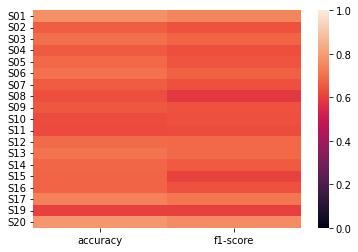

     class0 f1-score  class1 f1-score
S01         0.847737         0.531646
S02         0.769231         0.359551
S03         0.801498         0.376471
S04         0.767025         0.315789
S05         0.801527         0.257143
S06         0.811594         0.297297
S07         0.770370         0.326087
S08         0.760563         0.209302
S09         0.759124         0.352941
S10         0.715447         0.461538
S11         0.729614         0.376238
S12         0.777328         0.476190
S13         0.800000         0.430108
S14         0.786765         0.355556
S15         0.794521         0.189189
S16         0.785714         0.302326
S17         0.825397         0.450000
S19         0.711462         0.365217
S20         0.858182         0.541176


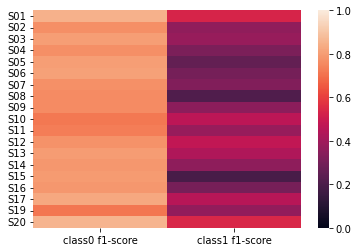

In [6]:
userfold_results_summary(participants_dictionary, participants)
userfold_classwise_results_summary(participants_dictionary, participants)


In [7]:
from sklearn.preprocessing import MinMaxScaler

participants_w_list=[]

for i in range(len(participants)):

    w= pickle.load(
        open(f"{saved_dir}/Userfold-{participants[i]}-EEGNet-NFS_TS-w-e{EPOCH}.pkl", "rb") 
                    )  
    participants_w_list.append(w)
    
avg_w= np.array(participants_w_list).mean(axis=0)
# scaler= MinMaxScaler()
# scaled_avg_w= scaler.fit_transform(avg_w)

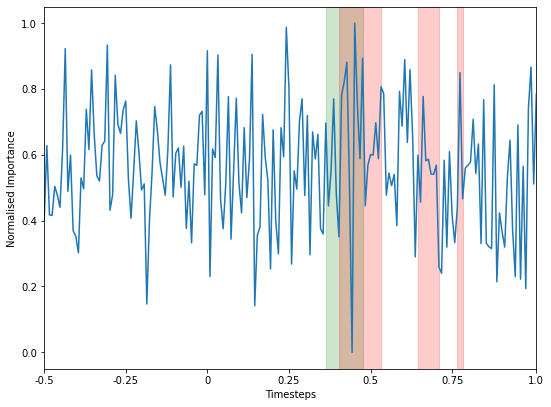

In [8]:
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler

plt.figure(figsize=(8,6))


scaler= MinMaxScaler()
scaled_avg_w= scaler.fit_transform(avg_w.reshape(-1,1))
df= pd.DataFrame(scaled_avg_w)
# df.index= channel_names
# df.columns=timestep_labels


plt.plot(df)
# plt.legend(methods)
plt.xlabel("Timesteps")
plt.axvspan(107,121, color="green", alpha=0.2)
plt.axvspan(112,128, color="red", alpha=0.2)
plt.axvspan(142,150, color="red", alpha=0.2)
plt.axvspan(157,159, color="red", alpha=0.2)
plt.xticks([0,31,62,93,124,155,187],[-0.5, -0.25, 0, 0.25, 0.5, 0.75, 1.0])
plt.ylabel("Normalised Importance")
plt.margins(x=0)
matplotlib.rcParams.update({"font.size":18})
plt.tight_layout()
#     sns.heatmap(df.sum().to_numpy().reshape(-1,1),annot=True, 
#                 yticklabels=timestep_labels, ax=ax[i][1],
#                 xticklabels=False, cbar_kws={"pad":0.02})